In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

from architectures.basic import BoundingBoxModel
from functions.datasets import get_loaders
from functions.loop_management import EarlyStopping
from functions.mapping import extract_bboxes
from functions.plotting import plot_losses

print(torch.__version__)
print(torch.cuda.is_available())

2.3.1
True


In [2]:
RUN_NUMBER = os.environ["RUN_NUMBER"]
dataset, train_loader, valid_loader = get_loaders(
    os.path.join("data", "train_images"),
    os.path.join("data", "train_coco_annotations.json")
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
cuda


In [3]:
model = BoundingBoxModel().to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [4]:
early_stopping = EarlyStopping(patience=7, verbose=True)
num_epochs = 25
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training")

    for images, targets in train_loader_tqdm:
        images = images.to(device)
        bboxes = extract_bboxes(targets)
        bboxes = torch.stack(bboxes).to(device)

        optimizer.zero_grad(set_to_none=True)

        outputs = model(images)
        loss = criterion(outputs, bboxes)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        train_loader_tqdm.set_postfix({"Train Loss": running_loss / len(train_loader)})

    epoch_train_loss = running_loss / len(train_loader)

    train_losses.append(epoch_train_loss)
    print(f"Epoch {epoch + 1}, Loss: {epoch_train_loss}")
    model.eval()

    val_loss = 0.0
    valid_loader_tqdm = tqdm(valid_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation")
    
    with torch.no_grad():
        for images, targets in valid_loader_tqdm:
            images = images.to(device)
            bboxes = extract_bboxes(targets)
            bboxes = torch.stack(bboxes).to(device)
            outputs = model(images)
            loss = criterion(outputs, bboxes)
            val_loss += loss.item()
            
            valid_loader_tqdm.set_postfix({"Val Loss": val_loss / len(valid_loader)})

    epoch_val_loss = val_loss / len(valid_loader)
    
    val_losses.append(epoch_val_loss)
    print(f"Validation Loss: {epoch_val_loss}")

    early_stopping(
        epoch_val_loss,
        model,
        path=os.path.join("checkpoints", f"checkpoint_1_bigger_basic_run_{RUN_NUMBER}.pt")
    )

    if early_stopping.early_stop:
        print("Early stopping")
        break

print("Training complete")

Epoch 1/25 - Training:   0%|                                                                   | 0/227 [00:00<?, ?it/s]

Epoch 1/25 - Training:   0%|                                                 | 0/227 [00:10<?, ?it/s, Train Loss=0.375]

Epoch 1/25 - Training:   0%|▏                                        | 1/227 [00:10<38:31, 10.23s/it, Train Loss=0.375]

Epoch 1/25 - Training:   0%|▏                                         | 1/227 [00:10<38:31, 10.23s/it, Train Loss=0.76]

Epoch 1/25 - Training:   1%|▎                                         | 2/227 [00:10<16:01,  4.27s/it, Train Loss=0.76]

Epoch 1/25 - Training:   1%|▎                                         | 2/227 [00:10<16:01,  4.27s/it, Train Loss=1.13]

Epoch 1/25 - Training:   1%|▍                                          | 2/227 [00:10<16:01,  4.27s/it, Train Loss=1.5]

Epoch 1/25 - Training:   1%|▎                                         | 2/227 [00:10<16:01,  4.27s/it, Train Loss=1.85]

Epoch 1/25 - Training:   1%|▎                                         | 2/227 [00:10<16:01,  4.27s/it, Train Loss=2.19]

Epoch 1/25 - Training:   3%|█                                         | 6/227 [00:10<03:41,  1.00s/it, Train Loss=2.19]

Epoch 1/25 - Training:   3%|█                                         | 6/227 [00:10<03:41,  1.00s/it, Train Loss=2.51]

Epoch 1/25 - Training:   3%|█                                         | 6/227 [00:10<03:41,  1.00s/it, Train Loss=2.79]

Epoch 1/25 - Training:   3%|█                                         | 6/227 [00:10<03:41,  1.00s/it, Train Loss=3.03]

Epoch 1/25 - Training:   3%|█                                         | 6/227 [00:10<03:41,  1.00s/it, Train Loss=3.22]

Epoch 1/25 - Training:   3%|█                                         | 6/227 [00:10<03:41,  1.00s/it, Train Loss=3.36]

Epoch 1/25 - Training:   3%|█                                         | 6/227 [00:10<03:41,  1.00s/it, Train Loss=3.55]

Epoch 1/25 - Training:   5%|██▏                                      | 12/227 [00:10<01:23,  2.57it/s, Train Loss=3.55]

Epoch 1/25 - Training:   5%|██▏                                       | 12/227 [00:10<01:23,  2.57it/s, Train Loss=3.7]

Epoch 1/25 - Training:   5%|██▏                                      | 12/227 [00:10<01:23,  2.57it/s, Train Loss=3.82]

Epoch 1/25 - Training:   5%|██▏                                       | 12/227 [00:10<01:23,  2.57it/s, Train Loss=3.9]

Epoch 1/25 - Training:   5%|██▎                                         | 12/227 [00:10<01:23,  2.57it/s, Train Loss=4]

Epoch 1/25 - Training:   5%|██▏                                      | 12/227 [00:10<01:23,  2.57it/s, Train Loss=4.09]

Epoch 1/25 - Training:   5%|██▏                                       | 12/227 [00:10<01:23,  2.57it/s, Train Loss=4.2]

Epoch 1/25 - Training:   8%|███▎                                      | 18/227 [00:10<00:45,  4.64it/s, Train Loss=4.2]

Epoch 1/25 - Training:   8%|███▎                                     | 18/227 [00:10<00:45,  4.64it/s, Train Loss=4.29]

Epoch 1/25 - Training:   8%|███▎                                     | 18/227 [00:10<00:45,  4.64it/s, Train Loss=4.39]

Epoch 1/25 - Training:   8%|███▎                                     | 18/227 [00:10<00:45,  4.64it/s, Train Loss=4.48]

Epoch 1/25 - Training:   8%|███▎                                     | 18/227 [00:10<00:45,  4.64it/s, Train Loss=4.58]

Epoch 1/25 - Training:   8%|███▎                                     | 18/227 [00:10<00:45,  4.64it/s, Train Loss=4.69]

Epoch 1/25 - Training:  10%|████▏                                    | 23/227 [00:10<00:29,  6.88it/s, Train Loss=4.69]

Epoch 1/25 - Training:  10%|████▏                                    | 23/227 [00:10<00:29,  6.88it/s, Train Loss=4.78]

Epoch 1/25 - Training:  10%|████▏                                    | 23/227 [00:10<00:29,  6.88it/s, Train Loss=4.89]

Epoch 1/25 - Training:  10%|████▏                                    | 23/227 [00:10<00:29,  6.88it/s, Train Loss=4.98]

Epoch 1/25 - Training:  10%|████▏                                    | 23/227 [00:10<00:29,  6.88it/s, Train Loss=5.06]

Epoch 1/25 - Training:  10%|████▏                                    | 23/227 [00:10<00:29,  6.88it/s, Train Loss=5.15]

Epoch 1/25 - Training:  12%|█████                                    | 28/227 [00:10<00:20,  9.65it/s, Train Loss=5.15]

Epoch 1/25 - Training:  12%|█████                                    | 28/227 [00:10<00:20,  9.65it/s, Train Loss=5.24]

Epoch 1/25 - Training:  12%|█████                                    | 28/227 [00:10<00:20,  9.65it/s, Train Loss=5.33]

Epoch 1/25 - Training:  12%|█████                                    | 28/227 [00:10<00:20,  9.65it/s, Train Loss=5.41]

Epoch 1/25 - Training:  12%|█████                                    | 28/227 [00:10<00:20,  9.65it/s, Train Loss=5.51]

Epoch 1/25 - Training:  12%|█████                                    | 28/227 [00:10<00:20,  9.65it/s, Train Loss=5.61]

Epoch 1/25 - Training:  12%|█████                                    | 28/227 [00:11<00:20,  9.65it/s, Train Loss=5.71]

Epoch 1/25 - Training:  15%|██████▏                                  | 34/227 [00:11<00:14, 13.68it/s, Train Loss=5.71]

Epoch 1/25 - Training:  15%|██████▏                                  | 34/227 [00:11<00:14, 13.68it/s, Train Loss=5.81]

Epoch 1/25 - Training:  15%|██████▏                                  | 34/227 [00:11<00:14, 13.68it/s, Train Loss=5.89]

Epoch 1/25 - Training:  15%|██████▏                                  | 34/227 [00:11<00:14, 13.68it/s, Train Loss=5.97]

Epoch 1/25 - Training:  15%|██████▏                                  | 34/227 [00:11<00:14, 13.68it/s, Train Loss=6.05]

Epoch 1/25 - Training:  15%|██████▏                                  | 34/227 [00:11<00:14, 13.68it/s, Train Loss=6.14]

Epoch 1/25 - Training:  17%|███████                                  | 39/227 [00:11<00:10, 17.50it/s, Train Loss=6.14]

Epoch 1/25 - Training:  17%|███████                                  | 39/227 [00:11<00:10, 17.50it/s, Train Loss=6.21]

Epoch 1/25 - Training:  17%|███████                                  | 39/227 [00:11<00:10, 17.50it/s, Train Loss=6.28]

Epoch 1/25 - Training:  17%|███████                                  | 39/227 [00:11<00:10, 17.50it/s, Train Loss=6.37]

Epoch 1/25 - Training:  17%|███████                                  | 39/227 [00:11<00:10, 17.50it/s, Train Loss=6.46]

Epoch 1/25 - Training:  17%|███████                                  | 39/227 [00:11<00:10, 17.50it/s, Train Loss=6.53]

Epoch 1/25 - Training:  19%|███████▉                                 | 44/227 [00:11<00:08, 21.42it/s, Train Loss=6.53]

Epoch 1/25 - Training:  19%|███████▉                                 | 44/227 [00:11<00:08, 21.42it/s, Train Loss=6.62]

Epoch 1/25 - Training:  19%|████████▏                                 | 44/227 [00:11<00:08, 21.42it/s, Train Loss=6.7]

Epoch 1/25 - Training:  19%|███████▉                                 | 44/227 [00:11<00:08, 21.42it/s, Train Loss=6.78]

Epoch 1/25 - Training:  19%|███████▉                                 | 44/227 [00:11<00:08, 21.42it/s, Train Loss=6.88]

Epoch 1/25 - Training:  19%|███████▉                                 | 44/227 [00:11<00:08, 21.42it/s, Train Loss=6.96]

Epoch 1/25 - Training:  22%|████████▊                                | 49/227 [00:11<00:06, 25.81it/s, Train Loss=6.96]

Epoch 1/25 - Training:  22%|████████▊                                | 49/227 [00:11<00:06, 25.81it/s, Train Loss=7.06]

Epoch 1/25 - Training:  22%|████████▊                                | 49/227 [00:11<00:06, 25.81it/s, Train Loss=7.14]

Epoch 1/25 - Training:  22%|████████▊                                | 49/227 [00:11<00:06, 25.81it/s, Train Loss=7.22]

Epoch 1/25 - Training:  22%|████████▊                                | 49/227 [00:11<00:06, 25.81it/s, Train Loss=7.31]

Epoch 1/25 - Training:  22%|████████▊                                | 49/227 [00:11<00:06, 25.81it/s, Train Loss=7.39]

Epoch 1/25 - Training:  24%|█████████▊                               | 54/227 [00:11<00:05, 29.95it/s, Train Loss=7.39]

Epoch 1/25 - Training:  24%|█████████▊                               | 54/227 [00:11<00:05, 29.95it/s, Train Loss=7.48]

Epoch 1/25 - Training:  24%|█████████▊                               | 54/227 [00:11<00:05, 29.95it/s, Train Loss=7.56]

Epoch 1/25 - Training:  24%|█████████▊                               | 54/227 [00:11<00:05, 29.95it/s, Train Loss=7.65]

Epoch 1/25 - Training:  24%|█████████▊                               | 54/227 [00:11<00:05, 29.95it/s, Train Loss=7.74]

Epoch 1/25 - Training:  24%|█████████▊                               | 54/227 [00:11<00:05, 29.95it/s, Train Loss=7.82]

Epoch 1/25 - Training:  26%|██████████▋                              | 59/227 [00:11<00:04, 33.65it/s, Train Loss=7.82]

Epoch 1/25 - Training:  26%|██████████▉                               | 59/227 [00:11<00:04, 33.65it/s, Train Loss=7.9]

Epoch 1/25 - Training:  26%|██████████▋                              | 59/227 [00:11<00:04, 33.65it/s, Train Loss=7.99]

Epoch 1/25 - Training:  26%|██████████▋                              | 59/227 [00:11<00:04, 33.65it/s, Train Loss=8.07]

Epoch 1/25 - Training:  26%|██████████▋                              | 59/227 [00:11<00:04, 33.65it/s, Train Loss=8.14]

Epoch 1/25 - Training:  26%|██████████▋                              | 59/227 [00:11<00:04, 33.65it/s, Train Loss=8.23]

Epoch 1/25 - Training:  28%|███████████▌                             | 64/227 [00:11<00:04, 36.66it/s, Train Loss=8.23]

Epoch 1/25 - Training:  28%|███████████▌                             | 64/227 [00:11<00:04, 36.66it/s, Train Loss=8.32]

Epoch 1/25 - Training:  28%|███████████▊                              | 64/227 [00:11<00:04, 36.66it/s, Train Loss=8.4]

Epoch 1/25 - Training:  28%|███████████▌                             | 64/227 [00:11<00:04, 36.66it/s, Train Loss=8.49]

Epoch 1/25 - Training:  28%|███████████▌                             | 64/227 [00:11<00:04, 36.66it/s, Train Loss=8.57]

Epoch 1/25 - Training:  28%|███████████▌                             | 64/227 [00:11<00:04, 36.66it/s, Train Loss=8.65]

Epoch 1/25 - Training:  30%|████████████▍                            | 69/227 [00:11<00:03, 39.76it/s, Train Loss=8.65]

Epoch 1/25 - Training:  30%|████████████▍                            | 69/227 [00:11<00:03, 39.76it/s, Train Loss=8.73]

Epoch 1/25 - Training:  30%|████████████▍                            | 69/227 [00:11<00:03, 39.76it/s, Train Loss=8.81]

Epoch 1/25 - Training:  30%|████████████▍                            | 69/227 [00:11<00:03, 39.76it/s, Train Loss=8.89]

Epoch 1/25 - Training:  30%|████████████▍                            | 69/227 [00:11<00:03, 39.76it/s, Train Loss=8.97]

Epoch 1/25 - Training:  30%|████████████▍                            | 69/227 [00:11<00:03, 39.76it/s, Train Loss=9.04]

Epoch 1/25 - Training:  33%|█████████████▎                           | 74/227 [00:11<00:03, 41.31it/s, Train Loss=9.04]

Epoch 1/25 - Training:  33%|█████████████▋                            | 74/227 [00:11<00:03, 41.31it/s, Train Loss=9.1]

Epoch 1/25 - Training:  33%|█████████████▎                           | 74/227 [00:11<00:03, 41.31it/s, Train Loss=9.19]

Epoch 1/25 - Training:  33%|█████████████▎                           | 74/227 [00:11<00:03, 41.31it/s, Train Loss=9.28]

Epoch 1/25 - Training:  33%|█████████████▎                           | 74/227 [00:11<00:03, 41.31it/s, Train Loss=9.38]

Epoch 1/25 - Training:  33%|█████████████▎                           | 74/227 [00:11<00:03, 41.31it/s, Train Loss=9.47]

Epoch 1/25 - Training:  35%|██████████████▎                          | 79/227 [00:11<00:03, 43.47it/s, Train Loss=9.47]

Epoch 1/25 - Training:  35%|██████████████▎                          | 79/227 [00:11<00:03, 43.47it/s, Train Loss=9.55]

Epoch 1/25 - Training:  35%|██████████████▎                          | 79/227 [00:12<00:03, 43.47it/s, Train Loss=9.62]

Epoch 1/25 - Training:  35%|██████████████▌                           | 79/227 [00:12<00:03, 43.47it/s, Train Loss=9.7]

Epoch 1/25 - Training:  35%|██████████████▎                          | 79/227 [00:12<00:03, 43.47it/s, Train Loss=9.79]

Epoch 1/25 - Training:  35%|██████████████▎                          | 79/227 [00:12<00:03, 43.47it/s, Train Loss=9.86]

Epoch 1/25 - Training:  37%|███████████████▏                         | 84/227 [00:12<00:03, 43.13it/s, Train Loss=9.86]

Epoch 1/25 - Training:  37%|███████████████▏                         | 84/227 [00:12<00:03, 43.13it/s, Train Loss=9.95]

Epoch 1/25 - Training:  37%|███████████████▉                           | 84/227 [00:12<00:03, 43.13it/s, Train Loss=10]

Epoch 1/25 - Training:  37%|███████████████▏                         | 84/227 [00:12<00:03, 43.13it/s, Train Loss=10.1]

Epoch 1/25 - Training:  37%|███████████████▏                         | 84/227 [00:12<00:03, 43.13it/s, Train Loss=10.2]

Epoch 1/25 - Training:  37%|███████████████▏                         | 84/227 [00:12<00:03, 43.13it/s, Train Loss=10.3]

Epoch 1/25 - Training:  37%|███████████████▏                         | 84/227 [00:12<00:03, 43.13it/s, Train Loss=10.3]

Epoch 1/25 - Training:  40%|████████████████▎                        | 90/227 [00:12<00:03, 44.01it/s, Train Loss=10.3]

Epoch 1/25 - Training:  40%|████████████████▎                        | 90/227 [00:12<00:03, 44.01it/s, Train Loss=10.4]

Epoch 1/25 - Training:  40%|████████████████▎                        | 90/227 [00:12<00:03, 44.01it/s, Train Loss=10.5]

Epoch 1/25 - Training:  40%|████████████████▎                        | 90/227 [00:12<00:03, 44.01it/s, Train Loss=10.6]

Epoch 1/25 - Training:  40%|████████████████▎                        | 90/227 [00:12<00:03, 44.01it/s, Train Loss=10.6]

Epoch 1/25 - Training:  40%|████████████████▎                        | 90/227 [00:12<00:03, 44.01it/s, Train Loss=10.7]

Epoch 1/25 - Training:  40%|████████████████▎                        | 90/227 [00:12<00:03, 44.01it/s, Train Loss=10.8]

Epoch 1/25 - Training:  42%|█████████████████▎                       | 96/227 [00:12<00:02, 45.13it/s, Train Loss=10.8]

Epoch 1/25 - Training:  42%|█████████████████▎                       | 96/227 [00:12<00:02, 45.13it/s, Train Loss=10.9]

Epoch 1/25 - Training:  42%|█████████████████▎                       | 96/227 [00:12<00:02, 45.13it/s, Train Loss=10.9]

Epoch 1/25 - Training:  42%|██████████████████▏                        | 96/227 [00:12<00:02, 45.13it/s, Train Loss=11]

Epoch 1/25 - Training:  42%|█████████████████▎                       | 96/227 [00:12<00:02, 45.13it/s, Train Loss=11.1]

Epoch 1/25 - Training:  42%|█████████████████▎                       | 96/227 [00:12<00:02, 45.13it/s, Train Loss=11.2]

Epoch 1/25 - Training:  44%|█████████████████▊                      | 101/227 [00:12<00:02, 46.15it/s, Train Loss=11.2]

Epoch 1/25 - Training:  44%|█████████████████▊                      | 101/227 [00:12<00:02, 46.15it/s, Train Loss=11.3]

Epoch 1/25 - Training:  44%|█████████████████▊                      | 101/227 [00:12<00:02, 46.15it/s, Train Loss=11.4]

Epoch 1/25 - Training:  44%|█████████████████▊                      | 101/227 [00:12<00:02, 46.15it/s, Train Loss=11.4]

Epoch 1/25 - Training:  44%|█████████████████▊                      | 101/227 [00:12<00:02, 46.15it/s, Train Loss=11.5]

Epoch 1/25 - Training:  44%|█████████████████▊                      | 101/227 [00:12<00:02, 46.15it/s, Train Loss=11.6]

Epoch 1/25 - Training:  47%|██████████████████▋                     | 106/227 [00:12<00:02, 44.66it/s, Train Loss=11.6]

Epoch 1/25 - Training:  47%|██████████████████▋                     | 106/227 [00:12<00:02, 44.66it/s, Train Loss=11.7]

Epoch 1/25 - Training:  47%|██████████████████▋                     | 106/227 [00:12<00:02, 44.66it/s, Train Loss=11.8]

Epoch 1/25 - Training:  47%|██████████████████▋                     | 106/227 [00:12<00:02, 44.66it/s, Train Loss=11.8]

Epoch 1/25 - Training:  47%|██████████████████▋                     | 106/227 [00:12<00:02, 44.66it/s, Train Loss=11.9]

Epoch 1/25 - Training:  47%|███████████████████▌                      | 106/227 [00:12<00:02, 44.66it/s, Train Loss=12]

Epoch 1/25 - Training:  49%|████████████████████▌                     | 111/227 [00:12<00:02, 45.84it/s, Train Loss=12]

Epoch 1/25 - Training:  49%|███████████████████▌                    | 111/227 [00:12<00:02, 45.84it/s, Train Loss=12.1]

Epoch 1/25 - Training:  49%|███████████████████▌                    | 111/227 [00:12<00:02, 45.84it/s, Train Loss=12.2]

Epoch 1/25 - Training:  49%|███████████████████▌                    | 111/227 [00:12<00:02, 45.84it/s, Train Loss=12.2]

Epoch 1/25 - Training:  49%|███████████████████▌                    | 111/227 [00:12<00:02, 45.84it/s, Train Loss=12.3]

Epoch 1/25 - Training:  49%|███████████████████▌                    | 111/227 [00:12<00:02, 45.84it/s, Train Loss=12.4]

Epoch 1/25 - Training:  51%|████████████████████▍                   | 116/227 [00:12<00:02, 45.48it/s, Train Loss=12.4]

Epoch 1/25 - Training:  51%|████████████████████▍                   | 116/227 [00:12<00:02, 45.48it/s, Train Loss=12.5]

Epoch 1/25 - Training:  51%|████████████████████▍                   | 116/227 [00:12<00:02, 45.48it/s, Train Loss=12.5]

Epoch 1/25 - Training:  51%|████████████████████▍                   | 116/227 [00:12<00:02, 45.48it/s, Train Loss=12.6]

Epoch 1/25 - Training:  51%|████████████████████▍                   | 116/227 [00:12<00:02, 45.48it/s, Train Loss=12.7]

Epoch 1/25 - Training:  51%|████████████████████▍                   | 116/227 [00:12<00:02, 45.48it/s, Train Loss=12.8]

Epoch 1/25 - Training:  53%|█████████████████████▎                  | 121/227 [00:12<00:02, 46.47it/s, Train Loss=12.8]

Epoch 1/25 - Training:  53%|█████████████████████▎                  | 121/227 [00:12<00:02, 46.47it/s, Train Loss=12.9]

Epoch 1/25 - Training:  53%|█████████████████████▎                  | 121/227 [00:12<00:02, 46.47it/s, Train Loss=12.9]

Epoch 1/25 - Training:  53%|██████████████████████▍                   | 121/227 [00:12<00:02, 46.47it/s, Train Loss=13]

Epoch 1/25 - Training:  53%|█████████████████████▎                  | 121/227 [00:12<00:02, 46.47it/s, Train Loss=13.1]

Epoch 1/25 - Training:  53%|█████████████████████▎                  | 121/227 [00:12<00:02, 46.47it/s, Train Loss=13.2]

Epoch 1/25 - Training:  56%|██████████████████████▏                 | 126/227 [00:12<00:02, 45.79it/s, Train Loss=13.2]

Epoch 1/25 - Training:  56%|██████████████████████▏                 | 126/227 [00:12<00:02, 45.79it/s, Train Loss=13.3]

Epoch 1/25 - Training:  56%|██████████████████████▏                 | 126/227 [00:13<00:02, 45.79it/s, Train Loss=13.3]

Epoch 1/25 - Training:  56%|██████████████████████▏                 | 126/227 [00:13<00:02, 45.79it/s, Train Loss=13.4]

Epoch 1/25 - Training:  56%|██████████████████████▏                 | 126/227 [00:13<00:02, 45.79it/s, Train Loss=13.5]

Epoch 1/25 - Training:  56%|██████████████████████▏                 | 126/227 [00:13<00:02, 45.79it/s, Train Loss=13.6]

Epoch 1/25 - Training:  58%|███████████████████████                 | 131/227 [00:13<00:02, 46.71it/s, Train Loss=13.6]

Epoch 1/25 - Training:  58%|███████████████████████                 | 131/227 [00:13<00:02, 46.71it/s, Train Loss=13.7]

Epoch 1/25 - Training:  58%|███████████████████████                 | 131/227 [00:13<00:02, 46.71it/s, Train Loss=13.8]

Epoch 1/25 - Training:  58%|███████████████████████                 | 131/227 [00:13<00:02, 46.71it/s, Train Loss=13.9]

Epoch 1/25 - Training:  58%|███████████████████████                 | 131/227 [00:13<00:02, 46.71it/s, Train Loss=13.9]

Epoch 1/25 - Training:  58%|████████████████████████▏                 | 131/227 [00:13<00:02, 46.71it/s, Train Loss=14]

Epoch 1/25 - Training:  60%|█████████████████████████▏                | 136/227 [00:13<00:01, 47.37it/s, Train Loss=14]

Epoch 1/25 - Training:  60%|███████████████████████▉                | 136/227 [00:13<00:01, 47.37it/s, Train Loss=14.1]

Epoch 1/25 - Training:  60%|███████████████████████▉                | 136/227 [00:13<00:01, 47.37it/s, Train Loss=14.2]

Epoch 1/25 - Training:  60%|███████████████████████▉                | 136/227 [00:13<00:01, 47.37it/s, Train Loss=14.2]

Epoch 1/25 - Training:  60%|███████████████████████▉                | 136/227 [00:13<00:01, 47.37it/s, Train Loss=14.3]

Epoch 1/25 - Training:  60%|███████████████████████▉                | 136/227 [00:13<00:01, 47.37it/s, Train Loss=14.4]

Epoch 1/25 - Training:  62%|████████████████████████▊               | 141/227 [00:13<00:01, 46.91it/s, Train Loss=14.4]

Epoch 1/25 - Training:  62%|████████████████████████▊               | 141/227 [00:13<00:01, 46.91it/s, Train Loss=14.5]

Epoch 1/25 - Training:  62%|████████████████████████▊               | 141/227 [00:13<00:01, 46.91it/s, Train Loss=14.6]

Epoch 1/25 - Training:  62%|████████████████████████▊               | 141/227 [00:13<00:01, 46.91it/s, Train Loss=14.7]

Epoch 1/25 - Training:  62%|████████████████████████▊               | 141/227 [00:13<00:01, 46.91it/s, Train Loss=14.8]

Epoch 1/25 - Training:  62%|████████████████████████▊               | 141/227 [00:13<00:01, 46.91it/s, Train Loss=14.9]

Epoch 1/25 - Training:  64%|█████████████████████████▋              | 146/227 [00:13<00:01, 45.83it/s, Train Loss=14.9]

Epoch 1/25 - Training:  64%|█████████████████████████▋              | 146/227 [00:13<00:01, 45.83it/s, Train Loss=14.9]

Epoch 1/25 - Training:  64%|███████████████████████████               | 146/227 [00:13<00:01, 45.83it/s, Train Loss=15]

Epoch 1/25 - Training:  64%|█████████████████████████▋              | 146/227 [00:13<00:01, 45.83it/s, Train Loss=15.1]

Epoch 1/25 - Training:  64%|█████████████████████████▋              | 146/227 [00:13<00:01, 45.83it/s, Train Loss=15.2]

Epoch 1/25 - Training:  64%|█████████████████████████▋              | 146/227 [00:13<00:01, 45.83it/s, Train Loss=15.3]

Epoch 1/25 - Training:  67%|██████████████████████████▌             | 151/227 [00:13<00:01, 46.61it/s, Train Loss=15.3]

Epoch 1/25 - Training:  67%|██████████████████████████▌             | 151/227 [00:13<00:01, 46.61it/s, Train Loss=15.4]

Epoch 1/25 - Training:  67%|██████████████████████████▌             | 151/227 [00:13<00:01, 46.61it/s, Train Loss=15.4]

Epoch 1/25 - Training:  67%|██████████████████████████▌             | 151/227 [00:13<00:01, 46.61it/s, Train Loss=15.5]

Epoch 1/25 - Training:  67%|██████████████████████████▌             | 151/227 [00:13<00:01, 46.61it/s, Train Loss=15.6]

Epoch 1/25 - Training:  67%|██████████████████████████▌             | 151/227 [00:13<00:01, 46.61it/s, Train Loss=15.7]

Epoch 1/25 - Training:  69%|███████████████████████████▍            | 156/227 [00:13<00:01, 45.63it/s, Train Loss=15.7]

Epoch 1/25 - Training:  69%|███████████████████████████▍            | 156/227 [00:13<00:01, 45.63it/s, Train Loss=15.8]

Epoch 1/25 - Training:  69%|███████████████████████████▍            | 156/227 [00:13<00:01, 45.63it/s, Train Loss=15.8]

Epoch 1/25 - Training:  69%|███████████████████████████▍            | 156/227 [00:13<00:01, 45.63it/s, Train Loss=15.9]

Epoch 1/25 - Training:  69%|████████████████████████████▊             | 156/227 [00:13<00:01, 45.63it/s, Train Loss=16]

Epoch 1/25 - Training:  69%|███████████████████████████▍            | 156/227 [00:13<00:01, 45.63it/s, Train Loss=16.1]

Epoch 1/25 - Training:  69%|███████████████████████████▍            | 156/227 [00:13<00:01, 45.63it/s, Train Loss=16.1]

Epoch 1/25 - Training:  71%|████████████████████████████▌           | 162/227 [00:13<00:01, 46.40it/s, Train Loss=16.1]

Epoch 1/25 - Training:  71%|████████████████████████████▌           | 162/227 [00:13<00:01, 46.40it/s, Train Loss=16.2]

Epoch 1/25 - Training:  71%|████████████████████████████▌           | 162/227 [00:13<00:01, 46.40it/s, Train Loss=16.3]

Epoch 1/25 - Training:  71%|████████████████████████████▌           | 162/227 [00:13<00:01, 46.40it/s, Train Loss=16.4]

Epoch 1/25 - Training:  71%|████████████████████████████▌           | 162/227 [00:13<00:01, 46.40it/s, Train Loss=16.4]

Epoch 1/25 - Training:  71%|████████████████████████████▌           | 162/227 [00:13<00:01, 46.40it/s, Train Loss=16.5]

Epoch 1/25 - Training:  74%|█████████████████████████████▍          | 167/227 [00:13<00:01, 47.13it/s, Train Loss=16.5]

Epoch 1/25 - Training:  74%|█████████████████████████████▍          | 167/227 [00:13<00:01, 47.13it/s, Train Loss=16.6]

Epoch 1/25 - Training:  74%|█████████████████████████████▍          | 167/227 [00:13<00:01, 47.13it/s, Train Loss=16.7]

Epoch 1/25 - Training:  74%|█████████████████████████████▍          | 167/227 [00:13<00:01, 47.13it/s, Train Loss=16.7]

Epoch 1/25 - Training:  74%|█████████████████████████████▍          | 167/227 [00:13<00:01, 47.13it/s, Train Loss=16.8]

Epoch 1/25 - Training:  74%|█████████████████████████████▍          | 167/227 [00:13<00:01, 47.13it/s, Train Loss=16.9]

Epoch 1/25 - Training:  76%|██████████████████████████████▎         | 172/227 [00:13<00:01, 46.63it/s, Train Loss=16.9]

Epoch 1/25 - Training:  76%|███████████████████████████████▊          | 172/227 [00:13<00:01, 46.63it/s, Train Loss=17]

Epoch 1/25 - Training:  76%|███████████████████████████████▊          | 172/227 [00:14<00:01, 46.63it/s, Train Loss=17]

Epoch 1/25 - Training:  76%|██████████████████████████████▎         | 172/227 [00:14<00:01, 46.63it/s, Train Loss=17.1]

Epoch 1/25 - Training:  76%|██████████████████████████████▎         | 172/227 [00:14<00:01, 46.63it/s, Train Loss=17.2]

Epoch 1/25 - Training:  76%|██████████████████████████████▎         | 172/227 [00:14<00:01, 46.63it/s, Train Loss=17.3]

Epoch 1/25 - Training:  78%|███████████████████████████████▏        | 177/227 [00:14<00:01, 47.57it/s, Train Loss=17.3]

Epoch 1/25 - Training:  78%|███████████████████████████████▏        | 177/227 [00:14<00:01, 47.57it/s, Train Loss=17.3]

Epoch 1/25 - Training:  78%|███████████████████████████████▏        | 177/227 [00:14<00:01, 47.57it/s, Train Loss=17.4]

Epoch 1/25 - Training:  78%|███████████████████████████████▏        | 177/227 [00:14<00:01, 47.57it/s, Train Loss=17.5]

Epoch 1/25 - Training:  78%|███████████████████████████████▏        | 177/227 [00:14<00:01, 47.57it/s, Train Loss=17.6]

Epoch 1/25 - Training:  78%|███████████████████████████████▏        | 177/227 [00:14<00:01, 47.57it/s, Train Loss=17.7]

Epoch 1/25 - Training:  80%|████████████████████████████████        | 182/227 [00:14<00:00, 46.41it/s, Train Loss=17.7]

Epoch 1/25 - Training:  80%|████████████████████████████████        | 182/227 [00:14<00:00, 46.41it/s, Train Loss=17.7]

Epoch 1/25 - Training:  80%|████████████████████████████████        | 182/227 [00:14<00:00, 46.41it/s, Train Loss=17.8]

Epoch 1/25 - Training:  80%|████████████████████████████████        | 182/227 [00:14<00:00, 46.41it/s, Train Loss=17.9]

Epoch 1/25 - Training:  80%|█████████████████████████████████▋        | 182/227 [00:14<00:00, 46.41it/s, Train Loss=18]

Epoch 1/25 - Training:  80%|█████████████████████████████████▋        | 182/227 [00:14<00:00, 46.41it/s, Train Loss=18]

Epoch 1/25 - Training:  80%|████████████████████████████████        | 182/227 [00:14<00:00, 46.41it/s, Train Loss=18.1]

Epoch 1/25 - Training:  83%|█████████████████████████████████▏      | 188/227 [00:14<00:00, 46.69it/s, Train Loss=18.1]

Epoch 1/25 - Training:  83%|█████████████████████████████████▏      | 188/227 [00:14<00:00, 46.69it/s, Train Loss=18.2]

Epoch 1/25 - Training:  83%|█████████████████████████████████▏      | 188/227 [00:14<00:00, 46.69it/s, Train Loss=18.3]

Epoch 1/25 - Training:  83%|█████████████████████████████████▏      | 188/227 [00:14<00:00, 46.69it/s, Train Loss=18.4]

Epoch 1/25 - Training:  83%|█████████████████████████████████▏      | 188/227 [00:14<00:00, 46.69it/s, Train Loss=18.4]

Epoch 1/25 - Training:  83%|█████████████████████████████████▏      | 188/227 [00:14<00:00, 46.69it/s, Train Loss=18.5]

Epoch 1/25 - Training:  85%|██████████████████████████████████      | 193/227 [00:14<00:00, 47.20it/s, Train Loss=18.5]

Epoch 1/25 - Training:  85%|██████████████████████████████████      | 193/227 [00:14<00:00, 47.20it/s, Train Loss=18.6]

Epoch 1/25 - Training:  85%|██████████████████████████████████      | 193/227 [00:14<00:00, 47.20it/s, Train Loss=18.7]

Epoch 1/25 - Training:  85%|██████████████████████████████████      | 193/227 [00:14<00:00, 47.20it/s, Train Loss=18.7]

Epoch 1/25 - Training:  85%|██████████████████████████████████      | 193/227 [00:14<00:00, 47.20it/s, Train Loss=18.8]

Epoch 1/25 - Training:  85%|██████████████████████████████████      | 193/227 [00:14<00:00, 47.20it/s, Train Loss=18.9]

Epoch 1/25 - Training:  87%|██████████████████████████████████▉     | 198/227 [00:14<00:00, 46.56it/s, Train Loss=18.9]

Epoch 1/25 - Training:  87%|████████████████████████████████████▋     | 198/227 [00:14<00:00, 46.56it/s, Train Loss=19]

Epoch 1/25 - Training:  87%|████████████████████████████████████▋     | 198/227 [00:14<00:00, 46.56it/s, Train Loss=19]

Epoch 1/25 - Training:  87%|██████████████████████████████████▉     | 198/227 [00:14<00:00, 46.56it/s, Train Loss=19.1]

Epoch 1/25 - Training:  87%|██████████████████████████████████▉     | 198/227 [00:14<00:00, 46.56it/s, Train Loss=19.2]

Epoch 1/25 - Training:  87%|██████████████████████████████████▉     | 198/227 [00:14<00:00, 46.56it/s, Train Loss=19.3]

Epoch 1/25 - Training:  89%|███████████████████████████████████▊    | 203/227 [00:14<00:00, 47.25it/s, Train Loss=19.3]

Epoch 1/25 - Training:  89%|███████████████████████████████████▊    | 203/227 [00:14<00:00, 47.25it/s, Train Loss=19.3]

Epoch 1/25 - Training:  89%|███████████████████████████████████▊    | 203/227 [00:14<00:00, 47.25it/s, Train Loss=19.4]

Epoch 1/25 - Training:  89%|███████████████████████████████████▊    | 203/227 [00:14<00:00, 47.25it/s, Train Loss=19.5]

Epoch 1/25 - Training:  89%|███████████████████████████████████▊    | 203/227 [00:14<00:00, 47.25it/s, Train Loss=19.6]

Epoch 1/25 - Training:  89%|███████████████████████████████████▊    | 203/227 [00:14<00:00, 47.25it/s, Train Loss=19.6]

Epoch 1/25 - Training:  92%|████████████████████████████████████▋   | 208/227 [00:14<00:00, 45.94it/s, Train Loss=19.6]

Epoch 1/25 - Training:  92%|████████████████████████████████████▋   | 208/227 [00:14<00:00, 45.94it/s, Train Loss=19.7]

Epoch 1/25 - Training:  92%|████████████████████████████████████▋   | 208/227 [00:14<00:00, 45.94it/s, Train Loss=19.8]

Epoch 1/25 - Training:  92%|████████████████████████████████████▋   | 208/227 [00:14<00:00, 45.94it/s, Train Loss=19.9]

Epoch 1/25 - Training:  92%|██████████████████████████████████████▍   | 208/227 [00:14<00:00, 45.94it/s, Train Loss=20]

Epoch 1/25 - Training:  92%|██████████████████████████████████████▍   | 208/227 [00:14<00:00, 45.94it/s, Train Loss=20]

Epoch 1/25 - Training:  92%|████████████████████████████████████▋   | 208/227 [00:14<00:00, 45.94it/s, Train Loss=20.1]

Epoch 1/25 - Training:  94%|█████████████████████████████████████▋  | 214/227 [00:14<00:00, 45.66it/s, Train Loss=20.1]

Epoch 1/25 - Training:  94%|█████████████████████████████████████▋  | 214/227 [00:14<00:00, 45.66it/s, Train Loss=20.2]

Epoch 1/25 - Training:  94%|█████████████████████████████████████▋  | 214/227 [00:14<00:00, 45.66it/s, Train Loss=20.3]

Epoch 1/25 - Training:  94%|█████████████████████████████████████▋  | 214/227 [00:14<00:00, 45.66it/s, Train Loss=20.3]

Epoch 1/25 - Training:  94%|█████████████████████████████████████▋  | 214/227 [00:14<00:00, 45.66it/s, Train Loss=20.4]

Epoch 1/25 - Training:  94%|█████████████████████████████████████▋  | 214/227 [00:14<00:00, 45.66it/s, Train Loss=20.5]

Epoch 1/25 - Training:  96%|██████████████████████████████████████▌ | 219/227 [00:14<00:00, 46.21it/s, Train Loss=20.5]

Epoch 1/25 - Training:  96%|██████████████████████████████████████▌ | 219/227 [00:15<00:00, 46.21it/s, Train Loss=20.6]

Epoch 1/25 - Training:  96%|██████████████████████████████████████▌ | 219/227 [00:15<00:00, 46.21it/s, Train Loss=20.6]

Epoch 1/25 - Training:  96%|██████████████████████████████████████▌ | 219/227 [00:15<00:00, 46.21it/s, Train Loss=20.7]

Epoch 1/25 - Training:  96%|██████████████████████████████████████▌ | 219/227 [00:15<00:00, 46.21it/s, Train Loss=20.8]

Epoch 1/25 - Training:  96%|██████████████████████████████████████▌ | 219/227 [00:15<00:00, 46.21it/s, Train Loss=20.9]

Epoch 1/25 - Training:  99%|███████████████████████████████████████▍| 224/227 [00:15<00:00, 45.32it/s, Train Loss=20.9]

Epoch 1/25 - Training:  99%|█████████████████████████████████████████▍| 224/227 [00:15<00:00, 45.32it/s, Train Loss=21]

Epoch 1/25 - Training:  99%|█████████████████████████████████████████▍| 224/227 [00:15<00:00, 45.32it/s, Train Loss=21]

Epoch 1/25 - Training:  99%|███████████████████████████████████████▍| 224/227 [00:15<00:00, 45.32it/s, Train Loss=21.1]

Epoch 1/25 - Training: 100%|████████████████████████████████████████| 227/227 [00:15<00:00, 14.60it/s, Train Loss=21.1]

Epoch 1, Loss: 21.085557269629927


Epoch 1/25 - Validation:   0%|                                                                 | 0/227 [00:00<?, ?it/s]

Epoch 1/25 - Validation:   0%|                                                | 0/227 [00:06<?, ?it/s, Val Loss=0.0747]

Epoch 1/25 - Validation:   0%|▏                                       | 1/227 [00:06<25:37,  6.80s/it, Val Loss=0.0747]

Epoch 1/25 - Validation:   0%|▏                                        | 1/227 [00:06<25:37,  6.80s/it, Val Loss=0.141]

Epoch 1/25 - Validation:   1%|▎                                        | 2/227 [00:06<10:45,  2.87s/it, Val Loss=0.141]

Epoch 1/25 - Validation:   1%|▎                                        | 2/227 [00:07<10:45,  2.87s/it, Val Loss=0.213]

Epoch 1/25 - Validation:   1%|▌                                        | 3/227 [00:07<05:59,  1.60s/it, Val Loss=0.213]

Epoch 1/25 - Validation:   1%|▌                                        | 3/227 [00:07<05:59,  1.60s/it, Val Loss=0.287]

Epoch 1/25 - Validation:   1%|▌                                         | 3/227 [00:07<05:59,  1.60s/it, Val Loss=0.37]

Epoch 1/25 - Validation:   1%|▌                                        | 3/227 [00:07<05:59,  1.60s/it, Val Loss=0.449]

Epoch 1/25 - Validation:   1%|▌                                        | 3/227 [00:07<05:59,  1.60s/it, Val Loss=0.517]

Epoch 1/25 - Validation:   1%|▌                                        | 3/227 [00:07<05:59,  1.60s/it, Val Loss=0.584]

Epoch 1/25 - Validation:   1%|▌                                        | 3/227 [00:07<05:59,  1.60s/it, Val Loss=0.657]

Epoch 1/25 - Validation:   1%|▌                                        | 3/227 [00:07<05:59,  1.60s/it, Val Loss=0.719]

Epoch 1/25 - Validation:   4%|█▊                                      | 10/227 [00:07<01:05,  3.33it/s, Val Loss=0.719]

Epoch 1/25 - Validation:   4%|█▊                                      | 10/227 [00:07<01:05,  3.33it/s, Val Loss=0.782]

Epoch 1/25 - Validation:   4%|█▊                                       | 10/227 [00:07<01:05,  3.33it/s, Val Loss=0.86]

Epoch 1/25 - Validation:   4%|█▊                                      | 10/227 [00:07<01:05,  3.33it/s, Val Loss=0.929]

Epoch 1/25 - Validation:   4%|█▉                                          | 10/227 [00:07<01:05,  3.33it/s, Val Loss=1]

Epoch 1/25 - Validation:   4%|█▊                                       | 10/227 [00:07<01:05,  3.33it/s, Val Loss=1.08]

Epoch 1/25 - Validation:   4%|█▊                                       | 10/227 [00:07<01:05,  3.33it/s, Val Loss=1.15]

Epoch 1/25 - Validation:   7%|██▉                                      | 16/227 [00:07<00:33,  6.24it/s, Val Loss=1.15]

Epoch 1/25 - Validation:   7%|██▉                                      | 16/227 [00:07<00:33,  6.24it/s, Val Loss=1.21]

Epoch 1/25 - Validation:   7%|██▉                                      | 16/227 [00:07<00:33,  6.24it/s, Val Loss=1.28]

Epoch 1/25 - Validation:   7%|██▉                                      | 16/227 [00:07<00:33,  6.24it/s, Val Loss=1.36]

Epoch 1/25 - Validation:   7%|██▉                                      | 16/227 [00:07<00:33,  6.24it/s, Val Loss=1.44]

Epoch 1/25 - Validation:   7%|██▉                                      | 16/227 [00:07<00:33,  6.24it/s, Val Loss=1.51]

Epoch 1/25 - Validation:   7%|██▉                                      | 16/227 [00:07<00:33,  6.24it/s, Val Loss=1.57]

Epoch 1/25 - Validation:  10%|███▉                                     | 22/227 [00:07<00:20,  9.82it/s, Val Loss=1.57]

Epoch 1/25 - Validation:  10%|███▉                                     | 22/227 [00:07<00:20,  9.82it/s, Val Loss=1.66]

Epoch 1/25 - Validation:  10%|███▉                                     | 22/227 [00:07<00:20,  9.82it/s, Val Loss=1.73]

Epoch 1/25 - Validation:  10%|███▉                                     | 22/227 [00:07<00:20,  9.82it/s, Val Loss=1.79]

Epoch 1/25 - Validation:  10%|███▉                                     | 22/227 [00:07<00:20,  9.82it/s, Val Loss=1.88]

Epoch 1/25 - Validation:  10%|███▉                                     | 22/227 [00:07<00:20,  9.82it/s, Val Loss=1.95]

Epoch 1/25 - Validation:  12%|████▉                                    | 27/227 [00:07<00:14, 13.37it/s, Val Loss=1.95]

Epoch 1/25 - Validation:  12%|████▉                                    | 27/227 [00:07<00:14, 13.37it/s, Val Loss=2.02]

Epoch 1/25 - Validation:  12%|████▉                                    | 27/227 [00:07<00:14, 13.37it/s, Val Loss=2.09]

Epoch 1/25 - Validation:  12%|████▉                                    | 27/227 [00:07<00:14, 13.37it/s, Val Loss=2.16]

Epoch 1/25 - Validation:  12%|████▉                                    | 27/227 [00:07<00:14, 13.37it/s, Val Loss=2.22]

Epoch 1/25 - Validation:  12%|████▉                                    | 27/227 [00:07<00:14, 13.37it/s, Val Loss=2.29]

Epoch 1/25 - Validation:  14%|█████▊                                   | 32/227 [00:07<00:11, 17.47it/s, Val Loss=2.29]

Epoch 1/25 - Validation:  14%|█████▊                                   | 32/227 [00:07<00:11, 17.47it/s, Val Loss=2.37]

Epoch 1/25 - Validation:  14%|█████▊                                   | 32/227 [00:07<00:11, 17.47it/s, Val Loss=2.45]

Epoch 1/25 - Validation:  14%|█████▊                                   | 32/227 [00:07<00:11, 17.47it/s, Val Loss=2.53]

Epoch 1/25 - Validation:  14%|█████▉                                    | 32/227 [00:07<00:11, 17.47it/s, Val Loss=2.6]

Epoch 1/25 - Validation:  14%|█████▊                                   | 32/227 [00:07<00:11, 17.47it/s, Val Loss=2.66]

Epoch 1/25 - Validation:  16%|██████▋                                  | 37/227 [00:07<00:08, 21.52it/s, Val Loss=2.66]

Epoch 1/25 - Validation:  16%|██████▋                                  | 37/227 [00:07<00:08, 21.52it/s, Val Loss=2.73]

Epoch 1/25 - Validation:  16%|██████▋                                  | 37/227 [00:07<00:08, 21.52it/s, Val Loss=2.81]

Epoch 1/25 - Validation:  16%|██████▋                                  | 37/227 [00:07<00:08, 21.52it/s, Val Loss=2.88]

Epoch 1/25 - Validation:  16%|██████▋                                  | 37/227 [00:07<00:08, 21.52it/s, Val Loss=2.96]

Epoch 1/25 - Validation:  16%|██████▋                                  | 37/227 [00:07<00:08, 21.52it/s, Val Loss=3.03]

Epoch 1/25 - Validation:  16%|██████▋                                  | 37/227 [00:07<00:08, 21.52it/s, Val Loss=3.09]

Epoch 1/25 - Validation:  19%|███████▊                                 | 43/227 [00:07<00:06, 26.81it/s, Val Loss=3.09]

Epoch 1/25 - Validation:  19%|███████▊                                 | 43/227 [00:07<00:06, 26.81it/s, Val Loss=3.17]

Epoch 1/25 - Validation:  19%|███████▊                                 | 43/227 [00:07<00:06, 26.81it/s, Val Loss=3.26]

Epoch 1/25 - Validation:  19%|███████▊                                 | 43/227 [00:07<00:06, 26.81it/s, Val Loss=3.32]

Epoch 1/25 - Validation:  19%|███████▊                                 | 43/227 [00:07<00:06, 26.81it/s, Val Loss=3.39]

Epoch 1/25 - Validation:  19%|███████▊                                 | 43/227 [00:07<00:06, 26.81it/s, Val Loss=3.46]

Epoch 1/25 - Validation:  19%|███████▊                                 | 43/227 [00:07<00:06, 26.81it/s, Val Loss=3.52]

Epoch 1/25 - Validation:  22%|████████▊                                | 49/227 [00:07<00:05, 31.55it/s, Val Loss=3.52]

Epoch 1/25 - Validation:  22%|████████▊                                | 49/227 [00:07<00:05, 31.55it/s, Val Loss=3.59]

Epoch 1/25 - Validation:  22%|████████▊                                | 49/227 [00:07<00:05, 31.55it/s, Val Loss=3.67]

Epoch 1/25 - Validation:  22%|████████▊                                | 49/227 [00:07<00:05, 31.55it/s, Val Loss=3.73]

Epoch 1/25 - Validation:  22%|█████████                                 | 49/227 [00:08<00:05, 31.55it/s, Val Loss=3.8]

Epoch 1/25 - Validation:  22%|████████▊                                | 49/227 [00:08<00:05, 31.55it/s, Val Loss=3.87]

Epoch 1/25 - Validation:  22%|████████▊                                | 49/227 [00:08<00:05, 31.55it/s, Val Loss=3.93]

Epoch 1/25 - Validation:  24%|█████████▉                               | 55/227 [00:08<00:04, 35.68it/s, Val Loss=3.93]

Epoch 1/25 - Validation:  24%|██████████▋                                 | 55/227 [00:08<00:04, 35.68it/s, Val Loss=4]

Epoch 1/25 - Validation:  24%|█████████▉                               | 55/227 [00:08<00:04, 35.68it/s, Val Loss=4.08]

Epoch 1/25 - Validation:  24%|█████████▉                               | 55/227 [00:08<00:04, 35.68it/s, Val Loss=4.15]

Epoch 1/25 - Validation:  24%|█████████▉                               | 55/227 [00:08<00:04, 35.68it/s, Val Loss=4.22]

Epoch 1/25 - Validation:  24%|██████████▏                               | 55/227 [00:08<00:04, 35.68it/s, Val Loss=4.3]

Epoch 1/25 - Validation:  26%|███████████                               | 60/227 [00:08<00:04, 38.59it/s, Val Loss=4.3]

Epoch 1/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 38.59it/s, Val Loss=4.37]

Epoch 1/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 38.59it/s, Val Loss=4.43]

Epoch 1/25 - Validation:  26%|███████████                               | 60/227 [00:08<00:04, 38.59it/s, Val Loss=4.5]

Epoch 1/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 38.59it/s, Val Loss=4.57]

Epoch 1/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 38.59it/s, Val Loss=4.64]

Epoch 1/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 38.59it/s, Val Loss=4.72]

Epoch 1/25 - Validation:  29%|███████████▉                             | 66/227 [00:08<00:03, 41.29it/s, Val Loss=4.72]

Epoch 1/25 - Validation:  29%|███████████▉                             | 66/227 [00:08<00:03, 41.29it/s, Val Loss=4.79]

Epoch 1/25 - Validation:  29%|███████████▉                             | 66/227 [00:08<00:03, 41.29it/s, Val Loss=4.86]

Epoch 1/25 - Validation:  29%|███████████▉                             | 66/227 [00:08<00:03, 41.29it/s, Val Loss=4.94]

Epoch 1/25 - Validation:  29%|███████████▉                             | 66/227 [00:08<00:03, 41.29it/s, Val Loss=5.01]

Epoch 1/25 - Validation:  29%|███████████▉                             | 66/227 [00:08<00:03, 41.29it/s, Val Loss=5.08]

Epoch 1/25 - Validation:  29%|███████████▉                             | 66/227 [00:08<00:03, 41.29it/s, Val Loss=5.16]

Epoch 1/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 43.10it/s, Val Loss=5.16]

Epoch 1/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 43.10it/s, Val Loss=5.23]

Epoch 1/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 43.10it/s, Val Loss=5.31]

Epoch 1/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 43.10it/s, Val Loss=5.39]

Epoch 1/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 43.10it/s, Val Loss=5.48]

Epoch 1/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 43.10it/s, Val Loss=5.56]

Epoch 1/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 43.10it/s, Val Loss=5.64]

Epoch 1/25 - Validation:  34%|██████████████                           | 78/227 [00:08<00:03, 44.61it/s, Val Loss=5.64]

Epoch 1/25 - Validation:  34%|██████████████▍                           | 78/227 [00:08<00:03, 44.61it/s, Val Loss=5.7]

Epoch 1/25 - Validation:  34%|██████████████                           | 78/227 [00:08<00:03, 44.61it/s, Val Loss=5.76]

Epoch 1/25 - Validation:  34%|██████████████                           | 78/227 [00:08<00:03, 44.61it/s, Val Loss=5.84]

Epoch 1/25 - Validation:  34%|██████████████                           | 78/227 [00:08<00:03, 44.61it/s, Val Loss=5.91]

Epoch 1/25 - Validation:  34%|██████████████                           | 78/227 [00:08<00:03, 44.61it/s, Val Loss=5.97]

Epoch 1/25 - Validation:  34%|██████████████                           | 78/227 [00:08<00:03, 44.61it/s, Val Loss=6.04]

Epoch 1/25 - Validation:  37%|███████████████▏                         | 84/227 [00:08<00:03, 45.49it/s, Val Loss=6.04]

Epoch 1/25 - Validation:  37%|███████████████▏                         | 84/227 [00:08<00:03, 45.49it/s, Val Loss=6.11]

Epoch 1/25 - Validation:  37%|███████████████▏                         | 84/227 [00:08<00:03, 45.49it/s, Val Loss=6.19]

Epoch 1/25 - Validation:  37%|███████████████▏                         | 84/227 [00:08<00:03, 45.49it/s, Val Loss=6.27]

Epoch 1/25 - Validation:  37%|███████████████▏                         | 84/227 [00:08<00:03, 45.49it/s, Val Loss=6.33]

Epoch 1/25 - Validation:  37%|███████████████▌                          | 84/227 [00:08<00:03, 45.49it/s, Val Loss=6.4]

Epoch 1/25 - Validation:  37%|███████████████▏                         | 84/227 [00:08<00:03, 45.49it/s, Val Loss=6.48]

Epoch 1/25 - Validation:  40%|████████████████▎                        | 90/227 [00:08<00:02, 46.45it/s, Val Loss=6.48]

Epoch 1/25 - Validation:  40%|████████████████▎                        | 90/227 [00:08<00:02, 46.45it/s, Val Loss=6.55]

Epoch 1/25 - Validation:  40%|████████████████▎                        | 90/227 [00:08<00:02, 46.45it/s, Val Loss=6.62]

Epoch 1/25 - Validation:  40%|████████████████▎                        | 90/227 [00:08<00:02, 46.45it/s, Val Loss=6.69]

Epoch 1/25 - Validation:  40%|████████████████▎                        | 90/227 [00:08<00:02, 46.45it/s, Val Loss=6.76]

Epoch 1/25 - Validation:  40%|████████████████▎                        | 90/227 [00:08<00:02, 46.45it/s, Val Loss=6.83]

Epoch 1/25 - Validation:  40%|████████████████▎                        | 90/227 [00:08<00:02, 46.45it/s, Val Loss=6.89]

Epoch 1/25 - Validation:  42%|█████████████████▎                       | 96/227 [00:08<00:02, 46.80it/s, Val Loss=6.89]

Epoch 1/25 - Validation:  42%|█████████████████▎                       | 96/227 [00:08<00:02, 46.80it/s, Val Loss=6.95]

Epoch 1/25 - Validation:  42%|█████████████████▎                       | 96/227 [00:08<00:02, 46.80it/s, Val Loss=7.03]

Epoch 1/25 - Validation:  42%|█████████████████▊                        | 96/227 [00:08<00:02, 46.80it/s, Val Loss=7.1]

Epoch 1/25 - Validation:  42%|█████████████████▎                       | 96/227 [00:08<00:02, 46.80it/s, Val Loss=7.17]

Epoch 1/25 - Validation:  42%|█████████████████▎                       | 96/227 [00:09<00:02, 46.80it/s, Val Loss=7.24]

Epoch 1/25 - Validation:  44%|█████████████████▊                      | 101/227 [00:09<00:02, 47.61it/s, Val Loss=7.24]

Epoch 1/25 - Validation:  44%|█████████████████▊                      | 101/227 [00:09<00:02, 47.61it/s, Val Loss=7.31]

Epoch 1/25 - Validation:  44%|█████████████████▊                      | 101/227 [00:09<00:02, 47.61it/s, Val Loss=7.39]

Epoch 1/25 - Validation:  44%|█████████████████▊                      | 101/227 [00:09<00:02, 47.61it/s, Val Loss=7.46]

Epoch 1/25 - Validation:  44%|█████████████████▊                      | 101/227 [00:09<00:02, 47.61it/s, Val Loss=7.54]

Epoch 1/25 - Validation:  44%|██████████████████▏                      | 101/227 [00:09<00:02, 47.61it/s, Val Loss=7.6]

Epoch 1/25 - Validation:  47%|███████████████████▏                     | 106/227 [00:09<00:02, 47.61it/s, Val Loss=7.6]

Epoch 1/25 - Validation:  47%|██████████████████▋                     | 106/227 [00:09<00:02, 47.61it/s, Val Loss=7.68]

Epoch 1/25 - Validation:  47%|██████████████████▋                     | 106/227 [00:09<00:02, 47.61it/s, Val Loss=7.75]

Epoch 1/25 - Validation:  47%|██████████████████▋                     | 106/227 [00:09<00:02, 47.61it/s, Val Loss=7.81]

Epoch 1/25 - Validation:  47%|██████████████████▋                     | 106/227 [00:09<00:02, 47.61it/s, Val Loss=7.89]

Epoch 1/25 - Validation:  47%|██████████████████▋                     | 106/227 [00:09<00:02, 47.61it/s, Val Loss=7.96]

Epoch 1/25 - Validation:  49%|███████████████████▌                    | 111/227 [00:09<00:02, 48.26it/s, Val Loss=7.96]

Epoch 1/25 - Validation:  49%|███████████████████▌                    | 111/227 [00:09<00:02, 48.26it/s, Val Loss=8.03]

Epoch 1/25 - Validation:  49%|███████████████████▌                    | 111/227 [00:09<00:02, 48.26it/s, Val Loss=8.09]

Epoch 1/25 - Validation:  49%|███████████████████▌                    | 111/227 [00:09<00:02, 48.26it/s, Val Loss=8.16]

Epoch 1/25 - Validation:  49%|███████████████████▌                    | 111/227 [00:09<00:02, 48.26it/s, Val Loss=8.24]

Epoch 1/25 - Validation:  49%|███████████████████▌                    | 111/227 [00:09<00:02, 48.26it/s, Val Loss=8.31]

Epoch 1/25 - Validation:  51%|████████████████████▍                   | 116/227 [00:09<00:02, 47.68it/s, Val Loss=8.31]

Epoch 1/25 - Validation:  51%|████████████████████▍                   | 116/227 [00:09<00:02, 47.68it/s, Val Loss=8.38]

Epoch 1/25 - Validation:  51%|████████████████████▍                   | 116/227 [00:09<00:02, 47.68it/s, Val Loss=8.47]

Epoch 1/25 - Validation:  51%|████████████████████▍                   | 116/227 [00:09<00:02, 47.68it/s, Val Loss=8.55]

Epoch 1/25 - Validation:  51%|████████████████████▍                   | 116/227 [00:09<00:02, 47.68it/s, Val Loss=8.62]

Epoch 1/25 - Validation:  51%|████████████████████▍                   | 116/227 [00:09<00:02, 47.68it/s, Val Loss=8.68]

Epoch 1/25 - Validation:  51%|████████████████████▍                   | 116/227 [00:09<00:02, 47.68it/s, Val Loss=8.75]

Epoch 1/25 - Validation:  54%|█████████████████████▍                  | 122/227 [00:09<00:02, 47.41it/s, Val Loss=8.75]

Epoch 1/25 - Validation:  54%|█████████████████████▍                  | 122/227 [00:09<00:02, 47.41it/s, Val Loss=8.83]

Epoch 1/25 - Validation:  54%|██████████████████████                   | 122/227 [00:09<00:02, 47.41it/s, Val Loss=8.9]

Epoch 1/25 - Validation:  54%|█████████████████████▍                  | 122/227 [00:09<00:02, 47.41it/s, Val Loss=8.98]

Epoch 1/25 - Validation:  54%|█████████████████████▍                  | 122/227 [00:09<00:02, 47.41it/s, Val Loss=9.06]

Epoch 1/25 - Validation:  54%|█████████████████████▍                  | 122/227 [00:09<00:02, 47.41it/s, Val Loss=9.13]

Epoch 1/25 - Validation:  54%|██████████████████████                   | 122/227 [00:09<00:02, 47.41it/s, Val Loss=9.2]

Epoch 1/25 - Validation:  56%|███████████████████████                  | 128/227 [00:09<00:02, 48.09it/s, Val Loss=9.2]

Epoch 1/25 - Validation:  56%|██████████████████████▌                 | 128/227 [00:09<00:02, 48.09it/s, Val Loss=9.28]

Epoch 1/25 - Validation:  56%|██████████████████████▌                 | 128/227 [00:09<00:02, 48.09it/s, Val Loss=9.35]

Epoch 1/25 - Validation:  56%|██████████████████████▌                 | 128/227 [00:09<00:02, 48.09it/s, Val Loss=9.41]

Epoch 1/25 - Validation:  56%|██████████████████████▌                 | 128/227 [00:09<00:02, 48.09it/s, Val Loss=9.48]

Epoch 1/25 - Validation:  56%|██████████████████████▌                 | 128/227 [00:09<00:02, 48.09it/s, Val Loss=9.55]

Epoch 1/25 - Validation:  59%|███████████████████████▍                | 133/227 [00:09<00:01, 48.08it/s, Val Loss=9.55]

Epoch 1/25 - Validation:  59%|███████████████████████▍                | 133/227 [00:09<00:01, 48.08it/s, Val Loss=9.63]

Epoch 1/25 - Validation:  59%|███████████████████████▍                | 133/227 [00:09<00:01, 48.08it/s, Val Loss=9.71]

Epoch 1/25 - Validation:  59%|███████████████████████▍                | 133/227 [00:09<00:01, 48.08it/s, Val Loss=9.76]

Epoch 1/25 - Validation:  59%|███████████████████████▍                | 133/227 [00:09<00:01, 48.08it/s, Val Loss=9.83]

Epoch 1/25 - Validation:  59%|███████████████████████▍                | 133/227 [00:09<00:01, 48.08it/s, Val Loss=9.92]

Epoch 1/25 - Validation:  61%|████████████████████████▎               | 138/227 [00:09<00:01, 48.35it/s, Val Loss=9.92]

Epoch 1/25 - Validation:  61%|█████████████████████████▌                | 138/227 [00:09<00:01, 48.35it/s, Val Loss=10]

Epoch 1/25 - Validation:  61%|████████████████████████▎               | 138/227 [00:09<00:01, 48.35it/s, Val Loss=10.1]

Epoch 1/25 - Validation:  61%|████████████████████████▎               | 138/227 [00:09<00:01, 48.35it/s, Val Loss=10.2]

Epoch 1/25 - Validation:  61%|████████████████████████▎               | 138/227 [00:09<00:01, 48.35it/s, Val Loss=10.2]

Epoch 1/25 - Validation:  61%|████████████████████████▎               | 138/227 [00:09<00:01, 48.35it/s, Val Loss=10.3]

Epoch 1/25 - Validation:  63%|█████████████████████████▏              | 143/227 [00:09<00:01, 48.13it/s, Val Loss=10.3]

Epoch 1/25 - Validation:  63%|█████████████████████████▏              | 143/227 [00:09<00:01, 48.13it/s, Val Loss=10.4]

Epoch 1/25 - Validation:  63%|█████████████████████████▏              | 143/227 [00:09<00:01, 48.13it/s, Val Loss=10.4]

Epoch 1/25 - Validation:  63%|█████████████████████████▏              | 143/227 [00:09<00:01, 48.13it/s, Val Loss=10.5]

Epoch 1/25 - Validation:  63%|█████████████████████████▏              | 143/227 [00:09<00:01, 48.13it/s, Val Loss=10.6]

Epoch 1/25 - Validation:  63%|█████████████████████████▏              | 143/227 [00:09<00:01, 48.13it/s, Val Loss=10.7]

Epoch 1/25 - Validation:  65%|██████████████████████████              | 148/227 [00:09<00:01, 48.53it/s, Val Loss=10.7]

Epoch 1/25 - Validation:  65%|██████████████████████████              | 148/227 [00:10<00:01, 48.53it/s, Val Loss=10.7]

Epoch 1/25 - Validation:  65%|██████████████████████████              | 148/227 [00:10<00:01, 48.53it/s, Val Loss=10.8]

Epoch 1/25 - Validation:  65%|██████████████████████████              | 148/227 [00:10<00:01, 48.53it/s, Val Loss=10.9]

Epoch 1/25 - Validation:  65%|██████████████████████████              | 148/227 [00:10<00:01, 48.53it/s, Val Loss=10.9]

Epoch 1/25 - Validation:  65%|███████████████████████████▍              | 148/227 [00:10<00:01, 48.53it/s, Val Loss=11]

Epoch 1/25 - Validation:  67%|████████████████████████████▎             | 153/227 [00:10<00:01, 47.98it/s, Val Loss=11]

Epoch 1/25 - Validation:  67%|██████████████████████████▉             | 153/227 [00:10<00:01, 47.98it/s, Val Loss=11.1]

Epoch 1/25 - Validation:  67%|██████████████████████████▉             | 153/227 [00:10<00:01, 47.98it/s, Val Loss=11.2]

Epoch 1/25 - Validation:  67%|██████████████████████████▉             | 153/227 [00:10<00:01, 47.98it/s, Val Loss=11.2]

Epoch 1/25 - Validation:  67%|██████████████████████████▉             | 153/227 [00:10<00:01, 47.98it/s, Val Loss=11.3]

Epoch 1/25 - Validation:  67%|██████████████████████████▉             | 153/227 [00:10<00:01, 47.98it/s, Val Loss=11.4]

Epoch 1/25 - Validation:  67%|██████████████████████████▉             | 153/227 [00:10<00:01, 47.98it/s, Val Loss=11.5]

Epoch 1/25 - Validation:  70%|████████████████████████████            | 159/227 [00:10<00:01, 48.38it/s, Val Loss=11.5]

Epoch 1/25 - Validation:  70%|████████████████████████████            | 159/227 [00:10<00:01, 48.38it/s, Val Loss=11.5]

Epoch 1/25 - Validation:  70%|████████████████████████████            | 159/227 [00:10<00:01, 48.38it/s, Val Loss=11.6]

Epoch 1/25 - Validation:  70%|████████████████████████████            | 159/227 [00:10<00:01, 48.38it/s, Val Loss=11.7]

Epoch 1/25 - Validation:  70%|████████████████████████████            | 159/227 [00:10<00:01, 48.38it/s, Val Loss=11.7]

Epoch 1/25 - Validation:  70%|████████████████████████████            | 159/227 [00:10<00:01, 48.38it/s, Val Loss=11.8]

Epoch 1/25 - Validation:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 48.03it/s, Val Loss=11.8]

Epoch 1/25 - Validation:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 48.03it/s, Val Loss=11.9]

Epoch 1/25 - Validation:  72%|██████████████████████████████▎           | 164/227 [00:10<00:01, 48.03it/s, Val Loss=12]

Epoch 1/25 - Validation:  72%|██████████████████████████████▎           | 164/227 [00:10<00:01, 48.03it/s, Val Loss=12]

Epoch 1/25 - Validation:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 48.03it/s, Val Loss=12.1]

Epoch 1/25 - Validation:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 48.03it/s, Val Loss=12.2]

Epoch 1/25 - Validation:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 48.03it/s, Val Loss=12.3]

Epoch 1/25 - Validation:  75%|█████████████████████████████▉          | 170/227 [00:10<00:01, 48.27it/s, Val Loss=12.3]

Epoch 1/25 - Validation:  75%|█████████████████████████████▉          | 170/227 [00:10<00:01, 48.27it/s, Val Loss=12.3]

Epoch 1/25 - Validation:  75%|█████████████████████████████▉          | 170/227 [00:10<00:01, 48.27it/s, Val Loss=12.4]

Epoch 1/25 - Validation:  75%|█████████████████████████████▉          | 170/227 [00:10<00:01, 48.27it/s, Val Loss=12.5]

Epoch 1/25 - Validation:  75%|█████████████████████████████▉          | 170/227 [00:10<00:01, 48.27it/s, Val Loss=12.5]

Epoch 1/25 - Validation:  75%|█████████████████████████████▉          | 170/227 [00:10<00:01, 48.27it/s, Val Loss=12.6]

Epoch 1/25 - Validation:  75%|█████████████████████████████▉          | 170/227 [00:10<00:01, 48.27it/s, Val Loss=12.7]

Epoch 1/25 - Validation:  78%|███████████████████████████████         | 176/227 [00:10<00:01, 48.56it/s, Val Loss=12.7]

Epoch 1/25 - Validation:  78%|███████████████████████████████         | 176/227 [00:10<00:01, 48.56it/s, Val Loss=12.8]

Epoch 1/25 - Validation:  78%|███████████████████████████████         | 176/227 [00:10<00:01, 48.56it/s, Val Loss=12.8]

Epoch 1/25 - Validation:  78%|███████████████████████████████         | 176/227 [00:10<00:01, 48.56it/s, Val Loss=12.9]

Epoch 1/25 - Validation:  78%|████████████████████████████████▌         | 176/227 [00:10<00:01, 48.56it/s, Val Loss=13]

Epoch 1/25 - Validation:  78%|███████████████████████████████         | 176/227 [00:10<00:01, 48.56it/s, Val Loss=13.1]

Epoch 1/25 - Validation:  78%|███████████████████████████████         | 176/227 [00:10<00:01, 48.56it/s, Val Loss=13.1]

Epoch 1/25 - Validation:  80%|████████████████████████████████        | 182/227 [00:10<00:00, 48.50it/s, Val Loss=13.1]

Epoch 1/25 - Validation:  80%|████████████████████████████████        | 182/227 [00:10<00:00, 48.50it/s, Val Loss=13.2]

Epoch 1/25 - Validation:  80%|████████████████████████████████        | 182/227 [00:10<00:00, 48.50it/s, Val Loss=13.3]

Epoch 1/25 - Validation:  80%|████████████████████████████████        | 182/227 [00:10<00:00, 48.50it/s, Val Loss=13.3]

Epoch 1/25 - Validation:  80%|████████████████████████████████        | 182/227 [00:10<00:00, 48.50it/s, Val Loss=13.4]

Epoch 1/25 - Validation:  80%|████████████████████████████████        | 182/227 [00:10<00:00, 48.50it/s, Val Loss=13.5]

Epoch 1/25 - Validation:  80%|████████████████████████████████        | 182/227 [00:10<00:00, 48.50it/s, Val Loss=13.6]

Epoch 1/25 - Validation:  83%|█████████████████████████████████▏      | 188/227 [00:10<00:00, 48.71it/s, Val Loss=13.6]

Epoch 1/25 - Validation:  83%|█████████████████████████████████▏      | 188/227 [00:10<00:00, 48.71it/s, Val Loss=13.6]

Epoch 1/25 - Validation:  83%|█████████████████████████████████▏      | 188/227 [00:10<00:00, 48.71it/s, Val Loss=13.7]

Epoch 1/25 - Validation:  83%|█████████████████████████████████▏      | 188/227 [00:10<00:00, 48.71it/s, Val Loss=13.8]

Epoch 1/25 - Validation:  83%|█████████████████████████████████▏      | 188/227 [00:10<00:00, 48.71it/s, Val Loss=13.8]

Epoch 1/25 - Validation:  83%|█████████████████████████████████▏      | 188/227 [00:10<00:00, 48.71it/s, Val Loss=13.9]

Epoch 1/25 - Validation:  83%|██████████████████████████████████▊       | 188/227 [00:10<00:00, 48.71it/s, Val Loss=14]

Epoch 1/25 - Validation:  85%|███████████████████████████████████▉      | 194/227 [00:10<00:00, 48.25it/s, Val Loss=14]

Epoch 1/25 - Validation:  85%|██████████████████████████████████▏     | 194/227 [00:10<00:00, 48.25it/s, Val Loss=14.1]

Epoch 1/25 - Validation:  85%|██████████████████████████████████▏     | 194/227 [00:10<00:00, 48.25it/s, Val Loss=14.1]

Epoch 1/25 - Validation:  85%|██████████████████████████████████▏     | 194/227 [00:10<00:00, 48.25it/s, Val Loss=14.2]

Epoch 1/25 - Validation:  85%|██████████████████████████████████▏     | 194/227 [00:11<00:00, 48.25it/s, Val Loss=14.3]

Epoch 1/25 - Validation:  85%|██████████████████████████████████▏     | 194/227 [00:11<00:00, 48.25it/s, Val Loss=14.3]

Epoch 1/25 - Validation:  85%|██████████████████████████████████▏     | 194/227 [00:11<00:00, 48.25it/s, Val Loss=14.4]

Epoch 1/25 - Validation:  88%|███████████████████████████████████▏    | 200/227 [00:11<00:00, 48.53it/s, Val Loss=14.4]

Epoch 1/25 - Validation:  88%|███████████████████████████████████▏    | 200/227 [00:11<00:00, 48.53it/s, Val Loss=14.5]

Epoch 1/25 - Validation:  88%|███████████████████████████████████▏    | 200/227 [00:11<00:00, 48.53it/s, Val Loss=14.6]

Epoch 1/25 - Validation:  88%|███████████████████████████████████▏    | 200/227 [00:11<00:00, 48.53it/s, Val Loss=14.6]

Epoch 1/25 - Validation:  88%|███████████████████████████████████▏    | 200/227 [00:11<00:00, 48.53it/s, Val Loss=14.7]

Epoch 1/25 - Validation:  88%|███████████████████████████████████▏    | 200/227 [00:11<00:00, 48.53it/s, Val Loss=14.8]

Epoch 1/25 - Validation:  88%|███████████████████████████████████▏    | 200/227 [00:11<00:00, 48.53it/s, Val Loss=14.8]

Epoch 1/25 - Validation:  91%|████████████████████████████████████▎   | 206/227 [00:11<00:00, 48.37it/s, Val Loss=14.8]

Epoch 1/25 - Validation:  91%|████████████████████████████████████▎   | 206/227 [00:11<00:00, 48.37it/s, Val Loss=14.9]

Epoch 1/25 - Validation:  91%|██████████████████████████████████████    | 206/227 [00:11<00:00, 48.37it/s, Val Loss=15]

Epoch 1/25 - Validation:  91%|████████████████████████████████████▎   | 206/227 [00:11<00:00, 48.37it/s, Val Loss=15.1]

Epoch 1/25 - Validation:  91%|████████████████████████████████████▎   | 206/227 [00:11<00:00, 48.37it/s, Val Loss=15.1]

Epoch 1/25 - Validation:  91%|████████████████████████████████████▎   | 206/227 [00:11<00:00, 48.37it/s, Val Loss=15.2]

Epoch 1/25 - Validation:  91%|████████████████████████████████████▎   | 206/227 [00:11<00:00, 48.37it/s, Val Loss=15.3]

Epoch 1/25 - Validation:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 48.26it/s, Val Loss=15.3]

Epoch 1/25 - Validation:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 48.26it/s, Val Loss=15.3]

Epoch 1/25 - Validation:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 48.26it/s, Val Loss=15.4]

Epoch 1/25 - Validation:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 48.26it/s, Val Loss=15.5]

Epoch 1/25 - Validation:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 48.26it/s, Val Loss=15.5]

Epoch 1/25 - Validation:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 48.26it/s, Val Loss=15.6]

Epoch 1/25 - Validation:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 48.26it/s, Val Loss=15.7]

Epoch 1/25 - Validation:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 48.18it/s, Val Loss=15.7]

Epoch 1/25 - Validation:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 48.18it/s, Val Loss=15.8]

Epoch 1/25 - Validation:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 48.18it/s, Val Loss=15.8]

Epoch 1/25 - Validation:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 48.18it/s, Val Loss=15.9]

Epoch 1/25 - Validation:  96%|████████████████████████████████████████▎ | 218/227 [00:11<00:00, 48.18it/s, Val Loss=16]

Epoch 1/25 - Validation:  96%|████████████████████████████████████████▎ | 218/227 [00:11<00:00, 48.18it/s, Val Loss=16]

Epoch 1/25 - Validation:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 48.18it/s, Val Loss=16.1]

Epoch 1/25 - Validation:  99%|███████████████████████████████████████▍| 224/227 [00:11<00:00, 48.48it/s, Val Loss=16.1]

Epoch 1/25 - Validation:  99%|███████████████████████████████████████▍| 224/227 [00:11<00:00, 48.48it/s, Val Loss=16.2]

Epoch 1/25 - Validation:  99%|███████████████████████████████████████▍| 224/227 [00:11<00:00, 48.48it/s, Val Loss=16.3]

Epoch 1/25 - Validation:  99%|███████████████████████████████████████▍| 224/227 [00:11<00:00, 48.48it/s, Val Loss=16.3]

Epoch 1/25 - Validation: 100%|████████████████████████████████████████| 227/227 [00:11<00:00, 18.96it/s, Val Loss=16.3]

Validation Loss: 16.343659745439034
Validation loss decreased (inf --> 16.343660).  Saving model ...


Epoch 2/25 - Training:   0%|                                                                   | 0/227 [00:00<?, ?it/s]

Epoch 2/25 - Training:   0%|                                                | 0/227 [00:07<?, ?it/s, Train Loss=0.0736]

Epoch 2/25 - Training:   0%|▏                                       | 1/227 [00:07<27:19,  7.25s/it, Train Loss=0.0736]

Epoch 2/25 - Training:   0%|▏                                        | 1/227 [00:07<27:19,  7.25s/it, Train Loss=0.153]

Epoch 2/25 - Training:   0%|▏                                        | 1/227 [00:07<27:19,  7.25s/it, Train Loss=0.224]

Epoch 2/25 - Training:   0%|▏                                        | 1/227 [00:07<27:19,  7.25s/it, Train Loss=0.295]

Epoch 2/25 - Training:   0%|▏                                        | 1/227 [00:07<27:19,  7.25s/it, Train Loss=0.359]

Epoch 2/25 - Training:   0%|▏                                        | 1/227 [00:07<27:19,  7.25s/it, Train Loss=0.435]

Epoch 2/25 - Training:   0%|▏                                        | 1/227 [00:07<27:19,  7.25s/it, Train Loss=0.516]

Epoch 2/25 - Training:   0%|▏                                        | 1/227 [00:07<27:19,  7.25s/it, Train Loss=0.582]

Epoch 2/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:27,  1.48it/s, Train Loss=0.582]

Epoch 2/25 - Training:   4%|█▍                                        | 8/227 [00:07<02:27,  1.48it/s, Train Loss=0.66]

Epoch 2/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:27,  1.48it/s, Train Loss=0.737]

Epoch 2/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:27,  1.48it/s, Train Loss=0.806]

Epoch 2/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:27,  1.48it/s, Train Loss=0.871]

Epoch 2/25 - Training:   5%|██                                      | 12/227 [00:07<01:25,  2.51it/s, Train Loss=0.871]

Epoch 2/25 - Training:   5%|██                                      | 12/227 [00:07<01:25,  2.51it/s, Train Loss=0.935]

Epoch 2/25 - Training:   5%|██▎                                         | 12/227 [00:07<01:25,  2.51it/s, Train Loss=1]

Epoch 2/25 - Training:   5%|██▏                                      | 12/227 [00:07<01:25,  2.51it/s, Train Loss=1.08]

Epoch 2/25 - Training:   5%|██▏                                      | 12/227 [00:07<01:25,  2.51it/s, Train Loss=1.15]

Epoch 2/25 - Training:   7%|██▉                                      | 16/227 [00:07<00:54,  3.88it/s, Train Loss=1.15]

Epoch 2/25 - Training:   7%|██▉                                      | 16/227 [00:07<00:54,  3.88it/s, Train Loss=1.21]

Epoch 2/25 - Training:   7%|██▉                                      | 16/227 [00:07<00:54,  3.88it/s, Train Loss=1.27]

Epoch 2/25 - Training:   7%|██▉                                      | 16/227 [00:07<00:54,  3.88it/s, Train Loss=1.33]

Epoch 2/25 - Training:   7%|██▉                                       | 16/227 [00:07<00:54,  3.88it/s, Train Loss=1.4]

Epoch 2/25 - Training:   7%|██▉                                      | 16/227 [00:07<00:54,  3.88it/s, Train Loss=1.49]

Epoch 2/25 - Training:   9%|███▊                                     | 21/227 [00:07<00:33,  6.16it/s, Train Loss=1.49]

Epoch 2/25 - Training:   9%|███▊                                     | 21/227 [00:07<00:33,  6.16it/s, Train Loss=1.56]

Epoch 2/25 - Training:   9%|███▊                                     | 21/227 [00:07<00:33,  6.16it/s, Train Loss=1.63]

Epoch 2/25 - Training:   9%|███▉                                      | 21/227 [00:07<00:33,  6.16it/s, Train Loss=1.7]

Epoch 2/25 - Training:   9%|███▊                                     | 21/227 [00:07<00:33,  6.16it/s, Train Loss=1.76]

Epoch 2/25 - Training:   9%|███▊                                     | 21/227 [00:07<00:33,  6.16it/s, Train Loss=1.84]

Epoch 2/25 - Training:  11%|████▋                                    | 26/227 [00:07<00:22,  8.99it/s, Train Loss=1.84]

Epoch 2/25 - Training:  11%|████▋                                    | 26/227 [00:07<00:22,  8.99it/s, Train Loss=1.91]

Epoch 2/25 - Training:  11%|████▋                                    | 26/227 [00:07<00:22,  8.99it/s, Train Loss=1.97]

Epoch 2/25 - Training:  11%|████▋                                    | 26/227 [00:07<00:22,  8.99it/s, Train Loss=2.04]

Epoch 2/25 - Training:  11%|████▊                                     | 26/227 [00:07<00:22,  8.99it/s, Train Loss=2.1]

Epoch 2/25 - Training:  11%|████▋                                    | 26/227 [00:07<00:22,  8.99it/s, Train Loss=2.17]

Epoch 2/25 - Training:  11%|████▋                                    | 26/227 [00:07<00:22,  8.99it/s, Train Loss=2.24]

Epoch 2/25 - Training:  14%|█████▊                                   | 32/227 [00:07<00:14, 13.05it/s, Train Loss=2.24]

Epoch 2/25 - Training:  14%|█████▊                                   | 32/227 [00:07<00:14, 13.05it/s, Train Loss=2.29]

Epoch 2/25 - Training:  14%|█████▊                                   | 32/227 [00:07<00:14, 13.05it/s, Train Loss=2.36]

Epoch 2/25 - Training:  14%|█████▊                                   | 32/227 [00:07<00:14, 13.05it/s, Train Loss=2.43]

Epoch 2/25 - Training:  14%|█████▊                                   | 32/227 [00:08<00:14, 13.05it/s, Train Loss=2.49]

Epoch 2/25 - Training:  14%|█████▊                                   | 32/227 [00:08<00:14, 13.05it/s, Train Loss=2.54]

Epoch 2/25 - Training:  16%|██████▋                                  | 37/227 [00:08<00:11, 16.80it/s, Train Loss=2.54]

Epoch 2/25 - Training:  16%|██████▋                                  | 37/227 [00:08<00:11, 16.80it/s, Train Loss=2.61]

Epoch 2/25 - Training:  16%|██████▋                                  | 37/227 [00:08<00:11, 16.80it/s, Train Loss=2.66]

Epoch 2/25 - Training:  16%|██████▋                                  | 37/227 [00:08<00:11, 16.80it/s, Train Loss=2.73]

Epoch 2/25 - Training:  16%|██████▋                                  | 37/227 [00:08<00:11, 16.80it/s, Train Loss=2.78]

Epoch 2/25 - Training:  16%|██████▋                                  | 37/227 [00:08<00:11, 16.80it/s, Train Loss=2.84]

Epoch 2/25 - Training:  19%|███████▌                                 | 42/227 [00:08<00:08, 20.88it/s, Train Loss=2.84]

Epoch 2/25 - Training:  19%|███████▊                                  | 42/227 [00:08<00:08, 20.88it/s, Train Loss=2.9]

Epoch 2/25 - Training:  19%|███████▌                                 | 42/227 [00:08<00:08, 20.88it/s, Train Loss=2.96]

Epoch 2/25 - Training:  19%|███████▌                                 | 42/227 [00:08<00:08, 20.88it/s, Train Loss=3.02]

Epoch 2/25 - Training:  19%|███████▌                                 | 42/227 [00:08<00:08, 20.88it/s, Train Loss=3.09]

Epoch 2/25 - Training:  19%|███████▌                                 | 42/227 [00:08<00:08, 20.88it/s, Train Loss=3.14]

Epoch 2/25 - Training:  21%|████████▍                                | 47/227 [00:08<00:07, 24.88it/s, Train Loss=3.14]

Epoch 2/25 - Training:  21%|████████▍                                | 47/227 [00:08<00:07, 24.88it/s, Train Loss=3.21]

Epoch 2/25 - Training:  21%|████████▍                                | 47/227 [00:08<00:07, 24.88it/s, Train Loss=3.27]

Epoch 2/25 - Training:  21%|████████▍                                | 47/227 [00:08<00:07, 24.88it/s, Train Loss=3.33]

Epoch 2/25 - Training:  21%|████████▍                                | 47/227 [00:08<00:07, 24.88it/s, Train Loss=3.38]

Epoch 2/25 - Training:  21%|████████▍                                | 47/227 [00:08<00:07, 24.88it/s, Train Loss=3.45]

Epoch 2/25 - Training:  23%|█████████▍                               | 52/227 [00:08<00:05, 29.33it/s, Train Loss=3.45]

Epoch 2/25 - Training:  23%|█████████▍                               | 52/227 [00:08<00:05, 29.33it/s, Train Loss=3.51]

Epoch 2/25 - Training:  23%|█████████▍                               | 52/227 [00:08<00:05, 29.33it/s, Train Loss=3.57]

Epoch 2/25 - Training:  23%|█████████▍                               | 52/227 [00:08<00:05, 29.33it/s, Train Loss=3.62]

Epoch 2/25 - Training:  23%|█████████▍                               | 52/227 [00:08<00:05, 29.33it/s, Train Loss=3.67]

Epoch 2/25 - Training:  23%|█████████▍                               | 52/227 [00:08<00:05, 29.33it/s, Train Loss=3.72]

Epoch 2/25 - Training:  25%|██████████▎                              | 57/227 [00:08<00:05, 32.35it/s, Train Loss=3.72]

Epoch 2/25 - Training:  25%|██████████▎                              | 57/227 [00:08<00:05, 32.35it/s, Train Loss=3.79]

Epoch 2/25 - Training:  25%|██████████▎                              | 57/227 [00:08<00:05, 32.35it/s, Train Loss=3.84]

Epoch 2/25 - Training:  25%|██████████▎                              | 57/227 [00:08<00:05, 32.35it/s, Train Loss=3.88]

Epoch 2/25 - Training:  25%|██████████▎                              | 57/227 [00:08<00:05, 32.35it/s, Train Loss=3.93]

Epoch 2/25 - Training:  25%|██████████▎                              | 57/227 [00:08<00:05, 32.35it/s, Train Loss=3.99]

Epoch 2/25 - Training:  25%|██████████▎                              | 57/227 [00:08<00:05, 32.35it/s, Train Loss=4.05]

Epoch 2/25 - Training:  28%|███████████▍                             | 63/227 [00:08<00:04, 35.45it/s, Train Loss=4.05]

Epoch 2/25 - Training:  28%|███████████▍                             | 63/227 [00:08<00:04, 35.45it/s, Train Loss=4.11]

Epoch 2/25 - Training:  28%|███████████▍                             | 63/227 [00:08<00:04, 35.45it/s, Train Loss=4.17]

Epoch 2/25 - Training:  28%|███████████▍                             | 63/227 [00:08<00:04, 35.45it/s, Train Loss=4.23]

Epoch 2/25 - Training:  28%|███████████▍                             | 63/227 [00:08<00:04, 35.45it/s, Train Loss=4.29]

Epoch 2/25 - Training:  28%|███████████▍                             | 63/227 [00:08<00:04, 35.45it/s, Train Loss=4.34]

Epoch 2/25 - Training:  28%|███████████▍                             | 63/227 [00:08<00:04, 35.45it/s, Train Loss=4.39]

Epoch 2/25 - Training:  30%|████████████▍                            | 69/227 [00:08<00:04, 38.86it/s, Train Loss=4.39]

Epoch 2/25 - Training:  30%|████████████▍                            | 69/227 [00:08<00:04, 38.86it/s, Train Loss=4.46]

Epoch 2/25 - Training:  30%|████████████▍                            | 69/227 [00:08<00:04, 38.86it/s, Train Loss=4.52]

Epoch 2/25 - Training:  30%|████████████▍                            | 69/227 [00:08<00:04, 38.86it/s, Train Loss=4.57]

Epoch 2/25 - Training:  30%|████████████▍                            | 69/227 [00:08<00:04, 38.86it/s, Train Loss=4.63]

Epoch 2/25 - Training:  30%|████████████▍                            | 69/227 [00:08<00:04, 38.86it/s, Train Loss=4.69]

Epoch 2/25 - Training:  33%|█████████████▎                           | 74/227 [00:08<00:03, 41.46it/s, Train Loss=4.69]

Epoch 2/25 - Training:  33%|█████████████▎                           | 74/227 [00:08<00:03, 41.46it/s, Train Loss=4.74]

Epoch 2/25 - Training:  33%|█████████████▋                            | 74/227 [00:08<00:03, 41.46it/s, Train Loss=4.8]

Epoch 2/25 - Training:  33%|█████████████▎                           | 74/227 [00:08<00:03, 41.46it/s, Train Loss=4.84]

Epoch 2/25 - Training:  33%|█████████████▎                           | 74/227 [00:08<00:03, 41.46it/s, Train Loss=4.89]

Epoch 2/25 - Training:  33%|█████████████▎                           | 74/227 [00:08<00:03, 41.46it/s, Train Loss=4.95]

Epoch 2/25 - Training:  35%|██████████████▎                          | 79/227 [00:08<00:03, 42.22it/s, Train Loss=4.95]

Epoch 2/25 - Training:  35%|███████████████▎                            | 79/227 [00:08<00:03, 42.22it/s, Train Loss=5]

Epoch 2/25 - Training:  35%|██████████████▎                          | 79/227 [00:08<00:03, 42.22it/s, Train Loss=5.06]

Epoch 2/25 - Training:  35%|██████████████▎                          | 79/227 [00:09<00:03, 42.22it/s, Train Loss=5.11]

Epoch 2/25 - Training:  35%|██████████████▎                          | 79/227 [00:09<00:03, 42.22it/s, Train Loss=5.17]

Epoch 2/25 - Training:  35%|██████████████▎                          | 79/227 [00:09<00:03, 42.22it/s, Train Loss=5.22]

Epoch 2/25 - Training:  35%|██████████████▎                          | 79/227 [00:09<00:03, 42.22it/s, Train Loss=5.28]

Epoch 2/25 - Training:  37%|███████████████▎                         | 85/227 [00:09<00:03, 43.44it/s, Train Loss=5.28]

Epoch 2/25 - Training:  37%|███████████████▎                         | 85/227 [00:09<00:03, 43.44it/s, Train Loss=5.34]

Epoch 2/25 - Training:  37%|███████████████▎                         | 85/227 [00:09<00:03, 43.44it/s, Train Loss=5.39]

Epoch 2/25 - Training:  37%|███████████████▎                         | 85/227 [00:09<00:03, 43.44it/s, Train Loss=5.45]

Epoch 2/25 - Training:  37%|███████████████▋                          | 85/227 [00:09<00:03, 43.44it/s, Train Loss=5.5]

Epoch 2/25 - Training:  37%|███████████████▎                         | 85/227 [00:09<00:03, 43.44it/s, Train Loss=5.55]

Epoch 2/25 - Training:  37%|███████████████▎                         | 85/227 [00:09<00:03, 43.44it/s, Train Loss=5.61]

Epoch 2/25 - Training:  40%|████████████████▍                        | 91/227 [00:09<00:03, 44.91it/s, Train Loss=5.61]

Epoch 2/25 - Training:  40%|████████████████▍                        | 91/227 [00:09<00:03, 44.91it/s, Train Loss=5.65]

Epoch 2/25 - Training:  40%|████████████████▍                        | 91/227 [00:09<00:03, 44.91it/s, Train Loss=5.71]

Epoch 2/25 - Training:  40%|████████████████▍                        | 91/227 [00:09<00:03, 44.91it/s, Train Loss=5.76]

Epoch 2/25 - Training:  40%|████████████████▊                         | 91/227 [00:09<00:03, 44.91it/s, Train Loss=5.8]

Epoch 2/25 - Training:  40%|████████████████▍                        | 91/227 [00:09<00:03, 44.91it/s, Train Loss=5.85]

Epoch 2/25 - Training:  40%|████████████████▊                         | 91/227 [00:09<00:03, 44.91it/s, Train Loss=5.9]

Epoch 2/25 - Training:  43%|█████████████████▉                        | 97/227 [00:09<00:02, 45.62it/s, Train Loss=5.9]

Epoch 2/25 - Training:  43%|█████████████████▌                       | 97/227 [00:09<00:02, 45.62it/s, Train Loss=5.95]

Epoch 2/25 - Training:  43%|█████████████████▌                       | 97/227 [00:09<00:02, 45.62it/s, Train Loss=5.99]

Epoch 2/25 - Training:  43%|█████████████████▌                       | 97/227 [00:09<00:02, 45.62it/s, Train Loss=6.05]

Epoch 2/25 - Training:  43%|█████████████████▉                        | 97/227 [00:09<00:02, 45.62it/s, Train Loss=6.1]

Epoch 2/25 - Training:  43%|█████████████████▌                       | 97/227 [00:09<00:02, 45.62it/s, Train Loss=6.15]

Epoch 2/25 - Training:  43%|█████████████████▌                       | 97/227 [00:09<00:02, 45.62it/s, Train Loss=6.21]

Epoch 2/25 - Training:  45%|██████████████████▏                     | 103/227 [00:09<00:02, 46.11it/s, Train Loss=6.21]

Epoch 2/25 - Training:  45%|██████████████████▏                     | 103/227 [00:09<00:02, 46.11it/s, Train Loss=6.25]

Epoch 2/25 - Training:  45%|██████████████████▏                     | 103/227 [00:09<00:02, 46.11it/s, Train Loss=6.31]

Epoch 2/25 - Training:  45%|██████████████████▏                     | 103/227 [00:09<00:02, 46.11it/s, Train Loss=6.36]

Epoch 2/25 - Training:  45%|██████████████████▏                     | 103/227 [00:09<00:02, 46.11it/s, Train Loss=6.41]

Epoch 2/25 - Training:  45%|██████████████████▏                     | 103/227 [00:09<00:02, 46.11it/s, Train Loss=6.46]

Epoch 2/25 - Training:  45%|██████████████████▏                     | 103/227 [00:09<00:02, 46.11it/s, Train Loss=6.52]

Epoch 2/25 - Training:  48%|███████████████████▏                    | 109/227 [00:09<00:02, 46.45it/s, Train Loss=6.52]

Epoch 2/25 - Training:  48%|███████████████████▏                    | 109/227 [00:09<00:02, 46.45it/s, Train Loss=6.57]

Epoch 2/25 - Training:  48%|███████████████████▏                    | 109/227 [00:09<00:02, 46.45it/s, Train Loss=6.61]

Epoch 2/25 - Training:  48%|███████████████████▏                    | 109/227 [00:09<00:02, 46.45it/s, Train Loss=6.66]

Epoch 2/25 - Training:  48%|███████████████████▏                    | 109/227 [00:09<00:02, 46.45it/s, Train Loss=6.71]

Epoch 2/25 - Training:  48%|███████████████████▏                    | 109/227 [00:09<00:02, 46.45it/s, Train Loss=6.77]

Epoch 2/25 - Training:  48%|███████████████████▏                    | 109/227 [00:09<00:02, 46.45it/s, Train Loss=6.81]

Epoch 2/25 - Training:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 46.80it/s, Train Loss=6.81]

Epoch 2/25 - Training:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 46.80it/s, Train Loss=6.85]

Epoch 2/25 - Training:  51%|████████████████████▊                    | 115/227 [00:09<00:02, 46.80it/s, Train Loss=6.9]

Epoch 2/25 - Training:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 46.80it/s, Train Loss=6.95]

Epoch 2/25 - Training:  51%|█████████████████████▊                     | 115/227 [00:09<00:02, 46.80it/s, Train Loss=7]

Epoch 2/25 - Training:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 46.80it/s, Train Loss=7.05]

Epoch 2/25 - Training:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 47.61it/s, Train Loss=7.05]

Epoch 2/25 - Training:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 47.61it/s, Train Loss=7.09]

Epoch 2/25 - Training:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 47.61it/s, Train Loss=7.13]

Epoch 2/25 - Training:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 47.61it/s, Train Loss=7.17]

Epoch 2/25 - Training:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 47.61it/s, Train Loss=7.23]

Epoch 2/25 - Training:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 47.61it/s, Train Loss=7.28]

Epoch 2/25 - Training:  55%|██████████████████████                  | 125/227 [00:09<00:02, 46.40it/s, Train Loss=7.28]

Epoch 2/25 - Training:  55%|██████████████████████                  | 125/227 [00:09<00:02, 46.40it/s, Train Loss=7.33]

Epoch 2/25 - Training:  55%|██████████████████████                  | 125/227 [00:09<00:02, 46.40it/s, Train Loss=7.39]

Epoch 2/25 - Training:  55%|██████████████████████                  | 125/227 [00:09<00:02, 46.40it/s, Train Loss=7.43]

Epoch 2/25 - Training:  55%|██████████████████████                  | 125/227 [00:10<00:02, 46.40it/s, Train Loss=7.48]

Epoch 2/25 - Training:  55%|██████████████████████                  | 125/227 [00:10<00:02, 46.40it/s, Train Loss=7.53]

Epoch 2/25 - Training:  57%|██████████████████████▉                 | 130/227 [00:10<00:02, 47.11it/s, Train Loss=7.53]

Epoch 2/25 - Training:  57%|██████████████████████▉                 | 130/227 [00:10<00:02, 47.11it/s, Train Loss=7.58]

Epoch 2/25 - Training:  57%|██████████████████████▉                 | 130/227 [00:10<00:02, 47.11it/s, Train Loss=7.63]

Epoch 2/25 - Training:  57%|██████████████████████▉                 | 130/227 [00:10<00:02, 47.11it/s, Train Loss=7.68]

Epoch 2/25 - Training:  57%|██████████████████████▉                 | 130/227 [00:10<00:02, 47.11it/s, Train Loss=7.72]

Epoch 2/25 - Training:  57%|██████████████████████▉                 | 130/227 [00:10<00:02, 47.11it/s, Train Loss=7.77]

Epoch 2/25 - Training:  59%|███████████████████████▊                | 135/227 [00:10<00:01, 46.25it/s, Train Loss=7.77]

Epoch 2/25 - Training:  59%|███████████████████████▊                | 135/227 [00:10<00:01, 46.25it/s, Train Loss=7.82]

Epoch 2/25 - Training:  59%|███████████████████████▊                | 135/227 [00:10<00:01, 46.25it/s, Train Loss=7.86]

Epoch 2/25 - Training:  59%|███████████████████████▊                | 135/227 [00:10<00:01, 46.25it/s, Train Loss=7.91]

Epoch 2/25 - Training:  59%|███████████████████████▊                | 135/227 [00:10<00:01, 46.25it/s, Train Loss=7.96]

Epoch 2/25 - Training:  59%|███████████████████████▊                | 135/227 [00:10<00:01, 46.25it/s, Train Loss=8.01]

Epoch 2/25 - Training:  59%|███████████████████████▊                | 135/227 [00:10<00:01, 46.25it/s, Train Loss=8.05]

Epoch 2/25 - Training:  62%|████████████████████████▊               | 141/227 [00:10<00:01, 46.45it/s, Train Loss=8.05]

Epoch 2/25 - Training:  62%|████████████████████████▊               | 141/227 [00:10<00:01, 46.45it/s, Train Loss=8.09]

Epoch 2/25 - Training:  62%|████████████████████████▊               | 141/227 [00:10<00:01, 46.45it/s, Train Loss=8.14]

Epoch 2/25 - Training:  62%|████████████████████████▊               | 141/227 [00:10<00:01, 46.45it/s, Train Loss=8.19]

Epoch 2/25 - Training:  62%|████████████████████████▊               | 141/227 [00:10<00:01, 46.45it/s, Train Loss=8.24]

Epoch 2/25 - Training:  62%|████████████████████████▊               | 141/227 [00:10<00:01, 46.45it/s, Train Loss=8.29]

Epoch 2/25 - Training:  62%|████████████████████████▊               | 141/227 [00:10<00:01, 46.45it/s, Train Loss=8.32]

Epoch 2/25 - Training:  65%|█████████████████████████▉              | 147/227 [00:10<00:01, 46.59it/s, Train Loss=8.32]

Epoch 2/25 - Training:  65%|█████████████████████████▉              | 147/227 [00:10<00:01, 46.59it/s, Train Loss=8.37]

Epoch 2/25 - Training:  65%|█████████████████████████▉              | 147/227 [00:10<00:01, 46.59it/s, Train Loss=8.42]

Epoch 2/25 - Training:  65%|█████████████████████████▉              | 147/227 [00:10<00:01, 46.59it/s, Train Loss=8.46]

Epoch 2/25 - Training:  65%|█████████████████████████▉              | 147/227 [00:10<00:01, 46.59it/s, Train Loss=8.51]

Epoch 2/25 - Training:  65%|█████████████████████████▉              | 147/227 [00:10<00:01, 46.59it/s, Train Loss=8.55]

Epoch 2/25 - Training:  65%|█████████████████████████▉              | 147/227 [00:10<00:01, 46.59it/s, Train Loss=8.59]

Epoch 2/25 - Training:  67%|██████████████████████████▉             | 153/227 [00:10<00:01, 46.68it/s, Train Loss=8.59]

Epoch 2/25 - Training:  67%|██████████████████████████▉             | 153/227 [00:10<00:01, 46.68it/s, Train Loss=8.64]

Epoch 2/25 - Training:  67%|██████████████████████████▉             | 153/227 [00:10<00:01, 46.68it/s, Train Loss=8.68]

Epoch 2/25 - Training:  67%|██████████████████████████▉             | 153/227 [00:10<00:01, 46.68it/s, Train Loss=8.72]

Epoch 2/25 - Training:  67%|██████████████████████████▉             | 153/227 [00:10<00:01, 46.68it/s, Train Loss=8.77]

Epoch 2/25 - Training:  67%|██████████████████████████▉             | 153/227 [00:10<00:01, 46.68it/s, Train Loss=8.81]

Epoch 2/25 - Training:  67%|██████████████████████████▉             | 153/227 [00:10<00:01, 46.68it/s, Train Loss=8.86]

Epoch 2/25 - Training:  70%|████████████████████████████            | 159/227 [00:10<00:01, 46.51it/s, Train Loss=8.86]

Epoch 2/25 - Training:  70%|████████████████████████████            | 159/227 [00:10<00:01, 46.51it/s, Train Loss=8.89]

Epoch 2/25 - Training:  70%|████████████████████████████            | 159/227 [00:10<00:01, 46.51it/s, Train Loss=8.94]

Epoch 2/25 - Training:  70%|████████████████████████████            | 159/227 [00:10<00:01, 46.51it/s, Train Loss=8.99]

Epoch 2/25 - Training:  70%|████████████████████████████            | 159/227 [00:10<00:01, 46.51it/s, Train Loss=9.03]

Epoch 2/25 - Training:  70%|████████████████████████████            | 159/227 [00:10<00:01, 46.51it/s, Train Loss=9.07]

Epoch 2/25 - Training:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 45.21it/s, Train Loss=9.07]

Epoch 2/25 - Training:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 45.21it/s, Train Loss=9.13]

Epoch 2/25 - Training:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 45.21it/s, Train Loss=9.19]

Epoch 2/25 - Training:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 45.21it/s, Train Loss=9.23]

Epoch 2/25 - Training:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 45.21it/s, Train Loss=9.29]

Epoch 2/25 - Training:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 45.21it/s, Train Loss=9.35]

Epoch 2/25 - Training:  74%|█████████████████████████████▊          | 169/227 [00:10<00:01, 43.84it/s, Train Loss=9.35]

Epoch 2/25 - Training:  74%|██████████████████████████████▌          | 169/227 [00:10<00:01, 43.84it/s, Train Loss=9.4]

Epoch 2/25 - Training:  74%|█████████████████████████████▊          | 169/227 [00:10<00:01, 43.84it/s, Train Loss=9.46]

Epoch 2/25 - Training:  74%|██████████████████████████████▌          | 169/227 [00:10<00:01, 43.84it/s, Train Loss=9.5]

Epoch 2/25 - Training:  74%|█████████████████████████████▊          | 169/227 [00:10<00:01, 43.84it/s, Train Loss=9.55]

Epoch 2/25 - Training:  74%|█████████████████████████████▊          | 169/227 [00:11<00:01, 43.84it/s, Train Loss=9.61]

Epoch 2/25 - Training:  77%|██████████████████████████████▋         | 174/227 [00:11<00:01, 45.32it/s, Train Loss=9.61]

Epoch 2/25 - Training:  77%|██████████████████████████████▋         | 174/227 [00:11<00:01, 45.32it/s, Train Loss=9.66]

Epoch 2/25 - Training:  77%|███████████████████████████████▍         | 174/227 [00:11<00:01, 45.32it/s, Train Loss=9.7]

Epoch 2/25 - Training:  77%|██████████████████████████████▋         | 174/227 [00:11<00:01, 45.32it/s, Train Loss=9.75]

Epoch 2/25 - Training:  77%|███████████████████████████████▍         | 174/227 [00:11<00:01, 45.32it/s, Train Loss=9.8]

Epoch 2/25 - Training:  77%|██████████████████████████████▋         | 174/227 [00:11<00:01, 45.32it/s, Train Loss=9.83]

Epoch 2/25 - Training:  79%|███████████████████████████████▌        | 179/227 [00:11<00:01, 44.65it/s, Train Loss=9.83]

Epoch 2/25 - Training:  79%|███████████████████████████████▌        | 179/227 [00:11<00:01, 44.65it/s, Train Loss=9.88]

Epoch 2/25 - Training:  79%|███████████████████████████████▌        | 179/227 [00:11<00:01, 44.65it/s, Train Loss=9.92]

Epoch 2/25 - Training:  79%|███████████████████████████████▌        | 179/227 [00:11<00:01, 44.65it/s, Train Loss=9.95]

Epoch 2/25 - Training:  79%|█████████████████████████████████         | 179/227 [00:11<00:01, 44.65it/s, Train Loss=10]

Epoch 2/25 - Training:  79%|█████████████████████████████████         | 179/227 [00:11<00:01, 44.65it/s, Train Loss=10]

Epoch 2/25 - Training:  79%|███████████████████████████████▌        | 179/227 [00:11<00:01, 44.65it/s, Train Loss=10.1]

Epoch 2/25 - Training:  81%|████████████████████████████████▌       | 185/227 [00:11<00:00, 45.71it/s, Train Loss=10.1]

Epoch 2/25 - Training:  81%|████████████████████████████████▌       | 185/227 [00:11<00:00, 45.71it/s, Train Loss=10.1]

Epoch 2/25 - Training:  81%|████████████████████████████████▌       | 185/227 [00:11<00:00, 45.71it/s, Train Loss=10.2]

Epoch 2/25 - Training:  81%|████████████████████████████████▌       | 185/227 [00:11<00:00, 45.71it/s, Train Loss=10.2]

Epoch 2/25 - Training:  81%|████████████████████████████████▌       | 185/227 [00:11<00:00, 45.71it/s, Train Loss=10.2]

Epoch 2/25 - Training:  81%|████████████████████████████████▌       | 185/227 [00:11<00:00, 45.71it/s, Train Loss=10.3]

Epoch 2/25 - Training:  81%|████████████████████████████████▌       | 185/227 [00:11<00:00, 45.71it/s, Train Loss=10.3]

Epoch 2/25 - Training:  84%|█████████████████████████████████▋      | 191/227 [00:11<00:00, 45.74it/s, Train Loss=10.3]

Epoch 2/25 - Training:  84%|█████████████████████████████████▋      | 191/227 [00:11<00:00, 45.74it/s, Train Loss=10.4]

Epoch 2/25 - Training:  84%|█████████████████████████████████▋      | 191/227 [00:11<00:00, 45.74it/s, Train Loss=10.4]

Epoch 2/25 - Training:  84%|█████████████████████████████████▋      | 191/227 [00:11<00:00, 45.74it/s, Train Loss=10.5]

Epoch 2/25 - Training:  84%|█████████████████████████████████▋      | 191/227 [00:11<00:00, 45.74it/s, Train Loss=10.5]

Epoch 2/25 - Training:  84%|█████████████████████████████████▋      | 191/227 [00:11<00:00, 45.74it/s, Train Loss=10.6]

Epoch 2/25 - Training:  84%|█████████████████████████████████▋      | 191/227 [00:11<00:00, 45.74it/s, Train Loss=10.6]

Epoch 2/25 - Training:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 46.09it/s, Train Loss=10.6]

Epoch 2/25 - Training:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 46.09it/s, Train Loss=10.7]

Epoch 2/25 - Training:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 46.09it/s, Train Loss=10.7]

Epoch 2/25 - Training:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 46.09it/s, Train Loss=10.8]

Epoch 2/25 - Training:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 46.09it/s, Train Loss=10.8]

Epoch 2/25 - Training:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 46.09it/s, Train Loss=10.9]

Epoch 2/25 - Training:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 46.09it/s, Train Loss=10.9]

Epoch 2/25 - Training:  89%|███████████████████████████████████▊    | 203/227 [00:11<00:00, 46.67it/s, Train Loss=10.9]

Epoch 2/25 - Training:  89%|███████████████████████████████████▊    | 203/227 [00:11<00:00, 46.67it/s, Train Loss=10.9]

Epoch 2/25 - Training:  89%|█████████████████████████████████████▌    | 203/227 [00:11<00:00, 46.67it/s, Train Loss=11]

Epoch 2/25 - Training:  89%|█████████████████████████████████████▌    | 203/227 [00:11<00:00, 46.67it/s, Train Loss=11]

Epoch 2/25 - Training:  89%|███████████████████████████████████▊    | 203/227 [00:11<00:00, 46.67it/s, Train Loss=11.1]

Epoch 2/25 - Training:  89%|███████████████████████████████████▊    | 203/227 [00:11<00:00, 46.67it/s, Train Loss=11.1]

Epoch 2/25 - Training:  89%|███████████████████████████████████▊    | 203/227 [00:11<00:00, 46.67it/s, Train Loss=11.2]

Epoch 2/25 - Training:  92%|████████████████████████████████████▊   | 209/227 [00:11<00:00, 47.18it/s, Train Loss=11.2]

Epoch 2/25 - Training:  92%|████████████████████████████████████▊   | 209/227 [00:11<00:00, 47.18it/s, Train Loss=11.2]

Epoch 2/25 - Training:  92%|████████████████████████████████████▊   | 209/227 [00:11<00:00, 47.18it/s, Train Loss=11.2]

Epoch 2/25 - Training:  92%|████████████████████████████████████▊   | 209/227 [00:11<00:00, 47.18it/s, Train Loss=11.3]

Epoch 2/25 - Training:  92%|████████████████████████████████████▊   | 209/227 [00:11<00:00, 47.18it/s, Train Loss=11.3]

Epoch 2/25 - Training:  92%|████████████████████████████████████▊   | 209/227 [00:11<00:00, 47.18it/s, Train Loss=11.4]

Epoch 2/25 - Training:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.66it/s, Train Loss=11.4]

Epoch 2/25 - Training:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.66it/s, Train Loss=11.4]

Epoch 2/25 - Training:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.66it/s, Train Loss=11.5]

Epoch 2/25 - Training:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.66it/s, Train Loss=11.5]

Epoch 2/25 - Training:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.66it/s, Train Loss=11.6]

Epoch 2/25 - Training:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.66it/s, Train Loss=11.6]

Epoch 2/25 - Training:  96%|██████████████████████████████████████▌ | 219/227 [00:11<00:00, 46.31it/s, Train Loss=11.6]

Epoch 2/25 - Training:  96%|██████████████████████████████████████▌ | 219/227 [00:11<00:00, 46.31it/s, Train Loss=11.7]

Epoch 2/25 - Training:  96%|██████████████████████████████████████▌ | 219/227 [00:12<00:00, 46.31it/s, Train Loss=11.7]

Epoch 2/25 - Training:  96%|██████████████████████████████████████▌ | 219/227 [00:12<00:00, 46.31it/s, Train Loss=11.8]

Epoch 2/25 - Training:  96%|██████████████████████████████████████▌ | 219/227 [00:12<00:00, 46.31it/s, Train Loss=11.8]

Epoch 2/25 - Training:  96%|██████████████████████████████████████▌ | 219/227 [00:12<00:00, 46.31it/s, Train Loss=11.8]

Epoch 2/25 - Training:  96%|██████████████████████████████████████▌ | 219/227 [00:12<00:00, 46.31it/s, Train Loss=11.9]

Epoch 2/25 - Training:  99%|███████████████████████████████████████▋| 225/227 [00:12<00:00, 46.71it/s, Train Loss=11.9]

Epoch 2/25 - Training:  99%|███████████████████████████████████████▋| 225/227 [00:12<00:00, 46.71it/s, Train Loss=11.9]

Epoch 2/25 - Training:  99%|█████████████████████████████████████████▋| 225/227 [00:12<00:00, 46.71it/s, Train Loss=12]

Epoch 2/25 - Training: 100%|██████████████████████████████████████████| 227/227 [00:12<00:00, 18.17it/s, Train Loss=12]

Epoch 2, Loss: 11.974502916378071


Epoch 2/25 - Validation:   0%|                                                                 | 0/227 [00:00<?, ?it/s]

Epoch 2/25 - Validation:   0%|                                                | 0/227 [00:06<?, ?it/s, Val Loss=0.0507]

Epoch 2/25 - Validation:   0%|▏                                       | 1/227 [00:06<26:04,  6.92s/it, Val Loss=0.0507]

Epoch 2/25 - Validation:   0%|▏                                          | 1/227 [00:07<26:04,  6.92s/it, Val Loss=0.1]

Epoch 2/25 - Validation:   0%|▏                                        | 1/227 [00:07<26:04,  6.92s/it, Val Loss=0.145]

Epoch 2/25 - Validation:   1%|▌                                        | 3/227 [00:07<06:58,  1.87s/it, Val Loss=0.145]

Epoch 2/25 - Validation:   1%|▌                                        | 3/227 [00:07<06:58,  1.87s/it, Val Loss=0.193]

Epoch 2/25 - Validation:   1%|▌                                        | 3/227 [00:07<06:58,  1.87s/it, Val Loss=0.243]

Epoch 2/25 - Validation:   1%|▌                                          | 3/227 [00:07<06:58,  1.87s/it, Val Loss=0.3]

Epoch 2/25 - Validation:   1%|▌                                        | 3/227 [00:07<06:58,  1.87s/it, Val Loss=0.351]

Epoch 2/25 - Validation:   1%|▌                                        | 3/227 [00:07<06:58,  1.87s/it, Val Loss=0.395]

Epoch 2/25 - Validation:   1%|▌                                        | 3/227 [00:07<06:58,  1.87s/it, Val Loss=0.447]

Epoch 2/25 - Validation:   1%|▌                                         | 3/227 [00:07<06:58,  1.87s/it, Val Loss=0.49]

Epoch 2/25 - Validation:   4%|█▊                                       | 10/227 [00:07<01:28,  2.44it/s, Val Loss=0.49]

Epoch 2/25 - Validation:   4%|█▊                                      | 10/227 [00:07<01:28,  2.44it/s, Val Loss=0.537]

Epoch 2/25 - Validation:   4%|█▊                                      | 10/227 [00:07<01:28,  2.44it/s, Val Loss=0.585]

Epoch 2/25 - Validation:   4%|█▊                                      | 10/227 [00:07<01:28,  2.44it/s, Val Loss=0.631]

Epoch 2/25 - Validation:   4%|█▊                                      | 10/227 [00:07<01:28,  2.44it/s, Val Loss=0.673]

Epoch 2/25 - Validation:   4%|█▊                                      | 10/227 [00:07<01:28,  2.44it/s, Val Loss=0.731]

Epoch 2/25 - Validation:   7%|██▋                                     | 15/227 [00:07<00:50,  4.21it/s, Val Loss=0.731]

Epoch 2/25 - Validation:   7%|██▋                                     | 15/227 [00:07<00:50,  4.21it/s, Val Loss=0.782]

Epoch 2/25 - Validation:   7%|██▋                                     | 15/227 [00:07<00:50,  4.21it/s, Val Loss=0.829]

Epoch 2/25 - Validation:   7%|██▋                                     | 15/227 [00:07<00:50,  4.21it/s, Val Loss=0.881]

Epoch 2/25 - Validation:   7%|██▋                                     | 15/227 [00:07<00:50,  4.21it/s, Val Loss=0.938]

Epoch 2/25 - Validation:   7%|██▋                                     | 15/227 [00:07<00:50,  4.21it/s, Val Loss=0.991]

Epoch 2/25 - Validation:   9%|███▌                                    | 20/227 [00:07<00:31,  6.51it/s, Val Loss=0.991]

Epoch 2/25 - Validation:   9%|███▌                                     | 20/227 [00:07<00:31,  6.51it/s, Val Loss=1.04]

Epoch 2/25 - Validation:   9%|███▌                                     | 20/227 [00:07<00:31,  6.51it/s, Val Loss=1.09]

Epoch 2/25 - Validation:   9%|███▌                                     | 20/227 [00:07<00:31,  6.51it/s, Val Loss=1.14]

Epoch 2/25 - Validation:   9%|███▌                                     | 20/227 [00:07<00:31,  6.51it/s, Val Loss=1.19]

Epoch 2/25 - Validation:   9%|███▌                                     | 20/227 [00:07<00:31,  6.51it/s, Val Loss=1.24]

Epoch 2/25 - Validation:  11%|████▌                                    | 25/227 [00:07<00:21,  9.35it/s, Val Loss=1.24]

Epoch 2/25 - Validation:  11%|████▌                                    | 25/227 [00:07<00:21,  9.35it/s, Val Loss=1.29]

Epoch 2/25 - Validation:  11%|████▌                                    | 25/227 [00:07<00:21,  9.35it/s, Val Loss=1.34]

Epoch 2/25 - Validation:  11%|████▌                                    | 25/227 [00:07<00:21,  9.35it/s, Val Loss=1.39]

Epoch 2/25 - Validation:  11%|████▌                                    | 25/227 [00:07<00:21,  9.35it/s, Val Loss=1.44]

Epoch 2/25 - Validation:  11%|████▌                                    | 25/227 [00:07<00:21,  9.35it/s, Val Loss=1.49]

Epoch 2/25 - Validation:  13%|█████▍                                   | 30/227 [00:07<00:15, 12.82it/s, Val Loss=1.49]

Epoch 2/25 - Validation:  13%|█████▍                                   | 30/227 [00:07<00:15, 12.82it/s, Val Loss=1.53]

Epoch 2/25 - Validation:  13%|█████▍                                   | 30/227 [00:07<00:15, 12.82it/s, Val Loss=1.57]

Epoch 2/25 - Validation:  13%|█████▍                                   | 30/227 [00:07<00:15, 12.82it/s, Val Loss=1.63]

Epoch 2/25 - Validation:  13%|█████▍                                   | 30/227 [00:07<00:15, 12.82it/s, Val Loss=1.68]

Epoch 2/25 - Validation:  13%|█████▍                                   | 30/227 [00:07<00:15, 12.82it/s, Val Loss=1.74]

Epoch 2/25 - Validation:  15%|██████▎                                  | 35/227 [00:07<00:11, 16.53it/s, Val Loss=1.74]

Epoch 2/25 - Validation:  15%|██████▎                                  | 35/227 [00:07<00:11, 16.53it/s, Val Loss=1.79]

Epoch 2/25 - Validation:  15%|██████▎                                  | 35/227 [00:07<00:11, 16.53it/s, Val Loss=1.84]

Epoch 2/25 - Validation:  15%|██████▎                                  | 35/227 [00:07<00:11, 16.53it/s, Val Loss=1.89]

Epoch 2/25 - Validation:  15%|██████▎                                  | 35/227 [00:07<00:11, 16.53it/s, Val Loss=1.94]

Epoch 2/25 - Validation:  15%|██████▎                                  | 35/227 [00:07<00:11, 16.53it/s, Val Loss=1.99]

Epoch 2/25 - Validation:  18%|███████▏                                 | 40/227 [00:07<00:08, 20.94it/s, Val Loss=1.99]

Epoch 2/25 - Validation:  18%|███████▏                                 | 40/227 [00:07<00:08, 20.94it/s, Val Loss=2.04]

Epoch 2/25 - Validation:  18%|███████▏                                 | 40/227 [00:07<00:08, 20.94it/s, Val Loss=2.09]

Epoch 2/25 - Validation:  18%|███████▏                                 | 40/227 [00:07<00:08, 20.94it/s, Val Loss=2.13]

Epoch 2/25 - Validation:  18%|███████▏                                 | 40/227 [00:07<00:08, 20.94it/s, Val Loss=2.19]

Epoch 2/25 - Validation:  18%|███████▏                                 | 40/227 [00:08<00:08, 20.94it/s, Val Loss=2.25]

Epoch 2/25 - Validation:  20%|████████▏                                | 45/227 [00:08<00:07, 24.67it/s, Val Loss=2.25]

Epoch 2/25 - Validation:  20%|████████▎                                 | 45/227 [00:08<00:07, 24.67it/s, Val Loss=2.3]

Epoch 2/25 - Validation:  20%|████████▏                                | 45/227 [00:08<00:07, 24.67it/s, Val Loss=2.35]

Epoch 2/25 - Validation:  20%|████████▏                                | 45/227 [00:08<00:07, 24.67it/s, Val Loss=2.39]

Epoch 2/25 - Validation:  20%|████████▏                                | 45/227 [00:08<00:07, 24.67it/s, Val Loss=2.44]

Epoch 2/25 - Validation:  20%|████████▏                                | 45/227 [00:08<00:07, 24.67it/s, Val Loss=2.49]

Epoch 2/25 - Validation:  22%|█████████                                | 50/227 [00:08<00:06, 28.37it/s, Val Loss=2.49]

Epoch 2/25 - Validation:  22%|█████████                                | 50/227 [00:08<00:06, 28.37it/s, Val Loss=2.54]

Epoch 2/25 - Validation:  22%|█████████                                | 50/227 [00:08<00:06, 28.37it/s, Val Loss=2.58]

Epoch 2/25 - Validation:  22%|█████████                                | 50/227 [00:08<00:06, 28.37it/s, Val Loss=2.64]

Epoch 2/25 - Validation:  22%|█████████                                | 50/227 [00:08<00:06, 28.37it/s, Val Loss=2.69]

Epoch 2/25 - Validation:  22%|█████████                                | 50/227 [00:08<00:06, 28.37it/s, Val Loss=2.74]

Epoch 2/25 - Validation:  24%|█████████▉                               | 55/227 [00:08<00:05, 31.13it/s, Val Loss=2.74]

Epoch 2/25 - Validation:  24%|██████████▏                               | 55/227 [00:08<00:05, 31.13it/s, Val Loss=2.8]

Epoch 2/25 - Validation:  24%|█████████▉                               | 55/227 [00:08<00:05, 31.13it/s, Val Loss=2.85]

Epoch 2/25 - Validation:  24%|█████████▉                               | 55/227 [00:08<00:05, 31.13it/s, Val Loss=2.91]

Epoch 2/25 - Validation:  24%|█████████▉                               | 55/227 [00:08<00:05, 31.13it/s, Val Loss=2.95]

Epoch 2/25 - Validation:  24%|█████████▉                               | 55/227 [00:08<00:05, 31.13it/s, Val Loss=3.01]

Epoch 2/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 34.36it/s, Val Loss=3.01]

Epoch 2/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 34.36it/s, Val Loss=3.05]

Epoch 2/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 34.36it/s, Val Loss=3.09]

Epoch 2/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 34.36it/s, Val Loss=3.14]

Epoch 2/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 34.36it/s, Val Loss=3.19]

Epoch 2/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 34.36it/s, Val Loss=3.24]

Epoch 2/25 - Validation:  29%|███████████▋                             | 65/227 [00:08<00:04, 37.10it/s, Val Loss=3.24]

Epoch 2/25 - Validation:  29%|████████████                              | 65/227 [00:08<00:04, 37.10it/s, Val Loss=3.3]

Epoch 2/25 - Validation:  29%|███████████▋                             | 65/227 [00:08<00:04, 37.10it/s, Val Loss=3.35]

Epoch 2/25 - Validation:  29%|███████████▋                             | 65/227 [00:08<00:04, 37.10it/s, Val Loss=3.41]

Epoch 2/25 - Validation:  29%|███████████▋                             | 65/227 [00:08<00:04, 37.10it/s, Val Loss=3.46]

Epoch 2/25 - Validation:  29%|████████████                              | 65/227 [00:08<00:04, 37.10it/s, Val Loss=3.5]

Epoch 2/25 - Validation:  29%|███████████▋                             | 65/227 [00:08<00:04, 37.10it/s, Val Loss=3.55]

Epoch 2/25 - Validation:  31%|████████████▊                            | 71/227 [00:08<00:03, 40.32it/s, Val Loss=3.55]

Epoch 2/25 - Validation:  31%|████████████▊                            | 71/227 [00:08<00:03, 40.32it/s, Val Loss=3.61]

Epoch 2/25 - Validation:  31%|████████████▊                            | 71/227 [00:08<00:03, 40.32it/s, Val Loss=3.65]

Epoch 2/25 - Validation:  31%|█████████████▏                            | 71/227 [00:08<00:03, 40.32it/s, Val Loss=3.7]

Epoch 2/25 - Validation:  31%|████████████▊                            | 71/227 [00:08<00:03, 40.32it/s, Val Loss=3.76]

Epoch 2/25 - Validation:  31%|████████████▊                            | 71/227 [00:08<00:03, 40.32it/s, Val Loss=3.82]

Epoch 2/25 - Validation:  31%|████████████▊                            | 71/227 [00:08<00:03, 40.32it/s, Val Loss=3.88]

Epoch 2/25 - Validation:  34%|█████████████▉                           | 77/227 [00:08<00:03, 42.16it/s, Val Loss=3.88]

Epoch 2/25 - Validation:  34%|█████████████▉                           | 77/227 [00:08<00:03, 42.16it/s, Val Loss=3.93]

Epoch 2/25 - Validation:  34%|█████████████▉                           | 77/227 [00:08<00:03, 42.16it/s, Val Loss=3.97]

Epoch 2/25 - Validation:  34%|█████████████▉                           | 77/227 [00:08<00:03, 42.16it/s, Val Loss=4.03]

Epoch 2/25 - Validation:  34%|█████████████▉                           | 77/227 [00:08<00:03, 42.16it/s, Val Loss=4.08]

Epoch 2/25 - Validation:  34%|█████████████▉                           | 77/227 [00:08<00:03, 42.16it/s, Val Loss=4.13]

Epoch 2/25 - Validation:  34%|█████████████▉                           | 77/227 [00:08<00:03, 42.16it/s, Val Loss=4.17]

Epoch 2/25 - Validation:  37%|██████████████▉                          | 83/227 [00:08<00:03, 43.76it/s, Val Loss=4.17]

Epoch 2/25 - Validation:  37%|██████████████▉                          | 83/227 [00:08<00:03, 43.76it/s, Val Loss=4.21]

Epoch 2/25 - Validation:  37%|██████████████▉                          | 83/227 [00:08<00:03, 43.76it/s, Val Loss=4.26]

Epoch 2/25 - Validation:  37%|██████████████▉                          | 83/227 [00:08<00:03, 43.76it/s, Val Loss=4.32]

Epoch 2/25 - Validation:  37%|██████████████▉                          | 83/227 [00:08<00:03, 43.76it/s, Val Loss=4.37]

Epoch 2/25 - Validation:  37%|██████████████▉                          | 83/227 [00:08<00:03, 43.76it/s, Val Loss=4.41]

Epoch 2/25 - Validation:  37%|██████████████▉                          | 83/227 [00:08<00:03, 43.76it/s, Val Loss=4.47]

Epoch 2/25 - Validation:  39%|████████████████                         | 89/227 [00:08<00:03, 44.79it/s, Val Loss=4.47]

Epoch 2/25 - Validation:  39%|████████████████                         | 89/227 [00:09<00:03, 44.79it/s, Val Loss=4.52]

Epoch 2/25 - Validation:  39%|████████████████                         | 89/227 [00:09<00:03, 44.79it/s, Val Loss=4.57]

Epoch 2/25 - Validation:  39%|████████████████                         | 89/227 [00:09<00:03, 44.79it/s, Val Loss=4.63]

Epoch 2/25 - Validation:  39%|████████████████                         | 89/227 [00:09<00:03, 44.79it/s, Val Loss=4.69]

Epoch 2/25 - Validation:  39%|████████████████                         | 89/227 [00:09<00:03, 44.79it/s, Val Loss=4.74]

Epoch 2/25 - Validation:  39%|████████████████                         | 89/227 [00:09<00:03, 44.79it/s, Val Loss=4.78]

Epoch 2/25 - Validation:  42%|█████████████████▏                       | 95/227 [00:09<00:02, 45.10it/s, Val Loss=4.78]

Epoch 2/25 - Validation:  42%|█████████████████▏                       | 95/227 [00:09<00:02, 45.10it/s, Val Loss=4.83]

Epoch 2/25 - Validation:  42%|█████████████████▏                       | 95/227 [00:09<00:02, 45.10it/s, Val Loss=4.88]

Epoch 2/25 - Validation:  42%|█████████████████▏                       | 95/227 [00:09<00:02, 45.10it/s, Val Loss=4.92]

Epoch 2/25 - Validation:  42%|█████████████████▏                       | 95/227 [00:09<00:02, 45.10it/s, Val Loss=4.97]

Epoch 2/25 - Validation:  42%|█████████████████▏                       | 95/227 [00:09<00:02, 45.10it/s, Val Loss=5.02]

Epoch 2/25 - Validation:  44%|█████████████████▌                      | 100/227 [00:09<00:02, 45.75it/s, Val Loss=5.02]

Epoch 2/25 - Validation:  44%|█████████████████▌                      | 100/227 [00:09<00:02, 45.75it/s, Val Loss=5.06]

Epoch 2/25 - Validation:  44%|█████████████████▌                      | 100/227 [00:09<00:02, 45.75it/s, Val Loss=5.11]

Epoch 2/25 - Validation:  44%|█████████████████▌                      | 100/227 [00:09<00:02, 45.75it/s, Val Loss=5.17]

Epoch 2/25 - Validation:  44%|█████████████████▌                      | 100/227 [00:09<00:02, 45.75it/s, Val Loss=5.22]

Epoch 2/25 - Validation:  44%|█████████████████▌                      | 100/227 [00:09<00:02, 45.75it/s, Val Loss=5.27]

Epoch 2/25 - Validation:  46%|██████████████████▌                     | 105/227 [00:09<00:02, 45.90it/s, Val Loss=5.27]

Epoch 2/25 - Validation:  46%|██████████████████▌                     | 105/227 [00:09<00:02, 45.90it/s, Val Loss=5.32]

Epoch 2/25 - Validation:  46%|██████████████████▌                     | 105/227 [00:09<00:02, 45.90it/s, Val Loss=5.37]

Epoch 2/25 - Validation:  46%|██████████████████▌                     | 105/227 [00:09<00:02, 45.90it/s, Val Loss=5.42]

Epoch 2/25 - Validation:  46%|██████████████████▌                     | 105/227 [00:09<00:02, 45.90it/s, Val Loss=5.46]

Epoch 2/25 - Validation:  46%|██████████████████▌                     | 105/227 [00:09<00:02, 45.90it/s, Val Loss=5.51]

Epoch 2/25 - Validation:  48%|███████████████████▍                    | 110/227 [00:09<00:02, 45.89it/s, Val Loss=5.51]

Epoch 2/25 - Validation:  48%|███████████████████▍                    | 110/227 [00:09<00:02, 45.89it/s, Val Loss=5.56]

Epoch 2/25 - Validation:  48%|███████████████████▍                    | 110/227 [00:09<00:02, 45.89it/s, Val Loss=5.61]

Epoch 2/25 - Validation:  48%|███████████████████▍                    | 110/227 [00:09<00:02, 45.89it/s, Val Loss=5.66]

Epoch 2/25 - Validation:  48%|███████████████████▍                    | 110/227 [00:09<00:02, 45.89it/s, Val Loss=5.71]

Epoch 2/25 - Validation:  48%|███████████████████▍                    | 110/227 [00:09<00:02, 45.89it/s, Val Loss=5.76]

Epoch 2/25 - Validation:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 43.69it/s, Val Loss=5.76]

Epoch 2/25 - Validation:  51%|████████████████████▊                    | 115/227 [00:09<00:02, 43.69it/s, Val Loss=5.8]

Epoch 2/25 - Validation:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 43.69it/s, Val Loss=5.86]

Epoch 2/25 - Validation:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 43.69it/s, Val Loss=5.92]

Epoch 2/25 - Validation:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 43.69it/s, Val Loss=5.97]

Epoch 2/25 - Validation:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 43.69it/s, Val Loss=6.02]

Epoch 2/25 - Validation:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 45.24it/s, Val Loss=6.02]

Epoch 2/25 - Validation:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 45.24it/s, Val Loss=6.07]

Epoch 2/25 - Validation:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 45.24it/s, Val Loss=6.12]

Epoch 2/25 - Validation:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 45.24it/s, Val Loss=6.17]

Epoch 2/25 - Validation:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 45.24it/s, Val Loss=6.22]

Epoch 2/25 - Validation:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 45.24it/s, Val Loss=6.28]

Epoch 2/25 - Validation:  55%|██████████████████████                  | 125/227 [00:09<00:02, 44.47it/s, Val Loss=6.28]

Epoch 2/25 - Validation:  55%|██████████████████████                  | 125/227 [00:09<00:02, 44.47it/s, Val Loss=6.32]

Epoch 2/25 - Validation:  55%|██████████████████████                  | 125/227 [00:09<00:02, 44.47it/s, Val Loss=6.37]

Epoch 2/25 - Validation:  55%|██████████████████████                  | 125/227 [00:09<00:02, 44.47it/s, Val Loss=6.42]

Epoch 2/25 - Validation:  55%|██████████████████████                  | 125/227 [00:09<00:02, 44.47it/s, Val Loss=6.48]

Epoch 2/25 - Validation:  55%|██████████████████████                  | 125/227 [00:09<00:02, 44.47it/s, Val Loss=6.54]

Epoch 2/25 - Validation:  57%|██████████████████████▉                 | 130/227 [00:09<00:02, 45.00it/s, Val Loss=6.54]

Epoch 2/25 - Validation:  57%|██████████████████████▉                 | 130/227 [00:09<00:02, 45.00it/s, Val Loss=6.58]

Epoch 2/25 - Validation:  57%|██████████████████████▉                 | 130/227 [00:09<00:02, 45.00it/s, Val Loss=6.63]

Epoch 2/25 - Validation:  57%|██████████████████████▉                 | 130/227 [00:09<00:02, 45.00it/s, Val Loss=6.68]

Epoch 2/25 - Validation:  57%|██████████████████████▉                 | 130/227 [00:09<00:02, 45.00it/s, Val Loss=6.73]

Epoch 2/25 - Validation:  57%|██████████████████████▉                 | 130/227 [00:10<00:02, 45.00it/s, Val Loss=6.78]

Epoch 2/25 - Validation:  59%|███████████████████████▊                | 135/227 [00:10<00:02, 45.38it/s, Val Loss=6.78]

Epoch 2/25 - Validation:  59%|███████████████████████▊                | 135/227 [00:10<00:02, 45.38it/s, Val Loss=6.83]

Epoch 2/25 - Validation:  59%|███████████████████████▊                | 135/227 [00:10<00:02, 45.38it/s, Val Loss=6.88]

Epoch 2/25 - Validation:  59%|███████████████████████▊                | 135/227 [00:10<00:02, 45.38it/s, Val Loss=6.94]

Epoch 2/25 - Validation:  59%|███████████████████████▊                | 135/227 [00:10<00:02, 45.38it/s, Val Loss=6.98]

Epoch 2/25 - Validation:  59%|███████████████████████▊                | 135/227 [00:10<00:02, 45.38it/s, Val Loss=7.04]

Epoch 2/25 - Validation:  62%|████████████████████████▋               | 140/227 [00:10<00:01, 46.15it/s, Val Loss=7.04]

Epoch 2/25 - Validation:  62%|█████████████████████████▎               | 140/227 [00:10<00:01, 46.15it/s, Val Loss=7.1]

Epoch 2/25 - Validation:  62%|████████████████████████▋               | 140/227 [00:10<00:01, 46.15it/s, Val Loss=7.15]

Epoch 2/25 - Validation:  62%|█████████████████████████▎               | 140/227 [00:10<00:01, 46.15it/s, Val Loss=7.2]

Epoch 2/25 - Validation:  62%|████████████████████████▋               | 140/227 [00:10<00:01, 46.15it/s, Val Loss=7.26]

Epoch 2/25 - Validation:  62%|████████████████████████▋               | 140/227 [00:10<00:01, 46.15it/s, Val Loss=7.31]

Epoch 2/25 - Validation:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 46.58it/s, Val Loss=7.31]

Epoch 2/25 - Validation:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 46.58it/s, Val Loss=7.37]

Epoch 2/25 - Validation:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 46.58it/s, Val Loss=7.42]

Epoch 2/25 - Validation:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 46.58it/s, Val Loss=7.47]

Epoch 2/25 - Validation:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 46.58it/s, Val Loss=7.52]

Epoch 2/25 - Validation:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 46.58it/s, Val Loss=7.57]

Epoch 2/25 - Validation:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 47.42it/s, Val Loss=7.57]

Epoch 2/25 - Validation:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 47.42it/s, Val Loss=7.62]

Epoch 2/25 - Validation:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 47.42it/s, Val Loss=7.67]

Epoch 2/25 - Validation:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 47.42it/s, Val Loss=7.72]

Epoch 2/25 - Validation:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 47.42it/s, Val Loss=7.77]

Epoch 2/25 - Validation:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 47.42it/s, Val Loss=7.83]

Epoch 2/25 - Validation:  68%|███████████████████████████▎            | 155/227 [00:10<00:01, 46.29it/s, Val Loss=7.83]

Epoch 2/25 - Validation:  68%|███████████████████████████▎            | 155/227 [00:10<00:01, 46.29it/s, Val Loss=7.87]

Epoch 2/25 - Validation:  68%|███████████████████████████▎            | 155/227 [00:10<00:01, 46.29it/s, Val Loss=7.93]

Epoch 2/25 - Validation:  68%|███████████████████████████▎            | 155/227 [00:10<00:01, 46.29it/s, Val Loss=7.98]

Epoch 2/25 - Validation:  68%|███████████████████████████▎            | 155/227 [00:10<00:01, 46.29it/s, Val Loss=8.02]

Epoch 2/25 - Validation:  68%|███████████████████████████▎            | 155/227 [00:10<00:01, 46.29it/s, Val Loss=8.06]

Epoch 2/25 - Validation:  70%|████████████████████████████▏           | 160/227 [00:10<00:01, 47.21it/s, Val Loss=8.06]

Epoch 2/25 - Validation:  70%|████████████████████████████▏           | 160/227 [00:10<00:01, 47.21it/s, Val Loss=8.11]

Epoch 2/25 - Validation:  70%|████████████████████████████▏           | 160/227 [00:10<00:01, 47.21it/s, Val Loss=8.17]

Epoch 2/25 - Validation:  70%|████████████████████████████▏           | 160/227 [00:10<00:01, 47.21it/s, Val Loss=8.22]

Epoch 2/25 - Validation:  70%|████████████████████████████▏           | 160/227 [00:10<00:01, 47.21it/s, Val Loss=8.27]

Epoch 2/25 - Validation:  70%|████████████████████████████▏           | 160/227 [00:10<00:01, 47.21it/s, Val Loss=8.32]

Epoch 2/25 - Validation:  73%|█████████████████████████████           | 165/227 [00:10<00:01, 46.54it/s, Val Loss=8.32]

Epoch 2/25 - Validation:  73%|█████████████████████████████           | 165/227 [00:10<00:01, 46.54it/s, Val Loss=8.36]

Epoch 2/25 - Validation:  73%|█████████████████████████████           | 165/227 [00:10<00:01, 46.54it/s, Val Loss=8.41]

Epoch 2/25 - Validation:  73%|█████████████████████████████           | 165/227 [00:10<00:01, 46.54it/s, Val Loss=8.47]

Epoch 2/25 - Validation:  73%|█████████████████████████████           | 165/227 [00:10<00:01, 46.54it/s, Val Loss=8.52]

Epoch 2/25 - Validation:  73%|█████████████████████████████           | 165/227 [00:10<00:01, 46.54it/s, Val Loss=8.58]

Epoch 2/25 - Validation:  75%|█████████████████████████████▉          | 170/227 [00:10<00:01, 46.99it/s, Val Loss=8.58]

Epoch 2/25 - Validation:  75%|█████████████████████████████▉          | 170/227 [00:10<00:01, 46.99it/s, Val Loss=8.63]

Epoch 2/25 - Validation:  75%|█████████████████████████████▉          | 170/227 [00:10<00:01, 46.99it/s, Val Loss=8.69]

Epoch 2/25 - Validation:  75%|█████████████████████████████▉          | 170/227 [00:10<00:01, 46.99it/s, Val Loss=8.74]

Epoch 2/25 - Validation:  75%|█████████████████████████████▉          | 170/227 [00:10<00:01, 46.99it/s, Val Loss=8.78]

Epoch 2/25 - Validation:  75%|█████████████████████████████▉          | 170/227 [00:10<00:01, 46.99it/s, Val Loss=8.83]

Epoch 2/25 - Validation:  77%|██████████████████████████████▊         | 175/227 [00:10<00:01, 47.04it/s, Val Loss=8.83]

Epoch 2/25 - Validation:  77%|██████████████████████████████▊         | 175/227 [00:10<00:01, 47.04it/s, Val Loss=8.88]

Epoch 2/25 - Validation:  77%|██████████████████████████████▊         | 175/227 [00:10<00:01, 47.04it/s, Val Loss=8.93]

Epoch 2/25 - Validation:  77%|██████████████████████████████▊         | 175/227 [00:10<00:01, 47.04it/s, Val Loss=8.99]

Epoch 2/25 - Validation:  77%|██████████████████████████████▊         | 175/227 [00:10<00:01, 47.04it/s, Val Loss=9.03]

Epoch 2/25 - Validation:  77%|██████████████████████████████▊         | 175/227 [00:10<00:01, 47.04it/s, Val Loss=9.09]

Epoch 2/25 - Validation:  79%|███████████████████████████████▋        | 180/227 [00:10<00:01, 46.82it/s, Val Loss=9.09]

Epoch 2/25 - Validation:  79%|███████████████████████████████▋        | 180/227 [00:10<00:01, 46.82it/s, Val Loss=9.15]

Epoch 2/25 - Validation:  79%|███████████████████████████████▋        | 180/227 [00:11<00:01, 46.82it/s, Val Loss=9.19]

Epoch 2/25 - Validation:  79%|███████████████████████████████▋        | 180/227 [00:11<00:01, 46.82it/s, Val Loss=9.24]

Epoch 2/25 - Validation:  79%|███████████████████████████████▋        | 180/227 [00:11<00:01, 46.82it/s, Val Loss=9.29]

Epoch 2/25 - Validation:  79%|███████████████████████████████▋        | 180/227 [00:11<00:01, 46.82it/s, Val Loss=9.34]

Epoch 2/25 - Validation:  81%|████████████████████████████████▌       | 185/227 [00:11<00:00, 46.40it/s, Val Loss=9.34]

Epoch 2/25 - Validation:  81%|████████████████████████████████▌       | 185/227 [00:11<00:00, 46.40it/s, Val Loss=9.39]

Epoch 2/25 - Validation:  81%|████████████████████████████████▌       | 185/227 [00:11<00:00, 46.40it/s, Val Loss=9.44]

Epoch 2/25 - Validation:  81%|████████████████████████████████▌       | 185/227 [00:11<00:00, 46.40it/s, Val Loss=9.49]

Epoch 2/25 - Validation:  81%|████████████████████████████████▌       | 185/227 [00:11<00:00, 46.40it/s, Val Loss=9.53]

Epoch 2/25 - Validation:  81%|████████████████████████████████▌       | 185/227 [00:11<00:00, 46.40it/s, Val Loss=9.58]

Epoch 2/25 - Validation:  84%|█████████████████████████████████▍      | 190/227 [00:11<00:00, 46.89it/s, Val Loss=9.58]

Epoch 2/25 - Validation:  84%|█████████████████████████████████▍      | 190/227 [00:11<00:00, 46.89it/s, Val Loss=9.64]

Epoch 2/25 - Validation:  84%|█████████████████████████████████▍      | 190/227 [00:11<00:00, 46.89it/s, Val Loss=9.68]

Epoch 2/25 - Validation:  84%|█████████████████████████████████▍      | 190/227 [00:11<00:00, 46.89it/s, Val Loss=9.74]

Epoch 2/25 - Validation:  84%|█████████████████████████████████▍      | 190/227 [00:11<00:00, 46.89it/s, Val Loss=9.78]

Epoch 2/25 - Validation:  84%|█████████████████████████████████▍      | 190/227 [00:11<00:00, 46.89it/s, Val Loss=9.83]

Epoch 2/25 - Validation:  86%|██████████████████████████████████▎     | 195/227 [00:11<00:00, 45.69it/s, Val Loss=9.83]

Epoch 2/25 - Validation:  86%|██████████████████████████████████▎     | 195/227 [00:11<00:00, 45.69it/s, Val Loss=9.89]

Epoch 2/25 - Validation:  86%|██████████████████████████████████▎     | 195/227 [00:11<00:00, 45.69it/s, Val Loss=9.93]

Epoch 2/25 - Validation:  86%|██████████████████████████████████▎     | 195/227 [00:11<00:00, 45.69it/s, Val Loss=9.99]

Epoch 2/25 - Validation:  86%|████████████████████████████████████      | 195/227 [00:11<00:00, 45.69it/s, Val Loss=10]

Epoch 2/25 - Validation:  86%|██████████████████████████████████▎     | 195/227 [00:11<00:00, 45.69it/s, Val Loss=10.1]

Epoch 2/25 - Validation:  86%|██████████████████████████████████▎     | 195/227 [00:11<00:00, 45.69it/s, Val Loss=10.1]

Epoch 2/25 - Validation:  89%|███████████████████████████████████▍    | 201/227 [00:11<00:00, 45.73it/s, Val Loss=10.1]

Epoch 2/25 - Validation:  89%|███████████████████████████████████▍    | 201/227 [00:11<00:00, 45.73it/s, Val Loss=10.2]

Epoch 2/25 - Validation:  89%|███████████████████████████████████▍    | 201/227 [00:11<00:00, 45.73it/s, Val Loss=10.2]

Epoch 2/25 - Validation:  89%|███████████████████████████████████▍    | 201/227 [00:11<00:00, 45.73it/s, Val Loss=10.3]

Epoch 2/25 - Validation:  89%|███████████████████████████████████▍    | 201/227 [00:11<00:00, 45.73it/s, Val Loss=10.4]

Epoch 2/25 - Validation:  89%|███████████████████████████████████▍    | 201/227 [00:11<00:00, 45.73it/s, Val Loss=10.4]

Epoch 2/25 - Validation:  89%|███████████████████████████████████▍    | 201/227 [00:11<00:00, 45.73it/s, Val Loss=10.5]

Epoch 2/25 - Validation:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 46.44it/s, Val Loss=10.5]

Epoch 2/25 - Validation:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 46.44it/s, Val Loss=10.5]

Epoch 2/25 - Validation:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 46.44it/s, Val Loss=10.6]

Epoch 2/25 - Validation:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 46.44it/s, Val Loss=10.6]

Epoch 2/25 - Validation:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 46.44it/s, Val Loss=10.7]

Epoch 2/25 - Validation:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 46.44it/s, Val Loss=10.7]

Epoch 2/25 - Validation:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 46.44it/s, Val Loss=10.8]

Epoch 2/25 - Validation:  94%|█████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.28it/s, Val Loss=10.8]

Epoch 2/25 - Validation:  94%|█████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.28it/s, Val Loss=10.8]

Epoch 2/25 - Validation:  94%|█████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.28it/s, Val Loss=10.9]

Epoch 2/25 - Validation:  94%|█████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.28it/s, Val Loss=10.9]

Epoch 2/25 - Validation:  94%|█████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.28it/s, Val Loss=10.9]

Epoch 2/25 - Validation:  94%|███████████████████████████████████████▍  | 213/227 [00:11<00:00, 47.28it/s, Val Loss=11]

Epoch 2/25 - Validation:  94%|███████████████████████████████████████▍  | 213/227 [00:11<00:00, 47.28it/s, Val Loss=11]

Epoch 2/25 - Validation:  96%|████████████████████████████████████████▌ | 219/227 [00:11<00:00, 47.15it/s, Val Loss=11]

Epoch 2/25 - Validation:  96%|██████████████████████████████████████▌ | 219/227 [00:11<00:00, 47.15it/s, Val Loss=11.1]

Epoch 2/25 - Validation:  96%|██████████████████████████████████████▌ | 219/227 [00:11<00:00, 47.15it/s, Val Loss=11.1]

Epoch 2/25 - Validation:  96%|██████████████████████████████████████▌ | 219/227 [00:11<00:00, 47.15it/s, Val Loss=11.2]

Epoch 2/25 - Validation:  96%|██████████████████████████████████████▌ | 219/227 [00:11<00:00, 47.15it/s, Val Loss=11.3]

Epoch 2/25 - Validation:  96%|██████████████████████████████████████▌ | 219/227 [00:11<00:00, 47.15it/s, Val Loss=11.3]

Epoch 2/25 - Validation:  96%|██████████████████████████████████████▌ | 219/227 [00:11<00:00, 47.15it/s, Val Loss=11.4]

Epoch 2/25 - Validation:  99%|███████████████████████████████████████▋| 225/227 [00:11<00:00, 46.84it/s, Val Loss=11.4]

Epoch 2/25 - Validation:  99%|███████████████████████████████████████▋| 225/227 [00:11<00:00, 46.84it/s, Val Loss=11.4]

Epoch 2/25 - Validation:  99%|███████████████████████████████████████▋| 225/227 [00:11<00:00, 46.84it/s, Val Loss=11.5]

Epoch 2/25 - Validation: 100%|████████████████████████████████████████| 227/227 [00:12<00:00, 18.39it/s, Val Loss=11.5]

Validation Loss: 11.458037384806225
Validation loss decreased (16.343660 --> 11.458037).  Saving model ...


Epoch 3/25 - Training:   0%|                                                                   | 0/227 [00:00<?, ?it/s]

Epoch 3/25 - Training:   0%|                                                | 0/227 [00:07<?, ?it/s, Train Loss=0.0485]

Epoch 3/25 - Training:   0%|▏                                       | 1/227 [00:07<27:02,  7.18s/it, Train Loss=0.0485]

Epoch 3/25 - Training:   0%|▏                                       | 1/227 [00:07<27:02,  7.18s/it, Train Loss=0.0829]

Epoch 3/25 - Training:   0%|▏                                         | 1/227 [00:07<27:02,  7.18s/it, Train Loss=0.14]

Epoch 3/25 - Training:   0%|▏                                        | 1/227 [00:07<27:02,  7.18s/it, Train Loss=0.188]

Epoch 3/25 - Training:   0%|▏                                        | 1/227 [00:07<27:02,  7.18s/it, Train Loss=0.217]

Epoch 3/25 - Training:   0%|▏                                         | 1/227 [00:07<27:02,  7.18s/it, Train Loss=0.26]

Epoch 3/25 - Training:   0%|▏                                        | 1/227 [00:07<27:02,  7.18s/it, Train Loss=0.302]

Epoch 3/25 - Training:   0%|▏                                        | 1/227 [00:07<27:02,  7.18s/it, Train Loss=0.348]

Epoch 3/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:26,  1.50it/s, Train Loss=0.348]

Epoch 3/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:26,  1.50it/s, Train Loss=0.413]

Epoch 3/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:26,  1.50it/s, Train Loss=0.451]

Epoch 3/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:26,  1.50it/s, Train Loss=0.489]

Epoch 3/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:26,  1.50it/s, Train Loss=0.525]

Epoch 3/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:26,  1.50it/s, Train Loss=0.564]

Epoch 3/25 - Training:   6%|██▎                                     | 13/227 [00:07<01:16,  2.80it/s, Train Loss=0.564]

Epoch 3/25 - Training:   6%|██▎                                     | 13/227 [00:07<01:16,  2.80it/s, Train Loss=0.608]

Epoch 3/25 - Training:   6%|██▎                                     | 13/227 [00:07<01:16,  2.80it/s, Train Loss=0.664]

Epoch 3/25 - Training:   6%|██▎                                     | 13/227 [00:07<01:16,  2.80it/s, Train Loss=0.711]

Epoch 3/25 - Training:   6%|██▎                                     | 13/227 [00:07<01:16,  2.80it/s, Train Loss=0.751]

Epoch 3/25 - Training:   6%|██▎                                     | 13/227 [00:07<01:16,  2.80it/s, Train Loss=0.795]

Epoch 3/25 - Training:   8%|███▏                                    | 18/227 [00:07<00:46,  4.53it/s, Train Loss=0.795]

Epoch 3/25 - Training:   8%|███▎                                     | 18/227 [00:07<00:46,  4.53it/s, Train Loss=0.85]

Epoch 3/25 - Training:   8%|███▏                                    | 18/227 [00:07<00:46,  4.53it/s, Train Loss=0.887]

Epoch 3/25 - Training:   8%|███▏                                    | 18/227 [00:07<00:46,  4.53it/s, Train Loss=0.942]

Epoch 3/25 - Training:   8%|███▏                                    | 18/227 [00:07<00:46,  4.53it/s, Train Loss=0.997]

Epoch 3/25 - Training:   8%|███▎                                     | 18/227 [00:07<00:46,  4.53it/s, Train Loss=1.04]

Epoch 3/25 - Training:  10%|████▏                                    | 23/227 [00:07<00:30,  6.78it/s, Train Loss=1.04]

Epoch 3/25 - Training:  10%|████▏                                    | 23/227 [00:07<00:30,  6.78it/s, Train Loss=1.08]

Epoch 3/25 - Training:  10%|████▏                                    | 23/227 [00:07<00:30,  6.78it/s, Train Loss=1.13]

Epoch 3/25 - Training:  10%|████▏                                    | 23/227 [00:07<00:30,  6.78it/s, Train Loss=1.17]

Epoch 3/25 - Training:  10%|████▏                                    | 23/227 [00:07<00:30,  6.78it/s, Train Loss=1.22]

Epoch 3/25 - Training:  10%|████▏                                    | 23/227 [00:07<00:30,  6.78it/s, Train Loss=1.27]

Epoch 3/25 - Training:  12%|█████                                    | 28/227 [00:07<00:20,  9.60it/s, Train Loss=1.27]

Epoch 3/25 - Training:  12%|█████                                    | 28/227 [00:07<00:20,  9.60it/s, Train Loss=1.31]

Epoch 3/25 - Training:  12%|█████                                    | 28/227 [00:07<00:20,  9.60it/s, Train Loss=1.36]

Epoch 3/25 - Training:  12%|█████                                    | 28/227 [00:07<00:20,  9.60it/s, Train Loss=1.41]

Epoch 3/25 - Training:  12%|█████                                    | 28/227 [00:07<00:20,  9.60it/s, Train Loss=1.45]

Epoch 3/25 - Training:  12%|█████                                    | 28/227 [00:07<00:20,  9.60it/s, Train Loss=1.49]

Epoch 3/25 - Training:  12%|█████                                    | 28/227 [00:07<00:20,  9.60it/s, Train Loss=1.54]

Epoch 3/25 - Training:  15%|██████▏                                  | 34/227 [00:07<00:14, 13.62it/s, Train Loss=1.54]

Epoch 3/25 - Training:  15%|██████▏                                  | 34/227 [00:07<00:14, 13.62it/s, Train Loss=1.58]

Epoch 3/25 - Training:  15%|██████▏                                  | 34/227 [00:07<00:14, 13.62it/s, Train Loss=1.61]

Epoch 3/25 - Training:  15%|██████▏                                  | 34/227 [00:07<00:14, 13.62it/s, Train Loss=1.65]

Epoch 3/25 - Training:  15%|██████▏                                  | 34/227 [00:07<00:14, 13.62it/s, Train Loss=1.69]

Epoch 3/25 - Training:  15%|██████▏                                  | 34/227 [00:07<00:14, 13.62it/s, Train Loss=1.74]

Epoch 3/25 - Training:  17%|███████                                  | 39/227 [00:07<00:10, 17.49it/s, Train Loss=1.74]

Epoch 3/25 - Training:  17%|███████                                  | 39/227 [00:07<00:10, 17.49it/s, Train Loss=1.78]

Epoch 3/25 - Training:  17%|███████                                  | 39/227 [00:08<00:10, 17.49it/s, Train Loss=1.82]

Epoch 3/25 - Training:  17%|███████                                  | 39/227 [00:08<00:10, 17.49it/s, Train Loss=1.85]

Epoch 3/25 - Training:  17%|███████                                  | 39/227 [00:08<00:10, 17.49it/s, Train Loss=1.89]

Epoch 3/25 - Training:  17%|███████                                  | 39/227 [00:08<00:10, 17.49it/s, Train Loss=1.93]

Epoch 3/25 - Training:  19%|███████▉                                 | 44/227 [00:08<00:08, 21.35it/s, Train Loss=1.93]

Epoch 3/25 - Training:  19%|███████▉                                 | 44/227 [00:08<00:08, 21.35it/s, Train Loss=1.97]

Epoch 3/25 - Training:  19%|███████▉                                 | 44/227 [00:08<00:08, 21.35it/s, Train Loss=2.01]

Epoch 3/25 - Training:  19%|███████▉                                 | 44/227 [00:08<00:08, 21.35it/s, Train Loss=2.05]

Epoch 3/25 - Training:  19%|███████▉                                 | 44/227 [00:08<00:08, 21.35it/s, Train Loss=2.09]

Epoch 3/25 - Training:  19%|███████▉                                 | 44/227 [00:08<00:08, 21.35it/s, Train Loss=2.13]

Epoch 3/25 - Training:  22%|████████▊                                | 49/227 [00:08<00:06, 25.64it/s, Train Loss=2.13]

Epoch 3/25 - Training:  22%|████████▊                                | 49/227 [00:08<00:06, 25.64it/s, Train Loss=2.16]

Epoch 3/25 - Training:  22%|████████▊                                | 49/227 [00:08<00:06, 25.64it/s, Train Loss=2.19]

Epoch 3/25 - Training:  22%|████████▊                                | 49/227 [00:08<00:06, 25.64it/s, Train Loss=2.23]

Epoch 3/25 - Training:  22%|████████▊                                | 49/227 [00:08<00:06, 25.64it/s, Train Loss=2.28]

Epoch 3/25 - Training:  22%|████████▊                                | 49/227 [00:08<00:06, 25.64it/s, Train Loss=2.32]

Epoch 3/25 - Training:  24%|█████████▊                               | 54/227 [00:08<00:05, 29.42it/s, Train Loss=2.32]

Epoch 3/25 - Training:  24%|█████████▊                               | 54/227 [00:08<00:05, 29.42it/s, Train Loss=2.35]

Epoch 3/25 - Training:  24%|█████████▊                               | 54/227 [00:08<00:05, 29.42it/s, Train Loss=2.39]

Epoch 3/25 - Training:  24%|█████████▊                               | 54/227 [00:08<00:05, 29.42it/s, Train Loss=2.42]

Epoch 3/25 - Training:  24%|█████████▊                               | 54/227 [00:08<00:05, 29.42it/s, Train Loss=2.46]

Epoch 3/25 - Training:  24%|█████████▉                                | 54/227 [00:08<00:05, 29.42it/s, Train Loss=2.5]

Epoch 3/25 - Training:  26%|██████████▉                               | 59/227 [00:08<00:05, 33.52it/s, Train Loss=2.5]

Epoch 3/25 - Training:  26%|██████████▋                              | 59/227 [00:08<00:05, 33.52it/s, Train Loss=2.54]

Epoch 3/25 - Training:  26%|██████████▋                              | 59/227 [00:08<00:05, 33.52it/s, Train Loss=2.58]

Epoch 3/25 - Training:  26%|██████████▋                              | 59/227 [00:08<00:05, 33.52it/s, Train Loss=2.61]

Epoch 3/25 - Training:  26%|██████████▋                              | 59/227 [00:08<00:05, 33.52it/s, Train Loss=2.65]

Epoch 3/25 - Training:  26%|██████████▉                               | 59/227 [00:08<00:05, 33.52it/s, Train Loss=2.7]

Epoch 3/25 - Training:  28%|███████████▊                              | 64/227 [00:08<00:04, 36.64it/s, Train Loss=2.7]

Epoch 3/25 - Training:  28%|███████████▌                             | 64/227 [00:08<00:04, 36.64it/s, Train Loss=2.75]

Epoch 3/25 - Training:  28%|███████████▌                             | 64/227 [00:08<00:04, 36.64it/s, Train Loss=2.78]

Epoch 3/25 - Training:  28%|███████████▌                             | 64/227 [00:08<00:04, 36.64it/s, Train Loss=2.82]

Epoch 3/25 - Training:  28%|███████████▌                             | 64/227 [00:08<00:04, 36.64it/s, Train Loss=2.86]

Epoch 3/25 - Training:  28%|███████████▌                             | 64/227 [00:08<00:04, 36.64it/s, Train Loss=2.91]

Epoch 3/25 - Training:  30%|████████████▍                            | 69/227 [00:08<00:03, 39.65it/s, Train Loss=2.91]

Epoch 3/25 - Training:  30%|████████████▍                            | 69/227 [00:08<00:03, 39.65it/s, Train Loss=2.95]

Epoch 3/25 - Training:  30%|████████████▍                            | 69/227 [00:08<00:03, 39.65it/s, Train Loss=2.99]

Epoch 3/25 - Training:  30%|████████████▍                            | 69/227 [00:08<00:03, 39.65it/s, Train Loss=3.03]

Epoch 3/25 - Training:  30%|████████████▍                            | 69/227 [00:08<00:03, 39.65it/s, Train Loss=3.07]

Epoch 3/25 - Training:  30%|████████████▊                             | 69/227 [00:08<00:03, 39.65it/s, Train Loss=3.1]

Epoch 3/25 - Training:  33%|█████████████▋                            | 74/227 [00:08<00:03, 41.44it/s, Train Loss=3.1]

Epoch 3/25 - Training:  33%|█████████████▎                           | 74/227 [00:08<00:03, 41.44it/s, Train Loss=3.15]

Epoch 3/25 - Training:  33%|█████████████▋                            | 74/227 [00:08<00:03, 41.44it/s, Train Loss=3.2]

Epoch 3/25 - Training:  33%|█████████████▎                           | 74/227 [00:08<00:03, 41.44it/s, Train Loss=3.23]

Epoch 3/25 - Training:  33%|█████████████▎                           | 74/227 [00:08<00:03, 41.44it/s, Train Loss=3.29]

Epoch 3/25 - Training:  33%|█████████████▎                           | 74/227 [00:08<00:03, 41.44it/s, Train Loss=3.32]

Epoch 3/25 - Training:  33%|█████████████▎                           | 74/227 [00:08<00:03, 41.44it/s, Train Loss=3.38]

Epoch 3/25 - Training:  35%|██████████████▍                          | 80/227 [00:08<00:03, 43.46it/s, Train Loss=3.38]

Epoch 3/25 - Training:  35%|██████████████▍                          | 80/227 [00:08<00:03, 43.46it/s, Train Loss=3.42]

Epoch 3/25 - Training:  35%|██████████████▍                          | 80/227 [00:08<00:03, 43.46it/s, Train Loss=3.46]

Epoch 3/25 - Training:  35%|██████████████▍                          | 80/227 [00:08<00:03, 43.46it/s, Train Loss=3.49]

Epoch 3/25 - Training:  35%|██████████████▍                          | 80/227 [00:08<00:03, 43.46it/s, Train Loss=3.53]

Epoch 3/25 - Training:  35%|██████████████▍                          | 80/227 [00:08<00:03, 43.46it/s, Train Loss=3.57]

Epoch 3/25 - Training:  37%|███████████████▎                         | 85/227 [00:08<00:03, 43.57it/s, Train Loss=3.57]

Epoch 3/25 - Training:  37%|███████████████▎                         | 85/227 [00:08<00:03, 43.57it/s, Train Loss=3.61]

Epoch 3/25 - Training:  37%|███████████████▎                         | 85/227 [00:08<00:03, 43.57it/s, Train Loss=3.65]

Epoch 3/25 - Training:  37%|███████████████▎                         | 85/227 [00:09<00:03, 43.57it/s, Train Loss=3.69]

Epoch 3/25 - Training:  37%|███████████████▎                         | 85/227 [00:09<00:03, 43.57it/s, Train Loss=3.72]

Epoch 3/25 - Training:  37%|███████████████▎                         | 85/227 [00:09<00:03, 43.57it/s, Train Loss=3.77]

Epoch 3/25 - Training:  40%|████████████████▎                        | 90/227 [00:09<00:03, 43.88it/s, Train Loss=3.77]

Epoch 3/25 - Training:  40%|████████████████▎                        | 90/227 [00:09<00:03, 43.88it/s, Train Loss=3.81]

Epoch 3/25 - Training:  40%|████████████████▎                        | 90/227 [00:09<00:03, 43.88it/s, Train Loss=3.85]

Epoch 3/25 - Training:  40%|████████████████▎                        | 90/227 [00:09<00:03, 43.88it/s, Train Loss=3.89]

Epoch 3/25 - Training:  40%|████████████████▎                        | 90/227 [00:09<00:03, 43.88it/s, Train Loss=3.94]

Epoch 3/25 - Training:  40%|████████████████▎                        | 90/227 [00:09<00:03, 43.88it/s, Train Loss=3.98]

Epoch 3/25 - Training:  42%|█████████████████▏                       | 95/227 [00:09<00:02, 45.04it/s, Train Loss=3.98]

Epoch 3/25 - Training:  42%|█████████████████▏                       | 95/227 [00:09<00:02, 45.04it/s, Train Loss=4.03]

Epoch 3/25 - Training:  42%|█████████████████▏                       | 95/227 [00:09<00:02, 45.04it/s, Train Loss=4.06]

Epoch 3/25 - Training:  42%|█████████████████▏                       | 95/227 [00:09<00:02, 45.04it/s, Train Loss=4.11]

Epoch 3/25 - Training:  42%|█████████████████▏                       | 95/227 [00:09<00:02, 45.04it/s, Train Loss=4.15]

Epoch 3/25 - Training:  42%|█████████████████▏                       | 95/227 [00:09<00:02, 45.04it/s, Train Loss=4.19]

Epoch 3/25 - Training:  44%|█████████████████▌                      | 100/227 [00:09<00:02, 45.65it/s, Train Loss=4.19]

Epoch 3/25 - Training:  44%|█████████████████▌                      | 100/227 [00:09<00:02, 45.65it/s, Train Loss=4.23]

Epoch 3/25 - Training:  44%|█████████████████▌                      | 100/227 [00:09<00:02, 45.65it/s, Train Loss=4.26]

Epoch 3/25 - Training:  44%|██████████████████                       | 100/227 [00:09<00:02, 45.65it/s, Train Loss=4.3]

Epoch 3/25 - Training:  44%|█████████████████▌                      | 100/227 [00:09<00:02, 45.65it/s, Train Loss=4.34]

Epoch 3/25 - Training:  44%|█████████████████▌                      | 100/227 [00:09<00:02, 45.65it/s, Train Loss=4.38]

Epoch 3/25 - Training:  46%|██████████████████▌                     | 105/227 [00:09<00:02, 45.84it/s, Train Loss=4.38]

Epoch 3/25 - Training:  46%|██████████████████▌                     | 105/227 [00:09<00:02, 45.84it/s, Train Loss=4.42]

Epoch 3/25 - Training:  46%|██████████████████▌                     | 105/227 [00:09<00:02, 45.84it/s, Train Loss=4.46]

Epoch 3/25 - Training:  46%|██████████████████▌                     | 105/227 [00:09<00:02, 45.84it/s, Train Loss=4.49]

Epoch 3/25 - Training:  46%|██████████████████▌                     | 105/227 [00:09<00:02, 45.84it/s, Train Loss=4.53]

Epoch 3/25 - Training:  46%|██████████████████▌                     | 105/227 [00:09<00:02, 45.84it/s, Train Loss=4.58]

Epoch 3/25 - Training:  48%|███████████████████▍                    | 110/227 [00:09<00:02, 45.48it/s, Train Loss=4.58]

Epoch 3/25 - Training:  48%|███████████████████▍                    | 110/227 [00:09<00:02, 45.48it/s, Train Loss=4.63]

Epoch 3/25 - Training:  48%|███████████████████▍                    | 110/227 [00:09<00:02, 45.48it/s, Train Loss=4.67]

Epoch 3/25 - Training:  48%|███████████████████▍                    | 110/227 [00:09<00:02, 45.48it/s, Train Loss=4.71]

Epoch 3/25 - Training:  48%|███████████████████▍                    | 110/227 [00:09<00:02, 45.48it/s, Train Loss=4.75]

Epoch 3/25 - Training:  48%|███████████████████▍                    | 110/227 [00:09<00:02, 45.48it/s, Train Loss=4.79]

Epoch 3/25 - Training:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 45.72it/s, Train Loss=4.79]

Epoch 3/25 - Training:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 45.72it/s, Train Loss=4.83]

Epoch 3/25 - Training:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 45.72it/s, Train Loss=4.87]

Epoch 3/25 - Training:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 45.72it/s, Train Loss=4.91]

Epoch 3/25 - Training:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 45.72it/s, Train Loss=4.95]

Epoch 3/25 - Training:  51%|█████████████████████▊                     | 115/227 [00:09<00:02, 45.72it/s, Train Loss=5]

Epoch 3/25 - Training:  53%|██████████████████████▋                    | 120/227 [00:09<00:02, 45.76it/s, Train Loss=5]

Epoch 3/25 - Training:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 45.76it/s, Train Loss=5.04]

Epoch 3/25 - Training:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 45.76it/s, Train Loss=5.08]

Epoch 3/25 - Training:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 45.76it/s, Train Loss=5.12]

Epoch 3/25 - Training:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 45.76it/s, Train Loss=5.16]

Epoch 3/25 - Training:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 45.76it/s, Train Loss=5.19]

Epoch 3/25 - Training:  55%|██████████████████████                  | 125/227 [00:09<00:02, 45.05it/s, Train Loss=5.19]

Epoch 3/25 - Training:  55%|██████████████████████                  | 125/227 [00:09<00:02, 45.05it/s, Train Loss=5.24]

Epoch 3/25 - Training:  55%|██████████████████████                  | 125/227 [00:09<00:02, 45.05it/s, Train Loss=5.28]

Epoch 3/25 - Training:  55%|██████████████████████                  | 125/227 [00:09<00:02, 45.05it/s, Train Loss=5.33]

Epoch 3/25 - Training:  55%|██████████████████████                  | 125/227 [00:09<00:02, 45.05it/s, Train Loss=5.38]

Epoch 3/25 - Training:  55%|██████████████████████                  | 125/227 [00:09<00:02, 45.05it/s, Train Loss=5.41]

Epoch 3/25 - Training:  57%|██████████████████████▉                 | 130/227 [00:09<00:02, 45.92it/s, Train Loss=5.41]

Epoch 3/25 - Training:  57%|██████████████████████▉                 | 130/227 [00:09<00:02, 45.92it/s, Train Loss=5.45]

Epoch 3/25 - Training:  57%|██████████████████████▉                 | 130/227 [00:09<00:02, 45.92it/s, Train Loss=5.49]

Epoch 3/25 - Training:  57%|██████████████████████▉                 | 130/227 [00:10<00:02, 45.92it/s, Train Loss=5.54]

Epoch 3/25 - Training:  57%|██████████████████████▉                 | 130/227 [00:10<00:02, 45.92it/s, Train Loss=5.57]

Epoch 3/25 - Training:  57%|███████████████████████▍                 | 130/227 [00:10<00:02, 45.92it/s, Train Loss=5.6]

Epoch 3/25 - Training:  59%|████████████████████████▍                | 135/227 [00:10<00:02, 44.68it/s, Train Loss=5.6]

Epoch 3/25 - Training:  59%|███████████████████████▊                | 135/227 [00:10<00:02, 44.68it/s, Train Loss=5.65]

Epoch 3/25 - Training:  59%|███████████████████████▊                | 135/227 [00:10<00:02, 44.68it/s, Train Loss=5.68]

Epoch 3/25 - Training:  59%|███████████████████████▊                | 135/227 [00:10<00:02, 44.68it/s, Train Loss=5.72]

Epoch 3/25 - Training:  59%|███████████████████████▊                | 135/227 [00:10<00:02, 44.68it/s, Train Loss=5.76]

Epoch 3/25 - Training:  59%|████████████████████████▍                | 135/227 [00:10<00:02, 44.68it/s, Train Loss=5.8]

Epoch 3/25 - Training:  62%|█████████████████████████▎               | 140/227 [00:10<00:01, 44.43it/s, Train Loss=5.8]

Epoch 3/25 - Training:  62%|████████████████████████▋               | 140/227 [00:10<00:01, 44.43it/s, Train Loss=5.84]

Epoch 3/25 - Training:  62%|████████████████████████▋               | 140/227 [00:10<00:01, 44.43it/s, Train Loss=5.87]

Epoch 3/25 - Training:  62%|████████████████████████▋               | 140/227 [00:10<00:01, 44.43it/s, Train Loss=5.91]

Epoch 3/25 - Training:  62%|████████████████████████▋               | 140/227 [00:10<00:01, 44.43it/s, Train Loss=5.95]

Epoch 3/25 - Training:  62%|████████████████████████▋               | 140/227 [00:10<00:01, 44.43it/s, Train Loss=5.99]

Epoch 3/25 - Training:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 45.09it/s, Train Loss=5.99]

Epoch 3/25 - Training:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 45.09it/s, Train Loss=6.02]

Epoch 3/25 - Training:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 45.09it/s, Train Loss=6.06]

Epoch 3/25 - Training:  64%|██████████████████████████▏              | 145/227 [00:10<00:01, 45.09it/s, Train Loss=6.1]

Epoch 3/25 - Training:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 45.09it/s, Train Loss=6.14]

Epoch 3/25 - Training:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 45.09it/s, Train Loss=6.19]

Epoch 3/25 - Training:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 43.78it/s, Train Loss=6.19]

Epoch 3/25 - Training:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 43.78it/s, Train Loss=6.23]

Epoch 3/25 - Training:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 43.78it/s, Train Loss=6.27]

Epoch 3/25 - Training:  66%|███████████████████████████              | 150/227 [00:10<00:01, 43.78it/s, Train Loss=6.3]

Epoch 3/25 - Training:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 43.78it/s, Train Loss=6.35]

Epoch 3/25 - Training:  66%|███████████████████████████              | 150/227 [00:10<00:01, 43.78it/s, Train Loss=6.4]

Epoch 3/25 - Training:  68%|███████████████████████████▉             | 155/227 [00:10<00:01, 45.35it/s, Train Loss=6.4]

Epoch 3/25 - Training:  68%|███████████████████████████▎            | 155/227 [00:10<00:01, 45.35it/s, Train Loss=6.43]

Epoch 3/25 - Training:  68%|███████████████████████████▎            | 155/227 [00:10<00:01, 45.35it/s, Train Loss=6.47]

Epoch 3/25 - Training:  68%|███████████████████████████▎            | 155/227 [00:10<00:01, 45.35it/s, Train Loss=6.51]

Epoch 3/25 - Training:  68%|███████████████████████████▎            | 155/227 [00:10<00:01, 45.35it/s, Train Loss=6.56]

Epoch 3/25 - Training:  68%|███████████████████████████▎            | 155/227 [00:10<00:01, 45.35it/s, Train Loss=6.59]

Epoch 3/25 - Training:  70%|████████████████████████████▏           | 160/227 [00:10<00:01, 45.02it/s, Train Loss=6.59]

Epoch 3/25 - Training:  70%|████████████████████████████▏           | 160/227 [00:10<00:01, 45.02it/s, Train Loss=6.63]

Epoch 3/25 - Training:  70%|████████████████████████████▏           | 160/227 [00:10<00:01, 45.02it/s, Train Loss=6.67]

Epoch 3/25 - Training:  70%|████████████████████████████▉            | 160/227 [00:10<00:01, 45.02it/s, Train Loss=6.7]

Epoch 3/25 - Training:  70%|████████████████████████████▏           | 160/227 [00:10<00:01, 45.02it/s, Train Loss=6.74]

Epoch 3/25 - Training:  70%|████████████████████████████▏           | 160/227 [00:10<00:01, 45.02it/s, Train Loss=6.77]

Epoch 3/25 - Training:  70%|████████████████████████████▏           | 160/227 [00:10<00:01, 45.02it/s, Train Loss=6.81]

Epoch 3/25 - Training:  73%|█████████████████████████████▎          | 166/227 [00:10<00:01, 45.63it/s, Train Loss=6.81]

Epoch 3/25 - Training:  73%|█████████████████████████████▎          | 166/227 [00:10<00:01, 45.63it/s, Train Loss=6.83]

Epoch 3/25 - Training:  73%|█████████████████████████████▎          | 166/227 [00:10<00:01, 45.63it/s, Train Loss=6.87]

Epoch 3/25 - Training:  73%|█████████████████████████████▎          | 166/227 [00:10<00:01, 45.63it/s, Train Loss=6.91]

Epoch 3/25 - Training:  73%|█████████████████████████████▎          | 166/227 [00:10<00:01, 45.63it/s, Train Loss=6.96]

Epoch 3/25 - Training:  73%|███████████████████████████████▍           | 166/227 [00:10<00:01, 45.63it/s, Train Loss=7]

Epoch 3/25 - Training:  73%|█████████████████████████████▎          | 166/227 [00:10<00:01, 45.63it/s, Train Loss=7.04]

Epoch 3/25 - Training:  76%|██████████████████████████████▎         | 172/227 [00:10<00:01, 46.38it/s, Train Loss=7.04]

Epoch 3/25 - Training:  76%|██████████████████████████████▎         | 172/227 [00:10<00:01, 46.38it/s, Train Loss=7.08]

Epoch 3/25 - Training:  76%|██████████████████████████████▎         | 172/227 [00:10<00:01, 46.38it/s, Train Loss=7.11]

Epoch 3/25 - Training:  76%|██████████████████████████████▎         | 172/227 [00:10<00:01, 46.38it/s, Train Loss=7.16]

Epoch 3/25 - Training:  76%|██████████████████████████████▎         | 172/227 [00:10<00:01, 46.38it/s, Train Loss=7.21]

Epoch 3/25 - Training:  76%|██████████████████████████████▎         | 172/227 [00:10<00:01, 46.38it/s, Train Loss=7.24]

Epoch 3/25 - Training:  78%|███████████████████████████████▏        | 177/227 [00:10<00:01, 47.09it/s, Train Loss=7.24]

Epoch 3/25 - Training:  78%|███████████████████████████████▏        | 177/227 [00:10<00:01, 47.09it/s, Train Loss=7.29]

Epoch 3/25 - Training:  78%|███████████████████████████████▏        | 177/227 [00:11<00:01, 47.09it/s, Train Loss=7.33]

Epoch 3/25 - Training:  78%|███████████████████████████████▏        | 177/227 [00:11<00:01, 47.09it/s, Train Loss=7.37]

Epoch 3/25 - Training:  78%|███████████████████████████████▏        | 177/227 [00:11<00:01, 47.09it/s, Train Loss=7.41]

Epoch 3/25 - Training:  78%|███████████████████████████████▏        | 177/227 [00:11<00:01, 47.09it/s, Train Loss=7.46]

Epoch 3/25 - Training:  80%|████████████████████████████████        | 182/227 [00:11<00:00, 45.40it/s, Train Loss=7.46]

Epoch 3/25 - Training:  80%|████████████████████████████████▊        | 182/227 [00:11<00:00, 45.40it/s, Train Loss=7.5]

Epoch 3/25 - Training:  80%|████████████████████████████████        | 182/227 [00:11<00:00, 45.40it/s, Train Loss=7.53]

Epoch 3/25 - Training:  80%|████████████████████████████████        | 182/227 [00:11<00:00, 45.40it/s, Train Loss=7.57]

Epoch 3/25 - Training:  80%|████████████████████████████████▊        | 182/227 [00:11<00:00, 45.40it/s, Train Loss=7.6]

Epoch 3/25 - Training:  80%|████████████████████████████████        | 182/227 [00:11<00:00, 45.40it/s, Train Loss=7.64]

Epoch 3/25 - Training:  82%|████████████████████████████████▉       | 187/227 [00:11<00:00, 45.18it/s, Train Loss=7.64]

Epoch 3/25 - Training:  82%|████████████████████████████████▉       | 187/227 [00:11<00:00, 45.18it/s, Train Loss=7.66]

Epoch 3/25 - Training:  82%|████████████████████████████████▉       | 187/227 [00:11<00:00, 45.18it/s, Train Loss=7.71]

Epoch 3/25 - Training:  82%|████████████████████████████████▉       | 187/227 [00:11<00:00, 45.18it/s, Train Loss=7.74]

Epoch 3/25 - Training:  82%|████████████████████████████████▉       | 187/227 [00:11<00:00, 45.18it/s, Train Loss=7.78]

Epoch 3/25 - Training:  82%|████████████████████████████████▉       | 187/227 [00:11<00:00, 45.18it/s, Train Loss=7.82]

Epoch 3/25 - Training:  85%|█████████████████████████████████▊      | 192/227 [00:11<00:00, 45.62it/s, Train Loss=7.82]

Epoch 3/25 - Training:  85%|█████████████████████████████████▊      | 192/227 [00:11<00:00, 45.62it/s, Train Loss=7.86]

Epoch 3/25 - Training:  85%|█████████████████████████████████▊      | 192/227 [00:11<00:00, 45.62it/s, Train Loss=7.92]

Epoch 3/25 - Training:  85%|█████████████████████████████████▊      | 192/227 [00:11<00:00, 45.62it/s, Train Loss=7.95]

Epoch 3/25 - Training:  85%|█████████████████████████████████▊      | 192/227 [00:11<00:00, 45.62it/s, Train Loss=7.98]

Epoch 3/25 - Training:  85%|█████████████████████████████████▊      | 192/227 [00:11<00:00, 45.62it/s, Train Loss=8.02]

Epoch 3/25 - Training:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 45.94it/s, Train Loss=8.02]

Epoch 3/25 - Training:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 45.94it/s, Train Loss=8.06]

Epoch 3/25 - Training:  87%|███████████████████████████████████▌     | 197/227 [00:11<00:00, 45.94it/s, Train Loss=8.1]

Epoch 3/25 - Training:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 45.94it/s, Train Loss=8.13]

Epoch 3/25 - Training:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 45.94it/s, Train Loss=8.17]

Epoch 3/25 - Training:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 45.94it/s, Train Loss=8.21]

Epoch 3/25 - Training:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 43.66it/s, Train Loss=8.21]

Epoch 3/25 - Training:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 43.66it/s, Train Loss=8.24]

Epoch 3/25 - Training:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 43.66it/s, Train Loss=8.28]

Epoch 3/25 - Training:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 43.66it/s, Train Loss=8.33]

Epoch 3/25 - Training:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 43.66it/s, Train Loss=8.36]

Epoch 3/25 - Training:  89%|████████████████████████████████████▍    | 202/227 [00:11<00:00, 43.66it/s, Train Loss=8.4]

Epoch 3/25 - Training:  91%|█████████████████████████████████████▍   | 207/227 [00:11<00:00, 45.01it/s, Train Loss=8.4]

Epoch 3/25 - Training:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 45.01it/s, Train Loss=8.42]

Epoch 3/25 - Training:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 45.01it/s, Train Loss=8.46]

Epoch 3/25 - Training:  91%|█████████████████████████████████████▍   | 207/227 [00:11<00:00, 45.01it/s, Train Loss=8.5]

Epoch 3/25 - Training:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 45.01it/s, Train Loss=8.54]

Epoch 3/25 - Training:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 45.01it/s, Train Loss=8.58]

Epoch 3/25 - Training:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 44.66it/s, Train Loss=8.58]

Epoch 3/25 - Training:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 44.66it/s, Train Loss=8.61]

Epoch 3/25 - Training:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 44.66it/s, Train Loss=8.65]

Epoch 3/25 - Training:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 44.66it/s, Train Loss=8.69]

Epoch 3/25 - Training:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 44.66it/s, Train Loss=8.73]

Epoch 3/25 - Training:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 44.66it/s, Train Loss=8.77]

Epoch 3/25 - Training:  93%|██████████████████████████████████████▎  | 212/227 [00:11<00:00, 44.66it/s, Train Loss=8.8]

Epoch 3/25 - Training:  96%|███████████████████████████████████████▎ | 218/227 [00:11<00:00, 46.58it/s, Train Loss=8.8]

Epoch 3/25 - Training:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 46.58it/s, Train Loss=8.84]

Epoch 3/25 - Training:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 46.58it/s, Train Loss=8.88]

Epoch 3/25 - Training:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 46.58it/s, Train Loss=8.93]

Epoch 3/25 - Training:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 46.58it/s, Train Loss=8.96]

Epoch 3/25 - Training:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 46.58it/s, Train Loss=8.99]

Epoch 3/25 - Training:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 46.58it/s, Train Loss=9.04]

Epoch 3/25 - Training:  99%|███████████████████████████████████████▍| 224/227 [00:12<00:00, 46.49it/s, Train Loss=9.04]

Epoch 3/25 - Training:  99%|███████████████████████████████████████▍| 224/227 [00:12<00:00, 46.49it/s, Train Loss=9.07]

Epoch 3/25 - Training:  99%|███████████████████████████████████████▍| 224/227 [00:12<00:00, 46.49it/s, Train Loss=9.11]

Epoch 3/25 - Training:  99%|███████████████████████████████████████▍| 224/227 [00:12<00:00, 46.49it/s, Train Loss=9.13]

Epoch 3/25 - Training: 100%|████████████████████████████████████████| 227/227 [00:12<00:00, 18.22it/s, Train Loss=9.13]

Epoch 3, Loss: 9.13002989890817


Epoch 3/25 - Validation:   0%|                                                                 | 0/227 [00:00<?, ?it/s]

Epoch 3/25 - Validation:   0%|                                                | 0/227 [00:06<?, ?it/s, Val Loss=0.0375]

Epoch 3/25 - Validation:   0%|▏                                       | 1/227 [00:06<25:57,  6.89s/it, Val Loss=0.0375]

Epoch 3/25 - Validation:   0%|▏                                       | 1/227 [00:06<25:57,  6.89s/it, Val Loss=0.0717]

Epoch 3/25 - Validation:   1%|▎                                       | 2/227 [00:06<10:51,  2.90s/it, Val Loss=0.0717]

Epoch 3/25 - Validation:   1%|▎                                         | 2/227 [00:07<10:51,  2.90s/it, Val Loss=0.11]

Epoch 3/25 - Validation:   1%|▎                                        | 2/227 [00:07<10:51,  2.90s/it, Val Loss=0.155]

Epoch 3/25 - Validation:   2%|▋                                        | 4/227 [00:07<04:09,  1.12s/it, Val Loss=0.155]

Epoch 3/25 - Validation:   2%|▋                                        | 4/227 [00:07<04:09,  1.12s/it, Val Loss=0.198]

Epoch 3/25 - Validation:   2%|▋                                        | 4/227 [00:07<04:09,  1.12s/it, Val Loss=0.244]

Epoch 3/25 - Validation:   2%|▋                                        | 4/227 [00:07<04:09,  1.12s/it, Val Loss=0.281]

Epoch 3/25 - Validation:   2%|▋                                        | 4/227 [00:07<04:09,  1.12s/it, Val Loss=0.316]

Epoch 3/25 - Validation:   2%|▋                                        | 4/227 [00:07<04:09,  1.12s/it, Val Loss=0.356]

Epoch 3/25 - Validation:   2%|▋                                        | 4/227 [00:07<04:09,  1.12s/it, Val Loss=0.395]

Epoch 3/25 - Validation:   2%|▋                                        | 4/227 [00:07<04:09,  1.12s/it, Val Loss=0.441]

Epoch 3/25 - Validation:   5%|█▉                                      | 11/227 [00:07<01:00,  3.56it/s, Val Loss=0.441]

Epoch 3/25 - Validation:   5%|█▉                                      | 11/227 [00:07<01:00,  3.56it/s, Val Loss=0.477]

Epoch 3/25 - Validation:   5%|█▉                                      | 11/227 [00:07<01:00,  3.56it/s, Val Loss=0.516]

Epoch 3/25 - Validation:   5%|█▉                                      | 11/227 [00:07<01:00,  3.56it/s, Val Loss=0.549]

Epoch 3/25 - Validation:   5%|█▉                                      | 11/227 [00:07<01:00,  3.56it/s, Val Loss=0.598]

Epoch 3/25 - Validation:   5%|█▉                                      | 11/227 [00:07<01:00,  3.56it/s, Val Loss=0.628]

Epoch 3/25 - Validation:   7%|██▊                                     | 16/227 [00:07<00:35,  5.97it/s, Val Loss=0.628]

Epoch 3/25 - Validation:   7%|██▊                                     | 16/227 [00:07<00:35,  5.97it/s, Val Loss=0.666]

Epoch 3/25 - Validation:   7%|██▊                                     | 16/227 [00:07<00:35,  5.97it/s, Val Loss=0.705]

Epoch 3/25 - Validation:   7%|██▊                                     | 16/227 [00:07<00:35,  5.97it/s, Val Loss=0.752]

Epoch 3/25 - Validation:   7%|██▊                                     | 16/227 [00:07<00:35,  5.97it/s, Val Loss=0.792]

Epoch 3/25 - Validation:   7%|██▊                                     | 16/227 [00:07<00:35,  5.97it/s, Val Loss=0.837]

Epoch 3/25 - Validation:   9%|███▋                                    | 21/227 [00:07<00:22,  9.00it/s, Val Loss=0.837]

Epoch 3/25 - Validation:   9%|███▋                                    | 21/227 [00:07<00:22,  9.00it/s, Val Loss=0.877]

Epoch 3/25 - Validation:   9%|███▋                                    | 21/227 [00:07<00:22,  9.00it/s, Val Loss=0.918]

Epoch 3/25 - Validation:   9%|███▋                                    | 21/227 [00:07<00:22,  9.00it/s, Val Loss=0.964]

Epoch 3/25 - Validation:   9%|███▊                                     | 21/227 [00:07<00:22,  9.00it/s, Val Loss=1.01]

Epoch 3/25 - Validation:   9%|███▊                                     | 21/227 [00:07<00:22,  9.00it/s, Val Loss=1.05]

Epoch 3/25 - Validation:  11%|████▋                                    | 26/227 [00:07<00:15, 12.62it/s, Val Loss=1.05]

Epoch 3/25 - Validation:  11%|████▋                                    | 26/227 [00:07<00:15, 12.62it/s, Val Loss=1.09]

Epoch 3/25 - Validation:  11%|████▋                                    | 26/227 [00:07<00:15, 12.62it/s, Val Loss=1.13]

Epoch 3/25 - Validation:  11%|████▋                                    | 26/227 [00:07<00:15, 12.62it/s, Val Loss=1.17]

Epoch 3/25 - Validation:  11%|████▊                                     | 26/227 [00:07<00:15, 12.62it/s, Val Loss=1.2]

Epoch 3/25 - Validation:  11%|████▋                                    | 26/227 [00:07<00:15, 12.62it/s, Val Loss=1.24]

Epoch 3/25 - Validation:  14%|█████▌                                   | 31/227 [00:07<00:11, 16.85it/s, Val Loss=1.24]

Epoch 3/25 - Validation:  14%|█████▌                                   | 31/227 [00:07<00:11, 16.85it/s, Val Loss=1.27]

Epoch 3/25 - Validation:  14%|█████▌                                   | 31/227 [00:07<00:11, 16.85it/s, Val Loss=1.32]

Epoch 3/25 - Validation:  14%|█████▌                                   | 31/227 [00:07<00:11, 16.85it/s, Val Loss=1.36]

Epoch 3/25 - Validation:  14%|█████▌                                   | 31/227 [00:07<00:11, 16.85it/s, Val Loss=1.41]

Epoch 3/25 - Validation:  14%|█████▌                                   | 31/227 [00:07<00:11, 16.85it/s, Val Loss=1.45]

Epoch 3/25 - Validation:  16%|██████▌                                  | 36/227 [00:07<00:08, 21.26it/s, Val Loss=1.45]

Epoch 3/25 - Validation:  16%|██████▌                                  | 36/227 [00:07<00:08, 21.26it/s, Val Loss=1.49]

Epoch 3/25 - Validation:  16%|██████▌                                  | 36/227 [00:07<00:08, 21.26it/s, Val Loss=1.53]

Epoch 3/25 - Validation:  16%|██████▌                                  | 36/227 [00:07<00:08, 21.26it/s, Val Loss=1.57]

Epoch 3/25 - Validation:  16%|██████▌                                  | 36/227 [00:07<00:08, 21.26it/s, Val Loss=1.61]

Epoch 3/25 - Validation:  16%|██████▌                                  | 36/227 [00:07<00:08, 21.26it/s, Val Loss=1.65]

Epoch 3/25 - Validation:  16%|██████▌                                  | 36/227 [00:07<00:08, 21.26it/s, Val Loss=1.68]

Epoch 3/25 - Validation:  19%|███████▌                                 | 42/227 [00:07<00:07, 26.29it/s, Val Loss=1.68]

Epoch 3/25 - Validation:  19%|███████▌                                 | 42/227 [00:07<00:07, 26.29it/s, Val Loss=1.72]

Epoch 3/25 - Validation:  19%|███████▌                                 | 42/227 [00:07<00:07, 26.29it/s, Val Loss=1.76]

Epoch 3/25 - Validation:  19%|███████▌                                 | 42/227 [00:07<00:07, 26.29it/s, Val Loss=1.82]

Epoch 3/25 - Validation:  19%|███████▌                                 | 42/227 [00:07<00:07, 26.29it/s, Val Loss=1.85]

Epoch 3/25 - Validation:  19%|███████▌                                 | 42/227 [00:07<00:07, 26.29it/s, Val Loss=1.89]

Epoch 3/25 - Validation:  19%|███████▌                                 | 42/227 [00:07<00:07, 26.29it/s, Val Loss=1.93]

Epoch 3/25 - Validation:  21%|████████▋                                | 48/227 [00:07<00:05, 30.98it/s, Val Loss=1.93]

Epoch 3/25 - Validation:  21%|████████▋                                | 48/227 [00:07<00:05, 30.98it/s, Val Loss=1.96]

Epoch 3/25 - Validation:  21%|████████▋                                | 48/227 [00:08<00:05, 30.98it/s, Val Loss=1.99]

Epoch 3/25 - Validation:  21%|████████▋                                | 48/227 [00:08<00:05, 30.98it/s, Val Loss=2.03]

Epoch 3/25 - Validation:  21%|████████▋                                | 48/227 [00:08<00:05, 30.98it/s, Val Loss=2.07]

Epoch 3/25 - Validation:  21%|████████▋                                | 48/227 [00:08<00:05, 30.98it/s, Val Loss=2.11]

Epoch 3/25 - Validation:  21%|████████▋                                | 48/227 [00:08<00:05, 30.98it/s, Val Loss=2.16]

Epoch 3/25 - Validation:  24%|█████████▊                               | 54/227 [00:08<00:04, 35.09it/s, Val Loss=2.16]

Epoch 3/25 - Validation:  24%|█████████▉                                | 54/227 [00:08<00:04, 35.09it/s, Val Loss=2.2]

Epoch 3/25 - Validation:  24%|█████████▊                               | 54/227 [00:08<00:04, 35.09it/s, Val Loss=2.24]

Epoch 3/25 - Validation:  24%|█████████▊                               | 54/227 [00:08<00:04, 35.09it/s, Val Loss=2.28]

Epoch 3/25 - Validation:  24%|█████████▊                               | 54/227 [00:08<00:04, 35.09it/s, Val Loss=2.33]

Epoch 3/25 - Validation:  24%|█████████▊                               | 54/227 [00:08<00:04, 35.09it/s, Val Loss=2.37]

Epoch 3/25 - Validation:  24%|█████████▊                               | 54/227 [00:08<00:04, 35.09it/s, Val Loss=2.41]

Epoch 3/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 38.21it/s, Val Loss=2.41]

Epoch 3/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 38.21it/s, Val Loss=2.44]

Epoch 3/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 38.21it/s, Val Loss=2.48]

Epoch 3/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 38.21it/s, Val Loss=2.52]

Epoch 3/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 38.21it/s, Val Loss=2.57]

Epoch 3/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 38.21it/s, Val Loss=2.61]

Epoch 3/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 38.21it/s, Val Loss=2.65]

Epoch 3/25 - Validation:  29%|███████████▉                             | 66/227 [00:08<00:03, 40.89it/s, Val Loss=2.65]

Epoch 3/25 - Validation:  29%|████████████▏                             | 66/227 [00:08<00:03, 40.89it/s, Val Loss=2.7]

Epoch 3/25 - Validation:  29%|███████████▉                             | 66/227 [00:08<00:03, 40.89it/s, Val Loss=2.75]

Epoch 3/25 - Validation:  29%|███████████▉                             | 66/227 [00:08<00:03, 40.89it/s, Val Loss=2.79]

Epoch 3/25 - Validation:  29%|███████████▉                             | 66/227 [00:08<00:03, 40.89it/s, Val Loss=2.83]

Epoch 3/25 - Validation:  29%|███████████▉                             | 66/227 [00:08<00:03, 40.89it/s, Val Loss=2.87]

Epoch 3/25 - Validation:  29%|███████████▉                             | 66/227 [00:08<00:03, 40.89it/s, Val Loss=2.91]

Epoch 3/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 42.57it/s, Val Loss=2.91]

Epoch 3/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 42.57it/s, Val Loss=2.94]

Epoch 3/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 42.57it/s, Val Loss=2.99]

Epoch 3/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 42.57it/s, Val Loss=3.03]

Epoch 3/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 42.57it/s, Val Loss=3.08]

Epoch 3/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 42.57it/s, Val Loss=3.12]

Epoch 3/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 42.57it/s, Val Loss=3.16]

Epoch 3/25 - Validation:  34%|██████████████                           | 78/227 [00:08<00:03, 44.00it/s, Val Loss=3.16]

Epoch 3/25 - Validation:  34%|██████████████▍                           | 78/227 [00:08<00:03, 44.00it/s, Val Loss=3.2]

Epoch 3/25 - Validation:  34%|██████████████                           | 78/227 [00:08<00:03, 44.00it/s, Val Loss=3.24]

Epoch 3/25 - Validation:  34%|██████████████                           | 78/227 [00:08<00:03, 44.00it/s, Val Loss=3.28]

Epoch 3/25 - Validation:  34%|██████████████                           | 78/227 [00:08<00:03, 44.00it/s, Val Loss=3.32]

Epoch 3/25 - Validation:  34%|██████████████                           | 78/227 [00:08<00:03, 44.00it/s, Val Loss=3.36]

Epoch 3/25 - Validation:  34%|██████████████▍                           | 78/227 [00:08<00:03, 44.00it/s, Val Loss=3.4]

Epoch 3/25 - Validation:  37%|███████████████▌                          | 84/227 [00:08<00:03, 45.56it/s, Val Loss=3.4]

Epoch 3/25 - Validation:  37%|███████████████▏                         | 84/227 [00:08<00:03, 45.56it/s, Val Loss=3.43]

Epoch 3/25 - Validation:  37%|███████████████▏                         | 84/227 [00:08<00:03, 45.56it/s, Val Loss=3.48]

Epoch 3/25 - Validation:  37%|███████████████▏                         | 84/227 [00:08<00:03, 45.56it/s, Val Loss=3.51]

Epoch 3/25 - Validation:  37%|███████████████▏                         | 84/227 [00:08<00:03, 45.56it/s, Val Loss=3.55]

Epoch 3/25 - Validation:  37%|███████████████▏                         | 84/227 [00:08<00:03, 45.56it/s, Val Loss=3.59]

Epoch 3/25 - Validation:  37%|███████████████▏                         | 84/227 [00:08<00:03, 45.56it/s, Val Loss=3.64]

Epoch 3/25 - Validation:  40%|████████████████▎                        | 90/227 [00:08<00:02, 46.05it/s, Val Loss=3.64]

Epoch 3/25 - Validation:  40%|████████████████▎                        | 90/227 [00:08<00:02, 46.05it/s, Val Loss=3.68]

Epoch 3/25 - Validation:  40%|████████████████▎                        | 90/227 [00:08<00:02, 46.05it/s, Val Loss=3.72]

Epoch 3/25 - Validation:  40%|████████████████▎                        | 90/227 [00:08<00:02, 46.05it/s, Val Loss=3.78]

Epoch 3/25 - Validation:  40%|████████████████▎                        | 90/227 [00:08<00:02, 46.05it/s, Val Loss=3.82]

Epoch 3/25 - Validation:  40%|████████████████▎                        | 90/227 [00:08<00:02, 46.05it/s, Val Loss=3.86]

Epoch 3/25 - Validation:  40%|████████████████▋                         | 90/227 [00:08<00:02, 46.05it/s, Val Loss=3.9]

Epoch 3/25 - Validation:  42%|█████████████████▊                        | 96/227 [00:08<00:02, 46.85it/s, Val Loss=3.9]

Epoch 3/25 - Validation:  42%|█████████████████▎                       | 96/227 [00:09<00:02, 46.85it/s, Val Loss=3.94]

Epoch 3/25 - Validation:  42%|█████████████████▎                       | 96/227 [00:09<00:02, 46.85it/s, Val Loss=3.98]

Epoch 3/25 - Validation:  42%|█████████████████▎                       | 96/227 [00:09<00:02, 46.85it/s, Val Loss=4.01]

Epoch 3/25 - Validation:  42%|█████████████████▎                       | 96/227 [00:09<00:02, 46.85it/s, Val Loss=4.05]

Epoch 3/25 - Validation:  42%|█████████████████▎                       | 96/227 [00:09<00:02, 46.85it/s, Val Loss=4.09]

Epoch 3/25 - Validation:  42%|█████████████████▎                       | 96/227 [00:09<00:02, 46.85it/s, Val Loss=4.13]

Epoch 3/25 - Validation:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 47.41it/s, Val Loss=4.13]

Epoch 3/25 - Validation:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 47.41it/s, Val Loss=4.17]

Epoch 3/25 - Validation:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 47.41it/s, Val Loss=4.21]

Epoch 3/25 - Validation:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 47.41it/s, Val Loss=4.25]

Epoch 3/25 - Validation:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 47.41it/s, Val Loss=4.29]

Epoch 3/25 - Validation:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 47.41it/s, Val Loss=4.32]

Epoch 3/25 - Validation:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 47.41it/s, Val Loss=4.36]

Epoch 3/25 - Validation:  48%|███████████████████                     | 108/227 [00:09<00:02, 47.47it/s, Val Loss=4.36]

Epoch 3/25 - Validation:  48%|███████████████████                     | 108/227 [00:09<00:02, 47.47it/s, Val Loss=4.39]

Epoch 3/25 - Validation:  48%|███████████████████                     | 108/227 [00:09<00:02, 47.47it/s, Val Loss=4.43]

Epoch 3/25 - Validation:  48%|███████████████████                     | 108/227 [00:09<00:02, 47.47it/s, Val Loss=4.47]

Epoch 3/25 - Validation:  48%|███████████████████                     | 108/227 [00:09<00:02, 47.47it/s, Val Loss=4.51]

Epoch 3/25 - Validation:  48%|███████████████████                     | 108/227 [00:09<00:02, 47.47it/s, Val Loss=4.55]

Epoch 3/25 - Validation:  48%|███████████████████                     | 108/227 [00:09<00:02, 47.47it/s, Val Loss=4.59]

Epoch 3/25 - Validation:  50%|████████████████████                    | 114/227 [00:09<00:02, 47.63it/s, Val Loss=4.59]

Epoch 3/25 - Validation:  50%|████████████████████                    | 114/227 [00:09<00:02, 47.63it/s, Val Loss=4.63]

Epoch 3/25 - Validation:  50%|████████████████████                    | 114/227 [00:09<00:02, 47.63it/s, Val Loss=4.66]

Epoch 3/25 - Validation:  50%|████████████████████                    | 114/227 [00:09<00:02, 47.63it/s, Val Loss=4.71]

Epoch 3/25 - Validation:  50%|████████████████████                    | 114/227 [00:09<00:02, 47.63it/s, Val Loss=4.75]

Epoch 3/25 - Validation:  50%|████████████████████▌                    | 114/227 [00:09<00:02, 47.63it/s, Val Loss=4.8]

Epoch 3/25 - Validation:  50%|████████████████████                    | 114/227 [00:09<00:02, 47.63it/s, Val Loss=4.84]

Epoch 3/25 - Validation:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 47.62it/s, Val Loss=4.84]

Epoch 3/25 - Validation:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 47.62it/s, Val Loss=4.88]

Epoch 3/25 - Validation:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 47.62it/s, Val Loss=4.93]

Epoch 3/25 - Validation:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 47.62it/s, Val Loss=4.97]

Epoch 3/25 - Validation:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 47.62it/s, Val Loss=5.01]

Epoch 3/25 - Validation:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 47.62it/s, Val Loss=5.05]

Epoch 3/25 - Validation:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 47.62it/s, Val Loss=5.09]

Epoch 3/25 - Validation:  56%|██████████████████████▏                 | 126/227 [00:09<00:02, 47.40it/s, Val Loss=5.09]

Epoch 3/25 - Validation:  56%|██████████████████████▏                 | 126/227 [00:09<00:02, 47.40it/s, Val Loss=5.13]

Epoch 3/25 - Validation:  56%|██████████████████████▏                 | 126/227 [00:09<00:02, 47.40it/s, Val Loss=5.17]

Epoch 3/25 - Validation:  56%|██████████████████████▏                 | 126/227 [00:09<00:02, 47.40it/s, Val Loss=5.22]

Epoch 3/25 - Validation:  56%|██████████████████████▏                 | 126/227 [00:09<00:02, 47.40it/s, Val Loss=5.26]

Epoch 3/25 - Validation:  56%|██████████████████████▊                  | 126/227 [00:09<00:02, 47.40it/s, Val Loss=5.3]

Epoch 3/25 - Validation:  56%|██████████████████████▏                 | 126/227 [00:09<00:02, 47.40it/s, Val Loss=5.34]

Epoch 3/25 - Validation:  58%|███████████████████████▎                | 132/227 [00:09<00:01, 47.69it/s, Val Loss=5.34]

Epoch 3/25 - Validation:  58%|███████████████████████▎                | 132/227 [00:09<00:01, 47.69it/s, Val Loss=5.39]

Epoch 3/25 - Validation:  58%|███████████████████████▎                | 132/227 [00:09<00:01, 47.69it/s, Val Loss=5.43]

Epoch 3/25 - Validation:  58%|███████████████████████▎                | 132/227 [00:09<00:01, 47.69it/s, Val Loss=5.47]

Epoch 3/25 - Validation:  58%|███████████████████████▎                | 132/227 [00:09<00:01, 47.69it/s, Val Loss=5.51]

Epoch 3/25 - Validation:  58%|███████████████████████▎                | 132/227 [00:09<00:01, 47.69it/s, Val Loss=5.55]

Epoch 3/25 - Validation:  58%|███████████████████████▊                 | 132/227 [00:09<00:01, 47.69it/s, Val Loss=5.6]

Epoch 3/25 - Validation:  61%|████████████████████████▉                | 138/227 [00:09<00:01, 47.90it/s, Val Loss=5.6]

Epoch 3/25 - Validation:  61%|████████████████████████▎               | 138/227 [00:09<00:01, 47.90it/s, Val Loss=5.64]

Epoch 3/25 - Validation:  61%|████████████████████████▉                | 138/227 [00:09<00:01, 47.90it/s, Val Loss=5.7]

Epoch 3/25 - Validation:  61%|████████████████████████▎               | 138/227 [00:09<00:01, 47.90it/s, Val Loss=5.75]

Epoch 3/25 - Validation:  61%|████████████████████████▎               | 138/227 [00:09<00:01, 47.90it/s, Val Loss=5.79]

Epoch 3/25 - Validation:  61%|████████████████████████▎               | 138/227 [00:09<00:01, 47.90it/s, Val Loss=5.83]

Epoch 3/25 - Validation:  61%|████████████████████████▎               | 138/227 [00:09<00:01, 47.90it/s, Val Loss=5.87]

Epoch 3/25 - Validation:  63%|█████████████████████████▎              | 144/227 [00:09<00:01, 47.70it/s, Val Loss=5.87]

Epoch 3/25 - Validation:  63%|█████████████████████████▎              | 144/227 [00:10<00:01, 47.70it/s, Val Loss=5.92]

Epoch 3/25 - Validation:  63%|█████████████████████████▎              | 144/227 [00:10<00:01, 47.70it/s, Val Loss=5.96]

Epoch 3/25 - Validation:  63%|█████████████████████████▎              | 144/227 [00:10<00:01, 47.70it/s, Val Loss=6.01]

Epoch 3/25 - Validation:  63%|█████████████████████████▎              | 144/227 [00:10<00:01, 47.70it/s, Val Loss=6.05]

Epoch 3/25 - Validation:  63%|█████████████████████████▎              | 144/227 [00:10<00:01, 47.70it/s, Val Loss=6.09]

Epoch 3/25 - Validation:  63%|█████████████████████████▎              | 144/227 [00:10<00:01, 47.70it/s, Val Loss=6.13]

Epoch 3/25 - Validation:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 47.79it/s, Val Loss=6.13]

Epoch 3/25 - Validation:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 47.79it/s, Val Loss=6.17]

Epoch 3/25 - Validation:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 47.79it/s, Val Loss=6.21]

Epoch 3/25 - Validation:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 47.79it/s, Val Loss=6.26]

Epoch 3/25 - Validation:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 47.79it/s, Val Loss=6.29]

Epoch 3/25 - Validation:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 47.79it/s, Val Loss=6.33]

Epoch 3/25 - Validation:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 47.79it/s, Val Loss=6.38]

Epoch 3/25 - Validation:  69%|███████████████████████████▍            | 156/227 [00:10<00:01, 47.05it/s, Val Loss=6.38]

Epoch 3/25 - Validation:  69%|███████████████████████████▍            | 156/227 [00:10<00:01, 47.05it/s, Val Loss=6.42]

Epoch 3/25 - Validation:  69%|███████████████████████████▍            | 156/227 [00:10<00:01, 47.05it/s, Val Loss=6.46]

Epoch 3/25 - Validation:  69%|████████████████████████████▏            | 156/227 [00:10<00:01, 47.05it/s, Val Loss=6.5]

Epoch 3/25 - Validation:  69%|███████████████████████████▍            | 156/227 [00:10<00:01, 47.05it/s, Val Loss=6.54]

Epoch 3/25 - Validation:  69%|███████████████████████████▍            | 156/227 [00:10<00:01, 47.05it/s, Val Loss=6.58]

Epoch 3/25 - Validation:  69%|███████████████████████████▍            | 156/227 [00:10<00:01, 47.05it/s, Val Loss=6.63]

Epoch 3/25 - Validation:  71%|████████████████████████████▌           | 162/227 [00:10<00:01, 47.33it/s, Val Loss=6.63]

Epoch 3/25 - Validation:  71%|████████████████████████████▌           | 162/227 [00:10<00:01, 47.33it/s, Val Loss=6.67]

Epoch 3/25 - Validation:  71%|████████████████████████████▌           | 162/227 [00:10<00:01, 47.33it/s, Val Loss=6.71]

Epoch 3/25 - Validation:  71%|████████████████████████████▌           | 162/227 [00:10<00:01, 47.33it/s, Val Loss=6.76]

Epoch 3/25 - Validation:  71%|████████████████████████████▌           | 162/227 [00:10<00:01, 47.33it/s, Val Loss=6.79]

Epoch 3/25 - Validation:  71%|████████████████████████████▌           | 162/227 [00:10<00:01, 47.33it/s, Val Loss=6.84]

Epoch 3/25 - Validation:  71%|████████████████████████████▌           | 162/227 [00:10<00:01, 47.33it/s, Val Loss=6.88]

Epoch 3/25 - Validation:  74%|█████████████████████████████▌          | 168/227 [00:10<00:01, 47.75it/s, Val Loss=6.88]

Epoch 3/25 - Validation:  74%|█████████████████████████████▌          | 168/227 [00:10<00:01, 47.75it/s, Val Loss=6.93]

Epoch 3/25 - Validation:  74%|█████████████████████████████▌          | 168/227 [00:10<00:01, 47.75it/s, Val Loss=6.97]

Epoch 3/25 - Validation:  74%|█████████████████████████████▌          | 168/227 [00:10<00:01, 47.75it/s, Val Loss=7.02]

Epoch 3/25 - Validation:  74%|█████████████████████████████▌          | 168/227 [00:10<00:01, 47.75it/s, Val Loss=7.05]

Epoch 3/25 - Validation:  74%|█████████████████████████████▌          | 168/227 [00:10<00:01, 47.75it/s, Val Loss=7.09]

Epoch 3/25 - Validation:  74%|█████████████████████████████▌          | 168/227 [00:10<00:01, 47.75it/s, Val Loss=7.13]

Epoch 3/25 - Validation:  77%|██████████████████████████████▋         | 174/227 [00:10<00:01, 47.72it/s, Val Loss=7.13]

Epoch 3/25 - Validation:  77%|██████████████████████████████▋         | 174/227 [00:10<00:01, 47.72it/s, Val Loss=7.17]

Epoch 3/25 - Validation:  77%|███████████████████████████████▍         | 174/227 [00:10<00:01, 47.72it/s, Val Loss=7.2]

Epoch 3/25 - Validation:  77%|██████████████████████████████▋         | 174/227 [00:10<00:01, 47.72it/s, Val Loss=7.24]

Epoch 3/25 - Validation:  77%|██████████████████████████████▋         | 174/227 [00:10<00:01, 47.72it/s, Val Loss=7.29]

Epoch 3/25 - Validation:  77%|██████████████████████████████▋         | 174/227 [00:10<00:01, 47.72it/s, Val Loss=7.33]

Epoch 3/25 - Validation:  77%|██████████████████████████████▋         | 174/227 [00:10<00:01, 47.72it/s, Val Loss=7.37]

Epoch 3/25 - Validation:  79%|███████████████████████████████▋        | 180/227 [00:10<00:01, 46.90it/s, Val Loss=7.37]

Epoch 3/25 - Validation:  79%|███████████████████████████████▋        | 180/227 [00:10<00:01, 46.90it/s, Val Loss=7.42]

Epoch 3/25 - Validation:  79%|███████████████████████████████▋        | 180/227 [00:10<00:01, 46.90it/s, Val Loss=7.46]

Epoch 3/25 - Validation:  79%|████████████████████████████████▌        | 180/227 [00:10<00:01, 46.90it/s, Val Loss=7.5]

Epoch 3/25 - Validation:  79%|███████████████████████████████▋        | 180/227 [00:10<00:01, 46.90it/s, Val Loss=7.53]

Epoch 3/25 - Validation:  79%|███████████████████████████████▋        | 180/227 [00:10<00:01, 46.90it/s, Val Loss=7.58]

Epoch 3/25 - Validation:  79%|███████████████████████████████▋        | 180/227 [00:10<00:01, 46.90it/s, Val Loss=7.62]

Epoch 3/25 - Validation:  82%|████████████████████████████████▊       | 186/227 [00:10<00:00, 48.02it/s, Val Loss=7.62]

Epoch 3/25 - Validation:  82%|████████████████████████████████▊       | 186/227 [00:10<00:00, 48.02it/s, Val Loss=7.66]

Epoch 3/25 - Validation:  82%|█████████████████████████████████▌       | 186/227 [00:10<00:00, 48.02it/s, Val Loss=7.7]

Epoch 3/25 - Validation:  82%|████████████████████████████████▊       | 186/227 [00:10<00:00, 48.02it/s, Val Loss=7.74]

Epoch 3/25 - Validation:  82%|████████████████████████████████▊       | 186/227 [00:10<00:00, 48.02it/s, Val Loss=7.79]

Epoch 3/25 - Validation:  82%|████████████████████████████████▊       | 186/227 [00:10<00:00, 48.02it/s, Val Loss=7.83]

Epoch 3/25 - Validation:  82%|████████████████████████████████▊       | 186/227 [00:11<00:00, 48.02it/s, Val Loss=7.86]

Epoch 3/25 - Validation:  85%|█████████████████████████████████▊      | 192/227 [00:11<00:00, 47.56it/s, Val Loss=7.86]

Epoch 3/25 - Validation:  85%|█████████████████████████████████▊      | 192/227 [00:11<00:00, 47.56it/s, Val Loss=7.91]

Epoch 3/25 - Validation:  85%|█████████████████████████████████▊      | 192/227 [00:11<00:00, 47.56it/s, Val Loss=7.94]

Epoch 3/25 - Validation:  85%|█████████████████████████████████▊      | 192/227 [00:11<00:00, 47.56it/s, Val Loss=7.98]

Epoch 3/25 - Validation:  85%|█████████████████████████████████▊      | 192/227 [00:11<00:00, 47.56it/s, Val Loss=8.02]

Epoch 3/25 - Validation:  85%|█████████████████████████████████▊      | 192/227 [00:11<00:00, 47.56it/s, Val Loss=8.07]

Epoch 3/25 - Validation:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 48.15it/s, Val Loss=8.07]

Epoch 3/25 - Validation:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 48.15it/s, Val Loss=8.11]

Epoch 3/25 - Validation:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 48.15it/s, Val Loss=8.15]

Epoch 3/25 - Validation:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 48.15it/s, Val Loss=8.18]

Epoch 3/25 - Validation:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 48.15it/s, Val Loss=8.22]

Epoch 3/25 - Validation:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 48.15it/s, Val Loss=8.28]

Epoch 3/25 - Validation:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 47.39it/s, Val Loss=8.28]

Epoch 3/25 - Validation:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 47.39it/s, Val Loss=8.32]

Epoch 3/25 - Validation:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 47.39it/s, Val Loss=8.35]

Epoch 3/25 - Validation:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 47.39it/s, Val Loss=8.41]

Epoch 3/25 - Validation:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 47.39it/s, Val Loss=8.46]

Epoch 3/25 - Validation:  89%|████████████████████████████████████▍    | 202/227 [00:11<00:00, 47.39it/s, Val Loss=8.5]

Epoch 3/25 - Validation:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 47.39it/s, Val Loss=8.54]

Epoch 3/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 47.34it/s, Val Loss=8.54]

Epoch 3/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 47.34it/s, Val Loss=8.58]

Epoch 3/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 47.34it/s, Val Loss=8.63]

Epoch 3/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 47.34it/s, Val Loss=8.67]

Epoch 3/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 47.34it/s, Val Loss=8.71]

Epoch 3/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 47.34it/s, Val Loss=8.75]

Epoch 3/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 47.34it/s, Val Loss=8.79]

Epoch 3/25 - Validation:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 46.81it/s, Val Loss=8.79]

Epoch 3/25 - Validation:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 46.81it/s, Val Loss=8.82]

Epoch 3/25 - Validation:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 46.81it/s, Val Loss=8.86]

Epoch 3/25 - Validation:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 46.81it/s, Val Loss=8.89]

Epoch 3/25 - Validation:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 46.81it/s, Val Loss=8.92]

Epoch 3/25 - Validation:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 46.81it/s, Val Loss=8.96]

Epoch 3/25 - Validation:  96%|██████████████████████████████████████▌ | 219/227 [00:11<00:00, 47.27it/s, Val Loss=8.96]

Epoch 3/25 - Validation:  96%|█████████████████████████████████████████▍ | 219/227 [00:11<00:00, 47.27it/s, Val Loss=9]

Epoch 3/25 - Validation:  96%|██████████████████████████████████████▌ | 219/227 [00:11<00:00, 47.27it/s, Val Loss=9.05]

Epoch 3/25 - Validation:  96%|██████████████████████████████████████▌ | 219/227 [00:11<00:00, 47.27it/s, Val Loss=9.08]

Epoch 3/25 - Validation:  96%|██████████████████████████████████████▌ | 219/227 [00:11<00:00, 47.27it/s, Val Loss=9.13]

Epoch 3/25 - Validation:  96%|██████████████████████████████████████▌ | 219/227 [00:11<00:00, 47.27it/s, Val Loss=9.17]

Epoch 3/25 - Validation:  99%|███████████████████████████████████████▍| 224/227 [00:11<00:00, 43.67it/s, Val Loss=9.17]

Epoch 3/25 - Validation:  99%|███████████████████████████████████████▍| 224/227 [00:11<00:00, 43.67it/s, Val Loss=9.21]

Epoch 3/25 - Validation:  99%|███████████████████████████████████████▍| 224/227 [00:11<00:00, 43.67it/s, Val Loss=9.26]

Epoch 3/25 - Validation:  99%|████████████████████████████████████████▍| 224/227 [00:11<00:00, 43.67it/s, Val Loss=9.3]

Epoch 3/25 - Validation: 100%|█████████████████████████████████████████| 227/227 [00:12<00:00, 18.33it/s, Val Loss=9.3]

Validation Loss: 9.30123929935405
Validation loss decreased (11.458037 --> 9.301239).  Saving model ...


Epoch 4/25 - Training:   0%|                                                                   | 0/227 [00:00<?, ?it/s]

Epoch 4/25 - Training:   0%|                                                | 0/227 [00:07<?, ?it/s, Train Loss=0.0362]

Epoch 4/25 - Training:   0%|▏                                       | 1/227 [00:07<27:24,  7.28s/it, Train Loss=0.0362]

Epoch 4/25 - Training:   0%|▏                                        | 1/227 [00:07<27:24,  7.28s/it, Train Loss=0.078]

Epoch 4/25 - Training:   0%|▏                                        | 1/227 [00:07<27:24,  7.28s/it, Train Loss=0.134]

Epoch 4/25 - Training:   0%|▏                                        | 1/227 [00:07<27:24,  7.28s/it, Train Loss=0.168]

Epoch 4/25 - Training:   0%|▏                                        | 1/227 [00:07<27:24,  7.28s/it, Train Loss=0.212]

Epoch 4/25 - Training:   0%|▏                                        | 1/227 [00:07<27:24,  7.28s/it, Train Loss=0.253]

Epoch 4/25 - Training:   0%|▏                                        | 1/227 [00:07<27:24,  7.28s/it, Train Loss=0.291]

Epoch 4/25 - Training:   0%|▏                                        | 1/227 [00:07<27:24,  7.28s/it, Train Loss=0.332]

Epoch 4/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:28,  1.48it/s, Train Loss=0.332]

Epoch 4/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:28,  1.48it/s, Train Loss=0.378]

Epoch 4/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:28,  1.48it/s, Train Loss=0.424]

Epoch 4/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:28,  1.48it/s, Train Loss=0.455]

Epoch 4/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:28,  1.48it/s, Train Loss=0.497]

Epoch 4/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:28,  1.48it/s, Train Loss=0.533]

Epoch 4/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:28,  1.48it/s, Train Loss=0.565]

Epoch 4/25 - Training:   6%|██▍                                     | 14/227 [00:07<01:10,  3.02it/s, Train Loss=0.565]

Epoch 4/25 - Training:   6%|██▍                                     | 14/227 [00:07<01:10,  3.02it/s, Train Loss=0.601]

Epoch 4/25 - Training:   6%|██▍                                     | 14/227 [00:07<01:10,  3.02it/s, Train Loss=0.632]

Epoch 4/25 - Training:   6%|██▍                                     | 14/227 [00:07<01:10,  3.02it/s, Train Loss=0.669]

Epoch 4/25 - Training:   6%|██▍                                     | 14/227 [00:07<01:10,  3.02it/s, Train Loss=0.709]

Epoch 4/25 - Training:   6%|██▍                                     | 14/227 [00:07<01:10,  3.02it/s, Train Loss=0.742]

Epoch 4/25 - Training:   6%|██▍                                     | 14/227 [00:07<01:10,  3.02it/s, Train Loss=0.782]

Epoch 4/25 - Training:   9%|███▌                                    | 20/227 [00:07<00:41,  5.05it/s, Train Loss=0.782]

Epoch 4/25 - Training:   9%|███▌                                    | 20/227 [00:07<00:41,  5.05it/s, Train Loss=0.825]

Epoch 4/25 - Training:   9%|███▌                                    | 20/227 [00:07<00:41,  5.05it/s, Train Loss=0.867]

Epoch 4/25 - Training:   9%|███▋                                      | 20/227 [00:07<00:41,  5.05it/s, Train Loss=0.9]

Epoch 4/25 - Training:   9%|███▌                                    | 20/227 [00:07<00:41,  5.05it/s, Train Loss=0.944]

Epoch 4/25 - Training:   9%|███▌                                    | 20/227 [00:07<00:41,  5.05it/s, Train Loss=0.977]

Epoch 4/25 - Training:   9%|███▌                                     | 20/227 [00:07<00:41,  5.05it/s, Train Loss=1.01]

Epoch 4/25 - Training:  11%|████▋                                    | 26/227 [00:07<00:26,  7.67it/s, Train Loss=1.01]

Epoch 4/25 - Training:  11%|████▋                                    | 26/227 [00:07<00:26,  7.67it/s, Train Loss=1.04]

Epoch 4/25 - Training:  11%|████▋                                    | 26/227 [00:07<00:26,  7.67it/s, Train Loss=1.08]

Epoch 4/25 - Training:  11%|████▋                                    | 26/227 [00:07<00:26,  7.67it/s, Train Loss=1.12]

Epoch 4/25 - Training:  11%|████▋                                    | 26/227 [00:07<00:26,  7.67it/s, Train Loss=1.15]

Epoch 4/25 - Training:  11%|████▋                                    | 26/227 [00:07<00:26,  7.67it/s, Train Loss=1.19]

Epoch 4/25 - Training:  14%|█████▌                                   | 31/227 [00:07<00:18, 10.37it/s, Train Loss=1.19]

Epoch 4/25 - Training:  14%|█████▌                                   | 31/227 [00:07<00:18, 10.37it/s, Train Loss=1.23]

Epoch 4/25 - Training:  14%|█████▌                                   | 31/227 [00:07<00:18, 10.37it/s, Train Loss=1.26]

Epoch 4/25 - Training:  14%|█████▌                                   | 31/227 [00:07<00:18, 10.37it/s, Train Loss=1.29]

Epoch 4/25 - Training:  14%|█████▌                                   | 31/227 [00:07<00:18, 10.37it/s, Train Loss=1.31]

Epoch 4/25 - Training:  14%|█████▌                                   | 31/227 [00:07<00:18, 10.37it/s, Train Loss=1.35]

Epoch 4/25 - Training:  16%|██████▌                                  | 36/227 [00:07<00:13, 13.69it/s, Train Loss=1.35]

Epoch 4/25 - Training:  16%|██████▌                                  | 36/227 [00:07<00:13, 13.69it/s, Train Loss=1.38]

Epoch 4/25 - Training:  16%|██████▌                                  | 36/227 [00:08<00:13, 13.69it/s, Train Loss=1.41]

Epoch 4/25 - Training:  16%|██████▌                                  | 36/227 [00:08<00:13, 13.69it/s, Train Loss=1.45]

Epoch 4/25 - Training:  16%|██████▌                                  | 36/227 [00:08<00:13, 13.69it/s, Train Loss=1.49]

Epoch 4/25 - Training:  16%|██████▌                                  | 36/227 [00:08<00:13, 13.69it/s, Train Loss=1.53]

Epoch 4/25 - Training:  18%|███████▍                                 | 41/227 [00:08<00:10, 17.44it/s, Train Loss=1.53]

Epoch 4/25 - Training:  18%|███████▍                                 | 41/227 [00:08<00:10, 17.44it/s, Train Loss=1.58]

Epoch 4/25 - Training:  18%|███████▍                                 | 41/227 [00:08<00:10, 17.44it/s, Train Loss=1.63]

Epoch 4/25 - Training:  18%|███████▍                                 | 41/227 [00:08<00:10, 17.44it/s, Train Loss=1.67]

Epoch 4/25 - Training:  18%|███████▍                                 | 41/227 [00:08<00:10, 17.44it/s, Train Loss=1.71]

Epoch 4/25 - Training:  18%|███████▍                                 | 41/227 [00:08<00:10, 17.44it/s, Train Loss=1.75]

Epoch 4/25 - Training:  20%|████████▎                                | 46/227 [00:08<00:08, 21.63it/s, Train Loss=1.75]

Epoch 4/25 - Training:  20%|████████▎                                | 46/227 [00:08<00:08, 21.63it/s, Train Loss=1.79]

Epoch 4/25 - Training:  20%|████████▎                                | 46/227 [00:08<00:08, 21.63it/s, Train Loss=1.83]

Epoch 4/25 - Training:  20%|████████▎                                | 46/227 [00:08<00:08, 21.63it/s, Train Loss=1.86]

Epoch 4/25 - Training:  20%|████████▌                                 | 46/227 [00:08<00:08, 21.63it/s, Train Loss=1.9]

Epoch 4/25 - Training:  20%|████████▎                                | 46/227 [00:08<00:08, 21.63it/s, Train Loss=1.94]

Epoch 4/25 - Training:  22%|█████████▏                               | 51/227 [00:08<00:06, 25.91it/s, Train Loss=1.94]

Epoch 4/25 - Training:  22%|█████████▏                               | 51/227 [00:08<00:06, 25.91it/s, Train Loss=1.97]

Epoch 4/25 - Training:  22%|█████████▏                               | 51/227 [00:08<00:06, 25.91it/s, Train Loss=2.01]

Epoch 4/25 - Training:  22%|█████████▏                               | 51/227 [00:08<00:06, 25.91it/s, Train Loss=2.04]

Epoch 4/25 - Training:  22%|█████████▏                               | 51/227 [00:08<00:06, 25.91it/s, Train Loss=2.08]

Epoch 4/25 - Training:  22%|█████████▏                               | 51/227 [00:08<00:06, 25.91it/s, Train Loss=2.12]

Epoch 4/25 - Training:  25%|██████████                               | 56/227 [00:08<00:05, 30.16it/s, Train Loss=2.12]

Epoch 4/25 - Training:  25%|██████████                               | 56/227 [00:08<00:05, 30.16it/s, Train Loss=2.15]

Epoch 4/25 - Training:  25%|██████████                               | 56/227 [00:08<00:05, 30.16it/s, Train Loss=2.18]

Epoch 4/25 - Training:  25%|██████████                               | 56/227 [00:08<00:05, 30.16it/s, Train Loss=2.23]

Epoch 4/25 - Training:  25%|██████████                               | 56/227 [00:08<00:05, 30.16it/s, Train Loss=2.26]

Epoch 4/25 - Training:  25%|██████████                               | 56/227 [00:08<00:05, 30.16it/s, Train Loss=2.31]

Epoch 4/25 - Training:  27%|███████████                              | 61/227 [00:08<00:04, 33.90it/s, Train Loss=2.31]

Epoch 4/25 - Training:  27%|███████████                              | 61/227 [00:08<00:04, 33.90it/s, Train Loss=2.34]

Epoch 4/25 - Training:  27%|███████████                              | 61/227 [00:08<00:04, 33.90it/s, Train Loss=2.38]

Epoch 4/25 - Training:  27%|███████████                              | 61/227 [00:08<00:04, 33.90it/s, Train Loss=2.41]

Epoch 4/25 - Training:  27%|███████████                              | 61/227 [00:08<00:04, 33.90it/s, Train Loss=2.45]

Epoch 4/25 - Training:  27%|███████████▎                              | 61/227 [00:08<00:04, 33.90it/s, Train Loss=2.5]

Epoch 4/25 - Training:  29%|████████████▏                             | 66/227 [00:08<00:04, 36.96it/s, Train Loss=2.5]

Epoch 4/25 - Training:  29%|███████████▉                             | 66/227 [00:08<00:04, 36.96it/s, Train Loss=2.54]

Epoch 4/25 - Training:  29%|███████████▉                             | 66/227 [00:08<00:04, 36.96it/s, Train Loss=2.58]

Epoch 4/25 - Training:  29%|███████████▉                             | 66/227 [00:08<00:04, 36.96it/s, Train Loss=2.62]

Epoch 4/25 - Training:  29%|███████████▉                             | 66/227 [00:08<00:04, 36.96it/s, Train Loss=2.66]

Epoch 4/25 - Training:  29%|███████████▉                             | 66/227 [00:08<00:04, 36.96it/s, Train Loss=2.69]

Epoch 4/25 - Training:  31%|████████████▊                            | 71/227 [00:08<00:04, 38.08it/s, Train Loss=2.69]

Epoch 4/25 - Training:  31%|████████████▊                            | 71/227 [00:08<00:04, 38.08it/s, Train Loss=2.73]

Epoch 4/25 - Training:  31%|████████████▊                            | 71/227 [00:08<00:04, 38.08it/s, Train Loss=2.77]

Epoch 4/25 - Training:  31%|████████████▊                            | 71/227 [00:08<00:04, 38.08it/s, Train Loss=2.81]

Epoch 4/25 - Training:  31%|████████████▊                            | 71/227 [00:08<00:04, 38.08it/s, Train Loss=2.85]

Epoch 4/25 - Training:  31%|████████████▊                            | 71/227 [00:08<00:04, 38.08it/s, Train Loss=2.89]

Epoch 4/25 - Training:  33%|█████████████▋                           | 76/227 [00:08<00:03, 40.23it/s, Train Loss=2.89]

Epoch 4/25 - Training:  33%|█████████████▋                           | 76/227 [00:08<00:03, 40.23it/s, Train Loss=2.93]

Epoch 4/25 - Training:  33%|█████████████▋                           | 76/227 [00:08<00:03, 40.23it/s, Train Loss=2.97]

Epoch 4/25 - Training:  33%|█████████████▋                           | 76/227 [00:08<00:03, 40.23it/s, Train Loss=3.01]

Epoch 4/25 - Training:  33%|█████████████▋                           | 76/227 [00:08<00:03, 40.23it/s, Train Loss=3.05]

Epoch 4/25 - Training:  33%|█████████████▋                           | 76/227 [00:08<00:03, 40.23it/s, Train Loss=3.08]

Epoch 4/25 - Training:  36%|██████████████▋                          | 81/227 [00:08<00:03, 40.55it/s, Train Loss=3.08]

Epoch 4/25 - Training:  36%|██████████████▋                          | 81/227 [00:08<00:03, 40.55it/s, Train Loss=3.11]

Epoch 4/25 - Training:  36%|██████████████▋                          | 81/227 [00:09<00:03, 40.55it/s, Train Loss=3.15]

Epoch 4/25 - Training:  36%|██████████████▋                          | 81/227 [00:09<00:03, 40.55it/s, Train Loss=3.19]

Epoch 4/25 - Training:  36%|██████████████▋                          | 81/227 [00:09<00:03, 40.55it/s, Train Loss=3.24]

Epoch 4/25 - Training:  36%|██████████████▋                          | 81/227 [00:09<00:03, 40.55it/s, Train Loss=3.27]

Epoch 4/25 - Training:  36%|██████████████▋                          | 81/227 [00:09<00:03, 40.55it/s, Train Loss=3.31]

Epoch 4/25 - Training:  38%|███████████████▋                         | 87/227 [00:09<00:03, 42.50it/s, Train Loss=3.31]

Epoch 4/25 - Training:  38%|███████████████▋                         | 87/227 [00:09<00:03, 42.50it/s, Train Loss=3.34]

Epoch 4/25 - Training:  38%|███████████████▋                         | 87/227 [00:09<00:03, 42.50it/s, Train Loss=3.38]

Epoch 4/25 - Training:  38%|███████████████▋                         | 87/227 [00:09<00:03, 42.50it/s, Train Loss=3.41]

Epoch 4/25 - Training:  38%|███████████████▋                         | 87/227 [00:09<00:03, 42.50it/s, Train Loss=3.46]

Epoch 4/25 - Training:  38%|███████████████▋                         | 87/227 [00:09<00:03, 42.50it/s, Train Loss=3.49]

Epoch 4/25 - Training:  38%|███████████████▋                         | 87/227 [00:09<00:03, 42.50it/s, Train Loss=3.53]

Epoch 4/25 - Training:  41%|████████████████▊                        | 93/227 [00:09<00:03, 43.63it/s, Train Loss=3.53]

Epoch 4/25 - Training:  41%|████████████████▊                        | 93/227 [00:09<00:03, 43.63it/s, Train Loss=3.58]

Epoch 4/25 - Training:  41%|█████████████████▏                        | 93/227 [00:09<00:03, 43.63it/s, Train Loss=3.6]

Epoch 4/25 - Training:  41%|████████████████▊                        | 93/227 [00:09<00:03, 43.63it/s, Train Loss=3.64]

Epoch 4/25 - Training:  41%|████████████████▊                        | 93/227 [00:09<00:03, 43.63it/s, Train Loss=3.68]

Epoch 4/25 - Training:  41%|████████████████▊                        | 93/227 [00:09<00:03, 43.63it/s, Train Loss=3.71]

Epoch 4/25 - Training:  41%|████████████████▊                        | 93/227 [00:09<00:03, 43.63it/s, Train Loss=3.75]

Epoch 4/25 - Training:  44%|█████████████████▉                       | 99/227 [00:09<00:02, 45.04it/s, Train Loss=3.75]

Epoch 4/25 - Training:  44%|█████████████████▉                       | 99/227 [00:09<00:02, 45.04it/s, Train Loss=3.78]

Epoch 4/25 - Training:  44%|█████████████████▉                       | 99/227 [00:09<00:02, 45.04it/s, Train Loss=3.82]

Epoch 4/25 - Training:  44%|█████████████████▉                       | 99/227 [00:09<00:02, 45.04it/s, Train Loss=3.86]

Epoch 4/25 - Training:  44%|██████████████████▎                       | 99/227 [00:09<00:02, 45.04it/s, Train Loss=3.9]

Epoch 4/25 - Training:  44%|█████████████████▉                       | 99/227 [00:09<00:02, 45.04it/s, Train Loss=3.93]

Epoch 4/25 - Training:  44%|█████████████████▉                       | 99/227 [00:09<00:02, 45.04it/s, Train Loss=3.96]

Epoch 4/25 - Training:  46%|██████████████████▌                     | 105/227 [00:09<00:02, 46.26it/s, Train Loss=3.96]

Epoch 4/25 - Training:  46%|██████████████████▌                     | 105/227 [00:09<00:02, 46.26it/s, Train Loss=3.99]

Epoch 4/25 - Training:  46%|██████████████████▌                     | 105/227 [00:09<00:02, 46.26it/s, Train Loss=4.03]

Epoch 4/25 - Training:  46%|██████████████████▌                     | 105/227 [00:09<00:02, 46.26it/s, Train Loss=4.06]

Epoch 4/25 - Training:  46%|██████████████████▌                     | 105/227 [00:09<00:02, 46.26it/s, Train Loss=4.09]

Epoch 4/25 - Training:  46%|██████████████████▌                     | 105/227 [00:09<00:02, 46.26it/s, Train Loss=4.12]

Epoch 4/25 - Training:  48%|███████████████████▍                    | 110/227 [00:09<00:02, 46.15it/s, Train Loss=4.12]

Epoch 4/25 - Training:  48%|███████████████████▍                    | 110/227 [00:09<00:02, 46.15it/s, Train Loss=4.15]

Epoch 4/25 - Training:  48%|███████████████████▍                    | 110/227 [00:09<00:02, 46.15it/s, Train Loss=4.19]

Epoch 4/25 - Training:  48%|███████████████████▍                    | 110/227 [00:09<00:02, 46.15it/s, Train Loss=4.22]

Epoch 4/25 - Training:  48%|███████████████████▍                    | 110/227 [00:09<00:02, 46.15it/s, Train Loss=4.26]

Epoch 4/25 - Training:  48%|███████████████████▊                     | 110/227 [00:09<00:02, 46.15it/s, Train Loss=4.3]

Epoch 4/25 - Training:  51%|████████████████████▊                    | 115/227 [00:09<00:02, 47.04it/s, Train Loss=4.3]

Epoch 4/25 - Training:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 47.04it/s, Train Loss=4.34]

Epoch 4/25 - Training:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 47.04it/s, Train Loss=4.38]

Epoch 4/25 - Training:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 47.04it/s, Train Loss=4.42]

Epoch 4/25 - Training:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 47.04it/s, Train Loss=4.46]

Epoch 4/25 - Training:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 47.04it/s, Train Loss=4.49]

Epoch 4/25 - Training:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 46.21it/s, Train Loss=4.49]

Epoch 4/25 - Training:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 46.21it/s, Train Loss=4.55]

Epoch 4/25 - Training:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 46.21it/s, Train Loss=4.58]

Epoch 4/25 - Training:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 46.21it/s, Train Loss=4.62]

Epoch 4/25 - Training:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 46.21it/s, Train Loss=4.65]

Epoch 4/25 - Training:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 46.21it/s, Train Loss=4.69]

Epoch 4/25 - Training:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 46.21it/s, Train Loss=4.72]

Epoch 4/25 - Training:  56%|██████████████████████▏                 | 126/227 [00:09<00:02, 46.43it/s, Train Loss=4.72]

Epoch 4/25 - Training:  56%|██████████████████████▏                 | 126/227 [00:09<00:02, 46.43it/s, Train Loss=4.75]

Epoch 4/25 - Training:  56%|██████████████████████▏                 | 126/227 [00:09<00:02, 46.43it/s, Train Loss=4.78]

Epoch 4/25 - Training:  56%|██████████████████████▏                 | 126/227 [00:09<00:02, 46.43it/s, Train Loss=4.81]

Epoch 4/25 - Training:  56%|██████████████████████▏                 | 126/227 [00:10<00:02, 46.43it/s, Train Loss=4.84]

Epoch 4/25 - Training:  56%|██████████████████████▏                 | 126/227 [00:10<00:02, 46.43it/s, Train Loss=4.88]

Epoch 4/25 - Training:  58%|███████████████████████                 | 131/227 [00:10<00:02, 46.88it/s, Train Loss=4.88]

Epoch 4/25 - Training:  58%|███████████████████████                 | 131/227 [00:10<00:02, 46.88it/s, Train Loss=4.92]

Epoch 4/25 - Training:  58%|███████████████████████                 | 131/227 [00:10<00:02, 46.88it/s, Train Loss=4.97]

Epoch 4/25 - Training:  58%|████████████████████████▊                  | 131/227 [00:10<00:02, 46.88it/s, Train Loss=5]

Epoch 4/25 - Training:  58%|███████████████████████                 | 131/227 [00:10<00:02, 46.88it/s, Train Loss=5.03]

Epoch 4/25 - Training:  58%|███████████████████████                 | 131/227 [00:10<00:02, 46.88it/s, Train Loss=5.08]

Epoch 4/25 - Training:  60%|███████████████████████▉                | 136/227 [00:10<00:02, 45.49it/s, Train Loss=5.08]

Epoch 4/25 - Training:  60%|███████████████████████▉                | 136/227 [00:10<00:02, 45.49it/s, Train Loss=5.11]

Epoch 4/25 - Training:  60%|███████████████████████▉                | 136/227 [00:10<00:02, 45.49it/s, Train Loss=5.15]

Epoch 4/25 - Training:  60%|███████████████████████▉                | 136/227 [00:10<00:02, 45.49it/s, Train Loss=5.18]

Epoch 4/25 - Training:  60%|███████████████████████▉                | 136/227 [00:10<00:02, 45.49it/s, Train Loss=5.23]

Epoch 4/25 - Training:  60%|███████████████████████▉                | 136/227 [00:10<00:02, 45.49it/s, Train Loss=5.27]

Epoch 4/25 - Training:  60%|████████████████████████▌                | 136/227 [00:10<00:02, 45.49it/s, Train Loss=5.3]

Epoch 4/25 - Training:  63%|█████████████████████████▋               | 142/227 [00:10<00:01, 45.82it/s, Train Loss=5.3]

Epoch 4/25 - Training:  63%|█████████████████████████               | 142/227 [00:10<00:01, 45.82it/s, Train Loss=5.33]

Epoch 4/25 - Training:  63%|█████████████████████████               | 142/227 [00:10<00:01, 45.82it/s, Train Loss=5.36]

Epoch 4/25 - Training:  63%|█████████████████████████               | 142/227 [00:10<00:01, 45.82it/s, Train Loss=5.41]

Epoch 4/25 - Training:  63%|█████████████████████████               | 142/227 [00:10<00:01, 45.82it/s, Train Loss=5.44]

Epoch 4/25 - Training:  63%|█████████████████████████               | 142/227 [00:10<00:01, 45.82it/s, Train Loss=5.47]

Epoch 4/25 - Training:  63%|█████████████████████████▋               | 142/227 [00:10<00:01, 45.82it/s, Train Loss=5.5]

Epoch 4/25 - Training:  65%|██████████████████████████▋              | 148/227 [00:10<00:01, 46.15it/s, Train Loss=5.5]

Epoch 4/25 - Training:  65%|██████████████████████████              | 148/227 [00:10<00:01, 46.15it/s, Train Loss=5.54]

Epoch 4/25 - Training:  65%|██████████████████████████              | 148/227 [00:10<00:01, 46.15it/s, Train Loss=5.59]

Epoch 4/25 - Training:  65%|██████████████████████████              | 148/227 [00:10<00:01, 46.15it/s, Train Loss=5.62]

Epoch 4/25 - Training:  65%|██████████████████████████              | 148/227 [00:10<00:01, 46.15it/s, Train Loss=5.65]

Epoch 4/25 - Training:  65%|██████████████████████████              | 148/227 [00:10<00:01, 46.15it/s, Train Loss=5.69]

Epoch 4/25 - Training:  65%|██████████████████████████              | 148/227 [00:10<00:01, 46.15it/s, Train Loss=5.73]

Epoch 4/25 - Training:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 46.72it/s, Train Loss=5.73]

Epoch 4/25 - Training:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 46.72it/s, Train Loss=5.77]

Epoch 4/25 - Training:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 46.72it/s, Train Loss=5.81]

Epoch 4/25 - Training:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 46.72it/s, Train Loss=5.85]

Epoch 4/25 - Training:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 46.72it/s, Train Loss=5.87]

Epoch 4/25 - Training:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 46.72it/s, Train Loss=5.91]

Epoch 4/25 - Training:  70%|████████████████████████████            | 159/227 [00:10<00:01, 47.57it/s, Train Loss=5.91]

Epoch 4/25 - Training:  70%|████████████████████████████            | 159/227 [00:10<00:01, 47.57it/s, Train Loss=5.95]

Epoch 4/25 - Training:  70%|████████████████████████████            | 159/227 [00:10<00:01, 47.57it/s, Train Loss=5.98]

Epoch 4/25 - Training:  70%|████████████████████████████            | 159/227 [00:10<00:01, 47.57it/s, Train Loss=6.01]

Epoch 4/25 - Training:  70%|████████████████████████████            | 159/227 [00:10<00:01, 47.57it/s, Train Loss=6.05]

Epoch 4/25 - Training:  70%|████████████████████████████            | 159/227 [00:10<00:01, 47.57it/s, Train Loss=6.09]

Epoch 4/25 - Training:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 46.59it/s, Train Loss=6.09]

Epoch 4/25 - Training:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 46.59it/s, Train Loss=6.13]

Epoch 4/25 - Training:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 46.59it/s, Train Loss=6.16]

Epoch 4/25 - Training:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 46.59it/s, Train Loss=6.21]

Epoch 4/25 - Training:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 46.59it/s, Train Loss=6.25]

Epoch 4/25 - Training:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 46.59it/s, Train Loss=6.29]

Epoch 4/25 - Training:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 46.59it/s, Train Loss=6.32]

Epoch 4/25 - Training:  75%|█████████████████████████████▉          | 170/227 [00:10<00:01, 47.04it/s, Train Loss=6.32]

Epoch 4/25 - Training:  75%|█████████████████████████████▉          | 170/227 [00:10<00:01, 47.04it/s, Train Loss=6.35]

Epoch 4/25 - Training:  75%|██████████████████████████████▋          | 170/227 [00:10<00:01, 47.04it/s, Train Loss=6.4]

Epoch 4/25 - Training:  75%|█████████████████████████████▉          | 170/227 [00:10<00:01, 47.04it/s, Train Loss=6.43]

Epoch 4/25 - Training:  75%|█████████████████████████████▉          | 170/227 [00:10<00:01, 47.04it/s, Train Loss=6.47]

Epoch 4/25 - Training:  75%|██████████████████████████████▋          | 170/227 [00:10<00:01, 47.04it/s, Train Loss=6.5]

Epoch 4/25 - Training:  77%|███████████████████████████████▌         | 175/227 [00:10<00:01, 47.70it/s, Train Loss=6.5]

Epoch 4/25 - Training:  77%|██████████████████████████████▊         | 175/227 [00:10<00:01, 47.70it/s, Train Loss=6.53]

Epoch 4/25 - Training:  77%|██████████████████████████████▊         | 175/227 [00:10<00:01, 47.70it/s, Train Loss=6.57]

Epoch 4/25 - Training:  77%|██████████████████████████████▊         | 175/227 [00:11<00:01, 47.70it/s, Train Loss=6.61]

Epoch 4/25 - Training:  77%|██████████████████████████████▊         | 175/227 [00:11<00:01, 47.70it/s, Train Loss=6.64]

Epoch 4/25 - Training:  77%|██████████████████████████████▊         | 175/227 [00:11<00:01, 47.70it/s, Train Loss=6.68]

Epoch 4/25 - Training:  79%|███████████████████████████████▋        | 180/227 [00:11<00:01, 46.66it/s, Train Loss=6.68]

Epoch 4/25 - Training:  79%|███████████████████████████████▋        | 180/227 [00:11<00:01, 46.66it/s, Train Loss=6.72]

Epoch 4/25 - Training:  79%|███████████████████████████████▋        | 180/227 [00:11<00:01, 46.66it/s, Train Loss=6.77]

Epoch 4/25 - Training:  79%|███████████████████████████████▋        | 180/227 [00:11<00:01, 46.66it/s, Train Loss=6.81]

Epoch 4/25 - Training:  79%|███████████████████████████████▋        | 180/227 [00:11<00:01, 46.66it/s, Train Loss=6.84]

Epoch 4/25 - Training:  79%|███████████████████████████████▋        | 180/227 [00:11<00:01, 46.66it/s, Train Loss=6.88]

Epoch 4/25 - Training:  79%|███████████████████████████████▋        | 180/227 [00:11<00:01, 46.66it/s, Train Loss=6.91]

Epoch 4/25 - Training:  82%|████████████████████████████████▊       | 186/227 [00:11<00:00, 47.09it/s, Train Loss=6.91]

Epoch 4/25 - Training:  82%|████████████████████████████████▊       | 186/227 [00:11<00:00, 47.09it/s, Train Loss=6.95]

Epoch 4/25 - Training:  82%|████████████████████████████████▊       | 186/227 [00:11<00:00, 47.09it/s, Train Loss=6.98]

Epoch 4/25 - Training:  82%|████████████████████████████████▊       | 186/227 [00:11<00:00, 47.09it/s, Train Loss=7.02]

Epoch 4/25 - Training:  82%|████████████████████████████████▊       | 186/227 [00:11<00:00, 47.09it/s, Train Loss=7.06]

Epoch 4/25 - Training:  82%|█████████████████████████████████▌       | 186/227 [00:11<00:00, 47.09it/s, Train Loss=7.1]

Epoch 4/25 - Training:  82%|████████████████████████████████▊       | 186/227 [00:11<00:00, 47.09it/s, Train Loss=7.13]

Epoch 4/25 - Training:  85%|█████████████████████████████████▊      | 192/227 [00:11<00:00, 47.02it/s, Train Loss=7.13]

Epoch 4/25 - Training:  85%|█████████████████████████████████▊      | 192/227 [00:11<00:00, 47.02it/s, Train Loss=7.17]

Epoch 4/25 - Training:  85%|██████████████████████████████████▋      | 192/227 [00:11<00:00, 47.02it/s, Train Loss=7.2]

Epoch 4/25 - Training:  85%|█████████████████████████████████▊      | 192/227 [00:11<00:00, 47.02it/s, Train Loss=7.24]

Epoch 4/25 - Training:  85%|█████████████████████████████████▊      | 192/227 [00:11<00:00, 47.02it/s, Train Loss=7.28]

Epoch 4/25 - Training:  85%|█████████████████████████████████▊      | 192/227 [00:11<00:00, 47.02it/s, Train Loss=7.31]

Epoch 4/25 - Training:  85%|█████████████████████████████████▊      | 192/227 [00:11<00:00, 47.02it/s, Train Loss=7.34]

Epoch 4/25 - Training:  87%|██████████████████████████████████▉     | 198/227 [00:11<00:00, 47.92it/s, Train Loss=7.34]

Epoch 4/25 - Training:  87%|██████████████████████████████████▉     | 198/227 [00:11<00:00, 47.92it/s, Train Loss=7.37]

Epoch 4/25 - Training:  87%|███████████████████████████████████▊     | 198/227 [00:11<00:00, 47.92it/s, Train Loss=7.4]

Epoch 4/25 - Training:  87%|██████████████████████████████████▉     | 198/227 [00:11<00:00, 47.92it/s, Train Loss=7.44]

Epoch 4/25 - Training:  87%|██████████████████████████████████▉     | 198/227 [00:11<00:00, 47.92it/s, Train Loss=7.46]

Epoch 4/25 - Training:  87%|███████████████████████████████████▊     | 198/227 [00:11<00:00, 47.92it/s, Train Loss=7.5]

Epoch 4/25 - Training:  89%|████████████████████████████████████▋    | 203/227 [00:11<00:00, 47.71it/s, Train Loss=7.5]

Epoch 4/25 - Training:  89%|███████████████████████████████████▊    | 203/227 [00:11<00:00, 47.71it/s, Train Loss=7.55]

Epoch 4/25 - Training:  89%|███████████████████████████████████▊    | 203/227 [00:11<00:00, 47.71it/s, Train Loss=7.59]

Epoch 4/25 - Training:  89%|███████████████████████████████████▊    | 203/227 [00:11<00:00, 47.71it/s, Train Loss=7.62]

Epoch 4/25 - Training:  89%|███████████████████████████████████▊    | 203/227 [00:11<00:00, 47.71it/s, Train Loss=7.66]

Epoch 4/25 - Training:  89%|████████████████████████████████████▋    | 203/227 [00:11<00:00, 47.71it/s, Train Loss=7.7]

Epoch 4/25 - Training:  92%|█████████████████████████████████████▌   | 208/227 [00:11<00:00, 47.56it/s, Train Loss=7.7]

Epoch 4/25 - Training:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 47.56it/s, Train Loss=7.74]

Epoch 4/25 - Training:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 47.56it/s, Train Loss=7.77]

Epoch 4/25 - Training:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 47.56it/s, Train Loss=7.81]

Epoch 4/25 - Training:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 47.56it/s, Train Loss=7.84]

Epoch 4/25 - Training:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 47.56it/s, Train Loss=7.87]

Epoch 4/25 - Training:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 47.56it/s, Train Loss=7.91]

Epoch 4/25 - Training:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.95it/s, Train Loss=7.91]

Epoch 4/25 - Training:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.95it/s, Train Loss=7.95]

Epoch 4/25 - Training:  94%|████████████████████████████████████████▌  | 214/227 [00:11<00:00, 47.95it/s, Train Loss=8]

Epoch 4/25 - Training:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.95it/s, Train Loss=8.03]

Epoch 4/25 - Training:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.95it/s, Train Loss=8.07]

Epoch 4/25 - Training:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.95it/s, Train Loss=8.11]

Epoch 4/25 - Training:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.95it/s, Train Loss=8.15]

Epoch 4/25 - Training:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 48.21it/s, Train Loss=8.15]

Epoch 4/25 - Training:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 48.21it/s, Train Loss=8.18]

Epoch 4/25 - Training:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 48.21it/s, Train Loss=8.22]

Epoch 4/25 - Training:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 48.21it/s, Train Loss=8.25]

Epoch 4/25 - Training:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 48.21it/s, Train Loss=8.28]

Epoch 4/25 - Training:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 48.21it/s, Train Loss=8.32]

Epoch 4/25 - Training:  97%|██████████████████████████████████████▊ | 220/227 [00:12<00:00, 48.21it/s, Train Loss=8.34]

Epoch 4/25 - Training: 100%|███████████████████████████████████████▊| 226/227 [00:12<00:00, 48.31it/s, Train Loss=8.34]

Epoch 4/25 - Training: 100%|████████████████████████████████████████▊| 226/227 [00:12<00:00, 48.31it/s, Train Loss=8.4]

Epoch 4/25 - Training: 100%|█████████████████████████████████████████| 227/227 [00:12<00:00, 18.28it/s, Train Loss=8.4]

Epoch 4, Loss: 8.39820462071423


Epoch 4/25 - Validation:   0%|                                                                 | 0/227 [00:00<?, ?it/s]

Epoch 4/25 - Validation:   0%|                                                | 0/227 [00:06<?, ?it/s, Val Loss=0.0312]

Epoch 4/25 - Validation:   0%|▏                                       | 1/227 [00:06<25:59,  6.90s/it, Val Loss=0.0312]

Epoch 4/25 - Validation:   0%|▏                                       | 1/227 [00:07<25:59,  6.90s/it, Val Loss=0.0628]

Epoch 4/25 - Validation:   1%|▎                                       | 2/227 [00:07<10:59,  2.93s/it, Val Loss=0.0628]

Epoch 4/25 - Validation:   1%|▎                                       | 2/227 [00:07<10:59,  2.93s/it, Val Loss=0.0934]

Epoch 4/25 - Validation:   1%|▎                                        | 2/227 [00:07<10:59,  2.93s/it, Val Loss=0.131]

Epoch 4/25 - Validation:   1%|▎                                        | 2/227 [00:07<10:59,  2.93s/it, Val Loss=0.168]

Epoch 4/25 - Validation:   1%|▎                                        | 2/227 [00:07<10:59,  2.93s/it, Val Loss=0.208]

Epoch 4/25 - Validation:   1%|▎                                        | 2/227 [00:07<10:59,  2.93s/it, Val Loss=0.238]

Epoch 4/25 - Validation:   1%|▎                                        | 2/227 [00:07<10:59,  2.93s/it, Val Loss=0.267]

Epoch 4/25 - Validation:   1%|▎                                        | 2/227 [00:07<10:59,  2.93s/it, Val Loss=0.302]

Epoch 4/25 - Validation:   4%|█▋                                       | 9/227 [00:07<01:35,  2.28it/s, Val Loss=0.302]

Epoch 4/25 - Validation:   4%|█▋                                       | 9/227 [00:07<01:35,  2.28it/s, Val Loss=0.333]

Epoch 4/25 - Validation:   4%|█▋                                       | 9/227 [00:07<01:35,  2.28it/s, Val Loss=0.372]

Epoch 4/25 - Validation:   4%|█▋                                       | 9/227 [00:07<01:35,  2.28it/s, Val Loss=0.402]

Epoch 4/25 - Validation:   4%|█▋                                       | 9/227 [00:07<01:35,  2.28it/s, Val Loss=0.433]

Epoch 4/25 - Validation:   4%|█▋                                       | 9/227 [00:07<01:35,  2.28it/s, Val Loss=0.461]

Epoch 4/25 - Validation:   6%|██▍                                     | 14/227 [00:07<00:52,  4.09it/s, Val Loss=0.461]

Epoch 4/25 - Validation:   6%|██▍                                     | 14/227 [00:07<00:52,  4.09it/s, Val Loss=0.502]

Epoch 4/25 - Validation:   6%|██▍                                     | 14/227 [00:07<00:52,  4.09it/s, Val Loss=0.531]

Epoch 4/25 - Validation:   6%|██▌                                      | 14/227 [00:07<00:52,  4.09it/s, Val Loss=0.56]

Epoch 4/25 - Validation:   6%|██▍                                     | 14/227 [00:07<00:52,  4.09it/s, Val Loss=0.595]

Epoch 4/25 - Validation:   6%|██▍                                     | 14/227 [00:07<00:52,  4.09it/s, Val Loss=0.635]

Epoch 4/25 - Validation:   8%|███▎                                    | 19/227 [00:07<00:32,  6.36it/s, Val Loss=0.635]

Epoch 4/25 - Validation:   8%|███▎                                    | 19/227 [00:07<00:32,  6.36it/s, Val Loss=0.669]

Epoch 4/25 - Validation:   8%|███▎                                    | 19/227 [00:07<00:32,  6.36it/s, Val Loss=0.706]

Epoch 4/25 - Validation:   8%|███▎                                    | 19/227 [00:07<00:32,  6.36it/s, Val Loss=0.739]

Epoch 4/25 - Validation:   8%|███▎                                    | 19/227 [00:07<00:32,  6.36it/s, Val Loss=0.771]

Epoch 4/25 - Validation:   8%|███▍                                     | 19/227 [00:07<00:32,  6.36it/s, Val Loss=0.81]

Epoch 4/25 - Validation:   8%|███▎                                    | 19/227 [00:07<00:32,  6.36it/s, Val Loss=0.845]

Epoch 4/25 - Validation:  11%|████▍                                   | 25/227 [00:07<00:20,  9.83it/s, Val Loss=0.845]

Epoch 4/25 - Validation:  11%|████▍                                   | 25/227 [00:07<00:20,  9.83it/s, Val Loss=0.883]

Epoch 4/25 - Validation:  11%|████▍                                   | 25/227 [00:07<00:20,  9.83it/s, Val Loss=0.917]

Epoch 4/25 - Validation:  11%|████▍                                   | 25/227 [00:07<00:20,  9.83it/s, Val Loss=0.948]

Epoch 4/25 - Validation:  11%|████▍                                   | 25/227 [00:07<00:20,  9.83it/s, Val Loss=0.977]

Epoch 4/25 - Validation:  11%|████▊                                       | 25/227 [00:07<00:20,  9.83it/s, Val Loss=1]

Epoch 4/25 - Validation:  11%|████▌                                    | 25/227 [00:07<00:20,  9.83it/s, Val Loss=1.04]

Epoch 4/25 - Validation:  14%|█████▌                                   | 31/227 [00:07<00:14, 13.89it/s, Val Loss=1.04]

Epoch 4/25 - Validation:  14%|█████▌                                   | 31/227 [00:07<00:14, 13.89it/s, Val Loss=1.07]

Epoch 4/25 - Validation:  14%|█████▌                                   | 31/227 [00:07<00:14, 13.89it/s, Val Loss=1.11]

Epoch 4/25 - Validation:  14%|█████▌                                   | 31/227 [00:07<00:14, 13.89it/s, Val Loss=1.14]

Epoch 4/25 - Validation:  14%|█████▌                                   | 31/227 [00:07<00:14, 13.89it/s, Val Loss=1.18]

Epoch 4/25 - Validation:  14%|█████▌                                   | 31/227 [00:07<00:14, 13.89it/s, Val Loss=1.21]

Epoch 4/25 - Validation:  14%|█████▌                                   | 31/227 [00:07<00:14, 13.89it/s, Val Loss=1.24]

Epoch 4/25 - Validation:  16%|██████▋                                  | 37/227 [00:07<00:10, 18.37it/s, Val Loss=1.24]

Epoch 4/25 - Validation:  16%|██████▋                                  | 37/227 [00:07<00:10, 18.37it/s, Val Loss=1.28]

Epoch 4/25 - Validation:  16%|██████▋                                  | 37/227 [00:07<00:10, 18.37it/s, Val Loss=1.32]

Epoch 4/25 - Validation:  16%|██████▋                                  | 37/227 [00:07<00:10, 18.37it/s, Val Loss=1.35]

Epoch 4/25 - Validation:  16%|██████▋                                  | 37/227 [00:07<00:10, 18.37it/s, Val Loss=1.38]

Epoch 4/25 - Validation:  16%|██████▋                                  | 37/227 [00:07<00:10, 18.37it/s, Val Loss=1.41]

Epoch 4/25 - Validation:  19%|███████▌                                 | 42/227 [00:07<00:08, 22.36it/s, Val Loss=1.41]

Epoch 4/25 - Validation:  19%|███████▌                                 | 42/227 [00:07<00:08, 22.36it/s, Val Loss=1.45]

Epoch 4/25 - Validation:  19%|███████▌                                 | 42/227 [00:07<00:08, 22.36it/s, Val Loss=1.48]

Epoch 4/25 - Validation:  19%|███████▌                                 | 42/227 [00:07<00:08, 22.36it/s, Val Loss=1.52]

Epoch 4/25 - Validation:  19%|███████▌                                 | 42/227 [00:07<00:08, 22.36it/s, Val Loss=1.55]

Epoch 4/25 - Validation:  19%|███████▌                                 | 42/227 [00:07<00:08, 22.36it/s, Val Loss=1.59]

Epoch 4/25 - Validation:  21%|████████▍                                | 47/227 [00:07<00:06, 25.80it/s, Val Loss=1.59]

Epoch 4/25 - Validation:  21%|████████▍                                | 47/227 [00:08<00:06, 25.80it/s, Val Loss=1.62]

Epoch 4/25 - Validation:  21%|████████▍                                | 47/227 [00:08<00:06, 25.80it/s, Val Loss=1.64]

Epoch 4/25 - Validation:  21%|████████▍                                | 47/227 [00:08<00:06, 25.80it/s, Val Loss=1.67]

Epoch 4/25 - Validation:  21%|████████▋                                 | 47/227 [00:08<00:06, 25.80it/s, Val Loss=1.7]

Epoch 4/25 - Validation:  21%|████████▍                                | 47/227 [00:08<00:06, 25.80it/s, Val Loss=1.73]

Epoch 4/25 - Validation:  23%|█████████▍                               | 52/227 [00:08<00:05, 29.74it/s, Val Loss=1.73]

Epoch 4/25 - Validation:  23%|█████████▍                               | 52/227 [00:08<00:05, 29.74it/s, Val Loss=1.77]

Epoch 4/25 - Validation:  23%|█████████▍                               | 52/227 [00:08<00:05, 29.74it/s, Val Loss=1.81]

Epoch 4/25 - Validation:  23%|█████████▍                               | 52/227 [00:08<00:05, 29.74it/s, Val Loss=1.84]

Epoch 4/25 - Validation:  23%|█████████▍                               | 52/227 [00:08<00:05, 29.74it/s, Val Loss=1.88]

Epoch 4/25 - Validation:  23%|█████████▍                               | 52/227 [00:08<00:05, 29.74it/s, Val Loss=1.92]

Epoch 4/25 - Validation:  25%|██████████▎                              | 57/227 [00:08<00:05, 33.27it/s, Val Loss=1.92]

Epoch 4/25 - Validation:  25%|██████████▎                              | 57/227 [00:08<00:05, 33.27it/s, Val Loss=1.96]

Epoch 4/25 - Validation:  25%|██████████▎                              | 57/227 [00:08<00:05, 33.27it/s, Val Loss=1.99]

Epoch 4/25 - Validation:  25%|██████████▎                              | 57/227 [00:08<00:05, 33.27it/s, Val Loss=2.03]

Epoch 4/25 - Validation:  25%|██████████▎                              | 57/227 [00:08<00:05, 33.27it/s, Val Loss=2.05]

Epoch 4/25 - Validation:  25%|██████████▎                              | 57/227 [00:08<00:05, 33.27it/s, Val Loss=2.08]

Epoch 4/25 - Validation:  27%|███████████▏                             | 62/227 [00:08<00:04, 36.39it/s, Val Loss=2.08]

Epoch 4/25 - Validation:  27%|███████████▏                             | 62/227 [00:08<00:04, 36.39it/s, Val Loss=2.12]

Epoch 4/25 - Validation:  27%|███████████▏                             | 62/227 [00:08<00:04, 36.39it/s, Val Loss=2.16]

Epoch 4/25 - Validation:  27%|███████████▏                             | 62/227 [00:08<00:04, 36.39it/s, Val Loss=2.19]

Epoch 4/25 - Validation:  27%|███████████▏                             | 62/227 [00:08<00:04, 36.39it/s, Val Loss=2.23]

Epoch 4/25 - Validation:  27%|███████████▏                             | 62/227 [00:08<00:04, 36.39it/s, Val Loss=2.28]

Epoch 4/25 - Validation:  30%|████████████                             | 67/227 [00:08<00:04, 39.14it/s, Val Loss=2.28]

Epoch 4/25 - Validation:  30%|████████████                             | 67/227 [00:08<00:04, 39.14it/s, Val Loss=2.31]

Epoch 4/25 - Validation:  30%|████████████                             | 67/227 [00:08<00:04, 39.14it/s, Val Loss=2.35]

Epoch 4/25 - Validation:  30%|████████████                             | 67/227 [00:08<00:04, 39.14it/s, Val Loss=2.38]

Epoch 4/25 - Validation:  30%|████████████                             | 67/227 [00:08<00:04, 39.14it/s, Val Loss=2.41]

Epoch 4/25 - Validation:  30%|████████████                             | 67/227 [00:08<00:04, 39.14it/s, Val Loss=2.45]

Epoch 4/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 41.14it/s, Val Loss=2.45]

Epoch 4/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 41.14it/s, Val Loss=2.48]

Epoch 4/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 41.14it/s, Val Loss=2.51]

Epoch 4/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 41.14it/s, Val Loss=2.55]

Epoch 4/25 - Validation:  32%|█████████████▎                            | 72/227 [00:08<00:03, 41.14it/s, Val Loss=2.6]

Epoch 4/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 41.14it/s, Val Loss=2.64]

Epoch 4/25 - Validation:  34%|█████████████▉                           | 77/227 [00:08<00:03, 43.22it/s, Val Loss=2.64]

Epoch 4/25 - Validation:  34%|█████████████▉                           | 77/227 [00:08<00:03, 43.22it/s, Val Loss=2.67]

Epoch 4/25 - Validation:  34%|██████████████▏                           | 77/227 [00:08<00:03, 43.22it/s, Val Loss=2.7]

Epoch 4/25 - Validation:  34%|█████████████▉                           | 77/227 [00:08<00:03, 43.22it/s, Val Loss=2.74]

Epoch 4/25 - Validation:  34%|█████████████▉                           | 77/227 [00:08<00:03, 43.22it/s, Val Loss=2.78]

Epoch 4/25 - Validation:  34%|█████████████▉                           | 77/227 [00:08<00:03, 43.22it/s, Val Loss=2.81]

Epoch 4/25 - Validation:  36%|██████████████▊                          | 82/227 [00:08<00:03, 43.29it/s, Val Loss=2.81]

Epoch 4/25 - Validation:  36%|██████████████▊                          | 82/227 [00:08<00:03, 43.29it/s, Val Loss=2.84]

Epoch 4/25 - Validation:  36%|██████████████▊                          | 82/227 [00:08<00:03, 43.29it/s, Val Loss=2.87]

Epoch 4/25 - Validation:  36%|███████████████▏                          | 82/227 [00:08<00:03, 43.29it/s, Val Loss=2.9]

Epoch 4/25 - Validation:  36%|██████████████▊                          | 82/227 [00:08<00:03, 43.29it/s, Val Loss=2.94]

Epoch 4/25 - Validation:  36%|██████████████▊                          | 82/227 [00:08<00:03, 43.29it/s, Val Loss=2.97]

Epoch 4/25 - Validation:  38%|███████████████▋                         | 87/227 [00:08<00:03, 43.81it/s, Val Loss=2.97]

Epoch 4/25 - Validation:  38%|████████████████▊                           | 87/227 [00:08<00:03, 43.81it/s, Val Loss=3]

Epoch 4/25 - Validation:  38%|███████████████▋                         | 87/227 [00:08<00:03, 43.81it/s, Val Loss=3.03]

Epoch 4/25 - Validation:  38%|███████████████▋                         | 87/227 [00:08<00:03, 43.81it/s, Val Loss=3.07]

Epoch 4/25 - Validation:  38%|████████████████                          | 87/227 [00:08<00:03, 43.81it/s, Val Loss=3.1]

Epoch 4/25 - Validation:  38%|███████████████▋                         | 87/227 [00:08<00:03, 43.81it/s, Val Loss=3.14]

Epoch 4/25 - Validation:  38%|███████████████▋                         | 87/227 [00:08<00:03, 43.81it/s, Val Loss=3.19]

Epoch 4/25 - Validation:  41%|████████████████▊                        | 93/227 [00:08<00:02, 44.91it/s, Val Loss=3.19]

Epoch 4/25 - Validation:  41%|████████████████▊                        | 93/227 [00:08<00:02, 44.91it/s, Val Loss=3.23]

Epoch 4/25 - Validation:  41%|████████████████▊                        | 93/227 [00:09<00:02, 44.91it/s, Val Loss=3.26]

Epoch 4/25 - Validation:  41%|████████████████▊                        | 93/227 [00:09<00:02, 44.91it/s, Val Loss=3.29]

Epoch 4/25 - Validation:  41%|████████████████▊                        | 93/227 [00:09<00:02, 44.91it/s, Val Loss=3.33]

Epoch 4/25 - Validation:  41%|████████████████▊                        | 93/227 [00:09<00:02, 44.91it/s, Val Loss=3.36]

Epoch 4/25 - Validation:  41%|████████████████▊                        | 93/227 [00:09<00:02, 44.91it/s, Val Loss=3.38]

Epoch 4/25 - Validation:  44%|█████████████████▉                       | 99/227 [00:09<00:02, 45.20it/s, Val Loss=3.38]

Epoch 4/25 - Validation:  44%|█████████████████▉                       | 99/227 [00:09<00:02, 45.20it/s, Val Loss=3.41]

Epoch 4/25 - Validation:  44%|█████████████████▉                       | 99/227 [00:09<00:02, 45.20it/s, Val Loss=3.45]

Epoch 4/25 - Validation:  44%|█████████████████▉                       | 99/227 [00:09<00:02, 45.20it/s, Val Loss=3.47]

Epoch 4/25 - Validation:  44%|█████████████████▉                       | 99/227 [00:09<00:02, 45.20it/s, Val Loss=3.51]

Epoch 4/25 - Validation:  44%|█████████████████▉                       | 99/227 [00:09<00:02, 45.20it/s, Val Loss=3.55]

Epoch 4/25 - Validation:  46%|██████████████████▎                     | 104/227 [00:09<00:02, 45.39it/s, Val Loss=3.55]

Epoch 4/25 - Validation:  46%|██████████████████▎                     | 104/227 [00:09<00:02, 45.39it/s, Val Loss=3.58]

Epoch 4/25 - Validation:  46%|██████████████████▎                     | 104/227 [00:09<00:02, 45.39it/s, Val Loss=3.62]

Epoch 4/25 - Validation:  46%|██████████████████▎                     | 104/227 [00:09<00:02, 45.39it/s, Val Loss=3.65]

Epoch 4/25 - Validation:  46%|██████████████████▎                     | 104/227 [00:09<00:02, 45.39it/s, Val Loss=3.68]

Epoch 4/25 - Validation:  46%|██████████████████▎                     | 104/227 [00:09<00:02, 45.39it/s, Val Loss=3.71]

Epoch 4/25 - Validation:  48%|███████████████████▏                    | 109/227 [00:09<00:02, 43.27it/s, Val Loss=3.71]

Epoch 4/25 - Validation:  48%|███████████████████▏                    | 109/227 [00:09<00:02, 43.27it/s, Val Loss=3.74]

Epoch 4/25 - Validation:  48%|███████████████████▏                    | 109/227 [00:09<00:02, 43.27it/s, Val Loss=3.77]

Epoch 4/25 - Validation:  48%|███████████████████▏                    | 109/227 [00:09<00:02, 43.27it/s, Val Loss=3.81]

Epoch 4/25 - Validation:  48%|███████████████████▏                    | 109/227 [00:09<00:02, 43.27it/s, Val Loss=3.84]

Epoch 4/25 - Validation:  48%|███████████████████▏                    | 109/227 [00:09<00:02, 43.27it/s, Val Loss=3.87]

Epoch 4/25 - Validation:  50%|████████████████████                    | 114/227 [00:09<00:02, 44.91it/s, Val Loss=3.87]

Epoch 4/25 - Validation:  50%|████████████████████                    | 114/227 [00:09<00:02, 44.91it/s, Val Loss=3.91]

Epoch 4/25 - Validation:  50%|████████████████████                    | 114/227 [00:09<00:02, 44.91it/s, Val Loss=3.93]

Epoch 4/25 - Validation:  50%|████████████████████                    | 114/227 [00:09<00:02, 44.91it/s, Val Loss=3.97]

Epoch 4/25 - Validation:  50%|████████████████████                    | 114/227 [00:09<00:02, 44.91it/s, Val Loss=4.01]

Epoch 4/25 - Validation:  50%|████████████████████                    | 114/227 [00:09<00:02, 44.91it/s, Val Loss=4.05]

Epoch 4/25 - Validation:  52%|████████████████████▉                   | 119/227 [00:09<00:02, 43.69it/s, Val Loss=4.05]

Epoch 4/25 - Validation:  52%|████████████████████▉                   | 119/227 [00:09<00:02, 43.69it/s, Val Loss=4.09]

Epoch 4/25 - Validation:  52%|████████████████████▉                   | 119/227 [00:09<00:02, 43.69it/s, Val Loss=4.12]

Epoch 4/25 - Validation:  52%|████████████████████▉                   | 119/227 [00:09<00:02, 43.69it/s, Val Loss=4.16]

Epoch 4/25 - Validation:  52%|█████████████████████▍                   | 119/227 [00:09<00:02, 43.69it/s, Val Loss=4.2]

Epoch 4/25 - Validation:  52%|████████████████████▉                   | 119/227 [00:09<00:02, 43.69it/s, Val Loss=4.23]

Epoch 4/25 - Validation:  55%|█████████████████████▊                  | 124/227 [00:09<00:02, 44.78it/s, Val Loss=4.23]

Epoch 4/25 - Validation:  55%|█████████████████████▊                  | 124/227 [00:09<00:02, 44.78it/s, Val Loss=4.27]

Epoch 4/25 - Validation:  55%|██████████████████████▍                  | 124/227 [00:09<00:02, 44.78it/s, Val Loss=4.3]

Epoch 4/25 - Validation:  55%|█████████████████████▊                  | 124/227 [00:09<00:02, 44.78it/s, Val Loss=4.33]

Epoch 4/25 - Validation:  55%|█████████████████████▊                  | 124/227 [00:09<00:02, 44.78it/s, Val Loss=4.36]

Epoch 4/25 - Validation:  55%|█████████████████████▊                  | 124/227 [00:09<00:02, 44.78it/s, Val Loss=4.41]

Epoch 4/25 - Validation:  57%|██████████████████████▋                 | 129/227 [00:09<00:02, 43.03it/s, Val Loss=4.41]

Epoch 4/25 - Validation:  57%|██████████████████████▋                 | 129/227 [00:09<00:02, 43.03it/s, Val Loss=4.45]

Epoch 4/25 - Validation:  57%|██████████████████████▋                 | 129/227 [00:09<00:02, 43.03it/s, Val Loss=4.48]

Epoch 4/25 - Validation:  57%|██████████████████████▋                 | 129/227 [00:09<00:02, 43.03it/s, Val Loss=4.52]

Epoch 4/25 - Validation:  57%|██████████████████████▋                 | 129/227 [00:09<00:02, 43.03it/s, Val Loss=4.56]

Epoch 4/25 - Validation:  57%|██████████████████████▋                 | 129/227 [00:09<00:02, 43.03it/s, Val Loss=4.59]

Epoch 4/25 - Validation:  57%|██████████████████████▋                 | 129/227 [00:09<00:02, 43.03it/s, Val Loss=4.62]

Epoch 4/25 - Validation:  59%|███████████████████████▊                | 135/227 [00:09<00:02, 44.69it/s, Val Loss=4.62]

Epoch 4/25 - Validation:  59%|███████████████████████▊                | 135/227 [00:09<00:02, 44.69it/s, Val Loss=4.65]

Epoch 4/25 - Validation:  59%|███████████████████████▊                | 135/227 [00:09<00:02, 44.69it/s, Val Loss=4.69]

Epoch 4/25 - Validation:  59%|███████████████████████▊                | 135/227 [00:09<00:02, 44.69it/s, Val Loss=4.73]

Epoch 4/25 - Validation:  59%|███████████████████████▊                | 135/227 [00:10<00:02, 44.69it/s, Val Loss=4.77]

Epoch 4/25 - Validation:  59%|███████████████████████▊                | 135/227 [00:10<00:02, 44.69it/s, Val Loss=4.82]

Epoch 4/25 - Validation:  59%|███████████████████████▊                | 135/227 [00:10<00:02, 44.69it/s, Val Loss=4.86]

Epoch 4/25 - Validation:  62%|████████████████████████▊               | 141/227 [00:10<00:01, 45.72it/s, Val Loss=4.86]

Epoch 4/25 - Validation:  62%|█████████████████████████▍               | 141/227 [00:10<00:01, 45.72it/s, Val Loss=4.9]

Epoch 4/25 - Validation:  62%|████████████████████████▊               | 141/227 [00:10<00:01, 45.72it/s, Val Loss=4.93]

Epoch 4/25 - Validation:  62%|████████████████████████▊               | 141/227 [00:10<00:01, 45.72it/s, Val Loss=4.97]

Epoch 4/25 - Validation:  62%|████████████████████████▊               | 141/227 [00:10<00:01, 45.72it/s, Val Loss=5.01]

Epoch 4/25 - Validation:  62%|████████████████████████▊               | 141/227 [00:10<00:01, 45.72it/s, Val Loss=5.05]

Epoch 4/25 - Validation:  64%|█████████████████████████▋              | 146/227 [00:10<00:01, 46.71it/s, Val Loss=5.05]

Epoch 4/25 - Validation:  64%|█████████████████████████▋              | 146/227 [00:10<00:01, 46.71it/s, Val Loss=5.09]

Epoch 4/25 - Validation:  64%|█████████████████████████▋              | 146/227 [00:10<00:01, 46.71it/s, Val Loss=5.13]

Epoch 4/25 - Validation:  64%|█████████████████████████▋              | 146/227 [00:10<00:01, 46.71it/s, Val Loss=5.16]

Epoch 4/25 - Validation:  64%|█████████████████████████▋              | 146/227 [00:10<00:01, 46.71it/s, Val Loss=5.19]

Epoch 4/25 - Validation:  64%|█████████████████████████▋              | 146/227 [00:10<00:01, 46.71it/s, Val Loss=5.23]

Epoch 4/25 - Validation:  67%|██████████████████████████▌             | 151/227 [00:10<00:01, 46.23it/s, Val Loss=5.23]

Epoch 4/25 - Validation:  67%|██████████████████████████▌             | 151/227 [00:10<00:01, 46.23it/s, Val Loss=5.26]

Epoch 4/25 - Validation:  67%|███████████████████████████▎             | 151/227 [00:10<00:01, 46.23it/s, Val Loss=5.3]

Epoch 4/25 - Validation:  67%|██████████████████████████▌             | 151/227 [00:10<00:01, 46.23it/s, Val Loss=5.33]

Epoch 4/25 - Validation:  67%|██████████████████████████▌             | 151/227 [00:10<00:01, 46.23it/s, Val Loss=5.37]

Epoch 4/25 - Validation:  67%|███████████████████████████▎             | 151/227 [00:10<00:01, 46.23it/s, Val Loss=5.4]

Epoch 4/25 - Validation:  67%|██████████████████████████▌             | 151/227 [00:10<00:01, 46.23it/s, Val Loss=5.44]

Epoch 4/25 - Validation:  69%|███████████████████████████▋            | 157/227 [00:10<00:01, 46.79it/s, Val Loss=5.44]

Epoch 4/25 - Validation:  69%|███████████████████████████▋            | 157/227 [00:10<00:01, 46.79it/s, Val Loss=5.47]

Epoch 4/25 - Validation:  69%|████████████████████████████▎            | 157/227 [00:10<00:01, 46.79it/s, Val Loss=5.5]

Epoch 4/25 - Validation:  69%|███████████████████████████▋            | 157/227 [00:10<00:01, 46.79it/s, Val Loss=5.53]

Epoch 4/25 - Validation:  69%|███████████████████████████▋            | 157/227 [00:10<00:01, 46.79it/s, Val Loss=5.57]

Epoch 4/25 - Validation:  69%|███████████████████████████▋            | 157/227 [00:10<00:01, 46.79it/s, Val Loss=5.61]

Epoch 4/25 - Validation:  69%|███████████████████████████▋            | 157/227 [00:10<00:01, 46.79it/s, Val Loss=5.64]

Epoch 4/25 - Validation:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 47.53it/s, Val Loss=5.64]

Epoch 4/25 - Validation:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 47.53it/s, Val Loss=5.68]

Epoch 4/25 - Validation:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 47.53it/s, Val Loss=5.72]

Epoch 4/25 - Validation:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 47.53it/s, Val Loss=5.75]

Epoch 4/25 - Validation:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 47.53it/s, Val Loss=5.78]

Epoch 4/25 - Validation:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 47.53it/s, Val Loss=5.82]

Epoch 4/25 - Validation:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 47.53it/s, Val Loss=5.86]

Epoch 4/25 - Validation:  74%|█████████████████████████████▊          | 169/227 [00:10<00:01, 47.91it/s, Val Loss=5.86]

Epoch 4/25 - Validation:  74%|█████████████████████████████▊          | 169/227 [00:10<00:01, 47.91it/s, Val Loss=5.91]

Epoch 4/25 - Validation:  74%|█████████████████████████████▊          | 169/227 [00:10<00:01, 47.91it/s, Val Loss=5.95]

Epoch 4/25 - Validation:  74%|█████████████████████████████▊          | 169/227 [00:10<00:01, 47.91it/s, Val Loss=5.98]

Epoch 4/25 - Validation:  74%|█████████████████████████████▊          | 169/227 [00:10<00:01, 47.91it/s, Val Loss=6.01]

Epoch 4/25 - Validation:  74%|█████████████████████████████▊          | 169/227 [00:10<00:01, 47.91it/s, Val Loss=6.04]

Epoch 4/25 - Validation:  77%|██████████████████████████████▋         | 174/227 [00:10<00:01, 48.34it/s, Val Loss=6.04]

Epoch 4/25 - Validation:  77%|██████████████████████████████▋         | 174/227 [00:10<00:01, 48.34it/s, Val Loss=6.07]

Epoch 4/25 - Validation:  77%|███████████████████████████████▍         | 174/227 [00:10<00:01, 48.34it/s, Val Loss=6.1]

Epoch 4/25 - Validation:  77%|██████████████████████████████▋         | 174/227 [00:10<00:01, 48.34it/s, Val Loss=6.13]

Epoch 4/25 - Validation:  77%|██████████████████████████████▋         | 174/227 [00:10<00:01, 48.34it/s, Val Loss=6.17]

Epoch 4/25 - Validation:  77%|███████████████████████████████▍         | 174/227 [00:10<00:01, 48.34it/s, Val Loss=6.2]

Epoch 4/25 - Validation:  79%|████████████████████████████████▎        | 179/227 [00:10<00:01, 47.88it/s, Val Loss=6.2]

Epoch 4/25 - Validation:  79%|███████████████████████████████▌        | 179/227 [00:10<00:01, 47.88it/s, Val Loss=6.24]

Epoch 4/25 - Validation:  79%|███████████████████████████████▌        | 179/227 [00:10<00:01, 47.88it/s, Val Loss=6.29]

Epoch 4/25 - Validation:  79%|███████████████████████████████▌        | 179/227 [00:10<00:01, 47.88it/s, Val Loss=6.32]

Epoch 4/25 - Validation:  79%|███████████████████████████████▌        | 179/227 [00:10<00:01, 47.88it/s, Val Loss=6.35]

Epoch 4/25 - Validation:  79%|███████████████████████████████▌        | 179/227 [00:10<00:01, 47.88it/s, Val Loss=6.38]

Epoch 4/25 - Validation:  81%|████████████████████████████████▍       | 184/227 [00:10<00:00, 48.06it/s, Val Loss=6.38]

Epoch 4/25 - Validation:  81%|████████████████████████████████▍       | 184/227 [00:10<00:00, 48.06it/s, Val Loss=6.42]

Epoch 4/25 - Validation:  81%|████████████████████████████████▍       | 184/227 [00:10<00:00, 48.06it/s, Val Loss=6.45]

Epoch 4/25 - Validation:  81%|████████████████████████████████▍       | 184/227 [00:11<00:00, 48.06it/s, Val Loss=6.49]

Epoch 4/25 - Validation:  81%|████████████████████████████████▍       | 184/227 [00:11<00:00, 48.06it/s, Val Loss=6.52]

Epoch 4/25 - Validation:  81%|████████████████████████████████▍       | 184/227 [00:11<00:00, 48.06it/s, Val Loss=6.55]

Epoch 4/25 - Validation:  83%|█████████████████████████████████▎      | 189/227 [00:11<00:00, 47.80it/s, Val Loss=6.55]

Epoch 4/25 - Validation:  83%|█████████████████████████████████▎      | 189/227 [00:11<00:00, 47.80it/s, Val Loss=6.59]

Epoch 4/25 - Validation:  83%|█████████████████████████████████▎      | 189/227 [00:11<00:00, 47.80it/s, Val Loss=6.63]

Epoch 4/25 - Validation:  83%|█████████████████████████████████▎      | 189/227 [00:11<00:00, 47.80it/s, Val Loss=6.65]

Epoch 4/25 - Validation:  83%|█████████████████████████████████▎      | 189/227 [00:11<00:00, 47.80it/s, Val Loss=6.69]

Epoch 4/25 - Validation:  83%|█████████████████████████████████▎      | 189/227 [00:11<00:00, 47.80it/s, Val Loss=6.72]

Epoch 4/25 - Validation:  85%|██████████████████████████████████▏     | 194/227 [00:11<00:00, 47.48it/s, Val Loss=6.72]

Epoch 4/25 - Validation:  85%|██████████████████████████████████▏     | 194/227 [00:11<00:00, 47.48it/s, Val Loss=6.75]

Epoch 4/25 - Validation:  85%|██████████████████████████████████▏     | 194/227 [00:11<00:00, 47.48it/s, Val Loss=6.79]

Epoch 4/25 - Validation:  85%|██████████████████████████████████▏     | 194/227 [00:11<00:00, 47.48it/s, Val Loss=6.83]

Epoch 4/25 - Validation:  85%|██████████████████████████████████▏     | 194/227 [00:11<00:00, 47.48it/s, Val Loss=6.86]

Epoch 4/25 - Validation:  85%|███████████████████████████████████      | 194/227 [00:11<00:00, 47.48it/s, Val Loss=6.9]

Epoch 4/25 - Validation:  88%|███████████████████████████████████▉     | 199/227 [00:11<00:00, 48.20it/s, Val Loss=6.9]

Epoch 4/25 - Validation:  88%|███████████████████████████████████     | 199/227 [00:11<00:00, 48.20it/s, Val Loss=6.92]

Epoch 4/25 - Validation:  88%|███████████████████████████████████     | 199/227 [00:11<00:00, 48.20it/s, Val Loss=6.96]

Epoch 4/25 - Validation:  88%|███████████████████████████████████     | 199/227 [00:11<00:00, 48.20it/s, Val Loss=7.01]

Epoch 4/25 - Validation:  88%|███████████████████████████████████     | 199/227 [00:11<00:00, 48.20it/s, Val Loss=7.04]

Epoch 4/25 - Validation:  88%|███████████████████████████████████     | 199/227 [00:11<00:00, 48.20it/s, Val Loss=7.07]

Epoch 4/25 - Validation:  90%|███████████████████████████████████▉    | 204/227 [00:11<00:00, 47.48it/s, Val Loss=7.07]

Epoch 4/25 - Validation:  90%|███████████████████████████████████▉    | 204/227 [00:11<00:00, 47.48it/s, Val Loss=7.12]

Epoch 4/25 - Validation:  90%|███████████████████████████████████▉    | 204/227 [00:11<00:00, 47.48it/s, Val Loss=7.16]

Epoch 4/25 - Validation:  90%|████████████████████████████████████▊    | 204/227 [00:11<00:00, 47.48it/s, Val Loss=7.2]

Epoch 4/25 - Validation:  90%|███████████████████████████████████▉    | 204/227 [00:11<00:00, 47.48it/s, Val Loss=7.23]

Epoch 4/25 - Validation:  90%|███████████████████████████████████▉    | 204/227 [00:11<00:00, 47.48it/s, Val Loss=7.27]

Epoch 4/25 - Validation:  92%|████████████████████████████████████▊   | 209/227 [00:11<00:00, 47.93it/s, Val Loss=7.27]

Epoch 4/25 - Validation:  92%|████████████████████████████████████▊   | 209/227 [00:11<00:00, 47.93it/s, Val Loss=7.31]

Epoch 4/25 - Validation:  92%|████████████████████████████████████▊   | 209/227 [00:11<00:00, 47.93it/s, Val Loss=7.34]

Epoch 4/25 - Validation:  92%|████████████████████████████████████▊   | 209/227 [00:11<00:00, 47.93it/s, Val Loss=7.38]

Epoch 4/25 - Validation:  92%|████████████████████████████████████▊   | 209/227 [00:11<00:00, 47.93it/s, Val Loss=7.41]

Epoch 4/25 - Validation:  92%|████████████████████████████████████▊   | 209/227 [00:11<00:00, 47.93it/s, Val Loss=7.44]

Epoch 4/25 - Validation:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.43it/s, Val Loss=7.44]

Epoch 4/25 - Validation:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.43it/s, Val Loss=7.47]

Epoch 4/25 - Validation:  94%|██████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.43it/s, Val Loss=7.5]

Epoch 4/25 - Validation:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.43it/s, Val Loss=7.53]

Epoch 4/25 - Validation:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.43it/s, Val Loss=7.55]

Epoch 4/25 - Validation:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.43it/s, Val Loss=7.59]

Epoch 4/25 - Validation:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.43it/s, Val Loss=7.62]

Epoch 4/25 - Validation:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 48.01it/s, Val Loss=7.62]

Epoch 4/25 - Validation:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 48.01it/s, Val Loss=7.66]

Epoch 4/25 - Validation:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 48.01it/s, Val Loss=7.69]

Epoch 4/25 - Validation:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 48.01it/s, Val Loss=7.73]

Epoch 4/25 - Validation:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 48.01it/s, Val Loss=7.77]

Epoch 4/25 - Validation:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 48.01it/s, Val Loss=7.81]

Epoch 4/25 - Validation:  99%|███████████████████████████████████████▋| 225/227 [00:11<00:00, 46.99it/s, Val Loss=7.81]

Epoch 4/25 - Validation:  99%|███████████████████████████████████████▋| 225/227 [00:11<00:00, 46.99it/s, Val Loss=7.85]

Epoch 4/25 - Validation:  99%|███████████████████████████████████████▋| 225/227 [00:11<00:00, 46.99it/s, Val Loss=7.89]

Epoch 4/25 - Validation: 100%|████████████████████████████████████████| 227/227 [00:12<00:00, 18.50it/s, Val Loss=7.89]

Validation Loss: 7.886136582244335
Validation loss decreased (9.301239 --> 7.886137).  Saving model ...


Epoch 5/25 - Training:   0%|                                                                   | 0/227 [00:00<?, ?it/s]

Epoch 5/25 - Training:   0%|                                                 | 0/227 [00:06<?, ?it/s, Train Loss=0.023]

Epoch 5/25 - Training:   0%|▏                                        | 1/227 [00:06<26:11,  6.95s/it, Train Loss=0.023]

Epoch 5/25 - Training:   0%|▏                                       | 1/227 [00:06<26:11,  6.95s/it, Train Loss=0.0658]

Epoch 5/25 - Training:   0%|▏                                        | 1/227 [00:06<26:11,  6.95s/it, Train Loss=0.113]

Epoch 5/25 - Training:   0%|▏                                        | 1/227 [00:06<26:11,  6.95s/it, Train Loss=0.149]

Epoch 5/25 - Training:   0%|▏                                        | 1/227 [00:07<26:11,  6.95s/it, Train Loss=0.195]

Epoch 5/25 - Training:   0%|▏                                        | 1/227 [00:07<26:11,  6.95s/it, Train Loss=0.225]

Epoch 5/25 - Training:   0%|▏                                        | 1/227 [00:07<26:11,  6.95s/it, Train Loss=0.254]

Epoch 5/25 - Training:   0%|▏                                        | 1/227 [00:07<26:11,  6.95s/it, Train Loss=0.296]

Epoch 5/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:21,  1.55it/s, Train Loss=0.296]

Epoch 5/25 - Training:   4%|█▍                                        | 8/227 [00:07<02:21,  1.55it/s, Train Loss=0.33]

Epoch 5/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:21,  1.55it/s, Train Loss=0.364]

Epoch 5/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:21,  1.55it/s, Train Loss=0.396]

Epoch 5/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:21,  1.55it/s, Train Loss=0.429]

Epoch 5/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:21,  1.55it/s, Train Loss=0.465]

Epoch 5/25 - Training:   6%|██▎                                     | 13/227 [00:07<01:13,  2.90it/s, Train Loss=0.465]

Epoch 5/25 - Training:   6%|██▎                                     | 13/227 [00:07<01:13,  2.90it/s, Train Loss=0.499]

Epoch 5/25 - Training:   6%|██▎                                      | 13/227 [00:07<01:13,  2.90it/s, Train Loss=0.54]

Epoch 5/25 - Training:   6%|██▎                                     | 13/227 [00:07<01:13,  2.90it/s, Train Loss=0.577]

Epoch 5/25 - Training:   6%|██▎                                     | 13/227 [00:07<01:13,  2.90it/s, Train Loss=0.622]

Epoch 5/25 - Training:   6%|██▎                                     | 13/227 [00:07<01:13,  2.90it/s, Train Loss=0.654]

Epoch 5/25 - Training:   8%|███▏                                    | 18/227 [00:07<00:44,  4.70it/s, Train Loss=0.654]

Epoch 5/25 - Training:   8%|███▏                                    | 18/227 [00:07<00:44,  4.70it/s, Train Loss=0.688]

Epoch 5/25 - Training:   8%|███▎                                     | 18/227 [00:07<00:44,  4.70it/s, Train Loss=0.73]

Epoch 5/25 - Training:   8%|███▏                                    | 18/227 [00:07<00:44,  4.70it/s, Train Loss=0.764]

Epoch 5/25 - Training:   8%|███▏                                    | 18/227 [00:07<00:44,  4.70it/s, Train Loss=0.797]

Epoch 5/25 - Training:   8%|███▏                                    | 18/227 [00:07<00:44,  4.70it/s, Train Loss=0.837]

Epoch 5/25 - Training:  10%|████                                    | 23/227 [00:07<00:29,  7.01it/s, Train Loss=0.837]

Epoch 5/25 - Training:  10%|████                                    | 23/227 [00:07<00:29,  7.01it/s, Train Loss=0.876]

Epoch 5/25 - Training:  10%|████                                    | 23/227 [00:07<00:29,  7.01it/s, Train Loss=0.911]

Epoch 5/25 - Training:  10%|████                                    | 23/227 [00:07<00:29,  7.01it/s, Train Loss=0.953]

Epoch 5/25 - Training:  10%|████▏                                    | 23/227 [00:07<00:29,  7.01it/s, Train Loss=0.99]

Epoch 5/25 - Training:  10%|████▏                                    | 23/227 [00:07<00:29,  7.01it/s, Train Loss=1.02]

Epoch 5/25 - Training:  12%|█████                                    | 28/227 [00:07<00:20,  9.87it/s, Train Loss=1.02]

Epoch 5/25 - Training:  12%|█████                                    | 28/227 [00:07<00:20,  9.87it/s, Train Loss=1.04]

Epoch 5/25 - Training:  12%|█████                                    | 28/227 [00:07<00:20,  9.87it/s, Train Loss=1.07]

Epoch 5/25 - Training:  12%|█████▏                                    | 28/227 [00:07<00:20,  9.87it/s, Train Loss=1.1]

Epoch 5/25 - Training:  12%|█████                                    | 28/227 [00:07<00:20,  9.87it/s, Train Loss=1.14]

Epoch 5/25 - Training:  12%|█████                                    | 28/227 [00:07<00:20,  9.87it/s, Train Loss=1.18]

Epoch 5/25 - Training:  15%|█████▉                                   | 33/227 [00:07<00:14, 13.41it/s, Train Loss=1.18]

Epoch 5/25 - Training:  15%|█████▉                                   | 33/227 [00:07<00:14, 13.41it/s, Train Loss=1.22]

Epoch 5/25 - Training:  15%|█████▉                                   | 33/227 [00:07<00:14, 13.41it/s, Train Loss=1.26]

Epoch 5/25 - Training:  15%|██████                                    | 33/227 [00:07<00:14, 13.41it/s, Train Loss=1.3]

Epoch 5/25 - Training:  15%|█████▉                                   | 33/227 [00:07<00:14, 13.41it/s, Train Loss=1.34]

Epoch 5/25 - Training:  15%|█████▉                                   | 33/227 [00:07<00:14, 13.41it/s, Train Loss=1.37]

Epoch 5/25 - Training:  17%|██████▊                                  | 38/227 [00:07<00:10, 17.40it/s, Train Loss=1.37]

Epoch 5/25 - Training:  17%|██████▊                                  | 38/227 [00:07<00:10, 17.40it/s, Train Loss=1.42]

Epoch 5/25 - Training:  17%|██████▊                                  | 38/227 [00:07<00:10, 17.40it/s, Train Loss=1.46]

Epoch 5/25 - Training:  17%|██████▊                                  | 38/227 [00:07<00:10, 17.40it/s, Train Loss=1.49]

Epoch 5/25 - Training:  17%|██████▊                                  | 38/227 [00:07<00:10, 17.40it/s, Train Loss=1.53]

Epoch 5/25 - Training:  17%|██████▊                                  | 38/227 [00:07<00:10, 17.40it/s, Train Loss=1.56]

Epoch 5/25 - Training:  19%|███████▊                                 | 43/227 [00:07<00:08, 21.76it/s, Train Loss=1.56]

Epoch 5/25 - Training:  19%|███████▊                                 | 43/227 [00:07<00:08, 21.76it/s, Train Loss=1.59]

Epoch 5/25 - Training:  19%|███████▊                                 | 43/227 [00:07<00:08, 21.76it/s, Train Loss=1.64]

Epoch 5/25 - Training:  19%|███████▊                                 | 43/227 [00:07<00:08, 21.76it/s, Train Loss=1.68]

Epoch 5/25 - Training:  19%|███████▊                                 | 43/227 [00:07<00:08, 21.76it/s, Train Loss=1.72]

Epoch 5/25 - Training:  19%|███████▊                                 | 43/227 [00:07<00:08, 21.76it/s, Train Loss=1.76]

Epoch 5/25 - Training:  21%|████████▋                                | 48/227 [00:07<00:06, 26.07it/s, Train Loss=1.76]

Epoch 5/25 - Training:  21%|████████▉                                 | 48/227 [00:07<00:06, 26.07it/s, Train Loss=1.8]

Epoch 5/25 - Training:  21%|████████▋                                | 48/227 [00:07<00:06, 26.07it/s, Train Loss=1.83]

Epoch 5/25 - Training:  21%|████████▋                                | 48/227 [00:07<00:06, 26.07it/s, Train Loss=1.88]

Epoch 5/25 - Training:  21%|████████▋                                | 48/227 [00:08<00:06, 26.07it/s, Train Loss=1.93]

Epoch 5/25 - Training:  21%|████████▋                                | 48/227 [00:08<00:06, 26.07it/s, Train Loss=1.97]

Epoch 5/25 - Training:  23%|█████████▌                               | 53/227 [00:08<00:05, 29.72it/s, Train Loss=1.97]

Epoch 5/25 - Training:  23%|██████████▎                                 | 53/227 [00:08<00:05, 29.72it/s, Train Loss=2]

Epoch 5/25 - Training:  23%|█████████▌                               | 53/227 [00:08<00:05, 29.72it/s, Train Loss=2.05]

Epoch 5/25 - Training:  23%|█████████▌                               | 53/227 [00:08<00:05, 29.72it/s, Train Loss=2.09]

Epoch 5/25 - Training:  23%|█████████▌                               | 53/227 [00:08<00:05, 29.72it/s, Train Loss=2.12]

Epoch 5/25 - Training:  23%|█████████▌                               | 53/227 [00:08<00:05, 29.72it/s, Train Loss=2.16]

Epoch 5/25 - Training:  26%|██████████▍                              | 58/227 [00:08<00:05, 33.77it/s, Train Loss=2.16]

Epoch 5/25 - Training:  26%|██████████▋                               | 58/227 [00:08<00:05, 33.77it/s, Train Loss=2.2]

Epoch 5/25 - Training:  26%|██████████▍                              | 58/227 [00:08<00:05, 33.77it/s, Train Loss=2.24]

Epoch 5/25 - Training:  26%|██████████▍                              | 58/227 [00:08<00:05, 33.77it/s, Train Loss=2.28]

Epoch 5/25 - Training:  26%|██████████▍                              | 58/227 [00:08<00:05, 33.77it/s, Train Loss=2.31]

Epoch 5/25 - Training:  26%|██████████▍                              | 58/227 [00:08<00:05, 33.77it/s, Train Loss=2.34]

Epoch 5/25 - Training:  28%|███████████▍                             | 63/227 [00:08<00:04, 36.54it/s, Train Loss=2.34]

Epoch 5/25 - Training:  28%|███████████▍                             | 63/227 [00:08<00:04, 36.54it/s, Train Loss=2.38]

Epoch 5/25 - Training:  28%|███████████▍                             | 63/227 [00:08<00:04, 36.54it/s, Train Loss=2.42]

Epoch 5/25 - Training:  28%|███████████▍                             | 63/227 [00:08<00:04, 36.54it/s, Train Loss=2.46]

Epoch 5/25 - Training:  28%|███████████▍                             | 63/227 [00:08<00:04, 36.54it/s, Train Loss=2.51]

Epoch 5/25 - Training:  28%|███████████▍                             | 63/227 [00:08<00:04, 36.54it/s, Train Loss=2.55]

Epoch 5/25 - Training:  30%|████████████▎                            | 68/227 [00:08<00:04, 39.49it/s, Train Loss=2.55]

Epoch 5/25 - Training:  30%|████████████▎                            | 68/227 [00:08<00:04, 39.49it/s, Train Loss=2.58]

Epoch 5/25 - Training:  30%|████████████▎                            | 68/227 [00:08<00:04, 39.49it/s, Train Loss=2.62]

Epoch 5/25 - Training:  30%|████████████▎                            | 68/227 [00:08<00:04, 39.49it/s, Train Loss=2.66]

Epoch 5/25 - Training:  30%|████████████▎                            | 68/227 [00:08<00:04, 39.49it/s, Train Loss=2.69]

Epoch 5/25 - Training:  30%|████████████▎                            | 68/227 [00:08<00:04, 39.49it/s, Train Loss=2.72]

Epoch 5/25 - Training:  32%|█████████████▏                           | 73/227 [00:08<00:03, 39.36it/s, Train Loss=2.72]

Epoch 5/25 - Training:  32%|█████████████▏                           | 73/227 [00:08<00:03, 39.36it/s, Train Loss=2.76]

Epoch 5/25 - Training:  32%|█████████████▏                           | 73/227 [00:08<00:03, 39.36it/s, Train Loss=2.79]

Epoch 5/25 - Training:  32%|█████████████▏                           | 73/227 [00:08<00:03, 39.36it/s, Train Loss=2.85]

Epoch 5/25 - Training:  32%|█████████████▏                           | 73/227 [00:08<00:03, 39.36it/s, Train Loss=2.89]

Epoch 5/25 - Training:  32%|█████████████▏                           | 73/227 [00:08<00:03, 39.36it/s, Train Loss=2.93]

Epoch 5/25 - Training:  32%|█████████████▏                           | 73/227 [00:08<00:03, 39.36it/s, Train Loss=2.97]

Epoch 5/25 - Training:  35%|██████████████▎                          | 79/227 [00:08<00:03, 41.54it/s, Train Loss=2.97]

Epoch 5/25 - Training:  35%|██████████████▎                          | 79/227 [00:08<00:03, 41.54it/s, Train Loss=3.01]

Epoch 5/25 - Training:  35%|██████████████▎                          | 79/227 [00:08<00:03, 41.54it/s, Train Loss=3.04]

Epoch 5/25 - Training:  35%|██████████████▎                          | 79/227 [00:08<00:03, 41.54it/s, Train Loss=3.07]

Epoch 5/25 - Training:  35%|██████████████▎                          | 79/227 [00:08<00:03, 41.54it/s, Train Loss=3.12]

Epoch 5/25 - Training:  35%|██████████████▎                          | 79/227 [00:08<00:03, 41.54it/s, Train Loss=3.16]

Epoch 5/25 - Training:  35%|██████████████▌                           | 79/227 [00:08<00:03, 41.54it/s, Train Loss=3.2]

Epoch 5/25 - Training:  37%|███████████████▋                          | 85/227 [00:08<00:03, 43.25it/s, Train Loss=3.2]

Epoch 5/25 - Training:  37%|███████████████▎                         | 85/227 [00:08<00:03, 43.25it/s, Train Loss=3.24]

Epoch 5/25 - Training:  37%|███████████████▎                         | 85/227 [00:08<00:03, 43.25it/s, Train Loss=3.27]

Epoch 5/25 - Training:  37%|███████████████▎                         | 85/227 [00:08<00:03, 43.25it/s, Train Loss=3.31]

Epoch 5/25 - Training:  37%|███████████████▎                         | 85/227 [00:08<00:03, 43.25it/s, Train Loss=3.35]

Epoch 5/25 - Training:  37%|███████████████▎                         | 85/227 [00:08<00:03, 43.25it/s, Train Loss=3.38]

Epoch 5/25 - Training:  37%|███████████████▎                         | 85/227 [00:08<00:03, 43.25it/s, Train Loss=3.42]

Epoch 5/25 - Training:  40%|████████████████▍                        | 91/227 [00:08<00:03, 44.76it/s, Train Loss=3.42]

Epoch 5/25 - Training:  40%|████████████████▍                        | 91/227 [00:08<00:03, 44.76it/s, Train Loss=3.45]

Epoch 5/25 - Training:  40%|████████████████▍                        | 91/227 [00:08<00:03, 44.76it/s, Train Loss=3.49]

Epoch 5/25 - Training:  40%|████████████████▍                        | 91/227 [00:08<00:03, 44.76it/s, Train Loss=3.53]

Epoch 5/25 - Training:  40%|████████████████▍                        | 91/227 [00:08<00:03, 44.76it/s, Train Loss=3.56]

Epoch 5/25 - Training:  40%|████████████████▊                         | 91/227 [00:08<00:03, 44.76it/s, Train Loss=3.6]

Epoch 5/25 - Training:  42%|█████████████████▊                        | 96/227 [00:08<00:02, 46.09it/s, Train Loss=3.6]

Epoch 5/25 - Training:  42%|█████████████████▎                       | 96/227 [00:08<00:02, 46.09it/s, Train Loss=3.64]

Epoch 5/25 - Training:  42%|█████████████████▎                       | 96/227 [00:08<00:02, 46.09it/s, Train Loss=3.68]

Epoch 5/25 - Training:  42%|█████████████████▎                       | 96/227 [00:09<00:02, 46.09it/s, Train Loss=3.71]

Epoch 5/25 - Training:  42%|█████████████████▎                       | 96/227 [00:09<00:02, 46.09it/s, Train Loss=3.75]

Epoch 5/25 - Training:  42%|█████████████████▎                       | 96/227 [00:09<00:02, 46.09it/s, Train Loss=3.78]

Epoch 5/25 - Training:  44%|█████████████████▊                      | 101/227 [00:09<00:02, 45.67it/s, Train Loss=3.78]

Epoch 5/25 - Training:  44%|█████████████████▊                      | 101/227 [00:09<00:02, 45.67it/s, Train Loss=3.82]

Epoch 5/25 - Training:  44%|█████████████████▊                      | 101/227 [00:09<00:02, 45.67it/s, Train Loss=3.85]

Epoch 5/25 - Training:  44%|█████████████████▊                      | 101/227 [00:09<00:02, 45.67it/s, Train Loss=3.88]

Epoch 5/25 - Training:  44%|█████████████████▊                      | 101/227 [00:09<00:02, 45.67it/s, Train Loss=3.91]

Epoch 5/25 - Training:  44%|█████████████████▊                      | 101/227 [00:09<00:02, 45.67it/s, Train Loss=3.94]

Epoch 5/25 - Training:  44%|█████████████████▊                      | 101/227 [00:09<00:02, 45.67it/s, Train Loss=3.98]

Epoch 5/25 - Training:  47%|██████████████████▊                     | 107/227 [00:09<00:02, 46.17it/s, Train Loss=3.98]

Epoch 5/25 - Training:  47%|██████████████████▊                     | 107/227 [00:09<00:02, 46.17it/s, Train Loss=4.01]

Epoch 5/25 - Training:  47%|██████████████████▊                     | 107/227 [00:09<00:02, 46.17it/s, Train Loss=4.04]

Epoch 5/25 - Training:  47%|██████████████████▊                     | 107/227 [00:09<00:02, 46.17it/s, Train Loss=4.07]

Epoch 5/25 - Training:  47%|███████████████████▎                     | 107/227 [00:09<00:02, 46.17it/s, Train Loss=4.1]

Epoch 5/25 - Training:  47%|██████████████████▊                     | 107/227 [00:09<00:02, 46.17it/s, Train Loss=4.14]

Epoch 5/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 46.45it/s, Train Loss=4.14]

Epoch 5/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 46.45it/s, Train Loss=4.17]

Epoch 5/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 46.45it/s, Train Loss=4.23]

Epoch 5/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 46.45it/s, Train Loss=4.26]

Epoch 5/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 46.45it/s, Train Loss=4.29]

Epoch 5/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 46.45it/s, Train Loss=4.32]

Epoch 5/25 - Training:  52%|████████████████████▌                   | 117/227 [00:09<00:02, 45.80it/s, Train Loss=4.32]

Epoch 5/25 - Training:  52%|████████████████████▌                   | 117/227 [00:09<00:02, 45.80it/s, Train Loss=4.36]

Epoch 5/25 - Training:  52%|█████████████████████▏                   | 117/227 [00:09<00:02, 45.80it/s, Train Loss=4.4]

Epoch 5/25 - Training:  52%|████████████████████▌                   | 117/227 [00:09<00:02, 45.80it/s, Train Loss=4.44]

Epoch 5/25 - Training:  52%|████████████████████▌                   | 117/227 [00:09<00:02, 45.80it/s, Train Loss=4.47]

Epoch 5/25 - Training:  52%|█████████████████████▏                   | 117/227 [00:09<00:02, 45.80it/s, Train Loss=4.5]

Epoch 5/25 - Training:  54%|██████████████████████                   | 122/227 [00:09<00:02, 46.81it/s, Train Loss=4.5]

Epoch 5/25 - Training:  54%|█████████████████████▍                  | 122/227 [00:09<00:02, 46.81it/s, Train Loss=4.53]

Epoch 5/25 - Training:  54%|█████████████████████▍                  | 122/227 [00:09<00:02, 46.81it/s, Train Loss=4.57]

Epoch 5/25 - Training:  54%|█████████████████████▍                  | 122/227 [00:09<00:02, 46.81it/s, Train Loss=4.59]

Epoch 5/25 - Training:  54%|█████████████████████▍                  | 122/227 [00:09<00:02, 46.81it/s, Train Loss=4.63]

Epoch 5/25 - Training:  54%|█████████████████████▍                  | 122/227 [00:09<00:02, 46.81it/s, Train Loss=4.66]

Epoch 5/25 - Training:  56%|██████████████████████▍                 | 127/227 [00:09<00:02, 46.53it/s, Train Loss=4.66]

Epoch 5/25 - Training:  56%|██████████████████████▉                  | 127/227 [00:09<00:02, 46.53it/s, Train Loss=4.7]

Epoch 5/25 - Training:  56%|██████████████████████▍                 | 127/227 [00:09<00:02, 46.53it/s, Train Loss=4.73]

Epoch 5/25 - Training:  56%|██████████████████████▍                 | 127/227 [00:09<00:02, 46.53it/s, Train Loss=4.77]

Epoch 5/25 - Training:  56%|██████████████████████▍                 | 127/227 [00:09<00:02, 46.53it/s, Train Loss=4.81]

Epoch 5/25 - Training:  56%|██████████████████████▍                 | 127/227 [00:09<00:02, 46.53it/s, Train Loss=4.85]

Epoch 5/25 - Training:  56%|██████████████████████▉                  | 127/227 [00:09<00:02, 46.53it/s, Train Loss=4.9]

Epoch 5/25 - Training:  59%|████████████████████████                 | 133/227 [00:09<00:02, 46.77it/s, Train Loss=4.9]

Epoch 5/25 - Training:  59%|███████████████████████▍                | 133/227 [00:09<00:02, 46.77it/s, Train Loss=4.93]

Epoch 5/25 - Training:  59%|███████████████████████▍                | 133/227 [00:09<00:02, 46.77it/s, Train Loss=4.97]

Epoch 5/25 - Training:  59%|█████████████████████████▏                 | 133/227 [00:09<00:02, 46.77it/s, Train Loss=5]

Epoch 5/25 - Training:  59%|███████████████████████▍                | 133/227 [00:09<00:02, 46.77it/s, Train Loss=5.03]

Epoch 5/25 - Training:  59%|███████████████████████▍                | 133/227 [00:09<00:02, 46.77it/s, Train Loss=5.07]

Epoch 5/25 - Training:  59%|███████████████████████▍                | 133/227 [00:09<00:02, 46.77it/s, Train Loss=5.11]

Epoch 5/25 - Training:  61%|████████████████████████▍               | 139/227 [00:09<00:01, 46.57it/s, Train Loss=5.11]

Epoch 5/25 - Training:  61%|████████████████████████▍               | 139/227 [00:09<00:01, 46.57it/s, Train Loss=5.15]

Epoch 5/25 - Training:  61%|████████████████████████▍               | 139/227 [00:09<00:01, 46.57it/s, Train Loss=5.19]

Epoch 5/25 - Training:  61%|████████████████████████▍               | 139/227 [00:09<00:01, 46.57it/s, Train Loss=5.22]

Epoch 5/25 - Training:  61%|████████████████████████▍               | 139/227 [00:09<00:01, 46.57it/s, Train Loss=5.25]

Epoch 5/25 - Training:  61%|████████████████████████▍               | 139/227 [00:09<00:01, 46.57it/s, Train Loss=5.28]

Epoch 5/25 - Training:  61%|████████████████████████▍               | 139/227 [00:09<00:01, 46.57it/s, Train Loss=5.32]

Epoch 5/25 - Training:  64%|█████████████████████████▌              | 145/227 [00:09<00:01, 47.13it/s, Train Loss=5.32]

Epoch 5/25 - Training:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 47.13it/s, Train Loss=5.36]

Epoch 5/25 - Training:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 47.13it/s, Train Loss=5.38]

Epoch 5/25 - Training:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 47.13it/s, Train Loss=5.42]

Epoch 5/25 - Training:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 47.13it/s, Train Loss=5.45]

Epoch 5/25 - Training:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 47.13it/s, Train Loss=5.48]

Epoch 5/25 - Training:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 47.13it/s, Train Loss=5.52]

Epoch 5/25 - Training:  67%|██████████████████████████▌             | 151/227 [00:10<00:01, 47.63it/s, Train Loss=5.52]

Epoch 5/25 - Training:  67%|██████████████████████████▌             | 151/227 [00:10<00:01, 47.63it/s, Train Loss=5.56]

Epoch 5/25 - Training:  67%|██████████████████████████▌             | 151/227 [00:10<00:01, 47.63it/s, Train Loss=5.58]

Epoch 5/25 - Training:  67%|██████████████████████████▌             | 151/227 [00:10<00:01, 47.63it/s, Train Loss=5.61]

Epoch 5/25 - Training:  67%|██████████████████████████▌             | 151/227 [00:10<00:01, 47.63it/s, Train Loss=5.65]

Epoch 5/25 - Training:  67%|██████████████████████████▌             | 151/227 [00:10<00:01, 47.63it/s, Train Loss=5.69]

Epoch 5/25 - Training:  67%|██████████████████████████▌             | 151/227 [00:10<00:01, 47.63it/s, Train Loss=5.72]

Epoch 5/25 - Training:  69%|███████████████████████████▋            | 157/227 [00:10<00:01, 47.51it/s, Train Loss=5.72]

Epoch 5/25 - Training:  69%|███████████████████████████▋            | 157/227 [00:10<00:01, 47.51it/s, Train Loss=5.76]

Epoch 5/25 - Training:  69%|████████████████████████████▎            | 157/227 [00:10<00:01, 47.51it/s, Train Loss=5.8]

Epoch 5/25 - Training:  69%|███████████████████████████▋            | 157/227 [00:10<00:01, 47.51it/s, Train Loss=5.82]

Epoch 5/25 - Training:  69%|███████████████████████████▋            | 157/227 [00:10<00:01, 47.51it/s, Train Loss=5.86]

Epoch 5/25 - Training:  69%|███████████████████████████▋            | 157/227 [00:10<00:01, 47.51it/s, Train Loss=5.89]

Epoch 5/25 - Training:  69%|███████████████████████████▋            | 157/227 [00:10<00:01, 47.51it/s, Train Loss=5.92]

Epoch 5/25 - Training:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 47.31it/s, Train Loss=5.92]

Epoch 5/25 - Training:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 47.31it/s, Train Loss=5.95]

Epoch 5/25 - Training:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 47.31it/s, Train Loss=5.98]

Epoch 5/25 - Training:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 47.31it/s, Train Loss=6.02]

Epoch 5/25 - Training:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 47.31it/s, Train Loss=6.05]

Epoch 5/25 - Training:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 47.31it/s, Train Loss=6.08]

Epoch 5/25 - Training:  74%|█████████████████████████████▌          | 168/227 [00:10<00:01, 47.76it/s, Train Loss=6.08]

Epoch 5/25 - Training:  74%|█████████████████████████████▌          | 168/227 [00:10<00:01, 47.76it/s, Train Loss=6.12]

Epoch 5/25 - Training:  74%|█████████████████████████████▌          | 168/227 [00:10<00:01, 47.76it/s, Train Loss=6.15]

Epoch 5/25 - Training:  74%|█████████████████████████████▌          | 168/227 [00:10<00:01, 47.76it/s, Train Loss=6.18]

Epoch 5/25 - Training:  74%|█████████████████████████████▌          | 168/227 [00:10<00:01, 47.76it/s, Train Loss=6.22]

Epoch 5/25 - Training:  74%|█████████████████████████████▌          | 168/227 [00:10<00:01, 47.76it/s, Train Loss=6.26]

Epoch 5/25 - Training:  76%|██████████████████████████████▍         | 173/227 [00:10<00:01, 46.26it/s, Train Loss=6.26]

Epoch 5/25 - Training:  76%|███████████████████████████████▏         | 173/227 [00:10<00:01, 46.26it/s, Train Loss=6.3]

Epoch 5/25 - Training:  76%|██████████████████████████████▍         | 173/227 [00:10<00:01, 46.26it/s, Train Loss=6.34]

Epoch 5/25 - Training:  76%|██████████████████████████████▍         | 173/227 [00:10<00:01, 46.26it/s, Train Loss=6.37]

Epoch 5/25 - Training:  76%|██████████████████████████████▍         | 173/227 [00:10<00:01, 46.26it/s, Train Loss=6.41]

Epoch 5/25 - Training:  76%|██████████████████████████████▍         | 173/227 [00:10<00:01, 46.26it/s, Train Loss=6.44]

Epoch 5/25 - Training:  78%|███████████████████████████████▎        | 178/227 [00:10<00:01, 46.63it/s, Train Loss=6.44]

Epoch 5/25 - Training:  78%|███████████████████████████████▎        | 178/227 [00:10<00:01, 46.63it/s, Train Loss=6.47]

Epoch 5/25 - Training:  78%|████████████████████████████████▏        | 178/227 [00:10<00:01, 46.63it/s, Train Loss=6.5]

Epoch 5/25 - Training:  78%|███████████████████████████████▎        | 178/227 [00:10<00:01, 46.63it/s, Train Loss=6.54]

Epoch 5/25 - Training:  78%|███████████████████████████████▎        | 178/227 [00:10<00:01, 46.63it/s, Train Loss=6.57]

Epoch 5/25 - Training:  78%|███████████████████████████████▎        | 178/227 [00:10<00:01, 46.63it/s, Train Loss=6.61]

Epoch 5/25 - Training:  81%|████████████████████████████████▏       | 183/227 [00:10<00:00, 45.44it/s, Train Loss=6.61]

Epoch 5/25 - Training:  81%|████████████████████████████████▏       | 183/227 [00:10<00:00, 45.44it/s, Train Loss=6.64]

Epoch 5/25 - Training:  81%|████████████████████████████████▏       | 183/227 [00:10<00:00, 45.44it/s, Train Loss=6.68]

Epoch 5/25 - Training:  81%|████████████████████████████████▏       | 183/227 [00:10<00:00, 45.44it/s, Train Loss=6.71]

Epoch 5/25 - Training:  81%|████████████████████████████████▏       | 183/227 [00:10<00:00, 45.44it/s, Train Loss=6.74]

Epoch 5/25 - Training:  81%|████████████████████████████████▏       | 183/227 [00:10<00:00, 45.44it/s, Train Loss=6.78]

Epoch 5/25 - Training:  83%|█████████████████████████████████▏      | 188/227 [00:10<00:00, 46.43it/s, Train Loss=6.78]

Epoch 5/25 - Training:  83%|█████████████████████████████████▏      | 188/227 [00:10<00:00, 46.43it/s, Train Loss=6.81]

Epoch 5/25 - Training:  83%|█████████████████████████████████▏      | 188/227 [00:10<00:00, 46.43it/s, Train Loss=6.85]

Epoch 5/25 - Training:  83%|█████████████████████████████████▏      | 188/227 [00:10<00:00, 46.43it/s, Train Loss=6.87]

Epoch 5/25 - Training:  83%|█████████████████████████████████▏      | 188/227 [00:11<00:00, 46.43it/s, Train Loss=6.92]

Epoch 5/25 - Training:  83%|█████████████████████████████████▏      | 188/227 [00:11<00:00, 46.43it/s, Train Loss=6.95]

Epoch 5/25 - Training:  85%|██████████████████████████████████      | 193/227 [00:11<00:00, 44.45it/s, Train Loss=6.95]

Epoch 5/25 - Training:  85%|██████████████████████████████████      | 193/227 [00:11<00:00, 44.45it/s, Train Loss=6.98]

Epoch 5/25 - Training:  85%|██████████████████████████████████      | 193/227 [00:11<00:00, 44.45it/s, Train Loss=7.03]

Epoch 5/25 - Training:  85%|██████████████████████████████████      | 193/227 [00:11<00:00, 44.45it/s, Train Loss=7.07]

Epoch 5/25 - Training:  85%|██████████████████████████████████▊      | 193/227 [00:11<00:00, 44.45it/s, Train Loss=7.1]

Epoch 5/25 - Training:  85%|██████████████████████████████████      | 193/227 [00:11<00:00, 44.45it/s, Train Loss=7.15]

Epoch 5/25 - Training:  87%|██████████████████████████████████▉     | 198/227 [00:11<00:00, 45.22it/s, Train Loss=7.15]

Epoch 5/25 - Training:  87%|██████████████████████████████████▉     | 198/227 [00:11<00:00, 45.22it/s, Train Loss=7.19]

Epoch 5/25 - Training:  87%|██████████████████████████████████▉     | 198/227 [00:11<00:00, 45.22it/s, Train Loss=7.22]

Epoch 5/25 - Training:  87%|██████████████████████████████████▉     | 198/227 [00:11<00:00, 45.22it/s, Train Loss=7.25]

Epoch 5/25 - Training:  87%|██████████████████████████████████▉     | 198/227 [00:11<00:00, 45.22it/s, Train Loss=7.28]

Epoch 5/25 - Training:  87%|██████████████████████████████████▉     | 198/227 [00:11<00:00, 45.22it/s, Train Loss=7.32]

Epoch 5/25 - Training:  89%|███████████████████████████████████▊    | 203/227 [00:11<00:00, 44.22it/s, Train Loss=7.32]

Epoch 5/25 - Training:  89%|███████████████████████████████████▊    | 203/227 [00:11<00:00, 44.22it/s, Train Loss=7.36]

Epoch 5/25 - Training:  89%|███████████████████████████████████▊    | 203/227 [00:11<00:00, 44.22it/s, Train Loss=7.39]

Epoch 5/25 - Training:  89%|███████████████████████████████████▊    | 203/227 [00:11<00:00, 44.22it/s, Train Loss=7.43]

Epoch 5/25 - Training:  89%|███████████████████████████████████▊    | 203/227 [00:11<00:00, 44.22it/s, Train Loss=7.46]

Epoch 5/25 - Training:  89%|████████████████████████████████████▋    | 203/227 [00:11<00:00, 44.22it/s, Train Loss=7.5]

Epoch 5/25 - Training:  92%|█████████████████████████████████████▌   | 208/227 [00:11<00:00, 45.55it/s, Train Loss=7.5]

Epoch 5/25 - Training:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 45.55it/s, Train Loss=7.55]

Epoch 5/25 - Training:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 45.55it/s, Train Loss=7.57]

Epoch 5/25 - Training:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 45.55it/s, Train Loss=7.61]

Epoch 5/25 - Training:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 45.55it/s, Train Loss=7.65]

Epoch 5/25 - Training:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 45.55it/s, Train Loss=7.69]

Epoch 5/25 - Training:  94%|█████████████████████████████████████▌  | 213/227 [00:11<00:00, 43.40it/s, Train Loss=7.69]

Epoch 5/25 - Training:  94%|█████████████████████████████████████▌  | 213/227 [00:11<00:00, 43.40it/s, Train Loss=7.72]

Epoch 5/25 - Training:  94%|█████████████████████████████████████▌  | 213/227 [00:11<00:00, 43.40it/s, Train Loss=7.75]

Epoch 5/25 - Training:  94%|█████████████████████████████████████▌  | 213/227 [00:11<00:00, 43.40it/s, Train Loss=7.78]

Epoch 5/25 - Training:  94%|█████████████████████████████████████▌  | 213/227 [00:11<00:00, 43.40it/s, Train Loss=7.82]

Epoch 5/25 - Training:  94%|█████████████████████████████████████▌  | 213/227 [00:11<00:00, 43.40it/s, Train Loss=7.86]

Epoch 5/25 - Training:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 44.46it/s, Train Loss=7.86]

Epoch 5/25 - Training:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 44.46it/s, Train Loss=7.89]

Epoch 5/25 - Training:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 44.46it/s, Train Loss=7.92]

Epoch 5/25 - Training:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 44.46it/s, Train Loss=7.97]

Epoch 5/25 - Training:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 44.46it/s, Train Loss=7.99]

Epoch 5/25 - Training:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 44.46it/s, Train Loss=8.03]

Epoch 5/25 - Training:  98%|███████████████████████████████████████▎| 223/227 [00:11<00:00, 42.69it/s, Train Loss=8.03]

Epoch 5/25 - Training:  98%|███████████████████████████████████████▎| 223/227 [00:11<00:00, 42.69it/s, Train Loss=8.07]

Epoch 5/25 - Training:  98%|███████████████████████████████████████▎| 223/227 [00:11<00:00, 42.69it/s, Train Loss=8.12]

Epoch 5/25 - Training:  98%|███████████████████████████████████████▎| 223/227 [00:11<00:00, 42.69it/s, Train Loss=8.16]

Epoch 5/25 - Training:  98%|████████████████████████████████████████▎| 223/227 [00:11<00:00, 42.69it/s, Train Loss=8.2]

Epoch 5/25 - Training: 100%|█████████████████████████████████████████| 227/227 [00:12<00:00, 18.60it/s, Train Loss=8.2]

Epoch 5, Loss: 8.19533835213615


Epoch 5/25 - Validation:   0%|                                                                 | 0/227 [00:00<?, ?it/s]

Epoch 5/25 - Validation:   0%|                                                | 0/227 [00:06<?, ?it/s, Val Loss=0.0312]

Epoch 5/25 - Validation:   0%|▏                                       | 1/227 [00:06<25:48,  6.85s/it, Val Loss=0.0312]

Epoch 5/25 - Validation:   0%|▏                                       | 1/227 [00:06<25:48,  6.85s/it, Val Loss=0.0614]

Epoch 5/25 - Validation:   0%|▏                                        | 1/227 [00:06<25:48,  6.85s/it, Val Loss=0.089]

Epoch 5/25 - Validation:   1%|▌                                        | 3/227 [00:06<06:46,  1.82s/it, Val Loss=0.089]

Epoch 5/25 - Validation:   1%|▌                                        | 3/227 [00:06<06:46,  1.82s/it, Val Loss=0.125]

Epoch 5/25 - Validation:   1%|▌                                         | 3/227 [00:06<06:46,  1.82s/it, Val Loss=0.16]

Epoch 5/25 - Validation:   1%|▌                                        | 3/227 [00:06<06:46,  1.82s/it, Val Loss=0.197]

Epoch 5/25 - Validation:   1%|▌                                        | 3/227 [00:07<06:46,  1.82s/it, Val Loss=0.225]

Epoch 5/25 - Validation:   1%|▌                                        | 3/227 [00:07<06:46,  1.82s/it, Val Loss=0.253]

Epoch 5/25 - Validation:   1%|▌                                        | 3/227 [00:07<06:46,  1.82s/it, Val Loss=0.286]

Epoch 5/25 - Validation:   1%|▌                                        | 3/227 [00:07<06:46,  1.82s/it, Val Loss=0.313]

Epoch 5/25 - Validation:   4%|█▊                                      | 10/227 [00:07<01:26,  2.51it/s, Val Loss=0.313]

Epoch 5/25 - Validation:   4%|█▊                                      | 10/227 [00:07<01:26,  2.51it/s, Val Loss=0.349]

Epoch 5/25 - Validation:   4%|█▊                                      | 10/227 [00:07<01:26,  2.51it/s, Val Loss=0.378]

Epoch 5/25 - Validation:   4%|█▊                                       | 10/227 [00:07<01:26,  2.51it/s, Val Loss=0.41]

Epoch 5/25 - Validation:   4%|█▊                                      | 10/227 [00:07<01:26,  2.51it/s, Val Loss=0.436]

Epoch 5/25 - Validation:   4%|█▊                                      | 10/227 [00:07<01:26,  2.51it/s, Val Loss=0.474]

Epoch 5/25 - Validation:   7%|██▋                                     | 15/227 [00:07<00:48,  4.33it/s, Val Loss=0.474]

Epoch 5/25 - Validation:   7%|██▋                                     | 15/227 [00:07<00:48,  4.33it/s, Val Loss=0.502]

Epoch 5/25 - Validation:   7%|██▋                                     | 15/227 [00:07<00:48,  4.33it/s, Val Loss=0.529]

Epoch 5/25 - Validation:   7%|██▋                                     | 15/227 [00:07<00:48,  4.33it/s, Val Loss=0.564]

Epoch 5/25 - Validation:   7%|██▋                                     | 15/227 [00:07<00:48,  4.33it/s, Val Loss=0.602]

Epoch 5/25 - Validation:   7%|██▋                                     | 15/227 [00:07<00:48,  4.33it/s, Val Loss=0.635]

Epoch 5/25 - Validation:   7%|██▋                                     | 15/227 [00:07<00:48,  4.33it/s, Val Loss=0.672]

Epoch 5/25 - Validation:   9%|███▋                                    | 21/227 [00:07<00:28,  7.14it/s, Val Loss=0.672]

Epoch 5/25 - Validation:   9%|███▋                                    | 21/227 [00:07<00:28,  7.14it/s, Val Loss=0.703]

Epoch 5/25 - Validation:   9%|███▋                                    | 21/227 [00:07<00:28,  7.14it/s, Val Loss=0.735]

Epoch 5/25 - Validation:   9%|███▋                                    | 21/227 [00:07<00:28,  7.14it/s, Val Loss=0.774]

Epoch 5/25 - Validation:   9%|███▋                                    | 21/227 [00:07<00:28,  7.14it/s, Val Loss=0.806]

Epoch 5/25 - Validation:   9%|███▋                                    | 21/227 [00:07<00:28,  7.14it/s, Val Loss=0.842]

Epoch 5/25 - Validation:   9%|███▋                                    | 21/227 [00:07<00:28,  7.14it/s, Val Loss=0.876]

Epoch 5/25 - Validation:  12%|████▊                                   | 27/227 [00:07<00:18, 10.57it/s, Val Loss=0.876]

Epoch 5/25 - Validation:  12%|████▊                                   | 27/227 [00:07<00:18, 10.57it/s, Val Loss=0.905]

Epoch 5/25 - Validation:  12%|████▊                                   | 27/227 [00:07<00:18, 10.57it/s, Val Loss=0.934]

Epoch 5/25 - Validation:  12%|████▊                                   | 27/227 [00:07<00:18, 10.57it/s, Val Loss=0.961]

Epoch 5/25 - Validation:  12%|████▊                                   | 27/227 [00:07<00:18, 10.57it/s, Val Loss=0.993]

Epoch 5/25 - Validation:  12%|████▉                                    | 27/227 [00:07<00:18, 10.57it/s, Val Loss=1.02]

Epoch 5/25 - Validation:  12%|████▉                                    | 27/227 [00:07<00:18, 10.57it/s, Val Loss=1.05]

Epoch 5/25 - Validation:  15%|█████▉                                   | 33/227 [00:07<00:13, 14.59it/s, Val Loss=1.05]

Epoch 5/25 - Validation:  15%|█████▉                                   | 33/227 [00:07<00:13, 14.59it/s, Val Loss=1.09]

Epoch 5/25 - Validation:  15%|█████▉                                   | 33/227 [00:07<00:13, 14.59it/s, Val Loss=1.13]

Epoch 5/25 - Validation:  15%|█████▉                                   | 33/227 [00:07<00:13, 14.59it/s, Val Loss=1.16]

Epoch 5/25 - Validation:  15%|█████▉                                   | 33/227 [00:07<00:13, 14.59it/s, Val Loss=1.19]

Epoch 5/25 - Validation:  15%|█████▉                                   | 33/227 [00:07<00:13, 14.59it/s, Val Loss=1.23]

Epoch 5/25 - Validation:  15%|█████▉                                   | 33/227 [00:07<00:13, 14.59it/s, Val Loss=1.26]

Epoch 5/25 - Validation:  17%|███████                                  | 39/227 [00:07<00:09, 19.05it/s, Val Loss=1.26]

Epoch 5/25 - Validation:  17%|███████▏                                  | 39/227 [00:07<00:09, 19.05it/s, Val Loss=1.3]

Epoch 5/25 - Validation:  17%|███████                                  | 39/227 [00:07<00:09, 19.05it/s, Val Loss=1.33]

Epoch 5/25 - Validation:  17%|███████                                  | 39/227 [00:07<00:09, 19.05it/s, Val Loss=1.36]

Epoch 5/25 - Validation:  17%|███████                                  | 39/227 [00:07<00:09, 19.05it/s, Val Loss=1.39]

Epoch 5/25 - Validation:  17%|███████                                  | 39/227 [00:07<00:09, 19.05it/s, Val Loss=1.42]

Epoch 5/25 - Validation:  17%|███████                                  | 39/227 [00:07<00:09, 19.05it/s, Val Loss=1.46]

Epoch 5/25 - Validation:  20%|████████▏                                | 45/227 [00:07<00:07, 23.76it/s, Val Loss=1.46]

Epoch 5/25 - Validation:  20%|████████▏                                | 45/227 [00:07<00:07, 23.76it/s, Val Loss=1.49]

Epoch 5/25 - Validation:  20%|████████▏                                | 45/227 [00:07<00:07, 23.76it/s, Val Loss=1.53]

Epoch 5/25 - Validation:  20%|████████▏                                | 45/227 [00:07<00:07, 23.76it/s, Val Loss=1.56]

Epoch 5/25 - Validation:  20%|████████▏                                | 45/227 [00:07<00:07, 23.76it/s, Val Loss=1.59]

Epoch 5/25 - Validation:  20%|████████▏                                | 45/227 [00:07<00:07, 23.76it/s, Val Loss=1.61]

Epoch 5/25 - Validation:  20%|████████▏                                | 45/227 [00:07<00:07, 23.76it/s, Val Loss=1.64]

Epoch 5/25 - Validation:  22%|█████████▏                               | 51/227 [00:07<00:06, 28.28it/s, Val Loss=1.64]

Epoch 5/25 - Validation:  22%|█████████▏                               | 51/227 [00:07<00:06, 28.28it/s, Val Loss=1.67]

Epoch 5/25 - Validation:  22%|█████████▍                                | 51/227 [00:07<00:06, 28.28it/s, Val Loss=1.7]

Epoch 5/25 - Validation:  22%|█████████▏                               | 51/227 [00:07<00:06, 28.28it/s, Val Loss=1.74]

Epoch 5/25 - Validation:  22%|█████████▏                               | 51/227 [00:08<00:06, 28.28it/s, Val Loss=1.77]

Epoch 5/25 - Validation:  22%|█████████▏                               | 51/227 [00:08<00:06, 28.28it/s, Val Loss=1.81]

Epoch 5/25 - Validation:  22%|█████████▏                               | 51/227 [00:08<00:06, 28.28it/s, Val Loss=1.84]

Epoch 5/25 - Validation:  25%|██████████▎                              | 57/227 [00:08<00:05, 32.65it/s, Val Loss=1.84]

Epoch 5/25 - Validation:  25%|██████████▎                              | 57/227 [00:08<00:05, 32.65it/s, Val Loss=1.88]

Epoch 5/25 - Validation:  25%|██████████▎                              | 57/227 [00:08<00:05, 32.65it/s, Val Loss=1.91]

Epoch 5/25 - Validation:  25%|██████████▎                              | 57/227 [00:08<00:05, 32.65it/s, Val Loss=1.95]

Epoch 5/25 - Validation:  25%|██████████▎                              | 57/227 [00:08<00:05, 32.65it/s, Val Loss=1.97]

Epoch 5/25 - Validation:  25%|███████████                                 | 57/227 [00:08<00:05, 32.65it/s, Val Loss=2]

Epoch 5/25 - Validation:  27%|████████████                                | 62/227 [00:08<00:04, 35.96it/s, Val Loss=2]

Epoch 5/25 - Validation:  27%|███████████▏                             | 62/227 [00:08<00:04, 35.96it/s, Val Loss=2.03]

Epoch 5/25 - Validation:  27%|███████████▏                             | 62/227 [00:08<00:04, 35.96it/s, Val Loss=2.07]

Epoch 5/25 - Validation:  27%|███████████▍                              | 62/227 [00:08<00:04, 35.96it/s, Val Loss=2.1]

Epoch 5/25 - Validation:  27%|███████████▏                             | 62/227 [00:08<00:04, 35.96it/s, Val Loss=2.14]

Epoch 5/25 - Validation:  27%|███████████▏                             | 62/227 [00:08<00:04, 35.96it/s, Val Loss=2.18]

Epoch 5/25 - Validation:  30%|████████████                             | 67/227 [00:08<00:04, 38.84it/s, Val Loss=2.18]

Epoch 5/25 - Validation:  30%|████████████                             | 67/227 [00:08<00:04, 38.84it/s, Val Loss=2.22]

Epoch 5/25 - Validation:  30%|████████████                             | 67/227 [00:08<00:04, 38.84it/s, Val Loss=2.25]

Epoch 5/25 - Validation:  30%|████████████                             | 67/227 [00:08<00:04, 38.84it/s, Val Loss=2.28]

Epoch 5/25 - Validation:  30%|████████████                             | 67/227 [00:08<00:04, 38.84it/s, Val Loss=2.31]

Epoch 5/25 - Validation:  30%|████████████                             | 67/227 [00:08<00:04, 38.84it/s, Val Loss=2.35]

Epoch 5/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 40.43it/s, Val Loss=2.35]

Epoch 5/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 40.43it/s, Val Loss=2.38]

Epoch 5/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 40.43it/s, Val Loss=2.41]

Epoch 5/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 40.43it/s, Val Loss=2.45]

Epoch 5/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 40.43it/s, Val Loss=2.49]

Epoch 5/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 40.43it/s, Val Loss=2.53]

Epoch 5/25 - Validation:  34%|█████████████▉                           | 77/227 [00:08<00:03, 42.48it/s, Val Loss=2.53]

Epoch 5/25 - Validation:  34%|█████████████▉                           | 77/227 [00:08<00:03, 42.48it/s, Val Loss=2.56]

Epoch 5/25 - Validation:  34%|█████████████▉                           | 77/227 [00:08<00:03, 42.48it/s, Val Loss=2.59]

Epoch 5/25 - Validation:  34%|█████████████▉                           | 77/227 [00:08<00:03, 42.48it/s, Val Loss=2.63]

Epoch 5/25 - Validation:  34%|█████████████▉                           | 77/227 [00:08<00:03, 42.48it/s, Val Loss=2.67]

Epoch 5/25 - Validation:  34%|██████████████▏                           | 77/227 [00:08<00:03, 42.48it/s, Val Loss=2.7]

Epoch 5/25 - Validation:  36%|███████████████▏                          | 82/227 [00:08<00:03, 42.45it/s, Val Loss=2.7]

Epoch 5/25 - Validation:  36%|██████████████▊                          | 82/227 [00:08<00:03, 42.45it/s, Val Loss=2.73]

Epoch 5/25 - Validation:  36%|██████████████▊                          | 82/227 [00:08<00:03, 42.45it/s, Val Loss=2.75]

Epoch 5/25 - Validation:  36%|██████████████▊                          | 82/227 [00:08<00:03, 42.45it/s, Val Loss=2.78]

Epoch 5/25 - Validation:  36%|██████████████▊                          | 82/227 [00:08<00:03, 42.45it/s, Val Loss=2.82]

Epoch 5/25 - Validation:  36%|██████████████▊                          | 82/227 [00:08<00:03, 42.45it/s, Val Loss=2.85]

Epoch 5/25 - Validation:  36%|██████████████▊                          | 82/227 [00:08<00:03, 42.45it/s, Val Loss=2.87]

Epoch 5/25 - Validation:  39%|███████████████▉                         | 88/227 [00:08<00:03, 43.83it/s, Val Loss=2.87]

Epoch 5/25 - Validation:  39%|███████████████▉                         | 88/227 [00:08<00:03, 43.83it/s, Val Loss=2.91]

Epoch 5/25 - Validation:  39%|███████████████▉                         | 88/227 [00:08<00:03, 43.83it/s, Val Loss=2.95]

Epoch 5/25 - Validation:  39%|███████████████▉                         | 88/227 [00:08<00:03, 43.83it/s, Val Loss=2.98]

Epoch 5/25 - Validation:  39%|███████████████▉                         | 88/227 [00:08<00:03, 43.83it/s, Val Loss=3.01]

Epoch 5/25 - Validation:  39%|███████████████▉                         | 88/227 [00:08<00:03, 43.83it/s, Val Loss=3.06]

Epoch 5/25 - Validation:  41%|████████████████▊                        | 93/227 [00:08<00:03, 44.62it/s, Val Loss=3.06]

Epoch 5/25 - Validation:  41%|█████████████████▏                        | 93/227 [00:08<00:03, 44.62it/s, Val Loss=3.1]

Epoch 5/25 - Validation:  41%|████████████████▊                        | 93/227 [00:08<00:03, 44.62it/s, Val Loss=3.12]

Epoch 5/25 - Validation:  41%|████████████████▊                        | 93/227 [00:08<00:03, 44.62it/s, Val Loss=3.15]

Epoch 5/25 - Validation:  41%|████████████████▊                        | 93/227 [00:08<00:03, 44.62it/s, Val Loss=3.18]

Epoch 5/25 - Validation:  41%|████████████████▊                        | 93/227 [00:08<00:03, 44.62it/s, Val Loss=3.21]

Epoch 5/25 - Validation:  43%|█████████████████▋                       | 98/227 [00:08<00:02, 45.21it/s, Val Loss=3.21]

Epoch 5/25 - Validation:  43%|█████████████████▋                       | 98/227 [00:08<00:02, 45.21it/s, Val Loss=3.24]

Epoch 5/25 - Validation:  43%|█████████████████▋                       | 98/227 [00:08<00:02, 45.21it/s, Val Loss=3.27]

Epoch 5/25 - Validation:  43%|██████████████████▏                       | 98/227 [00:08<00:02, 45.21it/s, Val Loss=3.3]

Epoch 5/25 - Validation:  43%|█████████████████▋                       | 98/227 [00:09<00:02, 45.21it/s, Val Loss=3.33]

Epoch 5/25 - Validation:  43%|█████████████████▋                       | 98/227 [00:09<00:02, 45.21it/s, Val Loss=3.36]

Epoch 5/25 - Validation:  45%|██████████████████▏                     | 103/227 [00:09<00:02, 45.76it/s, Val Loss=3.36]

Epoch 5/25 - Validation:  45%|██████████████████▌                      | 103/227 [00:09<00:02, 45.76it/s, Val Loss=3.4]

Epoch 5/25 - Validation:  45%|██████████████████▏                     | 103/227 [00:09<00:02, 45.76it/s, Val Loss=3.43]

Epoch 5/25 - Validation:  45%|██████████████████▏                     | 103/227 [00:09<00:02, 45.76it/s, Val Loss=3.46]

Epoch 5/25 - Validation:  45%|██████████████████▏                     | 103/227 [00:09<00:02, 45.76it/s, Val Loss=3.49]

Epoch 5/25 - Validation:  45%|██████████████████▏                     | 103/227 [00:09<00:02, 45.76it/s, Val Loss=3.52]

Epoch 5/25 - Validation:  48%|███████████████████                     | 108/227 [00:09<00:03, 36.53it/s, Val Loss=3.52]

Epoch 5/25 - Validation:  48%|███████████████████                     | 108/227 [00:09<00:03, 36.53it/s, Val Loss=3.55]

Epoch 5/25 - Validation:  48%|███████████████████                     | 108/227 [00:09<00:03, 36.53it/s, Val Loss=3.58]

Epoch 5/25 - Validation:  48%|███████████████████                     | 108/227 [00:09<00:03, 36.53it/s, Val Loss=3.61]

Epoch 5/25 - Validation:  48%|███████████████████                     | 108/227 [00:09<00:03, 36.53it/s, Val Loss=3.65]

Epoch 5/25 - Validation:  48%|███████████████████                     | 108/227 [00:09<00:03, 36.53it/s, Val Loss=3.68]

Epoch 5/25 - Validation:  50%|███████████████████▉                    | 113/227 [00:09<00:03, 37.08it/s, Val Loss=3.68]

Epoch 5/25 - Validation:  50%|███████████████████▉                    | 113/227 [00:09<00:03, 37.08it/s, Val Loss=3.71]

Epoch 5/25 - Validation:  50%|███████████████████▉                    | 113/227 [00:09<00:03, 37.08it/s, Val Loss=3.74]

Epoch 5/25 - Validation:  50%|███████████████████▉                    | 113/227 [00:09<00:03, 37.08it/s, Val Loss=3.77]

Epoch 5/25 - Validation:  50%|███████████████████▉                    | 113/227 [00:09<00:03, 37.08it/s, Val Loss=3.81]

Epoch 5/25 - Validation:  50%|███████████████████▉                    | 113/227 [00:09<00:03, 37.08it/s, Val Loss=3.85]

Epoch 5/25 - Validation:  50%|███████████████████▉                    | 113/227 [00:09<00:03, 37.08it/s, Val Loss=3.88]

Epoch 5/25 - Validation:  52%|████████████████████▉                   | 119/227 [00:09<00:02, 39.19it/s, Val Loss=3.88]

Epoch 5/25 - Validation:  52%|████████████████████▉                   | 119/227 [00:09<00:02, 39.19it/s, Val Loss=3.92]

Epoch 5/25 - Validation:  52%|████████████████████▉                   | 119/227 [00:09<00:02, 39.19it/s, Val Loss=3.95]

Epoch 5/25 - Validation:  52%|████████████████████▉                   | 119/227 [00:09<00:02, 39.19it/s, Val Loss=3.98]

Epoch 5/25 - Validation:  52%|████████████████████▉                   | 119/227 [00:09<00:02, 39.19it/s, Val Loss=4.02]

Epoch 5/25 - Validation:  52%|████████████████████▉                   | 119/227 [00:09<00:02, 39.19it/s, Val Loss=4.05]

Epoch 5/25 - Validation:  52%|████████████████████▉                   | 119/227 [00:09<00:02, 39.19it/s, Val Loss=4.08]

Epoch 5/25 - Validation:  55%|██████████████████████                  | 125/227 [00:09<00:02, 41.02it/s, Val Loss=4.08]

Epoch 5/25 - Validation:  55%|██████████████████████                  | 125/227 [00:09<00:02, 41.02it/s, Val Loss=4.12]

Epoch 5/25 - Validation:  55%|██████████████████████                  | 125/227 [00:09<00:02, 41.02it/s, Val Loss=4.15]

Epoch 5/25 - Validation:  55%|██████████████████████                  | 125/227 [00:09<00:02, 41.02it/s, Val Loss=4.18]

Epoch 5/25 - Validation:  55%|██████████████████████                  | 125/227 [00:09<00:02, 41.02it/s, Val Loss=4.22]

Epoch 5/25 - Validation:  55%|██████████████████████                  | 125/227 [00:09<00:02, 41.02it/s, Val Loss=4.25]

Epoch 5/25 - Validation:  57%|██████████████████████▉                 | 130/227 [00:09<00:02, 42.98it/s, Val Loss=4.25]

Epoch 5/25 - Validation:  57%|██████████████████████▉                 | 130/227 [00:09<00:02, 42.98it/s, Val Loss=4.28]

Epoch 5/25 - Validation:  57%|██████████████████████▉                 | 130/227 [00:09<00:02, 42.98it/s, Val Loss=4.32]

Epoch 5/25 - Validation:  57%|██████████████████████▉                 | 130/227 [00:09<00:02, 42.98it/s, Val Loss=4.36]

Epoch 5/25 - Validation:  57%|██████████████████████▉                 | 130/227 [00:09<00:02, 42.98it/s, Val Loss=4.39]

Epoch 5/25 - Validation:  57%|██████████████████████▉                 | 130/227 [00:09<00:02, 42.98it/s, Val Loss=4.42]

Epoch 5/25 - Validation:  59%|███████████████████████▊                | 135/227 [00:09<00:02, 43.44it/s, Val Loss=4.42]

Epoch 5/25 - Validation:  59%|███████████████████████▊                | 135/227 [00:09<00:02, 43.44it/s, Val Loss=4.45]

Epoch 5/25 - Validation:  59%|███████████████████████▊                | 135/227 [00:09<00:02, 43.44it/s, Val Loss=4.49]

Epoch 5/25 - Validation:  59%|███████████████████████▊                | 135/227 [00:09<00:02, 43.44it/s, Val Loss=4.53]

Epoch 5/25 - Validation:  59%|███████████████████████▊                | 135/227 [00:09<00:02, 43.44it/s, Val Loss=4.57]

Epoch 5/25 - Validation:  59%|███████████████████████▊                | 135/227 [00:09<00:02, 43.44it/s, Val Loss=4.61]

Epoch 5/25 - Validation:  59%|███████████████████████▊                | 135/227 [00:09<00:02, 43.44it/s, Val Loss=4.65]

Epoch 5/25 - Validation:  62%|████████████████████████▊               | 141/227 [00:09<00:01, 43.76it/s, Val Loss=4.65]

Epoch 5/25 - Validation:  62%|████████████████████████▊               | 141/227 [00:09<00:01, 43.76it/s, Val Loss=4.68]

Epoch 5/25 - Validation:  62%|████████████████████████▊               | 141/227 [00:10<00:01, 43.76it/s, Val Loss=4.72]

Epoch 5/25 - Validation:  62%|████████████████████████▊               | 141/227 [00:10<00:01, 43.76it/s, Val Loss=4.76]

Epoch 5/25 - Validation:  62%|████████████████████████▊               | 141/227 [00:10<00:01, 43.76it/s, Val Loss=4.79]

Epoch 5/25 - Validation:  62%|████████████████████████▊               | 141/227 [00:10<00:01, 43.76it/s, Val Loss=4.83]

Epoch 5/25 - Validation:  62%|████████████████████████▊               | 141/227 [00:10<00:01, 43.76it/s, Val Loss=4.86]

Epoch 5/25 - Validation:  65%|█████████████████████████▉              | 147/227 [00:10<00:01, 45.36it/s, Val Loss=4.86]

Epoch 5/25 - Validation:  65%|██████████████████████████▌              | 147/227 [00:10<00:01, 45.36it/s, Val Loss=4.9]

Epoch 5/25 - Validation:  65%|█████████████████████████▉              | 147/227 [00:10<00:01, 45.36it/s, Val Loss=4.93]

Epoch 5/25 - Validation:  65%|█████████████████████████▉              | 147/227 [00:10<00:01, 45.36it/s, Val Loss=4.96]

Epoch 5/25 - Validation:  65%|█████████████████████████▉              | 147/227 [00:10<00:01, 45.36it/s, Val Loss=4.99]

Epoch 5/25 - Validation:  65%|█████████████████████████▉              | 147/227 [00:10<00:01, 45.36it/s, Val Loss=5.03]

Epoch 5/25 - Validation:  65%|█████████████████████████▉              | 147/227 [00:10<00:01, 45.36it/s, Val Loss=5.06]

Epoch 5/25 - Validation:  67%|██████████████████████████▉             | 153/227 [00:10<00:01, 45.71it/s, Val Loss=5.06]

Epoch 5/25 - Validation:  67%|██████████████████████████▉             | 153/227 [00:10<00:01, 45.71it/s, Val Loss=5.09]

Epoch 5/25 - Validation:  67%|██████████████████████████▉             | 153/227 [00:10<00:01, 45.71it/s, Val Loss=5.13]

Epoch 5/25 - Validation:  67%|██████████████████████████▉             | 153/227 [00:10<00:01, 45.71it/s, Val Loss=5.16]

Epoch 5/25 - Validation:  67%|███████████████████████████▋             | 153/227 [00:10<00:01, 45.71it/s, Val Loss=5.2]

Epoch 5/25 - Validation:  67%|██████████████████████████▉             | 153/227 [00:10<00:01, 45.71it/s, Val Loss=5.23]

Epoch 5/25 - Validation:  67%|██████████████████████████▉             | 153/227 [00:10<00:01, 45.71it/s, Val Loss=5.26]

Epoch 5/25 - Validation:  70%|████████████████████████████            | 159/227 [00:10<00:01, 46.17it/s, Val Loss=5.26]

Epoch 5/25 - Validation:  70%|████████████████████████████            | 159/227 [00:10<00:01, 46.17it/s, Val Loss=5.29]

Epoch 5/25 - Validation:  70%|████████████████████████████            | 159/227 [00:10<00:01, 46.17it/s, Val Loss=5.33]

Epoch 5/25 - Validation:  70%|████████████████████████████            | 159/227 [00:10<00:01, 46.17it/s, Val Loss=5.37]

Epoch 5/25 - Validation:  70%|████████████████████████████▋            | 159/227 [00:10<00:01, 46.17it/s, Val Loss=5.4]

Epoch 5/25 - Validation:  70%|████████████████████████████            | 159/227 [00:10<00:01, 46.17it/s, Val Loss=5.43]

Epoch 5/25 - Validation:  70%|████████████████████████████            | 159/227 [00:10<00:01, 46.17it/s, Val Loss=5.47]

Epoch 5/25 - Validation:  73%|█████████████████████████████           | 165/227 [00:10<00:01, 46.94it/s, Val Loss=5.47]

Epoch 5/25 - Validation:  73%|█████████████████████████████▊           | 165/227 [00:10<00:01, 46.94it/s, Val Loss=5.5]

Epoch 5/25 - Validation:  73%|█████████████████████████████           | 165/227 [00:10<00:01, 46.94it/s, Val Loss=5.53]

Epoch 5/25 - Validation:  73%|█████████████████████████████           | 165/227 [00:10<00:01, 46.94it/s, Val Loss=5.57]

Epoch 5/25 - Validation:  73%|█████████████████████████████▊           | 165/227 [00:10<00:01, 46.94it/s, Val Loss=5.6]

Epoch 5/25 - Validation:  73%|█████████████████████████████           | 165/227 [00:10<00:01, 46.94it/s, Val Loss=5.65]

Epoch 5/25 - Validation:  73%|█████████████████████████████           | 165/227 [00:10<00:01, 46.94it/s, Val Loss=5.69]

Epoch 5/25 - Validation:  75%|██████████████████████████████▏         | 171/227 [00:10<00:01, 47.15it/s, Val Loss=5.69]

Epoch 5/25 - Validation:  75%|██████████████████████████████▏         | 171/227 [00:10<00:01, 47.15it/s, Val Loss=5.72]

Epoch 5/25 - Validation:  75%|██████████████████████████████▏         | 171/227 [00:10<00:01, 47.15it/s, Val Loss=5.75]

Epoch 5/25 - Validation:  75%|██████████████████████████████▏         | 171/227 [00:10<00:01, 47.15it/s, Val Loss=5.77]

Epoch 5/25 - Validation:  75%|██████████████████████████████▉          | 171/227 [00:10<00:01, 47.15it/s, Val Loss=5.8]

Epoch 5/25 - Validation:  75%|██████████████████████████████▏         | 171/227 [00:10<00:01, 47.15it/s, Val Loss=5.83]

Epoch 5/25 - Validation:  75%|██████████████████████████████▏         | 171/227 [00:10<00:01, 47.15it/s, Val Loss=5.86]

Epoch 5/25 - Validation:  78%|███████████████████████████████▏        | 177/227 [00:10<00:01, 47.51it/s, Val Loss=5.86]

Epoch 5/25 - Validation:  78%|███████████████████████████████▉         | 177/227 [00:10<00:01, 47.51it/s, Val Loss=5.9]

Epoch 5/25 - Validation:  78%|███████████████████████████████▏        | 177/227 [00:10<00:01, 47.51it/s, Val Loss=5.93]

Epoch 5/25 - Validation:  78%|███████████████████████████████▏        | 177/227 [00:10<00:01, 47.51it/s, Val Loss=5.97]

Epoch 5/25 - Validation:  78%|███████████████████████████████▏        | 177/227 [00:10<00:01, 47.51it/s, Val Loss=6.01]

Epoch 5/25 - Validation:  78%|███████████████████████████████▏        | 177/227 [00:10<00:01, 47.51it/s, Val Loss=6.04]

Epoch 5/25 - Validation:  78%|███████████████████████████████▏        | 177/227 [00:10<00:01, 47.51it/s, Val Loss=6.07]

Epoch 5/25 - Validation:  81%|████████████████████████████████▏       | 183/227 [00:10<00:00, 48.01it/s, Val Loss=6.07]

Epoch 5/25 - Validation:  81%|█████████████████████████████████        | 183/227 [00:10<00:00, 48.01it/s, Val Loss=6.1]

Epoch 5/25 - Validation:  81%|████████████████████████████████▏       | 183/227 [00:10<00:00, 48.01it/s, Val Loss=6.13]

Epoch 5/25 - Validation:  81%|████████████████████████████████▏       | 183/227 [00:10<00:00, 48.01it/s, Val Loss=6.17]

Epoch 5/25 - Validation:  81%|████████████████████████████████▏       | 183/227 [00:10<00:00, 48.01it/s, Val Loss=6.21]

Epoch 5/25 - Validation:  81%|████████████████████████████████▏       | 183/227 [00:10<00:00, 48.01it/s, Val Loss=6.24]

Epoch 5/25 - Validation:  81%|████████████████████████████████▏       | 183/227 [00:10<00:00, 48.01it/s, Val Loss=6.26]

Epoch 5/25 - Validation:  83%|█████████████████████████████████▎      | 189/227 [00:10<00:00, 48.36it/s, Val Loss=6.26]

Epoch 5/25 - Validation:  83%|██████████████████████████████████▏      | 189/227 [00:10<00:00, 48.36it/s, Val Loss=6.3]

Epoch 5/25 - Validation:  83%|█████████████████████████████████▎      | 189/227 [00:11<00:00, 48.36it/s, Val Loss=6.33]

Epoch 5/25 - Validation:  83%|█████████████████████████████████▎      | 189/227 [00:11<00:00, 48.36it/s, Val Loss=6.36]

Epoch 5/25 - Validation:  83%|██████████████████████████████████▏      | 189/227 [00:11<00:00, 48.36it/s, Val Loss=6.4]

Epoch 5/25 - Validation:  83%|█████████████████████████████████▎      | 189/227 [00:11<00:00, 48.36it/s, Val Loss=6.42]

Epoch 5/25 - Validation:  83%|█████████████████████████████████▎      | 189/227 [00:11<00:00, 48.36it/s, Val Loss=6.46]

Epoch 5/25 - Validation:  86%|██████████████████████████████████▎     | 195/227 [00:11<00:00, 48.48it/s, Val Loss=6.46]

Epoch 5/25 - Validation:  86%|███████████████████████████████████▏     | 195/227 [00:11<00:00, 48.48it/s, Val Loss=6.5]

Epoch 5/25 - Validation:  86%|██████████████████████████████████▎     | 195/227 [00:11<00:00, 48.48it/s, Val Loss=6.53]

Epoch 5/25 - Validation:  86%|██████████████████████████████████▎     | 195/227 [00:11<00:00, 48.48it/s, Val Loss=6.56]

Epoch 5/25 - Validation:  86%|███████████████████████████████████▏     | 195/227 [00:11<00:00, 48.48it/s, Val Loss=6.6]

Epoch 5/25 - Validation:  86%|██████████████████████████████████▎     | 195/227 [00:11<00:00, 48.48it/s, Val Loss=6.62]

Epoch 5/25 - Validation:  86%|██████████████████████████████████▎     | 195/227 [00:11<00:00, 48.48it/s, Val Loss=6.65]

Epoch 5/25 - Validation:  89%|███████████████████████████████████▍    | 201/227 [00:11<00:00, 48.45it/s, Val Loss=6.65]

Epoch 5/25 - Validation:  89%|████████████████████████████████████▎    | 201/227 [00:11<00:00, 48.45it/s, Val Loss=6.7]

Epoch 5/25 - Validation:  89%|███████████████████████████████████▍    | 201/227 [00:11<00:00, 48.45it/s, Val Loss=6.73]

Epoch 5/25 - Validation:  89%|███████████████████████████████████▍    | 201/227 [00:11<00:00, 48.45it/s, Val Loss=6.76]

Epoch 5/25 - Validation:  89%|███████████████████████████████████▍    | 201/227 [00:11<00:00, 48.45it/s, Val Loss=6.81]

Epoch 5/25 - Validation:  89%|███████████████████████████████████▍    | 201/227 [00:11<00:00, 48.45it/s, Val Loss=6.85]

Epoch 5/25 - Validation:  89%|███████████████████████████████████▍    | 201/227 [00:11<00:00, 48.45it/s, Val Loss=6.89]

Epoch 5/25 - Validation:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 48.08it/s, Val Loss=6.89]

Epoch 5/25 - Validation:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 48.08it/s, Val Loss=6.92]

Epoch 5/25 - Validation:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 48.08it/s, Val Loss=6.96]

Epoch 5/25 - Validation:  91%|███████████████████████████████████████▏   | 207/227 [00:11<00:00, 48.08it/s, Val Loss=7]

Epoch 5/25 - Validation:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 48.08it/s, Val Loss=7.03]

Epoch 5/25 - Validation:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 48.08it/s, Val Loss=7.06]

Epoch 5/25 - Validation:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 48.45it/s, Val Loss=7.06]

Epoch 5/25 - Validation:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 48.45it/s, Val Loss=7.09]

Epoch 5/25 - Validation:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 48.45it/s, Val Loss=7.13]

Epoch 5/25 - Validation:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 48.45it/s, Val Loss=7.16]

Epoch 5/25 - Validation:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 48.45it/s, Val Loss=7.18]

Epoch 5/25 - Validation:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 48.45it/s, Val Loss=7.21]

Epoch 5/25 - Validation:  96%|██████████████████████████████████████▏ | 217/227 [00:11<00:00, 47.47it/s, Val Loss=7.21]

Epoch 5/25 - Validation:  96%|██████████████████████████████████████▏ | 217/227 [00:11<00:00, 47.47it/s, Val Loss=7.23]

Epoch 5/25 - Validation:  96%|██████████████████████████████████████▏ | 217/227 [00:11<00:00, 47.47it/s, Val Loss=7.27]

Epoch 5/25 - Validation:  96%|██████████████████████████████████████▏ | 217/227 [00:11<00:00, 47.47it/s, Val Loss=7.31]

Epoch 5/25 - Validation:  96%|██████████████████████████████████████▏ | 217/227 [00:11<00:00, 47.47it/s, Val Loss=7.34]

Epoch 5/25 - Validation:  96%|██████████████████████████████████████▏ | 217/227 [00:11<00:00, 47.47it/s, Val Loss=7.37]

Epoch 5/25 - Validation:  96%|██████████████████████████████████████▏ | 217/227 [00:11<00:00, 47.47it/s, Val Loss=7.41]

Epoch 5/25 - Validation:  98%|███████████████████████████████████████▎| 223/227 [00:11<00:00, 47.76it/s, Val Loss=7.41]

Epoch 5/25 - Validation:  98%|███████████████████████████████████████▎| 223/227 [00:11<00:00, 47.76it/s, Val Loss=7.45]

Epoch 5/25 - Validation:  98%|███████████████████████████████████████▎| 223/227 [00:11<00:00, 47.76it/s, Val Loss=7.48]

Epoch 5/25 - Validation:  98%|███████████████████████████████████████▎| 223/227 [00:11<00:00, 47.76it/s, Val Loss=7.52]

Epoch 5/25 - Validation:  98%|███████████████████████████████████████▎| 223/227 [00:11<00:00, 47.76it/s, Val Loss=7.56]

Epoch 5/25 - Validation: 100%|████████████████████████████████████████| 227/227 [00:12<00:00, 18.71it/s, Val Loss=7.56]

Validation Loss: 7.556288380979966
Validation loss decreased (7.886137 --> 7.556288).  Saving model ...


Epoch 6/25 - Training:   0%|                                                                   | 0/227 [00:00<?, ?it/s]

Epoch 6/25 - Training:   0%|                                                | 0/227 [00:07<?, ?it/s, Train Loss=0.0274]

Epoch 6/25 - Training:   0%|▏                                       | 1/227 [00:07<26:31,  7.04s/it, Train Loss=0.0274]

Epoch 6/25 - Training:   0%|▏                                       | 1/227 [00:07<26:31,  7.04s/it, Train Loss=0.0594]

Epoch 6/25 - Training:   0%|▏                                       | 1/227 [00:07<26:31,  7.04s/it, Train Loss=0.0902]

Epoch 6/25 - Training:   0%|▏                                        | 1/227 [00:07<26:31,  7.04s/it, Train Loss=0.123]

Epoch 6/25 - Training:   0%|▏                                        | 1/227 [00:07<26:31,  7.04s/it, Train Loss=0.165]

Epoch 6/25 - Training:   2%|▉                                        | 5/227 [00:07<03:58,  1.07s/it, Train Loss=0.165]

Epoch 6/25 - Training:   2%|▉                                        | 5/227 [00:07<03:58,  1.07s/it, Train Loss=0.189]

Epoch 6/25 - Training:   2%|▉                                        | 5/227 [00:07<03:58,  1.07s/it, Train Loss=0.218]

Epoch 6/25 - Training:   2%|▉                                        | 5/227 [00:07<03:58,  1.07s/it, Train Loss=0.247]

Epoch 6/25 - Training:   2%|▉                                        | 5/227 [00:07<03:58,  1.07s/it, Train Loss=0.287]

Epoch 6/25 - Training:   2%|▉                                        | 5/227 [00:07<03:58,  1.07s/it, Train Loss=0.323]

Epoch 6/25 - Training:   4%|█▊                                      | 10/227 [00:07<01:35,  2.27it/s, Train Loss=0.323]

Epoch 6/25 - Training:   4%|█▊                                      | 10/227 [00:07<01:35,  2.27it/s, Train Loss=0.361]

Epoch 6/25 - Training:   4%|█▊                                      | 10/227 [00:07<01:35,  2.27it/s, Train Loss=0.389]

Epoch 6/25 - Training:   4%|█▊                                      | 10/227 [00:07<01:35,  2.27it/s, Train Loss=0.423]

Epoch 6/25 - Training:   4%|█▊                                       | 10/227 [00:07<01:35,  2.27it/s, Train Loss=0.46]

Epoch 6/25 - Training:   4%|█▊                                      | 10/227 [00:07<01:35,  2.27it/s, Train Loss=0.489]

Epoch 6/25 - Training:   4%|█▊                                       | 10/227 [00:07<01:35,  2.27it/s, Train Loss=0.53]

Epoch 6/25 - Training:   7%|██▉                                      | 16/227 [00:07<00:47,  4.41it/s, Train Loss=0.53]

Epoch 6/25 - Training:   7%|██▊                                     | 16/227 [00:07<00:47,  4.41it/s, Train Loss=0.565]

Epoch 6/25 - Training:   7%|██▊                                     | 16/227 [00:07<00:47,  4.41it/s, Train Loss=0.593]

Epoch 6/25 - Training:   7%|██▉                                      | 16/227 [00:07<00:47,  4.41it/s, Train Loss=0.63]

Epoch 6/25 - Training:   7%|██▉                                      | 16/227 [00:07<00:47,  4.41it/s, Train Loss=0.66]

Epoch 6/25 - Training:   7%|██▊                                     | 16/227 [00:07<00:47,  4.41it/s, Train Loss=0.693]

Epoch 6/25 - Training:   7%|██▊                                     | 16/227 [00:07<00:47,  4.41it/s, Train Loss=0.721]

Epoch 6/25 - Training:  10%|███▉                                    | 22/227 [00:07<00:28,  7.15it/s, Train Loss=0.721]

Epoch 6/25 - Training:  10%|███▉                                    | 22/227 [00:07<00:28,  7.15it/s, Train Loss=0.755]

Epoch 6/25 - Training:  10%|███▉                                    | 22/227 [00:07<00:28,  7.15it/s, Train Loss=0.792]

Epoch 6/25 - Training:  10%|███▉                                    | 22/227 [00:07<00:28,  7.15it/s, Train Loss=0.827]

Epoch 6/25 - Training:  10%|███▉                                    | 22/227 [00:07<00:28,  7.15it/s, Train Loss=0.872]

Epoch 6/25 - Training:  10%|███▉                                    | 22/227 [00:07<00:28,  7.15it/s, Train Loss=0.905]

Epoch 6/25 - Training:  12%|████▊                                   | 27/227 [00:07<00:20,  9.97it/s, Train Loss=0.905]

Epoch 6/25 - Training:  12%|████▊                                   | 27/227 [00:07<00:20,  9.97it/s, Train Loss=0.945]

Epoch 6/25 - Training:  12%|████▊                                   | 27/227 [00:07<00:20,  9.97it/s, Train Loss=0.984]

Epoch 6/25 - Training:  12%|████▉                                    | 27/227 [00:07<00:20,  9.97it/s, Train Loss=1.02]

Epoch 6/25 - Training:  12%|████▉                                    | 27/227 [00:07<00:20,  9.97it/s, Train Loss=1.04]

Epoch 6/25 - Training:  12%|████▉                                     | 27/227 [00:07<00:20,  9.97it/s, Train Loss=1.1]

Epoch 6/25 - Training:  14%|█████▉                                    | 32/227 [00:07<00:14, 13.32it/s, Train Loss=1.1]

Epoch 6/25 - Training:  14%|█████▊                                   | 32/227 [00:07<00:14, 13.32it/s, Train Loss=1.13]

Epoch 6/25 - Training:  14%|█████▊                                   | 32/227 [00:07<00:14, 13.32it/s, Train Loss=1.15]

Epoch 6/25 - Training:  14%|█████▊                                   | 32/227 [00:07<00:14, 13.32it/s, Train Loss=1.19]

Epoch 6/25 - Training:  14%|█████▊                                   | 32/227 [00:07<00:14, 13.32it/s, Train Loss=1.23]

Epoch 6/25 - Training:  14%|█████▊                                   | 32/227 [00:07<00:14, 13.32it/s, Train Loss=1.27]

Epoch 6/25 - Training:  16%|██████▋                                  | 37/227 [00:07<00:10, 17.30it/s, Train Loss=1.27]

Epoch 6/25 - Training:  16%|██████▊                                   | 37/227 [00:07<00:10, 17.30it/s, Train Loss=1.3]

Epoch 6/25 - Training:  16%|██████▋                                  | 37/227 [00:07<00:10, 17.30it/s, Train Loss=1.34]

Epoch 6/25 - Training:  16%|██████▋                                  | 37/227 [00:07<00:10, 17.30it/s, Train Loss=1.38]

Epoch 6/25 - Training:  16%|██████▋                                  | 37/227 [00:07<00:10, 17.30it/s, Train Loss=1.42]

Epoch 6/25 - Training:  16%|██████▋                                  | 37/227 [00:07<00:10, 17.30it/s, Train Loss=1.46]

Epoch 6/25 - Training:  19%|███████▌                                 | 42/227 [00:07<00:08, 21.28it/s, Train Loss=1.46]

Epoch 6/25 - Training:  19%|███████▊                                  | 42/227 [00:07<00:08, 21.28it/s, Train Loss=1.5]

Epoch 6/25 - Training:  19%|███████▌                                 | 42/227 [00:07<00:08, 21.28it/s, Train Loss=1.53]

Epoch 6/25 - Training:  19%|███████▌                                 | 42/227 [00:08<00:08, 21.28it/s, Train Loss=1.56]

Epoch 6/25 - Training:  19%|███████▌                                 | 42/227 [00:08<00:08, 21.28it/s, Train Loss=1.59]

Epoch 6/25 - Training:  19%|███████▌                                 | 42/227 [00:08<00:08, 21.28it/s, Train Loss=1.62]

Epoch 6/25 - Training:  21%|████████▍                                | 47/227 [00:08<00:06, 25.85it/s, Train Loss=1.62]

Epoch 6/25 - Training:  21%|████████▍                                | 47/227 [00:08<00:06, 25.85it/s, Train Loss=1.65]

Epoch 6/25 - Training:  21%|████████▍                                | 47/227 [00:08<00:06, 25.85it/s, Train Loss=1.68]

Epoch 6/25 - Training:  21%|████████▍                                | 47/227 [00:08<00:06, 25.85it/s, Train Loss=1.71]

Epoch 6/25 - Training:  21%|████████▍                                | 47/227 [00:08<00:06, 25.85it/s, Train Loss=1.75]

Epoch 6/25 - Training:  21%|████████▍                                | 47/227 [00:08<00:06, 25.85it/s, Train Loss=1.79]

Epoch 6/25 - Training:  23%|█████████▍                               | 52/227 [00:08<00:05, 29.55it/s, Train Loss=1.79]

Epoch 6/25 - Training:  23%|█████████▍                               | 52/227 [00:08<00:05, 29.55it/s, Train Loss=1.82]

Epoch 6/25 - Training:  23%|█████████▍                               | 52/227 [00:08<00:05, 29.55it/s, Train Loss=1.85]

Epoch 6/25 - Training:  23%|█████████▍                               | 52/227 [00:08<00:05, 29.55it/s, Train Loss=1.88]

Epoch 6/25 - Training:  23%|█████████▍                               | 52/227 [00:08<00:05, 29.55it/s, Train Loss=1.91]

Epoch 6/25 - Training:  23%|█████████▍                               | 52/227 [00:08<00:05, 29.55it/s, Train Loss=1.94]

Epoch 6/25 - Training:  23%|█████████▍                               | 52/227 [00:08<00:05, 29.55it/s, Train Loss=1.98]

Epoch 6/25 - Training:  26%|██████████▍                              | 58/227 [00:08<00:04, 34.11it/s, Train Loss=1.98]

Epoch 6/25 - Training:  26%|██████████▍                              | 58/227 [00:08<00:04, 34.11it/s, Train Loss=2.02]

Epoch 6/25 - Training:  26%|██████████▍                              | 58/227 [00:08<00:04, 34.11it/s, Train Loss=2.05]

Epoch 6/25 - Training:  26%|██████████▍                              | 58/227 [00:08<00:04, 34.11it/s, Train Loss=2.08]

Epoch 6/25 - Training:  26%|██████████▍                              | 58/227 [00:08<00:04, 34.11it/s, Train Loss=2.12]

Epoch 6/25 - Training:  26%|██████████▍                              | 58/227 [00:08<00:04, 34.11it/s, Train Loss=2.15]

Epoch 6/25 - Training:  26%|██████████▍                              | 58/227 [00:08<00:04, 34.11it/s, Train Loss=2.18]

Epoch 6/25 - Training:  28%|███████████▌                             | 64/227 [00:08<00:04, 37.70it/s, Train Loss=2.18]

Epoch 6/25 - Training:  28%|███████████▌                             | 64/227 [00:08<00:04, 37.70it/s, Train Loss=2.23]

Epoch 6/25 - Training:  28%|███████████▌                             | 64/227 [00:08<00:04, 37.70it/s, Train Loss=2.26]

Epoch 6/25 - Training:  28%|███████████▊                              | 64/227 [00:08<00:04, 37.70it/s, Train Loss=2.3]

Epoch 6/25 - Training:  28%|███████████▌                             | 64/227 [00:08<00:04, 37.70it/s, Train Loss=2.33]

Epoch 6/25 - Training:  28%|███████████▌                             | 64/227 [00:08<00:04, 37.70it/s, Train Loss=2.36]

Epoch 6/25 - Training:  30%|████████████▍                            | 69/227 [00:08<00:03, 40.41it/s, Train Loss=2.36]

Epoch 6/25 - Training:  30%|████████████▊                             | 69/227 [00:08<00:03, 40.41it/s, Train Loss=2.4]

Epoch 6/25 - Training:  30%|████████████▍                            | 69/227 [00:08<00:03, 40.41it/s, Train Loss=2.44]

Epoch 6/25 - Training:  30%|████████████▍                            | 69/227 [00:08<00:03, 40.41it/s, Train Loss=2.47]

Epoch 6/25 - Training:  30%|████████████▍                            | 69/227 [00:08<00:03, 40.41it/s, Train Loss=2.51]

Epoch 6/25 - Training:  30%|████████████▍                            | 69/227 [00:08<00:03, 40.41it/s, Train Loss=2.54]

Epoch 6/25 - Training:  33%|█████████████▎                           | 74/227 [00:08<00:03, 41.54it/s, Train Loss=2.54]

Epoch 6/25 - Training:  33%|█████████████▎                           | 74/227 [00:08<00:03, 41.54it/s, Train Loss=2.58]

Epoch 6/25 - Training:  33%|█████████████▎                           | 74/227 [00:08<00:03, 41.54it/s, Train Loss=2.62]

Epoch 6/25 - Training:  33%|█████████████▎                           | 74/227 [00:08<00:03, 41.54it/s, Train Loss=2.65]

Epoch 6/25 - Training:  33%|█████████████▎                           | 74/227 [00:08<00:03, 41.54it/s, Train Loss=2.68]

Epoch 6/25 - Training:  33%|█████████████▎                           | 74/227 [00:08<00:03, 41.54it/s, Train Loss=2.71]

Epoch 6/25 - Training:  35%|██████████████▎                          | 79/227 [00:08<00:03, 43.47it/s, Train Loss=2.71]

Epoch 6/25 - Training:  35%|██████████████▎                          | 79/227 [00:08<00:03, 43.47it/s, Train Loss=2.73]

Epoch 6/25 - Training:  35%|██████████████▎                          | 79/227 [00:08<00:03, 43.47it/s, Train Loss=2.76]

Epoch 6/25 - Training:  35%|██████████████▎                          | 79/227 [00:08<00:03, 43.47it/s, Train Loss=2.79]

Epoch 6/25 - Training:  35%|██████████████▎                          | 79/227 [00:08<00:03, 43.47it/s, Train Loss=2.81]

Epoch 6/25 - Training:  35%|██████████████▎                          | 79/227 [00:08<00:03, 43.47it/s, Train Loss=2.84]

Epoch 6/25 - Training:  37%|███████████████▏                         | 84/227 [00:08<00:03, 43.81it/s, Train Loss=2.84]

Epoch 6/25 - Training:  37%|███████████████▏                         | 84/227 [00:08<00:03, 43.81it/s, Train Loss=2.87]

Epoch 6/25 - Training:  37%|███████████████▏                         | 84/227 [00:08<00:03, 43.81it/s, Train Loss=2.91]

Epoch 6/25 - Training:  37%|███████████████▏                         | 84/227 [00:08<00:03, 43.81it/s, Train Loss=2.94]

Epoch 6/25 - Training:  37%|███████████████▏                         | 84/227 [00:08<00:03, 43.81it/s, Train Loss=2.97]

Epoch 6/25 - Training:  37%|███████████████▏                         | 84/227 [00:08<00:03, 43.81it/s, Train Loss=3.01]

Epoch 6/25 - Training:  37%|███████████████▏                         | 84/227 [00:08<00:03, 43.81it/s, Train Loss=3.05]

Epoch 6/25 - Training:  40%|████████████████▎                        | 90/227 [00:08<00:03, 45.01it/s, Train Loss=3.05]

Epoch 6/25 - Training:  40%|████████████████▎                        | 90/227 [00:08<00:03, 45.01it/s, Train Loss=3.09]

Epoch 6/25 - Training:  40%|████████████████▎                        | 90/227 [00:09<00:03, 45.01it/s, Train Loss=3.12]

Epoch 6/25 - Training:  40%|████████████████▎                        | 90/227 [00:09<00:03, 45.01it/s, Train Loss=3.16]

Epoch 6/25 - Training:  40%|████████████████▎                        | 90/227 [00:09<00:03, 45.01it/s, Train Loss=3.19]

Epoch 6/25 - Training:  40%|████████████████▎                        | 90/227 [00:09<00:03, 45.01it/s, Train Loss=3.22]

Epoch 6/25 - Training:  40%|████████████████▎                        | 90/227 [00:09<00:03, 45.01it/s, Train Loss=3.26]

Epoch 6/25 - Training:  42%|█████████████████▎                       | 96/227 [00:09<00:02, 45.82it/s, Train Loss=3.26]

Epoch 6/25 - Training:  42%|█████████████████▎                       | 96/227 [00:09<00:02, 45.82it/s, Train Loss=3.29]

Epoch 6/25 - Training:  42%|█████████████████▎                       | 96/227 [00:09<00:02, 45.82it/s, Train Loss=3.32]

Epoch 6/25 - Training:  42%|█████████████████▎                       | 96/227 [00:09<00:02, 45.82it/s, Train Loss=3.36]

Epoch 6/25 - Training:  42%|█████████████████▎                       | 96/227 [00:09<00:02, 45.82it/s, Train Loss=3.38]

Epoch 6/25 - Training:  42%|█████████████████▎                       | 96/227 [00:09<00:02, 45.82it/s, Train Loss=3.41]

Epoch 6/25 - Training:  44%|█████████████████▊                      | 101/227 [00:09<00:02, 46.79it/s, Train Loss=3.41]

Epoch 6/25 - Training:  44%|█████████████████▊                      | 101/227 [00:09<00:02, 46.79it/s, Train Loss=3.45]

Epoch 6/25 - Training:  44%|█████████████████▊                      | 101/227 [00:09<00:02, 46.79it/s, Train Loss=3.49]

Epoch 6/25 - Training:  44%|█████████████████▊                      | 101/227 [00:09<00:02, 46.79it/s, Train Loss=3.53]

Epoch 6/25 - Training:  44%|█████████████████▊                      | 101/227 [00:09<00:02, 46.79it/s, Train Loss=3.56]

Epoch 6/25 - Training:  44%|█████████████████▊                      | 101/227 [00:09<00:02, 46.79it/s, Train Loss=3.59]

Epoch 6/25 - Training:  47%|██████████████████▋                     | 106/227 [00:09<00:02, 46.77it/s, Train Loss=3.59]

Epoch 6/25 - Training:  47%|██████████████████▋                     | 106/227 [00:09<00:02, 46.77it/s, Train Loss=3.63]

Epoch 6/25 - Training:  47%|██████████████████▋                     | 106/227 [00:09<00:02, 46.77it/s, Train Loss=3.66]

Epoch 6/25 - Training:  47%|███████████████████▏                     | 106/227 [00:09<00:02, 46.77it/s, Train Loss=3.7]

Epoch 6/25 - Training:  47%|██████████████████▋                     | 106/227 [00:09<00:02, 46.77it/s, Train Loss=3.74]

Epoch 6/25 - Training:  47%|██████████████████▋                     | 106/227 [00:09<00:02, 46.77it/s, Train Loss=3.77]

Epoch 6/25 - Training:  47%|███████████████████▏                     | 106/227 [00:09<00:02, 46.77it/s, Train Loss=3.8]

Epoch 6/25 - Training:  49%|████████████████████▏                    | 112/227 [00:09<00:02, 46.33it/s, Train Loss=3.8]

Epoch 6/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 46.33it/s, Train Loss=3.83]

Epoch 6/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 46.33it/s, Train Loss=3.87]

Epoch 6/25 - Training:  49%|████████████████████▏                    | 112/227 [00:09<00:02, 46.33it/s, Train Loss=3.9]

Epoch 6/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 46.33it/s, Train Loss=3.94]

Epoch 6/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 46.33it/s, Train Loss=3.98]

Epoch 6/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 46.33it/s, Train Loss=4.02]

Epoch 6/25 - Training:  52%|████████████████████▊                   | 118/227 [00:09<00:02, 46.74it/s, Train Loss=4.02]

Epoch 6/25 - Training:  52%|████████████████████▊                   | 118/227 [00:09<00:02, 46.74it/s, Train Loss=4.06]

Epoch 6/25 - Training:  52%|████████████████████▊                   | 118/227 [00:09<00:02, 46.74it/s, Train Loss=4.09]

Epoch 6/25 - Training:  52%|████████████████████▊                   | 118/227 [00:09<00:02, 46.74it/s, Train Loss=4.13]

Epoch 6/25 - Training:  52%|████████████████████▊                   | 118/227 [00:09<00:02, 46.74it/s, Train Loss=4.16]

Epoch 6/25 - Training:  52%|█████████████████████▎                   | 118/227 [00:09<00:02, 46.74it/s, Train Loss=4.2]

Epoch 6/25 - Training:  52%|████████████████████▊                   | 118/227 [00:09<00:02, 46.74it/s, Train Loss=4.24]

Epoch 6/25 - Training:  55%|█████████████████████▊                  | 124/227 [00:09<00:02, 47.83it/s, Train Loss=4.24]

Epoch 6/25 - Training:  55%|█████████████████████▊                  | 124/227 [00:09<00:02, 47.83it/s, Train Loss=4.27]

Epoch 6/25 - Training:  55%|█████████████████████▊                  | 124/227 [00:09<00:02, 47.83it/s, Train Loss=4.31]

Epoch 6/25 - Training:  55%|█████████████████████▊                  | 124/227 [00:09<00:02, 47.83it/s, Train Loss=4.34]

Epoch 6/25 - Training:  55%|█████████████████████▊                  | 124/227 [00:09<00:02, 47.83it/s, Train Loss=4.37]

Epoch 6/25 - Training:  55%|█████████████████████▊                  | 124/227 [00:09<00:02, 47.83it/s, Train Loss=4.41]

Epoch 6/25 - Training:  57%|██████████████████████▋                 | 129/227 [00:09<00:02, 47.53it/s, Train Loss=4.41]

Epoch 6/25 - Training:  57%|██████████████████████▋                 | 129/227 [00:09<00:02, 47.53it/s, Train Loss=4.44]

Epoch 6/25 - Training:  57%|██████████████████████▋                 | 129/227 [00:09<00:02, 47.53it/s, Train Loss=4.47]

Epoch 6/25 - Training:  57%|██████████████████████▋                 | 129/227 [00:09<00:02, 47.53it/s, Train Loss=4.51]

Epoch 6/25 - Training:  57%|██████████████████████▋                 | 129/227 [00:09<00:02, 47.53it/s, Train Loss=4.55]

Epoch 6/25 - Training:  57%|██████████████████████▋                 | 129/227 [00:09<00:02, 47.53it/s, Train Loss=4.58]

Epoch 6/25 - Training:  59%|███████████████████████▌                | 134/227 [00:09<00:01, 47.30it/s, Train Loss=4.58]

Epoch 6/25 - Training:  59%|███████████████████████▌                | 134/227 [00:09<00:01, 47.30it/s, Train Loss=4.61]

Epoch 6/25 - Training:  59%|███████████████████████▌                | 134/227 [00:09<00:01, 47.30it/s, Train Loss=4.65]

Epoch 6/25 - Training:  59%|███████████████████████▌                | 134/227 [00:09<00:01, 47.30it/s, Train Loss=4.69]

Epoch 6/25 - Training:  59%|███████████████████████▌                | 134/227 [00:09<00:01, 47.30it/s, Train Loss=4.73]

Epoch 6/25 - Training:  59%|███████████████████████▌                | 134/227 [00:09<00:01, 47.30it/s, Train Loss=4.75]

Epoch 6/25 - Training:  61%|████████████████████████▍               | 139/227 [00:09<00:01, 47.78it/s, Train Loss=4.75]

Epoch 6/25 - Training:  61%|████████████████████████▍               | 139/227 [00:10<00:01, 47.78it/s, Train Loss=4.78]

Epoch 6/25 - Training:  61%|████████████████████████▍               | 139/227 [00:10<00:01, 47.78it/s, Train Loss=4.82]

Epoch 6/25 - Training:  61%|████████████████████████▍               | 139/227 [00:10<00:01, 47.78it/s, Train Loss=4.85]

Epoch 6/25 - Training:  61%|████████████████████████▍               | 139/227 [00:10<00:01, 47.78it/s, Train Loss=4.88]

Epoch 6/25 - Training:  61%|████████████████████████▍               | 139/227 [00:10<00:01, 47.78it/s, Train Loss=4.92]

Epoch 6/25 - Training:  63%|█████████████████████████▎              | 144/227 [00:10<00:01, 46.95it/s, Train Loss=4.92]

Epoch 6/25 - Training:  63%|█████████████████████████▎              | 144/227 [00:10<00:01, 46.95it/s, Train Loss=4.95]

Epoch 6/25 - Training:  63%|█████████████████████████▎              | 144/227 [00:10<00:01, 46.95it/s, Train Loss=4.98]

Epoch 6/25 - Training:  63%|█████████████████████████▎              | 144/227 [00:10<00:01, 46.95it/s, Train Loss=5.02]

Epoch 6/25 - Training:  63%|█████████████████████████▎              | 144/227 [00:10<00:01, 46.95it/s, Train Loss=5.05]

Epoch 6/25 - Training:  63%|█████████████████████████▎              | 144/227 [00:10<00:01, 46.95it/s, Train Loss=5.09]

Epoch 6/25 - Training:  63%|█████████████████████████▎              | 144/227 [00:10<00:01, 46.95it/s, Train Loss=5.13]

Epoch 6/25 - Training:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 47.42it/s, Train Loss=5.13]

Epoch 6/25 - Training:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 47.42it/s, Train Loss=5.15]

Epoch 6/25 - Training:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 47.42it/s, Train Loss=5.19]

Epoch 6/25 - Training:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 47.42it/s, Train Loss=5.22]

Epoch 6/25 - Training:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 47.42it/s, Train Loss=5.25]

Epoch 6/25 - Training:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 47.42it/s, Train Loss=5.29]

Epoch 6/25 - Training:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 47.42it/s, Train Loss=5.32]

Epoch 6/25 - Training:  69%|███████████████████████████▍            | 156/227 [00:10<00:01, 47.48it/s, Train Loss=5.32]

Epoch 6/25 - Training:  69%|███████████████████████████▍            | 156/227 [00:10<00:01, 47.48it/s, Train Loss=5.35]

Epoch 6/25 - Training:  69%|███████████████████████████▍            | 156/227 [00:10<00:01, 47.48it/s, Train Loss=5.38]

Epoch 6/25 - Training:  69%|███████████████████████████▍            | 156/227 [00:10<00:01, 47.48it/s, Train Loss=5.41]

Epoch 6/25 - Training:  69%|███████████████████████████▍            | 156/227 [00:10<00:01, 47.48it/s, Train Loss=5.45]

Epoch 6/25 - Training:  69%|███████████████████████████▍            | 156/227 [00:10<00:01, 47.48it/s, Train Loss=5.48]

Epoch 6/25 - Training:  69%|███████████████████████████▍            | 156/227 [00:10<00:01, 47.48it/s, Train Loss=5.51]

Epoch 6/25 - Training:  71%|████████████████████████████▌           | 162/227 [00:10<00:01, 46.48it/s, Train Loss=5.51]

Epoch 6/25 - Training:  71%|████████████████████████████▌           | 162/227 [00:10<00:01, 46.48it/s, Train Loss=5.55]

Epoch 6/25 - Training:  71%|████████████████████████████▌           | 162/227 [00:10<00:01, 46.48it/s, Train Loss=5.57]

Epoch 6/25 - Training:  71%|████████████████████████████▌           | 162/227 [00:10<00:01, 46.48it/s, Train Loss=5.61]

Epoch 6/25 - Training:  71%|████████████████████████████▌           | 162/227 [00:10<00:01, 46.48it/s, Train Loss=5.65]

Epoch 6/25 - Training:  71%|████████████████████████████▌           | 162/227 [00:10<00:01, 46.48it/s, Train Loss=5.68]

Epoch 6/25 - Training:  74%|█████████████████████████████▍          | 167/227 [00:10<00:01, 46.55it/s, Train Loss=5.68]

Epoch 6/25 - Training:  74%|█████████████████████████████▍          | 167/227 [00:10<00:01, 46.55it/s, Train Loss=5.71]

Epoch 6/25 - Training:  74%|█████████████████████████████▍          | 167/227 [00:10<00:01, 46.55it/s, Train Loss=5.76]

Epoch 6/25 - Training:  74%|█████████████████████████████▍          | 167/227 [00:10<00:01, 46.55it/s, Train Loss=5.79]

Epoch 6/25 - Training:  74%|█████████████████████████████▍          | 167/227 [00:10<00:01, 46.55it/s, Train Loss=5.81]

Epoch 6/25 - Training:  74%|█████████████████████████████▍          | 167/227 [00:10<00:01, 46.55it/s, Train Loss=5.85]

Epoch 6/25 - Training:  76%|██████████████████████████████▎         | 172/227 [00:10<00:01, 45.88it/s, Train Loss=5.85]

Epoch 6/25 - Training:  76%|██████████████████████████████▎         | 172/227 [00:10<00:01, 45.88it/s, Train Loss=5.89]

Epoch 6/25 - Training:  76%|██████████████████████████████▎         | 172/227 [00:10<00:01, 45.88it/s, Train Loss=5.93]

Epoch 6/25 - Training:  76%|██████████████████████████████▎         | 172/227 [00:10<00:01, 45.88it/s, Train Loss=5.97]

Epoch 6/25 - Training:  76%|████████████████████████████████▌          | 172/227 [00:10<00:01, 45.88it/s, Train Loss=6]

Epoch 6/25 - Training:  76%|██████████████████████████████▎         | 172/227 [00:10<00:01, 45.88it/s, Train Loss=6.04]

Epoch 6/25 - Training:  76%|██████████████████████████████▎         | 172/227 [00:10<00:01, 45.88it/s, Train Loss=6.07]

Epoch 6/25 - Training:  78%|███████████████████████████████▎        | 178/227 [00:10<00:01, 46.31it/s, Train Loss=6.07]

Epoch 6/25 - Training:  78%|███████████████████████████████▎        | 178/227 [00:10<00:01, 46.31it/s, Train Loss=6.11]

Epoch 6/25 - Training:  78%|███████████████████████████████▎        | 178/227 [00:10<00:01, 46.31it/s, Train Loss=6.15]

Epoch 6/25 - Training:  78%|███████████████████████████████▎        | 178/227 [00:10<00:01, 46.31it/s, Train Loss=6.18]

Epoch 6/25 - Training:  78%|███████████████████████████████▎        | 178/227 [00:10<00:01, 46.31it/s, Train Loss=6.21]

Epoch 6/25 - Training:  78%|███████████████████████████████▎        | 178/227 [00:10<00:01, 46.31it/s, Train Loss=6.24]

Epoch 6/25 - Training:  78%|███████████████████████████████▎        | 178/227 [00:10<00:01, 46.31it/s, Train Loss=6.27]

Epoch 6/25 - Training:  81%|████████████████████████████████▍       | 184/227 [00:10<00:00, 46.38it/s, Train Loss=6.27]

Epoch 6/25 - Training:  81%|████████████████████████████████▍       | 184/227 [00:10<00:00, 46.38it/s, Train Loss=6.31]

Epoch 6/25 - Training:  81%|████████████████████████████████▍       | 184/227 [00:11<00:00, 46.38it/s, Train Loss=6.34]

Epoch 6/25 - Training:  81%|████████████████████████████████▍       | 184/227 [00:11<00:00, 46.38it/s, Train Loss=6.37]

Epoch 6/25 - Training:  81%|█████████████████████████████████▏       | 184/227 [00:11<00:00, 46.38it/s, Train Loss=6.4]

Epoch 6/25 - Training:  81%|████████████████████████████████▍       | 184/227 [00:11<00:00, 46.38it/s, Train Loss=6.44]

Epoch 6/25 - Training:  83%|█████████████████████████████████▎      | 189/227 [00:11<00:00, 46.71it/s, Train Loss=6.44]

Epoch 6/25 - Training:  83%|█████████████████████████████████▎      | 189/227 [00:11<00:00, 46.71it/s, Train Loss=6.48]

Epoch 6/25 - Training:  83%|█████████████████████████████████▎      | 189/227 [00:11<00:00, 46.71it/s, Train Loss=6.51]

Epoch 6/25 - Training:  83%|█████████████████████████████████▎      | 189/227 [00:11<00:00, 46.71it/s, Train Loss=6.54]

Epoch 6/25 - Training:  83%|█████████████████████████████████▎      | 189/227 [00:11<00:00, 46.71it/s, Train Loss=6.58]

Epoch 6/25 - Training:  83%|█████████████████████████████████▎      | 189/227 [00:11<00:00, 46.71it/s, Train Loss=6.61]

Epoch 6/25 - Training:  85%|██████████████████████████████████▏     | 194/227 [00:11<00:00, 45.64it/s, Train Loss=6.61]

Epoch 6/25 - Training:  85%|██████████████████████████████████▏     | 194/227 [00:11<00:00, 45.64it/s, Train Loss=6.64]

Epoch 6/25 - Training:  85%|██████████████████████████████████▏     | 194/227 [00:11<00:00, 45.64it/s, Train Loss=6.67]

Epoch 6/25 - Training:  85%|██████████████████████████████████▏     | 194/227 [00:11<00:00, 45.64it/s, Train Loss=6.71]

Epoch 6/25 - Training:  85%|██████████████████████████████████▏     | 194/227 [00:11<00:00, 45.64it/s, Train Loss=6.73]

Epoch 6/25 - Training:  85%|██████████████████████████████████▏     | 194/227 [00:11<00:00, 45.64it/s, Train Loss=6.77]

Epoch 6/25 - Training:  85%|███████████████████████████████████      | 194/227 [00:11<00:00, 45.64it/s, Train Loss=6.8]

Epoch 6/25 - Training:  88%|████████████████████████████████████     | 200/227 [00:11<00:00, 45.58it/s, Train Loss=6.8]

Epoch 6/25 - Training:  88%|███████████████████████████████████▏    | 200/227 [00:11<00:00, 45.58it/s, Train Loss=6.84]

Epoch 6/25 - Training:  88%|███████████████████████████████████▏    | 200/227 [00:11<00:00, 45.58it/s, Train Loss=6.87]

Epoch 6/25 - Training:  88%|████████████████████████████████████     | 200/227 [00:11<00:00, 45.58it/s, Train Loss=6.9]

Epoch 6/25 - Training:  88%|███████████████████████████████████▏    | 200/227 [00:11<00:00, 45.58it/s, Train Loss=6.94]

Epoch 6/25 - Training:  88%|███████████████████████████████████▏    | 200/227 [00:11<00:00, 45.58it/s, Train Loss=6.98]

Epoch 6/25 - Training:  90%|████████████████████████████████████    | 205/227 [00:11<00:00, 45.20it/s, Train Loss=6.98]

Epoch 6/25 - Training:  90%|████████████████████████████████████    | 205/227 [00:11<00:00, 45.20it/s, Train Loss=7.01]

Epoch 6/25 - Training:  90%|████████████████████████████████████    | 205/227 [00:11<00:00, 45.20it/s, Train Loss=7.05]

Epoch 6/25 - Training:  90%|████████████████████████████████████    | 205/227 [00:11<00:00, 45.20it/s, Train Loss=7.09]

Epoch 6/25 - Training:  90%|████████████████████████████████████    | 205/227 [00:11<00:00, 45.20it/s, Train Loss=7.12]

Epoch 6/25 - Training:  90%|████████████████████████████████████    | 205/227 [00:11<00:00, 45.20it/s, Train Loss=7.16]

Epoch 6/25 - Training:  93%|█████████████████████████████████████   | 210/227 [00:11<00:00, 40.75it/s, Train Loss=7.16]

Epoch 6/25 - Training:  93%|█████████████████████████████████████▉   | 210/227 [00:11<00:00, 40.75it/s, Train Loss=7.2]

Epoch 6/25 - Training:  93%|█████████████████████████████████████   | 210/227 [00:11<00:00, 40.75it/s, Train Loss=7.23]

Epoch 6/25 - Training:  93%|█████████████████████████████████████   | 210/227 [00:11<00:00, 40.75it/s, Train Loss=7.27]

Epoch 6/25 - Training:  93%|█████████████████████████████████████▉   | 210/227 [00:11<00:00, 40.75it/s, Train Loss=7.3]

Epoch 6/25 - Training:  93%|█████████████████████████████████████   | 210/227 [00:11<00:00, 40.75it/s, Train Loss=7.33]

Epoch 6/25 - Training:  95%|█████████████████████████████████████▉  | 215/227 [00:11<00:00, 40.43it/s, Train Loss=7.33]

Epoch 6/25 - Training:  95%|█████████████████████████████████████▉  | 215/227 [00:11<00:00, 40.43it/s, Train Loss=7.36]

Epoch 6/25 - Training:  95%|█████████████████████████████████████▉  | 215/227 [00:11<00:00, 40.43it/s, Train Loss=7.39]

Epoch 6/25 - Training:  95%|█████████████████████████████████████▉  | 215/227 [00:11<00:00, 40.43it/s, Train Loss=7.42]

Epoch 6/25 - Training:  95%|█████████████████████████████████████▉  | 215/227 [00:11<00:00, 40.43it/s, Train Loss=7.46]

Epoch 6/25 - Training:  95%|█████████████████████████████████████▉  | 215/227 [00:11<00:00, 40.43it/s, Train Loss=7.49]

Epoch 6/25 - Training:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 38.84it/s, Train Loss=7.49]

Epoch 6/25 - Training:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 38.84it/s, Train Loss=7.51]

Epoch 6/25 - Training:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 38.84it/s, Train Loss=7.55]

Epoch 6/25 - Training:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 38.84it/s, Train Loss=7.59]

Epoch 6/25 - Training:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 38.84it/s, Train Loss=7.62]

Epoch 6/25 - Training:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 38.84it/s, Train Loss=7.65]

Epoch 6/25 - Training:  99%|███████████████████████████████████████▋| 225/227 [00:11<00:00, 40.68it/s, Train Loss=7.65]

Epoch 6/25 - Training:  99%|███████████████████████████████████████▋| 225/227 [00:11<00:00, 40.68it/s, Train Loss=7.69]

Epoch 6/25 - Training:  99%|███████████████████████████████████████▋| 225/227 [00:11<00:00, 40.68it/s, Train Loss=7.74]

Epoch 6/25 - Training: 100%|████████████████████████████████████████| 227/227 [00:12<00:00, 18.32it/s, Train Loss=7.74]

Epoch 6, Loss: 7.737279438237262


Epoch 6/25 - Validation:   0%|                                                                 | 0/227 [00:00<?, ?it/s]

Epoch 6/25 - Validation:   0%|                                                | 0/227 [00:06<?, ?it/s, Val Loss=0.0316]

Epoch 6/25 - Validation:   0%|▏                                       | 1/227 [00:06<26:19,  6.99s/it, Val Loss=0.0316]

Epoch 6/25 - Validation:   0%|▏                                       | 1/227 [00:07<26:19,  6.99s/it, Val Loss=0.0627]

Epoch 6/25 - Validation:   1%|▎                                       | 2/227 [00:07<11:02,  2.94s/it, Val Loss=0.0627]

Epoch 6/25 - Validation:   1%|▎                                       | 2/227 [00:07<11:02,  2.94s/it, Val Loss=0.0944]

Epoch 6/25 - Validation:   1%|▎                                         | 2/227 [00:07<11:02,  2.94s/it, Val Loss=0.13]

Epoch 6/25 - Validation:   2%|▋                                         | 4/227 [00:07<04:12,  1.13s/it, Val Loss=0.13]

Epoch 6/25 - Validation:   2%|▋                                         | 4/227 [00:07<04:12,  1.13s/it, Val Loss=0.17]

Epoch 6/25 - Validation:   2%|▋                                        | 4/227 [00:07<04:12,  1.13s/it, Val Loss=0.208]

Epoch 6/25 - Validation:   2%|▋                                        | 4/227 [00:07<04:12,  1.13s/it, Val Loss=0.241]

Epoch 6/25 - Validation:   2%|▋                                        | 4/227 [00:07<04:12,  1.13s/it, Val Loss=0.269]

Epoch 6/25 - Validation:   2%|▊                                          | 4/227 [00:07<04:12,  1.13s/it, Val Loss=0.3]

Epoch 6/25 - Validation:   2%|▋                                        | 4/227 [00:07<04:12,  1.13s/it, Val Loss=0.329]

Epoch 6/25 - Validation:   2%|▋                                        | 4/227 [00:07<04:12,  1.13s/it, Val Loss=0.369]

Epoch 6/25 - Validation:   5%|█▉                                      | 11/227 [00:07<01:01,  3.52it/s, Val Loss=0.369]

Epoch 6/25 - Validation:   5%|█▉                                      | 11/227 [00:07<01:01,  3.52it/s, Val Loss=0.399]

Epoch 6/25 - Validation:   5%|█▉                                      | 11/227 [00:07<01:01,  3.52it/s, Val Loss=0.432]

Epoch 6/25 - Validation:   5%|█▉                                      | 11/227 [00:07<01:01,  3.52it/s, Val Loss=0.463]

Epoch 6/25 - Validation:   5%|█▉                                      | 11/227 [00:07<01:01,  3.52it/s, Val Loss=0.503]

Epoch 6/25 - Validation:   5%|█▉                                      | 11/227 [00:07<01:01,  3.52it/s, Val Loss=0.534]

Epoch 6/25 - Validation:   7%|██▊                                     | 16/227 [00:07<00:35,  5.87it/s, Val Loss=0.534]

Epoch 6/25 - Validation:   7%|██▊                                     | 16/227 [00:07<00:35,  5.87it/s, Val Loss=0.564]

Epoch 6/25 - Validation:   7%|██▉                                       | 16/227 [00:07<00:35,  5.87it/s, Val Loss=0.6]

Epoch 6/25 - Validation:   7%|██▊                                     | 16/227 [00:07<00:35,  5.87it/s, Val Loss=0.641]

Epoch 6/25 - Validation:   7%|██▊                                     | 16/227 [00:07<00:35,  5.87it/s, Val Loss=0.674]

Epoch 6/25 - Validation:   7%|██▊                                     | 16/227 [00:07<00:35,  5.87it/s, Val Loss=0.712]

Epoch 6/25 - Validation:   7%|██▊                                     | 16/227 [00:07<00:35,  5.87it/s, Val Loss=0.747]

Epoch 6/25 - Validation:  10%|███▉                                    | 22/227 [00:07<00:21,  9.40it/s, Val Loss=0.747]

Epoch 6/25 - Validation:  10%|███▉                                    | 22/227 [00:07<00:21,  9.40it/s, Val Loss=0.783]

Epoch 6/25 - Validation:  10%|███▉                                    | 22/227 [00:07<00:21,  9.40it/s, Val Loss=0.823]

Epoch 6/25 - Validation:  10%|███▉                                    | 22/227 [00:07<00:21,  9.40it/s, Val Loss=0.859]

Epoch 6/25 - Validation:  10%|███▉                                    | 22/227 [00:07<00:21,  9.40it/s, Val Loss=0.897]

Epoch 6/25 - Validation:  10%|███▉                                    | 22/227 [00:07<00:21,  9.40it/s, Val Loss=0.935]

Epoch 6/25 - Validation:  10%|███▉                                    | 22/227 [00:07<00:21,  9.40it/s, Val Loss=0.967]

Epoch 6/25 - Validation:  12%|████▉                                   | 28/227 [00:07<00:14, 13.53it/s, Val Loss=0.967]

Epoch 6/25 - Validation:  12%|█████▍                                      | 28/227 [00:07<00:14, 13.53it/s, Val Loss=1]

Epoch 6/25 - Validation:  12%|█████                                    | 28/227 [00:07<00:14, 13.53it/s, Val Loss=1.03]

Epoch 6/25 - Validation:  12%|█████                                    | 28/227 [00:07<00:14, 13.53it/s, Val Loss=1.06]

Epoch 6/25 - Validation:  12%|█████                                    | 28/227 [00:07<00:14, 13.53it/s, Val Loss=1.09]

Epoch 6/25 - Validation:  12%|█████                                    | 28/227 [00:07<00:14, 13.53it/s, Val Loss=1.13]

Epoch 6/25 - Validation:  12%|█████                                    | 28/227 [00:07<00:14, 13.53it/s, Val Loss=1.17]

Epoch 6/25 - Validation:  15%|██████▏                                  | 34/227 [00:07<00:10, 18.13it/s, Val Loss=1.17]

Epoch 6/25 - Validation:  15%|██████▏                                  | 34/227 [00:07<00:10, 18.13it/s, Val Loss=1.21]

Epoch 6/25 - Validation:  15%|██████▏                                  | 34/227 [00:07<00:10, 18.13it/s, Val Loss=1.24]

Epoch 6/25 - Validation:  15%|██████▏                                  | 34/227 [00:07<00:10, 18.13it/s, Val Loss=1.27]

Epoch 6/25 - Validation:  15%|██████▏                                  | 34/227 [00:07<00:10, 18.13it/s, Val Loss=1.31]

Epoch 6/25 - Validation:  15%|██████▏                                  | 34/227 [00:07<00:10, 18.13it/s, Val Loss=1.35]

Epoch 6/25 - Validation:  17%|███████                                  | 39/227 [00:07<00:08, 22.30it/s, Val Loss=1.35]

Epoch 6/25 - Validation:  17%|███████                                  | 39/227 [00:07<00:08, 22.30it/s, Val Loss=1.39]

Epoch 6/25 - Validation:  17%|███████                                  | 39/227 [00:07<00:08, 22.30it/s, Val Loss=1.42]

Epoch 6/25 - Validation:  17%|███████                                  | 39/227 [00:07<00:08, 22.30it/s, Val Loss=1.45]

Epoch 6/25 - Validation:  17%|███████                                  | 39/227 [00:07<00:08, 22.30it/s, Val Loss=1.49]

Epoch 6/25 - Validation:  17%|███████                                  | 39/227 [00:07<00:08, 22.30it/s, Val Loss=1.52]

Epoch 6/25 - Validation:  19%|███████▉                                 | 44/227 [00:07<00:06, 26.64it/s, Val Loss=1.52]

Epoch 6/25 - Validation:  19%|███████▉                                 | 44/227 [00:08<00:06, 26.64it/s, Val Loss=1.56]

Epoch 6/25 - Validation:  19%|███████▉                                 | 44/227 [00:08<00:06, 26.64it/s, Val Loss=1.59]

Epoch 6/25 - Validation:  19%|███████▉                                 | 44/227 [00:08<00:06, 26.64it/s, Val Loss=1.63]

Epoch 6/25 - Validation:  19%|███████▉                                 | 44/227 [00:08<00:06, 26.64it/s, Val Loss=1.66]

Epoch 6/25 - Validation:  19%|███████▉                                 | 44/227 [00:08<00:06, 26.64it/s, Val Loss=1.69]

Epoch 6/25 - Validation:  22%|████████▊                                | 49/227 [00:08<00:05, 30.33it/s, Val Loss=1.69]

Epoch 6/25 - Validation:  22%|████████▊                                | 49/227 [00:08<00:05, 30.33it/s, Val Loss=1.71]

Epoch 6/25 - Validation:  22%|████████▊                                | 49/227 [00:08<00:05, 30.33it/s, Val Loss=1.75]

Epoch 6/25 - Validation:  22%|████████▊                                | 49/227 [00:08<00:05, 30.33it/s, Val Loss=1.78]

Epoch 6/25 - Validation:  22%|████████▊                                | 49/227 [00:08<00:05, 30.33it/s, Val Loss=1.82]

Epoch 6/25 - Validation:  22%|████████▊                                | 49/227 [00:08<00:05, 30.33it/s, Val Loss=1.86]

Epoch 6/25 - Validation:  22%|████████▊                                | 49/227 [00:08<00:05, 30.33it/s, Val Loss=1.89]

Epoch 6/25 - Validation:  24%|█████████▉                               | 55/227 [00:08<00:04, 34.77it/s, Val Loss=1.89]

Epoch 6/25 - Validation:  24%|█████████▉                               | 55/227 [00:08<00:04, 34.77it/s, Val Loss=1.93]

Epoch 6/25 - Validation:  24%|█████████▉                               | 55/227 [00:08<00:04, 34.77it/s, Val Loss=1.97]

Epoch 6/25 - Validation:  24%|█████████▉                               | 55/227 [00:08<00:04, 34.77it/s, Val Loss=2.01]

Epoch 6/25 - Validation:  24%|█████████▉                               | 55/227 [00:08<00:04, 34.77it/s, Val Loss=2.04]

Epoch 6/25 - Validation:  24%|█████████▉                               | 55/227 [00:08<00:04, 34.77it/s, Val Loss=2.07]

Epoch 6/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 38.10it/s, Val Loss=2.07]

Epoch 6/25 - Validation:  26%|███████████                               | 60/227 [00:08<00:04, 38.10it/s, Val Loss=2.1]

Epoch 6/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 38.10it/s, Val Loss=2.14]

Epoch 6/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 38.10it/s, Val Loss=2.17]

Epoch 6/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 38.10it/s, Val Loss=2.21]

Epoch 6/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 38.10it/s, Val Loss=2.25]

Epoch 6/25 - Validation:  29%|███████████▋                             | 65/227 [00:08<00:04, 40.45it/s, Val Loss=2.25]

Epoch 6/25 - Validation:  29%|███████████▋                             | 65/227 [00:08<00:04, 40.45it/s, Val Loss=2.29]

Epoch 6/25 - Validation:  29%|███████████▋                             | 65/227 [00:08<00:04, 40.45it/s, Val Loss=2.33]

Epoch 6/25 - Validation:  29%|███████████▋                             | 65/227 [00:08<00:04, 40.45it/s, Val Loss=2.37]

Epoch 6/25 - Validation:  29%|████████████                              | 65/227 [00:08<00:04, 40.45it/s, Val Loss=2.4]

Epoch 6/25 - Validation:  29%|███████████▋                             | 65/227 [00:08<00:04, 40.45it/s, Val Loss=2.43]

Epoch 6/25 - Validation:  31%|████████████▋                            | 70/227 [00:08<00:03, 42.74it/s, Val Loss=2.43]

Epoch 6/25 - Validation:  31%|████████████▋                            | 70/227 [00:08<00:03, 42.74it/s, Val Loss=2.47]

Epoch 6/25 - Validation:  31%|████████████▋                            | 70/227 [00:08<00:03, 42.74it/s, Val Loss=2.51]

Epoch 6/25 - Validation:  31%|████████████▋                            | 70/227 [00:08<00:03, 42.74it/s, Val Loss=2.54]

Epoch 6/25 - Validation:  31%|████████████▋                            | 70/227 [00:08<00:03, 42.74it/s, Val Loss=2.58]

Epoch 6/25 - Validation:  31%|████████████▋                            | 70/227 [00:08<00:03, 42.74it/s, Val Loss=2.62]

Epoch 6/25 - Validation:  33%|█████████████▌                           | 75/227 [00:08<00:03, 43.18it/s, Val Loss=2.62]

Epoch 6/25 - Validation:  33%|█████████████▌                           | 75/227 [00:08<00:03, 43.18it/s, Val Loss=2.66]

Epoch 6/25 - Validation:  33%|█████████████▌                           | 75/227 [00:08<00:03, 43.18it/s, Val Loss=2.71]

Epoch 6/25 - Validation:  33%|█████████████▌                           | 75/227 [00:08<00:03, 43.18it/s, Val Loss=2.74]

Epoch 6/25 - Validation:  33%|█████████████▌                           | 75/227 [00:08<00:03, 43.18it/s, Val Loss=2.78]

Epoch 6/25 - Validation:  33%|█████████████▌                           | 75/227 [00:08<00:03, 43.18it/s, Val Loss=2.81]

Epoch 6/25 - Validation:  33%|█████████████▌                           | 75/227 [00:08<00:03, 43.18it/s, Val Loss=2.85]

Epoch 6/25 - Validation:  36%|██████████████▋                          | 81/227 [00:08<00:03, 44.35it/s, Val Loss=2.85]

Epoch 6/25 - Validation:  36%|██████████████▋                          | 81/227 [00:08<00:03, 44.35it/s, Val Loss=2.88]

Epoch 6/25 - Validation:  36%|██████████████▋                          | 81/227 [00:08<00:03, 44.35it/s, Val Loss=2.92]

Epoch 6/25 - Validation:  36%|██████████████▋                          | 81/227 [00:08<00:03, 44.35it/s, Val Loss=2.94]

Epoch 6/25 - Validation:  36%|██████████████▋                          | 81/227 [00:08<00:03, 44.35it/s, Val Loss=2.98]

Epoch 6/25 - Validation:  36%|██████████████▋                          | 81/227 [00:08<00:03, 44.35it/s, Val Loss=3.02]

Epoch 6/25 - Validation:  36%|██████████████▋                          | 81/227 [00:08<00:03, 44.35it/s, Val Loss=3.05]

Epoch 6/25 - Validation:  38%|███████████████▋                         | 87/227 [00:08<00:03, 45.81it/s, Val Loss=3.05]

Epoch 6/25 - Validation:  38%|███████████████▋                         | 87/227 [00:08<00:03, 45.81it/s, Val Loss=3.08]

Epoch 6/25 - Validation:  38%|███████████████▋                         | 87/227 [00:08<00:03, 45.81it/s, Val Loss=3.12]

Epoch 6/25 - Validation:  38%|███████████████▋                         | 87/227 [00:08<00:03, 45.81it/s, Val Loss=3.16]

Epoch 6/25 - Validation:  38%|███████████████▋                         | 87/227 [00:08<00:03, 45.81it/s, Val Loss=3.19]

Epoch 6/25 - Validation:  38%|███████████████▋                         | 87/227 [00:08<00:03, 45.81it/s, Val Loss=3.23]

Epoch 6/25 - Validation:  38%|███████████████▋                         | 87/227 [00:09<00:03, 45.81it/s, Val Loss=3.28]

Epoch 6/25 - Validation:  41%|████████████████▊                        | 93/227 [00:09<00:02, 46.71it/s, Val Loss=3.28]

Epoch 6/25 - Validation:  41%|████████████████▊                        | 93/227 [00:09<00:02, 46.71it/s, Val Loss=3.32]

Epoch 6/25 - Validation:  41%|████████████████▊                        | 93/227 [00:09<00:02, 46.71it/s, Val Loss=3.35]

Epoch 6/25 - Validation:  41%|████████████████▊                        | 93/227 [00:09<00:02, 46.71it/s, Val Loss=3.38]

Epoch 6/25 - Validation:  41%|████████████████▊                        | 93/227 [00:09<00:02, 46.71it/s, Val Loss=3.42]

Epoch 6/25 - Validation:  41%|████████████████▊                        | 93/227 [00:09<00:02, 46.71it/s, Val Loss=3.45]

Epoch 6/25 - Validation:  41%|████████████████▊                        | 93/227 [00:09<00:02, 46.71it/s, Val Loss=3.48]

Epoch 6/25 - Validation:  44%|█████████████████▉                       | 99/227 [00:09<00:02, 47.34it/s, Val Loss=3.48]

Epoch 6/25 - Validation:  44%|█████████████████▉                       | 99/227 [00:09<00:02, 47.34it/s, Val Loss=3.51]

Epoch 6/25 - Validation:  44%|█████████████████▉                       | 99/227 [00:09<00:02, 47.34it/s, Val Loss=3.54]

Epoch 6/25 - Validation:  44%|█████████████████▉                       | 99/227 [00:09<00:02, 47.34it/s, Val Loss=3.57]

Epoch 6/25 - Validation:  44%|█████████████████▉                       | 99/227 [00:09<00:02, 47.34it/s, Val Loss=3.61]

Epoch 6/25 - Validation:  44%|█████████████████▉                       | 99/227 [00:09<00:02, 47.34it/s, Val Loss=3.65]

Epoch 6/25 - Validation:  46%|██████████████████▎                     | 104/227 [00:09<00:02, 48.03it/s, Val Loss=3.65]

Epoch 6/25 - Validation:  46%|██████████████████▎                     | 104/227 [00:09<00:02, 48.03it/s, Val Loss=3.69]

Epoch 6/25 - Validation:  46%|██████████████████▎                     | 104/227 [00:09<00:02, 48.03it/s, Val Loss=3.72]

Epoch 6/25 - Validation:  46%|██████████████████▎                     | 104/227 [00:09<00:02, 48.03it/s, Val Loss=3.75]

Epoch 6/25 - Validation:  46%|██████████████████▎                     | 104/227 [00:09<00:02, 48.03it/s, Val Loss=3.79]

Epoch 6/25 - Validation:  46%|██████████████████▎                     | 104/227 [00:09<00:02, 48.03it/s, Val Loss=3.82]

Epoch 6/25 - Validation:  48%|███████████████████▏                    | 109/227 [00:09<00:02, 47.41it/s, Val Loss=3.82]

Epoch 6/25 - Validation:  48%|███████████████████▏                    | 109/227 [00:09<00:02, 47.41it/s, Val Loss=3.85]

Epoch 6/25 - Validation:  48%|███████████████████▏                    | 109/227 [00:09<00:02, 47.41it/s, Val Loss=3.88]

Epoch 6/25 - Validation:  48%|███████████████████▏                    | 109/227 [00:09<00:02, 47.41it/s, Val Loss=3.93]

Epoch 6/25 - Validation:  48%|███████████████████▏                    | 109/227 [00:09<00:02, 47.41it/s, Val Loss=3.96]

Epoch 6/25 - Validation:  48%|███████████████████▏                    | 109/227 [00:09<00:02, 47.41it/s, Val Loss=3.99]

Epoch 6/25 - Validation:  48%|███████████████████▏                    | 109/227 [00:09<00:02, 47.41it/s, Val Loss=4.02]

Epoch 6/25 - Validation:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 47.72it/s, Val Loss=4.02]

Epoch 6/25 - Validation:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 47.72it/s, Val Loss=4.05]

Epoch 6/25 - Validation:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 47.72it/s, Val Loss=4.09]

Epoch 6/25 - Validation:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 47.72it/s, Val Loss=4.13]

Epoch 6/25 - Validation:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 47.72it/s, Val Loss=4.17]

Epoch 6/25 - Validation:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 47.72it/s, Val Loss=4.21]

Epoch 6/25 - Validation:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 47.72it/s, Val Loss=4.24]

Epoch 6/25 - Validation:  53%|█████████████████████▎                  | 121/227 [00:09<00:02, 48.05it/s, Val Loss=4.24]

Epoch 6/25 - Validation:  53%|█████████████████████▎                  | 121/227 [00:09<00:02, 48.05it/s, Val Loss=4.28]

Epoch 6/25 - Validation:  53%|█████████████████████▎                  | 121/227 [00:09<00:02, 48.05it/s, Val Loss=4.33]

Epoch 6/25 - Validation:  53%|█████████████████████▎                  | 121/227 [00:09<00:02, 48.05it/s, Val Loss=4.36]

Epoch 6/25 - Validation:  53%|█████████████████████▎                  | 121/227 [00:09<00:02, 48.05it/s, Val Loss=4.39]

Epoch 6/25 - Validation:  53%|█████████████████████▎                  | 121/227 [00:09<00:02, 48.05it/s, Val Loss=4.43]

Epoch 6/25 - Validation:  53%|█████████████████████▎                  | 121/227 [00:09<00:02, 48.05it/s, Val Loss=4.46]

Epoch 6/25 - Validation:  56%|██████████████████████▍                 | 127/227 [00:09<00:02, 48.15it/s, Val Loss=4.46]

Epoch 6/25 - Validation:  56%|██████████████████████▍                 | 127/227 [00:09<00:02, 48.15it/s, Val Loss=4.49]

Epoch 6/25 - Validation:  56%|██████████████████████▍                 | 127/227 [00:09<00:02, 48.15it/s, Val Loss=4.53]

Epoch 6/25 - Validation:  56%|██████████████████████▍                 | 127/227 [00:09<00:02, 48.15it/s, Val Loss=4.57]

Epoch 6/25 - Validation:  56%|██████████████████████▉                  | 127/227 [00:09<00:02, 48.15it/s, Val Loss=4.6]

Epoch 6/25 - Validation:  56%|██████████████████████▍                 | 127/227 [00:09<00:02, 48.15it/s, Val Loss=4.64]

Epoch 6/25 - Validation:  58%|███████████████████████▎                | 132/227 [00:09<00:02, 47.27it/s, Val Loss=4.64]

Epoch 6/25 - Validation:  58%|███████████████████████▎                | 132/227 [00:09<00:02, 47.27it/s, Val Loss=4.69]

Epoch 6/25 - Validation:  58%|███████████████████████▎                | 132/227 [00:09<00:02, 47.27it/s, Val Loss=4.72]

Epoch 6/25 - Validation:  58%|███████████████████████▎                | 132/227 [00:09<00:02, 47.27it/s, Val Loss=4.75]

Epoch 6/25 - Validation:  58%|███████████████████████▎                | 132/227 [00:09<00:02, 47.27it/s, Val Loss=4.79]

Epoch 6/25 - Validation:  58%|███████████████████████▎                | 132/227 [00:09<00:02, 47.27it/s, Val Loss=4.83]

Epoch 6/25 - Validation:  60%|████████████████████████▏               | 137/227 [00:09<00:01, 47.37it/s, Val Loss=4.83]

Epoch 6/25 - Validation:  60%|████████████████████████▏               | 137/227 [00:09<00:01, 47.37it/s, Val Loss=4.87]

Epoch 6/25 - Validation:  60%|████████████████████████▋                | 137/227 [00:09<00:01, 47.37it/s, Val Loss=4.9]

Epoch 6/25 - Validation:  60%|████████████████████████▏               | 137/227 [00:10<00:01, 47.37it/s, Val Loss=4.94]

Epoch 6/25 - Validation:  60%|████████████████████████▏               | 137/227 [00:10<00:01, 47.37it/s, Val Loss=4.99]

Epoch 6/25 - Validation:  60%|████████████████████████▏               | 137/227 [00:10<00:01, 47.37it/s, Val Loss=5.02]

Epoch 6/25 - Validation:  63%|█████████████████████████               | 142/227 [00:10<00:01, 47.06it/s, Val Loss=5.02]

Epoch 6/25 - Validation:  63%|█████████████████████████               | 142/227 [00:10<00:01, 47.06it/s, Val Loss=5.06]

Epoch 6/25 - Validation:  63%|█████████████████████████▋               | 142/227 [00:10<00:01, 47.06it/s, Val Loss=5.1]

Epoch 6/25 - Validation:  63%|█████████████████████████               | 142/227 [00:10<00:01, 47.06it/s, Val Loss=5.14]

Epoch 6/25 - Validation:  63%|█████████████████████████               | 142/227 [00:10<00:01, 47.06it/s, Val Loss=5.18]

Epoch 6/25 - Validation:  63%|█████████████████████████               | 142/227 [00:10<00:01, 47.06it/s, Val Loss=5.22]

Epoch 6/25 - Validation:  65%|█████████████████████████▉              | 147/227 [00:10<00:01, 47.61it/s, Val Loss=5.22]

Epoch 6/25 - Validation:  65%|█████████████████████████▉              | 147/227 [00:10<00:01, 47.61it/s, Val Loss=5.25]

Epoch 6/25 - Validation:  65%|█████████████████████████▉              | 147/227 [00:10<00:01, 47.61it/s, Val Loss=5.29]

Epoch 6/25 - Validation:  65%|█████████████████████████▉              | 147/227 [00:10<00:01, 47.61it/s, Val Loss=5.32]

Epoch 6/25 - Validation:  65%|█████████████████████████▉              | 147/227 [00:10<00:01, 47.61it/s, Val Loss=5.36]

Epoch 6/25 - Validation:  65%|█████████████████████████▉              | 147/227 [00:10<00:01, 47.61it/s, Val Loss=5.39]

Epoch 6/25 - Validation:  67%|██████████████████████████▊             | 152/227 [00:10<00:01, 47.88it/s, Val Loss=5.39]

Epoch 6/25 - Validation:  67%|██████████████████████████▊             | 152/227 [00:10<00:01, 47.88it/s, Val Loss=5.43]

Epoch 6/25 - Validation:  67%|██████████████████████████▊             | 152/227 [00:10<00:01, 47.88it/s, Val Loss=5.46]

Epoch 6/25 - Validation:  67%|███████████████████████████▍             | 152/227 [00:10<00:01, 47.88it/s, Val Loss=5.5]

Epoch 6/25 - Validation:  67%|██████████████████████████▊             | 152/227 [00:10<00:01, 47.88it/s, Val Loss=5.54]

Epoch 6/25 - Validation:  67%|██████████████████████████▊             | 152/227 [00:10<00:01, 47.88it/s, Val Loss=5.57]

Epoch 6/25 - Validation:  69%|███████████████████████████▋            | 157/227 [00:10<00:01, 48.07it/s, Val Loss=5.57]

Epoch 6/25 - Validation:  69%|███████████████████████████▋            | 157/227 [00:10<00:01, 48.07it/s, Val Loss=5.61]

Epoch 6/25 - Validation:  69%|███████████████████████████▋            | 157/227 [00:10<00:01, 48.07it/s, Val Loss=5.64]

Epoch 6/25 - Validation:  69%|███████████████████████████▋            | 157/227 [00:10<00:01, 48.07it/s, Val Loss=5.68]

Epoch 6/25 - Validation:  69%|███████████████████████████▋            | 157/227 [00:10<00:01, 48.07it/s, Val Loss=5.72]

Epoch 6/25 - Validation:  69%|███████████████████████████▋            | 157/227 [00:10<00:01, 48.07it/s, Val Loss=5.76]

Epoch 6/25 - Validation:  71%|████████████████████████████▌           | 162/227 [00:10<00:01, 48.35it/s, Val Loss=5.76]

Epoch 6/25 - Validation:  71%|████████████████████████████▌           | 162/227 [00:10<00:01, 48.35it/s, Val Loss=5.79]

Epoch 6/25 - Validation:  71%|████████████████████████████▌           | 162/227 [00:10<00:01, 48.35it/s, Val Loss=5.83]

Epoch 6/25 - Validation:  71%|████████████████████████████▌           | 162/227 [00:10<00:01, 48.35it/s, Val Loss=5.87]

Epoch 6/25 - Validation:  71%|█████████████████████████████▎           | 162/227 [00:10<00:01, 48.35it/s, Val Loss=5.9]

Epoch 6/25 - Validation:  71%|████████████████████████████▌           | 162/227 [00:10<00:01, 48.35it/s, Val Loss=5.94]

Epoch 6/25 - Validation:  74%|█████████████████████████████▍          | 167/227 [00:10<00:01, 48.13it/s, Val Loss=5.94]

Epoch 6/25 - Validation:  74%|█████████████████████████████▍          | 167/227 [00:10<00:01, 48.13it/s, Val Loss=5.98]

Epoch 6/25 - Validation:  74%|█████████████████████████████▍          | 167/227 [00:10<00:01, 48.13it/s, Val Loss=6.02]

Epoch 6/25 - Validation:  74%|█████████████████████████████▍          | 167/227 [00:10<00:01, 48.13it/s, Val Loss=6.07]

Epoch 6/25 - Validation:  74%|██████████████████████████████▏          | 167/227 [00:10<00:01, 48.13it/s, Val Loss=6.1]

Epoch 6/25 - Validation:  74%|█████████████████████████████▍          | 167/227 [00:10<00:01, 48.13it/s, Val Loss=6.14]

Epoch 6/25 - Validation:  76%|██████████████████████████████▎         | 172/227 [00:10<00:01, 47.84it/s, Val Loss=6.14]

Epoch 6/25 - Validation:  76%|██████████████████████████████▎         | 172/227 [00:10<00:01, 47.84it/s, Val Loss=6.17]

Epoch 6/25 - Validation:  76%|███████████████████████████████          | 172/227 [00:10<00:01, 47.84it/s, Val Loss=6.2]

Epoch 6/25 - Validation:  76%|██████████████████████████████▎         | 172/227 [00:10<00:01, 47.84it/s, Val Loss=6.23]

Epoch 6/25 - Validation:  76%|██████████████████████████████▎         | 172/227 [00:10<00:01, 47.84it/s, Val Loss=6.27]

Epoch 6/25 - Validation:  76%|███████████████████████████████          | 172/227 [00:10<00:01, 47.84it/s, Val Loss=6.3]

Epoch 6/25 - Validation:  78%|███████████████████████████████▉         | 177/227 [00:10<00:01, 48.32it/s, Val Loss=6.3]

Epoch 6/25 - Validation:  78%|███████████████████████████████▏        | 177/227 [00:10<00:01, 48.32it/s, Val Loss=6.34]

Epoch 6/25 - Validation:  78%|███████████████████████████████▏        | 177/227 [00:10<00:01, 48.32it/s, Val Loss=6.38]

Epoch 6/25 - Validation:  78%|███████████████████████████████▏        | 177/227 [00:10<00:01, 48.32it/s, Val Loss=6.42]

Epoch 6/25 - Validation:  78%|███████████████████████████████▏        | 177/227 [00:10<00:01, 48.32it/s, Val Loss=6.46]

Epoch 6/25 - Validation:  78%|███████████████████████████████▏        | 177/227 [00:10<00:01, 48.32it/s, Val Loss=6.49]

Epoch 6/25 - Validation:  80%|████████████████████████████████        | 182/227 [00:10<00:00, 48.25it/s, Val Loss=6.49]

Epoch 6/25 - Validation:  80%|████████████████████████████████        | 182/227 [00:10<00:00, 48.25it/s, Val Loss=6.52]

Epoch 6/25 - Validation:  80%|████████████████████████████████        | 182/227 [00:10<00:00, 48.25it/s, Val Loss=6.56]

Epoch 6/25 - Validation:  80%|████████████████████████████████▊        | 182/227 [00:10<00:00, 48.25it/s, Val Loss=6.6]

Epoch 6/25 - Validation:  80%|████████████████████████████████        | 182/227 [00:10<00:00, 48.25it/s, Val Loss=6.63]

Epoch 6/25 - Validation:  80%|████████████████████████████████        | 182/227 [00:10<00:00, 48.25it/s, Val Loss=6.68]

Epoch 6/25 - Validation:  80%|████████████████████████████████        | 182/227 [00:10<00:00, 48.25it/s, Val Loss=6.71]

Epoch 6/25 - Validation:  83%|█████████████████████████████████▏      | 188/227 [00:10<00:00, 48.30it/s, Val Loss=6.71]

Epoch 6/25 - Validation:  83%|█████████████████████████████████▏      | 188/227 [00:11<00:00, 48.30it/s, Val Loss=6.74]

Epoch 6/25 - Validation:  83%|█████████████████████████████████▏      | 188/227 [00:11<00:00, 48.30it/s, Val Loss=6.78]

Epoch 6/25 - Validation:  83%|█████████████████████████████████▏      | 188/227 [00:11<00:00, 48.30it/s, Val Loss=6.81]

Epoch 6/25 - Validation:  83%|█████████████████████████████████▏      | 188/227 [00:11<00:00, 48.30it/s, Val Loss=6.84]

Epoch 6/25 - Validation:  83%|█████████████████████████████████▏      | 188/227 [00:11<00:00, 48.30it/s, Val Loss=6.88]

Epoch 6/25 - Validation:  85%|██████████████████████████████████      | 193/227 [00:11<00:00, 48.50it/s, Val Loss=6.88]

Epoch 6/25 - Validation:  85%|██████████████████████████████████      | 193/227 [00:11<00:00, 48.50it/s, Val Loss=6.91]

Epoch 6/25 - Validation:  85%|██████████████████████████████████      | 193/227 [00:11<00:00, 48.50it/s, Val Loss=6.94]

Epoch 6/25 - Validation:  85%|██████████████████████████████████      | 193/227 [00:11<00:00, 48.50it/s, Val Loss=6.98]

Epoch 6/25 - Validation:  85%|██████████████████████████████████      | 193/227 [00:11<00:00, 48.50it/s, Val Loss=7.02]

Epoch 6/25 - Validation:  85%|██████████████████████████████████      | 193/227 [00:11<00:00, 48.50it/s, Val Loss=7.05]

Epoch 6/25 - Validation:  87%|██████████████████████████████████▉     | 198/227 [00:11<00:00, 48.79it/s, Val Loss=7.05]

Epoch 6/25 - Validation:  87%|██████████████████████████████████▉     | 198/227 [00:11<00:00, 48.79it/s, Val Loss=7.09]

Epoch 6/25 - Validation:  87%|██████████████████████████████████▉     | 198/227 [00:11<00:00, 48.79it/s, Val Loss=7.12]

Epoch 6/25 - Validation:  87%|██████████████████████████████████▉     | 198/227 [00:11<00:00, 48.79it/s, Val Loss=7.15]

Epoch 6/25 - Validation:  87%|██████████████████████████████████▉     | 198/227 [00:11<00:00, 48.79it/s, Val Loss=7.21]

Epoch 6/25 - Validation:  87%|██████████████████████████████████▉     | 198/227 [00:11<00:00, 48.79it/s, Val Loss=7.24]

Epoch 6/25 - Validation:  89%|███████████████████████████████████▊    | 203/227 [00:11<00:00, 48.03it/s, Val Loss=7.24]

Epoch 6/25 - Validation:  89%|███████████████████████████████████▊    | 203/227 [00:11<00:00, 48.03it/s, Val Loss=7.28]

Epoch 6/25 - Validation:  89%|███████████████████████████████████▊    | 203/227 [00:11<00:00, 48.03it/s, Val Loss=7.32]

Epoch 6/25 - Validation:  89%|███████████████████████████████████▊    | 203/227 [00:11<00:00, 48.03it/s, Val Loss=7.36]

Epoch 6/25 - Validation:  89%|███████████████████████████████████▊    | 203/227 [00:11<00:00, 48.03it/s, Val Loss=7.41]

Epoch 6/25 - Validation:  89%|███████████████████████████████████▊    | 203/227 [00:11<00:00, 48.03it/s, Val Loss=7.44]

Epoch 6/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 48.32it/s, Val Loss=7.44]

Epoch 6/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 48.32it/s, Val Loss=7.48]

Epoch 6/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 48.32it/s, Val Loss=7.52]

Epoch 6/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 48.32it/s, Val Loss=7.56]

Epoch 6/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 48.32it/s, Val Loss=7.59]

Epoch 6/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 48.32it/s, Val Loss=7.62]

Epoch 6/25 - Validation:  94%|█████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.84it/s, Val Loss=7.62]

Epoch 6/25 - Validation:  94%|█████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.84it/s, Val Loss=7.66]

Epoch 6/25 - Validation:  94%|█████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.84it/s, Val Loss=7.69]

Epoch 6/25 - Validation:  94%|█████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.84it/s, Val Loss=7.72]

Epoch 6/25 - Validation:  94%|█████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.84it/s, Val Loss=7.75]

Epoch 6/25 - Validation:  94%|█████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.84it/s, Val Loss=7.77]

Epoch 6/25 - Validation:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 48.32it/s, Val Loss=7.77]

Epoch 6/25 - Validation:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 48.32it/s, Val Loss=7.81]

Epoch 6/25 - Validation:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 48.32it/s, Val Loss=7.85]

Epoch 6/25 - Validation:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 48.32it/s, Val Loss=7.89]

Epoch 6/25 - Validation:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 48.32it/s, Val Loss=7.92]

Epoch 6/25 - Validation:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 48.32it/s, Val Loss=7.96]

Epoch 6/25 - Validation:  98%|███████████████████████████████████████▎| 223/227 [00:11<00:00, 47.16it/s, Val Loss=7.96]

Epoch 6/25 - Validation:  98%|███████████████████████████████████████▎| 223/227 [00:11<00:00, 47.16it/s, Val Loss=7.99]

Epoch 6/25 - Validation:  98%|███████████████████████████████████████▎| 223/227 [00:11<00:00, 47.16it/s, Val Loss=8.03]

Epoch 6/25 - Validation:  98%|███████████████████████████████████████▎| 223/227 [00:11<00:00, 47.16it/s, Val Loss=8.07]

Epoch 6/25 - Validation:  98%|███████████████████████████████████████▎| 223/227 [00:11<00:00, 47.16it/s, Val Loss=8.12]

Epoch 6/25 - Validation: 100%|████████████████████████████████████████| 227/227 [00:12<00:00, 18.65it/s, Val Loss=8.12]

Validation Loss: 8.119047692168651
EarlyStopping counter: 1 out of 7


Epoch 7/25 - Training:   0%|                                                                   | 0/227 [00:00<?, ?it/s]

Epoch 7/25 - Training:   0%|                                                | 0/227 [00:06<?, ?it/s, Train Loss=0.0422]

Epoch 7/25 - Training:   0%|▏                                       | 1/227 [00:06<25:24,  6.75s/it, Train Loss=0.0422]

Epoch 7/25 - Training:   0%|▏                                       | 1/227 [00:06<25:24,  6.75s/it, Train Loss=0.0816]

Epoch 7/25 - Training:   0%|▏                                        | 1/227 [00:06<25:24,  6.75s/it, Train Loss=0.114]

Epoch 7/25 - Training:   0%|▏                                        | 1/227 [00:06<25:24,  6.75s/it, Train Loss=0.154]

Epoch 7/25 - Training:   0%|▏                                        | 1/227 [00:06<25:24,  6.75s/it, Train Loss=0.187]

Epoch 7/25 - Training:   2%|▉                                        | 5/227 [00:06<03:48,  1.03s/it, Train Loss=0.187]

Epoch 7/25 - Training:   2%|▉                                        | 5/227 [00:06<03:48,  1.03s/it, Train Loss=0.221]

Epoch 7/25 - Training:   2%|▉                                        | 5/227 [00:06<03:48,  1.03s/it, Train Loss=0.262]

Epoch 7/25 - Training:   2%|▉                                        | 5/227 [00:06<03:48,  1.03s/it, Train Loss=0.294]

Epoch 7/25 - Training:   2%|▉                                        | 5/227 [00:06<03:48,  1.03s/it, Train Loss=0.329]

Epoch 7/25 - Training:   2%|▉                                        | 5/227 [00:06<03:48,  1.03s/it, Train Loss=0.362]

Epoch 7/25 - Training:   4%|█▊                                      | 10/227 [00:06<01:31,  2.37it/s, Train Loss=0.362]

Epoch 7/25 - Training:   4%|█▊                                        | 10/227 [00:06<01:31,  2.37it/s, Train Loss=0.4]

Epoch 7/25 - Training:   4%|█▊                                      | 10/227 [00:07<01:31,  2.37it/s, Train Loss=0.428]

Epoch 7/25 - Training:   4%|█▊                                      | 10/227 [00:07<01:31,  2.37it/s, Train Loss=0.456]

Epoch 7/25 - Training:   4%|█▊                                      | 10/227 [00:07<01:31,  2.37it/s, Train Loss=0.485]

Epoch 7/25 - Training:   4%|█▊                                      | 10/227 [00:07<01:31,  2.37it/s, Train Loss=0.519]

Epoch 7/25 - Training:   7%|██▋                                     | 15/227 [00:07<00:49,  4.24it/s, Train Loss=0.519]

Epoch 7/25 - Training:   7%|██▋                                     | 15/227 [00:07<00:49,  4.24it/s, Train Loss=0.547]

Epoch 7/25 - Training:   7%|██▋                                     | 15/227 [00:07<00:49,  4.24it/s, Train Loss=0.581]

Epoch 7/25 - Training:   7%|██▋                                     | 15/227 [00:07<00:49,  4.24it/s, Train Loss=0.616]

Epoch 7/25 - Training:   7%|██▋                                     | 15/227 [00:07<00:49,  4.24it/s, Train Loss=0.655]

Epoch 7/25 - Training:   7%|██▋                                     | 15/227 [00:07<00:49,  4.24it/s, Train Loss=0.709]

Epoch 7/25 - Training:   9%|███▌                                    | 20/227 [00:07<00:31,  6.64it/s, Train Loss=0.709]

Epoch 7/25 - Training:   9%|███▌                                    | 20/227 [00:07<00:31,  6.64it/s, Train Loss=0.736]

Epoch 7/25 - Training:   9%|███▌                                    | 20/227 [00:07<00:31,  6.64it/s, Train Loss=0.779]

Epoch 7/25 - Training:   9%|███▌                                    | 20/227 [00:07<00:31,  6.64it/s, Train Loss=0.819]

Epoch 7/25 - Training:   9%|███▌                                    | 20/227 [00:07<00:31,  6.64it/s, Train Loss=0.857]

Epoch 7/25 - Training:   9%|███▌                                    | 20/227 [00:07<00:31,  6.64it/s, Train Loss=0.892]

Epoch 7/25 - Training:  11%|████▍                                   | 25/227 [00:07<00:20,  9.69it/s, Train Loss=0.892]

Epoch 7/25 - Training:  11%|████▌                                    | 25/227 [00:07<00:20,  9.69it/s, Train Loss=0.93]

Epoch 7/25 - Training:  11%|████▌                                    | 25/227 [00:07<00:20,  9.69it/s, Train Loss=0.96]

Epoch 7/25 - Training:  11%|████▍                                   | 25/227 [00:07<00:20,  9.69it/s, Train Loss=0.998]

Epoch 7/25 - Training:  11%|████▌                                    | 25/227 [00:07<00:20,  9.69it/s, Train Loss=1.04]

Epoch 7/25 - Training:  11%|████▌                                    | 25/227 [00:07<00:20,  9.69it/s, Train Loss=1.07]

Epoch 7/25 - Training:  13%|█████▍                                   | 30/227 [00:07<00:15, 13.02it/s, Train Loss=1.07]

Epoch 7/25 - Training:  13%|█████▍                                   | 30/227 [00:07<00:15, 13.02it/s, Train Loss=1.11]

Epoch 7/25 - Training:  13%|█████▍                                   | 30/227 [00:07<00:15, 13.02it/s, Train Loss=1.16]

Epoch 7/25 - Training:  13%|█████▌                                    | 30/227 [00:07<00:15, 13.02it/s, Train Loss=1.2]

Epoch 7/25 - Training:  13%|█████▍                                   | 30/227 [00:07<00:15, 13.02it/s, Train Loss=1.24]

Epoch 7/25 - Training:  13%|█████▍                                   | 30/227 [00:07<00:15, 13.02it/s, Train Loss=1.27]

Epoch 7/25 - Training:  13%|█████▌                                    | 30/227 [00:07<00:15, 13.02it/s, Train Loss=1.3]

Epoch 7/25 - Training:  16%|██████▋                                   | 36/227 [00:07<00:10, 17.77it/s, Train Loss=1.3]

Epoch 7/25 - Training:  16%|██████▌                                  | 36/227 [00:07<00:10, 17.77it/s, Train Loss=1.33]

Epoch 7/25 - Training:  16%|██████▌                                  | 36/227 [00:07<00:10, 17.77it/s, Train Loss=1.36]

Epoch 7/25 - Training:  16%|██████▋                                   | 36/227 [00:07<00:10, 17.77it/s, Train Loss=1.4]

Epoch 7/25 - Training:  16%|██████▌                                  | 36/227 [00:07<00:10, 17.77it/s, Train Loss=1.43]

Epoch 7/25 - Training:  16%|██████▌                                  | 36/227 [00:07<00:10, 17.77it/s, Train Loss=1.46]

Epoch 7/25 - Training:  18%|███████▍                                 | 41/227 [00:07<00:08, 22.03it/s, Train Loss=1.46]

Epoch 7/25 - Training:  18%|███████▍                                 | 41/227 [00:07<00:08, 22.03it/s, Train Loss=1.49]

Epoch 7/25 - Training:  18%|███████▍                                 | 41/227 [00:07<00:08, 22.03it/s, Train Loss=1.52]

Epoch 7/25 - Training:  18%|███████▍                                 | 41/227 [00:07<00:08, 22.03it/s, Train Loss=1.56]

Epoch 7/25 - Training:  18%|███████▌                                  | 41/227 [00:07<00:08, 22.03it/s, Train Loss=1.6]

Epoch 7/25 - Training:  18%|███████▍                                 | 41/227 [00:07<00:08, 22.03it/s, Train Loss=1.64]

Epoch 7/25 - Training:  20%|████████▎                                | 46/227 [00:07<00:07, 25.67it/s, Train Loss=1.64]

Epoch 7/25 - Training:  20%|████████▎                                | 46/227 [00:07<00:07, 25.67it/s, Train Loss=1.67]

Epoch 7/25 - Training:  20%|████████▌                                 | 46/227 [00:07<00:07, 25.67it/s, Train Loss=1.7]

Epoch 7/25 - Training:  20%|████████▎                                | 46/227 [00:07<00:07, 25.67it/s, Train Loss=1.73]

Epoch 7/25 - Training:  20%|████████▎                                | 46/227 [00:07<00:07, 25.67it/s, Train Loss=1.76]

Epoch 7/25 - Training:  20%|████████▌                                 | 46/227 [00:07<00:07, 25.67it/s, Train Loss=1.8]

Epoch 7/25 - Training:  20%|████████▎                                | 46/227 [00:07<00:07, 25.67it/s, Train Loss=1.84]

Epoch 7/25 - Training:  23%|█████████▍                               | 52/227 [00:07<00:05, 30.59it/s, Train Loss=1.84]

Epoch 7/25 - Training:  23%|█████████▍                               | 52/227 [00:07<00:05, 30.59it/s, Train Loss=1.86]

Epoch 7/25 - Training:  23%|█████████▍                               | 52/227 [00:07<00:05, 30.59it/s, Train Loss=1.91]

Epoch 7/25 - Training:  23%|█████████▍                               | 52/227 [00:07<00:05, 30.59it/s, Train Loss=1.95]

Epoch 7/25 - Training:  23%|█████████▍                               | 52/227 [00:07<00:05, 30.59it/s, Train Loss=1.98]

Epoch 7/25 - Training:  23%|█████████▍                               | 52/227 [00:07<00:05, 30.59it/s, Train Loss=2.01]

Epoch 7/25 - Training:  23%|█████████▍                               | 52/227 [00:08<00:05, 30.59it/s, Train Loss=2.04]

Epoch 7/25 - Training:  26%|██████████▍                              | 58/227 [00:08<00:04, 34.66it/s, Train Loss=2.04]

Epoch 7/25 - Training:  26%|██████████▍                              | 58/227 [00:08<00:04, 34.66it/s, Train Loss=2.08]

Epoch 7/25 - Training:  26%|██████████▍                              | 58/227 [00:08<00:04, 34.66it/s, Train Loss=2.11]

Epoch 7/25 - Training:  26%|██████████▍                              | 58/227 [00:08<00:04, 34.66it/s, Train Loss=2.15]

Epoch 7/25 - Training:  26%|██████████▍                              | 58/227 [00:08<00:04, 34.66it/s, Train Loss=2.18]

Epoch 7/25 - Training:  26%|██████████▍                              | 58/227 [00:08<00:04, 34.66it/s, Train Loss=2.21]

Epoch 7/25 - Training:  26%|██████████▍                              | 58/227 [00:08<00:04, 34.66it/s, Train Loss=2.24]

Epoch 7/25 - Training:  28%|███████████▌                             | 64/227 [00:08<00:04, 37.65it/s, Train Loss=2.24]

Epoch 7/25 - Training:  28%|███████████▌                             | 64/227 [00:08<00:04, 37.65it/s, Train Loss=2.28]

Epoch 7/25 - Training:  28%|███████████▊                              | 64/227 [00:08<00:04, 37.65it/s, Train Loss=2.3]

Epoch 7/25 - Training:  28%|███████████▌                             | 64/227 [00:08<00:04, 37.65it/s, Train Loss=2.34]

Epoch 7/25 - Training:  28%|███████████▌                             | 64/227 [00:08<00:04, 37.65it/s, Train Loss=2.36]

Epoch 7/25 - Training:  28%|███████████▌                             | 64/227 [00:08<00:04, 37.65it/s, Train Loss=2.39]

Epoch 7/25 - Training:  28%|███████████▌                             | 64/227 [00:08<00:04, 37.65it/s, Train Loss=2.42]

Epoch 7/25 - Training:  31%|████████████▋                            | 70/227 [00:08<00:03, 40.47it/s, Train Loss=2.42]

Epoch 7/25 - Training:  31%|████████████▋                            | 70/227 [00:08<00:03, 40.47it/s, Train Loss=2.45]

Epoch 7/25 - Training:  31%|████████████▋                            | 70/227 [00:08<00:03, 40.47it/s, Train Loss=2.48]

Epoch 7/25 - Training:  31%|████████████▋                            | 70/227 [00:08<00:03, 40.47it/s, Train Loss=2.52]

Epoch 7/25 - Training:  31%|████████████▋                            | 70/227 [00:08<00:03, 40.47it/s, Train Loss=2.54]

Epoch 7/25 - Training:  31%|████████████▋                            | 70/227 [00:08<00:03, 40.47it/s, Train Loss=2.58]

Epoch 7/25 - Training:  31%|████████████▋                            | 70/227 [00:08<00:03, 40.47it/s, Train Loss=2.62]

Epoch 7/25 - Training:  33%|█████████████▋                           | 76/227 [00:08<00:03, 42.53it/s, Train Loss=2.62]

Epoch 7/25 - Training:  33%|█████████████▋                           | 76/227 [00:08<00:03, 42.53it/s, Train Loss=2.64]

Epoch 7/25 - Training:  33%|█████████████▋                           | 76/227 [00:08<00:03, 42.53it/s, Train Loss=2.67]

Epoch 7/25 - Training:  33%|██████████████                            | 76/227 [00:08<00:03, 42.53it/s, Train Loss=2.7]

Epoch 7/25 - Training:  33%|█████████████▋                           | 76/227 [00:08<00:03, 42.53it/s, Train Loss=2.73]

Epoch 7/25 - Training:  33%|█████████████▋                           | 76/227 [00:08<00:03, 42.53it/s, Train Loss=2.75]

Epoch 7/25 - Training:  36%|██████████████▋                          | 81/227 [00:08<00:03, 44.31it/s, Train Loss=2.75]

Epoch 7/25 - Training:  36%|██████████████▋                          | 81/227 [00:08<00:03, 44.31it/s, Train Loss=2.79]

Epoch 7/25 - Training:  36%|██████████████▋                          | 81/227 [00:08<00:03, 44.31it/s, Train Loss=2.83]

Epoch 7/25 - Training:  36%|██████████████▋                          | 81/227 [00:08<00:03, 44.31it/s, Train Loss=2.86]

Epoch 7/25 - Training:  36%|██████████████▋                          | 81/227 [00:08<00:03, 44.31it/s, Train Loss=2.89]

Epoch 7/25 - Training:  36%|██████████████▋                          | 81/227 [00:08<00:03, 44.31it/s, Train Loss=2.93]

Epoch 7/25 - Training:  38%|███████████████▌                         | 86/227 [00:08<00:03, 44.29it/s, Train Loss=2.93]

Epoch 7/25 - Training:  38%|███████████████▌                         | 86/227 [00:08<00:03, 44.29it/s, Train Loss=2.96]

Epoch 7/25 - Training:  38%|███████████████▌                         | 86/227 [00:08<00:03, 44.29it/s, Train Loss=2.99]

Epoch 7/25 - Training:  38%|███████████████▌                         | 86/227 [00:08<00:03, 44.29it/s, Train Loss=3.02]

Epoch 7/25 - Training:  38%|███████████████▌                         | 86/227 [00:08<00:03, 44.29it/s, Train Loss=3.06]

Epoch 7/25 - Training:  38%|███████████████▌                         | 86/227 [00:08<00:03, 44.29it/s, Train Loss=3.09]

Epoch 7/25 - Training:  38%|███████████████▌                         | 86/227 [00:08<00:03, 44.29it/s, Train Loss=3.13]

Epoch 7/25 - Training:  41%|████████████████▌                        | 92/227 [00:08<00:02, 45.54it/s, Train Loss=3.13]

Epoch 7/25 - Training:  41%|████████████████▌                        | 92/227 [00:08<00:02, 45.54it/s, Train Loss=3.16]

Epoch 7/25 - Training:  41%|█████████████████                         | 92/227 [00:08<00:02, 45.54it/s, Train Loss=3.2]

Epoch 7/25 - Training:  41%|████████████████▌                        | 92/227 [00:08<00:02, 45.54it/s, Train Loss=3.24]

Epoch 7/25 - Training:  41%|████████████████▌                        | 92/227 [00:08<00:02, 45.54it/s, Train Loss=3.27]

Epoch 7/25 - Training:  41%|█████████████████                         | 92/227 [00:08<00:02, 45.54it/s, Train Loss=3.3]

Epoch 7/25 - Training:  43%|█████████████████▉                        | 97/227 [00:08<00:02, 46.57it/s, Train Loss=3.3]

Epoch 7/25 - Training:  43%|█████████████████▌                       | 97/227 [00:08<00:02, 46.57it/s, Train Loss=3.34]

Epoch 7/25 - Training:  43%|█████████████████▌                       | 97/227 [00:08<00:02, 46.57it/s, Train Loss=3.37]

Epoch 7/25 - Training:  43%|█████████████████▉                        | 97/227 [00:08<00:02, 46.57it/s, Train Loss=3.4]

Epoch 7/25 - Training:  43%|█████████████████▌                       | 97/227 [00:08<00:02, 46.57it/s, Train Loss=3.43]

Epoch 7/25 - Training:  43%|█████████████████▌                       | 97/227 [00:08<00:02, 46.57it/s, Train Loss=3.45]

Epoch 7/25 - Training:  45%|█████████████████▉                      | 102/227 [00:08<00:02, 46.37it/s, Train Loss=3.45]

Epoch 7/25 - Training:  45%|█████████████████▉                      | 102/227 [00:08<00:02, 46.37it/s, Train Loss=3.49]

Epoch 7/25 - Training:  45%|█████████████████▉                      | 102/227 [00:08<00:02, 46.37it/s, Train Loss=3.52]

Epoch 7/25 - Training:  45%|█████████████████▉                      | 102/227 [00:08<00:02, 46.37it/s, Train Loss=3.55]

Epoch 7/25 - Training:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 46.37it/s, Train Loss=3.59]

Epoch 7/25 - Training:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 46.37it/s, Train Loss=3.62]

Epoch 7/25 - Training:  47%|██████████████████▊                     | 107/227 [00:09<00:02, 46.85it/s, Train Loss=3.62]

Epoch 7/25 - Training:  47%|██████████████████▊                     | 107/227 [00:09<00:02, 46.85it/s, Train Loss=3.65]

Epoch 7/25 - Training:  47%|██████████████████▊                     | 107/227 [00:09<00:02, 46.85it/s, Train Loss=3.68]

Epoch 7/25 - Training:  47%|██████████████████▊                     | 107/227 [00:09<00:02, 46.85it/s, Train Loss=3.72]

Epoch 7/25 - Training:  47%|██████████████████▊                     | 107/227 [00:09<00:02, 46.85it/s, Train Loss=3.75]

Epoch 7/25 - Training:  47%|██████████████████▊                     | 107/227 [00:09<00:02, 46.85it/s, Train Loss=3.78]

Epoch 7/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 45.69it/s, Train Loss=3.78]

Epoch 7/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 45.69it/s, Train Loss=3.81]

Epoch 7/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 45.69it/s, Train Loss=3.84]

Epoch 7/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 45.69it/s, Train Loss=3.88]

Epoch 7/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 45.69it/s, Train Loss=3.91]

Epoch 7/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 45.69it/s, Train Loss=3.95]

Epoch 7/25 - Training:  52%|████████████████████▌                   | 117/227 [00:09<00:02, 46.75it/s, Train Loss=3.95]

Epoch 7/25 - Training:  52%|████████████████████▌                   | 117/227 [00:09<00:02, 46.75it/s, Train Loss=3.98]

Epoch 7/25 - Training:  52%|████████████████████▌                   | 117/227 [00:09<00:02, 46.75it/s, Train Loss=4.01]

Epoch 7/25 - Training:  52%|████████████████████▌                   | 117/227 [00:09<00:02, 46.75it/s, Train Loss=4.05]

Epoch 7/25 - Training:  52%|████████████████████▌                   | 117/227 [00:09<00:02, 46.75it/s, Train Loss=4.08]

Epoch 7/25 - Training:  52%|████████████████████▌                   | 117/227 [00:09<00:02, 46.75it/s, Train Loss=4.12]

Epoch 7/25 - Training:  54%|█████████████████████▍                  | 122/227 [00:09<00:02, 45.73it/s, Train Loss=4.12]

Epoch 7/25 - Training:  54%|█████████████████████▍                  | 122/227 [00:09<00:02, 45.73it/s, Train Loss=4.16]

Epoch 7/25 - Training:  54%|█████████████████████▍                  | 122/227 [00:09<00:02, 45.73it/s, Train Loss=4.19]

Epoch 7/25 - Training:  54%|█████████████████████▍                  | 122/227 [00:09<00:02, 45.73it/s, Train Loss=4.22]

Epoch 7/25 - Training:  54%|█████████████████████▍                  | 122/227 [00:09<00:02, 45.73it/s, Train Loss=4.25]

Epoch 7/25 - Training:  54%|█████████████████████▍                  | 122/227 [00:09<00:02, 45.73it/s, Train Loss=4.28]

Epoch 7/25 - Training:  56%|██████████████████████▍                 | 127/227 [00:09<00:02, 46.92it/s, Train Loss=4.28]

Epoch 7/25 - Training:  56%|██████████████████████▍                 | 127/227 [00:09<00:02, 46.92it/s, Train Loss=4.31]

Epoch 7/25 - Training:  56%|██████████████████████▍                 | 127/227 [00:09<00:02, 46.92it/s, Train Loss=4.34]

Epoch 7/25 - Training:  56%|██████████████████████▍                 | 127/227 [00:09<00:02, 46.92it/s, Train Loss=4.37]

Epoch 7/25 - Training:  56%|██████████████████████▉                  | 127/227 [00:09<00:02, 46.92it/s, Train Loss=4.4]

Epoch 7/25 - Training:  56%|██████████████████████▍                 | 127/227 [00:09<00:02, 46.92it/s, Train Loss=4.44]

Epoch 7/25 - Training:  58%|███████████████████████▎                | 132/227 [00:09<00:02, 45.22it/s, Train Loss=4.44]

Epoch 7/25 - Training:  58%|███████████████████████▎                | 132/227 [00:09<00:02, 45.22it/s, Train Loss=4.48]

Epoch 7/25 - Training:  58%|███████████████████████▎                | 132/227 [00:09<00:02, 45.22it/s, Train Loss=4.51]

Epoch 7/25 - Training:  58%|███████████████████████▎                | 132/227 [00:09<00:02, 45.22it/s, Train Loss=4.55]

Epoch 7/25 - Training:  58%|███████████████████████▎                | 132/227 [00:09<00:02, 45.22it/s, Train Loss=4.58]

Epoch 7/25 - Training:  58%|███████████████████████▎                | 132/227 [00:09<00:02, 45.22it/s, Train Loss=4.62]

Epoch 7/25 - Training:  58%|███████████████████████▎                | 132/227 [00:09<00:02, 45.22it/s, Train Loss=4.65]

Epoch 7/25 - Training:  61%|████████████████████████▎               | 138/227 [00:09<00:01, 45.89it/s, Train Loss=4.65]

Epoch 7/25 - Training:  61%|████████████████████████▎               | 138/227 [00:09<00:01, 45.89it/s, Train Loss=4.68]

Epoch 7/25 - Training:  61%|████████████████████████▎               | 138/227 [00:09<00:01, 45.89it/s, Train Loss=4.71]

Epoch 7/25 - Training:  61%|████████████████████████▎               | 138/227 [00:09<00:01, 45.89it/s, Train Loss=4.74]

Epoch 7/25 - Training:  61%|████████████████████████▎               | 138/227 [00:09<00:01, 45.89it/s, Train Loss=4.77]

Epoch 7/25 - Training:  61%|████████████████████████▉                | 138/227 [00:09<00:01, 45.89it/s, Train Loss=4.8]

Epoch 7/25 - Training:  63%|█████████████████████████▊               | 143/227 [00:09<00:01, 46.25it/s, Train Loss=4.8]

Epoch 7/25 - Training:  63%|█████████████████████████▏              | 143/227 [00:09<00:01, 46.25it/s, Train Loss=4.82]

Epoch 7/25 - Training:  63%|█████████████████████████▏              | 143/227 [00:09<00:01, 46.25it/s, Train Loss=4.85]

Epoch 7/25 - Training:  63%|█████████████████████████▏              | 143/227 [00:09<00:01, 46.25it/s, Train Loss=4.88]

Epoch 7/25 - Training:  63%|█████████████████████████▏              | 143/227 [00:09<00:01, 46.25it/s, Train Loss=4.91]

Epoch 7/25 - Training:  63%|█████████████████████████▏              | 143/227 [00:09<00:01, 46.25it/s, Train Loss=4.94]

Epoch 7/25 - Training:  65%|██████████████████████████              | 148/227 [00:09<00:01, 45.77it/s, Train Loss=4.94]

Epoch 7/25 - Training:  65%|██████████████████████████              | 148/227 [00:09<00:01, 45.77it/s, Train Loss=4.97]

Epoch 7/25 - Training:  65%|████████████████████████████               | 148/227 [00:09<00:01, 45.77it/s, Train Loss=5]

Epoch 7/25 - Training:  65%|██████████████████████████              | 148/227 [00:09<00:01, 45.77it/s, Train Loss=5.03]

Epoch 7/25 - Training:  65%|██████████████████████████              | 148/227 [00:10<00:01, 45.77it/s, Train Loss=5.07]

Epoch 7/25 - Training:  65%|██████████████████████████▋              | 148/227 [00:10<00:01, 45.77it/s, Train Loss=5.1]

Epoch 7/25 - Training:  65%|██████████████████████████              | 148/227 [00:10<00:01, 45.77it/s, Train Loss=5.13]

Epoch 7/25 - Training:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 46.13it/s, Train Loss=5.13]

Epoch 7/25 - Training:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 46.13it/s, Train Loss=5.17]

Epoch 7/25 - Training:  68%|███████████████████████████▊             | 154/227 [00:10<00:01, 46.13it/s, Train Loss=5.2]

Epoch 7/25 - Training:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 46.13it/s, Train Loss=5.23]

Epoch 7/25 - Training:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 46.13it/s, Train Loss=5.27]

Epoch 7/25 - Training:  68%|███████████████████████████▊             | 154/227 [00:10<00:01, 46.13it/s, Train Loss=5.3]

Epoch 7/25 - Training:  70%|████████████████████████████▋            | 159/227 [00:10<00:01, 47.04it/s, Train Loss=5.3]

Epoch 7/25 - Training:  70%|████████████████████████████            | 159/227 [00:10<00:01, 47.04it/s, Train Loss=5.34]

Epoch 7/25 - Training:  70%|████████████████████████████            | 159/227 [00:10<00:01, 47.04it/s, Train Loss=5.38]

Epoch 7/25 - Training:  70%|████████████████████████████            | 159/227 [00:10<00:01, 47.04it/s, Train Loss=5.42]

Epoch 7/25 - Training:  70%|████████████████████████████            | 159/227 [00:10<00:01, 47.04it/s, Train Loss=5.45]

Epoch 7/25 - Training:  70%|████████████████████████████            | 159/227 [00:10<00:01, 47.04it/s, Train Loss=5.48]

Epoch 7/25 - Training:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 44.20it/s, Train Loss=5.48]

Epoch 7/25 - Training:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 44.20it/s, Train Loss=5.52]

Epoch 7/25 - Training:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 44.20it/s, Train Loss=5.55]

Epoch 7/25 - Training:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 44.20it/s, Train Loss=5.59]

Epoch 7/25 - Training:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 44.20it/s, Train Loss=5.62]

Epoch 7/25 - Training:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 44.20it/s, Train Loss=5.66]

Epoch 7/25 - Training:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 44.20it/s, Train Loss=5.69]

Epoch 7/25 - Training:  75%|█████████████████████████████▉          | 170/227 [00:10<00:01, 45.27it/s, Train Loss=5.69]

Epoch 7/25 - Training:  75%|█████████████████████████████▉          | 170/227 [00:10<00:01, 45.27it/s, Train Loss=5.72]

Epoch 7/25 - Training:  75%|█████████████████████████████▉          | 170/227 [00:10<00:01, 45.27it/s, Train Loss=5.76]

Epoch 7/25 - Training:  75%|██████████████████████████████▋          | 170/227 [00:10<00:01, 45.27it/s, Train Loss=5.8]

Epoch 7/25 - Training:  75%|█████████████████████████████▉          | 170/227 [00:10<00:01, 45.27it/s, Train Loss=5.84]

Epoch 7/25 - Training:  75%|█████████████████████████████▉          | 170/227 [00:10<00:01, 45.27it/s, Train Loss=5.88]

Epoch 7/25 - Training:  77%|██████████████████████████████▊         | 175/227 [00:10<00:01, 46.27it/s, Train Loss=5.88]

Epoch 7/25 - Training:  77%|██████████████████████████████▊         | 175/227 [00:10<00:01, 46.27it/s, Train Loss=5.91]

Epoch 7/25 - Training:  77%|██████████████████████████████▊         | 175/227 [00:10<00:01, 46.27it/s, Train Loss=5.94]

Epoch 7/25 - Training:  77%|██████████████████████████████▊         | 175/227 [00:10<00:01, 46.27it/s, Train Loss=5.97]

Epoch 7/25 - Training:  77%|█████████████████████████████████▏         | 175/227 [00:10<00:01, 46.27it/s, Train Loss=6]

Epoch 7/25 - Training:  77%|██████████████████████████████▊         | 175/227 [00:10<00:01, 46.27it/s, Train Loss=6.04]

Epoch 7/25 - Training:  79%|███████████████████████████████▋        | 180/227 [00:10<00:01, 44.85it/s, Train Loss=6.04]

Epoch 7/25 - Training:  79%|███████████████████████████████▋        | 180/227 [00:10<00:01, 44.85it/s, Train Loss=6.08]

Epoch 7/25 - Training:  79%|███████████████████████████████▋        | 180/227 [00:10<00:01, 44.85it/s, Train Loss=6.11]

Epoch 7/25 - Training:  79%|███████████████████████████████▋        | 180/227 [00:10<00:01, 44.85it/s, Train Loss=6.15]

Epoch 7/25 - Training:  79%|███████████████████████████████▋        | 180/227 [00:10<00:01, 44.85it/s, Train Loss=6.18]

Epoch 7/25 - Training:  79%|████████████████████████████████▌        | 180/227 [00:10<00:01, 44.85it/s, Train Loss=6.2]

Epoch 7/25 - Training:  81%|█████████████████████████████████▍       | 185/227 [00:10<00:00, 45.99it/s, Train Loss=6.2]

Epoch 7/25 - Training:  81%|████████████████████████████████▌       | 185/227 [00:10<00:00, 45.99it/s, Train Loss=6.24]

Epoch 7/25 - Training:  81%|████████████████████████████████▌       | 185/227 [00:10<00:00, 45.99it/s, Train Loss=6.27]

Epoch 7/25 - Training:  81%|█████████████████████████████████▍       | 185/227 [00:10<00:00, 45.99it/s, Train Loss=6.3]

Epoch 7/25 - Training:  81%|████████████████████████████████▌       | 185/227 [00:10<00:00, 45.99it/s, Train Loss=6.33]

Epoch 7/25 - Training:  81%|████████████████████████████████▌       | 185/227 [00:10<00:00, 45.99it/s, Train Loss=6.36]

Epoch 7/25 - Training:  84%|█████████████████████████████████▍      | 190/227 [00:10<00:00, 44.98it/s, Train Loss=6.36]

Epoch 7/25 - Training:  84%|█████████████████████████████████▍      | 190/227 [00:10<00:00, 44.98it/s, Train Loss=6.39]

Epoch 7/25 - Training:  84%|█████████████████████████████████▍      | 190/227 [00:10<00:00, 44.98it/s, Train Loss=6.42]

Epoch 7/25 - Training:  84%|█████████████████████████████████▍      | 190/227 [00:10<00:00, 44.98it/s, Train Loss=6.46]

Epoch 7/25 - Training:  84%|█████████████████████████████████▍      | 190/227 [00:10<00:00, 44.98it/s, Train Loss=6.49]

Epoch 7/25 - Training:  84%|█████████████████████████████████▍      | 190/227 [00:10<00:00, 44.98it/s, Train Loss=6.53]

Epoch 7/25 - Training:  84%|█████████████████████████████████▍      | 190/227 [00:10<00:00, 44.98it/s, Train Loss=6.56]

Epoch 7/25 - Training:  86%|██████████████████████████████████▌     | 196/227 [00:10<00:00, 45.37it/s, Train Loss=6.56]

Epoch 7/25 - Training:  86%|██████████████████████████████████▌     | 196/227 [00:11<00:00, 45.37it/s, Train Loss=6.59]

Epoch 7/25 - Training:  86%|██████████████████████████████████▌     | 196/227 [00:11<00:00, 45.37it/s, Train Loss=6.63]

Epoch 7/25 - Training:  86%|██████████████████████████████████▌     | 196/227 [00:11<00:00, 45.37it/s, Train Loss=6.66]

Epoch 7/25 - Training:  86%|██████████████████████████████████▌     | 196/227 [00:11<00:00, 45.37it/s, Train Loss=6.69]

Epoch 7/25 - Training:  86%|██████████████████████████████████▌     | 196/227 [00:11<00:00, 45.37it/s, Train Loss=6.73]

Epoch 7/25 - Training:  89%|███████████████████████████████████▍    | 201/227 [00:11<00:00, 46.23it/s, Train Loss=6.73]

Epoch 7/25 - Training:  89%|███████████████████████████████████▍    | 201/227 [00:11<00:00, 46.23it/s, Train Loss=6.76]

Epoch 7/25 - Training:  89%|████████████████████████████████████▎    | 201/227 [00:11<00:00, 46.23it/s, Train Loss=6.8]

Epoch 7/25 - Training:  89%|███████████████████████████████████▍    | 201/227 [00:11<00:00, 46.23it/s, Train Loss=6.83]

Epoch 7/25 - Training:  89%|███████████████████████████████████▍    | 201/227 [00:11<00:00, 46.23it/s, Train Loss=6.86]

Epoch 7/25 - Training:  89%|████████████████████████████████████▎    | 201/227 [00:11<00:00, 46.23it/s, Train Loss=6.9]

Epoch 7/25 - Training:  91%|█████████████████████████████████████▏   | 206/227 [00:11<00:00, 46.13it/s, Train Loss=6.9]

Epoch 7/25 - Training:  91%|████████████████████████████████████▎   | 206/227 [00:11<00:00, 46.13it/s, Train Loss=6.93]

Epoch 7/25 - Training:  91%|████████████████████████████████████▎   | 206/227 [00:11<00:00, 46.13it/s, Train Loss=6.97]

Epoch 7/25 - Training:  91%|███████████████████████████████████████    | 206/227 [00:11<00:00, 46.13it/s, Train Loss=7]

Epoch 7/25 - Training:  91%|████████████████████████████████████▎   | 206/227 [00:11<00:00, 46.13it/s, Train Loss=7.04]

Epoch 7/25 - Training:  91%|████████████████████████████████████▎   | 206/227 [00:11<00:00, 46.13it/s, Train Loss=7.07]

Epoch 7/25 - Training:  93%|█████████████████████████████████████▏  | 211/227 [00:11<00:00, 46.81it/s, Train Loss=7.07]

Epoch 7/25 - Training:  93%|██████████████████████████████████████   | 211/227 [00:11<00:00, 46.81it/s, Train Loss=7.1]

Epoch 7/25 - Training:  93%|█████████████████████████████████████▏  | 211/227 [00:11<00:00, 46.81it/s, Train Loss=7.14]

Epoch 7/25 - Training:  93%|█████████████████████████████████████▏  | 211/227 [00:11<00:00, 46.81it/s, Train Loss=7.17]

Epoch 7/25 - Training:  93%|█████████████████████████████████████▏  | 211/227 [00:11<00:00, 46.81it/s, Train Loss=7.19]

Epoch 7/25 - Training:  93%|█████████████████████████████████████▏  | 211/227 [00:11<00:00, 46.81it/s, Train Loss=7.23]

Epoch 7/25 - Training:  95%|██████████████████████████████████████  | 216/227 [00:11<00:00, 45.29it/s, Train Loss=7.23]

Epoch 7/25 - Training:  95%|██████████████████████████████████████  | 216/227 [00:11<00:00, 45.29it/s, Train Loss=7.28]

Epoch 7/25 - Training:  95%|██████████████████████████████████████  | 216/227 [00:11<00:00, 45.29it/s, Train Loss=7.31]

Epoch 7/25 - Training:  95%|██████████████████████████████████████  | 216/227 [00:11<00:00, 45.29it/s, Train Loss=7.35]

Epoch 7/25 - Training:  95%|██████████████████████████████████████  | 216/227 [00:11<00:00, 45.29it/s, Train Loss=7.39]

Epoch 7/25 - Training:  95%|██████████████████████████████████████  | 216/227 [00:11<00:00, 45.29it/s, Train Loss=7.42]

Epoch 7/25 - Training:  95%|██████████████████████████████████████  | 216/227 [00:11<00:00, 45.29it/s, Train Loss=7.45]

Epoch 7/25 - Training:  98%|███████████████████████████████████████ | 222/227 [00:11<00:00, 45.92it/s, Train Loss=7.45]

Epoch 7/25 - Training:  98%|███████████████████████████████████████ | 222/227 [00:11<00:00, 45.92it/s, Train Loss=7.48]

Epoch 7/25 - Training:  98%|███████████████████████████████████████ | 222/227 [00:11<00:00, 45.92it/s, Train Loss=7.52]

Epoch 7/25 - Training:  98%|███████████████████████████████████████ | 222/227 [00:11<00:00, 45.92it/s, Train Loss=7.55]

Epoch 7/25 - Training:  98%|███████████████████████████████████████ | 222/227 [00:11<00:00, 45.92it/s, Train Loss=7.59]

Epoch 7/25 - Training:  98%|███████████████████████████████████████ | 222/227 [00:11<00:00, 45.92it/s, Train Loss=7.62]

Epoch 7/25 - Training: 100%|████████████████████████████████████████| 227/227 [00:12<00:00, 18.89it/s, Train Loss=7.62]

Epoch 7, Loss: 7.622741493359537


Epoch 7/25 - Validation:   0%|                                                                 | 0/227 [00:00<?, ?it/s]

Epoch 7/25 - Validation:   0%|                                                | 0/227 [00:06<?, ?it/s, Val Loss=0.0322]

Epoch 7/25 - Validation:   0%|▏                                       | 1/227 [00:06<26:03,  6.92s/it, Val Loss=0.0322]

Epoch 7/25 - Validation:   0%|▏                                       | 1/227 [00:07<26:03,  6.92s/it, Val Loss=0.0654]

Epoch 7/25 - Validation:   0%|▏                                       | 1/227 [00:07<26:03,  6.92s/it, Val Loss=0.0959]

Epoch 7/25 - Validation:   1%|▌                                       | 3/227 [00:07<06:58,  1.87s/it, Val Loss=0.0959]

Epoch 7/25 - Validation:   1%|▌                                        | 3/227 [00:07<06:58,  1.87s/it, Val Loss=0.133]

Epoch 7/25 - Validation:   1%|▌                                         | 3/227 [00:07<06:58,  1.87s/it, Val Loss=0.17]

Epoch 7/25 - Validation:   1%|▌                                        | 3/227 [00:07<06:58,  1.87s/it, Val Loss=0.207]

Epoch 7/25 - Validation:   1%|▌                                         | 3/227 [00:07<06:58,  1.87s/it, Val Loss=0.24]

Epoch 7/25 - Validation:   3%|█▎                                        | 7/227 [00:07<02:15,  1.62it/s, Val Loss=0.24]

Epoch 7/25 - Validation:   3%|█▎                                       | 7/227 [00:07<02:15,  1.62it/s, Val Loss=0.268]

Epoch 7/25 - Validation:   3%|█▎                                       | 7/227 [00:07<02:15,  1.62it/s, Val Loss=0.297]

Epoch 7/25 - Validation:   3%|█▎                                       | 7/227 [00:07<02:15,  1.62it/s, Val Loss=0.325]

Epoch 7/25 - Validation:   3%|█▎                                       | 7/227 [00:07<02:15,  1.62it/s, Val Loss=0.366]

Epoch 7/25 - Validation:   3%|█▎                                       | 7/227 [00:07<02:15,  1.62it/s, Val Loss=0.393]

Epoch 7/25 - Validation:   3%|█▎                                       | 7/227 [00:07<02:15,  1.62it/s, Val Loss=0.424]

Epoch 7/25 - Validation:   6%|██▎                                     | 13/227 [00:07<00:56,  3.80it/s, Val Loss=0.424]

Epoch 7/25 - Validation:   6%|██▎                                     | 13/227 [00:07<00:56,  3.80it/s, Val Loss=0.454]

Epoch 7/25 - Validation:   6%|██▎                                      | 13/227 [00:07<00:56,  3.80it/s, Val Loss=0.49]

Epoch 7/25 - Validation:   6%|██▎                                     | 13/227 [00:07<00:56,  3.80it/s, Val Loss=0.517]

Epoch 7/25 - Validation:   6%|██▎                                     | 13/227 [00:07<00:56,  3.80it/s, Val Loss=0.547]

Epoch 7/25 - Validation:   6%|██▎                                     | 13/227 [00:07<00:56,  3.80it/s, Val Loss=0.581]

Epoch 7/25 - Validation:   6%|██▎                                     | 13/227 [00:07<00:56,  3.80it/s, Val Loss=0.617]

Epoch 7/25 - Validation:   8%|███▎                                    | 19/227 [00:07<00:31,  6.57it/s, Val Loss=0.617]

Epoch 7/25 - Validation:   8%|███▍                                     | 19/227 [00:07<00:31,  6.57it/s, Val Loss=0.65]

Epoch 7/25 - Validation:   8%|███▎                                    | 19/227 [00:07<00:31,  6.57it/s, Val Loss=0.686]

Epoch 7/25 - Validation:   8%|███▎                                    | 19/227 [00:07<00:31,  6.57it/s, Val Loss=0.718]

Epoch 7/25 - Validation:   8%|███▎                                    | 19/227 [00:07<00:31,  6.57it/s, Val Loss=0.755]

Epoch 7/25 - Validation:   8%|███▎                                    | 19/227 [00:07<00:31,  6.57it/s, Val Loss=0.794]

Epoch 7/25 - Validation:   8%|███▎                                    | 19/227 [00:07<00:31,  6.57it/s, Val Loss=0.827]

Epoch 7/25 - Validation:  11%|████▍                                   | 25/227 [00:07<00:20,  9.96it/s, Val Loss=0.827]

Epoch 7/25 - Validation:  11%|████▍                                   | 25/227 [00:07<00:20,  9.96it/s, Val Loss=0.863]

Epoch 7/25 - Validation:  11%|████▍                                   | 25/227 [00:07<00:20,  9.96it/s, Val Loss=0.899]

Epoch 7/25 - Validation:  11%|████▍                                   | 25/227 [00:07<00:20,  9.96it/s, Val Loss=0.931]

Epoch 7/25 - Validation:  11%|████▍                                   | 25/227 [00:07<00:20,  9.96it/s, Val Loss=0.962]

Epoch 7/25 - Validation:  11%|████▍                                   | 25/227 [00:07<00:20,  9.96it/s, Val Loss=0.989]

Epoch 7/25 - Validation:  11%|████▌                                    | 25/227 [00:07<00:20,  9.96it/s, Val Loss=1.02]

Epoch 7/25 - Validation:  14%|█████▌                                   | 31/227 [00:07<00:14, 13.89it/s, Val Loss=1.02]

Epoch 7/25 - Validation:  14%|█████▌                                   | 31/227 [00:07<00:14, 13.89it/s, Val Loss=1.04]

Epoch 7/25 - Validation:  14%|█████▌                                   | 31/227 [00:07<00:14, 13.89it/s, Val Loss=1.09]

Epoch 7/25 - Validation:  14%|█████▌                                   | 31/227 [00:07<00:14, 13.89it/s, Val Loss=1.12]

Epoch 7/25 - Validation:  14%|█████▌                                   | 31/227 [00:07<00:14, 13.89it/s, Val Loss=1.16]

Epoch 7/25 - Validation:  14%|█████▌                                   | 31/227 [00:07<00:14, 13.89it/s, Val Loss=1.19]

Epoch 7/25 - Validation:  14%|█████▌                                   | 31/227 [00:07<00:14, 13.89it/s, Val Loss=1.22]

Epoch 7/25 - Validation:  16%|██████▋                                  | 37/227 [00:07<00:10, 18.26it/s, Val Loss=1.22]

Epoch 7/25 - Validation:  16%|██████▋                                  | 37/227 [00:07<00:10, 18.26it/s, Val Loss=1.26]

Epoch 7/25 - Validation:  16%|██████▊                                   | 37/227 [00:07<00:10, 18.26it/s, Val Loss=1.3]

Epoch 7/25 - Validation:  16%|██████▋                                  | 37/227 [00:07<00:10, 18.26it/s, Val Loss=1.33]

Epoch 7/25 - Validation:  16%|██████▋                                  | 37/227 [00:07<00:10, 18.26it/s, Val Loss=1.36]

Epoch 7/25 - Validation:  16%|██████▋                                  | 37/227 [00:07<00:10, 18.26it/s, Val Loss=1.39]

Epoch 7/25 - Validation:  16%|██████▋                                  | 37/227 [00:07<00:10, 18.26it/s, Val Loss=1.42]

Epoch 7/25 - Validation:  19%|███████▊                                 | 43/227 [00:07<00:08, 22.73it/s, Val Loss=1.42]

Epoch 7/25 - Validation:  19%|███████▊                                 | 43/227 [00:07<00:08, 22.73it/s, Val Loss=1.45]

Epoch 7/25 - Validation:  19%|███████▉                                  | 43/227 [00:08<00:08, 22.73it/s, Val Loss=1.5]

Epoch 7/25 - Validation:  19%|███████▊                                 | 43/227 [00:08<00:08, 22.73it/s, Val Loss=1.53]

Epoch 7/25 - Validation:  19%|███████▊                                 | 43/227 [00:08<00:08, 22.73it/s, Val Loss=1.56]

Epoch 7/25 - Validation:  19%|███████▊                                 | 43/227 [00:08<00:08, 22.73it/s, Val Loss=1.59]

Epoch 7/25 - Validation:  19%|███████▊                                 | 43/227 [00:08<00:08, 22.73it/s, Val Loss=1.62]

Epoch 7/25 - Validation:  22%|████████▊                                | 49/227 [00:08<00:06, 27.23it/s, Val Loss=1.62]

Epoch 7/25 - Validation:  22%|████████▊                                | 49/227 [00:08<00:06, 27.23it/s, Val Loss=1.64]

Epoch 7/25 - Validation:  22%|████████▊                                | 49/227 [00:08<00:06, 27.23it/s, Val Loss=1.67]

Epoch 7/25 - Validation:  22%|█████████                                 | 49/227 [00:08<00:06, 27.23it/s, Val Loss=1.7]

Epoch 7/25 - Validation:  22%|████████▊                                | 49/227 [00:08<00:06, 27.23it/s, Val Loss=1.74]

Epoch 7/25 - Validation:  22%|████████▊                                | 49/227 [00:08<00:06, 27.23it/s, Val Loss=1.78]

Epoch 7/25 - Validation:  22%|████████▊                                | 49/227 [00:08<00:06, 27.23it/s, Val Loss=1.81]

Epoch 7/25 - Validation:  24%|█████████▉                               | 55/227 [00:08<00:05, 31.34it/s, Val Loss=1.81]

Epoch 7/25 - Validation:  24%|█████████▉                               | 55/227 [00:08<00:05, 31.34it/s, Val Loss=1.85]

Epoch 7/25 - Validation:  24%|█████████▉                               | 55/227 [00:08<00:05, 31.34it/s, Val Loss=1.88]

Epoch 7/25 - Validation:  24%|█████████▉                               | 55/227 [00:08<00:05, 31.34it/s, Val Loss=1.92]

Epoch 7/25 - Validation:  24%|█████████▉                               | 55/227 [00:08<00:05, 31.34it/s, Val Loss=1.95]

Epoch 7/25 - Validation:  24%|█████████▉                               | 55/227 [00:08<00:05, 31.34it/s, Val Loss=1.98]

Epoch 7/25 - Validation:  24%|█████████▉                               | 55/227 [00:08<00:05, 31.34it/s, Val Loss=2.01]

Epoch 7/25 - Validation:  27%|███████████                              | 61/227 [00:08<00:04, 34.98it/s, Val Loss=2.01]

Epoch 7/25 - Validation:  27%|███████████                              | 61/227 [00:08<00:04, 34.98it/s, Val Loss=2.05]

Epoch 7/25 - Validation:  27%|███████████                              | 61/227 [00:08<00:04, 34.98it/s, Val Loss=2.08]

Epoch 7/25 - Validation:  27%|███████████                              | 61/227 [00:08<00:04, 34.98it/s, Val Loss=2.12]

Epoch 7/25 - Validation:  27%|███████████                              | 61/227 [00:08<00:04, 34.98it/s, Val Loss=2.15]

Epoch 7/25 - Validation:  27%|███████████                              | 61/227 [00:08<00:04, 34.98it/s, Val Loss=2.19]

Epoch 7/25 - Validation:  27%|███████████                              | 61/227 [00:08<00:04, 34.98it/s, Val Loss=2.23]

Epoch 7/25 - Validation:  30%|████████████                             | 67/227 [00:08<00:04, 37.92it/s, Val Loss=2.23]

Epoch 7/25 - Validation:  30%|████████████                             | 67/227 [00:08<00:04, 37.92it/s, Val Loss=2.27]

Epoch 7/25 - Validation:  30%|████████████▍                             | 67/227 [00:08<00:04, 37.92it/s, Val Loss=2.3]

Epoch 7/25 - Validation:  30%|████████████                             | 67/227 [00:08<00:04, 37.92it/s, Val Loss=2.33]

Epoch 7/25 - Validation:  30%|████████████                             | 67/227 [00:08<00:04, 37.92it/s, Val Loss=2.36]

Epoch 7/25 - Validation:  30%|████████████▍                             | 67/227 [00:08<00:04, 37.92it/s, Val Loss=2.4]

Epoch 7/25 - Validation:  30%|████████████                             | 67/227 [00:08<00:04, 37.92it/s, Val Loss=2.43]

Epoch 7/25 - Validation:  32%|█████████████▏                           | 73/227 [00:08<00:03, 40.51it/s, Val Loss=2.43]

Epoch 7/25 - Validation:  32%|█████████████▏                           | 73/227 [00:08<00:03, 40.51it/s, Val Loss=2.46]

Epoch 7/25 - Validation:  32%|█████████████▌                            | 73/227 [00:08<00:03, 40.51it/s, Val Loss=2.5]

Epoch 7/25 - Validation:  32%|█████████████▏                           | 73/227 [00:08<00:03, 40.51it/s, Val Loss=2.54]

Epoch 7/25 - Validation:  32%|█████████████▏                           | 73/227 [00:08<00:03, 40.51it/s, Val Loss=2.58]

Epoch 7/25 - Validation:  32%|█████████████▏                           | 73/227 [00:08<00:03, 40.51it/s, Val Loss=2.62]

Epoch 7/25 - Validation:  32%|█████████████▏                           | 73/227 [00:08<00:03, 40.51it/s, Val Loss=2.65]

Epoch 7/25 - Validation:  35%|██████████████▎                          | 79/227 [00:08<00:03, 42.16it/s, Val Loss=2.65]

Epoch 7/25 - Validation:  35%|██████████████▎                          | 79/227 [00:08<00:03, 42.16it/s, Val Loss=2.68]

Epoch 7/25 - Validation:  35%|██████████████▎                          | 79/227 [00:08<00:03, 42.16it/s, Val Loss=2.72]

Epoch 7/25 - Validation:  35%|██████████████▎                          | 79/227 [00:08<00:03, 42.16it/s, Val Loss=2.75]

Epoch 7/25 - Validation:  35%|██████████████▎                          | 79/227 [00:08<00:03, 42.16it/s, Val Loss=2.78]

Epoch 7/25 - Validation:  35%|██████████████▎                          | 79/227 [00:08<00:03, 42.16it/s, Val Loss=2.81]

Epoch 7/25 - Validation:  35%|██████████████▎                          | 79/227 [00:08<00:03, 42.16it/s, Val Loss=2.84]

Epoch 7/25 - Validation:  37%|███████████████▎                         | 85/227 [00:08<00:03, 44.16it/s, Val Loss=2.84]

Epoch 7/25 - Validation:  37%|███████████████▎                         | 85/227 [00:08<00:03, 44.16it/s, Val Loss=2.87]

Epoch 7/25 - Validation:  37%|███████████████▎                         | 85/227 [00:08<00:03, 44.16it/s, Val Loss=2.91]

Epoch 7/25 - Validation:  37%|███████████████▎                         | 85/227 [00:08<00:03, 44.16it/s, Val Loss=2.94]

Epoch 7/25 - Validation:  37%|███████████████▎                         | 85/227 [00:08<00:03, 44.16it/s, Val Loss=2.97]

Epoch 7/25 - Validation:  37%|███████████████▎                         | 85/227 [00:08<00:03, 44.16it/s, Val Loss=3.02]

Epoch 7/25 - Validation:  37%|███████████████▎                         | 85/227 [00:08<00:03, 44.16it/s, Val Loss=3.05]

Epoch 7/25 - Validation:  40%|████████████████▍                        | 91/227 [00:08<00:03, 44.94it/s, Val Loss=3.05]

Epoch 7/25 - Validation:  40%|████████████████▍                        | 91/227 [00:09<00:03, 44.94it/s, Val Loss=3.08]

Epoch 7/25 - Validation:  40%|████████████████▍                        | 91/227 [00:09<00:03, 44.94it/s, Val Loss=3.13]

Epoch 7/25 - Validation:  40%|████████████████▍                        | 91/227 [00:09<00:03, 44.94it/s, Val Loss=3.17]

Epoch 7/25 - Validation:  40%|████████████████▊                         | 91/227 [00:09<00:03, 44.94it/s, Val Loss=3.2]

Epoch 7/25 - Validation:  40%|████████████████▍                        | 91/227 [00:09<00:03, 44.94it/s, Val Loss=3.23]

Epoch 7/25 - Validation:  40%|████████████████▍                        | 91/227 [00:09<00:03, 44.94it/s, Val Loss=3.26]

Epoch 7/25 - Validation:  43%|█████████████████▌                       | 97/227 [00:09<00:02, 45.72it/s, Val Loss=3.26]

Epoch 7/25 - Validation:  43%|█████████████████▌                       | 97/227 [00:09<00:02, 45.72it/s, Val Loss=3.29]

Epoch 7/25 - Validation:  43%|█████████████████▌                       | 97/227 [00:09<00:02, 45.72it/s, Val Loss=3.32]

Epoch 7/25 - Validation:  43%|█████████████████▌                       | 97/227 [00:09<00:02, 45.72it/s, Val Loss=3.35]

Epoch 7/25 - Validation:  43%|█████████████████▌                       | 97/227 [00:09<00:02, 45.72it/s, Val Loss=3.38]

Epoch 7/25 - Validation:  43%|█████████████████▌                       | 97/227 [00:09<00:02, 45.72it/s, Val Loss=3.41]

Epoch 7/25 - Validation:  43%|█████████████████▌                       | 97/227 [00:09<00:02, 45.72it/s, Val Loss=3.45]

Epoch 7/25 - Validation:  45%|██████████████████▏                     | 103/227 [00:09<00:02, 45.43it/s, Val Loss=3.45]

Epoch 7/25 - Validation:  45%|██████████████████▏                     | 103/227 [00:09<00:02, 45.43it/s, Val Loss=3.49]

Epoch 7/25 - Validation:  45%|██████████████████▏                     | 103/227 [00:09<00:02, 45.43it/s, Val Loss=3.52]

Epoch 7/25 - Validation:  45%|██████████████████▏                     | 103/227 [00:09<00:02, 45.43it/s, Val Loss=3.55]

Epoch 7/25 - Validation:  45%|██████████████████▏                     | 103/227 [00:09<00:02, 45.43it/s, Val Loss=3.58]

Epoch 7/25 - Validation:  45%|██████████████████▏                     | 103/227 [00:09<00:02, 45.43it/s, Val Loss=3.61]

Epoch 7/25 - Validation:  45%|██████████████████▏                     | 103/227 [00:09<00:02, 45.43it/s, Val Loss=3.64]

Epoch 7/25 - Validation:  48%|███████████████████▏                    | 109/227 [00:09<00:02, 46.17it/s, Val Loss=3.64]

Epoch 7/25 - Validation:  48%|███████████████████▏                    | 109/227 [00:09<00:02, 46.17it/s, Val Loss=3.67]

Epoch 7/25 - Validation:  48%|███████████████████▋                     | 109/227 [00:09<00:02, 46.17it/s, Val Loss=3.7]

Epoch 7/25 - Validation:  48%|███████████████████▏                    | 109/227 [00:09<00:02, 46.17it/s, Val Loss=3.74]

Epoch 7/25 - Validation:  48%|███████████████████▏                    | 109/227 [00:09<00:02, 46.17it/s, Val Loss=3.77]

Epoch 7/25 - Validation:  48%|███████████████████▋                     | 109/227 [00:09<00:02, 46.17it/s, Val Loss=3.8]

Epoch 7/25 - Validation:  48%|███████████████████▏                    | 109/227 [00:09<00:02, 46.17it/s, Val Loss=3.84]

Epoch 7/25 - Validation:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 46.93it/s, Val Loss=3.84]

Epoch 7/25 - Validation:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 46.93it/s, Val Loss=3.86]

Epoch 7/25 - Validation:  51%|████████████████████▊                    | 115/227 [00:09<00:02, 46.93it/s, Val Loss=3.9]

Epoch 7/25 - Validation:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 46.93it/s, Val Loss=3.94]

Epoch 7/25 - Validation:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 46.93it/s, Val Loss=3.97]

Epoch 7/25 - Validation:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 46.93it/s, Val Loss=4.01]

Epoch 7/25 - Validation:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 46.93it/s, Val Loss=4.04]

Epoch 7/25 - Validation:  53%|█████████████████████▎                  | 121/227 [00:09<00:02, 47.46it/s, Val Loss=4.04]

Epoch 7/25 - Validation:  53%|█████████████████████▎                  | 121/227 [00:09<00:02, 47.46it/s, Val Loss=4.07]

Epoch 7/25 - Validation:  53%|█████████████████████▎                  | 121/227 [00:09<00:02, 47.46it/s, Val Loss=4.12]

Epoch 7/25 - Validation:  53%|█████████████████████▎                  | 121/227 [00:09<00:02, 47.46it/s, Val Loss=4.15]

Epoch 7/25 - Validation:  53%|█████████████████████▎                  | 121/227 [00:09<00:02, 47.46it/s, Val Loss=4.18]

Epoch 7/25 - Validation:  53%|█████████████████████▎                  | 121/227 [00:09<00:02, 47.46it/s, Val Loss=4.21]

Epoch 7/25 - Validation:  53%|█████████████████████▎                  | 121/227 [00:09<00:02, 47.46it/s, Val Loss=4.24]

Epoch 7/25 - Validation:  56%|██████████████████████▍                 | 127/227 [00:09<00:02, 48.09it/s, Val Loss=4.24]

Epoch 7/25 - Validation:  56%|██████████████████████▍                 | 127/227 [00:09<00:02, 48.09it/s, Val Loss=4.27]

Epoch 7/25 - Validation:  56%|██████████████████████▍                 | 127/227 [00:09<00:02, 48.09it/s, Val Loss=4.31]

Epoch 7/25 - Validation:  56%|██████████████████████▍                 | 127/227 [00:09<00:02, 48.09it/s, Val Loss=4.35]

Epoch 7/25 - Validation:  56%|██████████████████████▍                 | 127/227 [00:09<00:02, 48.09it/s, Val Loss=4.38]

Epoch 7/25 - Validation:  56%|██████████████████████▍                 | 127/227 [00:09<00:02, 48.09it/s, Val Loss=4.43]

Epoch 7/25 - Validation:  56%|██████████████████████▍                 | 127/227 [00:09<00:02, 48.09it/s, Val Loss=4.47]

Epoch 7/25 - Validation:  59%|███████████████████████▍                | 133/227 [00:09<00:01, 47.04it/s, Val Loss=4.47]

Epoch 7/25 - Validation:  59%|████████████████████████                 | 133/227 [00:09<00:01, 47.04it/s, Val Loss=4.5]

Epoch 7/25 - Validation:  59%|███████████████████████▍                | 133/227 [00:09<00:01, 47.04it/s, Val Loss=4.53]

Epoch 7/25 - Validation:  59%|███████████████████████▍                | 133/227 [00:09<00:01, 47.04it/s, Val Loss=4.56]

Epoch 7/25 - Validation:  59%|███████████████████████▍                | 133/227 [00:09<00:01, 47.04it/s, Val Loss=4.59]

Epoch 7/25 - Validation:  59%|███████████████████████▍                | 133/227 [00:09<00:01, 47.04it/s, Val Loss=4.64]

Epoch 7/25 - Validation:  59%|███████████████████████▍                | 133/227 [00:10<00:01, 47.04it/s, Val Loss=4.67]

Epoch 7/25 - Validation:  61%|████████████████████████▍               | 139/227 [00:10<00:01, 47.33it/s, Val Loss=4.67]

Epoch 7/25 - Validation:  61%|████████████████████████▍               | 139/227 [00:10<00:01, 47.33it/s, Val Loss=4.72]

Epoch 7/25 - Validation:  61%|████████████████████████▍               | 139/227 [00:10<00:01, 47.33it/s, Val Loss=4.76]

Epoch 7/25 - Validation:  61%|████████████████████████▍               | 139/227 [00:10<00:01, 47.33it/s, Val Loss=4.79]

Epoch 7/25 - Validation:  61%|████████████████████████▍               | 139/227 [00:10<00:01, 47.33it/s, Val Loss=4.82]

Epoch 7/25 - Validation:  61%|████████████████████████▍               | 139/227 [00:10<00:01, 47.33it/s, Val Loss=4.86]

Epoch 7/25 - Validation:  61%|█████████████████████████                | 139/227 [00:10<00:01, 47.33it/s, Val Loss=4.9]

Epoch 7/25 - Validation:  64%|██████████████████████████▏              | 145/227 [00:10<00:01, 47.41it/s, Val Loss=4.9]

Epoch 7/25 - Validation:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 47.41it/s, Val Loss=4.94]

Epoch 7/25 - Validation:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 47.41it/s, Val Loss=4.98]

Epoch 7/25 - Validation:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 47.41it/s, Val Loss=5.01]

Epoch 7/25 - Validation:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 47.41it/s, Val Loss=5.04]

Epoch 7/25 - Validation:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 47.41it/s, Val Loss=5.07]

Epoch 7/25 - Validation:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 47.41it/s, Val Loss=5.11]

Epoch 7/25 - Validation:  67%|██████████████████████████▌             | 151/227 [00:10<00:01, 47.25it/s, Val Loss=5.11]

Epoch 7/25 - Validation:  67%|██████████████████████████▌             | 151/227 [00:10<00:01, 47.25it/s, Val Loss=5.15]

Epoch 7/25 - Validation:  67%|██████████████████████████▌             | 151/227 [00:10<00:01, 47.25it/s, Val Loss=5.18]

Epoch 7/25 - Validation:  67%|██████████████████████████▌             | 151/227 [00:10<00:01, 47.25it/s, Val Loss=5.22]

Epoch 7/25 - Validation:  67%|██████████████████████████▌             | 151/227 [00:10<00:01, 47.25it/s, Val Loss=5.25]

Epoch 7/25 - Validation:  67%|██████████████████████████▌             | 151/227 [00:10<00:01, 47.25it/s, Val Loss=5.28]

Epoch 7/25 - Validation:  67%|██████████████████████████▌             | 151/227 [00:10<00:01, 47.25it/s, Val Loss=5.32]

Epoch 7/25 - Validation:  69%|███████████████████████████▋            | 157/227 [00:10<00:01, 46.92it/s, Val Loss=5.32]

Epoch 7/25 - Validation:  69%|███████████████████████████▋            | 157/227 [00:10<00:01, 46.92it/s, Val Loss=5.35]

Epoch 7/25 - Validation:  69%|███████████████████████████▋            | 157/227 [00:10<00:01, 46.92it/s, Val Loss=5.38]

Epoch 7/25 - Validation:  69%|███████████████████████████▋            | 157/227 [00:10<00:01, 46.92it/s, Val Loss=5.41]

Epoch 7/25 - Validation:  69%|███████████████████████████▋            | 157/227 [00:10<00:01, 46.92it/s, Val Loss=5.45]

Epoch 7/25 - Validation:  69%|███████████████████████████▋            | 157/227 [00:10<00:01, 46.92it/s, Val Loss=5.49]

Epoch 7/25 - Validation:  69%|███████████████████████████▋            | 157/227 [00:10<00:01, 46.92it/s, Val Loss=5.52]

Epoch 7/25 - Validation:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 46.68it/s, Val Loss=5.52]

Epoch 7/25 - Validation:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 46.68it/s, Val Loss=5.56]

Epoch 7/25 - Validation:  72%|█████████████████████████████▍           | 163/227 [00:10<00:01, 46.68it/s, Val Loss=5.6]

Epoch 7/25 - Validation:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 46.68it/s, Val Loss=5.63]

Epoch 7/25 - Validation:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 46.68it/s, Val Loss=5.66]

Epoch 7/25 - Validation:  72%|█████████████████████████████▍           | 163/227 [00:10<00:01, 46.68it/s, Val Loss=5.7]

Epoch 7/25 - Validation:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 46.68it/s, Val Loss=5.74]

Epoch 7/25 - Validation:  74%|█████████████████████████████▊          | 169/227 [00:10<00:01, 46.74it/s, Val Loss=5.74]

Epoch 7/25 - Validation:  74%|█████████████████████████████▊          | 169/227 [00:10<00:01, 46.74it/s, Val Loss=5.78]

Epoch 7/25 - Validation:  74%|█████████████████████████████▊          | 169/227 [00:10<00:01, 46.74it/s, Val Loss=5.82]

Epoch 7/25 - Validation:  74%|█████████████████████████████▊          | 169/227 [00:10<00:01, 46.74it/s, Val Loss=5.85]

Epoch 7/25 - Validation:  74%|█████████████████████████████▊          | 169/227 [00:10<00:01, 46.74it/s, Val Loss=5.89]

Epoch 7/25 - Validation:  74%|█████████████████████████████▊          | 169/227 [00:10<00:01, 46.74it/s, Val Loss=5.91]

Epoch 7/25 - Validation:  74%|█████████████████████████████▊          | 169/227 [00:10<00:01, 46.74it/s, Val Loss=5.94]

Epoch 7/25 - Validation:  77%|██████████████████████████████▊         | 175/227 [00:10<00:01, 47.34it/s, Val Loss=5.94]

Epoch 7/25 - Validation:  77%|██████████████████████████████▊         | 175/227 [00:10<00:01, 47.34it/s, Val Loss=5.97]

Epoch 7/25 - Validation:  77%|█████████████████████████████████▏         | 175/227 [00:10<00:01, 47.34it/s, Val Loss=6]

Epoch 7/25 - Validation:  77%|██████████████████████████████▊         | 175/227 [00:10<00:01, 47.34it/s, Val Loss=6.04]

Epoch 7/25 - Validation:  77%|██████████████████████████████▊         | 175/227 [00:10<00:01, 47.34it/s, Val Loss=6.07]

Epoch 7/25 - Validation:  77%|██████████████████████████████▊         | 175/227 [00:10<00:01, 47.34it/s, Val Loss=6.11]

Epoch 7/25 - Validation:  77%|██████████████████████████████▊         | 175/227 [00:10<00:01, 47.34it/s, Val Loss=6.15]

Epoch 7/25 - Validation:  80%|███████████████████████████████▉        | 181/227 [00:10<00:00, 46.32it/s, Val Loss=6.15]

Epoch 7/25 - Validation:  80%|███████████████████████████████▉        | 181/227 [00:10<00:00, 46.32it/s, Val Loss=6.18]

Epoch 7/25 - Validation:  80%|███████████████████████████████▉        | 181/227 [00:10<00:00, 46.32it/s, Val Loss=6.21]

Epoch 7/25 - Validation:  80%|███████████████████████████████▉        | 181/227 [00:10<00:00, 46.32it/s, Val Loss=6.24]

Epoch 7/25 - Validation:  80%|███████████████████████████████▉        | 181/227 [00:11<00:00, 46.32it/s, Val Loss=6.28]

Epoch 7/25 - Validation:  80%|███████████████████████████████▉        | 181/227 [00:11<00:00, 46.32it/s, Val Loss=6.31]

Epoch 7/25 - Validation:  82%|████████████████████████████████▊       | 186/227 [00:11<00:00, 44.89it/s, Val Loss=6.31]

Epoch 7/25 - Validation:  82%|████████████████████████████████▊       | 186/227 [00:11<00:00, 44.89it/s, Val Loss=6.35]

Epoch 7/25 - Validation:  82%|████████████████████████████████▊       | 186/227 [00:11<00:00, 44.89it/s, Val Loss=6.38]

Epoch 7/25 - Validation:  82%|████████████████████████████████▊       | 186/227 [00:11<00:00, 44.89it/s, Val Loss=6.41]

Epoch 7/25 - Validation:  82%|████████████████████████████████▊       | 186/227 [00:11<00:00, 44.89it/s, Val Loss=6.44]

Epoch 7/25 - Validation:  82%|████████████████████████████████▊       | 186/227 [00:11<00:00, 44.89it/s, Val Loss=6.48]

Epoch 7/25 - Validation:  84%|█████████████████████████████████▋      | 191/227 [00:11<00:00, 43.24it/s, Val Loss=6.48]

Epoch 7/25 - Validation:  84%|██████████████████████████████████▍      | 191/227 [00:11<00:00, 43.24it/s, Val Loss=6.5]

Epoch 7/25 - Validation:  84%|█████████████████████████████████▋      | 191/227 [00:11<00:00, 43.24it/s, Val Loss=6.54]

Epoch 7/25 - Validation:  84%|█████████████████████████████████▋      | 191/227 [00:11<00:00, 43.24it/s, Val Loss=6.57]

Epoch 7/25 - Validation:  84%|██████████████████████████████████▍      | 191/227 [00:11<00:00, 43.24it/s, Val Loss=6.6]

Epoch 7/25 - Validation:  84%|█████████████████████████████████▋      | 191/227 [00:11<00:00, 43.24it/s, Val Loss=6.64]

Epoch 7/25 - Validation:  86%|██████████████████████████████████▌     | 196/227 [00:11<00:00, 44.27it/s, Val Loss=6.64]

Epoch 7/25 - Validation:  86%|██████████████████████████████████▌     | 196/227 [00:11<00:00, 44.27it/s, Val Loss=6.67]

Epoch 7/25 - Validation:  86%|███████████████████████████████████▍     | 196/227 [00:11<00:00, 44.27it/s, Val Loss=6.7]

Epoch 7/25 - Validation:  86%|██████████████████████████████████▌     | 196/227 [00:11<00:00, 44.27it/s, Val Loss=6.74]

Epoch 7/25 - Validation:  86%|██████████████████████████████████▌     | 196/227 [00:11<00:00, 44.27it/s, Val Loss=6.77]

Epoch 7/25 - Validation:  86%|███████████████████████████████████▍     | 196/227 [00:11<00:00, 44.27it/s, Val Loss=6.8]

Epoch 7/25 - Validation:  89%|████████████████████████████████████▎    | 201/227 [00:11<00:00, 43.28it/s, Val Loss=6.8]

Epoch 7/25 - Validation:  89%|███████████████████████████████████▍    | 201/227 [00:11<00:00, 43.28it/s, Val Loss=6.85]

Epoch 7/25 - Validation:  89%|███████████████████████████████████▍    | 201/227 [00:11<00:00, 43.28it/s, Val Loss=6.88]

Epoch 7/25 - Validation:  89%|███████████████████████████████████▍    | 201/227 [00:11<00:00, 43.28it/s, Val Loss=6.91]

Epoch 7/25 - Validation:  89%|███████████████████████████████████▍    | 201/227 [00:11<00:00, 43.28it/s, Val Loss=6.96]

Epoch 7/25 - Validation:  89%|██████████████████████████████████████     | 201/227 [00:11<00:00, 43.28it/s, Val Loss=7]

Epoch 7/25 - Validation:  89%|███████████████████████████████████▍    | 201/227 [00:11<00:00, 43.28it/s, Val Loss=7.04]

Epoch 7/25 - Validation:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 43.55it/s, Val Loss=7.04]

Epoch 7/25 - Validation:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 43.55it/s, Val Loss=7.08]

Epoch 7/25 - Validation:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 43.55it/s, Val Loss=7.11]

Epoch 7/25 - Validation:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 43.55it/s, Val Loss=7.15]

Epoch 7/25 - Validation:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 43.55it/s, Val Loss=7.18]

Epoch 7/25 - Validation:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 43.55it/s, Val Loss=7.22]

Epoch 7/25 - Validation:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 37.87it/s, Val Loss=7.22]

Epoch 7/25 - Validation:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 37.87it/s, Val Loss=7.25]

Epoch 7/25 - Validation:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 37.87it/s, Val Loss=7.28]

Epoch 7/25 - Validation:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 37.87it/s, Val Loss=7.31]

Epoch 7/25 - Validation:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 37.87it/s, Val Loss=7.33]

Epoch 7/25 - Validation:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 37.87it/s, Val Loss=7.36]

Epoch 7/25 - Validation:  96%|██████████████████████████████████████▏ | 217/227 [00:11<00:00, 37.95it/s, Val Loss=7.36]

Epoch 7/25 - Validation:  96%|██████████████████████████████████████▏ | 217/227 [00:11<00:00, 37.95it/s, Val Loss=7.39]

Epoch 7/25 - Validation:  96%|██████████████████████████████████████▏ | 217/227 [00:11<00:00, 37.95it/s, Val Loss=7.42]

Epoch 7/25 - Validation:  96%|██████████████████████████████████████▏ | 217/227 [00:11<00:00, 37.95it/s, Val Loss=7.46]

Epoch 7/25 - Validation:  96%|██████████████████████████████████████▏ | 217/227 [00:11<00:00, 37.95it/s, Val Loss=7.49]

Epoch 7/25 - Validation:  96%|██████████████████████████████████████▏ | 217/227 [00:11<00:00, 37.95it/s, Val Loss=7.52]

Epoch 7/25 - Validation:  98%|███████████████████████████████████████ | 222/227 [00:11<00:00, 40.52it/s, Val Loss=7.52]

Epoch 7/25 - Validation:  98%|███████████████████████████████████████ | 222/227 [00:11<00:00, 40.52it/s, Val Loss=7.56]

Epoch 7/25 - Validation:  98%|███████████████████████████████████████ | 222/227 [00:11<00:00, 40.52it/s, Val Loss=7.59]

Epoch 7/25 - Validation:  98%|███████████████████████████████████████ | 222/227 [00:12<00:00, 40.52it/s, Val Loss=7.63]

Epoch 7/25 - Validation:  98%|███████████████████████████████████████ | 222/227 [00:12<00:00, 40.52it/s, Val Loss=7.66]

Epoch 7/25 - Validation:  98%|████████████████████████████████████████ | 222/227 [00:12<00:00, 40.52it/s, Val Loss=7.7]

Epoch 7/25 - Validation: 100%|█████████████████████████████████████████| 227/227 [00:12<00:00, 18.22it/s, Val Loss=7.7]

Validation Loss: 7.695116328772994
EarlyStopping counter: 2 out of 7


Epoch 8/25 - Training:   0%|                                                                   | 0/227 [00:00<?, ?it/s]

Epoch 8/25 - Training:   0%|                                                | 0/227 [00:07<?, ?it/s, Train Loss=0.0393]

Epoch 8/25 - Training:   0%|▏                                       | 1/227 [00:07<27:34,  7.32s/it, Train Loss=0.0393]

Epoch 8/25 - Training:   0%|▏                                       | 1/227 [00:07<27:34,  7.32s/it, Train Loss=0.0729]

Epoch 8/25 - Training:   0%|▏                                        | 1/227 [00:07<27:34,  7.32s/it, Train Loss=0.105]

Epoch 8/25 - Training:   0%|▏                                        | 1/227 [00:07<27:34,  7.32s/it, Train Loss=0.137]

Epoch 8/25 - Training:   0%|▏                                        | 1/227 [00:07<27:34,  7.32s/it, Train Loss=0.174]

Epoch 8/25 - Training:   0%|▏                                        | 1/227 [00:07<27:34,  7.32s/it, Train Loss=0.213]

Epoch 8/25 - Training:   0%|▏                                         | 1/227 [00:07<27:34,  7.32s/it, Train Loss=0.24]

Epoch 8/25 - Training:   0%|▏                                        | 1/227 [00:07<27:34,  7.32s/it, Train Loss=0.266]

Epoch 8/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:29,  1.47it/s, Train Loss=0.266]

Epoch 8/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:29,  1.47it/s, Train Loss=0.299]

Epoch 8/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:29,  1.47it/s, Train Loss=0.331]

Epoch 8/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:29,  1.47it/s, Train Loss=0.361]

Epoch 8/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:29,  1.47it/s, Train Loss=0.387]

Epoch 8/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:29,  1.47it/s, Train Loss=0.423]

Epoch 8/25 - Training:   4%|█▍                                        | 8/227 [00:07<02:29,  1.47it/s, Train Loss=0.47]

Epoch 8/25 - Training:   6%|██▌                                      | 14/227 [00:07<01:11,  3.00it/s, Train Loss=0.47]

Epoch 8/25 - Training:   6%|██▍                                     | 14/227 [00:07<01:11,  3.00it/s, Train Loss=0.509]

Epoch 8/25 - Training:   6%|██▍                                     | 14/227 [00:07<01:11,  3.00it/s, Train Loss=0.544]

Epoch 8/25 - Training:   6%|██▍                                     | 14/227 [00:07<01:11,  3.00it/s, Train Loss=0.579]

Epoch 8/25 - Training:   6%|██▍                                     | 14/227 [00:07<01:11,  3.00it/s, Train Loss=0.613]

Epoch 8/25 - Training:   6%|██▍                                     | 14/227 [00:07<01:11,  3.00it/s, Train Loss=0.643]

Epoch 8/25 - Training:   6%|██▍                                     | 14/227 [00:07<01:11,  3.00it/s, Train Loss=0.673]

Epoch 8/25 - Training:   9%|███▌                                    | 20/227 [00:07<00:41,  5.00it/s, Train Loss=0.673]

Epoch 8/25 - Training:   9%|███▌                                    | 20/227 [00:07<00:41,  5.00it/s, Train Loss=0.715]

Epoch 8/25 - Training:   9%|███▌                                    | 20/227 [00:07<00:41,  5.00it/s, Train Loss=0.749]

Epoch 8/25 - Training:   9%|███▌                                    | 20/227 [00:07<00:41,  5.00it/s, Train Loss=0.773]

Epoch 8/25 - Training:   9%|███▌                                    | 20/227 [00:07<00:41,  5.00it/s, Train Loss=0.801]

Epoch 8/25 - Training:   9%|███▌                                    | 20/227 [00:07<00:41,  5.00it/s, Train Loss=0.844]

Epoch 8/25 - Training:   9%|███▌                                    | 20/227 [00:07<00:41,  5.00it/s, Train Loss=0.873]

Epoch 8/25 - Training:  11%|████▌                                   | 26/227 [00:07<00:26,  7.58it/s, Train Loss=0.873]

Epoch 8/25 - Training:  11%|████▋                                    | 26/227 [00:07<00:26,  7.58it/s, Train Loss=0.91]

Epoch 8/25 - Training:  11%|████▌                                   | 26/227 [00:07<00:26,  7.58it/s, Train Loss=0.948]

Epoch 8/25 - Training:  11%|████▌                                   | 26/227 [00:07<00:26,  7.58it/s, Train Loss=0.985]

Epoch 8/25 - Training:  11%|████▋                                    | 26/227 [00:07<00:26,  7.58it/s, Train Loss=1.02]

Epoch 8/25 - Training:  11%|████▋                                    | 26/227 [00:07<00:26,  7.58it/s, Train Loss=1.06]

Epoch 8/25 - Training:  11%|████▋                                    | 26/227 [00:07<00:26,  7.58it/s, Train Loss=1.08]

Epoch 8/25 - Training:  14%|█████▊                                   | 32/227 [00:07<00:18, 10.76it/s, Train Loss=1.08]

Epoch 8/25 - Training:  14%|█████▊                                   | 32/227 [00:07<00:18, 10.76it/s, Train Loss=1.12]

Epoch 8/25 - Training:  14%|█████▊                                   | 32/227 [00:08<00:18, 10.76it/s, Train Loss=1.16]

Epoch 8/25 - Training:  14%|█████▊                                   | 32/227 [00:08<00:18, 10.76it/s, Train Loss=1.18]

Epoch 8/25 - Training:  14%|█████▊                                   | 32/227 [00:08<00:18, 10.76it/s, Train Loss=1.22]

Epoch 8/25 - Training:  14%|█████▊                                   | 32/227 [00:08<00:18, 10.76it/s, Train Loss=1.25]

Epoch 8/25 - Training:  14%|█████▊                                   | 32/227 [00:08<00:18, 10.76it/s, Train Loss=1.28]

Epoch 8/25 - Training:  17%|██████▊                                  | 38/227 [00:08<00:12, 14.56it/s, Train Loss=1.28]

Epoch 8/25 - Training:  17%|██████▊                                  | 38/227 [00:08<00:12, 14.56it/s, Train Loss=1.32]

Epoch 8/25 - Training:  17%|██████▊                                  | 38/227 [00:08<00:12, 14.56it/s, Train Loss=1.36]

Epoch 8/25 - Training:  17%|██████▊                                  | 38/227 [00:08<00:12, 14.56it/s, Train Loss=1.38]

Epoch 8/25 - Training:  17%|██████▊                                  | 38/227 [00:08<00:12, 14.56it/s, Train Loss=1.41]

Epoch 8/25 - Training:  17%|██████▊                                  | 38/227 [00:08<00:12, 14.56it/s, Train Loss=1.44]

Epoch 8/25 - Training:  19%|███████▊                                 | 43/227 [00:08<00:10, 18.23it/s, Train Loss=1.44]

Epoch 8/25 - Training:  19%|███████▊                                 | 43/227 [00:08<00:10, 18.23it/s, Train Loss=1.48]

Epoch 8/25 - Training:  19%|███████▉                                  | 43/227 [00:08<00:10, 18.23it/s, Train Loss=1.5]

Epoch 8/25 - Training:  19%|███████▊                                 | 43/227 [00:08<00:10, 18.23it/s, Train Loss=1.54]

Epoch 8/25 - Training:  19%|███████▊                                 | 43/227 [00:08<00:10, 18.23it/s, Train Loss=1.57]

Epoch 8/25 - Training:  19%|███████▉                                  | 43/227 [00:08<00:10, 18.23it/s, Train Loss=1.6]

Epoch 8/25 - Training:  21%|████████▉                                 | 48/227 [00:08<00:08, 22.16it/s, Train Loss=1.6]

Epoch 8/25 - Training:  21%|████████▋                                | 48/227 [00:08<00:08, 22.16it/s, Train Loss=1.63]

Epoch 8/25 - Training:  21%|████████▋                                | 48/227 [00:08<00:08, 22.16it/s, Train Loss=1.67]

Epoch 8/25 - Training:  21%|████████▉                                 | 48/227 [00:08<00:08, 22.16it/s, Train Loss=1.7]

Epoch 8/25 - Training:  21%|████████▋                                | 48/227 [00:08<00:08, 22.16it/s, Train Loss=1.74]

Epoch 8/25 - Training:  21%|████████▋                                | 48/227 [00:08<00:08, 22.16it/s, Train Loss=1.77]

Epoch 8/25 - Training:  21%|████████▋                                | 48/227 [00:08<00:08, 22.16it/s, Train Loss=1.81]

Epoch 8/25 - Training:  24%|█████████▊                               | 54/227 [00:08<00:06, 26.81it/s, Train Loss=1.81]

Epoch 8/25 - Training:  24%|█████████▊                               | 54/227 [00:08<00:06, 26.81it/s, Train Loss=1.83]

Epoch 8/25 - Training:  24%|█████████▊                               | 54/227 [00:08<00:06, 26.81it/s, Train Loss=1.86]

Epoch 8/25 - Training:  24%|█████████▊                               | 54/227 [00:08<00:06, 26.81it/s, Train Loss=1.89]

Epoch 8/25 - Training:  24%|█████████▊                               | 54/227 [00:08<00:06, 26.81it/s, Train Loss=1.94]

Epoch 8/25 - Training:  24%|█████████▊                               | 54/227 [00:08<00:06, 26.81it/s, Train Loss=1.97]

Epoch 8/25 - Training:  24%|██████████▍                                 | 54/227 [00:08<00:06, 26.81it/s, Train Loss=2]

Epoch 8/25 - Training:  26%|███████████▋                                | 60/227 [00:08<00:05, 31.14it/s, Train Loss=2]

Epoch 8/25 - Training:  26%|██████████▊                              | 60/227 [00:08<00:05, 31.14it/s, Train Loss=2.03]

Epoch 8/25 - Training:  26%|██████████▊                              | 60/227 [00:08<00:05, 31.14it/s, Train Loss=2.06]

Epoch 8/25 - Training:  26%|██████████▊                              | 60/227 [00:08<00:05, 31.14it/s, Train Loss=2.09]

Epoch 8/25 - Training:  26%|██████████▊                              | 60/227 [00:08<00:05, 31.14it/s, Train Loss=2.13]

Epoch 8/25 - Training:  26%|██████████▊                              | 60/227 [00:08<00:05, 31.14it/s, Train Loss=2.17]

Epoch 8/25 - Training:  26%|███████████                               | 60/227 [00:08<00:05, 31.14it/s, Train Loss=2.2]

Epoch 8/25 - Training:  29%|████████████▏                             | 66/227 [00:08<00:04, 35.08it/s, Train Loss=2.2]

Epoch 8/25 - Training:  29%|███████████▉                             | 66/227 [00:08<00:04, 35.08it/s, Train Loss=2.23]

Epoch 8/25 - Training:  29%|███████████▉                             | 66/227 [00:08<00:04, 35.08it/s, Train Loss=2.26]

Epoch 8/25 - Training:  29%|███████████▉                             | 66/227 [00:08<00:04, 35.08it/s, Train Loss=2.29]

Epoch 8/25 - Training:  29%|███████████▉                             | 66/227 [00:08<00:04, 35.08it/s, Train Loss=2.33]

Epoch 8/25 - Training:  29%|███████████▉                             | 66/227 [00:08<00:04, 35.08it/s, Train Loss=2.36]

Epoch 8/25 - Training:  31%|████████████▊                            | 71/227 [00:08<00:04, 37.79it/s, Train Loss=2.36]

Epoch 8/25 - Training:  31%|████████████▊                            | 71/227 [00:08<00:04, 37.79it/s, Train Loss=2.39]

Epoch 8/25 - Training:  31%|████████████▊                            | 71/227 [00:08<00:04, 37.79it/s, Train Loss=2.42]

Epoch 8/25 - Training:  31%|████████████▊                            | 71/227 [00:08<00:04, 37.79it/s, Train Loss=2.46]

Epoch 8/25 - Training:  31%|████████████▊                            | 71/227 [00:08<00:04, 37.79it/s, Train Loss=2.49]

Epoch 8/25 - Training:  31%|████████████▊                            | 71/227 [00:08<00:04, 37.79it/s, Train Loss=2.52]

Epoch 8/25 - Training:  33%|█████████████▋                           | 76/227 [00:08<00:03, 40.11it/s, Train Loss=2.52]

Epoch 8/25 - Training:  33%|█████████████▋                           | 76/227 [00:08<00:03, 40.11it/s, Train Loss=2.54]

Epoch 8/25 - Training:  33%|█████████████▋                           | 76/227 [00:08<00:03, 40.11it/s, Train Loss=2.58]

Epoch 8/25 - Training:  33%|██████████████                            | 76/227 [00:08<00:03, 40.11it/s, Train Loss=2.6]

Epoch 8/25 - Training:  33%|█████████████▋                           | 76/227 [00:08<00:03, 40.11it/s, Train Loss=2.64]

Epoch 8/25 - Training:  33%|█████████████▋                           | 76/227 [00:08<00:03, 40.11it/s, Train Loss=2.66]

Epoch 8/25 - Training:  36%|██████████████▋                          | 81/227 [00:08<00:03, 40.73it/s, Train Loss=2.66]

Epoch 8/25 - Training:  36%|██████████████▋                          | 81/227 [00:09<00:03, 40.73it/s, Train Loss=2.69]

Epoch 8/25 - Training:  36%|██████████████▋                          | 81/227 [00:09<00:03, 40.73it/s, Train Loss=2.72]

Epoch 8/25 - Training:  36%|██████████████▋                          | 81/227 [00:09<00:03, 40.73it/s, Train Loss=2.74]

Epoch 8/25 - Training:  36%|██████████████▋                          | 81/227 [00:09<00:03, 40.73it/s, Train Loss=2.78]

Epoch 8/25 - Training:  36%|██████████████▉                           | 81/227 [00:09<00:03, 40.73it/s, Train Loss=2.8]

Epoch 8/25 - Training:  36%|██████████████▋                          | 81/227 [00:09<00:03, 40.73it/s, Train Loss=2.84]

Epoch 8/25 - Training:  38%|███████████████▋                         | 87/227 [00:09<00:03, 42.76it/s, Train Loss=2.84]

Epoch 8/25 - Training:  38%|███████████████▋                         | 87/227 [00:09<00:03, 42.76it/s, Train Loss=2.88]

Epoch 8/25 - Training:  38%|███████████████▋                         | 87/227 [00:09<00:03, 42.76it/s, Train Loss=2.91]

Epoch 8/25 - Training:  38%|███████████████▋                         | 87/227 [00:09<00:03, 42.76it/s, Train Loss=2.94]

Epoch 8/25 - Training:  38%|███████████████▋                         | 87/227 [00:09<00:03, 42.76it/s, Train Loss=2.97]

Epoch 8/25 - Training:  38%|████████████████▊                           | 87/227 [00:09<00:03, 42.76it/s, Train Loss=3]

Epoch 8/25 - Training:  41%|█████████████████▊                          | 92/227 [00:09<00:03, 44.25it/s, Train Loss=3]

Epoch 8/25 - Training:  41%|████████████████▌                        | 92/227 [00:09<00:03, 44.25it/s, Train Loss=3.04]

Epoch 8/25 - Training:  41%|████████████████▌                        | 92/227 [00:09<00:03, 44.25it/s, Train Loss=3.08]

Epoch 8/25 - Training:  41%|█████████████████                         | 92/227 [00:09<00:03, 44.25it/s, Train Loss=3.1]

Epoch 8/25 - Training:  41%|████████████████▌                        | 92/227 [00:09<00:03, 44.25it/s, Train Loss=3.13]

Epoch 8/25 - Training:  41%|████████████████▌                        | 92/227 [00:09<00:03, 44.25it/s, Train Loss=3.16]

Epoch 8/25 - Training:  43%|█████████████████▌                       | 97/227 [00:09<00:02, 44.02it/s, Train Loss=3.16]

Epoch 8/25 - Training:  43%|█████████████████▉                        | 97/227 [00:09<00:02, 44.02it/s, Train Loss=3.2]

Epoch 8/25 - Training:  43%|█████████████████▌                       | 97/227 [00:09<00:02, 44.02it/s, Train Loss=3.23]

Epoch 8/25 - Training:  43%|█████████████████▌                       | 97/227 [00:09<00:02, 44.02it/s, Train Loss=3.26]

Epoch 8/25 - Training:  43%|█████████████████▌                       | 97/227 [00:09<00:02, 44.02it/s, Train Loss=3.28]

Epoch 8/25 - Training:  43%|█████████████████▌                       | 97/227 [00:09<00:02, 44.02it/s, Train Loss=3.32]

Epoch 8/25 - Training:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 45.61it/s, Train Loss=3.32]

Epoch 8/25 - Training:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 45.61it/s, Train Loss=3.35]

Epoch 8/25 - Training:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 45.61it/s, Train Loss=3.38]

Epoch 8/25 - Training:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 45.61it/s, Train Loss=3.41]

Epoch 8/25 - Training:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 45.61it/s, Train Loss=3.45]

Epoch 8/25 - Training:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 45.61it/s, Train Loss=3.47]

Epoch 8/25 - Training:  47%|██████████████████▊                     | 107/227 [00:09<00:02, 44.84it/s, Train Loss=3.47]

Epoch 8/25 - Training:  47%|██████████████████▊                     | 107/227 [00:09<00:02, 44.84it/s, Train Loss=3.51]

Epoch 8/25 - Training:  47%|██████████████████▊                     | 107/227 [00:09<00:02, 44.84it/s, Train Loss=3.54]

Epoch 8/25 - Training:  47%|██████████████████▊                     | 107/227 [00:09<00:02, 44.84it/s, Train Loss=3.58]

Epoch 8/25 - Training:  47%|██████████████████▊                     | 107/227 [00:09<00:02, 44.84it/s, Train Loss=3.61]

Epoch 8/25 - Training:  47%|██████████████████▊                     | 107/227 [00:09<00:02, 44.84it/s, Train Loss=3.63]

Epoch 8/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 46.13it/s, Train Loss=3.63]

Epoch 8/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 46.13it/s, Train Loss=3.66]

Epoch 8/25 - Training:  49%|████████████████████▏                    | 112/227 [00:09<00:02, 46.13it/s, Train Loss=3.7]

Epoch 8/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 46.13it/s, Train Loss=3.73]

Epoch 8/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 46.13it/s, Train Loss=3.75]

Epoch 8/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 46.13it/s, Train Loss=3.78]

Epoch 8/25 - Training:  52%|████████████████████▌                   | 117/227 [00:09<00:02, 43.33it/s, Train Loss=3.78]

Epoch 8/25 - Training:  52%|████████████████████▌                   | 117/227 [00:09<00:02, 43.33it/s, Train Loss=3.82]

Epoch 8/25 - Training:  52%|████████████████████▌                   | 117/227 [00:09<00:02, 43.33it/s, Train Loss=3.85]

Epoch 8/25 - Training:  52%|████████████████████▌                   | 117/227 [00:09<00:02, 43.33it/s, Train Loss=3.88]

Epoch 8/25 - Training:  52%|████████████████████▌                   | 117/227 [00:09<00:02, 43.33it/s, Train Loss=3.91]

Epoch 8/25 - Training:  52%|████████████████████▌                   | 117/227 [00:09<00:02, 43.33it/s, Train Loss=3.93]

Epoch 8/25 - Training:  52%|████████████████████▌                   | 117/227 [00:09<00:02, 43.33it/s, Train Loss=3.97]

Epoch 8/25 - Training:  54%|█████████████████████▋                  | 123/227 [00:09<00:02, 44.24it/s, Train Loss=3.97]

Epoch 8/25 - Training:  54%|█████████████████████▋                  | 123/227 [00:09<00:02, 44.24it/s, Train Loss=3.99]

Epoch 8/25 - Training:  54%|█████████████████████▋                  | 123/227 [00:09<00:02, 44.24it/s, Train Loss=4.02]

Epoch 8/25 - Training:  54%|█████████████████████▋                  | 123/227 [00:09<00:02, 44.24it/s, Train Loss=4.06]

Epoch 8/25 - Training:  54%|██████████████████████▏                  | 123/227 [00:10<00:02, 44.24it/s, Train Loss=4.1]

Epoch 8/25 - Training:  54%|█████████████████████▋                  | 123/227 [00:10<00:02, 44.24it/s, Train Loss=4.12]

Epoch 8/25 - Training:  54%|█████████████████████▋                  | 123/227 [00:10<00:02, 44.24it/s, Train Loss=4.15]

Epoch 8/25 - Training:  57%|██████████████████████▋                 | 129/227 [00:10<00:02, 45.17it/s, Train Loss=4.15]

Epoch 8/25 - Training:  57%|██████████████████████▋                 | 129/227 [00:10<00:02, 45.17it/s, Train Loss=4.18]

Epoch 8/25 - Training:  57%|██████████████████████▋                 | 129/227 [00:10<00:02, 45.17it/s, Train Loss=4.21]

Epoch 8/25 - Training:  57%|██████████████████████▋                 | 129/227 [00:10<00:02, 45.17it/s, Train Loss=4.24]

Epoch 8/25 - Training:  57%|██████████████████████▋                 | 129/227 [00:10<00:02, 45.17it/s, Train Loss=4.27]

Epoch 8/25 - Training:  57%|██████████████████████▋                 | 129/227 [00:10<00:02, 45.17it/s, Train Loss=4.31]

Epoch 8/25 - Training:  57%|██████████████████████▋                 | 129/227 [00:10<00:02, 45.17it/s, Train Loss=4.34]

Epoch 8/25 - Training:  59%|███████████████████████▊                | 135/227 [00:10<00:02, 45.37it/s, Train Loss=4.34]

Epoch 8/25 - Training:  59%|███████████████████████▊                | 135/227 [00:10<00:02, 45.37it/s, Train Loss=4.38]

Epoch 8/25 - Training:  59%|███████████████████████▊                | 135/227 [00:10<00:02, 45.37it/s, Train Loss=4.41]

Epoch 8/25 - Training:  59%|███████████████████████▊                | 135/227 [00:10<00:02, 45.37it/s, Train Loss=4.45]

Epoch 8/25 - Training:  59%|███████████████████████▊                | 135/227 [00:10<00:02, 45.37it/s, Train Loss=4.47]

Epoch 8/25 - Training:  59%|███████████████████████▊                | 135/227 [00:10<00:02, 45.37it/s, Train Loss=4.51]

Epoch 8/25 - Training:  62%|████████████████████████▋               | 140/227 [00:10<00:01, 45.85it/s, Train Loss=4.51]

Epoch 8/25 - Training:  62%|████████████████████████▋               | 140/227 [00:10<00:01, 45.85it/s, Train Loss=4.54]

Epoch 8/25 - Training:  62%|████████████████████████▋               | 140/227 [00:10<00:01, 45.85it/s, Train Loss=4.58]

Epoch 8/25 - Training:  62%|████████████████████████▋               | 140/227 [00:10<00:01, 45.85it/s, Train Loss=4.61]

Epoch 8/25 - Training:  62%|████████████████████████▋               | 140/227 [00:10<00:01, 45.85it/s, Train Loss=4.64]

Epoch 8/25 - Training:  62%|████████████████████████▋               | 140/227 [00:10<00:01, 45.85it/s, Train Loss=4.67]

Epoch 8/25 - Training:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 45.62it/s, Train Loss=4.67]

Epoch 8/25 - Training:  64%|██████████████████████████▏              | 145/227 [00:10<00:01, 45.62it/s, Train Loss=4.7]

Epoch 8/25 - Training:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 45.62it/s, Train Loss=4.74]

Epoch 8/25 - Training:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 45.62it/s, Train Loss=4.77]

Epoch 8/25 - Training:  64%|██████████████████████████▏              | 145/227 [00:10<00:01, 45.62it/s, Train Loss=4.8]

Epoch 8/25 - Training:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 45.62it/s, Train Loss=4.84]

Epoch 8/25 - Training:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 46.30it/s, Train Loss=4.84]

Epoch 8/25 - Training:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 46.30it/s, Train Loss=4.87]

Epoch 8/25 - Training:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 46.30it/s, Train Loss=4.91]

Epoch 8/25 - Training:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 46.30it/s, Train Loss=4.94]

Epoch 8/25 - Training:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 46.30it/s, Train Loss=4.97]

Epoch 8/25 - Training:  66%|████████████████████████████▍              | 150/227 [00:10<00:01, 46.30it/s, Train Loss=5]

Epoch 8/25 - Training:  68%|█████████████████████████████▎             | 155/227 [00:10<00:01, 45.32it/s, Train Loss=5]

Epoch 8/25 - Training:  68%|███████████████████████████▎            | 155/227 [00:10<00:01, 45.32it/s, Train Loss=5.04]

Epoch 8/25 - Training:  68%|███████████████████████████▎            | 155/227 [00:10<00:01, 45.32it/s, Train Loss=5.07]

Epoch 8/25 - Training:  68%|███████████████████████████▉             | 155/227 [00:10<00:01, 45.32it/s, Train Loss=5.1]

Epoch 8/25 - Training:  68%|███████████████████████████▎            | 155/227 [00:10<00:01, 45.32it/s, Train Loss=5.14]

Epoch 8/25 - Training:  68%|███████████████████████████▎            | 155/227 [00:10<00:01, 45.32it/s, Train Loss=5.18]

Epoch 8/25 - Training:  68%|███████████████████████████▎            | 155/227 [00:10<00:01, 45.32it/s, Train Loss=5.22]

Epoch 8/25 - Training:  71%|████████████████████████████▎           | 161/227 [00:10<00:01, 46.18it/s, Train Loss=5.22]

Epoch 8/25 - Training:  71%|████████████████████████████▎           | 161/227 [00:10<00:01, 46.18it/s, Train Loss=5.25]

Epoch 8/25 - Training:  71%|████████████████████████████▎           | 161/227 [00:10<00:01, 46.18it/s, Train Loss=5.28]

Epoch 8/25 - Training:  71%|████████████████████████████▎           | 161/227 [00:10<00:01, 46.18it/s, Train Loss=5.31]

Epoch 8/25 - Training:  71%|████████████████████████████▎           | 161/227 [00:10<00:01, 46.18it/s, Train Loss=5.34]

Epoch 8/25 - Training:  71%|████████████████████████████▎           | 161/227 [00:10<00:01, 46.18it/s, Train Loss=5.38]

Epoch 8/25 - Training:  71%|████████████████████████████▎           | 161/227 [00:10<00:01, 46.18it/s, Train Loss=5.41]

Epoch 8/25 - Training:  74%|█████████████████████████████▍          | 167/227 [00:10<00:01, 46.63it/s, Train Loss=5.41]

Epoch 8/25 - Training:  74%|█████████████████████████████▍          | 167/227 [00:10<00:01, 46.63it/s, Train Loss=5.44]

Epoch 8/25 - Training:  74%|█████████████████████████████▍          | 167/227 [00:10<00:01, 46.63it/s, Train Loss=5.48]

Epoch 8/25 - Training:  74%|█████████████████████████████▍          | 167/227 [00:10<00:01, 46.63it/s, Train Loss=5.51]

Epoch 8/25 - Training:  74%|█████████████████████████████▍          | 167/227 [00:10<00:01, 46.63it/s, Train Loss=5.55]

Epoch 8/25 - Training:  74%|█████████████████████████████▍          | 167/227 [00:10<00:01, 46.63it/s, Train Loss=5.59]

Epoch 8/25 - Training:  74%|█████████████████████████████▍          | 167/227 [00:10<00:01, 46.63it/s, Train Loss=5.62]

Epoch 8/25 - Training:  76%|██████████████████████████████▍         | 173/227 [00:10<00:01, 46.94it/s, Train Loss=5.62]

Epoch 8/25 - Training:  76%|██████████████████████████████▍         | 173/227 [00:11<00:01, 46.94it/s, Train Loss=5.66]

Epoch 8/25 - Training:  76%|███████████████████████████████▏         | 173/227 [00:11<00:01, 46.94it/s, Train Loss=5.7]

Epoch 8/25 - Training:  76%|██████████████████████████████▍         | 173/227 [00:11<00:01, 46.94it/s, Train Loss=5.74]

Epoch 8/25 - Training:  76%|██████████████████████████████▍         | 173/227 [00:11<00:01, 46.94it/s, Train Loss=5.76]

Epoch 8/25 - Training:  76%|███████████████████████████████▏         | 173/227 [00:11<00:01, 46.94it/s, Train Loss=5.8]

Epoch 8/25 - Training:  76%|██████████████████████████████▍         | 173/227 [00:11<00:01, 46.94it/s, Train Loss=5.83]

Epoch 8/25 - Training:  79%|███████████████████████████████▌        | 179/227 [00:11<00:01, 47.38it/s, Train Loss=5.83]

Epoch 8/25 - Training:  79%|███████████████████████████████▌        | 179/227 [00:11<00:01, 47.38it/s, Train Loss=5.87]

Epoch 8/25 - Training:  79%|████████████████████████████████▎        | 179/227 [00:11<00:01, 47.38it/s, Train Loss=5.9]

Epoch 8/25 - Training:  79%|███████████████████████████████▌        | 179/227 [00:11<00:01, 47.38it/s, Train Loss=5.93]

Epoch 8/25 - Training:  79%|███████████████████████████████▌        | 179/227 [00:11<00:01, 47.38it/s, Train Loss=5.96]

Epoch 8/25 - Training:  79%|███████████████████████████████▌        | 179/227 [00:11<00:01, 47.38it/s, Train Loss=5.99]

Epoch 8/25 - Training:  79%|███████████████████████████████▌        | 179/227 [00:11<00:01, 47.38it/s, Train Loss=6.02]

Epoch 8/25 - Training:  81%|████████████████████████████████▌       | 185/227 [00:11<00:00, 47.45it/s, Train Loss=6.02]

Epoch 8/25 - Training:  81%|████████████████████████████████▌       | 185/227 [00:11<00:00, 47.45it/s, Train Loss=6.06]

Epoch 8/25 - Training:  81%|████████████████████████████████▌       | 185/227 [00:11<00:00, 47.45it/s, Train Loss=6.08]

Epoch 8/25 - Training:  81%|████████████████████████████████▌       | 185/227 [00:11<00:00, 47.45it/s, Train Loss=6.11]

Epoch 8/25 - Training:  81%|████████████████████████████████▌       | 185/227 [00:11<00:00, 47.45it/s, Train Loss=6.15]

Epoch 8/25 - Training:  81%|████████████████████████████████▌       | 185/227 [00:11<00:00, 47.45it/s, Train Loss=6.18]

Epoch 8/25 - Training:  81%|████████████████████████████████▌       | 185/227 [00:11<00:00, 47.45it/s, Train Loss=6.21]

Epoch 8/25 - Training:  84%|█████████████████████████████████▋      | 191/227 [00:11<00:00, 47.50it/s, Train Loss=6.21]

Epoch 8/25 - Training:  84%|█████████████████████████████████▋      | 191/227 [00:11<00:00, 47.50it/s, Train Loss=6.24]

Epoch 8/25 - Training:  84%|█████████████████████████████████▋      | 191/227 [00:11<00:00, 47.50it/s, Train Loss=6.27]

Epoch 8/25 - Training:  84%|█████████████████████████████████▋      | 191/227 [00:11<00:00, 47.50it/s, Train Loss=6.31]

Epoch 8/25 - Training:  84%|█████████████████████████████████▋      | 191/227 [00:11<00:00, 47.50it/s, Train Loss=6.34]

Epoch 8/25 - Training:  84%|█████████████████████████████████▋      | 191/227 [00:11<00:00, 47.50it/s, Train Loss=6.38]

Epoch 8/25 - Training:  84%|█████████████████████████████████▋      | 191/227 [00:11<00:00, 47.50it/s, Train Loss=6.41]

Epoch 8/25 - Training:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 47.77it/s, Train Loss=6.41]

Epoch 8/25 - Training:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 47.77it/s, Train Loss=6.44]

Epoch 8/25 - Training:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 47.77it/s, Train Loss=6.47]

Epoch 8/25 - Training:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 47.77it/s, Train Loss=6.51]

Epoch 8/25 - Training:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 47.77it/s, Train Loss=6.53]

Epoch 8/25 - Training:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 47.77it/s, Train Loss=6.56]

Epoch 8/25 - Training:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 48.10it/s, Train Loss=6.56]

Epoch 8/25 - Training:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 48.10it/s, Train Loss=6.59]

Epoch 8/25 - Training:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 48.10it/s, Train Loss=6.63]

Epoch 8/25 - Training:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 48.10it/s, Train Loss=6.67]

Epoch 8/25 - Training:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 48.10it/s, Train Loss=6.71]

Epoch 8/25 - Training:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 48.10it/s, Train Loss=6.73]

Epoch 8/25 - Training:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 46.49it/s, Train Loss=6.73]

Epoch 8/25 - Training:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 46.49it/s, Train Loss=6.77]

Epoch 8/25 - Training:  91%|█████████████████████████████████████▍   | 207/227 [00:11<00:00, 46.49it/s, Train Loss=6.8]

Epoch 8/25 - Training:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 46.49it/s, Train Loss=6.83]

Epoch 8/25 - Training:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 46.49it/s, Train Loss=6.87]

Epoch 8/25 - Training:  91%|█████████████████████████████████████▍   | 207/227 [00:11<00:00, 46.49it/s, Train Loss=6.9]

Epoch 8/25 - Training:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 46.49it/s, Train Loss=6.93]

Epoch 8/25 - Training:  94%|█████████████████████████████████████▌  | 213/227 [00:11<00:00, 46.61it/s, Train Loss=6.93]

Epoch 8/25 - Training:  94%|█████████████████████████████████████▌  | 213/227 [00:11<00:00, 46.61it/s, Train Loss=6.97]

Epoch 8/25 - Training:  94%|█████████████████████████████████████▌  | 213/227 [00:11<00:00, 46.61it/s, Train Loss=7.01]

Epoch 8/25 - Training:  94%|█████████████████████████████████████▌  | 213/227 [00:11<00:00, 46.61it/s, Train Loss=7.03]

Epoch 8/25 - Training:  94%|█████████████████████████████████████▌  | 213/227 [00:11<00:00, 46.61it/s, Train Loss=7.06]

Epoch 8/25 - Training:  94%|██████████████████████████████████████▍  | 213/227 [00:11<00:00, 46.61it/s, Train Loss=7.1]

Epoch 8/25 - Training:  94%|█████████████████████████████████████▌  | 213/227 [00:11<00:00, 46.61it/s, Train Loss=7.13]

Epoch 8/25 - Training:  96%|██████████████████████████████████████▌ | 219/227 [00:11<00:00, 46.58it/s, Train Loss=7.13]

Epoch 8/25 - Training:  96%|██████████████████████████████████████▌ | 219/227 [00:11<00:00, 46.58it/s, Train Loss=7.16]

Epoch 8/25 - Training:  96%|██████████████████████████████████████▌ | 219/227 [00:12<00:00, 46.58it/s, Train Loss=7.19]

Epoch 8/25 - Training:  96%|██████████████████████████████████████▌ | 219/227 [00:12<00:00, 46.58it/s, Train Loss=7.23]

Epoch 8/25 - Training:  96%|██████████████████████████████████████▌ | 219/227 [00:12<00:00, 46.58it/s, Train Loss=7.26]

Epoch 8/25 - Training:  96%|██████████████████████████████████████▌ | 219/227 [00:12<00:00, 46.58it/s, Train Loss=7.29]

Epoch 8/25 - Training:  96%|██████████████████████████████████████▌ | 219/227 [00:12<00:00, 46.58it/s, Train Loss=7.32]

Epoch 8/25 - Training:  99%|███████████████████████████████████████▋| 225/227 [00:12<00:00, 46.44it/s, Train Loss=7.32]

Epoch 8/25 - Training:  99%|███████████████████████████████████████▋| 225/227 [00:12<00:00, 46.44it/s, Train Loss=7.35]

Epoch 8/25 - Training:  99%|███████████████████████████████████████▋| 225/227 [00:12<00:00, 46.44it/s, Train Loss=7.37]

Epoch 8/25 - Training: 100%|████████████████████████████████████████| 227/227 [00:12<00:00, 18.16it/s, Train Loss=7.37]

Epoch 8, Loss: 7.371973745623349


Epoch 8/25 - Validation:   0%|                                                                 | 0/227 [00:00<?, ?it/s]

Epoch 8/25 - Validation:   0%|                                                | 0/227 [00:07<?, ?it/s, Val Loss=0.0295]

Epoch 8/25 - Validation:   0%|▏                                       | 1/227 [00:07<26:38,  7.07s/it, Val Loss=0.0295]

Epoch 8/25 - Validation:   0%|▏                                       | 1/227 [00:07<26:38,  7.07s/it, Val Loss=0.0595]

Epoch 8/25 - Validation:   1%|▎                                       | 2/227 [00:07<11:08,  2.97s/it, Val Loss=0.0595]

Epoch 8/25 - Validation:   1%|▎                                       | 2/227 [00:07<11:08,  2.97s/it, Val Loss=0.0875]

Epoch 8/25 - Validation:   1%|▎                                        | 2/227 [00:07<11:08,  2.97s/it, Val Loss=0.122]

Epoch 8/25 - Validation:   1%|▎                                        | 2/227 [00:07<11:08,  2.97s/it, Val Loss=0.156]

Epoch 8/25 - Validation:   1%|▎                                         | 2/227 [00:07<11:08,  2.97s/it, Val Loss=0.19]

Epoch 8/25 - Validation:   1%|▎                                        | 2/227 [00:07<11:08,  2.97s/it, Val Loss=0.221]

Epoch 8/25 - Validation:   1%|▎                                        | 2/227 [00:07<11:08,  2.97s/it, Val Loss=0.246]

Epoch 8/25 - Validation:   4%|█▍                                       | 8/227 [00:07<01:51,  1.97it/s, Val Loss=0.246]

Epoch 8/25 - Validation:   4%|█▍                                       | 8/227 [00:07<01:51,  1.97it/s, Val Loss=0.273]

Epoch 8/25 - Validation:   4%|█▍                                       | 8/227 [00:07<01:51,  1.97it/s, Val Loss=0.298]

Epoch 8/25 - Validation:   4%|█▍                                       | 8/227 [00:07<01:51,  1.97it/s, Val Loss=0.335]

Epoch 8/25 - Validation:   4%|█▍                                       | 8/227 [00:07<01:51,  1.97it/s, Val Loss=0.362]

Epoch 8/25 - Validation:   4%|█▍                                       | 8/227 [00:07<01:51,  1.97it/s, Val Loss=0.392]

Epoch 8/25 - Validation:   4%|█▍                                       | 8/227 [00:07<01:51,  1.97it/s, Val Loss=0.419]

Epoch 8/25 - Validation:   6%|██▍                                     | 14/227 [00:07<00:51,  4.10it/s, Val Loss=0.419]

Epoch 8/25 - Validation:   6%|██▍                                     | 14/227 [00:07<00:51,  4.10it/s, Val Loss=0.455]

Epoch 8/25 - Validation:   6%|██▍                                     | 14/227 [00:07<00:51,  4.10it/s, Val Loss=0.481]

Epoch 8/25 - Validation:   6%|██▍                                     | 14/227 [00:07<00:51,  4.10it/s, Val Loss=0.507]

Epoch 8/25 - Validation:   6%|██▍                                     | 14/227 [00:07<00:51,  4.10it/s, Val Loss=0.539]

Epoch 8/25 - Validation:   6%|██▍                                     | 14/227 [00:07<00:51,  4.10it/s, Val Loss=0.573]

Epoch 8/25 - Validation:   6%|██▍                                     | 14/227 [00:07<00:51,  4.10it/s, Val Loss=0.604]

Epoch 8/25 - Validation:   9%|███▌                                    | 20/227 [00:07<00:30,  6.81it/s, Val Loss=0.604]

Epoch 8/25 - Validation:   9%|███▌                                    | 20/227 [00:07<00:30,  6.81it/s, Val Loss=0.639]

Epoch 8/25 - Validation:   9%|███▌                                     | 20/227 [00:07<00:30,  6.81it/s, Val Loss=0.67]

Epoch 8/25 - Validation:   9%|███▌                                    | 20/227 [00:07<00:30,  6.81it/s, Val Loss=0.705]

Epoch 8/25 - Validation:   9%|███▌                                    | 20/227 [00:07<00:30,  6.81it/s, Val Loss=0.741]

Epoch 8/25 - Validation:   9%|███▌                                    | 20/227 [00:07<00:30,  6.81it/s, Val Loss=0.772]

Epoch 8/25 - Validation:   9%|███▌                                    | 20/227 [00:07<00:30,  6.81it/s, Val Loss=0.806]

Epoch 8/25 - Validation:  11%|████▌                                   | 26/227 [00:07<00:19, 10.17it/s, Val Loss=0.806]

Epoch 8/25 - Validation:  11%|████▌                                   | 26/227 [00:07<00:19, 10.17it/s, Val Loss=0.839]

Epoch 8/25 - Validation:  11%|████▌                                   | 26/227 [00:07<00:19, 10.17it/s, Val Loss=0.868]

Epoch 8/25 - Validation:  11%|████▌                                   | 26/227 [00:07<00:19, 10.17it/s, Val Loss=0.899]

Epoch 8/25 - Validation:  11%|████▌                                   | 26/227 [00:07<00:19, 10.17it/s, Val Loss=0.923]

Epoch 8/25 - Validation:  11%|████▌                                   | 26/227 [00:07<00:19, 10.17it/s, Val Loss=0.956]

Epoch 8/25 - Validation:  11%|████▌                                   | 26/227 [00:07<00:19, 10.17it/s, Val Loss=0.979]

Epoch 8/25 - Validation:  14%|█████▋                                  | 32/227 [00:07<00:13, 14.06it/s, Val Loss=0.979]

Epoch 8/25 - Validation:  14%|█████▊                                   | 32/227 [00:07<00:13, 14.06it/s, Val Loss=1.02]

Epoch 8/25 - Validation:  14%|█████▊                                   | 32/227 [00:07<00:13, 14.06it/s, Val Loss=1.05]

Epoch 8/25 - Validation:  14%|█████▊                                   | 32/227 [00:07<00:13, 14.06it/s, Val Loss=1.08]

Epoch 8/25 - Validation:  14%|█████▊                                   | 32/227 [00:07<00:13, 14.06it/s, Val Loss=1.12]

Epoch 8/25 - Validation:  14%|█████▊                                   | 32/227 [00:07<00:13, 14.06it/s, Val Loss=1.14]

Epoch 8/25 - Validation:  14%|█████▊                                   | 32/227 [00:07<00:13, 14.06it/s, Val Loss=1.18]

Epoch 8/25 - Validation:  17%|██████▊                                  | 38/227 [00:07<00:10, 18.45it/s, Val Loss=1.18]

Epoch 8/25 - Validation:  17%|██████▊                                  | 38/227 [00:07<00:10, 18.45it/s, Val Loss=1.21]

Epoch 8/25 - Validation:  17%|██████▊                                  | 38/227 [00:07<00:10, 18.45it/s, Val Loss=1.25]

Epoch 8/25 - Validation:  17%|██████▊                                  | 38/227 [00:07<00:10, 18.45it/s, Val Loss=1.28]

Epoch 8/25 - Validation:  17%|███████                                   | 38/227 [00:08<00:10, 18.45it/s, Val Loss=1.3]

Epoch 8/25 - Validation:  17%|██████▊                                  | 38/227 [00:08<00:10, 18.45it/s, Val Loss=1.34]

Epoch 8/25 - Validation:  17%|██████▊                                  | 38/227 [00:08<00:10, 18.45it/s, Val Loss=1.36]

Epoch 8/25 - Validation:  19%|███████▉                                 | 44/227 [00:08<00:07, 23.05it/s, Val Loss=1.36]

Epoch 8/25 - Validation:  19%|████████▏                                 | 44/227 [00:08<00:07, 23.05it/s, Val Loss=1.4]

Epoch 8/25 - Validation:  19%|███████▉                                 | 44/227 [00:08<00:07, 23.05it/s, Val Loss=1.43]

Epoch 8/25 - Validation:  19%|███████▉                                 | 44/227 [00:08<00:07, 23.05it/s, Val Loss=1.46]

Epoch 8/25 - Validation:  19%|███████▉                                 | 44/227 [00:08<00:07, 23.05it/s, Val Loss=1.49]

Epoch 8/25 - Validation:  19%|███████▉                                 | 44/227 [00:08<00:07, 23.05it/s, Val Loss=1.51]

Epoch 8/25 - Validation:  19%|███████▉                                 | 44/227 [00:08<00:07, 23.05it/s, Val Loss=1.54]

Epoch 8/25 - Validation:  22%|█████████                                | 50/227 [00:08<00:06, 27.68it/s, Val Loss=1.54]

Epoch 8/25 - Validation:  22%|█████████                                | 50/227 [00:08<00:06, 27.68it/s, Val Loss=1.56]

Epoch 8/25 - Validation:  22%|█████████                                | 50/227 [00:08<00:06, 27.68it/s, Val Loss=1.59]

Epoch 8/25 - Validation:  22%|█████████                                | 50/227 [00:08<00:06, 27.68it/s, Val Loss=1.63]

Epoch 8/25 - Validation:  22%|█████████                                | 50/227 [00:08<00:06, 27.68it/s, Val Loss=1.66]

Epoch 8/25 - Validation:  22%|█████████                                | 50/227 [00:08<00:06, 27.68it/s, Val Loss=1.69]

Epoch 8/25 - Validation:  22%|█████████                                | 50/227 [00:08<00:06, 27.68it/s, Val Loss=1.73]

Epoch 8/25 - Validation:  25%|██████████                               | 56/227 [00:08<00:05, 31.83it/s, Val Loss=1.73]

Epoch 8/25 - Validation:  25%|██████████                               | 56/227 [00:08<00:05, 31.83it/s, Val Loss=1.76]

Epoch 8/25 - Validation:  25%|██████████                               | 56/227 [00:08<00:05, 31.83it/s, Val Loss=1.79]

Epoch 8/25 - Validation:  25%|██████████                               | 56/227 [00:08<00:05, 31.83it/s, Val Loss=1.83]

Epoch 8/25 - Validation:  25%|██████████                               | 56/227 [00:08<00:05, 31.83it/s, Val Loss=1.86]

Epoch 8/25 - Validation:  25%|██████████                               | 56/227 [00:08<00:05, 31.83it/s, Val Loss=1.88]

Epoch 8/25 - Validation:  25%|██████████                               | 56/227 [00:08<00:05, 31.83it/s, Val Loss=1.91]

Epoch 8/25 - Validation:  27%|███████████▏                             | 62/227 [00:08<00:04, 35.32it/s, Val Loss=1.91]

Epoch 8/25 - Validation:  27%|███████████▏                             | 62/227 [00:08<00:04, 35.32it/s, Val Loss=1.95]

Epoch 8/25 - Validation:  27%|███████████▏                             | 62/227 [00:08<00:04, 35.32it/s, Val Loss=1.98]

Epoch 8/25 - Validation:  27%|███████████▏                             | 62/227 [00:08<00:04, 35.32it/s, Val Loss=2.01]

Epoch 8/25 - Validation:  27%|███████████▏                             | 62/227 [00:08<00:04, 35.32it/s, Val Loss=2.05]

Epoch 8/25 - Validation:  27%|███████████▏                             | 62/227 [00:08<00:04, 35.32it/s, Val Loss=2.09]

Epoch 8/25 - Validation:  27%|███████████▏                             | 62/227 [00:08<00:04, 35.32it/s, Val Loss=2.12]

Epoch 8/25 - Validation:  30%|████████████▎                            | 68/227 [00:08<00:04, 38.65it/s, Val Loss=2.12]

Epoch 8/25 - Validation:  30%|████████████▎                            | 68/227 [00:08<00:04, 38.65it/s, Val Loss=2.15]

Epoch 8/25 - Validation:  30%|████████████▎                            | 68/227 [00:08<00:04, 38.65it/s, Val Loss=2.18]

Epoch 8/25 - Validation:  30%|████████████▎                            | 68/227 [00:08<00:04, 38.65it/s, Val Loss=2.21]

Epoch 8/25 - Validation:  30%|████████████▎                            | 68/227 [00:08<00:04, 38.65it/s, Val Loss=2.25]

Epoch 8/25 - Validation:  30%|████████████▎                            | 68/227 [00:08<00:04, 38.65it/s, Val Loss=2.27]

Epoch 8/25 - Validation:  30%|████████████▎                            | 68/227 [00:08<00:04, 38.65it/s, Val Loss=2.31]

Epoch 8/25 - Validation:  33%|█████████████▎                           | 74/227 [00:08<00:03, 40.83it/s, Val Loss=2.31]

Epoch 8/25 - Validation:  33%|█████████████▎                           | 74/227 [00:08<00:03, 40.83it/s, Val Loss=2.34]

Epoch 8/25 - Validation:  33%|█████████████▎                           | 74/227 [00:08<00:03, 40.83it/s, Val Loss=2.38]

Epoch 8/25 - Validation:  33%|█████████████▎                           | 74/227 [00:08<00:03, 40.83it/s, Val Loss=2.42]

Epoch 8/25 - Validation:  33%|█████████████▎                           | 74/227 [00:08<00:03, 40.83it/s, Val Loss=2.45]

Epoch 8/25 - Validation:  33%|█████████████▎                           | 74/227 [00:08<00:03, 40.83it/s, Val Loss=2.48]

Epoch 8/25 - Validation:  33%|█████████████▎                           | 74/227 [00:08<00:03, 40.83it/s, Val Loss=2.52]

Epoch 8/25 - Validation:  35%|██████████████▍                          | 80/227 [00:08<00:03, 42.85it/s, Val Loss=2.52]

Epoch 8/25 - Validation:  35%|██████████████▍                          | 80/227 [00:08<00:03, 42.85it/s, Val Loss=2.55]

Epoch 8/25 - Validation:  35%|██████████████▍                          | 80/227 [00:08<00:03, 42.85it/s, Val Loss=2.58]

Epoch 8/25 - Validation:  35%|██████████████▊                           | 80/227 [00:08<00:03, 42.85it/s, Val Loss=2.6]

Epoch 8/25 - Validation:  35%|██████████████▍                          | 80/227 [00:08<00:03, 42.85it/s, Val Loss=2.63]

Epoch 8/25 - Validation:  35%|██████████████▍                          | 80/227 [00:08<00:03, 42.85it/s, Val Loss=2.66]

Epoch 8/25 - Validation:  35%|██████████████▍                          | 80/227 [00:08<00:03, 42.85it/s, Val Loss=2.69]

Epoch 8/25 - Validation:  38%|███████████████▌                         | 86/227 [00:08<00:03, 44.09it/s, Val Loss=2.69]

Epoch 8/25 - Validation:  38%|███████████████▌                         | 86/227 [00:08<00:03, 44.09it/s, Val Loss=2.72]

Epoch 8/25 - Validation:  38%|███████████████▌                         | 86/227 [00:08<00:03, 44.09it/s, Val Loss=2.75]

Epoch 8/25 - Validation:  38%|███████████████▌                         | 86/227 [00:08<00:03, 44.09it/s, Val Loss=2.78]

Epoch 8/25 - Validation:  38%|███████████████▌                         | 86/227 [00:09<00:03, 44.09it/s, Val Loss=2.82]

Epoch 8/25 - Validation:  38%|███████████████▌                         | 86/227 [00:09<00:03, 44.09it/s, Val Loss=2.84]

Epoch 8/25 - Validation:  40%|████████████████▍                        | 91/227 [00:09<00:03, 44.76it/s, Val Loss=2.84]

Epoch 8/25 - Validation:  40%|████████████████▍                        | 91/227 [00:09<00:03, 44.76it/s, Val Loss=2.88]

Epoch 8/25 - Validation:  40%|████████████████▍                        | 91/227 [00:09<00:03, 44.76it/s, Val Loss=2.92]

Epoch 8/25 - Validation:  40%|████████████████▍                        | 91/227 [00:09<00:03, 44.76it/s, Val Loss=2.96]

Epoch 8/25 - Validation:  40%|████████████████▍                        | 91/227 [00:09<00:03, 44.76it/s, Val Loss=2.98]

Epoch 8/25 - Validation:  40%|████████████████▍                        | 91/227 [00:09<00:03, 44.76it/s, Val Loss=3.01]

Epoch 8/25 - Validation:  42%|█████████████████▎                       | 96/227 [00:09<00:02, 44.40it/s, Val Loss=3.01]

Epoch 8/25 - Validation:  42%|█████████████████▎                       | 96/227 [00:09<00:02, 44.40it/s, Val Loss=3.05]

Epoch 8/25 - Validation:  42%|█████████████████▎                       | 96/227 [00:09<00:02, 44.40it/s, Val Loss=3.08]

Epoch 8/25 - Validation:  42%|█████████████████▊                        | 96/227 [00:09<00:02, 44.40it/s, Val Loss=3.1]

Epoch 8/25 - Validation:  42%|█████████████████▎                       | 96/227 [00:09<00:02, 44.40it/s, Val Loss=3.13]

Epoch 8/25 - Validation:  42%|█████████████████▎                       | 96/227 [00:09<00:02, 44.40it/s, Val Loss=3.16]

Epoch 8/25 - Validation:  42%|█████████████████▎                       | 96/227 [00:09<00:02, 44.40it/s, Val Loss=3.19]

Epoch 8/25 - Validation:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 45.16it/s, Val Loss=3.19]

Epoch 8/25 - Validation:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 45.16it/s, Val Loss=3.22]

Epoch 8/25 - Validation:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 45.16it/s, Val Loss=3.26]

Epoch 8/25 - Validation:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 45.16it/s, Val Loss=3.29]

Epoch 8/25 - Validation:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 45.16it/s, Val Loss=3.31]

Epoch 8/25 - Validation:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 45.16it/s, Val Loss=3.34]

Epoch 8/25 - Validation:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 45.16it/s, Val Loss=3.37]

Epoch 8/25 - Validation:  48%|███████████████████                     | 108/227 [00:09<00:02, 46.01it/s, Val Loss=3.37]

Epoch 8/25 - Validation:  48%|███████████████████▌                     | 108/227 [00:09<00:02, 46.01it/s, Val Loss=3.4]

Epoch 8/25 - Validation:  48%|███████████████████                     | 108/227 [00:09<00:02, 46.01it/s, Val Loss=3.43]

Epoch 8/25 - Validation:  48%|███████████████████                     | 108/227 [00:09<00:02, 46.01it/s, Val Loss=3.46]

Epoch 8/25 - Validation:  48%|███████████████████▌                     | 108/227 [00:09<00:02, 46.01it/s, Val Loss=3.5]

Epoch 8/25 - Validation:  48%|███████████████████                     | 108/227 [00:09<00:02, 46.01it/s, Val Loss=3.53]

Epoch 8/25 - Validation:  48%|███████████████████                     | 108/227 [00:09<00:02, 46.01it/s, Val Loss=3.55]

Epoch 8/25 - Validation:  50%|████████████████████                    | 114/227 [00:09<00:02, 45.84it/s, Val Loss=3.55]

Epoch 8/25 - Validation:  50%|████████████████████                    | 114/227 [00:09<00:02, 45.84it/s, Val Loss=3.59]

Epoch 8/25 - Validation:  50%|████████████████████                    | 114/227 [00:09<00:02, 45.84it/s, Val Loss=3.61]

Epoch 8/25 - Validation:  50%|████████████████████                    | 114/227 [00:09<00:02, 45.84it/s, Val Loss=3.65]

Epoch 8/25 - Validation:  50%|████████████████████                    | 114/227 [00:09<00:02, 45.84it/s, Val Loss=3.68]

Epoch 8/25 - Validation:  50%|████████████████████                    | 114/227 [00:09<00:02, 45.84it/s, Val Loss=3.71]

Epoch 8/25 - Validation:  50%|████████████████████                    | 114/227 [00:09<00:02, 45.84it/s, Val Loss=3.75]

Epoch 8/25 - Validation:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 45.94it/s, Val Loss=3.75]

Epoch 8/25 - Validation:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 45.94it/s, Val Loss=3.77]

Epoch 8/25 - Validation:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 45.94it/s, Val Loss=3.81]

Epoch 8/25 - Validation:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 45.94it/s, Val Loss=3.85]

Epoch 8/25 - Validation:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 45.94it/s, Val Loss=3.88]

Epoch 8/25 - Validation:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 45.94it/s, Val Loss=3.91]

Epoch 8/25 - Validation:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 45.94it/s, Val Loss=3.94]

Epoch 8/25 - Validation:  56%|██████████████████████▏                 | 126/227 [00:09<00:02, 46.88it/s, Val Loss=3.94]

Epoch 8/25 - Validation:  56%|██████████████████████▏                 | 126/227 [00:09<00:02, 46.88it/s, Val Loss=3.97]

Epoch 8/25 - Validation:  56%|██████████████████████▏                 | 126/227 [00:09<00:02, 46.88it/s, Val Loss=3.99]

Epoch 8/25 - Validation:  56%|██████████████████████▏                 | 126/227 [00:09<00:02, 46.88it/s, Val Loss=4.03]

Epoch 8/25 - Validation:  56%|██████████████████████▏                 | 126/227 [00:09<00:02, 46.88it/s, Val Loss=4.07]

Epoch 8/25 - Validation:  56%|██████████████████████▊                  | 126/227 [00:09<00:02, 46.88it/s, Val Loss=4.1]

Epoch 8/25 - Validation:  58%|███████████████████████▋                 | 131/227 [00:09<00:02, 47.43it/s, Val Loss=4.1]

Epoch 8/25 - Validation:  58%|███████████████████████                 | 131/227 [00:09<00:02, 47.43it/s, Val Loss=4.14]

Epoch 8/25 - Validation:  58%|███████████████████████                 | 131/227 [00:09<00:02, 47.43it/s, Val Loss=4.18]

Epoch 8/25 - Validation:  58%|███████████████████████                 | 131/227 [00:09<00:02, 47.43it/s, Val Loss=4.21]

Epoch 8/25 - Validation:  58%|███████████████████████                 | 131/227 [00:09<00:02, 47.43it/s, Val Loss=4.23]

Epoch 8/25 - Validation:  58%|███████████████████████                 | 131/227 [00:10<00:02, 47.43it/s, Val Loss=4.26]

Epoch 8/25 - Validation:  60%|███████████████████████▉                | 136/227 [00:10<00:01, 45.80it/s, Val Loss=4.26]

Epoch 8/25 - Validation:  60%|████████████████████████▌                | 136/227 [00:10<00:01, 45.80it/s, Val Loss=4.3]

Epoch 8/25 - Validation:  60%|███████████████████████▉                | 136/227 [00:10<00:01, 45.80it/s, Val Loss=4.34]

Epoch 8/25 - Validation:  60%|███████████████████████▉                | 136/227 [00:10<00:01, 45.80it/s, Val Loss=4.37]

Epoch 8/25 - Validation:  60%|███████████████████████▉                | 136/227 [00:10<00:01, 45.80it/s, Val Loss=4.41]

Epoch 8/25 - Validation:  60%|███████████████████████▉                | 136/227 [00:10<00:01, 45.80it/s, Val Loss=4.45]

Epoch 8/25 - Validation:  60%|███████████████████████▉                | 136/227 [00:10<00:01, 45.80it/s, Val Loss=4.48]

Epoch 8/25 - Validation:  63%|█████████████████████████               | 142/227 [00:10<00:01, 46.25it/s, Val Loss=4.48]

Epoch 8/25 - Validation:  63%|█████████████████████████               | 142/227 [00:10<00:01, 46.25it/s, Val Loss=4.51]

Epoch 8/25 - Validation:  63%|█████████████████████████               | 142/227 [00:10<00:01, 46.25it/s, Val Loss=4.55]

Epoch 8/25 - Validation:  63%|█████████████████████████               | 142/227 [00:10<00:01, 46.25it/s, Val Loss=4.58]

Epoch 8/25 - Validation:  63%|█████████████████████████               | 142/227 [00:10<00:01, 46.25it/s, Val Loss=4.62]

Epoch 8/25 - Validation:  63%|█████████████████████████               | 142/227 [00:10<00:01, 46.25it/s, Val Loss=4.66]

Epoch 8/25 - Validation:  63%|█████████████████████████               | 142/227 [00:10<00:01, 46.25it/s, Val Loss=4.69]

Epoch 8/25 - Validation:  65%|██████████████████████████              | 148/227 [00:10<00:01, 46.68it/s, Val Loss=4.69]

Epoch 8/25 - Validation:  65%|██████████████████████████              | 148/227 [00:10<00:01, 46.68it/s, Val Loss=4.72]

Epoch 8/25 - Validation:  65%|██████████████████████████              | 148/227 [00:10<00:01, 46.68it/s, Val Loss=4.75]

Epoch 8/25 - Validation:  65%|██████████████████████████              | 148/227 [00:10<00:01, 46.68it/s, Val Loss=4.78]

Epoch 8/25 - Validation:  65%|██████████████████████████              | 148/227 [00:10<00:01, 46.68it/s, Val Loss=4.81]

Epoch 8/25 - Validation:  65%|██████████████████████████              | 148/227 [00:10<00:01, 46.68it/s, Val Loss=4.85]

Epoch 8/25 - Validation:  65%|██████████████████████████              | 148/227 [00:10<00:01, 46.68it/s, Val Loss=4.88]

Epoch 8/25 - Validation:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 47.08it/s, Val Loss=4.88]

Epoch 8/25 - Validation:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 47.08it/s, Val Loss=4.91]

Epoch 8/25 - Validation:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 47.08it/s, Val Loss=4.94]

Epoch 8/25 - Validation:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 47.08it/s, Val Loss=4.97]

Epoch 8/25 - Validation:  68%|█████████████████████████████▏             | 154/227 [00:10<00:01, 47.08it/s, Val Loss=5]

Epoch 8/25 - Validation:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 47.08it/s, Val Loss=5.04]

Epoch 8/25 - Validation:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 47.08it/s, Val Loss=5.07]

Epoch 8/25 - Validation:  70%|████████████████████████████▏           | 160/227 [00:10<00:01, 46.79it/s, Val Loss=5.07]

Epoch 8/25 - Validation:  70%|████████████████████████████▉            | 160/227 [00:10<00:01, 46.79it/s, Val Loss=5.1]

Epoch 8/25 - Validation:  70%|████████████████████████████▏           | 160/227 [00:10<00:01, 46.79it/s, Val Loss=5.14]

Epoch 8/25 - Validation:  70%|████████████████████████████▏           | 160/227 [00:10<00:01, 46.79it/s, Val Loss=5.17]

Epoch 8/25 - Validation:  70%|████████████████████████████▏           | 160/227 [00:10<00:01, 46.79it/s, Val Loss=5.21]

Epoch 8/25 - Validation:  70%|████████████████████████████▏           | 160/227 [00:10<00:01, 46.79it/s, Val Loss=5.24]

Epoch 8/25 - Validation:  70%|████████████████████████████▏           | 160/227 [00:10<00:01, 46.79it/s, Val Loss=5.27]

Epoch 8/25 - Validation:  73%|█████████████████████████████▎          | 166/227 [00:10<00:01, 47.38it/s, Val Loss=5.27]

Epoch 8/25 - Validation:  73%|█████████████████████████████▉           | 166/227 [00:10<00:01, 47.38it/s, Val Loss=5.3]

Epoch 8/25 - Validation:  73%|█████████████████████████████▎          | 166/227 [00:10<00:01, 47.38it/s, Val Loss=5.34]

Epoch 8/25 - Validation:  73%|█████████████████████████████▎          | 166/227 [00:10<00:01, 47.38it/s, Val Loss=5.37]

Epoch 8/25 - Validation:  73%|█████████████████████████████▎          | 166/227 [00:10<00:01, 47.38it/s, Val Loss=5.42]

Epoch 8/25 - Validation:  73%|█████████████████████████████▎          | 166/227 [00:10<00:01, 47.38it/s, Val Loss=5.45]

Epoch 8/25 - Validation:  73%|█████████████████████████████▎          | 166/227 [00:10<00:01, 47.38it/s, Val Loss=5.48]

Epoch 8/25 - Validation:  76%|██████████████████████████████▎         | 172/227 [00:10<00:01, 47.45it/s, Val Loss=5.48]

Epoch 8/25 - Validation:  76%|██████████████████████████████▎         | 172/227 [00:10<00:01, 47.45it/s, Val Loss=5.52]

Epoch 8/25 - Validation:  76%|██████████████████████████████▎         | 172/227 [00:10<00:01, 47.45it/s, Val Loss=5.54]

Epoch 8/25 - Validation:  76%|██████████████████████████████▎         | 172/227 [00:10<00:01, 47.45it/s, Val Loss=5.56]

Epoch 8/25 - Validation:  76%|██████████████████████████████▎         | 172/227 [00:10<00:01, 47.45it/s, Val Loss=5.59]

Epoch 8/25 - Validation:  76%|██████████████████████████████▎         | 172/227 [00:10<00:01, 47.45it/s, Val Loss=5.63]

Epoch 8/25 - Validation:  76%|██████████████████████████████▎         | 172/227 [00:10<00:01, 47.45it/s, Val Loss=5.66]

Epoch 8/25 - Validation:  78%|███████████████████████████████▎        | 178/227 [00:10<00:01, 47.73it/s, Val Loss=5.66]

Epoch 8/25 - Validation:  78%|███████████████████████████████▎        | 178/227 [00:10<00:01, 47.73it/s, Val Loss=5.69]

Epoch 8/25 - Validation:  78%|███████████████████████████████▎        | 178/227 [00:10<00:01, 47.73it/s, Val Loss=5.72]

Epoch 8/25 - Validation:  78%|███████████████████████████████▎        | 178/227 [00:10<00:01, 47.73it/s, Val Loss=5.76]

Epoch 8/25 - Validation:  78%|███████████████████████████████▎        | 178/227 [00:10<00:01, 47.73it/s, Val Loss=5.79]

Epoch 8/25 - Validation:  78%|███████████████████████████████▎        | 178/227 [00:10<00:01, 47.73it/s, Val Loss=5.82]

Epoch 8/25 - Validation:  78%|███████████████████████████████▎        | 178/227 [00:11<00:01, 47.73it/s, Val Loss=5.85]

Epoch 8/25 - Validation:  81%|████████████████████████████████▍       | 184/227 [00:11<00:00, 47.58it/s, Val Loss=5.85]

Epoch 8/25 - Validation:  81%|████████████████████████████████▍       | 184/227 [00:11<00:00, 47.58it/s, Val Loss=5.89]

Epoch 8/25 - Validation:  81%|████████████████████████████████▍       | 184/227 [00:11<00:00, 47.58it/s, Val Loss=5.92]

Epoch 8/25 - Validation:  81%|████████████████████████████████▍       | 184/227 [00:11<00:00, 47.58it/s, Val Loss=5.96]

Epoch 8/25 - Validation:  81%|████████████████████████████████▍       | 184/227 [00:11<00:00, 47.58it/s, Val Loss=5.98]

Epoch 8/25 - Validation:  81%|████████████████████████████████▍       | 184/227 [00:11<00:00, 47.58it/s, Val Loss=6.01]

Epoch 8/25 - Validation:  81%|████████████████████████████████▍       | 184/227 [00:11<00:00, 47.58it/s, Val Loss=6.04]

Epoch 8/25 - Validation:  84%|█████████████████████████████████▍      | 190/227 [00:11<00:00, 48.06it/s, Val Loss=6.04]

Epoch 8/25 - Validation:  84%|█████████████████████████████████▍      | 190/227 [00:11<00:00, 48.06it/s, Val Loss=6.08]

Epoch 8/25 - Validation:  84%|██████████████████████████████████▎      | 190/227 [00:11<00:00, 48.06it/s, Val Loss=6.1]

Epoch 8/25 - Validation:  84%|█████████████████████████████████▍      | 190/227 [00:11<00:00, 48.06it/s, Val Loss=6.14]

Epoch 8/25 - Validation:  84%|█████████████████████████████████▍      | 190/227 [00:11<00:00, 48.06it/s, Val Loss=6.16]

Epoch 8/25 - Validation:  84%|█████████████████████████████████▍      | 190/227 [00:11<00:00, 48.06it/s, Val Loss=6.19]

Epoch 8/25 - Validation:  84%|█████████████████████████████████▍      | 190/227 [00:11<00:00, 48.06it/s, Val Loss=6.23]

Epoch 8/25 - Validation:  86%|██████████████████████████████████▌     | 196/227 [00:11<00:00, 47.58it/s, Val Loss=6.23]

Epoch 8/25 - Validation:  86%|██████████████████████████████████▌     | 196/227 [00:11<00:00, 47.58it/s, Val Loss=6.26]

Epoch 8/25 - Validation:  86%|██████████████████████████████████▌     | 196/227 [00:11<00:00, 47.58it/s, Val Loss=6.29]

Epoch 8/25 - Validation:  86%|██████████████████████████████████▌     | 196/227 [00:11<00:00, 47.58it/s, Val Loss=6.32]

Epoch 8/25 - Validation:  86%|██████████████████████████████████▌     | 196/227 [00:11<00:00, 47.58it/s, Val Loss=6.35]

Epoch 8/25 - Validation:  86%|██████████████████████████████████▌     | 196/227 [00:11<00:00, 47.58it/s, Val Loss=6.38]

Epoch 8/25 - Validation:  86%|██████████████████████████████████▌     | 196/227 [00:11<00:00, 47.58it/s, Val Loss=6.42]

Epoch 8/25 - Validation:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 47.59it/s, Val Loss=6.42]

Epoch 8/25 - Validation:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 47.59it/s, Val Loss=6.45]

Epoch 8/25 - Validation:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 47.59it/s, Val Loss=6.48]

Epoch 8/25 - Validation:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 47.59it/s, Val Loss=6.53]

Epoch 8/25 - Validation:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 47.59it/s, Val Loss=6.57]

Epoch 8/25 - Validation:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 47.59it/s, Val Loss=6.61]

Epoch 8/25 - Validation:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 47.59it/s, Val Loss=6.64]

Epoch 8/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 47.83it/s, Val Loss=6.64]

Epoch 8/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 47.83it/s, Val Loss=6.67]

Epoch 8/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 47.83it/s, Val Loss=6.71]

Epoch 8/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 47.83it/s, Val Loss=6.74]

Epoch 8/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 47.83it/s, Val Loss=6.77]

Epoch 8/25 - Validation:  92%|█████████████████████████████████████▌   | 208/227 [00:11<00:00, 47.83it/s, Val Loss=6.8]

Epoch 8/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 47.83it/s, Val Loss=6.84]

Epoch 8/25 - Validation:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 48.23it/s, Val Loss=6.84]

Epoch 8/25 - Validation:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 48.23it/s, Val Loss=6.86]

Epoch 8/25 - Validation:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 48.23it/s, Val Loss=6.89]

Epoch 8/25 - Validation:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 48.23it/s, Val Loss=6.91]

Epoch 8/25 - Validation:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 48.23it/s, Val Loss=6.93]

Epoch 8/25 - Validation:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 48.23it/s, Val Loss=6.97]

Epoch 8/25 - Validation:  94%|████████████████████████████████████████▌  | 214/227 [00:11<00:00, 48.23it/s, Val Loss=7]

Epoch 8/25 - Validation:  97%|█████████████████████████████████████████▋ | 220/227 [00:11<00:00, 47.36it/s, Val Loss=7]

Epoch 8/25 - Validation:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 47.36it/s, Val Loss=7.04]

Epoch 8/25 - Validation:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 47.36it/s, Val Loss=7.07]

Epoch 8/25 - Validation:  97%|███████████████████████████████████████▋ | 220/227 [00:11<00:00, 47.36it/s, Val Loss=7.1]

Epoch 8/25 - Validation:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 47.36it/s, Val Loss=7.13]

Epoch 8/25 - Validation:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 47.36it/s, Val Loss=7.16]

Epoch 8/25 - Validation:  97%|███████████████████████████████████████▋ | 220/227 [00:11<00:00, 47.36it/s, Val Loss=7.2]

Epoch 8/25 - Validation: 100%|████████████████████████████████████████▊| 226/227 [00:11<00:00, 47.78it/s, Val Loss=7.2]

Epoch 8/25 - Validation: 100%|███████████████████████████████████████▊| 226/227 [00:11<00:00, 47.78it/s, Val Loss=7.23]

Epoch 8/25 - Validation: 100%|████████████████████████████████████████| 227/227 [00:12<00:00, 18.47it/s, Val Loss=7.23]

Validation Loss: 7.232248257960517
Validation loss decreased (7.556288 --> 7.232248).  Saving model ...


Epoch 9/25 - Training:   0%|                                                                   | 0/227 [00:00<?, ?it/s]

Epoch 9/25 - Training:   0%|                                                | 0/227 [00:07<?, ?it/s, Train Loss=0.0295]

Epoch 9/25 - Training:   0%|▏                                       | 1/227 [00:07<26:35,  7.06s/it, Train Loss=0.0295]

Epoch 9/25 - Training:   0%|▏                                       | 1/227 [00:07<26:35,  7.06s/it, Train Loss=0.0668]

Epoch 9/25 - Training:   0%|▏                                       | 1/227 [00:07<26:35,  7.06s/it, Train Loss=0.0969]

Epoch 9/25 - Training:   0%|▏                                        | 1/227 [00:07<26:35,  7.06s/it, Train Loss=0.126]

Epoch 9/25 - Training:   0%|▏                                        | 1/227 [00:07<26:35,  7.06s/it, Train Loss=0.158]

Epoch 9/25 - Training:   2%|▉                                        | 5/227 [00:07<03:58,  1.07s/it, Train Loss=0.158]

Epoch 9/25 - Training:   2%|▉                                        | 5/227 [00:07<03:58,  1.07s/it, Train Loss=0.188]

Epoch 9/25 - Training:   2%|▉                                        | 5/227 [00:07<03:58,  1.07s/it, Train Loss=0.224]

Epoch 9/25 - Training:   2%|▉                                        | 5/227 [00:07<03:58,  1.07s/it, Train Loss=0.268]

Epoch 9/25 - Training:   2%|▉                                        | 5/227 [00:07<03:58,  1.07s/it, Train Loss=0.299]

Epoch 9/25 - Training:   2%|▉                                         | 5/227 [00:07<03:58,  1.07s/it, Train Loss=0.33]

Epoch 9/25 - Training:   2%|▉                                        | 5/227 [00:07<03:58,  1.07s/it, Train Loss=0.359]

Epoch 9/25 - Training:   5%|█▉                                      | 11/227 [00:07<01:24,  2.55it/s, Train Loss=0.359]

Epoch 9/25 - Training:   5%|█▉                                      | 11/227 [00:07<01:24,  2.55it/s, Train Loss=0.396]

Epoch 9/25 - Training:   5%|█▉                                      | 11/227 [00:07<01:24,  2.55it/s, Train Loss=0.432]

Epoch 9/25 - Training:   5%|█▉                                      | 11/227 [00:07<01:24,  2.55it/s, Train Loss=0.463]

Epoch 9/25 - Training:   5%|█▉                                      | 11/227 [00:07<01:24,  2.55it/s, Train Loss=0.498]

Epoch 9/25 - Training:   5%|█▉                                      | 11/227 [00:07<01:24,  2.55it/s, Train Loss=0.533]

Epoch 9/25 - Training:   7%|██▊                                     | 16/227 [00:07<00:48,  4.33it/s, Train Loss=0.533]

Epoch 9/25 - Training:   7%|██▊                                     | 16/227 [00:07<00:48,  4.33it/s, Train Loss=0.564]

Epoch 9/25 - Training:   7%|██▊                                     | 16/227 [00:07<00:48,  4.33it/s, Train Loss=0.589]

Epoch 9/25 - Training:   7%|██▊                                     | 16/227 [00:07<00:48,  4.33it/s, Train Loss=0.618]

Epoch 9/25 - Training:   7%|██▊                                     | 16/227 [00:07<00:48,  4.33it/s, Train Loss=0.649]

Epoch 9/25 - Training:   7%|██▊                                     | 16/227 [00:07<00:48,  4.33it/s, Train Loss=0.677]

Epoch 9/25 - Training:   7%|██▊                                     | 16/227 [00:07<00:48,  4.33it/s, Train Loss=0.703]

Epoch 9/25 - Training:  10%|███▉                                    | 22/227 [00:07<00:28,  7.08it/s, Train Loss=0.703]

Epoch 9/25 - Training:  10%|███▉                                    | 22/227 [00:07<00:28,  7.08it/s, Train Loss=0.739]

Epoch 9/25 - Training:  10%|███▉                                    | 22/227 [00:07<00:28,  7.08it/s, Train Loss=0.774]

Epoch 9/25 - Training:  10%|████                                      | 22/227 [00:07<00:28,  7.08it/s, Train Loss=0.8]

Epoch 9/25 - Training:  10%|███▉                                    | 22/227 [00:07<00:28,  7.08it/s, Train Loss=0.833]

Epoch 9/25 - Training:  10%|███▉                                    | 22/227 [00:07<00:28,  7.08it/s, Train Loss=0.858]

Epoch 9/25 - Training:  10%|███▉                                    | 22/227 [00:07<00:28,  7.08it/s, Train Loss=0.887]

Epoch 9/25 - Training:  12%|████▉                                   | 28/227 [00:07<00:19, 10.43it/s, Train Loss=0.887]

Epoch 9/25 - Training:  12%|████▉                                   | 28/227 [00:07<00:19, 10.43it/s, Train Loss=0.922]

Epoch 9/25 - Training:  12%|████▉                                   | 28/227 [00:07<00:19, 10.43it/s, Train Loss=0.963]

Epoch 9/25 - Training:  12%|████▉                                   | 28/227 [00:07<00:19, 10.43it/s, Train Loss=0.987]

Epoch 9/25 - Training:  12%|█████                                    | 28/227 [00:07<00:19, 10.43it/s, Train Loss=1.02]

Epoch 9/25 - Training:  12%|█████                                    | 28/227 [00:07<00:19, 10.43it/s, Train Loss=1.05]

Epoch 9/25 - Training:  15%|█████▉                                   | 33/227 [00:07<00:14, 13.79it/s, Train Loss=1.05]

Epoch 9/25 - Training:  15%|█████▉                                   | 33/227 [00:07<00:14, 13.79it/s, Train Loss=1.09]

Epoch 9/25 - Training:  15%|█████▉                                   | 33/227 [00:07<00:14, 13.79it/s, Train Loss=1.13]

Epoch 9/25 - Training:  15%|█████▉                                   | 33/227 [00:07<00:14, 13.79it/s, Train Loss=1.17]

Epoch 9/25 - Training:  15%|██████                                    | 33/227 [00:07<00:14, 13.79it/s, Train Loss=1.2]

Epoch 9/25 - Training:  15%|█████▉                                   | 33/227 [00:07<00:14, 13.79it/s, Train Loss=1.24]

Epoch 9/25 - Training:  17%|██████▊                                  | 38/227 [00:07<00:10, 17.61it/s, Train Loss=1.24]

Epoch 9/25 - Training:  17%|██████▊                                  | 38/227 [00:07<00:10, 17.61it/s, Train Loss=1.26]

Epoch 9/25 - Training:  17%|██████▊                                  | 38/227 [00:07<00:10, 17.61it/s, Train Loss=1.29]

Epoch 9/25 - Training:  17%|██████▊                                  | 38/227 [00:07<00:10, 17.61it/s, Train Loss=1.32]

Epoch 9/25 - Training:  17%|██████▊                                  | 38/227 [00:07<00:10, 17.61it/s, Train Loss=1.35]

Epoch 9/25 - Training:  17%|██████▊                                  | 38/227 [00:07<00:10, 17.61it/s, Train Loss=1.38]

Epoch 9/25 - Training:  17%|██████▊                                  | 38/227 [00:07<00:10, 17.61it/s, Train Loss=1.42]

Epoch 9/25 - Training:  19%|███████▉                                 | 44/227 [00:07<00:08, 22.51it/s, Train Loss=1.42]

Epoch 9/25 - Training:  19%|███████▉                                 | 44/227 [00:07<00:08, 22.51it/s, Train Loss=1.45]

Epoch 9/25 - Training:  19%|███████▉                                 | 44/227 [00:08<00:08, 22.51it/s, Train Loss=1.49]

Epoch 9/25 - Training:  19%|███████▉                                 | 44/227 [00:08<00:08, 22.51it/s, Train Loss=1.53]

Epoch 9/25 - Training:  19%|███████▉                                 | 44/227 [00:08<00:08, 22.51it/s, Train Loss=1.56]

Epoch 9/25 - Training:  19%|███████▉                                 | 44/227 [00:08<00:08, 22.51it/s, Train Loss=1.61]

Epoch 9/25 - Training:  22%|████████▊                                | 49/227 [00:08<00:06, 26.67it/s, Train Loss=1.61]

Epoch 9/25 - Training:  22%|████████▊                                | 49/227 [00:08<00:06, 26.67it/s, Train Loss=1.64]

Epoch 9/25 - Training:  22%|████████▊                                | 49/227 [00:08<00:06, 26.67it/s, Train Loss=1.67]

Epoch 9/25 - Training:  22%|████████▊                                | 49/227 [00:08<00:06, 26.67it/s, Train Loss=1.71]

Epoch 9/25 - Training:  22%|████████▊                                | 49/227 [00:08<00:06, 26.67it/s, Train Loss=1.73]

Epoch 9/25 - Training:  22%|████████▊                                | 49/227 [00:08<00:06, 26.67it/s, Train Loss=1.76]

Epoch 9/25 - Training:  24%|█████████▊                               | 54/227 [00:08<00:05, 30.04it/s, Train Loss=1.76]

Epoch 9/25 - Training:  24%|█████████▊                               | 54/227 [00:08<00:05, 30.04it/s, Train Loss=1.79]

Epoch 9/25 - Training:  24%|█████████▊                               | 54/227 [00:08<00:05, 30.04it/s, Train Loss=1.82]

Epoch 9/25 - Training:  24%|█████████▊                               | 54/227 [00:08<00:05, 30.04it/s, Train Loss=1.85]

Epoch 9/25 - Training:  24%|█████████▊                               | 54/227 [00:08<00:05, 30.04it/s, Train Loss=1.88]

Epoch 9/25 - Training:  24%|█████████▊                               | 54/227 [00:08<00:05, 30.04it/s, Train Loss=1.92]

Epoch 9/25 - Training:  26%|██████████▋                              | 59/227 [00:08<00:05, 33.19it/s, Train Loss=1.92]

Epoch 9/25 - Training:  26%|██████████▋                              | 59/227 [00:08<00:05, 33.19it/s, Train Loss=1.95]

Epoch 9/25 - Training:  26%|██████████▋                              | 59/227 [00:08<00:05, 33.19it/s, Train Loss=1.99]

Epoch 9/25 - Training:  26%|██████████▋                              | 59/227 [00:08<00:05, 33.19it/s, Train Loss=2.02]

Epoch 9/25 - Training:  26%|██████████▋                              | 59/227 [00:08<00:05, 33.19it/s, Train Loss=2.06]

Epoch 9/25 - Training:  26%|██████████▋                              | 59/227 [00:08<00:05, 33.19it/s, Train Loss=2.09]

Epoch 9/25 - Training:  28%|███████████▌                             | 64/227 [00:08<00:04, 35.70it/s, Train Loss=2.09]

Epoch 9/25 - Training:  28%|███████████▌                             | 64/227 [00:08<00:04, 35.70it/s, Train Loss=2.12]

Epoch 9/25 - Training:  28%|███████████▌                             | 64/227 [00:08<00:04, 35.70it/s, Train Loss=2.16]

Epoch 9/25 - Training:  28%|███████████▌                             | 64/227 [00:08<00:04, 35.70it/s, Train Loss=2.19]

Epoch 9/25 - Training:  28%|███████████▌                             | 64/227 [00:08<00:04, 35.70it/s, Train Loss=2.22]

Epoch 9/25 - Training:  28%|███████████▌                             | 64/227 [00:08<00:04, 35.70it/s, Train Loss=2.25]

Epoch 9/25 - Training:  28%|███████████▌                             | 64/227 [00:08<00:04, 35.70it/s, Train Loss=2.29]

Epoch 9/25 - Training:  31%|████████████▋                            | 70/227 [00:08<00:03, 39.33it/s, Train Loss=2.29]

Epoch 9/25 - Training:  31%|████████████▋                            | 70/227 [00:08<00:03, 39.33it/s, Train Loss=2.32]

Epoch 9/25 - Training:  31%|████████████▋                            | 70/227 [00:08<00:03, 39.33it/s, Train Loss=2.35]

Epoch 9/25 - Training:  31%|████████████▋                            | 70/227 [00:08<00:03, 39.33it/s, Train Loss=2.39]

Epoch 9/25 - Training:  31%|████████████▋                            | 70/227 [00:08<00:03, 39.33it/s, Train Loss=2.43]

Epoch 9/25 - Training:  31%|████████████▋                            | 70/227 [00:08<00:03, 39.33it/s, Train Loss=2.46]

Epoch 9/25 - Training:  31%|████████████▋                            | 70/227 [00:08<00:03, 39.33it/s, Train Loss=2.49]

Epoch 9/25 - Training:  33%|█████████████▋                           | 76/227 [00:08<00:03, 41.60it/s, Train Loss=2.49]

Epoch 9/25 - Training:  33%|█████████████▋                           | 76/227 [00:08<00:03, 41.60it/s, Train Loss=2.52]

Epoch 9/25 - Training:  33%|█████████████▋                           | 76/227 [00:08<00:03, 41.60it/s, Train Loss=2.55]

Epoch 9/25 - Training:  33%|█████████████▋                           | 76/227 [00:08<00:03, 41.60it/s, Train Loss=2.58]

Epoch 9/25 - Training:  33%|█████████████▋                           | 76/227 [00:08<00:03, 41.60it/s, Train Loss=2.61]

Epoch 9/25 - Training:  33%|█████████████▋                           | 76/227 [00:08<00:03, 41.60it/s, Train Loss=2.64]

Epoch 9/25 - Training:  33%|█████████████▋                           | 76/227 [00:08<00:03, 41.60it/s, Train Loss=2.67]

Epoch 9/25 - Training:  36%|██████████████▊                          | 82/227 [00:08<00:03, 43.74it/s, Train Loss=2.67]

Epoch 9/25 - Training:  36%|███████████████▏                          | 82/227 [00:08<00:03, 43.74it/s, Train Loss=2.7]

Epoch 9/25 - Training:  36%|██████████████▊                          | 82/227 [00:08<00:03, 43.74it/s, Train Loss=2.74]

Epoch 9/25 - Training:  36%|██████████████▊                          | 82/227 [00:08<00:03, 43.74it/s, Train Loss=2.77]

Epoch 9/25 - Training:  36%|██████████████▊                          | 82/227 [00:08<00:03, 43.74it/s, Train Loss=2.81]

Epoch 9/25 - Training:  36%|██████████████▊                          | 82/227 [00:08<00:03, 43.74it/s, Train Loss=2.83]

Epoch 9/25 - Training:  38%|███████████████▋                         | 87/227 [00:08<00:03, 44.96it/s, Train Loss=2.83]

Epoch 9/25 - Training:  38%|███████████████▋                         | 87/227 [00:08<00:03, 44.96it/s, Train Loss=2.87]

Epoch 9/25 - Training:  38%|████████████████                          | 87/227 [00:08<00:03, 44.96it/s, Train Loss=2.9]

Epoch 9/25 - Training:  38%|███████████████▋                         | 87/227 [00:08<00:03, 44.96it/s, Train Loss=2.92]

Epoch 9/25 - Training:  38%|███████████████▋                         | 87/227 [00:08<00:03, 44.96it/s, Train Loss=2.95]

Epoch 9/25 - Training:  38%|███████████████▋                         | 87/227 [00:09<00:03, 44.96it/s, Train Loss=2.98]

Epoch 9/25 - Training:  41%|████████████████▌                        | 92/227 [00:09<00:03, 43.55it/s, Train Loss=2.98]

Epoch 9/25 - Training:  41%|████████████████▌                        | 92/227 [00:09<00:03, 43.55it/s, Train Loss=3.01]

Epoch 9/25 - Training:  41%|████████████████▌                        | 92/227 [00:09<00:03, 43.55it/s, Train Loss=3.05]

Epoch 9/25 - Training:  41%|████████████████▌                        | 92/227 [00:09<00:03, 43.55it/s, Train Loss=3.08]

Epoch 9/25 - Training:  41%|████████████████▌                        | 92/227 [00:09<00:03, 43.55it/s, Train Loss=3.12]

Epoch 9/25 - Training:  41%|████████████████▌                        | 92/227 [00:09<00:03, 43.55it/s, Train Loss=3.15]

Epoch 9/25 - Training:  43%|█████████████████▌                       | 97/227 [00:09<00:02, 44.99it/s, Train Loss=3.15]

Epoch 9/25 - Training:  43%|█████████████████▌                       | 97/227 [00:09<00:02, 44.99it/s, Train Loss=3.18]

Epoch 9/25 - Training:  43%|█████████████████▉                        | 97/227 [00:09<00:02, 44.99it/s, Train Loss=3.2]

Epoch 9/25 - Training:  43%|█████████████████▌                       | 97/227 [00:09<00:02, 44.99it/s, Train Loss=3.23]

Epoch 9/25 - Training:  43%|█████████████████▌                       | 97/227 [00:09<00:02, 44.99it/s, Train Loss=3.27]

Epoch 9/25 - Training:  43%|█████████████████▉                        | 97/227 [00:09<00:02, 44.99it/s, Train Loss=3.3]

Epoch 9/25 - Training:  45%|██████████████████▍                      | 102/227 [00:09<00:02, 44.77it/s, Train Loss=3.3]

Epoch 9/25 - Training:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 44.77it/s, Train Loss=3.33]

Epoch 9/25 - Training:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 44.77it/s, Train Loss=3.36]

Epoch 9/25 - Training:  45%|██████████████████▍                      | 102/227 [00:09<00:02, 44.77it/s, Train Loss=3.4]

Epoch 9/25 - Training:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 44.77it/s, Train Loss=3.43]

Epoch 9/25 - Training:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 44.77it/s, Train Loss=3.47]

Epoch 9/25 - Training:  47%|██████████████████▊                     | 107/227 [00:09<00:02, 45.69it/s, Train Loss=3.47]

Epoch 9/25 - Training:  47%|██████████████████▊                     | 107/227 [00:09<00:02, 45.69it/s, Train Loss=3.49]

Epoch 9/25 - Training:  47%|██████████████████▊                     | 107/227 [00:09<00:02, 45.69it/s, Train Loss=3.52]

Epoch 9/25 - Training:  47%|██████████████████▊                     | 107/227 [00:09<00:02, 45.69it/s, Train Loss=3.55]

Epoch 9/25 - Training:  47%|██████████████████▊                     | 107/227 [00:09<00:02, 45.69it/s, Train Loss=3.59]

Epoch 9/25 - Training:  47%|██████████████████▊                     | 107/227 [00:09<00:02, 45.69it/s, Train Loss=3.63]

Epoch 9/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 46.89it/s, Train Loss=3.63]

Epoch 9/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 46.89it/s, Train Loss=3.66]

Epoch 9/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 46.89it/s, Train Loss=3.69]

Epoch 9/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 46.89it/s, Train Loss=3.72]

Epoch 9/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 46.89it/s, Train Loss=3.75]

Epoch 9/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 46.89it/s, Train Loss=3.78]

Epoch 9/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 46.89it/s, Train Loss=3.81]

Epoch 9/25 - Training:  52%|████████████████████▊                   | 118/227 [00:09<00:02, 47.51it/s, Train Loss=3.81]

Epoch 9/25 - Training:  52%|████████████████████▊                   | 118/227 [00:09<00:02, 47.51it/s, Train Loss=3.84]

Epoch 9/25 - Training:  52%|████████████████████▊                   | 118/227 [00:09<00:02, 47.51it/s, Train Loss=3.87]

Epoch 9/25 - Training:  52%|█████████████████████▎                   | 118/227 [00:09<00:02, 47.51it/s, Train Loss=3.9]

Epoch 9/25 - Training:  52%|████████████████████▊                   | 118/227 [00:09<00:02, 47.51it/s, Train Loss=3.93]

Epoch 9/25 - Training:  52%|████████████████████▊                   | 118/227 [00:09<00:02, 47.51it/s, Train Loss=3.96]

Epoch 9/25 - Training:  54%|█████████████████████▋                  | 123/227 [00:09<00:02, 48.06it/s, Train Loss=3.96]

Epoch 9/25 - Training:  54%|███████████████████████▎                   | 123/227 [00:09<00:02, 48.06it/s, Train Loss=4]

Epoch 9/25 - Training:  54%|█████████████████████▋                  | 123/227 [00:09<00:02, 48.06it/s, Train Loss=4.03]

Epoch 9/25 - Training:  54%|█████████████████████▋                  | 123/227 [00:09<00:02, 48.06it/s, Train Loss=4.06]

Epoch 9/25 - Training:  54%|█████████████████████▋                  | 123/227 [00:09<00:02, 48.06it/s, Train Loss=4.09]

Epoch 9/25 - Training:  54%|█████████████████████▋                  | 123/227 [00:09<00:02, 48.06it/s, Train Loss=4.13]

Epoch 9/25 - Training:  56%|██████████████████████▌                 | 128/227 [00:09<00:02, 46.01it/s, Train Loss=4.13]

Epoch 9/25 - Training:  56%|██████████████████████▌                 | 128/227 [00:09<00:02, 46.01it/s, Train Loss=4.15]

Epoch 9/25 - Training:  56%|██████████████████████▌                 | 128/227 [00:09<00:02, 46.01it/s, Train Loss=4.18]

Epoch 9/25 - Training:  56%|██████████████████████▌                 | 128/227 [00:09<00:02, 46.01it/s, Train Loss=4.21]

Epoch 9/25 - Training:  56%|██████████████████████▌                 | 128/227 [00:09<00:02, 46.01it/s, Train Loss=4.24]

Epoch 9/25 - Training:  56%|██████████████████████▌                 | 128/227 [00:09<00:02, 46.01it/s, Train Loss=4.27]

Epoch 9/25 - Training:  59%|███████████████████████▍                | 133/227 [00:09<00:02, 46.85it/s, Train Loss=4.27]

Epoch 9/25 - Training:  59%|████████████████████████                 | 133/227 [00:09<00:02, 46.85it/s, Train Loss=4.3]

Epoch 9/25 - Training:  59%|███████████████████████▍                | 133/227 [00:09<00:02, 46.85it/s, Train Loss=4.33]

Epoch 9/25 - Training:  59%|███████████████████████▍                | 133/227 [00:09<00:02, 46.85it/s, Train Loss=4.37]

Epoch 9/25 - Training:  59%|████████████████████████                 | 133/227 [00:09<00:02, 46.85it/s, Train Loss=4.4]

Epoch 9/25 - Training:  59%|███████████████████████▍                | 133/227 [00:09<00:02, 46.85it/s, Train Loss=4.43]

Epoch 9/25 - Training:  61%|████████████████████████▎               | 138/227 [00:09<00:01, 46.31it/s, Train Loss=4.43]

Epoch 9/25 - Training:  61%|████████████████████████▎               | 138/227 [00:10<00:01, 46.31it/s, Train Loss=4.46]

Epoch 9/25 - Training:  61%|████████████████████████▉                | 138/227 [00:10<00:01, 46.31it/s, Train Loss=4.5]

Epoch 9/25 - Training:  61%|████████████████████████▎               | 138/227 [00:10<00:01, 46.31it/s, Train Loss=4.53]

Epoch 9/25 - Training:  61%|████████████████████████▎               | 138/227 [00:10<00:01, 46.31it/s, Train Loss=4.57]

Epoch 9/25 - Training:  61%|████████████████████████▉                | 138/227 [00:10<00:01, 46.31it/s, Train Loss=4.6]

Epoch 9/25 - Training:  61%|████████████████████████▎               | 138/227 [00:10<00:01, 46.31it/s, Train Loss=4.64]

Epoch 9/25 - Training:  63%|█████████████████████████▎              | 144/227 [00:10<00:01, 47.48it/s, Train Loss=4.64]

Epoch 9/25 - Training:  63%|█████████████████████████▎              | 144/227 [00:10<00:01, 47.48it/s, Train Loss=4.67]

Epoch 9/25 - Training:  63%|██████████████████████████               | 144/227 [00:10<00:01, 47.48it/s, Train Loss=4.7]

Epoch 9/25 - Training:  63%|█████████████████████████▎              | 144/227 [00:10<00:01, 47.48it/s, Train Loss=4.74]

Epoch 9/25 - Training:  63%|█████████████████████████▎              | 144/227 [00:10<00:01, 47.48it/s, Train Loss=4.76]

Epoch 9/25 - Training:  63%|█████████████████████████▎              | 144/227 [00:10<00:01, 47.48it/s, Train Loss=4.79]

Epoch 9/25 - Training:  66%|██████████████████████████▎             | 149/227 [00:10<00:01, 46.89it/s, Train Loss=4.79]

Epoch 9/25 - Training:  66%|██████████████████████████▎             | 149/227 [00:10<00:01, 46.89it/s, Train Loss=4.82]

Epoch 9/25 - Training:  66%|██████████████████████████▎             | 149/227 [00:10<00:01, 46.89it/s, Train Loss=4.85]

Epoch 9/25 - Training:  66%|██████████████████████████▎             | 149/227 [00:10<00:01, 46.89it/s, Train Loss=4.88]

Epoch 9/25 - Training:  66%|██████████████████████████▎             | 149/227 [00:10<00:01, 46.89it/s, Train Loss=4.92]

Epoch 9/25 - Training:  66%|██████████████████████████▎             | 149/227 [00:10<00:01, 46.89it/s, Train Loss=4.95]

Epoch 9/25 - Training:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 47.22it/s, Train Loss=4.95]

Epoch 9/25 - Training:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 47.22it/s, Train Loss=4.98]

Epoch 9/25 - Training:  68%|█████████████████████████████▏             | 154/227 [00:10<00:01, 47.22it/s, Train Loss=5]

Epoch 9/25 - Training:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 47.22it/s, Train Loss=5.03]

Epoch 9/25 - Training:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 47.22it/s, Train Loss=5.06]

Epoch 9/25 - Training:  68%|███████████████████████████▊             | 154/227 [00:10<00:01, 47.22it/s, Train Loss=5.1]

Epoch 9/25 - Training:  70%|████████████████████████████▋            | 159/227 [00:10<00:01, 46.31it/s, Train Loss=5.1]

Epoch 9/25 - Training:  70%|████████████████████████████            | 159/227 [00:10<00:01, 46.31it/s, Train Loss=5.12]

Epoch 9/25 - Training:  70%|████████████████████████████            | 159/227 [00:10<00:01, 46.31it/s, Train Loss=5.15]

Epoch 9/25 - Training:  70%|████████████████████████████            | 159/227 [00:10<00:01, 46.31it/s, Train Loss=5.18]

Epoch 9/25 - Training:  70%|████████████████████████████            | 159/227 [00:10<00:01, 46.31it/s, Train Loss=5.21]

Epoch 9/25 - Training:  70%|████████████████████████████            | 159/227 [00:10<00:01, 46.31it/s, Train Loss=5.23]

Epoch 9/25 - Training:  70%|████████████████████████████            | 159/227 [00:10<00:01, 46.31it/s, Train Loss=5.26]

Epoch 9/25 - Training:  73%|█████████████████████████████           | 165/227 [00:10<00:01, 46.26it/s, Train Loss=5.26]

Epoch 9/25 - Training:  73%|█████████████████████████████           | 165/227 [00:10<00:01, 46.26it/s, Train Loss=5.29]

Epoch 9/25 - Training:  73%|█████████████████████████████           | 165/227 [00:10<00:01, 46.26it/s, Train Loss=5.32]

Epoch 9/25 - Training:  73%|█████████████████████████████           | 165/227 [00:10<00:01, 46.26it/s, Train Loss=5.35]

Epoch 9/25 - Training:  73%|█████████████████████████████           | 165/227 [00:10<00:01, 46.26it/s, Train Loss=5.39]

Epoch 9/25 - Training:  73%|█████████████████████████████           | 165/227 [00:10<00:01, 46.26it/s, Train Loss=5.41]

Epoch 9/25 - Training:  73%|█████████████████████████████           | 165/227 [00:10<00:01, 46.26it/s, Train Loss=5.44]

Epoch 9/25 - Training:  75%|██████████████████████████████▏         | 171/227 [00:10<00:01, 47.28it/s, Train Loss=5.44]

Epoch 9/25 - Training:  75%|██████████████████████████████▏         | 171/227 [00:10<00:01, 47.28it/s, Train Loss=5.47]

Epoch 9/25 - Training:  75%|██████████████████████████████▉          | 171/227 [00:10<00:01, 47.28it/s, Train Loss=5.5]

Epoch 9/25 - Training:  75%|██████████████████████████████▏         | 171/227 [00:10<00:01, 47.28it/s, Train Loss=5.53]

Epoch 9/25 - Training:  75%|██████████████████████████████▏         | 171/227 [00:10<00:01, 47.28it/s, Train Loss=5.56]

Epoch 9/25 - Training:  75%|██████████████████████████████▏         | 171/227 [00:10<00:01, 47.28it/s, Train Loss=5.59]

Epoch 9/25 - Training:  75%|██████████████████████████████▏         | 171/227 [00:10<00:01, 47.28it/s, Train Loss=5.62]

Epoch 9/25 - Training:  78%|███████████████████████████████▏        | 177/227 [00:10<00:01, 47.99it/s, Train Loss=5.62]

Epoch 9/25 - Training:  78%|███████████████████████████████▏        | 177/227 [00:10<00:01, 47.99it/s, Train Loss=5.66]

Epoch 9/25 - Training:  78%|███████████████████████████████▏        | 177/227 [00:10<00:01, 47.99it/s, Train Loss=5.69]

Epoch 9/25 - Training:  78%|███████████████████████████████▏        | 177/227 [00:10<00:01, 47.99it/s, Train Loss=5.72]

Epoch 9/25 - Training:  78%|███████████████████████████████▏        | 177/227 [00:10<00:01, 47.99it/s, Train Loss=5.75]

Epoch 9/25 - Training:  78%|███████████████████████████████▏        | 177/227 [00:10<00:01, 47.99it/s, Train Loss=5.79]

Epoch 9/25 - Training:  80%|████████████████████████████████        | 182/227 [00:10<00:00, 48.52it/s, Train Loss=5.79]

Epoch 9/25 - Training:  80%|████████████████████████████████        | 182/227 [00:10<00:00, 48.52it/s, Train Loss=5.82]

Epoch 9/25 - Training:  80%|████████████████████████████████        | 182/227 [00:10<00:00, 48.52it/s, Train Loss=5.85]

Epoch 9/25 - Training:  80%|████████████████████████████████        | 182/227 [00:10<00:00, 48.52it/s, Train Loss=5.88]

Epoch 9/25 - Training:  80%|████████████████████████████████        | 182/227 [00:10<00:00, 48.52it/s, Train Loss=5.91]

Epoch 9/25 - Training:  80%|████████████████████████████████        | 182/227 [00:11<00:00, 48.52it/s, Train Loss=5.95]

Epoch 9/25 - Training:  82%|████████████████████████████████▉       | 187/227 [00:11<00:00, 47.12it/s, Train Loss=5.95]

Epoch 9/25 - Training:  82%|████████████████████████████████▉       | 187/227 [00:11<00:00, 47.12it/s, Train Loss=5.99]

Epoch 9/25 - Training:  82%|████████████████████████████████▉       | 187/227 [00:11<00:00, 47.12it/s, Train Loss=6.02]

Epoch 9/25 - Training:  82%|████████████████████████████████▉       | 187/227 [00:11<00:00, 47.12it/s, Train Loss=6.05]

Epoch 9/25 - Training:  82%|████████████████████████████████▉       | 187/227 [00:11<00:00, 47.12it/s, Train Loss=6.08]

Epoch 9/25 - Training:  82%|████████████████████████████████▉       | 187/227 [00:11<00:00, 47.12it/s, Train Loss=6.11]

Epoch 9/25 - Training:  85%|█████████████████████████████████▊      | 192/227 [00:11<00:00, 46.75it/s, Train Loss=6.11]

Epoch 9/25 - Training:  85%|█████████████████████████████████▊      | 192/227 [00:11<00:00, 46.75it/s, Train Loss=6.13]

Epoch 9/25 - Training:  85%|█████████████████████████████████▊      | 192/227 [00:11<00:00, 46.75it/s, Train Loss=6.16]

Epoch 9/25 - Training:  85%|██████████████████████████████████▋      | 192/227 [00:11<00:00, 46.75it/s, Train Loss=6.2]

Epoch 9/25 - Training:  85%|█████████████████████████████████▊      | 192/227 [00:11<00:00, 46.75it/s, Train Loss=6.22]

Epoch 9/25 - Training:  85%|█████████████████████████████████▊      | 192/227 [00:11<00:00, 46.75it/s, Train Loss=6.26]

Epoch 9/25 - Training:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 46.87it/s, Train Loss=6.26]

Epoch 9/25 - Training:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 46.87it/s, Train Loss=6.29]

Epoch 9/25 - Training:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 46.87it/s, Train Loss=6.33]

Epoch 9/25 - Training:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 46.87it/s, Train Loss=6.36]

Epoch 9/25 - Training:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 46.87it/s, Train Loss=6.39]

Epoch 9/25 - Training:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 46.87it/s, Train Loss=6.42]

Epoch 9/25 - Training:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 46.58it/s, Train Loss=6.42]

Epoch 9/25 - Training:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 46.58it/s, Train Loss=6.46]

Epoch 9/25 - Training:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 46.58it/s, Train Loss=6.49]

Epoch 9/25 - Training:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 46.58it/s, Train Loss=6.51]

Epoch 9/25 - Training:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 46.58it/s, Train Loss=6.54]

Epoch 9/25 - Training:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 46.58it/s, Train Loss=6.57]

Epoch 9/25 - Training:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 46.75it/s, Train Loss=6.57]

Epoch 9/25 - Training:  91%|█████████████████████████████████████▍   | 207/227 [00:11<00:00, 46.75it/s, Train Loss=6.6]

Epoch 9/25 - Training:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 46.75it/s, Train Loss=6.64]

Epoch 9/25 - Training:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 46.75it/s, Train Loss=6.67]

Epoch 9/25 - Training:  91%|█████████████████████████████████████▍   | 207/227 [00:11<00:00, 46.75it/s, Train Loss=6.7]

Epoch 9/25 - Training:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 46.75it/s, Train Loss=6.73]

Epoch 9/25 - Training:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 45.60it/s, Train Loss=6.73]

Epoch 9/25 - Training:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 45.60it/s, Train Loss=6.76]

Epoch 9/25 - Training:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 45.60it/s, Train Loss=6.79]

Epoch 9/25 - Training:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 45.60it/s, Train Loss=6.82]

Epoch 9/25 - Training:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 45.60it/s, Train Loss=6.86]

Epoch 9/25 - Training:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 45.60it/s, Train Loss=6.89]

Epoch 9/25 - Training:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 45.60it/s, Train Loss=6.93]

Epoch 9/25 - Training:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 45.79it/s, Train Loss=6.93]

Epoch 9/25 - Training:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 45.79it/s, Train Loss=6.97]

Epoch 9/25 - Training:  96%|█████████████████████████████████████████▎ | 218/227 [00:11<00:00, 45.79it/s, Train Loss=7]

Epoch 9/25 - Training:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 45.79it/s, Train Loss=7.04]

Epoch 9/25 - Training:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 45.79it/s, Train Loss=7.07]

Epoch 9/25 - Training:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 45.79it/s, Train Loss=7.11]

Epoch 9/25 - Training:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 45.79it/s, Train Loss=7.13]

Epoch 9/25 - Training:  99%|███████████████████████████████████████▍| 224/227 [00:11<00:00, 45.91it/s, Train Loss=7.13]

Epoch 9/25 - Training:  99%|███████████████████████████████████████▍| 224/227 [00:11<00:00, 45.91it/s, Train Loss=7.15]

Epoch 9/25 - Training:  99%|███████████████████████████████████████▍| 224/227 [00:11<00:00, 45.91it/s, Train Loss=7.17]

Epoch 9/25 - Training:  99%|███████████████████████████████████████▍| 224/227 [00:11<00:00, 45.91it/s, Train Loss=7.22]

Epoch 9/25 - Training: 100%|████████████████████████████████████████| 227/227 [00:12<00:00, 18.46it/s, Train Loss=7.22]

Epoch 9, Loss: 7.2208810482781365


Epoch 9/25 - Validation:   0%|                                                                 | 0/227 [00:00<?, ?it/s]

Epoch 9/25 - Validation:   0%|                                                | 0/227 [00:06<?, ?it/s, Val Loss=0.0341]

Epoch 9/25 - Validation:   0%|▏                                       | 1/227 [00:06<26:12,  6.96s/it, Val Loss=0.0341]

Epoch 9/25 - Validation:   0%|▏                                       | 1/227 [00:07<26:12,  6.96s/it, Val Loss=0.0661]

Epoch 9/25 - Validation:   1%|▎                                       | 2/227 [00:07<10:58,  2.93s/it, Val Loss=0.0661]

Epoch 9/25 - Validation:   1%|▎                                       | 2/227 [00:07<10:58,  2.93s/it, Val Loss=0.0974]

Epoch 9/25 - Validation:   1%|▌                                       | 3/227 [00:07<06:06,  1.64s/it, Val Loss=0.0974]

Epoch 9/25 - Validation:   1%|▌                                        | 3/227 [00:07<06:06,  1.64s/it, Val Loss=0.136]

Epoch 9/25 - Validation:   1%|▌                                         | 3/227 [00:07<06:06,  1.64s/it, Val Loss=0.17]

Epoch 9/25 - Validation:   1%|▌                                        | 3/227 [00:07<06:06,  1.64s/it, Val Loss=0.207]

Epoch 9/25 - Validation:   1%|▌                                         | 3/227 [00:07<06:06,  1.64s/it, Val Loss=0.24]

Epoch 9/25 - Validation:   1%|▌                                        | 3/227 [00:07<06:06,  1.64s/it, Val Loss=0.269]

Epoch 9/25 - Validation:   1%|▌                                        | 3/227 [00:07<06:06,  1.64s/it, Val Loss=0.302]

Epoch 9/25 - Validation:   1%|▌                                        | 3/227 [00:07<06:06,  1.64s/it, Val Loss=0.328]

Epoch 9/25 - Validation:   4%|█▊                                      | 10/227 [00:07<01:06,  3.26it/s, Val Loss=0.328]

Epoch 9/25 - Validation:   4%|█▊                                      | 10/227 [00:07<01:06,  3.26it/s, Val Loss=0.365]

Epoch 9/25 - Validation:   4%|█▊                                      | 10/227 [00:07<01:06,  3.26it/s, Val Loss=0.396]

Epoch 9/25 - Validation:   4%|█▊                                      | 10/227 [00:07<01:06,  3.26it/s, Val Loss=0.427]

Epoch 9/25 - Validation:   4%|█▊                                      | 10/227 [00:07<01:06,  3.26it/s, Val Loss=0.454]

Epoch 9/25 - Validation:   4%|█▊                                      | 10/227 [00:07<01:06,  3.26it/s, Val Loss=0.491]

Epoch 9/25 - Validation:   7%|██▋                                     | 15/227 [00:07<00:37,  5.67it/s, Val Loss=0.491]

Epoch 9/25 - Validation:   7%|██▋                                     | 15/227 [00:07<00:37,  5.67it/s, Val Loss=0.521]

Epoch 9/25 - Validation:   7%|██▋                                     | 15/227 [00:07<00:37,  5.67it/s, Val Loss=0.552]

Epoch 9/25 - Validation:   7%|██▋                                     | 15/227 [00:07<00:37,  5.67it/s, Val Loss=0.588]

Epoch 9/25 - Validation:   7%|██▋                                     | 15/227 [00:07<00:37,  5.67it/s, Val Loss=0.626]

Epoch 9/25 - Validation:   7%|██▋                                      | 15/227 [00:07<00:37,  5.67it/s, Val Loss=0.66]

Epoch 9/25 - Validation:   9%|███▌                                     | 20/227 [00:07<00:24,  8.60it/s, Val Loss=0.66]

Epoch 9/25 - Validation:   9%|███▌                                    | 20/227 [00:07<00:24,  8.60it/s, Val Loss=0.695]

Epoch 9/25 - Validation:   9%|███▌                                    | 20/227 [00:07<00:24,  8.60it/s, Val Loss=0.728]

Epoch 9/25 - Validation:   9%|███▌                                    | 20/227 [00:07<00:24,  8.60it/s, Val Loss=0.759]

Epoch 9/25 - Validation:   9%|███▌                                    | 20/227 [00:07<00:24,  8.60it/s, Val Loss=0.797]

Epoch 9/25 - Validation:   9%|███▌                                     | 20/227 [00:07<00:24,  8.60it/s, Val Loss=0.83]

Epoch 9/25 - Validation:   9%|███▌                                    | 20/227 [00:07<00:24,  8.60it/s, Val Loss=0.869]

Epoch 9/25 - Validation:  11%|████▌                                   | 26/227 [00:07<00:15, 12.86it/s, Val Loss=0.869]

Epoch 9/25 - Validation:  11%|████▌                                   | 26/227 [00:07<00:15, 12.86it/s, Val Loss=0.903]

Epoch 9/25 - Validation:  11%|████▌                                   | 26/227 [00:07<00:15, 12.86it/s, Val Loss=0.935]

Epoch 9/25 - Validation:  11%|████▌                                   | 26/227 [00:07<00:15, 12.86it/s, Val Loss=0.964]

Epoch 9/25 - Validation:  11%|████▌                                   | 26/227 [00:07<00:15, 12.86it/s, Val Loss=0.993]

Epoch 9/25 - Validation:  11%|████▋                                    | 26/227 [00:07<00:15, 12.86it/s, Val Loss=1.02]

Epoch 9/25 - Validation:  11%|████▋                                    | 26/227 [00:07<00:15, 12.86it/s, Val Loss=1.05]

Epoch 9/25 - Validation:  14%|█████▊                                   | 32/227 [00:07<00:11, 17.52it/s, Val Loss=1.05]

Epoch 9/25 - Validation:  14%|█████▊                                   | 32/227 [00:07<00:11, 17.52it/s, Val Loss=1.09]

Epoch 9/25 - Validation:  14%|█████▊                                   | 32/227 [00:07<00:11, 17.52it/s, Val Loss=1.12]

Epoch 9/25 - Validation:  14%|█████▊                                   | 32/227 [00:07<00:11, 17.52it/s, Val Loss=1.16]

Epoch 9/25 - Validation:  14%|█████▉                                    | 32/227 [00:07<00:11, 17.52it/s, Val Loss=1.2]

Epoch 9/25 - Validation:  14%|█████▊                                   | 32/227 [00:07<00:11, 17.52it/s, Val Loss=1.23]

Epoch 9/25 - Validation:  14%|█████▊                                   | 32/227 [00:07<00:11, 17.52it/s, Val Loss=1.27]

Epoch 9/25 - Validation:  17%|██████▊                                  | 38/227 [00:07<00:08, 22.46it/s, Val Loss=1.27]

Epoch 9/25 - Validation:  17%|███████                                   | 38/227 [00:07<00:08, 22.46it/s, Val Loss=1.3]

Epoch 9/25 - Validation:  17%|██████▊                                  | 38/227 [00:07<00:08, 22.46it/s, Val Loss=1.34]

Epoch 9/25 - Validation:  17%|██████▊                                  | 38/227 [00:07<00:08, 22.46it/s, Val Loss=1.36]

Epoch 9/25 - Validation:  17%|███████                                   | 38/227 [00:07<00:08, 22.46it/s, Val Loss=1.4]

Epoch 9/25 - Validation:  17%|██████▊                                  | 38/227 [00:07<00:08, 22.46it/s, Val Loss=1.43]

Epoch 9/25 - Validation:  17%|██████▊                                  | 38/227 [00:07<00:08, 22.46it/s, Val Loss=1.46]

Epoch 9/25 - Validation:  19%|███████▉                                 | 44/227 [00:07<00:06, 27.18it/s, Val Loss=1.46]

Epoch 9/25 - Validation:  19%|████████▏                                 | 44/227 [00:08<00:06, 27.18it/s, Val Loss=1.5]

Epoch 9/25 - Validation:  19%|███████▉                                 | 44/227 [00:08<00:06, 27.18it/s, Val Loss=1.53]

Epoch 9/25 - Validation:  19%|███████▉                                 | 44/227 [00:08<00:06, 27.18it/s, Val Loss=1.57]

Epoch 9/25 - Validation:  19%|████████▏                                 | 44/227 [00:08<00:06, 27.18it/s, Val Loss=1.6]

Epoch 9/25 - Validation:  19%|███████▉                                 | 44/227 [00:08<00:06, 27.18it/s, Val Loss=1.62]

Epoch 9/25 - Validation:  22%|████████▊                                | 49/227 [00:08<00:05, 31.13it/s, Val Loss=1.62]

Epoch 9/25 - Validation:  22%|████████▊                                | 49/227 [00:08<00:05, 31.13it/s, Val Loss=1.65]

Epoch 9/25 - Validation:  22%|████████▊                                | 49/227 [00:08<00:05, 31.13it/s, Val Loss=1.68]

Epoch 9/25 - Validation:  22%|████████▊                                | 49/227 [00:08<00:05, 31.13it/s, Val Loss=1.71]

Epoch 9/25 - Validation:  22%|████████▊                                | 49/227 [00:08<00:05, 31.13it/s, Val Loss=1.75]

Epoch 9/25 - Validation:  22%|████████▊                                | 49/227 [00:08<00:05, 31.13it/s, Val Loss=1.79]

Epoch 9/25 - Validation:  24%|█████████▊                               | 54/227 [00:08<00:05, 34.29it/s, Val Loss=1.79]

Epoch 9/25 - Validation:  24%|█████████▊                               | 54/227 [00:08<00:05, 34.29it/s, Val Loss=1.82]

Epoch 9/25 - Validation:  24%|█████████▊                               | 54/227 [00:08<00:05, 34.29it/s, Val Loss=1.86]

Epoch 9/25 - Validation:  24%|█████████▉                                | 54/227 [00:08<00:05, 34.29it/s, Val Loss=1.9]

Epoch 9/25 - Validation:  24%|█████████▊                               | 54/227 [00:08<00:05, 34.29it/s, Val Loss=1.93]

Epoch 9/25 - Validation:  24%|█████████▊                               | 54/227 [00:08<00:05, 34.29it/s, Val Loss=1.97]

Epoch 9/25 - Validation:  24%|██████████▍                                 | 54/227 [00:08<00:05, 34.29it/s, Val Loss=2]

Epoch 9/25 - Validation:  26%|███████████▋                                | 60/227 [00:08<00:04, 38.01it/s, Val Loss=2]

Epoch 9/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 38.01it/s, Val Loss=2.02]

Epoch 9/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 38.01it/s, Val Loss=2.05]

Epoch 9/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 38.01it/s, Val Loss=2.09]

Epoch 9/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 38.01it/s, Val Loss=2.13]

Epoch 9/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 38.01it/s, Val Loss=2.16]

Epoch 9/25 - Validation:  26%|███████████                               | 60/227 [00:08<00:04, 38.01it/s, Val Loss=2.2]

Epoch 9/25 - Validation:  29%|████████████▏                             | 66/227 [00:08<00:03, 40.55it/s, Val Loss=2.2]

Epoch 9/25 - Validation:  29%|███████████▉                             | 66/227 [00:08<00:03, 40.55it/s, Val Loss=2.24]

Epoch 9/25 - Validation:  29%|███████████▉                             | 66/227 [00:08<00:03, 40.55it/s, Val Loss=2.28]

Epoch 9/25 - Validation:  29%|███████████▉                             | 66/227 [00:08<00:03, 40.55it/s, Val Loss=2.31]

Epoch 9/25 - Validation:  29%|███████████▉                             | 66/227 [00:08<00:03, 40.55it/s, Val Loss=2.34]

Epoch 9/25 - Validation:  29%|███████████▉                             | 66/227 [00:08<00:03, 40.55it/s, Val Loss=2.37]

Epoch 9/25 - Validation:  31%|████████████▊                            | 71/227 [00:08<00:03, 41.99it/s, Val Loss=2.37]

Epoch 9/25 - Validation:  31%|████████████▊                            | 71/227 [00:08<00:03, 41.99it/s, Val Loss=2.41]

Epoch 9/25 - Validation:  31%|████████████▊                            | 71/227 [00:08<00:03, 41.99it/s, Val Loss=2.44]

Epoch 9/25 - Validation:  31%|████████████▊                            | 71/227 [00:08<00:03, 41.99it/s, Val Loss=2.47]

Epoch 9/25 - Validation:  31%|████████████▊                            | 71/227 [00:08<00:03, 41.99it/s, Val Loss=2.51]

Epoch 9/25 - Validation:  31%|████████████▊                            | 71/227 [00:08<00:03, 41.99it/s, Val Loss=2.55]

Epoch 9/25 - Validation:  33%|█████████████▋                           | 76/227 [00:08<00:03, 41.80it/s, Val Loss=2.55]

Epoch 9/25 - Validation:  33%|█████████████▋                           | 76/227 [00:08<00:03, 41.80it/s, Val Loss=2.59]

Epoch 9/25 - Validation:  33%|█████████████▋                           | 76/227 [00:08<00:03, 41.80it/s, Val Loss=2.63]

Epoch 9/25 - Validation:  33%|█████████████▋                           | 76/227 [00:08<00:03, 41.80it/s, Val Loss=2.66]

Epoch 9/25 - Validation:  33%|██████████████                            | 76/227 [00:08<00:03, 41.80it/s, Val Loss=2.7]

Epoch 9/25 - Validation:  33%|█████████████▋                           | 76/227 [00:08<00:03, 41.80it/s, Val Loss=2.73]

Epoch 9/25 - Validation:  33%|█████████████▋                           | 76/227 [00:08<00:03, 41.80it/s, Val Loss=2.77]

Epoch 9/25 - Validation:  36%|██████████████▊                          | 82/227 [00:08<00:03, 43.43it/s, Val Loss=2.77]

Epoch 9/25 - Validation:  36%|██████████████▊                          | 82/227 [00:08<00:03, 43.43it/s, Val Loss=2.79]

Epoch 9/25 - Validation:  36%|██████████████▊                          | 82/227 [00:08<00:03, 43.43it/s, Val Loss=2.82]

Epoch 9/25 - Validation:  36%|██████████████▊                          | 82/227 [00:08<00:03, 43.43it/s, Val Loss=2.85]

Epoch 9/25 - Validation:  36%|██████████████▊                          | 82/227 [00:08<00:03, 43.43it/s, Val Loss=2.89]

Epoch 9/25 - Validation:  36%|██████████████▊                          | 82/227 [00:08<00:03, 43.43it/s, Val Loss=2.92]

Epoch 9/25 - Validation:  36%|██████████████▊                          | 82/227 [00:08<00:03, 43.43it/s, Val Loss=2.95]

Epoch 9/25 - Validation:  39%|███████████████▉                         | 88/227 [00:08<00:03, 44.16it/s, Val Loss=2.95]

Epoch 9/25 - Validation:  39%|███████████████▉                         | 88/227 [00:08<00:03, 44.16it/s, Val Loss=2.99]

Epoch 9/25 - Validation:  39%|███████████████▉                         | 88/227 [00:08<00:03, 44.16it/s, Val Loss=3.03]

Epoch 9/25 - Validation:  39%|███████████████▉                         | 88/227 [00:08<00:03, 44.16it/s, Val Loss=3.06]

Epoch 9/25 - Validation:  39%|████████████████▎                         | 88/227 [00:09<00:03, 44.16it/s, Val Loss=3.1]

Epoch 9/25 - Validation:  39%|███████████████▉                         | 88/227 [00:09<00:03, 44.16it/s, Val Loss=3.14]

Epoch 9/25 - Validation:  41%|████████████████▊                        | 93/227 [00:09<00:02, 45.62it/s, Val Loss=3.14]

Epoch 9/25 - Validation:  41%|████████████████▊                        | 93/227 [00:09<00:02, 45.62it/s, Val Loss=3.18]

Epoch 9/25 - Validation:  41%|████████████████▊                        | 93/227 [00:09<00:02, 45.62it/s, Val Loss=3.21]

Epoch 9/25 - Validation:  41%|████████████████▊                        | 93/227 [00:09<00:02, 45.62it/s, Val Loss=3.23]

Epoch 9/25 - Validation:  41%|████████████████▊                        | 93/227 [00:09<00:02, 45.62it/s, Val Loss=3.27]

Epoch 9/25 - Validation:  41%|█████████████████▏                        | 93/227 [00:09<00:02, 45.62it/s, Val Loss=3.3]

Epoch 9/25 - Validation:  43%|██████████████████▏                       | 98/227 [00:09<00:02, 44.43it/s, Val Loss=3.3]

Epoch 9/25 - Validation:  43%|█████████████████▋                       | 98/227 [00:09<00:02, 44.43it/s, Val Loss=3.33]

Epoch 9/25 - Validation:  43%|█████████████████▋                       | 98/227 [00:09<00:02, 44.43it/s, Val Loss=3.36]

Epoch 9/25 - Validation:  43%|█████████████████▋                       | 98/227 [00:09<00:02, 44.43it/s, Val Loss=3.38]

Epoch 9/25 - Validation:  43%|█████████████████▋                       | 98/227 [00:09<00:02, 44.43it/s, Val Loss=3.41]

Epoch 9/25 - Validation:  43%|█████████████████▋                       | 98/227 [00:09<00:02, 44.43it/s, Val Loss=3.45]

Epoch 9/25 - Validation:  43%|█████████████████▋                       | 98/227 [00:09<00:02, 44.43it/s, Val Loss=3.49]

Epoch 9/25 - Validation:  46%|██████████████████▎                     | 104/227 [00:09<00:02, 45.65it/s, Val Loss=3.49]

Epoch 9/25 - Validation:  46%|██████████████████▎                     | 104/227 [00:09<00:02, 45.65it/s, Val Loss=3.52]

Epoch 9/25 - Validation:  46%|██████████████████▎                     | 104/227 [00:09<00:02, 45.65it/s, Val Loss=3.55]

Epoch 9/25 - Validation:  46%|██████████████████▎                     | 104/227 [00:09<00:02, 45.65it/s, Val Loss=3.58]

Epoch 9/25 - Validation:  46%|██████████████████▎                     | 104/227 [00:09<00:02, 45.65it/s, Val Loss=3.61]

Epoch 9/25 - Validation:  46%|██████████████████▎                     | 104/227 [00:09<00:02, 45.65it/s, Val Loss=3.64]

Epoch 9/25 - Validation:  46%|██████████████████▎                     | 104/227 [00:09<00:02, 45.65it/s, Val Loss=3.67]

Epoch 9/25 - Validation:  48%|███████████████████▍                    | 110/227 [00:09<00:02, 46.03it/s, Val Loss=3.67]

Epoch 9/25 - Validation:  48%|███████████████████▍                    | 110/227 [00:09<00:02, 46.03it/s, Val Loss=3.71]

Epoch 9/25 - Validation:  48%|███████████████████▍                    | 110/227 [00:09<00:02, 46.03it/s, Val Loss=3.75]

Epoch 9/25 - Validation:  48%|███████████████████▍                    | 110/227 [00:09<00:02, 46.03it/s, Val Loss=3.78]

Epoch 9/25 - Validation:  48%|███████████████████▍                    | 110/227 [00:09<00:02, 46.03it/s, Val Loss=3.81]

Epoch 9/25 - Validation:  48%|███████████████████▍                    | 110/227 [00:09<00:02, 46.03it/s, Val Loss=3.84]

Epoch 9/25 - Validation:  48%|███████████████████▍                    | 110/227 [00:09<00:02, 46.03it/s, Val Loss=3.87]

Epoch 9/25 - Validation:  51%|████████████████████▍                   | 116/227 [00:09<00:02, 46.63it/s, Val Loss=3.87]

Epoch 9/25 - Validation:  51%|████████████████████▍                   | 116/227 [00:09<00:02, 46.63it/s, Val Loss=3.91]

Epoch 9/25 - Validation:  51%|████████████████████▍                   | 116/227 [00:09<00:02, 46.63it/s, Val Loss=3.94]

Epoch 9/25 - Validation:  51%|████████████████████▍                   | 116/227 [00:09<00:02, 46.63it/s, Val Loss=3.98]

Epoch 9/25 - Validation:  51%|████████████████████▍                   | 116/227 [00:09<00:02, 46.63it/s, Val Loss=4.01]

Epoch 9/25 - Validation:  51%|████████████████████▍                   | 116/227 [00:09<00:02, 46.63it/s, Val Loss=4.04]

Epoch 9/25 - Validation:  51%|████████████████████▍                   | 116/227 [00:09<00:02, 46.63it/s, Val Loss=4.08]

Epoch 9/25 - Validation:  54%|█████████████████████▍                  | 122/227 [00:09<00:02, 46.82it/s, Val Loss=4.08]

Epoch 9/25 - Validation:  54%|█████████████████████▍                  | 122/227 [00:09<00:02, 46.82it/s, Val Loss=4.12]

Epoch 9/25 - Validation:  54%|█████████████████████▍                  | 122/227 [00:09<00:02, 46.82it/s, Val Loss=4.15]

Epoch 9/25 - Validation:  54%|█████████████████████▍                  | 122/227 [00:09<00:02, 46.82it/s, Val Loss=4.18]

Epoch 9/25 - Validation:  54%|█████████████████████▍                  | 122/227 [00:09<00:02, 46.82it/s, Val Loss=4.21]

Epoch 9/25 - Validation:  54%|█████████████████████▍                  | 122/227 [00:09<00:02, 46.82it/s, Val Loss=4.24]

Epoch 9/25 - Validation:  54%|█████████████████████▍                  | 122/227 [00:09<00:02, 46.82it/s, Val Loss=4.27]

Epoch 9/25 - Validation:  56%|██████████████████████▌                 | 128/227 [00:09<00:02, 47.52it/s, Val Loss=4.27]

Epoch 9/25 - Validation:  56%|██████████████████████▌                 | 128/227 [00:09<00:02, 47.52it/s, Val Loss=4.31]

Epoch 9/25 - Validation:  56%|██████████████████████▌                 | 128/227 [00:09<00:02, 47.52it/s, Val Loss=4.35]

Epoch 9/25 - Validation:  56%|██████████████████████▌                 | 128/227 [00:09<00:02, 47.52it/s, Val Loss=4.39]

Epoch 9/25 - Validation:  56%|██████████████████████▌                 | 128/227 [00:09<00:02, 47.52it/s, Val Loss=4.43]

Epoch 9/25 - Validation:  56%|██████████████████████▌                 | 128/227 [00:09<00:02, 47.52it/s, Val Loss=4.47]

Epoch 9/25 - Validation:  56%|███████████████████████                  | 128/227 [00:09<00:02, 47.52it/s, Val Loss=4.5]

Epoch 9/25 - Validation:  59%|████████████████████████▏                | 134/227 [00:09<00:01, 47.66it/s, Val Loss=4.5]

Epoch 9/25 - Validation:  59%|███████████████████████▌                | 134/227 [00:09<00:01, 47.66it/s, Val Loss=4.53]

Epoch 9/25 - Validation:  59%|███████████████████████▌                | 134/227 [00:09<00:01, 47.66it/s, Val Loss=4.57]

Epoch 9/25 - Validation:  59%|████████████████████████▏                | 134/227 [00:09<00:01, 47.66it/s, Val Loss=4.6]

Epoch 9/25 - Validation:  59%|███████████████████████▌                | 134/227 [00:10<00:01, 47.66it/s, Val Loss=4.64]

Epoch 9/25 - Validation:  59%|███████████████████████▌                | 134/227 [00:10<00:01, 47.66it/s, Val Loss=4.68]

Epoch 9/25 - Validation:  59%|███████████████████████▌                | 134/227 [00:10<00:01, 47.66it/s, Val Loss=4.72]

Epoch 9/25 - Validation:  62%|████████████████████████▋               | 140/227 [00:10<00:01, 46.75it/s, Val Loss=4.72]

Epoch 9/25 - Validation:  62%|████████████████████████▋               | 140/227 [00:10<00:01, 46.75it/s, Val Loss=4.76]

Epoch 9/25 - Validation:  62%|█████████████████████████▎               | 140/227 [00:10<00:01, 46.75it/s, Val Loss=4.8]

Epoch 9/25 - Validation:  62%|████████████████████████▋               | 140/227 [00:10<00:01, 46.75it/s, Val Loss=4.83]

Epoch 9/25 - Validation:  62%|████████████████████████▋               | 140/227 [00:10<00:01, 46.75it/s, Val Loss=4.87]

Epoch 9/25 - Validation:  62%|█████████████████████████▎               | 140/227 [00:10<00:01, 46.75it/s, Val Loss=4.9]

Epoch 9/25 - Validation:  62%|████████████████████████▋               | 140/227 [00:10<00:01, 46.75it/s, Val Loss=4.94]

Epoch 9/25 - Validation:  64%|█████████████████████████▋              | 146/227 [00:10<00:01, 47.23it/s, Val Loss=4.94]

Epoch 9/25 - Validation:  64%|█████████████████████████▋              | 146/227 [00:10<00:01, 47.23it/s, Val Loss=4.97]

Epoch 9/25 - Validation:  64%|█████████████████████████▋              | 146/227 [00:10<00:01, 47.23it/s, Val Loss=5.01]

Epoch 9/25 - Validation:  64%|█████████████████████████▋              | 146/227 [00:10<00:01, 47.23it/s, Val Loss=5.04]

Epoch 9/25 - Validation:  64%|█████████████████████████▋              | 146/227 [00:10<00:01, 47.23it/s, Val Loss=5.07]

Epoch 9/25 - Validation:  64%|█████████████████████████▋              | 146/227 [00:10<00:01, 47.23it/s, Val Loss=5.11]

Epoch 9/25 - Validation:  64%|█████████████████████████▋              | 146/227 [00:10<00:01, 47.23it/s, Val Loss=5.14]

Epoch 9/25 - Validation:  67%|██████████████████████████▊             | 152/227 [00:10<00:01, 47.46it/s, Val Loss=5.14]

Epoch 9/25 - Validation:  67%|██████████████████████████▊             | 152/227 [00:10<00:01, 47.46it/s, Val Loss=5.18]

Epoch 9/25 - Validation:  67%|██████████████████████████▊             | 152/227 [00:10<00:01, 47.46it/s, Val Loss=5.21]

Epoch 9/25 - Validation:  67%|██████████████████████████▊             | 152/227 [00:10<00:01, 47.46it/s, Val Loss=5.25]

Epoch 9/25 - Validation:  67%|██████████████████████████▊             | 152/227 [00:10<00:01, 47.46it/s, Val Loss=5.28]

Epoch 9/25 - Validation:  67%|██████████████████████████▊             | 152/227 [00:10<00:01, 47.46it/s, Val Loss=5.31]

Epoch 9/25 - Validation:  67%|██████████████████████████▊             | 152/227 [00:10<00:01, 47.46it/s, Val Loss=5.35]

Epoch 9/25 - Validation:  70%|███████████████████████████▊            | 158/227 [00:10<00:01, 47.62it/s, Val Loss=5.35]

Epoch 9/25 - Validation:  70%|███████████████████████████▊            | 158/227 [00:10<00:01, 47.62it/s, Val Loss=5.38]

Epoch 9/25 - Validation:  70%|███████████████████████████▊            | 158/227 [00:10<00:01, 47.62it/s, Val Loss=5.41]

Epoch 9/25 - Validation:  70%|███████████████████████████▊            | 158/227 [00:10<00:01, 47.62it/s, Val Loss=5.44]

Epoch 9/25 - Validation:  70%|███████████████████████████▊            | 158/227 [00:10<00:01, 47.62it/s, Val Loss=5.49]

Epoch 9/25 - Validation:  70%|███████████████████████████▊            | 158/227 [00:10<00:01, 47.62it/s, Val Loss=5.52]

Epoch 9/25 - Validation:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 47.50it/s, Val Loss=5.52]

Epoch 9/25 - Validation:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 47.50it/s, Val Loss=5.55]

Epoch 9/25 - Validation:  72%|█████████████████████████████▍           | 163/227 [00:10<00:01, 47.50it/s, Val Loss=5.6]

Epoch 9/25 - Validation:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 47.50it/s, Val Loss=5.62]

Epoch 9/25 - Validation:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 47.50it/s, Val Loss=5.65]

Epoch 9/25 - Validation:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 47.50it/s, Val Loss=5.69]

Epoch 9/25 - Validation:  74%|█████████████████████████████▌          | 168/227 [00:10<00:01, 47.41it/s, Val Loss=5.69]

Epoch 9/25 - Validation:  74%|█████████████████████████████▌          | 168/227 [00:10<00:01, 47.41it/s, Val Loss=5.73]

Epoch 9/25 - Validation:  74%|█████████████████████████████▌          | 168/227 [00:10<00:01, 47.41it/s, Val Loss=5.77]

Epoch 9/25 - Validation:  74%|█████████████████████████████▌          | 168/227 [00:10<00:01, 47.41it/s, Val Loss=5.81]

Epoch 9/25 - Validation:  74%|█████████████████████████████▌          | 168/227 [00:10<00:01, 47.41it/s, Val Loss=5.84]

Epoch 9/25 - Validation:  74%|█████████████████████████████▌          | 168/227 [00:10<00:01, 47.41it/s, Val Loss=5.88]

Epoch 9/25 - Validation:  74%|██████████████████████████████▎          | 168/227 [00:10<00:01, 47.41it/s, Val Loss=5.9]

Epoch 9/25 - Validation:  77%|███████████████████████████████▍         | 174/227 [00:10<00:01, 47.47it/s, Val Loss=5.9]

Epoch 9/25 - Validation:  77%|██████████████████████████████▋         | 174/227 [00:10<00:01, 47.47it/s, Val Loss=5.93]

Epoch 9/25 - Validation:  77%|██████████████████████████████▋         | 174/227 [00:10<00:01, 47.47it/s, Val Loss=5.96]

Epoch 9/25 - Validation:  77%|██████████████████████████████▋         | 174/227 [00:10<00:01, 47.47it/s, Val Loss=5.99]

Epoch 9/25 - Validation:  77%|██████████████████████████████▋         | 174/227 [00:10<00:01, 47.47it/s, Val Loss=6.03]

Epoch 9/25 - Validation:  77%|██████████████████████████████▋         | 174/227 [00:10<00:01, 47.47it/s, Val Loss=6.06]

Epoch 9/25 - Validation:  77%|███████████████████████████████▍         | 174/227 [00:10<00:01, 47.47it/s, Val Loss=6.1]

Epoch 9/25 - Validation:  79%|████████████████████████████████▌        | 180/227 [00:10<00:01, 46.94it/s, Val Loss=6.1]

Epoch 9/25 - Validation:  79%|███████████████████████████████▋        | 180/227 [00:10<00:01, 46.94it/s, Val Loss=6.14]

Epoch 9/25 - Validation:  79%|███████████████████████████████▋        | 180/227 [00:10<00:01, 46.94it/s, Val Loss=6.17]

Epoch 9/25 - Validation:  79%|████████████████████████████████▌        | 180/227 [00:10<00:01, 46.94it/s, Val Loss=6.2]

Epoch 9/25 - Validation:  79%|███████████████████████████████▋        | 180/227 [00:10<00:01, 46.94it/s, Val Loss=6.24]

Epoch 9/25 - Validation:  79%|███████████████████████████████▋        | 180/227 [00:10<00:01, 46.94it/s, Val Loss=6.28]

Epoch 9/25 - Validation:  81%|████████████████████████████████▌       | 185/227 [00:10<00:00, 47.00it/s, Val Loss=6.28]

Epoch 9/25 - Validation:  81%|████████████████████████████████▌       | 185/227 [00:11<00:00, 47.00it/s, Val Loss=6.31]

Epoch 9/25 - Validation:  81%|████████████████████████████████▌       | 185/227 [00:11<00:00, 47.00it/s, Val Loss=6.34]

Epoch 9/25 - Validation:  81%|████████████████████████████████▌       | 185/227 [00:11<00:00, 47.00it/s, Val Loss=6.37]

Epoch 9/25 - Validation:  81%|█████████████████████████████████▍       | 185/227 [00:11<00:00, 47.00it/s, Val Loss=6.4]

Epoch 9/25 - Validation:  81%|████████████████████████████████▌       | 185/227 [00:11<00:00, 47.00it/s, Val Loss=6.44]

Epoch 9/25 - Validation:  84%|█████████████████████████████████▍      | 190/227 [00:11<00:00, 45.03it/s, Val Loss=6.44]

Epoch 9/25 - Validation:  84%|█████████████████████████████████▍      | 190/227 [00:11<00:00, 45.03it/s, Val Loss=6.47]

Epoch 9/25 - Validation:  84%|██████████████████████████████████▎      | 190/227 [00:11<00:00, 45.03it/s, Val Loss=6.5]

Epoch 9/25 - Validation:  84%|█████████████████████████████████▍      | 190/227 [00:11<00:00, 45.03it/s, Val Loss=6.54]

Epoch 9/25 - Validation:  84%|█████████████████████████████████▍      | 190/227 [00:11<00:00, 45.03it/s, Val Loss=6.57]

Epoch 9/25 - Validation:  84%|█████████████████████████████████▍      | 190/227 [00:11<00:00, 45.03it/s, Val Loss=6.61]

Epoch 9/25 - Validation:  84%|█████████████████████████████████▍      | 190/227 [00:11<00:00, 45.03it/s, Val Loss=6.65]

Epoch 9/25 - Validation:  86%|██████████████████████████████████▌     | 196/227 [00:11<00:00, 45.73it/s, Val Loss=6.65]

Epoch 9/25 - Validation:  86%|██████████████████████████████████▌     | 196/227 [00:11<00:00, 45.73it/s, Val Loss=6.68]

Epoch 9/25 - Validation:  86%|██████████████████████████████████▌     | 196/227 [00:11<00:00, 45.73it/s, Val Loss=6.71]

Epoch 9/25 - Validation:  86%|██████████████████████████████████▌     | 196/227 [00:11<00:00, 45.73it/s, Val Loss=6.75]

Epoch 9/25 - Validation:  86%|██████████████████████████████████▌     | 196/227 [00:11<00:00, 45.73it/s, Val Loss=6.78]

Epoch 9/25 - Validation:  86%|██████████████████████████████████▌     | 196/227 [00:11<00:00, 45.73it/s, Val Loss=6.81]

Epoch 9/25 - Validation:  86%|██████████████████████████████████▌     | 196/227 [00:11<00:00, 45.73it/s, Val Loss=6.85]

Epoch 9/25 - Validation:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 46.65it/s, Val Loss=6.85]

Epoch 9/25 - Validation:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 46.65it/s, Val Loss=6.88]

Epoch 9/25 - Validation:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 46.65it/s, Val Loss=6.92]

Epoch 9/25 - Validation:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 46.65it/s, Val Loss=6.96]

Epoch 9/25 - Validation:  89%|██████████████████████████████████████▎    | 202/227 [00:11<00:00, 46.65it/s, Val Loss=7]

Epoch 9/25 - Validation:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 46.65it/s, Val Loss=7.05]

Epoch 9/25 - Validation:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 46.65it/s, Val Loss=7.08]

Epoch 9/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 46.61it/s, Val Loss=7.08]

Epoch 9/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 46.61it/s, Val Loss=7.12]

Epoch 9/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 46.61it/s, Val Loss=7.16]

Epoch 9/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 46.61it/s, Val Loss=7.19]

Epoch 9/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 46.61it/s, Val Loss=7.23]

Epoch 9/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 46.61it/s, Val Loss=7.26]

Epoch 9/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 46.61it/s, Val Loss=7.29]

Epoch 9/25 - Validation:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.37it/s, Val Loss=7.29]

Epoch 9/25 - Validation:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.37it/s, Val Loss=7.31]

Epoch 9/25 - Validation:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.37it/s, Val Loss=7.34]

Epoch 9/25 - Validation:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.37it/s, Val Loss=7.37]

Epoch 9/25 - Validation:  94%|██████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.37it/s, Val Loss=7.4]

Epoch 9/25 - Validation:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.37it/s, Val Loss=7.44]

Epoch 9/25 - Validation:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.37it/s, Val Loss=7.47]

Epoch 9/25 - Validation:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 47.67it/s, Val Loss=7.47]

Epoch 9/25 - Validation:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 47.67it/s, Val Loss=7.51]

Epoch 9/25 - Validation:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 47.67it/s, Val Loss=7.55]

Epoch 9/25 - Validation:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 47.67it/s, Val Loss=7.58]

Epoch 9/25 - Validation:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 47.67it/s, Val Loss=7.62]

Epoch 9/25 - Validation:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 47.67it/s, Val Loss=7.65]

Epoch 9/25 - Validation:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 47.67it/s, Val Loss=7.68]

Epoch 9/25 - Validation: 100%|███████████████████████████████████████▊| 226/227 [00:11<00:00, 48.24it/s, Val Loss=7.68]

Epoch 9/25 - Validation: 100%|███████████████████████████████████████▊| 226/227 [00:11<00:00, 48.24it/s, Val Loss=7.72]

Epoch 9/25 - Validation: 100%|████████████████████████████████████████| 227/227 [00:12<00:00, 18.50it/s, Val Loss=7.72]

Validation Loss: 7.719000757528296
EarlyStopping counter: 1 out of 7


Epoch 10/25 - Training:   0%|                                                                  | 0/227 [00:00<?, ?it/s]

Epoch 10/25 - Training:   0%|                                               | 0/227 [00:07<?, ?it/s, Train Loss=0.0302]

Epoch 10/25 - Training:   0%|▏                                      | 1/227 [00:07<27:23,  7.27s/it, Train Loss=0.0302]

Epoch 10/25 - Training:   0%|▏                                      | 1/227 [00:07<27:23,  7.27s/it, Train Loss=0.0712]

Epoch 10/25 - Training:   0%|▏                                      | 1/227 [00:07<27:23,  7.27s/it, Train Loss=0.0994]

Epoch 10/25 - Training:   0%|▏                                       | 1/227 [00:07<27:23,  7.27s/it, Train Loss=0.144]

Epoch 10/25 - Training:   0%|▏                                        | 1/227 [00:07<27:23,  7.27s/it, Train Loss=0.18]

Epoch 10/25 - Training:   2%|▉                                        | 5/227 [00:07<04:05,  1.11s/it, Train Loss=0.18]

Epoch 10/25 - Training:   2%|▉                                        | 5/227 [00:07<04:05,  1.11s/it, Train Loss=0.21]

Epoch 10/25 - Training:   2%|▉                                       | 5/227 [00:07<04:05,  1.11s/it, Train Loss=0.255]

Epoch 10/25 - Training:   2%|▉                                       | 5/227 [00:07<04:05,  1.11s/it, Train Loss=0.289]

Epoch 10/25 - Training:   2%|▉                                       | 5/227 [00:07<04:05,  1.11s/it, Train Loss=0.313]

Epoch 10/25 - Training:   2%|▉                                       | 5/227 [00:07<04:05,  1.11s/it, Train Loss=0.342]

Epoch 10/25 - Training:   2%|▉                                       | 5/227 [00:07<04:05,  1.11s/it, Train Loss=0.372]

Epoch 10/25 - Training:   5%|█▉                                     | 11/227 [00:07<01:27,  2.47it/s, Train Loss=0.372]

Epoch 10/25 - Training:   5%|█▉                                     | 11/227 [00:07<01:27,  2.47it/s, Train Loss=0.413]

Epoch 10/25 - Training:   5%|█▉                                     | 11/227 [00:07<01:27,  2.47it/s, Train Loss=0.448]

Epoch 10/25 - Training:   5%|█▉                                     | 11/227 [00:07<01:27,  2.47it/s, Train Loss=0.479]

Epoch 10/25 - Training:   5%|█▉                                     | 11/227 [00:07<01:27,  2.47it/s, Train Loss=0.505]

Epoch 10/25 - Training:   5%|█▉                                     | 11/227 [00:07<01:27,  2.47it/s, Train Loss=0.539]

Epoch 10/25 - Training:   5%|█▉                                     | 11/227 [00:07<01:27,  2.47it/s, Train Loss=0.575]

Epoch 10/25 - Training:   7%|██▉                                    | 17/227 [00:07<00:46,  4.54it/s, Train Loss=0.575]

Epoch 10/25 - Training:   7%|███                                      | 17/227 [00:07<00:46,  4.54it/s, Train Loss=0.6]

Epoch 10/25 - Training:   7%|██▉                                    | 17/227 [00:07<00:46,  4.54it/s, Train Loss=0.635]

Epoch 10/25 - Training:   7%|██▉                                    | 17/227 [00:07<00:46,  4.54it/s, Train Loss=0.672]

Epoch 10/25 - Training:   7%|██▉                                    | 17/227 [00:07<00:46,  4.54it/s, Train Loss=0.703]

Epoch 10/25 - Training:   7%|██▉                                    | 17/227 [00:07<00:46,  4.54it/s, Train Loss=0.729]

Epoch 10/25 - Training:  10%|███▊                                   | 22/227 [00:07<00:30,  6.74it/s, Train Loss=0.729]

Epoch 10/25 - Training:  10%|███▊                                   | 22/227 [00:07<00:30,  6.74it/s, Train Loss=0.756]

Epoch 10/25 - Training:  10%|███▊                                   | 22/227 [00:07<00:30,  6.74it/s, Train Loss=0.782]

Epoch 10/25 - Training:  10%|███▊                                   | 22/227 [00:07<00:30,  6.74it/s, Train Loss=0.822]

Epoch 10/25 - Training:  10%|███▊                                   | 22/227 [00:07<00:30,  6.74it/s, Train Loss=0.857]

Epoch 10/25 - Training:  10%|███▊                                   | 22/227 [00:07<00:30,  6.74it/s, Train Loss=0.887]

Epoch 10/25 - Training:  12%|████▋                                  | 27/227 [00:07<00:21,  9.47it/s, Train Loss=0.887]

Epoch 10/25 - Training:  12%|████▋                                  | 27/227 [00:07<00:21,  9.47it/s, Train Loss=0.917]

Epoch 10/25 - Training:  12%|████▋                                  | 27/227 [00:07<00:21,  9.47it/s, Train Loss=0.941]

Epoch 10/25 - Training:  12%|████▋                                  | 27/227 [00:07<00:21,  9.47it/s, Train Loss=0.975]

Epoch 10/25 - Training:  12%|████▊                                   | 27/227 [00:07<00:21,  9.47it/s, Train Loss=1.01]

Epoch 10/25 - Training:  12%|████▊                                   | 27/227 [00:07<00:21,  9.47it/s, Train Loss=1.03]

Epoch 10/25 - Training:  12%|████▊                                   | 27/227 [00:07<00:21,  9.47it/s, Train Loss=1.06]

Epoch 10/25 - Training:  15%|█████▊                                  | 33/227 [00:07<00:14, 13.48it/s, Train Loss=1.06]

Epoch 10/25 - Training:  15%|█████▊                                  | 33/227 [00:07<00:14, 13.48it/s, Train Loss=1.09]

Epoch 10/25 - Training:  15%|█████▊                                  | 33/227 [00:08<00:14, 13.48it/s, Train Loss=1.13]

Epoch 10/25 - Training:  15%|█████▊                                  | 33/227 [00:08<00:14, 13.48it/s, Train Loss=1.16]

Epoch 10/25 - Training:  15%|█████▊                                  | 33/227 [00:08<00:14, 13.48it/s, Train Loss=1.19]

Epoch 10/25 - Training:  15%|█████▊                                  | 33/227 [00:08<00:14, 13.48it/s, Train Loss=1.22]

Epoch 10/25 - Training:  17%|██████▋                                 | 38/227 [00:08<00:10, 17.26it/s, Train Loss=1.22]

Epoch 10/25 - Training:  17%|██████▋                                 | 38/227 [00:08<00:10, 17.26it/s, Train Loss=1.26]

Epoch 10/25 - Training:  17%|██████▋                                 | 38/227 [00:08<00:10, 17.26it/s, Train Loss=1.29]

Epoch 10/25 - Training:  17%|██████▋                                 | 38/227 [00:08<00:10, 17.26it/s, Train Loss=1.32]

Epoch 10/25 - Training:  17%|██████▋                                 | 38/227 [00:08<00:10, 17.26it/s, Train Loss=1.34]

Epoch 10/25 - Training:  17%|██████▋                                 | 38/227 [00:08<00:10, 17.26it/s, Train Loss=1.37]

Epoch 10/25 - Training:  19%|███████▌                                | 43/227 [00:08<00:08, 21.46it/s, Train Loss=1.37]

Epoch 10/25 - Training:  19%|███████▊                                 | 43/227 [00:08<00:08, 21.46it/s, Train Loss=1.4]

Epoch 10/25 - Training:  19%|███████▌                                | 43/227 [00:08<00:08, 21.46it/s, Train Loss=1.44]

Epoch 10/25 - Training:  19%|███████▌                                | 43/227 [00:08<00:08, 21.46it/s, Train Loss=1.47]

Epoch 10/25 - Training:  19%|███████▊                                 | 43/227 [00:08<00:08, 21.46it/s, Train Loss=1.5]

Epoch 10/25 - Training:  19%|███████▌                                | 43/227 [00:08<00:08, 21.46it/s, Train Loss=1.53]

Epoch 10/25 - Training:  21%|████████▍                               | 48/227 [00:08<00:07, 25.38it/s, Train Loss=1.53]

Epoch 10/25 - Training:  21%|████████▍                               | 48/227 [00:08<00:07, 25.38it/s, Train Loss=1.56]

Epoch 10/25 - Training:  21%|████████▋                                | 48/227 [00:08<00:07, 25.38it/s, Train Loss=1.6]

Epoch 10/25 - Training:  21%|████████▍                               | 48/227 [00:08<00:07, 25.38it/s, Train Loss=1.64]

Epoch 10/25 - Training:  21%|████████▍                               | 48/227 [00:08<00:07, 25.38it/s, Train Loss=1.67]

Epoch 10/25 - Training:  21%|████████▍                               | 48/227 [00:08<00:07, 25.38it/s, Train Loss=1.71]

Epoch 10/25 - Training:  21%|████████▍                               | 48/227 [00:08<00:07, 25.38it/s, Train Loss=1.74]

Epoch 10/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:05, 30.10it/s, Train Loss=1.74]

Epoch 10/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:05, 30.10it/s, Train Loss=1.77]

Epoch 10/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:05, 30.10it/s, Train Loss=1.79]

Epoch 10/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:05, 30.10it/s, Train Loss=1.83]

Epoch 10/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:05, 30.10it/s, Train Loss=1.86]

Epoch 10/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:05, 30.10it/s, Train Loss=1.89]

Epoch 10/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:05, 30.10it/s, Train Loss=1.92]

Epoch 10/25 - Training:  26%|██████████▌                             | 60/227 [00:08<00:04, 34.04it/s, Train Loss=1.92]

Epoch 10/25 - Training:  26%|██████████▌                             | 60/227 [00:08<00:04, 34.04it/s, Train Loss=1.95]

Epoch 10/25 - Training:  26%|██████████▌                             | 60/227 [00:08<00:04, 34.04it/s, Train Loss=1.98]

Epoch 10/25 - Training:  26%|██████████▌                             | 60/227 [00:08<00:04, 34.04it/s, Train Loss=2.02]

Epoch 10/25 - Training:  26%|██████████▌                             | 60/227 [00:08<00:04, 34.04it/s, Train Loss=2.04]

Epoch 10/25 - Training:  26%|██████████▌                             | 60/227 [00:08<00:04, 34.04it/s, Train Loss=2.08]

Epoch 10/25 - Training:  29%|███████████▍                            | 65/227 [00:08<00:04, 37.23it/s, Train Loss=2.08]

Epoch 10/25 - Training:  29%|███████████▋                             | 65/227 [00:08<00:04, 37.23it/s, Train Loss=2.1]

Epoch 10/25 - Training:  29%|███████████▍                            | 65/227 [00:08<00:04, 37.23it/s, Train Loss=2.12]

Epoch 10/25 - Training:  29%|███████████▍                            | 65/227 [00:08<00:04, 37.23it/s, Train Loss=2.15]

Epoch 10/25 - Training:  29%|███████████▍                            | 65/227 [00:08<00:04, 37.23it/s, Train Loss=2.18]

Epoch 10/25 - Training:  29%|███████████▋                             | 65/227 [00:08<00:04, 37.23it/s, Train Loss=2.2]

Epoch 10/25 - Training:  31%|████████████▋                            | 70/227 [00:08<00:03, 39.35it/s, Train Loss=2.2]

Epoch 10/25 - Training:  31%|████████████▎                           | 70/227 [00:08<00:03, 39.35it/s, Train Loss=2.23]

Epoch 10/25 - Training:  31%|████████████▎                           | 70/227 [00:08<00:03, 39.35it/s, Train Loss=2.27]

Epoch 10/25 - Training:  31%|████████████▎                           | 70/227 [00:08<00:03, 39.35it/s, Train Loss=2.31]

Epoch 10/25 - Training:  31%|████████████▎                           | 70/227 [00:08<00:03, 39.35it/s, Train Loss=2.34]

Epoch 10/25 - Training:  31%|████████████▎                           | 70/227 [00:08<00:03, 39.35it/s, Train Loss=2.37]

Epoch 10/25 - Training:  33%|█████████████▏                          | 75/227 [00:08<00:03, 41.84it/s, Train Loss=2.37]

Epoch 10/25 - Training:  33%|█████████████▏                          | 75/227 [00:08<00:03, 41.84it/s, Train Loss=2.41]

Epoch 10/25 - Training:  33%|█████████████▏                          | 75/227 [00:08<00:03, 41.84it/s, Train Loss=2.43]

Epoch 10/25 - Training:  33%|█████████████▏                          | 75/227 [00:08<00:03, 41.84it/s, Train Loss=2.46]

Epoch 10/25 - Training:  33%|█████████████▏                          | 75/227 [00:08<00:03, 41.84it/s, Train Loss=2.49]

Epoch 10/25 - Training:  33%|█████████████▏                          | 75/227 [00:08<00:03, 41.84it/s, Train Loss=2.52]

Epoch 10/25 - Training:  35%|██████████████                          | 80/227 [00:08<00:03, 42.52it/s, Train Loss=2.52]

Epoch 10/25 - Training:  35%|██████████████                          | 80/227 [00:08<00:03, 42.52it/s, Train Loss=2.54]

Epoch 10/25 - Training:  35%|██████████████                          | 80/227 [00:09<00:03, 42.52it/s, Train Loss=2.57]

Epoch 10/25 - Training:  35%|██████████████                          | 80/227 [00:09<00:03, 42.52it/s, Train Loss=2.59]

Epoch 10/25 - Training:  35%|██████████████                          | 80/227 [00:09<00:03, 42.52it/s, Train Loss=2.63]

Epoch 10/25 - Training:  35%|██████████████                          | 80/227 [00:09<00:03, 42.52it/s, Train Loss=2.66]

Epoch 10/25 - Training:  37%|██████████████▉                         | 85/227 [00:09<00:03, 44.37it/s, Train Loss=2.66]

Epoch 10/25 - Training:  37%|███████████████▎                         | 85/227 [00:09<00:03, 44.37it/s, Train Loss=2.7]

Epoch 10/25 - Training:  37%|██████████████▉                         | 85/227 [00:09<00:03, 44.37it/s, Train Loss=2.74]

Epoch 10/25 - Training:  37%|██████████████▉                         | 85/227 [00:09<00:03, 44.37it/s, Train Loss=2.77]

Epoch 10/25 - Training:  37%|███████████████▎                         | 85/227 [00:09<00:03, 44.37it/s, Train Loss=2.8]

Epoch 10/25 - Training:  37%|██████████████▉                         | 85/227 [00:09<00:03, 44.37it/s, Train Loss=2.84]

Epoch 10/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 44.69it/s, Train Loss=2.84]

Epoch 10/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 44.69it/s, Train Loss=2.87]

Epoch 10/25 - Training:  40%|████████████████▎                        | 90/227 [00:09<00:03, 44.69it/s, Train Loss=2.9]

Epoch 10/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 44.69it/s, Train Loss=2.93]

Epoch 10/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 44.69it/s, Train Loss=2.96]

Epoch 10/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 44.69it/s, Train Loss=2.99]

Epoch 10/25 - Training:  42%|████████████████▋                       | 95/227 [00:09<00:02, 45.40it/s, Train Loss=2.99]

Epoch 10/25 - Training:  42%|████████████████▋                       | 95/227 [00:09<00:02, 45.40it/s, Train Loss=3.02]

Epoch 10/25 - Training:  42%|████████████████▋                       | 95/227 [00:09<00:02, 45.40it/s, Train Loss=3.05]

Epoch 10/25 - Training:  42%|████████████████▋                       | 95/227 [00:09<00:02, 45.40it/s, Train Loss=3.08]

Epoch 10/25 - Training:  42%|█████████████████▏                       | 95/227 [00:09<00:02, 45.40it/s, Train Loss=3.1]

Epoch 10/25 - Training:  42%|████████████████▋                       | 95/227 [00:09<00:02, 45.40it/s, Train Loss=3.13]

Epoch 10/25 - Training:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 46.55it/s, Train Loss=3.13]

Epoch 10/25 - Training:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 46.55it/s, Train Loss=3.15]

Epoch 10/25 - Training:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 46.55it/s, Train Loss=3.18]

Epoch 10/25 - Training:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 46.55it/s, Train Loss=3.22]

Epoch 10/25 - Training:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 46.55it/s, Train Loss=3.25]

Epoch 10/25 - Training:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 46.55it/s, Train Loss=3.28]

Epoch 10/25 - Training:  46%|██████████████████                     | 105/227 [00:09<00:02, 44.61it/s, Train Loss=3.28]

Epoch 10/25 - Training:  46%|██████████████████▌                     | 105/227 [00:09<00:02, 44.61it/s, Train Loss=3.3]

Epoch 10/25 - Training:  46%|██████████████████                     | 105/227 [00:09<00:02, 44.61it/s, Train Loss=3.34]

Epoch 10/25 - Training:  46%|██████████████████                     | 105/227 [00:09<00:02, 44.61it/s, Train Loss=3.37]

Epoch 10/25 - Training:  46%|██████████████████                     | 105/227 [00:09<00:02, 44.61it/s, Train Loss=3.41]

Epoch 10/25 - Training:  46%|██████████████████                     | 105/227 [00:09<00:02, 44.61it/s, Train Loss=3.44]

Epoch 10/25 - Training:  46%|██████████████████                     | 105/227 [00:09<00:02, 44.61it/s, Train Loss=3.46]

Epoch 10/25 - Training:  49%|███████████████████                    | 111/227 [00:09<00:02, 44.56it/s, Train Loss=3.46]

Epoch 10/25 - Training:  49%|███████████████████▌                    | 111/227 [00:09<00:02, 44.56it/s, Train Loss=3.5]

Epoch 10/25 - Training:  49%|███████████████████                    | 111/227 [00:09<00:02, 44.56it/s, Train Loss=3.53]

Epoch 10/25 - Training:  49%|███████████████████                    | 111/227 [00:09<00:02, 44.56it/s, Train Loss=3.56]

Epoch 10/25 - Training:  49%|███████████████████                    | 111/227 [00:09<00:02, 44.56it/s, Train Loss=3.59]

Epoch 10/25 - Training:  49%|███████████████████                    | 111/227 [00:09<00:02, 44.56it/s, Train Loss=3.62]

Epoch 10/25 - Training:  49%|███████████████████                    | 111/227 [00:09<00:02, 44.56it/s, Train Loss=3.65]

Epoch 10/25 - Training:  52%|████████████████████                   | 117/227 [00:09<00:02, 45.07it/s, Train Loss=3.65]

Epoch 10/25 - Training:  52%|████████████████████                   | 117/227 [00:09<00:02, 45.07it/s, Train Loss=3.69]

Epoch 10/25 - Training:  52%|████████████████████                   | 117/227 [00:09<00:02, 45.07it/s, Train Loss=3.72]

Epoch 10/25 - Training:  52%|████████████████████                   | 117/227 [00:09<00:02, 45.07it/s, Train Loss=3.74]

Epoch 10/25 - Training:  52%|████████████████████                   | 117/227 [00:09<00:02, 45.07it/s, Train Loss=3.77]

Epoch 10/25 - Training:  52%|████████████████████                   | 117/227 [00:09<00:02, 45.07it/s, Train Loss=3.81]

Epoch 10/25 - Training:  54%|████████████████████▉                  | 122/227 [00:09<00:02, 45.87it/s, Train Loss=3.81]

Epoch 10/25 - Training:  54%|████████████████████▉                  | 122/227 [00:09<00:02, 45.87it/s, Train Loss=3.85]

Epoch 10/25 - Training:  54%|████████████████████▉                  | 122/227 [00:09<00:02, 45.87it/s, Train Loss=3.88]

Epoch 10/25 - Training:  54%|████████████████████▉                  | 122/227 [00:09<00:02, 45.87it/s, Train Loss=3.91]

Epoch 10/25 - Training:  54%|████████████████████▉                  | 122/227 [00:09<00:02, 45.87it/s, Train Loss=3.95]

Epoch 10/25 - Training:  54%|████████████████████▉                  | 122/227 [00:10<00:02, 45.87it/s, Train Loss=3.98]

Epoch 10/25 - Training:  56%|█████████████████████▊                 | 127/227 [00:10<00:02, 44.36it/s, Train Loss=3.98]

Epoch 10/25 - Training:  56%|███████████████████████▍                  | 127/227 [00:10<00:02, 44.36it/s, Train Loss=4]

Epoch 10/25 - Training:  56%|█████████████████████▊                 | 127/227 [00:10<00:02, 44.36it/s, Train Loss=4.03]

Epoch 10/25 - Training:  56%|█████████████████████▊                 | 127/227 [00:10<00:02, 44.36it/s, Train Loss=4.07]

Epoch 10/25 - Training:  56%|█████████████████████▊                 | 127/227 [00:10<00:02, 44.36it/s, Train Loss=4.09]

Epoch 10/25 - Training:  56%|█████████████████████▊                 | 127/227 [00:10<00:02, 44.36it/s, Train Loss=4.13]

Epoch 10/25 - Training:  56%|█████████████████████▊                 | 127/227 [00:10<00:02, 44.36it/s, Train Loss=4.16]

Epoch 10/25 - Training:  59%|██████████████████████▊                | 133/227 [00:10<00:02, 45.72it/s, Train Loss=4.16]

Epoch 10/25 - Training:  59%|██████████████████████▊                | 133/227 [00:10<00:02, 45.72it/s, Train Loss=4.18]

Epoch 10/25 - Training:  59%|██████████████████████▊                | 133/227 [00:10<00:02, 45.72it/s, Train Loss=4.21]

Epoch 10/25 - Training:  59%|██████████████████████▊                | 133/227 [00:10<00:02, 45.72it/s, Train Loss=4.23]

Epoch 10/25 - Training:  59%|██████████████████████▊                | 133/227 [00:10<00:02, 45.72it/s, Train Loss=4.26]

Epoch 10/25 - Training:  59%|███████████████████████▍                | 133/227 [00:10<00:02, 45.72it/s, Train Loss=4.3]

Epoch 10/25 - Training:  61%|████████████████████████▎               | 138/227 [00:10<00:01, 46.24it/s, Train Loss=4.3]

Epoch 10/25 - Training:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 46.24it/s, Train Loss=4.33]

Epoch 10/25 - Training:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 46.24it/s, Train Loss=4.36]

Epoch 10/25 - Training:  61%|████████████████████████▎               | 138/227 [00:10<00:01, 46.24it/s, Train Loss=4.4]

Epoch 10/25 - Training:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 46.24it/s, Train Loss=4.43]

Epoch 10/25 - Training:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 46.24it/s, Train Loss=4.46]

Epoch 10/25 - Training:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 44.76it/s, Train Loss=4.46]

Epoch 10/25 - Training:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 44.76it/s, Train Loss=4.49]

Epoch 10/25 - Training:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 44.76it/s, Train Loss=4.51]

Epoch 10/25 - Training:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 44.76it/s, Train Loss=4.55]

Epoch 10/25 - Training:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 44.76it/s, Train Loss=4.58]

Epoch 10/25 - Training:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 44.76it/s, Train Loss=4.61]

Epoch 10/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 45.20it/s, Train Loss=4.61]

Epoch 10/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 45.20it/s, Train Loss=4.64]

Epoch 10/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 45.20it/s, Train Loss=4.67]

Epoch 10/25 - Training:  65%|██████████████████████████              | 148/227 [00:10<00:01, 45.20it/s, Train Loss=4.7]

Epoch 10/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 45.20it/s, Train Loss=4.73]

Epoch 10/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 45.20it/s, Train Loss=4.75]

Epoch 10/25 - Training:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 45.15it/s, Train Loss=4.75]

Epoch 10/25 - Training:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 45.15it/s, Train Loss=4.78]

Epoch 10/25 - Training:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 45.15it/s, Train Loss=4.81]

Epoch 10/25 - Training:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 45.15it/s, Train Loss=4.84]

Epoch 10/25 - Training:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 45.15it/s, Train Loss=4.87]

Epoch 10/25 - Training:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 45.15it/s, Train Loss=4.91]

Epoch 10/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 46.36it/s, Train Loss=4.91]

Epoch 10/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 46.36it/s, Train Loss=4.94]

Epoch 10/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 46.36it/s, Train Loss=4.99]

Epoch 10/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 46.36it/s, Train Loss=5.02]

Epoch 10/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 46.36it/s, Train Loss=5.06]

Epoch 10/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 46.36it/s, Train Loss=5.09]

Epoch 10/25 - Training:  72%|████████████████████████████           | 163/227 [00:10<00:01, 45.96it/s, Train Loss=5.09]

Epoch 10/25 - Training:  72%|████████████████████████████           | 163/227 [00:10<00:01, 45.96it/s, Train Loss=5.12]

Epoch 10/25 - Training:  72%|████████████████████████████           | 163/227 [00:10<00:01, 45.96it/s, Train Loss=5.15]

Epoch 10/25 - Training:  72%|████████████████████████████           | 163/227 [00:10<00:01, 45.96it/s, Train Loss=5.18]

Epoch 10/25 - Training:  72%|████████████████████████████           | 163/227 [00:10<00:01, 45.96it/s, Train Loss=5.21]

Epoch 10/25 - Training:  72%|████████████████████████████           | 163/227 [00:10<00:01, 45.96it/s, Train Loss=5.24]

Epoch 10/25 - Training:  72%|████████████████████████████           | 163/227 [00:10<00:01, 45.96it/s, Train Loss=5.28]

Epoch 10/25 - Training:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 46.51it/s, Train Loss=5.28]

Epoch 10/25 - Training:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 46.51it/s, Train Loss=5.31]

Epoch 10/25 - Training:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 46.51it/s, Train Loss=5.34]

Epoch 10/25 - Training:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 46.51it/s, Train Loss=5.37]

Epoch 10/25 - Training:  74%|█████████████████████████████▊          | 169/227 [00:11<00:01, 46.51it/s, Train Loss=5.4]

Epoch 10/25 - Training:  74%|█████████████████████████████          | 169/227 [00:11<00:01, 46.51it/s, Train Loss=5.43]

Epoch 10/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:11<00:01, 46.95it/s, Train Loss=5.43]

Epoch 10/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:11<00:01, 46.95it/s, Train Loss=5.46]

Epoch 10/25 - Training:  77%|██████████████████████████████▋         | 174/227 [00:11<00:01, 46.95it/s, Train Loss=5.5]

Epoch 10/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:11<00:01, 46.95it/s, Train Loss=5.54]

Epoch 10/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:11<00:01, 46.95it/s, Train Loss=5.57]

Epoch 10/25 - Training:  77%|██████████████████████████████▋         | 174/227 [00:11<00:01, 46.95it/s, Train Loss=5.6]

Epoch 10/25 - Training:  79%|███████████████████████████████▌        | 179/227 [00:11<00:01, 45.76it/s, Train Loss=5.6]

Epoch 10/25 - Training:  79%|██████████████████████████████▊        | 179/227 [00:11<00:01, 45.76it/s, Train Loss=5.62]

Epoch 10/25 - Training:  79%|██████████████████████████████▊        | 179/227 [00:11<00:01, 45.76it/s, Train Loss=5.65]

Epoch 10/25 - Training:  79%|██████████████████████████████▊        | 179/227 [00:11<00:01, 45.76it/s, Train Loss=5.68]

Epoch 10/25 - Training:  79%|██████████████████████████████▊        | 179/227 [00:11<00:01, 45.76it/s, Train Loss=5.71]

Epoch 10/25 - Training:  79%|██████████████████████████████▊        | 179/227 [00:11<00:01, 45.76it/s, Train Loss=5.74]

Epoch 10/25 - Training:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 46.93it/s, Train Loss=5.74]

Epoch 10/25 - Training:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 46.93it/s, Train Loss=5.76]

Epoch 10/25 - Training:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 46.93it/s, Train Loss=5.79]

Epoch 10/25 - Training:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 46.93it/s, Train Loss=5.82]

Epoch 10/25 - Training:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 46.93it/s, Train Loss=5.85]

Epoch 10/25 - Training:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 46.93it/s, Train Loss=5.88]

Epoch 10/25 - Training:  83%|████████████████████████████████▍      | 189/227 [00:11<00:00, 45.48it/s, Train Loss=5.88]

Epoch 10/25 - Training:  83%|████████████████████████████████▍      | 189/227 [00:11<00:00, 45.48it/s, Train Loss=5.91]

Epoch 10/25 - Training:  83%|████████████████████████████████▍      | 189/227 [00:11<00:00, 45.48it/s, Train Loss=5.94]

Epoch 10/25 - Training:  83%|████████████████████████████████▍      | 189/227 [00:11<00:00, 45.48it/s, Train Loss=5.98]

Epoch 10/25 - Training:  83%|████████████████████████████████▍      | 189/227 [00:11<00:00, 45.48it/s, Train Loss=6.02]

Epoch 10/25 - Training:  83%|████████████████████████████████▍      | 189/227 [00:11<00:00, 45.48it/s, Train Loss=6.05]

Epoch 10/25 - Training:  83%|████████████████████████████████▍      | 189/227 [00:11<00:00, 45.48it/s, Train Loss=6.07]

Epoch 10/25 - Training:  86%|█████████████████████████████████▌     | 195/227 [00:11<00:00, 45.59it/s, Train Loss=6.07]

Epoch 10/25 - Training:  86%|█████████████████████████████████▌     | 195/227 [00:11<00:00, 45.59it/s, Train Loss=6.11]

Epoch 10/25 - Training:  86%|█████████████████████████████████▌     | 195/227 [00:11<00:00, 45.59it/s, Train Loss=6.15]

Epoch 10/25 - Training:  86%|█████████████████████████████████▌     | 195/227 [00:11<00:00, 45.59it/s, Train Loss=6.17]

Epoch 10/25 - Training:  86%|██████████████████████████████████▎     | 195/227 [00:11<00:00, 45.59it/s, Train Loss=6.2]

Epoch 10/25 - Training:  86%|█████████████████████████████████▌     | 195/227 [00:11<00:00, 45.59it/s, Train Loss=6.23]

Epoch 10/25 - Training:  86%|█████████████████████████████████▌     | 195/227 [00:11<00:00, 45.59it/s, Train Loss=6.26]

Epoch 10/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 46.82it/s, Train Loss=6.26]

Epoch 10/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 46.82it/s, Train Loss=6.29]

Epoch 10/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 46.82it/s, Train Loss=6.32]

Epoch 10/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 46.82it/s, Train Loss=6.36]

Epoch 10/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 46.82it/s, Train Loss=6.39]

Epoch 10/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 46.82it/s, Train Loss=6.42]

Epoch 10/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 47.53it/s, Train Loss=6.42]

Epoch 10/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 47.53it/s, Train Loss=6.45]

Epoch 10/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 47.53it/s, Train Loss=6.49]

Epoch 10/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 47.53it/s, Train Loss=6.51]

Epoch 10/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 47.53it/s, Train Loss=6.54]

Epoch 10/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 47.53it/s, Train Loss=6.57]

Epoch 10/25 - Training:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.06it/s, Train Loss=6.57]

Epoch 10/25 - Training:  93%|█████████████████████████████████████▏  | 211/227 [00:11<00:00, 46.06it/s, Train Loss=6.6]

Epoch 10/25 - Training:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.06it/s, Train Loss=6.64]

Epoch 10/25 - Training:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.06it/s, Train Loss=6.67]

Epoch 10/25 - Training:  93%|█████████████████████████████████████▏  | 211/227 [00:11<00:00, 46.06it/s, Train Loss=6.7]

Epoch 10/25 - Training:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.06it/s, Train Loss=6.73]

Epoch 10/25 - Training:  95%|█████████████████████████████████████  | 216/227 [00:11<00:00, 47.13it/s, Train Loss=6.73]

Epoch 10/25 - Training:  95%|█████████████████████████████████████  | 216/227 [00:11<00:00, 47.13it/s, Train Loss=6.77]

Epoch 10/25 - Training:  95%|██████████████████████████████████████  | 216/227 [00:11<00:00, 47.13it/s, Train Loss=6.8]

Epoch 10/25 - Training:  95%|█████████████████████████████████████  | 216/227 [00:11<00:00, 47.13it/s, Train Loss=6.83]

Epoch 10/25 - Training:  95%|█████████████████████████████████████  | 216/227 [00:12<00:00, 47.13it/s, Train Loss=6.86]

Epoch 10/25 - Training:  95%|█████████████████████████████████████  | 216/227 [00:12<00:00, 47.13it/s, Train Loss=6.88]

Epoch 10/25 - Training:  97%|█████████████████████████████████████▉ | 221/227 [00:12<00:00, 46.01it/s, Train Loss=6.88]

Epoch 10/25 - Training:  97%|█████████████████████████████████████▉ | 221/227 [00:12<00:00, 46.01it/s, Train Loss=6.91]

Epoch 10/25 - Training:  97%|█████████████████████████████████████▉ | 221/227 [00:12<00:00, 46.01it/s, Train Loss=6.93]

Epoch 10/25 - Training:  97%|█████████████████████████████████████▉ | 221/227 [00:12<00:00, 46.01it/s, Train Loss=6.96]

Epoch 10/25 - Training:  97%|████████████████████████████████████████▉ | 221/227 [00:12<00:00, 46.01it/s, Train Loss=7]

Epoch 10/25 - Training:  97%|█████████████████████████████████████▉ | 221/227 [00:12<00:00, 46.01it/s, Train Loss=7.03]

Epoch 10/25 - Training: 100%|██████████████████████████████████████▊| 226/227 [00:12<00:00, 47.11it/s, Train Loss=7.03]

Epoch 10/25 - Training: 100%|██████████████████████████████████████▊| 226/227 [00:12<00:00, 47.11it/s, Train Loss=7.05]

Epoch 10/25 - Training: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 18.09it/s, Train Loss=7.05]

Epoch 10, Loss: 7.049093645574763


Epoch 10/25 - Validation:   0%|                                                                | 0/227 [00:00<?, ?it/s]

Epoch 10/25 - Validation:   0%|                                               | 0/227 [00:07<?, ?it/s, Val Loss=0.0317]

Epoch 10/25 - Validation:   0%|▏                                      | 1/227 [00:07<26:29,  7.03s/it, Val Loss=0.0317]

Epoch 10/25 - Validation:   0%|▏                                      | 1/227 [00:07<26:29,  7.03s/it, Val Loss=0.0618]

Epoch 10/25 - Validation:   1%|▎                                      | 2/227 [00:07<11:04,  2.96s/it, Val Loss=0.0618]

Epoch 10/25 - Validation:   1%|▎                                      | 2/227 [00:07<11:04,  2.96s/it, Val Loss=0.0903]

Epoch 10/25 - Validation:   1%|▎                                       | 2/227 [00:07<11:04,  2.96s/it, Val Loss=0.125]

Epoch 10/25 - Validation:   1%|▎                                       | 2/227 [00:07<11:04,  2.96s/it, Val Loss=0.154]

Epoch 10/25 - Validation:   1%|▎                                        | 2/227 [00:07<11:04,  2.96s/it, Val Loss=0.19]

Epoch 10/25 - Validation:   1%|▎                                        | 2/227 [00:07<11:04,  2.96s/it, Val Loss=0.22]

Epoch 10/25 - Validation:   1%|▎                                       | 2/227 [00:07<11:04,  2.96s/it, Val Loss=0.245]

Epoch 10/25 - Validation:   1%|▎                                       | 2/227 [00:07<11:04,  2.96s/it, Val Loss=0.273]

Epoch 10/25 - Validation:   4%|█▌                                      | 9/227 [00:07<01:36,  2.26it/s, Val Loss=0.273]

Epoch 10/25 - Validation:   4%|█▌                                      | 9/227 [00:07<01:36,  2.26it/s, Val Loss=0.294]

Epoch 10/25 - Validation:   4%|█▌                                      | 9/227 [00:07<01:36,  2.26it/s, Val Loss=0.329]

Epoch 10/25 - Validation:   4%|█▌                                      | 9/227 [00:07<01:36,  2.26it/s, Val Loss=0.355]

Epoch 10/25 - Validation:   4%|█▌                                      | 9/227 [00:07<01:36,  2.26it/s, Val Loss=0.384]

Epoch 10/25 - Validation:   4%|█▌                                      | 9/227 [00:07<01:36,  2.26it/s, Val Loss=0.408]

Epoch 10/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:52,  4.05it/s, Val Loss=0.408]

Epoch 10/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:52,  4.05it/s, Val Loss=0.443]

Epoch 10/25 - Validation:   6%|██▍                                     | 14/227 [00:07<00:52,  4.05it/s, Val Loss=0.47]

Epoch 10/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:52,  4.05it/s, Val Loss=0.496]

Epoch 10/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:52,  4.05it/s, Val Loss=0.528]

Epoch 10/25 - Validation:   6%|██▍                                     | 14/227 [00:07<00:52,  4.05it/s, Val Loss=0.56]

Epoch 10/25 - Validation:   8%|███▎                                    | 19/227 [00:07<00:32,  6.40it/s, Val Loss=0.56]

Epoch 10/25 - Validation:   8%|███▎                                    | 19/227 [00:07<00:32,  6.40it/s, Val Loss=0.59]

Epoch 10/25 - Validation:   8%|███▎                                   | 19/227 [00:07<00:32,  6.40it/s, Val Loss=0.622]

Epoch 10/25 - Validation:   8%|███▎                                   | 19/227 [00:07<00:32,  6.40it/s, Val Loss=0.653]

Epoch 10/25 - Validation:   8%|███▎                                   | 19/227 [00:07<00:32,  6.40it/s, Val Loss=0.683]

Epoch 10/25 - Validation:   8%|███▎                                   | 19/227 [00:07<00:32,  6.40it/s, Val Loss=0.718]

Epoch 10/25 - Validation:  11%|████                                   | 24/227 [00:07<00:21,  9.27it/s, Val Loss=0.718]

Epoch 10/25 - Validation:  11%|████                                   | 24/227 [00:07<00:21,  9.27it/s, Val Loss=0.749]

Epoch 10/25 - Validation:  11%|████                                   | 24/227 [00:07<00:21,  9.27it/s, Val Loss=0.784]

Epoch 10/25 - Validation:  11%|████                                   | 24/227 [00:07<00:21,  9.27it/s, Val Loss=0.817]

Epoch 10/25 - Validation:  11%|████                                   | 24/227 [00:07<00:21,  9.27it/s, Val Loss=0.847]

Epoch 10/25 - Validation:  11%|████                                   | 24/227 [00:07<00:21,  9.27it/s, Val Loss=0.876]

Epoch 10/25 - Validation:  11%|████                                   | 24/227 [00:07<00:21,  9.27it/s, Val Loss=0.902]

Epoch 10/25 - Validation:  13%|█████▏                                 | 30/227 [00:07<00:14, 13.46it/s, Val Loss=0.902]

Epoch 10/25 - Validation:  13%|█████▏                                 | 30/227 [00:07<00:14, 13.46it/s, Val Loss=0.929]

Epoch 10/25 - Validation:  13%|█████▏                                 | 30/227 [00:07<00:14, 13.46it/s, Val Loss=0.953]

Epoch 10/25 - Validation:  13%|█████▏                                 | 30/227 [00:07<00:14, 13.46it/s, Val Loss=0.991]

Epoch 10/25 - Validation:  13%|█████▎                                  | 30/227 [00:07<00:14, 13.46it/s, Val Loss=1.02]

Epoch 10/25 - Validation:  13%|█████▎                                  | 30/227 [00:07<00:14, 13.46it/s, Val Loss=1.06]

Epoch 10/25 - Validation:  13%|█████▎                                  | 30/227 [00:07<00:14, 13.46it/s, Val Loss=1.09]

Epoch 10/25 - Validation:  16%|██████▎                                 | 36/227 [00:07<00:10, 18.14it/s, Val Loss=1.09]

Epoch 10/25 - Validation:  16%|██████▎                                 | 36/227 [00:07<00:10, 18.14it/s, Val Loss=1.11]

Epoch 10/25 - Validation:  16%|██████▎                                 | 36/227 [00:07<00:10, 18.14it/s, Val Loss=1.15]

Epoch 10/25 - Validation:  16%|██████▎                                 | 36/227 [00:07<00:10, 18.14it/s, Val Loss=1.18]

Epoch 10/25 - Validation:  16%|██████▎                                 | 36/227 [00:07<00:10, 18.14it/s, Val Loss=1.21]

Epoch 10/25 - Validation:  16%|██████▎                                 | 36/227 [00:07<00:10, 18.14it/s, Val Loss=1.24]

Epoch 10/25 - Validation:  16%|██████▎                                 | 36/227 [00:07<00:10, 18.14it/s, Val Loss=1.27]

Epoch 10/25 - Validation:  19%|███████▍                                | 42/227 [00:07<00:08, 22.73it/s, Val Loss=1.27]

Epoch 10/25 - Validation:  19%|███████▌                                 | 42/227 [00:07<00:08, 22.73it/s, Val Loss=1.3]

Epoch 10/25 - Validation:  19%|███████▍                                | 42/227 [00:07<00:08, 22.73it/s, Val Loss=1.32]

Epoch 10/25 - Validation:  19%|███████▍                                | 42/227 [00:07<00:08, 22.73it/s, Val Loss=1.36]

Epoch 10/25 - Validation:  19%|███████▍                                | 42/227 [00:08<00:08, 22.73it/s, Val Loss=1.39]

Epoch 10/25 - Validation:  19%|███████▍                                | 42/227 [00:08<00:08, 22.73it/s, Val Loss=1.42]

Epoch 10/25 - Validation:  19%|███████▍                                | 42/227 [00:08<00:08, 22.73it/s, Val Loss=1.44]

Epoch 10/25 - Validation:  21%|████████▍                               | 48/227 [00:08<00:06, 27.37it/s, Val Loss=1.44]

Epoch 10/25 - Validation:  21%|████████▍                               | 48/227 [00:08<00:06, 27.37it/s, Val Loss=1.47]

Epoch 10/25 - Validation:  21%|████████▍                               | 48/227 [00:08<00:06, 27.37it/s, Val Loss=1.49]

Epoch 10/25 - Validation:  21%|████████▍                               | 48/227 [00:08<00:06, 27.37it/s, Val Loss=1.52]

Epoch 10/25 - Validation:  21%|████████▍                               | 48/227 [00:08<00:06, 27.37it/s, Val Loss=1.54]

Epoch 10/25 - Validation:  21%|████████▍                               | 48/227 [00:08<00:06, 27.37it/s, Val Loss=1.58]

Epoch 10/25 - Validation:  21%|████████▍                               | 48/227 [00:08<00:06, 27.37it/s, Val Loss=1.61]

Epoch 10/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:05, 31.41it/s, Val Loss=1.61]

Epoch 10/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:05, 31.41it/s, Val Loss=1.64]

Epoch 10/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:05, 31.41it/s, Val Loss=1.68]

Epoch 10/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:05, 31.41it/s, Val Loss=1.71]

Epoch 10/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:05, 31.41it/s, Val Loss=1.75]

Epoch 10/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:05, 31.41it/s, Val Loss=1.78]

Epoch 10/25 - Validation:  24%|█████████▊                               | 54/227 [00:08<00:05, 31.41it/s, Val Loss=1.8]

Epoch 10/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 35.33it/s, Val Loss=1.8]

Epoch 10/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 35.33it/s, Val Loss=1.83]

Epoch 10/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 35.33it/s, Val Loss=1.85]

Epoch 10/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 35.33it/s, Val Loss=1.89]

Epoch 10/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 35.33it/s, Val Loss=1.92]

Epoch 10/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 35.33it/s, Val Loss=1.95]

Epoch 10/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 35.33it/s, Val Loss=1.99]

Epoch 10/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 38.69it/s, Val Loss=1.99]

Epoch 10/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 38.69it/s, Val Loss=2.03]

Epoch 10/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 38.69it/s, Val Loss=2.06]

Epoch 10/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 38.69it/s, Val Loss=2.09]

Epoch 10/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 38.69it/s, Val Loss=2.12]

Epoch 10/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 38.69it/s, Val Loss=2.15]

Epoch 10/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 38.69it/s, Val Loss=2.18]

Epoch 10/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 41.38it/s, Val Loss=2.18]

Epoch 10/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 41.38it/s, Val Loss=2.21]

Epoch 10/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 41.38it/s, Val Loss=2.24]

Epoch 10/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 41.38it/s, Val Loss=2.27]

Epoch 10/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 41.38it/s, Val Loss=2.31]

Epoch 10/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 41.38it/s, Val Loss=2.35]

Epoch 10/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 41.38it/s, Val Loss=2.38]

Epoch 10/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 43.19it/s, Val Loss=2.38]

Epoch 10/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 43.19it/s, Val Loss=2.41]

Epoch 10/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 43.19it/s, Val Loss=2.45]

Epoch 10/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 43.19it/s, Val Loss=2.47]

Epoch 10/25 - Validation:  34%|██████████████                           | 78/227 [00:08<00:03, 43.19it/s, Val Loss=2.5]

Epoch 10/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 43.19it/s, Val Loss=2.53]

Epoch 10/25 - Validation:  37%|██████████████▋                         | 83/227 [00:08<00:03, 44.29it/s, Val Loss=2.53]

Epoch 10/25 - Validation:  37%|██████████████▋                         | 83/227 [00:08<00:03, 44.29it/s, Val Loss=2.56]

Epoch 10/25 - Validation:  37%|██████████████▋                         | 83/227 [00:08<00:03, 44.29it/s, Val Loss=2.58]

Epoch 10/25 - Validation:  37%|██████████████▋                         | 83/227 [00:08<00:03, 44.29it/s, Val Loss=2.62]

Epoch 10/25 - Validation:  37%|██████████████▋                         | 83/227 [00:08<00:03, 44.29it/s, Val Loss=2.65]

Epoch 10/25 - Validation:  37%|██████████████▋                         | 83/227 [00:08<00:03, 44.29it/s, Val Loss=2.67]

Epoch 10/25 - Validation:  37%|██████████████▉                          | 83/227 [00:08<00:03, 44.29it/s, Val Loss=2.7]

Epoch 10/25 - Validation:  39%|████████████████                         | 89/227 [00:08<00:03, 45.06it/s, Val Loss=2.7]

Epoch 10/25 - Validation:  39%|███████████████▋                        | 89/227 [00:08<00:03, 45.06it/s, Val Loss=2.74]

Epoch 10/25 - Validation:  39%|███████████████▋                        | 89/227 [00:08<00:03, 45.06it/s, Val Loss=2.77]

Epoch 10/25 - Validation:  39%|███████████████▋                        | 89/227 [00:08<00:03, 45.06it/s, Val Loss=2.81]

Epoch 10/25 - Validation:  39%|███████████████▋                        | 89/227 [00:09<00:03, 45.06it/s, Val Loss=2.85]

Epoch 10/25 - Validation:  39%|███████████████▋                        | 89/227 [00:09<00:03, 45.06it/s, Val Loss=2.88]

Epoch 10/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:02, 46.31it/s, Val Loss=2.88]

Epoch 10/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:02, 46.31it/s, Val Loss=2.91]

Epoch 10/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:02, 46.31it/s, Val Loss=2.93]

Epoch 10/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:02, 46.31it/s, Val Loss=2.96]

Epoch 10/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:02, 46.31it/s, Val Loss=2.99]

Epoch 10/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:02, 46.31it/s, Val Loss=3.02]

Epoch 10/25 - Validation:  44%|█████████████████▍                      | 99/227 [00:09<00:02, 46.06it/s, Val Loss=3.02]

Epoch 10/25 - Validation:  44%|█████████████████▍                      | 99/227 [00:09<00:02, 46.06it/s, Val Loss=3.05]

Epoch 10/25 - Validation:  44%|█████████████████▍                      | 99/227 [00:09<00:02, 46.06it/s, Val Loss=3.07]

Epoch 10/25 - Validation:  44%|█████████████████▉                       | 99/227 [00:09<00:02, 46.06it/s, Val Loss=3.1]

Epoch 10/25 - Validation:  44%|█████████████████▍                      | 99/227 [00:09<00:02, 46.06it/s, Val Loss=3.14]

Epoch 10/25 - Validation:  44%|█████████████████▍                      | 99/227 [00:09<00:02, 46.06it/s, Val Loss=3.17]

Epoch 10/25 - Validation:  46%|█████████████████▊                     | 104/227 [00:09<00:02, 46.01it/s, Val Loss=3.17]

Epoch 10/25 - Validation:  46%|██████████████████▎                     | 104/227 [00:09<00:02, 46.01it/s, Val Loss=3.2]

Epoch 10/25 - Validation:  46%|█████████████████▊                     | 104/227 [00:09<00:02, 46.01it/s, Val Loss=3.23]

Epoch 10/25 - Validation:  46%|█████████████████▊                     | 104/227 [00:09<00:02, 46.01it/s, Val Loss=3.25]

Epoch 10/25 - Validation:  46%|█████████████████▊                     | 104/227 [00:09<00:02, 46.01it/s, Val Loss=3.28]

Epoch 10/25 - Validation:  46%|█████████████████▊                     | 104/227 [00:09<00:02, 46.01it/s, Val Loss=3.31]

Epoch 10/25 - Validation:  48%|██████████████████▋                    | 109/227 [00:09<00:02, 46.71it/s, Val Loss=3.31]

Epoch 10/25 - Validation:  48%|██████████████████▋                    | 109/227 [00:09<00:02, 46.71it/s, Val Loss=3.34]

Epoch 10/25 - Validation:  48%|██████████████████▋                    | 109/227 [00:09<00:02, 46.71it/s, Val Loss=3.37]

Epoch 10/25 - Validation:  48%|███████████████████▏                    | 109/227 [00:09<00:02, 46.71it/s, Val Loss=3.4]

Epoch 10/25 - Validation:  48%|██████████████████▋                    | 109/227 [00:09<00:02, 46.71it/s, Val Loss=3.43]

Epoch 10/25 - Validation:  48%|██████████████████▋                    | 109/227 [00:09<00:02, 46.71it/s, Val Loss=3.46]

Epoch 10/25 - Validation:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 47.23it/s, Val Loss=3.46]

Epoch 10/25 - Validation:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 47.23it/s, Val Loss=3.49]

Epoch 10/25 - Validation:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 47.23it/s, Val Loss=3.51]

Epoch 10/25 - Validation:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 47.23it/s, Val Loss=3.55]

Epoch 10/25 - Validation:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 47.23it/s, Val Loss=3.58]

Epoch 10/25 - Validation:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 47.23it/s, Val Loss=3.61]

Epoch 10/25 - Validation:  52%|████████████████████▍                  | 119/227 [00:09<00:02, 46.57it/s, Val Loss=3.61]

Epoch 10/25 - Validation:  52%|████████████████████▍                  | 119/227 [00:09<00:02, 46.57it/s, Val Loss=3.65]

Epoch 10/25 - Validation:  52%|████████████████████▍                  | 119/227 [00:09<00:02, 46.57it/s, Val Loss=3.67]

Epoch 10/25 - Validation:  52%|████████████████████▉                   | 119/227 [00:09<00:02, 46.57it/s, Val Loss=3.7]

Epoch 10/25 - Validation:  52%|████████████████████▍                  | 119/227 [00:09<00:02, 46.57it/s, Val Loss=3.74]

Epoch 10/25 - Validation:  52%|████████████████████▍                  | 119/227 [00:09<00:02, 46.57it/s, Val Loss=3.77]

Epoch 10/25 - Validation:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 47.53it/s, Val Loss=3.77]

Epoch 10/25 - Validation:  55%|█████████████████████▊                  | 124/227 [00:09<00:02, 47.53it/s, Val Loss=3.8]

Epoch 10/25 - Validation:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 47.53it/s, Val Loss=3.83]

Epoch 10/25 - Validation:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 47.53it/s, Val Loss=3.86]

Epoch 10/25 - Validation:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 47.53it/s, Val Loss=3.89]

Epoch 10/25 - Validation:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 47.53it/s, Val Loss=3.92]

Epoch 10/25 - Validation:  57%|██████████████████████▏                | 129/227 [00:09<00:02, 47.29it/s, Val Loss=3.92]

Epoch 10/25 - Validation:  57%|██████████████████████▏                | 129/227 [00:09<00:02, 47.29it/s, Val Loss=3.96]

Epoch 10/25 - Validation:  57%|██████████████████████▏                | 129/227 [00:09<00:02, 47.29it/s, Val Loss=3.99]

Epoch 10/25 - Validation:  57%|██████████████████████▏                | 129/227 [00:09<00:02, 47.29it/s, Val Loss=4.03]

Epoch 10/25 - Validation:  57%|██████████████████████▏                | 129/227 [00:09<00:02, 47.29it/s, Val Loss=4.06]

Epoch 10/25 - Validation:  57%|██████████████████████▏                | 129/227 [00:09<00:02, 47.29it/s, Val Loss=4.09]

Epoch 10/25 - Validation:  59%|███████████████████████                | 134/227 [00:09<00:01, 47.93it/s, Val Loss=4.09]

Epoch 10/25 - Validation:  59%|███████████████████████                | 134/227 [00:09<00:01, 47.93it/s, Val Loss=4.12]

Epoch 10/25 - Validation:  59%|███████████████████████                | 134/227 [00:09<00:01, 47.93it/s, Val Loss=4.15]

Epoch 10/25 - Validation:  59%|███████████████████████                | 134/227 [00:09<00:01, 47.93it/s, Val Loss=4.18]

Epoch 10/25 - Validation:  59%|███████████████████████                | 134/227 [00:09<00:01, 47.93it/s, Val Loss=4.22]

Epoch 10/25 - Validation:  59%|███████████████████████                | 134/227 [00:09<00:01, 47.93it/s, Val Loss=4.25]

Epoch 10/25 - Validation:  61%|███████████████████████▉               | 139/227 [00:09<00:01, 48.25it/s, Val Loss=4.25]

Epoch 10/25 - Validation:  61%|███████████████████████▉               | 139/227 [00:09<00:01, 48.25it/s, Val Loss=4.29]

Epoch 10/25 - Validation:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 48.25it/s, Val Loss=4.33]

Epoch 10/25 - Validation:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 48.25it/s, Val Loss=4.37]

Epoch 10/25 - Validation:  61%|████████████████████████▍               | 139/227 [00:10<00:01, 48.25it/s, Val Loss=4.4]

Epoch 10/25 - Validation:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 48.25it/s, Val Loss=4.43]

Epoch 10/25 - Validation:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 47.92it/s, Val Loss=4.43]

Epoch 10/25 - Validation:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 47.92it/s, Val Loss=4.46]

Epoch 10/25 - Validation:  63%|█████████████████████████▎              | 144/227 [00:10<00:01, 47.92it/s, Val Loss=4.5]

Epoch 10/25 - Validation:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 47.92it/s, Val Loss=4.54]

Epoch 10/25 - Validation:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 47.92it/s, Val Loss=4.57]

Epoch 10/25 - Validation:  63%|█████████████████████████▎              | 144/227 [00:10<00:01, 47.92it/s, Val Loss=4.6]

Epoch 10/25 - Validation:  66%|██████████████████████████▎             | 149/227 [00:10<00:01, 48.25it/s, Val Loss=4.6]

Epoch 10/25 - Validation:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 48.25it/s, Val Loss=4.63]

Epoch 10/25 - Validation:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 48.25it/s, Val Loss=4.66]

Epoch 10/25 - Validation:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 48.25it/s, Val Loss=4.69]

Epoch 10/25 - Validation:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 48.25it/s, Val Loss=4.72]

Epoch 10/25 - Validation:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 48.25it/s, Val Loss=4.75]

Epoch 10/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.58it/s, Val Loss=4.75]

Epoch 10/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.58it/s, Val Loss=4.78]

Epoch 10/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.58it/s, Val Loss=4.81]

Epoch 10/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.58it/s, Val Loss=4.84]

Epoch 10/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.58it/s, Val Loss=4.87]

Epoch 10/25 - Validation:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 46.58it/s, Val Loss=4.9]

Epoch 10/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.58it/s, Val Loss=4.92]

Epoch 10/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.31it/s, Val Loss=4.92]

Epoch 10/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.31it/s, Val Loss=4.95]

Epoch 10/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.31it/s, Val Loss=4.99]

Epoch 10/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.31it/s, Val Loss=5.02]

Epoch 10/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.31it/s, Val Loss=5.05]

Epoch 10/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.31it/s, Val Loss=5.09]

Epoch 10/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.31it/s, Val Loss=5.11]

Epoch 10/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.78it/s, Val Loss=5.11]

Epoch 10/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.78it/s, Val Loss=5.14]

Epoch 10/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.78it/s, Val Loss=5.18]

Epoch 10/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.78it/s, Val Loss=5.21]

Epoch 10/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.78it/s, Val Loss=5.25]

Epoch 10/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.78it/s, Val Loss=5.29]

Epoch 10/25 - Validation:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 47.99it/s, Val Loss=5.29]

Epoch 10/25 - Validation:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 47.99it/s, Val Loss=5.32]

Epoch 10/25 - Validation:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 47.99it/s, Val Loss=5.35]

Epoch 10/25 - Validation:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 47.99it/s, Val Loss=5.37]

Epoch 10/25 - Validation:  75%|██████████████████████████████▏         | 171/227 [00:10<00:01, 47.99it/s, Val Loss=5.4]

Epoch 10/25 - Validation:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 47.99it/s, Val Loss=5.43]

Epoch 10/25 - Validation:  78%|██████████████████████████████▏        | 176/227 [00:10<00:01, 48.14it/s, Val Loss=5.43]

Epoch 10/25 - Validation:  78%|██████████████████████████████▏        | 176/227 [00:10<00:01, 48.14it/s, Val Loss=5.45]

Epoch 10/25 - Validation:  78%|██████████████████████████████▏        | 176/227 [00:10<00:01, 48.14it/s, Val Loss=5.49]

Epoch 10/25 - Validation:  78%|██████████████████████████████▏        | 176/227 [00:10<00:01, 48.14it/s, Val Loss=5.51]

Epoch 10/25 - Validation:  78%|██████████████████████████████▏        | 176/227 [00:10<00:01, 48.14it/s, Val Loss=5.55]

Epoch 10/25 - Validation:  78%|██████████████████████████████▏        | 176/227 [00:10<00:01, 48.14it/s, Val Loss=5.59]

Epoch 10/25 - Validation:  80%|███████████████████████████████        | 181/227 [00:10<00:00, 48.40it/s, Val Loss=5.59]

Epoch 10/25 - Validation:  80%|███████████████████████████████        | 181/227 [00:10<00:00, 48.40it/s, Val Loss=5.62]

Epoch 10/25 - Validation:  80%|███████████████████████████████        | 181/227 [00:10<00:00, 48.40it/s, Val Loss=5.65]

Epoch 10/25 - Validation:  80%|███████████████████████████████        | 181/227 [00:10<00:00, 48.40it/s, Val Loss=5.68]

Epoch 10/25 - Validation:  80%|███████████████████████████████        | 181/227 [00:10<00:00, 48.40it/s, Val Loss=5.71]

Epoch 10/25 - Validation:  80%|███████████████████████████████        | 181/227 [00:10<00:00, 48.40it/s, Val Loss=5.74]

Epoch 10/25 - Validation:  82%|███████████████████████████████▉       | 186/227 [00:10<00:00, 48.72it/s, Val Loss=5.74]

Epoch 10/25 - Validation:  82%|███████████████████████████████▉       | 186/227 [00:10<00:00, 48.72it/s, Val Loss=5.77]

Epoch 10/25 - Validation:  82%|████████████████████████████████▊       | 186/227 [00:10<00:00, 48.72it/s, Val Loss=5.8]

Epoch 10/25 - Validation:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 48.72it/s, Val Loss=5.83]

Epoch 10/25 - Validation:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 48.72it/s, Val Loss=5.86]

Epoch 10/25 - Validation:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 48.72it/s, Val Loss=5.89]

Epoch 10/25 - Validation:  84%|████████████████████████████████▊      | 191/227 [00:11<00:00, 48.53it/s, Val Loss=5.89]

Epoch 10/25 - Validation:  84%|████████████████████████████████▊      | 191/227 [00:11<00:00, 48.53it/s, Val Loss=5.92]

Epoch 10/25 - Validation:  84%|████████████████████████████████▊      | 191/227 [00:11<00:00, 48.53it/s, Val Loss=5.95]

Epoch 10/25 - Validation:  84%|████████████████████████████████▊      | 191/227 [00:11<00:00, 48.53it/s, Val Loss=5.98]

Epoch 10/25 - Validation:  84%|████████████████████████████████▊      | 191/227 [00:11<00:00, 48.53it/s, Val Loss=6.01]

Epoch 10/25 - Validation:  84%|████████████████████████████████▊      | 191/227 [00:11<00:00, 48.53it/s, Val Loss=6.05]

Epoch 10/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 48.81it/s, Val Loss=6.05]

Epoch 10/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 48.81it/s, Val Loss=6.08]

Epoch 10/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 48.81it/s, Val Loss=6.11]

Epoch 10/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 48.81it/s, Val Loss=6.14]

Epoch 10/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 48.81it/s, Val Loss=6.17]

Epoch 10/25 - Validation:  86%|██████████████████████████████████▌     | 196/227 [00:11<00:00, 48.81it/s, Val Loss=6.2]

Epoch 10/25 - Validation:  89%|███████████████████████████████████▍    | 201/227 [00:11<00:00, 46.96it/s, Val Loss=6.2]

Epoch 10/25 - Validation:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 46.96it/s, Val Loss=6.24]

Epoch 10/25 - Validation:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 46.96it/s, Val Loss=6.27]

Epoch 10/25 - Validation:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 46.96it/s, Val Loss=6.29]

Epoch 10/25 - Validation:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 46.96it/s, Val Loss=6.33]

Epoch 10/25 - Validation:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 46.96it/s, Val Loss=6.37]

Epoch 10/25 - Validation:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 46.96it/s, Val Loss=6.41]

Epoch 10/25 - Validation:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 47.69it/s, Val Loss=6.41]

Epoch 10/25 - Validation:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 47.69it/s, Val Loss=6.44]

Epoch 10/25 - Validation:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 47.69it/s, Val Loss=6.48]

Epoch 10/25 - Validation:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 47.69it/s, Val Loss=6.52]

Epoch 10/25 - Validation:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 47.69it/s, Val Loss=6.54]

Epoch 10/25 - Validation:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 47.69it/s, Val Loss=6.58]

Epoch 10/25 - Validation:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 47.69it/s, Val Loss=6.6]

Epoch 10/25 - Validation:  94%|█████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.91it/s, Val Loss=6.6]

Epoch 10/25 - Validation:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.91it/s, Val Loss=6.64]

Epoch 10/25 - Validation:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.91it/s, Val Loss=6.66]

Epoch 10/25 - Validation:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.91it/s, Val Loss=6.68]

Epoch 10/25 - Validation:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.91it/s, Val Loss=6.71]

Epoch 10/25 - Validation:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.91it/s, Val Loss=6.73]

Epoch 10/25 - Validation:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.91it/s, Val Loss=6.77]

Epoch 10/25 - Validation:  96%|█████████████████████████████████████▋ | 219/227 [00:11<00:00, 47.94it/s, Val Loss=6.77]

Epoch 10/25 - Validation:  96%|██████████████████████████████████████▌ | 219/227 [00:11<00:00, 47.94it/s, Val Loss=6.8]

Epoch 10/25 - Validation:  96%|█████████████████████████████████████▋ | 219/227 [00:11<00:00, 47.94it/s, Val Loss=6.83]

Epoch 10/25 - Validation:  96%|█████████████████████████████████████▋ | 219/227 [00:11<00:00, 47.94it/s, Val Loss=6.86]

Epoch 10/25 - Validation:  96%|█████████████████████████████████████▋ | 219/227 [00:11<00:00, 47.94it/s, Val Loss=6.89]

Epoch 10/25 - Validation:  96%|█████████████████████████████████████▋ | 219/227 [00:11<00:00, 47.94it/s, Val Loss=6.93]

Epoch 10/25 - Validation:  96%|█████████████████████████████████████▋ | 219/227 [00:11<00:00, 47.94it/s, Val Loss=6.96]

Epoch 10/25 - Validation:  99%|██████████████████████████████████████▋| 225/227 [00:11<00:00, 47.84it/s, Val Loss=6.96]

Epoch 10/25 - Validation:  99%|██████████████████████████████████████▋| 225/227 [00:11<00:00, 47.84it/s, Val Loss=6.99]

Epoch 10/25 - Validation:  99%|██████████████████████████████████████▋| 225/227 [00:11<00:00, 47.84it/s, Val Loss=7.02]

Epoch 10/25 - Validation: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 18.65it/s, Val Loss=7.02]

Validation Loss: 7.015805359979033
Validation loss decreased (7.232248 --> 7.015805).  Saving model ...


Epoch 11/25 - Training:   0%|                                                                  | 0/227 [00:00<?, ?it/s]

Epoch 11/25 - Training:   0%|                                               | 0/227 [00:07<?, ?it/s, Train Loss=0.0373]

Epoch 11/25 - Training:   0%|▏                                      | 1/227 [00:07<26:59,  7.17s/it, Train Loss=0.0373]

Epoch 11/25 - Training:   0%|▏                                      | 1/227 [00:07<26:59,  7.17s/it, Train Loss=0.0585]

Epoch 11/25 - Training:   0%|▏                                      | 1/227 [00:07<26:59,  7.17s/it, Train Loss=0.0956]

Epoch 11/25 - Training:   0%|▏                                       | 1/227 [00:07<26:59,  7.17s/it, Train Loss=0.121]

Epoch 11/25 - Training:   0%|▏                                       | 1/227 [00:07<26:59,  7.17s/it, Train Loss=0.148]

Epoch 11/25 - Training:   0%|▏                                       | 1/227 [00:07<26:59,  7.17s/it, Train Loss=0.178]

Epoch 11/25 - Training:   0%|▏                                       | 1/227 [00:07<26:59,  7.17s/it, Train Loss=0.219]

Epoch 11/25 - Training:   0%|▏                                       | 1/227 [00:07<26:59,  7.17s/it, Train Loss=0.247]

Epoch 11/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:25,  1.50it/s, Train Loss=0.247]

Epoch 11/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:25,  1.50it/s, Train Loss=0.269]

Epoch 11/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:25,  1.50it/s, Train Loss=0.295]

Epoch 11/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:25,  1.50it/s, Train Loss=0.321]

Epoch 11/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:25,  1.50it/s, Train Loss=0.352]

Epoch 11/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:25,  1.50it/s, Train Loss=0.389]

Epoch 11/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:25,  1.50it/s, Train Loss=0.416]

Epoch 11/25 - Training:   6%|██▍                                    | 14/227 [00:07<01:09,  3.07it/s, Train Loss=0.416]

Epoch 11/25 - Training:   6%|██▍                                    | 14/227 [00:07<01:09,  3.07it/s, Train Loss=0.438]

Epoch 11/25 - Training:   6%|██▍                                     | 14/227 [00:07<01:09,  3.07it/s, Train Loss=0.47]

Epoch 11/25 - Training:   6%|██▍                                    | 14/227 [00:07<01:09,  3.07it/s, Train Loss=0.496]

Epoch 11/25 - Training:   6%|██▍                                    | 14/227 [00:07<01:09,  3.07it/s, Train Loss=0.537]

Epoch 11/25 - Training:   6%|██▍                                    | 14/227 [00:07<01:09,  3.07it/s, Train Loss=0.563]

Epoch 11/25 - Training:   8%|███▎                                   | 19/227 [00:07<00:43,  4.80it/s, Train Loss=0.563]

Epoch 11/25 - Training:   8%|███▎                                   | 19/227 [00:07<00:43,  4.80it/s, Train Loss=0.601]

Epoch 11/25 - Training:   8%|███▎                                   | 19/227 [00:07<00:43,  4.80it/s, Train Loss=0.629]

Epoch 11/25 - Training:   8%|███▎                                    | 19/227 [00:07<00:43,  4.80it/s, Train Loss=0.66]

Epoch 11/25 - Training:   8%|███▎                                    | 19/227 [00:07<00:43,  4.80it/s, Train Loss=0.69]

Epoch 11/25 - Training:   8%|███▎                                   | 19/227 [00:07<00:43,  4.80it/s, Train Loss=0.718]

Epoch 11/25 - Training:  11%|████                                   | 24/227 [00:07<00:28,  7.04it/s, Train Loss=0.718]

Epoch 11/25 - Training:  11%|████                                   | 24/227 [00:07<00:28,  7.04it/s, Train Loss=0.744]

Epoch 11/25 - Training:  11%|████                                   | 24/227 [00:07<00:28,  7.04it/s, Train Loss=0.773]

Epoch 11/25 - Training:  11%|████                                   | 24/227 [00:07<00:28,  7.04it/s, Train Loss=0.804]

Epoch 11/25 - Training:  11%|████                                   | 24/227 [00:07<00:28,  7.04it/s, Train Loss=0.839]

Epoch 11/25 - Training:  11%|████▏                                   | 24/227 [00:07<00:28,  7.04it/s, Train Loss=0.87]

Epoch 11/25 - Training:  11%|████▎                                    | 24/227 [00:07<00:28,  7.04it/s, Train Loss=0.9]

Epoch 11/25 - Training:  13%|█████▍                                   | 30/227 [00:07<00:18, 10.41it/s, Train Loss=0.9]

Epoch 11/25 - Training:  13%|█████▏                                 | 30/227 [00:07<00:18, 10.41it/s, Train Loss=0.929]

Epoch 11/25 - Training:  13%|█████▎                                  | 30/227 [00:07<00:18, 10.41it/s, Train Loss=0.96]

Epoch 11/25 - Training:  13%|█████▏                                 | 30/227 [00:07<00:18, 10.41it/s, Train Loss=0.994]

Epoch 11/25 - Training:  13%|█████▎                                  | 30/227 [00:07<00:18, 10.41it/s, Train Loss=1.02]

Epoch 11/25 - Training:  13%|█████▎                                  | 30/227 [00:07<00:18, 10.41it/s, Train Loss=1.05]

Epoch 11/25 - Training:  15%|██████▏                                 | 35/227 [00:07<00:13, 13.72it/s, Train Loss=1.05]

Epoch 11/25 - Training:  15%|██████▏                                 | 35/227 [00:07<00:13, 13.72it/s, Train Loss=1.08]

Epoch 11/25 - Training:  15%|██████▏                                 | 35/227 [00:07<00:13, 13.72it/s, Train Loss=1.11]

Epoch 11/25 - Training:  15%|██████▏                                 | 35/227 [00:07<00:13, 13.72it/s, Train Loss=1.15]

Epoch 11/25 - Training:  15%|██████▏                                 | 35/227 [00:07<00:13, 13.72it/s, Train Loss=1.18]

Epoch 11/25 - Training:  15%|██████▏                                 | 35/227 [00:07<00:13, 13.72it/s, Train Loss=1.21]

Epoch 11/25 - Training:  18%|███████                                 | 40/227 [00:07<00:10, 17.54it/s, Train Loss=1.21]

Epoch 11/25 - Training:  18%|███████                                 | 40/227 [00:07<00:10, 17.54it/s, Train Loss=1.24]

Epoch 11/25 - Training:  18%|███████                                 | 40/227 [00:07<00:10, 17.54it/s, Train Loss=1.27]

Epoch 11/25 - Training:  18%|███████▏                                 | 40/227 [00:08<00:10, 17.54it/s, Train Loss=1.3]

Epoch 11/25 - Training:  18%|███████                                 | 40/227 [00:08<00:10, 17.54it/s, Train Loss=1.33]

Epoch 11/25 - Training:  18%|███████                                 | 40/227 [00:08<00:10, 17.54it/s, Train Loss=1.35]

Epoch 11/25 - Training:  20%|███████▉                                | 45/227 [00:08<00:08, 21.03it/s, Train Loss=1.35]

Epoch 11/25 - Training:  20%|███████▉                                | 45/227 [00:08<00:08, 21.03it/s, Train Loss=1.39]

Epoch 11/25 - Training:  20%|███████▉                                | 45/227 [00:08<00:08, 21.03it/s, Train Loss=1.42]

Epoch 11/25 - Training:  20%|███████▉                                | 45/227 [00:08<00:08, 21.03it/s, Train Loss=1.46]

Epoch 11/25 - Training:  20%|███████▉                                | 45/227 [00:08<00:08, 21.03it/s, Train Loss=1.49]

Epoch 11/25 - Training:  20%|███████▉                                | 45/227 [00:08<00:08, 21.03it/s, Train Loss=1.52]

Epoch 11/25 - Training:  20%|███████▉                                | 45/227 [00:08<00:08, 21.03it/s, Train Loss=1.54]

Epoch 11/25 - Training:  22%|████████▉                               | 51/227 [00:08<00:06, 26.10it/s, Train Loss=1.54]

Epoch 11/25 - Training:  22%|████████▉                               | 51/227 [00:08<00:06, 26.10it/s, Train Loss=1.58]

Epoch 11/25 - Training:  22%|████████▉                               | 51/227 [00:08<00:06, 26.10it/s, Train Loss=1.61]

Epoch 11/25 - Training:  22%|████████▉                               | 51/227 [00:08<00:06, 26.10it/s, Train Loss=1.64]

Epoch 11/25 - Training:  22%|████████▉                               | 51/227 [00:08<00:06, 26.10it/s, Train Loss=1.67]

Epoch 11/25 - Training:  22%|█████████▏                               | 51/227 [00:08<00:06, 26.10it/s, Train Loss=1.7]

Epoch 11/25 - Training:  25%|██████████                               | 56/227 [00:08<00:05, 29.42it/s, Train Loss=1.7]

Epoch 11/25 - Training:  25%|█████████▊                              | 56/227 [00:08<00:05, 29.42it/s, Train Loss=1.73]

Epoch 11/25 - Training:  25%|█████████▊                              | 56/227 [00:08<00:05, 29.42it/s, Train Loss=1.76]

Epoch 11/25 - Training:  25%|█████████▊                              | 56/227 [00:08<00:05, 29.42it/s, Train Loss=1.79]

Epoch 11/25 - Training:  25%|█████████▊                              | 56/227 [00:08<00:05, 29.42it/s, Train Loss=1.82]

Epoch 11/25 - Training:  25%|█████████▊                              | 56/227 [00:08<00:05, 29.42it/s, Train Loss=1.86]

Epoch 11/25 - Training:  27%|██████████▋                             | 61/227 [00:08<00:05, 32.56it/s, Train Loss=1.86]

Epoch 11/25 - Training:  27%|██████████▋                             | 61/227 [00:08<00:05, 32.56it/s, Train Loss=1.89]

Epoch 11/25 - Training:  27%|██████████▋                             | 61/227 [00:08<00:05, 32.56it/s, Train Loss=1.92]

Epoch 11/25 - Training:  27%|██████████▋                             | 61/227 [00:08<00:05, 32.56it/s, Train Loss=1.94]

Epoch 11/25 - Training:  27%|██████████▋                             | 61/227 [00:08<00:05, 32.56it/s, Train Loss=1.97]

Epoch 11/25 - Training:  27%|██████████▋                             | 61/227 [00:08<00:05, 32.56it/s, Train Loss=1.99]

Epoch 11/25 - Training:  29%|███████████▋                            | 66/227 [00:08<00:04, 36.22it/s, Train Loss=1.99]

Epoch 11/25 - Training:  29%|███████████▋                            | 66/227 [00:08<00:04, 36.22it/s, Train Loss=2.04]

Epoch 11/25 - Training:  29%|███████████▋                            | 66/227 [00:08<00:04, 36.22it/s, Train Loss=2.07]

Epoch 11/25 - Training:  29%|███████████▋                            | 66/227 [00:08<00:04, 36.22it/s, Train Loss=2.09]

Epoch 11/25 - Training:  29%|███████████▋                            | 66/227 [00:08<00:04, 36.22it/s, Train Loss=2.13]

Epoch 11/25 - Training:  29%|███████████▋                            | 66/227 [00:08<00:04, 36.22it/s, Train Loss=2.15]

Epoch 11/25 - Training:  31%|████████████▌                           | 71/227 [00:08<00:04, 37.76it/s, Train Loss=2.15]

Epoch 11/25 - Training:  31%|████████████▊                            | 71/227 [00:08<00:04, 37.76it/s, Train Loss=2.2]

Epoch 11/25 - Training:  31%|████████████▌                           | 71/227 [00:08<00:04, 37.76it/s, Train Loss=2.23]

Epoch 11/25 - Training:  31%|████████████▌                           | 71/227 [00:08<00:04, 37.76it/s, Train Loss=2.27]

Epoch 11/25 - Training:  31%|████████████▌                           | 71/227 [00:08<00:04, 37.76it/s, Train Loss=2.31]

Epoch 11/25 - Training:  31%|████████████▌                           | 71/227 [00:08<00:04, 37.76it/s, Train Loss=2.33]

Epoch 11/25 - Training:  33%|█████████████▍                          | 76/227 [00:08<00:03, 39.39it/s, Train Loss=2.33]

Epoch 11/25 - Training:  33%|█████████████▍                          | 76/227 [00:08<00:03, 39.39it/s, Train Loss=2.37]

Epoch 11/25 - Training:  33%|█████████████▋                           | 76/227 [00:08<00:03, 39.39it/s, Train Loss=2.4]

Epoch 11/25 - Training:  33%|█████████████▍                          | 76/227 [00:08<00:03, 39.39it/s, Train Loss=2.43]

Epoch 11/25 - Training:  33%|█████████████▍                          | 76/227 [00:08<00:03, 39.39it/s, Train Loss=2.45]

Epoch 11/25 - Training:  33%|█████████████▍                          | 76/227 [00:08<00:03, 39.39it/s, Train Loss=2.48]

Epoch 11/25 - Training:  36%|██████████████▎                         | 81/227 [00:08<00:03, 40.43it/s, Train Loss=2.48]

Epoch 11/25 - Training:  36%|██████████████▎                         | 81/227 [00:08<00:03, 40.43it/s, Train Loss=2.51]

Epoch 11/25 - Training:  36%|██████████████▎                         | 81/227 [00:08<00:03, 40.43it/s, Train Loss=2.54]

Epoch 11/25 - Training:  36%|██████████████▎                         | 81/227 [00:08<00:03, 40.43it/s, Train Loss=2.57]

Epoch 11/25 - Training:  36%|██████████████▋                          | 81/227 [00:08<00:03, 40.43it/s, Train Loss=2.6]

Epoch 11/25 - Training:  36%|██████████████▎                         | 81/227 [00:09<00:03, 40.43it/s, Train Loss=2.64]

Epoch 11/25 - Training:  38%|███████████████▏                        | 86/227 [00:09<00:03, 40.40it/s, Train Loss=2.64]

Epoch 11/25 - Training:  38%|███████████████▏                        | 86/227 [00:09<00:03, 40.40it/s, Train Loss=2.68]

Epoch 11/25 - Training:  38%|███████████████▏                        | 86/227 [00:09<00:03, 40.40it/s, Train Loss=2.71]

Epoch 11/25 - Training:  38%|███████████████▏                        | 86/227 [00:09<00:03, 40.40it/s, Train Loss=2.73]

Epoch 11/25 - Training:  38%|███████████████▏                        | 86/227 [00:09<00:03, 40.40it/s, Train Loss=2.77]

Epoch 11/25 - Training:  38%|███████████████▏                        | 86/227 [00:09<00:03, 40.40it/s, Train Loss=2.79]

Epoch 11/25 - Training:  40%|████████████████                        | 91/227 [00:09<00:03, 42.21it/s, Train Loss=2.79]

Epoch 11/25 - Training:  40%|████████████████                        | 91/227 [00:09<00:03, 42.21it/s, Train Loss=2.82]

Epoch 11/25 - Training:  40%|████████████████                        | 91/227 [00:09<00:03, 42.21it/s, Train Loss=2.85]

Epoch 11/25 - Training:  40%|████████████████                        | 91/227 [00:09<00:03, 42.21it/s, Train Loss=2.87]

Epoch 11/25 - Training:  40%|████████████████▍                        | 91/227 [00:09<00:03, 42.21it/s, Train Loss=2.9]

Epoch 11/25 - Training:  40%|████████████████                        | 91/227 [00:09<00:03, 42.21it/s, Train Loss=2.93]

Epoch 11/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:03, 41.73it/s, Train Loss=2.93]

Epoch 11/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:03, 41.73it/s, Train Loss=2.96]

Epoch 11/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:03, 41.73it/s, Train Loss=2.98]

Epoch 11/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:03, 41.73it/s, Train Loss=3.01]

Epoch 11/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:03, 41.73it/s, Train Loss=3.05]

Epoch 11/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:03, 41.73it/s, Train Loss=3.08]

Epoch 11/25 - Training:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 42.46it/s, Train Loss=3.08]

Epoch 11/25 - Training:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 42.46it/s, Train Loss=3.11]

Epoch 11/25 - Training:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 42.46it/s, Train Loss=3.15]

Epoch 11/25 - Training:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 42.46it/s, Train Loss=3.18]

Epoch 11/25 - Training:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 42.46it/s, Train Loss=3.21]

Epoch 11/25 - Training:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 42.46it/s, Train Loss=3.26]

Epoch 11/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 41.69it/s, Train Loss=3.26]

Epoch 11/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 41.69it/s, Train Loss=3.28]

Epoch 11/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 41.69it/s, Train Loss=3.31]

Epoch 11/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 41.69it/s, Train Loss=3.35]

Epoch 11/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 41.69it/s, Train Loss=3.38]

Epoch 11/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 41.69it/s, Train Loss=3.41]

Epoch 11/25 - Training:  49%|███████████████████                    | 111/227 [00:09<00:02, 42.97it/s, Train Loss=3.41]

Epoch 11/25 - Training:  49%|███████████████████                    | 111/227 [00:09<00:02, 42.97it/s, Train Loss=3.44]

Epoch 11/25 - Training:  49%|███████████████████                    | 111/227 [00:09<00:02, 42.97it/s, Train Loss=3.48]

Epoch 11/25 - Training:  49%|███████████████████▌                    | 111/227 [00:09<00:02, 42.97it/s, Train Loss=3.5]

Epoch 11/25 - Training:  49%|███████████████████                    | 111/227 [00:09<00:02, 42.97it/s, Train Loss=3.55]

Epoch 11/25 - Training:  49%|███████████████████                    | 111/227 [00:09<00:02, 42.97it/s, Train Loss=3.58]

Epoch 11/25 - Training:  51%|███████████████████▉                   | 116/227 [00:09<00:02, 42.68it/s, Train Loss=3.58]

Epoch 11/25 - Training:  51%|███████████████████▉                   | 116/227 [00:09<00:02, 42.68it/s, Train Loss=3.61]

Epoch 11/25 - Training:  51%|███████████████████▉                   | 116/227 [00:09<00:02, 42.68it/s, Train Loss=3.63]

Epoch 11/25 - Training:  51%|███████████████████▉                   | 116/227 [00:09<00:02, 42.68it/s, Train Loss=3.66]

Epoch 11/25 - Training:  51%|███████████████████▉                   | 116/227 [00:09<00:02, 42.68it/s, Train Loss=3.69]

Epoch 11/25 - Training:  51%|███████████████████▉                   | 116/227 [00:09<00:02, 42.68it/s, Train Loss=3.72]

Epoch 11/25 - Training:  53%|████████████████████▊                  | 121/227 [00:09<00:02, 44.52it/s, Train Loss=3.72]

Epoch 11/25 - Training:  53%|████████████████████▊                  | 121/227 [00:09<00:02, 44.52it/s, Train Loss=3.75]

Epoch 11/25 - Training:  53%|████████████████████▊                  | 121/227 [00:09<00:02, 44.52it/s, Train Loss=3.78]

Epoch 11/25 - Training:  53%|████████████████████▊                  | 121/227 [00:09<00:02, 44.52it/s, Train Loss=3.81]

Epoch 11/25 - Training:  53%|████████████████████▊                  | 121/227 [00:09<00:02, 44.52it/s, Train Loss=3.84]

Epoch 11/25 - Training:  53%|████████████████████▊                  | 121/227 [00:09<00:02, 44.52it/s, Train Loss=3.86]

Epoch 11/25 - Training:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 45.04it/s, Train Loss=3.86]

Epoch 11/25 - Training:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 45.04it/s, Train Loss=3.89]

Epoch 11/25 - Training:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 45.04it/s, Train Loss=3.91]

Epoch 11/25 - Training:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 45.04it/s, Train Loss=3.94]

Epoch 11/25 - Training:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 45.04it/s, Train Loss=3.97]

Epoch 11/25 - Training:  56%|█████████████████████▋                 | 126/227 [00:10<00:02, 45.04it/s, Train Loss=3.99]

Epoch 11/25 - Training:  56%|█████████████████████▋                 | 126/227 [00:10<00:02, 45.04it/s, Train Loss=4.03]

Epoch 11/25 - Training:  58%|██████████████████████▋                | 132/227 [00:10<00:02, 45.88it/s, Train Loss=4.03]

Epoch 11/25 - Training:  58%|██████████████████████▋                | 132/227 [00:10<00:02, 45.88it/s, Train Loss=4.05]

Epoch 11/25 - Training:  58%|███████████████████████▎                | 132/227 [00:10<00:02, 45.88it/s, Train Loss=4.1]

Epoch 11/25 - Training:  58%|██████████████████████▋                | 132/227 [00:10<00:02, 45.88it/s, Train Loss=4.13]

Epoch 11/25 - Training:  58%|██████████████████████▋                | 132/227 [00:10<00:02, 45.88it/s, Train Loss=4.16]

Epoch 11/25 - Training:  58%|███████████████████████▎                | 132/227 [00:10<00:02, 45.88it/s, Train Loss=4.2]

Epoch 11/25 - Training:  60%|████████████████████████▏               | 137/227 [00:10<00:01, 46.74it/s, Train Loss=4.2]

Epoch 11/25 - Training:  60%|███████████████████████▌               | 137/227 [00:10<00:01, 46.74it/s, Train Loss=4.22]

Epoch 11/25 - Training:  60%|███████████████████████▌               | 137/227 [00:10<00:01, 46.74it/s, Train Loss=4.26]

Epoch 11/25 - Training:  60%|███████████████████████▌               | 137/227 [00:10<00:01, 46.74it/s, Train Loss=4.29]

Epoch 11/25 - Training:  60%|███████████████████████▌               | 137/227 [00:10<00:01, 46.74it/s, Train Loss=4.32]

Epoch 11/25 - Training:  60%|███████████████████████▌               | 137/227 [00:10<00:01, 46.74it/s, Train Loss=4.35]

Epoch 11/25 - Training:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 45.14it/s, Train Loss=4.35]

Epoch 11/25 - Training:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 45.14it/s, Train Loss=4.39]

Epoch 11/25 - Training:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 45.14it/s, Train Loss=4.42]

Epoch 11/25 - Training:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 45.14it/s, Train Loss=4.45]

Epoch 11/25 - Training:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 45.14it/s, Train Loss=4.47]

Epoch 11/25 - Training:  63%|█████████████████████████               | 142/227 [00:10<00:01, 45.14it/s, Train Loss=4.5]

Epoch 11/25 - Training:  65%|█████████████████████████▉              | 147/227 [00:10<00:01, 45.47it/s, Train Loss=4.5]

Epoch 11/25 - Training:  65%|█████████████████████████▎             | 147/227 [00:10<00:01, 45.47it/s, Train Loss=4.53]

Epoch 11/25 - Training:  65%|█████████████████████████▎             | 147/227 [00:10<00:01, 45.47it/s, Train Loss=4.56]

Epoch 11/25 - Training:  65%|█████████████████████████▎             | 147/227 [00:10<00:01, 45.47it/s, Train Loss=4.59]

Epoch 11/25 - Training:  65%|█████████████████████████▎             | 147/227 [00:10<00:01, 45.47it/s, Train Loss=4.62]

Epoch 11/25 - Training:  65%|█████████████████████████▎             | 147/227 [00:10<00:01, 45.47it/s, Train Loss=4.64]

Epoch 11/25 - Training:  67%|██████████████████████████             | 152/227 [00:10<00:01, 45.10it/s, Train Loss=4.64]

Epoch 11/25 - Training:  67%|██████████████████████████             | 152/227 [00:10<00:01, 45.10it/s, Train Loss=4.68]

Epoch 11/25 - Training:  67%|██████████████████████████             | 152/227 [00:10<00:01, 45.10it/s, Train Loss=4.72]

Epoch 11/25 - Training:  67%|██████████████████████████             | 152/227 [00:10<00:01, 45.10it/s, Train Loss=4.76]

Epoch 11/25 - Training:  67%|██████████████████████████             | 152/227 [00:10<00:01, 45.10it/s, Train Loss=4.79]

Epoch 11/25 - Training:  67%|██████████████████████████             | 152/227 [00:10<00:01, 45.10it/s, Train Loss=4.82]

Epoch 11/25 - Training:  67%|██████████████████████████             | 152/227 [00:10<00:01, 45.10it/s, Train Loss=4.85]

Epoch 11/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 45.57it/s, Train Loss=4.85]

Epoch 11/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 45.57it/s, Train Loss=4.89]

Epoch 11/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 45.57it/s, Train Loss=4.92]

Epoch 11/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 45.57it/s, Train Loss=4.95]

Epoch 11/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 45.57it/s, Train Loss=4.97]

Epoch 11/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 45.57it/s, Train Loss=5.01]

Epoch 11/25 - Training:  72%|████████████████████████████           | 163/227 [00:10<00:01, 46.26it/s, Train Loss=5.01]

Epoch 11/25 - Training:  72%|████████████████████████████           | 163/227 [00:10<00:01, 46.26it/s, Train Loss=5.04]

Epoch 11/25 - Training:  72%|████████████████████████████           | 163/227 [00:10<00:01, 46.26it/s, Train Loss=5.07]

Epoch 11/25 - Training:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 46.26it/s, Train Loss=5.1]

Epoch 11/25 - Training:  72%|████████████████████████████           | 163/227 [00:10<00:01, 46.26it/s, Train Loss=5.12]

Epoch 11/25 - Training:  72%|████████████████████████████           | 163/227 [00:10<00:01, 46.26it/s, Train Loss=5.16]

Epoch 11/25 - Training:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 45.18it/s, Train Loss=5.16]

Epoch 11/25 - Training:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 45.18it/s, Train Loss=5.19]

Epoch 11/25 - Training:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 45.18it/s, Train Loss=5.22]

Epoch 11/25 - Training:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 45.18it/s, Train Loss=5.25]

Epoch 11/25 - Training:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 45.18it/s, Train Loss=5.27]

Epoch 11/25 - Training:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 45.18it/s, Train Loss=5.31]

Epoch 11/25 - Training:  76%|█████████████████████████████▋         | 173/227 [00:10<00:01, 46.24it/s, Train Loss=5.31]

Epoch 11/25 - Training:  76%|█████████████████████████████▋         | 173/227 [00:10<00:01, 46.24it/s, Train Loss=5.34]

Epoch 11/25 - Training:  76%|█████████████████████████████▋         | 173/227 [00:10<00:01, 46.24it/s, Train Loss=5.37]

Epoch 11/25 - Training:  76%|██████████████████████████████▍         | 173/227 [00:11<00:01, 46.24it/s, Train Loss=5.4]

Epoch 11/25 - Training:  76%|█████████████████████████████▋         | 173/227 [00:11<00:01, 46.24it/s, Train Loss=5.43]

Epoch 11/25 - Training:  76%|█████████████████████████████▋         | 173/227 [00:11<00:01, 46.24it/s, Train Loss=5.45]

Epoch 11/25 - Training:  78%|██████████████████████████████▌        | 178/227 [00:11<00:01, 43.75it/s, Train Loss=5.45]

Epoch 11/25 - Training:  78%|██████████████████████████████▌        | 178/227 [00:11<00:01, 43.75it/s, Train Loss=5.48]

Epoch 11/25 - Training:  78%|██████████████████████████████▌        | 178/227 [00:11<00:01, 43.75it/s, Train Loss=5.51]

Epoch 11/25 - Training:  78%|██████████████████████████████▌        | 178/227 [00:11<00:01, 43.75it/s, Train Loss=5.53]

Epoch 11/25 - Training:  78%|██████████████████████████████▌        | 178/227 [00:11<00:01, 43.75it/s, Train Loss=5.56]

Epoch 11/25 - Training:  78%|██████████████████████████████▌        | 178/227 [00:11<00:01, 43.75it/s, Train Loss=5.59]

Epoch 11/25 - Training:  81%|███████████████████████████████▍       | 183/227 [00:11<00:00, 45.07it/s, Train Loss=5.59]

Epoch 11/25 - Training:  81%|███████████████████████████████▍       | 183/227 [00:11<00:00, 45.07it/s, Train Loss=5.62]

Epoch 11/25 - Training:  81%|███████████████████████████████▍       | 183/227 [00:11<00:00, 45.07it/s, Train Loss=5.65]

Epoch 11/25 - Training:  81%|███████████████████████████████▍       | 183/227 [00:11<00:00, 45.07it/s, Train Loss=5.68]

Epoch 11/25 - Training:  81%|███████████████████████████████▍       | 183/227 [00:11<00:00, 45.07it/s, Train Loss=5.71]

Epoch 11/25 - Training:  81%|███████████████████████████████▍       | 183/227 [00:11<00:00, 45.07it/s, Train Loss=5.74]

Epoch 11/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 44.94it/s, Train Loss=5.74]

Epoch 11/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 44.94it/s, Train Loss=5.77]

Epoch 11/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 44.94it/s, Train Loss=5.79]

Epoch 11/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 44.94it/s, Train Loss=5.83]

Epoch 11/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 44.94it/s, Train Loss=5.85]

Epoch 11/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 44.94it/s, Train Loss=5.88]

Epoch 11/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 44.94it/s, Train Loss=5.91]

Epoch 11/25 - Training:  85%|█████████████████████████████████▎     | 194/227 [00:11<00:00, 46.05it/s, Train Loss=5.91]

Epoch 11/25 - Training:  85%|█████████████████████████████████▎     | 194/227 [00:11<00:00, 46.05it/s, Train Loss=5.93]

Epoch 11/25 - Training:  85%|█████████████████████████████████▎     | 194/227 [00:11<00:00, 46.05it/s, Train Loss=5.96]

Epoch 11/25 - Training:  85%|█████████████████████████████████▎     | 194/227 [00:11<00:00, 46.05it/s, Train Loss=5.99]

Epoch 11/25 - Training:  85%|█████████████████████████████████▎     | 194/227 [00:11<00:00, 46.05it/s, Train Loss=6.03]

Epoch 11/25 - Training:  85%|█████████████████████████████████▎     | 194/227 [00:11<00:00, 46.05it/s, Train Loss=6.07]

Epoch 11/25 - Training:  85%|██████████████████████████████████▏     | 194/227 [00:11<00:00, 46.05it/s, Train Loss=6.1]

Epoch 11/25 - Training:  88%|███████████████████████████████████▏    | 200/227 [00:11<00:00, 46.55it/s, Train Loss=6.1]

Epoch 11/25 - Training:  88%|██████████████████████████████████▎    | 200/227 [00:11<00:00, 46.55it/s, Train Loss=6.13]

Epoch 11/25 - Training:  88%|██████████████████████████████████▎    | 200/227 [00:11<00:00, 46.55it/s, Train Loss=6.16]

Epoch 11/25 - Training:  88%|██████████████████████████████████▎    | 200/227 [00:11<00:00, 46.55it/s, Train Loss=6.19]

Epoch 11/25 - Training:  88%|██████████████████████████████████▎    | 200/227 [00:11<00:00, 46.55it/s, Train Loss=6.22]

Epoch 11/25 - Training:  88%|██████████████████████████████████▎    | 200/227 [00:11<00:00, 46.55it/s, Train Loss=6.25]

Epoch 11/25 - Training:  88%|██████████████████████████████████▎    | 200/227 [00:11<00:00, 46.55it/s, Train Loss=6.28]

Epoch 11/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 46.88it/s, Train Loss=6.28]

Epoch 11/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 46.88it/s, Train Loss=6.32]

Epoch 11/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 46.88it/s, Train Loss=6.35]

Epoch 11/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 46.88it/s, Train Loss=6.38]

Epoch 11/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 46.88it/s, Train Loss=6.42]

Epoch 11/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 46.88it/s, Train Loss=6.46]

Epoch 11/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 46.88it/s, Train Loss=6.49]

Epoch 11/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 46.65it/s, Train Loss=6.49]

Epoch 11/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 46.65it/s, Train Loss=6.53]

Epoch 11/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 46.65it/s, Train Loss=6.56]

Epoch 11/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 46.65it/s, Train Loss=6.59]

Epoch 11/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 46.65it/s, Train Loss=6.62]

Epoch 11/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 46.65it/s, Train Loss=6.65]

Epoch 11/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 45.52it/s, Train Loss=6.65]

Epoch 11/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 45.52it/s, Train Loss=6.68]

Epoch 11/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 45.52it/s, Train Loss=6.72]

Epoch 11/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 45.52it/s, Train Loss=6.74]

Epoch 11/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 45.52it/s, Train Loss=6.78]

Epoch 11/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:12<00:00, 45.52it/s, Train Loss=6.81]

Epoch 11/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 45.74it/s, Train Loss=6.81]

Epoch 11/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 45.74it/s, Train Loss=6.84]

Epoch 11/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 45.74it/s, Train Loss=6.86]

Epoch 11/25 - Training:  98%|███████████████████████████████████████ | 222/227 [00:12<00:00, 45.74it/s, Train Loss=6.9]

Epoch 11/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 45.74it/s, Train Loss=6.94]

Epoch 11/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 45.74it/s, Train Loss=6.95]

Epoch 11/25 - Training: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 18.17it/s, Train Loss=6.95]

Epoch 11, Loss: 6.954721364680891


Epoch 11/25 - Validation:   0%|                                                                | 0/227 [00:00<?, ?it/s]

Epoch 11/25 - Validation:   0%|                                               | 0/227 [00:07<?, ?it/s, Val Loss=0.0308]

Epoch 11/25 - Validation:   0%|▏                                      | 1/227 [00:07<26:44,  7.10s/it, Val Loss=0.0308]

Epoch 11/25 - Validation:   0%|▏                                      | 1/227 [00:07<26:44,  7.10s/it, Val Loss=0.0588]

Epoch 11/25 - Validation:   1%|▎                                      | 2/227 [00:07<11:11,  2.98s/it, Val Loss=0.0588]

Epoch 11/25 - Validation:   1%|▎                                      | 2/227 [00:07<11:11,  2.98s/it, Val Loss=0.0871]

Epoch 11/25 - Validation:   1%|▎                                       | 2/227 [00:07<11:11,  2.98s/it, Val Loss=0.121]

Epoch 11/25 - Validation:   1%|▎                                        | 2/227 [00:07<11:11,  2.98s/it, Val Loss=0.15]

Epoch 11/25 - Validation:   1%|▎                                       | 2/227 [00:07<11:11,  2.98s/it, Val Loss=0.184]

Epoch 11/25 - Validation:   3%|█                                       | 6/227 [00:07<02:35,  1.42it/s, Val Loss=0.184]

Epoch 11/25 - Validation:   3%|█                                       | 6/227 [00:07<02:35,  1.42it/s, Val Loss=0.213]

Epoch 11/25 - Validation:   3%|█                                       | 6/227 [00:07<02:35,  1.42it/s, Val Loss=0.239]

Epoch 11/25 - Validation:   3%|█                                       | 6/227 [00:07<02:35,  1.42it/s, Val Loss=0.267]

Epoch 11/25 - Validation:   3%|█                                       | 6/227 [00:07<02:35,  1.42it/s, Val Loss=0.289]

Epoch 11/25 - Validation:   3%|█                                       | 6/227 [00:07<02:35,  1.42it/s, Val Loss=0.321]

Epoch 11/25 - Validation:   3%|█                                       | 6/227 [00:07<02:35,  1.42it/s, Val Loss=0.347]

Epoch 11/25 - Validation:   5%|██                                     | 12/227 [00:07<00:59,  3.60it/s, Val Loss=0.347]

Epoch 11/25 - Validation:   5%|██                                     | 12/227 [00:07<00:59,  3.60it/s, Val Loss=0.374]

Epoch 11/25 - Validation:   5%|██                                     | 12/227 [00:07<00:59,  3.60it/s, Val Loss=0.399]

Epoch 11/25 - Validation:   5%|██                                     | 12/227 [00:07<00:59,  3.60it/s, Val Loss=0.431]

Epoch 11/25 - Validation:   5%|██                                     | 12/227 [00:07<00:59,  3.60it/s, Val Loss=0.456]

Epoch 11/25 - Validation:   5%|██                                     | 12/227 [00:07<00:59,  3.60it/s, Val Loss=0.481]

Epoch 11/25 - Validation:   7%|██▉                                    | 17/227 [00:07<00:35,  5.95it/s, Val Loss=0.481]

Epoch 11/25 - Validation:   7%|██▉                                    | 17/227 [00:07<00:35,  5.95it/s, Val Loss=0.513]

Epoch 11/25 - Validation:   7%|██▉                                    | 17/227 [00:07<00:35,  5.95it/s, Val Loss=0.545]

Epoch 11/25 - Validation:   7%|██▉                                    | 17/227 [00:07<00:35,  5.95it/s, Val Loss=0.575]

Epoch 11/25 - Validation:   7%|██▉                                    | 17/227 [00:07<00:35,  5.95it/s, Val Loss=0.606]

Epoch 11/25 - Validation:   7%|██▉                                    | 17/227 [00:07<00:35,  5.95it/s, Val Loss=0.637]

Epoch 11/25 - Validation:  10%|███▊                                   | 22/227 [00:07<00:23,  8.91it/s, Val Loss=0.637]

Epoch 11/25 - Validation:  10%|███▊                                   | 22/227 [00:07<00:23,  8.91it/s, Val Loss=0.668]

Epoch 11/25 - Validation:  10%|███▊                                   | 22/227 [00:07<00:23,  8.91it/s, Val Loss=0.702]

Epoch 11/25 - Validation:  10%|███▊                                   | 22/227 [00:07<00:23,  8.91it/s, Val Loss=0.733]

Epoch 11/25 - Validation:  10%|███▊                                   | 22/227 [00:07<00:23,  8.91it/s, Val Loss=0.768]

Epoch 11/25 - Validation:  10%|███▉                                     | 22/227 [00:07<00:23,  8.91it/s, Val Loss=0.8]

Epoch 11/25 - Validation:  12%|████▉                                    | 27/227 [00:07<00:16, 12.33it/s, Val Loss=0.8]

Epoch 11/25 - Validation:  12%|████▋                                  | 27/227 [00:07<00:16, 12.33it/s, Val Loss=0.829]

Epoch 11/25 - Validation:  12%|████▋                                  | 27/227 [00:07<00:16, 12.33it/s, Val Loss=0.856]

Epoch 11/25 - Validation:  12%|████▋                                  | 27/227 [00:07<00:16, 12.33it/s, Val Loss=0.881]

Epoch 11/25 - Validation:  12%|████▋                                  | 27/227 [00:07<00:16, 12.33it/s, Val Loss=0.909]

Epoch 11/25 - Validation:  12%|████▋                                  | 27/227 [00:07<00:16, 12.33it/s, Val Loss=0.933]

Epoch 11/25 - Validation:  12%|████▋                                  | 27/227 [00:07<00:16, 12.33it/s, Val Loss=0.968]

Epoch 11/25 - Validation:  15%|█████▋                                 | 33/227 [00:07<00:11, 17.14it/s, Val Loss=0.968]

Epoch 11/25 - Validation:  15%|█████▋                                 | 33/227 [00:07<00:11, 17.14it/s, Val Loss=0.997]

Epoch 11/25 - Validation:  15%|█████▊                                  | 33/227 [00:07<00:11, 17.14it/s, Val Loss=1.03]

Epoch 11/25 - Validation:  15%|█████▊                                  | 33/227 [00:07<00:11, 17.14it/s, Val Loss=1.06]

Epoch 11/25 - Validation:  15%|█████▊                                  | 33/227 [00:07<00:11, 17.14it/s, Val Loss=1.09]

Epoch 11/25 - Validation:  15%|█████▊                                  | 33/227 [00:07<00:11, 17.14it/s, Val Loss=1.12]

Epoch 11/25 - Validation:  15%|█████▊                                  | 33/227 [00:07<00:11, 17.14it/s, Val Loss=1.16]

Epoch 11/25 - Validation:  17%|██████▊                                 | 39/227 [00:07<00:08, 22.02it/s, Val Loss=1.16]

Epoch 11/25 - Validation:  17%|██████▊                                 | 39/227 [00:08<00:08, 22.02it/s, Val Loss=1.19]

Epoch 11/25 - Validation:  17%|██████▊                                 | 39/227 [00:08<00:08, 22.02it/s, Val Loss=1.21]

Epoch 11/25 - Validation:  17%|██████▊                                 | 39/227 [00:08<00:08, 22.02it/s, Val Loss=1.24]

Epoch 11/25 - Validation:  17%|██████▊                                 | 39/227 [00:08<00:08, 22.02it/s, Val Loss=1.27]

Epoch 11/25 - Validation:  17%|███████                                  | 39/227 [00:08<00:08, 22.02it/s, Val Loss=1.3]

Epoch 11/25 - Validation:  17%|██████▊                                 | 39/227 [00:08<00:08, 22.02it/s, Val Loss=1.34]

Epoch 11/25 - Validation:  20%|███████▉                                | 45/227 [00:08<00:06, 26.85it/s, Val Loss=1.34]

Epoch 11/25 - Validation:  20%|███████▉                                | 45/227 [00:08<00:06, 26.85it/s, Val Loss=1.36]

Epoch 11/25 - Validation:  20%|████████▏                                | 45/227 [00:08<00:06, 26.85it/s, Val Loss=1.4]

Epoch 11/25 - Validation:  20%|███████▉                                | 45/227 [00:08<00:06, 26.85it/s, Val Loss=1.42]

Epoch 11/25 - Validation:  20%|███████▉                                | 45/227 [00:08<00:06, 26.85it/s, Val Loss=1.45]

Epoch 11/25 - Validation:  20%|███████▉                                | 45/227 [00:08<00:06, 26.85it/s, Val Loss=1.47]

Epoch 11/25 - Validation:  22%|████████▊                               | 50/227 [00:08<00:05, 30.81it/s, Val Loss=1.47]

Epoch 11/25 - Validation:  22%|█████████                                | 50/227 [00:08<00:05, 30.81it/s, Val Loss=1.5]

Epoch 11/25 - Validation:  22%|████████▊                               | 50/227 [00:08<00:05, 30.81it/s, Val Loss=1.52]

Epoch 11/25 - Validation:  22%|████████▊                               | 50/227 [00:08<00:05, 30.81it/s, Val Loss=1.56]

Epoch 11/25 - Validation:  22%|████████▊                               | 50/227 [00:08<00:05, 30.81it/s, Val Loss=1.59]

Epoch 11/25 - Validation:  22%|████████▊                               | 50/227 [00:08<00:05, 30.81it/s, Val Loss=1.62]

Epoch 11/25 - Validation:  24%|█████████▋                              | 55/227 [00:08<00:05, 34.03it/s, Val Loss=1.62]

Epoch 11/25 - Validation:  24%|█████████▋                              | 55/227 [00:08<00:05, 34.03it/s, Val Loss=1.65]

Epoch 11/25 - Validation:  24%|█████████▋                              | 55/227 [00:08<00:05, 34.03it/s, Val Loss=1.69]

Epoch 11/25 - Validation:  24%|█████████▋                              | 55/227 [00:08<00:05, 34.03it/s, Val Loss=1.72]

Epoch 11/25 - Validation:  24%|█████████▋                              | 55/227 [00:08<00:05, 34.03it/s, Val Loss=1.75]

Epoch 11/25 - Validation:  24%|█████████▋                              | 55/227 [00:08<00:05, 34.03it/s, Val Loss=1.78]

Epoch 11/25 - Validation:  24%|█████████▉                               | 55/227 [00:08<00:05, 34.03it/s, Val Loss=1.8]

Epoch 11/25 - Validation:  27%|███████████                              | 61/227 [00:08<00:04, 37.89it/s, Val Loss=1.8]

Epoch 11/25 - Validation:  27%|██████████▋                             | 61/227 [00:08<00:04, 37.89it/s, Val Loss=1.83]

Epoch 11/25 - Validation:  27%|██████████▋                             | 61/227 [00:08<00:04, 37.89it/s, Val Loss=1.86]

Epoch 11/25 - Validation:  27%|███████████                              | 61/227 [00:08<00:04, 37.89it/s, Val Loss=1.9]

Epoch 11/25 - Validation:  27%|██████████▋                             | 61/227 [00:08<00:04, 37.89it/s, Val Loss=1.93]

Epoch 11/25 - Validation:  27%|██████████▋                             | 61/227 [00:08<00:04, 37.89it/s, Val Loss=1.96]

Epoch 11/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:03, 40.40it/s, Val Loss=1.96]

Epoch 11/25 - Validation:  29%|████████████▌                              | 66/227 [00:08<00:03, 40.40it/s, Val Loss=2]

Epoch 11/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:03, 40.40it/s, Val Loss=2.03]

Epoch 11/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:03, 40.40it/s, Val Loss=2.06]

Epoch 11/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:03, 40.40it/s, Val Loss=2.08]

Epoch 11/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:03, 40.40it/s, Val Loss=2.11]

Epoch 11/25 - Validation:  31%|████████████▌                           | 71/227 [00:08<00:03, 42.34it/s, Val Loss=2.11]

Epoch 11/25 - Validation:  31%|████████████▌                           | 71/227 [00:08<00:03, 42.34it/s, Val Loss=2.15]

Epoch 11/25 - Validation:  31%|████████████▌                           | 71/227 [00:08<00:03, 42.34it/s, Val Loss=2.17]

Epoch 11/25 - Validation:  31%|████████████▊                            | 71/227 [00:08<00:03, 42.34it/s, Val Loss=2.2]

Epoch 11/25 - Validation:  31%|████████████▌                           | 71/227 [00:08<00:03, 42.34it/s, Val Loss=2.23]

Epoch 11/25 - Validation:  31%|████████████▌                           | 71/227 [00:08<00:03, 42.34it/s, Val Loss=2.27]

Epoch 11/25 - Validation:  33%|█████████████▍                          | 76/227 [00:08<00:03, 44.09it/s, Val Loss=2.27]

Epoch 11/25 - Validation:  33%|█████████████▍                          | 76/227 [00:08<00:03, 44.09it/s, Val Loss=2.31]

Epoch 11/25 - Validation:  33%|█████████████▍                          | 76/227 [00:08<00:03, 44.09it/s, Val Loss=2.34]

Epoch 11/25 - Validation:  33%|█████████████▍                          | 76/227 [00:08<00:03, 44.09it/s, Val Loss=2.37]

Epoch 11/25 - Validation:  33%|█████████████▋                           | 76/227 [00:08<00:03, 44.09it/s, Val Loss=2.4]

Epoch 11/25 - Validation:  33%|█████████████▍                          | 76/227 [00:08<00:03, 44.09it/s, Val Loss=2.43]

Epoch 11/25 - Validation:  36%|██████████████▎                         | 81/227 [00:08<00:03, 45.07it/s, Val Loss=2.43]

Epoch 11/25 - Validation:  36%|██████████████▎                         | 81/227 [00:08<00:03, 45.07it/s, Val Loss=2.46]

Epoch 11/25 - Validation:  36%|██████████████▎                         | 81/227 [00:08<00:03, 45.07it/s, Val Loss=2.48]

Epoch 11/25 - Validation:  36%|██████████████▎                         | 81/227 [00:08<00:03, 45.07it/s, Val Loss=2.51]

Epoch 11/25 - Validation:  36%|██████████████▎                         | 81/227 [00:08<00:03, 45.07it/s, Val Loss=2.54]

Epoch 11/25 - Validation:  36%|██████████████▎                         | 81/227 [00:08<00:03, 45.07it/s, Val Loss=2.57]

Epoch 11/25 - Validation:  38%|███████████████▏                        | 86/227 [00:08<00:03, 43.90it/s, Val Loss=2.57]

Epoch 11/25 - Validation:  38%|███████████████▌                         | 86/227 [00:08<00:03, 43.90it/s, Val Loss=2.6]

Epoch 11/25 - Validation:  38%|███████████████▏                        | 86/227 [00:09<00:03, 43.90it/s, Val Loss=2.63]

Epoch 11/25 - Validation:  38%|███████████████▏                        | 86/227 [00:09<00:03, 43.90it/s, Val Loss=2.66]

Epoch 11/25 - Validation:  38%|███████████████▏                        | 86/227 [00:09<00:03, 43.90it/s, Val Loss=2.69]

Epoch 11/25 - Validation:  38%|███████████████▏                        | 86/227 [00:09<00:03, 43.90it/s, Val Loss=2.72]

Epoch 11/25 - Validation:  38%|███████████████▏                        | 86/227 [00:09<00:03, 43.90it/s, Val Loss=2.75]

Epoch 11/25 - Validation:  41%|████████████████▏                       | 92/227 [00:09<00:02, 45.08it/s, Val Loss=2.75]

Epoch 11/25 - Validation:  41%|████████████████▏                       | 92/227 [00:09<00:02, 45.08it/s, Val Loss=2.79]

Epoch 11/25 - Validation:  41%|████████████████▏                       | 92/227 [00:09<00:02, 45.08it/s, Val Loss=2.82]

Epoch 11/25 - Validation:  41%|████████████████▏                       | 92/227 [00:09<00:02, 45.08it/s, Val Loss=2.85]

Epoch 11/25 - Validation:  41%|████████████████▏                       | 92/227 [00:09<00:02, 45.08it/s, Val Loss=2.88]

Epoch 11/25 - Validation:  41%|████████████████▏                       | 92/227 [00:09<00:02, 45.08it/s, Val Loss=2.91]

Epoch 11/25 - Validation:  41%|████████████████▏                       | 92/227 [00:09<00:02, 45.08it/s, Val Loss=2.93]

Epoch 11/25 - Validation:  43%|█████████████████▎                      | 98/227 [00:09<00:02, 46.22it/s, Val Loss=2.93]

Epoch 11/25 - Validation:  43%|█████████████████▎                      | 98/227 [00:09<00:02, 46.22it/s, Val Loss=2.96]

Epoch 11/25 - Validation:  43%|█████████████████▎                      | 98/227 [00:09<00:02, 46.22it/s, Val Loss=2.99]

Epoch 11/25 - Validation:  43%|█████████████████▎                      | 98/227 [00:09<00:02, 46.22it/s, Val Loss=3.01]

Epoch 11/25 - Validation:  43%|█████████████████▎                      | 98/227 [00:09<00:02, 46.22it/s, Val Loss=3.04]

Epoch 11/25 - Validation:  43%|█████████████████▎                      | 98/227 [00:09<00:02, 46.22it/s, Val Loss=3.08]

Epoch 11/25 - Validation:  43%|█████████████████▎                      | 98/227 [00:09<00:02, 46.22it/s, Val Loss=3.11]

Epoch 11/25 - Validation:  46%|█████████████████▊                     | 104/227 [00:09<00:02, 47.12it/s, Val Loss=3.11]

Epoch 11/25 - Validation:  46%|█████████████████▊                     | 104/227 [00:09<00:02, 47.12it/s, Val Loss=3.13]

Epoch 11/25 - Validation:  46%|█████████████████▊                     | 104/227 [00:09<00:02, 47.12it/s, Val Loss=3.17]

Epoch 11/25 - Validation:  46%|█████████████████▊                     | 104/227 [00:09<00:02, 47.12it/s, Val Loss=3.19]

Epoch 11/25 - Validation:  46%|█████████████████▊                     | 104/227 [00:09<00:02, 47.12it/s, Val Loss=3.22]

Epoch 11/25 - Validation:  46%|█████████████████▊                     | 104/227 [00:09<00:02, 47.12it/s, Val Loss=3.24]

Epoch 11/25 - Validation:  48%|██████████████████▋                    | 109/227 [00:09<00:02, 47.62it/s, Val Loss=3.24]

Epoch 11/25 - Validation:  48%|██████████████████▋                    | 109/227 [00:09<00:02, 47.62it/s, Val Loss=3.27]

Epoch 11/25 - Validation:  48%|███████████████████▏                    | 109/227 [00:09<00:02, 47.62it/s, Val Loss=3.3]

Epoch 11/25 - Validation:  48%|██████████████████▋                    | 109/227 [00:09<00:02, 47.62it/s, Val Loss=3.34]

Epoch 11/25 - Validation:  48%|██████████████████▋                    | 109/227 [00:09<00:02, 47.62it/s, Val Loss=3.36]

Epoch 11/25 - Validation:  48%|██████████████████▋                    | 109/227 [00:09<00:02, 47.62it/s, Val Loss=3.39]

Epoch 11/25 - Validation:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 46.62it/s, Val Loss=3.39]

Epoch 11/25 - Validation:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 46.62it/s, Val Loss=3.42]

Epoch 11/25 - Validation:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 46.62it/s, Val Loss=3.44]

Epoch 11/25 - Validation:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 46.62it/s, Val Loss=3.48]

Epoch 11/25 - Validation:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 46.62it/s, Val Loss=3.51]

Epoch 11/25 - Validation:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 46.62it/s, Val Loss=3.54]

Epoch 11/25 - Validation:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 46.62it/s, Val Loss=3.57]

Epoch 11/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 47.43it/s, Val Loss=3.57]

Epoch 11/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 47.43it/s, Val Loss=3.59]

Epoch 11/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 47.43it/s, Val Loss=3.63]

Epoch 11/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 47.43it/s, Val Loss=3.66]

Epoch 11/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 47.43it/s, Val Loss=3.69]

Epoch 11/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 47.43it/s, Val Loss=3.72]

Epoch 11/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 47.43it/s, Val Loss=3.75]

Epoch 11/25 - Validation:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 47.85it/s, Val Loss=3.75]

Epoch 11/25 - Validation:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 47.85it/s, Val Loss=3.78]

Epoch 11/25 - Validation:  56%|██████████████████████▏                 | 126/227 [00:09<00:02, 47.85it/s, Val Loss=3.8]

Epoch 11/25 - Validation:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 47.85it/s, Val Loss=3.84]

Epoch 11/25 - Validation:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 47.85it/s, Val Loss=3.87]

Epoch 11/25 - Validation:  56%|██████████████████████▏                 | 126/227 [00:09<00:02, 47.85it/s, Val Loss=3.9]

Epoch 11/25 - Validation:  58%|███████████████████████                 | 131/227 [00:09<00:01, 48.04it/s, Val Loss=3.9]

Epoch 11/25 - Validation:  58%|██████████████████████▌                | 131/227 [00:09<00:01, 48.04it/s, Val Loss=3.94]

Epoch 11/25 - Validation:  58%|██████████████████████▌                | 131/227 [00:09<00:01, 48.04it/s, Val Loss=3.98]

Epoch 11/25 - Validation:  58%|██████████████████████▌                | 131/227 [00:09<00:01, 48.04it/s, Val Loss=4.01]

Epoch 11/25 - Validation:  58%|██████████████████████▌                | 131/227 [00:10<00:01, 48.04it/s, Val Loss=4.03]

Epoch 11/25 - Validation:  58%|██████████████████████▌                | 131/227 [00:10<00:01, 48.04it/s, Val Loss=4.06]

Epoch 11/25 - Validation:  60%|███████████████████████▎               | 136/227 [00:10<00:01, 46.30it/s, Val Loss=4.06]

Epoch 11/25 - Validation:  60%|███████████████████████▎               | 136/227 [00:10<00:01, 46.30it/s, Val Loss=4.09]

Epoch 11/25 - Validation:  60%|███████████████████████▎               | 136/227 [00:10<00:01, 46.30it/s, Val Loss=4.13]

Epoch 11/25 - Validation:  60%|███████████████████████▎               | 136/227 [00:10<00:01, 46.30it/s, Val Loss=4.16]

Epoch 11/25 - Validation:  60%|███████████████████████▉                | 136/227 [00:10<00:01, 46.30it/s, Val Loss=4.2]

Epoch 11/25 - Validation:  60%|███████████████████████▎               | 136/227 [00:10<00:01, 46.30it/s, Val Loss=4.24]

Epoch 11/25 - Validation:  60%|███████████████████████▎               | 136/227 [00:10<00:01, 46.30it/s, Val Loss=4.27]

Epoch 11/25 - Validation:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.08it/s, Val Loss=4.27]

Epoch 11/25 - Validation:  63%|█████████████████████████               | 142/227 [00:10<00:01, 47.08it/s, Val Loss=4.3]

Epoch 11/25 - Validation:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.08it/s, Val Loss=4.34]

Epoch 11/25 - Validation:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.08it/s, Val Loss=4.36]

Epoch 11/25 - Validation:  63%|█████████████████████████               | 142/227 [00:10<00:01, 47.08it/s, Val Loss=4.4]

Epoch 11/25 - Validation:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.08it/s, Val Loss=4.43]

Epoch 11/25 - Validation:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.08it/s, Val Loss=4.46]

Epoch 11/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.37it/s, Val Loss=4.46]

Epoch 11/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.37it/s, Val Loss=4.49]

Epoch 11/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.37it/s, Val Loss=4.52]

Epoch 11/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.37it/s, Val Loss=4.55]

Epoch 11/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.37it/s, Val Loss=4.58]

Epoch 11/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.37it/s, Val Loss=4.61]

Epoch 11/25 - Validation:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 47.43it/s, Val Loss=4.61]

Epoch 11/25 - Validation:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 47.43it/s, Val Loss=4.64]

Epoch 11/25 - Validation:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 47.43it/s, Val Loss=4.67]

Epoch 11/25 - Validation:  67%|██████████████████████████▉             | 153/227 [00:10<00:01, 47.43it/s, Val Loss=4.7]

Epoch 11/25 - Validation:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 47.43it/s, Val Loss=4.73]

Epoch 11/25 - Validation:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 47.43it/s, Val Loss=4.76]

Epoch 11/25 - Validation:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 45.42it/s, Val Loss=4.76]

Epoch 11/25 - Validation:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 45.42it/s, Val Loss=4.79]

Epoch 11/25 - Validation:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 45.42it/s, Val Loss=4.81]

Epoch 11/25 - Validation:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 45.42it/s, Val Loss=4.84]

Epoch 11/25 - Validation:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 45.42it/s, Val Loss=4.88]

Epoch 11/25 - Validation:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 45.42it/s, Val Loss=4.91]

Epoch 11/25 - Validation:  72%|████████████████████████████           | 163/227 [00:10<00:01, 45.79it/s, Val Loss=4.91]

Epoch 11/25 - Validation:  72%|████████████████████████████           | 163/227 [00:10<00:01, 45.79it/s, Val Loss=4.94]

Epoch 11/25 - Validation:  72%|████████████████████████████           | 163/227 [00:10<00:01, 45.79it/s, Val Loss=4.98]

Epoch 11/25 - Validation:  72%|██████████████████████████████▏           | 163/227 [00:10<00:01, 45.79it/s, Val Loss=5]

Epoch 11/25 - Validation:  72%|████████████████████████████           | 163/227 [00:10<00:01, 45.79it/s, Val Loss=5.03]

Epoch 11/25 - Validation:  72%|████████████████████████████           | 163/227 [00:10<00:01, 45.79it/s, Val Loss=5.07]

Epoch 11/25 - Validation:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 45.21it/s, Val Loss=5.07]

Epoch 11/25 - Validation:  74%|█████████████████████████████▌          | 168/227 [00:10<00:01, 45.21it/s, Val Loss=5.1]

Epoch 11/25 - Validation:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 45.21it/s, Val Loss=5.14]

Epoch 11/25 - Validation:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 45.21it/s, Val Loss=5.17]

Epoch 11/25 - Validation:  74%|█████████████████████████████▌          | 168/227 [00:10<00:01, 45.21it/s, Val Loss=5.2]

Epoch 11/25 - Validation:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 45.21it/s, Val Loss=5.23]

Epoch 11/25 - Validation:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 45.21it/s, Val Loss=5.26]

Epoch 11/25 - Validation:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 46.22it/s, Val Loss=5.26]

Epoch 11/25 - Validation:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 46.22it/s, Val Loss=5.28]

Epoch 11/25 - Validation:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 46.22it/s, Val Loss=5.31]

Epoch 11/25 - Validation:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 46.22it/s, Val Loss=5.33]

Epoch 11/25 - Validation:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 46.22it/s, Val Loss=5.37]

Epoch 11/25 - Validation:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 46.22it/s, Val Loss=5.39]

Epoch 11/25 - Validation:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 46.22it/s, Val Loss=5.43]

Epoch 11/25 - Validation:  79%|██████████████████████████████▉        | 180/227 [00:10<00:01, 46.90it/s, Val Loss=5.43]

Epoch 11/25 - Validation:  79%|██████████████████████████████▉        | 180/227 [00:10<00:01, 46.90it/s, Val Loss=5.47]

Epoch 11/25 - Validation:  79%|██████████████████████████████▉        | 180/227 [00:11<00:01, 46.90it/s, Val Loss=5.49]

Epoch 11/25 - Validation:  79%|██████████████████████████████▉        | 180/227 [00:11<00:01, 46.90it/s, Val Loss=5.52]

Epoch 11/25 - Validation:  79%|██████████████████████████████▉        | 180/227 [00:11<00:01, 46.90it/s, Val Loss=5.55]

Epoch 11/25 - Validation:  79%|██████████████████████████████▉        | 180/227 [00:11<00:01, 46.90it/s, Val Loss=5.59]

Epoch 11/25 - Validation:  79%|██████████████████████████████▉        | 180/227 [00:11<00:01, 46.90it/s, Val Loss=5.61]

Epoch 11/25 - Validation:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 46.89it/s, Val Loss=5.61]

Epoch 11/25 - Validation:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 46.89it/s, Val Loss=5.64]

Epoch 11/25 - Validation:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 46.89it/s, Val Loss=5.67]

Epoch 11/25 - Validation:  82%|████████████████████████████████▊       | 186/227 [00:11<00:00, 46.89it/s, Val Loss=5.7]

Epoch 11/25 - Validation:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 46.89it/s, Val Loss=5.73]

Epoch 11/25 - Validation:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 46.89it/s, Val Loss=5.76]

Epoch 11/25 - Validation:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 46.89it/s, Val Loss=5.78]

Epoch 11/25 - Validation:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 46.77it/s, Val Loss=5.78]

Epoch 11/25 - Validation:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 46.77it/s, Val Loss=5.82]

Epoch 11/25 - Validation:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 46.77it/s, Val Loss=5.84]

Epoch 11/25 - Validation:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 46.77it/s, Val Loss=5.88]

Epoch 11/25 - Validation:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 46.77it/s, Val Loss=5.91]

Epoch 11/25 - Validation:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 46.77it/s, Val Loss=5.94]

Epoch 11/25 - Validation:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 46.77it/s, Val Loss=5.97]

Epoch 11/25 - Validation:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 45.39it/s, Val Loss=5.97]

Epoch 11/25 - Validation:  87%|████████████████████████████████████▋     | 198/227 [00:11<00:00, 45.39it/s, Val Loss=6]

Epoch 11/25 - Validation:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 45.39it/s, Val Loss=6.03]

Epoch 11/25 - Validation:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 45.39it/s, Val Loss=6.06]

Epoch 11/25 - Validation:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 45.39it/s, Val Loss=6.09]

Epoch 11/25 - Validation:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 45.39it/s, Val Loss=6.12]

Epoch 11/25 - Validation:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 45.39it/s, Val Loss=6.15]

Epoch 11/25 - Validation:  90%|███████████████████████████████████    | 204/227 [00:11<00:00, 46.26it/s, Val Loss=6.15]

Epoch 11/25 - Validation:  90%|███████████████████████████████████    | 204/227 [00:11<00:00, 46.26it/s, Val Loss=6.19]

Epoch 11/25 - Validation:  90%|███████████████████████████████████    | 204/227 [00:11<00:00, 46.26it/s, Val Loss=6.23]

Epoch 11/25 - Validation:  90%|███████████████████████████████████    | 204/227 [00:11<00:00, 46.26it/s, Val Loss=6.27]

Epoch 11/25 - Validation:  90%|███████████████████████████████████▉    | 204/227 [00:11<00:00, 46.26it/s, Val Loss=6.3]

Epoch 11/25 - Validation:  90%|███████████████████████████████████    | 204/227 [00:11<00:00, 46.26it/s, Val Loss=6.33]

Epoch 11/25 - Validation:  90%|███████████████████████████████████    | 204/227 [00:11<00:00, 46.26it/s, Val Loss=6.37]

Epoch 11/25 - Validation:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 46.12it/s, Val Loss=6.37]

Epoch 11/25 - Validation:  93%|█████████████████████████████████████   | 210/227 [00:11<00:00, 46.12it/s, Val Loss=6.4]

Epoch 11/25 - Validation:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 46.12it/s, Val Loss=6.43]

Epoch 11/25 - Validation:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 46.12it/s, Val Loss=6.46]

Epoch 11/25 - Validation:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 46.12it/s, Val Loss=6.49]

Epoch 11/25 - Validation:  93%|█████████████████████████████████████   | 210/227 [00:11<00:00, 46.12it/s, Val Loss=6.5]

Epoch 11/25 - Validation:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 46.12it/s, Val Loss=6.53]

Epoch 11/25 - Validation:  95%|█████████████████████████████████████  | 216/227 [00:11<00:00, 47.01it/s, Val Loss=6.53]

Epoch 11/25 - Validation:  95%|█████████████████████████████████████  | 216/227 [00:11<00:00, 47.01it/s, Val Loss=6.55]

Epoch 11/25 - Validation:  95%|█████████████████████████████████████  | 216/227 [00:11<00:00, 47.01it/s, Val Loss=6.58]

Epoch 11/25 - Validation:  95%|█████████████████████████████████████  | 216/227 [00:11<00:00, 47.01it/s, Val Loss=6.61]

Epoch 11/25 - Validation:  95%|█████████████████████████████████████  | 216/227 [00:11<00:00, 47.01it/s, Val Loss=6.64]

Epoch 11/25 - Validation:  95%|█████████████████████████████████████  | 216/227 [00:11<00:00, 47.01it/s, Val Loss=6.68]

Epoch 11/25 - Validation:  95%|██████████████████████████████████████  | 216/227 [00:11<00:00, 47.01it/s, Val Loss=6.7]

Epoch 11/25 - Validation:  98%|███████████████████████████████████████ | 222/227 [00:11<00:00, 47.42it/s, Val Loss=6.7]

Epoch 11/25 - Validation:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 47.42it/s, Val Loss=6.74]

Epoch 11/25 - Validation:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 47.42it/s, Val Loss=6.77]

Epoch 11/25 - Validation:  98%|███████████████████████████████████████ | 222/227 [00:11<00:00, 47.42it/s, Val Loss=6.8]

Epoch 11/25 - Validation:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 47.42it/s, Val Loss=6.83]

Epoch 11/25 - Validation:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 47.42it/s, Val Loss=6.85]

Epoch 11/25 - Validation: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 18.34it/s, Val Loss=6.85]

Validation Loss: 6.851057262672727
Validation loss decreased (7.015805 --> 6.851057).  Saving model ...


Epoch 12/25 - Training:   0%|                                                                  | 0/227 [00:00<?, ?it/s]

Epoch 12/25 - Training:   0%|                                               | 0/227 [00:07<?, ?it/s, Train Loss=0.0299]

Epoch 12/25 - Training:   0%|▏                                      | 1/227 [00:07<26:36,  7.06s/it, Train Loss=0.0299]

Epoch 12/25 - Training:   0%|▏                                      | 1/227 [00:07<26:36,  7.06s/it, Train Loss=0.0579]

Epoch 12/25 - Training:   0%|▏                                      | 1/227 [00:07<26:36,  7.06s/it, Train Loss=0.0888]

Epoch 12/25 - Training:   0%|▏                                       | 1/227 [00:07<26:36,  7.06s/it, Train Loss=0.127]

Epoch 12/25 - Training:   0%|▏                                       | 1/227 [00:07<26:36,  7.06s/it, Train Loss=0.154]

Epoch 12/25 - Training:   0%|▏                                       | 1/227 [00:07<26:36,  7.06s/it, Train Loss=0.182]

Epoch 12/25 - Training:   0%|▏                                       | 1/227 [00:07<26:36,  7.06s/it, Train Loss=0.205]

Epoch 12/25 - Training:   0%|▏                                       | 1/227 [00:07<26:36,  7.06s/it, Train Loss=0.238]

Epoch 12/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:23,  1.52it/s, Train Loss=0.238]

Epoch 12/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:23,  1.52it/s, Train Loss=0.275]

Epoch 12/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:23,  1.52it/s, Train Loss=0.301]

Epoch 12/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:23,  1.52it/s, Train Loss=0.33]

Epoch 12/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:23,  1.52it/s, Train Loss=0.359]

Epoch 12/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:23,  1.52it/s, Train Loss=0.386]

Epoch 12/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:14,  2.85it/s, Train Loss=0.386]

Epoch 12/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:14,  2.85it/s, Train Loss=0.422]

Epoch 12/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:14,  2.85it/s, Train Loss=0.448]

Epoch 12/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:14,  2.85it/s, Train Loss=0.484]

Epoch 12/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:14,  2.85it/s, Train Loss=0.518]

Epoch 12/25 - Training:   6%|██▎                                     | 13/227 [00:07<01:14,  2.85it/s, Train Loss=0.55]

Epoch 12/25 - Training:   8%|███▏                                    | 18/227 [00:07<00:45,  4.62it/s, Train Loss=0.55]

Epoch 12/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.62it/s, Train Loss=0.577]

Epoch 12/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.62it/s, Train Loss=0.607]

Epoch 12/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.62it/s, Train Loss=0.641]

Epoch 12/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.62it/s, Train Loss=0.677]

Epoch 12/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.62it/s, Train Loss=0.697]

Epoch 12/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.62it/s, Train Loss=0.729]

Epoch 12/25 - Training:  11%|████                                   | 24/227 [00:07<00:27,  7.36it/s, Train Loss=0.729]

Epoch 12/25 - Training:  11%|████                                   | 24/227 [00:07<00:27,  7.36it/s, Train Loss=0.762]

Epoch 12/25 - Training:  11%|████▏                                   | 24/227 [00:07<00:27,  7.36it/s, Train Loss=0.79]

Epoch 12/25 - Training:  11%|████                                   | 24/227 [00:07<00:27,  7.36it/s, Train Loss=0.824]

Epoch 12/25 - Training:  11%|████                                   | 24/227 [00:07<00:27,  7.36it/s, Train Loss=0.851]

Epoch 12/25 - Training:  11%|████                                   | 24/227 [00:07<00:27,  7.36it/s, Train Loss=0.881]

Epoch 12/25 - Training:  13%|████▉                                  | 29/227 [00:07<00:19, 10.20it/s, Train Loss=0.881]

Epoch 12/25 - Training:  13%|████▉                                  | 29/227 [00:07<00:19, 10.20it/s, Train Loss=0.912]

Epoch 12/25 - Training:  13%|████▉                                  | 29/227 [00:07<00:19, 10.20it/s, Train Loss=0.942]

Epoch 12/25 - Training:  13%|████▉                                  | 29/227 [00:07<00:19, 10.20it/s, Train Loss=0.972]

Epoch 12/25 - Training:  13%|████▉                                  | 29/227 [00:07<00:19, 10.20it/s, Train Loss=0.997]

Epoch 12/25 - Training:  13%|█████                                   | 29/227 [00:07<00:19, 10.20it/s, Train Loss=1.03]

Epoch 12/25 - Training:  15%|█████▉                                  | 34/227 [00:07<00:14, 13.48it/s, Train Loss=1.03]

Epoch 12/25 - Training:  15%|█████▉                                  | 34/227 [00:07<00:14, 13.48it/s, Train Loss=1.07]

Epoch 12/25 - Training:  15%|██████▏                                  | 34/227 [00:07<00:14, 13.48it/s, Train Loss=1.1]

Epoch 12/25 - Training:  15%|█████▉                                  | 34/227 [00:07<00:14, 13.48it/s, Train Loss=1.13]

Epoch 12/25 - Training:  15%|█████▉                                  | 34/227 [00:07<00:14, 13.48it/s, Train Loss=1.15]

Epoch 12/25 - Training:  15%|█████▉                                  | 34/227 [00:07<00:14, 13.48it/s, Train Loss=1.19]

Epoch 12/25 - Training:  15%|█████▉                                  | 34/227 [00:07<00:14, 13.48it/s, Train Loss=1.22]

Epoch 12/25 - Training:  18%|███████                                 | 40/227 [00:07<00:10, 18.16it/s, Train Loss=1.22]

Epoch 12/25 - Training:  18%|███████                                 | 40/227 [00:07<00:10, 18.16it/s, Train Loss=1.26]

Epoch 12/25 - Training:  18%|███████                                 | 40/227 [00:07<00:10, 18.16it/s, Train Loss=1.28]

Epoch 12/25 - Training:  18%|███████                                 | 40/227 [00:07<00:10, 18.16it/s, Train Loss=1.31]

Epoch 12/25 - Training:  18%|███████                                 | 40/227 [00:07<00:10, 18.16it/s, Train Loss=1.35]

Epoch 12/25 - Training:  18%|███████                                 | 40/227 [00:07<00:10, 18.16it/s, Train Loss=1.38]

Epoch 12/25 - Training:  18%|███████                                 | 40/227 [00:07<00:10, 18.16it/s, Train Loss=1.41]

Epoch 12/25 - Training:  20%|████████                                | 46/227 [00:07<00:07, 22.95it/s, Train Loss=1.41]

Epoch 12/25 - Training:  20%|████████                                | 46/227 [00:07<00:07, 22.95it/s, Train Loss=1.44]

Epoch 12/25 - Training:  20%|████████                                | 46/227 [00:08<00:07, 22.95it/s, Train Loss=1.47]

Epoch 12/25 - Training:  20%|████████▎                                | 46/227 [00:08<00:07, 22.95it/s, Train Loss=1.5]

Epoch 12/25 - Training:  20%|████████                                | 46/227 [00:08<00:07, 22.95it/s, Train Loss=1.53]

Epoch 12/25 - Training:  20%|████████                                | 46/227 [00:08<00:07, 22.95it/s, Train Loss=1.57]

Epoch 12/25 - Training:  22%|████████▉                               | 51/227 [00:08<00:06, 26.93it/s, Train Loss=1.57]

Epoch 12/25 - Training:  22%|█████████▏                               | 51/227 [00:08<00:06, 26.93it/s, Train Loss=1.6]

Epoch 12/25 - Training:  22%|████████▉                               | 51/227 [00:08<00:06, 26.93it/s, Train Loss=1.63]

Epoch 12/25 - Training:  22%|████████▉                               | 51/227 [00:08<00:06, 26.93it/s, Train Loss=1.66]

Epoch 12/25 - Training:  22%|████████▉                               | 51/227 [00:08<00:06, 26.93it/s, Train Loss=1.69]

Epoch 12/25 - Training:  22%|████████▉                               | 51/227 [00:08<00:06, 26.93it/s, Train Loss=1.72]

Epoch 12/25 - Training:  25%|█████████▊                              | 56/227 [00:08<00:05, 30.87it/s, Train Loss=1.72]

Epoch 12/25 - Training:  25%|█████████▊                              | 56/227 [00:08<00:05, 30.87it/s, Train Loss=1.75]

Epoch 12/25 - Training:  25%|█████████▊                              | 56/227 [00:08<00:05, 30.87it/s, Train Loss=1.77]

Epoch 12/25 - Training:  25%|██████████                               | 56/227 [00:08<00:05, 30.87it/s, Train Loss=1.8]

Epoch 12/25 - Training:  25%|█████████▊                              | 56/227 [00:08<00:05, 30.87it/s, Train Loss=1.83]

Epoch 12/25 - Training:  25%|█████████▊                              | 56/227 [00:08<00:05, 30.87it/s, Train Loss=1.86]

Epoch 12/25 - Training:  27%|██████████▋                             | 61/227 [00:08<00:04, 34.69it/s, Train Loss=1.86]

Epoch 12/25 - Training:  27%|██████████▋                             | 61/227 [00:08<00:04, 34.69it/s, Train Loss=1.89]

Epoch 12/25 - Training:  27%|██████████▋                             | 61/227 [00:08<00:04, 34.69it/s, Train Loss=1.92]

Epoch 12/25 - Training:  27%|██████████▋                             | 61/227 [00:08<00:04, 34.69it/s, Train Loss=1.95]

Epoch 12/25 - Training:  27%|██████████▋                             | 61/227 [00:08<00:04, 34.69it/s, Train Loss=1.98]

Epoch 12/25 - Training:  27%|██████████▋                             | 61/227 [00:08<00:04, 34.69it/s, Train Loss=2.01]

Epoch 12/25 - Training:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.88it/s, Train Loss=2.01]

Epoch 12/25 - Training:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.88it/s, Train Loss=2.05]

Epoch 12/25 - Training:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.88it/s, Train Loss=2.07]

Epoch 12/25 - Training:  29%|███████████▉                             | 66/227 [00:08<00:04, 37.88it/s, Train Loss=2.1]

Epoch 12/25 - Training:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.88it/s, Train Loss=2.14]

Epoch 12/25 - Training:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.88it/s, Train Loss=2.17]

Epoch 12/25 - Training:  31%|████████████▌                           | 71/227 [00:08<00:03, 39.57it/s, Train Loss=2.17]

Epoch 12/25 - Training:  31%|████████████▊                            | 71/227 [00:08<00:03, 39.57it/s, Train Loss=2.2]

Epoch 12/25 - Training:  31%|████████████▌                           | 71/227 [00:08<00:03, 39.57it/s, Train Loss=2.23]

Epoch 12/25 - Training:  31%|████████████▌                           | 71/227 [00:08<00:03, 39.57it/s, Train Loss=2.27]

Epoch 12/25 - Training:  31%|████████████▊                            | 71/227 [00:08<00:03, 39.57it/s, Train Loss=2.3]

Epoch 12/25 - Training:  31%|████████████▌                           | 71/227 [00:08<00:03, 39.57it/s, Train Loss=2.33]

Epoch 12/25 - Training:  33%|█████████████▍                          | 76/227 [00:08<00:03, 41.77it/s, Train Loss=2.33]

Epoch 12/25 - Training:  33%|█████████████▍                          | 76/227 [00:08<00:03, 41.77it/s, Train Loss=2.36]

Epoch 12/25 - Training:  33%|█████████████▍                          | 76/227 [00:08<00:03, 41.77it/s, Train Loss=2.39]

Epoch 12/25 - Training:  33%|█████████████▍                          | 76/227 [00:08<00:03, 41.77it/s, Train Loss=2.43]

Epoch 12/25 - Training:  33%|█████████████▍                          | 76/227 [00:08<00:03, 41.77it/s, Train Loss=2.46]

Epoch 12/25 - Training:  33%|█████████████▋                           | 76/227 [00:08<00:03, 41.77it/s, Train Loss=2.5]

Epoch 12/25 - Training:  36%|██████████████▋                          | 81/227 [00:08<00:03, 42.80it/s, Train Loss=2.5]

Epoch 12/25 - Training:  36%|██████████████▎                         | 81/227 [00:08<00:03, 42.80it/s, Train Loss=2.53]

Epoch 12/25 - Training:  36%|██████████████▎                         | 81/227 [00:08<00:03, 42.80it/s, Train Loss=2.56]

Epoch 12/25 - Training:  36%|██████████████▎                         | 81/227 [00:08<00:03, 42.80it/s, Train Loss=2.58]

Epoch 12/25 - Training:  36%|██████████████▎                         | 81/227 [00:08<00:03, 42.80it/s, Train Loss=2.62]

Epoch 12/25 - Training:  36%|██████████████▎                         | 81/227 [00:08<00:03, 42.80it/s, Train Loss=2.65]

Epoch 12/25 - Training:  38%|███████████████▏                        | 86/227 [00:08<00:03, 44.14it/s, Train Loss=2.65]

Epoch 12/25 - Training:  38%|███████████████▏                        | 86/227 [00:08<00:03, 44.14it/s, Train Loss=2.68]

Epoch 12/25 - Training:  38%|███████████████▏                        | 86/227 [00:08<00:03, 44.14it/s, Train Loss=2.71]

Epoch 12/25 - Training:  38%|███████████████▏                        | 86/227 [00:08<00:03, 44.14it/s, Train Loss=2.73]

Epoch 12/25 - Training:  38%|███████████████▏                        | 86/227 [00:08<00:03, 44.14it/s, Train Loss=2.76]

Epoch 12/25 - Training:  38%|███████████████▌                         | 86/227 [00:08<00:03, 44.14it/s, Train Loss=2.8]

Epoch 12/25 - Training:  40%|████████████████▍                        | 91/227 [00:08<00:03, 44.52it/s, Train Loss=2.8]

Epoch 12/25 - Training:  40%|████████████████                        | 91/227 [00:08<00:03, 44.52it/s, Train Loss=2.82]

Epoch 12/25 - Training:  40%|████████████████                        | 91/227 [00:08<00:03, 44.52it/s, Train Loss=2.85]

Epoch 12/25 - Training:  40%|████████████████                        | 91/227 [00:08<00:03, 44.52it/s, Train Loss=2.89]

Epoch 12/25 - Training:  40%|████████████████                        | 91/227 [00:09<00:03, 44.52it/s, Train Loss=2.91]

Epoch 12/25 - Training:  40%|████████████████                        | 91/227 [00:09<00:03, 44.52it/s, Train Loss=2.95]

Epoch 12/25 - Training:  40%|████████████████                        | 91/227 [00:09<00:03, 44.52it/s, Train Loss=2.98]

Epoch 12/25 - Training:  43%|█████████████████                       | 97/227 [00:09<00:02, 44.72it/s, Train Loss=2.98]

Epoch 12/25 - Training:  43%|██████████████████▎                        | 97/227 [00:09<00:02, 44.72it/s, Train Loss=3]

Epoch 12/25 - Training:  43%|█████████████████                       | 97/227 [00:09<00:02, 44.72it/s, Train Loss=3.03]

Epoch 12/25 - Training:  43%|█████████████████                       | 97/227 [00:09<00:02, 44.72it/s, Train Loss=3.06]

Epoch 12/25 - Training:  43%|█████████████████                       | 97/227 [00:09<00:02, 44.72it/s, Train Loss=3.09]

Epoch 12/25 - Training:  43%|█████████████████                       | 97/227 [00:09<00:02, 44.72it/s, Train Loss=3.12]

Epoch 12/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 44.13it/s, Train Loss=3.12]

Epoch 12/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 44.13it/s, Train Loss=3.16]

Epoch 12/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 44.13it/s, Train Loss=3.19]

Epoch 12/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 44.13it/s, Train Loss=3.22]

Epoch 12/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 44.13it/s, Train Loss=3.25]

Epoch 12/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 44.13it/s, Train Loss=3.28]

Epoch 12/25 - Training:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 44.39it/s, Train Loss=3.28]

Epoch 12/25 - Training:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 44.39it/s, Train Loss=3.31]

Epoch 12/25 - Training:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 44.39it/s, Train Loss=3.35]

Epoch 12/25 - Training:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 44.39it/s, Train Loss=3.38]

Epoch 12/25 - Training:  47%|██████████████████▊                     | 107/227 [00:09<00:02, 44.39it/s, Train Loss=3.4]

Epoch 12/25 - Training:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 44.39it/s, Train Loss=3.43]

Epoch 12/25 - Training:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 44.39it/s, Train Loss=3.46]

Epoch 12/25 - Training:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 45.42it/s, Train Loss=3.46]

Epoch 12/25 - Training:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 45.42it/s, Train Loss=3.49]

Epoch 12/25 - Training:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 45.42it/s, Train Loss=3.51]

Epoch 12/25 - Training:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 45.42it/s, Train Loss=3.54]

Epoch 12/25 - Training:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 45.42it/s, Train Loss=3.57]

Epoch 12/25 - Training:  50%|███████████████████▉                    | 113/227 [00:09<00:02, 45.42it/s, Train Loss=3.6]

Epoch 12/25 - Training:  52%|████████████████████▊                   | 118/227 [00:09<00:02, 45.90it/s, Train Loss=3.6]

Epoch 12/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 45.90it/s, Train Loss=3.62]

Epoch 12/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 45.90it/s, Train Loss=3.66]

Epoch 12/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 45.90it/s, Train Loss=3.69]

Epoch 12/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 45.90it/s, Train Loss=3.72]

Epoch 12/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 45.90it/s, Train Loss=3.75]

Epoch 12/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 45.41it/s, Train Loss=3.75]

Epoch 12/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 45.41it/s, Train Loss=3.78]

Epoch 12/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 45.41it/s, Train Loss=3.81]

Epoch 12/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 45.41it/s, Train Loss=3.85]

Epoch 12/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 45.41it/s, Train Loss=3.88]

Epoch 12/25 - Training:  54%|█████████████████████▋                  | 123/227 [00:09<00:02, 45.41it/s, Train Loss=3.9]

Epoch 12/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 45.41it/s, Train Loss=3.93]

Epoch 12/25 - Training:  57%|██████████████████████▏                | 129/227 [00:09<00:02, 46.59it/s, Train Loss=3.93]

Epoch 12/25 - Training:  57%|██████████████████████▏                | 129/227 [00:09<00:02, 46.59it/s, Train Loss=3.97]

Epoch 12/25 - Training:  57%|███████████████████████▊                  | 129/227 [00:09<00:02, 46.59it/s, Train Loss=4]

Epoch 12/25 - Training:  57%|██████████████████████▏                | 129/227 [00:09<00:02, 46.59it/s, Train Loss=4.04]

Epoch 12/25 - Training:  57%|██████████████████████▏                | 129/227 [00:09<00:02, 46.59it/s, Train Loss=4.08]

Epoch 12/25 - Training:  57%|██████████████████████▏                | 129/227 [00:09<00:02, 46.59it/s, Train Loss=4.12]

Epoch 12/25 - Training:  59%|███████████████████████                | 134/227 [00:09<00:01, 47.25it/s, Train Loss=4.12]

Epoch 12/25 - Training:  59%|███████████████████████                | 134/227 [00:09<00:01, 47.25it/s, Train Loss=4.16]

Epoch 12/25 - Training:  59%|███████████████████████                | 134/227 [00:09<00:01, 47.25it/s, Train Loss=4.18]

Epoch 12/25 - Training:  59%|███████████████████████                | 134/227 [00:09<00:01, 47.25it/s, Train Loss=4.22]

Epoch 12/25 - Training:  59%|███████████████████████                | 134/227 [00:09<00:01, 47.25it/s, Train Loss=4.25]

Epoch 12/25 - Training:  59%|███████████████████████                | 134/227 [00:09<00:01, 47.25it/s, Train Loss=4.28]

Epoch 12/25 - Training:  61%|███████████████████████▉               | 139/227 [00:09<00:01, 45.14it/s, Train Loss=4.28]

Epoch 12/25 - Training:  61%|███████████████████████▉               | 139/227 [00:09<00:01, 45.14it/s, Train Loss=4.31]

Epoch 12/25 - Training:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 45.14it/s, Train Loss=4.34]

Epoch 12/25 - Training:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 45.14it/s, Train Loss=4.36]

Epoch 12/25 - Training:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 45.14it/s, Train Loss=4.39]

Epoch 12/25 - Training:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 45.14it/s, Train Loss=4.42]

Epoch 12/25 - Training:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 45.14it/s, Train Loss=4.45]

Epoch 12/25 - Training:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 45.82it/s, Train Loss=4.45]

Epoch 12/25 - Training:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 45.82it/s, Train Loss=4.48]

Epoch 12/25 - Training:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 45.82it/s, Train Loss=4.5]

Epoch 12/25 - Training:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 45.82it/s, Train Loss=4.54]

Epoch 12/25 - Training:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 45.82it/s, Train Loss=4.56]

Epoch 12/25 - Training:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 45.82it/s, Train Loss=4.59]

Epoch 12/25 - Training:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 45.82it/s, Train Loss=4.62]

Epoch 12/25 - Training:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 47.20it/s, Train Loss=4.62]

Epoch 12/25 - Training:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 47.20it/s, Train Loss=4.64]

Epoch 12/25 - Training:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 47.20it/s, Train Loss=4.67]

Epoch 12/25 - Training:  67%|██████████████████████████▌             | 151/227 [00:10<00:01, 47.20it/s, Train Loss=4.7]

Epoch 12/25 - Training:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 47.20it/s, Train Loss=4.73]

Epoch 12/25 - Training:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 47.20it/s, Train Loss=4.77]

Epoch 12/25 - Training:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 47.20it/s, Train Loss=4.81]

Epoch 12/25 - Training:  69%|██████████████████████████▉            | 157/227 [00:10<00:01, 47.21it/s, Train Loss=4.81]

Epoch 12/25 - Training:  69%|██████████████████████████▉            | 157/227 [00:10<00:01, 47.21it/s, Train Loss=4.84]

Epoch 12/25 - Training:  69%|██████████████████████████▉            | 157/227 [00:10<00:01, 47.21it/s, Train Loss=4.87]

Epoch 12/25 - Training:  69%|██████████████████████████▉            | 157/227 [00:10<00:01, 47.21it/s, Train Loss=4.89]

Epoch 12/25 - Training:  69%|██████████████████████████▉            | 157/227 [00:10<00:01, 47.21it/s, Train Loss=4.93]

Epoch 12/25 - Training:  69%|██████████████████████████▉            | 157/227 [00:10<00:01, 47.21it/s, Train Loss=4.96]

Epoch 12/25 - Training:  69%|██████████████████████████▉            | 157/227 [00:10<00:01, 47.21it/s, Train Loss=4.98]

Epoch 12/25 - Training:  72%|████████████████████████████           | 163/227 [00:10<00:01, 47.69it/s, Train Loss=4.98]

Epoch 12/25 - Training:  72%|████████████████████████████           | 163/227 [00:10<00:01, 47.69it/s, Train Loss=5.01]

Epoch 12/25 - Training:  72%|████████████████████████████           | 163/227 [00:10<00:01, 47.69it/s, Train Loss=5.05]

Epoch 12/25 - Training:  72%|████████████████████████████           | 163/227 [00:10<00:01, 47.69it/s, Train Loss=5.07]

Epoch 12/25 - Training:  72%|████████████████████████████           | 163/227 [00:10<00:01, 47.69it/s, Train Loss=5.11]

Epoch 12/25 - Training:  72%|████████████████████████████           | 163/227 [00:10<00:01, 47.69it/s, Train Loss=5.14]

Epoch 12/25 - Training:  72%|████████████████████████████           | 163/227 [00:10<00:01, 47.69it/s, Train Loss=5.18]

Epoch 12/25 - Training:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 48.02it/s, Train Loss=5.18]

Epoch 12/25 - Training:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 48.02it/s, Train Loss=5.21]

Epoch 12/25 - Training:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 48.02it/s, Train Loss=5.23]

Epoch 12/25 - Training:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 48.02it/s, Train Loss=5.26]

Epoch 12/25 - Training:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 48.02it/s, Train Loss=5.29]

Epoch 12/25 - Training:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 48.02it/s, Train Loss=5.32]

Epoch 12/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 47.55it/s, Train Loss=5.32]

Epoch 12/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 47.55it/s, Train Loss=5.35]

Epoch 12/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 47.55it/s, Train Loss=5.38]

Epoch 12/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 47.55it/s, Train Loss=5.41]

Epoch 12/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 47.55it/s, Train Loss=5.44]

Epoch 12/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 47.55it/s, Train Loss=5.47]

Epoch 12/25 - Training:  79%|██████████████████████████████▊        | 179/227 [00:10<00:01, 47.94it/s, Train Loss=5.47]

Epoch 12/25 - Training:  79%|██████████████████████████████▊        | 179/227 [00:10<00:01, 47.94it/s, Train Loss=5.49]

Epoch 12/25 - Training:  79%|██████████████████████████████▊        | 179/227 [00:10<00:01, 47.94it/s, Train Loss=5.53]

Epoch 12/25 - Training:  79%|██████████████████████████████▊        | 179/227 [00:10<00:01, 47.94it/s, Train Loss=5.55]

Epoch 12/25 - Training:  79%|██████████████████████████████▊        | 179/227 [00:10<00:01, 47.94it/s, Train Loss=5.59]

Epoch 12/25 - Training:  79%|██████████████████████████████▊        | 179/227 [00:10<00:01, 47.94it/s, Train Loss=5.63]

Epoch 12/25 - Training:  81%|███████████████████████████████▌       | 184/227 [00:10<00:00, 47.72it/s, Train Loss=5.63]

Epoch 12/25 - Training:  81%|███████████████████████████████▌       | 184/227 [00:10<00:00, 47.72it/s, Train Loss=5.66]

Epoch 12/25 - Training:  81%|███████████████████████████████▌       | 184/227 [00:10<00:00, 47.72it/s, Train Loss=5.69]

Epoch 12/25 - Training:  81%|███████████████████████████████▌       | 184/227 [00:10<00:00, 47.72it/s, Train Loss=5.73]

Epoch 12/25 - Training:  81%|███████████████████████████████▌       | 184/227 [00:10<00:00, 47.72it/s, Train Loss=5.75]

Epoch 12/25 - Training:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 47.72it/s, Train Loss=5.78]

Epoch 12/25 - Training:  83%|████████████████████████████████▍      | 189/227 [00:11<00:00, 48.22it/s, Train Loss=5.78]

Epoch 12/25 - Training:  83%|████████████████████████████████▍      | 189/227 [00:11<00:00, 48.22it/s, Train Loss=5.81]

Epoch 12/25 - Training:  83%|████████████████████████████████▍      | 189/227 [00:11<00:00, 48.22it/s, Train Loss=5.84]

Epoch 12/25 - Training:  83%|████████████████████████████████▍      | 189/227 [00:11<00:00, 48.22it/s, Train Loss=5.87]

Epoch 12/25 - Training:  83%|█████████████████████████████████▎      | 189/227 [00:11<00:00, 48.22it/s, Train Loss=5.9]

Epoch 12/25 - Training:  83%|████████████████████████████████▍      | 189/227 [00:11<00:00, 48.22it/s, Train Loss=5.93]

Epoch 12/25 - Training:  85%|█████████████████████████████████▎     | 194/227 [00:11<00:00, 47.38it/s, Train Loss=5.93]

Epoch 12/25 - Training:  85%|█████████████████████████████████▎     | 194/227 [00:11<00:00, 47.38it/s, Train Loss=5.97]

Epoch 12/25 - Training:  85%|███████████████████████████████████▉      | 194/227 [00:11<00:00, 47.38it/s, Train Loss=6]

Epoch 12/25 - Training:  85%|█████████████████████████████████▎     | 194/227 [00:11<00:00, 47.38it/s, Train Loss=6.03]

Epoch 12/25 - Training:  85%|█████████████████████████████████▎     | 194/227 [00:11<00:00, 47.38it/s, Train Loss=6.07]

Epoch 12/25 - Training:  85%|█████████████████████████████████▎     | 194/227 [00:11<00:00, 47.38it/s, Train Loss=6.09]

Epoch 12/25 - Training:  85%|█████████████████████████████████▎     | 194/227 [00:11<00:00, 47.38it/s, Train Loss=6.12]

Epoch 12/25 - Training:  88%|██████████████████████████████████▎    | 200/227 [00:11<00:00, 47.34it/s, Train Loss=6.12]

Epoch 12/25 - Training:  88%|██████████████████████████████████▎    | 200/227 [00:11<00:00, 47.34it/s, Train Loss=6.15]

Epoch 12/25 - Training:  88%|██████████████████████████████████▎    | 200/227 [00:11<00:00, 47.34it/s, Train Loss=6.18]

Epoch 12/25 - Training:  88%|██████████████████████████████████▎    | 200/227 [00:11<00:00, 47.34it/s, Train Loss=6.22]

Epoch 12/25 - Training:  88%|██████████████████████████████████▎    | 200/227 [00:11<00:00, 47.34it/s, Train Loss=6.24]

Epoch 12/25 - Training:  88%|██████████████████████████████████▎    | 200/227 [00:11<00:00, 47.34it/s, Train Loss=6.28]

Epoch 12/25 - Training:  88%|██████████████████████████████████▎    | 200/227 [00:11<00:00, 47.34it/s, Train Loss=6.31]

Epoch 12/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 47.55it/s, Train Loss=6.31]

Epoch 12/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 47.55it/s, Train Loss=6.34]

Epoch 12/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 47.55it/s, Train Loss=6.37]

Epoch 12/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 47.55it/s, Train Loss=6.39]

Epoch 12/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 47.55it/s, Train Loss=6.41]

Epoch 12/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 47.55it/s, Train Loss=6.44]

Epoch 12/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 47.55it/s, Train Loss=6.47]

Epoch 12/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 47.81it/s, Train Loss=6.47]

Epoch 12/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 47.81it/s, Train Loss=6.49]

Epoch 12/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 47.81it/s, Train Loss=6.53]

Epoch 12/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 47.81it/s, Train Loss=6.55]

Epoch 12/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 47.81it/s, Train Loss=6.59]

Epoch 12/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 47.81it/s, Train Loss=6.62]

Epoch 12/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 47.39it/s, Train Loss=6.62]

Epoch 12/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 47.39it/s, Train Loss=6.65]

Epoch 12/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 47.39it/s, Train Loss=6.67]

Epoch 12/25 - Training:  96%|██████████████████████████████████████▏ | 217/227 [00:11<00:00, 47.39it/s, Train Loss=6.7]

Epoch 12/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 47.39it/s, Train Loss=6.73]

Epoch 12/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 47.39it/s, Train Loss=6.76]

Epoch 12/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 46.95it/s, Train Loss=6.76]

Epoch 12/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 46.95it/s, Train Loss=6.79]

Epoch 12/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 46.95it/s, Train Loss=6.81]

Epoch 12/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 46.95it/s, Train Loss=6.85]

Epoch 12/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 46.95it/s, Train Loss=6.88]

Epoch 12/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 46.95it/s, Train Loss=6.91]

Epoch 12/25 - Training: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 18.60it/s, Train Loss=6.91]

Epoch 12, Loss: 6.907445266908486


Epoch 12/25 - Validation:   0%|                                                                | 0/227 [00:00<?, ?it/s]

Epoch 12/25 - Validation:   0%|                                               | 0/227 [00:07<?, ?it/s, Val Loss=0.0311]

Epoch 12/25 - Validation:   0%|▏                                      | 1/227 [00:07<26:41,  7.09s/it, Val Loss=0.0311]

Epoch 12/25 - Validation:   0%|▏                                      | 1/227 [00:07<26:41,  7.09s/it, Val Loss=0.0595]

Epoch 12/25 - Validation:   1%|▎                                      | 2/227 [00:07<11:10,  2.98s/it, Val Loss=0.0595]

Epoch 12/25 - Validation:   1%|▎                                      | 2/227 [00:07<11:10,  2.98s/it, Val Loss=0.0865]

Epoch 12/25 - Validation:   1%|▎                                       | 2/227 [00:07<11:10,  2.98s/it, Val Loss=0.118]

Epoch 12/25 - Validation:   1%|▎                                       | 2/227 [00:07<11:10,  2.98s/it, Val Loss=0.149]

Epoch 12/25 - Validation:   1%|▎                                       | 2/227 [00:07<11:10,  2.98s/it, Val Loss=0.182]

Epoch 12/25 - Validation:   1%|▎                                       | 2/227 [00:07<11:10,  2.98s/it, Val Loss=0.214]

Epoch 12/25 - Validation:   1%|▎                                       | 2/227 [00:07<11:10,  2.98s/it, Val Loss=0.237]

Epoch 12/25 - Validation:   4%|█▍                                      | 8/227 [00:07<01:51,  1.96it/s, Val Loss=0.237]

Epoch 12/25 - Validation:   4%|█▍                                      | 8/227 [00:07<01:51,  1.96it/s, Val Loss=0.265]

Epoch 12/25 - Validation:   4%|█▍                                      | 8/227 [00:07<01:51,  1.96it/s, Val Loss=0.288]

Epoch 12/25 - Validation:   4%|█▍                                      | 8/227 [00:07<01:51,  1.96it/s, Val Loss=0.318]

Epoch 12/25 - Validation:   4%|█▍                                      | 8/227 [00:07<01:51,  1.96it/s, Val Loss=0.344]

Epoch 12/25 - Validation:   4%|█▍                                      | 8/227 [00:07<01:51,  1.96it/s, Val Loss=0.372]

Epoch 12/25 - Validation:   4%|█▍                                      | 8/227 [00:07<01:51,  1.96it/s, Val Loss=0.397]

Epoch 12/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:52,  4.07it/s, Val Loss=0.397]

Epoch 12/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:52,  4.07it/s, Val Loss=0.433]

Epoch 12/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:52,  4.07it/s, Val Loss=0.458]

Epoch 12/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:52,  4.07it/s, Val Loss=0.483]

Epoch 12/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:52,  4.07it/s, Val Loss=0.514]

Epoch 12/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:52,  4.07it/s, Val Loss=0.545]

Epoch 12/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:52,  4.07it/s, Val Loss=0.573]

Epoch 12/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:30,  6.80it/s, Val Loss=0.573]

Epoch 12/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:30,  6.80it/s, Val Loss=0.607]

Epoch 12/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:30,  6.80it/s, Val Loss=0.637]

Epoch 12/25 - Validation:   9%|███▌                                    | 20/227 [00:07<00:30,  6.80it/s, Val Loss=0.67]

Epoch 12/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:30,  6.80it/s, Val Loss=0.704]

Epoch 12/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:30,  6.80it/s, Val Loss=0.734]

Epoch 12/25 - Validation:  11%|████▎                                  | 25/227 [00:07<00:20,  9.65it/s, Val Loss=0.734]

Epoch 12/25 - Validation:  11%|████▎                                  | 25/227 [00:07<00:20,  9.65it/s, Val Loss=0.768]

Epoch 12/25 - Validation:  11%|████▎                                  | 25/227 [00:07<00:20,  9.65it/s, Val Loss=0.801]

Epoch 12/25 - Validation:  11%|████▍                                   | 25/227 [00:07<00:20,  9.65it/s, Val Loss=0.83]

Epoch 12/25 - Validation:  11%|████▎                                  | 25/227 [00:07<00:20,  9.65it/s, Val Loss=0.858]

Epoch 12/25 - Validation:  11%|████▎                                  | 25/227 [00:07<00:20,  9.65it/s, Val Loss=0.883]

Epoch 12/25 - Validation:  13%|█████▏                                 | 30/227 [00:07<00:15, 12.87it/s, Val Loss=0.883]

Epoch 12/25 - Validation:  13%|█████▏                                 | 30/227 [00:07<00:15, 12.87it/s, Val Loss=0.912]

Epoch 12/25 - Validation:  13%|█████▏                                 | 30/227 [00:07<00:15, 12.87it/s, Val Loss=0.935]

Epoch 12/25 - Validation:  13%|█████▏                                 | 30/227 [00:07<00:15, 12.87it/s, Val Loss=0.971]

Epoch 12/25 - Validation:  13%|█████▏                                 | 30/227 [00:07<00:15, 12.87it/s, Val Loss=0.999]

Epoch 12/25 - Validation:  13%|█████▎                                  | 30/227 [00:07<00:15, 12.87it/s, Val Loss=1.04]

Epoch 12/25 - Validation:  13%|█████▎                                  | 30/227 [00:07<00:15, 12.87it/s, Val Loss=1.07]

Epoch 12/25 - Validation:  16%|██████▎                                 | 36/227 [00:07<00:10, 17.46it/s, Val Loss=1.07]

Epoch 12/25 - Validation:  16%|██████▎                                 | 36/227 [00:07<00:10, 17.46it/s, Val Loss=1.09]

Epoch 12/25 - Validation:  16%|██████▎                                 | 36/227 [00:07<00:10, 17.46it/s, Val Loss=1.13]

Epoch 12/25 - Validation:  16%|██████▎                                 | 36/227 [00:07<00:10, 17.46it/s, Val Loss=1.16]

Epoch 12/25 - Validation:  16%|██████▎                                 | 36/227 [00:08<00:10, 17.46it/s, Val Loss=1.19]

Epoch 12/25 - Validation:  16%|██████▎                                 | 36/227 [00:08<00:10, 17.46it/s, Val Loss=1.22]

Epoch 12/25 - Validation:  16%|██████▎                                 | 36/227 [00:08<00:10, 17.46it/s, Val Loss=1.25]

Epoch 12/25 - Validation:  19%|███████▍                                | 42/227 [00:08<00:08, 22.33it/s, Val Loss=1.25]

Epoch 12/25 - Validation:  19%|███████▍                                | 42/227 [00:08<00:08, 22.33it/s, Val Loss=1.28]

Epoch 12/25 - Validation:  19%|███████▌                                 | 42/227 [00:08<00:08, 22.33it/s, Val Loss=1.3]

Epoch 12/25 - Validation:  19%|███████▍                                | 42/227 [00:08<00:08, 22.33it/s, Val Loss=1.34]

Epoch 12/25 - Validation:  19%|███████▍                                | 42/227 [00:08<00:08, 22.33it/s, Val Loss=1.37]

Epoch 12/25 - Validation:  19%|███████▌                                 | 42/227 [00:08<00:08, 22.33it/s, Val Loss=1.4]

Epoch 12/25 - Validation:  19%|███████▍                                | 42/227 [00:08<00:08, 22.33it/s, Val Loss=1.42]

Epoch 12/25 - Validation:  21%|████████▍                               | 48/227 [00:08<00:06, 27.10it/s, Val Loss=1.42]

Epoch 12/25 - Validation:  21%|████████▍                               | 48/227 [00:08<00:06, 27.10it/s, Val Loss=1.45]

Epoch 12/25 - Validation:  21%|████████▍                               | 48/227 [00:08<00:06, 27.10it/s, Val Loss=1.48]

Epoch 12/25 - Validation:  21%|████████▍                               | 48/227 [00:08<00:06, 27.10it/s, Val Loss=1.51]

Epoch 12/25 - Validation:  21%|████████▍                               | 48/227 [00:08<00:06, 27.10it/s, Val Loss=1.53]

Epoch 12/25 - Validation:  21%|████████▍                               | 48/227 [00:08<00:06, 27.10it/s, Val Loss=1.56]

Epoch 12/25 - Validation:  21%|████████▍                               | 48/227 [00:08<00:06, 27.10it/s, Val Loss=1.59]

Epoch 12/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:05, 31.51it/s, Val Loss=1.59]

Epoch 12/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:05, 31.51it/s, Val Loss=1.62]

Epoch 12/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:05, 31.51it/s, Val Loss=1.65]

Epoch 12/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:05, 31.51it/s, Val Loss=1.69]

Epoch 12/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:05, 31.51it/s, Val Loss=1.72]

Epoch 12/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:05, 31.51it/s, Val Loss=1.75]

Epoch 12/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:05, 31.51it/s, Val Loss=1.78]

Epoch 12/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 34.98it/s, Val Loss=1.78]

Epoch 12/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 34.98it/s, Val Loss=1.8]

Epoch 12/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 34.98it/s, Val Loss=1.83]

Epoch 12/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 34.98it/s, Val Loss=1.86]

Epoch 12/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 34.98it/s, Val Loss=1.89]

Epoch 12/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 34.98it/s, Val Loss=1.92]

Epoch 12/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 34.98it/s, Val Loss=1.96]

Epoch 12/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.98it/s, Val Loss=1.96]

Epoch 12/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.98it/s, Val Loss=1.99]

Epoch 12/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.98it/s, Val Loss=2.02]

Epoch 12/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.98it/s, Val Loss=2.05]

Epoch 12/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.98it/s, Val Loss=2.07]

Epoch 12/25 - Validation:  29%|███████████▉                             | 66/227 [00:08<00:04, 37.98it/s, Val Loss=2.1]

Epoch 12/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.98it/s, Val Loss=2.14]

Epoch 12/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 40.41it/s, Val Loss=2.14]

Epoch 12/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 40.41it/s, Val Loss=2.17]

Epoch 12/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 40.41it/s, Val Loss=2.2]

Epoch 12/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 40.41it/s, Val Loss=2.23]

Epoch 12/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 40.41it/s, Val Loss=2.27]

Epoch 12/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 40.41it/s, Val Loss=2.3]

Epoch 12/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 40.41it/s, Val Loss=2.33]

Epoch 12/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 41.91it/s, Val Loss=2.33]

Epoch 12/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 41.91it/s, Val Loss=2.36]

Epoch 12/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 41.91it/s, Val Loss=2.39]

Epoch 12/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 41.91it/s, Val Loss=2.42]

Epoch 12/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 41.91it/s, Val Loss=2.45]

Epoch 12/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 41.91it/s, Val Loss=2.47]

Epoch 12/25 - Validation:  34%|██████████████                           | 78/227 [00:08<00:03, 41.91it/s, Val Loss=2.5]

Epoch 12/25 - Validation:  37%|███████████████▏                         | 84/227 [00:08<00:03, 43.49it/s, Val Loss=2.5]

Epoch 12/25 - Validation:  37%|██████████████▊                         | 84/227 [00:08<00:03, 43.49it/s, Val Loss=2.53]

Epoch 12/25 - Validation:  37%|██████████████▊                         | 84/227 [00:08<00:03, 43.49it/s, Val Loss=2.56]

Epoch 12/25 - Validation:  37%|██████████████▊                         | 84/227 [00:08<00:03, 43.49it/s, Val Loss=2.59]

Epoch 12/25 - Validation:  37%|██████████████▊                         | 84/227 [00:09<00:03, 43.49it/s, Val Loss=2.61]

Epoch 12/25 - Validation:  37%|██████████████▊                         | 84/227 [00:09<00:03, 43.49it/s, Val Loss=2.64]

Epoch 12/25 - Validation:  37%|██████████████▊                         | 84/227 [00:09<00:03, 43.49it/s, Val Loss=2.68]

Epoch 12/25 - Validation:  40%|███████████████▊                        | 90/227 [00:09<00:03, 45.16it/s, Val Loss=2.68]

Epoch 12/25 - Validation:  40%|████████████████▎                        | 90/227 [00:09<00:03, 45.16it/s, Val Loss=2.7]

Epoch 12/25 - Validation:  40%|███████████████▊                        | 90/227 [00:09<00:03, 45.16it/s, Val Loss=2.74]

Epoch 12/25 - Validation:  40%|███████████████▊                        | 90/227 [00:09<00:03, 45.16it/s, Val Loss=2.77]

Epoch 12/25 - Validation:  40%|███████████████▊                        | 90/227 [00:09<00:03, 45.16it/s, Val Loss=2.81]

Epoch 12/25 - Validation:  40%|███████████████▊                        | 90/227 [00:09<00:03, 45.16it/s, Val Loss=2.83]

Epoch 12/25 - Validation:  40%|███████████████▊                        | 90/227 [00:09<00:03, 45.16it/s, Val Loss=2.86]

Epoch 12/25 - Validation:  42%|████████████████▉                       | 96/227 [00:09<00:02, 45.56it/s, Val Loss=2.86]

Epoch 12/25 - Validation:  42%|████████████████▉                       | 96/227 [00:09<00:02, 45.56it/s, Val Loss=2.89]

Epoch 12/25 - Validation:  42%|████████████████▉                       | 96/227 [00:09<00:02, 45.56it/s, Val Loss=2.92]

Epoch 12/25 - Validation:  42%|████████████████▉                       | 96/227 [00:09<00:02, 45.56it/s, Val Loss=2.94]

Epoch 12/25 - Validation:  42%|████████████████▉                       | 96/227 [00:09<00:02, 45.56it/s, Val Loss=2.97]

Epoch 12/25 - Validation:  42%|██████████████████▏                        | 96/227 [00:09<00:02, 45.56it/s, Val Loss=3]

Epoch 12/25 - Validation:  42%|████████████████▉                       | 96/227 [00:09<00:02, 45.56it/s, Val Loss=3.02]

Epoch 12/25 - Validation:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 46.81it/s, Val Loss=3.02]

Epoch 12/25 - Validation:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 46.81it/s, Val Loss=3.06]

Epoch 12/25 - Validation:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 46.81it/s, Val Loss=3.09]

Epoch 12/25 - Validation:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 46.81it/s, Val Loss=3.12]

Epoch 12/25 - Validation:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 46.81it/s, Val Loss=3.14]

Epoch 12/25 - Validation:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 46.81it/s, Val Loss=3.17]

Epoch 12/25 - Validation:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 46.79it/s, Val Loss=3.17]

Epoch 12/25 - Validation:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 46.79it/s, Val Loss=3.19]

Epoch 12/25 - Validation:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 46.79it/s, Val Loss=3.22]

Epoch 12/25 - Validation:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 46.79it/s, Val Loss=3.25]

Epoch 12/25 - Validation:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 46.79it/s, Val Loss=3.28]

Epoch 12/25 - Validation:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 46.79it/s, Val Loss=3.31]

Epoch 12/25 - Validation:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 45.49it/s, Val Loss=3.31]

Epoch 12/25 - Validation:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 45.49it/s, Val Loss=3.34]

Epoch 12/25 - Validation:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 45.49it/s, Val Loss=3.37]

Epoch 12/25 - Validation:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 45.49it/s, Val Loss=3.4]

Epoch 12/25 - Validation:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 45.49it/s, Val Loss=3.42]

Epoch 12/25 - Validation:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 45.49it/s, Val Loss=3.45]

Epoch 12/25 - Validation:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 45.49it/s, Val Loss=3.49]

Epoch 12/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 45.37it/s, Val Loss=3.49]

Epoch 12/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 45.37it/s, Val Loss=3.52]

Epoch 12/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 45.37it/s, Val Loss=3.55]

Epoch 12/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 45.37it/s, Val Loss=3.57]

Epoch 12/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 45.37it/s, Val Loss=3.61]

Epoch 12/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 45.37it/s, Val Loss=3.64]

Epoch 12/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 45.37it/s, Val Loss=3.67]

Epoch 12/25 - Validation:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 46.61it/s, Val Loss=3.67]

Epoch 12/25 - Validation:  55%|█████████████████████▊                  | 124/227 [00:09<00:02, 46.61it/s, Val Loss=3.7]

Epoch 12/25 - Validation:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 46.61it/s, Val Loss=3.73]

Epoch 12/25 - Validation:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 46.61it/s, Val Loss=3.75]

Epoch 12/25 - Validation:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 46.61it/s, Val Loss=3.78]

Epoch 12/25 - Validation:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 46.61it/s, Val Loss=3.82]

Epoch 12/25 - Validation:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 46.61it/s, Val Loss=3.85]

Epoch 12/25 - Validation:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 47.03it/s, Val Loss=3.85]

Epoch 12/25 - Validation:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 47.03it/s, Val Loss=3.88]

Epoch 12/25 - Validation:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 47.03it/s, Val Loss=3.92]

Epoch 12/25 - Validation:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 47.03it/s, Val Loss=3.96]

Epoch 12/25 - Validation:  57%|██████████████████████▎                | 130/227 [00:10<00:02, 47.03it/s, Val Loss=3.98]

Epoch 12/25 - Validation:  57%|██████████████████████▎                | 130/227 [00:10<00:02, 47.03it/s, Val Loss=4.01]

Epoch 12/25 - Validation:  57%|██████████████████████▎                | 130/227 [00:10<00:02, 47.03it/s, Val Loss=4.04]

Epoch 12/25 - Validation:  60%|███████████████████████▎               | 136/227 [00:10<00:01, 47.33it/s, Val Loss=4.04]

Epoch 12/25 - Validation:  60%|███████████████████████▎               | 136/227 [00:10<00:01, 47.33it/s, Val Loss=4.07]

Epoch 12/25 - Validation:  60%|███████████████████████▎               | 136/227 [00:10<00:01, 47.33it/s, Val Loss=4.11]

Epoch 12/25 - Validation:  60%|███████████████████████▎               | 136/227 [00:10<00:01, 47.33it/s, Val Loss=4.14]

Epoch 12/25 - Validation:  60%|███████████████████████▎               | 136/227 [00:10<00:01, 47.33it/s, Val Loss=4.17]

Epoch 12/25 - Validation:  60%|███████████████████████▎               | 136/227 [00:10<00:01, 47.33it/s, Val Loss=4.21]

Epoch 12/25 - Validation:  60%|███████████████████████▎               | 136/227 [00:10<00:01, 47.33it/s, Val Loss=4.24]

Epoch 12/25 - Validation:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.53it/s, Val Loss=4.24]

Epoch 12/25 - Validation:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.53it/s, Val Loss=4.27]

Epoch 12/25 - Validation:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.53it/s, Val Loss=4.31]

Epoch 12/25 - Validation:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.53it/s, Val Loss=4.33]

Epoch 12/25 - Validation:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.53it/s, Val Loss=4.37]

Epoch 12/25 - Validation:  63%|█████████████████████████               | 142/227 [00:10<00:01, 47.53it/s, Val Loss=4.4]

Epoch 12/25 - Validation:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.53it/s, Val Loss=4.43]

Epoch 12/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 46.33it/s, Val Loss=4.43]

Epoch 12/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 46.33it/s, Val Loss=4.46]

Epoch 12/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 46.33it/s, Val Loss=4.48]

Epoch 12/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 46.33it/s, Val Loss=4.52]

Epoch 12/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 46.33it/s, Val Loss=4.54]

Epoch 12/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 46.33it/s, Val Loss=4.58]

Epoch 12/25 - Validation:  65%|██████████████████████████              | 148/227 [00:10<00:01, 46.33it/s, Val Loss=4.6]

Epoch 12/25 - Validation:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 46.93it/s, Val Loss=4.6]

Epoch 12/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.93it/s, Val Loss=4.64]

Epoch 12/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.93it/s, Val Loss=4.66]

Epoch 12/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.93it/s, Val Loss=4.69]

Epoch 12/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.93it/s, Val Loss=4.72]

Epoch 12/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.93it/s, Val Loss=4.75]

Epoch 12/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.93it/s, Val Loss=4.77]

Epoch 12/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.47it/s, Val Loss=4.77]

Epoch 12/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.47it/s, Val Loss=4.81]

Epoch 12/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.47it/s, Val Loss=4.85]

Epoch 12/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.47it/s, Val Loss=4.88]

Epoch 12/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.47it/s, Val Loss=4.91]

Epoch 12/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.47it/s, Val Loss=4.94]

Epoch 12/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.47it/s, Val Loss=4.96]

Epoch 12/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.41it/s, Val Loss=4.96]

Epoch 12/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.41it/s, Val Loss=4.99]

Epoch 12/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.41it/s, Val Loss=5.03]

Epoch 12/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.41it/s, Val Loss=5.06]

Epoch 12/25 - Validation:  73%|█████████████████████████████▎          | 166/227 [00:10<00:01, 47.41it/s, Val Loss=5.1]

Epoch 12/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.41it/s, Val Loss=5.14]

Epoch 12/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.41it/s, Val Loss=5.17]

Epoch 12/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.58it/s, Val Loss=5.17]

Epoch 12/25 - Validation:  76%|██████████████████████████████▎         | 172/227 [00:10<00:01, 47.58it/s, Val Loss=5.2]

Epoch 12/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.58it/s, Val Loss=5.22]

Epoch 12/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.58it/s, Val Loss=5.25]

Epoch 12/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.58it/s, Val Loss=5.27]

Epoch 12/25 - Validation:  76%|██████████████████████████████▎         | 172/227 [00:10<00:01, 47.58it/s, Val Loss=5.3]

Epoch 12/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.58it/s, Val Loss=5.33]

Epoch 12/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 47.82it/s, Val Loss=5.33]

Epoch 12/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 47.82it/s, Val Loss=5.36]

Epoch 12/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 47.82it/s, Val Loss=5.39]

Epoch 12/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 47.82it/s, Val Loss=5.43]

Epoch 12/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:11<00:01, 47.82it/s, Val Loss=5.45]

Epoch 12/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:11<00:01, 47.82it/s, Val Loss=5.48]

Epoch 12/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:11<00:01, 47.82it/s, Val Loss=5.51]

Epoch 12/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 47.19it/s, Val Loss=5.51]

Epoch 12/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 47.19it/s, Val Loss=5.55]

Epoch 12/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 47.19it/s, Val Loss=5.57]

Epoch 12/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 47.19it/s, Val Loss=5.61]

Epoch 12/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 47.19it/s, Val Loss=5.63]

Epoch 12/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 47.19it/s, Val Loss=5.66]

Epoch 12/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 47.19it/s, Val Loss=5.68]

Epoch 12/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.32it/s, Val Loss=5.68]

Epoch 12/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.32it/s, Val Loss=5.71]

Epoch 12/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.32it/s, Val Loss=5.74]

Epoch 12/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.32it/s, Val Loss=5.77]

Epoch 12/25 - Validation:  84%|█████████████████████████████████▍      | 190/227 [00:11<00:00, 47.32it/s, Val Loss=5.8]

Epoch 12/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.32it/s, Val Loss=5.83]

Epoch 12/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.32it/s, Val Loss=5.86]

Epoch 12/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.30it/s, Val Loss=5.86]

Epoch 12/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.30it/s, Val Loss=5.88]

Epoch 12/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.30it/s, Val Loss=5.92]

Epoch 12/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.30it/s, Val Loss=5.95]

Epoch 12/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.30it/s, Val Loss=5.98]

Epoch 12/25 - Validation:  86%|████████████████████████████████████▎     | 196/227 [00:11<00:00, 47.30it/s, Val Loss=6]

Epoch 12/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.30it/s, Val Loss=6.04]

Epoch 12/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 47.51it/s, Val Loss=6.04]

Epoch 12/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 47.51it/s, Val Loss=6.06]

Epoch 12/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 47.51it/s, Val Loss=6.09]

Epoch 12/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 47.51it/s, Val Loss=6.14]

Epoch 12/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 47.51it/s, Val Loss=6.17]

Epoch 12/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 47.51it/s, Val Loss=6.22]

Epoch 12/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 47.51it/s, Val Loss=6.25]

Epoch 12/25 - Validation:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.54it/s, Val Loss=6.25]

Epoch 12/25 - Validation:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.54it/s, Val Loss=6.27]

Epoch 12/25 - Validation:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.54it/s, Val Loss=6.31]

Epoch 12/25 - Validation:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.54it/s, Val Loss=6.34]

Epoch 12/25 - Validation:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.54it/s, Val Loss=6.37]

Epoch 12/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 47.54it/s, Val Loss=6.4]

Epoch 12/25 - Validation:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.54it/s, Val Loss=6.43]

Epoch 12/25 - Validation:  94%|████████████████████████████████████▊  | 214/227 [00:11<00:00, 47.23it/s, Val Loss=6.43]

Epoch 12/25 - Validation:  94%|████████████████████████████████████▊  | 214/227 [00:11<00:00, 47.23it/s, Val Loss=6.45]

Epoch 12/25 - Validation:  94%|████████████████████████████████████▊  | 214/227 [00:11<00:00, 47.23it/s, Val Loss=6.47]

Epoch 12/25 - Validation:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.23it/s, Val Loss=6.5]

Epoch 12/25 - Validation:  94%|████████████████████████████████████▊  | 214/227 [00:11<00:00, 47.23it/s, Val Loss=6.52]

Epoch 12/25 - Validation:  94%|████████████████████████████████████▊  | 214/227 [00:11<00:00, 47.23it/s, Val Loss=6.56]

Epoch 12/25 - Validation:  94%|████████████████████████████████████▊  | 214/227 [00:11<00:00, 47.23it/s, Val Loss=6.59]

Epoch 12/25 - Validation:  97%|█████████████████████████████████████▊ | 220/227 [00:11<00:00, 46.90it/s, Val Loss=6.59]

Epoch 12/25 - Validation:  97%|█████████████████████████████████████▊ | 220/227 [00:11<00:00, 46.90it/s, Val Loss=6.62]

Epoch 12/25 - Validation:  97%|█████████████████████████████████████▊ | 220/227 [00:11<00:00, 46.90it/s, Val Loss=6.65]

Epoch 12/25 - Validation:  97%|█████████████████████████████████████▊ | 220/227 [00:11<00:00, 46.90it/s, Val Loss=6.68]

Epoch 12/25 - Validation:  97%|█████████████████████████████████████▊ | 220/227 [00:11<00:00, 46.90it/s, Val Loss=6.71]

Epoch 12/25 - Validation:  97%|█████████████████████████████████████▊ | 220/227 [00:11<00:00, 46.90it/s, Val Loss=6.74]

Epoch 12/25 - Validation:  99%|██████████████████████████████████████▋| 225/227 [00:11<00:00, 47.09it/s, Val Loss=6.74]

Epoch 12/25 - Validation:  99%|██████████████████████████████████████▋| 225/227 [00:11<00:00, 47.09it/s, Val Loss=6.77]

Epoch 12/25 - Validation:  99%|██████████████████████████████████████▋| 225/227 [00:11<00:00, 47.09it/s, Val Loss=6.79]

Epoch 12/25 - Validation: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 18.40it/s, Val Loss=6.79]

Validation Loss: 6.794753362428774
Validation loss decreased (6.851057 --> 6.794753).  Saving model ...


Epoch 13/25 - Training:   0%|                                                                  | 0/227 [00:00<?, ?it/s]

Epoch 13/25 - Training:   0%|                                               | 0/227 [00:07<?, ?it/s, Train Loss=0.0302]

Epoch 13/25 - Training:   0%|▏                                      | 1/227 [00:07<26:46,  7.11s/it, Train Loss=0.0302]

Epoch 13/25 - Training:   0%|▏                                      | 1/227 [00:07<26:46,  7.11s/it, Train Loss=0.0603]

Epoch 13/25 - Training:   0%|▏                                      | 1/227 [00:07<26:46,  7.11s/it, Train Loss=0.0926]

Epoch 13/25 - Training:   0%|▏                                       | 1/227 [00:07<26:46,  7.11s/it, Train Loss=0.122]

Epoch 13/25 - Training:   0%|▏                                       | 1/227 [00:07<26:46,  7.11s/it, Train Loss=0.152]

Epoch 13/25 - Training:   0%|▏                                       | 1/227 [00:07<26:46,  7.11s/it, Train Loss=0.174]

Epoch 13/25 - Training:   0%|▏                                       | 1/227 [00:07<26:46,  7.11s/it, Train Loss=0.203]

Epoch 13/25 - Training:   0%|▏                                       | 1/227 [00:07<26:46,  7.11s/it, Train Loss=0.233]

Epoch 13/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:24,  1.51it/s, Train Loss=0.233]

Epoch 13/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:24,  1.51it/s, Train Loss=0.275]

Epoch 13/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:24,  1.51it/s, Train Loss=0.302]

Epoch 13/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:24,  1.51it/s, Train Loss=0.336]

Epoch 13/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:24,  1.51it/s, Train Loss=0.359]

Epoch 13/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:24,  1.51it/s, Train Loss=0.394]

Epoch 13/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:24,  1.51it/s, Train Loss=0.425]

Epoch 13/25 - Training:   6%|██▍                                    | 14/227 [00:07<01:08,  3.09it/s, Train Loss=0.425]

Epoch 13/25 - Training:   6%|██▍                                    | 14/227 [00:07<01:08,  3.09it/s, Train Loss=0.462]

Epoch 13/25 - Training:   6%|██▍                                    | 14/227 [00:07<01:08,  3.09it/s, Train Loss=0.493]

Epoch 13/25 - Training:   6%|██▍                                    | 14/227 [00:07<01:08,  3.09it/s, Train Loss=0.519]

Epoch 13/25 - Training:   6%|██▍                                    | 14/227 [00:07<01:08,  3.09it/s, Train Loss=0.561]

Epoch 13/25 - Training:   6%|██▍                                    | 14/227 [00:07<01:08,  3.09it/s, Train Loss=0.597]

Epoch 13/25 - Training:   8%|███▎                                   | 19/227 [00:07<00:42,  4.84it/s, Train Loss=0.597]

Epoch 13/25 - Training:   8%|███▎                                   | 19/227 [00:07<00:42,  4.84it/s, Train Loss=0.634]

Epoch 13/25 - Training:   8%|███▎                                   | 19/227 [00:07<00:42,  4.84it/s, Train Loss=0.664]

Epoch 13/25 - Training:   8%|███▎                                   | 19/227 [00:07<00:42,  4.84it/s, Train Loss=0.703]

Epoch 13/25 - Training:   8%|███▎                                   | 19/227 [00:07<00:42,  4.84it/s, Train Loss=0.733]

Epoch 13/25 - Training:   8%|███▎                                   | 19/227 [00:07<00:42,  4.84it/s, Train Loss=0.763]

Epoch 13/25 - Training:  11%|████                                   | 24/227 [00:07<00:28,  7.06it/s, Train Loss=0.763]

Epoch 13/25 - Training:  11%|████                                   | 24/227 [00:07<00:28,  7.06it/s, Train Loss=0.793]

Epoch 13/25 - Training:  11%|████                                   | 24/227 [00:07<00:28,  7.06it/s, Train Loss=0.835]

Epoch 13/25 - Training:  11%|████                                   | 24/227 [00:07<00:28,  7.06it/s, Train Loss=0.868]

Epoch 13/25 - Training:  11%|████                                   | 24/227 [00:07<00:28,  7.06it/s, Train Loss=0.899]

Epoch 13/25 - Training:  11%|████                                   | 24/227 [00:07<00:28,  7.06it/s, Train Loss=0.925]

Epoch 13/25 - Training:  13%|████▉                                  | 29/227 [00:07<00:19,  9.94it/s, Train Loss=0.925]

Epoch 13/25 - Training:  13%|█████                                   | 29/227 [00:07<00:19,  9.94it/s, Train Loss=0.95]

Epoch 13/25 - Training:  13%|████▉                                  | 29/227 [00:07<00:19,  9.94it/s, Train Loss=0.977]

Epoch 13/25 - Training:  13%|█████                                   | 29/227 [00:07<00:19,  9.94it/s, Train Loss=1.01]

Epoch 13/25 - Training:  13%|█████                                   | 29/227 [00:07<00:19,  9.94it/s, Train Loss=1.04]

Epoch 13/25 - Training:  13%|█████                                   | 29/227 [00:07<00:19,  9.94it/s, Train Loss=1.07]

Epoch 13/25 - Training:  15%|█████▉                                  | 34/227 [00:07<00:14, 13.20it/s, Train Loss=1.07]

Epoch 13/25 - Training:  15%|█████▉                                  | 34/227 [00:07<00:14, 13.20it/s, Train Loss=1.09]

Epoch 13/25 - Training:  15%|█████▉                                  | 34/227 [00:07<00:14, 13.20it/s, Train Loss=1.12]

Epoch 13/25 - Training:  15%|█████▉                                  | 34/227 [00:07<00:14, 13.20it/s, Train Loss=1.14]

Epoch 13/25 - Training:  15%|█████▉                                  | 34/227 [00:07<00:14, 13.20it/s, Train Loss=1.17]

Epoch 13/25 - Training:  15%|█████▉                                  | 34/227 [00:07<00:14, 13.20it/s, Train Loss=1.21]

Epoch 13/25 - Training:  17%|██████▊                                 | 39/227 [00:07<00:10, 17.12it/s, Train Loss=1.21]

Epoch 13/25 - Training:  17%|██████▊                                 | 39/227 [00:07<00:10, 17.12it/s, Train Loss=1.24]

Epoch 13/25 - Training:  17%|██████▊                                 | 39/227 [00:07<00:10, 17.12it/s, Train Loss=1.26]

Epoch 13/25 - Training:  17%|██████▊                                 | 39/227 [00:07<00:10, 17.12it/s, Train Loss=1.29]

Epoch 13/25 - Training:  17%|██████▊                                 | 39/227 [00:07<00:10, 17.12it/s, Train Loss=1.32]

Epoch 13/25 - Training:  17%|██████▊                                 | 39/227 [00:07<00:10, 17.12it/s, Train Loss=1.35]

Epoch 13/25 - Training:  19%|███████▊                                | 44/227 [00:07<00:08, 21.28it/s, Train Loss=1.35]

Epoch 13/25 - Training:  19%|███████▊                                | 44/227 [00:08<00:08, 21.28it/s, Train Loss=1.38]

Epoch 13/25 - Training:  19%|███████▉                                 | 44/227 [00:08<00:08, 21.28it/s, Train Loss=1.4]

Epoch 13/25 - Training:  19%|███████▊                                | 44/227 [00:08<00:08, 21.28it/s, Train Loss=1.43]

Epoch 13/25 - Training:  19%|███████▊                                | 44/227 [00:08<00:08, 21.28it/s, Train Loss=1.47]

Epoch 13/25 - Training:  19%|███████▉                                 | 44/227 [00:08<00:08, 21.28it/s, Train Loss=1.5]

Epoch 13/25 - Training:  22%|████████▊                                | 49/227 [00:08<00:06, 25.61it/s, Train Loss=1.5]

Epoch 13/25 - Training:  22%|████████▋                               | 49/227 [00:08<00:06, 25.61it/s, Train Loss=1.53]

Epoch 13/25 - Training:  22%|████████▋                               | 49/227 [00:08<00:06, 25.61it/s, Train Loss=1.55]

Epoch 13/25 - Training:  22%|████████▋                               | 49/227 [00:08<00:06, 25.61it/s, Train Loss=1.59]

Epoch 13/25 - Training:  22%|████████▋                               | 49/227 [00:08<00:06, 25.61it/s, Train Loss=1.61]

Epoch 13/25 - Training:  22%|████████▋                               | 49/227 [00:08<00:06, 25.61it/s, Train Loss=1.65]

Epoch 13/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:05, 29.39it/s, Train Loss=1.65]

Epoch 13/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:05, 29.39it/s, Train Loss=1.68]

Epoch 13/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:05, 29.39it/s, Train Loss=1.72]

Epoch 13/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:05, 29.39it/s, Train Loss=1.74]

Epoch 13/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:05, 29.39it/s, Train Loss=1.78]

Epoch 13/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:05, 29.39it/s, Train Loss=1.82]

Epoch 13/25 - Training:  26%|██████████▍                             | 59/227 [00:08<00:05, 33.33it/s, Train Loss=1.82]

Epoch 13/25 - Training:  26%|██████████▍                             | 59/227 [00:08<00:05, 33.33it/s, Train Loss=1.84]

Epoch 13/25 - Training:  26%|██████████▍                             | 59/227 [00:08<00:05, 33.33it/s, Train Loss=1.87]

Epoch 13/25 - Training:  26%|██████████▋                              | 59/227 [00:08<00:05, 33.33it/s, Train Loss=1.9]

Epoch 13/25 - Training:  26%|██████████▍                             | 59/227 [00:08<00:05, 33.33it/s, Train Loss=1.93]

Epoch 13/25 - Training:  26%|██████████▍                             | 59/227 [00:08<00:05, 33.33it/s, Train Loss=1.96]

Epoch 13/25 - Training:  28%|███████████▎                            | 64/227 [00:08<00:04, 36.10it/s, Train Loss=1.96]

Epoch 13/25 - Training:  28%|███████████▎                            | 64/227 [00:08<00:04, 36.10it/s, Train Loss=1.99]

Epoch 13/25 - Training:  28%|███████████▎                            | 64/227 [00:08<00:04, 36.10it/s, Train Loss=2.02]

Epoch 13/25 - Training:  28%|███████████▎                            | 64/227 [00:08<00:04, 36.10it/s, Train Loss=2.05]

Epoch 13/25 - Training:  28%|███████████▎                            | 64/227 [00:08<00:04, 36.10it/s, Train Loss=2.08]

Epoch 13/25 - Training:  28%|███████████▎                            | 64/227 [00:08<00:04, 36.10it/s, Train Loss=2.11]

Epoch 13/25 - Training:  30%|████████████▏                           | 69/227 [00:08<00:04, 39.40it/s, Train Loss=2.11]

Epoch 13/25 - Training:  30%|████████████▏                           | 69/227 [00:08<00:04, 39.40it/s, Train Loss=2.14]

Epoch 13/25 - Training:  30%|████████████▏                           | 69/227 [00:08<00:04, 39.40it/s, Train Loss=2.16]

Epoch 13/25 - Training:  30%|████████████▏                           | 69/227 [00:08<00:04, 39.40it/s, Train Loss=2.19]

Epoch 13/25 - Training:  30%|████████████▏                           | 69/227 [00:08<00:04, 39.40it/s, Train Loss=2.22]

Epoch 13/25 - Training:  30%|████████████▏                           | 69/227 [00:08<00:04, 39.40it/s, Train Loss=2.24]

Epoch 13/25 - Training:  33%|█████████████                           | 74/227 [00:08<00:03, 41.05it/s, Train Loss=2.24]

Epoch 13/25 - Training:  33%|█████████████                           | 74/227 [00:08<00:03, 41.05it/s, Train Loss=2.26]

Epoch 13/25 - Training:  33%|█████████████                           | 74/227 [00:08<00:03, 41.05it/s, Train Loss=2.29]

Epoch 13/25 - Training:  33%|█████████████                           | 74/227 [00:08<00:03, 41.05it/s, Train Loss=2.31]

Epoch 13/25 - Training:  33%|█████████████                           | 74/227 [00:08<00:03, 41.05it/s, Train Loss=2.34]

Epoch 13/25 - Training:  33%|█████████████                           | 74/227 [00:08<00:03, 41.05it/s, Train Loss=2.37]

Epoch 13/25 - Training:  33%|█████████████                           | 74/227 [00:08<00:03, 41.05it/s, Train Loss=2.39]

Epoch 13/25 - Training:  35%|██████████████                          | 80/227 [00:08<00:03, 43.39it/s, Train Loss=2.39]

Epoch 13/25 - Training:  35%|██████████████                          | 80/227 [00:08<00:03, 43.39it/s, Train Loss=2.43]

Epoch 13/25 - Training:  35%|██████████████                          | 80/227 [00:08<00:03, 43.39it/s, Train Loss=2.46]

Epoch 13/25 - Training:  35%|██████████████                          | 80/227 [00:08<00:03, 43.39it/s, Train Loss=2.48]

Epoch 13/25 - Training:  35%|██████████████▍                          | 80/227 [00:08<00:03, 43.39it/s, Train Loss=2.5]

Epoch 13/25 - Training:  35%|██████████████                          | 80/227 [00:08<00:03, 43.39it/s, Train Loss=2.53]

Epoch 13/25 - Training:  37%|██████████████▉                         | 85/227 [00:08<00:03, 45.00it/s, Train Loss=2.53]

Epoch 13/25 - Training:  37%|██████████████▉                         | 85/227 [00:08<00:03, 45.00it/s, Train Loss=2.56]

Epoch 13/25 - Training:  37%|██████████████▉                         | 85/227 [00:08<00:03, 45.00it/s, Train Loss=2.59]

Epoch 13/25 - Training:  37%|██████████████▉                         | 85/227 [00:08<00:03, 45.00it/s, Train Loss=2.62]

Epoch 13/25 - Training:  37%|██████████████▉                         | 85/227 [00:08<00:03, 45.00it/s, Train Loss=2.65]

Epoch 13/25 - Training:  37%|██████████████▉                         | 85/227 [00:08<00:03, 45.00it/s, Train Loss=2.67]

Epoch 13/25 - Training:  40%|███████████████▊                        | 90/227 [00:08<00:03, 44.89it/s, Train Loss=2.67]

Epoch 13/25 - Training:  40%|████████████████▎                        | 90/227 [00:08<00:03, 44.89it/s, Train Loss=2.7]

Epoch 13/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 44.89it/s, Train Loss=2.72]

Epoch 13/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 44.89it/s, Train Loss=2.76]

Epoch 13/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 44.89it/s, Train Loss=2.78]

Epoch 13/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 44.89it/s, Train Loss=2.81]

Epoch 13/25 - Training:  42%|████████████████▋                       | 95/227 [00:09<00:02, 45.18it/s, Train Loss=2.81]

Epoch 13/25 - Training:  42%|████████████████▋                       | 95/227 [00:09<00:02, 45.18it/s, Train Loss=2.84]

Epoch 13/25 - Training:  42%|████████████████▋                       | 95/227 [00:09<00:02, 45.18it/s, Train Loss=2.87]

Epoch 13/25 - Training:  42%|█████████████████▏                       | 95/227 [00:09<00:02, 45.18it/s, Train Loss=2.9]

Epoch 13/25 - Training:  42%|████████████████▋                       | 95/227 [00:09<00:02, 45.18it/s, Train Loss=2.93]

Epoch 13/25 - Training:  42%|████████████████▋                       | 95/227 [00:09<00:02, 45.18it/s, Train Loss=2.96]

Epoch 13/25 - Training:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 44.54it/s, Train Loss=2.96]

Epoch 13/25 - Training:  44%|██████████████████▌                       | 100/227 [00:09<00:02, 44.54it/s, Train Loss=3]

Epoch 13/25 - Training:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 44.54it/s, Train Loss=3.03]

Epoch 13/25 - Training:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 44.54it/s, Train Loss=3.06]

Epoch 13/25 - Training:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 44.54it/s, Train Loss=3.09]

Epoch 13/25 - Training:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 44.54it/s, Train Loss=3.13]

Epoch 13/25 - Training:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 44.54it/s, Train Loss=3.15]

Epoch 13/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 45.53it/s, Train Loss=3.15]

Epoch 13/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 45.53it/s, Train Loss=3.19]

Epoch 13/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 45.53it/s, Train Loss=3.21]

Epoch 13/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 45.53it/s, Train Loss=3.23]

Epoch 13/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 45.53it/s, Train Loss=3.27]

Epoch 13/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 45.53it/s, Train Loss=3.29]

Epoch 13/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 45.53it/s, Train Loss=3.34]

Epoch 13/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 46.54it/s, Train Loss=3.34]

Epoch 13/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 46.54it/s, Train Loss=3.38]

Epoch 13/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 46.54it/s, Train Loss=3.41]

Epoch 13/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 46.54it/s, Train Loss=3.43]

Epoch 13/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 46.54it/s, Train Loss=3.46]

Epoch 13/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 46.54it/s, Train Loss=3.49]

Epoch 13/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 46.54it/s, Train Loss=3.52]

Epoch 13/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 47.35it/s, Train Loss=3.52]

Epoch 13/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 47.35it/s, Train Loss=3.55]

Epoch 13/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 47.35it/s, Train Loss=3.59]

Epoch 13/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 47.35it/s, Train Loss=3.62]

Epoch 13/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 47.35it/s, Train Loss=3.65]

Epoch 13/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 47.35it/s, Train Loss=3.68]

Epoch 13/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 47.35it/s, Train Loss=3.71]

Epoch 13/25 - Training:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 48.14it/s, Train Loss=3.71]

Epoch 13/25 - Training:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 48.14it/s, Train Loss=3.76]

Epoch 13/25 - Training:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 48.14it/s, Train Loss=3.79]

Epoch 13/25 - Training:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 48.14it/s, Train Loss=3.82]

Epoch 13/25 - Training:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 48.14it/s, Train Loss=3.85]

Epoch 13/25 - Training:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 48.14it/s, Train Loss=3.87]

Epoch 13/25 - Training:  55%|█████████████████████▊                  | 124/227 [00:09<00:02, 48.14it/s, Train Loss=3.9]

Epoch 13/25 - Training:  57%|██████████████████████▉                 | 130/227 [00:09<00:01, 48.58it/s, Train Loss=3.9]

Epoch 13/25 - Training:  57%|██████████████████████▎                | 130/227 [00:09<00:01, 48.58it/s, Train Loss=3.93]

Epoch 13/25 - Training:  57%|██████████████████████▎                | 130/227 [00:09<00:01, 48.58it/s, Train Loss=3.97]

Epoch 13/25 - Training:  57%|██████████████████████▎                | 130/227 [00:09<00:01, 48.58it/s, Train Loss=3.99]

Epoch 13/25 - Training:  57%|██████████████████████▎                | 130/227 [00:09<00:01, 48.58it/s, Train Loss=4.02]

Epoch 13/25 - Training:  57%|██████████████████████▎                | 130/227 [00:09<00:01, 48.58it/s, Train Loss=4.06]

Epoch 13/25 - Training:  57%|██████████████████████▎                | 130/227 [00:09<00:01, 48.58it/s, Train Loss=4.09]

Epoch 13/25 - Training:  60%|███████████████████████▎               | 136/227 [00:09<00:01, 48.40it/s, Train Loss=4.09]

Epoch 13/25 - Training:  60%|███████████████████████▎               | 136/227 [00:09<00:01, 48.40it/s, Train Loss=4.11]

Epoch 13/25 - Training:  60%|███████████████████████▎               | 136/227 [00:09<00:01, 48.40it/s, Train Loss=4.14]

Epoch 13/25 - Training:  60%|███████████████████████▎               | 136/227 [00:09<00:01, 48.40it/s, Train Loss=4.17]

Epoch 13/25 - Training:  60%|███████████████████████▉                | 136/227 [00:10<00:01, 48.40it/s, Train Loss=4.2]

Epoch 13/25 - Training:  60%|███████████████████████▎               | 136/227 [00:10<00:01, 48.40it/s, Train Loss=4.23]

Epoch 13/25 - Training:  62%|████████████████████████▏              | 141/227 [00:10<00:01, 48.56it/s, Train Loss=4.23]

Epoch 13/25 - Training:  62%|████████████████████████▏              | 141/227 [00:10<00:01, 48.56it/s, Train Loss=4.25]

Epoch 13/25 - Training:  62%|████████████████████████▏              | 141/227 [00:10<00:01, 48.56it/s, Train Loss=4.28]

Epoch 13/25 - Training:  62%|████████████████████████▏              | 141/227 [00:10<00:01, 48.56it/s, Train Loss=4.31]

Epoch 13/25 - Training:  62%|████████████████████████▏              | 141/227 [00:10<00:01, 48.56it/s, Train Loss=4.35]

Epoch 13/25 - Training:  62%|████████████████████████▏              | 141/227 [00:10<00:01, 48.56it/s, Train Loss=4.37]

Epoch 13/25 - Training:  64%|█████████████████████████              | 146/227 [00:10<00:01, 45.40it/s, Train Loss=4.37]

Epoch 13/25 - Training:  64%|█████████████████████████▋              | 146/227 [00:10<00:01, 45.40it/s, Train Loss=4.4]

Epoch 13/25 - Training:  64%|█████████████████████████              | 146/227 [00:10<00:01, 45.40it/s, Train Loss=4.43]

Epoch 13/25 - Training:  64%|█████████████████████████              | 146/227 [00:10<00:01, 45.40it/s, Train Loss=4.45]

Epoch 13/25 - Training:  64%|█████████████████████████              | 146/227 [00:10<00:01, 45.40it/s, Train Loss=4.48]

Epoch 13/25 - Training:  64%|█████████████████████████              | 146/227 [00:10<00:01, 45.40it/s, Train Loss=4.51]

Epoch 13/25 - Training:  64%|█████████████████████████              | 146/227 [00:10<00:01, 45.40it/s, Train Loss=4.53]

Epoch 13/25 - Training:  67%|██████████████████████████             | 152/227 [00:10<00:01, 46.66it/s, Train Loss=4.53]

Epoch 13/25 - Training:  67%|██████████████████████████             | 152/227 [00:10<00:01, 46.66it/s, Train Loss=4.55]

Epoch 13/25 - Training:  67%|██████████████████████████             | 152/227 [00:10<00:01, 46.66it/s, Train Loss=4.58]

Epoch 13/25 - Training:  67%|██████████████████████████             | 152/227 [00:10<00:01, 46.66it/s, Train Loss=4.61]

Epoch 13/25 - Training:  67%|██████████████████████████             | 152/227 [00:10<00:01, 46.66it/s, Train Loss=4.65]

Epoch 13/25 - Training:  67%|██████████████████████████             | 152/227 [00:10<00:01, 46.66it/s, Train Loss=4.67]

Epoch 13/25 - Training:  67%|██████████████████████████             | 152/227 [00:10<00:01, 46.66it/s, Train Loss=4.69]

Epoch 13/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 45.72it/s, Train Loss=4.69]

Epoch 13/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 45.72it/s, Train Loss=4.72]

Epoch 13/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 45.72it/s, Train Loss=4.75]

Epoch 13/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 45.72it/s, Train Loss=4.77]

Epoch 13/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 45.72it/s, Train Loss=4.81]

Epoch 13/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 45.72it/s, Train Loss=4.84]

Epoch 13/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 45.72it/s, Train Loss=4.87]

Epoch 13/25 - Training:  72%|████████████████████████████▏          | 164/227 [00:10<00:01, 47.08it/s, Train Loss=4.87]

Epoch 13/25 - Training:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 47.08it/s, Train Loss=4.9]

Epoch 13/25 - Training:  72%|████████████████████████████▏          | 164/227 [00:10<00:01, 47.08it/s, Train Loss=4.94]

Epoch 13/25 - Training:  72%|████████████████████████████▏          | 164/227 [00:10<00:01, 47.08it/s, Train Loss=4.96]

Epoch 13/25 - Training:  72%|████████████████████████████▏          | 164/227 [00:10<00:01, 47.08it/s, Train Loss=4.99]

Epoch 13/25 - Training:  72%|████████████████████████████▏          | 164/227 [00:10<00:01, 47.08it/s, Train Loss=5.02]

Epoch 13/25 - Training:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 47.59it/s, Train Loss=5.02]

Epoch 13/25 - Training:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 47.59it/s, Train Loss=5.05]

Epoch 13/25 - Training:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 47.59it/s, Train Loss=5.08]

Epoch 13/25 - Training:  74%|█████████████████████████████▊          | 169/227 [00:10<00:01, 47.59it/s, Train Loss=5.1]

Epoch 13/25 - Training:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 47.59it/s, Train Loss=5.13]

Epoch 13/25 - Training:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 47.59it/s, Train Loss=5.15]

Epoch 13/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 47.60it/s, Train Loss=5.15]

Epoch 13/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 47.60it/s, Train Loss=5.18]

Epoch 13/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 47.60it/s, Train Loss=5.22]

Epoch 13/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 47.60it/s, Train Loss=5.24]

Epoch 13/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 47.60it/s, Train Loss=5.28]

Epoch 13/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 47.60it/s, Train Loss=5.31]

Epoch 13/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 47.60it/s, Train Loss=5.34]

Epoch 13/25 - Training:  79%|██████████████████████████████▉        | 180/227 [00:10<00:00, 47.60it/s, Train Loss=5.34]

Epoch 13/25 - Training:  79%|██████████████████████████████▉        | 180/227 [00:10<00:00, 47.60it/s, Train Loss=5.36]

Epoch 13/25 - Training:  79%|██████████████████████████████▉        | 180/227 [00:10<00:00, 47.60it/s, Train Loss=5.39]

Epoch 13/25 - Training:  79%|██████████████████████████████▉        | 180/227 [00:10<00:00, 47.60it/s, Train Loss=5.42]

Epoch 13/25 - Training:  79%|██████████████████████████████▉        | 180/227 [00:10<00:00, 47.60it/s, Train Loss=5.45]

Epoch 13/25 - Training:  79%|██████████████████████████████▉        | 180/227 [00:10<00:00, 47.60it/s, Train Loss=5.48]

Epoch 13/25 - Training:  81%|███████████████████████████████▊       | 185/227 [00:10<00:00, 47.99it/s, Train Loss=5.48]

Epoch 13/25 - Training:  81%|███████████████████████████████▊       | 185/227 [00:11<00:00, 47.99it/s, Train Loss=5.51]

Epoch 13/25 - Training:  81%|███████████████████████████████▊       | 185/227 [00:11<00:00, 47.99it/s, Train Loss=5.54]

Epoch 13/25 - Training:  81%|███████████████████████████████▊       | 185/227 [00:11<00:00, 47.99it/s, Train Loss=5.58]

Epoch 13/25 - Training:  81%|███████████████████████████████▊       | 185/227 [00:11<00:00, 47.99it/s, Train Loss=5.61]

Epoch 13/25 - Training:  81%|███████████████████████████████▊       | 185/227 [00:11<00:00, 47.99it/s, Train Loss=5.64]

Epoch 13/25 - Training:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 45.77it/s, Train Loss=5.64]

Epoch 13/25 - Training:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 45.77it/s, Train Loss=5.67]

Epoch 13/25 - Training:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 45.77it/s, Train Loss=5.71]

Epoch 13/25 - Training:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 45.77it/s, Train Loss=5.75]

Epoch 13/25 - Training:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 45.77it/s, Train Loss=5.78]

Epoch 13/25 - Training:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 45.77it/s, Train Loss=5.81]

Epoch 13/25 - Training:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 45.77it/s, Train Loss=5.85]

Epoch 13/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 46.83it/s, Train Loss=5.85]

Epoch 13/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 46.83it/s, Train Loss=5.88]

Epoch 13/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 46.83it/s, Train Loss=5.91]

Epoch 13/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 46.83it/s, Train Loss=5.94]

Epoch 13/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 46.83it/s, Train Loss=5.99]

Epoch 13/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 46.83it/s, Train Loss=6.01]

Epoch 13/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 47.17it/s, Train Loss=6.01]

Epoch 13/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 47.17it/s, Train Loss=6.05]

Epoch 13/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 47.17it/s, Train Loss=6.08]

Epoch 13/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 47.17it/s, Train Loss=6.11]

Epoch 13/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 47.17it/s, Train Loss=6.15]

Epoch 13/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 47.17it/s, Train Loss=6.18]

Epoch 13/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 46.54it/s, Train Loss=6.18]

Epoch 13/25 - Training:  91%|████████████████████████████████████▎   | 206/227 [00:11<00:00, 46.54it/s, Train Loss=6.2]

Epoch 13/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 46.54it/s, Train Loss=6.23]

Epoch 13/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 46.54it/s, Train Loss=6.26]

Epoch 13/25 - Training:  91%|████████████████████████████████████▎   | 206/227 [00:11<00:00, 46.54it/s, Train Loss=6.3]

Epoch 13/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 46.54it/s, Train Loss=6.32]

Epoch 13/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 46.54it/s, Train Loss=6.35]

Epoch 13/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 47.63it/s, Train Loss=6.35]

Epoch 13/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 47.63it/s, Train Loss=6.38]

Epoch 13/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 47.63it/s, Train Loss=6.41]

Epoch 13/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 47.63it/s, Train Loss=6.44]

Epoch 13/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 47.63it/s, Train Loss=6.47]

Epoch 13/25 - Training:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 47.63it/s, Train Loss=6.5]

Epoch 13/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 47.63it/s, Train Loss=6.52]

Epoch 13/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:11<00:00, 48.11it/s, Train Loss=6.52]

Epoch 13/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:11<00:00, 48.11it/s, Train Loss=6.55]

Epoch 13/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:11<00:00, 48.11it/s, Train Loss=6.58]

Epoch 13/25 - Training:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 48.11it/s, Train Loss=6.6]

Epoch 13/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:11<00:00, 48.11it/s, Train Loss=6.63]

Epoch 13/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:11<00:00, 48.11it/s, Train Loss=6.66]

Epoch 13/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:11<00:00, 48.11it/s, Train Loss=6.69]

Epoch 13/25 - Training:  99%|██████████████████████████████████████▍| 224/227 [00:11<00:00, 47.95it/s, Train Loss=6.69]

Epoch 13/25 - Training:  99%|██████████████████████████████████████▍| 224/227 [00:11<00:00, 47.95it/s, Train Loss=6.71]

Epoch 13/25 - Training:  99%|██████████████████████████████████████▍| 224/227 [00:11<00:00, 47.95it/s, Train Loss=6.74]

Epoch 13/25 - Training:  99%|██████████████████████████████████████▍| 224/227 [00:11<00:00, 47.95it/s, Train Loss=6.79]

Epoch 13/25 - Training: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 18.54it/s, Train Loss=6.79]

Epoch 13, Loss: 6.785132044737559


Epoch 13/25 - Validation:   0%|                                                                | 0/227 [00:00<?, ?it/s]

Epoch 13/25 - Validation:   0%|                                               | 0/227 [00:06<?, ?it/s, Val Loss=0.0264]

Epoch 13/25 - Validation:   0%|▏                                      | 1/227 [00:06<26:13,  6.96s/it, Val Loss=0.0264]

Epoch 13/25 - Validation:   0%|▏                                      | 1/227 [00:07<26:13,  6.96s/it, Val Loss=0.0551]

Epoch 13/25 - Validation:   0%|▏                                      | 1/227 [00:07<26:13,  6.96s/it, Val Loss=0.0807]

Epoch 13/25 - Validation:   0%|▏                                       | 1/227 [00:07<26:13,  6.96s/it, Val Loss=0.112]

Epoch 13/25 - Validation:   2%|▋                                       | 4/227 [00:07<04:59,  1.34s/it, Val Loss=0.112]

Epoch 13/25 - Validation:   2%|▋                                       | 4/227 [00:07<04:59,  1.34s/it, Val Loss=0.143]

Epoch 13/25 - Validation:   2%|▋                                       | 4/227 [00:07<04:59,  1.34s/it, Val Loss=0.175]

Epoch 13/25 - Validation:   2%|▋                                         | 4/227 [00:07<04:59,  1.34s/it, Val Loss=0.2]

Epoch 13/25 - Validation:   2%|▋                                       | 4/227 [00:07<04:59,  1.34s/it, Val Loss=0.224]

Epoch 13/25 - Validation:   2%|▋                                        | 4/227 [00:07<04:59,  1.34s/it, Val Loss=0.25]

Epoch 13/25 - Validation:   2%|▋                                       | 4/227 [00:07<04:59,  1.34s/it, Val Loss=0.272]

Epoch 13/25 - Validation:   2%|▋                                       | 4/227 [00:07<04:59,  1.34s/it, Val Loss=0.304]

Epoch 13/25 - Validation:   5%|█▉                                     | 11/227 [00:07<01:21,  2.65it/s, Val Loss=0.304]

Epoch 13/25 - Validation:   5%|█▉                                     | 11/227 [00:07<01:21,  2.65it/s, Val Loss=0.329]

Epoch 13/25 - Validation:   5%|█▉                                     | 11/227 [00:07<01:21,  2.65it/s, Val Loss=0.356]

Epoch 13/25 - Validation:   5%|█▉                                     | 11/227 [00:07<01:21,  2.65it/s, Val Loss=0.381]

Epoch 13/25 - Validation:   5%|█▉                                     | 11/227 [00:07<01:21,  2.65it/s, Val Loss=0.414]

Epoch 13/25 - Validation:   5%|█▉                                      | 11/227 [00:07<01:21,  2.65it/s, Val Loss=0.44]

Epoch 13/25 - Validation:   5%|█▉                                     | 11/227 [00:07<01:21,  2.65it/s, Val Loss=0.465]

Epoch 13/25 - Validation:   7%|██▉                                    | 17/227 [00:07<00:44,  4.77it/s, Val Loss=0.465]

Epoch 13/25 - Validation:   7%|██▉                                    | 17/227 [00:07<00:44,  4.77it/s, Val Loss=0.493]

Epoch 13/25 - Validation:   7%|██▉                                    | 17/227 [00:07<00:44,  4.77it/s, Val Loss=0.524]

Epoch 13/25 - Validation:   7%|██▉                                    | 17/227 [00:07<00:44,  4.77it/s, Val Loss=0.552]

Epoch 13/25 - Validation:   7%|██▉                                    | 17/227 [00:07<00:44,  4.77it/s, Val Loss=0.585]

Epoch 13/25 - Validation:   7%|██▉                                    | 17/227 [00:07<00:44,  4.77it/s, Val Loss=0.615]

Epoch 13/25 - Validation:   7%|██▉                                    | 17/227 [00:07<00:44,  4.77it/s, Val Loss=0.643]

Epoch 13/25 - Validation:  10%|███▉                                   | 23/227 [00:07<00:27,  7.51it/s, Val Loss=0.643]

Epoch 13/25 - Validation:  10%|███▉                                   | 23/227 [00:07<00:27,  7.51it/s, Val Loss=0.675]

Epoch 13/25 - Validation:  10%|███▉                                   | 23/227 [00:07<00:27,  7.51it/s, Val Loss=0.706]

Epoch 13/25 - Validation:  10%|███▉                                   | 23/227 [00:07<00:27,  7.51it/s, Val Loss=0.739]

Epoch 13/25 - Validation:  10%|████                                    | 23/227 [00:07<00:27,  7.51it/s, Val Loss=0.77]

Epoch 13/25 - Validation:  10%|███▉                                   | 23/227 [00:07<00:27,  7.51it/s, Val Loss=0.799]

Epoch 13/25 - Validation:  10%|███▉                                   | 23/227 [00:07<00:27,  7.51it/s, Val Loss=0.825]

Epoch 13/25 - Validation:  13%|████▉                                  | 29/227 [00:07<00:18, 10.82it/s, Val Loss=0.825]

Epoch 13/25 - Validation:  13%|████▉                                  | 29/227 [00:07<00:18, 10.82it/s, Val Loss=0.848]

Epoch 13/25 - Validation:  13%|████▉                                  | 29/227 [00:07<00:18, 10.82it/s, Val Loss=0.875]

Epoch 13/25 - Validation:  13%|████▉                                  | 29/227 [00:07<00:18, 10.82it/s, Val Loss=0.896]

Epoch 13/25 - Validation:  13%|█████                                   | 29/227 [00:07<00:18, 10.82it/s, Val Loss=0.93]

Epoch 13/25 - Validation:  13%|████▉                                  | 29/227 [00:07<00:18, 10.82it/s, Val Loss=0.958]

Epoch 13/25 - Validation:  13%|████▉                                  | 29/227 [00:07<00:18, 10.82it/s, Val Loss=0.993]

Epoch 13/25 - Validation:  15%|██████                                 | 35/227 [00:07<00:13, 14.69it/s, Val Loss=0.993]

Epoch 13/25 - Validation:  15%|██████▏                                 | 35/227 [00:07<00:13, 14.69it/s, Val Loss=1.02]

Epoch 13/25 - Validation:  15%|██████▏                                 | 35/227 [00:07<00:13, 14.69it/s, Val Loss=1.05]

Epoch 13/25 - Validation:  15%|██████▏                                 | 35/227 [00:07<00:13, 14.69it/s, Val Loss=1.08]

Epoch 13/25 - Validation:  15%|██████▏                                 | 35/227 [00:07<00:13, 14.69it/s, Val Loss=1.11]

Epoch 13/25 - Validation:  15%|██████▏                                 | 35/227 [00:07<00:13, 14.69it/s, Val Loss=1.14]

Epoch 13/25 - Validation:  15%|██████▏                                 | 35/227 [00:07<00:13, 14.69it/s, Val Loss=1.16]

Epoch 13/25 - Validation:  18%|███████▏                                | 41/227 [00:07<00:09, 18.89it/s, Val Loss=1.16]

Epoch 13/25 - Validation:  18%|███████▏                                | 41/227 [00:07<00:09, 18.89it/s, Val Loss=1.19]

Epoch 13/25 - Validation:  18%|███████▏                                | 41/227 [00:07<00:09, 18.89it/s, Val Loss=1.22]

Epoch 13/25 - Validation:  18%|███████▏                                | 41/227 [00:07<00:09, 18.89it/s, Val Loss=1.24]

Epoch 13/25 - Validation:  18%|███████▏                                | 41/227 [00:07<00:09, 18.89it/s, Val Loss=1.28]

Epoch 13/25 - Validation:  18%|███████▍                                 | 41/227 [00:07<00:09, 18.89it/s, Val Loss=1.3]

Epoch 13/25 - Validation:  18%|███████▏                                | 41/227 [00:07<00:09, 18.89it/s, Val Loss=1.34]

Epoch 13/25 - Validation:  21%|████████▎                               | 47/227 [00:07<00:07, 23.52it/s, Val Loss=1.34]

Epoch 13/25 - Validation:  21%|████████▎                               | 47/227 [00:07<00:07, 23.52it/s, Val Loss=1.36]

Epoch 13/25 - Validation:  21%|████████▎                               | 47/227 [00:08<00:07, 23.52it/s, Val Loss=1.38]

Epoch 13/25 - Validation:  21%|████████▍                                | 47/227 [00:08<00:07, 23.52it/s, Val Loss=1.4]

Epoch 13/25 - Validation:  21%|████████▎                               | 47/227 [00:08<00:07, 23.52it/s, Val Loss=1.42]

Epoch 13/25 - Validation:  21%|████████▎                               | 47/227 [00:08<00:07, 23.52it/s, Val Loss=1.45]

Epoch 13/25 - Validation:  21%|████████▎                               | 47/227 [00:08<00:07, 23.52it/s, Val Loss=1.48]

Epoch 13/25 - Validation:  23%|█████████▎                              | 53/227 [00:08<00:06, 27.67it/s, Val Loss=1.48]

Epoch 13/25 - Validation:  23%|█████████▎                              | 53/227 [00:08<00:06, 27.67it/s, Val Loss=1.52]

Epoch 13/25 - Validation:  23%|█████████▎                              | 53/227 [00:08<00:06, 27.67it/s, Val Loss=1.54]

Epoch 13/25 - Validation:  23%|█████████▎                              | 53/227 [00:08<00:06, 27.67it/s, Val Loss=1.58]

Epoch 13/25 - Validation:  23%|█████████▎                              | 53/227 [00:08<00:06, 27.67it/s, Val Loss=1.61]

Epoch 13/25 - Validation:  23%|█████████▎                              | 53/227 [00:08<00:06, 27.67it/s, Val Loss=1.64]

Epoch 13/25 - Validation:  23%|█████████▎                              | 53/227 [00:08<00:06, 27.67it/s, Val Loss=1.67]

Epoch 13/25 - Validation:  26%|██████████▍                             | 59/227 [00:08<00:05, 31.89it/s, Val Loss=1.67]

Epoch 13/25 - Validation:  26%|██████████▍                             | 59/227 [00:08<00:05, 31.89it/s, Val Loss=1.69]

Epoch 13/25 - Validation:  26%|██████████▍                             | 59/227 [00:08<00:05, 31.89it/s, Val Loss=1.71]

Epoch 13/25 - Validation:  26%|██████████▍                             | 59/227 [00:08<00:05, 31.89it/s, Val Loss=1.74]

Epoch 13/25 - Validation:  26%|██████████▍                             | 59/227 [00:08<00:05, 31.89it/s, Val Loss=1.77]

Epoch 13/25 - Validation:  26%|██████████▍                             | 59/227 [00:08<00:05, 31.89it/s, Val Loss=1.81]

Epoch 13/25 - Validation:  26%|██████████▍                             | 59/227 [00:08<00:05, 31.89it/s, Val Loss=1.83]

Epoch 13/25 - Validation:  29%|███████████▍                            | 65/227 [00:08<00:04, 35.36it/s, Val Loss=1.83]

Epoch 13/25 - Validation:  29%|███████████▍                            | 65/227 [00:08<00:04, 35.36it/s, Val Loss=1.87]

Epoch 13/25 - Validation:  29%|███████████▋                             | 65/227 [00:08<00:04, 35.36it/s, Val Loss=1.9]

Epoch 13/25 - Validation:  29%|███████████▍                            | 65/227 [00:08<00:04, 35.36it/s, Val Loss=1.94]

Epoch 13/25 - Validation:  29%|███████████▍                            | 65/227 [00:08<00:04, 35.36it/s, Val Loss=1.97]

Epoch 13/25 - Validation:  29%|███████████▍                            | 65/227 [00:08<00:04, 35.36it/s, Val Loss=1.99]

Epoch 13/25 - Validation:  29%|███████████▍                            | 65/227 [00:08<00:04, 35.36it/s, Val Loss=2.02]

Epoch 13/25 - Validation:  31%|████████████▌                           | 71/227 [00:08<00:04, 38.44it/s, Val Loss=2.02]

Epoch 13/25 - Validation:  31%|████████████▌                           | 71/227 [00:08<00:04, 38.44it/s, Val Loss=2.05]

Epoch 13/25 - Validation:  31%|████████████▌                           | 71/227 [00:08<00:04, 38.44it/s, Val Loss=2.08]

Epoch 13/25 - Validation:  31%|████████████▌                           | 71/227 [00:08<00:04, 38.44it/s, Val Loss=2.11]

Epoch 13/25 - Validation:  31%|████████████▌                           | 71/227 [00:08<00:04, 38.44it/s, Val Loss=2.14]

Epoch 13/25 - Validation:  31%|████████████▌                           | 71/227 [00:08<00:04, 38.44it/s, Val Loss=2.18]

Epoch 13/25 - Validation:  31%|████████████▌                           | 71/227 [00:08<00:04, 38.44it/s, Val Loss=2.22]

Epoch 13/25 - Validation:  34%|█████████████▌                          | 77/227 [00:08<00:03, 41.17it/s, Val Loss=2.22]

Epoch 13/25 - Validation:  34%|█████████████▌                          | 77/227 [00:08<00:03, 41.17it/s, Val Loss=2.25]

Epoch 13/25 - Validation:  34%|█████████████▌                          | 77/227 [00:08<00:03, 41.17it/s, Val Loss=2.27]

Epoch 13/25 - Validation:  34%|█████████████▌                          | 77/227 [00:08<00:03, 41.17it/s, Val Loss=2.31]

Epoch 13/25 - Validation:  34%|█████████████▌                          | 77/227 [00:08<00:03, 41.17it/s, Val Loss=2.34]

Epoch 13/25 - Validation:  34%|█████████████▌                          | 77/227 [00:08<00:03, 41.17it/s, Val Loss=2.37]

Epoch 13/25 - Validation:  34%|█████████████▌                          | 77/227 [00:08<00:03, 41.17it/s, Val Loss=2.39]

Epoch 13/25 - Validation:  37%|██████████████▋                         | 83/227 [00:08<00:03, 42.92it/s, Val Loss=2.39]

Epoch 13/25 - Validation:  37%|██████████████▋                         | 83/227 [00:08<00:03, 42.92it/s, Val Loss=2.41]

Epoch 13/25 - Validation:  37%|██████████████▋                         | 83/227 [00:08<00:03, 42.92it/s, Val Loss=2.44]

Epoch 13/25 - Validation:  37%|██████████████▋                         | 83/227 [00:08<00:03, 42.92it/s, Val Loss=2.47]

Epoch 13/25 - Validation:  37%|██████████████▉                          | 83/227 [00:08<00:03, 42.92it/s, Val Loss=2.5]

Epoch 13/25 - Validation:  37%|██████████████▋                         | 83/227 [00:08<00:03, 42.92it/s, Val Loss=2.52]

Epoch 13/25 - Validation:  37%|██████████████▋                         | 83/227 [00:08<00:03, 42.92it/s, Val Loss=2.55]

Epoch 13/25 - Validation:  39%|███████████████▋                        | 89/227 [00:08<00:03, 44.04it/s, Val Loss=2.55]

Epoch 13/25 - Validation:  39%|███████████████▋                        | 89/227 [00:08<00:03, 44.04it/s, Val Loss=2.59]

Epoch 13/25 - Validation:  39%|███████████████▋                        | 89/227 [00:08<00:03, 44.04it/s, Val Loss=2.61]

Epoch 13/25 - Validation:  39%|███████████████▋                        | 89/227 [00:08<00:03, 44.04it/s, Val Loss=2.64]

Epoch 13/25 - Validation:  39%|███████████████▋                        | 89/227 [00:08<00:03, 44.04it/s, Val Loss=2.68]

Epoch 13/25 - Validation:  39%|███████████████▋                        | 89/227 [00:08<00:03, 44.04it/s, Val Loss=2.72]

Epoch 13/25 - Validation:  39%|███████████████▋                        | 89/227 [00:08<00:03, 44.04it/s, Val Loss=2.74]

Epoch 13/25 - Validation:  42%|████████████████▋                       | 95/227 [00:08<00:02, 45.47it/s, Val Loss=2.74]

Epoch 13/25 - Validation:  42%|████████████████▋                       | 95/227 [00:08<00:02, 45.47it/s, Val Loss=2.77]

Epoch 13/25 - Validation:  42%|█████████████████▏                       | 95/227 [00:09<00:02, 45.47it/s, Val Loss=2.8]

Epoch 13/25 - Validation:  42%|████████████████▋                       | 95/227 [00:09<00:02, 45.47it/s, Val Loss=2.83]

Epoch 13/25 - Validation:  42%|████████████████▋                       | 95/227 [00:09<00:02, 45.47it/s, Val Loss=2.85]

Epoch 13/25 - Validation:  42%|████████████████▋                       | 95/227 [00:09<00:02, 45.47it/s, Val Loss=2.88]

Epoch 13/25 - Validation:  42%|█████████████████▏                       | 95/227 [00:09<00:02, 45.47it/s, Val Loss=2.9]

Epoch 13/25 - Validation:  44%|█████████████████▊                      | 101/227 [00:09<00:02, 46.31it/s, Val Loss=2.9]

Epoch 13/25 - Validation:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 46.31it/s, Val Loss=2.93]

Epoch 13/25 - Validation:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 46.31it/s, Val Loss=2.96]

Epoch 13/25 - Validation:  44%|██████████████████▋                       | 101/227 [00:09<00:02, 46.31it/s, Val Loss=3]

Epoch 13/25 - Validation:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 46.31it/s, Val Loss=3.02]

Epoch 13/25 - Validation:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 46.31it/s, Val Loss=3.05]

Epoch 13/25 - Validation:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 46.31it/s, Val Loss=3.07]

Epoch 13/25 - Validation:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 46.05it/s, Val Loss=3.07]

Epoch 13/25 - Validation:  47%|██████████████████▊                     | 107/227 [00:09<00:02, 46.05it/s, Val Loss=3.1]

Epoch 13/25 - Validation:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 46.05it/s, Val Loss=3.12]

Epoch 13/25 - Validation:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 46.05it/s, Val Loss=3.15]

Epoch 13/25 - Validation:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 46.05it/s, Val Loss=3.18]

Epoch 13/25 - Validation:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 46.05it/s, Val Loss=3.21]

Epoch 13/25 - Validation:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 46.05it/s, Val Loss=3.23]

Epoch 13/25 - Validation:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 46.51it/s, Val Loss=3.23]

Epoch 13/25 - Validation:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 46.51it/s, Val Loss=3.26]

Epoch 13/25 - Validation:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 46.51it/s, Val Loss=3.29]

Epoch 13/25 - Validation:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 46.51it/s, Val Loss=3.31]

Epoch 13/25 - Validation:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 46.51it/s, Val Loss=3.34]

Epoch 13/25 - Validation:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 46.51it/s, Val Loss=3.38]

Epoch 13/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.34it/s, Val Loss=3.38]

Epoch 13/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.34it/s, Val Loss=3.41]

Epoch 13/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.34it/s, Val Loss=3.44]

Epoch 13/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.34it/s, Val Loss=3.46]

Epoch 13/25 - Validation:  52%|████████████████████▊                   | 118/227 [00:09<00:02, 46.34it/s, Val Loss=3.5]

Epoch 13/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.34it/s, Val Loss=3.53]

Epoch 13/25 - Validation:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 44.63it/s, Val Loss=3.53]

Epoch 13/25 - Validation:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 44.63it/s, Val Loss=3.56]

Epoch 13/25 - Validation:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 44.63it/s, Val Loss=3.59]

Epoch 13/25 - Validation:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 44.63it/s, Val Loss=3.62]

Epoch 13/25 - Validation:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 44.63it/s, Val Loss=3.64]

Epoch 13/25 - Validation:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 44.63it/s, Val Loss=3.66]

Epoch 13/25 - Validation:  54%|█████████████████████▋                  | 123/227 [00:09<00:02, 44.63it/s, Val Loss=3.7]

Epoch 13/25 - Validation:  57%|██████████████████████▋                 | 129/227 [00:09<00:02, 45.00it/s, Val Loss=3.7]

Epoch 13/25 - Validation:  57%|██████████████████████▏                | 129/227 [00:09<00:02, 45.00it/s, Val Loss=3.73]

Epoch 13/25 - Validation:  57%|██████████████████████▏                | 129/227 [00:09<00:02, 45.00it/s, Val Loss=3.76]

Epoch 13/25 - Validation:  57%|██████████████████████▋                 | 129/227 [00:09<00:02, 45.00it/s, Val Loss=3.8]

Epoch 13/25 - Validation:  57%|██████████████████████▏                | 129/227 [00:09<00:02, 45.00it/s, Val Loss=3.83]

Epoch 13/25 - Validation:  57%|██████████████████████▏                | 129/227 [00:09<00:02, 45.00it/s, Val Loss=3.86]

Epoch 13/25 - Validation:  57%|██████████████████████▏                | 129/227 [00:09<00:02, 45.00it/s, Val Loss=3.88]

Epoch 13/25 - Validation:  59%|███████████████████████▏               | 135/227 [00:09<00:02, 45.90it/s, Val Loss=3.88]

Epoch 13/25 - Validation:  59%|███████████████████████▏               | 135/227 [00:09<00:02, 45.90it/s, Val Loss=3.91]

Epoch 13/25 - Validation:  59%|███████████████████████▏               | 135/227 [00:09<00:02, 45.90it/s, Val Loss=3.94]

Epoch 13/25 - Validation:  59%|███████████████████████▏               | 135/227 [00:09<00:02, 45.90it/s, Val Loss=3.98]

Epoch 13/25 - Validation:  59%|███████████████████████▏               | 135/227 [00:09<00:02, 45.90it/s, Val Loss=4.01]

Epoch 13/25 - Validation:  59%|███████████████████████▏               | 135/227 [00:09<00:02, 45.90it/s, Val Loss=4.05]

Epoch 13/25 - Validation:  59%|███████████████████████▏               | 135/227 [00:09<00:02, 45.90it/s, Val Loss=4.09]

Epoch 13/25 - Validation:  62%|████████████████████████▏              | 141/227 [00:09<00:01, 46.42it/s, Val Loss=4.09]

Epoch 13/25 - Validation:  62%|████████████████████████▏              | 141/227 [00:09<00:01, 46.42it/s, Val Loss=4.12]

Epoch 13/25 - Validation:  62%|████████████████████████▏              | 141/227 [00:10<00:01, 46.42it/s, Val Loss=4.14]

Epoch 13/25 - Validation:  62%|████████████████████████▏              | 141/227 [00:10<00:01, 46.42it/s, Val Loss=4.18]

Epoch 13/25 - Validation:  62%|████████████████████████▏              | 141/227 [00:10<00:01, 46.42it/s, Val Loss=4.21]

Epoch 13/25 - Validation:  62%|████████████████████████▏              | 141/227 [00:10<00:01, 46.42it/s, Val Loss=4.24]

Epoch 13/25 - Validation:  64%|█████████████████████████              | 146/227 [00:10<00:01, 47.21it/s, Val Loss=4.24]

Epoch 13/25 - Validation:  64%|█████████████████████████              | 146/227 [00:10<00:01, 47.21it/s, Val Loss=4.28]

Epoch 13/25 - Validation:  64%|█████████████████████████              | 146/227 [00:10<00:01, 47.21it/s, Val Loss=4.31]

Epoch 13/25 - Validation:  64%|█████████████████████████              | 146/227 [00:10<00:01, 47.21it/s, Val Loss=4.33]

Epoch 13/25 - Validation:  64%|█████████████████████████              | 146/227 [00:10<00:01, 47.21it/s, Val Loss=4.36]

Epoch 13/25 - Validation:  64%|█████████████████████████              | 146/227 [00:10<00:01, 47.21it/s, Val Loss=4.39]

Epoch 13/25 - Validation:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 45.76it/s, Val Loss=4.39]

Epoch 13/25 - Validation:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 45.76it/s, Val Loss=4.42]

Epoch 13/25 - Validation:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 45.76it/s, Val Loss=4.45]

Epoch 13/25 - Validation:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 45.76it/s, Val Loss=4.48]

Epoch 13/25 - Validation:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 45.76it/s, Val Loss=4.51]

Epoch 13/25 - Validation:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 45.76it/s, Val Loss=4.54]

Epoch 13/25 - Validation:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 45.76it/s, Val Loss=4.56]

Epoch 13/25 - Validation:  69%|██████████████████████████▉            | 157/227 [00:10<00:01, 46.46it/s, Val Loss=4.56]

Epoch 13/25 - Validation:  69%|██████████████████████████▉            | 157/227 [00:10<00:01, 46.46it/s, Val Loss=4.59]

Epoch 13/25 - Validation:  69%|██████████████████████████▉            | 157/227 [00:10<00:01, 46.46it/s, Val Loss=4.62]

Epoch 13/25 - Validation:  69%|██████████████████████████▉            | 157/227 [00:10<00:01, 46.46it/s, Val Loss=4.65]

Epoch 13/25 - Validation:  69%|██████████████████████████▉            | 157/227 [00:10<00:01, 46.46it/s, Val Loss=4.68]

Epoch 13/25 - Validation:  69%|██████████████████████████▉            | 157/227 [00:10<00:01, 46.46it/s, Val Loss=4.72]

Epoch 13/25 - Validation:  69%|██████████████████████████▉            | 157/227 [00:10<00:01, 46.46it/s, Val Loss=4.75]

Epoch 13/25 - Validation:  72%|████████████████████████████           | 163/227 [00:10<00:01, 46.59it/s, Val Loss=4.75]

Epoch 13/25 - Validation:  72%|████████████████████████████           | 163/227 [00:10<00:01, 46.59it/s, Val Loss=4.78]

Epoch 13/25 - Validation:  72%|████████████████████████████           | 163/227 [00:10<00:01, 46.59it/s, Val Loss=4.81]

Epoch 13/25 - Validation:  72%|████████████████████████████           | 163/227 [00:10<00:01, 46.59it/s, Val Loss=4.84]

Epoch 13/25 - Validation:  72%|████████████████████████████           | 163/227 [00:10<00:01, 46.59it/s, Val Loss=4.87]

Epoch 13/25 - Validation:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 46.59it/s, Val Loss=4.9]

Epoch 13/25 - Validation:  72%|████████████████████████████           | 163/227 [00:10<00:01, 46.59it/s, Val Loss=4.93]

Epoch 13/25 - Validation:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 45.68it/s, Val Loss=4.93]

Epoch 13/25 - Validation:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 45.68it/s, Val Loss=4.97]

Epoch 13/25 - Validation:  74%|███████████████████████████████▎          | 169/227 [00:10<00:01, 45.68it/s, Val Loss=5]

Epoch 13/25 - Validation:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 45.68it/s, Val Loss=5.02]

Epoch 13/25 - Validation:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 45.68it/s, Val Loss=5.05]

Epoch 13/25 - Validation:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 45.68it/s, Val Loss=5.08]

Epoch 13/25 - Validation:  74%|█████████████████████████████▊          | 169/227 [00:10<00:01, 45.68it/s, Val Loss=5.1]

Epoch 13/25 - Validation:  77%|██████████████████████████████▊         | 175/227 [00:10<00:01, 46.48it/s, Val Loss=5.1]

Epoch 13/25 - Validation:  77%|██████████████████████████████         | 175/227 [00:10<00:01, 46.48it/s, Val Loss=5.12]

Epoch 13/25 - Validation:  77%|██████████████████████████████         | 175/227 [00:10<00:01, 46.48it/s, Val Loss=5.15]

Epoch 13/25 - Validation:  77%|██████████████████████████████         | 175/227 [00:10<00:01, 46.48it/s, Val Loss=5.18]

Epoch 13/25 - Validation:  77%|██████████████████████████████         | 175/227 [00:10<00:01, 46.48it/s, Val Loss=5.21]

Epoch 13/25 - Validation:  77%|██████████████████████████████         | 175/227 [00:10<00:01, 46.48it/s, Val Loss=5.24]

Epoch 13/25 - Validation:  77%|██████████████████████████████         | 175/227 [00:10<00:01, 46.48it/s, Val Loss=5.28]

Epoch 13/25 - Validation:  80%|███████████████████████████████        | 181/227 [00:10<00:00, 47.39it/s, Val Loss=5.28]

Epoch 13/25 - Validation:  80%|███████████████████████████████▉        | 181/227 [00:10<00:00, 47.39it/s, Val Loss=5.3]

Epoch 13/25 - Validation:  80%|███████████████████████████████        | 181/227 [00:10<00:00, 47.39it/s, Val Loss=5.33]

Epoch 13/25 - Validation:  80%|███████████████████████████████        | 181/227 [00:10<00:00, 47.39it/s, Val Loss=5.36]

Epoch 13/25 - Validation:  80%|███████████████████████████████        | 181/227 [00:10<00:00, 47.39it/s, Val Loss=5.39]

Epoch 13/25 - Validation:  80%|███████████████████████████████        | 181/227 [00:10<00:00, 47.39it/s, Val Loss=5.42]

Epoch 13/25 - Validation:  80%|███████████████████████████████        | 181/227 [00:10<00:00, 47.39it/s, Val Loss=5.45]

Epoch 13/25 - Validation:  82%|████████████████████████████████▏      | 187/227 [00:10<00:00, 47.11it/s, Val Loss=5.45]

Epoch 13/25 - Validation:  82%|████████████████████████████████▏      | 187/227 [00:10<00:00, 47.11it/s, Val Loss=5.47]

Epoch 13/25 - Validation:  82%|████████████████████████████████▉       | 187/227 [00:10<00:00, 47.11it/s, Val Loss=5.5]

Epoch 13/25 - Validation:  82%|████████████████████████████████▏      | 187/227 [00:10<00:00, 47.11it/s, Val Loss=5.53]

Epoch 13/25 - Validation:  82%|████████████████████████████████▏      | 187/227 [00:11<00:00, 47.11it/s, Val Loss=5.56]

Epoch 13/25 - Validation:  82%|████████████████████████████████▏      | 187/227 [00:11<00:00, 47.11it/s, Val Loss=5.59]

Epoch 13/25 - Validation:  82%|████████████████████████████████▏      | 187/227 [00:11<00:00, 47.11it/s, Val Loss=5.62]

Epoch 13/25 - Validation:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 47.72it/s, Val Loss=5.62]

Epoch 13/25 - Validation:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 47.72it/s, Val Loss=5.64]

Epoch 13/25 - Validation:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 47.72it/s, Val Loss=5.67]

Epoch 13/25 - Validation:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 47.72it/s, Val Loss=5.71]

Epoch 13/25 - Validation:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 47.72it/s, Val Loss=5.73]

Epoch 13/25 - Validation:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 47.72it/s, Val Loss=5.75]

Epoch 13/25 - Validation:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 47.72it/s, Val Loss=5.79]

Epoch 13/25 - Validation:  88%|██████████████████████████████████▏    | 199/227 [00:11<00:00, 47.92it/s, Val Loss=5.79]

Epoch 13/25 - Validation:  88%|██████████████████████████████████▏    | 199/227 [00:11<00:00, 47.92it/s, Val Loss=5.81]

Epoch 13/25 - Validation:  88%|██████████████████████████████████▏    | 199/227 [00:11<00:00, 47.92it/s, Val Loss=5.84]

Epoch 13/25 - Validation:  88%|██████████████████████████████████▏    | 199/227 [00:11<00:00, 47.92it/s, Val Loss=5.88]

Epoch 13/25 - Validation:  88%|██████████████████████████████████▏    | 199/227 [00:11<00:00, 47.92it/s, Val Loss=5.91]

Epoch 13/25 - Validation:  88%|██████████████████████████████████▏    | 199/227 [00:11<00:00, 47.92it/s, Val Loss=5.93]

Epoch 13/25 - Validation:  88%|██████████████████████████████████▏    | 199/227 [00:11<00:00, 47.92it/s, Val Loss=5.97]

Epoch 13/25 - Validation:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 47.83it/s, Val Loss=5.97]

Epoch 13/25 - Validation:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 47.83it/s, Val Loss=6.01]

Epoch 13/25 - Validation:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 47.83it/s, Val Loss=6.05]

Epoch 13/25 - Validation:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 47.83it/s, Val Loss=6.08]

Epoch 13/25 - Validation:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 47.83it/s, Val Loss=6.11]

Epoch 13/25 - Validation:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 47.83it/s, Val Loss=6.14]

Epoch 13/25 - Validation:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 47.83it/s, Val Loss=6.17]

Epoch 13/25 - Validation:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 47.54it/s, Val Loss=6.17]

Epoch 13/25 - Validation:  93%|█████████████████████████████████████▏  | 211/227 [00:11<00:00, 47.54it/s, Val Loss=6.2]

Epoch 13/25 - Validation:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 47.54it/s, Val Loss=6.23]

Epoch 13/25 - Validation:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 47.54it/s, Val Loss=6.26]

Epoch 13/25 - Validation:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 47.54it/s, Val Loss=6.28]

Epoch 13/25 - Validation:  93%|█████████████████████████████████████▏  | 211/227 [00:11<00:00, 47.54it/s, Val Loss=6.3]

Epoch 13/25 - Validation:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 47.54it/s, Val Loss=6.33]

Epoch 13/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 47.23it/s, Val Loss=6.33]

Epoch 13/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 47.23it/s, Val Loss=6.35]

Epoch 13/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 47.23it/s, Val Loss=6.38]

Epoch 13/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 47.23it/s, Val Loss=6.41]

Epoch 13/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 47.23it/s, Val Loss=6.44]

Epoch 13/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 47.23it/s, Val Loss=6.47]

Epoch 13/25 - Validation:  96%|██████████████████████████████████████▏ | 217/227 [00:11<00:00, 47.23it/s, Val Loss=6.5]

Epoch 13/25 - Validation:  98%|███████████████████████████████████████▎| 223/227 [00:11<00:00, 47.68it/s, Val Loss=6.5]

Epoch 13/25 - Validation:  98%|██████████████████████████████████████▎| 223/227 [00:11<00:00, 47.68it/s, Val Loss=6.54]

Epoch 13/25 - Validation:  98%|██████████████████████████████████████▎| 223/227 [00:11<00:00, 47.68it/s, Val Loss=6.57]

Epoch 13/25 - Validation:  98%|███████████████████████████████████████▎| 223/227 [00:11<00:00, 47.68it/s, Val Loss=6.6]

Epoch 13/25 - Validation:  98%|██████████████████████████████████████▎| 223/227 [00:11<00:00, 47.68it/s, Val Loss=6.63]

Epoch 13/25 - Validation: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 18.65it/s, Val Loss=6.63]

Validation Loss: 6.630314921492522
Validation loss decreased (6.794753 --> 6.630315).  Saving model ...


Epoch 14/25 - Training:   0%|                                                                  | 0/227 [00:00<?, ?it/s]

Epoch 14/25 - Training:   0%|                                               | 0/227 [00:07<?, ?it/s, Train Loss=0.0314]

Epoch 14/25 - Training:   0%|▏                                      | 1/227 [00:07<27:19,  7.25s/it, Train Loss=0.0314]

Epoch 14/25 - Training:   0%|▏                                      | 1/227 [00:07<27:19,  7.25s/it, Train Loss=0.0597]

Epoch 14/25 - Training:   0%|▏                                      | 1/227 [00:07<27:19,  7.25s/it, Train Loss=0.0873]

Epoch 14/25 - Training:   0%|▏                                       | 1/227 [00:07<27:19,  7.25s/it, Train Loss=0.119]

Epoch 14/25 - Training:   0%|▏                                       | 1/227 [00:07<27:19,  7.25s/it, Train Loss=0.145]

Epoch 14/25 - Training:   0%|▏                                       | 1/227 [00:07<27:19,  7.25s/it, Train Loss=0.178]

Epoch 14/25 - Training:   0%|▏                                       | 1/227 [00:07<27:19,  7.25s/it, Train Loss=0.216]

Epoch 14/25 - Training:   0%|▏                                        | 1/227 [00:07<27:19,  7.25s/it, Train Loss=0.24]

Epoch 14/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:28,  1.48it/s, Train Loss=0.24]

Epoch 14/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:28,  1.48it/s, Train Loss=0.271]

Epoch 14/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:28,  1.48it/s, Train Loss=0.301]

Epoch 14/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:28,  1.48it/s, Train Loss=0.328]

Epoch 14/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:28,  1.48it/s, Train Loss=0.355]

Epoch 14/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:28,  1.48it/s, Train Loss=0.386]

Epoch 14/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:28,  1.48it/s, Train Loss=0.415]

Epoch 14/25 - Training:   6%|██▍                                    | 14/227 [00:07<01:10,  3.02it/s, Train Loss=0.415]

Epoch 14/25 - Training:   6%|██▍                                    | 14/227 [00:07<01:10,  3.02it/s, Train Loss=0.441]

Epoch 14/25 - Training:   6%|██▍                                    | 14/227 [00:07<01:10,  3.02it/s, Train Loss=0.474]

Epoch 14/25 - Training:   6%|██▍                                    | 14/227 [00:07<01:10,  3.02it/s, Train Loss=0.509]

Epoch 14/25 - Training:   6%|██▍                                    | 14/227 [00:07<01:10,  3.02it/s, Train Loss=0.532]

Epoch 14/25 - Training:   6%|██▍                                     | 14/227 [00:07<01:10,  3.02it/s, Train Loss=0.57]

Epoch 14/25 - Training:   6%|██▍                                    | 14/227 [00:07<01:10,  3.02it/s, Train Loss=0.603]

Epoch 14/25 - Training:   9%|███▍                                   | 20/227 [00:07<00:40,  5.06it/s, Train Loss=0.603]

Epoch 14/25 - Training:   9%|███▌                                    | 20/227 [00:07<00:40,  5.06it/s, Train Loss=0.63]

Epoch 14/25 - Training:   9%|███▌                                    | 20/227 [00:07<00:40,  5.06it/s, Train Loss=0.66]

Epoch 14/25 - Training:   9%|███▍                                   | 20/227 [00:07<00:40,  5.06it/s, Train Loss=0.687]

Epoch 14/25 - Training:   9%|███▍                                   | 20/227 [00:07<00:40,  5.06it/s, Train Loss=0.715]

Epoch 14/25 - Training:   9%|███▍                                   | 20/227 [00:07<00:40,  5.06it/s, Train Loss=0.744]

Epoch 14/25 - Training:   9%|███▍                                   | 20/227 [00:07<00:40,  5.06it/s, Train Loss=0.767]

Epoch 14/25 - Training:  11%|████▍                                  | 26/227 [00:07<00:26,  7.65it/s, Train Loss=0.767]

Epoch 14/25 - Training:  11%|████▍                                  | 26/227 [00:07<00:26,  7.65it/s, Train Loss=0.793]

Epoch 14/25 - Training:  11%|████▍                                  | 26/227 [00:07<00:26,  7.65it/s, Train Loss=0.822]

Epoch 14/25 - Training:  11%|████▍                                  | 26/227 [00:07<00:26,  7.65it/s, Train Loss=0.852]

Epoch 14/25 - Training:  11%|████▍                                  | 26/227 [00:07<00:26,  7.65it/s, Train Loss=0.879]

Epoch 14/25 - Training:  11%|████▍                                  | 26/227 [00:07<00:26,  7.65it/s, Train Loss=0.912]

Epoch 14/25 - Training:  11%|████▍                                  | 26/227 [00:07<00:26,  7.65it/s, Train Loss=0.937]

Epoch 14/25 - Training:  14%|█████▍                                 | 32/227 [00:07<00:17, 10.86it/s, Train Loss=0.937]

Epoch 14/25 - Training:  14%|█████▍                                 | 32/227 [00:07<00:17, 10.86it/s, Train Loss=0.959]

Epoch 14/25 - Training:  14%|█████▍                                 | 32/227 [00:07<00:17, 10.86it/s, Train Loss=0.989]

Epoch 14/25 - Training:  14%|█████▋                                  | 32/227 [00:07<00:17, 10.86it/s, Train Loss=1.02]

Epoch 14/25 - Training:  14%|█████▋                                  | 32/227 [00:07<00:17, 10.86it/s, Train Loss=1.04]

Epoch 14/25 - Training:  14%|█████▋                                  | 32/227 [00:07<00:17, 10.86it/s, Train Loss=1.07]

Epoch 14/25 - Training:  16%|██████▌                                 | 37/227 [00:07<00:13, 14.10it/s, Train Loss=1.07]

Epoch 14/25 - Training:  16%|██████▌                                 | 37/227 [00:08<00:13, 14.10it/s, Train Loss=1.11]

Epoch 14/25 - Training:  16%|██████▌                                 | 37/227 [00:08<00:13, 14.10it/s, Train Loss=1.14]

Epoch 14/25 - Training:  16%|██████▌                                 | 37/227 [00:08<00:13, 14.10it/s, Train Loss=1.16]

Epoch 14/25 - Training:  16%|██████▌                                 | 37/227 [00:08<00:13, 14.10it/s, Train Loss=1.19]

Epoch 14/25 - Training:  16%|██████▌                                 | 37/227 [00:08<00:13, 14.10it/s, Train Loss=1.22]

Epoch 14/25 - Training:  19%|███████▍                                | 42/227 [00:08<00:10, 17.63it/s, Train Loss=1.22]

Epoch 14/25 - Training:  19%|███████▍                                | 42/227 [00:08<00:10, 17.63it/s, Train Loss=1.25]

Epoch 14/25 - Training:  19%|███████▍                                | 42/227 [00:08<00:10, 17.63it/s, Train Loss=1.28]

Epoch 14/25 - Training:  19%|███████▍                                | 42/227 [00:08<00:10, 17.63it/s, Train Loss=1.32]

Epoch 14/25 - Training:  19%|███████▍                                | 42/227 [00:08<00:10, 17.63it/s, Train Loss=1.35]

Epoch 14/25 - Training:  19%|███████▍                                | 42/227 [00:08<00:10, 17.63it/s, Train Loss=1.38]

Epoch 14/25 - Training:  19%|███████▍                                | 42/227 [00:08<00:10, 17.63it/s, Train Loss=1.41]

Epoch 14/25 - Training:  21%|████████▍                               | 48/227 [00:08<00:07, 22.44it/s, Train Loss=1.41]

Epoch 14/25 - Training:  21%|████████▍                               | 48/227 [00:08<00:07, 22.44it/s, Train Loss=1.44]

Epoch 14/25 - Training:  21%|████████▍                               | 48/227 [00:08<00:07, 22.44it/s, Train Loss=1.47]

Epoch 14/25 - Training:  21%|████████▋                                | 48/227 [00:08<00:07, 22.44it/s, Train Loss=1.5]

Epoch 14/25 - Training:  21%|████████▍                               | 48/227 [00:08<00:07, 22.44it/s, Train Loss=1.53]

Epoch 14/25 - Training:  21%|████████▍                               | 48/227 [00:08<00:07, 22.44it/s, Train Loss=1.55]

Epoch 14/25 - Training:  21%|████████▍                               | 48/227 [00:08<00:07, 22.44it/s, Train Loss=1.58]

Epoch 14/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:06, 27.18it/s, Train Loss=1.58]

Epoch 14/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:06, 27.18it/s, Train Loss=1.62]

Epoch 14/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:06, 27.18it/s, Train Loss=1.64]

Epoch 14/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:06, 27.18it/s, Train Loss=1.67]

Epoch 14/25 - Training:  24%|█████████▊                               | 54/227 [00:08<00:06, 27.18it/s, Train Loss=1.7]

Epoch 14/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:06, 27.18it/s, Train Loss=1.73]

Epoch 14/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:06, 27.18it/s, Train Loss=1.76]

Epoch 14/25 - Training:  26%|██████████▌                             | 60/227 [00:08<00:05, 31.51it/s, Train Loss=1.76]

Epoch 14/25 - Training:  26%|██████████▌                             | 60/227 [00:08<00:05, 31.51it/s, Train Loss=1.78]

Epoch 14/25 - Training:  26%|██████████▌                             | 60/227 [00:08<00:05, 31.51it/s, Train Loss=1.82]

Epoch 14/25 - Training:  26%|██████████▌                             | 60/227 [00:08<00:05, 31.51it/s, Train Loss=1.84]

Epoch 14/25 - Training:  26%|██████████▌                             | 60/227 [00:08<00:05, 31.51it/s, Train Loss=1.87]

Epoch 14/25 - Training:  26%|██████████▌                             | 60/227 [00:08<00:05, 31.51it/s, Train Loss=1.91]

Epoch 14/25 - Training:  26%|██████████▌                             | 60/227 [00:08<00:05, 31.51it/s, Train Loss=1.93]

Epoch 14/25 - Training:  29%|███████████▋                            | 66/227 [00:08<00:04, 34.97it/s, Train Loss=1.93]

Epoch 14/25 - Training:  29%|███████████▋                            | 66/227 [00:08<00:04, 34.97it/s, Train Loss=1.96]

Epoch 14/25 - Training:  29%|████████████▌                              | 66/227 [00:08<00:04, 34.97it/s, Train Loss=2]

Epoch 14/25 - Training:  29%|███████████▋                            | 66/227 [00:08<00:04, 34.97it/s, Train Loss=2.02]

Epoch 14/25 - Training:  29%|███████████▋                            | 66/227 [00:08<00:04, 34.97it/s, Train Loss=2.05]

Epoch 14/25 - Training:  29%|███████████▋                            | 66/227 [00:08<00:04, 34.97it/s, Train Loss=2.08]

Epoch 14/25 - Training:  31%|████████████▌                           | 71/227 [00:08<00:04, 38.07it/s, Train Loss=2.08]

Epoch 14/25 - Training:  31%|████████████▌                           | 71/227 [00:08<00:04, 38.07it/s, Train Loss=2.11]

Epoch 14/25 - Training:  31%|████████████▌                           | 71/227 [00:08<00:04, 38.07it/s, Train Loss=2.14]

Epoch 14/25 - Training:  31%|████████████▌                           | 71/227 [00:08<00:04, 38.07it/s, Train Loss=2.17]

Epoch 14/25 - Training:  31%|████████████▊                            | 71/227 [00:08<00:04, 38.07it/s, Train Loss=2.2]

Epoch 14/25 - Training:  31%|████████████▌                           | 71/227 [00:08<00:04, 38.07it/s, Train Loss=2.23]

Epoch 14/25 - Training:  33%|█████████████▍                          | 76/227 [00:08<00:03, 39.79it/s, Train Loss=2.23]

Epoch 14/25 - Training:  33%|█████████████▍                          | 76/227 [00:08<00:03, 39.79it/s, Train Loss=2.26]

Epoch 14/25 - Training:  33%|█████████████▍                          | 76/227 [00:08<00:03, 39.79it/s, Train Loss=2.28]

Epoch 14/25 - Training:  33%|█████████████▍                          | 76/227 [00:08<00:03, 39.79it/s, Train Loss=2.31]

Epoch 14/25 - Training:  33%|█████████████▍                          | 76/227 [00:08<00:03, 39.79it/s, Train Loss=2.33]

Epoch 14/25 - Training:  33%|█████████████▍                          | 76/227 [00:08<00:03, 39.79it/s, Train Loss=2.36]

Epoch 14/25 - Training:  36%|██████████████▎                         | 81/227 [00:08<00:03, 41.84it/s, Train Loss=2.36]

Epoch 14/25 - Training:  36%|██████████████▎                         | 81/227 [00:08<00:03, 41.84it/s, Train Loss=2.39]

Epoch 14/25 - Training:  36%|██████████████▎                         | 81/227 [00:08<00:03, 41.84it/s, Train Loss=2.42]

Epoch 14/25 - Training:  36%|██████████████▎                         | 81/227 [00:08<00:03, 41.84it/s, Train Loss=2.44]

Epoch 14/25 - Training:  36%|██████████████▎                         | 81/227 [00:09<00:03, 41.84it/s, Train Loss=2.47]

Epoch 14/25 - Training:  36%|██████████████▎                         | 81/227 [00:09<00:03, 41.84it/s, Train Loss=2.49]

Epoch 14/25 - Training:  38%|███████████████▏                        | 86/227 [00:09<00:03, 42.51it/s, Train Loss=2.49]

Epoch 14/25 - Training:  38%|███████████████▏                        | 86/227 [00:09<00:03, 42.51it/s, Train Loss=2.52]

Epoch 14/25 - Training:  38%|███████████████▏                        | 86/227 [00:09<00:03, 42.51it/s, Train Loss=2.55]

Epoch 14/25 - Training:  38%|███████████████▏                        | 86/227 [00:09<00:03, 42.51it/s, Train Loss=2.58]

Epoch 14/25 - Training:  38%|███████████████▌                         | 86/227 [00:09<00:03, 42.51it/s, Train Loss=2.6]

Epoch 14/25 - Training:  38%|███████████████▏                        | 86/227 [00:09<00:03, 42.51it/s, Train Loss=2.64]

Epoch 14/25 - Training:  38%|███████████████▏                        | 86/227 [00:09<00:03, 42.51it/s, Train Loss=2.66]

Epoch 14/25 - Training:  41%|████████████████▏                       | 92/227 [00:09<00:03, 43.65it/s, Train Loss=2.66]

Epoch 14/25 - Training:  41%|████████████████▏                       | 92/227 [00:09<00:03, 43.65it/s, Train Loss=2.69]

Epoch 14/25 - Training:  41%|████████████████▏                       | 92/227 [00:09<00:03, 43.65it/s, Train Loss=2.72]

Epoch 14/25 - Training:  41%|████████████████▏                       | 92/227 [00:09<00:03, 43.65it/s, Train Loss=2.74]

Epoch 14/25 - Training:  41%|████████████████▏                       | 92/227 [00:09<00:03, 43.65it/s, Train Loss=2.77]

Epoch 14/25 - Training:  41%|████████████████▌                        | 92/227 [00:09<00:03, 43.65it/s, Train Loss=2.8]

Epoch 14/25 - Training:  41%|████████████████▏                       | 92/227 [00:09<00:03, 43.65it/s, Train Loss=2.83]

Epoch 14/25 - Training:  43%|█████████████████▎                      | 98/227 [00:09<00:02, 45.40it/s, Train Loss=2.83]

Epoch 14/25 - Training:  43%|█████████████████▎                      | 98/227 [00:09<00:02, 45.40it/s, Train Loss=2.86]

Epoch 14/25 - Training:  43%|█████████████████▎                      | 98/227 [00:09<00:02, 45.40it/s, Train Loss=2.89]

Epoch 14/25 - Training:  43%|█████████████████▎                      | 98/227 [00:09<00:02, 45.40it/s, Train Loss=2.92]

Epoch 14/25 - Training:  43%|█████████████████▎                      | 98/227 [00:09<00:02, 45.40it/s, Train Loss=2.95]

Epoch 14/25 - Training:  43%|█████████████████▎                      | 98/227 [00:09<00:02, 45.40it/s, Train Loss=2.98]

Epoch 14/25 - Training:  45%|█████████████████▋                     | 103/227 [00:09<00:02, 46.11it/s, Train Loss=2.98]

Epoch 14/25 - Training:  45%|█████████████████▋                     | 103/227 [00:09<00:02, 46.11it/s, Train Loss=3.01]

Epoch 14/25 - Training:  45%|█████████████████▋                     | 103/227 [00:09<00:02, 46.11it/s, Train Loss=3.04]

Epoch 14/25 - Training:  45%|█████████████████▋                     | 103/227 [00:09<00:02, 46.11it/s, Train Loss=3.07]

Epoch 14/25 - Training:  45%|█████████████████▋                     | 103/227 [00:09<00:02, 46.11it/s, Train Loss=3.09]

Epoch 14/25 - Training:  45%|█████████████████▋                     | 103/227 [00:09<00:02, 46.11it/s, Train Loss=3.12]

Epoch 14/25 - Training:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 46.90it/s, Train Loss=3.12]

Epoch 14/25 - Training:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 46.90it/s, Train Loss=3.15]

Epoch 14/25 - Training:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 46.90it/s, Train Loss=3.18]

Epoch 14/25 - Training:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 46.90it/s, Train Loss=3.21]

Epoch 14/25 - Training:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 46.90it/s, Train Loss=3.24]

Epoch 14/25 - Training:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 46.90it/s, Train Loss=3.27]

Epoch 14/25 - Training:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 47.23it/s, Train Loss=3.27]

Epoch 14/25 - Training:  50%|███████████████████▉                    | 113/227 [00:09<00:02, 47.23it/s, Train Loss=3.3]

Epoch 14/25 - Training:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 47.23it/s, Train Loss=3.34]

Epoch 14/25 - Training:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 47.23it/s, Train Loss=3.38]

Epoch 14/25 - Training:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 47.23it/s, Train Loss=3.41]

Epoch 14/25 - Training:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 47.23it/s, Train Loss=3.45]

Epoch 14/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 47.74it/s, Train Loss=3.45]

Epoch 14/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 47.74it/s, Train Loss=3.48]

Epoch 14/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 47.74it/s, Train Loss=3.51]

Epoch 14/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 47.74it/s, Train Loss=3.53]

Epoch 14/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 47.74it/s, Train Loss=3.56]

Epoch 14/25 - Training:  52%|████████████████████▊                   | 118/227 [00:09<00:02, 47.74it/s, Train Loss=3.6]

Epoch 14/25 - Training:  54%|█████████████████████▋                  | 123/227 [00:09<00:02, 47.17it/s, Train Loss=3.6]

Epoch 14/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 47.17it/s, Train Loss=3.62]

Epoch 14/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 47.17it/s, Train Loss=3.65]

Epoch 14/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 47.17it/s, Train Loss=3.68]

Epoch 14/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 47.17it/s, Train Loss=3.71]

Epoch 14/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 47.17it/s, Train Loss=3.74]

Epoch 14/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:09<00:02, 46.65it/s, Train Loss=3.74]

Epoch 14/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:09<00:02, 46.65it/s, Train Loss=3.76]

Epoch 14/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:09<00:02, 46.65it/s, Train Loss=3.78]

Epoch 14/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:09<00:02, 46.65it/s, Train Loss=3.81]

Epoch 14/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:10<00:02, 46.65it/s, Train Loss=3.84]

Epoch 14/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:10<00:02, 46.65it/s, Train Loss=3.87]

Epoch 14/25 - Training:  59%|██████████████████████▊                | 133/227 [00:10<00:01, 47.60it/s, Train Loss=3.87]

Epoch 14/25 - Training:  59%|██████████████████████▊                | 133/227 [00:10<00:01, 47.60it/s, Train Loss=3.89]

Epoch 14/25 - Training:  59%|██████████████████████▊                | 133/227 [00:10<00:01, 47.60it/s, Train Loss=3.91]

Epoch 14/25 - Training:  59%|██████████████████████▊                | 133/227 [00:10<00:01, 47.60it/s, Train Loss=3.95]

Epoch 14/25 - Training:  59%|██████████████████████▊                | 133/227 [00:10<00:01, 47.60it/s, Train Loss=3.98]

Epoch 14/25 - Training:  59%|██████████████████████▊                | 133/227 [00:10<00:01, 47.60it/s, Train Loss=4.01]

Epoch 14/25 - Training:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 46.29it/s, Train Loss=4.01]

Epoch 14/25 - Training:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 46.29it/s, Train Loss=4.03]

Epoch 14/25 - Training:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 46.29it/s, Train Loss=4.06]

Epoch 14/25 - Training:  61%|████████████████████████▎               | 138/227 [00:10<00:01, 46.29it/s, Train Loss=4.1]

Epoch 14/25 - Training:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 46.29it/s, Train Loss=4.13]

Epoch 14/25 - Training:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 46.29it/s, Train Loss=4.17]

Epoch 14/25 - Training:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.34it/s, Train Loss=4.17]

Epoch 14/25 - Training:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.34it/s, Train Loss=4.19]

Epoch 14/25 - Training:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.34it/s, Train Loss=4.22]

Epoch 14/25 - Training:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.34it/s, Train Loss=4.25]

Epoch 14/25 - Training:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.34it/s, Train Loss=4.28]

Epoch 14/25 - Training:  63%|█████████████████████████▏              | 143/227 [00:10<00:01, 47.34it/s, Train Loss=4.3]

Epoch 14/25 - Training:  65%|██████████████████████████              | 148/227 [00:10<00:01, 46.37it/s, Train Loss=4.3]

Epoch 14/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 46.37it/s, Train Loss=4.34]

Epoch 14/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 46.37it/s, Train Loss=4.36]

Epoch 14/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 46.37it/s, Train Loss=4.39]

Epoch 14/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 46.37it/s, Train Loss=4.42]

Epoch 14/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 46.37it/s, Train Loss=4.44]

Epoch 14/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 46.37it/s, Train Loss=4.47]

Epoch 14/25 - Training:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.17it/s, Train Loss=4.47]

Epoch 14/25 - Training:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 46.17it/s, Train Loss=4.5]

Epoch 14/25 - Training:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.17it/s, Train Loss=4.53]

Epoch 14/25 - Training:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.17it/s, Train Loss=4.56]

Epoch 14/25 - Training:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.17it/s, Train Loss=4.59]

Epoch 14/25 - Training:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.17it/s, Train Loss=4.63]

Epoch 14/25 - Training:  70%|███████████████████████████▎           | 159/227 [00:10<00:01, 46.58it/s, Train Loss=4.63]

Epoch 14/25 - Training:  70%|███████████████████████████▎           | 159/227 [00:10<00:01, 46.58it/s, Train Loss=4.65]

Epoch 14/25 - Training:  70%|███████████████████████████▎           | 159/227 [00:10<00:01, 46.58it/s, Train Loss=4.68]

Epoch 14/25 - Training:  70%|███████████████████████████▎           | 159/227 [00:10<00:01, 46.58it/s, Train Loss=4.71]

Epoch 14/25 - Training:  70%|███████████████████████████▎           | 159/227 [00:10<00:01, 46.58it/s, Train Loss=4.74]

Epoch 14/25 - Training:  70%|███████████████████████████▎           | 159/227 [00:10<00:01, 46.58it/s, Train Loss=4.78]

Epoch 14/25 - Training:  72%|████████████████████████████▏          | 164/227 [00:10<00:01, 46.13it/s, Train Loss=4.78]

Epoch 14/25 - Training:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 46.13it/s, Train Loss=4.8]

Epoch 14/25 - Training:  72%|████████████████████████████▏          | 164/227 [00:10<00:01, 46.13it/s, Train Loss=4.83]

Epoch 14/25 - Training:  72%|████████████████████████████▏          | 164/227 [00:10<00:01, 46.13it/s, Train Loss=4.85]

Epoch 14/25 - Training:  72%|████████████████████████████▏          | 164/227 [00:10<00:01, 46.13it/s, Train Loss=4.88]

Epoch 14/25 - Training:  72%|████████████████████████████▏          | 164/227 [00:10<00:01, 46.13it/s, Train Loss=4.92]

Epoch 14/25 - Training:  72%|████████████████████████████▏          | 164/227 [00:10<00:01, 46.13it/s, Train Loss=4.95]

Epoch 14/25 - Training:  75%|█████████████████████████████▏         | 170/227 [00:10<00:01, 46.73it/s, Train Loss=4.95]

Epoch 14/25 - Training:  75%|█████████████████████████████▏         | 170/227 [00:10<00:01, 46.73it/s, Train Loss=4.99]

Epoch 14/25 - Training:  75%|█████████████████████████████▏         | 170/227 [00:10<00:01, 46.73it/s, Train Loss=5.02]

Epoch 14/25 - Training:  75%|█████████████████████████████▏         | 170/227 [00:10<00:01, 46.73it/s, Train Loss=5.04]

Epoch 14/25 - Training:  75%|█████████████████████████████▏         | 170/227 [00:10<00:01, 46.73it/s, Train Loss=5.08]

Epoch 14/25 - Training:  75%|█████████████████████████████▏         | 170/227 [00:10<00:01, 46.73it/s, Train Loss=5.11]

Epoch 14/25 - Training:  75%|█████████████████████████████▏         | 170/227 [00:10<00:01, 46.73it/s, Train Loss=5.13]

Epoch 14/25 - Training:  78%|██████████████████████████████▏        | 176/227 [00:10<00:01, 46.90it/s, Train Loss=5.13]

Epoch 14/25 - Training:  78%|██████████████████████████████▏        | 176/227 [00:10<00:01, 46.90it/s, Train Loss=5.17]

Epoch 14/25 - Training:  78%|███████████████████████████████         | 176/227 [00:10<00:01, 46.90it/s, Train Loss=5.2]

Epoch 14/25 - Training:  78%|██████████████████████████████▏        | 176/227 [00:11<00:01, 46.90it/s, Train Loss=5.23]

Epoch 14/25 - Training:  78%|██████████████████████████████▏        | 176/227 [00:11<00:01, 46.90it/s, Train Loss=5.26]

Epoch 14/25 - Training:  78%|███████████████████████████████         | 176/227 [00:11<00:01, 46.90it/s, Train Loss=5.3]

Epoch 14/25 - Training:  80%|███████████████████████████████▉        | 181/227 [00:11<00:00, 47.47it/s, Train Loss=5.3]

Epoch 14/25 - Training:  80%|███████████████████████████████        | 181/227 [00:11<00:00, 47.47it/s, Train Loss=5.33]

Epoch 14/25 - Training:  80%|███████████████████████████████        | 181/227 [00:11<00:00, 47.47it/s, Train Loss=5.36]

Epoch 14/25 - Training:  80%|███████████████████████████████        | 181/227 [00:11<00:00, 47.47it/s, Train Loss=5.39]

Epoch 14/25 - Training:  80%|███████████████████████████████        | 181/227 [00:11<00:00, 47.47it/s, Train Loss=5.41]

Epoch 14/25 - Training:  80%|███████████████████████████████        | 181/227 [00:11<00:00, 47.47it/s, Train Loss=5.45]

Epoch 14/25 - Training:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 46.88it/s, Train Loss=5.45]

Epoch 14/25 - Training:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 46.88it/s, Train Loss=5.47]

Epoch 14/25 - Training:  82%|████████████████████████████████▊       | 186/227 [00:11<00:00, 46.88it/s, Train Loss=5.5]

Epoch 14/25 - Training:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 46.88it/s, Train Loss=5.53]

Epoch 14/25 - Training:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 46.88it/s, Train Loss=5.56]

Epoch 14/25 - Training:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 46.88it/s, Train Loss=5.59]

Epoch 14/25 - Training:  84%|████████████████████████████████▊      | 191/227 [00:11<00:00, 46.46it/s, Train Loss=5.59]

Epoch 14/25 - Training:  84%|████████████████████████████████▊      | 191/227 [00:11<00:00, 46.46it/s, Train Loss=5.63]

Epoch 14/25 - Training:  84%|████████████████████████████████▊      | 191/227 [00:11<00:00, 46.46it/s, Train Loss=5.66]

Epoch 14/25 - Training:  84%|████████████████████████████████▊      | 191/227 [00:11<00:00, 46.46it/s, Train Loss=5.69]

Epoch 14/25 - Training:  84%|████████████████████████████████▊      | 191/227 [00:11<00:00, 46.46it/s, Train Loss=5.72]

Epoch 14/25 - Training:  84%|████████████████████████████████▊      | 191/227 [00:11<00:00, 46.46it/s, Train Loss=5.76]

Epoch 14/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 46.54it/s, Train Loss=5.76]

Epoch 14/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 46.54it/s, Train Loss=5.79]

Epoch 14/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 46.54it/s, Train Loss=5.82]

Epoch 14/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 46.54it/s, Train Loss=5.86]

Epoch 14/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 46.54it/s, Train Loss=5.88]

Epoch 14/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 46.54it/s, Train Loss=5.91]

Epoch 14/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 47.11it/s, Train Loss=5.91]

Epoch 14/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 47.11it/s, Train Loss=5.95]

Epoch 14/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 47.11it/s, Train Loss=5.97]

Epoch 14/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 47.11it/s, Train Loss=6.01]

Epoch 14/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 47.11it/s, Train Loss=6.03]

Epoch 14/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 47.11it/s, Train Loss=6.06]

Epoch 14/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 46.35it/s, Train Loss=6.06]

Epoch 14/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 46.35it/s, Train Loss=6.11]

Epoch 14/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 46.35it/s, Train Loss=6.13]

Epoch 14/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 46.35it/s, Train Loss=6.15]

Epoch 14/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 46.35it/s, Train Loss=6.18]

Epoch 14/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 46.35it/s, Train Loss=6.21]

Epoch 14/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 46.35it/s, Train Loss=6.23]

Epoch 14/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 47.27it/s, Train Loss=6.23]

Epoch 14/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 47.27it/s, Train Loss=6.26]

Epoch 14/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 47.27it/s, Train Loss=6.29]

Epoch 14/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 47.27it/s, Train Loss=6.31]

Epoch 14/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 47.27it/s, Train Loss=6.33]

Epoch 14/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 47.27it/s, Train Loss=6.36]

Epoch 14/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 46.12it/s, Train Loss=6.36]

Epoch 14/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 46.12it/s, Train Loss=6.39]

Epoch 14/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 46.12it/s, Train Loss=6.41]

Epoch 14/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 46.12it/s, Train Loss=6.44]

Epoch 14/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 46.12it/s, Train Loss=6.45]

Epoch 14/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 46.12it/s, Train Loss=6.48]

Epoch 14/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 47.05it/s, Train Loss=6.48]

Epoch 14/25 - Training:  98%|███████████████████████████████████████ | 222/227 [00:11<00:00, 47.05it/s, Train Loss=6.5]

Epoch 14/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 47.05it/s, Train Loss=6.53]

Epoch 14/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 47.05it/s, Train Loss=6.55]

Epoch 14/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 47.05it/s, Train Loss=6.58]

Epoch 14/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 47.05it/s, Train Loss=6.61]

Epoch 14/25 - Training: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 18.26it/s, Train Loss=6.61]

Epoch 14, Loss: 6.6079860111690305


Epoch 14/25 - Validation:   0%|                                                                | 0/227 [00:00<?, ?it/s]

Epoch 14/25 - Validation:   0%|                                               | 0/227 [00:06<?, ?it/s, Val Loss=0.0302]

Epoch 14/25 - Validation:   0%|▏                                      | 1/227 [00:06<26:07,  6.94s/it, Val Loss=0.0302]

Epoch 14/25 - Validation:   0%|▏                                      | 1/227 [00:07<26:07,  6.94s/it, Val Loss=0.0586]

Epoch 14/25 - Validation:   1%|▎                                      | 2/227 [00:07<10:56,  2.92s/it, Val Loss=0.0586]

Epoch 14/25 - Validation:   1%|▎                                      | 2/227 [00:07<10:56,  2.92s/it, Val Loss=0.0868]

Epoch 14/25 - Validation:   1%|▌                                      | 3/227 [00:07<06:05,  1.63s/it, Val Loss=0.0868]

Epoch 14/25 - Validation:   1%|▌                                       | 3/227 [00:07<06:05,  1.63s/it, Val Loss=0.117]

Epoch 14/25 - Validation:   1%|▌                                       | 3/227 [00:07<06:05,  1.63s/it, Val Loss=0.144]

Epoch 14/25 - Validation:   1%|▌                                       | 3/227 [00:07<06:05,  1.63s/it, Val Loss=0.177]

Epoch 14/25 - Validation:   1%|▌                                       | 3/227 [00:07<06:05,  1.63s/it, Val Loss=0.206]

Epoch 14/25 - Validation:   3%|█▏                                      | 7/227 [00:07<01:43,  2.13it/s, Val Loss=0.206]

Epoch 14/25 - Validation:   3%|█▏                                      | 7/227 [00:07<01:43,  2.13it/s, Val Loss=0.233]

Epoch 14/25 - Validation:   3%|█▏                                      | 7/227 [00:07<01:43,  2.13it/s, Val Loss=0.261]

Epoch 14/25 - Validation:   3%|█▏                                      | 7/227 [00:07<01:43,  2.13it/s, Val Loss=0.282]

Epoch 14/25 - Validation:   3%|█▏                                      | 7/227 [00:07<01:43,  2.13it/s, Val Loss=0.313]

Epoch 14/25 - Validation:   3%|█▏                                      | 7/227 [00:07<01:43,  2.13it/s, Val Loss=0.338]

Epoch 14/25 - Validation:   3%|█▏                                      | 7/227 [00:07<01:43,  2.13it/s, Val Loss=0.365]

Epoch 14/25 - Validation:   6%|██▏                                    | 13/227 [00:07<00:42,  5.09it/s, Val Loss=0.365]

Epoch 14/25 - Validation:   6%|██▏                                    | 13/227 [00:07<00:42,  5.09it/s, Val Loss=0.389]

Epoch 14/25 - Validation:   6%|██▏                                    | 13/227 [00:07<00:42,  5.09it/s, Val Loss=0.422]

Epoch 14/25 - Validation:   6%|██▏                                    | 13/227 [00:07<00:42,  5.09it/s, Val Loss=0.447]

Epoch 14/25 - Validation:   6%|██▏                                    | 13/227 [00:07<00:42,  5.09it/s, Val Loss=0.471]

Epoch 14/25 - Validation:   6%|██▏                                    | 13/227 [00:07<00:42,  5.09it/s, Val Loss=0.501]

Epoch 14/25 - Validation:   6%|██▏                                    | 13/227 [00:07<00:42,  5.09it/s, Val Loss=0.531]

Epoch 14/25 - Validation:   8%|███▎                                   | 19/227 [00:07<00:23,  8.69it/s, Val Loss=0.531]

Epoch 14/25 - Validation:   8%|███▎                                    | 19/227 [00:07<00:23,  8.69it/s, Val Loss=0.56]

Epoch 14/25 - Validation:   8%|███▎                                   | 19/227 [00:07<00:23,  8.69it/s, Val Loss=0.589]

Epoch 14/25 - Validation:   8%|███▎                                   | 19/227 [00:07<00:23,  8.69it/s, Val Loss=0.619]

Epoch 14/25 - Validation:   8%|███▎                                   | 19/227 [00:07<00:23,  8.69it/s, Val Loss=0.648]

Epoch 14/25 - Validation:   8%|███▎                                   | 19/227 [00:07<00:23,  8.69it/s, Val Loss=0.679]

Epoch 14/25 - Validation:  11%|████                                   | 24/227 [00:07<00:16, 12.31it/s, Val Loss=0.679]

Epoch 14/25 - Validation:  11%|████▏                                   | 24/227 [00:07<00:16, 12.31it/s, Val Loss=0.71]

Epoch 14/25 - Validation:  11%|████                                   | 24/227 [00:07<00:16, 12.31it/s, Val Loss=0.744]

Epoch 14/25 - Validation:  11%|████                                   | 24/227 [00:07<00:16, 12.31it/s, Val Loss=0.776]

Epoch 14/25 - Validation:  11%|████                                   | 24/227 [00:07<00:16, 12.31it/s, Val Loss=0.805]

Epoch 14/25 - Validation:  11%|████                                   | 24/227 [00:07<00:16, 12.31it/s, Val Loss=0.831]

Epoch 14/25 - Validation:  13%|████▉                                  | 29/227 [00:07<00:12, 16.13it/s, Val Loss=0.831]

Epoch 14/25 - Validation:  13%|████▉                                  | 29/227 [00:07<00:12, 16.13it/s, Val Loss=0.857]

Epoch 14/25 - Validation:  13%|████▉                                  | 29/227 [00:07<00:12, 16.13it/s, Val Loss=0.885]

Epoch 14/25 - Validation:  13%|████▉                                  | 29/227 [00:07<00:12, 16.13it/s, Val Loss=0.907]

Epoch 14/25 - Validation:  13%|████▉                                  | 29/227 [00:07<00:12, 16.13it/s, Val Loss=0.942]

Epoch 14/25 - Validation:  13%|█████                                   | 29/227 [00:07<00:12, 16.13it/s, Val Loss=0.97]

Epoch 14/25 - Validation:  15%|█████▉                                  | 34/227 [00:07<00:09, 20.65it/s, Val Loss=0.97]

Epoch 14/25 - Validation:  15%|██████▍                                    | 34/227 [00:07<00:09, 20.65it/s, Val Loss=1]

Epoch 14/25 - Validation:  15%|█████▉                                  | 34/227 [00:07<00:09, 20.65it/s, Val Loss=1.03]

Epoch 14/25 - Validation:  15%|█████▉                                  | 34/227 [00:07<00:09, 20.65it/s, Val Loss=1.06]

Epoch 14/25 - Validation:  15%|█████▉                                  | 34/227 [00:07<00:09, 20.65it/s, Val Loss=1.09]

Epoch 14/25 - Validation:  15%|█████▉                                  | 34/227 [00:07<00:09, 20.65it/s, Val Loss=1.12]

Epoch 14/25 - Validation:  17%|██████▊                                 | 39/227 [00:07<00:07, 25.02it/s, Val Loss=1.12]

Epoch 14/25 - Validation:  17%|██████▊                                 | 39/227 [00:07<00:07, 25.02it/s, Val Loss=1.15]

Epoch 14/25 - Validation:  17%|██████▊                                 | 39/227 [00:07<00:07, 25.02it/s, Val Loss=1.18]

Epoch 14/25 - Validation:  17%|██████▊                                 | 39/227 [00:07<00:07, 25.02it/s, Val Loss=1.21]

Epoch 14/25 - Validation:  17%|██████▊                                 | 39/227 [00:07<00:07, 25.02it/s, Val Loss=1.24]

Epoch 14/25 - Validation:  17%|██████▊                                 | 39/227 [00:08<00:07, 25.02it/s, Val Loss=1.26]

Epoch 14/25 - Validation:  19%|███████▊                                | 44/227 [00:08<00:06, 29.63it/s, Val Loss=1.26]

Epoch 14/25 - Validation:  19%|███████▉                                 | 44/227 [00:08<00:06, 29.63it/s, Val Loss=1.3]

Epoch 14/25 - Validation:  19%|███████▊                                | 44/227 [00:08<00:06, 29.63it/s, Val Loss=1.32]

Epoch 14/25 - Validation:  19%|███████▊                                | 44/227 [00:08<00:06, 29.63it/s, Val Loss=1.36]

Epoch 14/25 - Validation:  19%|███████▊                                | 44/227 [00:08<00:06, 29.63it/s, Val Loss=1.38]

Epoch 14/25 - Validation:  19%|███████▊                                | 44/227 [00:08<00:06, 29.63it/s, Val Loss=1.41]

Epoch 14/25 - Validation:  22%|████████▋                               | 49/227 [00:08<00:05, 33.47it/s, Val Loss=1.41]

Epoch 14/25 - Validation:  22%|████████▋                               | 49/227 [00:08<00:05, 33.47it/s, Val Loss=1.43]

Epoch 14/25 - Validation:  22%|████████▋                               | 49/227 [00:08<00:05, 33.47it/s, Val Loss=1.45]

Epoch 14/25 - Validation:  22%|████████▋                               | 49/227 [00:08<00:05, 33.47it/s, Val Loss=1.48]

Epoch 14/25 - Validation:  22%|████████▋                               | 49/227 [00:08<00:05, 33.47it/s, Val Loss=1.51]

Epoch 14/25 - Validation:  22%|████████▋                               | 49/227 [00:08<00:05, 33.47it/s, Val Loss=1.54]

Epoch 14/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:04, 36.32it/s, Val Loss=1.54]

Epoch 14/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:04, 36.32it/s, Val Loss=1.57]

Epoch 14/25 - Validation:  24%|█████████▊                               | 54/227 [00:08<00:04, 36.32it/s, Val Loss=1.6]

Epoch 14/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:04, 36.32it/s, Val Loss=1.63]

Epoch 14/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:04, 36.32it/s, Val Loss=1.66]

Epoch 14/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:04, 36.32it/s, Val Loss=1.69]

Epoch 14/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:04, 36.32it/s, Val Loss=1.72]

Epoch 14/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 39.10it/s, Val Loss=1.72]

Epoch 14/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 39.10it/s, Val Loss=1.74]

Epoch 14/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 39.10it/s, Val Loss=1.77]

Epoch 14/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 39.10it/s, Val Loss=1.8]

Epoch 14/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 39.10it/s, Val Loss=1.84]

Epoch 14/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 39.10it/s, Val Loss=1.87]

Epoch 14/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 39.10it/s, Val Loss=1.9]

Epoch 14/25 - Validation:  29%|███████████▉                             | 66/227 [00:08<00:03, 41.84it/s, Val Loss=1.9]

Epoch 14/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:03, 41.84it/s, Val Loss=1.93]

Epoch 14/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:03, 41.84it/s, Val Loss=1.96]

Epoch 14/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:03, 41.84it/s, Val Loss=1.99]

Epoch 14/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:03, 41.84it/s, Val Loss=2.02]

Epoch 14/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:03, 41.84it/s, Val Loss=2.05]

Epoch 14/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:03, 41.84it/s, Val Loss=2.08]

Epoch 14/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 43.33it/s, Val Loss=2.08]

Epoch 14/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 43.33it/s, Val Loss=2.11]

Epoch 14/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 43.33it/s, Val Loss=2.14]

Epoch 14/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 43.33it/s, Val Loss=2.17]

Epoch 14/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 43.33it/s, Val Loss=2.2]

Epoch 14/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 43.33it/s, Val Loss=2.24]

Epoch 14/25 - Validation:  34%|█████████████▌                          | 77/227 [00:08<00:03, 43.16it/s, Val Loss=2.24]

Epoch 14/25 - Validation:  34%|█████████████▌                          | 77/227 [00:08<00:03, 43.16it/s, Val Loss=2.27]

Epoch 14/25 - Validation:  34%|█████████████▉                           | 77/227 [00:08<00:03, 43.16it/s, Val Loss=2.3]

Epoch 14/25 - Validation:  34%|█████████████▌                          | 77/227 [00:08<00:03, 43.16it/s, Val Loss=2.33]

Epoch 14/25 - Validation:  34%|█████████████▌                          | 77/227 [00:08<00:03, 43.16it/s, Val Loss=2.36]

Epoch 14/25 - Validation:  34%|█████████████▌                          | 77/227 [00:08<00:03, 43.16it/s, Val Loss=2.39]

Epoch 14/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 44.22it/s, Val Loss=2.39]

Epoch 14/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 44.22it/s, Val Loss=2.41]

Epoch 14/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 44.22it/s, Val Loss=2.44]

Epoch 14/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 44.22it/s, Val Loss=2.46]

Epoch 14/25 - Validation:  36%|██████████████▊                          | 82/227 [00:08<00:03, 44.22it/s, Val Loss=2.5]

Epoch 14/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 44.22it/s, Val Loss=2.52]

Epoch 14/25 - Validation:  38%|███████████████▎                        | 87/227 [00:08<00:03, 43.90it/s, Val Loss=2.52]

Epoch 14/25 - Validation:  38%|███████████████▎                        | 87/227 [00:08<00:03, 43.90it/s, Val Loss=2.55]

Epoch 14/25 - Validation:  38%|███████████████▎                        | 87/227 [00:08<00:03, 43.90it/s, Val Loss=2.58]

Epoch 14/25 - Validation:  38%|███████████████▎                        | 87/227 [00:09<00:03, 43.90it/s, Val Loss=2.61]

Epoch 14/25 - Validation:  38%|███████████████▎                        | 87/227 [00:09<00:03, 43.90it/s, Val Loss=2.64]

Epoch 14/25 - Validation:  38%|███████████████▎                        | 87/227 [00:09<00:03, 43.90it/s, Val Loss=2.68]

Epoch 14/25 - Validation:  38%|███████████████▎                        | 87/227 [00:09<00:03, 43.90it/s, Val Loss=2.71]

Epoch 14/25 - Validation:  41%|████████████████▍                       | 93/227 [00:09<00:02, 45.97it/s, Val Loss=2.71]

Epoch 14/25 - Validation:  41%|████████████████▍                       | 93/227 [00:09<00:02, 45.97it/s, Val Loss=2.74]

Epoch 14/25 - Validation:  41%|████████████████▍                       | 93/227 [00:09<00:02, 45.97it/s, Val Loss=2.77]

Epoch 14/25 - Validation:  41%|████████████████▍                       | 93/227 [00:09<00:02, 45.97it/s, Val Loss=2.79]

Epoch 14/25 - Validation:  41%|████████████████▍                       | 93/227 [00:09<00:02, 45.97it/s, Val Loss=2.82]

Epoch 14/25 - Validation:  41%|████████████████▍                       | 93/227 [00:09<00:02, 45.97it/s, Val Loss=2.85]

Epoch 14/25 - Validation:  41%|████████████████▍                       | 93/227 [00:09<00:02, 45.97it/s, Val Loss=2.88]

Epoch 14/25 - Validation:  44%|█████████████████▍                      | 99/227 [00:09<00:02, 46.95it/s, Val Loss=2.88]

Epoch 14/25 - Validation:  44%|█████████████████▉                       | 99/227 [00:09<00:02, 46.95it/s, Val Loss=2.9]

Epoch 14/25 - Validation:  44%|█████████████████▍                      | 99/227 [00:09<00:02, 46.95it/s, Val Loss=2.93]

Epoch 14/25 - Validation:  44%|█████████████████▍                      | 99/227 [00:09<00:02, 46.95it/s, Val Loss=2.95]

Epoch 14/25 - Validation:  44%|█████████████████▍                      | 99/227 [00:09<00:02, 46.95it/s, Val Loss=2.99]

Epoch 14/25 - Validation:  44%|█████████████████▍                      | 99/227 [00:09<00:02, 46.95it/s, Val Loss=3.02]

Epoch 14/25 - Validation:  44%|█████████████████▍                      | 99/227 [00:09<00:02, 46.95it/s, Val Loss=3.05]

Epoch 14/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 46.93it/s, Val Loss=3.05]

Epoch 14/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 46.93it/s, Val Loss=3.08]

Epoch 14/25 - Validation:  46%|██████████████████▌                     | 105/227 [00:09<00:02, 46.93it/s, Val Loss=3.1]

Epoch 14/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 46.93it/s, Val Loss=3.13]

Epoch 14/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 46.93it/s, Val Loss=3.15]

Epoch 14/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 46.93it/s, Val Loss=3.18]

Epoch 14/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 46.93it/s, Val Loss=3.21]

Epoch 14/25 - Validation:  49%|███████████████████                    | 111/227 [00:09<00:02, 47.72it/s, Val Loss=3.21]

Epoch 14/25 - Validation:  49%|███████████████████                    | 111/227 [00:09<00:02, 47.72it/s, Val Loss=3.24]

Epoch 14/25 - Validation:  49%|███████████████████                    | 111/227 [00:09<00:02, 47.72it/s, Val Loss=3.27]

Epoch 14/25 - Validation:  49%|███████████████████▌                    | 111/227 [00:09<00:02, 47.72it/s, Val Loss=3.3]

Epoch 14/25 - Validation:  49%|███████████████████                    | 111/227 [00:09<00:02, 47.72it/s, Val Loss=3.33]

Epoch 14/25 - Validation:  49%|███████████████████                    | 111/227 [00:09<00:02, 47.72it/s, Val Loss=3.34]

Epoch 14/25 - Validation:  49%|███████████████████                    | 111/227 [00:09<00:02, 47.72it/s, Val Loss=3.38]

Epoch 14/25 - Validation:  52%|████████████████████                   | 117/227 [00:09<00:02, 48.16it/s, Val Loss=3.38]

Epoch 14/25 - Validation:  52%|████████████████████                   | 117/227 [00:09<00:02, 48.16it/s, Val Loss=3.41]

Epoch 14/25 - Validation:  52%|████████████████████                   | 117/227 [00:09<00:02, 48.16it/s, Val Loss=3.44]

Epoch 14/25 - Validation:  52%|████████████████████                   | 117/227 [00:09<00:02, 48.16it/s, Val Loss=3.47]

Epoch 14/25 - Validation:  52%|████████████████████▌                   | 117/227 [00:09<00:02, 48.16it/s, Val Loss=3.5]

Epoch 14/25 - Validation:  52%|████████████████████                   | 117/227 [00:09<00:02, 48.16it/s, Val Loss=3.53]

Epoch 14/25 - Validation:  54%|████████████████████▉                  | 122/227 [00:09<00:02, 48.38it/s, Val Loss=3.53]

Epoch 14/25 - Validation:  54%|████████████████████▉                  | 122/227 [00:09<00:02, 48.38it/s, Val Loss=3.56]

Epoch 14/25 - Validation:  54%|████████████████████▉                  | 122/227 [00:09<00:02, 48.38it/s, Val Loss=3.59]

Epoch 14/25 - Validation:  54%|████████████████████▉                  | 122/227 [00:09<00:02, 48.38it/s, Val Loss=3.62]

Epoch 14/25 - Validation:  54%|████████████████████▉                  | 122/227 [00:09<00:02, 48.38it/s, Val Loss=3.65]

Epoch 14/25 - Validation:  54%|████████████████████▉                  | 122/227 [00:09<00:02, 48.38it/s, Val Loss=3.68]

Epoch 14/25 - Validation:  56%|█████████████████████▊                 | 127/227 [00:09<00:02, 47.54it/s, Val Loss=3.68]

Epoch 14/25 - Validation:  56%|██████████████████████▍                 | 127/227 [00:09<00:02, 47.54it/s, Val Loss=3.7]

Epoch 14/25 - Validation:  56%|█████████████████████▊                 | 127/227 [00:09<00:02, 47.54it/s, Val Loss=3.74]

Epoch 14/25 - Validation:  56%|█████████████████████▊                 | 127/227 [00:09<00:02, 47.54it/s, Val Loss=3.77]

Epoch 14/25 - Validation:  56%|██████████████████████▍                 | 127/227 [00:09<00:02, 47.54it/s, Val Loss=3.8]

Epoch 14/25 - Validation:  56%|█████████████████████▊                 | 127/227 [00:09<00:02, 47.54it/s, Val Loss=3.84]

Epoch 14/25 - Validation:  56%|█████████████████████▊                 | 127/227 [00:09<00:02, 47.54it/s, Val Loss=3.87]

Epoch 14/25 - Validation:  59%|██████████████████████▊                | 133/227 [00:09<00:01, 47.57it/s, Val Loss=3.87]

Epoch 14/25 - Validation:  59%|███████████████████████▍                | 133/227 [00:09<00:01, 47.57it/s, Val Loss=3.9]

Epoch 14/25 - Validation:  59%|██████████████████████▊                | 133/227 [00:09<00:01, 47.57it/s, Val Loss=3.92]

Epoch 14/25 - Validation:  59%|██████████████████████▊                | 133/227 [00:09<00:01, 47.57it/s, Val Loss=3.95]

Epoch 14/25 - Validation:  59%|██████████████████████▊                | 133/227 [00:09<00:01, 47.57it/s, Val Loss=3.98]

Epoch 14/25 - Validation:  59%|██████████████████████▊                | 133/227 [00:09<00:01, 47.57it/s, Val Loss=4.02]

Epoch 14/25 - Validation:  59%|██████████████████████▊                | 133/227 [00:10<00:01, 47.57it/s, Val Loss=4.05]

Epoch 14/25 - Validation:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 48.06it/s, Val Loss=4.05]

Epoch 14/25 - Validation:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 48.06it/s, Val Loss=4.08]

Epoch 14/25 - Validation:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 48.06it/s, Val Loss=4.12]

Epoch 14/25 - Validation:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 48.06it/s, Val Loss=4.15]

Epoch 14/25 - Validation:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 48.06it/s, Val Loss=4.18]

Epoch 14/25 - Validation:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 48.06it/s, Val Loss=4.22]

Epoch 14/25 - Validation:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 48.06it/s, Val Loss=4.24]

Epoch 14/25 - Validation:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 47.80it/s, Val Loss=4.24]

Epoch 14/25 - Validation:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 47.80it/s, Val Loss=4.27]

Epoch 14/25 - Validation:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 47.80it/s, Val Loss=4.3]

Epoch 14/25 - Validation:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 47.80it/s, Val Loss=4.34]

Epoch 14/25 - Validation:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 47.80it/s, Val Loss=4.36]

Epoch 14/25 - Validation:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 47.80it/s, Val Loss=4.39]

Epoch 14/25 - Validation:  66%|█████████████████████████▊             | 150/227 [00:10<00:01, 48.25it/s, Val Loss=4.39]

Epoch 14/25 - Validation:  66%|█████████████████████████▊             | 150/227 [00:10<00:01, 48.25it/s, Val Loss=4.42]

Epoch 14/25 - Validation:  66%|█████████████████████████▊             | 150/227 [00:10<00:01, 48.25it/s, Val Loss=4.45]

Epoch 14/25 - Validation:  66%|█████████████████████████▊             | 150/227 [00:10<00:01, 48.25it/s, Val Loss=4.48]

Epoch 14/25 - Validation:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 48.25it/s, Val Loss=4.5]

Epoch 14/25 - Validation:  66%|█████████████████████████▊             | 150/227 [00:10<00:01, 48.25it/s, Val Loss=4.53]

Epoch 14/25 - Validation:  68%|██████████████████████████▋            | 155/227 [00:10<00:01, 48.08it/s, Val Loss=4.53]

Epoch 14/25 - Validation:  68%|██████████████████████████▋            | 155/227 [00:10<00:01, 48.08it/s, Val Loss=4.56]

Epoch 14/25 - Validation:  68%|██████████████████████████▋            | 155/227 [00:10<00:01, 48.08it/s, Val Loss=4.59]

Epoch 14/25 - Validation:  68%|██████████████████████████▋            | 155/227 [00:10<00:01, 48.08it/s, Val Loss=4.62]

Epoch 14/25 - Validation:  68%|██████████████████████████▋            | 155/227 [00:10<00:01, 48.08it/s, Val Loss=4.65]

Epoch 14/25 - Validation:  68%|██████████████████████████▋            | 155/227 [00:10<00:01, 48.08it/s, Val Loss=4.67]

Epoch 14/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.81it/s, Val Loss=4.67]

Epoch 14/25 - Validation:  70%|████████████████████████████▏           | 160/227 [00:10<00:01, 47.81it/s, Val Loss=4.7]

Epoch 14/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.81it/s, Val Loss=4.74]

Epoch 14/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.81it/s, Val Loss=4.77]

Epoch 14/25 - Validation:  70%|████████████████████████████▏           | 160/227 [00:10<00:01, 47.81it/s, Val Loss=4.8]

Epoch 14/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.81it/s, Val Loss=4.84]

Epoch 14/25 - Validation:  73%|████████████████████████████▎          | 165/227 [00:10<00:01, 47.24it/s, Val Loss=4.84]

Epoch 14/25 - Validation:  73%|████████████████████████████▎          | 165/227 [00:10<00:01, 47.24it/s, Val Loss=4.86]

Epoch 14/25 - Validation:  73%|████████████████████████████▎          | 165/227 [00:10<00:01, 47.24it/s, Val Loss=4.89]

Epoch 14/25 - Validation:  73%|████████████████████████████▎          | 165/227 [00:10<00:01, 47.24it/s, Val Loss=4.92]

Epoch 14/25 - Validation:  73%|████████████████████████████▎          | 165/227 [00:10<00:01, 47.24it/s, Val Loss=4.95]

Epoch 14/25 - Validation:  73%|████████████████████████████▎          | 165/227 [00:10<00:01, 47.24it/s, Val Loss=4.99]

Epoch 14/25 - Validation:  75%|█████████████████████████████▏         | 170/227 [00:10<00:01, 46.70it/s, Val Loss=4.99]

Epoch 14/25 - Validation:  75%|█████████████████████████████▏         | 170/227 [00:10<00:01, 46.70it/s, Val Loss=5.02]

Epoch 14/25 - Validation:  75%|█████████████████████████████▏         | 170/227 [00:10<00:01, 46.70it/s, Val Loss=5.05]

Epoch 14/25 - Validation:  75%|█████████████████████████████▏         | 170/227 [00:10<00:01, 46.70it/s, Val Loss=5.08]

Epoch 14/25 - Validation:  75%|█████████████████████████████▉          | 170/227 [00:10<00:01, 46.70it/s, Val Loss=5.1]

Epoch 14/25 - Validation:  75%|█████████████████████████████▏         | 170/227 [00:10<00:01, 46.70it/s, Val Loss=5.13]

Epoch 14/25 - Validation:  77%|██████████████████████████████         | 175/227 [00:10<00:01, 44.04it/s, Val Loss=5.13]

Epoch 14/25 - Validation:  77%|██████████████████████████████         | 175/227 [00:10<00:01, 44.04it/s, Val Loss=5.16]

Epoch 14/25 - Validation:  77%|██████████████████████████████         | 175/227 [00:10<00:01, 44.04it/s, Val Loss=5.18]

Epoch 14/25 - Validation:  77%|██████████████████████████████         | 175/227 [00:10<00:01, 44.04it/s, Val Loss=5.21]

Epoch 14/25 - Validation:  77%|██████████████████████████████         | 175/227 [00:10<00:01, 44.04it/s, Val Loss=5.24]

Epoch 14/25 - Validation:  77%|██████████████████████████████         | 175/227 [00:10<00:01, 44.04it/s, Val Loss=5.28]

Epoch 14/25 - Validation:  77%|██████████████████████████████         | 175/227 [00:10<00:01, 44.04it/s, Val Loss=5.31]

Epoch 14/25 - Validation:  80%|███████████████████████████████        | 181/227 [00:10<00:01, 45.53it/s, Val Loss=5.31]

Epoch 14/25 - Validation:  80%|███████████████████████████████        | 181/227 [00:10<00:01, 45.53it/s, Val Loss=5.34]

Epoch 14/25 - Validation:  80%|███████████████████████████████        | 181/227 [00:10<00:01, 45.53it/s, Val Loss=5.37]

Epoch 14/25 - Validation:  80%|███████████████████████████████▉        | 181/227 [00:10<00:01, 45.53it/s, Val Loss=5.4]

Epoch 14/25 - Validation:  80%|███████████████████████████████        | 181/227 [00:11<00:01, 45.53it/s, Val Loss=5.43]

Epoch 14/25 - Validation:  80%|███████████████████████████████        | 181/227 [00:11<00:01, 45.53it/s, Val Loss=5.46]

Epoch 14/25 - Validation:  80%|███████████████████████████████        | 181/227 [00:11<00:01, 45.53it/s, Val Loss=5.49]

Epoch 14/25 - Validation:  82%|████████████████████████████████▏      | 187/227 [00:11<00:00, 45.96it/s, Val Loss=5.49]

Epoch 14/25 - Validation:  82%|████████████████████████████████▏      | 187/227 [00:11<00:00, 45.96it/s, Val Loss=5.51]

Epoch 14/25 - Validation:  82%|████████████████████████████████▏      | 187/227 [00:11<00:00, 45.96it/s, Val Loss=5.54]

Epoch 14/25 - Validation:  82%|████████████████████████████████▏      | 187/227 [00:11<00:00, 45.96it/s, Val Loss=5.57]

Epoch 14/25 - Validation:  82%|████████████████████████████████▏      | 187/227 [00:11<00:00, 45.96it/s, Val Loss=5.59]

Epoch 14/25 - Validation:  82%|████████████████████████████████▏      | 187/227 [00:11<00:00, 45.96it/s, Val Loss=5.62]

Epoch 14/25 - Validation:  82%|████████████████████████████████▏      | 187/227 [00:11<00:00, 45.96it/s, Val Loss=5.65]

Epoch 14/25 - Validation:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 46.47it/s, Val Loss=5.65]

Epoch 14/25 - Validation:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 46.47it/s, Val Loss=5.68]

Epoch 14/25 - Validation:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 46.47it/s, Val Loss=5.71]

Epoch 14/25 - Validation:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 46.47it/s, Val Loss=5.74]

Epoch 14/25 - Validation:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 46.47it/s, Val Loss=5.77]

Epoch 14/25 - Validation:  85%|██████████████████████████████████      | 193/227 [00:11<00:00, 46.47it/s, Val Loss=5.8]

Epoch 14/25 - Validation:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 46.47it/s, Val Loss=5.83]

Epoch 14/25 - Validation:  88%|██████████████████████████████████▏    | 199/227 [00:11<00:00, 46.94it/s, Val Loss=5.83]

Epoch 14/25 - Validation:  88%|██████████████████████████████████▏    | 199/227 [00:11<00:00, 46.94it/s, Val Loss=5.86]

Epoch 14/25 - Validation:  88%|██████████████████████████████████▏    | 199/227 [00:11<00:00, 46.94it/s, Val Loss=5.88]

Epoch 14/25 - Validation:  88%|██████████████████████████████████▏    | 199/227 [00:11<00:00, 46.94it/s, Val Loss=5.92]

Epoch 14/25 - Validation:  88%|██████████████████████████████████▏    | 199/227 [00:11<00:00, 46.94it/s, Val Loss=5.94]

Epoch 14/25 - Validation:  88%|██████████████████████████████████▏    | 199/227 [00:11<00:00, 46.94it/s, Val Loss=5.97]

Epoch 14/25 - Validation:  88%|██████████████████████████████████▏    | 199/227 [00:11<00:00, 46.94it/s, Val Loss=6.01]

Epoch 14/25 - Validation:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 46.80it/s, Val Loss=6.01]

Epoch 14/25 - Validation:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 46.80it/s, Val Loss=6.04]

Epoch 14/25 - Validation:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 46.80it/s, Val Loss=6.08]

Epoch 14/25 - Validation:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 46.80it/s, Val Loss=6.11]

Epoch 14/25 - Validation:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 46.80it/s, Val Loss=6.14]

Epoch 14/25 - Validation:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 46.80it/s, Val Loss=6.18]

Epoch 14/25 - Validation:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 47.62it/s, Val Loss=6.18]

Epoch 14/25 - Validation:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 47.62it/s, Val Loss=6.21]

Epoch 14/25 - Validation:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 47.62it/s, Val Loss=6.24]

Epoch 14/25 - Validation:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 47.62it/s, Val Loss=6.27]

Epoch 14/25 - Validation:  93%|█████████████████████████████████████   | 210/227 [00:11<00:00, 47.62it/s, Val Loss=6.3]

Epoch 14/25 - Validation:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 47.62it/s, Val Loss=6.32]

Epoch 14/25 - Validation:  95%|████████████████████████████████████▉  | 215/227 [00:11<00:00, 46.16it/s, Val Loss=6.32]

Epoch 14/25 - Validation:  95%|████████████████████████████████████▉  | 215/227 [00:11<00:00, 46.16it/s, Val Loss=6.34]

Epoch 14/25 - Validation:  95%|████████████████████████████████████▉  | 215/227 [00:11<00:00, 46.16it/s, Val Loss=6.37]

Epoch 14/25 - Validation:  95%|████████████████████████████████████▉  | 215/227 [00:11<00:00, 46.16it/s, Val Loss=6.39]

Epoch 14/25 - Validation:  95%|████████████████████████████████████▉  | 215/227 [00:11<00:00, 46.16it/s, Val Loss=6.42]

Epoch 14/25 - Validation:  95%|████████████████████████████████████▉  | 215/227 [00:11<00:00, 46.16it/s, Val Loss=6.45]

Epoch 14/25 - Validation:  95%|████████████████████████████████████▉  | 215/227 [00:11<00:00, 46.16it/s, Val Loss=6.48]

Epoch 14/25 - Validation:  97%|█████████████████████████████████████▉ | 221/227 [00:11<00:00, 45.93it/s, Val Loss=6.48]

Epoch 14/25 - Validation:  97%|█████████████████████████████████████▉ | 221/227 [00:11<00:00, 45.93it/s, Val Loss=6.51]

Epoch 14/25 - Validation:  97%|█████████████████████████████████████▉ | 221/227 [00:11<00:00, 45.93it/s, Val Loss=6.54]

Epoch 14/25 - Validation:  97%|█████████████████████████████████████▉ | 221/227 [00:11<00:00, 45.93it/s, Val Loss=6.57]

Epoch 14/25 - Validation:  97%|██████████████████████████████████████▉ | 221/227 [00:11<00:00, 45.93it/s, Val Loss=6.6]

Epoch 14/25 - Validation:  97%|█████████████████████████████████████▉ | 221/227 [00:11<00:00, 45.93it/s, Val Loss=6.63]

Epoch 14/25 - Validation:  97%|█████████████████████████████████████▉ | 221/227 [00:11<00:00, 45.93it/s, Val Loss=6.65]

Epoch 14/25 - Validation: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 18.48it/s, Val Loss=6.65]

Validation Loss: 6.65422394622265
EarlyStopping counter: 1 out of 7


Epoch 15/25 - Training:   0%|                                                                  | 0/227 [00:00<?, ?it/s]

Epoch 15/25 - Training:   0%|                                               | 0/227 [00:07<?, ?it/s, Train Loss=0.0292]

Epoch 15/25 - Training:   0%|▏                                      | 1/227 [00:07<26:49,  7.12s/it, Train Loss=0.0292]

Epoch 15/25 - Training:   0%|▏                                      | 1/227 [00:07<26:49,  7.12s/it, Train Loss=0.0623]

Epoch 15/25 - Training:   0%|▏                                      | 1/227 [00:07<26:49,  7.12s/it, Train Loss=0.0935]

Epoch 15/25 - Training:   0%|▏                                       | 1/227 [00:07<26:49,  7.12s/it, Train Loss=0.123]

Epoch 15/25 - Training:   0%|▏                                       | 1/227 [00:07<26:49,  7.12s/it, Train Loss=0.149]

Epoch 15/25 - Training:   0%|▏                                       | 1/227 [00:07<26:49,  7.12s/it, Train Loss=0.177]

Epoch 15/25 - Training:   0%|▏                                       | 1/227 [00:07<26:49,  7.12s/it, Train Loss=0.215]

Epoch 15/25 - Training:   0%|▏                                       | 1/227 [00:07<26:49,  7.12s/it, Train Loss=0.257]

Epoch 15/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:25,  1.51it/s, Train Loss=0.257]

Epoch 15/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:25,  1.51it/s, Train Loss=0.283]

Epoch 15/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:25,  1.51it/s, Train Loss=0.314]

Epoch 15/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:25,  1.51it/s, Train Loss=0.34]

Epoch 15/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:25,  1.51it/s, Train Loss=0.37]

Epoch 15/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:25,  1.51it/s, Train Loss=0.409]

Epoch 15/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:15,  2.83it/s, Train Loss=0.409]

Epoch 15/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:15,  2.83it/s, Train Loss=0.448]

Epoch 15/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:15,  2.83it/s, Train Loss=0.475]

Epoch 15/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:15,  2.83it/s, Train Loss=0.503]

Epoch 15/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:15,  2.83it/s, Train Loss=0.524]

Epoch 15/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:15,  2.83it/s, Train Loss=0.549]

Epoch 15/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.55it/s, Train Loss=0.549]

Epoch 15/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.55it/s, Train Loss=0.573]

Epoch 15/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.55it/s, Train Loss=0.594]

Epoch 15/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.55it/s, Train Loss=0.619]

Epoch 15/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.55it/s, Train Loss=0.642]

Epoch 15/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.55it/s, Train Loss=0.673]

Epoch 15/25 - Training:  10%|███▉                                   | 23/227 [00:07<00:29,  6.81it/s, Train Loss=0.673]

Epoch 15/25 - Training:  10%|███▉                                   | 23/227 [00:07<00:29,  6.81it/s, Train Loss=0.705]

Epoch 15/25 - Training:  10%|███▉                                   | 23/227 [00:07<00:29,  6.81it/s, Train Loss=0.738]

Epoch 15/25 - Training:  10%|███▉                                   | 23/227 [00:07<00:29,  6.81it/s, Train Loss=0.765]

Epoch 15/25 - Training:  10%|███▉                                   | 23/227 [00:07<00:29,  6.81it/s, Train Loss=0.792]

Epoch 15/25 - Training:  10%|███▉                                   | 23/227 [00:07<00:29,  6.81it/s, Train Loss=0.814]

Epoch 15/25 - Training:  12%|████▊                                  | 28/227 [00:07<00:20,  9.60it/s, Train Loss=0.814]

Epoch 15/25 - Training:  12%|████▊                                  | 28/227 [00:07<00:20,  9.60it/s, Train Loss=0.838]

Epoch 15/25 - Training:  12%|████▊                                  | 28/227 [00:07<00:20,  9.60it/s, Train Loss=0.872]

Epoch 15/25 - Training:  12%|████▊                                  | 28/227 [00:07<00:20,  9.60it/s, Train Loss=0.901]

Epoch 15/25 - Training:  12%|████▊                                  | 28/227 [00:07<00:20,  9.60it/s, Train Loss=0.934]

Epoch 15/25 - Training:  12%|████▊                                  | 28/227 [00:07<00:20,  9.60it/s, Train Loss=0.962]

Epoch 15/25 - Training:  12%|████▊                                  | 28/227 [00:07<00:20,  9.60it/s, Train Loss=0.988]

Epoch 15/25 - Training:  15%|█████▊                                 | 34/227 [00:07<00:14, 13.60it/s, Train Loss=0.988]

Epoch 15/25 - Training:  15%|█████▉                                  | 34/227 [00:07<00:14, 13.60it/s, Train Loss=1.02]

Epoch 15/25 - Training:  15%|█████▉                                  | 34/227 [00:07<00:14, 13.60it/s, Train Loss=1.05]

Epoch 15/25 - Training:  15%|█████▉                                  | 34/227 [00:07<00:14, 13.60it/s, Train Loss=1.08]

Epoch 15/25 - Training:  15%|█████▉                                  | 34/227 [00:07<00:14, 13.60it/s, Train Loss=1.11]

Epoch 15/25 - Training:  15%|█████▉                                  | 34/227 [00:07<00:14, 13.60it/s, Train Loss=1.13]

Epoch 15/25 - Training:  17%|██████▊                                 | 39/227 [00:07<00:10, 17.38it/s, Train Loss=1.13]

Epoch 15/25 - Training:  17%|██████▊                                 | 39/227 [00:07<00:10, 17.38it/s, Train Loss=1.17]

Epoch 15/25 - Training:  17%|██████▊                                 | 39/227 [00:07<00:10, 17.38it/s, Train Loss=1.19]

Epoch 15/25 - Training:  17%|██████▊                                 | 39/227 [00:08<00:10, 17.38it/s, Train Loss=1.22]

Epoch 15/25 - Training:  17%|██████▊                                 | 39/227 [00:08<00:10, 17.38it/s, Train Loss=1.24]

Epoch 15/25 - Training:  17%|██████▊                                 | 39/227 [00:08<00:10, 17.38it/s, Train Loss=1.26]

Epoch 15/25 - Training:  19%|███████▊                                | 44/227 [00:08<00:08, 21.13it/s, Train Loss=1.26]

Epoch 15/25 - Training:  19%|███████▊                                | 44/227 [00:08<00:08, 21.13it/s, Train Loss=1.29]

Epoch 15/25 - Training:  19%|███████▊                                | 44/227 [00:08<00:08, 21.13it/s, Train Loss=1.32]

Epoch 15/25 - Training:  19%|███████▊                                | 44/227 [00:08<00:08, 21.13it/s, Train Loss=1.35]

Epoch 15/25 - Training:  19%|███████▊                                | 44/227 [00:08<00:08, 21.13it/s, Train Loss=1.37]

Epoch 15/25 - Training:  19%|███████▉                                 | 44/227 [00:08<00:08, 21.13it/s, Train Loss=1.4]

Epoch 15/25 - Training:  22%|████████▊                                | 49/227 [00:08<00:07, 25.18it/s, Train Loss=1.4]

Epoch 15/25 - Training:  22%|████████▋                               | 49/227 [00:08<00:07, 25.18it/s, Train Loss=1.43]

Epoch 15/25 - Training:  22%|████████▋                               | 49/227 [00:08<00:07, 25.18it/s, Train Loss=1.46]

Epoch 15/25 - Training:  22%|████████▋                               | 49/227 [00:08<00:07, 25.18it/s, Train Loss=1.49]

Epoch 15/25 - Training:  22%|████████▋                               | 49/227 [00:08<00:07, 25.18it/s, Train Loss=1.53]

Epoch 15/25 - Training:  22%|████████▋                               | 49/227 [00:08<00:07, 25.18it/s, Train Loss=1.56]

Epoch 15/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:06, 28.60it/s, Train Loss=1.56]

Epoch 15/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:06, 28.60it/s, Train Loss=1.58]

Epoch 15/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:06, 28.60it/s, Train Loss=1.62]

Epoch 15/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:06, 28.60it/s, Train Loss=1.64]

Epoch 15/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:06, 28.60it/s, Train Loss=1.67]

Epoch 15/25 - Training:  24%|█████████▊                               | 54/227 [00:08<00:06, 28.60it/s, Train Loss=1.7]

Epoch 15/25 - Training:  26%|██████████▋                              | 59/227 [00:08<00:05, 32.45it/s, Train Loss=1.7]

Epoch 15/25 - Training:  26%|██████████▍                             | 59/227 [00:08<00:05, 32.45it/s, Train Loss=1.72]

Epoch 15/25 - Training:  26%|██████████▍                             | 59/227 [00:08<00:05, 32.45it/s, Train Loss=1.75]

Epoch 15/25 - Training:  26%|██████████▍                             | 59/227 [00:08<00:05, 32.45it/s, Train Loss=1.78]

Epoch 15/25 - Training:  26%|██████████▍                             | 59/227 [00:08<00:05, 32.45it/s, Train Loss=1.81]

Epoch 15/25 - Training:  26%|██████████▍                             | 59/227 [00:08<00:05, 32.45it/s, Train Loss=1.83]

Epoch 15/25 - Training:  28%|███████████▎                            | 64/227 [00:08<00:04, 33.78it/s, Train Loss=1.83]

Epoch 15/25 - Training:  28%|███████████▎                            | 64/227 [00:08<00:04, 33.78it/s, Train Loss=1.87]

Epoch 15/25 - Training:  28%|███████████▌                             | 64/227 [00:08<00:04, 33.78it/s, Train Loss=1.9]

Epoch 15/25 - Training:  28%|███████████▎                            | 64/227 [00:08<00:04, 33.78it/s, Train Loss=1.93]

Epoch 15/25 - Training:  28%|███████████▎                            | 64/227 [00:08<00:04, 33.78it/s, Train Loss=1.95]

Epoch 15/25 - Training:  28%|███████████▎                            | 64/227 [00:08<00:04, 33.78it/s, Train Loss=1.98]

Epoch 15/25 - Training:  30%|████████████▏                           | 69/227 [00:08<00:04, 37.18it/s, Train Loss=1.98]

Epoch 15/25 - Training:  30%|████████████▏                           | 69/227 [00:08<00:04, 37.18it/s, Train Loss=2.02]

Epoch 15/25 - Training:  30%|████████████▏                           | 69/227 [00:08<00:04, 37.18it/s, Train Loss=2.04]

Epoch 15/25 - Training:  30%|████████████▏                           | 69/227 [00:08<00:04, 37.18it/s, Train Loss=2.07]

Epoch 15/25 - Training:  30%|████████████▍                            | 69/227 [00:08<00:04, 37.18it/s, Train Loss=2.1]

Epoch 15/25 - Training:  30%|████████████▏                           | 69/227 [00:08<00:04, 37.18it/s, Train Loss=2.13]

Epoch 15/25 - Training:  33%|█████████████                           | 74/227 [00:08<00:04, 37.56it/s, Train Loss=2.13]

Epoch 15/25 - Training:  33%|█████████████                           | 74/227 [00:08<00:04, 37.56it/s, Train Loss=2.16]

Epoch 15/25 - Training:  33%|█████████████                           | 74/227 [00:08<00:04, 37.56it/s, Train Loss=2.19]

Epoch 15/25 - Training:  33%|█████████████                           | 74/227 [00:08<00:04, 37.56it/s, Train Loss=2.22]

Epoch 15/25 - Training:  33%|█████████████                           | 74/227 [00:08<00:04, 37.56it/s, Train Loss=2.25]

Epoch 15/25 - Training:  33%|█████████████                           | 74/227 [00:08<00:04, 37.56it/s, Train Loss=2.28]

Epoch 15/25 - Training:  35%|█████████████▉                          | 79/227 [00:08<00:03, 39.07it/s, Train Loss=2.28]

Epoch 15/25 - Training:  35%|██████████████▎                          | 79/227 [00:08<00:03, 39.07it/s, Train Loss=2.3]

Epoch 15/25 - Training:  35%|█████████████▉                          | 79/227 [00:08<00:03, 39.07it/s, Train Loss=2.33]

Epoch 15/25 - Training:  35%|█████████████▉                          | 79/227 [00:08<00:03, 39.07it/s, Train Loss=2.35]

Epoch 15/25 - Training:  35%|█████████████▉                          | 79/227 [00:08<00:03, 39.07it/s, Train Loss=2.39]

Epoch 15/25 - Training:  35%|█████████████▉                          | 79/227 [00:08<00:03, 39.07it/s, Train Loss=2.41]

Epoch 15/25 - Training:  37%|██████████████▊                         | 84/227 [00:08<00:03, 39.43it/s, Train Loss=2.41]

Epoch 15/25 - Training:  37%|██████████████▊                         | 84/227 [00:09<00:03, 39.43it/s, Train Loss=2.44]

Epoch 15/25 - Training:  37%|██████████████▊                         | 84/227 [00:09<00:03, 39.43it/s, Train Loss=2.47]

Epoch 15/25 - Training:  37%|███████████████▏                         | 84/227 [00:09<00:03, 39.43it/s, Train Loss=2.5]

Epoch 15/25 - Training:  37%|██████████████▊                         | 84/227 [00:09<00:03, 39.43it/s, Train Loss=2.52]

Epoch 15/25 - Training:  37%|██████████████▊                         | 84/227 [00:09<00:03, 39.43it/s, Train Loss=2.56]

Epoch 15/25 - Training:  39%|███████████████▋                        | 89/227 [00:09<00:03, 41.37it/s, Train Loss=2.56]

Epoch 15/25 - Training:  39%|███████████████▋                        | 89/227 [00:09<00:03, 41.37it/s, Train Loss=2.58]

Epoch 15/25 - Training:  39%|███████████████▋                        | 89/227 [00:09<00:03, 41.37it/s, Train Loss=2.61]

Epoch 15/25 - Training:  39%|███████████████▋                        | 89/227 [00:09<00:03, 41.37it/s, Train Loss=2.64]

Epoch 15/25 - Training:  39%|███████████████▋                        | 89/227 [00:09<00:03, 41.37it/s, Train Loss=2.68]

Epoch 15/25 - Training:  39%|███████████████▋                        | 89/227 [00:09<00:03, 41.37it/s, Train Loss=2.71]

Epoch 15/25 - Training:  41%|████████████████▌                       | 94/227 [00:09<00:03, 40.55it/s, Train Loss=2.71]

Epoch 15/25 - Training:  41%|████████████████▌                       | 94/227 [00:09<00:03, 40.55it/s, Train Loss=2.73]

Epoch 15/25 - Training:  41%|████████████████▌                       | 94/227 [00:09<00:03, 40.55it/s, Train Loss=2.75]

Epoch 15/25 - Training:  41%|████████████████▌                       | 94/227 [00:09<00:03, 40.55it/s, Train Loss=2.78]

Epoch 15/25 - Training:  41%|████████████████▌                       | 94/227 [00:09<00:03, 40.55it/s, Train Loss=2.82]

Epoch 15/25 - Training:  41%|████████████████▌                       | 94/227 [00:09<00:03, 40.55it/s, Train Loss=2.84]

Epoch 15/25 - Training:  41%|████████████████▌                       | 94/227 [00:09<00:03, 40.55it/s, Train Loss=2.87]

Epoch 15/25 - Training:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 42.40it/s, Train Loss=2.87]

Epoch 15/25 - Training:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 42.40it/s, Train Loss=2.89]

Epoch 15/25 - Training:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 42.40it/s, Train Loss=2.93]

Epoch 15/25 - Training:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 42.40it/s, Train Loss=2.95]

Epoch 15/25 - Training:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 42.40it/s, Train Loss=2.98]

Epoch 15/25 - Training:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 42.40it/s, Train Loss=3.01]

Epoch 15/25 - Training:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 42.40it/s, Train Loss=3.03]

Epoch 15/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 44.19it/s, Train Loss=3.03]

Epoch 15/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 44.19it/s, Train Loss=3.06]

Epoch 15/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 44.19it/s, Train Loss=3.08]

Epoch 15/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 44.19it/s, Train Loss=3.11]

Epoch 15/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 44.19it/s, Train Loss=3.14]

Epoch 15/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 44.19it/s, Train Loss=3.18]

Epoch 15/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 44.19it/s, Train Loss=3.21]

Epoch 15/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 45.33it/s, Train Loss=3.21]

Epoch 15/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 45.33it/s, Train Loss=3.24]

Epoch 15/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 45.33it/s, Train Loss=3.27]

Epoch 15/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 45.33it/s, Train Loss=3.3]

Epoch 15/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 45.33it/s, Train Loss=3.33]

Epoch 15/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 45.33it/s, Train Loss=3.36]

Epoch 15/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 45.33it/s, Train Loss=3.39]

Epoch 15/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.92it/s, Train Loss=3.39]

Epoch 15/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.92it/s, Train Loss=3.42]

Epoch 15/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.92it/s, Train Loss=3.45]

Epoch 15/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.92it/s, Train Loss=3.48]

Epoch 15/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.92it/s, Train Loss=3.51]

Epoch 15/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.92it/s, Train Loss=3.54]

Epoch 15/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 47.11it/s, Train Loss=3.54]

Epoch 15/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 47.11it/s, Train Loss=3.57]

Epoch 15/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 47.11it/s, Train Loss=3.59]

Epoch 15/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 47.11it/s, Train Loss=3.63]

Epoch 15/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 47.11it/s, Train Loss=3.66]

Epoch 15/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 47.11it/s, Train Loss=3.69]

Epoch 15/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:09<00:02, 46.15it/s, Train Loss=3.69]

Epoch 15/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:09<00:02, 46.15it/s, Train Loss=3.72]

Epoch 15/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:09<00:02, 46.15it/s, Train Loss=3.74]

Epoch 15/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:09<00:02, 46.15it/s, Train Loss=3.77]

Epoch 15/25 - Training:  56%|██████████████████████▌                 | 128/227 [00:10<00:02, 46.15it/s, Train Loss=3.8]

Epoch 15/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:10<00:02, 46.15it/s, Train Loss=3.83]

Epoch 15/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:10<00:02, 46.15it/s, Train Loss=3.86]

Epoch 15/25 - Training:  59%|███████████████████████                | 134/227 [00:10<00:01, 46.62it/s, Train Loss=3.86]

Epoch 15/25 - Training:  59%|███████████████████████                | 134/227 [00:10<00:01, 46.62it/s, Train Loss=3.88]

Epoch 15/25 - Training:  59%|███████████████████████                | 134/227 [00:10<00:01, 46.62it/s, Train Loss=3.91]

Epoch 15/25 - Training:  59%|███████████████████████                | 134/227 [00:10<00:01, 46.62it/s, Train Loss=3.94]

Epoch 15/25 - Training:  59%|███████████████████████                | 134/227 [00:10<00:01, 46.62it/s, Train Loss=3.98]

Epoch 15/25 - Training:  59%|████████████████████████▊                 | 134/227 [00:10<00:01, 46.62it/s, Train Loss=4]

Epoch 15/25 - Training:  59%|███████████████████████                | 134/227 [00:10<00:01, 46.62it/s, Train Loss=4.03]

Epoch 15/25 - Training:  62%|████████████████████████               | 140/227 [00:10<00:01, 46.59it/s, Train Loss=4.03]

Epoch 15/25 - Training:  62%|████████████████████████               | 140/227 [00:10<00:01, 46.59it/s, Train Loss=4.05]

Epoch 15/25 - Training:  62%|████████████████████████               | 140/227 [00:10<00:01, 46.59it/s, Train Loss=4.08]

Epoch 15/25 - Training:  62%|████████████████████████               | 140/227 [00:10<00:01, 46.59it/s, Train Loss=4.12]

Epoch 15/25 - Training:  62%|████████████████████████               | 140/227 [00:10<00:01, 46.59it/s, Train Loss=4.15]

Epoch 15/25 - Training:  62%|████████████████████████               | 140/227 [00:10<00:01, 46.59it/s, Train Loss=4.19]

Epoch 15/25 - Training:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 46.98it/s, Train Loss=4.19]

Epoch 15/25 - Training:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 46.98it/s, Train Loss=4.22]

Epoch 15/25 - Training:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 46.98it/s, Train Loss=4.25]

Epoch 15/25 - Training:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 46.98it/s, Train Loss=4.28]

Epoch 15/25 - Training:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 46.98it/s, Train Loss=4.31]

Epoch 15/25 - Training:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 46.98it/s, Train Loss=4.34]

Epoch 15/25 - Training:  66%|█████████████████████████▊             | 150/227 [00:10<00:01, 45.01it/s, Train Loss=4.34]

Epoch 15/25 - Training:  66%|█████████████████████████▊             | 150/227 [00:10<00:01, 45.01it/s, Train Loss=4.37]

Epoch 15/25 - Training:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 45.01it/s, Train Loss=4.4]

Epoch 15/25 - Training:  66%|█████████████████████████▊             | 150/227 [00:10<00:01, 45.01it/s, Train Loss=4.44]

Epoch 15/25 - Training:  66%|█████████████████████████▊             | 150/227 [00:10<00:01, 45.01it/s, Train Loss=4.47]

Epoch 15/25 - Training:  66%|█████████████████████████▊             | 150/227 [00:10<00:01, 45.01it/s, Train Loss=4.51]

Epoch 15/25 - Training:  66%|█████████████████████████▊             | 150/227 [00:10<00:01, 45.01it/s, Train Loss=4.54]

Epoch 15/25 - Training:  69%|██████████████████████████▊            | 156/227 [00:10<00:01, 45.60it/s, Train Loss=4.54]

Epoch 15/25 - Training:  69%|██████████████████████████▊            | 156/227 [00:10<00:01, 45.60it/s, Train Loss=4.57]

Epoch 15/25 - Training:  69%|███████████████████████████▍            | 156/227 [00:10<00:01, 45.60it/s, Train Loss=4.6]

Epoch 15/25 - Training:  69%|██████████████████████████▊            | 156/227 [00:10<00:01, 45.60it/s, Train Loss=4.64]

Epoch 15/25 - Training:  69%|██████████████████████████▊            | 156/227 [00:10<00:01, 45.60it/s, Train Loss=4.66]

Epoch 15/25 - Training:  69%|██████████████████████████▊            | 156/227 [00:10<00:01, 45.60it/s, Train Loss=4.69]

Epoch 15/25 - Training:  71%|███████████████████████████▋           | 161/227 [00:10<00:01, 45.45it/s, Train Loss=4.69]

Epoch 15/25 - Training:  71%|███████████████████████████▋           | 161/227 [00:10<00:01, 45.45it/s, Train Loss=4.72]

Epoch 15/25 - Training:  71%|███████████████████████████▋           | 161/227 [00:10<00:01, 45.45it/s, Train Loss=4.74]

Epoch 15/25 - Training:  71%|███████████████████████████▋           | 161/227 [00:10<00:01, 45.45it/s, Train Loss=4.76]

Epoch 15/25 - Training:  71%|███████████████████████████▋           | 161/227 [00:10<00:01, 45.45it/s, Train Loss=4.79]

Epoch 15/25 - Training:  71%|███████████████████████████▋           | 161/227 [00:10<00:01, 45.45it/s, Train Loss=4.82]

Epoch 15/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 44.53it/s, Train Loss=4.82]

Epoch 15/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 44.53it/s, Train Loss=4.84]

Epoch 15/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 44.53it/s, Train Loss=4.87]

Epoch 15/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 44.53it/s, Train Loss=4.89]

Epoch 15/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 44.53it/s, Train Loss=4.91]

Epoch 15/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 44.53it/s, Train Loss=4.94]

Epoch 15/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 44.53it/s, Train Loss=4.98]

Epoch 15/25 - Training:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 45.61it/s, Train Loss=4.98]

Epoch 15/25 - Training:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 45.61it/s, Train Loss=5.01]

Epoch 15/25 - Training:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 45.61it/s, Train Loss=5.05]

Epoch 15/25 - Training:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 45.61it/s, Train Loss=5.08]

Epoch 15/25 - Training:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 45.61it/s, Train Loss=5.11]

Epoch 15/25 - Training:  76%|█████████████████████████████▌         | 172/227 [00:11<00:01, 45.61it/s, Train Loss=5.15]

Epoch 15/25 - Training:  76%|█████████████████████████████▌         | 172/227 [00:11<00:01, 45.61it/s, Train Loss=5.18]

Epoch 15/25 - Training:  78%|██████████████████████████████▌        | 178/227 [00:11<00:01, 46.12it/s, Train Loss=5.18]

Epoch 15/25 - Training:  78%|███████████████████████████████▎        | 178/227 [00:11<00:01, 46.12it/s, Train Loss=5.2]

Epoch 15/25 - Training:  78%|██████████████████████████████▌        | 178/227 [00:11<00:01, 46.12it/s, Train Loss=5.23]

Epoch 15/25 - Training:  78%|██████████████████████████████▌        | 178/227 [00:11<00:01, 46.12it/s, Train Loss=5.25]

Epoch 15/25 - Training:  78%|██████████████████████████████▌        | 178/227 [00:11<00:01, 46.12it/s, Train Loss=5.28]

Epoch 15/25 - Training:  78%|███████████████████████████████▎        | 178/227 [00:11<00:01, 46.12it/s, Train Loss=5.3]

Epoch 15/25 - Training:  78%|██████████████████████████████▌        | 178/227 [00:11<00:01, 46.12it/s, Train Loss=5.32]

Epoch 15/25 - Training:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 45.91it/s, Train Loss=5.32]

Epoch 15/25 - Training:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 45.91it/s, Train Loss=5.35]

Epoch 15/25 - Training:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 45.91it/s, Train Loss=5.37]

Epoch 15/25 - Training:  81%|████████████████████████████████▍       | 184/227 [00:11<00:00, 45.91it/s, Train Loss=5.4]

Epoch 15/25 - Training:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 45.91it/s, Train Loss=5.43]

Epoch 15/25 - Training:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 45.91it/s, Train Loss=5.45]

Epoch 15/25 - Training:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 45.91it/s, Train Loss=5.47]

Epoch 15/25 - Training:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 46.54it/s, Train Loss=5.47]

Epoch 15/25 - Training:  84%|█████████████████████████████████▍      | 190/227 [00:11<00:00, 46.54it/s, Train Loss=5.5]

Epoch 15/25 - Training:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 46.54it/s, Train Loss=5.53]

Epoch 15/25 - Training:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 46.54it/s, Train Loss=5.56]

Epoch 15/25 - Training:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 46.54it/s, Train Loss=5.59]

Epoch 15/25 - Training:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 46.54it/s, Train Loss=5.62]

Epoch 15/25 - Training:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 46.54it/s, Train Loss=5.66]

Epoch 15/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 46.53it/s, Train Loss=5.66]

Epoch 15/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 46.53it/s, Train Loss=5.68]

Epoch 15/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 46.53it/s, Train Loss=5.71]

Epoch 15/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 46.53it/s, Train Loss=5.74]

Epoch 15/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 46.53it/s, Train Loss=5.77]

Epoch 15/25 - Training:  86%|██████████████████████████████████▌     | 196/227 [00:11<00:00, 46.53it/s, Train Loss=5.8]

Epoch 15/25 - Training:  89%|███████████████████████████████████▍    | 201/227 [00:11<00:00, 47.29it/s, Train Loss=5.8]

Epoch 15/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 47.29it/s, Train Loss=5.83]

Epoch 15/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 47.29it/s, Train Loss=5.86]

Epoch 15/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 47.29it/s, Train Loss=5.89]

Epoch 15/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 47.29it/s, Train Loss=5.91]

Epoch 15/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 47.29it/s, Train Loss=5.94]

Epoch 15/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 46.17it/s, Train Loss=5.94]

Epoch 15/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 46.17it/s, Train Loss=5.98]

Epoch 15/25 - Training:  91%|██████████████████████████████████████    | 206/227 [00:11<00:00, 46.17it/s, Train Loss=6]

Epoch 15/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 46.17it/s, Train Loss=6.04]

Epoch 15/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 46.17it/s, Train Loss=6.07]

Epoch 15/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 46.17it/s, Train Loss=6.09]

Epoch 15/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 46.17it/s, Train Loss=6.13]

Epoch 15/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 46.40it/s, Train Loss=6.13]

Epoch 15/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 46.40it/s, Train Loss=6.16]

Epoch 15/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 46.40it/s, Train Loss=6.19]

Epoch 15/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 46.40it/s, Train Loss=6.21]

Epoch 15/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 46.40it/s, Train Loss=6.24]

Epoch 15/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 46.40it/s, Train Loss=6.27]

Epoch 15/25 - Training:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 46.40it/s, Train Loss=6.3]

Epoch 15/25 - Training:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 47.00it/s, Train Loss=6.3]

Epoch 15/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:11<00:00, 47.00it/s, Train Loss=6.32]

Epoch 15/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:11<00:00, 47.00it/s, Train Loss=6.35]

Epoch 15/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:11<00:00, 47.00it/s, Train Loss=6.37]

Epoch 15/25 - Training:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 47.00it/s, Train Loss=6.4]

Epoch 15/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:11<00:00, 47.00it/s, Train Loss=6.43]

Epoch 15/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:12<00:00, 47.00it/s, Train Loss=6.45]

Epoch 15/25 - Training:  99%|██████████████████████████████████████▍| 224/227 [00:12<00:00, 47.31it/s, Train Loss=6.45]

Epoch 15/25 - Training:  99%|██████████████████████████████████████▍| 224/227 [00:12<00:00, 47.31it/s, Train Loss=6.49]

Epoch 15/25 - Training:  99%|██████████████████████████████████████▍| 224/227 [00:12<00:00, 47.31it/s, Train Loss=6.52]

Epoch 15/25 - Training:  99%|██████████████████████████████████████▍| 224/227 [00:12<00:00, 47.31it/s, Train Loss=6.55]

Epoch 15/25 - Training: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 18.21it/s, Train Loss=6.55]

Epoch 15, Loss: 6.5503300045030235


Epoch 15/25 - Validation:   0%|                                                                | 0/227 [00:00<?, ?it/s]

Epoch 15/25 - Validation:   0%|                                               | 0/227 [00:07<?, ?it/s, Val Loss=0.0293]

Epoch 15/25 - Validation:   0%|▏                                      | 1/227 [00:07<26:31,  7.04s/it, Val Loss=0.0293]

Epoch 15/25 - Validation:   0%|▏                                      | 1/227 [00:07<26:31,  7.04s/it, Val Loss=0.0551]

Epoch 15/25 - Validation:   0%|▏                                      | 1/227 [00:07<26:31,  7.04s/it, Val Loss=0.0815]

Epoch 15/25 - Validation:   1%|▌                                      | 3/227 [00:07<07:05,  1.90s/it, Val Loss=0.0815]

Epoch 15/25 - Validation:   1%|▌                                       | 3/227 [00:07<07:05,  1.90s/it, Val Loss=0.112]

Epoch 15/25 - Validation:   1%|▌                                       | 3/227 [00:07<07:05,  1.90s/it, Val Loss=0.139]

Epoch 15/25 - Validation:   1%|▌                                       | 3/227 [00:07<07:05,  1.90s/it, Val Loss=0.169]

Epoch 15/25 - Validation:   1%|▌                                       | 3/227 [00:07<07:05,  1.90s/it, Val Loss=0.196]

Epoch 15/25 - Validation:   1%|▌                                       | 3/227 [00:07<07:05,  1.90s/it, Val Loss=0.219]

Epoch 15/25 - Validation:   1%|▌                                       | 3/227 [00:07<07:05,  1.90s/it, Val Loss=0.244]

Epoch 15/25 - Validation:   1%|▌                                       | 3/227 [00:07<07:05,  1.90s/it, Val Loss=0.265]

Epoch 15/25 - Validation:   1%|▌                                       | 3/227 [00:07<07:05,  1.90s/it, Val Loss=0.296]

Epoch 15/25 - Validation:   5%|█▉                                     | 11/227 [00:07<01:20,  2.68it/s, Val Loss=0.296]

Epoch 15/25 - Validation:   5%|█▉                                     | 11/227 [00:07<01:20,  2.68it/s, Val Loss=0.317]

Epoch 15/25 - Validation:   5%|█▉                                     | 11/227 [00:07<01:20,  2.68it/s, Val Loss=0.343]

Epoch 15/25 - Validation:   5%|█▉                                     | 11/227 [00:07<01:20,  2.68it/s, Val Loss=0.366]

Epoch 15/25 - Validation:   5%|█▉                                     | 11/227 [00:07<01:20,  2.68it/s, Val Loss=0.396]

Epoch 15/25 - Validation:   5%|█▉                                      | 11/227 [00:07<01:20,  2.68it/s, Val Loss=0.42]

Epoch 15/25 - Validation:   7%|██▊                                     | 16/227 [00:07<00:47,  4.41it/s, Val Loss=0.42]

Epoch 15/25 - Validation:   7%|██▋                                    | 16/227 [00:07<00:47,  4.41it/s, Val Loss=0.441]

Epoch 15/25 - Validation:   7%|██▋                                    | 16/227 [00:07<00:47,  4.41it/s, Val Loss=0.466]

Epoch 15/25 - Validation:   7%|██▋                                    | 16/227 [00:07<00:47,  4.41it/s, Val Loss=0.495]

Epoch 15/25 - Validation:   7%|██▋                                    | 16/227 [00:07<00:47,  4.41it/s, Val Loss=0.522]

Epoch 15/25 - Validation:   7%|██▋                                    | 16/227 [00:07<00:47,  4.41it/s, Val Loss=0.549]

Epoch 15/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:30,  6.69it/s, Val Loss=0.549]

Epoch 15/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:30,  6.69it/s, Val Loss=0.578]

Epoch 15/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:30,  6.69it/s, Val Loss=0.604]

Epoch 15/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:30,  6.69it/s, Val Loss=0.634]

Epoch 15/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:30,  6.69it/s, Val Loss=0.663]

Epoch 15/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:30,  6.69it/s, Val Loss=0.694]

Epoch 15/25 - Validation:  11%|████▍                                  | 26/227 [00:07<00:21,  9.56it/s, Val Loss=0.694]

Epoch 15/25 - Validation:  11%|████▍                                  | 26/227 [00:07<00:21,  9.56it/s, Val Loss=0.724]

Epoch 15/25 - Validation:  11%|████▌                                   | 26/227 [00:07<00:21,  9.56it/s, Val Loss=0.75]

Epoch 15/25 - Validation:  11%|████▍                                  | 26/227 [00:07<00:21,  9.56it/s, Val Loss=0.775]

Epoch 15/25 - Validation:  11%|████▍                                  | 26/227 [00:07<00:21,  9.56it/s, Val Loss=0.796]

Epoch 15/25 - Validation:  11%|████▍                                  | 26/227 [00:07<00:21,  9.56it/s, Val Loss=0.821]

Epoch 15/25 - Validation:  14%|█████▎                                 | 31/227 [00:07<00:15, 12.96it/s, Val Loss=0.821]

Epoch 15/25 - Validation:  14%|█████▎                                 | 31/227 [00:07<00:15, 12.96it/s, Val Loss=0.841]

Epoch 15/25 - Validation:  14%|█████▎                                 | 31/227 [00:07<00:15, 12.96it/s, Val Loss=0.875]

Epoch 15/25 - Validation:  14%|█████▎                                 | 31/227 [00:07<00:15, 12.96it/s, Val Loss=0.903]

Epoch 15/25 - Validation:  14%|█████▎                                 | 31/227 [00:07<00:15, 12.96it/s, Val Loss=0.934]

Epoch 15/25 - Validation:  14%|█████▍                                  | 31/227 [00:07<00:15, 12.96it/s, Val Loss=0.96]

Epoch 15/25 - Validation:  16%|██████▎                                 | 36/227 [00:07<00:11, 16.85it/s, Val Loss=0.96]

Epoch 15/25 - Validation:  16%|██████▏                                | 36/227 [00:07<00:11, 16.85it/s, Val Loss=0.982]

Epoch 15/25 - Validation:  16%|██████▎                                 | 36/227 [00:07<00:11, 16.85it/s, Val Loss=1.01]

Epoch 15/25 - Validation:  16%|██████▎                                 | 36/227 [00:07<00:11, 16.85it/s, Val Loss=1.04]

Epoch 15/25 - Validation:  16%|██████▎                                 | 36/227 [00:07<00:11, 16.85it/s, Val Loss=1.07]

Epoch 15/25 - Validation:  16%|██████▎                                 | 36/227 [00:07<00:11, 16.85it/s, Val Loss=1.09]

Epoch 15/25 - Validation:  18%|███████▏                                | 41/227 [00:07<00:08, 21.13it/s, Val Loss=1.09]

Epoch 15/25 - Validation:  18%|███████▏                                | 41/227 [00:08<00:08, 21.13it/s, Val Loss=1.12]

Epoch 15/25 - Validation:  18%|███████▏                                | 41/227 [00:08<00:08, 21.13it/s, Val Loss=1.14]

Epoch 15/25 - Validation:  18%|███████▏                                | 41/227 [00:08<00:08, 21.13it/s, Val Loss=1.16]

Epoch 15/25 - Validation:  18%|███████▍                                 | 41/227 [00:08<00:08, 21.13it/s, Val Loss=1.2]

Epoch 15/25 - Validation:  18%|███████▏                                | 41/227 [00:08<00:08, 21.13it/s, Val Loss=1.22]

Epoch 15/25 - Validation:  20%|████████                                | 46/227 [00:08<00:07, 25.22it/s, Val Loss=1.22]

Epoch 15/25 - Validation:  20%|████████                                | 46/227 [00:08<00:07, 25.22it/s, Val Loss=1.25]

Epoch 15/25 - Validation:  20%|████████                                | 46/227 [00:08<00:07, 25.22it/s, Val Loss=1.27]

Epoch 15/25 - Validation:  20%|████████                                | 46/227 [00:08<00:07, 25.22it/s, Val Loss=1.29]

Epoch 15/25 - Validation:  20%|████████                                | 46/227 [00:08<00:07, 25.22it/s, Val Loss=1.31]

Epoch 15/25 - Validation:  20%|████████                                | 46/227 [00:08<00:07, 25.22it/s, Val Loss=1.33]

Epoch 15/25 - Validation:  20%|████████                                | 46/227 [00:08<00:07, 25.22it/s, Val Loss=1.36]

Epoch 15/25 - Validation:  23%|█████████▏                              | 52/227 [00:08<00:05, 30.09it/s, Val Loss=1.36]

Epoch 15/25 - Validation:  23%|█████████▏                              | 52/227 [00:08<00:05, 30.09it/s, Val Loss=1.39]

Epoch 15/25 - Validation:  23%|█████████▏                              | 52/227 [00:08<00:05, 30.09it/s, Val Loss=1.42]

Epoch 15/25 - Validation:  23%|█████████▏                              | 52/227 [00:08<00:05, 30.09it/s, Val Loss=1.44]

Epoch 15/25 - Validation:  23%|█████████▏                              | 52/227 [00:08<00:05, 30.09it/s, Val Loss=1.47]

Epoch 15/25 - Validation:  23%|█████████▍                               | 52/227 [00:08<00:05, 30.09it/s, Val Loss=1.5]

Epoch 15/25 - Validation:  23%|█████████▏                              | 52/227 [00:08<00:05, 30.09it/s, Val Loss=1.54]

Epoch 15/25 - Validation:  26%|██████████▏                             | 58/227 [00:08<00:04, 34.08it/s, Val Loss=1.54]

Epoch 15/25 - Validation:  26%|██████████▏                             | 58/227 [00:08<00:04, 34.08it/s, Val Loss=1.56]

Epoch 15/25 - Validation:  26%|██████████▏                             | 58/227 [00:08<00:04, 34.08it/s, Val Loss=1.59]

Epoch 15/25 - Validation:  26%|██████████▏                             | 58/227 [00:08<00:04, 34.08it/s, Val Loss=1.61]

Epoch 15/25 - Validation:  26%|██████████▏                             | 58/227 [00:08<00:04, 34.08it/s, Val Loss=1.63]

Epoch 15/25 - Validation:  26%|██████████▏                             | 58/227 [00:08<00:04, 34.08it/s, Val Loss=1.66]

Epoch 15/25 - Validation:  26%|██████████▍                              | 58/227 [00:08<00:04, 34.08it/s, Val Loss=1.7]

Epoch 15/25 - Validation:  28%|███████████▌                             | 64/227 [00:08<00:04, 37.43it/s, Val Loss=1.7]

Epoch 15/25 - Validation:  28%|███████████▎                            | 64/227 [00:08<00:04, 37.43it/s, Val Loss=1.72]

Epoch 15/25 - Validation:  28%|███████████▎                            | 64/227 [00:08<00:04, 37.43it/s, Val Loss=1.75]

Epoch 15/25 - Validation:  28%|███████████▎                            | 64/227 [00:08<00:04, 37.43it/s, Val Loss=1.79]

Epoch 15/25 - Validation:  28%|███████████▎                            | 64/227 [00:08<00:04, 37.43it/s, Val Loss=1.82]

Epoch 15/25 - Validation:  28%|███████████▎                            | 64/227 [00:08<00:04, 37.43it/s, Val Loss=1.84]

Epoch 15/25 - Validation:  28%|███████████▎                            | 64/227 [00:08<00:04, 37.43it/s, Val Loss=1.87]

Epoch 15/25 - Validation:  31%|████████████▎                           | 70/227 [00:08<00:03, 39.88it/s, Val Loss=1.87]

Epoch 15/25 - Validation:  31%|████████████▋                            | 70/227 [00:08<00:03, 39.88it/s, Val Loss=1.9]

Epoch 15/25 - Validation:  31%|████████████▎                           | 70/227 [00:08<00:03, 39.88it/s, Val Loss=1.93]

Epoch 15/25 - Validation:  31%|████████████▎                           | 70/227 [00:08<00:03, 39.88it/s, Val Loss=1.95]

Epoch 15/25 - Validation:  31%|████████████▎                           | 70/227 [00:08<00:03, 39.88it/s, Val Loss=1.98]

Epoch 15/25 - Validation:  31%|████████████▎                           | 70/227 [00:08<00:03, 39.88it/s, Val Loss=2.01]

Epoch 15/25 - Validation:  31%|████████████▎                           | 70/227 [00:08<00:03, 39.88it/s, Val Loss=2.04]

Epoch 15/25 - Validation:  33%|█████████████▍                          | 76/227 [00:08<00:03, 42.18it/s, Val Loss=2.04]

Epoch 15/25 - Validation:  33%|█████████████▍                          | 76/227 [00:08<00:03, 42.18it/s, Val Loss=2.08]

Epoch 15/25 - Validation:  33%|█████████████▋                           | 76/227 [00:08<00:03, 42.18it/s, Val Loss=2.1]

Epoch 15/25 - Validation:  33%|█████████████▍                          | 76/227 [00:08<00:03, 42.18it/s, Val Loss=2.13]

Epoch 15/25 - Validation:  33%|█████████████▍                          | 76/227 [00:08<00:03, 42.18it/s, Val Loss=2.16]

Epoch 15/25 - Validation:  33%|█████████████▍                          | 76/227 [00:08<00:03, 42.18it/s, Val Loss=2.19]

Epoch 15/25 - Validation:  33%|█████████████▍                          | 76/227 [00:08<00:03, 42.18it/s, Val Loss=2.21]

Epoch 15/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 43.71it/s, Val Loss=2.21]

Epoch 15/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 43.71it/s, Val Loss=2.24]

Epoch 15/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 43.71it/s, Val Loss=2.26]

Epoch 15/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 43.71it/s, Val Loss=2.29]

Epoch 15/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 43.71it/s, Val Loss=2.32]

Epoch 15/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 43.71it/s, Val Loss=2.34]

Epoch 15/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 43.71it/s, Val Loss=2.37]

Epoch 15/25 - Validation:  39%|███████████████▌                        | 88/227 [00:08<00:03, 44.84it/s, Val Loss=2.37]

Epoch 15/25 - Validation:  39%|███████████████▌                        | 88/227 [00:09<00:03, 44.84it/s, Val Loss=2.39]

Epoch 15/25 - Validation:  39%|███████████████▌                        | 88/227 [00:09<00:03, 44.84it/s, Val Loss=2.43]

Epoch 15/25 - Validation:  39%|███████████████▌                        | 88/227 [00:09<00:03, 44.84it/s, Val Loss=2.45]

Epoch 15/25 - Validation:  39%|███████████████▌                        | 88/227 [00:09<00:03, 44.84it/s, Val Loss=2.48]

Epoch 15/25 - Validation:  39%|███████████████▌                        | 88/227 [00:09<00:03, 44.84it/s, Val Loss=2.52]

Epoch 15/25 - Validation:  39%|███████████████▌                        | 88/227 [00:09<00:03, 44.84it/s, Val Loss=2.55]

Epoch 15/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:02, 44.92it/s, Val Loss=2.55]

Epoch 15/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:02, 44.92it/s, Val Loss=2.57]

Epoch 15/25 - Validation:  41%|████████████████▉                        | 94/227 [00:09<00:02, 44.92it/s, Val Loss=2.6]

Epoch 15/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:02, 44.92it/s, Val Loss=2.63]

Epoch 15/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:02, 44.92it/s, Val Loss=2.65]

Epoch 15/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:02, 44.92it/s, Val Loss=2.68]

Epoch 15/25 - Validation:  41%|████████████████▉                        | 94/227 [00:09<00:02, 44.92it/s, Val Loss=2.7]

Epoch 15/25 - Validation:  44%|█████████████████▌                      | 100/227 [00:09<00:02, 45.60it/s, Val Loss=2.7]

Epoch 15/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 45.60it/s, Val Loss=2.73]

Epoch 15/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 45.60it/s, Val Loss=2.75]

Epoch 15/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 45.60it/s, Val Loss=2.78]

Epoch 15/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 45.60it/s, Val Loss=2.81]

Epoch 15/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 45.60it/s, Val Loss=2.84]

Epoch 15/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 45.60it/s, Val Loss=2.86]

Epoch 15/25 - Validation:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.19it/s, Val Loss=2.86]

Epoch 15/25 - Validation:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.19it/s, Val Loss=2.88]

Epoch 15/25 - Validation:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.19it/s, Val Loss=2.91]

Epoch 15/25 - Validation:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.19it/s, Val Loss=2.93]

Epoch 15/25 - Validation:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.19it/s, Val Loss=2.96]

Epoch 15/25 - Validation:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.19it/s, Val Loss=2.98]

Epoch 15/25 - Validation:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.19it/s, Val Loss=3.02]

Epoch 15/25 - Validation:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 46.29it/s, Val Loss=3.02]

Epoch 15/25 - Validation:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 46.29it/s, Val Loss=3.04]

Epoch 15/25 - Validation:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 46.29it/s, Val Loss=3.07]

Epoch 15/25 - Validation:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 46.29it/s, Val Loss=3.09]

Epoch 15/25 - Validation:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 46.29it/s, Val Loss=3.11]

Epoch 15/25 - Validation:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 46.29it/s, Val Loss=3.14]

Epoch 15/25 - Validation:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 46.29it/s, Val Loss=3.17]

Epoch 15/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.79it/s, Val Loss=3.17]

Epoch 15/25 - Validation:  52%|████████████████████▊                   | 118/227 [00:09<00:02, 46.79it/s, Val Loss=3.2]

Epoch 15/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.79it/s, Val Loss=3.23]

Epoch 15/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.79it/s, Val Loss=3.25]

Epoch 15/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.79it/s, Val Loss=3.29]

Epoch 15/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.79it/s, Val Loss=3.32]

Epoch 15/25 - Validation:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 47.00it/s, Val Loss=3.32]

Epoch 15/25 - Validation:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 47.00it/s, Val Loss=3.34]

Epoch 15/25 - Validation:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 47.00it/s, Val Loss=3.37]

Epoch 15/25 - Validation:  54%|█████████████████████▋                  | 123/227 [00:09<00:02, 47.00it/s, Val Loss=3.4]

Epoch 15/25 - Validation:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 47.00it/s, Val Loss=3.42]

Epoch 15/25 - Validation:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 47.00it/s, Val Loss=3.45]

Epoch 15/25 - Validation:  56%|█████████████████████▉                 | 128/227 [00:09<00:02, 45.53it/s, Val Loss=3.45]

Epoch 15/25 - Validation:  56%|█████████████████████▉                 | 128/227 [00:09<00:02, 45.53it/s, Val Loss=3.48]

Epoch 15/25 - Validation:  56%|█████████████████████▉                 | 128/227 [00:09<00:02, 45.53it/s, Val Loss=3.51]

Epoch 15/25 - Validation:  56%|█████████████████████▉                 | 128/227 [00:09<00:02, 45.53it/s, Val Loss=3.54]

Epoch 15/25 - Validation:  56%|█████████████████████▉                 | 128/227 [00:09<00:02, 45.53it/s, Val Loss=3.57]

Epoch 15/25 - Validation:  56%|█████████████████████▉                 | 128/227 [00:09<00:02, 45.53it/s, Val Loss=3.61]

Epoch 15/25 - Validation:  59%|██████████████████████▊                | 133/227 [00:09<00:02, 45.98it/s, Val Loss=3.61]

Epoch 15/25 - Validation:  59%|██████████████████████▊                | 133/227 [00:09<00:02, 45.98it/s, Val Loss=3.63]

Epoch 15/25 - Validation:  59%|██████████████████████▊                | 133/227 [00:10<00:02, 45.98it/s, Val Loss=3.65]

Epoch 15/25 - Validation:  59%|██████████████████████▊                | 133/227 [00:10<00:02, 45.98it/s, Val Loss=3.68]

Epoch 15/25 - Validation:  59%|██████████████████████▊                | 133/227 [00:10<00:02, 45.98it/s, Val Loss=3.71]

Epoch 15/25 - Validation:  59%|██████████████████████▊                | 133/227 [00:10<00:02, 45.98it/s, Val Loss=3.74]

Epoch 15/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:10<00:02, 43.54it/s, Val Loss=3.74]

Epoch 15/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:10<00:02, 43.54it/s, Val Loss=3.77]

Epoch 15/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:10<00:02, 43.54it/s, Val Loss=3.81]

Epoch 15/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:10<00:02, 43.54it/s, Val Loss=3.84]

Epoch 15/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:10<00:02, 43.54it/s, Val Loss=3.87]

Epoch 15/25 - Validation:  61%|████████████████████████▎               | 138/227 [00:10<00:02, 43.54it/s, Val Loss=3.9]

Epoch 15/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:10<00:02, 43.54it/s, Val Loss=3.93]

Epoch 15/25 - Validation:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 45.36it/s, Val Loss=3.93]

Epoch 15/25 - Validation:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 45.36it/s, Val Loss=3.96]

Epoch 15/25 - Validation:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 45.36it/s, Val Loss=3.99]

Epoch 15/25 - Validation:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 45.36it/s, Val Loss=4.02]

Epoch 15/25 - Validation:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 45.36it/s, Val Loss=4.05]

Epoch 15/25 - Validation:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 45.36it/s, Val Loss=4.07]

Epoch 15/25 - Validation:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 46.46it/s, Val Loss=4.07]

Epoch 15/25 - Validation:  66%|██████████████████████████▎             | 149/227 [00:10<00:01, 46.46it/s, Val Loss=4.1]

Epoch 15/25 - Validation:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 46.46it/s, Val Loss=4.13]

Epoch 15/25 - Validation:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 46.46it/s, Val Loss=4.15]

Epoch 15/25 - Validation:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 46.46it/s, Val Loss=4.18]

Epoch 15/25 - Validation:  66%|██████████████████████████▎             | 149/227 [00:10<00:01, 46.46it/s, Val Loss=4.2]

Epoch 15/25 - Validation:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 45.68it/s, Val Loss=4.2]

Epoch 15/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 45.68it/s, Val Loss=4.23]

Epoch 15/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 45.68it/s, Val Loss=4.26]

Epoch 15/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 45.68it/s, Val Loss=4.28]

Epoch 15/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 45.68it/s, Val Loss=4.31]

Epoch 15/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 45.68it/s, Val Loss=4.33]

Epoch 15/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 45.68it/s, Val Loss=4.36]

Epoch 15/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 45.95it/s, Val Loss=4.36]

Epoch 15/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 45.95it/s, Val Loss=4.38]

Epoch 15/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 45.95it/s, Val Loss=4.42]

Epoch 15/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 45.95it/s, Val Loss=4.45]

Epoch 15/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 45.95it/s, Val Loss=4.48]

Epoch 15/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 45.95it/s, Val Loss=4.51]

Epoch 15/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 45.95it/s, Val Loss=4.53]

Epoch 15/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.59it/s, Val Loss=4.53]

Epoch 15/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.59it/s, Val Loss=4.56]

Epoch 15/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.59it/s, Val Loss=4.59]

Epoch 15/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.59it/s, Val Loss=4.62]

Epoch 15/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.59it/s, Val Loss=4.66]

Epoch 15/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.59it/s, Val Loss=4.69]

Epoch 15/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.59it/s, Val Loss=4.71]

Epoch 15/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.02it/s, Val Loss=4.71]

Epoch 15/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.02it/s, Val Loss=4.74]

Epoch 15/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.02it/s, Val Loss=4.76]

Epoch 15/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.02it/s, Val Loss=4.78]

Epoch 15/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.02it/s, Val Loss=4.81]

Epoch 15/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.02it/s, Val Loss=4.83]

Epoch 15/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.02it/s, Val Loss=4.86]

Epoch 15/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 46.98it/s, Val Loss=4.86]

Epoch 15/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 46.98it/s, Val Loss=4.88]

Epoch 15/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 46.98it/s, Val Loss=4.92]

Epoch 15/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 46.98it/s, Val Loss=4.95]

Epoch 15/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:11<00:01, 46.98it/s, Val Loss=4.97]

Epoch 15/25 - Validation:  78%|████████████████████████████████▉         | 178/227 [00:11<00:01, 46.98it/s, Val Loss=5]

Epoch 15/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:11<00:01, 46.98it/s, Val Loss=5.03]

Epoch 15/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 46.95it/s, Val Loss=5.03]

Epoch 15/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 46.95it/s, Val Loss=5.06]

Epoch 15/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 46.95it/s, Val Loss=5.08]

Epoch 15/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 46.95it/s, Val Loss=5.11]

Epoch 15/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 46.95it/s, Val Loss=5.14]

Epoch 15/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 46.95it/s, Val Loss=5.16]

Epoch 15/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 46.95it/s, Val Loss=5.19]

Epoch 15/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.38it/s, Val Loss=5.19]

Epoch 15/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.38it/s, Val Loss=5.22]

Epoch 15/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.38it/s, Val Loss=5.24]

Epoch 15/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.38it/s, Val Loss=5.27]

Epoch 15/25 - Validation:  84%|█████████████████████████████████▍      | 190/227 [00:11<00:00, 47.38it/s, Val Loss=5.3]

Epoch 15/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.38it/s, Val Loss=5.32]

Epoch 15/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.38it/s, Val Loss=5.36]

Epoch 15/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.68it/s, Val Loss=5.36]

Epoch 15/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.68it/s, Val Loss=5.38]

Epoch 15/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.68it/s, Val Loss=5.41]

Epoch 15/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.68it/s, Val Loss=5.44]

Epoch 15/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.68it/s, Val Loss=5.46]

Epoch 15/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.68it/s, Val Loss=5.48]

Epoch 15/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.68it/s, Val Loss=5.52]

Epoch 15/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 48.01it/s, Val Loss=5.52]

Epoch 15/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 48.01it/s, Val Loss=5.54]

Epoch 15/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 48.01it/s, Val Loss=5.57]

Epoch 15/25 - Validation:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 48.01it/s, Val Loss=5.6]

Epoch 15/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 48.01it/s, Val Loss=5.64]

Epoch 15/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 48.01it/s, Val Loss=5.68]

Epoch 15/25 - Validation:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 46.71it/s, Val Loss=5.68]

Epoch 15/25 - Validation:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 46.71it/s, Val Loss=5.71]

Epoch 15/25 - Validation:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 46.71it/s, Val Loss=5.74]

Epoch 15/25 - Validation:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 46.71it/s, Val Loss=5.77]

Epoch 15/25 - Validation:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 46.71it/s, Val Loss=5.8]

Epoch 15/25 - Validation:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 46.71it/s, Val Loss=5.83]

Epoch 15/25 - Validation:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 44.66it/s, Val Loss=5.83]

Epoch 15/25 - Validation:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 44.66it/s, Val Loss=5.85]

Epoch 15/25 - Validation:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 44.66it/s, Val Loss=5.88]

Epoch 15/25 - Validation:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 44.66it/s, Val Loss=5.9]

Epoch 15/25 - Validation:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 44.66it/s, Val Loss=5.92]

Epoch 15/25 - Validation:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 44.66it/s, Val Loss=5.94]

Epoch 15/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 45.57it/s, Val Loss=5.94]

Epoch 15/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 45.57it/s, Val Loss=5.96]

Epoch 15/25 - Validation:  96%|████████████████████████████████████████▏ | 217/227 [00:11<00:00, 45.57it/s, Val Loss=6]

Epoch 15/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 45.57it/s, Val Loss=6.02]

Epoch 15/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 45.57it/s, Val Loss=6.05]

Epoch 15/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 45.57it/s, Val Loss=6.08]

Epoch 15/25 - Validation:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 44.15it/s, Val Loss=6.08]

Epoch 15/25 - Validation:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 44.15it/s, Val Loss=6.11]

Epoch 15/25 - Validation:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 44.15it/s, Val Loss=6.14]

Epoch 15/25 - Validation:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 44.15it/s, Val Loss=6.17]

Epoch 15/25 - Validation:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 44.15it/s, Val Loss=6.19]

Epoch 15/25 - Validation:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 44.15it/s, Val Loss=6.22]

Epoch 15/25 - Validation: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 18.19it/s, Val Loss=6.22]

Validation Loss: 6.217351050103813
Validation loss decreased (6.630315 --> 6.217351).  Saving model ...


Epoch 16/25 - Training:   0%|                                                                  | 0/227 [00:00<?, ?it/s]

Epoch 16/25 - Training:   0%|                                                | 0/227 [00:07<?, ?it/s, Train Loss=0.037]

Epoch 16/25 - Training:   0%|▏                                       | 1/227 [00:07<27:42,  7.36s/it, Train Loss=0.037]

Epoch 16/25 - Training:   0%|▏                                      | 1/227 [00:07<27:42,  7.36s/it, Train Loss=0.0639]

Epoch 16/25 - Training:   0%|▏                                      | 1/227 [00:07<27:42,  7.36s/it, Train Loss=0.0899]

Epoch 16/25 - Training:   0%|▏                                       | 1/227 [00:07<27:42,  7.36s/it, Train Loss=0.121]

Epoch 16/25 - Training:   0%|▏                                       | 1/227 [00:07<27:42,  7.36s/it, Train Loss=0.149]

Epoch 16/25 - Training:   0%|▏                                       | 1/227 [00:07<27:42,  7.36s/it, Train Loss=0.185]

Epoch 16/25 - Training:   0%|▏                                       | 1/227 [00:07<27:42,  7.36s/it, Train Loss=0.215]

Epoch 16/25 - Training:   0%|▏                                        | 1/227 [00:07<27:42,  7.36s/it, Train Loss=0.24]

Epoch 16/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:29,  1.46it/s, Train Loss=0.24]

Epoch 16/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:29,  1.46it/s, Train Loss=0.264]

Epoch 16/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:29,  1.46it/s, Train Loss=0.299]

Epoch 16/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:29,  1.46it/s, Train Loss=0.326]

Epoch 16/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:29,  1.46it/s, Train Loss=0.359]

Epoch 16/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:29,  1.46it/s, Train Loss=0.386]

Epoch 16/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:17,  2.75it/s, Train Loss=0.386]

Epoch 16/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:17,  2.75it/s, Train Loss=0.414]

Epoch 16/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:17,  2.75it/s, Train Loss=0.443]

Epoch 16/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:17,  2.75it/s, Train Loss=0.477]

Epoch 16/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:17,  2.75it/s, Train Loss=0.503]

Epoch 16/25 - Training:   6%|██▎                                     | 13/227 [00:07<01:17,  2.75it/s, Train Loss=0.53]

Epoch 16/25 - Training:   8%|███▏                                    | 18/227 [00:07<00:47,  4.44it/s, Train Loss=0.53]

Epoch 16/25 - Training:   8%|███                                    | 18/227 [00:07<00:47,  4.44it/s, Train Loss=0.566]

Epoch 16/25 - Training:   8%|███                                    | 18/227 [00:07<00:47,  4.44it/s, Train Loss=0.592]

Epoch 16/25 - Training:   8%|███                                    | 18/227 [00:07<00:47,  4.44it/s, Train Loss=0.627]

Epoch 16/25 - Training:   8%|███                                    | 18/227 [00:07<00:47,  4.44it/s, Train Loss=0.656]

Epoch 16/25 - Training:   8%|███▏                                    | 18/227 [00:07<00:47,  4.44it/s, Train Loss=0.68]

Epoch 16/25 - Training:   8%|███▏                                    | 18/227 [00:07<00:47,  4.44it/s, Train Loss=0.71]

Epoch 16/25 - Training:  11%|████▏                                   | 24/227 [00:07<00:28,  7.07it/s, Train Loss=0.71]

Epoch 16/25 - Training:  11%|████▏                                   | 24/227 [00:07<00:28,  7.07it/s, Train Loss=0.74]

Epoch 16/25 - Training:  11%|████                                   | 24/227 [00:07<00:28,  7.07it/s, Train Loss=0.758]

Epoch 16/25 - Training:  11%|████                                   | 24/227 [00:07<00:28,  7.07it/s, Train Loss=0.789]

Epoch 16/25 - Training:  11%|████                                   | 24/227 [00:07<00:28,  7.07it/s, Train Loss=0.825]

Epoch 16/25 - Training:  11%|████                                   | 24/227 [00:07<00:28,  7.07it/s, Train Loss=0.852]

Epoch 16/25 - Training:  11%|████                                   | 24/227 [00:07<00:28,  7.07it/s, Train Loss=0.873]

Epoch 16/25 - Training:  13%|█████▏                                 | 30/227 [00:07<00:19, 10.26it/s, Train Loss=0.873]

Epoch 16/25 - Training:  13%|█████▏                                 | 30/227 [00:07<00:19, 10.26it/s, Train Loss=0.908]

Epoch 16/25 - Training:  13%|█████▏                                 | 30/227 [00:07<00:19, 10.26it/s, Train Loss=0.936]

Epoch 16/25 - Training:  13%|█████▏                                 | 30/227 [00:08<00:19, 10.26it/s, Train Loss=0.965]

Epoch 16/25 - Training:  13%|█████▋                                     | 30/227 [00:08<00:19, 10.26it/s, Train Loss=1]

Epoch 16/25 - Training:  13%|█████▎                                  | 30/227 [00:08<00:19, 10.26it/s, Train Loss=1.03]

Epoch 16/25 - Training:  13%|█████▎                                  | 30/227 [00:08<00:19, 10.26it/s, Train Loss=1.06]

Epoch 16/25 - Training:  16%|██████▎                                 | 36/227 [00:08<00:13, 14.11it/s, Train Loss=1.06]

Epoch 16/25 - Training:  16%|██████▎                                 | 36/227 [00:08<00:13, 14.11it/s, Train Loss=1.09]

Epoch 16/25 - Training:  16%|██████▎                                 | 36/227 [00:08<00:13, 14.11it/s, Train Loss=1.13]

Epoch 16/25 - Training:  16%|██████▎                                 | 36/227 [00:08<00:13, 14.11it/s, Train Loss=1.16]

Epoch 16/25 - Training:  16%|██████▎                                 | 36/227 [00:08<00:13, 14.11it/s, Train Loss=1.19]

Epoch 16/25 - Training:  16%|██████▎                                 | 36/227 [00:08<00:13, 14.11it/s, Train Loss=1.21]

Epoch 16/25 - Training:  16%|██████▎                                 | 36/227 [00:08<00:13, 14.11it/s, Train Loss=1.24]

Epoch 16/25 - Training:  19%|███████▍                                | 42/227 [00:08<00:10, 18.34it/s, Train Loss=1.24]

Epoch 16/25 - Training:  19%|███████▍                                | 42/227 [00:08<00:10, 18.34it/s, Train Loss=1.27]

Epoch 16/25 - Training:  19%|███████▌                                 | 42/227 [00:08<00:10, 18.34it/s, Train Loss=1.3]

Epoch 16/25 - Training:  19%|███████▍                                | 42/227 [00:08<00:10, 18.34it/s, Train Loss=1.33]

Epoch 16/25 - Training:  19%|███████▍                                | 42/227 [00:08<00:10, 18.34it/s, Train Loss=1.37]

Epoch 16/25 - Training:  19%|███████▍                                | 42/227 [00:08<00:10, 18.34it/s, Train Loss=1.39]

Epoch 16/25 - Training:  19%|███████▍                                | 42/227 [00:08<00:10, 18.34it/s, Train Loss=1.42]

Epoch 16/25 - Training:  21%|████████▍                               | 48/227 [00:08<00:07, 22.79it/s, Train Loss=1.42]

Epoch 16/25 - Training:  21%|████████▍                               | 48/227 [00:08<00:07, 22.79it/s, Train Loss=1.44]

Epoch 16/25 - Training:  21%|████████▍                               | 48/227 [00:08<00:07, 22.79it/s, Train Loss=1.47]

Epoch 16/25 - Training:  21%|████████▋                                | 48/227 [00:08<00:07, 22.79it/s, Train Loss=1.5]

Epoch 16/25 - Training:  21%|████████▍                               | 48/227 [00:08<00:07, 22.79it/s, Train Loss=1.52]

Epoch 16/25 - Training:  21%|████████▍                               | 48/227 [00:08<00:07, 22.79it/s, Train Loss=1.54]

Epoch 16/25 - Training:  23%|█████████▎                              | 53/227 [00:08<00:06, 26.59it/s, Train Loss=1.54]

Epoch 16/25 - Training:  23%|█████████▎                              | 53/227 [00:08<00:06, 26.59it/s, Train Loss=1.57]

Epoch 16/25 - Training:  23%|█████████▌                               | 53/227 [00:08<00:06, 26.59it/s, Train Loss=1.6]

Epoch 16/25 - Training:  23%|█████████▎                              | 53/227 [00:08<00:06, 26.59it/s, Train Loss=1.62]

Epoch 16/25 - Training:  23%|█████████▎                              | 53/227 [00:08<00:06, 26.59it/s, Train Loss=1.65]

Epoch 16/25 - Training:  23%|█████████▎                              | 53/227 [00:08<00:06, 26.59it/s, Train Loss=1.67]

Epoch 16/25 - Training:  26%|██████████▏                             | 58/227 [00:08<00:05, 29.33it/s, Train Loss=1.67]

Epoch 16/25 - Training:  26%|██████████▍                              | 58/227 [00:08<00:05, 29.33it/s, Train Loss=1.7]

Epoch 16/25 - Training:  26%|██████████▏                             | 58/227 [00:08<00:05, 29.33it/s, Train Loss=1.73]

Epoch 16/25 - Training:  26%|██████████▏                             | 58/227 [00:08<00:05, 29.33it/s, Train Loss=1.76]

Epoch 16/25 - Training:  26%|██████████▏                             | 58/227 [00:08<00:05, 29.33it/s, Train Loss=1.79]

Epoch 16/25 - Training:  26%|██████████▏                             | 58/227 [00:08<00:05, 29.33it/s, Train Loss=1.81]

Epoch 16/25 - Training:  26%|██████████▏                             | 58/227 [00:08<00:05, 29.33it/s, Train Loss=1.84]

Epoch 16/25 - Training:  28%|███████████▎                            | 64/227 [00:08<00:04, 33.35it/s, Train Loss=1.84]

Epoch 16/25 - Training:  28%|███████████▎                            | 64/227 [00:08<00:04, 33.35it/s, Train Loss=1.87]

Epoch 16/25 - Training:  28%|███████████▌                             | 64/227 [00:08<00:04, 33.35it/s, Train Loss=1.9]

Epoch 16/25 - Training:  28%|███████████▎                            | 64/227 [00:08<00:04, 33.35it/s, Train Loss=1.93]

Epoch 16/25 - Training:  28%|███████████▎                            | 64/227 [00:08<00:04, 33.35it/s, Train Loss=1.96]

Epoch 16/25 - Training:  28%|███████████▎                            | 64/227 [00:08<00:04, 33.35it/s, Train Loss=1.99]

Epoch 16/25 - Training:  28%|███████████▎                            | 64/227 [00:08<00:04, 33.35it/s, Train Loss=2.02]

Epoch 16/25 - Training:  31%|████████████▎                           | 70/227 [00:08<00:04, 37.16it/s, Train Loss=2.02]

Epoch 16/25 - Training:  31%|████████████▎                           | 70/227 [00:08<00:04, 37.16it/s, Train Loss=2.05]

Epoch 16/25 - Training:  31%|████████████▎                           | 70/227 [00:08<00:04, 37.16it/s, Train Loss=2.08]

Epoch 16/25 - Training:  31%|████████████▎                           | 70/227 [00:08<00:04, 37.16it/s, Train Loss=2.11]

Epoch 16/25 - Training:  31%|████████████▎                           | 70/227 [00:08<00:04, 37.16it/s, Train Loss=2.14]

Epoch 16/25 - Training:  31%|████████████▎                           | 70/227 [00:08<00:04, 37.16it/s, Train Loss=2.17]

Epoch 16/25 - Training:  31%|████████████▎                           | 70/227 [00:08<00:04, 37.16it/s, Train Loss=2.19]

Epoch 16/25 - Training:  33%|█████████████▍                          | 76/227 [00:08<00:03, 39.89it/s, Train Loss=2.19]

Epoch 16/25 - Training:  33%|█████████████▍                          | 76/227 [00:08<00:03, 39.89it/s, Train Loss=2.21]

Epoch 16/25 - Training:  33%|█████████████▍                          | 76/227 [00:08<00:03, 39.89it/s, Train Loss=2.24]

Epoch 16/25 - Training:  33%|█████████████▍                          | 76/227 [00:09<00:03, 39.89it/s, Train Loss=2.27]

Epoch 16/25 - Training:  33%|█████████████▋                           | 76/227 [00:09<00:03, 39.89it/s, Train Loss=2.3]

Epoch 16/25 - Training:  33%|█████████████▍                          | 76/227 [00:09<00:03, 39.89it/s, Train Loss=2.33]

Epoch 16/25 - Training:  36%|██████████████▎                         | 81/227 [00:09<00:03, 40.81it/s, Train Loss=2.33]

Epoch 16/25 - Training:  36%|██████████████▎                         | 81/227 [00:09<00:03, 40.81it/s, Train Loss=2.35]

Epoch 16/25 - Training:  36%|██████████████▎                         | 81/227 [00:09<00:03, 40.81it/s, Train Loss=2.38]

Epoch 16/25 - Training:  36%|██████████████▎                         | 81/227 [00:09<00:03, 40.81it/s, Train Loss=2.41]

Epoch 16/25 - Training:  36%|██████████████▎                         | 81/227 [00:09<00:03, 40.81it/s, Train Loss=2.44]

Epoch 16/25 - Training:  36%|██████████████▎                         | 81/227 [00:09<00:03, 40.81it/s, Train Loss=2.47]

Epoch 16/25 - Training:  38%|███████████████▏                        | 86/227 [00:09<00:03, 41.42it/s, Train Loss=2.47]

Epoch 16/25 - Training:  38%|███████████████▏                        | 86/227 [00:09<00:03, 41.42it/s, Train Loss=2.49]

Epoch 16/25 - Training:  38%|███████████████▏                        | 86/227 [00:09<00:03, 41.42it/s, Train Loss=2.52]

Epoch 16/25 - Training:  38%|███████████████▏                        | 86/227 [00:09<00:03, 41.42it/s, Train Loss=2.54]

Epoch 16/25 - Training:  38%|███████████████▏                        | 86/227 [00:09<00:03, 41.42it/s, Train Loss=2.57]

Epoch 16/25 - Training:  38%|███████████████▏                        | 86/227 [00:09<00:03, 41.42it/s, Train Loss=2.59]

Epoch 16/25 - Training:  40%|████████████████                        | 91/227 [00:09<00:03, 43.45it/s, Train Loss=2.59]

Epoch 16/25 - Training:  40%|████████████████                        | 91/227 [00:09<00:03, 43.45it/s, Train Loss=2.62]

Epoch 16/25 - Training:  40%|████████████████                        | 91/227 [00:09<00:03, 43.45it/s, Train Loss=2.65]

Epoch 16/25 - Training:  40%|████████████████                        | 91/227 [00:09<00:03, 43.45it/s, Train Loss=2.68]

Epoch 16/25 - Training:  40%|████████████████▍                        | 91/227 [00:09<00:03, 43.45it/s, Train Loss=2.7]

Epoch 16/25 - Training:  40%|████████████████                        | 91/227 [00:09<00:03, 43.45it/s, Train Loss=2.73]

Epoch 16/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:03, 43.57it/s, Train Loss=2.73]

Epoch 16/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:03, 43.57it/s, Train Loss=2.76]

Epoch 16/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:03, 43.57it/s, Train Loss=2.78]

Epoch 16/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:03, 43.57it/s, Train Loss=2.81]

Epoch 16/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:03, 43.57it/s, Train Loss=2.84]

Epoch 16/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:03, 43.57it/s, Train Loss=2.87]

Epoch 16/25 - Training:  42%|█████████████████▎                       | 96/227 [00:09<00:03, 43.57it/s, Train Loss=2.9]

Epoch 16/25 - Training:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 44.72it/s, Train Loss=2.9]

Epoch 16/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 44.72it/s, Train Loss=2.92]

Epoch 16/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 44.72it/s, Train Loss=2.95]

Epoch 16/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 44.72it/s, Train Loss=2.97]

Epoch 16/25 - Training:  45%|██████████████████▊                       | 102/227 [00:09<00:02, 44.72it/s, Train Loss=3]

Epoch 16/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 44.72it/s, Train Loss=3.03]

Epoch 16/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 44.72it/s, Train Loss=3.06]

Epoch 16/25 - Training:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 45.72it/s, Train Loss=3.06]

Epoch 16/25 - Training:  48%|███████████████████                     | 108/227 [00:09<00:02, 45.72it/s, Train Loss=3.1]

Epoch 16/25 - Training:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 45.72it/s, Train Loss=3.13]

Epoch 16/25 - Training:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 45.72it/s, Train Loss=3.16]

Epoch 16/25 - Training:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 45.72it/s, Train Loss=3.19]

Epoch 16/25 - Training:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 45.72it/s, Train Loss=3.21]

Epoch 16/25 - Training:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 46.59it/s, Train Loss=3.21]

Epoch 16/25 - Training:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 46.59it/s, Train Loss=3.25]

Epoch 16/25 - Training:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 46.59it/s, Train Loss=3.27]

Epoch 16/25 - Training:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 46.59it/s, Train Loss=3.31]

Epoch 16/25 - Training:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 46.59it/s, Train Loss=3.34]

Epoch 16/25 - Training:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 46.59it/s, Train Loss=3.36]

Epoch 16/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 47.38it/s, Train Loss=3.36]

Epoch 16/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 47.38it/s, Train Loss=3.39]

Epoch 16/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 47.38it/s, Train Loss=3.42]

Epoch 16/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 47.38it/s, Train Loss=3.45]

Epoch 16/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 47.38it/s, Train Loss=3.47]

Epoch 16/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 47.38it/s, Train Loss=3.49]

Epoch 16/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 47.19it/s, Train Loss=3.49]

Epoch 16/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 47.19it/s, Train Loss=3.52]

Epoch 16/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 47.19it/s, Train Loss=3.55]

Epoch 16/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:10<00:02, 47.19it/s, Train Loss=3.57]

Epoch 16/25 - Training:  54%|█████████████████████▋                  | 123/227 [00:10<00:02, 47.19it/s, Train Loss=3.6]

Epoch 16/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:10<00:02, 47.19it/s, Train Loss=3.63]

Epoch 16/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:10<00:02, 47.45it/s, Train Loss=3.63]

Epoch 16/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:10<00:02, 47.45it/s, Train Loss=3.65]

Epoch 16/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:10<00:02, 47.45it/s, Train Loss=3.68]

Epoch 16/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:10<00:02, 47.45it/s, Train Loss=3.71]

Epoch 16/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:10<00:02, 47.45it/s, Train Loss=3.74]

Epoch 16/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:10<00:02, 47.45it/s, Train Loss=3.76]

Epoch 16/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:10<00:02, 47.45it/s, Train Loss=3.79]

Epoch 16/25 - Training:  59%|███████████████████████                | 134/227 [00:10<00:01, 47.63it/s, Train Loss=3.79]

Epoch 16/25 - Training:  59%|███████████████████████                | 134/227 [00:10<00:01, 47.63it/s, Train Loss=3.82]

Epoch 16/25 - Training:  59%|███████████████████████                | 134/227 [00:10<00:01, 47.63it/s, Train Loss=3.85]

Epoch 16/25 - Training:  59%|███████████████████████                | 134/227 [00:10<00:01, 47.63it/s, Train Loss=3.87]

Epoch 16/25 - Training:  59%|███████████████████████                | 134/227 [00:10<00:01, 47.63it/s, Train Loss=3.91]

Epoch 16/25 - Training:  59%|███████████████████████                | 134/227 [00:10<00:01, 47.63it/s, Train Loss=3.94]

Epoch 16/25 - Training:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 46.87it/s, Train Loss=3.94]

Epoch 16/25 - Training:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 46.87it/s, Train Loss=3.97]

Epoch 16/25 - Training:  61%|█████████████████████████▋                | 139/227 [00:10<00:01, 46.87it/s, Train Loss=4]

Epoch 16/25 - Training:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 46.87it/s, Train Loss=4.03]

Epoch 16/25 - Training:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 46.87it/s, Train Loss=4.05]

Epoch 16/25 - Training:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 46.87it/s, Train Loss=4.09]

Epoch 16/25 - Training:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 44.42it/s, Train Loss=4.09]

Epoch 16/25 - Training:  63%|█████████████████████████▎              | 144/227 [00:10<00:01, 44.42it/s, Train Loss=4.1]

Epoch 16/25 - Training:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 44.42it/s, Train Loss=4.13]

Epoch 16/25 - Training:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 44.42it/s, Train Loss=4.15]

Epoch 16/25 - Training:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 44.42it/s, Train Loss=4.18]

Epoch 16/25 - Training:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 44.42it/s, Train Loss=4.21]

Epoch 16/25 - Training:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 44.49it/s, Train Loss=4.21]

Epoch 16/25 - Training:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 44.49it/s, Train Loss=4.24]

Epoch 16/25 - Training:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 44.49it/s, Train Loss=4.26]

Epoch 16/25 - Training:  66%|██████████████████████████▎             | 149/227 [00:10<00:01, 44.49it/s, Train Loss=4.3]

Epoch 16/25 - Training:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 44.49it/s, Train Loss=4.32]

Epoch 16/25 - Training:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 44.49it/s, Train Loss=4.35]

Epoch 16/25 - Training:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 44.07it/s, Train Loss=4.35]

Epoch 16/25 - Training:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 44.07it/s, Train Loss=4.38]

Epoch 16/25 - Training:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 44.07it/s, Train Loss=4.41]

Epoch 16/25 - Training:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 44.07it/s, Train Loss=4.44]

Epoch 16/25 - Training:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 44.07it/s, Train Loss=4.47]

Epoch 16/25 - Training:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 44.07it/s, Train Loss=4.5]

Epoch 16/25 - Training:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 44.07it/s, Train Loss=4.53]

Epoch 16/25 - Training:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 45.20it/s, Train Loss=4.53]

Epoch 16/25 - Training:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 45.20it/s, Train Loss=4.56]

Epoch 16/25 - Training:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 45.20it/s, Train Loss=4.59]

Epoch 16/25 - Training:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 45.20it/s, Train Loss=4.62]

Epoch 16/25 - Training:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 45.20it/s, Train Loss=4.64]

Epoch 16/25 - Training:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 45.20it/s, Train Loss=4.67]

Epoch 16/25 - Training:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 45.20it/s, Train Loss=4.69]

Epoch 16/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.07it/s, Train Loss=4.69]

Epoch 16/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.07it/s, Train Loss=4.73]

Epoch 16/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.07it/s, Train Loss=4.76]

Epoch 16/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.07it/s, Train Loss=4.79]

Epoch 16/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.07it/s, Train Loss=4.82]

Epoch 16/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.07it/s, Train Loss=4.85]

Epoch 16/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:11<00:01, 46.07it/s, Train Loss=4.88]

Epoch 16/25 - Training:  76%|█████████████████████████████▌         | 172/227 [00:11<00:01, 47.36it/s, Train Loss=4.88]

Epoch 16/25 - Training:  76%|█████████████████████████████▌         | 172/227 [00:11<00:01, 47.36it/s, Train Loss=4.91]

Epoch 16/25 - Training:  76%|█████████████████████████████▌         | 172/227 [00:11<00:01, 47.36it/s, Train Loss=4.94]

Epoch 16/25 - Training:  76%|█████████████████████████████▌         | 172/227 [00:11<00:01, 47.36it/s, Train Loss=4.96]

Epoch 16/25 - Training:  76%|█████████████████████████████▌         | 172/227 [00:11<00:01, 47.36it/s, Train Loss=4.99]

Epoch 16/25 - Training:  76%|█████████████████████████████▌         | 172/227 [00:11<00:01, 47.36it/s, Train Loss=5.01]

Epoch 16/25 - Training:  78%|██████████████████████████████▍        | 177/227 [00:11<00:01, 47.93it/s, Train Loss=5.01]

Epoch 16/25 - Training:  78%|██████████████████████████████▍        | 177/227 [00:11<00:01, 47.93it/s, Train Loss=5.04]

Epoch 16/25 - Training:  78%|██████████████████████████████▍        | 177/227 [00:11<00:01, 47.93it/s, Train Loss=5.07]

Epoch 16/25 - Training:  78%|███████████████████████████████▏        | 177/227 [00:11<00:01, 47.93it/s, Train Loss=5.1]

Epoch 16/25 - Training:  78%|██████████████████████████████▍        | 177/227 [00:11<00:01, 47.93it/s, Train Loss=5.14]

Epoch 16/25 - Training:  78%|██████████████████████████████▍        | 177/227 [00:11<00:01, 47.93it/s, Train Loss=5.17]

Epoch 16/25 - Training:  80%|███████████████████████████████▎       | 182/227 [00:11<00:00, 46.23it/s, Train Loss=5.17]

Epoch 16/25 - Training:  80%|████████████████████████████████        | 182/227 [00:11<00:00, 46.23it/s, Train Loss=5.2]

Epoch 16/25 - Training:  80%|███████████████████████████████▎       | 182/227 [00:11<00:00, 46.23it/s, Train Loss=5.23]

Epoch 16/25 - Training:  80%|███████████████████████████████▎       | 182/227 [00:11<00:00, 46.23it/s, Train Loss=5.26]

Epoch 16/25 - Training:  80%|███████████████████████████████▎       | 182/227 [00:11<00:00, 46.23it/s, Train Loss=5.28]

Epoch 16/25 - Training:  80%|███████████████████████████████▎       | 182/227 [00:11<00:00, 46.23it/s, Train Loss=5.32]

Epoch 16/25 - Training:  82%|████████████████████████████████▏      | 187/227 [00:11<00:00, 46.74it/s, Train Loss=5.32]

Epoch 16/25 - Training:  82%|████████████████████████████████▏      | 187/227 [00:11<00:00, 46.74it/s, Train Loss=5.35]

Epoch 16/25 - Training:  82%|████████████████████████████████▏      | 187/227 [00:11<00:00, 46.74it/s, Train Loss=5.39]

Epoch 16/25 - Training:  82%|████████████████████████████████▏      | 187/227 [00:11<00:00, 46.74it/s, Train Loss=5.41]

Epoch 16/25 - Training:  82%|████████████████████████████████▏      | 187/227 [00:11<00:00, 46.74it/s, Train Loss=5.44]

Epoch 16/25 - Training:  82%|████████████████████████████████▏      | 187/227 [00:11<00:00, 46.74it/s, Train Loss=5.46]

Epoch 16/25 - Training:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 46.49it/s, Train Loss=5.46]

Epoch 16/25 - Training:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 46.49it/s, Train Loss=5.49]

Epoch 16/25 - Training:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 46.49it/s, Train Loss=5.53]

Epoch 16/25 - Training:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 46.49it/s, Train Loss=5.55]

Epoch 16/25 - Training:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 46.49it/s, Train Loss=5.57]

Epoch 16/25 - Training:  85%|█████████████████████████████████▊      | 192/227 [00:11<00:00, 46.49it/s, Train Loss=5.6]

Epoch 16/25 - Training:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 47.46it/s, Train Loss=5.6]

Epoch 16/25 - Training:  87%|█████████████████████████████████▊     | 197/227 [00:11<00:00, 47.46it/s, Train Loss=5.63]

Epoch 16/25 - Training:  87%|█████████████████████████████████▊     | 197/227 [00:11<00:00, 47.46it/s, Train Loss=5.66]

Epoch 16/25 - Training:  87%|█████████████████████████████████▊     | 197/227 [00:11<00:00, 47.46it/s, Train Loss=5.68]

Epoch 16/25 - Training:  87%|█████████████████████████████████▊     | 197/227 [00:11<00:00, 47.46it/s, Train Loss=5.71]

Epoch 16/25 - Training:  87%|█████████████████████████████████▊     | 197/227 [00:11<00:00, 47.46it/s, Train Loss=5.74]

Epoch 16/25 - Training:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 46.34it/s, Train Loss=5.74]

Epoch 16/25 - Training:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 46.34it/s, Train Loss=5.77]

Epoch 16/25 - Training:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 46.34it/s, Train Loss=5.81]

Epoch 16/25 - Training:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 46.34it/s, Train Loss=5.84]

Epoch 16/25 - Training:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 46.34it/s, Train Loss=5.87]

Epoch 16/25 - Training:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 46.34it/s, Train Loss=5.9]

Epoch 16/25 - Training:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 47.24it/s, Train Loss=5.9]

Epoch 16/25 - Training:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 47.24it/s, Train Loss=5.94]

Epoch 16/25 - Training:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 47.24it/s, Train Loss=5.97]

Epoch 16/25 - Training:  91%|██████████████████████████████████████▎   | 207/227 [00:11<00:00, 47.24it/s, Train Loss=6]

Epoch 16/25 - Training:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 47.24it/s, Train Loss=6.03]

Epoch 16/25 - Training:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 47.24it/s, Train Loss=6.06]

Epoch 16/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 45.80it/s, Train Loss=6.06]

Epoch 16/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 45.80it/s, Train Loss=6.09]

Epoch 16/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 45.80it/s, Train Loss=6.12]

Epoch 16/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 45.80it/s, Train Loss=6.15]

Epoch 16/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 45.80it/s, Train Loss=6.17]

Epoch 16/25 - Training:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 45.80it/s, Train Loss=6.2]

Epoch 16/25 - Training:  96%|██████████████████████████████████████▏ | 217/227 [00:11<00:00, 46.85it/s, Train Loss=6.2]

Epoch 16/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:12<00:00, 46.85it/s, Train Loss=6.22]

Epoch 16/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:12<00:00, 46.85it/s, Train Loss=6.25]

Epoch 16/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:12<00:00, 46.85it/s, Train Loss=6.28]

Epoch 16/25 - Training:  96%|██████████████████████████████████████▏ | 217/227 [00:12<00:00, 46.85it/s, Train Loss=6.3]

Epoch 16/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:12<00:00, 46.85it/s, Train Loss=6.33]

Epoch 16/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 43.87it/s, Train Loss=6.33]

Epoch 16/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 43.87it/s, Train Loss=6.36]

Epoch 16/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 43.87it/s, Train Loss=6.39]

Epoch 16/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 43.87it/s, Train Loss=6.42]

Epoch 16/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 43.87it/s, Train Loss=6.44]

Epoch 16/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 43.87it/s, Train Loss=6.47]

Epoch 16/25 - Training: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 18.03it/s, Train Loss=6.47]

Epoch 16, Loss: 6.466269436386713


Epoch 16/25 - Validation:   0%|                                                                | 0/227 [00:00<?, ?it/s]

Epoch 16/25 - Validation:   0%|                                               | 0/227 [00:07<?, ?it/s, Val Loss=0.0294]

Epoch 16/25 - Validation:   0%|▏                                      | 1/227 [00:07<27:46,  7.38s/it, Val Loss=0.0294]

Epoch 16/25 - Validation:   0%|▏                                      | 1/227 [00:07<27:46,  7.38s/it, Val Loss=0.0559]

Epoch 16/25 - Validation:   0%|▏                                      | 1/227 [00:07<27:46,  7.38s/it, Val Loss=0.0822]

Epoch 16/25 - Validation:   1%|▌                                      | 3/227 [00:07<07:24,  1.98s/it, Val Loss=0.0822]

Epoch 16/25 - Validation:   1%|▌                                       | 3/227 [00:07<07:24,  1.98s/it, Val Loss=0.111]

Epoch 16/25 - Validation:   1%|▌                                       | 3/227 [00:07<07:24,  1.98s/it, Val Loss=0.138]

Epoch 16/25 - Validation:   1%|▌                                       | 3/227 [00:07<07:24,  1.98s/it, Val Loss=0.168]

Epoch 16/25 - Validation:   1%|▌                                       | 3/227 [00:07<07:24,  1.98s/it, Val Loss=0.196]

Epoch 16/25 - Validation:   1%|▌                                       | 3/227 [00:07<07:24,  1.98s/it, Val Loss=0.223]

Epoch 16/25 - Validation:   1%|▌                                       | 3/227 [00:07<07:24,  1.98s/it, Val Loss=0.249]

Epoch 16/25 - Validation:   1%|▌                                       | 3/227 [00:07<07:24,  1.98s/it, Val Loss=0.272]

Epoch 16/25 - Validation:   4%|█▋                                     | 10/227 [00:07<01:33,  2.31it/s, Val Loss=0.272]

Epoch 16/25 - Validation:   4%|█▋                                     | 10/227 [00:07<01:33,  2.31it/s, Val Loss=0.301]

Epoch 16/25 - Validation:   4%|█▋                                     | 10/227 [00:07<01:33,  2.31it/s, Val Loss=0.324]

Epoch 16/25 - Validation:   4%|█▋                                     | 10/227 [00:07<01:33,  2.31it/s, Val Loss=0.351]

Epoch 16/25 - Validation:   4%|█▋                                     | 10/227 [00:07<01:33,  2.31it/s, Val Loss=0.374]

Epoch 16/25 - Validation:   4%|█▋                                     | 10/227 [00:07<01:33,  2.31it/s, Val Loss=0.407]

Epoch 16/25 - Validation:   7%|██▌                                    | 15/227 [00:07<00:52,  4.02it/s, Val Loss=0.407]

Epoch 16/25 - Validation:   7%|██▌                                    | 15/227 [00:07<00:52,  4.02it/s, Val Loss=0.431]

Epoch 16/25 - Validation:   7%|██▌                                    | 15/227 [00:07<00:52,  4.02it/s, Val Loss=0.452]

Epoch 16/25 - Validation:   7%|██▋                                     | 15/227 [00:07<00:52,  4.02it/s, Val Loss=0.48]

Epoch 16/25 - Validation:   7%|██▌                                    | 15/227 [00:07<00:52,  4.02it/s, Val Loss=0.508]

Epoch 16/25 - Validation:   7%|██▌                                    | 15/227 [00:07<00:52,  4.02it/s, Val Loss=0.535]

Epoch 16/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:33,  6.21it/s, Val Loss=0.535]

Epoch 16/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:33,  6.21it/s, Val Loss=0.563]

Epoch 16/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:33,  6.21it/s, Val Loss=0.592]

Epoch 16/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:33,  6.21it/s, Val Loss=0.618]

Epoch 16/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:33,  6.21it/s, Val Loss=0.649]

Epoch 16/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:33,  6.21it/s, Val Loss=0.677]

Epoch 16/25 - Validation:   9%|███▍                                   | 20/227 [00:08<00:33,  6.21it/s, Val Loss=0.707]

Epoch 16/25 - Validation:  11%|████▍                                  | 26/227 [00:08<00:21,  9.54it/s, Val Loss=0.707]

Epoch 16/25 - Validation:  11%|████▍                                  | 26/227 [00:08<00:21,  9.54it/s, Val Loss=0.736]

Epoch 16/25 - Validation:  11%|████▍                                  | 26/227 [00:08<00:21,  9.54it/s, Val Loss=0.761]

Epoch 16/25 - Validation:  11%|████▍                                  | 26/227 [00:08<00:21,  9.54it/s, Val Loss=0.787]

Epoch 16/25 - Validation:  11%|████▍                                  | 26/227 [00:08<00:21,  9.54it/s, Val Loss=0.811]

Epoch 16/25 - Validation:  11%|████▍                                  | 26/227 [00:08<00:21,  9.54it/s, Val Loss=0.837]

Epoch 16/25 - Validation:  11%|████▍                                  | 26/227 [00:08<00:21,  9.54it/s, Val Loss=0.859]

Epoch 16/25 - Validation:  14%|█████▍                                 | 32/227 [00:08<00:14, 13.43it/s, Val Loss=0.859]

Epoch 16/25 - Validation:  14%|█████▍                                 | 32/227 [00:08<00:14, 13.43it/s, Val Loss=0.893]

Epoch 16/25 - Validation:  14%|█████▍                                 | 32/227 [00:08<00:14, 13.43it/s, Val Loss=0.919]

Epoch 16/25 - Validation:  14%|█████▍                                 | 32/227 [00:08<00:14, 13.43it/s, Val Loss=0.953]

Epoch 16/25 - Validation:  14%|█████▋                                  | 32/227 [00:08<00:14, 13.43it/s, Val Loss=0.98]

Epoch 16/25 - Validation:  14%|██████                                     | 32/227 [00:08<00:14, 13.43it/s, Val Loss=1]

Epoch 16/25 - Validation:  14%|█████▋                                  | 32/227 [00:08<00:14, 13.43it/s, Val Loss=1.04]

Epoch 16/25 - Validation:  17%|██████▋                                 | 38/227 [00:08<00:10, 17.86it/s, Val Loss=1.04]

Epoch 16/25 - Validation:  17%|██████▋                                 | 38/227 [00:08<00:10, 17.86it/s, Val Loss=1.07]

Epoch 16/25 - Validation:  17%|██████▋                                 | 38/227 [00:08<00:10, 17.86it/s, Val Loss=1.09]

Epoch 16/25 - Validation:  17%|██████▋                                 | 38/227 [00:08<00:10, 17.86it/s, Val Loss=1.12]

Epoch 16/25 - Validation:  17%|██████▋                                 | 38/227 [00:08<00:10, 17.86it/s, Val Loss=1.14]

Epoch 16/25 - Validation:  17%|██████▋                                 | 38/227 [00:08<00:10, 17.86it/s, Val Loss=1.17]

Epoch 16/25 - Validation:  17%|██████▋                                 | 38/227 [00:08<00:10, 17.86it/s, Val Loss=1.19]

Epoch 16/25 - Validation:  19%|███████▊                                | 44/227 [00:08<00:08, 22.49it/s, Val Loss=1.19]

Epoch 16/25 - Validation:  19%|███████▊                                | 44/227 [00:08<00:08, 22.49it/s, Val Loss=1.23]

Epoch 16/25 - Validation:  19%|███████▊                                | 44/227 [00:08<00:08, 22.49it/s, Val Loss=1.25]

Epoch 16/25 - Validation:  19%|███████▊                                | 44/227 [00:08<00:08, 22.49it/s, Val Loss=1.28]

Epoch 16/25 - Validation:  19%|███████▉                                 | 44/227 [00:08<00:08, 22.49it/s, Val Loss=1.3]

Epoch 16/25 - Validation:  19%|███████▊                                | 44/227 [00:08<00:08, 22.49it/s, Val Loss=1.33]

Epoch 16/25 - Validation:  19%|███████▊                                | 44/227 [00:08<00:08, 22.49it/s, Val Loss=1.35]

Epoch 16/25 - Validation:  22%|████████▊                               | 50/227 [00:08<00:06, 27.12it/s, Val Loss=1.35]

Epoch 16/25 - Validation:  22%|████████▊                               | 50/227 [00:08<00:06, 27.12it/s, Val Loss=1.37]

Epoch 16/25 - Validation:  22%|████████▊                               | 50/227 [00:08<00:06, 27.12it/s, Val Loss=1.39]

Epoch 16/25 - Validation:  22%|████████▊                               | 50/227 [00:08<00:06, 27.12it/s, Val Loss=1.42]

Epoch 16/25 - Validation:  22%|████████▊                               | 50/227 [00:08<00:06, 27.12it/s, Val Loss=1.45]

Epoch 16/25 - Validation:  22%|████████▊                               | 50/227 [00:08<00:06, 27.12it/s, Val Loss=1.48]

Epoch 16/25 - Validation:  22%|████████▊                               | 50/227 [00:08<00:06, 27.12it/s, Val Loss=1.51]

Epoch 16/25 - Validation:  25%|█████████▊                              | 56/227 [00:08<00:05, 31.20it/s, Val Loss=1.51]

Epoch 16/25 - Validation:  25%|█████████▊                              | 56/227 [00:08<00:05, 31.20it/s, Val Loss=1.54]

Epoch 16/25 - Validation:  25%|█████████▊                              | 56/227 [00:08<00:05, 31.20it/s, Val Loss=1.57]

Epoch 16/25 - Validation:  25%|██████████                               | 56/227 [00:08<00:05, 31.20it/s, Val Loss=1.6]

Epoch 16/25 - Validation:  25%|█████████▊                              | 56/227 [00:08<00:05, 31.20it/s, Val Loss=1.63]

Epoch 16/25 - Validation:  25%|█████████▊                              | 56/227 [00:08<00:05, 31.20it/s, Val Loss=1.65]

Epoch 16/25 - Validation:  25%|█████████▊                              | 56/227 [00:08<00:05, 31.20it/s, Val Loss=1.67]

Epoch 16/25 - Validation:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.79it/s, Val Loss=1.67]

Epoch 16/25 - Validation:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.79it/s, Val Loss=1.71]

Epoch 16/25 - Validation:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.79it/s, Val Loss=1.74]

Epoch 16/25 - Validation:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.79it/s, Val Loss=1.77]

Epoch 16/25 - Validation:  27%|███████████▏                             | 62/227 [00:08<00:04, 34.79it/s, Val Loss=1.8]

Epoch 16/25 - Validation:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.79it/s, Val Loss=1.83]

Epoch 16/25 - Validation:  30%|███████████▊                            | 67/227 [00:08<00:04, 37.66it/s, Val Loss=1.83]

Epoch 16/25 - Validation:  30%|███████████▊                            | 67/227 [00:08<00:04, 37.66it/s, Val Loss=1.86]

Epoch 16/25 - Validation:  30%|███████████▊                            | 67/227 [00:08<00:04, 37.66it/s, Val Loss=1.89]

Epoch 16/25 - Validation:  30%|███████████▊                            | 67/227 [00:08<00:04, 37.66it/s, Val Loss=1.92]

Epoch 16/25 - Validation:  30%|███████████▊                            | 67/227 [00:08<00:04, 37.66it/s, Val Loss=1.95]

Epoch 16/25 - Validation:  30%|███████████▊                            | 67/227 [00:08<00:04, 37.66it/s, Val Loss=1.98]

Epoch 16/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 39.72it/s, Val Loss=1.98]

Epoch 16/25 - Validation:  32%|█████████████▋                             | 72/227 [00:08<00:03, 39.72it/s, Val Loss=2]

Epoch 16/25 - Validation:  32%|████████████▋                           | 72/227 [00:09<00:03, 39.72it/s, Val Loss=2.03]

Epoch 16/25 - Validation:  32%|████████████▋                           | 72/227 [00:09<00:03, 39.72it/s, Val Loss=2.06]

Epoch 16/25 - Validation:  32%|█████████████                            | 72/227 [00:09<00:03, 39.72it/s, Val Loss=2.1]

Epoch 16/25 - Validation:  32%|████████████▋                           | 72/227 [00:09<00:03, 39.72it/s, Val Loss=2.13]

Epoch 16/25 - Validation:  32%|████████████▋                           | 72/227 [00:09<00:03, 39.72it/s, Val Loss=2.16]

Epoch 16/25 - Validation:  34%|█████████████▋                          | 78/227 [00:09<00:03, 42.35it/s, Val Loss=2.16]

Epoch 16/25 - Validation:  34%|█████████████▋                          | 78/227 [00:09<00:03, 42.35it/s, Val Loss=2.18]

Epoch 16/25 - Validation:  34%|█████████████▋                          | 78/227 [00:09<00:03, 42.35it/s, Val Loss=2.22]

Epoch 16/25 - Validation:  34%|█████████████▋                          | 78/227 [00:09<00:03, 42.35it/s, Val Loss=2.24]

Epoch 16/25 - Validation:  34%|█████████████▋                          | 78/227 [00:09<00:03, 42.35it/s, Val Loss=2.27]

Epoch 16/25 - Validation:  34%|█████████████▋                          | 78/227 [00:09<00:03, 42.35it/s, Val Loss=2.29]

Epoch 16/25 - Validation:  34%|█████████████▋                          | 78/227 [00:09<00:03, 42.35it/s, Val Loss=2.32]

Epoch 16/25 - Validation:  37%|██████████████▊                         | 84/227 [00:09<00:03, 43.77it/s, Val Loss=2.32]

Epoch 16/25 - Validation:  37%|██████████████▊                         | 84/227 [00:09<00:03, 43.77it/s, Val Loss=2.34]

Epoch 16/25 - Validation:  37%|██████████████▊                         | 84/227 [00:09<00:03, 43.77it/s, Val Loss=2.37]

Epoch 16/25 - Validation:  37%|███████████████▏                         | 84/227 [00:09<00:03, 43.77it/s, Val Loss=2.4]

Epoch 16/25 - Validation:  37%|██████████████▊                         | 84/227 [00:09<00:03, 43.77it/s, Val Loss=2.42]

Epoch 16/25 - Validation:  37%|██████████████▊                         | 84/227 [00:09<00:03, 43.77it/s, Val Loss=2.45]

Epoch 16/25 - Validation:  37%|██████████████▊                         | 84/227 [00:09<00:03, 43.77it/s, Val Loss=2.49]

Epoch 16/25 - Validation:  40%|███████████████▊                        | 90/227 [00:09<00:03, 44.59it/s, Val Loss=2.49]

Epoch 16/25 - Validation:  40%|███████████████▊                        | 90/227 [00:09<00:03, 44.59it/s, Val Loss=2.51]

Epoch 16/25 - Validation:  40%|███████████████▊                        | 90/227 [00:09<00:03, 44.59it/s, Val Loss=2.55]

Epoch 16/25 - Validation:  40%|███████████████▊                        | 90/227 [00:09<00:03, 44.59it/s, Val Loss=2.58]

Epoch 16/25 - Validation:  40%|███████████████▊                        | 90/227 [00:09<00:03, 44.59it/s, Val Loss=2.61]

Epoch 16/25 - Validation:  40%|███████████████▊                        | 90/227 [00:09<00:03, 44.59it/s, Val Loss=2.63]

Epoch 16/25 - Validation:  40%|███████████████▊                        | 90/227 [00:09<00:03, 44.59it/s, Val Loss=2.66]

Epoch 16/25 - Validation:  42%|████████████████▉                       | 96/227 [00:09<00:02, 45.69it/s, Val Loss=2.66]

Epoch 16/25 - Validation:  42%|████████████████▉                       | 96/227 [00:09<00:02, 45.69it/s, Val Loss=2.69]

Epoch 16/25 - Validation:  42%|████████████████▉                       | 96/227 [00:09<00:02, 45.69it/s, Val Loss=2.72]

Epoch 16/25 - Validation:  42%|████████████████▉                       | 96/227 [00:09<00:02, 45.69it/s, Val Loss=2.74]

Epoch 16/25 - Validation:  42%|████████████████▉                       | 96/227 [00:09<00:02, 45.69it/s, Val Loss=2.76]

Epoch 16/25 - Validation:  42%|████████████████▉                       | 96/227 [00:09<00:02, 45.69it/s, Val Loss=2.79]

Epoch 16/25 - Validation:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 46.31it/s, Val Loss=2.79]

Epoch 16/25 - Validation:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 46.31it/s, Val Loss=2.82]

Epoch 16/25 - Validation:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 46.31it/s, Val Loss=2.85]

Epoch 16/25 - Validation:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 46.31it/s, Val Loss=2.88]

Epoch 16/25 - Validation:  44%|█████████████████▊                      | 101/227 [00:09<00:02, 46.31it/s, Val Loss=2.9]

Epoch 16/25 - Validation:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 46.31it/s, Val Loss=2.93]

Epoch 16/25 - Validation:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.07it/s, Val Loss=2.93]

Epoch 16/25 - Validation:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.07it/s, Val Loss=2.95]

Epoch 16/25 - Validation:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.07it/s, Val Loss=2.98]

Epoch 16/25 - Validation:  47%|███████████████████▌                      | 106/227 [00:09<00:02, 46.07it/s, Val Loss=3]

Epoch 16/25 - Validation:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.07it/s, Val Loss=3.03]

Epoch 16/25 - Validation:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.07it/s, Val Loss=3.05]

Epoch 16/25 - Validation:  49%|███████████████████                    | 111/227 [00:09<00:02, 46.74it/s, Val Loss=3.05]

Epoch 16/25 - Validation:  49%|███████████████████                    | 111/227 [00:09<00:02, 46.74it/s, Val Loss=3.09]

Epoch 16/25 - Validation:  49%|███████████████████                    | 111/227 [00:09<00:02, 46.74it/s, Val Loss=3.11]

Epoch 16/25 - Validation:  49%|███████████████████                    | 111/227 [00:09<00:02, 46.74it/s, Val Loss=3.14]

Epoch 16/25 - Validation:  49%|███████████████████                    | 111/227 [00:09<00:02, 46.74it/s, Val Loss=3.16]

Epoch 16/25 - Validation:  49%|███████████████████                    | 111/227 [00:09<00:02, 46.74it/s, Val Loss=3.18]

Epoch 16/25 - Validation:  51%|███████████████████▉                   | 116/227 [00:09<00:02, 46.87it/s, Val Loss=3.18]

Epoch 16/25 - Validation:  51%|███████████████████▉                   | 116/227 [00:09<00:02, 46.87it/s, Val Loss=3.21]

Epoch 16/25 - Validation:  51%|███████████████████▉                   | 116/227 [00:09<00:02, 46.87it/s, Val Loss=3.24]

Epoch 16/25 - Validation:  51%|███████████████████▉                   | 116/227 [00:09<00:02, 46.87it/s, Val Loss=3.27]

Epoch 16/25 - Validation:  51%|████████████████████▍                   | 116/227 [00:09<00:02, 46.87it/s, Val Loss=3.3]

Epoch 16/25 - Validation:  51%|███████████████████▉                   | 116/227 [00:10<00:02, 46.87it/s, Val Loss=3.33]

Epoch 16/25 - Validation:  53%|████████████████████▊                  | 121/227 [00:10<00:02, 46.57it/s, Val Loss=3.33]

Epoch 16/25 - Validation:  53%|████████████████████▊                  | 121/227 [00:10<00:02, 46.57it/s, Val Loss=3.36]

Epoch 16/25 - Validation:  53%|████████████████████▊                  | 121/227 [00:10<00:02, 46.57it/s, Val Loss=3.39]

Epoch 16/25 - Validation:  53%|████████████████████▊                  | 121/227 [00:10<00:02, 46.57it/s, Val Loss=3.41]

Epoch 16/25 - Validation:  53%|████████████████████▊                  | 121/227 [00:10<00:02, 46.57it/s, Val Loss=3.44]

Epoch 16/25 - Validation:  53%|████████████████████▊                  | 121/227 [00:10<00:02, 46.57it/s, Val Loss=3.47]

Epoch 16/25 - Validation:  53%|█████████████████████▎                  | 121/227 [00:10<00:02, 46.57it/s, Val Loss=3.5]

Epoch 16/25 - Validation:  56%|██████████████████████▍                 | 127/227 [00:10<00:02, 47.16it/s, Val Loss=3.5]

Epoch 16/25 - Validation:  56%|█████████████████████▊                 | 127/227 [00:10<00:02, 47.16it/s, Val Loss=3.53]

Epoch 16/25 - Validation:  56%|█████████████████████▊                 | 127/227 [00:10<00:02, 47.16it/s, Val Loss=3.56]

Epoch 16/25 - Validation:  56%|█████████████████████▊                 | 127/227 [00:10<00:02, 47.16it/s, Val Loss=3.59]

Epoch 16/25 - Validation:  56%|█████████████████████▊                 | 127/227 [00:10<00:02, 47.16it/s, Val Loss=3.61]

Epoch 16/25 - Validation:  56%|█████████████████████▊                 | 127/227 [00:10<00:02, 47.16it/s, Val Loss=3.65]

Epoch 16/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:10<00:01, 47.93it/s, Val Loss=3.65]

Epoch 16/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:10<00:01, 47.93it/s, Val Loss=3.68]

Epoch 16/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:10<00:01, 47.93it/s, Val Loss=3.71]

Epoch 16/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:10<00:01, 47.93it/s, Val Loss=3.73]

Epoch 16/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:10<00:01, 47.93it/s, Val Loss=3.76]

Epoch 16/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:10<00:01, 47.93it/s, Val Loss=3.79]

Epoch 16/25 - Validation:  60%|███████████████████████▌               | 137/227 [00:10<00:01, 47.45it/s, Val Loss=3.79]

Epoch 16/25 - Validation:  60%|███████████████████████▌               | 137/227 [00:10<00:01, 47.45it/s, Val Loss=3.83]

Epoch 16/25 - Validation:  60%|███████████████████████▌               | 137/227 [00:10<00:01, 47.45it/s, Val Loss=3.85]

Epoch 16/25 - Validation:  60%|███████████████████████▌               | 137/227 [00:10<00:01, 47.45it/s, Val Loss=3.89]

Epoch 16/25 - Validation:  60%|███████████████████████▌               | 137/227 [00:10<00:01, 47.45it/s, Val Loss=3.92]

Epoch 16/25 - Validation:  60%|███████████████████████▌               | 137/227 [00:10<00:01, 47.45it/s, Val Loss=3.95]

Epoch 16/25 - Validation:  60%|███████████████████████▌               | 137/227 [00:10<00:01, 47.45it/s, Val Loss=3.98]

Epoch 16/25 - Validation:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.26it/s, Val Loss=3.98]

Epoch 16/25 - Validation:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.26it/s, Val Loss=4.01]

Epoch 16/25 - Validation:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.26it/s, Val Loss=4.04]

Epoch 16/25 - Validation:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.26it/s, Val Loss=4.07]

Epoch 16/25 - Validation:  63%|█████████████████████████▏              | 143/227 [00:10<00:01, 47.26it/s, Val Loss=4.1]

Epoch 16/25 - Validation:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.26it/s, Val Loss=4.13]

Epoch 16/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.49it/s, Val Loss=4.13]

Epoch 16/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.49it/s, Val Loss=4.15]

Epoch 16/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.49it/s, Val Loss=4.18]

Epoch 16/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.49it/s, Val Loss=4.21]

Epoch 16/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.49it/s, Val Loss=4.24]

Epoch 16/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.49it/s, Val Loss=4.27]

Epoch 16/25 - Validation:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 47.91it/s, Val Loss=4.27]

Epoch 16/25 - Validation:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 47.91it/s, Val Loss=4.29]

Epoch 16/25 - Validation:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 47.91it/s, Val Loss=4.32]

Epoch 16/25 - Validation:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 47.91it/s, Val Loss=4.34]

Epoch 16/25 - Validation:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 47.91it/s, Val Loss=4.37]

Epoch 16/25 - Validation:  67%|██████████████████████████▉             | 153/227 [00:10<00:01, 47.91it/s, Val Loss=4.4]

Epoch 16/25 - Validation:  70%|███████████████████████████▊            | 158/227 [00:10<00:01, 46.79it/s, Val Loss=4.4]

Epoch 16/25 - Validation:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 46.79it/s, Val Loss=4.42]

Epoch 16/25 - Validation:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 46.79it/s, Val Loss=4.45]

Epoch 16/25 - Validation:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 46.79it/s, Val Loss=4.47]

Epoch 16/25 - Validation:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 46.79it/s, Val Loss=4.51]

Epoch 16/25 - Validation:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 46.79it/s, Val Loss=4.54]

Epoch 16/25 - Validation:  72%|████████████████████████████           | 163/227 [00:10<00:01, 47.42it/s, Val Loss=4.54]

Epoch 16/25 - Validation:  72%|████████████████████████████           | 163/227 [00:10<00:01, 47.42it/s, Val Loss=4.57]

Epoch 16/25 - Validation:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 47.42it/s, Val Loss=4.6]

Epoch 16/25 - Validation:  72%|████████████████████████████           | 163/227 [00:10<00:01, 47.42it/s, Val Loss=4.63]

Epoch 16/25 - Validation:  72%|████████████████████████████           | 163/227 [00:10<00:01, 47.42it/s, Val Loss=4.66]

Epoch 16/25 - Validation:  72%|████████████████████████████           | 163/227 [00:10<00:01, 47.42it/s, Val Loss=4.68]

Epoch 16/25 - Validation:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 47.35it/s, Val Loss=4.68]

Epoch 16/25 - Validation:  74%|████████████████████████████▊          | 168/227 [00:11<00:01, 47.35it/s, Val Loss=4.72]

Epoch 16/25 - Validation:  74%|████████████████████████████▊          | 168/227 [00:11<00:01, 47.35it/s, Val Loss=4.75]

Epoch 16/25 - Validation:  74%|████████████████████████████▊          | 168/227 [00:11<00:01, 47.35it/s, Val Loss=4.78]

Epoch 16/25 - Validation:  74%|████████████████████████████▊          | 168/227 [00:11<00:01, 47.35it/s, Val Loss=4.81]

Epoch 16/25 - Validation:  74%|████████████████████████████▊          | 168/227 [00:11<00:01, 47.35it/s, Val Loss=4.83]

Epoch 16/25 - Validation:  74%|████████████████████████████▊          | 168/227 [00:11<00:01, 47.35it/s, Val Loss=4.85]

Epoch 16/25 - Validation:  77%|█████████████████████████████▉         | 174/227 [00:11<00:01, 47.69it/s, Val Loss=4.85]

Epoch 16/25 - Validation:  77%|█████████████████████████████▉         | 174/227 [00:11<00:01, 47.69it/s, Val Loss=4.88]

Epoch 16/25 - Validation:  77%|██████████████████████████████▋         | 174/227 [00:11<00:01, 47.69it/s, Val Loss=4.9]

Epoch 16/25 - Validation:  77%|█████████████████████████████▉         | 174/227 [00:11<00:01, 47.69it/s, Val Loss=4.93]

Epoch 16/25 - Validation:  77%|█████████████████████████████▉         | 174/227 [00:11<00:01, 47.69it/s, Val Loss=4.96]

Epoch 16/25 - Validation:  77%|█████████████████████████████▉         | 174/227 [00:11<00:01, 47.69it/s, Val Loss=4.98]

Epoch 16/25 - Validation:  77%|█████████████████████████████▉         | 174/227 [00:11<00:01, 47.69it/s, Val Loss=5.01]

Epoch 16/25 - Validation:  79%|██████████████████████████████▉        | 180/227 [00:11<00:00, 47.79it/s, Val Loss=5.01]

Epoch 16/25 - Validation:  79%|██████████████████████████████▉        | 180/227 [00:11<00:00, 47.79it/s, Val Loss=5.05]

Epoch 16/25 - Validation:  79%|██████████████████████████████▉        | 180/227 [00:11<00:00, 47.79it/s, Val Loss=5.07]

Epoch 16/25 - Validation:  79%|███████████████████████████████▋        | 180/227 [00:11<00:00, 47.79it/s, Val Loss=5.1]

Epoch 16/25 - Validation:  79%|██████████████████████████████▉        | 180/227 [00:11<00:00, 47.79it/s, Val Loss=5.13]

Epoch 16/25 - Validation:  79%|██████████████████████████████▉        | 180/227 [00:11<00:00, 47.79it/s, Val Loss=5.16]

Epoch 16/25 - Validation:  79%|██████████████████████████████▉        | 180/227 [00:11<00:00, 47.79it/s, Val Loss=5.18]

Epoch 16/25 - Validation:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 47.26it/s, Val Loss=5.18]

Epoch 16/25 - Validation:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 47.26it/s, Val Loss=5.21]

Epoch 16/25 - Validation:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 47.26it/s, Val Loss=5.24]

Epoch 16/25 - Validation:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 47.26it/s, Val Loss=5.26]

Epoch 16/25 - Validation:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 47.26it/s, Val Loss=5.29]

Epoch 16/25 - Validation:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 47.26it/s, Val Loss=5.32]

Epoch 16/25 - Validation:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 47.26it/s, Val Loss=5.34]

Epoch 16/25 - Validation:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 47.72it/s, Val Loss=5.34]

Epoch 16/25 - Validation:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 47.72it/s, Val Loss=5.37]

Epoch 16/25 - Validation:  85%|█████████████████████████████████▊      | 192/227 [00:11<00:00, 47.72it/s, Val Loss=5.4]

Epoch 16/25 - Validation:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 47.72it/s, Val Loss=5.43]

Epoch 16/25 - Validation:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 47.72it/s, Val Loss=5.46]

Epoch 16/25 - Validation:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 47.72it/s, Val Loss=5.48]

Epoch 16/25 - Validation:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 47.72it/s, Val Loss=5.51]

Epoch 16/25 - Validation:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 48.04it/s, Val Loss=5.51]

Epoch 16/25 - Validation:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 48.04it/s, Val Loss=5.54]

Epoch 16/25 - Validation:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 48.04it/s, Val Loss=5.57]

Epoch 16/25 - Validation:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 48.04it/s, Val Loss=5.59]

Epoch 16/25 - Validation:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 48.04it/s, Val Loss=5.62]

Epoch 16/25 - Validation:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 48.04it/s, Val Loss=5.65]

Epoch 16/25 - Validation:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 48.04it/s, Val Loss=5.67]

Epoch 16/25 - Validation:  90%|███████████████████████████████████    | 204/227 [00:11<00:00, 47.34it/s, Val Loss=5.67]

Epoch 16/25 - Validation:  90%|███████████████████████████████████    | 204/227 [00:11<00:00, 47.34it/s, Val Loss=5.71]

Epoch 16/25 - Validation:  90%|███████████████████████████████████    | 204/227 [00:11<00:00, 47.34it/s, Val Loss=5.75]

Epoch 16/25 - Validation:  90%|███████████████████████████████████    | 204/227 [00:11<00:00, 47.34it/s, Val Loss=5.78]

Epoch 16/25 - Validation:  90%|███████████████████████████████████    | 204/227 [00:11<00:00, 47.34it/s, Val Loss=5.81]

Epoch 16/25 - Validation:  90%|███████████████████████████████████    | 204/227 [00:11<00:00, 47.34it/s, Val Loss=5.84]

Epoch 16/25 - Validation:  90%|███████████████████████████████████    | 204/227 [00:11<00:00, 47.34it/s, Val Loss=5.88]

Epoch 16/25 - Validation:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 47.65it/s, Val Loss=5.88]

Epoch 16/25 - Validation:  93%|█████████████████████████████████████   | 210/227 [00:11<00:00, 47.65it/s, Val Loss=5.9]

Epoch 16/25 - Validation:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 47.65it/s, Val Loss=5.94]

Epoch 16/25 - Validation:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 47.65it/s, Val Loss=5.96]

Epoch 16/25 - Validation:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 47.65it/s, Val Loss=5.99]

Epoch 16/25 - Validation:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 47.65it/s, Val Loss=6.01]

Epoch 16/25 - Validation:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 47.65it/s, Val Loss=6.03]

Epoch 16/25 - Validation:  95%|█████████████████████████████████████  | 216/227 [00:11<00:00, 47.87it/s, Val Loss=6.03]

Epoch 16/25 - Validation:  95%|█████████████████████████████████████  | 216/227 [00:12<00:00, 47.87it/s, Val Loss=6.05]

Epoch 16/25 - Validation:  95%|█████████████████████████████████████  | 216/227 [00:12<00:00, 47.87it/s, Val Loss=6.07]

Epoch 16/25 - Validation:  95%|█████████████████████████████████████  | 216/227 [00:12<00:00, 47.87it/s, Val Loss=6.11]

Epoch 16/25 - Validation:  95%|█████████████████████████████████████  | 216/227 [00:12<00:00, 47.87it/s, Val Loss=6.13]

Epoch 16/25 - Validation:  95%|█████████████████████████████████████  | 216/227 [00:12<00:00, 47.87it/s, Val Loss=6.16]

Epoch 16/25 - Validation:  95%|█████████████████████████████████████  | 216/227 [00:12<00:00, 47.87it/s, Val Loss=6.19]

Epoch 16/25 - Validation:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 48.14it/s, Val Loss=6.19]

Epoch 16/25 - Validation:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 48.14it/s, Val Loss=6.22]

Epoch 16/25 - Validation:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 48.14it/s, Val Loss=6.25]

Epoch 16/25 - Validation:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 48.14it/s, Val Loss=6.28]

Epoch 16/25 - Validation:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 48.14it/s, Val Loss=6.31]

Epoch 16/25 - Validation:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 48.14it/s, Val Loss=6.33]

Epoch 16/25 - Validation: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 18.03it/s, Val Loss=6.33]

Validation Loss: 6.32805334523911
EarlyStopping counter: 1 out of 7


Epoch 17/25 - Training:   0%|                                                                  | 0/227 [00:00<?, ?it/s]

Epoch 17/25 - Training:   0%|                                               | 0/227 [00:07<?, ?it/s, Train Loss=0.0202]

Epoch 17/25 - Training:   0%|▏                                      | 1/227 [00:07<27:27,  7.29s/it, Train Loss=0.0202]

Epoch 17/25 - Training:   0%|▏                                      | 1/227 [00:07<27:27,  7.29s/it, Train Loss=0.0555]

Epoch 17/25 - Training:   0%|▏                                      | 1/227 [00:07<27:27,  7.29s/it, Train Loss=0.0789]

Epoch 17/25 - Training:   0%|▏                                       | 1/227 [00:07<27:27,  7.29s/it, Train Loss=0.109]

Epoch 17/25 - Training:   2%|▋                                       | 4/227 [00:07<05:14,  1.41s/it, Train Loss=0.109]

Epoch 17/25 - Training:   2%|▋                                       | 4/227 [00:07<05:14,  1.41s/it, Train Loss=0.134]

Epoch 17/25 - Training:   2%|▋                                       | 4/227 [00:07<05:14,  1.41s/it, Train Loss=0.165]

Epoch 17/25 - Training:   2%|▋                                       | 4/227 [00:07<05:14,  1.41s/it, Train Loss=0.191]

Epoch 17/25 - Training:   2%|▋                                       | 4/227 [00:07<05:14,  1.41s/it, Train Loss=0.212]

Epoch 17/25 - Training:   2%|▋                                       | 4/227 [00:07<05:14,  1.41s/it, Train Loss=0.242]

Epoch 17/25 - Training:   2%|▋                                       | 4/227 [00:07<05:14,  1.41s/it, Train Loss=0.268]

Epoch 17/25 - Training:   4%|█▋                                     | 10/227 [00:07<01:34,  2.29it/s, Train Loss=0.268]

Epoch 17/25 - Training:   4%|█▋                                     | 10/227 [00:07<01:34,  2.29it/s, Train Loss=0.295]

Epoch 17/25 - Training:   4%|█▋                                     | 10/227 [00:07<01:34,  2.29it/s, Train Loss=0.326]

Epoch 17/25 - Training:   4%|█▋                                     | 10/227 [00:07<01:34,  2.29it/s, Train Loss=0.352]

Epoch 17/25 - Training:   4%|█▋                                     | 10/227 [00:07<01:34,  2.29it/s, Train Loss=0.383]

Epoch 17/25 - Training:   4%|█▊                                      | 10/227 [00:07<01:34,  2.29it/s, Train Loss=0.41]

Epoch 17/25 - Training:   7%|██▋                                     | 15/227 [00:07<00:52,  4.03it/s, Train Loss=0.41]

Epoch 17/25 - Training:   7%|██▌                                    | 15/227 [00:07<00:52,  4.03it/s, Train Loss=0.432]

Epoch 17/25 - Training:   7%|██▌                                    | 15/227 [00:07<00:52,  4.03it/s, Train Loss=0.457]

Epoch 17/25 - Training:   7%|██▌                                    | 15/227 [00:07<00:52,  4.03it/s, Train Loss=0.489]

Epoch 17/25 - Training:   7%|██▌                                    | 15/227 [00:07<00:52,  4.03it/s, Train Loss=0.523]

Epoch 17/25 - Training:   7%|██▌                                    | 15/227 [00:07<00:52,  4.03it/s, Train Loss=0.558]

Epoch 17/25 - Training:   9%|███▍                                   | 20/227 [00:07<00:32,  6.28it/s, Train Loss=0.558]

Epoch 17/25 - Training:   9%|███▌                                    | 20/227 [00:07<00:32,  6.28it/s, Train Loss=0.59]

Epoch 17/25 - Training:   9%|███▍                                   | 20/227 [00:07<00:32,  6.28it/s, Train Loss=0.615]

Epoch 17/25 - Training:   9%|███▌                                    | 20/227 [00:07<00:32,  6.28it/s, Train Loss=0.65]

Epoch 17/25 - Training:   9%|███▍                                   | 20/227 [00:07<00:32,  6.28it/s, Train Loss=0.675]

Epoch 17/25 - Training:   9%|███▍                                   | 20/227 [00:07<00:32,  6.28it/s, Train Loss=0.701]

Epoch 17/25 - Training:  11%|████▎                                  | 25/227 [00:07<00:22,  9.11it/s, Train Loss=0.701]

Epoch 17/25 - Training:  11%|████▎                                  | 25/227 [00:07<00:22,  9.11it/s, Train Loss=0.728]

Epoch 17/25 - Training:  11%|████▎                                  | 25/227 [00:07<00:22,  9.11it/s, Train Loss=0.753]

Epoch 17/25 - Training:  11%|████▎                                  | 25/227 [00:07<00:22,  9.11it/s, Train Loss=0.779]

Epoch 17/25 - Training:  11%|████▎                                  | 25/227 [00:07<00:22,  9.11it/s, Train Loss=0.816]

Epoch 17/25 - Training:  11%|████▎                                  | 25/227 [00:07<00:22,  9.11it/s, Train Loss=0.843]

Epoch 17/25 - Training:  13%|█████▏                                 | 30/227 [00:07<00:15, 12.46it/s, Train Loss=0.843]

Epoch 17/25 - Training:  13%|█████▏                                 | 30/227 [00:07<00:15, 12.46it/s, Train Loss=0.873]

Epoch 17/25 - Training:  13%|█████▏                                 | 30/227 [00:07<00:15, 12.46it/s, Train Loss=0.911]

Epoch 17/25 - Training:  13%|█████▏                                 | 30/227 [00:08<00:15, 12.46it/s, Train Loss=0.937]

Epoch 17/25 - Training:  13%|█████▏                                 | 30/227 [00:08<00:15, 12.46it/s, Train Loss=0.969]

Epoch 17/25 - Training:  13%|█████▋                                     | 30/227 [00:08<00:15, 12.46it/s, Train Loss=1]

Epoch 17/25 - Training:  15%|██████▋                                    | 35/227 [00:08<00:11, 16.41it/s, Train Loss=1]

Epoch 17/25 - Training:  15%|██████▏                                 | 35/227 [00:08<00:11, 16.41it/s, Train Loss=1.03]

Epoch 17/25 - Training:  15%|██████▏                                 | 35/227 [00:08<00:11, 16.41it/s, Train Loss=1.06]

Epoch 17/25 - Training:  15%|██████▏                                 | 35/227 [00:08<00:11, 16.41it/s, Train Loss=1.09]

Epoch 17/25 - Training:  15%|██████▏                                 | 35/227 [00:08<00:11, 16.41it/s, Train Loss=1.12]

Epoch 17/25 - Training:  15%|██████▏                                 | 35/227 [00:08<00:11, 16.41it/s, Train Loss=1.15]

Epoch 17/25 - Training:  18%|███████                                 | 40/227 [00:08<00:09, 20.57it/s, Train Loss=1.15]

Epoch 17/25 - Training:  18%|███████                                 | 40/227 [00:08<00:09, 20.57it/s, Train Loss=1.18]

Epoch 17/25 - Training:  18%|███████                                 | 40/227 [00:08<00:09, 20.57it/s, Train Loss=1.21]

Epoch 17/25 - Training:  18%|███████                                 | 40/227 [00:08<00:09, 20.57it/s, Train Loss=1.24]

Epoch 17/25 - Training:  18%|███████                                 | 40/227 [00:08<00:09, 20.57it/s, Train Loss=1.27]

Epoch 17/25 - Training:  18%|███████                                 | 40/227 [00:08<00:09, 20.57it/s, Train Loss=1.29]

Epoch 17/25 - Training:  20%|███████▉                                | 45/227 [00:08<00:07, 25.05it/s, Train Loss=1.29]

Epoch 17/25 - Training:  20%|███████▉                                | 45/227 [00:08<00:07, 25.05it/s, Train Loss=1.32]

Epoch 17/25 - Training:  20%|███████▉                                | 45/227 [00:08<00:07, 25.05it/s, Train Loss=1.36]

Epoch 17/25 - Training:  20%|███████▉                                | 45/227 [00:08<00:07, 25.05it/s, Train Loss=1.38]

Epoch 17/25 - Training:  20%|███████▉                                | 45/227 [00:08<00:07, 25.05it/s, Train Loss=1.41]

Epoch 17/25 - Training:  20%|███████▉                                | 45/227 [00:08<00:07, 25.05it/s, Train Loss=1.45]

Epoch 17/25 - Training:  22%|████████▊                               | 50/227 [00:08<00:06, 27.97it/s, Train Loss=1.45]

Epoch 17/25 - Training:  22%|████████▊                               | 50/227 [00:08<00:06, 27.97it/s, Train Loss=1.48]

Epoch 17/25 - Training:  22%|████████▊                               | 50/227 [00:08<00:06, 27.97it/s, Train Loss=1.51]

Epoch 17/25 - Training:  22%|████████▊                               | 50/227 [00:08<00:06, 27.97it/s, Train Loss=1.54]

Epoch 17/25 - Training:  22%|████████▊                               | 50/227 [00:08<00:06, 27.97it/s, Train Loss=1.56]

Epoch 17/25 - Training:  22%|█████████                                | 50/227 [00:08<00:06, 27.97it/s, Train Loss=1.6]

Epoch 17/25 - Training:  22%|████████▊                               | 50/227 [00:08<00:06, 27.97it/s, Train Loss=1.62]

Epoch 17/25 - Training:  25%|█████████▊                              | 56/227 [00:08<00:05, 33.25it/s, Train Loss=1.62]

Epoch 17/25 - Training:  25%|█████████▊                              | 56/227 [00:08<00:05, 33.25it/s, Train Loss=1.65]

Epoch 17/25 - Training:  25%|█████████▊                              | 56/227 [00:08<00:05, 33.25it/s, Train Loss=1.69]

Epoch 17/25 - Training:  25%|█████████▊                              | 56/227 [00:08<00:05, 33.25it/s, Train Loss=1.72]

Epoch 17/25 - Training:  25%|█████████▊                              | 56/227 [00:08<00:05, 33.25it/s, Train Loss=1.74]

Epoch 17/25 - Training:  25%|█████████▊                              | 56/227 [00:08<00:05, 33.25it/s, Train Loss=1.78]

Epoch 17/25 - Training:  27%|██████████▋                             | 61/227 [00:08<00:04, 36.08it/s, Train Loss=1.78]

Epoch 17/25 - Training:  27%|██████████▋                             | 61/227 [00:08<00:04, 36.08it/s, Train Loss=1.82]

Epoch 17/25 - Training:  27%|██████████▋                             | 61/227 [00:08<00:04, 36.08it/s, Train Loss=1.85]

Epoch 17/25 - Training:  27%|██████████▋                             | 61/227 [00:08<00:04, 36.08it/s, Train Loss=1.88]

Epoch 17/25 - Training:  27%|███████████                              | 61/227 [00:08<00:04, 36.08it/s, Train Loss=1.9]

Epoch 17/25 - Training:  27%|██████████▋                             | 61/227 [00:08<00:04, 36.08it/s, Train Loss=1.92]

Epoch 17/25 - Training:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.98it/s, Train Loss=1.92]

Epoch 17/25 - Training:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.98it/s, Train Loss=1.95]

Epoch 17/25 - Training:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.98it/s, Train Loss=1.98]

Epoch 17/25 - Training:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.98it/s, Train Loss=2.01]

Epoch 17/25 - Training:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.98it/s, Train Loss=2.04]

Epoch 17/25 - Training:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.98it/s, Train Loss=2.08]

Epoch 17/25 - Training:  31%|████████████▌                           | 71/227 [00:08<00:03, 40.69it/s, Train Loss=2.08]

Epoch 17/25 - Training:  31%|████████████▌                           | 71/227 [00:08<00:03, 40.69it/s, Train Loss=2.11]

Epoch 17/25 - Training:  31%|████████████▌                           | 71/227 [00:08<00:03, 40.69it/s, Train Loss=2.14]

Epoch 17/25 - Training:  31%|████████████▌                           | 71/227 [00:08<00:03, 40.69it/s, Train Loss=2.16]

Epoch 17/25 - Training:  31%|████████████▌                           | 71/227 [00:08<00:03, 40.69it/s, Train Loss=2.19]

Epoch 17/25 - Training:  31%|████████████▌                           | 71/227 [00:08<00:03, 40.69it/s, Train Loss=2.21]

Epoch 17/25 - Training:  33%|█████████████▍                          | 76/227 [00:08<00:03, 40.88it/s, Train Loss=2.21]

Epoch 17/25 - Training:  33%|█████████████▍                          | 76/227 [00:08<00:03, 40.88it/s, Train Loss=2.23]

Epoch 17/25 - Training:  33%|█████████████▍                          | 76/227 [00:08<00:03, 40.88it/s, Train Loss=2.26]

Epoch 17/25 - Training:  33%|█████████████▋                           | 76/227 [00:09<00:03, 40.88it/s, Train Loss=2.3]

Epoch 17/25 - Training:  33%|█████████████▍                          | 76/227 [00:09<00:03, 40.88it/s, Train Loss=2.32]

Epoch 17/25 - Training:  33%|█████████████▍                          | 76/227 [00:09<00:03, 40.88it/s, Train Loss=2.35]

Epoch 17/25 - Training:  33%|█████████████▍                          | 76/227 [00:09<00:03, 40.88it/s, Train Loss=2.38]

Epoch 17/25 - Training:  36%|██████████████▍                         | 82/227 [00:09<00:03, 43.88it/s, Train Loss=2.38]

Epoch 17/25 - Training:  36%|██████████████▍                         | 82/227 [00:09<00:03, 43.88it/s, Train Loss=2.41]

Epoch 17/25 - Training:  36%|██████████████▍                         | 82/227 [00:09<00:03, 43.88it/s, Train Loss=2.44]

Epoch 17/25 - Training:  36%|██████████████▍                         | 82/227 [00:09<00:03, 43.88it/s, Train Loss=2.47]

Epoch 17/25 - Training:  36%|██████████████▊                          | 82/227 [00:09<00:03, 43.88it/s, Train Loss=2.5]

Epoch 17/25 - Training:  36%|██████████████▍                         | 82/227 [00:09<00:03, 43.88it/s, Train Loss=2.52]

Epoch 17/25 - Training:  38%|███████████████▎                        | 87/227 [00:09<00:03, 44.10it/s, Train Loss=2.52]

Epoch 17/25 - Training:  38%|███████████████▎                        | 87/227 [00:09<00:03, 44.10it/s, Train Loss=2.55]

Epoch 17/25 - Training:  38%|███████████████▎                        | 87/227 [00:09<00:03, 44.10it/s, Train Loss=2.57]

Epoch 17/25 - Training:  38%|███████████████▎                        | 87/227 [00:09<00:03, 44.10it/s, Train Loss=2.61]

Epoch 17/25 - Training:  38%|███████████████▎                        | 87/227 [00:09<00:03, 44.10it/s, Train Loss=2.64]

Epoch 17/25 - Training:  38%|███████████████▎                        | 87/227 [00:09<00:03, 44.10it/s, Train Loss=2.67]

Epoch 17/25 - Training:  41%|████████████████▏                       | 92/227 [00:09<00:03, 43.15it/s, Train Loss=2.67]

Epoch 17/25 - Training:  41%|████████████████▏                       | 92/227 [00:09<00:03, 43.15it/s, Train Loss=2.69]

Epoch 17/25 - Training:  41%|████████████████▏                       | 92/227 [00:09<00:03, 43.15it/s, Train Loss=2.72]

Epoch 17/25 - Training:  41%|████████████████▏                       | 92/227 [00:09<00:03, 43.15it/s, Train Loss=2.76]

Epoch 17/25 - Training:  41%|████████████████▏                       | 92/227 [00:09<00:03, 43.15it/s, Train Loss=2.79]

Epoch 17/25 - Training:  41%|████████████████▏                       | 92/227 [00:09<00:03, 43.15it/s, Train Loss=2.81]

Epoch 17/25 - Training:  41%|████████████████▏                       | 92/227 [00:09<00:03, 43.15it/s, Train Loss=2.84]

Epoch 17/25 - Training:  43%|█████████████████▎                      | 98/227 [00:09<00:02, 43.46it/s, Train Loss=2.84]

Epoch 17/25 - Training:  43%|█████████████████▎                      | 98/227 [00:09<00:02, 43.46it/s, Train Loss=2.88]

Epoch 17/25 - Training:  43%|█████████████████▎                      | 98/227 [00:09<00:02, 43.46it/s, Train Loss=2.91]

Epoch 17/25 - Training:  43%|█████████████████▎                      | 98/227 [00:09<00:02, 43.46it/s, Train Loss=2.95]

Epoch 17/25 - Training:  43%|█████████████████▎                      | 98/227 [00:09<00:02, 43.46it/s, Train Loss=2.97]

Epoch 17/25 - Training:  43%|█████████████████▎                      | 98/227 [00:09<00:02, 43.46it/s, Train Loss=3.01]

Epoch 17/25 - Training:  45%|█████████████████▋                     | 103/227 [00:09<00:02, 44.34it/s, Train Loss=3.01]

Epoch 17/25 - Training:  45%|█████████████████▋                     | 103/227 [00:09<00:02, 44.34it/s, Train Loss=3.03]

Epoch 17/25 - Training:  45%|█████████████████▋                     | 103/227 [00:09<00:02, 44.34it/s, Train Loss=3.06]

Epoch 17/25 - Training:  45%|█████████████████▋                     | 103/227 [00:09<00:02, 44.34it/s, Train Loss=3.09]

Epoch 17/25 - Training:  45%|█████████████████▋                     | 103/227 [00:09<00:02, 44.34it/s, Train Loss=3.12]

Epoch 17/25 - Training:  45%|█████████████████▋                     | 103/227 [00:09<00:02, 44.34it/s, Train Loss=3.15]

Epoch 17/25 - Training:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 44.77it/s, Train Loss=3.15]

Epoch 17/25 - Training:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 44.77it/s, Train Loss=3.18]

Epoch 17/25 - Training:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 44.77it/s, Train Loss=3.21]

Epoch 17/25 - Training:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 44.77it/s, Train Loss=3.24]

Epoch 17/25 - Training:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 44.77it/s, Train Loss=3.27]

Epoch 17/25 - Training:  48%|███████████████████                     | 108/227 [00:09<00:02, 44.77it/s, Train Loss=3.3]

Epoch 17/25 - Training:  50%|███████████████████▉                    | 113/227 [00:09<00:02, 45.09it/s, Train Loss=3.3]

Epoch 17/25 - Training:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 45.09it/s, Train Loss=3.32]

Epoch 17/25 - Training:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 45.09it/s, Train Loss=3.35]

Epoch 17/25 - Training:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 45.09it/s, Train Loss=3.38]

Epoch 17/25 - Training:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 45.09it/s, Train Loss=3.41]

Epoch 17/25 - Training:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 45.09it/s, Train Loss=3.43]

Epoch 17/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 44.02it/s, Train Loss=3.43]

Epoch 17/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 44.02it/s, Train Loss=3.45]

Epoch 17/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 44.02it/s, Train Loss=3.47]

Epoch 17/25 - Training:  52%|████████████████████▊                   | 118/227 [00:09<00:02, 44.02it/s, Train Loss=3.5]

Epoch 17/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 44.02it/s, Train Loss=3.54]

Epoch 17/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 44.02it/s, Train Loss=3.57]

Epoch 17/25 - Training:  52%|████████████████████▊                   | 118/227 [00:10<00:02, 44.02it/s, Train Loss=3.6]

Epoch 17/25 - Training:  55%|█████████████████████▊                  | 124/227 [00:10<00:02, 46.22it/s, Train Loss=3.6]

Epoch 17/25 - Training:  55%|█████████████████████▎                 | 124/227 [00:10<00:02, 46.22it/s, Train Loss=3.63]

Epoch 17/25 - Training:  55%|█████████████████████▎                 | 124/227 [00:10<00:02, 46.22it/s, Train Loss=3.65]

Epoch 17/25 - Training:  55%|█████████████████████▎                 | 124/227 [00:10<00:02, 46.22it/s, Train Loss=3.68]

Epoch 17/25 - Training:  55%|█████████████████████▊                  | 124/227 [00:10<00:02, 46.22it/s, Train Loss=3.7]

Epoch 17/25 - Training:  55%|█████████████████████▎                 | 124/227 [00:10<00:02, 46.22it/s, Train Loss=3.72]

Epoch 17/25 - Training:  57%|██████████████████████▏                | 129/227 [00:10<00:02, 46.00it/s, Train Loss=3.72]

Epoch 17/25 - Training:  57%|██████████████████████▏                | 129/227 [00:10<00:02, 46.00it/s, Train Loss=3.75]

Epoch 17/25 - Training:  57%|██████████████████████▏                | 129/227 [00:10<00:02, 46.00it/s, Train Loss=3.77]

Epoch 17/25 - Training:  57%|██████████████████████▋                 | 129/227 [00:10<00:02, 46.00it/s, Train Loss=3.8]

Epoch 17/25 - Training:  57%|██████████████████████▏                | 129/227 [00:10<00:02, 46.00it/s, Train Loss=3.82]

Epoch 17/25 - Training:  57%|██████████████████████▏                | 129/227 [00:10<00:02, 46.00it/s, Train Loss=3.85]

Epoch 17/25 - Training:  59%|███████████████████████                | 134/227 [00:10<00:01, 46.83it/s, Train Loss=3.85]

Epoch 17/25 - Training:  59%|███████████████████████                | 134/227 [00:10<00:01, 46.83it/s, Train Loss=3.87]

Epoch 17/25 - Training:  59%|███████████████████████                | 134/227 [00:10<00:01, 46.83it/s, Train Loss=3.89]

Epoch 17/25 - Training:  59%|███████████████████████                | 134/227 [00:10<00:01, 46.83it/s, Train Loss=3.94]

Epoch 17/25 - Training:  59%|███████████████████████                | 134/227 [00:10<00:01, 46.83it/s, Train Loss=3.97]

Epoch 17/25 - Training:  59%|███████████████████████                | 134/227 [00:10<00:01, 46.83it/s, Train Loss=3.99]

Epoch 17/25 - Training:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 47.58it/s, Train Loss=3.99]

Epoch 17/25 - Training:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 47.58it/s, Train Loss=4.02]

Epoch 17/25 - Training:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 47.58it/s, Train Loss=4.05]

Epoch 17/25 - Training:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 47.58it/s, Train Loss=4.08]

Epoch 17/25 - Training:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 47.58it/s, Train Loss=4.11]

Epoch 17/25 - Training:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 47.58it/s, Train Loss=4.14]

Epoch 17/25 - Training:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 46.30it/s, Train Loss=4.14]

Epoch 17/25 - Training:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 46.30it/s, Train Loss=4.16]

Epoch 17/25 - Training:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 46.30it/s, Train Loss=4.19]

Epoch 17/25 - Training:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 46.30it/s, Train Loss=4.22]

Epoch 17/25 - Training:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 46.30it/s, Train Loss=4.24]

Epoch 17/25 - Training:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 46.30it/s, Train Loss=4.28]

Epoch 17/25 - Training:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 46.68it/s, Train Loss=4.28]

Epoch 17/25 - Training:  66%|██████████████████████████▎             | 149/227 [00:10<00:01, 46.68it/s, Train Loss=4.3]

Epoch 17/25 - Training:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 46.68it/s, Train Loss=4.33]

Epoch 17/25 - Training:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 46.68it/s, Train Loss=4.36]

Epoch 17/25 - Training:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 46.68it/s, Train Loss=4.39]

Epoch 17/25 - Training:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 46.68it/s, Train Loss=4.42]

Epoch 17/25 - Training:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 45.68it/s, Train Loss=4.42]

Epoch 17/25 - Training:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 45.68it/s, Train Loss=4.46]

Epoch 17/25 - Training:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 45.68it/s, Train Loss=4.49]

Epoch 17/25 - Training:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 45.68it/s, Train Loss=4.51]

Epoch 17/25 - Training:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 45.68it/s, Train Loss=4.55]

Epoch 17/25 - Training:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 45.68it/s, Train Loss=4.57]

Epoch 17/25 - Training:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 45.68it/s, Train Loss=4.59]

Epoch 17/25 - Training:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.56it/s, Train Loss=4.59]

Epoch 17/25 - Training:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.56it/s, Train Loss=4.63]

Epoch 17/25 - Training:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.56it/s, Train Loss=4.65]

Epoch 17/25 - Training:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.56it/s, Train Loss=4.67]

Epoch 17/25 - Training:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.56it/s, Train Loss=4.69]

Epoch 17/25 - Training:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.56it/s, Train Loss=4.72]

Epoch 17/25 - Training:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.56it/s, Train Loss=4.75]

Epoch 17/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.66it/s, Train Loss=4.75]

Epoch 17/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.66it/s, Train Loss=4.77]

Epoch 17/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.66it/s, Train Loss=4.79]

Epoch 17/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.66it/s, Train Loss=4.83]

Epoch 17/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.66it/s, Train Loss=4.85]

Epoch 17/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:11<00:01, 46.66it/s, Train Loss=4.88]

Epoch 17/25 - Training:  75%|█████████████████████████████▍         | 171/227 [00:11<00:01, 47.55it/s, Train Loss=4.88]

Epoch 17/25 - Training:  75%|█████████████████████████████▍         | 171/227 [00:11<00:01, 47.55it/s, Train Loss=4.91]

Epoch 17/25 - Training:  75%|█████████████████████████████▍         | 171/227 [00:11<00:01, 47.55it/s, Train Loss=4.93]

Epoch 17/25 - Training:  75%|█████████████████████████████▍         | 171/227 [00:11<00:01, 47.55it/s, Train Loss=4.97]

Epoch 17/25 - Training:  75%|█████████████████████████████▍         | 171/227 [00:11<00:01, 47.55it/s, Train Loss=4.99]

Epoch 17/25 - Training:  75%|█████████████████████████████▍         | 171/227 [00:11<00:01, 47.55it/s, Train Loss=5.02]

Epoch 17/25 - Training:  78%|██████████████████████████████▏        | 176/227 [00:11<00:01, 45.95it/s, Train Loss=5.02]

Epoch 17/25 - Training:  78%|██████████████████████████████▏        | 176/227 [00:11<00:01, 45.95it/s, Train Loss=5.04]

Epoch 17/25 - Training:  78%|██████████████████████████████▏        | 176/227 [00:11<00:01, 45.95it/s, Train Loss=5.07]

Epoch 17/25 - Training:  78%|███████████████████████████████         | 176/227 [00:11<00:01, 45.95it/s, Train Loss=5.1]

Epoch 17/25 - Training:  78%|██████████████████████████████▏        | 176/227 [00:11<00:01, 45.95it/s, Train Loss=5.12]

Epoch 17/25 - Training:  78%|██████████████████████████████▏        | 176/227 [00:11<00:01, 45.95it/s, Train Loss=5.15]

Epoch 17/25 - Training:  78%|██████████████████████████████▏        | 176/227 [00:11<00:01, 45.95it/s, Train Loss=5.18]

Epoch 17/25 - Training:  80%|███████████████████████████████▎       | 182/227 [00:11<00:00, 46.72it/s, Train Loss=5.18]

Epoch 17/25 - Training:  80%|████████████████████████████████        | 182/227 [00:11<00:00, 46.72it/s, Train Loss=5.2]

Epoch 17/25 - Training:  80%|███████████████████████████████▎       | 182/227 [00:11<00:00, 46.72it/s, Train Loss=5.22]

Epoch 17/25 - Training:  80%|███████████████████████████████▎       | 182/227 [00:11<00:00, 46.72it/s, Train Loss=5.26]

Epoch 17/25 - Training:  80%|███████████████████████████████▎       | 182/227 [00:11<00:00, 46.72it/s, Train Loss=5.29]

Epoch 17/25 - Training:  80%|███████████████████████████████▎       | 182/227 [00:11<00:00, 46.72it/s, Train Loss=5.32]

Epoch 17/25 - Training:  80%|███████████████████████████████▎       | 182/227 [00:11<00:00, 46.72it/s, Train Loss=5.34]

Epoch 17/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 47.36it/s, Train Loss=5.34]

Epoch 17/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 47.36it/s, Train Loss=5.37]

Epoch 17/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 47.36it/s, Train Loss=5.39]

Epoch 17/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 47.36it/s, Train Loss=5.41]

Epoch 17/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 47.36it/s, Train Loss=5.44]

Epoch 17/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 47.36it/s, Train Loss=5.47]

Epoch 17/25 - Training:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 47.93it/s, Train Loss=5.47]

Epoch 17/25 - Training:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 47.93it/s, Train Loss=5.49]

Epoch 17/25 - Training:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 47.93it/s, Train Loss=5.53]

Epoch 17/25 - Training:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 47.93it/s, Train Loss=5.57]

Epoch 17/25 - Training:  85%|██████████████████████████████████      | 193/227 [00:11<00:00, 47.93it/s, Train Loss=5.6]

Epoch 17/25 - Training:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 47.93it/s, Train Loss=5.63]

Epoch 17/25 - Training:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 47.46it/s, Train Loss=5.63]

Epoch 17/25 - Training:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 47.46it/s, Train Loss=5.66]

Epoch 17/25 - Training:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 47.46it/s, Train Loss=5.68]

Epoch 17/25 - Training:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 47.46it/s, Train Loss=5.71]

Epoch 17/25 - Training:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 47.46it/s, Train Loss=5.74]

Epoch 17/25 - Training:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 47.46it/s, Train Loss=5.76]

Epoch 17/25 - Training:  89%|██████████████████████████████████▉    | 203/227 [00:11<00:00, 47.63it/s, Train Loss=5.76]

Epoch 17/25 - Training:  89%|██████████████████████████████████▉    | 203/227 [00:11<00:00, 47.63it/s, Train Loss=5.79]

Epoch 17/25 - Training:  89%|██████████████████████████████████▉    | 203/227 [00:11<00:00, 47.63it/s, Train Loss=5.81]

Epoch 17/25 - Training:  89%|██████████████████████████████████▉    | 203/227 [00:11<00:00, 47.63it/s, Train Loss=5.83]

Epoch 17/25 - Training:  89%|██████████████████████████████████▉    | 203/227 [00:11<00:00, 47.63it/s, Train Loss=5.86]

Epoch 17/25 - Training:  89%|██████████████████████████████████▉    | 203/227 [00:11<00:00, 47.63it/s, Train Loss=5.89]

Epoch 17/25 - Training:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.24it/s, Train Loss=5.89]

Epoch 17/25 - Training:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.24it/s, Train Loss=5.92]

Epoch 17/25 - Training:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.24it/s, Train Loss=5.94]

Epoch 17/25 - Training:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.24it/s, Train Loss=5.97]

Epoch 17/25 - Training:  92%|██████████████████████████████████████▍   | 208/227 [00:11<00:00, 47.24it/s, Train Loss=6]

Epoch 17/25 - Training:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.24it/s, Train Loss=6.03]

Epoch 17/25 - Training:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.88it/s, Train Loss=6.03]

Epoch 17/25 - Training:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.88it/s, Train Loss=6.05]

Epoch 17/25 - Training:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.88it/s, Train Loss=6.07]

Epoch 17/25 - Training:  94%|█████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.88it/s, Train Loss=6.1]

Epoch 17/25 - Training:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.88it/s, Train Loss=6.12]

Epoch 17/25 - Training:  94%|████████████████████████████████████▌  | 213/227 [00:12<00:00, 47.88it/s, Train Loss=6.15]

Epoch 17/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:12<00:00, 46.88it/s, Train Loss=6.15]

Epoch 17/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:12<00:00, 46.88it/s, Train Loss=6.17]

Epoch 17/25 - Training:  96%|██████████████████████████████████████▍ | 218/227 [00:12<00:00, 46.88it/s, Train Loss=6.2]

Epoch 17/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:12<00:00, 46.88it/s, Train Loss=6.23]

Epoch 17/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:12<00:00, 46.88it/s, Train Loss=6.25]

Epoch 17/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:12<00:00, 46.88it/s, Train Loss=6.28]

Epoch 17/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:12<00:00, 46.88it/s, Train Loss=6.31]

Epoch 17/25 - Training:  99%|██████████████████████████████████████▍| 224/227 [00:12<00:00, 47.37it/s, Train Loss=6.31]

Epoch 17/25 - Training:  99%|██████████████████████████████████████▍| 224/227 [00:12<00:00, 47.37it/s, Train Loss=6.34]

Epoch 17/25 - Training:  99%|██████████████████████████████████████▍| 224/227 [00:12<00:00, 47.37it/s, Train Loss=6.36]

Epoch 17/25 - Training:  99%|██████████████████████████████████████▍| 224/227 [00:12<00:00, 47.37it/s, Train Loss=6.39]

Epoch 17/25 - Training: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 18.03it/s, Train Loss=6.39]

Epoch 17, Loss: 6.385521562088954


Epoch 17/25 - Validation:   0%|                                                                | 0/227 [00:00<?, ?it/s]

Epoch 17/25 - Validation:   0%|                                               | 0/227 [00:06<?, ?it/s, Val Loss=0.0271]

Epoch 17/25 - Validation:   0%|▏                                      | 1/227 [00:07<26:22,  7.00s/it, Val Loss=0.0271]

Epoch 17/25 - Validation:   0%|▏                                      | 1/227 [00:07<26:22,  7.00s/it, Val Loss=0.0531]

Epoch 17/25 - Validation:   1%|▎                                      | 2/227 [00:07<11:02,  2.94s/it, Val Loss=0.0531]

Epoch 17/25 - Validation:   1%|▎                                      | 2/227 [00:07<11:02,  2.94s/it, Val Loss=0.0793]

Epoch 17/25 - Validation:   1%|▎                                        | 2/227 [00:07<11:02,  2.94s/it, Val Loss=0.11]

Epoch 17/25 - Validation:   1%|▎                                       | 2/227 [00:07<11:02,  2.94s/it, Val Loss=0.138]

Epoch 17/25 - Validation:   1%|▎                                       | 2/227 [00:07<11:02,  2.94s/it, Val Loss=0.169]

Epoch 17/25 - Validation:   1%|▎                                       | 2/227 [00:07<11:02,  2.94s/it, Val Loss=0.195]

Epoch 17/25 - Validation:   1%|▎                                        | 2/227 [00:07<11:02,  2.94s/it, Val Loss=0.22]

Epoch 17/25 - Validation:   4%|█▍                                       | 8/227 [00:07<01:50,  1.98it/s, Val Loss=0.22]

Epoch 17/25 - Validation:   4%|█▍                                      | 8/227 [00:07<01:50,  1.98it/s, Val Loss=0.247]

Epoch 17/25 - Validation:   4%|█▍                                       | 8/227 [00:07<01:50,  1.98it/s, Val Loss=0.27]

Epoch 17/25 - Validation:   4%|█▍                                      | 8/227 [00:07<01:50,  1.98it/s, Val Loss=0.306]

Epoch 17/25 - Validation:   4%|█▍                                      | 8/227 [00:07<01:50,  1.98it/s, Val Loss=0.331]

Epoch 17/25 - Validation:   4%|█▍                                      | 8/227 [00:07<01:50,  1.98it/s, Val Loss=0.359]

Epoch 17/25 - Validation:   4%|█▍                                      | 8/227 [00:07<01:50,  1.98it/s, Val Loss=0.384]

Epoch 17/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:51,  4.12it/s, Val Loss=0.384]

Epoch 17/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:51,  4.12it/s, Val Loss=0.418]

Epoch 17/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:51,  4.12it/s, Val Loss=0.442]

Epoch 17/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:51,  4.12it/s, Val Loss=0.464]

Epoch 17/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:51,  4.12it/s, Val Loss=0.491]

Epoch 17/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:51,  4.12it/s, Val Loss=0.521]

Epoch 17/25 - Validation:   6%|██▍                                     | 14/227 [00:07<00:51,  4.12it/s, Val Loss=0.55]

Epoch 17/25 - Validation:   9%|███▌                                    | 20/227 [00:07<00:30,  6.85it/s, Val Loss=0.55]

Epoch 17/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:30,  6.85it/s, Val Loss=0.582]

Epoch 17/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:30,  6.85it/s, Val Loss=0.612]

Epoch 17/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:30,  6.85it/s, Val Loss=0.639]

Epoch 17/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:30,  6.85it/s, Val Loss=0.671]

Epoch 17/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:30,  6.85it/s, Val Loss=0.703]

Epoch 17/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:30,  6.85it/s, Val Loss=0.736]

Epoch 17/25 - Validation:  11%|████▍                                  | 26/227 [00:07<00:19, 10.16it/s, Val Loss=0.736]

Epoch 17/25 - Validation:  11%|████▍                                  | 26/227 [00:07<00:19, 10.16it/s, Val Loss=0.766]

Epoch 17/25 - Validation:  11%|████▍                                  | 26/227 [00:07<00:19, 10.16it/s, Val Loss=0.792]

Epoch 17/25 - Validation:  11%|████▍                                  | 26/227 [00:07<00:19, 10.16it/s, Val Loss=0.818]

Epoch 17/25 - Validation:  11%|████▌                                   | 26/227 [00:07<00:19, 10.16it/s, Val Loss=0.84]

Epoch 17/25 - Validation:  11%|████▍                                  | 26/227 [00:07<00:19, 10.16it/s, Val Loss=0.865]

Epoch 17/25 - Validation:  11%|████▍                                  | 26/227 [00:07<00:19, 10.16it/s, Val Loss=0.888]

Epoch 17/25 - Validation:  14%|█████▍                                 | 32/227 [00:07<00:13, 14.05it/s, Val Loss=0.888]

Epoch 17/25 - Validation:  14%|█████▍                                 | 32/227 [00:07<00:13, 14.05it/s, Val Loss=0.924]

Epoch 17/25 - Validation:  14%|█████▍                                 | 32/227 [00:07<00:13, 14.05it/s, Val Loss=0.952]

Epoch 17/25 - Validation:  14%|█████▍                                 | 32/227 [00:07<00:13, 14.05it/s, Val Loss=0.984]

Epoch 17/25 - Validation:  14%|█████▋                                  | 32/227 [00:07<00:13, 14.05it/s, Val Loss=1.01]

Epoch 17/25 - Validation:  14%|█████▋                                  | 32/227 [00:07<00:13, 14.05it/s, Val Loss=1.04]

Epoch 17/25 - Validation:  14%|█████▋                                  | 32/227 [00:07<00:13, 14.05it/s, Val Loss=1.07]

Epoch 17/25 - Validation:  17%|██████▋                                 | 38/227 [00:07<00:10, 18.34it/s, Val Loss=1.07]

Epoch 17/25 - Validation:  17%|██████▊                                  | 38/227 [00:07<00:10, 18.34it/s, Val Loss=1.1]

Epoch 17/25 - Validation:  17%|██████▋                                 | 38/227 [00:07<00:10, 18.34it/s, Val Loss=1.13]

Epoch 17/25 - Validation:  17%|██████▋                                 | 38/227 [00:07<00:10, 18.34it/s, Val Loss=1.15]

Epoch 17/25 - Validation:  17%|██████▋                                 | 38/227 [00:07<00:10, 18.34it/s, Val Loss=1.18]

Epoch 17/25 - Validation:  17%|██████▋                                 | 38/227 [00:07<00:10, 18.34it/s, Val Loss=1.21]

Epoch 17/25 - Validation:  17%|██████▋                                 | 38/227 [00:08<00:10, 18.34it/s, Val Loss=1.23]

Epoch 17/25 - Validation:  19%|███████▊                                | 44/227 [00:08<00:08, 22.85it/s, Val Loss=1.23]

Epoch 17/25 - Validation:  19%|███████▊                                | 44/227 [00:08<00:08, 22.85it/s, Val Loss=1.27]

Epoch 17/25 - Validation:  19%|███████▊                                | 44/227 [00:08<00:08, 22.85it/s, Val Loss=1.29]

Epoch 17/25 - Validation:  19%|███████▊                                | 44/227 [00:08<00:08, 22.85it/s, Val Loss=1.32]

Epoch 17/25 - Validation:  19%|███████▊                                | 44/227 [00:08<00:08, 22.85it/s, Val Loss=1.34]

Epoch 17/25 - Validation:  19%|███████▊                                | 44/227 [00:08<00:08, 22.85it/s, Val Loss=1.37]

Epoch 17/25 - Validation:  19%|███████▊                                | 44/227 [00:08<00:08, 22.85it/s, Val Loss=1.38]

Epoch 17/25 - Validation:  22%|████████▊                               | 50/227 [00:08<00:06, 27.24it/s, Val Loss=1.38]

Epoch 17/25 - Validation:  22%|████████▊                               | 50/227 [00:08<00:06, 27.24it/s, Val Loss=1.41]

Epoch 17/25 - Validation:  22%|████████▊                               | 50/227 [00:08<00:06, 27.24it/s, Val Loss=1.44]

Epoch 17/25 - Validation:  22%|████████▊                               | 50/227 [00:08<00:06, 27.24it/s, Val Loss=1.47]

Epoch 17/25 - Validation:  22%|█████████                                | 50/227 [00:08<00:06, 27.24it/s, Val Loss=1.5]

Epoch 17/25 - Validation:  22%|████████▊                               | 50/227 [00:08<00:06, 27.24it/s, Val Loss=1.53]

Epoch 17/25 - Validation:  22%|████████▊                               | 50/227 [00:08<00:06, 27.24it/s, Val Loss=1.56]

Epoch 17/25 - Validation:  25%|█████████▊                              | 56/227 [00:08<00:05, 31.13it/s, Val Loss=1.56]

Epoch 17/25 - Validation:  25%|█████████▊                              | 56/227 [00:08<00:05, 31.13it/s, Val Loss=1.59]

Epoch 17/25 - Validation:  25%|█████████▊                              | 56/227 [00:08<00:05, 31.13it/s, Val Loss=1.62]

Epoch 17/25 - Validation:  25%|█████████▊                              | 56/227 [00:08<00:05, 31.13it/s, Val Loss=1.65]

Epoch 17/25 - Validation:  25%|█████████▊                              | 56/227 [00:08<00:05, 31.13it/s, Val Loss=1.67]

Epoch 17/25 - Validation:  25%|██████████                               | 56/227 [00:08<00:05, 31.13it/s, Val Loss=1.7]

Epoch 17/25 - Validation:  25%|█████████▊                              | 56/227 [00:08<00:05, 31.13it/s, Val Loss=1.72]

Epoch 17/25 - Validation:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.47it/s, Val Loss=1.72]

Epoch 17/25 - Validation:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.47it/s, Val Loss=1.75]

Epoch 17/25 - Validation:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.47it/s, Val Loss=1.79]

Epoch 17/25 - Validation:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.47it/s, Val Loss=1.82]

Epoch 17/25 - Validation:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.47it/s, Val Loss=1.85]

Epoch 17/25 - Validation:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.47it/s, Val Loss=1.88]

Epoch 17/25 - Validation:  30%|███████████▊                            | 67/227 [00:08<00:04, 37.08it/s, Val Loss=1.88]

Epoch 17/25 - Validation:  30%|███████████▊                            | 67/227 [00:08<00:04, 37.08it/s, Val Loss=1.91]

Epoch 17/25 - Validation:  30%|███████████▊                            | 67/227 [00:08<00:04, 37.08it/s, Val Loss=1.94]

Epoch 17/25 - Validation:  30%|███████████▊                            | 67/227 [00:08<00:04, 37.08it/s, Val Loss=1.97]

Epoch 17/25 - Validation:  30%|████████████▋                              | 67/227 [00:08<00:04, 37.08it/s, Val Loss=2]

Epoch 17/25 - Validation:  30%|███████████▊                            | 67/227 [00:08<00:04, 37.08it/s, Val Loss=2.03]

Epoch 17/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:04, 38.17it/s, Val Loss=2.03]

Epoch 17/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:04, 38.17it/s, Val Loss=2.05]

Epoch 17/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:04, 38.17it/s, Val Loss=2.09]

Epoch 17/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:04, 38.17it/s, Val Loss=2.12]

Epoch 17/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:04, 38.17it/s, Val Loss=2.15]

Epoch 17/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:04, 38.17it/s, Val Loss=2.19]

Epoch 17/25 - Validation:  34%|█████████████▌                          | 77/227 [00:08<00:03, 40.82it/s, Val Loss=2.19]

Epoch 17/25 - Validation:  34%|█████████████▌                          | 77/227 [00:08<00:03, 40.82it/s, Val Loss=2.22]

Epoch 17/25 - Validation:  34%|█████████████▌                          | 77/227 [00:08<00:03, 40.82it/s, Val Loss=2.24]

Epoch 17/25 - Validation:  34%|█████████████▌                          | 77/227 [00:08<00:03, 40.82it/s, Val Loss=2.28]

Epoch 17/25 - Validation:  34%|█████████████▌                          | 77/227 [00:08<00:03, 40.82it/s, Val Loss=2.31]

Epoch 17/25 - Validation:  34%|█████████████▌                          | 77/227 [00:08<00:03, 40.82it/s, Val Loss=2.33]

Epoch 17/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 41.55it/s, Val Loss=2.33]

Epoch 17/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 41.55it/s, Val Loss=2.36]

Epoch 17/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 41.55it/s, Val Loss=2.38]

Epoch 17/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 41.55it/s, Val Loss=2.41]

Epoch 17/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 41.55it/s, Val Loss=2.44]

Epoch 17/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 41.55it/s, Val Loss=2.46]

Epoch 17/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 41.55it/s, Val Loss=2.49]

Epoch 17/25 - Validation:  39%|███████████████▌                        | 88/227 [00:08<00:03, 43.07it/s, Val Loss=2.49]

Epoch 17/25 - Validation:  39%|███████████████▌                        | 88/227 [00:08<00:03, 43.07it/s, Val Loss=2.52]

Epoch 17/25 - Validation:  39%|███████████████▌                        | 88/227 [00:09<00:03, 43.07it/s, Val Loss=2.56]

Epoch 17/25 - Validation:  39%|███████████████▌                        | 88/227 [00:09<00:03, 43.07it/s, Val Loss=2.58]

Epoch 17/25 - Validation:  39%|███████████████▌                        | 88/227 [00:09<00:03, 43.07it/s, Val Loss=2.61]

Epoch 17/25 - Validation:  39%|███████████████▌                        | 88/227 [00:09<00:03, 43.07it/s, Val Loss=2.65]

Epoch 17/25 - Validation:  39%|███████████████▌                        | 88/227 [00:09<00:03, 43.07it/s, Val Loss=2.68]

Epoch 17/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:02, 44.64it/s, Val Loss=2.68]

Epoch 17/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:02, 44.64it/s, Val Loss=2.71]

Epoch 17/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:02, 44.64it/s, Val Loss=2.74]

Epoch 17/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:02, 44.64it/s, Val Loss=2.77]

Epoch 17/25 - Validation:  41%|████████████████▉                        | 94/227 [00:09<00:02, 44.64it/s, Val Loss=2.8]

Epoch 17/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:02, 44.64it/s, Val Loss=2.82]

Epoch 17/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:02, 44.64it/s, Val Loss=2.85]

Epoch 17/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 45.65it/s, Val Loss=2.85]

Epoch 17/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 45.65it/s, Val Loss=2.87]

Epoch 17/25 - Validation:  44%|█████████████████▌                      | 100/227 [00:09<00:02, 45.65it/s, Val Loss=2.9]

Epoch 17/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 45.65it/s, Val Loss=2.93]

Epoch 17/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 45.65it/s, Val Loss=2.96]

Epoch 17/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 45.65it/s, Val Loss=2.99]

Epoch 17/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 45.04it/s, Val Loss=2.99]

Epoch 17/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 45.04it/s, Val Loss=3.02]

Epoch 17/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 45.04it/s, Val Loss=3.04]

Epoch 17/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 45.04it/s, Val Loss=3.07]

Epoch 17/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 45.04it/s, Val Loss=3.09]

Epoch 17/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 45.04it/s, Val Loss=3.12]

Epoch 17/25 - Validation:  48%|██████████████████▉                    | 110/227 [00:09<00:02, 43.61it/s, Val Loss=3.12]

Epoch 17/25 - Validation:  48%|██████████████████▉                    | 110/227 [00:09<00:02, 43.61it/s, Val Loss=3.15]

Epoch 17/25 - Validation:  48%|██████████████████▉                    | 110/227 [00:09<00:02, 43.61it/s, Val Loss=3.18]

Epoch 17/25 - Validation:  48%|███████████████████▍                    | 110/227 [00:09<00:02, 43.61it/s, Val Loss=3.2]

Epoch 17/25 - Validation:  48%|██████████████████▉                    | 110/227 [00:09<00:02, 43.61it/s, Val Loss=3.23]

Epoch 17/25 - Validation:  48%|██████████████████▉                    | 110/227 [00:09<00:02, 43.61it/s, Val Loss=3.26]

Epoch 17/25 - Validation:  51%|███████████████████▊                   | 115/227 [00:09<00:02, 44.23it/s, Val Loss=3.26]

Epoch 17/25 - Validation:  51%|███████████████████▊                   | 115/227 [00:09<00:02, 44.23it/s, Val Loss=3.28]

Epoch 17/25 - Validation:  51%|███████████████████▊                   | 115/227 [00:09<00:02, 44.23it/s, Val Loss=3.31]

Epoch 17/25 - Validation:  51%|███████████████████▊                   | 115/227 [00:09<00:02, 44.23it/s, Val Loss=3.34]

Epoch 17/25 - Validation:  51%|███████████████████▊                   | 115/227 [00:09<00:02, 44.23it/s, Val Loss=3.37]

Epoch 17/25 - Validation:  51%|████████████████████▎                   | 115/227 [00:09<00:02, 44.23it/s, Val Loss=3.4]

Epoch 17/25 - Validation:  53%|█████████████████████▏                  | 120/227 [00:09<00:02, 42.49it/s, Val Loss=3.4]

Epoch 17/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 42.49it/s, Val Loss=3.43]

Epoch 17/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 42.49it/s, Val Loss=3.46]

Epoch 17/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 42.49it/s, Val Loss=3.49]

Epoch 17/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 42.49it/s, Val Loss=3.52]

Epoch 17/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 42.49it/s, Val Loss=3.55]

Epoch 17/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 42.49it/s, Val Loss=3.58]

Epoch 17/25 - Validation:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 44.50it/s, Val Loss=3.58]

Epoch 17/25 - Validation:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 44.50it/s, Val Loss=3.61]

Epoch 17/25 - Validation:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 44.50it/s, Val Loss=3.63]

Epoch 17/25 - Validation:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 44.50it/s, Val Loss=3.67]

Epoch 17/25 - Validation:  56%|██████████████████████▏                 | 126/227 [00:09<00:02, 44.50it/s, Val Loss=3.7]

Epoch 17/25 - Validation:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 44.50it/s, Val Loss=3.72]

Epoch 17/25 - Validation:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 44.50it/s, Val Loss=3.76]

Epoch 17/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:09<00:02, 44.91it/s, Val Loss=3.76]

Epoch 17/25 - Validation:  58%|███████████████████████▎                | 132/227 [00:09<00:02, 44.91it/s, Val Loss=3.8]

Epoch 17/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:10<00:02, 44.91it/s, Val Loss=3.82]

Epoch 17/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:10<00:02, 44.91it/s, Val Loss=3.85]

Epoch 17/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:10<00:02, 44.91it/s, Val Loss=3.88]

Epoch 17/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:10<00:02, 44.91it/s, Val Loss=3.91]

Epoch 17/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:10<00:02, 44.91it/s, Val Loss=3.94]

Epoch 17/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 45.62it/s, Val Loss=3.94]

Epoch 17/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 45.62it/s, Val Loss=3.97]

Epoch 17/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 45.62it/s, Val Loss=4.01]

Epoch 17/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 45.62it/s, Val Loss=4.05]

Epoch 17/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 45.62it/s, Val Loss=4.08]

Epoch 17/25 - Validation:  61%|████████████████████████▎               | 138/227 [00:10<00:01, 45.62it/s, Val Loss=4.1]

Epoch 17/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 45.62it/s, Val Loss=4.14]

Epoch 17/25 - Validation:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 46.44it/s, Val Loss=4.14]

Epoch 17/25 - Validation:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 46.44it/s, Val Loss=4.17]

Epoch 17/25 - Validation:  63%|█████████████████████████▎              | 144/227 [00:10<00:01, 46.44it/s, Val Loss=4.2]

Epoch 17/25 - Validation:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 46.44it/s, Val Loss=4.23]

Epoch 17/25 - Validation:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 46.44it/s, Val Loss=4.26]

Epoch 17/25 - Validation:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 46.44it/s, Val Loss=4.29]

Epoch 17/25 - Validation:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 47.35it/s, Val Loss=4.29]

Epoch 17/25 - Validation:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 47.35it/s, Val Loss=4.32]

Epoch 17/25 - Validation:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 47.35it/s, Val Loss=4.34]

Epoch 17/25 - Validation:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 47.35it/s, Val Loss=4.37]

Epoch 17/25 - Validation:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 47.35it/s, Val Loss=4.41]

Epoch 17/25 - Validation:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 47.35it/s, Val Loss=4.43]

Epoch 17/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.21it/s, Val Loss=4.43]

Epoch 17/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.21it/s, Val Loss=4.46]

Epoch 17/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.21it/s, Val Loss=4.49]

Epoch 17/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.21it/s, Val Loss=4.52]

Epoch 17/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.21it/s, Val Loss=4.55]

Epoch 17/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.21it/s, Val Loss=4.57]

Epoch 17/25 - Validation:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 46.21it/s, Val Loss=4.6]

Epoch 17/25 - Validation:  70%|████████████████████████████▏           | 160/227 [00:10<00:01, 46.54it/s, Val Loss=4.6]

Epoch 17/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.54it/s, Val Loss=4.63]

Epoch 17/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.54it/s, Val Loss=4.67]

Epoch 17/25 - Validation:  70%|████████████████████████████▏           | 160/227 [00:10<00:01, 46.54it/s, Val Loss=4.7]

Epoch 17/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.54it/s, Val Loss=4.73]

Epoch 17/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.54it/s, Val Loss=4.77]

Epoch 17/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.54it/s, Val Loss=4.79]

Epoch 17/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 45.75it/s, Val Loss=4.79]

Epoch 17/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 45.75it/s, Val Loss=4.82]

Epoch 17/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 45.75it/s, Val Loss=4.85]

Epoch 17/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 45.75it/s, Val Loss=4.88]

Epoch 17/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 45.75it/s, Val Loss=4.91]

Epoch 17/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 45.75it/s, Val Loss=4.94]

Epoch 17/25 - Validation:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 46.01it/s, Val Loss=4.94]

Epoch 17/25 - Validation:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 46.01it/s, Val Loss=4.97]

Epoch 17/25 - Validation:  75%|███████████████████████████████▋          | 171/227 [00:10<00:01, 46.01it/s, Val Loss=5]

Epoch 17/25 - Validation:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 46.01it/s, Val Loss=5.02]

Epoch 17/25 - Validation:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 46.01it/s, Val Loss=5.04]

Epoch 17/25 - Validation:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 46.01it/s, Val Loss=5.07]

Epoch 17/25 - Validation:  78%|██████████████████████████████▏        | 176/227 [00:10<00:01, 44.81it/s, Val Loss=5.07]

Epoch 17/25 - Validation:  78%|██████████████████████████████▏        | 176/227 [00:10<00:01, 44.81it/s, Val Loss=5.09]

Epoch 17/25 - Validation:  78%|██████████████████████████████▏        | 176/227 [00:10<00:01, 44.81it/s, Val Loss=5.12]

Epoch 17/25 - Validation:  78%|██████████████████████████████▏        | 176/227 [00:10<00:01, 44.81it/s, Val Loss=5.15]

Epoch 17/25 - Validation:  78%|██████████████████████████████▏        | 176/227 [00:11<00:01, 44.81it/s, Val Loss=5.18]

Epoch 17/25 - Validation:  78%|██████████████████████████████▏        | 176/227 [00:11<00:01, 44.81it/s, Val Loss=5.22]

Epoch 17/25 - Validation:  78%|██████████████████████████████▏        | 176/227 [00:11<00:01, 44.81it/s, Val Loss=5.24]

Epoch 17/25 - Validation:  80%|███████████████████████████████▎       | 182/227 [00:11<00:00, 45.24it/s, Val Loss=5.24]

Epoch 17/25 - Validation:  80%|███████████████████████████████▎       | 182/227 [00:11<00:00, 45.24it/s, Val Loss=5.27]

Epoch 17/25 - Validation:  80%|████████████████████████████████        | 182/227 [00:11<00:00, 45.24it/s, Val Loss=5.3]

Epoch 17/25 - Validation:  80%|███████████████████████████████▎       | 182/227 [00:11<00:00, 45.24it/s, Val Loss=5.33]

Epoch 17/25 - Validation:  80%|███████████████████████████████▎       | 182/227 [00:11<00:00, 45.24it/s, Val Loss=5.36]

Epoch 17/25 - Validation:  80%|███████████████████████████████▎       | 182/227 [00:11<00:00, 45.24it/s, Val Loss=5.39]

Epoch 17/25 - Validation:  82%|████████████████████████████████▏      | 187/227 [00:11<00:00, 44.74it/s, Val Loss=5.39]

Epoch 17/25 - Validation:  82%|████████████████████████████████▏      | 187/227 [00:11<00:00, 44.74it/s, Val Loss=5.41]

Epoch 17/25 - Validation:  82%|████████████████████████████████▏      | 187/227 [00:11<00:00, 44.74it/s, Val Loss=5.44]

Epoch 17/25 - Validation:  82%|████████████████████████████████▏      | 187/227 [00:11<00:00, 44.74it/s, Val Loss=5.47]

Epoch 17/25 - Validation:  82%|████████████████████████████████▉       | 187/227 [00:11<00:00, 44.74it/s, Val Loss=5.5]

Epoch 17/25 - Validation:  82%|████████████████████████████████▏      | 187/227 [00:11<00:00, 44.74it/s, Val Loss=5.53]

Epoch 17/25 - Validation:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 42.54it/s, Val Loss=5.53]

Epoch 17/25 - Validation:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 42.54it/s, Val Loss=5.56]

Epoch 17/25 - Validation:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 42.54it/s, Val Loss=5.58]

Epoch 17/25 - Validation:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 42.54it/s, Val Loss=5.61]

Epoch 17/25 - Validation:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 42.54it/s, Val Loss=5.64]

Epoch 17/25 - Validation:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 42.54it/s, Val Loss=5.67]

Epoch 17/25 - Validation:  87%|█████████████████████████████████▊     | 197/227 [00:11<00:00, 44.12it/s, Val Loss=5.67]

Epoch 17/25 - Validation:  87%|█████████████████████████████████▊     | 197/227 [00:11<00:00, 44.12it/s, Val Loss=5.69]

Epoch 17/25 - Validation:  87%|█████████████████████████████████▊     | 197/227 [00:11<00:00, 44.12it/s, Val Loss=5.72]

Epoch 17/25 - Validation:  87%|█████████████████████████████████▊     | 197/227 [00:11<00:00, 44.12it/s, Val Loss=5.75]

Epoch 17/25 - Validation:  87%|█████████████████████████████████▊     | 197/227 [00:11<00:00, 44.12it/s, Val Loss=5.78]

Epoch 17/25 - Validation:  87%|█████████████████████████████████▊     | 197/227 [00:11<00:00, 44.12it/s, Val Loss=5.81]

Epoch 17/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 42.40it/s, Val Loss=5.81]

Epoch 17/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 42.40it/s, Val Loss=5.84]

Epoch 17/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 42.40it/s, Val Loss=5.87]

Epoch 17/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 42.40it/s, Val Loss=5.91]

Epoch 17/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 42.40it/s, Val Loss=5.95]

Epoch 17/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 42.40it/s, Val Loss=5.98]

Epoch 17/25 - Validation:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 43.82it/s, Val Loss=5.98]

Epoch 17/25 - Validation:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 43.82it/s, Val Loss=6.01]

Epoch 17/25 - Validation:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 43.82it/s, Val Loss=6.05]

Epoch 17/25 - Validation:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 43.82it/s, Val Loss=6.08]

Epoch 17/25 - Validation:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 43.82it/s, Val Loss=6.11]

Epoch 17/25 - Validation:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 43.82it/s, Val Loss=6.14]

Epoch 17/25 - Validation:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 42.83it/s, Val Loss=6.14]

Epoch 17/25 - Validation:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 42.83it/s, Val Loss=6.17]

Epoch 17/25 - Validation:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 42.83it/s, Val Loss=6.2]

Epoch 17/25 - Validation:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 42.83it/s, Val Loss=6.22]

Epoch 17/25 - Validation:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 42.83it/s, Val Loss=6.24]

Epoch 17/25 - Validation:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 42.83it/s, Val Loss=6.27]

Epoch 17/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 44.50it/s, Val Loss=6.27]

Epoch 17/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 44.50it/s, Val Loss=6.29]

Epoch 17/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 44.50it/s, Val Loss=6.32]

Epoch 17/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 44.50it/s, Val Loss=6.35]

Epoch 17/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 44.50it/s, Val Loss=6.38]

Epoch 17/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:12<00:00, 44.50it/s, Val Loss=6.41]

Epoch 17/25 - Validation:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 39.60it/s, Val Loss=6.41]

Epoch 17/25 - Validation:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 39.60it/s, Val Loss=6.44]

Epoch 17/25 - Validation:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 39.60it/s, Val Loss=6.48]

Epoch 17/25 - Validation:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 39.60it/s, Val Loss=6.51]

Epoch 17/25 - Validation:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 39.60it/s, Val Loss=6.53]

Epoch 17/25 - Validation:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 39.60it/s, Val Loss=6.57]

Epoch 17/25 - Validation: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 38.53it/s, Val Loss=6.57]

Epoch 17/25 - Validation: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 17.91it/s, Val Loss=6.57]

Validation Loss: 6.565624692891663
EarlyStopping counter: 2 out of 7


Epoch 18/25 - Training:   0%|                                                                  | 0/227 [00:00<?, ?it/s]

Epoch 18/25 - Training:   0%|                                               | 0/227 [00:07<?, ?it/s, Train Loss=0.0273]

Epoch 18/25 - Training:   0%|▏                                      | 1/227 [00:07<28:54,  7.67s/it, Train Loss=0.0273]

Epoch 18/25 - Training:   0%|▏                                      | 1/227 [00:07<28:54,  7.67s/it, Train Loss=0.0525]

Epoch 18/25 - Training:   0%|▏                                      | 1/227 [00:07<28:54,  7.67s/it, Train Loss=0.0777]

Epoch 18/25 - Training:   0%|▏                                       | 1/227 [00:07<28:54,  7.67s/it, Train Loss=0.114]

Epoch 18/25 - Training:   0%|▏                                       | 1/227 [00:07<28:54,  7.67s/it, Train Loss=0.139]

Epoch 18/25 - Training:   0%|▏                                       | 1/227 [00:07<28:54,  7.67s/it, Train Loss=0.162]

Epoch 18/25 - Training:   0%|▏                                       | 1/227 [00:07<28:54,  7.67s/it, Train Loss=0.186]

Epoch 18/25 - Training:   0%|▏                                       | 1/227 [00:07<28:54,  7.67s/it, Train Loss=0.213]

Epoch 18/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:36,  1.40it/s, Train Loss=0.213]

Epoch 18/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:36,  1.40it/s, Train Loss=0.236]

Epoch 18/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:36,  1.40it/s, Train Loss=0.268]

Epoch 18/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:36,  1.40it/s, Train Loss=0.298]

Epoch 18/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:36,  1.40it/s, Train Loss=0.32]

Epoch 18/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:36,  1.40it/s, Train Loss=0.343]

Epoch 18/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:36,  1.40it/s, Train Loss=0.371]

Epoch 18/25 - Training:   6%|██▍                                    | 14/227 [00:07<01:14,  2.87it/s, Train Loss=0.371]

Epoch 18/25 - Training:   6%|██▍                                    | 14/227 [00:07<01:14,  2.87it/s, Train Loss=0.397]

Epoch 18/25 - Training:   6%|██▍                                    | 14/227 [00:07<01:14,  2.87it/s, Train Loss=0.427]

Epoch 18/25 - Training:   6%|██▍                                    | 14/227 [00:07<01:14,  2.87it/s, Train Loss=0.448]

Epoch 18/25 - Training:   6%|██▍                                    | 14/227 [00:08<01:14,  2.87it/s, Train Loss=0.475]

Epoch 18/25 - Training:   6%|██▌                                      | 14/227 [00:08<01:14,  2.87it/s, Train Loss=0.5]

Epoch 18/25 - Training:   6%|██▍                                    | 14/227 [00:08<01:14,  2.87it/s, Train Loss=0.523]

Epoch 18/25 - Training:   9%|███▍                                   | 20/227 [00:08<00:43,  4.80it/s, Train Loss=0.523]

Epoch 18/25 - Training:   9%|███▍                                   | 20/227 [00:08<00:43,  4.80it/s, Train Loss=0.548]

Epoch 18/25 - Training:   9%|███▍                                   | 20/227 [00:08<00:43,  4.80it/s, Train Loss=0.573]

Epoch 18/25 - Training:   9%|███▍                                   | 20/227 [00:08<00:43,  4.80it/s, Train Loss=0.607]

Epoch 18/25 - Training:   9%|███▌                                    | 20/227 [00:08<00:43,  4.80it/s, Train Loss=0.63]

Epoch 18/25 - Training:   9%|███▍                                   | 20/227 [00:08<00:43,  4.80it/s, Train Loss=0.661]

Epoch 18/25 - Training:   9%|███▍                                   | 20/227 [00:08<00:43,  4.80it/s, Train Loss=0.697]

Epoch 18/25 - Training:  11%|████▍                                  | 26/227 [00:08<00:27,  7.31it/s, Train Loss=0.697]

Epoch 18/25 - Training:  11%|████▍                                  | 26/227 [00:08<00:27,  7.31it/s, Train Loss=0.718]

Epoch 18/25 - Training:  11%|████▍                                  | 26/227 [00:08<00:27,  7.31it/s, Train Loss=0.751]

Epoch 18/25 - Training:  11%|████▌                                   | 26/227 [00:08<00:27,  7.31it/s, Train Loss=0.78]

Epoch 18/25 - Training:  11%|████▍                                  | 26/227 [00:08<00:27,  7.31it/s, Train Loss=0.808]

Epoch 18/25 - Training:  11%|████▍                                  | 26/227 [00:08<00:27,  7.31it/s, Train Loss=0.839]

Epoch 18/25 - Training:  14%|█████▎                                 | 31/227 [00:08<00:19,  9.93it/s, Train Loss=0.839]

Epoch 18/25 - Training:  14%|█████▎                                 | 31/227 [00:08<00:19,  9.93it/s, Train Loss=0.866]

Epoch 18/25 - Training:  14%|█████▎                                 | 31/227 [00:08<00:19,  9.93it/s, Train Loss=0.889]

Epoch 18/25 - Training:  14%|█████▎                                 | 31/227 [00:08<00:19,  9.93it/s, Train Loss=0.922]

Epoch 18/25 - Training:  14%|█████▎                                 | 31/227 [00:08<00:19,  9.93it/s, Train Loss=0.953]

Epoch 18/25 - Training:  14%|█████▎                                 | 31/227 [00:08<00:19,  9.93it/s, Train Loss=0.976]

Epoch 18/25 - Training:  14%|█████▊                                     | 31/227 [00:08<00:19,  9.93it/s, Train Loss=1]

Epoch 18/25 - Training:  16%|███████                                    | 37/227 [00:08<00:13, 13.71it/s, Train Loss=1]

Epoch 18/25 - Training:  16%|██████▌                                 | 37/227 [00:08<00:13, 13.71it/s, Train Loss=1.03]

Epoch 18/25 - Training:  16%|██████▌                                 | 37/227 [00:08<00:13, 13.71it/s, Train Loss=1.05]

Epoch 18/25 - Training:  16%|██████▌                                 | 37/227 [00:08<00:13, 13.71it/s, Train Loss=1.08]

Epoch 18/25 - Training:  16%|██████▌                                 | 37/227 [00:08<00:13, 13.71it/s, Train Loss=1.12]

Epoch 18/25 - Training:  16%|██████▌                                 | 37/227 [00:08<00:13, 13.71it/s, Train Loss=1.15]

Epoch 18/25 - Training:  19%|███████▍                                | 42/227 [00:08<00:10, 17.40it/s, Train Loss=1.15]

Epoch 18/25 - Training:  19%|███████▍                                | 42/227 [00:08<00:10, 17.40it/s, Train Loss=1.17]

Epoch 18/25 - Training:  19%|███████▌                                 | 42/227 [00:08<00:10, 17.40it/s, Train Loss=1.2]

Epoch 18/25 - Training:  19%|███████▍                                | 42/227 [00:08<00:10, 17.40it/s, Train Loss=1.22]

Epoch 18/25 - Training:  19%|███████▍                                | 42/227 [00:08<00:10, 17.40it/s, Train Loss=1.25]

Epoch 18/25 - Training:  19%|███████▍                                | 42/227 [00:08<00:10, 17.40it/s, Train Loss=1.27]

Epoch 18/25 - Training:  21%|████████▎                               | 47/227 [00:08<00:08, 21.06it/s, Train Loss=1.27]

Epoch 18/25 - Training:  21%|████████▍                                | 47/227 [00:08<00:08, 21.06it/s, Train Loss=1.3]

Epoch 18/25 - Training:  21%|████████▎                               | 47/227 [00:08<00:08, 21.06it/s, Train Loss=1.32]

Epoch 18/25 - Training:  21%|████████▎                               | 47/227 [00:08<00:08, 21.06it/s, Train Loss=1.35]

Epoch 18/25 - Training:  21%|████████▎                               | 47/227 [00:08<00:08, 21.06it/s, Train Loss=1.38]

Epoch 18/25 - Training:  21%|████████▍                                | 47/227 [00:08<00:08, 21.06it/s, Train Loss=1.4]

Epoch 18/25 - Training:  23%|█████████▍                               | 52/227 [00:08<00:06, 25.20it/s, Train Loss=1.4]

Epoch 18/25 - Training:  23%|█████████▏                              | 52/227 [00:08<00:06, 25.20it/s, Train Loss=1.43]

Epoch 18/25 - Training:  23%|█████████▏                              | 52/227 [00:08<00:06, 25.20it/s, Train Loss=1.46]

Epoch 18/25 - Training:  23%|█████████▏                              | 52/227 [00:08<00:06, 25.20it/s, Train Loss=1.49]

Epoch 18/25 - Training:  23%|█████████▏                              | 52/227 [00:08<00:06, 25.20it/s, Train Loss=1.51]

Epoch 18/25 - Training:  23%|█████████▏                              | 52/227 [00:08<00:06, 25.20it/s, Train Loss=1.54]

Epoch 18/25 - Training:  23%|█████████▏                              | 52/227 [00:08<00:06, 25.20it/s, Train Loss=1.57]

Epoch 18/25 - Training:  26%|██████████▏                             | 58/227 [00:08<00:05, 29.65it/s, Train Loss=1.57]

Epoch 18/25 - Training:  26%|██████████▍                              | 58/227 [00:08<00:05, 29.65it/s, Train Loss=1.6]

Epoch 18/25 - Training:  26%|██████████▏                             | 58/227 [00:08<00:05, 29.65it/s, Train Loss=1.63]

Epoch 18/25 - Training:  26%|██████████▏                             | 58/227 [00:08<00:05, 29.65it/s, Train Loss=1.66]

Epoch 18/25 - Training:  26%|██████████▍                              | 58/227 [00:08<00:05, 29.65it/s, Train Loss=1.7]

Epoch 18/25 - Training:  26%|██████████▏                             | 58/227 [00:08<00:05, 29.65it/s, Train Loss=1.72]

Epoch 18/25 - Training:  26%|██████████▏                             | 58/227 [00:08<00:05, 29.65it/s, Train Loss=1.75]

Epoch 18/25 - Training:  28%|███████████▎                            | 64/227 [00:08<00:04, 33.86it/s, Train Loss=1.75]

Epoch 18/25 - Training:  28%|███████████▎                            | 64/227 [00:09<00:04, 33.86it/s, Train Loss=1.78]

Epoch 18/25 - Training:  28%|███████████▎                            | 64/227 [00:09<00:04, 33.86it/s, Train Loss=1.81]

Epoch 18/25 - Training:  28%|███████████▎                            | 64/227 [00:09<00:04, 33.86it/s, Train Loss=1.85]

Epoch 18/25 - Training:  28%|███████████▎                            | 64/227 [00:09<00:04, 33.86it/s, Train Loss=1.87]

Epoch 18/25 - Training:  28%|███████████▎                            | 64/227 [00:09<00:04, 33.86it/s, Train Loss=1.89]

Epoch 18/25 - Training:  30%|████████████▏                           | 69/227 [00:09<00:04, 36.75it/s, Train Loss=1.89]

Epoch 18/25 - Training:  30%|████████████▏                           | 69/227 [00:09<00:04, 36.75it/s, Train Loss=1.91]

Epoch 18/25 - Training:  30%|████████████▏                           | 69/227 [00:09<00:04, 36.75it/s, Train Loss=1.94]

Epoch 18/25 - Training:  30%|████████████▏                           | 69/227 [00:09<00:04, 36.75it/s, Train Loss=1.97]

Epoch 18/25 - Training:  30%|█████████████                              | 69/227 [00:09<00:04, 36.75it/s, Train Loss=2]

Epoch 18/25 - Training:  30%|████████████▏                           | 69/227 [00:09<00:04, 36.75it/s, Train Loss=2.02]

Epoch 18/25 - Training:  33%|█████████████                           | 74/227 [00:09<00:03, 39.13it/s, Train Loss=2.02]

Epoch 18/25 - Training:  33%|█████████████                           | 74/227 [00:09<00:03, 39.13it/s, Train Loss=2.05]

Epoch 18/25 - Training:  33%|█████████████                           | 74/227 [00:09<00:03, 39.13it/s, Train Loss=2.07]

Epoch 18/25 - Training:  33%|█████████████▎                           | 74/227 [00:09<00:03, 39.13it/s, Train Loss=2.1]

Epoch 18/25 - Training:  33%|█████████████                           | 74/227 [00:09<00:03, 39.13it/s, Train Loss=2.12]

Epoch 18/25 - Training:  33%|█████████████                           | 74/227 [00:09<00:03, 39.13it/s, Train Loss=2.15]

Epoch 18/25 - Training:  35%|█████████████▉                          | 79/227 [00:09<00:03, 40.97it/s, Train Loss=2.15]

Epoch 18/25 - Training:  35%|█████████████▉                          | 79/227 [00:09<00:03, 40.97it/s, Train Loss=2.18]

Epoch 18/25 - Training:  35%|█████████████▉                          | 79/227 [00:09<00:03, 40.97it/s, Train Loss=2.21]

Epoch 18/25 - Training:  35%|█████████████▉                          | 79/227 [00:09<00:03, 40.97it/s, Train Loss=2.24]

Epoch 18/25 - Training:  35%|█████████████▉                          | 79/227 [00:09<00:03, 40.97it/s, Train Loss=2.27]

Epoch 18/25 - Training:  35%|█████████████▉                          | 79/227 [00:09<00:03, 40.97it/s, Train Loss=2.29]

Epoch 18/25 - Training:  37%|██████████████▊                         | 84/227 [00:09<00:03, 42.08it/s, Train Loss=2.29]

Epoch 18/25 - Training:  37%|██████████████▊                         | 84/227 [00:09<00:03, 42.08it/s, Train Loss=2.32]

Epoch 18/25 - Training:  37%|██████████████▊                         | 84/227 [00:09<00:03, 42.08it/s, Train Loss=2.34]

Epoch 18/25 - Training:  37%|██████████████▊                         | 84/227 [00:09<00:03, 42.08it/s, Train Loss=2.38]

Epoch 18/25 - Training:  37%|██████████████▊                         | 84/227 [00:09<00:03, 42.08it/s, Train Loss=2.41]

Epoch 18/25 - Training:  37%|██████████████▊                         | 84/227 [00:09<00:03, 42.08it/s, Train Loss=2.44]

Epoch 18/25 - Training:  37%|██████████████▊                         | 84/227 [00:09<00:03, 42.08it/s, Train Loss=2.46]

Epoch 18/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 43.67it/s, Train Loss=2.46]

Epoch 18/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 43.67it/s, Train Loss=2.48]

Epoch 18/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 43.67it/s, Train Loss=2.51]

Epoch 18/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 43.67it/s, Train Loss=2.55]

Epoch 18/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 43.67it/s, Train Loss=2.57]

Epoch 18/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 43.67it/s, Train Loss=2.59]

Epoch 18/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 43.67it/s, Train Loss=2.62]

Epoch 18/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 44.66it/s, Train Loss=2.62]

Epoch 18/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 44.66it/s, Train Loss=2.65]

Epoch 18/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 44.66it/s, Train Loss=2.67]

Epoch 18/25 - Training:  42%|█████████████████▎                       | 96/227 [00:09<00:02, 44.66it/s, Train Loss=2.7]

Epoch 18/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 44.66it/s, Train Loss=2.73]

Epoch 18/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 44.66it/s, Train Loss=2.75]

Epoch 18/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 44.66it/s, Train Loss=2.78]

Epoch 18/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 45.89it/s, Train Loss=2.78]

Epoch 18/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 45.89it/s, Train Loss=2.82]

Epoch 18/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 45.89it/s, Train Loss=2.84]

Epoch 18/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 45.89it/s, Train Loss=2.87]

Epoch 18/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 45.89it/s, Train Loss=2.89]

Epoch 18/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 45.89it/s, Train Loss=2.92]

Epoch 18/25 - Training:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 46.46it/s, Train Loss=2.92]

Epoch 18/25 - Training:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 46.46it/s, Train Loss=2.95]

Epoch 18/25 - Training:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 46.46it/s, Train Loss=2.97]

Epoch 18/25 - Training:  47%|███████████████████▊                      | 107/227 [00:09<00:02, 46.46it/s, Train Loss=3]

Epoch 18/25 - Training:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 46.46it/s, Train Loss=3.03]

Epoch 18/25 - Training:  47%|██████████████████▍                    | 107/227 [00:10<00:02, 46.46it/s, Train Loss=3.05]

Epoch 18/25 - Training:  49%|███████████████████▏                   | 112/227 [00:10<00:02, 45.94it/s, Train Loss=3.05]

Epoch 18/25 - Training:  49%|███████████████████▏                   | 112/227 [00:10<00:02, 45.94it/s, Train Loss=3.08]

Epoch 18/25 - Training:  49%|███████████████████▏                   | 112/227 [00:10<00:02, 45.94it/s, Train Loss=3.11]

Epoch 18/25 - Training:  49%|███████████████████▏                   | 112/227 [00:10<00:02, 45.94it/s, Train Loss=3.14]

Epoch 18/25 - Training:  49%|███████████████████▏                   | 112/227 [00:10<00:02, 45.94it/s, Train Loss=3.17]

Epoch 18/25 - Training:  49%|███████████████████▏                   | 112/227 [00:10<00:02, 45.94it/s, Train Loss=3.19]

Epoch 18/25 - Training:  52%|████████████████████                   | 117/227 [00:10<00:02, 46.65it/s, Train Loss=3.19]

Epoch 18/25 - Training:  52%|████████████████████                   | 117/227 [00:10<00:02, 46.65it/s, Train Loss=3.21]

Epoch 18/25 - Training:  52%|████████████████████                   | 117/227 [00:10<00:02, 46.65it/s, Train Loss=3.25]

Epoch 18/25 - Training:  52%|████████████████████                   | 117/227 [00:10<00:02, 46.65it/s, Train Loss=3.28]

Epoch 18/25 - Training:  52%|████████████████████                   | 117/227 [00:10<00:02, 46.65it/s, Train Loss=3.31]

Epoch 18/25 - Training:  52%|████████████████████                   | 117/227 [00:10<00:02, 46.65it/s, Train Loss=3.34]

Epoch 18/25 - Training:  54%|████████████████████▉                  | 122/227 [00:10<00:02, 44.39it/s, Train Loss=3.34]

Epoch 18/25 - Training:  54%|████████████████████▉                  | 122/227 [00:10<00:02, 44.39it/s, Train Loss=3.37]

Epoch 18/25 - Training:  54%|█████████████████████▍                  | 122/227 [00:10<00:02, 44.39it/s, Train Loss=3.4]

Epoch 18/25 - Training:  54%|████████████████████▉                  | 122/227 [00:10<00:02, 44.39it/s, Train Loss=3.43]

Epoch 18/25 - Training:  54%|████████████████████▉                  | 122/227 [00:10<00:02, 44.39it/s, Train Loss=3.46]

Epoch 18/25 - Training:  54%|████████████████████▉                  | 122/227 [00:10<00:02, 44.39it/s, Train Loss=3.48]

Epoch 18/25 - Training:  54%|████████████████████▉                  | 122/227 [00:10<00:02, 44.39it/s, Train Loss=3.51]

Epoch 18/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:10<00:02, 46.23it/s, Train Loss=3.51]

Epoch 18/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:10<00:02, 46.23it/s, Train Loss=3.53]

Epoch 18/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:10<00:02, 46.23it/s, Train Loss=3.56]

Epoch 18/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:10<00:02, 46.23it/s, Train Loss=3.59]

Epoch 18/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:10<00:02, 46.23it/s, Train Loss=3.62]

Epoch 18/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:10<00:02, 46.23it/s, Train Loss=3.66]

Epoch 18/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:10<00:02, 46.23it/s, Train Loss=3.68]

Epoch 18/25 - Training:  59%|███████████████████████                | 134/227 [00:10<00:02, 45.31it/s, Train Loss=3.68]

Epoch 18/25 - Training:  59%|███████████████████████                | 134/227 [00:10<00:02, 45.31it/s, Train Loss=3.71]

Epoch 18/25 - Training:  59%|███████████████████████                | 134/227 [00:10<00:02, 45.31it/s, Train Loss=3.74]

Epoch 18/25 - Training:  59%|███████████████████████                | 134/227 [00:10<00:02, 45.31it/s, Train Loss=3.76]

Epoch 18/25 - Training:  59%|███████████████████████                | 134/227 [00:10<00:02, 45.31it/s, Train Loss=3.79]

Epoch 18/25 - Training:  59%|███████████████████████                | 134/227 [00:10<00:02, 45.31it/s, Train Loss=3.82]

Epoch 18/25 - Training:  59%|███████████████████████                | 134/227 [00:10<00:02, 45.31it/s, Train Loss=3.85]

Epoch 18/25 - Training:  62%|████████████████████████               | 140/227 [00:10<00:01, 45.90it/s, Train Loss=3.85]

Epoch 18/25 - Training:  62%|████████████████████████               | 140/227 [00:10<00:01, 45.90it/s, Train Loss=3.88]

Epoch 18/25 - Training:  62%|████████████████████████               | 140/227 [00:10<00:01, 45.90it/s, Train Loss=3.91]

Epoch 18/25 - Training:  62%|████████████████████████               | 140/227 [00:10<00:01, 45.90it/s, Train Loss=3.93]

Epoch 18/25 - Training:  62%|████████████████████████               | 140/227 [00:10<00:01, 45.90it/s, Train Loss=3.96]

Epoch 18/25 - Training:  62%|█████████████████████████▉                | 140/227 [00:10<00:01, 45.90it/s, Train Loss=4]

Epoch 18/25 - Training:  62%|████████████████████████               | 140/227 [00:10<00:01, 45.90it/s, Train Loss=4.02]

Epoch 18/25 - Training:  64%|█████████████████████████              | 146/227 [00:10<00:01, 46.42it/s, Train Loss=4.02]

Epoch 18/25 - Training:  64%|█████████████████████████              | 146/227 [00:10<00:01, 46.42it/s, Train Loss=4.05]

Epoch 18/25 - Training:  64%|█████████████████████████              | 146/227 [00:10<00:01, 46.42it/s, Train Loss=4.07]

Epoch 18/25 - Training:  64%|█████████████████████████              | 146/227 [00:10<00:01, 46.42it/s, Train Loss=4.11]

Epoch 18/25 - Training:  64%|█████████████████████████              | 146/227 [00:10<00:01, 46.42it/s, Train Loss=4.13]

Epoch 18/25 - Training:  64%|█████████████████████████              | 146/227 [00:10<00:01, 46.42it/s, Train Loss=4.15]

Epoch 18/25 - Training:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 46.50it/s, Train Loss=4.15]

Epoch 18/25 - Training:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 46.50it/s, Train Loss=4.18]

Epoch 18/25 - Training:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 46.50it/s, Train Loss=4.21]

Epoch 18/25 - Training:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 46.50it/s, Train Loss=4.24]

Epoch 18/25 - Training:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 46.50it/s, Train Loss=4.26]

Epoch 18/25 - Training:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 46.50it/s, Train Loss=4.29]

Epoch 18/25 - Training:  69%|██████████████████████████▊            | 156/227 [00:10<00:01, 44.71it/s, Train Loss=4.29]

Epoch 18/25 - Training:  69%|██████████████████████████▊            | 156/227 [00:10<00:01, 44.71it/s, Train Loss=4.32]

Epoch 18/25 - Training:  69%|██████████████████████████▊            | 156/227 [00:11<00:01, 44.71it/s, Train Loss=4.36]

Epoch 18/25 - Training:  69%|██████████████████████████▊            | 156/227 [00:11<00:01, 44.71it/s, Train Loss=4.38]

Epoch 18/25 - Training:  69%|██████████████████████████▊            | 156/227 [00:11<00:01, 44.71it/s, Train Loss=4.41]

Epoch 18/25 - Training:  69%|██████████████████████████▊            | 156/227 [00:11<00:01, 44.71it/s, Train Loss=4.44]

Epoch 18/25 - Training:  71%|███████████████████████████▋           | 161/227 [00:11<00:01, 45.27it/s, Train Loss=4.44]

Epoch 18/25 - Training:  71%|███████████████████████████▋           | 161/227 [00:11<00:01, 45.27it/s, Train Loss=4.47]

Epoch 18/25 - Training:  71%|███████████████████████████▋           | 161/227 [00:11<00:01, 45.27it/s, Train Loss=4.49]

Epoch 18/25 - Training:  71%|███████████████████████████▋           | 161/227 [00:11<00:01, 45.27it/s, Train Loss=4.51]

Epoch 18/25 - Training:  71%|███████████████████████████▋           | 161/227 [00:11<00:01, 45.27it/s, Train Loss=4.54]

Epoch 18/25 - Training:  71%|███████████████████████████▋           | 161/227 [00:11<00:01, 45.27it/s, Train Loss=4.57]

Epoch 18/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:11<00:01, 43.83it/s, Train Loss=4.57]

Epoch 18/25 - Training:  73%|█████████████████████████████▎          | 166/227 [00:11<00:01, 43.83it/s, Train Loss=4.6]

Epoch 18/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:11<00:01, 43.83it/s, Train Loss=4.63]

Epoch 18/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:11<00:01, 43.83it/s, Train Loss=4.66]

Epoch 18/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:11<00:01, 43.83it/s, Train Loss=4.69]

Epoch 18/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:11<00:01, 43.83it/s, Train Loss=4.72]

Epoch 18/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:11<00:01, 43.83it/s, Train Loss=4.74]

Epoch 18/25 - Training:  76%|█████████████████████████████▌         | 172/227 [00:11<00:01, 45.13it/s, Train Loss=4.74]

Epoch 18/25 - Training:  76%|█████████████████████████████▌         | 172/227 [00:11<00:01, 45.13it/s, Train Loss=4.77]

Epoch 18/25 - Training:  76%|█████████████████████████████▌         | 172/227 [00:11<00:01, 45.13it/s, Train Loss=4.79]

Epoch 18/25 - Training:  76%|█████████████████████████████▌         | 172/227 [00:11<00:01, 45.13it/s, Train Loss=4.82]

Epoch 18/25 - Training:  76%|█████████████████████████████▌         | 172/227 [00:11<00:01, 45.13it/s, Train Loss=4.85]

Epoch 18/25 - Training:  76%|█████████████████████████████▌         | 172/227 [00:11<00:01, 45.13it/s, Train Loss=4.87]

Epoch 18/25 - Training:  76%|██████████████████████████████▎         | 172/227 [00:11<00:01, 45.13it/s, Train Loss=4.9]

Epoch 18/25 - Training:  78%|███████████████████████████████▎        | 178/227 [00:11<00:01, 46.47it/s, Train Loss=4.9]

Epoch 18/25 - Training:  78%|██████████████████████████████▌        | 178/227 [00:11<00:01, 46.47it/s, Train Loss=4.93]

Epoch 18/25 - Training:  78%|██████████████████████████████▌        | 178/227 [00:11<00:01, 46.47it/s, Train Loss=4.95]

Epoch 18/25 - Training:  78%|██████████████████████████████▌        | 178/227 [00:11<00:01, 46.47it/s, Train Loss=4.98]

Epoch 18/25 - Training:  78%|██████████████████████████████▌        | 178/227 [00:11<00:01, 46.47it/s, Train Loss=5.01]

Epoch 18/25 - Training:  78%|██████████████████████████████▌        | 178/227 [00:11<00:01, 46.47it/s, Train Loss=5.03]

Epoch 18/25 - Training:  78%|██████████████████████████████▌        | 178/227 [00:11<00:01, 46.47it/s, Train Loss=5.07]

Epoch 18/25 - Training:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 46.83it/s, Train Loss=5.07]

Epoch 18/25 - Training:  81%|████████████████████████████████▍       | 184/227 [00:11<00:00, 46.83it/s, Train Loss=5.1]

Epoch 18/25 - Training:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 46.83it/s, Train Loss=5.14]

Epoch 18/25 - Training:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 46.83it/s, Train Loss=5.17]

Epoch 18/25 - Training:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 46.83it/s, Train Loss=5.19]

Epoch 18/25 - Training:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 46.83it/s, Train Loss=5.23]

Epoch 18/25 - Training:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 46.83it/s, Train Loss=5.26]

Epoch 18/25 - Training:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.42it/s, Train Loss=5.26]

Epoch 18/25 - Training:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.42it/s, Train Loss=5.29]

Epoch 18/25 - Training:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.42it/s, Train Loss=5.32]

Epoch 18/25 - Training:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.42it/s, Train Loss=5.35]

Epoch 18/25 - Training:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.42it/s, Train Loss=5.37]

Epoch 18/25 - Training:  84%|█████████████████████████████████▍      | 190/227 [00:11<00:00, 47.42it/s, Train Loss=5.4]

Epoch 18/25 - Training:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.42it/s, Train Loss=5.43]

Epoch 18/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.48it/s, Train Loss=5.43]

Epoch 18/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.48it/s, Train Loss=5.46]

Epoch 18/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.48it/s, Train Loss=5.49]

Epoch 18/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.48it/s, Train Loss=5.52]

Epoch 18/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.48it/s, Train Loss=5.54]

Epoch 18/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.48it/s, Train Loss=5.57]

Epoch 18/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 47.16it/s, Train Loss=5.57]

Epoch 18/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 47.16it/s, Train Loss=5.61]

Epoch 18/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 47.16it/s, Train Loss=5.63]

Epoch 18/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:12<00:00, 47.16it/s, Train Loss=5.66]

Epoch 18/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:12<00:00, 47.16it/s, Train Loss=5.69]

Epoch 18/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:12<00:00, 47.16it/s, Train Loss=5.71]

Epoch 18/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:12<00:00, 45.73it/s, Train Loss=5.71]

Epoch 18/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:12<00:00, 45.73it/s, Train Loss=5.74]

Epoch 18/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:12<00:00, 45.73it/s, Train Loss=5.77]

Epoch 18/25 - Training:  91%|████████████████████████████████████▎   | 206/227 [00:12<00:00, 45.73it/s, Train Loss=5.8]

Epoch 18/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:12<00:00, 45.73it/s, Train Loss=5.83]

Epoch 18/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:12<00:00, 45.73it/s, Train Loss=5.85]

Epoch 18/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:12<00:00, 45.73it/s, Train Loss=5.87]

Epoch 18/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:12<00:00, 46.66it/s, Train Loss=5.87]

Epoch 18/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:12<00:00, 46.66it/s, Train Loss=5.89]

Epoch 18/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:12<00:00, 46.66it/s, Train Loss=5.92]

Epoch 18/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:12<00:00, 46.66it/s, Train Loss=5.95]

Epoch 18/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:12<00:00, 46.66it/s, Train Loss=5.97]

Epoch 18/25 - Training:  93%|███████████████████████████████████████▏  | 212/227 [00:12<00:00, 46.66it/s, Train Loss=6]

Epoch 18/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:12<00:00, 46.66it/s, Train Loss=6.03]

Epoch 18/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:12<00:00, 47.20it/s, Train Loss=6.03]

Epoch 18/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:12<00:00, 47.20it/s, Train Loss=6.05]

Epoch 18/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:12<00:00, 47.20it/s, Train Loss=6.07]

Epoch 18/25 - Training:  96%|██████████████████████████████████████▍ | 218/227 [00:12<00:00, 47.20it/s, Train Loss=6.1]

Epoch 18/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:12<00:00, 47.20it/s, Train Loss=6.13]

Epoch 18/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:12<00:00, 47.20it/s, Train Loss=6.17]

Epoch 18/25 - Training:  96%|██████████████████████████████████████▍ | 218/227 [00:12<00:00, 47.20it/s, Train Loss=6.2]

Epoch 18/25 - Training:  99%|███████████████████████████████████████▍| 224/227 [00:12<00:00, 47.68it/s, Train Loss=6.2]

Epoch 18/25 - Training:  99%|██████████████████████████████████████▍| 224/227 [00:12<00:00, 47.68it/s, Train Loss=6.24]

Epoch 18/25 - Training:  99%|██████████████████████████████████████▍| 224/227 [00:12<00:00, 47.68it/s, Train Loss=6.26]

Epoch 18/25 - Training:  99%|██████████████████████████████████████▍| 224/227 [00:12<00:00, 47.68it/s, Train Loss=6.29]

Epoch 18/25 - Training: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 17.65it/s, Train Loss=6.29]

Epoch 18, Loss: 6.291561318914271


Epoch 18/25 - Validation:   0%|                                                                | 0/227 [00:00<?, ?it/s]

Epoch 18/25 - Validation:   0%|                                               | 0/227 [00:07<?, ?it/s, Val Loss=0.0256]

Epoch 18/25 - Validation:   0%|▏                                      | 1/227 [00:07<26:26,  7.02s/it, Val Loss=0.0256]

Epoch 18/25 - Validation:   0%|▏                                      | 1/227 [00:07<26:26,  7.02s/it, Val Loss=0.0521]

Epoch 18/25 - Validation:   1%|▎                                      | 2/227 [00:07<11:04,  2.95s/it, Val Loss=0.0521]

Epoch 18/25 - Validation:   1%|▎                                      | 2/227 [00:07<11:04,  2.95s/it, Val Loss=0.0776]

Epoch 18/25 - Validation:   1%|▎                                       | 2/227 [00:07<11:04,  2.95s/it, Val Loss=0.109]

Epoch 18/25 - Validation:   1%|▎                                       | 2/227 [00:07<11:04,  2.95s/it, Val Loss=0.139]

Epoch 18/25 - Validation:   2%|▉                                       | 5/227 [00:07<03:11,  1.16it/s, Val Loss=0.139]

Epoch 18/25 - Validation:   2%|▉                                       | 5/227 [00:07<03:11,  1.16it/s, Val Loss=0.169]

Epoch 18/25 - Validation:   2%|▉                                       | 5/227 [00:07<03:11,  1.16it/s, Val Loss=0.194]

Epoch 18/25 - Validation:   2%|▉                                       | 5/227 [00:07<03:11,  1.16it/s, Val Loss=0.216]

Epoch 18/25 - Validation:   2%|▉                                       | 5/227 [00:07<03:11,  1.16it/s, Val Loss=0.243]

Epoch 18/25 - Validation:   2%|▉                                       | 5/227 [00:07<03:11,  1.16it/s, Val Loss=0.263]

Epoch 18/25 - Validation:   2%|▉                                       | 5/227 [00:07<03:11,  1.16it/s, Val Loss=0.295]

Epoch 18/25 - Validation:   2%|▉                                       | 5/227 [00:07<03:11,  1.16it/s, Val Loss=0.319]

Epoch 18/25 - Validation:   5%|██                                     | 12/227 [00:07<00:57,  3.74it/s, Val Loss=0.319]

Epoch 18/25 - Validation:   5%|██                                     | 12/227 [00:07<00:57,  3.74it/s, Val Loss=0.345]

Epoch 18/25 - Validation:   5%|██                                     | 12/227 [00:07<00:57,  3.74it/s, Val Loss=0.369]

Epoch 18/25 - Validation:   5%|██                                     | 12/227 [00:07<00:57,  3.74it/s, Val Loss=0.401]

Epoch 18/25 - Validation:   5%|██                                     | 12/227 [00:07<00:57,  3.74it/s, Val Loss=0.424]

Epoch 18/25 - Validation:   5%|██                                     | 12/227 [00:07<00:57,  3.74it/s, Val Loss=0.449]

Epoch 18/25 - Validation:   5%|██                                     | 12/227 [00:07<00:57,  3.74it/s, Val Loss=0.476]

Epoch 18/25 - Validation:   8%|███                                    | 18/227 [00:07<00:32,  6.53it/s, Val Loss=0.476]

Epoch 18/25 - Validation:   8%|███                                    | 18/227 [00:07<00:32,  6.53it/s, Val Loss=0.505]

Epoch 18/25 - Validation:   8%|███                                    | 18/227 [00:07<00:32,  6.53it/s, Val Loss=0.533]

Epoch 18/25 - Validation:   8%|███                                    | 18/227 [00:07<00:32,  6.53it/s, Val Loss=0.564]

Epoch 18/25 - Validation:   8%|███                                    | 18/227 [00:07<00:32,  6.53it/s, Val Loss=0.594]

Epoch 18/25 - Validation:   8%|███                                    | 18/227 [00:07<00:32,  6.53it/s, Val Loss=0.621]

Epoch 18/25 - Validation:   8%|███                                    | 18/227 [00:07<00:32,  6.53it/s, Val Loss=0.651]

Epoch 18/25 - Validation:  11%|████                                   | 24/227 [00:07<00:20,  9.97it/s, Val Loss=0.651]

Epoch 18/25 - Validation:  11%|████                                   | 24/227 [00:07<00:20,  9.97it/s, Val Loss=0.682]

Epoch 18/25 - Validation:  11%|████                                   | 24/227 [00:07<00:20,  9.97it/s, Val Loss=0.712]

Epoch 18/25 - Validation:  11%|████                                   | 24/227 [00:07<00:20,  9.97it/s, Val Loss=0.743]

Epoch 18/25 - Validation:  11%|████▏                                   | 24/227 [00:07<00:20,  9.97it/s, Val Loss=0.77]

Epoch 18/25 - Validation:  11%|████                                   | 24/227 [00:07<00:20,  9.97it/s, Val Loss=0.794]

Epoch 18/25 - Validation:  11%|████                                   | 24/227 [00:07<00:20,  9.97it/s, Val Loss=0.814]

Epoch 18/25 - Validation:  13%|█████▏                                 | 30/227 [00:07<00:14, 14.01it/s, Val Loss=0.814]

Epoch 18/25 - Validation:  13%|█████▏                                 | 30/227 [00:07<00:14, 14.01it/s, Val Loss=0.841]

Epoch 18/25 - Validation:  13%|█████▏                                 | 30/227 [00:07<00:14, 14.01it/s, Val Loss=0.862]

Epoch 18/25 - Validation:  13%|█████▏                                 | 30/227 [00:07<00:14, 14.01it/s, Val Loss=0.895]

Epoch 18/25 - Validation:  13%|█████▏                                 | 30/227 [00:07<00:14, 14.01it/s, Val Loss=0.922]

Epoch 18/25 - Validation:  13%|█████▏                                 | 30/227 [00:07<00:14, 14.01it/s, Val Loss=0.953]

Epoch 18/25 - Validation:  13%|█████▎                                  | 30/227 [00:07<00:14, 14.01it/s, Val Loss=0.98]

Epoch 18/25 - Validation:  16%|██████▎                                 | 36/227 [00:07<00:10, 18.46it/s, Val Loss=0.98]

Epoch 18/25 - Validation:  16%|██████▎                                 | 36/227 [00:07<00:10, 18.46it/s, Val Loss=1.01]

Epoch 18/25 - Validation:  16%|██████▎                                 | 36/227 [00:07<00:10, 18.46it/s, Val Loss=1.04]

Epoch 18/25 - Validation:  16%|██████▎                                 | 36/227 [00:07<00:10, 18.46it/s, Val Loss=1.06]

Epoch 18/25 - Validation:  16%|██████▎                                 | 36/227 [00:07<00:10, 18.46it/s, Val Loss=1.09]

Epoch 18/25 - Validation:  16%|██████▎                                 | 36/227 [00:07<00:10, 18.46it/s, Val Loss=1.12]

Epoch 18/25 - Validation:  18%|███████▏                                | 41/227 [00:07<00:08, 22.57it/s, Val Loss=1.12]

Epoch 18/25 - Validation:  18%|███████▏                                | 41/227 [00:07<00:08, 22.57it/s, Val Loss=1.15]

Epoch 18/25 - Validation:  18%|███████▏                                | 41/227 [00:07<00:08, 22.57it/s, Val Loss=1.17]

Epoch 18/25 - Validation:  18%|███████▍                                 | 41/227 [00:08<00:08, 22.57it/s, Val Loss=1.2]

Epoch 18/25 - Validation:  18%|███████▏                                | 41/227 [00:08<00:08, 22.57it/s, Val Loss=1.23]

Epoch 18/25 - Validation:  18%|███████▏                                | 41/227 [00:08<00:08, 22.57it/s, Val Loss=1.26]

Epoch 18/25 - Validation:  20%|████████                                | 46/227 [00:08<00:07, 25.63it/s, Val Loss=1.26]

Epoch 18/25 - Validation:  20%|████████                                | 46/227 [00:08<00:07, 25.63it/s, Val Loss=1.29]

Epoch 18/25 - Validation:  20%|████████                                | 46/227 [00:08<00:07, 25.63it/s, Val Loss=1.31]

Epoch 18/25 - Validation:  20%|████████                                | 46/227 [00:08<00:07, 25.63it/s, Val Loss=1.33]

Epoch 18/25 - Validation:  20%|████████                                | 46/227 [00:08<00:07, 25.63it/s, Val Loss=1.35]

Epoch 18/25 - Validation:  20%|████████                                | 46/227 [00:08<00:07, 25.63it/s, Val Loss=1.37]

Epoch 18/25 - Validation:  20%|████████▎                                | 46/227 [00:08<00:07, 25.63it/s, Val Loss=1.4]

Epoch 18/25 - Validation:  23%|█████████▍                               | 52/227 [00:08<00:05, 30.10it/s, Val Loss=1.4]

Epoch 18/25 - Validation:  23%|█████████▏                              | 52/227 [00:08<00:05, 30.10it/s, Val Loss=1.43]

Epoch 18/25 - Validation:  23%|█████████▏                              | 52/227 [00:08<00:05, 30.10it/s, Val Loss=1.46]

Epoch 18/25 - Validation:  23%|█████████▏                              | 52/227 [00:08<00:05, 30.10it/s, Val Loss=1.48]

Epoch 18/25 - Validation:  23%|█████████▏                              | 52/227 [00:08<00:05, 30.10it/s, Val Loss=1.52]

Epoch 18/25 - Validation:  23%|█████████▏                              | 52/227 [00:08<00:05, 30.10it/s, Val Loss=1.55]

Epoch 18/25 - Validation:  23%|█████████▏                              | 52/227 [00:08<00:05, 30.10it/s, Val Loss=1.58]

Epoch 18/25 - Validation:  26%|██████████▏                             | 58/227 [00:08<00:04, 34.28it/s, Val Loss=1.58]

Epoch 18/25 - Validation:  26%|██████████▏                             | 58/227 [00:08<00:04, 34.28it/s, Val Loss=1.61]

Epoch 18/25 - Validation:  26%|██████████▏                             | 58/227 [00:08<00:04, 34.28it/s, Val Loss=1.63]

Epoch 18/25 - Validation:  26%|██████████▏                             | 58/227 [00:08<00:04, 34.28it/s, Val Loss=1.65]

Epoch 18/25 - Validation:  26%|██████████▏                             | 58/227 [00:08<00:04, 34.28it/s, Val Loss=1.67]

Epoch 18/25 - Validation:  26%|██████████▏                             | 58/227 [00:08<00:04, 34.28it/s, Val Loss=1.71]

Epoch 18/25 - Validation:  26%|██████████▏                             | 58/227 [00:08<00:04, 34.28it/s, Val Loss=1.74]

Epoch 18/25 - Validation:  28%|███████████▎                            | 64/227 [00:08<00:04, 36.80it/s, Val Loss=1.74]

Epoch 18/25 - Validation:  28%|███████████▎                            | 64/227 [00:08<00:04, 36.80it/s, Val Loss=1.77]

Epoch 18/25 - Validation:  28%|███████████▌                             | 64/227 [00:08<00:04, 36.80it/s, Val Loss=1.8]

Epoch 18/25 - Validation:  28%|███████████▎                            | 64/227 [00:08<00:04, 36.80it/s, Val Loss=1.83]

Epoch 18/25 - Validation:  28%|███████████▎                            | 64/227 [00:08<00:04, 36.80it/s, Val Loss=1.87]

Epoch 18/25 - Validation:  28%|███████████▎                            | 64/227 [00:08<00:04, 36.80it/s, Val Loss=1.89]

Epoch 18/25 - Validation:  28%|███████████▎                            | 64/227 [00:08<00:04, 36.80it/s, Val Loss=1.92]

Epoch 18/25 - Validation:  31%|████████████▎                           | 70/227 [00:08<00:04, 38.80it/s, Val Loss=1.92]

Epoch 18/25 - Validation:  31%|████████████▎                           | 70/227 [00:08<00:04, 38.80it/s, Val Loss=1.95]

Epoch 18/25 - Validation:  31%|████████████▎                           | 70/227 [00:08<00:04, 38.80it/s, Val Loss=1.98]

Epoch 18/25 - Validation:  31%|█████████████▎                             | 70/227 [00:08<00:04, 38.80it/s, Val Loss=2]

Epoch 18/25 - Validation:  31%|████████████▎                           | 70/227 [00:08<00:04, 38.80it/s, Val Loss=2.03]

Epoch 18/25 - Validation:  31%|████████████▎                           | 70/227 [00:08<00:04, 38.80it/s, Val Loss=2.07]

Epoch 18/25 - Validation:  31%|████████████▋                            | 70/227 [00:08<00:04, 38.80it/s, Val Loss=2.1]

Epoch 18/25 - Validation:  33%|█████████████▋                           | 76/227 [00:08<00:03, 41.32it/s, Val Loss=2.1]

Epoch 18/25 - Validation:  33%|█████████████▍                          | 76/227 [00:08<00:03, 41.32it/s, Val Loss=2.14]

Epoch 18/25 - Validation:  33%|█████████████▍                          | 76/227 [00:08<00:03, 41.32it/s, Val Loss=2.16]

Epoch 18/25 - Validation:  33%|█████████████▍                          | 76/227 [00:08<00:03, 41.32it/s, Val Loss=2.19]

Epoch 18/25 - Validation:  33%|█████████████▍                          | 76/227 [00:08<00:03, 41.32it/s, Val Loss=2.22]

Epoch 18/25 - Validation:  33%|█████████████▍                          | 76/227 [00:08<00:03, 41.32it/s, Val Loss=2.25]

Epoch 18/25 - Validation:  33%|█████████████▍                          | 76/227 [00:08<00:03, 41.32it/s, Val Loss=2.28]

Epoch 18/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 42.87it/s, Val Loss=2.28]

Epoch 18/25 - Validation:  36%|██████████████▊                          | 82/227 [00:08<00:03, 42.87it/s, Val Loss=2.3]

Epoch 18/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 42.87it/s, Val Loss=2.32]

Epoch 18/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 42.87it/s, Val Loss=2.35]

Epoch 18/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 42.87it/s, Val Loss=2.38]

Epoch 18/25 - Validation:  36%|██████████████▊                          | 82/227 [00:08<00:03, 42.87it/s, Val Loss=2.4]

Epoch 18/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 42.87it/s, Val Loss=2.43]

Epoch 18/25 - Validation:  39%|███████████████▌                        | 88/227 [00:08<00:03, 44.11it/s, Val Loss=2.43]

Epoch 18/25 - Validation:  39%|███████████████▌                        | 88/227 [00:08<00:03, 44.11it/s, Val Loss=2.45]

Epoch 18/25 - Validation:  39%|███████████████▌                        | 88/227 [00:09<00:03, 44.11it/s, Val Loss=2.49]

Epoch 18/25 - Validation:  39%|███████████████▌                        | 88/227 [00:09<00:03, 44.11it/s, Val Loss=2.51]

Epoch 18/25 - Validation:  39%|███████████████▌                        | 88/227 [00:09<00:03, 44.11it/s, Val Loss=2.55]

Epoch 18/25 - Validation:  39%|███████████████▌                        | 88/227 [00:09<00:03, 44.11it/s, Val Loss=2.58]

Epoch 18/25 - Validation:  39%|███████████████▌                        | 88/227 [00:09<00:03, 44.11it/s, Val Loss=2.62]

Epoch 18/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:02, 44.71it/s, Val Loss=2.62]

Epoch 18/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:02, 44.71it/s, Val Loss=2.64]

Epoch 18/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:02, 44.71it/s, Val Loss=2.67]

Epoch 18/25 - Validation:  41%|████████████████▉                        | 94/227 [00:09<00:02, 44.71it/s, Val Loss=2.7]

Epoch 18/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:02, 44.71it/s, Val Loss=2.72]

Epoch 18/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:02, 44.71it/s, Val Loss=2.75]

Epoch 18/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:02, 44.71it/s, Val Loss=2.77]

Epoch 18/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 45.65it/s, Val Loss=2.77]

Epoch 18/25 - Validation:  44%|█████████████████▌                      | 100/227 [00:09<00:02, 45.65it/s, Val Loss=2.8]

Epoch 18/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 45.65it/s, Val Loss=2.82]

Epoch 18/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 45.65it/s, Val Loss=2.85]

Epoch 18/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 45.65it/s, Val Loss=2.89]

Epoch 18/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 45.65it/s, Val Loss=2.91]

Epoch 18/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 45.65it/s, Val Loss=2.94]

Epoch 18/25 - Validation:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.34it/s, Val Loss=2.94]

Epoch 18/25 - Validation:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.34it/s, Val Loss=2.96]

Epoch 18/25 - Validation:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.34it/s, Val Loss=2.98]

Epoch 18/25 - Validation:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.34it/s, Val Loss=3.01]

Epoch 18/25 - Validation:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.34it/s, Val Loss=3.04]

Epoch 18/25 - Validation:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.34it/s, Val Loss=3.06]

Epoch 18/25 - Validation:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.34it/s, Val Loss=3.09]

Epoch 18/25 - Validation:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 45.96it/s, Val Loss=3.09]

Epoch 18/25 - Validation:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 45.96it/s, Val Loss=3.12]

Epoch 18/25 - Validation:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 45.96it/s, Val Loss=3.14]

Epoch 18/25 - Validation:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 45.96it/s, Val Loss=3.17]

Epoch 18/25 - Validation:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 45.96it/s, Val Loss=3.18]

Epoch 18/25 - Validation:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 45.96it/s, Val Loss=3.22]

Epoch 18/25 - Validation:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 45.96it/s, Val Loss=3.25]

Epoch 18/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.66it/s, Val Loss=3.25]

Epoch 18/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.66it/s, Val Loss=3.28]

Epoch 18/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.66it/s, Val Loss=3.31]

Epoch 18/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.66it/s, Val Loss=3.33]

Epoch 18/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.66it/s, Val Loss=3.36]

Epoch 18/25 - Validation:  52%|████████████████████▊                   | 118/227 [00:09<00:02, 46.66it/s, Val Loss=3.4]

Epoch 18/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.66it/s, Val Loss=3.42]

Epoch 18/25 - Validation:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 47.05it/s, Val Loss=3.42]

Epoch 18/25 - Validation:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 47.05it/s, Val Loss=3.45]

Epoch 18/25 - Validation:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 47.05it/s, Val Loss=3.48]

Epoch 18/25 - Validation:  55%|█████████████████████▊                  | 124/227 [00:09<00:02, 47.05it/s, Val Loss=3.5]

Epoch 18/25 - Validation:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 47.05it/s, Val Loss=3.52]

Epoch 18/25 - Validation:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 47.05it/s, Val Loss=3.56]

Epoch 18/25 - Validation:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 47.05it/s, Val Loss=3.59]

Epoch 18/25 - Validation:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 47.45it/s, Val Loss=3.59]

Epoch 18/25 - Validation:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 47.45it/s, Val Loss=3.61]

Epoch 18/25 - Validation:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 47.45it/s, Val Loss=3.65]

Epoch 18/25 - Validation:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 47.45it/s, Val Loss=3.69]

Epoch 18/25 - Validation:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 47.45it/s, Val Loss=3.71]

Epoch 18/25 - Validation:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 47.45it/s, Val Loss=3.73]

Epoch 18/25 - Validation:  57%|██████████████████████▎                | 130/227 [00:10<00:02, 47.45it/s, Val Loss=3.76]

Epoch 18/25 - Validation:  60%|███████████████████████▎               | 136/227 [00:10<00:01, 47.16it/s, Val Loss=3.76]

Epoch 18/25 - Validation:  60%|███████████████████████▎               | 136/227 [00:10<00:01, 47.16it/s, Val Loss=3.79]

Epoch 18/25 - Validation:  60%|███████████████████████▎               | 136/227 [00:10<00:01, 47.16it/s, Val Loss=3.83]

Epoch 18/25 - Validation:  60%|███████████████████████▎               | 136/227 [00:10<00:01, 47.16it/s, Val Loss=3.86]

Epoch 18/25 - Validation:  60%|███████████████████████▉                | 136/227 [00:10<00:01, 47.16it/s, Val Loss=3.9]

Epoch 18/25 - Validation:  60%|███████████████████████▎               | 136/227 [00:10<00:01, 47.16it/s, Val Loss=3.93]

Epoch 18/25 - Validation:  60%|███████████████████████▎               | 136/227 [00:10<00:01, 47.16it/s, Val Loss=3.96]

Epoch 18/25 - Validation:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.30it/s, Val Loss=3.96]

Epoch 18/25 - Validation:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.30it/s, Val Loss=3.98]

Epoch 18/25 - Validation:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.30it/s, Val Loss=4.02]

Epoch 18/25 - Validation:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.30it/s, Val Loss=4.04]

Epoch 18/25 - Validation:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.30it/s, Val Loss=4.08]

Epoch 18/25 - Validation:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.30it/s, Val Loss=4.11]

Epoch 18/25 - Validation:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.30it/s, Val Loss=4.14]

Epoch 18/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 46.95it/s, Val Loss=4.14]

Epoch 18/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 46.95it/s, Val Loss=4.16]

Epoch 18/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 46.95it/s, Val Loss=4.19]

Epoch 18/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 46.95it/s, Val Loss=4.22]

Epoch 18/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 46.95it/s, Val Loss=4.25]

Epoch 18/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 46.95it/s, Val Loss=4.28]

Epoch 18/25 - Validation:  65%|██████████████████████████              | 148/227 [00:10<00:01, 46.95it/s, Val Loss=4.3]

Epoch 18/25 - Validation:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 47.37it/s, Val Loss=4.3]

Epoch 18/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 47.37it/s, Val Loss=4.33]

Epoch 18/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 47.37it/s, Val Loss=4.36]

Epoch 18/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 47.37it/s, Val Loss=4.39]

Epoch 18/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 47.37it/s, Val Loss=4.42]

Epoch 18/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 47.37it/s, Val Loss=4.45]

Epoch 18/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 47.37it/s, Val Loss=4.47]

Epoch 18/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.78it/s, Val Loss=4.47]

Epoch 18/25 - Validation:  70%|████████████████████████████▏           | 160/227 [00:10<00:01, 46.78it/s, Val Loss=4.5]

Epoch 18/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.78it/s, Val Loss=4.53]

Epoch 18/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.78it/s, Val Loss=4.56]

Epoch 18/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.78it/s, Val Loss=4.59]

Epoch 18/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.78it/s, Val Loss=4.62]

Epoch 18/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.78it/s, Val Loss=4.65]

Epoch 18/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.03it/s, Val Loss=4.65]

Epoch 18/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.03it/s, Val Loss=4.68]

Epoch 18/25 - Validation:  73%|█████████████████████████████▎          | 166/227 [00:10<00:01, 47.03it/s, Val Loss=4.7]

Epoch 18/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.03it/s, Val Loss=4.73]

Epoch 18/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.03it/s, Val Loss=4.77]

Epoch 18/25 - Validation:  73%|█████████████████████████████▎          | 166/227 [00:10<00:01, 47.03it/s, Val Loss=4.8]

Epoch 18/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.03it/s, Val Loss=4.82]

Epoch 18/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.42it/s, Val Loss=4.82]

Epoch 18/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.42it/s, Val Loss=4.85]

Epoch 18/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.42it/s, Val Loss=4.88]

Epoch 18/25 - Validation:  76%|██████████████████████████████▎         | 172/227 [00:10<00:01, 47.42it/s, Val Loss=4.9]

Epoch 18/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.42it/s, Val Loss=4.92]

Epoch 18/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.42it/s, Val Loss=4.95]

Epoch 18/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.42it/s, Val Loss=4.98]

Epoch 18/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 47.49it/s, Val Loss=4.98]

Epoch 18/25 - Validation:  78%|████████████████████████████████▉         | 178/227 [00:10<00:01, 47.49it/s, Val Loss=5]

Epoch 18/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 47.49it/s, Val Loss=5.03]

Epoch 18/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 47.49it/s, Val Loss=5.07]

Epoch 18/25 - Validation:  78%|███████████████████████████████▎        | 178/227 [00:10<00:01, 47.49it/s, Val Loss=5.1]

Epoch 18/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 47.49it/s, Val Loss=5.12]

Epoch 18/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:11<00:01, 47.49it/s, Val Loss=5.15]

Epoch 18/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 47.53it/s, Val Loss=5.15]

Epoch 18/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 47.53it/s, Val Loss=5.18]

Epoch 18/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 47.53it/s, Val Loss=5.21]

Epoch 18/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 47.53it/s, Val Loss=5.24]

Epoch 18/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 47.53it/s, Val Loss=5.26]

Epoch 18/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 47.53it/s, Val Loss=5.29]

Epoch 18/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 47.53it/s, Val Loss=5.32]

Epoch 18/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.55it/s, Val Loss=5.32]

Epoch 18/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.55it/s, Val Loss=5.34]

Epoch 18/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.55it/s, Val Loss=5.37]

Epoch 18/25 - Validation:  84%|█████████████████████████████████▍      | 190/227 [00:11<00:00, 47.55it/s, Val Loss=5.4]

Epoch 18/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.55it/s, Val Loss=5.42]

Epoch 18/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.55it/s, Val Loss=5.45]

Epoch 18/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.55it/s, Val Loss=5.49]

Epoch 18/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.24it/s, Val Loss=5.49]

Epoch 18/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.24it/s, Val Loss=5.51]

Epoch 18/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.24it/s, Val Loss=5.53]

Epoch 18/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.24it/s, Val Loss=5.56]

Epoch 18/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.24it/s, Val Loss=5.59]

Epoch 18/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.24it/s, Val Loss=5.61]

Epoch 18/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.24it/s, Val Loss=5.65]

Epoch 18/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 46.90it/s, Val Loss=5.65]

Epoch 18/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 46.90it/s, Val Loss=5.68]

Epoch 18/25 - Validation:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 46.90it/s, Val Loss=5.7]

Epoch 18/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 46.90it/s, Val Loss=5.74]

Epoch 18/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 46.90it/s, Val Loss=5.77]

Epoch 18/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 46.90it/s, Val Loss=5.81]

Epoch 18/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 46.90it/s, Val Loss=5.84]

Epoch 18/25 - Validation:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.45it/s, Val Loss=5.84]

Epoch 18/25 - Validation:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.45it/s, Val Loss=5.87]

Epoch 18/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 47.45it/s, Val Loss=5.9]

Epoch 18/25 - Validation:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.45it/s, Val Loss=5.93]

Epoch 18/25 - Validation:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.45it/s, Val Loss=5.96]

Epoch 18/25 - Validation:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.45it/s, Val Loss=5.98]

Epoch 18/25 - Validation:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.45it/s, Val Loss=6.02]

Epoch 18/25 - Validation:  94%|████████████████████████████████████▊  | 214/227 [00:11<00:00, 47.62it/s, Val Loss=6.02]

Epoch 18/25 - Validation:  94%|████████████████████████████████████▊  | 214/227 [00:11<00:00, 47.62it/s, Val Loss=6.04]

Epoch 18/25 - Validation:  94%|████████████████████████████████████▊  | 214/227 [00:11<00:00, 47.62it/s, Val Loss=6.06]

Epoch 18/25 - Validation:  94%|████████████████████████████████████▊  | 214/227 [00:11<00:00, 47.62it/s, Val Loss=6.08]

Epoch 18/25 - Validation:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.62it/s, Val Loss=6.1]

Epoch 18/25 - Validation:  94%|████████████████████████████████████▊  | 214/227 [00:11<00:00, 47.62it/s, Val Loss=6.13]

Epoch 18/25 - Validation:  94%|████████████████████████████████████▊  | 214/227 [00:11<00:00, 47.62it/s, Val Loss=6.17]

Epoch 18/25 - Validation:  97%|█████████████████████████████████████▊ | 220/227 [00:11<00:00, 47.96it/s, Val Loss=6.17]

Epoch 18/25 - Validation:  97%|█████████████████████████████████████▊ | 220/227 [00:11<00:00, 47.96it/s, Val Loss=6.19]

Epoch 18/25 - Validation:  97%|█████████████████████████████████████▊ | 220/227 [00:11<00:00, 47.96it/s, Val Loss=6.22]

Epoch 18/25 - Validation:  97%|█████████████████████████████████████▊ | 220/227 [00:11<00:00, 47.96it/s, Val Loss=6.25]

Epoch 18/25 - Validation:  97%|█████████████████████████████████████▊ | 220/227 [00:11<00:00, 47.96it/s, Val Loss=6.28]

Epoch 18/25 - Validation:  97%|█████████████████████████████████████▊ | 220/227 [00:11<00:00, 47.96it/s, Val Loss=6.31]

Epoch 18/25 - Validation:  97%|█████████████████████████████████████▊ | 220/227 [00:11<00:00, 47.96it/s, Val Loss=6.34]

Epoch 18/25 - Validation: 100%|██████████████████████████████████████▊| 226/227 [00:11<00:00, 48.55it/s, Val Loss=6.34]

Epoch 18/25 - Validation: 100%|██████████████████████████████████████▊| 226/227 [00:11<00:00, 48.55it/s, Val Loss=6.38]

Epoch 18/25 - Validation: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 18.42it/s, Val Loss=6.38]

Validation Loss: 6.37595420366867
EarlyStopping counter: 3 out of 7


Epoch 19/25 - Training:   0%|                                                                  | 0/227 [00:00<?, ?it/s]

Epoch 19/25 - Training:   0%|                                               | 0/227 [00:07<?, ?it/s, Train Loss=0.0259]

Epoch 19/25 - Training:   0%|▏                                      | 1/227 [00:07<26:45,  7.10s/it, Train Loss=0.0259]

Epoch 19/25 - Training:   0%|▏                                      | 1/227 [00:07<26:45,  7.10s/it, Train Loss=0.0482]

Epoch 19/25 - Training:   0%|▏                                      | 1/227 [00:07<26:45,  7.10s/it, Train Loss=0.0789]

Epoch 19/25 - Training:   0%|▏                                      | 1/227 [00:07<26:45,  7.10s/it, Train Loss=0.0992]

Epoch 19/25 - Training:   0%|▏                                       | 1/227 [00:07<26:45,  7.10s/it, Train Loss=0.122]

Epoch 19/25 - Training:   0%|▏                                       | 1/227 [00:07<26:45,  7.10s/it, Train Loss=0.152]

Epoch 19/25 - Training:   0%|▏                                       | 1/227 [00:07<26:45,  7.10s/it, Train Loss=0.174]

Epoch 19/25 - Training:   0%|▏                                       | 1/227 [00:07<26:45,  7.10s/it, Train Loss=0.203]

Epoch 19/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:24,  1.52it/s, Train Loss=0.203]

Epoch 19/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:24,  1.52it/s, Train Loss=0.231]

Epoch 19/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:24,  1.52it/s, Train Loss=0.257]

Epoch 19/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:24,  1.52it/s, Train Loss=0.286]

Epoch 19/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:24,  1.52it/s, Train Loss=0.316]

Epoch 19/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:24,  1.52it/s, Train Loss=0.34]

Epoch 19/25 - Training:   6%|██▎                                     | 13/227 [00:07<01:15,  2.84it/s, Train Loss=0.34]

Epoch 19/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:15,  2.84it/s, Train Loss=0.364]

Epoch 19/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:15,  2.84it/s, Train Loss=0.392]

Epoch 19/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:15,  2.84it/s, Train Loss=0.419]

Epoch 19/25 - Training:   6%|██▎                                     | 13/227 [00:07<01:15,  2.84it/s, Train Loss=0.45]

Epoch 19/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:15,  2.84it/s, Train Loss=0.488]

Epoch 19/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.59it/s, Train Loss=0.488]

Epoch 19/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.59it/s, Train Loss=0.515]

Epoch 19/25 - Training:   8%|███▏                                    | 18/227 [00:07<00:45,  4.59it/s, Train Loss=0.54]

Epoch 19/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.59it/s, Train Loss=0.566]

Epoch 19/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.59it/s, Train Loss=0.591]

Epoch 19/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.59it/s, Train Loss=0.615]

Epoch 19/25 - Training:  10%|███▉                                   | 23/227 [00:07<00:29,  6.88it/s, Train Loss=0.615]

Epoch 19/25 - Training:  10%|███▉                                   | 23/227 [00:07<00:29,  6.88it/s, Train Loss=0.641]

Epoch 19/25 - Training:  10%|███▉                                   | 23/227 [00:07<00:29,  6.88it/s, Train Loss=0.671]

Epoch 19/25 - Training:  10%|███▉                                   | 23/227 [00:07<00:29,  6.88it/s, Train Loss=0.696]

Epoch 19/25 - Training:  10%|███▉                                   | 23/227 [00:07<00:29,  6.88it/s, Train Loss=0.717]

Epoch 19/25 - Training:  10%|███▉                                   | 23/227 [00:07<00:29,  6.88it/s, Train Loss=0.739]

Epoch 19/25 - Training:  12%|████▊                                  | 28/227 [00:07<00:20,  9.70it/s, Train Loss=0.739]

Epoch 19/25 - Training:  12%|████▊                                  | 28/227 [00:07<00:20,  9.70it/s, Train Loss=0.764]

Epoch 19/25 - Training:  12%|████▊                                  | 28/227 [00:07<00:20,  9.70it/s, Train Loss=0.789]

Epoch 19/25 - Training:  12%|████▊                                  | 28/227 [00:07<00:20,  9.70it/s, Train Loss=0.814]

Epoch 19/25 - Training:  12%|████▉                                   | 28/227 [00:07<00:20,  9.70it/s, Train Loss=0.84]

Epoch 19/25 - Training:  12%|████▊                                  | 28/227 [00:07<00:20,  9.70it/s, Train Loss=0.862]

Epoch 19/25 - Training:  12%|████▊                                  | 28/227 [00:07<00:20,  9.70it/s, Train Loss=0.896]

Epoch 19/25 - Training:  15%|█████▊                                 | 34/227 [00:07<00:14, 13.75it/s, Train Loss=0.896]

Epoch 19/25 - Training:  15%|█████▊                                 | 34/227 [00:07<00:14, 13.75it/s, Train Loss=0.918]

Epoch 19/25 - Training:  15%|█████▊                                 | 34/227 [00:07<00:14, 13.75it/s, Train Loss=0.944]

Epoch 19/25 - Training:  15%|█████▊                                 | 34/227 [00:07<00:14, 13.75it/s, Train Loss=0.971]

Epoch 19/25 - Training:  15%|█████▊                                 | 34/227 [00:07<00:14, 13.75it/s, Train Loss=0.992]

Epoch 19/25 - Training:  15%|█████▉                                  | 34/227 [00:07<00:14, 13.75it/s, Train Loss=1.01]

Epoch 19/25 - Training:  15%|█████▉                                  | 34/227 [00:07<00:14, 13.75it/s, Train Loss=1.04]

Epoch 19/25 - Training:  18%|███████                                 | 40/227 [00:07<00:10, 18.29it/s, Train Loss=1.04]

Epoch 19/25 - Training:  18%|███████                                 | 40/227 [00:07<00:10, 18.29it/s, Train Loss=1.07]

Epoch 19/25 - Training:  18%|███████▏                                 | 40/227 [00:07<00:10, 18.29it/s, Train Loss=1.1]

Epoch 19/25 - Training:  18%|███████                                 | 40/227 [00:07<00:10, 18.29it/s, Train Loss=1.13]

Epoch 19/25 - Training:  18%|███████                                 | 40/227 [00:07<00:10, 18.29it/s, Train Loss=1.15]

Epoch 19/25 - Training:  18%|███████                                 | 40/227 [00:07<00:10, 18.29it/s, Train Loss=1.17]

Epoch 19/25 - Training:  18%|███████▏                                 | 40/227 [00:08<00:10, 18.29it/s, Train Loss=1.2]

Epoch 19/25 - Training:  20%|████████▎                                | 46/227 [00:08<00:07, 22.92it/s, Train Loss=1.2]

Epoch 19/25 - Training:  20%|████████                                | 46/227 [00:08<00:07, 22.92it/s, Train Loss=1.22]

Epoch 19/25 - Training:  20%|████████                                | 46/227 [00:08<00:07, 22.92it/s, Train Loss=1.25]

Epoch 19/25 - Training:  20%|████████                                | 46/227 [00:08<00:07, 22.92it/s, Train Loss=1.28]

Epoch 19/25 - Training:  20%|████████                                | 46/227 [00:08<00:07, 22.92it/s, Train Loss=1.31]

Epoch 19/25 - Training:  20%|████████                                | 46/227 [00:08<00:07, 22.92it/s, Train Loss=1.34]

Epoch 19/25 - Training:  20%|████████                                | 46/227 [00:08<00:07, 22.92it/s, Train Loss=1.37]

Epoch 19/25 - Training:  23%|█████████▏                              | 52/227 [00:08<00:06, 27.50it/s, Train Loss=1.37]

Epoch 19/25 - Training:  23%|█████████▏                              | 52/227 [00:08<00:06, 27.50it/s, Train Loss=1.39]

Epoch 19/25 - Training:  23%|█████████▏                              | 52/227 [00:08<00:06, 27.50it/s, Train Loss=1.42]

Epoch 19/25 - Training:  23%|█████████▏                              | 52/227 [00:08<00:06, 27.50it/s, Train Loss=1.44]

Epoch 19/25 - Training:  23%|█████████▏                              | 52/227 [00:08<00:06, 27.50it/s, Train Loss=1.46]

Epoch 19/25 - Training:  23%|█████████▏                              | 52/227 [00:08<00:06, 27.50it/s, Train Loss=1.49]

Epoch 19/25 - Training:  25%|██████████                              | 57/227 [00:08<00:05, 31.30it/s, Train Loss=1.49]

Epoch 19/25 - Training:  25%|██████████                              | 57/227 [00:08<00:05, 31.30it/s, Train Loss=1.51]

Epoch 19/25 - Training:  25%|██████████                              | 57/227 [00:08<00:05, 31.30it/s, Train Loss=1.53]

Epoch 19/25 - Training:  25%|██████████                              | 57/227 [00:08<00:05, 31.30it/s, Train Loss=1.56]

Epoch 19/25 - Training:  25%|██████████                              | 57/227 [00:08<00:05, 31.30it/s, Train Loss=1.58]

Epoch 19/25 - Training:  25%|██████████▎                              | 57/227 [00:08<00:05, 31.30it/s, Train Loss=1.6]

Epoch 19/25 - Training:  27%|███████████▏                             | 62/227 [00:08<00:04, 34.39it/s, Train Loss=1.6]

Epoch 19/25 - Training:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.39it/s, Train Loss=1.64]

Epoch 19/25 - Training:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.39it/s, Train Loss=1.66]

Epoch 19/25 - Training:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.39it/s, Train Loss=1.69]

Epoch 19/25 - Training:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.39it/s, Train Loss=1.73]

Epoch 19/25 - Training:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.39it/s, Train Loss=1.76]

Epoch 19/25 - Training:  30%|███████████▊                            | 67/227 [00:08<00:04, 37.47it/s, Train Loss=1.76]

Epoch 19/25 - Training:  30%|███████████▊                            | 67/227 [00:08<00:04, 37.47it/s, Train Loss=1.78]

Epoch 19/25 - Training:  30%|███████████▊                            | 67/227 [00:08<00:04, 37.47it/s, Train Loss=1.82]

Epoch 19/25 - Training:  30%|███████████▊                            | 67/227 [00:08<00:04, 37.47it/s, Train Loss=1.85]

Epoch 19/25 - Training:  30%|███████████▊                            | 67/227 [00:08<00:04, 37.47it/s, Train Loss=1.88]

Epoch 19/25 - Training:  30%|████████████                             | 67/227 [00:08<00:04, 37.47it/s, Train Loss=1.9]

Epoch 19/25 - Training:  32%|█████████████                            | 72/227 [00:08<00:03, 39.22it/s, Train Loss=1.9]

Epoch 19/25 - Training:  32%|████████████▋                           | 72/227 [00:08<00:03, 39.22it/s, Train Loss=1.92]

Epoch 19/25 - Training:  32%|████████████▋                           | 72/227 [00:08<00:03, 39.22it/s, Train Loss=1.95]

Epoch 19/25 - Training:  32%|████████████▋                           | 72/227 [00:08<00:03, 39.22it/s, Train Loss=1.98]

Epoch 19/25 - Training:  32%|█████████████▋                             | 72/227 [00:08<00:03, 39.22it/s, Train Loss=2]

Epoch 19/25 - Training:  32%|████████████▋                           | 72/227 [00:08<00:03, 39.22it/s, Train Loss=2.03]

Epoch 19/25 - Training:  32%|████████████▋                           | 72/227 [00:08<00:03, 39.22it/s, Train Loss=2.07]

Epoch 19/25 - Training:  34%|█████████████▋                          | 78/227 [00:08<00:03, 41.86it/s, Train Loss=2.07]

Epoch 19/25 - Training:  34%|█████████████▋                          | 78/227 [00:08<00:03, 41.86it/s, Train Loss=2.09]

Epoch 19/25 - Training:  34%|█████████████▋                          | 78/227 [00:08<00:03, 41.86it/s, Train Loss=2.12]

Epoch 19/25 - Training:  34%|█████████████▋                          | 78/227 [00:08<00:03, 41.86it/s, Train Loss=2.14]

Epoch 19/25 - Training:  34%|█████████████▋                          | 78/227 [00:08<00:03, 41.86it/s, Train Loss=2.17]

Epoch 19/25 - Training:  34%|██████████████                           | 78/227 [00:08<00:03, 41.86it/s, Train Loss=2.2]

Epoch 19/25 - Training:  34%|█████████████▋                          | 78/227 [00:08<00:03, 41.86it/s, Train Loss=2.22]

Epoch 19/25 - Training:  37%|██████████████▊                         | 84/227 [00:08<00:03, 43.77it/s, Train Loss=2.22]

Epoch 19/25 - Training:  37%|██████████████▊                         | 84/227 [00:08<00:03, 43.77it/s, Train Loss=2.25]

Epoch 19/25 - Training:  37%|██████████████▊                         | 84/227 [00:08<00:03, 43.77it/s, Train Loss=2.27]

Epoch 19/25 - Training:  37%|███████████████▏                         | 84/227 [00:08<00:03, 43.77it/s, Train Loss=2.3]

Epoch 19/25 - Training:  37%|██████████████▊                         | 84/227 [00:08<00:03, 43.77it/s, Train Loss=2.33]

Epoch 19/25 - Training:  37%|██████████████▊                         | 84/227 [00:08<00:03, 43.77it/s, Train Loss=2.35]

Epoch 19/25 - Training:  37%|██████████████▊                         | 84/227 [00:08<00:03, 43.77it/s, Train Loss=2.38]

Epoch 19/25 - Training:  40%|███████████████▊                        | 90/227 [00:08<00:03, 45.34it/s, Train Loss=2.38]

Epoch 19/25 - Training:  40%|███████████████▊                        | 90/227 [00:08<00:03, 45.34it/s, Train Loss=2.41]

Epoch 19/25 - Training:  40%|███████████████▊                        | 90/227 [00:08<00:03, 45.34it/s, Train Loss=2.44]

Epoch 19/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 45.34it/s, Train Loss=2.46]

Epoch 19/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 45.34it/s, Train Loss=2.49]

Epoch 19/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 45.34it/s, Train Loss=2.52]

Epoch 19/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 45.34it/s, Train Loss=2.55]

Epoch 19/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 46.02it/s, Train Loss=2.55]

Epoch 19/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 46.02it/s, Train Loss=2.57]

Epoch 19/25 - Training:  42%|█████████████████▎                       | 96/227 [00:09<00:02, 46.02it/s, Train Loss=2.6]

Epoch 19/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 46.02it/s, Train Loss=2.62]

Epoch 19/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 46.02it/s, Train Loss=2.65]

Epoch 19/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 46.02it/s, Train Loss=2.68]

Epoch 19/25 - Training:  42%|█████████████████▎                       | 96/227 [00:09<00:02, 46.02it/s, Train Loss=2.7]

Epoch 19/25 - Training:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 46.28it/s, Train Loss=2.7]

Epoch 19/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 46.28it/s, Train Loss=2.73]

Epoch 19/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 46.28it/s, Train Loss=2.75]

Epoch 19/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 46.28it/s, Train Loss=2.78]

Epoch 19/25 - Training:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 46.28it/s, Train Loss=2.8]

Epoch 19/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 46.28it/s, Train Loss=2.84]

Epoch 19/25 - Training:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 46.99it/s, Train Loss=2.84]

Epoch 19/25 - Training:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 46.99it/s, Train Loss=2.86]

Epoch 19/25 - Training:  47%|██████████████████▊                     | 107/227 [00:09<00:02, 46.99it/s, Train Loss=2.9]

Epoch 19/25 - Training:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 46.99it/s, Train Loss=2.93]

Epoch 19/25 - Training:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 46.99it/s, Train Loss=2.95]

Epoch 19/25 - Training:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 46.99it/s, Train Loss=2.97]

Epoch 19/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 46.31it/s, Train Loss=2.97]

Epoch 19/25 - Training:  49%|████████████████████▋                     | 112/227 [00:09<00:02, 46.31it/s, Train Loss=3]

Epoch 19/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 46.31it/s, Train Loss=3.04]

Epoch 19/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 46.31it/s, Train Loss=3.06]

Epoch 19/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 46.31it/s, Train Loss=3.08]

Epoch 19/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 46.31it/s, Train Loss=3.11]

Epoch 19/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 46.31it/s, Train Loss=3.14]

Epoch 19/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.96it/s, Train Loss=3.14]

Epoch 19/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.96it/s, Train Loss=3.16]

Epoch 19/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.96it/s, Train Loss=3.18]

Epoch 19/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.96it/s, Train Loss=3.21]

Epoch 19/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.96it/s, Train Loss=3.24]

Epoch 19/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.96it/s, Train Loss=3.26]

Epoch 19/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 47.14it/s, Train Loss=3.26]

Epoch 19/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 47.14it/s, Train Loss=3.28]

Epoch 19/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 47.14it/s, Train Loss=3.31]

Epoch 19/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 47.14it/s, Train Loss=3.34]

Epoch 19/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 47.14it/s, Train Loss=3.37]

Epoch 19/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 47.14it/s, Train Loss=3.41]

Epoch 19/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:09<00:02, 46.77it/s, Train Loss=3.41]

Epoch 19/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:09<00:02, 46.77it/s, Train Loss=3.44]

Epoch 19/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:09<00:02, 46.77it/s, Train Loss=3.47]

Epoch 19/25 - Training:  56%|██████████████████████▌                 | 128/227 [00:09<00:02, 46.77it/s, Train Loss=3.5]

Epoch 19/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:09<00:02, 46.77it/s, Train Loss=3.52]

Epoch 19/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:09<00:02, 46.77it/s, Train Loss=3.55]

Epoch 19/25 - Training:  59%|██████████████████████▊                | 133/227 [00:09<00:01, 47.27it/s, Train Loss=3.55]

Epoch 19/25 - Training:  59%|██████████████████████▊                | 133/227 [00:09<00:01, 47.27it/s, Train Loss=3.58]

Epoch 19/25 - Training:  59%|██████████████████████▊                | 133/227 [00:09<00:01, 47.27it/s, Train Loss=3.61]

Epoch 19/25 - Training:  59%|██████████████████████▊                | 133/227 [00:09<00:01, 47.27it/s, Train Loss=3.63]

Epoch 19/25 - Training:  59%|██████████████████████▊                | 133/227 [00:09<00:01, 47.27it/s, Train Loss=3.66]

Epoch 19/25 - Training:  59%|██████████████████████▊                | 133/227 [00:09<00:01, 47.27it/s, Train Loss=3.69]

Epoch 19/25 - Training:  61%|███████████████████████▋               | 138/227 [00:09<00:01, 46.47it/s, Train Loss=3.69]

Epoch 19/25 - Training:  61%|███████████████████████▋               | 138/227 [00:09<00:01, 46.47it/s, Train Loss=3.72]

Epoch 19/25 - Training:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 46.47it/s, Train Loss=3.74]

Epoch 19/25 - Training:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 46.47it/s, Train Loss=3.77]

Epoch 19/25 - Training:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 46.47it/s, Train Loss=3.79]

Epoch 19/25 - Training:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 46.47it/s, Train Loss=3.83]

Epoch 19/25 - Training:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.19it/s, Train Loss=3.83]

Epoch 19/25 - Training:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.19it/s, Train Loss=3.85]

Epoch 19/25 - Training:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.19it/s, Train Loss=3.87]

Epoch 19/25 - Training:  63%|█████████████████████████▏              | 143/227 [00:10<00:01, 47.19it/s, Train Loss=3.9]

Epoch 19/25 - Training:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.19it/s, Train Loss=3.93]

Epoch 19/25 - Training:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.19it/s, Train Loss=3.97]

Epoch 19/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.19it/s, Train Loss=3.97]

Epoch 19/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.19it/s, Train Loss=3.99]

Epoch 19/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.19it/s, Train Loss=4.01]

Epoch 19/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.19it/s, Train Loss=4.05]

Epoch 19/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.19it/s, Train Loss=4.08]

Epoch 19/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.19it/s, Train Loss=4.11]

Epoch 19/25 - Training:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 47.58it/s, Train Loss=4.11]

Epoch 19/25 - Training:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 47.58it/s, Train Loss=4.14]

Epoch 19/25 - Training:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 47.58it/s, Train Loss=4.16]

Epoch 19/25 - Training:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 47.58it/s, Train Loss=4.19]

Epoch 19/25 - Training:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 47.58it/s, Train Loss=4.23]

Epoch 19/25 - Training:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 47.58it/s, Train Loss=4.26]

Epoch 19/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 47.32it/s, Train Loss=4.26]

Epoch 19/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 47.32it/s, Train Loss=4.29]

Epoch 19/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 47.32it/s, Train Loss=4.32]

Epoch 19/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 47.32it/s, Train Loss=4.35]

Epoch 19/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 47.32it/s, Train Loss=4.38]

Epoch 19/25 - Training:  70%|███████████████████████████▊            | 158/227 [00:10<00:01, 47.32it/s, Train Loss=4.4]

Epoch 19/25 - Training:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 47.55it/s, Train Loss=4.4]

Epoch 19/25 - Training:  72%|████████████████████████████           | 163/227 [00:10<00:01, 47.55it/s, Train Loss=4.43]

Epoch 19/25 - Training:  72%|████████████████████████████           | 163/227 [00:10<00:01, 47.55it/s, Train Loss=4.47]

Epoch 19/25 - Training:  72%|████████████████████████████           | 163/227 [00:10<00:01, 47.55it/s, Train Loss=4.49]

Epoch 19/25 - Training:  72%|████████████████████████████           | 163/227 [00:10<00:01, 47.55it/s, Train Loss=4.52]

Epoch 19/25 - Training:  72%|████████████████████████████           | 163/227 [00:10<00:01, 47.55it/s, Train Loss=4.54]

Epoch 19/25 - Training:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 47.30it/s, Train Loss=4.54]

Epoch 19/25 - Training:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 47.30it/s, Train Loss=4.58]

Epoch 19/25 - Training:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 47.30it/s, Train Loss=4.62]

Epoch 19/25 - Training:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 47.30it/s, Train Loss=4.65]

Epoch 19/25 - Training:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 47.30it/s, Train Loss=4.68]

Epoch 19/25 - Training:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 47.30it/s, Train Loss=4.71]

Epoch 19/25 - Training:  76%|█████████████████████████████▋         | 173/227 [00:10<00:01, 46.34it/s, Train Loss=4.71]

Epoch 19/25 - Training:  76%|█████████████████████████████▋         | 173/227 [00:10<00:01, 46.34it/s, Train Loss=4.73]

Epoch 19/25 - Training:  76%|█████████████████████████████▋         | 173/227 [00:10<00:01, 46.34it/s, Train Loss=4.77]

Epoch 19/25 - Training:  76%|██████████████████████████████▍         | 173/227 [00:10<00:01, 46.34it/s, Train Loss=4.8]

Epoch 19/25 - Training:  76%|█████████████████████████████▋         | 173/227 [00:10<00:01, 46.34it/s, Train Loss=4.84]

Epoch 19/25 - Training:  76%|█████████████████████████████▋         | 173/227 [00:10<00:01, 46.34it/s, Train Loss=4.87]

Epoch 19/25 - Training:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 46.07it/s, Train Loss=4.87]

Epoch 19/25 - Training:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 46.07it/s, Train Loss=4.89]

Epoch 19/25 - Training:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 46.07it/s, Train Loss=4.92]

Epoch 19/25 - Training:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 46.07it/s, Train Loss=4.95]

Epoch 19/25 - Training:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 46.07it/s, Train Loss=4.99]

Epoch 19/25 - Training:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 46.07it/s, Train Loss=5.03]

Epoch 19/25 - Training:  81%|███████████████████████████████▍       | 183/227 [00:10<00:00, 46.79it/s, Train Loss=5.03]

Epoch 19/25 - Training:  81%|███████████████████████████████▍       | 183/227 [00:10<00:00, 46.79it/s, Train Loss=5.06]

Epoch 19/25 - Training:  81%|███████████████████████████████▍       | 183/227 [00:10<00:00, 46.79it/s, Train Loss=5.08]

Epoch 19/25 - Training:  81%|███████████████████████████████▍       | 183/227 [00:10<00:00, 46.79it/s, Train Loss=5.11]

Epoch 19/25 - Training:  81%|███████████████████████████████▍       | 183/227 [00:11<00:00, 46.79it/s, Train Loss=5.13]

Epoch 19/25 - Training:  81%|███████████████████████████████▍       | 183/227 [00:11<00:00, 46.79it/s, Train Loss=5.16]

Epoch 19/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 47.03it/s, Train Loss=5.16]

Epoch 19/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 47.03it/s, Train Loss=5.18]

Epoch 19/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 47.03it/s, Train Loss=5.21]

Epoch 19/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 47.03it/s, Train Loss=5.24]

Epoch 19/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 47.03it/s, Train Loss=5.26]

Epoch 19/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 47.03it/s, Train Loss=5.29]

Epoch 19/25 - Training:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 47.21it/s, Train Loss=5.29]

Epoch 19/25 - Training:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 47.21it/s, Train Loss=5.32]

Epoch 19/25 - Training:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 47.21it/s, Train Loss=5.35]

Epoch 19/25 - Training:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 47.21it/s, Train Loss=5.39]

Epoch 19/25 - Training:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 47.21it/s, Train Loss=5.42]

Epoch 19/25 - Training:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 47.21it/s, Train Loss=5.45]

Epoch 19/25 - Training:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 46.80it/s, Train Loss=5.45]

Epoch 19/25 - Training:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 46.80it/s, Train Loss=5.48]

Epoch 19/25 - Training:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 46.80it/s, Train Loss=5.51]

Epoch 19/25 - Training:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 46.80it/s, Train Loss=5.54]

Epoch 19/25 - Training:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 46.80it/s, Train Loss=5.57]

Epoch 19/25 - Training:  87%|██████████████████████████████████▉     | 198/227 [00:11<00:00, 46.80it/s, Train Loss=5.6]

Epoch 19/25 - Training:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 46.80it/s, Train Loss=5.62]

Epoch 19/25 - Training:  90%|███████████████████████████████████    | 204/227 [00:11<00:00, 46.33it/s, Train Loss=5.62]

Epoch 19/25 - Training:  90%|███████████████████████████████████    | 204/227 [00:11<00:00, 46.33it/s, Train Loss=5.64]

Epoch 19/25 - Training:  90%|███████████████████████████████████    | 204/227 [00:11<00:00, 46.33it/s, Train Loss=5.67]

Epoch 19/25 - Training:  90%|███████████████████████████████████▉    | 204/227 [00:11<00:00, 46.33it/s, Train Loss=5.7]

Epoch 19/25 - Training:  90%|███████████████████████████████████    | 204/227 [00:11<00:00, 46.33it/s, Train Loss=5.73]

Epoch 19/25 - Training:  90%|███████████████████████████████████    | 204/227 [00:11<00:00, 46.33it/s, Train Loss=5.76]

Epoch 19/25 - Training:  90%|███████████████████████████████████    | 204/227 [00:11<00:00, 46.33it/s, Train Loss=5.79]

Epoch 19/25 - Training:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 46.51it/s, Train Loss=5.79]

Epoch 19/25 - Training:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 46.51it/s, Train Loss=5.82]

Epoch 19/25 - Training:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 46.51it/s, Train Loss=5.83]

Epoch 19/25 - Training:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 46.51it/s, Train Loss=5.86]

Epoch 19/25 - Training:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 46.51it/s, Train Loss=5.89]

Epoch 19/25 - Training:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 46.51it/s, Train Loss=5.92]

Epoch 19/25 - Training:  95%|████████████████████████████████████▉  | 215/227 [00:11<00:00, 47.44it/s, Train Loss=5.92]

Epoch 19/25 - Training:  95%|████████████████████████████████████▉  | 215/227 [00:11<00:00, 47.44it/s, Train Loss=5.95]

Epoch 19/25 - Training:  95%|████████████████████████████████████▉  | 215/227 [00:11<00:00, 47.44it/s, Train Loss=5.97]

Epoch 19/25 - Training:  95%|███████████████████████████████████████▊  | 215/227 [00:11<00:00, 47.44it/s, Train Loss=6]

Epoch 19/25 - Training:  95%|████████████████████████████████████▉  | 215/227 [00:11<00:00, 47.44it/s, Train Loss=6.03]

Epoch 19/25 - Training:  95%|████████████████████████████████████▉  | 215/227 [00:11<00:00, 47.44it/s, Train Loss=6.06]

Epoch 19/25 - Training:  97%|█████████████████████████████████████▊ | 220/227 [00:11<00:00, 44.47it/s, Train Loss=6.06]

Epoch 19/25 - Training:  97%|█████████████████████████████████████▊ | 220/227 [00:11<00:00, 44.47it/s, Train Loss=6.08]

Epoch 19/25 - Training:  97%|█████████████████████████████████████▊ | 220/227 [00:11<00:00, 44.47it/s, Train Loss=6.11]

Epoch 19/25 - Training:  97%|█████████████████████████████████████▊ | 220/227 [00:11<00:00, 44.47it/s, Train Loss=6.14]

Epoch 19/25 - Training:  97%|█████████████████████████████████████▊ | 220/227 [00:11<00:00, 44.47it/s, Train Loss=6.16]

Epoch 19/25 - Training:  97%|█████████████████████████████████████▊ | 220/227 [00:11<00:00, 44.47it/s, Train Loss=6.18]

Epoch 19/25 - Training:  97%|█████████████████████████████████████▊ | 220/227 [00:11<00:00, 44.47it/s, Train Loss=6.21]

Epoch 19/25 - Training: 100%|██████████████████████████████████████▊| 226/227 [00:11<00:00, 46.38it/s, Train Loss=6.21]

Epoch 19/25 - Training: 100%|██████████████████████████████████████▊| 226/227 [00:11<00:00, 46.38it/s, Train Loss=6.24]

Epoch 19/25 - Training: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 18.54it/s, Train Loss=6.24]

Epoch 19, Loss: 6.238810224154972


Epoch 19/25 - Validation:   0%|                                                                | 0/227 [00:00<?, ?it/s]

Epoch 19/25 - Validation:   0%|                                               | 0/227 [00:06<?, ?it/s, Val Loss=0.0252]

Epoch 19/25 - Validation:   0%|▏                                      | 1/227 [00:06<26:10,  6.95s/it, Val Loss=0.0252]

Epoch 19/25 - Validation:   0%|▏                                      | 1/227 [00:07<26:10,  6.95s/it, Val Loss=0.0498]

Epoch 19/25 - Validation:   0%|▏                                      | 1/227 [00:07<26:10,  6.95s/it, Val Loss=0.0755]

Epoch 19/25 - Validation:   0%|▏                                       | 1/227 [00:07<26:10,  6.95s/it, Val Loss=0.104]

Epoch 19/25 - Validation:   2%|▋                                       | 4/227 [00:07<04:59,  1.34s/it, Val Loss=0.104]

Epoch 19/25 - Validation:   2%|▋                                        | 4/227 [00:07<04:59,  1.34s/it, Val Loss=0.13]

Epoch 19/25 - Validation:   2%|▋                                       | 4/227 [00:07<04:59,  1.34s/it, Val Loss=0.158]

Epoch 19/25 - Validation:   2%|▋                                       | 4/227 [00:07<04:59,  1.34s/it, Val Loss=0.185]

Epoch 19/25 - Validation:   2%|▋                                       | 4/227 [00:07<04:59,  1.34s/it, Val Loss=0.208]

Epoch 19/25 - Validation:   2%|▋                                       | 4/227 [00:07<04:59,  1.34s/it, Val Loss=0.234]

Epoch 19/25 - Validation:   2%|▋                                       | 4/227 [00:07<04:59,  1.34s/it, Val Loss=0.254]

Epoch 19/25 - Validation:   2%|▋                                       | 4/227 [00:07<04:59,  1.34s/it, Val Loss=0.285]

Epoch 19/25 - Validation:   5%|█▉                                     | 11/227 [00:07<01:21,  2.66it/s, Val Loss=0.285]

Epoch 19/25 - Validation:   5%|█▉                                     | 11/227 [00:07<01:21,  2.66it/s, Val Loss=0.306]

Epoch 19/25 - Validation:   5%|█▉                                     | 11/227 [00:07<01:21,  2.66it/s, Val Loss=0.331]

Epoch 19/25 - Validation:   5%|█▉                                     | 11/227 [00:07<01:21,  2.66it/s, Val Loss=0.354]

Epoch 19/25 - Validation:   5%|█▉                                     | 11/227 [00:07<01:21,  2.66it/s, Val Loss=0.385]

Epoch 19/25 - Validation:   5%|█▉                                     | 11/227 [00:07<01:21,  2.66it/s, Val Loss=0.407]

Epoch 19/25 - Validation:   7%|██▋                                    | 16/227 [00:07<00:47,  4.46it/s, Val Loss=0.407]

Epoch 19/25 - Validation:   7%|██▋                                    | 16/227 [00:07<00:47,  4.46it/s, Val Loss=0.427]

Epoch 19/25 - Validation:   7%|██▋                                    | 16/227 [00:07<00:47,  4.46it/s, Val Loss=0.452]

Epoch 19/25 - Validation:   7%|██▋                                    | 16/227 [00:07<00:47,  4.46it/s, Val Loss=0.479]

Epoch 19/25 - Validation:   7%|██▋                                    | 16/227 [00:07<00:47,  4.46it/s, Val Loss=0.506]

Epoch 19/25 - Validation:   7%|██▋                                    | 16/227 [00:07<00:47,  4.46it/s, Val Loss=0.535]

Epoch 19/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:30,  6.74it/s, Val Loss=0.535]

Epoch 19/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:30,  6.74it/s, Val Loss=0.566]

Epoch 19/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:30,  6.74it/s, Val Loss=0.592]

Epoch 19/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:30,  6.74it/s, Val Loss=0.621]

Epoch 19/25 - Validation:   9%|███▋                                    | 21/227 [00:07<00:30,  6.74it/s, Val Loss=0.65]

Epoch 19/25 - Validation:   9%|███▋                                    | 21/227 [00:07<00:30,  6.74it/s, Val Loss=0.68]

Epoch 19/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:30,  6.74it/s, Val Loss=0.708]

Epoch 19/25 - Validation:  12%|████▋                                  | 27/227 [00:07<00:19, 10.17it/s, Val Loss=0.708]

Epoch 19/25 - Validation:  12%|████▋                                  | 27/227 [00:07<00:19, 10.17it/s, Val Loss=0.735]

Epoch 19/25 - Validation:  12%|████▋                                  | 27/227 [00:07<00:19, 10.17it/s, Val Loss=0.759]

Epoch 19/25 - Validation:  12%|████▋                                  | 27/227 [00:07<00:19, 10.17it/s, Val Loss=0.779]

Epoch 19/25 - Validation:  12%|████▋                                  | 27/227 [00:07<00:19, 10.17it/s, Val Loss=0.804]

Epoch 19/25 - Validation:  12%|████▋                                  | 27/227 [00:07<00:19, 10.17it/s, Val Loss=0.824]

Epoch 19/25 - Validation:  12%|████▋                                  | 27/227 [00:07<00:19, 10.17it/s, Val Loss=0.856]

Epoch 19/25 - Validation:  15%|█████▋                                 | 33/227 [00:07<00:13, 14.19it/s, Val Loss=0.856]

Epoch 19/25 - Validation:  15%|█████▋                                 | 33/227 [00:07<00:13, 14.19it/s, Val Loss=0.882]

Epoch 19/25 - Validation:  15%|█████▋                                 | 33/227 [00:07<00:13, 14.19it/s, Val Loss=0.911]

Epoch 19/25 - Validation:  15%|█████▋                                 | 33/227 [00:07<00:13, 14.19it/s, Val Loss=0.937]

Epoch 19/25 - Validation:  15%|█████▋                                 | 33/227 [00:07<00:13, 14.19it/s, Val Loss=0.962]

Epoch 19/25 - Validation:  15%|█████▋                                 | 33/227 [00:07<00:13, 14.19it/s, Val Loss=0.992]

Epoch 19/25 - Validation:  15%|█████▊                                  | 33/227 [00:07<00:13, 14.19it/s, Val Loss=1.02]

Epoch 19/25 - Validation:  17%|██████▊                                 | 39/227 [00:07<00:10, 18.62it/s, Val Loss=1.02]

Epoch 19/25 - Validation:  17%|██████▊                                 | 39/227 [00:07<00:10, 18.62it/s, Val Loss=1.05]

Epoch 19/25 - Validation:  17%|██████▊                                 | 39/227 [00:07<00:10, 18.62it/s, Val Loss=1.07]

Epoch 19/25 - Validation:  17%|██████▊                                 | 39/227 [00:07<00:10, 18.62it/s, Val Loss=1.09]

Epoch 19/25 - Validation:  17%|██████▊                                 | 39/227 [00:07<00:10, 18.62it/s, Val Loss=1.12]

Epoch 19/25 - Validation:  17%|██████▊                                 | 39/227 [00:07<00:10, 18.62it/s, Val Loss=1.14]

Epoch 19/25 - Validation:  17%|██████▊                                 | 39/227 [00:07<00:10, 18.62it/s, Val Loss=1.18]

Epoch 19/25 - Validation:  20%|███████▉                                | 45/227 [00:07<00:07, 23.33it/s, Val Loss=1.18]

Epoch 19/25 - Validation:  20%|████████▏                                | 45/227 [00:07<00:07, 23.33it/s, Val Loss=1.2]

Epoch 19/25 - Validation:  20%|███████▉                                | 45/227 [00:07<00:07, 23.33it/s, Val Loss=1.23]

Epoch 19/25 - Validation:  20%|███████▉                                | 45/227 [00:07<00:07, 23.33it/s, Val Loss=1.24]

Epoch 19/25 - Validation:  20%|███████▉                                | 45/227 [00:07<00:07, 23.33it/s, Val Loss=1.27]

Epoch 19/25 - Validation:  20%|███████▉                                | 45/227 [00:07<00:07, 23.33it/s, Val Loss=1.28]

Epoch 19/25 - Validation:  20%|███████▉                                | 45/227 [00:08<00:07, 23.33it/s, Val Loss=1.31]

Epoch 19/25 - Validation:  22%|████████▉                               | 51/227 [00:08<00:06, 28.27it/s, Val Loss=1.31]

Epoch 19/25 - Validation:  22%|████████▉                               | 51/227 [00:08<00:06, 28.27it/s, Val Loss=1.33]

Epoch 19/25 - Validation:  22%|████████▉                               | 51/227 [00:08<00:06, 28.27it/s, Val Loss=1.36]

Epoch 19/25 - Validation:  22%|████████▉                               | 51/227 [00:08<00:06, 28.27it/s, Val Loss=1.39]

Epoch 19/25 - Validation:  22%|████████▉                               | 51/227 [00:08<00:06, 28.27it/s, Val Loss=1.41]

Epoch 19/25 - Validation:  22%|████████▉                               | 51/227 [00:08<00:06, 28.27it/s, Val Loss=1.45]

Epoch 19/25 - Validation:  22%|████████▉                               | 51/227 [00:08<00:06, 28.27it/s, Val Loss=1.47]

Epoch 19/25 - Validation:  25%|██████████                              | 57/227 [00:08<00:05, 32.54it/s, Val Loss=1.47]

Epoch 19/25 - Validation:  25%|██████████▎                              | 57/227 [00:08<00:05, 32.54it/s, Val Loss=1.5]

Epoch 19/25 - Validation:  25%|██████████                              | 57/227 [00:08<00:05, 32.54it/s, Val Loss=1.53]

Epoch 19/25 - Validation:  25%|██████████                              | 57/227 [00:08<00:05, 32.54it/s, Val Loss=1.56]

Epoch 19/25 - Validation:  25%|██████████                              | 57/227 [00:08<00:05, 32.54it/s, Val Loss=1.58]

Epoch 19/25 - Validation:  25%|██████████▎                              | 57/227 [00:08<00:05, 32.54it/s, Val Loss=1.6]

Epoch 19/25 - Validation:  27%|███████████▏                             | 62/227 [00:08<00:04, 35.67it/s, Val Loss=1.6]

Epoch 19/25 - Validation:  27%|██████████▉                             | 62/227 [00:08<00:04, 35.67it/s, Val Loss=1.63]

Epoch 19/25 - Validation:  27%|██████████▉                             | 62/227 [00:08<00:04, 35.67it/s, Val Loss=1.66]

Epoch 19/25 - Validation:  27%|██████████▉                             | 62/227 [00:08<00:04, 35.67it/s, Val Loss=1.69]

Epoch 19/25 - Validation:  27%|██████████▉                             | 62/227 [00:08<00:04, 35.67it/s, Val Loss=1.72]

Epoch 19/25 - Validation:  27%|██████████▉                             | 62/227 [00:08<00:04, 35.67it/s, Val Loss=1.75]

Epoch 19/25 - Validation:  27%|██████████▉                             | 62/227 [00:08<00:04, 35.67it/s, Val Loss=1.78]

Epoch 19/25 - Validation:  30%|███████████▉                            | 68/227 [00:08<00:04, 38.68it/s, Val Loss=1.78]

Epoch 19/25 - Validation:  30%|████████████▎                            | 68/227 [00:08<00:04, 38.68it/s, Val Loss=1.8]

Epoch 19/25 - Validation:  30%|███████████▉                            | 68/227 [00:08<00:04, 38.68it/s, Val Loss=1.83]

Epoch 19/25 - Validation:  30%|███████████▉                            | 68/227 [00:08<00:04, 38.68it/s, Val Loss=1.86]

Epoch 19/25 - Validation:  30%|███████████▉                            | 68/227 [00:08<00:04, 38.68it/s, Val Loss=1.89]

Epoch 19/25 - Validation:  30%|███████████▉                            | 68/227 [00:08<00:04, 38.68it/s, Val Loss=1.91]

Epoch 19/25 - Validation:  32%|████████████▊                           | 73/227 [00:08<00:03, 41.05it/s, Val Loss=1.91]

Epoch 19/25 - Validation:  32%|████████████▊                           | 73/227 [00:08<00:03, 41.05it/s, Val Loss=1.94]

Epoch 19/25 - Validation:  32%|████████████▊                           | 73/227 [00:08<00:03, 41.05it/s, Val Loss=1.97]

Epoch 19/25 - Validation:  32%|█████████████▊                             | 73/227 [00:08<00:03, 41.05it/s, Val Loss=2]

Epoch 19/25 - Validation:  32%|████████████▊                           | 73/227 [00:08<00:03, 41.05it/s, Val Loss=2.03]

Epoch 19/25 - Validation:  32%|████████████▊                           | 73/227 [00:08<00:03, 41.05it/s, Val Loss=2.06]

Epoch 19/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 42.50it/s, Val Loss=2.06]

Epoch 19/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 42.50it/s, Val Loss=2.09]

Epoch 19/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 42.50it/s, Val Loss=2.12]

Epoch 19/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 42.50it/s, Val Loss=2.14]

Epoch 19/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 42.50it/s, Val Loss=2.17]

Epoch 19/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 42.50it/s, Val Loss=2.19]

Epoch 19/25 - Validation:  37%|██████████████▋                         | 83/227 [00:08<00:03, 44.19it/s, Val Loss=2.19]

Epoch 19/25 - Validation:  37%|██████████████▋                         | 83/227 [00:08<00:03, 44.19it/s, Val Loss=2.22]

Epoch 19/25 - Validation:  37%|██████████████▋                         | 83/227 [00:08<00:03, 44.19it/s, Val Loss=2.24]

Epoch 19/25 - Validation:  37%|██████████████▋                         | 83/227 [00:08<00:03, 44.19it/s, Val Loss=2.27]

Epoch 19/25 - Validation:  37%|██████████████▋                         | 83/227 [00:08<00:03, 44.19it/s, Val Loss=2.29]

Epoch 19/25 - Validation:  37%|██████████████▋                         | 83/227 [00:08<00:03, 44.19it/s, Val Loss=2.32]

Epoch 19/25 - Validation:  39%|███████████████▌                        | 88/227 [00:08<00:03, 45.37it/s, Val Loss=2.32]

Epoch 19/25 - Validation:  39%|███████████████▌                        | 88/227 [00:08<00:03, 45.37it/s, Val Loss=2.34]

Epoch 19/25 - Validation:  39%|███████████████▌                        | 88/227 [00:08<00:03, 45.37it/s, Val Loss=2.38]

Epoch 19/25 - Validation:  39%|███████████████▉                         | 88/227 [00:08<00:03, 45.37it/s, Val Loss=2.4]

Epoch 19/25 - Validation:  39%|███████████████▌                        | 88/227 [00:08<00:03, 45.37it/s, Val Loss=2.43]

Epoch 19/25 - Validation:  39%|███████████████▌                        | 88/227 [00:08<00:03, 45.37it/s, Val Loss=2.47]

Epoch 19/25 - Validation:  39%|███████████████▌                        | 88/227 [00:08<00:03, 45.37it/s, Val Loss=2.49]

Epoch 19/25 - Validation:  41%|████████████████▌                       | 94/227 [00:08<00:02, 46.33it/s, Val Loss=2.49]

Epoch 19/25 - Validation:  41%|████████████████▌                       | 94/227 [00:08<00:02, 46.33it/s, Val Loss=2.52]

Epoch 19/25 - Validation:  41%|████████████████▌                       | 94/227 [00:08<00:02, 46.33it/s, Val Loss=2.55]

Epoch 19/25 - Validation:  41%|████████████████▌                       | 94/227 [00:08<00:02, 46.33it/s, Val Loss=2.58]

Epoch 19/25 - Validation:  41%|████████████████▉                        | 94/227 [00:08<00:02, 46.33it/s, Val Loss=2.6]

Epoch 19/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:02, 46.33it/s, Val Loss=2.62]

Epoch 19/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:02, 46.33it/s, Val Loss=2.65]

Epoch 19/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 47.09it/s, Val Loss=2.65]

Epoch 19/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 47.09it/s, Val Loss=2.67]

Epoch 19/25 - Validation:  44%|█████████████████▌                      | 100/227 [00:09<00:02, 47.09it/s, Val Loss=2.7]

Epoch 19/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 47.09it/s, Val Loss=2.73]

Epoch 19/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 47.09it/s, Val Loss=2.76]

Epoch 19/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 47.09it/s, Val Loss=2.78]

Epoch 19/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 47.74it/s, Val Loss=2.78]

Epoch 19/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 47.74it/s, Val Loss=2.81]

Epoch 19/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 47.74it/s, Val Loss=2.83]

Epoch 19/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 47.74it/s, Val Loss=2.85]

Epoch 19/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 47.74it/s, Val Loss=2.87]

Epoch 19/25 - Validation:  46%|██████████████████▌                     | 105/227 [00:09<00:02, 47.74it/s, Val Loss=2.9]

Epoch 19/25 - Validation:  48%|███████████████████▍                    | 110/227 [00:09<00:02, 47.19it/s, Val Loss=2.9]

Epoch 19/25 - Validation:  48%|██████████████████▉                    | 110/227 [00:09<00:02, 47.19it/s, Val Loss=2.92]

Epoch 19/25 - Validation:  48%|██████████████████▉                    | 110/227 [00:09<00:02, 47.19it/s, Val Loss=2.96]

Epoch 19/25 - Validation:  48%|██████████████████▉                    | 110/227 [00:09<00:02, 47.19it/s, Val Loss=2.98]

Epoch 19/25 - Validation:  48%|████████████████████▎                     | 110/227 [00:09<00:02, 47.19it/s, Val Loss=3]

Epoch 19/25 - Validation:  48%|██████████████████▉                    | 110/227 [00:09<00:02, 47.19it/s, Val Loss=3.03]

Epoch 19/25 - Validation:  48%|██████████████████▉                    | 110/227 [00:09<00:02, 47.19it/s, Val Loss=3.05]

Epoch 19/25 - Validation:  51%|███████████████████▉                   | 116/227 [00:09<00:02, 47.70it/s, Val Loss=3.05]

Epoch 19/25 - Validation:  51%|███████████████████▉                   | 116/227 [00:09<00:02, 47.70it/s, Val Loss=3.08]

Epoch 19/25 - Validation:  51%|███████████████████▉                   | 116/227 [00:09<00:02, 47.70it/s, Val Loss=3.11]

Epoch 19/25 - Validation:  51%|███████████████████▉                   | 116/227 [00:09<00:02, 47.70it/s, Val Loss=3.13]

Epoch 19/25 - Validation:  51%|███████████████████▉                   | 116/227 [00:09<00:02, 47.70it/s, Val Loss=3.16]

Epoch 19/25 - Validation:  51%|███████████████████▉                   | 116/227 [00:09<00:02, 47.70it/s, Val Loss=3.19]

Epoch 19/25 - Validation:  53%|████████████████████▊                  | 121/227 [00:09<00:02, 47.93it/s, Val Loss=3.19]

Epoch 19/25 - Validation:  53%|████████████████████▊                  | 121/227 [00:09<00:02, 47.93it/s, Val Loss=3.22]

Epoch 19/25 - Validation:  53%|████████████████████▊                  | 121/227 [00:09<00:02, 47.93it/s, Val Loss=3.25]

Epoch 19/25 - Validation:  53%|████████████████████▊                  | 121/227 [00:09<00:02, 47.93it/s, Val Loss=3.27]

Epoch 19/25 - Validation:  53%|█████████████████████▎                  | 121/227 [00:09<00:02, 47.93it/s, Val Loss=3.3]

Epoch 19/25 - Validation:  53%|████████████████████▊                  | 121/227 [00:09<00:02, 47.93it/s, Val Loss=3.33]

Epoch 19/25 - Validation:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 46.82it/s, Val Loss=3.33]

Epoch 19/25 - Validation:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 46.82it/s, Val Loss=3.35]

Epoch 19/25 - Validation:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 46.82it/s, Val Loss=3.38]

Epoch 19/25 - Validation:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 46.82it/s, Val Loss=3.41]

Epoch 19/25 - Validation:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 46.82it/s, Val Loss=3.44]

Epoch 19/25 - Validation:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 46.82it/s, Val Loss=3.46]

Epoch 19/25 - Validation:  56%|██████████████████████▏                 | 126/227 [00:09<00:02, 46.82it/s, Val Loss=3.5]

Epoch 19/25 - Validation:  58%|███████████████████████▎                | 132/227 [00:09<00:02, 47.45it/s, Val Loss=3.5]

Epoch 19/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:09<00:02, 47.45it/s, Val Loss=3.53]

Epoch 19/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:09<00:02, 47.45it/s, Val Loss=3.55]

Epoch 19/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:09<00:02, 47.45it/s, Val Loss=3.57]

Epoch 19/25 - Validation:  58%|███████████████████████▎                | 132/227 [00:09<00:02, 47.45it/s, Val Loss=3.6]

Epoch 19/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:09<00:02, 47.45it/s, Val Loss=3.63]

Epoch 19/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:09<00:02, 47.45it/s, Val Loss=3.66]

Epoch 19/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:09<00:01, 47.86it/s, Val Loss=3.66]

Epoch 19/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:09<00:01, 47.86it/s, Val Loss=3.69]

Epoch 19/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:09<00:01, 47.86it/s, Val Loss=3.72]

Epoch 19/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:09<00:01, 47.86it/s, Val Loss=3.76]

Epoch 19/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:09<00:01, 47.86it/s, Val Loss=3.78]

Epoch 19/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:09<00:01, 47.86it/s, Val Loss=3.81]

Epoch 19/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:09<00:01, 47.86it/s, Val Loss=3.84]

Epoch 19/25 - Validation:  63%|████████████████████████▋              | 144/227 [00:09<00:01, 47.32it/s, Val Loss=3.84]

Epoch 19/25 - Validation:  63%|████████████████████████▋              | 144/227 [00:09<00:01, 47.32it/s, Val Loss=3.87]

Epoch 19/25 - Validation:  63%|█████████████████████████▎              | 144/227 [00:10<00:01, 47.32it/s, Val Loss=3.9]

Epoch 19/25 - Validation:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 47.32it/s, Val Loss=3.93]

Epoch 19/25 - Validation:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 47.32it/s, Val Loss=3.96]

Epoch 19/25 - Validation:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 47.32it/s, Val Loss=3.98]

Epoch 19/25 - Validation:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 47.52it/s, Val Loss=3.98]

Epoch 19/25 - Validation:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 47.52it/s, Val Loss=4.01]

Epoch 19/25 - Validation:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 47.52it/s, Val Loss=4.04]

Epoch 19/25 - Validation:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 47.52it/s, Val Loss=4.06]

Epoch 19/25 - Validation:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 47.52it/s, Val Loss=4.09]

Epoch 19/25 - Validation:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 47.52it/s, Val Loss=4.12]

Epoch 19/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.32it/s, Val Loss=4.12]

Epoch 19/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.32it/s, Val Loss=4.14]

Epoch 19/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.32it/s, Val Loss=4.17]

Epoch 19/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.32it/s, Val Loss=4.19]

Epoch 19/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.32it/s, Val Loss=4.22]

Epoch 19/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.32it/s, Val Loss=4.25]

Epoch 19/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.32it/s, Val Loss=4.27]

Epoch 19/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.50it/s, Val Loss=4.27]

Epoch 19/25 - Validation:  70%|████████████████████████████▏           | 160/227 [00:10<00:01, 46.50it/s, Val Loss=4.3]

Epoch 19/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.50it/s, Val Loss=4.33]

Epoch 19/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.50it/s, Val Loss=4.36]

Epoch 19/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.50it/s, Val Loss=4.39]

Epoch 19/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.50it/s, Val Loss=4.42]

Epoch 19/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.50it/s, Val Loss=4.44]

Epoch 19/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.67it/s, Val Loss=4.44]

Epoch 19/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.67it/s, Val Loss=4.47]

Epoch 19/25 - Validation:  73%|█████████████████████████████▎          | 166/227 [00:10<00:01, 47.67it/s, Val Loss=4.5]

Epoch 19/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.67it/s, Val Loss=4.53]

Epoch 19/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.67it/s, Val Loss=4.56]

Epoch 19/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.67it/s, Val Loss=4.59]

Epoch 19/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.67it/s, Val Loss=4.62]

Epoch 19/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.19it/s, Val Loss=4.62]

Epoch 19/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.19it/s, Val Loss=4.64]

Epoch 19/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.19it/s, Val Loss=4.66]

Epoch 19/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.19it/s, Val Loss=4.69]

Epoch 19/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.19it/s, Val Loss=4.71]

Epoch 19/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.19it/s, Val Loss=4.74]

Epoch 19/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.19it/s, Val Loss=4.76]

Epoch 19/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 47.67it/s, Val Loss=4.76]

Epoch 19/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 47.67it/s, Val Loss=4.79]

Epoch 19/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 47.67it/s, Val Loss=4.82]

Epoch 19/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 47.67it/s, Val Loss=4.85]

Epoch 19/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 47.67it/s, Val Loss=4.88]

Epoch 19/25 - Validation:  78%|███████████████████████████████▎        | 178/227 [00:10<00:01, 47.67it/s, Val Loss=4.9]

Epoch 19/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 47.67it/s, Val Loss=4.93]

Epoch 19/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:10<00:00, 47.77it/s, Val Loss=4.93]

Epoch 19/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:10<00:00, 47.77it/s, Val Loss=4.96]

Epoch 19/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:10<00:00, 47.77it/s, Val Loss=4.98]

Epoch 19/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:10<00:00, 47.77it/s, Val Loss=5.01]

Epoch 19/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:10<00:00, 47.77it/s, Val Loss=5.03]

Epoch 19/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:10<00:00, 47.77it/s, Val Loss=5.06]

Epoch 19/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:10<00:00, 47.77it/s, Val Loss=5.09]

Epoch 19/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:10<00:00, 47.15it/s, Val Loss=5.09]

Epoch 19/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:10<00:00, 47.15it/s, Val Loss=5.11]

Epoch 19/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:10<00:00, 47.15it/s, Val Loss=5.14]

Epoch 19/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:10<00:00, 47.15it/s, Val Loss=5.17]

Epoch 19/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.15it/s, Val Loss=5.19]

Epoch 19/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.15it/s, Val Loss=5.21]

Epoch 19/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.15it/s, Val Loss=5.24]

Epoch 19/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 46.74it/s, Val Loss=5.24]

Epoch 19/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 46.74it/s, Val Loss=5.27]

Epoch 19/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 46.74it/s, Val Loss=5.29]

Epoch 19/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 46.74it/s, Val Loss=5.32]

Epoch 19/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 46.74it/s, Val Loss=5.34]

Epoch 19/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 46.74it/s, Val Loss=5.37]

Epoch 19/25 - Validation:  86%|██████████████████████████████████▌     | 196/227 [00:11<00:00, 46.74it/s, Val Loss=5.4]

Epoch 19/25 - Validation:  89%|███████████████████████████████████▌    | 202/227 [00:11<00:00, 47.22it/s, Val Loss=5.4]

Epoch 19/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 47.22it/s, Val Loss=5.43]

Epoch 19/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 47.22it/s, Val Loss=5.45]

Epoch 19/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 47.22it/s, Val Loss=5.49]

Epoch 19/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 47.22it/s, Val Loss=5.52]

Epoch 19/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 47.22it/s, Val Loss=5.55]

Epoch 19/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 47.22it/s, Val Loss=5.58]

Epoch 19/25 - Validation:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.34it/s, Val Loss=5.58]

Epoch 19/25 - Validation:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.34it/s, Val Loss=5.61]

Epoch 19/25 - Validation:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.34it/s, Val Loss=5.64]

Epoch 19/25 - Validation:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.34it/s, Val Loss=5.67]

Epoch 19/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 47.34it/s, Val Loss=5.7]

Epoch 19/25 - Validation:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.34it/s, Val Loss=5.72]

Epoch 19/25 - Validation:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.34it/s, Val Loss=5.76]

Epoch 19/25 - Validation:  94%|████████████████████████████████████▊  | 214/227 [00:11<00:00, 47.20it/s, Val Loss=5.76]

Epoch 19/25 - Validation:  94%|████████████████████████████████████▊  | 214/227 [00:11<00:00, 47.20it/s, Val Loss=5.78]

Epoch 19/25 - Validation:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.20it/s, Val Loss=5.8]

Epoch 19/25 - Validation:  94%|████████████████████████████████████▊  | 214/227 [00:11<00:00, 47.20it/s, Val Loss=5.82]

Epoch 19/25 - Validation:  94%|████████████████████████████████████▊  | 214/227 [00:11<00:00, 47.20it/s, Val Loss=5.84]

Epoch 19/25 - Validation:  94%|████████████████████████████████████▊  | 214/227 [00:11<00:00, 47.20it/s, Val Loss=5.87]

Epoch 19/25 - Validation:  94%|█████████████████████████████████████▋  | 214/227 [00:11<00:00, 47.20it/s, Val Loss=5.9]

Epoch 19/25 - Validation:  97%|██████████████████████████████████████▊ | 220/227 [00:11<00:00, 46.88it/s, Val Loss=5.9]

Epoch 19/25 - Validation:  97%|█████████████████████████████████████▊ | 220/227 [00:11<00:00, 46.88it/s, Val Loss=5.93]

Epoch 19/25 - Validation:  97%|█████████████████████████████████████▊ | 220/227 [00:11<00:00, 46.88it/s, Val Loss=5.95]

Epoch 19/25 - Validation:  97%|█████████████████████████████████████▊ | 220/227 [00:11<00:00, 46.88it/s, Val Loss=5.98]

Epoch 19/25 - Validation:  97%|█████████████████████████████████████▊ | 220/227 [00:11<00:00, 46.88it/s, Val Loss=6.02]

Epoch 19/25 - Validation:  97%|█████████████████████████████████████▊ | 220/227 [00:11<00:00, 46.88it/s, Val Loss=6.04]

Epoch 19/25 - Validation:  97%|█████████████████████████████████████▊ | 220/227 [00:11<00:00, 46.88it/s, Val Loss=6.07]

Epoch 19/25 - Validation: 100%|██████████████████████████████████████▊| 226/227 [00:11<00:00, 47.89it/s, Val Loss=6.07]

Epoch 19/25 - Validation: 100%|██████████████████████████████████████▊| 226/227 [00:11<00:00, 47.89it/s, Val Loss=6.09]

Epoch 19/25 - Validation: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 18.75it/s, Val Loss=6.09]

Validation Loss: 6.0902827552761805
Validation loss decreased (6.217351 --> 6.090283).  Saving model ...


Epoch 20/25 - Training:   0%|                                                                  | 0/227 [00:00<?, ?it/s]

Epoch 20/25 - Training:   0%|                                               | 0/227 [00:07<?, ?it/s, Train Loss=0.0294]

Epoch 20/25 - Training:   0%|▏                                      | 1/227 [00:07<26:45,  7.11s/it, Train Loss=0.0294]

Epoch 20/25 - Training:   0%|▏                                      | 1/227 [00:07<26:45,  7.11s/it, Train Loss=0.0543]

Epoch 20/25 - Training:   0%|▏                                      | 1/227 [00:07<26:45,  7.11s/it, Train Loss=0.0777]

Epoch 20/25 - Training:   0%|▏                                       | 1/227 [00:07<26:45,  7.11s/it, Train Loss=0.105]

Epoch 20/25 - Training:   0%|▏                                       | 1/227 [00:07<26:45,  7.11s/it, Train Loss=0.128]

Epoch 20/25 - Training:   0%|▏                                       | 1/227 [00:07<26:45,  7.11s/it, Train Loss=0.155]

Epoch 20/25 - Training:   0%|▏                                       | 1/227 [00:07<26:45,  7.11s/it, Train Loss=0.186]

Epoch 20/25 - Training:   0%|▏                                        | 1/227 [00:07<26:45,  7.11s/it, Train Loss=0.21]

Epoch 20/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:24,  1.52it/s, Train Loss=0.21]

Epoch 20/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:24,  1.52it/s, Train Loss=0.239]

Epoch 20/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:24,  1.52it/s, Train Loss=0.276]

Epoch 20/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:24,  1.52it/s, Train Loss=0.309]

Epoch 20/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:24,  1.52it/s, Train Loss=0.336]

Epoch 20/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:24,  1.52it/s, Train Loss=0.361]

Epoch 20/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:15,  2.84it/s, Train Loss=0.361]

Epoch 20/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:15,  2.84it/s, Train Loss=0.387]

Epoch 20/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:15,  2.84it/s, Train Loss=0.413]

Epoch 20/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:15,  2.84it/s, Train Loss=0.437]

Epoch 20/25 - Training:   6%|██▎                                     | 13/227 [00:07<01:15,  2.84it/s, Train Loss=0.46]

Epoch 20/25 - Training:   6%|██▎                                     | 13/227 [00:07<01:15,  2.84it/s, Train Loss=0.48]

Epoch 20/25 - Training:   8%|███▏                                    | 18/227 [00:07<00:45,  4.61it/s, Train Loss=0.48]

Epoch 20/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.61it/s, Train Loss=0.505]

Epoch 20/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.61it/s, Train Loss=0.527]

Epoch 20/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.61it/s, Train Loss=0.552]

Epoch 20/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.61it/s, Train Loss=0.582]

Epoch 20/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.61it/s, Train Loss=0.609]

Epoch 20/25 - Training:  10%|███▉                                   | 23/227 [00:07<00:29,  6.88it/s, Train Loss=0.609]

Epoch 20/25 - Training:  10%|███▉                                   | 23/227 [00:07<00:29,  6.88it/s, Train Loss=0.639]

Epoch 20/25 - Training:  10%|███▉                                   | 23/227 [00:07<00:29,  6.88it/s, Train Loss=0.663]

Epoch 20/25 - Training:  10%|███▉                                   | 23/227 [00:07<00:29,  6.88it/s, Train Loss=0.701]

Epoch 20/25 - Training:  10%|███▉                                   | 23/227 [00:07<00:29,  6.88it/s, Train Loss=0.728]

Epoch 20/25 - Training:  10%|███▉                                   | 23/227 [00:07<00:29,  6.88it/s, Train Loss=0.754]

Epoch 20/25 - Training:  10%|███▉                                   | 23/227 [00:07<00:29,  6.88it/s, Train Loss=0.783]

Epoch 20/25 - Training:  13%|████▉                                  | 29/227 [00:07<00:19, 10.30it/s, Train Loss=0.783]

Epoch 20/25 - Training:  13%|████▉                                  | 29/227 [00:07<00:19, 10.30it/s, Train Loss=0.808]

Epoch 20/25 - Training:  13%|████▉                                  | 29/227 [00:07<00:19, 10.30it/s, Train Loss=0.833]

Epoch 20/25 - Training:  13%|████▉                                  | 29/227 [00:07<00:19, 10.30it/s, Train Loss=0.862]

Epoch 20/25 - Training:  13%|████▉                                  | 29/227 [00:07<00:19, 10.30it/s, Train Loss=0.893]

Epoch 20/25 - Training:  13%|████▉                                  | 29/227 [00:07<00:19, 10.30it/s, Train Loss=0.921]

Epoch 20/25 - Training:  15%|█████▊                                 | 34/227 [00:07<00:14, 13.73it/s, Train Loss=0.921]

Epoch 20/25 - Training:  15%|█████▉                                  | 34/227 [00:07<00:14, 13.73it/s, Train Loss=0.94]

Epoch 20/25 - Training:  15%|█████▊                                 | 34/227 [00:07<00:14, 13.73it/s, Train Loss=0.965]

Epoch 20/25 - Training:  15%|█████▊                                 | 34/227 [00:07<00:14, 13.73it/s, Train Loss=0.997]

Epoch 20/25 - Training:  15%|█████▉                                  | 34/227 [00:07<00:14, 13.73it/s, Train Loss=1.03]

Epoch 20/25 - Training:  15%|█████▉                                  | 34/227 [00:07<00:14, 13.73it/s, Train Loss=1.06]

Epoch 20/25 - Training:  17%|██████▊                                 | 39/227 [00:07<00:10, 17.50it/s, Train Loss=1.06]

Epoch 20/25 - Training:  17%|██████▊                                 | 39/227 [00:07<00:10, 17.50it/s, Train Loss=1.08]

Epoch 20/25 - Training:  17%|██████▊                                 | 39/227 [00:07<00:10, 17.50it/s, Train Loss=1.11]

Epoch 20/25 - Training:  17%|██████▊                                 | 39/227 [00:07<00:10, 17.50it/s, Train Loss=1.15]

Epoch 20/25 - Training:  17%|██████▊                                 | 39/227 [00:07<00:10, 17.50it/s, Train Loss=1.17]

Epoch 20/25 - Training:  17%|██████▊                                 | 39/227 [00:07<00:10, 17.50it/s, Train Loss=1.21]

Epoch 20/25 - Training:  19%|███████▊                                | 44/227 [00:07<00:08, 21.61it/s, Train Loss=1.21]

Epoch 20/25 - Training:  19%|███████▊                                | 44/227 [00:07<00:08, 21.61it/s, Train Loss=1.24]

Epoch 20/25 - Training:  19%|███████▊                                | 44/227 [00:08<00:08, 21.61it/s, Train Loss=1.27]

Epoch 20/25 - Training:  19%|███████▉                                 | 44/227 [00:08<00:08, 21.61it/s, Train Loss=1.3]

Epoch 20/25 - Training:  19%|███████▊                                | 44/227 [00:08<00:08, 21.61it/s, Train Loss=1.33]

Epoch 20/25 - Training:  19%|███████▊                                | 44/227 [00:08<00:08, 21.61it/s, Train Loss=1.35]

Epoch 20/25 - Training:  22%|████████▋                               | 49/227 [00:08<00:06, 25.85it/s, Train Loss=1.35]

Epoch 20/25 - Training:  22%|████████▋                               | 49/227 [00:08<00:06, 25.85it/s, Train Loss=1.39]

Epoch 20/25 - Training:  22%|████████▋                               | 49/227 [00:08<00:06, 25.85it/s, Train Loss=1.42]

Epoch 20/25 - Training:  22%|████████▋                               | 49/227 [00:08<00:06, 25.85it/s, Train Loss=1.44]

Epoch 20/25 - Training:  22%|████████▋                               | 49/227 [00:08<00:06, 25.85it/s, Train Loss=1.46]

Epoch 20/25 - Training:  22%|████████▋                               | 49/227 [00:08<00:06, 25.85it/s, Train Loss=1.49]

Epoch 20/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:05, 30.02it/s, Train Loss=1.49]

Epoch 20/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:05, 30.02it/s, Train Loss=1.51]

Epoch 20/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:05, 30.02it/s, Train Loss=1.54]

Epoch 20/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:05, 30.02it/s, Train Loss=1.57]

Epoch 20/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:05, 30.02it/s, Train Loss=1.59]

Epoch 20/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:05, 30.02it/s, Train Loss=1.62]

Epoch 20/25 - Training:  26%|██████████▍                             | 59/227 [00:08<00:04, 33.93it/s, Train Loss=1.62]

Epoch 20/25 - Training:  26%|██████████▍                             | 59/227 [00:08<00:04, 33.93it/s, Train Loss=1.65]

Epoch 20/25 - Training:  26%|██████████▍                             | 59/227 [00:08<00:04, 33.93it/s, Train Loss=1.68]

Epoch 20/25 - Training:  26%|██████████▋                              | 59/227 [00:08<00:04, 33.93it/s, Train Loss=1.7]

Epoch 20/25 - Training:  26%|██████████▍                             | 59/227 [00:08<00:04, 33.93it/s, Train Loss=1.73]

Epoch 20/25 - Training:  26%|██████████▍                             | 59/227 [00:08<00:04, 33.93it/s, Train Loss=1.76]

Epoch 20/25 - Training:  28%|███████████▎                            | 64/227 [00:08<00:04, 36.66it/s, Train Loss=1.76]

Epoch 20/25 - Training:  28%|███████████▎                            | 64/227 [00:08<00:04, 36.66it/s, Train Loss=1.78]

Epoch 20/25 - Training:  28%|███████████▌                             | 64/227 [00:08<00:04, 36.66it/s, Train Loss=1.8]

Epoch 20/25 - Training:  28%|███████████▎                            | 64/227 [00:08<00:04, 36.66it/s, Train Loss=1.83]

Epoch 20/25 - Training:  28%|███████████▎                            | 64/227 [00:08<00:04, 36.66it/s, Train Loss=1.86]

Epoch 20/25 - Training:  28%|███████████▎                            | 64/227 [00:08<00:04, 36.66it/s, Train Loss=1.89]

Epoch 20/25 - Training:  30%|████████████▏                           | 69/227 [00:08<00:03, 39.86it/s, Train Loss=1.89]

Epoch 20/25 - Training:  30%|████████████▏                           | 69/227 [00:08<00:03, 39.86it/s, Train Loss=1.91]

Epoch 20/25 - Training:  30%|████████████▏                           | 69/227 [00:08<00:03, 39.86it/s, Train Loss=1.94]

Epoch 20/25 - Training:  30%|████████████▏                           | 69/227 [00:08<00:03, 39.86it/s, Train Loss=1.97]

Epoch 20/25 - Training:  30%|████████████▏                           | 69/227 [00:08<00:03, 39.86it/s, Train Loss=2.01]

Epoch 20/25 - Training:  30%|████████████▏                           | 69/227 [00:08<00:03, 39.86it/s, Train Loss=2.04]

Epoch 20/25 - Training:  33%|█████████████                           | 74/227 [00:08<00:03, 42.02it/s, Train Loss=2.04]

Epoch 20/25 - Training:  33%|█████████████                           | 74/227 [00:08<00:03, 42.02it/s, Train Loss=2.07]

Epoch 20/25 - Training:  33%|█████████████                           | 74/227 [00:08<00:03, 42.02it/s, Train Loss=2.09]

Epoch 20/25 - Training:  33%|█████████████                           | 74/227 [00:08<00:03, 42.02it/s, Train Loss=2.13]

Epoch 20/25 - Training:  33%|█████████████                           | 74/227 [00:08<00:03, 42.02it/s, Train Loss=2.16]

Epoch 20/25 - Training:  33%|█████████████                           | 74/227 [00:08<00:03, 42.02it/s, Train Loss=2.19]

Epoch 20/25 - Training:  35%|█████████████▉                          | 79/227 [00:08<00:03, 43.11it/s, Train Loss=2.19]

Epoch 20/25 - Training:  35%|█████████████▉                          | 79/227 [00:08<00:03, 43.11it/s, Train Loss=2.22]

Epoch 20/25 - Training:  35%|█████████████▉                          | 79/227 [00:08<00:03, 43.11it/s, Train Loss=2.25]

Epoch 20/25 - Training:  35%|█████████████▉                          | 79/227 [00:08<00:03, 43.11it/s, Train Loss=2.28]

Epoch 20/25 - Training:  35%|█████████████▉                          | 79/227 [00:08<00:03, 43.11it/s, Train Loss=2.31]

Epoch 20/25 - Training:  35%|█████████████▉                          | 79/227 [00:08<00:03, 43.11it/s, Train Loss=2.34]

Epoch 20/25 - Training:  35%|█████████████▉                          | 79/227 [00:08<00:03, 43.11it/s, Train Loss=2.37]

Epoch 20/25 - Training:  37%|██████████████▉                         | 85/227 [00:08<00:03, 44.77it/s, Train Loss=2.37]

Epoch 20/25 - Training:  37%|███████████████▎                         | 85/227 [00:08<00:03, 44.77it/s, Train Loss=2.4]

Epoch 20/25 - Training:  37%|██████████████▉                         | 85/227 [00:08<00:03, 44.77it/s, Train Loss=2.43]

Epoch 20/25 - Training:  37%|██████████████▉                         | 85/227 [00:08<00:03, 44.77it/s, Train Loss=2.46]

Epoch 20/25 - Training:  37%|██████████████▉                         | 85/227 [00:08<00:03, 44.77it/s, Train Loss=2.48]

Epoch 20/25 - Training:  37%|██████████████▉                         | 85/227 [00:08<00:03, 44.77it/s, Train Loss=2.52]

Epoch 20/25 - Training:  37%|██████████████▉                         | 85/227 [00:08<00:03, 44.77it/s, Train Loss=2.55]

Epoch 20/25 - Training:  40%|████████████████                        | 91/227 [00:08<00:02, 46.01it/s, Train Loss=2.55]

Epoch 20/25 - Training:  40%|████████████████                        | 91/227 [00:08<00:02, 46.01it/s, Train Loss=2.58]

Epoch 20/25 - Training:  40%|████████████████▍                        | 91/227 [00:08<00:02, 46.01it/s, Train Loss=2.6]

Epoch 20/25 - Training:  40%|████████████████                        | 91/227 [00:09<00:02, 46.01it/s, Train Loss=2.62]

Epoch 20/25 - Training:  40%|████████████████                        | 91/227 [00:09<00:02, 46.01it/s, Train Loss=2.65]

Epoch 20/25 - Training:  40%|████████████████                        | 91/227 [00:09<00:02, 46.01it/s, Train Loss=2.68]

Epoch 20/25 - Training:  40%|████████████████                        | 91/227 [00:09<00:02, 46.01it/s, Train Loss=2.71]

Epoch 20/25 - Training:  43%|█████████████████                       | 97/227 [00:09<00:02, 47.09it/s, Train Loss=2.71]

Epoch 20/25 - Training:  43%|█████████████████                       | 97/227 [00:09<00:02, 47.09it/s, Train Loss=2.73]

Epoch 20/25 - Training:  43%|█████████████████                       | 97/227 [00:09<00:02, 47.09it/s, Train Loss=2.76]

Epoch 20/25 - Training:  43%|█████████████████                       | 97/227 [00:09<00:02, 47.09it/s, Train Loss=2.79]

Epoch 20/25 - Training:  43%|█████████████████                       | 97/227 [00:09<00:02, 47.09it/s, Train Loss=2.82]

Epoch 20/25 - Training:  43%|█████████████████                       | 97/227 [00:09<00:02, 47.09it/s, Train Loss=2.85]

Epoch 20/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 47.23it/s, Train Loss=2.85]

Epoch 20/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 47.23it/s, Train Loss=2.87]

Epoch 20/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 47.23it/s, Train Loss=2.89]

Epoch 20/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 47.23it/s, Train Loss=2.92]

Epoch 20/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 47.23it/s, Train Loss=2.95]

Epoch 20/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 47.23it/s, Train Loss=2.97]

Epoch 20/25 - Training:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 47.34it/s, Train Loss=2.97]

Epoch 20/25 - Training:  47%|███████████████████▊                      | 107/227 [00:09<00:02, 47.34it/s, Train Loss=3]

Epoch 20/25 - Training:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 47.34it/s, Train Loss=3.02]

Epoch 20/25 - Training:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 47.34it/s, Train Loss=3.05]

Epoch 20/25 - Training:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 47.34it/s, Train Loss=3.08]

Epoch 20/25 - Training:  47%|██████████████████▊                     | 107/227 [00:09<00:02, 47.34it/s, Train Loss=3.1]

Epoch 20/25 - Training:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 47.55it/s, Train Loss=3.1]

Epoch 20/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 47.55it/s, Train Loss=3.12]

Epoch 20/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 47.55it/s, Train Loss=3.15]

Epoch 20/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 47.55it/s, Train Loss=3.19]

Epoch 20/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 47.55it/s, Train Loss=3.21]

Epoch 20/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 47.55it/s, Train Loss=3.24]

Epoch 20/25 - Training:  52%|████████████████████                   | 117/227 [00:09<00:02, 46.67it/s, Train Loss=3.24]

Epoch 20/25 - Training:  52%|████████████████████                   | 117/227 [00:09<00:02, 46.67it/s, Train Loss=3.27]

Epoch 20/25 - Training:  52%|████████████████████                   | 117/227 [00:09<00:02, 46.67it/s, Train Loss=3.31]

Epoch 20/25 - Training:  52%|████████████████████                   | 117/227 [00:09<00:02, 46.67it/s, Train Loss=3.33]

Epoch 20/25 - Training:  52%|████████████████████                   | 117/227 [00:09<00:02, 46.67it/s, Train Loss=3.36]

Epoch 20/25 - Training:  52%|████████████████████                   | 117/227 [00:09<00:02, 46.67it/s, Train Loss=3.38]

Epoch 20/25 - Training:  54%|████████████████████▉                  | 122/227 [00:09<00:02, 47.47it/s, Train Loss=3.38]

Epoch 20/25 - Training:  54%|█████████████████████▍                  | 122/227 [00:09<00:02, 47.47it/s, Train Loss=3.4]

Epoch 20/25 - Training:  54%|████████████████████▉                  | 122/227 [00:09<00:02, 47.47it/s, Train Loss=3.43]

Epoch 20/25 - Training:  54%|████████████████████▉                  | 122/227 [00:09<00:02, 47.47it/s, Train Loss=3.45]

Epoch 20/25 - Training:  54%|████████████████████▉                  | 122/227 [00:09<00:02, 47.47it/s, Train Loss=3.47]

Epoch 20/25 - Training:  54%|█████████████████████▍                  | 122/227 [00:09<00:02, 47.47it/s, Train Loss=3.5]

Epoch 20/25 - Training:  56%|██████████████████████▍                 | 127/227 [00:09<00:02, 46.21it/s, Train Loss=3.5]

Epoch 20/25 - Training:  56%|█████████████████████▊                 | 127/227 [00:09<00:02, 46.21it/s, Train Loss=3.53]

Epoch 20/25 - Training:  56%|█████████████████████▊                 | 127/227 [00:09<00:02, 46.21it/s, Train Loss=3.56]

Epoch 20/25 - Training:  56%|█████████████████████▊                 | 127/227 [00:09<00:02, 46.21it/s, Train Loss=3.58]

Epoch 20/25 - Training:  56%|█████████████████████▊                 | 127/227 [00:09<00:02, 46.21it/s, Train Loss=3.61]

Epoch 20/25 - Training:  56%|█████████████████████▊                 | 127/227 [00:09<00:02, 46.21it/s, Train Loss=3.63]

Epoch 20/25 - Training:  56%|█████████████████████▊                 | 127/227 [00:09<00:02, 46.21it/s, Train Loss=3.66]

Epoch 20/25 - Training:  59%|██████████████████████▊                | 133/227 [00:09<00:01, 47.05it/s, Train Loss=3.66]

Epoch 20/25 - Training:  59%|███████████████████████▍                | 133/227 [00:09<00:01, 47.05it/s, Train Loss=3.7]

Epoch 20/25 - Training:  59%|██████████████████████▊                | 133/227 [00:09<00:01, 47.05it/s, Train Loss=3.73]

Epoch 20/25 - Training:  59%|██████████████████████▊                | 133/227 [00:09<00:01, 47.05it/s, Train Loss=3.76]

Epoch 20/25 - Training:  59%|██████████████████████▊                | 133/227 [00:09<00:01, 47.05it/s, Train Loss=3.78]

Epoch 20/25 - Training:  59%|██████████████████████▊                | 133/227 [00:09<00:01, 47.05it/s, Train Loss=3.81]

Epoch 20/25 - Training:  61%|███████████████████████▋               | 138/227 [00:09<00:01, 47.08it/s, Train Loss=3.81]

Epoch 20/25 - Training:  61%|███████████████████████▋               | 138/227 [00:09<00:01, 47.08it/s, Train Loss=3.84]

Epoch 20/25 - Training:  61%|███████████████████████▋               | 138/227 [00:09<00:01, 47.08it/s, Train Loss=3.88]

Epoch 20/25 - Training:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 47.08it/s, Train Loss=3.91]

Epoch 20/25 - Training:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 47.08it/s, Train Loss=3.93]

Epoch 20/25 - Training:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 47.08it/s, Train Loss=3.96]

Epoch 20/25 - Training:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.37it/s, Train Loss=3.96]

Epoch 20/25 - Training:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.37it/s, Train Loss=3.99]

Epoch 20/25 - Training:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.37it/s, Train Loss=4.02]

Epoch 20/25 - Training:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.37it/s, Train Loss=4.05]

Epoch 20/25 - Training:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.37it/s, Train Loss=4.08]

Epoch 20/25 - Training:  63%|█████████████████████████▏              | 143/227 [00:10<00:01, 47.37it/s, Train Loss=4.1]

Epoch 20/25 - Training:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.37it/s, Train Loss=4.13]

Epoch 20/25 - Training:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 47.32it/s, Train Loss=4.13]

Epoch 20/25 - Training:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 47.32it/s, Train Loss=4.16]

Epoch 20/25 - Training:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 47.32it/s, Train Loss=4.19]

Epoch 20/25 - Training:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 47.32it/s, Train Loss=4.22]

Epoch 20/25 - Training:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 47.32it/s, Train Loss=4.24]

Epoch 20/25 - Training:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 47.32it/s, Train Loss=4.26]

Epoch 20/25 - Training:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 47.32it/s, Train Loss=4.29]

Epoch 20/25 - Training:  68%|██████████████████████████▋            | 155/227 [00:10<00:01, 47.78it/s, Train Loss=4.29]

Epoch 20/25 - Training:  68%|██████████████████████████▋            | 155/227 [00:10<00:01, 47.78it/s, Train Loss=4.32]

Epoch 20/25 - Training:  68%|██████████████████████████▋            | 155/227 [00:10<00:01, 47.78it/s, Train Loss=4.34]

Epoch 20/25 - Training:  68%|██████████████████████████▋            | 155/227 [00:10<00:01, 47.78it/s, Train Loss=4.38]

Epoch 20/25 - Training:  68%|██████████████████████████▋            | 155/227 [00:10<00:01, 47.78it/s, Train Loss=4.41]

Epoch 20/25 - Training:  68%|██████████████████████████▋            | 155/227 [00:10<00:01, 47.78it/s, Train Loss=4.43]

Epoch 20/25 - Training:  68%|██████████████████████████▋            | 155/227 [00:10<00:01, 47.78it/s, Train Loss=4.46]

Epoch 20/25 - Training:  71%|███████████████████████████▋           | 161/227 [00:10<00:01, 47.49it/s, Train Loss=4.46]

Epoch 20/25 - Training:  71%|███████████████████████████▋           | 161/227 [00:10<00:01, 47.49it/s, Train Loss=4.49]

Epoch 20/25 - Training:  71%|███████████████████████████▋           | 161/227 [00:10<00:01, 47.49it/s, Train Loss=4.51]

Epoch 20/25 - Training:  71%|███████████████████████████▋           | 161/227 [00:10<00:01, 47.49it/s, Train Loss=4.53]

Epoch 20/25 - Training:  71%|███████████████████████████▋           | 161/227 [00:10<00:01, 47.49it/s, Train Loss=4.57]

Epoch 20/25 - Training:  71%|███████████████████████████▋           | 161/227 [00:10<00:01, 47.49it/s, Train Loss=4.59]

Epoch 20/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 48.03it/s, Train Loss=4.59]

Epoch 20/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 48.03it/s, Train Loss=4.62]

Epoch 20/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 48.03it/s, Train Loss=4.64]

Epoch 20/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 48.03it/s, Train Loss=4.67]

Epoch 20/25 - Training:  73%|█████████████████████████████▎          | 166/227 [00:10<00:01, 48.03it/s, Train Loss=4.7]

Epoch 20/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 48.03it/s, Train Loss=4.72]

Epoch 20/25 - Training:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 45.24it/s, Train Loss=4.72]

Epoch 20/25 - Training:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 45.24it/s, Train Loss=4.75]

Epoch 20/25 - Training:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 45.24it/s, Train Loss=4.78]

Epoch 20/25 - Training:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 45.24it/s, Train Loss=4.81]

Epoch 20/25 - Training:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 45.24it/s, Train Loss=4.84]

Epoch 20/25 - Training:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 45.24it/s, Train Loss=4.86]

Epoch 20/25 - Training:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 45.24it/s, Train Loss=4.88]

Epoch 20/25 - Training:  78%|██████████████████████████████▍        | 177/227 [00:10<00:01, 45.64it/s, Train Loss=4.88]

Epoch 20/25 - Training:  78%|██████████████████████████████▍        | 177/227 [00:10<00:01, 45.64it/s, Train Loss=4.91]

Epoch 20/25 - Training:  78%|██████████████████████████████▍        | 177/227 [00:10<00:01, 45.64it/s, Train Loss=4.93]

Epoch 20/25 - Training:  78%|██████████████████████████████▍        | 177/227 [00:10<00:01, 45.64it/s, Train Loss=4.96]

Epoch 20/25 - Training:  78%|██████████████████████████████▍        | 177/227 [00:10<00:01, 45.64it/s, Train Loss=4.99]

Epoch 20/25 - Training:  78%|██████████████████████████████▍        | 177/227 [00:10<00:01, 45.64it/s, Train Loss=5.02]

Epoch 20/25 - Training:  78%|██████████████████████████████▍        | 177/227 [00:10<00:01, 45.64it/s, Train Loss=5.04]

Epoch 20/25 - Training:  81%|███████████████████████████████▍       | 183/227 [00:10<00:00, 45.91it/s, Train Loss=5.04]

Epoch 20/25 - Training:  81%|███████████████████████████████▍       | 183/227 [00:10<00:00, 45.91it/s, Train Loss=5.07]

Epoch 20/25 - Training:  81%|████████████████████████████████▏       | 183/227 [00:10<00:00, 45.91it/s, Train Loss=5.1]

Epoch 20/25 - Training:  81%|███████████████████████████████▍       | 183/227 [00:10<00:00, 45.91it/s, Train Loss=5.12]

Epoch 20/25 - Training:  81%|███████████████████████████████▍       | 183/227 [00:11<00:00, 45.91it/s, Train Loss=5.15]

Epoch 20/25 - Training:  81%|███████████████████████████████▍       | 183/227 [00:11<00:00, 45.91it/s, Train Loss=5.17]

Epoch 20/25 - Training:  81%|████████████████████████████████▏       | 183/227 [00:11<00:00, 45.91it/s, Train Loss=5.2]

Epoch 20/25 - Training:  83%|█████████████████████████████████▎      | 189/227 [00:11<00:00, 46.32it/s, Train Loss=5.2]

Epoch 20/25 - Training:  83%|████████████████████████████████▍      | 189/227 [00:11<00:00, 46.32it/s, Train Loss=5.22]

Epoch 20/25 - Training:  83%|████████████████████████████████▍      | 189/227 [00:11<00:00, 46.32it/s, Train Loss=5.25]

Epoch 20/25 - Training:  83%|████████████████████████████████▍      | 189/227 [00:11<00:00, 46.32it/s, Train Loss=5.27]

Epoch 20/25 - Training:  83%|████████████████████████████████▍      | 189/227 [00:11<00:00, 46.32it/s, Train Loss=5.32]

Epoch 20/25 - Training:  83%|████████████████████████████████▍      | 189/227 [00:11<00:00, 46.32it/s, Train Loss=5.34]

Epoch 20/25 - Training:  83%|████████████████████████████████▍      | 189/227 [00:11<00:00, 46.32it/s, Train Loss=5.37]

Epoch 20/25 - Training:  86%|█████████████████████████████████▌     | 195/227 [00:11<00:00, 47.86it/s, Train Loss=5.37]

Epoch 20/25 - Training:  86%|██████████████████████████████████▎     | 195/227 [00:11<00:00, 47.86it/s, Train Loss=5.4]

Epoch 20/25 - Training:  86%|█████████████████████████████████▌     | 195/227 [00:11<00:00, 47.86it/s, Train Loss=5.43]

Epoch 20/25 - Training:  86%|█████████████████████████████████▌     | 195/227 [00:11<00:00, 47.86it/s, Train Loss=5.46]

Epoch 20/25 - Training:  86%|█████████████████████████████████▌     | 195/227 [00:11<00:00, 47.86it/s, Train Loss=5.49]

Epoch 20/25 - Training:  86%|█████████████████████████████████▌     | 195/227 [00:11<00:00, 47.86it/s, Train Loss=5.51]

Epoch 20/25 - Training:  86%|█████████████████████████████████▌     | 195/227 [00:11<00:00, 47.86it/s, Train Loss=5.53]

Epoch 20/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 48.14it/s, Train Loss=5.53]

Epoch 20/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 48.14it/s, Train Loss=5.56]

Epoch 20/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 48.14it/s, Train Loss=5.59]

Epoch 20/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 48.14it/s, Train Loss=5.61]

Epoch 20/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 48.14it/s, Train Loss=5.64]

Epoch 20/25 - Training:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 48.14it/s, Train Loss=5.67]

Epoch 20/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 48.62it/s, Train Loss=5.67]

Epoch 20/25 - Training:  91%|████████████████████████████████████▎   | 206/227 [00:11<00:00, 48.62it/s, Train Loss=5.7]

Epoch 20/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 48.62it/s, Train Loss=5.73]

Epoch 20/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 48.62it/s, Train Loss=5.76]

Epoch 20/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 48.62it/s, Train Loss=5.79]

Epoch 20/25 - Training:  91%|███████████████████████████████████▍   | 206/227 [00:11<00:00, 48.62it/s, Train Loss=5.81]

Epoch 20/25 - Training:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.84it/s, Train Loss=5.81]

Epoch 20/25 - Training:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.84it/s, Train Loss=5.85]

Epoch 20/25 - Training:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.84it/s, Train Loss=5.87]

Epoch 20/25 - Training:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.84it/s, Train Loss=5.89]

Epoch 20/25 - Training:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.84it/s, Train Loss=5.92]

Epoch 20/25 - Training:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.84it/s, Train Loss=5.94]

Epoch 20/25 - Training:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.84it/s, Train Loss=5.98]

Epoch 20/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 46.04it/s, Train Loss=5.98]

Epoch 20/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 46.04it/s, Train Loss=6.01]

Epoch 20/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 46.04it/s, Train Loss=6.03]

Epoch 20/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 46.04it/s, Train Loss=6.07]

Epoch 20/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 46.04it/s, Train Loss=6.09]

Epoch 20/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 46.04it/s, Train Loss=6.12]

Epoch 20/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 46.04it/s, Train Loss=6.15]

Epoch 20/25 - Training:  98%|██████████████████████████████████████▎| 223/227 [00:11<00:00, 46.42it/s, Train Loss=6.15]

Epoch 20/25 - Training:  98%|██████████████████████████████████████▎| 223/227 [00:11<00:00, 46.42it/s, Train Loss=6.18]

Epoch 20/25 - Training:  98%|██████████████████████████████████████▎| 223/227 [00:11<00:00, 46.42it/s, Train Loss=6.21]

Epoch 20/25 - Training:  98%|██████████████████████████████████████▎| 223/227 [00:11<00:00, 46.42it/s, Train Loss=6.24]

Epoch 20/25 - Training:  98%|██████████████████████████████████████▎| 223/227 [00:11<00:00, 46.42it/s, Train Loss=6.28]

Epoch 20/25 - Training: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 18.58it/s, Train Loss=6.28]

Epoch 20, Loss: 6.280263782072698


Epoch 20/25 - Validation:   0%|                                                                | 0/227 [00:00<?, ?it/s]

Epoch 20/25 - Validation:   0%|                                               | 0/227 [00:07<?, ?it/s, Val Loss=0.0256]

Epoch 20/25 - Validation:   0%|▏                                      | 1/227 [00:07<27:17,  7.25s/it, Val Loss=0.0256]

Epoch 20/25 - Validation:   0%|▏                                       | 1/227 [00:07<27:17,  7.25s/it, Val Loss=0.052]

Epoch 20/25 - Validation:   1%|▎                                       | 2/227 [00:07<11:24,  3.04s/it, Val Loss=0.052]

Epoch 20/25 - Validation:   1%|▎                                      | 2/227 [00:07<11:24,  3.04s/it, Val Loss=0.0773]

Epoch 20/25 - Validation:   1%|▌                                      | 3/227 [00:07<06:20,  1.70s/it, Val Loss=0.0773]

Epoch 20/25 - Validation:   1%|▌                                       | 3/227 [00:07<06:20,  1.70s/it, Val Loss=0.105]

Epoch 20/25 - Validation:   1%|▌                                       | 3/227 [00:07<06:20,  1.70s/it, Val Loss=0.133]

Epoch 20/25 - Validation:   1%|▌                                       | 3/227 [00:07<06:20,  1.70s/it, Val Loss=0.161]

Epoch 20/25 - Validation:   1%|▌                                       | 3/227 [00:07<06:20,  1.70s/it, Val Loss=0.189]

Epoch 20/25 - Validation:   1%|▌                                       | 3/227 [00:07<06:20,  1.70s/it, Val Loss=0.213]

Epoch 20/25 - Validation:   1%|▌                                       | 3/227 [00:07<06:20,  1.70s/it, Val Loss=0.239]

Epoch 20/25 - Validation:   4%|█▌                                      | 9/227 [00:07<01:18,  2.78it/s, Val Loss=0.239]

Epoch 20/25 - Validation:   4%|█▌                                      | 9/227 [00:07<01:18,  2.78it/s, Val Loss=0.262]

Epoch 20/25 - Validation:   4%|█▌                                      | 9/227 [00:07<01:18,  2.78it/s, Val Loss=0.293]

Epoch 20/25 - Validation:   4%|█▌                                      | 9/227 [00:07<01:18,  2.78it/s, Val Loss=0.317]

Epoch 20/25 - Validation:   4%|█▌                                      | 9/227 [00:07<01:18,  2.78it/s, Val Loss=0.344]

Epoch 20/25 - Validation:   4%|█▌                                      | 9/227 [00:07<01:18,  2.78it/s, Val Loss=0.367]

Epoch 20/25 - Validation:   4%|█▋                                        | 9/227 [00:07<01:18,  2.78it/s, Val Loss=0.4]

Epoch 20/25 - Validation:   7%|██▋                                      | 15/227 [00:07<00:38,  5.57it/s, Val Loss=0.4]

Epoch 20/25 - Validation:   7%|██▌                                    | 15/227 [00:07<00:38,  5.57it/s, Val Loss=0.423]

Epoch 20/25 - Validation:   7%|██▌                                    | 15/227 [00:07<00:38,  5.57it/s, Val Loss=0.445]

Epoch 20/25 - Validation:   7%|██▌                                    | 15/227 [00:07<00:38,  5.57it/s, Val Loss=0.473]

Epoch 20/25 - Validation:   7%|██▌                                    | 15/227 [00:07<00:38,  5.57it/s, Val Loss=0.501]

Epoch 20/25 - Validation:   7%|██▌                                    | 15/227 [00:07<00:38,  5.57it/s, Val Loss=0.528]

Epoch 20/25 - Validation:   7%|██▌                                    | 15/227 [00:07<00:38,  5.57it/s, Val Loss=0.559]

Epoch 20/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:22,  9.00it/s, Val Loss=0.559]

Epoch 20/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:22,  9.00it/s, Val Loss=0.589]

Epoch 20/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:22,  9.00it/s, Val Loss=0.615]

Epoch 20/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:22,  9.00it/s, Val Loss=0.646]

Epoch 20/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:22,  9.00it/s, Val Loss=0.675]

Epoch 20/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:22,  9.00it/s, Val Loss=0.705]

Epoch 20/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:22,  9.00it/s, Val Loss=0.735]

Epoch 20/25 - Validation:  12%|████▋                                  | 27/227 [00:07<00:15, 13.04it/s, Val Loss=0.735]

Epoch 20/25 - Validation:  12%|████▋                                  | 27/227 [00:07<00:15, 13.04it/s, Val Loss=0.759]

Epoch 20/25 - Validation:  12%|████▋                                  | 27/227 [00:07<00:15, 13.04it/s, Val Loss=0.784]

Epoch 20/25 - Validation:  12%|████▋                                  | 27/227 [00:07<00:15, 13.04it/s, Val Loss=0.806]

Epoch 20/25 - Validation:  12%|████▊                                   | 27/227 [00:08<00:15, 13.04it/s, Val Loss=0.83]

Epoch 20/25 - Validation:  12%|████▋                                  | 27/227 [00:08<00:15, 13.04it/s, Val Loss=0.852]

Epoch 20/25 - Validation:  12%|████▋                                  | 27/227 [00:08<00:15, 13.04it/s, Val Loss=0.887]

Epoch 20/25 - Validation:  15%|█████▋                                 | 33/227 [00:08<00:11, 17.57it/s, Val Loss=0.887]

Epoch 20/25 - Validation:  15%|█████▋                                 | 33/227 [00:08<00:11, 17.57it/s, Val Loss=0.913]

Epoch 20/25 - Validation:  15%|█████▋                                 | 33/227 [00:08<00:11, 17.57it/s, Val Loss=0.943]

Epoch 20/25 - Validation:  15%|█████▋                                 | 33/227 [00:08<00:11, 17.57it/s, Val Loss=0.972]

Epoch 20/25 - Validation:  15%|█████▋                                 | 33/227 [00:08<00:11, 17.57it/s, Val Loss=0.998]

Epoch 20/25 - Validation:  15%|█████▊                                  | 33/227 [00:08<00:11, 17.57it/s, Val Loss=1.03]

Epoch 20/25 - Validation:  15%|█████▊                                  | 33/227 [00:08<00:11, 17.57it/s, Val Loss=1.06]

Epoch 20/25 - Validation:  17%|██████▊                                 | 39/227 [00:08<00:08, 22.33it/s, Val Loss=1.06]

Epoch 20/25 - Validation:  17%|██████▊                                 | 39/227 [00:08<00:08, 22.33it/s, Val Loss=1.09]

Epoch 20/25 - Validation:  17%|██████▊                                 | 39/227 [00:08<00:08, 22.33it/s, Val Loss=1.11]

Epoch 20/25 - Validation:  17%|██████▊                                 | 39/227 [00:08<00:08, 22.33it/s, Val Loss=1.14]

Epoch 20/25 - Validation:  17%|██████▊                                 | 39/227 [00:08<00:08, 22.33it/s, Val Loss=1.17]

Epoch 20/25 - Validation:  17%|██████▊                                 | 39/227 [00:08<00:08, 22.33it/s, Val Loss=1.19]

Epoch 20/25 - Validation:  17%|██████▊                                 | 39/227 [00:08<00:08, 22.33it/s, Val Loss=1.22]

Epoch 20/25 - Validation:  20%|███████▉                                | 45/227 [00:08<00:06, 27.01it/s, Val Loss=1.22]

Epoch 20/25 - Validation:  20%|███████▉                                | 45/227 [00:08<00:06, 27.01it/s, Val Loss=1.25]

Epoch 20/25 - Validation:  20%|███████▉                                | 45/227 [00:08<00:06, 27.01it/s, Val Loss=1.28]

Epoch 20/25 - Validation:  20%|████████▏                                | 45/227 [00:08<00:06, 27.01it/s, Val Loss=1.3]

Epoch 20/25 - Validation:  20%|███████▉                                | 45/227 [00:08<00:06, 27.01it/s, Val Loss=1.32]

Epoch 20/25 - Validation:  20%|███████▉                                | 45/227 [00:08<00:06, 27.01it/s, Val Loss=1.34]

Epoch 20/25 - Validation:  20%|███████▉                                | 45/227 [00:08<00:06, 27.01it/s, Val Loss=1.36]

Epoch 20/25 - Validation:  22%|████████▉                               | 51/227 [00:08<00:05, 31.29it/s, Val Loss=1.36]

Epoch 20/25 - Validation:  22%|████████▉                               | 51/227 [00:08<00:05, 31.29it/s, Val Loss=1.39]

Epoch 20/25 - Validation:  22%|████████▉                               | 51/227 [00:08<00:05, 31.29it/s, Val Loss=1.42]

Epoch 20/25 - Validation:  22%|████████▉                               | 51/227 [00:08<00:05, 31.29it/s, Val Loss=1.45]

Epoch 20/25 - Validation:  22%|████████▉                               | 51/227 [00:08<00:05, 31.29it/s, Val Loss=1.47]

Epoch 20/25 - Validation:  22%|█████████▏                               | 51/227 [00:08<00:05, 31.29it/s, Val Loss=1.5]

Epoch 20/25 - Validation:  22%|████████▉                               | 51/227 [00:08<00:05, 31.29it/s, Val Loss=1.53]

Epoch 20/25 - Validation:  25%|██████████                              | 57/227 [00:08<00:04, 34.65it/s, Val Loss=1.53]

Epoch 20/25 - Validation:  25%|██████████                              | 57/227 [00:08<00:04, 34.65it/s, Val Loss=1.57]

Epoch 20/25 - Validation:  25%|██████████▎                              | 57/227 [00:08<00:04, 34.65it/s, Val Loss=1.6]

Epoch 20/25 - Validation:  25%|██████████                              | 57/227 [00:08<00:04, 34.65it/s, Val Loss=1.62]

Epoch 20/25 - Validation:  25%|██████████                              | 57/227 [00:08<00:04, 34.65it/s, Val Loss=1.64]

Epoch 20/25 - Validation:  25%|██████████                              | 57/227 [00:08<00:04, 34.65it/s, Val Loss=1.67]

Epoch 20/25 - Validation:  25%|██████████▎                              | 57/227 [00:08<00:04, 34.65it/s, Val Loss=1.7]

Epoch 20/25 - Validation:  28%|███████████▍                             | 63/227 [00:08<00:04, 38.04it/s, Val Loss=1.7]

Epoch 20/25 - Validation:  28%|███████████                             | 63/227 [00:08<00:04, 38.04it/s, Val Loss=1.73]

Epoch 20/25 - Validation:  28%|███████████                             | 63/227 [00:08<00:04, 38.04it/s, Val Loss=1.75]

Epoch 20/25 - Validation:  28%|███████████                             | 63/227 [00:08<00:04, 38.04it/s, Val Loss=1.79]

Epoch 20/25 - Validation:  28%|███████████                             | 63/227 [00:08<00:04, 38.04it/s, Val Loss=1.82]

Epoch 20/25 - Validation:  28%|███████████                             | 63/227 [00:08<00:04, 38.04it/s, Val Loss=1.85]

Epoch 20/25 - Validation:  28%|███████████                             | 63/227 [00:08<00:04, 38.04it/s, Val Loss=1.87]

Epoch 20/25 - Validation:  30%|████████████▏                           | 69/227 [00:08<00:03, 40.03it/s, Val Loss=1.87]

Epoch 20/25 - Validation:  30%|████████████▍                            | 69/227 [00:08<00:03, 40.03it/s, Val Loss=1.9]

Epoch 20/25 - Validation:  30%|████████████▏                           | 69/227 [00:08<00:03, 40.03it/s, Val Loss=1.93]

Epoch 20/25 - Validation:  30%|████████████▏                           | 69/227 [00:08<00:03, 40.03it/s, Val Loss=1.96]

Epoch 20/25 - Validation:  30%|████████████▏                           | 69/227 [00:08<00:03, 40.03it/s, Val Loss=1.98]

Epoch 20/25 - Validation:  30%|████████████▏                           | 69/227 [00:08<00:03, 40.03it/s, Val Loss=2.02]

Epoch 20/25 - Validation:  30%|████████████▏                           | 69/227 [00:08<00:03, 40.03it/s, Val Loss=2.05]

Epoch 20/25 - Validation:  33%|█████████████▏                          | 75/227 [00:08<00:03, 42.07it/s, Val Loss=2.05]

Epoch 20/25 - Validation:  33%|█████████████▏                          | 75/227 [00:08<00:03, 42.07it/s, Val Loss=2.08]

Epoch 20/25 - Validation:  33%|█████████████▏                          | 75/227 [00:08<00:03, 42.07it/s, Val Loss=2.11]

Epoch 20/25 - Validation:  33%|█████████████▏                          | 75/227 [00:08<00:03, 42.07it/s, Val Loss=2.14]

Epoch 20/25 - Validation:  33%|█████████████▏                          | 75/227 [00:09<00:03, 42.07it/s, Val Loss=2.17]

Epoch 20/25 - Validation:  33%|█████████████▌                           | 75/227 [00:09<00:03, 42.07it/s, Val Loss=2.2]

Epoch 20/25 - Validation:  33%|█████████████▏                          | 75/227 [00:09<00:03, 42.07it/s, Val Loss=2.23]

Epoch 20/25 - Validation:  36%|██████████████▎                         | 81/227 [00:09<00:03, 43.51it/s, Val Loss=2.23]

Epoch 20/25 - Validation:  36%|██████████████▎                         | 81/227 [00:09<00:03, 43.51it/s, Val Loss=2.25]

Epoch 20/25 - Validation:  36%|██████████████▎                         | 81/227 [00:09<00:03, 43.51it/s, Val Loss=2.28]

Epoch 20/25 - Validation:  36%|██████████████▋                          | 81/227 [00:09<00:03, 43.51it/s, Val Loss=2.3]

Epoch 20/25 - Validation:  36%|██████████████▎                         | 81/227 [00:09<00:03, 43.51it/s, Val Loss=2.33]

Epoch 20/25 - Validation:  36%|██████████████▎                         | 81/227 [00:09<00:03, 43.51it/s, Val Loss=2.36]

Epoch 20/25 - Validation:  36%|██████████████▎                         | 81/227 [00:09<00:03, 43.51it/s, Val Loss=2.38]

Epoch 20/25 - Validation:  38%|███████████████▎                        | 87/227 [00:09<00:03, 44.58it/s, Val Loss=2.38]

Epoch 20/25 - Validation:  38%|███████████████▎                        | 87/227 [00:09<00:03, 44.58it/s, Val Loss=2.41]

Epoch 20/25 - Validation:  38%|███████████████▎                        | 87/227 [00:09<00:03, 44.58it/s, Val Loss=2.44]

Epoch 20/25 - Validation:  38%|███████████████▎                        | 87/227 [00:09<00:03, 44.58it/s, Val Loss=2.47]

Epoch 20/25 - Validation:  38%|███████████████▋                         | 87/227 [00:09<00:03, 44.58it/s, Val Loss=2.5]

Epoch 20/25 - Validation:  38%|███████████████▎                        | 87/227 [00:09<00:03, 44.58it/s, Val Loss=2.53]

Epoch 20/25 - Validation:  38%|███████████████▎                        | 87/227 [00:09<00:03, 44.58it/s, Val Loss=2.56]

Epoch 20/25 - Validation:  41%|████████████████▍                       | 93/227 [00:09<00:02, 45.14it/s, Val Loss=2.56]

Epoch 20/25 - Validation:  41%|████████████████▍                       | 93/227 [00:09<00:02, 45.14it/s, Val Loss=2.59]

Epoch 20/25 - Validation:  41%|████████████████▍                       | 93/227 [00:09<00:02, 45.14it/s, Val Loss=2.62]

Epoch 20/25 - Validation:  41%|████████████████▍                       | 93/227 [00:09<00:02, 45.14it/s, Val Loss=2.64]

Epoch 20/25 - Validation:  41%|████████████████▍                       | 93/227 [00:09<00:02, 45.14it/s, Val Loss=2.67]

Epoch 20/25 - Validation:  41%|████████████████▊                        | 93/227 [00:09<00:02, 45.14it/s, Val Loss=2.7]

Epoch 20/25 - Validation:  41%|████████████████▍                       | 93/227 [00:09<00:02, 45.14it/s, Val Loss=2.72]

Epoch 20/25 - Validation:  44%|█████████████████▍                      | 99/227 [00:09<00:02, 46.07it/s, Val Loss=2.72]

Epoch 20/25 - Validation:  44%|█████████████████▍                      | 99/227 [00:09<00:02, 46.07it/s, Val Loss=2.75]

Epoch 20/25 - Validation:  44%|█████████████████▍                      | 99/227 [00:09<00:02, 46.07it/s, Val Loss=2.77]

Epoch 20/25 - Validation:  44%|█████████████████▉                       | 99/227 [00:09<00:02, 46.07it/s, Val Loss=2.8]

Epoch 20/25 - Validation:  44%|█████████████████▍                      | 99/227 [00:09<00:02, 46.07it/s, Val Loss=2.83]

Epoch 20/25 - Validation:  44%|█████████████████▍                      | 99/227 [00:09<00:02, 46.07it/s, Val Loss=2.86]

Epoch 20/25 - Validation:  44%|█████████████████▍                      | 99/227 [00:09<00:02, 46.07it/s, Val Loss=2.89]

Epoch 20/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 46.42it/s, Val Loss=2.89]

Epoch 20/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 46.42it/s, Val Loss=2.91]

Epoch 20/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 46.42it/s, Val Loss=2.93]

Epoch 20/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 46.42it/s, Val Loss=2.96]

Epoch 20/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 46.42it/s, Val Loss=2.98]

Epoch 20/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 46.42it/s, Val Loss=3.01]

Epoch 20/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 46.42it/s, Val Loss=3.03]

Epoch 20/25 - Validation:  49%|███████████████████                    | 111/227 [00:09<00:02, 46.66it/s, Val Loss=3.03]

Epoch 20/25 - Validation:  49%|███████████████████                    | 111/227 [00:09<00:02, 46.66it/s, Val Loss=3.07]

Epoch 20/25 - Validation:  49%|███████████████████                    | 111/227 [00:09<00:02, 46.66it/s, Val Loss=3.09]

Epoch 20/25 - Validation:  49%|███████████████████                    | 111/227 [00:09<00:02, 46.66it/s, Val Loss=3.12]

Epoch 20/25 - Validation:  49%|███████████████████                    | 111/227 [00:09<00:02, 46.66it/s, Val Loss=3.14]

Epoch 20/25 - Validation:  49%|███████████████████                    | 111/227 [00:09<00:02, 46.66it/s, Val Loss=3.16]

Epoch 20/25 - Validation:  51%|███████████████████▉                   | 116/227 [00:09<00:02, 47.38it/s, Val Loss=3.16]

Epoch 20/25 - Validation:  51%|███████████████████▉                   | 116/227 [00:09<00:02, 47.38it/s, Val Loss=3.19]

Epoch 20/25 - Validation:  51%|███████████████████▉                   | 116/227 [00:09<00:02, 47.38it/s, Val Loss=3.22]

Epoch 20/25 - Validation:  51%|███████████████████▉                   | 116/227 [00:09<00:02, 47.38it/s, Val Loss=3.25]

Epoch 20/25 - Validation:  51%|███████████████████▉                   | 116/227 [00:09<00:02, 47.38it/s, Val Loss=3.29]

Epoch 20/25 - Validation:  51%|███████████████████▉                   | 116/227 [00:09<00:02, 47.38it/s, Val Loss=3.31]

Epoch 20/25 - Validation:  53%|████████████████████▊                  | 121/227 [00:09<00:02, 45.90it/s, Val Loss=3.31]

Epoch 20/25 - Validation:  53%|████████████████████▊                  | 121/227 [00:09<00:02, 45.90it/s, Val Loss=3.34]

Epoch 20/25 - Validation:  53%|████████████████████▊                  | 121/227 [00:09<00:02, 45.90it/s, Val Loss=3.38]

Epoch 20/25 - Validation:  53%|█████████████████████▎                  | 121/227 [00:09<00:02, 45.90it/s, Val Loss=3.4]

Epoch 20/25 - Validation:  53%|████████████████████▊                  | 121/227 [00:10<00:02, 45.90it/s, Val Loss=3.43]

Epoch 20/25 - Validation:  53%|████████████████████▊                  | 121/227 [00:10<00:02, 45.90it/s, Val Loss=3.46]

Epoch 20/25 - Validation:  53%|████████████████████▊                  | 121/227 [00:10<00:02, 45.90it/s, Val Loss=3.48]

Epoch 20/25 - Validation:  56%|█████████████████████▊                 | 127/227 [00:10<00:02, 46.66it/s, Val Loss=3.48]

Epoch 20/25 - Validation:  56%|█████████████████████▊                 | 127/227 [00:10<00:02, 46.66it/s, Val Loss=3.51]

Epoch 20/25 - Validation:  56%|█████████████████████▊                 | 127/227 [00:10<00:02, 46.66it/s, Val Loss=3.54]

Epoch 20/25 - Validation:  56%|█████████████████████▊                 | 127/227 [00:10<00:02, 46.66it/s, Val Loss=3.57]

Epoch 20/25 - Validation:  56%|█████████████████████▊                 | 127/227 [00:10<00:02, 46.66it/s, Val Loss=3.59]

Epoch 20/25 - Validation:  56%|█████████████████████▊                 | 127/227 [00:10<00:02, 46.66it/s, Val Loss=3.63]

Epoch 20/25 - Validation:  56%|█████████████████████▊                 | 127/227 [00:10<00:02, 46.66it/s, Val Loss=3.66]

Epoch 20/25 - Validation:  59%|██████████████████████▊                | 133/227 [00:10<00:01, 47.07it/s, Val Loss=3.66]

Epoch 20/25 - Validation:  59%|██████████████████████▊                | 133/227 [00:10<00:01, 47.07it/s, Val Loss=3.69]

Epoch 20/25 - Validation:  59%|██████████████████████▊                | 133/227 [00:10<00:01, 47.07it/s, Val Loss=3.71]

Epoch 20/25 - Validation:  59%|██████████████████████▊                | 133/227 [00:10<00:01, 47.07it/s, Val Loss=3.74]

Epoch 20/25 - Validation:  59%|██████████████████████▊                | 133/227 [00:10<00:01, 47.07it/s, Val Loss=3.77]

Epoch 20/25 - Validation:  59%|███████████████████████▍                | 133/227 [00:10<00:01, 47.07it/s, Val Loss=3.8]

Epoch 20/25 - Validation:  59%|██████████████████████▊                | 133/227 [00:10<00:01, 47.07it/s, Val Loss=3.83]

Epoch 20/25 - Validation:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 47.35it/s, Val Loss=3.83]

Epoch 20/25 - Validation:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 47.35it/s, Val Loss=3.86]

Epoch 20/25 - Validation:  61%|████████████████████████▍               | 139/227 [00:10<00:01, 47.35it/s, Val Loss=3.9]

Epoch 20/25 - Validation:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 47.35it/s, Val Loss=3.93]

Epoch 20/25 - Validation:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 47.35it/s, Val Loss=3.95]

Epoch 20/25 - Validation:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 47.35it/s, Val Loss=3.99]

Epoch 20/25 - Validation:  61%|███████████████████████▉               | 139/227 [00:10<00:01, 47.35it/s, Val Loss=4.01]

Epoch 20/25 - Validation:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 46.65it/s, Val Loss=4.01]

Epoch 20/25 - Validation:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 46.65it/s, Val Loss=4.04]

Epoch 20/25 - Validation:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 46.65it/s, Val Loss=4.08]

Epoch 20/25 - Validation:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 46.65it/s, Val Loss=4.11]

Epoch 20/25 - Validation:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 46.65it/s, Val Loss=4.13]

Epoch 20/25 - Validation:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 46.65it/s, Val Loss=4.16]

Epoch 20/25 - Validation:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 46.65it/s, Val Loss=4.19]

Epoch 20/25 - Validation:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 46.72it/s, Val Loss=4.19]

Epoch 20/25 - Validation:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 46.72it/s, Val Loss=4.21]

Epoch 20/25 - Validation:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 46.72it/s, Val Loss=4.25]

Epoch 20/25 - Validation:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 46.72it/s, Val Loss=4.27]

Epoch 20/25 - Validation:  67%|██████████████████████████▌             | 151/227 [00:10<00:01, 46.72it/s, Val Loss=4.3]

Epoch 20/25 - Validation:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 46.72it/s, Val Loss=4.33]

Epoch 20/25 - Validation:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 46.72it/s, Val Loss=4.35]

Epoch 20/25 - Validation:  69%|██████████████████████████▉            | 157/227 [00:10<00:01, 47.55it/s, Val Loss=4.35]

Epoch 20/25 - Validation:  69%|██████████████████████████▉            | 157/227 [00:10<00:01, 47.55it/s, Val Loss=4.38]

Epoch 20/25 - Validation:  69%|██████████████████████████▉            | 157/227 [00:10<00:01, 47.55it/s, Val Loss=4.41]

Epoch 20/25 - Validation:  69%|██████████████████████████▉            | 157/227 [00:10<00:01, 47.55it/s, Val Loss=4.43]

Epoch 20/25 - Validation:  69%|██████████████████████████▉            | 157/227 [00:10<00:01, 47.55it/s, Val Loss=4.46]

Epoch 20/25 - Validation:  69%|███████████████████████████▋            | 157/227 [00:10<00:01, 47.55it/s, Val Loss=4.5]

Epoch 20/25 - Validation:  69%|██████████████████████████▉            | 157/227 [00:10<00:01, 47.55it/s, Val Loss=4.53]

Epoch 20/25 - Validation:  72%|████████████████████████████           | 163/227 [00:10<00:01, 47.57it/s, Val Loss=4.53]

Epoch 20/25 - Validation:  72%|████████████████████████████           | 163/227 [00:10<00:01, 47.57it/s, Val Loss=4.56]

Epoch 20/25 - Validation:  72%|████████████████████████████           | 163/227 [00:10<00:01, 47.57it/s, Val Loss=4.59]

Epoch 20/25 - Validation:  72%|████████████████████████████           | 163/227 [00:10<00:01, 47.57it/s, Val Loss=4.61]

Epoch 20/25 - Validation:  72%|████████████████████████████           | 163/227 [00:10<00:01, 47.57it/s, Val Loss=4.64]

Epoch 20/25 - Validation:  72%|████████████████████████████           | 163/227 [00:10<00:01, 47.57it/s, Val Loss=4.67]

Epoch 20/25 - Validation:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 47.57it/s, Val Loss=4.7]

Epoch 20/25 - Validation:  74%|█████████████████████████████▊          | 169/227 [00:10<00:01, 47.59it/s, Val Loss=4.7]

Epoch 20/25 - Validation:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 47.59it/s, Val Loss=4.74]

Epoch 20/25 - Validation:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 47.59it/s, Val Loss=4.77]

Epoch 20/25 - Validation:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 47.59it/s, Val Loss=4.79]

Epoch 20/25 - Validation:  74%|█████████████████████████████          | 169/227 [00:11<00:01, 47.59it/s, Val Loss=4.82]

Epoch 20/25 - Validation:  74%|█████████████████████████████          | 169/227 [00:11<00:01, 47.59it/s, Val Loss=4.84]

Epoch 20/25 - Validation:  74%|█████████████████████████████          | 169/227 [00:11<00:01, 47.59it/s, Val Loss=4.86]

Epoch 20/25 - Validation:  77%|██████████████████████████████         | 175/227 [00:11<00:01, 47.37it/s, Val Loss=4.86]

Epoch 20/25 - Validation:  77%|██████████████████████████████         | 175/227 [00:11<00:01, 47.37it/s, Val Loss=4.89]

Epoch 20/25 - Validation:  77%|██████████████████████████████         | 175/227 [00:11<00:01, 47.37it/s, Val Loss=4.92]

Epoch 20/25 - Validation:  77%|██████████████████████████████         | 175/227 [00:11<00:01, 47.37it/s, Val Loss=4.94]

Epoch 20/25 - Validation:  77%|██████████████████████████████         | 175/227 [00:11<00:01, 47.37it/s, Val Loss=4.97]

Epoch 20/25 - Validation:  77%|████████████████████████████████▍         | 175/227 [00:11<00:01, 47.37it/s, Val Loss=5]

Epoch 20/25 - Validation:  77%|██████████████████████████████         | 175/227 [00:11<00:01, 47.37it/s, Val Loss=5.03]

Epoch 20/25 - Validation:  80%|███████████████████████████████        | 181/227 [00:11<00:00, 46.45it/s, Val Loss=5.03]

Epoch 20/25 - Validation:  80%|███████████████████████████████        | 181/227 [00:11<00:00, 46.45it/s, Val Loss=5.06]

Epoch 20/25 - Validation:  80%|███████████████████████████████        | 181/227 [00:11<00:00, 46.45it/s, Val Loss=5.08]

Epoch 20/25 - Validation:  80%|███████████████████████████████        | 181/227 [00:11<00:00, 46.45it/s, Val Loss=5.11]

Epoch 20/25 - Validation:  80%|███████████████████████████████        | 181/227 [00:11<00:00, 46.45it/s, Val Loss=5.14]

Epoch 20/25 - Validation:  80%|███████████████████████████████        | 181/227 [00:11<00:00, 46.45it/s, Val Loss=5.17]

Epoch 20/25 - Validation:  80%|███████████████████████████████▉        | 181/227 [00:11<00:00, 46.45it/s, Val Loss=5.2]

Epoch 20/25 - Validation:  82%|████████████████████████████████▉       | 187/227 [00:11<00:00, 46.04it/s, Val Loss=5.2]

Epoch 20/25 - Validation:  82%|████████████████████████████████▏      | 187/227 [00:11<00:00, 46.04it/s, Val Loss=5.22]

Epoch 20/25 - Validation:  82%|████████████████████████████████▏      | 187/227 [00:11<00:00, 46.04it/s, Val Loss=5.25]

Epoch 20/25 - Validation:  82%|████████████████████████████████▏      | 187/227 [00:11<00:00, 46.04it/s, Val Loss=5.27]

Epoch 20/25 - Validation:  82%|████████████████████████████████▉       | 187/227 [00:11<00:00, 46.04it/s, Val Loss=5.3]

Epoch 20/25 - Validation:  82%|████████████████████████████████▏      | 187/227 [00:11<00:00, 46.04it/s, Val Loss=5.32]

Epoch 20/25 - Validation:  82%|████████████████████████████████▏      | 187/227 [00:11<00:00, 46.04it/s, Val Loss=5.36]

Epoch 20/25 - Validation:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 46.40it/s, Val Loss=5.36]

Epoch 20/25 - Validation:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 46.40it/s, Val Loss=5.38]

Epoch 20/25 - Validation:  85%|██████████████████████████████████      | 193/227 [00:11<00:00, 46.40it/s, Val Loss=5.4]

Epoch 20/25 - Validation:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 46.40it/s, Val Loss=5.44]

Epoch 20/25 - Validation:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 46.40it/s, Val Loss=5.46]

Epoch 20/25 - Validation:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 46.40it/s, Val Loss=5.49]

Epoch 20/25 - Validation:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 46.40it/s, Val Loss=5.52]

Epoch 20/25 - Validation:  88%|██████████████████████████████████▏    | 199/227 [00:11<00:00, 46.87it/s, Val Loss=5.52]

Epoch 20/25 - Validation:  88%|██████████████████████████████████▏    | 199/227 [00:11<00:00, 46.87it/s, Val Loss=5.54]

Epoch 20/25 - Validation:  88%|██████████████████████████████████▏    | 199/227 [00:11<00:00, 46.87it/s, Val Loss=5.56]

Epoch 20/25 - Validation:  88%|███████████████████████████████████     | 199/227 [00:11<00:00, 46.87it/s, Val Loss=5.6]

Epoch 20/25 - Validation:  88%|██████████████████████████████████▏    | 199/227 [00:11<00:00, 46.87it/s, Val Loss=5.63]

Epoch 20/25 - Validation:  88%|██████████████████████████████████▏    | 199/227 [00:11<00:00, 46.87it/s, Val Loss=5.65]

Epoch 20/25 - Validation:  88%|██████████████████████████████████▏    | 199/227 [00:11<00:00, 46.87it/s, Val Loss=5.69]

Epoch 20/25 - Validation:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 46.54it/s, Val Loss=5.69]

Epoch 20/25 - Validation:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 46.54it/s, Val Loss=5.73]

Epoch 20/25 - Validation:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 46.54it/s, Val Loss=5.76]

Epoch 20/25 - Validation:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 46.54it/s, Val Loss=5.79]

Epoch 20/25 - Validation:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 46.54it/s, Val Loss=5.82]

Epoch 20/25 - Validation:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 46.54it/s, Val Loss=5.86]

Epoch 20/25 - Validation:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 46.54it/s, Val Loss=5.88]

Epoch 20/25 - Validation:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.75it/s, Val Loss=5.88]

Epoch 20/25 - Validation:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.75it/s, Val Loss=5.91]

Epoch 20/25 - Validation:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.75it/s, Val Loss=5.93]

Epoch 20/25 - Validation:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.75it/s, Val Loss=5.97]

Epoch 20/25 - Validation:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.75it/s, Val Loss=5.99]

Epoch 20/25 - Validation:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.75it/s, Val Loss=6.01]

Epoch 20/25 - Validation:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.75it/s, Val Loss=6.03]

Epoch 20/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 46.46it/s, Val Loss=6.03]

Epoch 20/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 46.46it/s, Val Loss=6.05]

Epoch 20/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:12<00:00, 46.46it/s, Val Loss=6.09]

Epoch 20/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:12<00:00, 46.46it/s, Val Loss=6.12]

Epoch 20/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:12<00:00, 46.46it/s, Val Loss=6.14]

Epoch 20/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:12<00:00, 46.46it/s, Val Loss=6.17]

Epoch 20/25 - Validation:  96%|██████████████████████████████████████▏ | 217/227 [00:12<00:00, 46.46it/s, Val Loss=6.2]

Epoch 20/25 - Validation:  98%|███████████████████████████████████████▎| 223/227 [00:12<00:00, 47.13it/s, Val Loss=6.2]

Epoch 20/25 - Validation:  98%|██████████████████████████████████████▎| 223/227 [00:12<00:00, 47.13it/s, Val Loss=6.23]

Epoch 20/25 - Validation:  98%|██████████████████████████████████████▎| 223/227 [00:12<00:00, 47.13it/s, Val Loss=6.26]

Epoch 20/25 - Validation:  98%|██████████████████████████████████████▎| 223/227 [00:12<00:00, 47.13it/s, Val Loss=6.29]

Epoch 20/25 - Validation:  98%|██████████████████████████████████████▎| 223/227 [00:12<00:00, 47.13it/s, Val Loss=6.31]

Epoch 20/25 - Validation: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 18.12it/s, Val Loss=6.31]

Validation Loss: 6.311846317173626
EarlyStopping counter: 1 out of 7


Epoch 21/25 - Training:   0%|                                                                  | 0/227 [00:00<?, ?it/s]

Epoch 21/25 - Training:   0%|                                               | 0/227 [00:07<?, ?it/s, Train Loss=0.0279]

Epoch 21/25 - Training:   0%|▏                                      | 1/227 [00:07<26:42,  7.09s/it, Train Loss=0.0279]

Epoch 21/25 - Training:   0%|▏                                      | 1/227 [00:07<26:42,  7.09s/it, Train Loss=0.0514]

Epoch 21/25 - Training:   0%|▏                                      | 1/227 [00:07<26:42,  7.09s/it, Train Loss=0.0819]

Epoch 21/25 - Training:   0%|▏                                       | 1/227 [00:07<26:42,  7.09s/it, Train Loss=0.111]

Epoch 21/25 - Training:   2%|▋                                       | 4/227 [00:07<05:05,  1.37s/it, Train Loss=0.111]

Epoch 21/25 - Training:   2%|▋                                       | 4/227 [00:07<05:05,  1.37s/it, Train Loss=0.139]

Epoch 21/25 - Training:   2%|▋                                       | 4/227 [00:07<05:05,  1.37s/it, Train Loss=0.168]

Epoch 21/25 - Training:   2%|▋                                       | 4/227 [00:07<05:05,  1.37s/it, Train Loss=0.203]

Epoch 21/25 - Training:   2%|▋                                       | 4/227 [00:07<05:05,  1.37s/it, Train Loss=0.231]

Epoch 21/25 - Training:   2%|▋                                       | 4/227 [00:07<05:05,  1.37s/it, Train Loss=0.254]

Epoch 21/25 - Training:   2%|▋                                       | 4/227 [00:07<05:05,  1.37s/it, Train Loss=0.287]

Epoch 21/25 - Training:   2%|▋                                       | 4/227 [00:07<05:05,  1.37s/it, Train Loss=0.312]

Epoch 21/25 - Training:   5%|█▉                                     | 11/227 [00:07<01:22,  2.61it/s, Train Loss=0.312]

Epoch 21/25 - Training:   5%|█▉                                      | 11/227 [00:07<01:22,  2.61it/s, Train Loss=0.34]

Epoch 21/25 - Training:   5%|█▉                                     | 11/227 [00:07<01:22,  2.61it/s, Train Loss=0.368]

Epoch 21/25 - Training:   5%|█▉                                     | 11/227 [00:07<01:22,  2.61it/s, Train Loss=0.397]

Epoch 21/25 - Training:   5%|█▉                                     | 11/227 [00:07<01:22,  2.61it/s, Train Loss=0.421]

Epoch 21/25 - Training:   5%|█▉                                     | 11/227 [00:07<01:22,  2.61it/s, Train Loss=0.449]

Epoch 21/25 - Training:   5%|█▉                                     | 11/227 [00:07<01:22,  2.61it/s, Train Loss=0.474]

Epoch 21/25 - Training:   7%|██▉                                    | 17/227 [00:07<00:44,  4.72it/s, Train Loss=0.474]

Epoch 21/25 - Training:   7%|██▉                                    | 17/227 [00:07<00:44,  4.72it/s, Train Loss=0.504]

Epoch 21/25 - Training:   7%|██▉                                    | 17/227 [00:07<00:44,  4.72it/s, Train Loss=0.535]

Epoch 21/25 - Training:   7%|██▉                                    | 17/227 [00:07<00:44,  4.72it/s, Train Loss=0.565]

Epoch 21/25 - Training:   7%|██▉                                    | 17/227 [00:07<00:44,  4.72it/s, Train Loss=0.597]

Epoch 21/25 - Training:   7%|██▉                                    | 17/227 [00:07<00:44,  4.72it/s, Train Loss=0.621]

Epoch 21/25 - Training:  10%|███▊                                   | 22/227 [00:07<00:29,  6.99it/s, Train Loss=0.621]

Epoch 21/25 - Training:  10%|███▊                                   | 22/227 [00:07<00:29,  6.99it/s, Train Loss=0.652]

Epoch 21/25 - Training:  10%|███▊                                   | 22/227 [00:07<00:29,  6.99it/s, Train Loss=0.677]

Epoch 21/25 - Training:  10%|███▊                                   | 22/227 [00:07<00:29,  6.99it/s, Train Loss=0.694]

Epoch 21/25 - Training:  10%|███▊                                   | 22/227 [00:07<00:29,  6.99it/s, Train Loss=0.724]

Epoch 21/25 - Training:  10%|███▊                                   | 22/227 [00:07<00:29,  6.99it/s, Train Loss=0.745]

Epoch 21/25 - Training:  12%|████▋                                  | 27/227 [00:07<00:20,  9.84it/s, Train Loss=0.745]

Epoch 21/25 - Training:  12%|████▊                                   | 27/227 [00:07<00:20,  9.84it/s, Train Loss=0.77]

Epoch 21/25 - Training:  12%|████▋                                  | 27/227 [00:07<00:20,  9.84it/s, Train Loss=0.799]

Epoch 21/25 - Training:  12%|████▊                                   | 27/227 [00:07<00:20,  9.84it/s, Train Loss=0.82]

Epoch 21/25 - Training:  12%|████▋                                  | 27/227 [00:07<00:20,  9.84it/s, Train Loss=0.859]

Epoch 21/25 - Training:  12%|████▋                                  | 27/227 [00:07<00:20,  9.84it/s, Train Loss=0.892]

Epoch 21/25 - Training:  14%|█████▍                                 | 32/227 [00:07<00:14, 13.25it/s, Train Loss=0.892]

Epoch 21/25 - Training:  14%|█████▍                                 | 32/227 [00:07<00:14, 13.25it/s, Train Loss=0.925]

Epoch 21/25 - Training:  14%|█████▍                                 | 32/227 [00:07<00:14, 13.25it/s, Train Loss=0.952]

Epoch 21/25 - Training:  14%|█████▋                                  | 32/227 [00:07<00:14, 13.25it/s, Train Loss=0.98]

Epoch 21/25 - Training:  14%|█████▋                                  | 32/227 [00:07<00:14, 13.25it/s, Train Loss=1.01]

Epoch 21/25 - Training:  14%|█████▋                                  | 32/227 [00:07<00:14, 13.25it/s, Train Loss=1.04]

Epoch 21/25 - Training:  16%|██████▌                                 | 37/227 [00:07<00:11, 17.16it/s, Train Loss=1.04]

Epoch 21/25 - Training:  16%|██████▌                                 | 37/227 [00:07<00:11, 17.16it/s, Train Loss=1.07]

Epoch 21/25 - Training:  16%|██████▋                                  | 37/227 [00:07<00:11, 17.16it/s, Train Loss=1.1]

Epoch 21/25 - Training:  16%|██████▌                                 | 37/227 [00:07<00:11, 17.16it/s, Train Loss=1.12]

Epoch 21/25 - Training:  16%|██████▌                                 | 37/227 [00:07<00:11, 17.16it/s, Train Loss=1.16]

Epoch 21/25 - Training:  16%|██████▌                                 | 37/227 [00:07<00:11, 17.16it/s, Train Loss=1.19]

Epoch 21/25 - Training:  19%|███████▍                                | 42/227 [00:07<00:08, 21.24it/s, Train Loss=1.19]

Epoch 21/25 - Training:  19%|███████▍                                | 42/227 [00:07<00:08, 21.24it/s, Train Loss=1.22]

Epoch 21/25 - Training:  19%|███████▍                                | 42/227 [00:08<00:08, 21.24it/s, Train Loss=1.24]

Epoch 21/25 - Training:  19%|███████▍                                | 42/227 [00:08<00:08, 21.24it/s, Train Loss=1.28]

Epoch 21/25 - Training:  19%|███████▌                                 | 42/227 [00:08<00:08, 21.24it/s, Train Loss=1.3]

Epoch 21/25 - Training:  19%|███████▍                                | 42/227 [00:08<00:08, 21.24it/s, Train Loss=1.32]

Epoch 21/25 - Training:  21%|████████▎                               | 47/227 [00:08<00:07, 25.58it/s, Train Loss=1.32]

Epoch 21/25 - Training:  21%|████████▎                               | 47/227 [00:08<00:07, 25.58it/s, Train Loss=1.35]

Epoch 21/25 - Training:  21%|████████▎                               | 47/227 [00:08<00:07, 25.58it/s, Train Loss=1.39]

Epoch 21/25 - Training:  21%|████████▎                               | 47/227 [00:08<00:07, 25.58it/s, Train Loss=1.42]

Epoch 21/25 - Training:  21%|████████▎                               | 47/227 [00:08<00:07, 25.58it/s, Train Loss=1.46]

Epoch 21/25 - Training:  21%|████████▎                               | 47/227 [00:08<00:07, 25.58it/s, Train Loss=1.48]

Epoch 21/25 - Training:  23%|█████████▏                              | 52/227 [00:08<00:05, 29.64it/s, Train Loss=1.48]

Epoch 21/25 - Training:  23%|█████████▏                              | 52/227 [00:08<00:05, 29.64it/s, Train Loss=1.51]

Epoch 21/25 - Training:  23%|█████████▏                              | 52/227 [00:08<00:05, 29.64it/s, Train Loss=1.54]

Epoch 21/25 - Training:  23%|█████████▏                              | 52/227 [00:08<00:05, 29.64it/s, Train Loss=1.56]

Epoch 21/25 - Training:  23%|█████████▏                              | 52/227 [00:08<00:05, 29.64it/s, Train Loss=1.59]

Epoch 21/25 - Training:  23%|█████████▏                              | 52/227 [00:08<00:05, 29.64it/s, Train Loss=1.62]

Epoch 21/25 - Training:  25%|██████████                              | 57/227 [00:08<00:05, 32.56it/s, Train Loss=1.62]

Epoch 21/25 - Training:  25%|██████████                              | 57/227 [00:08<00:05, 32.56it/s, Train Loss=1.64]

Epoch 21/25 - Training:  25%|██████████                              | 57/227 [00:08<00:05, 32.56it/s, Train Loss=1.67]

Epoch 21/25 - Training:  25%|██████████                              | 57/227 [00:08<00:05, 32.56it/s, Train Loss=1.69]

Epoch 21/25 - Training:  25%|██████████                              | 57/227 [00:08<00:05, 32.56it/s, Train Loss=1.72]

Epoch 21/25 - Training:  25%|██████████                              | 57/227 [00:08<00:05, 32.56it/s, Train Loss=1.74]

Epoch 21/25 - Training:  25%|██████████                              | 57/227 [00:08<00:05, 32.56it/s, Train Loss=1.77]

Epoch 21/25 - Training:  28%|███████████                             | 63/227 [00:08<00:04, 36.90it/s, Train Loss=1.77]

Epoch 21/25 - Training:  28%|███████████                             | 63/227 [00:08<00:04, 36.90it/s, Train Loss=1.79]

Epoch 21/25 - Training:  28%|███████████                             | 63/227 [00:08<00:04, 36.90it/s, Train Loss=1.82]

Epoch 21/25 - Training:  28%|███████████                             | 63/227 [00:08<00:04, 36.90it/s, Train Loss=1.84]

Epoch 21/25 - Training:  28%|███████████                             | 63/227 [00:08<00:04, 36.90it/s, Train Loss=1.87]

Epoch 21/25 - Training:  28%|███████████▍                             | 63/227 [00:08<00:04, 36.90it/s, Train Loss=1.9]

Epoch 21/25 - Training:  30%|████████████▎                            | 68/227 [00:08<00:04, 39.75it/s, Train Loss=1.9]

Epoch 21/25 - Training:  30%|███████████▉                            | 68/227 [00:08<00:04, 39.75it/s, Train Loss=1.93]

Epoch 21/25 - Training:  30%|███████████▉                            | 68/227 [00:08<00:04, 39.75it/s, Train Loss=1.95]

Epoch 21/25 - Training:  30%|███████████▉                            | 68/227 [00:08<00:04, 39.75it/s, Train Loss=1.97]

Epoch 21/25 - Training:  30%|████████████▉                              | 68/227 [00:08<00:04, 39.75it/s, Train Loss=2]

Epoch 21/25 - Training:  30%|███████████▉                            | 68/227 [00:08<00:04, 39.75it/s, Train Loss=2.02]

Epoch 21/25 - Training:  32%|████████████▊                           | 73/227 [00:08<00:03, 41.77it/s, Train Loss=2.02]

Epoch 21/25 - Training:  32%|████████████▊                           | 73/227 [00:08<00:03, 41.77it/s, Train Loss=2.05]

Epoch 21/25 - Training:  32%|████████████▊                           | 73/227 [00:08<00:03, 41.77it/s, Train Loss=2.07]

Epoch 21/25 - Training:  32%|█████████████▏                           | 73/227 [00:08<00:03, 41.77it/s, Train Loss=2.1]

Epoch 21/25 - Training:  32%|████████████▊                           | 73/227 [00:08<00:03, 41.77it/s, Train Loss=2.12]

Epoch 21/25 - Training:  32%|████████████▊                           | 73/227 [00:08<00:03, 41.77it/s, Train Loss=2.15]

Epoch 21/25 - Training:  34%|█████████████▋                          | 78/227 [00:08<00:03, 43.23it/s, Train Loss=2.15]

Epoch 21/25 - Training:  34%|█████████████▋                          | 78/227 [00:08<00:03, 43.23it/s, Train Loss=2.17]

Epoch 21/25 - Training:  34%|█████████████▋                          | 78/227 [00:08<00:03, 43.23it/s, Train Loss=2.19]

Epoch 21/25 - Training:  34%|█████████████▋                          | 78/227 [00:08<00:03, 43.23it/s, Train Loss=2.22]

Epoch 21/25 - Training:  34%|█████████████▋                          | 78/227 [00:08<00:03, 43.23it/s, Train Loss=2.25]

Epoch 21/25 - Training:  34%|█████████████▋                          | 78/227 [00:08<00:03, 43.23it/s, Train Loss=2.29]

Epoch 21/25 - Training:  34%|█████████████▋                          | 78/227 [00:08<00:03, 43.23it/s, Train Loss=2.32]

Epoch 21/25 - Training:  37%|██████████████▊                         | 84/227 [00:08<00:03, 45.29it/s, Train Loss=2.32]

Epoch 21/25 - Training:  37%|██████████████▊                         | 84/227 [00:08<00:03, 45.29it/s, Train Loss=2.34]

Epoch 21/25 - Training:  37%|██████████████▊                         | 84/227 [00:08<00:03, 45.29it/s, Train Loss=2.37]

Epoch 21/25 - Training:  37%|███████████████▏                         | 84/227 [00:08<00:03, 45.29it/s, Train Loss=2.4]

Epoch 21/25 - Training:  37%|██████████████▊                         | 84/227 [00:08<00:03, 45.29it/s, Train Loss=2.43]

Epoch 21/25 - Training:  37%|██████████████▊                         | 84/227 [00:08<00:03, 45.29it/s, Train Loss=2.46]

Epoch 21/25 - Training:  39%|███████████████▋                        | 89/227 [00:08<00:02, 46.29it/s, Train Loss=2.46]

Epoch 21/25 - Training:  39%|███████████████▋                        | 89/227 [00:08<00:02, 46.29it/s, Train Loss=2.49]

Epoch 21/25 - Training:  39%|███████████████▋                        | 89/227 [00:09<00:02, 46.29it/s, Train Loss=2.52]

Epoch 21/25 - Training:  39%|███████████████▋                        | 89/227 [00:09<00:02, 46.29it/s, Train Loss=2.55]

Epoch 21/25 - Training:  39%|███████████████▋                        | 89/227 [00:09<00:02, 46.29it/s, Train Loss=2.59]

Epoch 21/25 - Training:  39%|███████████████▋                        | 89/227 [00:09<00:02, 46.29it/s, Train Loss=2.61]

Epoch 21/25 - Training:  41%|████████████████▌                       | 94/227 [00:09<00:02, 46.54it/s, Train Loss=2.61]

Epoch 21/25 - Training:  41%|████████████████▌                       | 94/227 [00:09<00:02, 46.54it/s, Train Loss=2.65]

Epoch 21/25 - Training:  41%|████████████████▌                       | 94/227 [00:09<00:02, 46.54it/s, Train Loss=2.67]

Epoch 21/25 - Training:  41%|████████████████▌                       | 94/227 [00:09<00:02, 46.54it/s, Train Loss=2.69]

Epoch 21/25 - Training:  41%|████████████████▌                       | 94/227 [00:09<00:02, 46.54it/s, Train Loss=2.72]

Epoch 21/25 - Training:  41%|████████████████▌                       | 94/227 [00:09<00:02, 46.54it/s, Train Loss=2.75]

Epoch 21/25 - Training:  41%|████████████████▌                       | 94/227 [00:09<00:02, 46.54it/s, Train Loss=2.77]

Epoch 21/25 - Training:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 46.65it/s, Train Loss=2.77]

Epoch 21/25 - Training:  44%|█████████████████▌                      | 100/227 [00:09<00:02, 46.65it/s, Train Loss=2.8]

Epoch 21/25 - Training:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 46.65it/s, Train Loss=2.84]

Epoch 21/25 - Training:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 46.65it/s, Train Loss=2.86]

Epoch 21/25 - Training:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 46.65it/s, Train Loss=2.89]

Epoch 21/25 - Training:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 46.65it/s, Train Loss=2.92]

Epoch 21/25 - Training:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 46.65it/s, Train Loss=2.95]

Epoch 21/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.61it/s, Train Loss=2.95]

Epoch 21/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.61it/s, Train Loss=2.98]

Epoch 21/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.61it/s, Train Loss=3.01]

Epoch 21/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.61it/s, Train Loss=3.03]

Epoch 21/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.61it/s, Train Loss=3.06]

Epoch 21/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.61it/s, Train Loss=3.09]

Epoch 21/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.61it/s, Train Loss=3.11]

Epoch 21/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 47.15it/s, Train Loss=3.11]

Epoch 21/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 47.15it/s, Train Loss=3.13]

Epoch 21/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 47.15it/s, Train Loss=3.16]

Epoch 21/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 47.15it/s, Train Loss=3.19]

Epoch 21/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 47.15it/s, Train Loss=3.21]

Epoch 21/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 47.15it/s, Train Loss=3.23]

Epoch 21/25 - Training:  52%|████████████████████                   | 117/227 [00:09<00:02, 47.40it/s, Train Loss=3.23]

Epoch 21/25 - Training:  52%|████████████████████                   | 117/227 [00:09<00:02, 47.40it/s, Train Loss=3.25]

Epoch 21/25 - Training:  52%|████████████████████                   | 117/227 [00:09<00:02, 47.40it/s, Train Loss=3.28]

Epoch 21/25 - Training:  52%|████████████████████                   | 117/227 [00:09<00:02, 47.40it/s, Train Loss=3.31]

Epoch 21/25 - Training:  52%|████████████████████                   | 117/227 [00:09<00:02, 47.40it/s, Train Loss=3.33]

Epoch 21/25 - Training:  52%|████████████████████                   | 117/227 [00:09<00:02, 47.40it/s, Train Loss=3.36]

Epoch 21/25 - Training:  54%|████████████████████▉                  | 122/227 [00:09<00:02, 46.23it/s, Train Loss=3.36]

Epoch 21/25 - Training:  54%|████████████████████▉                  | 122/227 [00:09<00:02, 46.23it/s, Train Loss=3.39]

Epoch 21/25 - Training:  54%|█████████████████████▍                  | 122/227 [00:09<00:02, 46.23it/s, Train Loss=3.4]

Epoch 21/25 - Training:  54%|████████████████████▉                  | 122/227 [00:09<00:02, 46.23it/s, Train Loss=3.44]

Epoch 21/25 - Training:  54%|████████████████████▉                  | 122/227 [00:09<00:02, 46.23it/s, Train Loss=3.46]

Epoch 21/25 - Training:  54%|████████████████████▉                  | 122/227 [00:09<00:02, 46.23it/s, Train Loss=3.48]

Epoch 21/25 - Training:  56%|█████████████████████▊                 | 127/227 [00:09<00:02, 46.13it/s, Train Loss=3.48]

Epoch 21/25 - Training:  56%|██████████████████████▍                 | 127/227 [00:09<00:02, 46.13it/s, Train Loss=3.5]

Epoch 21/25 - Training:  56%|█████████████████████▊                 | 127/227 [00:09<00:02, 46.13it/s, Train Loss=3.53]

Epoch 21/25 - Training:  56%|█████████████████████▊                 | 127/227 [00:09<00:02, 46.13it/s, Train Loss=3.56]

Epoch 21/25 - Training:  56%|█████████████████████▊                 | 127/227 [00:09<00:02, 46.13it/s, Train Loss=3.58]

Epoch 21/25 - Training:  56%|█████████████████████▊                 | 127/227 [00:09<00:02, 46.13it/s, Train Loss=3.61]

Epoch 21/25 - Training:  58%|██████████████████████▋                | 132/227 [00:09<00:02, 47.19it/s, Train Loss=3.61]

Epoch 21/25 - Training:  58%|██████████████████████▋                | 132/227 [00:09<00:02, 47.19it/s, Train Loss=3.63]

Epoch 21/25 - Training:  58%|██████████████████████▋                | 132/227 [00:09<00:02, 47.19it/s, Train Loss=3.65]

Epoch 21/25 - Training:  58%|██████████████████████▋                | 132/227 [00:09<00:02, 47.19it/s, Train Loss=3.67]

Epoch 21/25 - Training:  58%|██████████████████████▋                | 132/227 [00:09<00:02, 47.19it/s, Train Loss=3.69]

Epoch 21/25 - Training:  58%|██████████████████████▋                | 132/227 [00:09<00:02, 47.19it/s, Train Loss=3.72]

Epoch 21/25 - Training:  60%|███████████████████████▌               | 137/227 [00:09<00:01, 46.16it/s, Train Loss=3.72]

Epoch 21/25 - Training:  60%|███████████████████████▌               | 137/227 [00:10<00:01, 46.16it/s, Train Loss=3.74]

Epoch 21/25 - Training:  60%|███████████████████████▌               | 137/227 [00:10<00:01, 46.16it/s, Train Loss=3.76]

Epoch 21/25 - Training:  60%|███████████████████████▌               | 137/227 [00:10<00:01, 46.16it/s, Train Loss=3.78]

Epoch 21/25 - Training:  60%|███████████████████████▌               | 137/227 [00:10<00:01, 46.16it/s, Train Loss=3.81]

Epoch 21/25 - Training:  60%|███████████████████████▌               | 137/227 [00:10<00:01, 46.16it/s, Train Loss=3.85]

Epoch 21/25 - Training:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 45.58it/s, Train Loss=3.85]

Epoch 21/25 - Training:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 45.58it/s, Train Loss=3.88]

Epoch 21/25 - Training:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 45.58it/s, Train Loss=3.91]

Epoch 21/25 - Training:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 45.58it/s, Train Loss=3.93]

Epoch 21/25 - Training:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 45.58it/s, Train Loss=3.96]

Epoch 21/25 - Training:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 45.58it/s, Train Loss=3.98]

Epoch 21/25 - Training:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 45.58it/s, Train Loss=4.01]

Epoch 21/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 46.37it/s, Train Loss=4.01]

Epoch 21/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 46.37it/s, Train Loss=4.03]

Epoch 21/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 46.37it/s, Train Loss=4.06]

Epoch 21/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 46.37it/s, Train Loss=4.08]

Epoch 21/25 - Training:  65%|██████████████████████████              | 148/227 [00:10<00:01, 46.37it/s, Train Loss=4.1]

Epoch 21/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 46.37it/s, Train Loss=4.13]

Epoch 21/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 46.37it/s, Train Loss=4.16]

Epoch 21/25 - Training:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.88it/s, Train Loss=4.16]

Epoch 21/25 - Training:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.88it/s, Train Loss=4.19]

Epoch 21/25 - Training:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.88it/s, Train Loss=4.22]

Epoch 21/25 - Training:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.88it/s, Train Loss=4.24]

Epoch 21/25 - Training:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.88it/s, Train Loss=4.27]

Epoch 21/25 - Training:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.88it/s, Train Loss=4.29]

Epoch 21/25 - Training:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.88it/s, Train Loss=4.33]

Epoch 21/25 - Training:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.46it/s, Train Loss=4.33]

Epoch 21/25 - Training:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.46it/s, Train Loss=4.35]

Epoch 21/25 - Training:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.46it/s, Train Loss=4.37]

Epoch 21/25 - Training:  70%|████████████████████████████▏           | 160/227 [00:10<00:01, 47.46it/s, Train Loss=4.4]

Epoch 21/25 - Training:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.46it/s, Train Loss=4.43]

Epoch 21/25 - Training:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.46it/s, Train Loss=4.46]

Epoch 21/25 - Training:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.46it/s, Train Loss=4.48]

Epoch 21/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.17it/s, Train Loss=4.48]

Epoch 21/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.17it/s, Train Loss=4.52]

Epoch 21/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.17it/s, Train Loss=4.55]

Epoch 21/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.17it/s, Train Loss=4.57]

Epoch 21/25 - Training:  73%|█████████████████████████████▎          | 166/227 [00:10<00:01, 47.17it/s, Train Loss=4.6]

Epoch 21/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.17it/s, Train Loss=4.63]

Epoch 21/25 - Training:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 46.93it/s, Train Loss=4.63]

Epoch 21/25 - Training:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 46.93it/s, Train Loss=4.66]

Epoch 21/25 - Training:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 46.93it/s, Train Loss=4.68]

Epoch 21/25 - Training:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 46.93it/s, Train Loss=4.71]

Epoch 21/25 - Training:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 46.93it/s, Train Loss=4.74]

Epoch 21/25 - Training:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 46.93it/s, Train Loss=4.77]

Epoch 21/25 - Training:  78%|██████████████████████████████▏        | 176/227 [00:10<00:01, 45.91it/s, Train Loss=4.77]

Epoch 21/25 - Training:  78%|███████████████████████████████         | 176/227 [00:10<00:01, 45.91it/s, Train Loss=4.8]

Epoch 21/25 - Training:  78%|██████████████████████████████▏        | 176/227 [00:10<00:01, 45.91it/s, Train Loss=4.82]

Epoch 21/25 - Training:  78%|██████████████████████████████▏        | 176/227 [00:10<00:01, 45.91it/s, Train Loss=4.84]

Epoch 21/25 - Training:  78%|██████████████████████████████▏        | 176/227 [00:10<00:01, 45.91it/s, Train Loss=4.87]

Epoch 21/25 - Training:  78%|███████████████████████████████         | 176/227 [00:10<00:01, 45.91it/s, Train Loss=4.9]

Epoch 21/25 - Training:  78%|██████████████████████████████▏        | 176/227 [00:10<00:01, 45.91it/s, Train Loss=4.92]

Epoch 21/25 - Training:  80%|███████████████████████████████▎       | 182/227 [00:10<00:00, 46.56it/s, Train Loss=4.92]

Epoch 21/25 - Training:  80%|███████████████████████████████▎       | 182/227 [00:10<00:00, 46.56it/s, Train Loss=4.95]

Epoch 21/25 - Training:  80%|███████████████████████████████▎       | 182/227 [00:10<00:00, 46.56it/s, Train Loss=4.98]

Epoch 21/25 - Training:  80%|█████████████████████████████████▋        | 182/227 [00:11<00:00, 46.56it/s, Train Loss=5]

Epoch 21/25 - Training:  80%|███████████████████████████████▎       | 182/227 [00:11<00:00, 46.56it/s, Train Loss=5.03]

Epoch 21/25 - Training:  80%|███████████████████████████████▎       | 182/227 [00:11<00:00, 46.56it/s, Train Loss=5.06]

Epoch 21/25 - Training:  80%|███████████████████████████████▎       | 182/227 [00:11<00:00, 46.56it/s, Train Loss=5.08]

Epoch 21/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 48.08it/s, Train Loss=5.08]

Epoch 21/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 48.08it/s, Train Loss=5.11]

Epoch 21/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 48.08it/s, Train Loss=5.14]

Epoch 21/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 48.08it/s, Train Loss=5.16]

Epoch 21/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 48.08it/s, Train Loss=5.19]

Epoch 21/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 48.08it/s, Train Loss=5.21]

Epoch 21/25 - Training:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 48.46it/s, Train Loss=5.21]

Epoch 21/25 - Training:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 48.46it/s, Train Loss=5.24]

Epoch 21/25 - Training:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 48.46it/s, Train Loss=5.26]

Epoch 21/25 - Training:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 48.46it/s, Train Loss=5.29]

Epoch 21/25 - Training:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 48.46it/s, Train Loss=5.31]

Epoch 21/25 - Training:  85%|█████████████████████████████████▏     | 193/227 [00:11<00:00, 48.46it/s, Train Loss=5.34]

Epoch 21/25 - Training:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 47.71it/s, Train Loss=5.34]

Epoch 21/25 - Training:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 47.71it/s, Train Loss=5.36]

Epoch 21/25 - Training:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 47.71it/s, Train Loss=5.39]

Epoch 21/25 - Training:  87%|██████████████████████████████████▉     | 198/227 [00:11<00:00, 47.71it/s, Train Loss=5.4]

Epoch 21/25 - Training:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 47.71it/s, Train Loss=5.44]

Epoch 21/25 - Training:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 47.71it/s, Train Loss=5.48]

Epoch 21/25 - Training:  89%|██████████████████████████████████▉    | 203/227 [00:11<00:00, 47.68it/s, Train Loss=5.48]

Epoch 21/25 - Training:  89%|██████████████████████████████████▉    | 203/227 [00:11<00:00, 47.68it/s, Train Loss=5.51]

Epoch 21/25 - Training:  89%|██████████████████████████████████▉    | 203/227 [00:11<00:00, 47.68it/s, Train Loss=5.53]

Epoch 21/25 - Training:  89%|██████████████████████████████████▉    | 203/227 [00:11<00:00, 47.68it/s, Train Loss=5.56]

Epoch 21/25 - Training:  89%|██████████████████████████████████▉    | 203/227 [00:11<00:00, 47.68it/s, Train Loss=5.58]

Epoch 21/25 - Training:  89%|██████████████████████████████████▉    | 203/227 [00:11<00:00, 47.68it/s, Train Loss=5.61]

Epoch 21/25 - Training:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.80it/s, Train Loss=5.61]

Epoch 21/25 - Training:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.80it/s, Train Loss=5.63]

Epoch 21/25 - Training:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.80it/s, Train Loss=5.66]

Epoch 21/25 - Training:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.80it/s, Train Loss=5.69]

Epoch 21/25 - Training:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.80it/s, Train Loss=5.71]

Epoch 21/25 - Training:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 47.80it/s, Train Loss=5.74]

Epoch 21/25 - Training:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 46.96it/s, Train Loss=5.74]

Epoch 21/25 - Training:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 46.96it/s, Train Loss=5.77]

Epoch 21/25 - Training:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 46.96it/s, Train Loss=5.79]

Epoch 21/25 - Training:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 46.96it/s, Train Loss=5.83]

Epoch 21/25 - Training:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 46.96it/s, Train Loss=5.86]

Epoch 21/25 - Training:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 46.96it/s, Train Loss=5.89]

Epoch 21/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:11<00:00, 47.41it/s, Train Loss=5.89]

Epoch 21/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:11<00:00, 47.41it/s, Train Loss=5.91]

Epoch 21/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:11<00:00, 47.41it/s, Train Loss=5.93]

Epoch 21/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:11<00:00, 47.41it/s, Train Loss=5.96]

Epoch 21/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:11<00:00, 47.41it/s, Train Loss=5.99]

Epoch 21/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:11<00:00, 47.41it/s, Train Loss=6.03]

Epoch 21/25 - Training:  98%|██████████████████████████████████████▎| 223/227 [00:11<00:00, 46.94it/s, Train Loss=6.03]

Epoch 21/25 - Training:  98%|██████████████████████████████████████▎| 223/227 [00:11<00:00, 46.94it/s, Train Loss=6.05]

Epoch 21/25 - Training:  98%|██████████████████████████████████████▎| 223/227 [00:11<00:00, 46.94it/s, Train Loss=6.07]

Epoch 21/25 - Training:  98%|██████████████████████████████████████▎| 223/227 [00:11<00:00, 46.94it/s, Train Loss=6.09]

Epoch 21/25 - Training:  98%|██████████████████████████████████████▎| 223/227 [00:11<00:00, 46.94it/s, Train Loss=6.11]

Epoch 21/25 - Training: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 18.49it/s, Train Loss=6.11]

Epoch 21, Loss: 6.112133162662321


Epoch 21/25 - Validation:   0%|                                                                | 0/227 [00:00<?, ?it/s]

Epoch 21/25 - Validation:   0%|                                               | 0/227 [00:06<?, ?it/s, Val Loss=0.0274]

Epoch 21/25 - Validation:   0%|▏                                      | 1/227 [00:06<26:14,  6.97s/it, Val Loss=0.0274]

Epoch 21/25 - Validation:   0%|▏                                      | 1/227 [00:07<26:14,  6.97s/it, Val Loss=0.0531]

Epoch 21/25 - Validation:   0%|▏                                      | 1/227 [00:07<26:14,  6.97s/it, Val Loss=0.0813]

Epoch 21/25 - Validation:   1%|▌                                      | 3/227 [00:07<06:53,  1.84s/it, Val Loss=0.0813]

Epoch 21/25 - Validation:   1%|▌                                        | 3/227 [00:07<06:53,  1.84s/it, Val Loss=0.11]

Epoch 21/25 - Validation:   1%|▌                                       | 3/227 [00:07<06:53,  1.84s/it, Val Loss=0.136]

Epoch 21/25 - Validation:   1%|▌                                       | 3/227 [00:07<06:53,  1.84s/it, Val Loss=0.165]

Epoch 21/25 - Validation:   1%|▌                                       | 3/227 [00:07<06:53,  1.84s/it, Val Loss=0.191]

Epoch 21/25 - Validation:   1%|▌                                       | 3/227 [00:07<06:53,  1.84s/it, Val Loss=0.216]

Epoch 21/25 - Validation:   1%|▌                                       | 3/227 [00:07<06:53,  1.84s/it, Val Loss=0.243]

Epoch 21/25 - Validation:   1%|▌                                       | 3/227 [00:07<06:53,  1.84s/it, Val Loss=0.264]

Epoch 21/25 - Validation:   4%|█▋                                     | 10/227 [00:07<01:27,  2.48it/s, Val Loss=0.264]

Epoch 21/25 - Validation:   4%|█▋                                     | 10/227 [00:07<01:27,  2.48it/s, Val Loss=0.291]

Epoch 21/25 - Validation:   4%|█▋                                     | 10/227 [00:07<01:27,  2.48it/s, Val Loss=0.316]

Epoch 21/25 - Validation:   4%|█▊                                      | 10/227 [00:07<01:27,  2.48it/s, Val Loss=0.34]

Epoch 21/25 - Validation:   4%|█▋                                     | 10/227 [00:07<01:27,  2.48it/s, Val Loss=0.362]

Epoch 21/25 - Validation:   4%|█▋                                     | 10/227 [00:07<01:27,  2.48it/s, Val Loss=0.395]

Epoch 21/25 - Validation:   7%|██▌                                    | 15/227 [00:07<00:49,  4.27it/s, Val Loss=0.395]

Epoch 21/25 - Validation:   7%|██▌                                    | 15/227 [00:07<00:49,  4.27it/s, Val Loss=0.419]

Epoch 21/25 - Validation:   7%|██▋                                     | 15/227 [00:07<00:49,  4.27it/s, Val Loss=0.44]

Epoch 21/25 - Validation:   7%|██▋                                     | 15/227 [00:07<00:49,  4.27it/s, Val Loss=0.47]

Epoch 21/25 - Validation:   7%|██▌                                    | 15/227 [00:07<00:49,  4.27it/s, Val Loss=0.497]

Epoch 21/25 - Validation:   7%|██▌                                    | 15/227 [00:07<00:49,  4.27it/s, Val Loss=0.524]

Epoch 21/25 - Validation:   7%|██▌                                    | 15/227 [00:07<00:49,  4.27it/s, Val Loss=0.553]

Epoch 21/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:29,  7.04it/s, Val Loss=0.553]

Epoch 21/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:29,  7.04it/s, Val Loss=0.585]

Epoch 21/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:29,  7.04it/s, Val Loss=0.612]

Epoch 21/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:29,  7.04it/s, Val Loss=0.642]

Epoch 21/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:29,  7.04it/s, Val Loss=0.671]

Epoch 21/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:29,  7.04it/s, Val Loss=0.703]

Epoch 21/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:29,  7.04it/s, Val Loss=0.733]

Epoch 21/25 - Validation:  12%|████▋                                  | 27/227 [00:07<00:19, 10.39it/s, Val Loss=0.733]

Epoch 21/25 - Validation:  12%|████▊                                   | 27/227 [00:07<00:19, 10.39it/s, Val Loss=0.76]

Epoch 21/25 - Validation:  12%|████▋                                  | 27/227 [00:07<00:19, 10.39it/s, Val Loss=0.785]

Epoch 21/25 - Validation:  12%|████▋                                  | 27/227 [00:07<00:19, 10.39it/s, Val Loss=0.809]

Epoch 21/25 - Validation:  12%|████▋                                  | 27/227 [00:07<00:19, 10.39it/s, Val Loss=0.836]

Epoch 21/25 - Validation:  12%|████▋                                  | 27/227 [00:07<00:19, 10.39it/s, Val Loss=0.858]

Epoch 21/25 - Validation:  12%|████▊                                   | 27/227 [00:07<00:19, 10.39it/s, Val Loss=0.89]

Epoch 21/25 - Validation:  15%|█████▊                                  | 33/227 [00:07<00:13, 14.41it/s, Val Loss=0.89]

Epoch 21/25 - Validation:  15%|█████▋                                 | 33/227 [00:07<00:13, 14.41it/s, Val Loss=0.915]

Epoch 21/25 - Validation:  15%|█████▋                                 | 33/227 [00:07<00:13, 14.41it/s, Val Loss=0.947]

Epoch 21/25 - Validation:  15%|█████▋                                 | 33/227 [00:07<00:13, 14.41it/s, Val Loss=0.973]

Epoch 21/25 - Validation:  15%|█████▋                                 | 33/227 [00:07<00:13, 14.41it/s, Val Loss=0.998]

Epoch 21/25 - Validation:  15%|█████▊                                  | 33/227 [00:07<00:13, 14.41it/s, Val Loss=1.03]

Epoch 21/25 - Validation:  15%|█████▊                                  | 33/227 [00:07<00:13, 14.41it/s, Val Loss=1.06]

Epoch 21/25 - Validation:  17%|██████▊                                 | 39/227 [00:07<00:10, 18.71it/s, Val Loss=1.06]

Epoch 21/25 - Validation:  17%|██████▊                                 | 39/227 [00:07<00:10, 18.71it/s, Val Loss=1.09]

Epoch 21/25 - Validation:  17%|██████▊                                 | 39/227 [00:07<00:10, 18.71it/s, Val Loss=1.12]

Epoch 21/25 - Validation:  17%|██████▊                                 | 39/227 [00:07<00:10, 18.71it/s, Val Loss=1.15]

Epoch 21/25 - Validation:  17%|██████▊                                 | 39/227 [00:07<00:10, 18.71it/s, Val Loss=1.17]

Epoch 21/25 - Validation:  17%|███████                                  | 39/227 [00:07<00:10, 18.71it/s, Val Loss=1.2]

Epoch 21/25 - Validation:  17%|██████▊                                 | 39/227 [00:07<00:10, 18.71it/s, Val Loss=1.23]

Epoch 21/25 - Validation:  20%|███████▉                                | 45/227 [00:07<00:07, 23.31it/s, Val Loss=1.23]

Epoch 21/25 - Validation:  20%|███████▉                                | 45/227 [00:07<00:07, 23.31it/s, Val Loss=1.25]

Epoch 21/25 - Validation:  20%|███████▉                                | 45/227 [00:07<00:07, 23.31it/s, Val Loss=1.28]

Epoch 21/25 - Validation:  20%|███████▉                                | 45/227 [00:07<00:07, 23.31it/s, Val Loss=1.31]

Epoch 21/25 - Validation:  20%|███████▉                                | 45/227 [00:08<00:07, 23.31it/s, Val Loss=1.33]

Epoch 21/25 - Validation:  20%|███████▉                                | 45/227 [00:08<00:07, 23.31it/s, Val Loss=1.35]

Epoch 21/25 - Validation:  22%|████████▊                               | 50/227 [00:08<00:06, 27.34it/s, Val Loss=1.35]

Epoch 21/25 - Validation:  22%|████████▊                               | 50/227 [00:08<00:06, 27.34it/s, Val Loss=1.38]

Epoch 21/25 - Validation:  22%|█████████                                | 50/227 [00:08<00:06, 27.34it/s, Val Loss=1.4]

Epoch 21/25 - Validation:  22%|████████▊                               | 50/227 [00:08<00:06, 27.34it/s, Val Loss=1.43]

Epoch 21/25 - Validation:  22%|████████▊                               | 50/227 [00:08<00:06, 27.34it/s, Val Loss=1.46]

Epoch 21/25 - Validation:  22%|████████▊                               | 50/227 [00:08<00:06, 27.34it/s, Val Loss=1.48]

Epoch 21/25 - Validation:  24%|█████████▋                              | 55/227 [00:08<00:05, 30.36it/s, Val Loss=1.48]

Epoch 21/25 - Validation:  24%|█████████▋                              | 55/227 [00:08<00:05, 30.36it/s, Val Loss=1.51]

Epoch 21/25 - Validation:  24%|█████████▋                              | 55/227 [00:08<00:05, 30.36it/s, Val Loss=1.54]

Epoch 21/25 - Validation:  24%|█████████▋                              | 55/227 [00:08<00:05, 30.36it/s, Val Loss=1.58]

Epoch 21/25 - Validation:  24%|█████████▉                               | 55/227 [00:08<00:05, 30.36it/s, Val Loss=1.6]

Epoch 21/25 - Validation:  24%|█████████▋                              | 55/227 [00:08<00:05, 30.36it/s, Val Loss=1.63]

Epoch 21/25 - Validation:  24%|█████████▋                              | 55/227 [00:08<00:05, 30.36it/s, Val Loss=1.65]

Epoch 21/25 - Validation:  27%|██████████▋                             | 61/227 [00:08<00:04, 34.45it/s, Val Loss=1.65]

Epoch 21/25 - Validation:  27%|██████████▋                             | 61/227 [00:08<00:04, 34.45it/s, Val Loss=1.67]

Epoch 21/25 - Validation:  27%|███████████                              | 61/227 [00:08<00:04, 34.45it/s, Val Loss=1.7]

Epoch 21/25 - Validation:  27%|██████████▋                             | 61/227 [00:08<00:04, 34.45it/s, Val Loss=1.74]

Epoch 21/25 - Validation:  27%|██████████▋                             | 61/227 [00:08<00:04, 34.45it/s, Val Loss=1.77]

Epoch 21/25 - Validation:  27%|███████████                              | 61/227 [00:08<00:04, 34.45it/s, Val Loss=1.8]

Epoch 21/25 - Validation:  29%|███████████▉                             | 66/227 [00:08<00:04, 37.19it/s, Val Loss=1.8]

Epoch 21/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.19it/s, Val Loss=1.83]

Epoch 21/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.19it/s, Val Loss=1.86]

Epoch 21/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.19it/s, Val Loss=1.88]

Epoch 21/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.19it/s, Val Loss=1.91]

Epoch 21/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.19it/s, Val Loss=1.94]

Epoch 21/25 - Validation:  31%|████████████▌                           | 71/227 [00:08<00:04, 38.20it/s, Val Loss=1.94]

Epoch 21/25 - Validation:  31%|████████████▌                           | 71/227 [00:08<00:04, 38.20it/s, Val Loss=1.97]

Epoch 21/25 - Validation:  31%|█████████████▍                             | 71/227 [00:08<00:04, 38.20it/s, Val Loss=2]

Epoch 21/25 - Validation:  31%|████████████▌                           | 71/227 [00:08<00:04, 38.20it/s, Val Loss=2.03]

Epoch 21/25 - Validation:  31%|████████████▌                           | 71/227 [00:08<00:04, 38.20it/s, Val Loss=2.06]

Epoch 21/25 - Validation:  31%|████████████▌                           | 71/227 [00:08<00:04, 38.20it/s, Val Loss=2.09]

Epoch 21/25 - Validation:  31%|████████████▌                           | 71/227 [00:08<00:04, 38.20it/s, Val Loss=2.13]

Epoch 21/25 - Validation:  34%|█████████████▌                          | 77/227 [00:08<00:03, 41.05it/s, Val Loss=2.13]

Epoch 21/25 - Validation:  34%|█████████████▌                          | 77/227 [00:08<00:03, 41.05it/s, Val Loss=2.15]

Epoch 21/25 - Validation:  34%|█████████████▌                          | 77/227 [00:08<00:03, 41.05it/s, Val Loss=2.18]

Epoch 21/25 - Validation:  34%|█████████████▌                          | 77/227 [00:08<00:03, 41.05it/s, Val Loss=2.21]

Epoch 21/25 - Validation:  34%|█████████████▌                          | 77/227 [00:08<00:03, 41.05it/s, Val Loss=2.24]

Epoch 21/25 - Validation:  34%|█████████████▌                          | 77/227 [00:08<00:03, 41.05it/s, Val Loss=2.27]

Epoch 21/25 - Validation:  34%|█████████████▌                          | 77/227 [00:08<00:03, 41.05it/s, Val Loss=2.29]

Epoch 21/25 - Validation:  37%|██████████████▋                         | 83/227 [00:08<00:03, 42.85it/s, Val Loss=2.29]

Epoch 21/25 - Validation:  37%|██████████████▋                         | 83/227 [00:08<00:03, 42.85it/s, Val Loss=2.32]

Epoch 21/25 - Validation:  37%|██████████████▋                         | 83/227 [00:08<00:03, 42.85it/s, Val Loss=2.34]

Epoch 21/25 - Validation:  37%|██████████████▋                         | 83/227 [00:08<00:03, 42.85it/s, Val Loss=2.38]

Epoch 21/25 - Validation:  37%|██████████████▉                          | 83/227 [00:08<00:03, 42.85it/s, Val Loss=2.4]

Epoch 21/25 - Validation:  37%|██████████████▋                         | 83/227 [00:08<00:03, 42.85it/s, Val Loss=2.43]

Epoch 21/25 - Validation:  37%|██████████████▋                         | 83/227 [00:08<00:03, 42.85it/s, Val Loss=2.45]

Epoch 21/25 - Validation:  39%|███████████████▋                        | 89/227 [00:08<00:03, 43.63it/s, Val Loss=2.45]

Epoch 21/25 - Validation:  39%|███████████████▋                        | 89/227 [00:08<00:03, 43.63it/s, Val Loss=2.49]

Epoch 21/25 - Validation:  39%|███████████████▋                        | 89/227 [00:08<00:03, 43.63it/s, Val Loss=2.51]

Epoch 21/25 - Validation:  39%|███████████████▋                        | 89/227 [00:08<00:03, 43.63it/s, Val Loss=2.54]

Epoch 21/25 - Validation:  39%|███████████████▋                        | 89/227 [00:08<00:03, 43.63it/s, Val Loss=2.57]

Epoch 21/25 - Validation:  39%|████████████████                         | 89/227 [00:08<00:03, 43.63it/s, Val Loss=2.6]

Epoch 21/25 - Validation:  39%|███████████████▋                        | 89/227 [00:09<00:03, 43.63it/s, Val Loss=2.63]

Epoch 21/25 - Validation:  42%|████████████████▋                       | 95/227 [00:09<00:02, 45.21it/s, Val Loss=2.63]

Epoch 21/25 - Validation:  42%|████████████████▋                       | 95/227 [00:09<00:02, 45.21it/s, Val Loss=2.65]

Epoch 21/25 - Validation:  42%|████████████████▋                       | 95/227 [00:09<00:02, 45.21it/s, Val Loss=2.68]

Epoch 21/25 - Validation:  42%|████████████████▋                       | 95/227 [00:09<00:02, 45.21it/s, Val Loss=2.71]

Epoch 21/25 - Validation:  42%|████████████████▋                       | 95/227 [00:09<00:02, 45.21it/s, Val Loss=2.73]

Epoch 21/25 - Validation:  42%|████████████████▋                       | 95/227 [00:09<00:02, 45.21it/s, Val Loss=2.76]

Epoch 21/25 - Validation:  42%|████████████████▋                       | 95/227 [00:09<00:02, 45.21it/s, Val Loss=2.78]

Epoch 21/25 - Validation:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 45.71it/s, Val Loss=2.78]

Epoch 21/25 - Validation:  44%|█████████████████▊                      | 101/227 [00:09<00:02, 45.71it/s, Val Loss=2.8]

Epoch 21/25 - Validation:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 45.71it/s, Val Loss=2.84]

Epoch 21/25 - Validation:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 45.71it/s, Val Loss=2.86]

Epoch 21/25 - Validation:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 45.71it/s, Val Loss=2.89]

Epoch 21/25 - Validation:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 45.71it/s, Val Loss=2.92]

Epoch 21/25 - Validation:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 45.71it/s, Val Loss=2.94]

Epoch 21/25 - Validation:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 46.60it/s, Val Loss=2.94]

Epoch 21/25 - Validation:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 46.60it/s, Val Loss=2.97]

Epoch 21/25 - Validation:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 46.60it/s, Val Loss=2.99]

Epoch 21/25 - Validation:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 46.60it/s, Val Loss=3.01]

Epoch 21/25 - Validation:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 46.60it/s, Val Loss=3.04]

Epoch 21/25 - Validation:  47%|██████████████████▍                    | 107/227 [00:09<00:02, 46.60it/s, Val Loss=3.07]

Epoch 21/25 - Validation:  47%|██████████████████▊                     | 107/227 [00:09<00:02, 46.60it/s, Val Loss=3.1]

Epoch 21/25 - Validation:  50%|███████████████████▉                    | 113/227 [00:09<00:02, 46.68it/s, Val Loss=3.1]

Epoch 21/25 - Validation:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 46.68it/s, Val Loss=3.12]

Epoch 21/25 - Validation:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 46.68it/s, Val Loss=3.15]

Epoch 21/25 - Validation:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 46.68it/s, Val Loss=3.17]

Epoch 21/25 - Validation:  50%|███████████████████▉                    | 113/227 [00:09<00:02, 46.68it/s, Val Loss=3.2]

Epoch 21/25 - Validation:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 46.68it/s, Val Loss=3.23]

Epoch 21/25 - Validation:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 46.68it/s, Val Loss=3.26]

Epoch 21/25 - Validation:  52%|████████████████████▍                  | 119/227 [00:09<00:02, 46.74it/s, Val Loss=3.26]

Epoch 21/25 - Validation:  52%|████████████████████▍                  | 119/227 [00:09<00:02, 46.74it/s, Val Loss=3.29]

Epoch 21/25 - Validation:  52%|████████████████████▍                  | 119/227 [00:09<00:02, 46.74it/s, Val Loss=3.31]

Epoch 21/25 - Validation:  52%|████████████████████▍                  | 119/227 [00:09<00:02, 46.74it/s, Val Loss=3.34]

Epoch 21/25 - Validation:  52%|████████████████████▍                  | 119/227 [00:09<00:02, 46.74it/s, Val Loss=3.37]

Epoch 21/25 - Validation:  52%|████████████████████▍                  | 119/227 [00:09<00:02, 46.74it/s, Val Loss=3.39]

Epoch 21/25 - Validation:  52%|████████████████████▍                  | 119/227 [00:09<00:02, 46.74it/s, Val Loss=3.42]

Epoch 21/25 - Validation:  55%|█████████████████████▍                 | 125/227 [00:09<00:02, 47.34it/s, Val Loss=3.42]

Epoch 21/25 - Validation:  55%|█████████████████████▍                 | 125/227 [00:09<00:02, 47.34it/s, Val Loss=3.45]

Epoch 21/25 - Validation:  55%|█████████████████████▍                 | 125/227 [00:09<00:02, 47.34it/s, Val Loss=3.48]

Epoch 21/25 - Validation:  55%|██████████████████████                  | 125/227 [00:09<00:02, 47.34it/s, Val Loss=3.5]

Epoch 21/25 - Validation:  55%|█████████████████████▍                 | 125/227 [00:09<00:02, 47.34it/s, Val Loss=3.54]

Epoch 21/25 - Validation:  55%|█████████████████████▍                 | 125/227 [00:09<00:02, 47.34it/s, Val Loss=3.57]

Epoch 21/25 - Validation:  55%|█████████████████████▍                 | 125/227 [00:09<00:02, 47.34it/s, Val Loss=3.59]

Epoch 21/25 - Validation:  58%|██████████████████████▌                | 131/227 [00:09<00:02, 46.86it/s, Val Loss=3.59]

Epoch 21/25 - Validation:  58%|██████████████████████▌                | 131/227 [00:09<00:02, 46.86it/s, Val Loss=3.63]

Epoch 21/25 - Validation:  58%|██████████████████████▌                | 131/227 [00:09<00:02, 46.86it/s, Val Loss=3.66]

Epoch 21/25 - Validation:  58%|██████████████████████▌                | 131/227 [00:09<00:02, 46.86it/s, Val Loss=3.68]

Epoch 21/25 - Validation:  58%|██████████████████████▌                | 131/227 [00:09<00:02, 46.86it/s, Val Loss=3.71]

Epoch 21/25 - Validation:  58%|██████████████████████▌                | 131/227 [00:09<00:02, 46.86it/s, Val Loss=3.74]

Epoch 21/25 - Validation:  58%|██████████████████████▌                | 131/227 [00:09<00:02, 46.86it/s, Val Loss=3.76]

Epoch 21/25 - Validation:  60%|███████████████████████▌               | 137/227 [00:09<00:01, 47.20it/s, Val Loss=3.76]

Epoch 21/25 - Validation:  60%|████████████████████████▏               | 137/227 [00:09<00:01, 47.20it/s, Val Loss=3.8]

Epoch 21/25 - Validation:  60%|███████████████████████▌               | 137/227 [00:09<00:01, 47.20it/s, Val Loss=3.83]

Epoch 21/25 - Validation:  60%|███████████████████████▌               | 137/227 [00:09<00:01, 47.20it/s, Val Loss=3.86]

Epoch 21/25 - Validation:  60%|████████████████████████▏               | 137/227 [00:09<00:01, 47.20it/s, Val Loss=3.9]

Epoch 21/25 - Validation:  60%|███████████████████████▌               | 137/227 [00:09<00:01, 47.20it/s, Val Loss=3.93]

Epoch 21/25 - Validation:  60%|███████████████████████▌               | 137/227 [00:10<00:01, 47.20it/s, Val Loss=3.95]

Epoch 21/25 - Validation:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.67it/s, Val Loss=3.95]

Epoch 21/25 - Validation:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.67it/s, Val Loss=3.99]

Epoch 21/25 - Validation:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.67it/s, Val Loss=4.01]

Epoch 21/25 - Validation:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.67it/s, Val Loss=4.04]

Epoch 21/25 - Validation:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.67it/s, Val Loss=4.07]

Epoch 21/25 - Validation:  63%|█████████████████████████▏              | 143/227 [00:10<00:01, 47.67it/s, Val Loss=4.1]

Epoch 21/25 - Validation:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.67it/s, Val Loss=4.12]

Epoch 21/25 - Validation:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 47.31it/s, Val Loss=4.12]

Epoch 21/25 - Validation:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 47.31it/s, Val Loss=4.15]

Epoch 21/25 - Validation:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 47.31it/s, Val Loss=4.18]

Epoch 21/25 - Validation:  66%|██████████████████████████▎             | 149/227 [00:10<00:01, 47.31it/s, Val Loss=4.2]

Epoch 21/25 - Validation:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 47.31it/s, Val Loss=4.23]

Epoch 21/25 - Validation:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 47.31it/s, Val Loss=4.26]

Epoch 21/25 - Validation:  66%|█████████████████████████▌             | 149/227 [00:10<00:01, 47.31it/s, Val Loss=4.29]

Epoch 21/25 - Validation:  68%|██████████████████████████▋            | 155/227 [00:10<00:01, 46.96it/s, Val Loss=4.29]

Epoch 21/25 - Validation:  68%|██████████████████████████▋            | 155/227 [00:10<00:01, 46.96it/s, Val Loss=4.32]

Epoch 21/25 - Validation:  68%|██████████████████████████▋            | 155/227 [00:10<00:01, 46.96it/s, Val Loss=4.34]

Epoch 21/25 - Validation:  68%|██████████████████████████▋            | 155/227 [00:10<00:01, 46.96it/s, Val Loss=4.37]

Epoch 21/25 - Validation:  68%|███████████████████████████▎            | 155/227 [00:10<00:01, 46.96it/s, Val Loss=4.4]

Epoch 21/25 - Validation:  68%|██████████████████████████▋            | 155/227 [00:10<00:01, 46.96it/s, Val Loss=4.42]

Epoch 21/25 - Validation:  68%|██████████████████████████▋            | 155/227 [00:10<00:01, 46.96it/s, Val Loss=4.45]

Epoch 21/25 - Validation:  71%|███████████████████████████▋           | 161/227 [00:10<00:01, 46.93it/s, Val Loss=4.45]

Epoch 21/25 - Validation:  71%|███████████████████████████▋           | 161/227 [00:10<00:01, 46.93it/s, Val Loss=4.49]

Epoch 21/25 - Validation:  71%|███████████████████████████▋           | 161/227 [00:10<00:01, 46.93it/s, Val Loss=4.52]

Epoch 21/25 - Validation:  71%|███████████████████████████▋           | 161/227 [00:10<00:01, 46.93it/s, Val Loss=4.55]

Epoch 21/25 - Validation:  71%|███████████████████████████▋           | 161/227 [00:10<00:01, 46.93it/s, Val Loss=4.58]

Epoch 21/25 - Validation:  71%|████████████████████████████▎           | 161/227 [00:10<00:01, 46.93it/s, Val Loss=4.6]

Epoch 21/25 - Validation:  71%|███████████████████████████▋           | 161/227 [00:10<00:01, 46.93it/s, Val Loss=4.63]

Epoch 21/25 - Validation:  74%|████████████████████████████▋          | 167/227 [00:10<00:01, 47.03it/s, Val Loss=4.63]

Epoch 21/25 - Validation:  74%|████████████████████████████▋          | 167/227 [00:10<00:01, 47.03it/s, Val Loss=4.66]

Epoch 21/25 - Validation:  74%|████████████████████████████▋          | 167/227 [00:10<00:01, 47.03it/s, Val Loss=4.69]

Epoch 21/25 - Validation:  74%|████████████████████████████▋          | 167/227 [00:10<00:01, 47.03it/s, Val Loss=4.73]

Epoch 21/25 - Validation:  74%|████████████████████████████▋          | 167/227 [00:10<00:01, 47.03it/s, Val Loss=4.76]

Epoch 21/25 - Validation:  74%|████████████████████████████▋          | 167/227 [00:10<00:01, 47.03it/s, Val Loss=4.78]

Epoch 21/25 - Validation:  74%|████████████████████████████▋          | 167/227 [00:10<00:01, 47.03it/s, Val Loss=4.81]

Epoch 21/25 - Validation:  76%|█████████████████████████████▋         | 173/227 [00:10<00:01, 47.65it/s, Val Loss=4.81]

Epoch 21/25 - Validation:  76%|█████████████████████████████▋         | 173/227 [00:10<00:01, 47.65it/s, Val Loss=4.83]

Epoch 21/25 - Validation:  76%|█████████████████████████████▋         | 173/227 [00:10<00:01, 47.65it/s, Val Loss=4.86]

Epoch 21/25 - Validation:  76%|█████████████████████████████▋         | 173/227 [00:10<00:01, 47.65it/s, Val Loss=4.88]

Epoch 21/25 - Validation:  76%|█████████████████████████████▋         | 173/227 [00:10<00:01, 47.65it/s, Val Loss=4.91]

Epoch 21/25 - Validation:  76%|█████████████████████████████▋         | 173/227 [00:10<00:01, 47.65it/s, Val Loss=4.94]

Epoch 21/25 - Validation:  76%|█████████████████████████████▋         | 173/227 [00:10<00:01, 47.65it/s, Val Loss=4.96]

Epoch 21/25 - Validation:  79%|██████████████████████████████▊        | 179/227 [00:10<00:01, 47.42it/s, Val Loss=4.96]

Epoch 21/25 - Validation:  79%|██████████████████████████████▊        | 179/227 [00:10<00:01, 47.42it/s, Val Loss=4.99]

Epoch 21/25 - Validation:  79%|██████████████████████████████▊        | 179/227 [00:10<00:01, 47.42it/s, Val Loss=5.02]

Epoch 21/25 - Validation:  79%|██████████████████████████████▊        | 179/227 [00:10<00:01, 47.42it/s, Val Loss=5.05]

Epoch 21/25 - Validation:  79%|██████████████████████████████▊        | 179/227 [00:10<00:01, 47.42it/s, Val Loss=5.08]

Epoch 21/25 - Validation:  79%|██████████████████████████████▊        | 179/227 [00:10<00:01, 47.42it/s, Val Loss=5.11]

Epoch 21/25 - Validation:  79%|██████████████████████████████▊        | 179/227 [00:10<00:01, 47.42it/s, Val Loss=5.14]

Epoch 21/25 - Validation:  81%|███████████████████████████████▊       | 185/227 [00:10<00:00, 47.25it/s, Val Loss=5.14]

Epoch 21/25 - Validation:  81%|███████████████████████████████▊       | 185/227 [00:10<00:00, 47.25it/s, Val Loss=5.16]

Epoch 21/25 - Validation:  81%|███████████████████████████████▊       | 185/227 [00:10<00:00, 47.25it/s, Val Loss=5.19]

Epoch 21/25 - Validation:  81%|███████████████████████████████▊       | 185/227 [00:10<00:00, 47.25it/s, Val Loss=5.22]

Epoch 21/25 - Validation:  81%|███████████████████████████████▊       | 185/227 [00:10<00:00, 47.25it/s, Val Loss=5.24]

Epoch 21/25 - Validation:  81%|███████████████████████████████▊       | 185/227 [00:11<00:00, 47.25it/s, Val Loss=5.27]

Epoch 21/25 - Validation:  81%|████████████████████████████████▌       | 185/227 [00:11<00:00, 47.25it/s, Val Loss=5.3]

Epoch 21/25 - Validation:  84%|█████████████████████████████████▋      | 191/227 [00:11<00:00, 47.25it/s, Val Loss=5.3]

Epoch 21/25 - Validation:  84%|████████████████████████████████▊      | 191/227 [00:11<00:00, 47.25it/s, Val Loss=5.32]

Epoch 21/25 - Validation:  84%|████████████████████████████████▊      | 191/227 [00:11<00:00, 47.25it/s, Val Loss=5.35]

Epoch 21/25 - Validation:  84%|████████████████████████████████▊      | 191/227 [00:11<00:00, 47.25it/s, Val Loss=5.38]

Epoch 21/25 - Validation:  84%|█████████████████████████████████▋      | 191/227 [00:11<00:00, 47.25it/s, Val Loss=5.4]

Epoch 21/25 - Validation:  84%|████████████████████████████████▊      | 191/227 [00:11<00:00, 47.25it/s, Val Loss=5.44]

Epoch 21/25 - Validation:  84%|████████████████████████████████▊      | 191/227 [00:11<00:00, 47.25it/s, Val Loss=5.46]

Epoch 21/25 - Validation:  87%|█████████████████████████████████▊     | 197/227 [00:11<00:00, 47.14it/s, Val Loss=5.46]

Epoch 21/25 - Validation:  87%|█████████████████████████████████▊     | 197/227 [00:11<00:00, 47.14it/s, Val Loss=5.49]

Epoch 21/25 - Validation:  87%|█████████████████████████████████▊     | 197/227 [00:11<00:00, 47.14it/s, Val Loss=5.52]

Epoch 21/25 - Validation:  87%|█████████████████████████████████▊     | 197/227 [00:11<00:00, 47.14it/s, Val Loss=5.54]

Epoch 21/25 - Validation:  87%|█████████████████████████████████▊     | 197/227 [00:11<00:00, 47.14it/s, Val Loss=5.56]

Epoch 21/25 - Validation:  87%|██████████████████████████████████▋     | 197/227 [00:11<00:00, 47.14it/s, Val Loss=5.6]

Epoch 21/25 - Validation:  87%|█████████████████████████████████▊     | 197/227 [00:11<00:00, 47.14it/s, Val Loss=5.62]

Epoch 21/25 - Validation:  89%|██████████████████████████████████▉    | 203/227 [00:11<00:00, 47.17it/s, Val Loss=5.62]

Epoch 21/25 - Validation:  89%|██████████████████████████████████▉    | 203/227 [00:11<00:00, 47.17it/s, Val Loss=5.65]

Epoch 21/25 - Validation:  89%|██████████████████████████████████▉    | 203/227 [00:11<00:00, 47.17it/s, Val Loss=5.68]

Epoch 21/25 - Validation:  89%|██████████████████████████████████▉    | 203/227 [00:11<00:00, 47.17it/s, Val Loss=5.72]

Epoch 21/25 - Validation:  89%|██████████████████████████████████▉    | 203/227 [00:11<00:00, 47.17it/s, Val Loss=5.75]

Epoch 21/25 - Validation:  89%|██████████████████████████████████▉    | 203/227 [00:11<00:00, 47.17it/s, Val Loss=5.79]

Epoch 21/25 - Validation:  89%|██████████████████████████████████▉    | 203/227 [00:11<00:00, 47.17it/s, Val Loss=5.81]

Epoch 21/25 - Validation:  92%|███████████████████████████████████▉   | 209/227 [00:11<00:00, 46.97it/s, Val Loss=5.81]

Epoch 21/25 - Validation:  92%|███████████████████████████████████▉   | 209/227 [00:11<00:00, 46.97it/s, Val Loss=5.85]

Epoch 21/25 - Validation:  92%|███████████████████████████████████▉   | 209/227 [00:11<00:00, 46.97it/s, Val Loss=5.87]

Epoch 21/25 - Validation:  92%|████████████████████████████████████▊   | 209/227 [00:11<00:00, 46.97it/s, Val Loss=5.9]

Epoch 21/25 - Validation:  92%|███████████████████████████████████▉   | 209/227 [00:11<00:00, 46.97it/s, Val Loss=5.93]

Epoch 21/25 - Validation:  92%|███████████████████████████████████▉   | 209/227 [00:11<00:00, 46.97it/s, Val Loss=5.96]

Epoch 21/25 - Validation:  92%|███████████████████████████████████▉   | 209/227 [00:11<00:00, 46.97it/s, Val Loss=5.98]

Epoch 21/25 - Validation:  95%|████████████████████████████████████▉  | 215/227 [00:11<00:00, 47.05it/s, Val Loss=5.98]

Epoch 21/25 - Validation:  95%|███████████████████████████████████████▊  | 215/227 [00:11<00:00, 47.05it/s, Val Loss=6]

Epoch 21/25 - Validation:  95%|████████████████████████████████████▉  | 215/227 [00:11<00:00, 47.05it/s, Val Loss=6.03]

Epoch 21/25 - Validation:  95%|████████████████████████████████████▉  | 215/227 [00:11<00:00, 47.05it/s, Val Loss=6.05]

Epoch 21/25 - Validation:  95%|████████████████████████████████████▉  | 215/227 [00:11<00:00, 47.05it/s, Val Loss=6.08]

Epoch 21/25 - Validation:  95%|████████████████████████████████████▉  | 215/227 [00:11<00:00, 47.05it/s, Val Loss=6.11]

Epoch 21/25 - Validation:  95%|████████████████████████████████████▉  | 215/227 [00:11<00:00, 47.05it/s, Val Loss=6.14]

Epoch 21/25 - Validation:  97%|█████████████████████████████████████▉ | 221/227 [00:11<00:00, 47.22it/s, Val Loss=6.14]

Epoch 21/25 - Validation:  97%|█████████████████████████████████████▉ | 221/227 [00:11<00:00, 47.22it/s, Val Loss=6.17]

Epoch 21/25 - Validation:  97%|██████████████████████████████████████▉ | 221/227 [00:11<00:00, 47.22it/s, Val Loss=6.2]

Epoch 21/25 - Validation:  97%|█████████████████████████████████████▉ | 221/227 [00:11<00:00, 47.22it/s, Val Loss=6.23]

Epoch 21/25 - Validation:  97%|█████████████████████████████████████▉ | 221/227 [00:11<00:00, 47.22it/s, Val Loss=6.25]

Epoch 21/25 - Validation:  97%|█████████████████████████████████████▉ | 221/227 [00:11<00:00, 47.22it/s, Val Loss=6.28]

Epoch 21/25 - Validation:  97%|██████████████████████████████████████▉ | 221/227 [00:11<00:00, 47.22it/s, Val Loss=6.3]

Epoch 21/25 - Validation: 100%|████████████████████████████████████████| 227/227 [00:12<00:00, 18.65it/s, Val Loss=6.3]

Validation Loss: 6.2963793540316
EarlyStopping counter: 2 out of 7


Epoch 22/25 - Training:   0%|                                                                  | 0/227 [00:00<?, ?it/s]

Epoch 22/25 - Training:   0%|                                               | 0/227 [00:07<?, ?it/s, Train Loss=0.0209]

Epoch 22/25 - Training:   0%|▏                                      | 1/227 [00:07<26:43,  7.09s/it, Train Loss=0.0209]

Epoch 22/25 - Training:   0%|▏                                      | 1/227 [00:07<26:43,  7.09s/it, Train Loss=0.0486]

Epoch 22/25 - Training:   0%|▏                                      | 1/227 [00:07<26:43,  7.09s/it, Train Loss=0.0686]

Epoch 22/25 - Training:   0%|▏                                      | 1/227 [00:07<26:43,  7.09s/it, Train Loss=0.0958]

Epoch 22/25 - Training:   0%|▏                                       | 1/227 [00:07<26:43,  7.09s/it, Train Loss=0.128]

Epoch 22/25 - Training:   0%|▏                                       | 1/227 [00:07<26:43,  7.09s/it, Train Loss=0.163]

Epoch 22/25 - Training:   0%|▏                                       | 1/227 [00:07<26:43,  7.09s/it, Train Loss=0.192]

Epoch 22/25 - Training:   0%|▏                                       | 1/227 [00:07<26:43,  7.09s/it, Train Loss=0.216]

Epoch 22/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:24,  1.52it/s, Train Loss=0.216]

Epoch 22/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:24,  1.52it/s, Train Loss=0.244]

Epoch 22/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:24,  1.52it/s, Train Loss=0.273]

Epoch 22/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:24,  1.52it/s, Train Loss=0.297]

Epoch 22/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:24,  1.52it/s, Train Loss=0.324]

Epoch 22/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:24,  1.52it/s, Train Loss=0.351]

Epoch 22/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:15,  2.84it/s, Train Loss=0.351]

Epoch 22/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:15,  2.84it/s, Train Loss=0.377]

Epoch 22/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:15,  2.84it/s, Train Loss=0.402]

Epoch 22/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:15,  2.84it/s, Train Loss=0.434]

Epoch 22/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:15,  2.84it/s, Train Loss=0.456]

Epoch 22/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:15,  2.84it/s, Train Loss=0.483]

Epoch 22/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.60it/s, Train Loss=0.483]

Epoch 22/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.60it/s, Train Loss=0.509]

Epoch 22/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.60it/s, Train Loss=0.539]

Epoch 22/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.60it/s, Train Loss=0.575]

Epoch 22/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.60it/s, Train Loss=0.605]

Epoch 22/25 - Training:   8%|███▏                                    | 18/227 [00:07<00:45,  4.60it/s, Train Loss=0.63]

Epoch 22/25 - Training:  10%|████                                    | 23/227 [00:07<00:29,  6.87it/s, Train Loss=0.63]

Epoch 22/25 - Training:  10%|███▉                                   | 23/227 [00:07<00:29,  6.87it/s, Train Loss=0.658]

Epoch 22/25 - Training:  10%|███▉                                   | 23/227 [00:07<00:29,  6.87it/s, Train Loss=0.687]

Epoch 22/25 - Training:  10%|███▉                                   | 23/227 [00:07<00:29,  6.87it/s, Train Loss=0.716]

Epoch 22/25 - Training:  10%|███▉                                   | 23/227 [00:07<00:29,  6.87it/s, Train Loss=0.751]

Epoch 22/25 - Training:  10%|███▉                                   | 23/227 [00:07<00:29,  6.87it/s, Train Loss=0.783]

Epoch 22/25 - Training:  12%|████▊                                  | 28/227 [00:07<00:20,  9.73it/s, Train Loss=0.783]

Epoch 22/25 - Training:  12%|████▊                                  | 28/227 [00:07<00:20,  9.73it/s, Train Loss=0.816]

Epoch 22/25 - Training:  12%|████▊                                  | 28/227 [00:07<00:20,  9.73it/s, Train Loss=0.848]

Epoch 22/25 - Training:  12%|████▊                                  | 28/227 [00:07<00:20,  9.73it/s, Train Loss=0.876]

Epoch 22/25 - Training:  12%|████▊                                  | 28/227 [00:07<00:20,  9.73it/s, Train Loss=0.904]

Epoch 22/25 - Training:  12%|████▊                                  | 28/227 [00:07<00:20,  9.73it/s, Train Loss=0.927]

Epoch 22/25 - Training:  15%|█████▋                                 | 33/227 [00:07<00:14, 13.13it/s, Train Loss=0.927]

Epoch 22/25 - Training:  15%|█████▋                                 | 33/227 [00:07<00:14, 13.13it/s, Train Loss=0.951]

Epoch 22/25 - Training:  15%|█████▋                                 | 33/227 [00:07<00:14, 13.13it/s, Train Loss=0.973]

Epoch 22/25 - Training:  15%|█████▋                                 | 33/227 [00:07<00:14, 13.13it/s, Train Loss=0.996]

Epoch 22/25 - Training:  15%|█████▊                                  | 33/227 [00:07<00:14, 13.13it/s, Train Loss=1.02]

Epoch 22/25 - Training:  15%|█████▊                                  | 33/227 [00:07<00:14, 13.13it/s, Train Loss=1.04]

Epoch 22/25 - Training:  15%|█████▊                                  | 33/227 [00:07<00:14, 13.13it/s, Train Loss=1.06]

Epoch 22/25 - Training:  17%|██████▊                                 | 39/227 [00:07<00:10, 17.73it/s, Train Loss=1.06]

Epoch 22/25 - Training:  17%|██████▊                                 | 39/227 [00:07<00:10, 17.73it/s, Train Loss=1.09]

Epoch 22/25 - Training:  17%|██████▊                                 | 39/227 [00:07<00:10, 17.73it/s, Train Loss=1.11]

Epoch 22/25 - Training:  17%|██████▊                                 | 39/227 [00:07<00:10, 17.73it/s, Train Loss=1.14]

Epoch 22/25 - Training:  17%|██████▊                                 | 39/227 [00:07<00:10, 17.73it/s, Train Loss=1.16]

Epoch 22/25 - Training:  17%|██████▊                                 | 39/227 [00:07<00:10, 17.73it/s, Train Loss=1.19]

Epoch 22/25 - Training:  19%|███████▊                                | 44/227 [00:07<00:08, 21.63it/s, Train Loss=1.19]

Epoch 22/25 - Training:  19%|███████▊                                | 44/227 [00:08<00:08, 21.63it/s, Train Loss=1.22]

Epoch 22/25 - Training:  19%|███████▊                                | 44/227 [00:08<00:08, 21.63it/s, Train Loss=1.25]

Epoch 22/25 - Training:  19%|███████▊                                | 44/227 [00:08<00:08, 21.63it/s, Train Loss=1.28]

Epoch 22/25 - Training:  19%|███████▉                                 | 44/227 [00:08<00:08, 21.63it/s, Train Loss=1.3]

Epoch 22/25 - Training:  19%|███████▊                                | 44/227 [00:08<00:08, 21.63it/s, Train Loss=1.33]

Epoch 22/25 - Training:  22%|████████▋                               | 49/227 [00:08<00:06, 25.87it/s, Train Loss=1.33]

Epoch 22/25 - Training:  22%|████████▋                               | 49/227 [00:08<00:06, 25.87it/s, Train Loss=1.36]

Epoch 22/25 - Training:  22%|████████▋                               | 49/227 [00:08<00:06, 25.87it/s, Train Loss=1.38]

Epoch 22/25 - Training:  22%|████████▋                               | 49/227 [00:08<00:06, 25.87it/s, Train Loss=1.41]

Epoch 22/25 - Training:  22%|████████▋                               | 49/227 [00:08<00:06, 25.87it/s, Train Loss=1.44]

Epoch 22/25 - Training:  22%|████████▋                               | 49/227 [00:08<00:06, 25.87it/s, Train Loss=1.47]

Epoch 22/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:05, 29.77it/s, Train Loss=1.47]

Epoch 22/25 - Training:  24%|█████████▊                               | 54/227 [00:08<00:05, 29.77it/s, Train Loss=1.5]

Epoch 22/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:05, 29.77it/s, Train Loss=1.52]

Epoch 22/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:05, 29.77it/s, Train Loss=1.55]

Epoch 22/25 - Training:  24%|█████████▌                              | 54/227 [00:08<00:05, 29.77it/s, Train Loss=1.58]

Epoch 22/25 - Training:  24%|█████████▊                               | 54/227 [00:08<00:05, 29.77it/s, Train Loss=1.6]

Epoch 22/25 - Training:  26%|██████████▋                              | 59/227 [00:08<00:05, 33.14it/s, Train Loss=1.6]

Epoch 22/25 - Training:  26%|██████████▍                             | 59/227 [00:08<00:05, 33.14it/s, Train Loss=1.63]

Epoch 22/25 - Training:  26%|██████████▍                             | 59/227 [00:08<00:05, 33.14it/s, Train Loss=1.68]

Epoch 22/25 - Training:  26%|██████████▍                             | 59/227 [00:08<00:05, 33.14it/s, Train Loss=1.71]

Epoch 22/25 - Training:  26%|██████████▍                             | 59/227 [00:08<00:05, 33.14it/s, Train Loss=1.73]

Epoch 22/25 - Training:  26%|██████████▍                             | 59/227 [00:08<00:05, 33.14it/s, Train Loss=1.76]

Epoch 22/25 - Training:  26%|██████████▍                             | 59/227 [00:08<00:05, 33.14it/s, Train Loss=1.79]

Epoch 22/25 - Training:  29%|███████████▍                            | 65/227 [00:08<00:04, 36.88it/s, Train Loss=1.79]

Epoch 22/25 - Training:  29%|███████████▍                            | 65/227 [00:08<00:04, 36.88it/s, Train Loss=1.82]

Epoch 22/25 - Training:  29%|███████████▍                            | 65/227 [00:08<00:04, 36.88it/s, Train Loss=1.85]

Epoch 22/25 - Training:  29%|███████████▍                            | 65/227 [00:08<00:04, 36.88it/s, Train Loss=1.88]

Epoch 22/25 - Training:  29%|███████████▋                             | 65/227 [00:08<00:04, 36.88it/s, Train Loss=1.9]

Epoch 22/25 - Training:  29%|███████████▍                            | 65/227 [00:08<00:04, 36.88it/s, Train Loss=1.93]

Epoch 22/25 - Training:  29%|███████████▍                            | 65/227 [00:08<00:04, 36.88it/s, Train Loss=1.96]

Epoch 22/25 - Training:  31%|████████████▌                           | 71/227 [00:08<00:03, 40.25it/s, Train Loss=1.96]

Epoch 22/25 - Training:  31%|█████████████▍                             | 71/227 [00:08<00:03, 40.25it/s, Train Loss=2]

Epoch 22/25 - Training:  31%|████████████▌                           | 71/227 [00:08<00:03, 40.25it/s, Train Loss=2.02]

Epoch 22/25 - Training:  31%|████████████▌                           | 71/227 [00:08<00:03, 40.25it/s, Train Loss=2.05]

Epoch 22/25 - Training:  31%|████████████▌                           | 71/227 [00:08<00:03, 40.25it/s, Train Loss=2.07]

Epoch 22/25 - Training:  31%|████████████▊                            | 71/227 [00:08<00:03, 40.25it/s, Train Loss=2.1]

Epoch 22/25 - Training:  33%|█████████████▋                           | 76/227 [00:08<00:03, 41.49it/s, Train Loss=2.1]

Epoch 22/25 - Training:  33%|█████████████▍                          | 76/227 [00:08<00:03, 41.49it/s, Train Loss=2.13]

Epoch 22/25 - Training:  33%|█████████████▍                          | 76/227 [00:08<00:03, 41.49it/s, Train Loss=2.15]

Epoch 22/25 - Training:  33%|█████████████▍                          | 76/227 [00:08<00:03, 41.49it/s, Train Loss=2.18]

Epoch 22/25 - Training:  33%|█████████████▍                          | 76/227 [00:08<00:03, 41.49it/s, Train Loss=2.21]

Epoch 22/25 - Training:  33%|█████████████▍                          | 76/227 [00:08<00:03, 41.49it/s, Train Loss=2.24]

Epoch 22/25 - Training:  36%|██████████████▎                         | 81/227 [00:08<00:03, 43.50it/s, Train Loss=2.24]

Epoch 22/25 - Training:  36%|██████████████▎                         | 81/227 [00:08<00:03, 43.50it/s, Train Loss=2.26]

Epoch 22/25 - Training:  36%|██████████████▎                         | 81/227 [00:08<00:03, 43.50it/s, Train Loss=2.29]

Epoch 22/25 - Training:  36%|██████████████▎                         | 81/227 [00:08<00:03, 43.50it/s, Train Loss=2.32]

Epoch 22/25 - Training:  36%|██████████████▎                         | 81/227 [00:08<00:03, 43.50it/s, Train Loss=2.35]

Epoch 22/25 - Training:  36%|██████████████▎                         | 81/227 [00:08<00:03, 43.50it/s, Train Loss=2.38]

Epoch 22/25 - Training:  38%|███████████████▏                        | 86/227 [00:08<00:03, 44.16it/s, Train Loss=2.38]

Epoch 22/25 - Training:  38%|███████████████▌                         | 86/227 [00:08<00:03, 44.16it/s, Train Loss=2.4]

Epoch 22/25 - Training:  38%|███████████████▏                        | 86/227 [00:08<00:03, 44.16it/s, Train Loss=2.43]

Epoch 22/25 - Training:  38%|███████████████▏                        | 86/227 [00:08<00:03, 44.16it/s, Train Loss=2.45]

Epoch 22/25 - Training:  38%|███████████████▏                        | 86/227 [00:08<00:03, 44.16it/s, Train Loss=2.47]

Epoch 22/25 - Training:  38%|███████████████▌                         | 86/227 [00:08<00:03, 44.16it/s, Train Loss=2.5]

Epoch 22/25 - Training:  40%|████████████████▍                        | 91/227 [00:08<00:02, 45.48it/s, Train Loss=2.5]

Epoch 22/25 - Training:  40%|████████████████                        | 91/227 [00:09<00:02, 45.48it/s, Train Loss=2.53]

Epoch 22/25 - Training:  40%|████████████████                        | 91/227 [00:09<00:02, 45.48it/s, Train Loss=2.55]

Epoch 22/25 - Training:  40%|████████████████                        | 91/227 [00:09<00:02, 45.48it/s, Train Loss=2.57]

Epoch 22/25 - Training:  40%|████████████████▍                        | 91/227 [00:09<00:02, 45.48it/s, Train Loss=2.6]

Epoch 22/25 - Training:  40%|████████████████                        | 91/227 [00:09<00:02, 45.48it/s, Train Loss=2.63]

Epoch 22/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 46.60it/s, Train Loss=2.63]

Epoch 22/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 46.60it/s, Train Loss=2.66]

Epoch 22/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 46.60it/s, Train Loss=2.68]

Epoch 22/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 46.60it/s, Train Loss=2.71]

Epoch 22/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 46.60it/s, Train Loss=2.73]

Epoch 22/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 46.60it/s, Train Loss=2.76]

Epoch 22/25 - Training:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 45.75it/s, Train Loss=2.76]

Epoch 22/25 - Training:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 45.75it/s, Train Loss=2.79]

Epoch 22/25 - Training:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 45.75it/s, Train Loss=2.81]

Epoch 22/25 - Training:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 45.75it/s, Train Loss=2.84]

Epoch 22/25 - Training:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 45.75it/s, Train Loss=2.86]

Epoch 22/25 - Training:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 45.75it/s, Train Loss=2.89]

Epoch 22/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.55it/s, Train Loss=2.89]

Epoch 22/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.55it/s, Train Loss=2.93]

Epoch 22/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.55it/s, Train Loss=2.96]

Epoch 22/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.55it/s, Train Loss=2.98]

Epoch 22/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.55it/s, Train Loss=3.01]

Epoch 22/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.55it/s, Train Loss=3.03]

Epoch 22/25 - Training:  49%|███████████████████                    | 111/227 [00:09<00:02, 46.22it/s, Train Loss=3.03]

Epoch 22/25 - Training:  49%|███████████████████                    | 111/227 [00:09<00:02, 46.22it/s, Train Loss=3.06]

Epoch 22/25 - Training:  49%|███████████████████                    | 111/227 [00:09<00:02, 46.22it/s, Train Loss=3.09]

Epoch 22/25 - Training:  49%|███████████████████                    | 111/227 [00:09<00:02, 46.22it/s, Train Loss=3.12]

Epoch 22/25 - Training:  49%|███████████████████                    | 111/227 [00:09<00:02, 46.22it/s, Train Loss=3.14]

Epoch 22/25 - Training:  49%|███████████████████                    | 111/227 [00:09<00:02, 46.22it/s, Train Loss=3.16]

Epoch 22/25 - Training:  51%|███████████████████▉                   | 116/227 [00:09<00:02, 46.37it/s, Train Loss=3.16]

Epoch 22/25 - Training:  51%|███████████████████▉                   | 116/227 [00:09<00:02, 46.37it/s, Train Loss=3.19]

Epoch 22/25 - Training:  51%|███████████████████▉                   | 116/227 [00:09<00:02, 46.37it/s, Train Loss=3.21]

Epoch 22/25 - Training:  51%|███████████████████▉                   | 116/227 [00:09<00:02, 46.37it/s, Train Loss=3.24]

Epoch 22/25 - Training:  51%|███████████████████▉                   | 116/227 [00:09<00:02, 46.37it/s, Train Loss=3.27]

Epoch 22/25 - Training:  51%|███████████████████▉                   | 116/227 [00:09<00:02, 46.37it/s, Train Loss=3.29]

Epoch 22/25 - Training:  53%|████████████████████▊                  | 121/227 [00:09<00:02, 46.48it/s, Train Loss=3.29]

Epoch 22/25 - Training:  53%|████████████████████▊                  | 121/227 [00:09<00:02, 46.48it/s, Train Loss=3.31]

Epoch 22/25 - Training:  53%|████████████████████▊                  | 121/227 [00:09<00:02, 46.48it/s, Train Loss=3.34]

Epoch 22/25 - Training:  53%|████████████████████▊                  | 121/227 [00:09<00:02, 46.48it/s, Train Loss=3.36]

Epoch 22/25 - Training:  53%|████████████████████▊                  | 121/227 [00:09<00:02, 46.48it/s, Train Loss=3.38]

Epoch 22/25 - Training:  53%|████████████████████▊                  | 121/227 [00:09<00:02, 46.48it/s, Train Loss=3.42]

Epoch 22/25 - Training:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 47.21it/s, Train Loss=3.42]

Epoch 22/25 - Training:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 47.21it/s, Train Loss=3.44]

Epoch 22/25 - Training:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 47.21it/s, Train Loss=3.46]

Epoch 22/25 - Training:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 47.21it/s, Train Loss=3.48]

Epoch 22/25 - Training:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 47.21it/s, Train Loss=3.51]

Epoch 22/25 - Training:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 47.21it/s, Train Loss=3.54]

Epoch 22/25 - Training:  58%|██████████████████████▌                | 131/227 [00:09<00:02, 46.93it/s, Train Loss=3.54]

Epoch 22/25 - Training:  58%|██████████████████████▌                | 131/227 [00:09<00:02, 46.93it/s, Train Loss=3.56]

Epoch 22/25 - Training:  58%|██████████████████████▌                | 131/227 [00:09<00:02, 46.93it/s, Train Loss=3.59]

Epoch 22/25 - Training:  58%|██████████████████████▌                | 131/227 [00:09<00:02, 46.93it/s, Train Loss=3.62]

Epoch 22/25 - Training:  58%|██████████████████████▌                | 131/227 [00:09<00:02, 46.93it/s, Train Loss=3.66]

Epoch 22/25 - Training:  58%|██████████████████████▌                | 131/227 [00:09<00:02, 46.93it/s, Train Loss=3.69]

Epoch 22/25 - Training:  60%|███████████████████████▎               | 136/227 [00:09<00:01, 47.40it/s, Train Loss=3.69]

Epoch 22/25 - Training:  60%|███████████████████████▎               | 136/227 [00:09<00:01, 47.40it/s, Train Loss=3.71]

Epoch 22/25 - Training:  60%|███████████████████████▎               | 136/227 [00:09<00:01, 47.40it/s, Train Loss=3.73]

Epoch 22/25 - Training:  60%|███████████████████████▎               | 136/227 [00:10<00:01, 47.40it/s, Train Loss=3.76]

Epoch 22/25 - Training:  60%|███████████████████████▎               | 136/227 [00:10<00:01, 47.40it/s, Train Loss=3.78]

Epoch 22/25 - Training:  60%|███████████████████████▉                | 136/227 [00:10<00:01, 47.40it/s, Train Loss=3.8]

Epoch 22/25 - Training:  62%|████████████████████████▊               | 141/227 [00:10<00:01, 47.33it/s, Train Loss=3.8]

Epoch 22/25 - Training:  62%|████████████████████████▏              | 141/227 [00:10<00:01, 47.33it/s, Train Loss=3.83]

Epoch 22/25 - Training:  62%|████████████████████████▏              | 141/227 [00:10<00:01, 47.33it/s, Train Loss=3.86]

Epoch 22/25 - Training:  62%|████████████████████████▏              | 141/227 [00:10<00:01, 47.33it/s, Train Loss=3.89]

Epoch 22/25 - Training:  62%|████████████████████████▏              | 141/227 [00:10<00:01, 47.33it/s, Train Loss=3.91]

Epoch 22/25 - Training:  62%|████████████████████████▏              | 141/227 [00:10<00:01, 47.33it/s, Train Loss=3.93]

Epoch 22/25 - Training:  64%|█████████████████████████              | 146/227 [00:10<00:01, 46.24it/s, Train Loss=3.93]

Epoch 22/25 - Training:  64%|█████████████████████████              | 146/227 [00:10<00:01, 46.24it/s, Train Loss=3.95]

Epoch 22/25 - Training:  64%|█████████████████████████              | 146/227 [00:10<00:01, 46.24it/s, Train Loss=3.97]

Epoch 22/25 - Training:  64%|███████████████████████████               | 146/227 [00:10<00:01, 46.24it/s, Train Loss=4]

Epoch 22/25 - Training:  64%|█████████████████████████              | 146/227 [00:10<00:01, 46.24it/s, Train Loss=4.02]

Epoch 22/25 - Training:  64%|█████████████████████████              | 146/227 [00:10<00:01, 46.24it/s, Train Loss=4.05]

Epoch 22/25 - Training:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 47.17it/s, Train Loss=4.05]

Epoch 22/25 - Training:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 47.17it/s, Train Loss=4.08]

Epoch 22/25 - Training:  67%|██████████████████████████▌             | 151/227 [00:10<00:01, 47.17it/s, Train Loss=4.1]

Epoch 22/25 - Training:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 47.17it/s, Train Loss=4.12]

Epoch 22/25 - Training:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 47.17it/s, Train Loss=4.15]

Epoch 22/25 - Training:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 47.17it/s, Train Loss=4.17]

Epoch 22/25 - Training:  69%|██████████████████████████▊            | 156/227 [00:10<00:01, 46.90it/s, Train Loss=4.17]

Epoch 22/25 - Training:  69%|███████████████████████████▍            | 156/227 [00:10<00:01, 46.90it/s, Train Loss=4.2]

Epoch 22/25 - Training:  69%|██████████████████████████▊            | 156/227 [00:10<00:01, 46.90it/s, Train Loss=4.23]

Epoch 22/25 - Training:  69%|██████████████████████████▊            | 156/227 [00:10<00:01, 46.90it/s, Train Loss=4.25]

Epoch 22/25 - Training:  69%|██████████████████████████▊            | 156/227 [00:10<00:01, 46.90it/s, Train Loss=4.27]

Epoch 22/25 - Training:  69%|███████████████████████████▍            | 156/227 [00:10<00:01, 46.90it/s, Train Loss=4.3]

Epoch 22/25 - Training:  71%|████████████████████████████▎           | 161/227 [00:10<00:01, 47.38it/s, Train Loss=4.3]

Epoch 22/25 - Training:  71%|███████████████████████████▋           | 161/227 [00:10<00:01, 47.38it/s, Train Loss=4.32]

Epoch 22/25 - Training:  71%|███████████████████████████▋           | 161/227 [00:10<00:01, 47.38it/s, Train Loss=4.35]

Epoch 22/25 - Training:  71%|███████████████████████████▋           | 161/227 [00:10<00:01, 47.38it/s, Train Loss=4.37]

Epoch 22/25 - Training:  71%|████████████████████████████▎           | 161/227 [00:10<00:01, 47.38it/s, Train Loss=4.4]

Epoch 22/25 - Training:  71%|███████████████████████████▋           | 161/227 [00:10<00:01, 47.38it/s, Train Loss=4.42]

Epoch 22/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.52it/s, Train Loss=4.42]

Epoch 22/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.52it/s, Train Loss=4.45]

Epoch 22/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.52it/s, Train Loss=4.48]

Epoch 22/25 - Training:  73%|█████████████████████████████▎          | 166/227 [00:10<00:01, 46.52it/s, Train Loss=4.5]

Epoch 22/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.52it/s, Train Loss=4.53]

Epoch 22/25 - Training:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.52it/s, Train Loss=4.56]

Epoch 22/25 - Training:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 46.33it/s, Train Loss=4.56]

Epoch 22/25 - Training:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 46.33it/s, Train Loss=4.58]

Epoch 22/25 - Training:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 46.33it/s, Train Loss=4.61]

Epoch 22/25 - Training:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 46.33it/s, Train Loss=4.63]

Epoch 22/25 - Training:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 46.33it/s, Train Loss=4.65]

Epoch 22/25 - Training:  75%|█████████████████████████████▍         | 171/227 [00:10<00:01, 46.33it/s, Train Loss=4.68]

Epoch 22/25 - Training:  78%|██████████████████████████████▏        | 176/227 [00:10<00:01, 46.32it/s, Train Loss=4.68]

Epoch 22/25 - Training:  78%|███████████████████████████████         | 176/227 [00:10<00:01, 46.32it/s, Train Loss=4.7]

Epoch 22/25 - Training:  78%|██████████████████████████████▏        | 176/227 [00:10<00:01, 46.32it/s, Train Loss=4.72]

Epoch 22/25 - Training:  78%|██████████████████████████████▏        | 176/227 [00:10<00:01, 46.32it/s, Train Loss=4.75]

Epoch 22/25 - Training:  78%|██████████████████████████████▏        | 176/227 [00:10<00:01, 46.32it/s, Train Loss=4.78]

Epoch 22/25 - Training:  78%|███████████████████████████████         | 176/227 [00:10<00:01, 46.32it/s, Train Loss=4.8]

Epoch 22/25 - Training:  80%|███████████████████████████████▉        | 181/227 [00:10<00:00, 46.31it/s, Train Loss=4.8]

Epoch 22/25 - Training:  80%|███████████████████████████████        | 181/227 [00:10<00:00, 46.31it/s, Train Loss=4.82]

Epoch 22/25 - Training:  80%|███████████████████████████████        | 181/227 [00:10<00:00, 46.31it/s, Train Loss=4.85]

Epoch 22/25 - Training:  80%|███████████████████████████████        | 181/227 [00:10<00:00, 46.31it/s, Train Loss=4.88]

Epoch 22/25 - Training:  80%|███████████████████████████████▉        | 181/227 [00:10<00:00, 46.31it/s, Train Loss=4.9]

Epoch 22/25 - Training:  80%|███████████████████████████████        | 181/227 [00:11<00:00, 46.31it/s, Train Loss=4.92]

Epoch 22/25 - Training:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 45.93it/s, Train Loss=4.92]

Epoch 22/25 - Training:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 45.93it/s, Train Loss=4.95]

Epoch 22/25 - Training:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 45.93it/s, Train Loss=4.97]

Epoch 22/25 - Training:  82%|██████████████████████████████████▍       | 186/227 [00:11<00:00, 45.93it/s, Train Loss=5]

Epoch 22/25 - Training:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 45.93it/s, Train Loss=5.03]

Epoch 22/25 - Training:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 45.93it/s, Train Loss=5.06]

Epoch 22/25 - Training:  84%|████████████████████████████████▊      | 191/227 [00:11<00:00, 46.03it/s, Train Loss=5.06]

Epoch 22/25 - Training:  84%|████████████████████████████████▊      | 191/227 [00:11<00:00, 46.03it/s, Train Loss=5.09]

Epoch 22/25 - Training:  84%|████████████████████████████████▊      | 191/227 [00:11<00:00, 46.03it/s, Train Loss=5.12]

Epoch 22/25 - Training:  84%|████████████████████████████████▊      | 191/227 [00:11<00:00, 46.03it/s, Train Loss=5.14]

Epoch 22/25 - Training:  84%|████████████████████████████████▊      | 191/227 [00:11<00:00, 46.03it/s, Train Loss=5.16]

Epoch 22/25 - Training:  84%|████████████████████████████████▊      | 191/227 [00:11<00:00, 46.03it/s, Train Loss=5.19]

Epoch 22/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 43.47it/s, Train Loss=5.19]

Epoch 22/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 43.47it/s, Train Loss=5.21]

Epoch 22/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 43.47it/s, Train Loss=5.23]

Epoch 22/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 43.47it/s, Train Loss=5.25]

Epoch 22/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 43.47it/s, Train Loss=5.28]

Epoch 22/25 - Training:  86%|██████████████████████████████████▌     | 196/227 [00:11<00:00, 43.47it/s, Train Loss=5.3]

Epoch 22/25 - Training:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 43.47it/s, Train Loss=5.33]

Epoch 22/25 - Training:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 44.79it/s, Train Loss=5.33]

Epoch 22/25 - Training:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 44.79it/s, Train Loss=5.35]

Epoch 22/25 - Training:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 44.79it/s, Train Loss=5.37]

Epoch 22/25 - Training:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 44.79it/s, Train Loss=5.39]

Epoch 22/25 - Training:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 44.79it/s, Train Loss=5.43]

Epoch 22/25 - Training:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 44.79it/s, Train Loss=5.45]

Epoch 22/25 - Training:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 45.81it/s, Train Loss=5.45]

Epoch 22/25 - Training:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 45.81it/s, Train Loss=5.47]

Epoch 22/25 - Training:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 45.81it/s, Train Loss=5.5]

Epoch 22/25 - Training:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 45.81it/s, Train Loss=5.52]

Epoch 22/25 - Training:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 45.81it/s, Train Loss=5.54]

Epoch 22/25 - Training:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 45.81it/s, Train Loss=5.57]

Epoch 22/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 44.29it/s, Train Loss=5.57]

Epoch 22/25 - Training:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 44.29it/s, Train Loss=5.6]

Epoch 22/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 44.29it/s, Train Loss=5.62]

Epoch 22/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 44.29it/s, Train Loss=5.64]

Epoch 22/25 - Training:  93%|████████████████████████████████████▍  | 212/227 [00:11<00:00, 44.29it/s, Train Loss=5.68]

Epoch 22/25 - Training:  93%|█████████████████████████████████████▎  | 212/227 [00:11<00:00, 44.29it/s, Train Loss=5.7]

Epoch 22/25 - Training:  96%|██████████████████████████████████████▏ | 217/227 [00:11<00:00, 45.22it/s, Train Loss=5.7]

Epoch 22/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 45.22it/s, Train Loss=5.73]

Epoch 22/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 45.22it/s, Train Loss=5.75]

Epoch 22/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 45.22it/s, Train Loss=5.77]

Epoch 22/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 45.22it/s, Train Loss=5.81]

Epoch 22/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 45.22it/s, Train Loss=5.84]

Epoch 22/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 44.69it/s, Train Loss=5.84]

Epoch 22/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 44.69it/s, Train Loss=5.87]

Epoch 22/25 - Training:  98%|███████████████████████████████████████ | 222/227 [00:11<00:00, 44.69it/s, Train Loss=5.9]

Epoch 22/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 44.69it/s, Train Loss=5.93]

Epoch 22/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 44.69it/s, Train Loss=5.95]

Epoch 22/25 - Training:  98%|█████████████████████████████████████████ | 222/227 [00:11<00:00, 44.69it/s, Train Loss=6]

Epoch 22/25 - Training: 100%|██████████████████████████████████████████| 227/227 [00:12<00:00, 18.41it/s, Train Loss=6]

Epoch 22, Loss: 5.997776808717703


Epoch 22/25 - Validation:   0%|                                                                | 0/227 [00:00<?, ?it/s]

Epoch 22/25 - Validation:   0%|                                               | 0/227 [00:07<?, ?it/s, Val Loss=0.0241]

Epoch 22/25 - Validation:   0%|▏                                      | 1/227 [00:07<26:23,  7.01s/it, Val Loss=0.0241]

Epoch 22/25 - Validation:   0%|▏                                       | 1/227 [00:07<26:23,  7.01s/it, Val Loss=0.046]

Epoch 22/25 - Validation:   0%|▏                                      | 1/227 [00:07<26:23,  7.01s/it, Val Loss=0.0703]

Epoch 22/25 - Validation:   1%|▌                                      | 3/227 [00:07<06:59,  1.87s/it, Val Loss=0.0703]

Epoch 22/25 - Validation:   1%|▌                                      | 3/227 [00:07<06:59,  1.87s/it, Val Loss=0.0978]

Epoch 22/25 - Validation:   1%|▌                                       | 3/227 [00:07<06:59,  1.87s/it, Val Loss=0.122]

Epoch 22/25 - Validation:   1%|▌                                       | 3/227 [00:07<06:59,  1.87s/it, Val Loss=0.151]

Epoch 22/25 - Validation:   1%|▌                                       | 3/227 [00:07<06:59,  1.87s/it, Val Loss=0.177]

Epoch 22/25 - Validation:   1%|▌                                       | 3/227 [00:07<06:59,  1.87s/it, Val Loss=0.199]

Epoch 22/25 - Validation:   1%|▌                                        | 3/227 [00:07<06:59,  1.87s/it, Val Loss=0.22]

Epoch 22/25 - Validation:   1%|▌                                       | 3/227 [00:07<06:59,  1.87s/it, Val Loss=0.239]

Epoch 22/25 - Validation:   4%|█▋                                     | 10/227 [00:07<01:28,  2.45it/s, Val Loss=0.239]

Epoch 22/25 - Validation:   4%|█▋                                     | 10/227 [00:07<01:28,  2.45it/s, Val Loss=0.269]

Epoch 22/25 - Validation:   4%|█▋                                     | 10/227 [00:07<01:28,  2.45it/s, Val Loss=0.289]

Epoch 22/25 - Validation:   4%|█▋                                     | 10/227 [00:07<01:28,  2.45it/s, Val Loss=0.314]

Epoch 22/25 - Validation:   4%|█▋                                     | 10/227 [00:07<01:28,  2.45it/s, Val Loss=0.337]

Epoch 22/25 - Validation:   4%|█▋                                     | 10/227 [00:07<01:28,  2.45it/s, Val Loss=0.369]

Epoch 22/25 - Validation:   4%|█▋                                     | 10/227 [00:07<01:28,  2.45it/s, Val Loss=0.388]

Epoch 22/25 - Validation:   7%|██▋                                    | 16/227 [00:07<00:46,  4.58it/s, Val Loss=0.388]

Epoch 22/25 - Validation:   7%|██▋                                    | 16/227 [00:07<00:46,  4.58it/s, Val Loss=0.405]

Epoch 22/25 - Validation:   7%|██▋                                    | 16/227 [00:07<00:46,  4.58it/s, Val Loss=0.431]

Epoch 22/25 - Validation:   7%|██▋                                    | 16/227 [00:07<00:46,  4.58it/s, Val Loss=0.455]

Epoch 22/25 - Validation:   7%|██▋                                    | 16/227 [00:07<00:46,  4.58it/s, Val Loss=0.482]

Epoch 22/25 - Validation:   7%|██▋                                    | 16/227 [00:07<00:46,  4.58it/s, Val Loss=0.508]

Epoch 22/25 - Validation:   7%|██▋                                    | 16/227 [00:07<00:46,  4.58it/s, Val Loss=0.535]

Epoch 22/25 - Validation:  10%|███▊                                   | 22/227 [00:07<00:28,  7.30it/s, Val Loss=0.535]

Epoch 22/25 - Validation:  10%|███▊                                   | 22/227 [00:07<00:28,  7.30it/s, Val Loss=0.562]

Epoch 22/25 - Validation:  10%|███▊                                   | 22/227 [00:07<00:28,  7.30it/s, Val Loss=0.592]

Epoch 22/25 - Validation:  10%|███▉                                    | 22/227 [00:07<00:28,  7.30it/s, Val Loss=0.62]

Epoch 22/25 - Validation:  10%|███▊                                   | 22/227 [00:07<00:28,  7.30it/s, Val Loss=0.647]

Epoch 22/25 - Validation:  10%|███▊                                   | 22/227 [00:07<00:28,  7.30it/s, Val Loss=0.674]

Epoch 22/25 - Validation:  10%|███▊                                   | 22/227 [00:07<00:28,  7.30it/s, Val Loss=0.695]

Epoch 22/25 - Validation:  12%|████▊                                  | 28/227 [00:07<00:18, 10.66it/s, Val Loss=0.695]

Epoch 22/25 - Validation:  12%|████▊                                  | 28/227 [00:07<00:18, 10.66it/s, Val Loss=0.718]

Epoch 22/25 - Validation:  12%|████▊                                  | 28/227 [00:07<00:18, 10.66it/s, Val Loss=0.738]

Epoch 22/25 - Validation:  12%|████▊                                  | 28/227 [00:07<00:18, 10.66it/s, Val Loss=0.762]

Epoch 22/25 - Validation:  12%|████▊                                  | 28/227 [00:07<00:18, 10.66it/s, Val Loss=0.781]

Epoch 22/25 - Validation:  12%|████▊                                  | 28/227 [00:07<00:18, 10.66it/s, Val Loss=0.813]

Epoch 22/25 - Validation:  12%|████▊                                  | 28/227 [00:07<00:18, 10.66it/s, Val Loss=0.836]

Epoch 22/25 - Validation:  15%|█████▊                                 | 34/227 [00:07<00:13, 14.59it/s, Val Loss=0.836]

Epoch 22/25 - Validation:  15%|█████▊                                 | 34/227 [00:07<00:13, 14.59it/s, Val Loss=0.864]

Epoch 22/25 - Validation:  15%|█████▉                                  | 34/227 [00:07<00:13, 14.59it/s, Val Loss=0.89]

Epoch 22/25 - Validation:  15%|█████▊                                 | 34/227 [00:07<00:13, 14.59it/s, Val Loss=0.912]

Epoch 22/25 - Validation:  15%|█████▊                                 | 34/227 [00:07<00:13, 14.59it/s, Val Loss=0.942]

Epoch 22/25 - Validation:  15%|█████▊                                 | 34/227 [00:07<00:13, 14.59it/s, Val Loss=0.966]

Epoch 22/25 - Validation:  15%|█████▊                                 | 34/227 [00:07<00:13, 14.59it/s, Val Loss=0.994]

Epoch 22/25 - Validation:  18%|██████▊                                | 40/227 [00:07<00:09, 18.83it/s, Val Loss=0.994]

Epoch 22/25 - Validation:  18%|███████                                 | 40/227 [00:07<00:09, 18.83it/s, Val Loss=1.02]

Epoch 22/25 - Validation:  18%|███████                                 | 40/227 [00:07<00:09, 18.83it/s, Val Loss=1.04]

Epoch 22/25 - Validation:  18%|███████                                 | 40/227 [00:07<00:09, 18.83it/s, Val Loss=1.06]

Epoch 22/25 - Validation:  18%|███████                                 | 40/227 [00:07<00:09, 18.83it/s, Val Loss=1.08]

Epoch 22/25 - Validation:  18%|███████                                 | 40/227 [00:07<00:09, 18.83it/s, Val Loss=1.12]

Epoch 22/25 - Validation:  18%|███████                                 | 40/227 [00:08<00:09, 18.83it/s, Val Loss=1.14]

Epoch 22/25 - Validation:  20%|████████                                | 46/227 [00:08<00:07, 23.28it/s, Val Loss=1.14]

Epoch 22/25 - Validation:  20%|████████                                | 46/227 [00:08<00:07, 23.28it/s, Val Loss=1.17]

Epoch 22/25 - Validation:  20%|████████                                | 46/227 [00:08<00:07, 23.28it/s, Val Loss=1.19]

Epoch 22/25 - Validation:  20%|████████                                | 46/227 [00:08<00:07, 23.28it/s, Val Loss=1.21]

Epoch 22/25 - Validation:  20%|████████                                | 46/227 [00:08<00:07, 23.28it/s, Val Loss=1.23]

Epoch 22/25 - Validation:  20%|████████                                | 46/227 [00:08<00:07, 23.28it/s, Val Loss=1.25]

Epoch 22/25 - Validation:  20%|████████                                | 46/227 [00:08<00:07, 23.28it/s, Val Loss=1.27]

Epoch 22/25 - Validation:  23%|█████████▏                              | 52/227 [00:08<00:06, 27.54it/s, Val Loss=1.27]

Epoch 22/25 - Validation:  23%|█████████▍                               | 52/227 [00:08<00:06, 27.54it/s, Val Loss=1.3]

Epoch 22/25 - Validation:  23%|█████████▏                              | 52/227 [00:08<00:06, 27.54it/s, Val Loss=1.32]

Epoch 22/25 - Validation:  23%|█████████▏                              | 52/227 [00:08<00:06, 27.54it/s, Val Loss=1.35]

Epoch 22/25 - Validation:  23%|█████████▏                              | 52/227 [00:08<00:06, 27.54it/s, Val Loss=1.38]

Epoch 22/25 - Validation:  23%|█████████▍                               | 52/227 [00:08<00:06, 27.54it/s, Val Loss=1.4]

Epoch 22/25 - Validation:  23%|█████████▏                              | 52/227 [00:08<00:06, 27.54it/s, Val Loss=1.43]

Epoch 22/25 - Validation:  26%|██████████▏                             | 58/227 [00:08<00:05, 31.68it/s, Val Loss=1.43]

Epoch 22/25 - Validation:  26%|██████████▏                             | 58/227 [00:08<00:05, 31.68it/s, Val Loss=1.46]

Epoch 22/25 - Validation:  26%|██████████▏                             | 58/227 [00:08<00:05, 31.68it/s, Val Loss=1.48]

Epoch 22/25 - Validation:  26%|██████████▍                              | 58/227 [00:08<00:05, 31.68it/s, Val Loss=1.5]

Epoch 22/25 - Validation:  26%|██████████▏                             | 58/227 [00:08<00:05, 31.68it/s, Val Loss=1.52]

Epoch 22/25 - Validation:  26%|██████████▏                             | 58/227 [00:08<00:05, 31.68it/s, Val Loss=1.55]

Epoch 22/25 - Validation:  26%|██████████▏                             | 58/227 [00:08<00:05, 31.68it/s, Val Loss=1.58]

Epoch 22/25 - Validation:  28%|███████████▎                            | 64/227 [00:08<00:04, 35.63it/s, Val Loss=1.58]

Epoch 22/25 - Validation:  28%|███████████▌                             | 64/227 [00:08<00:04, 35.63it/s, Val Loss=1.6]

Epoch 22/25 - Validation:  28%|███████████▎                            | 64/227 [00:08<00:04, 35.63it/s, Val Loss=1.63]

Epoch 22/25 - Validation:  28%|███████████▎                            | 64/227 [00:08<00:04, 35.63it/s, Val Loss=1.66]

Epoch 22/25 - Validation:  28%|███████████▎                            | 64/227 [00:08<00:04, 35.63it/s, Val Loss=1.68]

Epoch 22/25 - Validation:  28%|███████████▌                             | 64/227 [00:08<00:04, 35.63it/s, Val Loss=1.7]

Epoch 22/25 - Validation:  28%|███████████▎                            | 64/227 [00:08<00:04, 35.63it/s, Val Loss=1.73]

Epoch 22/25 - Validation:  31%|████████████▎                           | 70/227 [00:08<00:04, 38.21it/s, Val Loss=1.73]

Epoch 22/25 - Validation:  31%|████████████▎                           | 70/227 [00:08<00:04, 38.21it/s, Val Loss=1.76]

Epoch 22/25 - Validation:  31%|████████████▎                           | 70/227 [00:08<00:04, 38.21it/s, Val Loss=1.79]

Epoch 22/25 - Validation:  31%|████████████▎                           | 70/227 [00:08<00:04, 38.21it/s, Val Loss=1.81]

Epoch 22/25 - Validation:  31%|████████████▎                           | 70/227 [00:08<00:04, 38.21it/s, Val Loss=1.83]

Epoch 22/25 - Validation:  31%|████████████▎                           | 70/227 [00:08<00:04, 38.21it/s, Val Loss=1.86]

Epoch 22/25 - Validation:  31%|████████████▎                           | 70/227 [00:08<00:04, 38.21it/s, Val Loss=1.89]

Epoch 22/25 - Validation:  33%|█████████████▍                          | 76/227 [00:08<00:03, 40.23it/s, Val Loss=1.89]

Epoch 22/25 - Validation:  33%|█████████████▍                          | 76/227 [00:08<00:03, 40.23it/s, Val Loss=1.93]

Epoch 22/25 - Validation:  33%|█████████████▍                          | 76/227 [00:08<00:03, 40.23it/s, Val Loss=1.95]

Epoch 22/25 - Validation:  33%|█████████████▍                          | 76/227 [00:08<00:03, 40.23it/s, Val Loss=1.98]

Epoch 22/25 - Validation:  33%|█████████████▍                          | 76/227 [00:08<00:03, 40.23it/s, Val Loss=2.01]

Epoch 22/25 - Validation:  33%|█████████████▍                          | 76/227 [00:08<00:03, 40.23it/s, Val Loss=2.03]

Epoch 22/25 - Validation:  33%|█████████████▍                          | 76/227 [00:08<00:03, 40.23it/s, Val Loss=2.05]

Epoch 22/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 43.04it/s, Val Loss=2.05]

Epoch 22/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 43.04it/s, Val Loss=2.07]

Epoch 22/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 43.04it/s, Val Loss=2.09]

Epoch 22/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 43.04it/s, Val Loss=2.12]

Epoch 22/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 43.04it/s, Val Loss=2.15]

Epoch 22/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 43.04it/s, Val Loss=2.17]

Epoch 22/25 - Validation:  36%|██████████████▍                         | 82/227 [00:08<00:03, 43.04it/s, Val Loss=2.19]

Epoch 22/25 - Validation:  39%|███████████████▌                        | 88/227 [00:08<00:03, 43.74it/s, Val Loss=2.19]

Epoch 22/25 - Validation:  39%|███████████████▌                        | 88/227 [00:08<00:03, 43.74it/s, Val Loss=2.22]

Epoch 22/25 - Validation:  39%|███████████████▌                        | 88/227 [00:08<00:03, 43.74it/s, Val Loss=2.25]

Epoch 22/25 - Validation:  39%|███████████████▌                        | 88/227 [00:08<00:03, 43.74it/s, Val Loss=2.28]

Epoch 22/25 - Validation:  39%|███████████████▉                         | 88/227 [00:08<00:03, 43.74it/s, Val Loss=2.3]

Epoch 22/25 - Validation:  39%|███████████████▌                        | 88/227 [00:08<00:03, 43.74it/s, Val Loss=2.33]

Epoch 22/25 - Validation:  39%|███████████████▌                        | 88/227 [00:09<00:03, 43.74it/s, Val Loss=2.36]

Epoch 22/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:03, 44.15it/s, Val Loss=2.36]

Epoch 22/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:03, 44.15it/s, Val Loss=2.38]

Epoch 22/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:03, 44.15it/s, Val Loss=2.41]

Epoch 22/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:03, 44.15it/s, Val Loss=2.44]

Epoch 22/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:03, 44.15it/s, Val Loss=2.46]

Epoch 22/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:03, 44.15it/s, Val Loss=2.49]

Epoch 22/25 - Validation:  41%|████████████████▌                       | 94/227 [00:09<00:03, 44.15it/s, Val Loss=2.51]

Epoch 22/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 45.34it/s, Val Loss=2.51]

Epoch 22/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 45.34it/s, Val Loss=2.53]

Epoch 22/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 45.34it/s, Val Loss=2.55]

Epoch 22/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 45.34it/s, Val Loss=2.58]

Epoch 22/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 45.34it/s, Val Loss=2.61]

Epoch 22/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 45.34it/s, Val Loss=2.64]

Epoch 22/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 45.34it/s, Val Loss=2.66]

Epoch 22/25 - Validation:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.54it/s, Val Loss=2.66]

Epoch 22/25 - Validation:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.54it/s, Val Loss=2.68]

Epoch 22/25 - Validation:  47%|██████████████████▋                     | 106/227 [00:09<00:02, 46.54it/s, Val Loss=2.7]

Epoch 22/25 - Validation:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.54it/s, Val Loss=2.72]

Epoch 22/25 - Validation:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.54it/s, Val Loss=2.74]

Epoch 22/25 - Validation:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 46.54it/s, Val Loss=2.77]

Epoch 22/25 - Validation:  47%|██████████████████▋                     | 106/227 [00:09<00:02, 46.54it/s, Val Loss=2.8]

Epoch 22/25 - Validation:  49%|███████████████████▋                    | 112/227 [00:09<00:02, 46.86it/s, Val Loss=2.8]

Epoch 22/25 - Validation:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 46.86it/s, Val Loss=2.82]

Epoch 22/25 - Validation:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 46.86it/s, Val Loss=2.84]

Epoch 22/25 - Validation:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 46.86it/s, Val Loss=2.87]

Epoch 22/25 - Validation:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 46.86it/s, Val Loss=2.88]

Epoch 22/25 - Validation:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 46.86it/s, Val Loss=2.91]

Epoch 22/25 - Validation:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 46.86it/s, Val Loss=2.94]

Epoch 22/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.97it/s, Val Loss=2.94]

Epoch 22/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.97it/s, Val Loss=2.96]

Epoch 22/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.97it/s, Val Loss=2.99]

Epoch 22/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.97it/s, Val Loss=3.01]

Epoch 22/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.97it/s, Val Loss=3.04]

Epoch 22/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.97it/s, Val Loss=3.07]

Epoch 22/25 - Validation:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.97it/s, Val Loss=3.09]

Epoch 22/25 - Validation:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 46.72it/s, Val Loss=3.09]

Epoch 22/25 - Validation:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 46.72it/s, Val Loss=3.12]

Epoch 22/25 - Validation:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 46.72it/s, Val Loss=3.15]

Epoch 22/25 - Validation:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 46.72it/s, Val Loss=3.17]

Epoch 22/25 - Validation:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 46.72it/s, Val Loss=3.19]

Epoch 22/25 - Validation:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 46.72it/s, Val Loss=3.22]

Epoch 22/25 - Validation:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 46.72it/s, Val Loss=3.25]

Epoch 22/25 - Validation:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 47.10it/s, Val Loss=3.25]

Epoch 22/25 - Validation:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 47.10it/s, Val Loss=3.27]

Epoch 22/25 - Validation:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 47.10it/s, Val Loss=3.31]

Epoch 22/25 - Validation:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 47.10it/s, Val Loss=3.34]

Epoch 22/25 - Validation:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 47.10it/s, Val Loss=3.36]

Epoch 22/25 - Validation:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 47.10it/s, Val Loss=3.39]

Epoch 22/25 - Validation:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 47.10it/s, Val Loss=3.41]

Epoch 22/25 - Validation:  60%|███████████████████████▎               | 136/227 [00:09<00:01, 46.92it/s, Val Loss=3.41]

Epoch 22/25 - Validation:  60%|███████████████████████▎               | 136/227 [00:09<00:01, 46.92it/s, Val Loss=3.44]

Epoch 22/25 - Validation:  60%|███████████████████████▎               | 136/227 [00:09<00:01, 46.92it/s, Val Loss=3.47]

Epoch 22/25 - Validation:  60%|███████████████████████▉                | 136/227 [00:09<00:01, 46.92it/s, Val Loss=3.5]

Epoch 22/25 - Validation:  60%|███████████████████████▎               | 136/227 [00:09<00:01, 46.92it/s, Val Loss=3.53]

Epoch 22/25 - Validation:  60%|███████████████████████▎               | 136/227 [00:10<00:01, 46.92it/s, Val Loss=3.56]

Epoch 22/25 - Validation:  60%|███████████████████████▎               | 136/227 [00:10<00:01, 46.92it/s, Val Loss=3.59]

Epoch 22/25 - Validation:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.02it/s, Val Loss=3.59]

Epoch 22/25 - Validation:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.02it/s, Val Loss=3.61]

Epoch 22/25 - Validation:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.02it/s, Val Loss=3.64]

Epoch 22/25 - Validation:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.02it/s, Val Loss=3.66]

Epoch 22/25 - Validation:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.02it/s, Val Loss=3.69]

Epoch 22/25 - Validation:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.02it/s, Val Loss=3.72]

Epoch 22/25 - Validation:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.02it/s, Val Loss=3.74]

Epoch 22/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.42it/s, Val Loss=3.74]

Epoch 22/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.42it/s, Val Loss=3.76]

Epoch 22/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.42it/s, Val Loss=3.79]

Epoch 22/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.42it/s, Val Loss=3.82]

Epoch 22/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.42it/s, Val Loss=3.84]

Epoch 22/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.42it/s, Val Loss=3.87]

Epoch 22/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.42it/s, Val Loss=3.89]

Epoch 22/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 47.59it/s, Val Loss=3.89]

Epoch 22/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 47.59it/s, Val Loss=3.91]

Epoch 22/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 47.59it/s, Val Loss=3.94]

Epoch 22/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 47.59it/s, Val Loss=3.96]

Epoch 22/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 47.59it/s, Val Loss=3.99]

Epoch 22/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 47.59it/s, Val Loss=4.01]

Epoch 22/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 47.59it/s, Val Loss=4.03]

Epoch 22/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.38it/s, Val Loss=4.03]

Epoch 22/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.38it/s, Val Loss=4.06]

Epoch 22/25 - Validation:  70%|████████████████████████████▏           | 160/227 [00:10<00:01, 47.38it/s, Val Loss=4.1]

Epoch 22/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.38it/s, Val Loss=4.12]

Epoch 22/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.38it/s, Val Loss=4.15]

Epoch 22/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 47.38it/s, Val Loss=4.18]

Epoch 22/25 - Validation:  70%|████████████████████████████▏           | 160/227 [00:10<00:01, 47.38it/s, Val Loss=4.2]

Epoch 22/25 - Validation:  73%|█████████████████████████████▎          | 166/227 [00:10<00:01, 47.56it/s, Val Loss=4.2]

Epoch 22/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.56it/s, Val Loss=4.22]

Epoch 22/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.56it/s, Val Loss=4.25]

Epoch 22/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.56it/s, Val Loss=4.28]

Epoch 22/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.56it/s, Val Loss=4.31]

Epoch 22/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.56it/s, Val Loss=4.34]

Epoch 22/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 47.56it/s, Val Loss=4.36]

Epoch 22/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.58it/s, Val Loss=4.36]

Epoch 22/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.58it/s, Val Loss=4.39]

Epoch 22/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.58it/s, Val Loss=4.41]

Epoch 22/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.58it/s, Val Loss=4.43]

Epoch 22/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.58it/s, Val Loss=4.45]

Epoch 22/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.58it/s, Val Loss=4.48]

Epoch 22/25 - Validation:  76%|██████████████████████████████▎         | 172/227 [00:10<00:01, 47.58it/s, Val Loss=4.5]

Epoch 22/25 - Validation:  78%|███████████████████████████████▎        | 178/227 [00:10<00:01, 47.70it/s, Val Loss=4.5]

Epoch 22/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 47.70it/s, Val Loss=4.53]

Epoch 22/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 47.70it/s, Val Loss=4.56]

Epoch 22/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 47.70it/s, Val Loss=4.59]

Epoch 22/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 47.70it/s, Val Loss=4.61]

Epoch 22/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 47.70it/s, Val Loss=4.63]

Epoch 22/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 47.70it/s, Val Loss=4.65]

Epoch 22/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:10<00:00, 47.45it/s, Val Loss=4.65]

Epoch 22/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:10<00:00, 47.45it/s, Val Loss=4.69]

Epoch 22/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:10<00:00, 47.45it/s, Val Loss=4.71]

Epoch 22/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:10<00:00, 47.45it/s, Val Loss=4.73]

Epoch 22/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 47.45it/s, Val Loss=4.75]

Epoch 22/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:11<00:00, 47.45it/s, Val Loss=4.78]

Epoch 22/25 - Validation:  81%|████████████████████████████████▍       | 184/227 [00:11<00:00, 47.45it/s, Val Loss=4.8]

Epoch 22/25 - Validation:  84%|█████████████████████████████████▍      | 190/227 [00:11<00:00, 47.50it/s, Val Loss=4.8]

Epoch 22/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.50it/s, Val Loss=4.82]

Epoch 22/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.50it/s, Val Loss=4.85]

Epoch 22/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.50it/s, Val Loss=4.87]

Epoch 22/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.50it/s, Val Loss=4.89]

Epoch 22/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.50it/s, Val Loss=4.92]

Epoch 22/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.50it/s, Val Loss=4.95]

Epoch 22/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.76it/s, Val Loss=4.95]

Epoch 22/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.76it/s, Val Loss=4.97]

Epoch 22/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.76it/s, Val Loss=4.99]

Epoch 22/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.76it/s, Val Loss=5.02]

Epoch 22/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.76it/s, Val Loss=5.04]

Epoch 22/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.76it/s, Val Loss=5.06]

Epoch 22/25 - Validation:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 46.56it/s, Val Loss=5.06]

Epoch 22/25 - Validation:  89%|███████████████████████████████████▍    | 201/227 [00:11<00:00, 46.56it/s, Val Loss=5.1]

Epoch 22/25 - Validation:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 46.56it/s, Val Loss=5.13]

Epoch 22/25 - Validation:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 46.56it/s, Val Loss=5.15]

Epoch 22/25 - Validation:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 46.56it/s, Val Loss=5.18]

Epoch 22/25 - Validation:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 46.56it/s, Val Loss=5.22]

Epoch 22/25 - Validation:  89%|██████████████████████████████████▌    | 201/227 [00:11<00:00, 46.56it/s, Val Loss=5.25]

Epoch 22/25 - Validation:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 47.00it/s, Val Loss=5.25]

Epoch 22/25 - Validation:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 47.00it/s, Val Loss=5.28]

Epoch 22/25 - Validation:  91%|████████████████████████████████████▍   | 207/227 [00:11<00:00, 47.00it/s, Val Loss=5.3]

Epoch 22/25 - Validation:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 47.00it/s, Val Loss=5.34]

Epoch 22/25 - Validation:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 47.00it/s, Val Loss=5.36]

Epoch 22/25 - Validation:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 47.00it/s, Val Loss=5.39]

Epoch 22/25 - Validation:  91%|███████████████████████████████████▌   | 207/227 [00:11<00:00, 47.00it/s, Val Loss=5.41]

Epoch 22/25 - Validation:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.07it/s, Val Loss=5.41]

Epoch 22/25 - Validation:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.07it/s, Val Loss=5.44]

Epoch 22/25 - Validation:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.07it/s, Val Loss=5.46]

Epoch 22/25 - Validation:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.07it/s, Val Loss=5.48]

Epoch 22/25 - Validation:  94%|█████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.07it/s, Val Loss=5.5]

Epoch 22/25 - Validation:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.07it/s, Val Loss=5.52]

Epoch 22/25 - Validation:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 47.07it/s, Val Loss=5.55]

Epoch 22/25 - Validation:  96%|█████████████████████████████████████▋ | 219/227 [00:11<00:00, 47.35it/s, Val Loss=5.55]

Epoch 22/25 - Validation:  96%|█████████████████████████████████████▋ | 219/227 [00:11<00:00, 47.35it/s, Val Loss=5.58]

Epoch 22/25 - Validation:  96%|██████████████████████████████████████▌ | 219/227 [00:11<00:00, 47.35it/s, Val Loss=5.6]

Epoch 22/25 - Validation:  96%|█████████████████████████████████████▋ | 219/227 [00:11<00:00, 47.35it/s, Val Loss=5.63]

Epoch 22/25 - Validation:  96%|█████████████████████████████████████▋ | 219/227 [00:11<00:00, 47.35it/s, Val Loss=5.66]

Epoch 22/25 - Validation:  96%|█████████████████████████████████████▋ | 219/227 [00:11<00:00, 47.35it/s, Val Loss=5.68]

Epoch 22/25 - Validation:  96%|█████████████████████████████████████▋ | 219/227 [00:11<00:00, 47.35it/s, Val Loss=5.71]

Epoch 22/25 - Validation:  99%|██████████████████████████████████████▋| 225/227 [00:11<00:00, 47.20it/s, Val Loss=5.71]

Epoch 22/25 - Validation:  99%|██████████████████████████████████████▋| 225/227 [00:11<00:00, 47.20it/s, Val Loss=5.73]

Epoch 22/25 - Validation:  99%|██████████████████████████████████████▋| 225/227 [00:11<00:00, 47.20it/s, Val Loss=5.75]

Epoch 22/25 - Validation: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 18.59it/s, Val Loss=5.75]

Validation Loss: 5.749936966118834
Validation loss decreased (6.090283 --> 5.749937).  Saving model ...


Epoch 23/25 - Training:   0%|                                                                  | 0/227 [00:00<?, ?it/s]

Epoch 23/25 - Training:   0%|                                               | 0/227 [00:07<?, ?it/s, Train Loss=0.0247]

Epoch 23/25 - Training:   0%|▏                                      | 1/227 [00:07<27:22,  7.27s/it, Train Loss=0.0247]

Epoch 23/25 - Training:   0%|▏                                      | 1/227 [00:07<27:22,  7.27s/it, Train Loss=0.0554]

Epoch 23/25 - Training:   0%|▏                                      | 1/227 [00:07<27:22,  7.27s/it, Train Loss=0.0852]

Epoch 23/25 - Training:   0%|▏                                        | 1/227 [00:07<27:22,  7.27s/it, Train Loss=0.11]

Epoch 23/25 - Training:   2%|▋                                        | 4/227 [00:07<05:12,  1.40s/it, Train Loss=0.11]

Epoch 23/25 - Training:   2%|▋                                       | 4/227 [00:07<05:12,  1.40s/it, Train Loss=0.138]

Epoch 23/25 - Training:   2%|▋                                       | 4/227 [00:07<05:12,  1.40s/it, Train Loss=0.162]

Epoch 23/25 - Training:   2%|▋                                       | 4/227 [00:07<05:12,  1.40s/it, Train Loss=0.199]

Epoch 23/25 - Training:   2%|▋                                       | 4/227 [00:07<05:12,  1.40s/it, Train Loss=0.235]

Epoch 23/25 - Training:   2%|▋                                       | 4/227 [00:07<05:12,  1.40s/it, Train Loss=0.264]

Epoch 23/25 - Training:   2%|▋                                       | 4/227 [00:07<05:12,  1.40s/it, Train Loss=0.297]

Epoch 23/25 - Training:   4%|█▋                                     | 10/227 [00:07<01:34,  2.30it/s, Train Loss=0.297]

Epoch 23/25 - Training:   4%|█▋                                     | 10/227 [00:07<01:34,  2.30it/s, Train Loss=0.324]

Epoch 23/25 - Training:   4%|█▋                                     | 10/227 [00:07<01:34,  2.30it/s, Train Loss=0.347]

Epoch 23/25 - Training:   4%|█▋                                     | 10/227 [00:07<01:34,  2.30it/s, Train Loss=0.377]

Epoch 23/25 - Training:   4%|█▋                                     | 10/227 [00:07<01:34,  2.30it/s, Train Loss=0.407]

Epoch 23/25 - Training:   4%|█▋                                     | 10/227 [00:07<01:34,  2.30it/s, Train Loss=0.434]

Epoch 23/25 - Training:   7%|██▌                                    | 15/227 [00:07<00:52,  4.03it/s, Train Loss=0.434]

Epoch 23/25 - Training:   7%|██▌                                    | 15/227 [00:07<00:52,  4.03it/s, Train Loss=0.466]

Epoch 23/25 - Training:   7%|██▌                                    | 15/227 [00:07<00:52,  4.03it/s, Train Loss=0.497]

Epoch 23/25 - Training:   7%|██▌                                    | 15/227 [00:07<00:52,  4.03it/s, Train Loss=0.519]

Epoch 23/25 - Training:   7%|██▌                                    | 15/227 [00:07<00:52,  4.03it/s, Train Loss=0.549]

Epoch 23/25 - Training:   7%|██▌                                    | 15/227 [00:07<00:52,  4.03it/s, Train Loss=0.583]

Epoch 23/25 - Training:   9%|███▍                                   | 20/227 [00:07<00:32,  6.28it/s, Train Loss=0.583]

Epoch 23/25 - Training:   9%|███▍                                   | 20/227 [00:07<00:32,  6.28it/s, Train Loss=0.608]

Epoch 23/25 - Training:   9%|███▍                                   | 20/227 [00:07<00:32,  6.28it/s, Train Loss=0.632]

Epoch 23/25 - Training:   9%|███▍                                   | 20/227 [00:07<00:32,  6.28it/s, Train Loss=0.656]

Epoch 23/25 - Training:   9%|███▍                                   | 20/227 [00:07<00:32,  6.28it/s, Train Loss=0.685]

Epoch 23/25 - Training:   9%|███▌                                    | 20/227 [00:07<00:32,  6.28it/s, Train Loss=0.71]

Epoch 23/25 - Training:  11%|████▍                                   | 25/227 [00:07<00:22,  9.10it/s, Train Loss=0.71]

Epoch 23/25 - Training:  11%|████▎                                  | 25/227 [00:07<00:22,  9.10it/s, Train Loss=0.734]

Epoch 23/25 - Training:  11%|████▎                                  | 25/227 [00:07<00:22,  9.10it/s, Train Loss=0.761]

Epoch 23/25 - Training:  11%|████▎                                  | 25/227 [00:07<00:22,  9.10it/s, Train Loss=0.788]

Epoch 23/25 - Training:  11%|████▎                                  | 25/227 [00:07<00:22,  9.10it/s, Train Loss=0.816]

Epoch 23/25 - Training:  11%|████▎                                  | 25/227 [00:07<00:22,  9.10it/s, Train Loss=0.842]

Epoch 23/25 - Training:  11%|████▎                                  | 25/227 [00:07<00:22,  9.10it/s, Train Loss=0.863]

Epoch 23/25 - Training:  14%|█████▎                                 | 31/227 [00:07<00:14, 13.17it/s, Train Loss=0.863]

Epoch 23/25 - Training:  14%|█████▎                                 | 31/227 [00:07<00:14, 13.17it/s, Train Loss=0.891]

Epoch 23/25 - Training:  14%|█████▎                                 | 31/227 [00:07<00:14, 13.17it/s, Train Loss=0.915]

Epoch 23/25 - Training:  14%|█████▍                                  | 31/227 [00:07<00:14, 13.17it/s, Train Loss=0.94]

Epoch 23/25 - Training:  14%|█████▎                                 | 31/227 [00:08<00:14, 13.17it/s, Train Loss=0.968]

Epoch 23/25 - Training:  14%|█████▎                                 | 31/227 [00:08<00:14, 13.17it/s, Train Loss=0.993]

Epoch 23/25 - Training:  16%|██████▏                                | 36/227 [00:08<00:11, 17.08it/s, Train Loss=0.993]

Epoch 23/25 - Training:  16%|██████▎                                 | 36/227 [00:08<00:11, 17.08it/s, Train Loss=1.02]

Epoch 23/25 - Training:  16%|██████▎                                 | 36/227 [00:08<00:11, 17.08it/s, Train Loss=1.05]

Epoch 23/25 - Training:  16%|██████▎                                 | 36/227 [00:08<00:11, 17.08it/s, Train Loss=1.07]

Epoch 23/25 - Training:  16%|██████▌                                  | 36/227 [00:08<00:11, 17.08it/s, Train Loss=1.1]

Epoch 23/25 - Training:  16%|██████▎                                 | 36/227 [00:08<00:11, 17.08it/s, Train Loss=1.12]

Epoch 23/25 - Training:  18%|███████▏                                | 41/227 [00:08<00:08, 21.05it/s, Train Loss=1.12]

Epoch 23/25 - Training:  18%|███████▏                                | 41/227 [00:08<00:08, 21.05it/s, Train Loss=1.15]

Epoch 23/25 - Training:  18%|███████▏                                | 41/227 [00:08<00:08, 21.05it/s, Train Loss=1.18]

Epoch 23/25 - Training:  18%|███████▍                                 | 41/227 [00:08<00:08, 21.05it/s, Train Loss=1.2]

Epoch 23/25 - Training:  18%|███████▏                                | 41/227 [00:08<00:08, 21.05it/s, Train Loss=1.22]

Epoch 23/25 - Training:  18%|███████▏                                | 41/227 [00:08<00:08, 21.05it/s, Train Loss=1.25]

Epoch 23/25 - Training:  20%|████████                                | 46/227 [00:08<00:07, 25.54it/s, Train Loss=1.25]

Epoch 23/25 - Training:  20%|████████                                | 46/227 [00:08<00:07, 25.54it/s, Train Loss=1.28]

Epoch 23/25 - Training:  20%|████████                                | 46/227 [00:08<00:07, 25.54it/s, Train Loss=1.31]

Epoch 23/25 - Training:  20%|████████                                | 46/227 [00:08<00:07, 25.54it/s, Train Loss=1.33]

Epoch 23/25 - Training:  20%|████████                                | 46/227 [00:08<00:07, 25.54it/s, Train Loss=1.35]

Epoch 23/25 - Training:  20%|████████                                | 46/227 [00:08<00:07, 25.54it/s, Train Loss=1.37]

Epoch 23/25 - Training:  22%|████████▉                               | 51/227 [00:08<00:06, 29.10it/s, Train Loss=1.37]

Epoch 23/25 - Training:  22%|█████████▏                               | 51/227 [00:08<00:06, 29.10it/s, Train Loss=1.4]

Epoch 23/25 - Training:  22%|████████▉                               | 51/227 [00:08<00:06, 29.10it/s, Train Loss=1.43]

Epoch 23/25 - Training:  22%|████████▉                               | 51/227 [00:08<00:06, 29.10it/s, Train Loss=1.45]

Epoch 23/25 - Training:  22%|████████▉                               | 51/227 [00:08<00:06, 29.10it/s, Train Loss=1.48]

Epoch 23/25 - Training:  22%|█████████▏                               | 51/227 [00:08<00:06, 29.10it/s, Train Loss=1.5]

Epoch 23/25 - Training:  22%|████████▉                               | 51/227 [00:08<00:06, 29.10it/s, Train Loss=1.53]

Epoch 23/25 - Training:  25%|██████████                              | 57/227 [00:08<00:05, 33.57it/s, Train Loss=1.53]

Epoch 23/25 - Training:  25%|██████████                              | 57/227 [00:08<00:05, 33.57it/s, Train Loss=1.55]

Epoch 23/25 - Training:  25%|██████████                              | 57/227 [00:08<00:05, 33.57it/s, Train Loss=1.58]

Epoch 23/25 - Training:  25%|██████████                              | 57/227 [00:08<00:05, 33.57it/s, Train Loss=1.61]

Epoch 23/25 - Training:  25%|██████████                              | 57/227 [00:08<00:05, 33.57it/s, Train Loss=1.64]

Epoch 23/25 - Training:  25%|██████████                              | 57/227 [00:08<00:05, 33.57it/s, Train Loss=1.66]

Epoch 23/25 - Training:  27%|██████████▉                             | 62/227 [00:08<00:04, 36.10it/s, Train Loss=1.66]

Epoch 23/25 - Training:  27%|██████████▉                             | 62/227 [00:08<00:04, 36.10it/s, Train Loss=1.69]

Epoch 23/25 - Training:  27%|██████████▉                             | 62/227 [00:08<00:04, 36.10it/s, Train Loss=1.72]

Epoch 23/25 - Training:  27%|██████████▉                             | 62/227 [00:08<00:04, 36.10it/s, Train Loss=1.75]

Epoch 23/25 - Training:  27%|██████████▉                             | 62/227 [00:08<00:04, 36.10it/s, Train Loss=1.77]

Epoch 23/25 - Training:  27%|██████████▉                             | 62/227 [00:08<00:04, 36.10it/s, Train Loss=1.79]

Epoch 23/25 - Training:  30%|███████████▊                            | 67/227 [00:08<00:04, 37.73it/s, Train Loss=1.79]

Epoch 23/25 - Training:  30%|███████████▊                            | 67/227 [00:08<00:04, 37.73it/s, Train Loss=1.82]

Epoch 23/25 - Training:  30%|███████████▊                            | 67/227 [00:08<00:04, 37.73it/s, Train Loss=1.84]

Epoch 23/25 - Training:  30%|███████████▊                            | 67/227 [00:08<00:04, 37.73it/s, Train Loss=1.87]

Epoch 23/25 - Training:  30%|███████████▊                            | 67/227 [00:08<00:04, 37.73it/s, Train Loss=1.89]

Epoch 23/25 - Training:  30%|███████████▊                            | 67/227 [00:08<00:04, 37.73it/s, Train Loss=1.92]

Epoch 23/25 - Training:  32%|████████████▋                           | 72/227 [00:08<00:03, 38.90it/s, Train Loss=1.92]

Epoch 23/25 - Training:  32%|████████████▋                           | 72/227 [00:08<00:03, 38.90it/s, Train Loss=1.94]

Epoch 23/25 - Training:  32%|████████████▋                           | 72/227 [00:08<00:03, 38.90it/s, Train Loss=1.96]

Epoch 23/25 - Training:  32%|████████████▋                           | 72/227 [00:08<00:03, 38.90it/s, Train Loss=1.98]

Epoch 23/25 - Training:  32%|████████████▋                           | 72/227 [00:08<00:03, 38.90it/s, Train Loss=2.01]

Epoch 23/25 - Training:  32%|████████████▋                           | 72/227 [00:08<00:03, 38.90it/s, Train Loss=2.02]

Epoch 23/25 - Training:  34%|█████████████▌                          | 77/227 [00:08<00:03, 40.16it/s, Train Loss=2.02]

Epoch 23/25 - Training:  34%|█████████████▌                          | 77/227 [00:08<00:03, 40.16it/s, Train Loss=2.04]

Epoch 23/25 - Training:  34%|█████████████▌                          | 77/227 [00:09<00:03, 40.16it/s, Train Loss=2.07]

Epoch 23/25 - Training:  34%|█████████████▌                          | 77/227 [00:09<00:03, 40.16it/s, Train Loss=2.09]

Epoch 23/25 - Training:  34%|█████████████▌                          | 77/227 [00:09<00:03, 40.16it/s, Train Loss=2.11]

Epoch 23/25 - Training:  34%|█████████████▌                          | 77/227 [00:09<00:03, 40.16it/s, Train Loss=2.14]

Epoch 23/25 - Training:  36%|██████████████▍                         | 82/227 [00:09<00:03, 40.89it/s, Train Loss=2.14]

Epoch 23/25 - Training:  36%|██████████████▍                         | 82/227 [00:09<00:03, 40.89it/s, Train Loss=2.16]

Epoch 23/25 - Training:  36%|██████████████▍                         | 82/227 [00:09<00:03, 40.89it/s, Train Loss=2.18]

Epoch 23/25 - Training:  36%|██████████████▍                         | 82/227 [00:09<00:03, 40.89it/s, Train Loss=2.21]

Epoch 23/25 - Training:  36%|██████████████▍                         | 82/227 [00:09<00:03, 40.89it/s, Train Loss=2.23]

Epoch 23/25 - Training:  36%|██████████████▍                         | 82/227 [00:09<00:03, 40.89it/s, Train Loss=2.26]

Epoch 23/25 - Training:  38%|███████████████▎                        | 87/227 [00:09<00:03, 41.73it/s, Train Loss=2.26]

Epoch 23/25 - Training:  38%|███████████████▎                        | 87/227 [00:09<00:03, 41.73it/s, Train Loss=2.28]

Epoch 23/25 - Training:  38%|███████████████▎                        | 87/227 [00:09<00:03, 41.73it/s, Train Loss=2.31]

Epoch 23/25 - Training:  38%|███████████████▎                        | 87/227 [00:09<00:03, 41.73it/s, Train Loss=2.33]

Epoch 23/25 - Training:  38%|███████████████▎                        | 87/227 [00:09<00:03, 41.73it/s, Train Loss=2.35]

Epoch 23/25 - Training:  38%|███████████████▎                        | 87/227 [00:09<00:03, 41.73it/s, Train Loss=2.39]

Epoch 23/25 - Training:  41%|████████████████▏                       | 92/227 [00:09<00:03, 43.33it/s, Train Loss=2.39]

Epoch 23/25 - Training:  41%|████████████████▏                       | 92/227 [00:09<00:03, 43.33it/s, Train Loss=2.41]

Epoch 23/25 - Training:  41%|████████████████▏                       | 92/227 [00:09<00:03, 43.33it/s, Train Loss=2.44]

Epoch 23/25 - Training:  41%|████████████████▏                       | 92/227 [00:09<00:03, 43.33it/s, Train Loss=2.47]

Epoch 23/25 - Training:  41%|████████████████▏                       | 92/227 [00:09<00:03, 43.33it/s, Train Loss=2.49]

Epoch 23/25 - Training:  41%|████████████████▏                       | 92/227 [00:09<00:03, 43.33it/s, Train Loss=2.52]

Epoch 23/25 - Training:  43%|█████████████████                       | 97/227 [00:09<00:02, 44.18it/s, Train Loss=2.52]

Epoch 23/25 - Training:  43%|█████████████████                       | 97/227 [00:09<00:02, 44.18it/s, Train Loss=2.54]

Epoch 23/25 - Training:  43%|█████████████████                       | 97/227 [00:09<00:02, 44.18it/s, Train Loss=2.56]

Epoch 23/25 - Training:  43%|█████████████████                       | 97/227 [00:09<00:02, 44.18it/s, Train Loss=2.58]

Epoch 23/25 - Training:  43%|█████████████████                       | 97/227 [00:09<00:02, 44.18it/s, Train Loss=2.61]

Epoch 23/25 - Training:  43%|█████████████████                       | 97/227 [00:09<00:02, 44.18it/s, Train Loss=2.63]

Epoch 23/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 43.97it/s, Train Loss=2.63]

Epoch 23/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 43.97it/s, Train Loss=2.66]

Epoch 23/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 43.97it/s, Train Loss=2.68]

Epoch 23/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 43.97it/s, Train Loss=2.71]

Epoch 23/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 43.97it/s, Train Loss=2.73]

Epoch 23/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 43.97it/s, Train Loss=2.75]

Epoch 23/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 43.97it/s, Train Loss=2.78]

Epoch 23/25 - Training:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 43.91it/s, Train Loss=2.78]

Epoch 23/25 - Training:  48%|███████████████████                     | 108/227 [00:09<00:02, 43.91it/s, Train Loss=2.8]

Epoch 23/25 - Training:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 43.91it/s, Train Loss=2.83]

Epoch 23/25 - Training:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 43.91it/s, Train Loss=2.84]

Epoch 23/25 - Training:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 43.91it/s, Train Loss=2.86]

Epoch 23/25 - Training:  48%|███████████████████                     | 108/227 [00:09<00:02, 43.91it/s, Train Loss=2.9]

Epoch 23/25 - Training:  50%|███████████████████▉                    | 113/227 [00:09<00:02, 43.89it/s, Train Loss=2.9]

Epoch 23/25 - Training:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 43.89it/s, Train Loss=2.93]

Epoch 23/25 - Training:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 43.89it/s, Train Loss=2.95]

Epoch 23/25 - Training:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 43.89it/s, Train Loss=2.98]

Epoch 23/25 - Training:  50%|████████████████████▉                     | 113/227 [00:09<00:02, 43.89it/s, Train Loss=3]

Epoch 23/25 - Training:  50%|███████████████████▍                   | 113/227 [00:09<00:02, 43.89it/s, Train Loss=3.03]

Epoch 23/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 44.57it/s, Train Loss=3.03]

Epoch 23/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 44.57it/s, Train Loss=3.06]

Epoch 23/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 44.57it/s, Train Loss=3.09]

Epoch 23/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 44.57it/s, Train Loss=3.12]

Epoch 23/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 44.57it/s, Train Loss=3.15]

Epoch 23/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 44.57it/s, Train Loss=3.17]

Epoch 23/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:09<00:02, 45.67it/s, Train Loss=3.17]

Epoch 23/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:10<00:02, 45.67it/s, Train Loss=3.19]

Epoch 23/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:10<00:02, 45.67it/s, Train Loss=3.22]

Epoch 23/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:10<00:02, 45.67it/s, Train Loss=3.24]

Epoch 23/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:10<00:02, 45.67it/s, Train Loss=3.26]

Epoch 23/25 - Training:  54%|█████████████████████▏                 | 123/227 [00:10<00:02, 45.67it/s, Train Loss=3.29]

Epoch 23/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:10<00:02, 45.24it/s, Train Loss=3.29]

Epoch 23/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:10<00:02, 45.24it/s, Train Loss=3.32]

Epoch 23/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:10<00:02, 45.24it/s, Train Loss=3.34]

Epoch 23/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:10<00:02, 45.24it/s, Train Loss=3.36]

Epoch 23/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:10<00:02, 45.24it/s, Train Loss=3.39]

Epoch 23/25 - Training:  56%|█████████████████████▉                 | 128/227 [00:10<00:02, 45.24it/s, Train Loss=3.42]

Epoch 23/25 - Training:  59%|██████████████████████▊                | 133/227 [00:10<00:02, 46.55it/s, Train Loss=3.42]

Epoch 23/25 - Training:  59%|██████████████████████▊                | 133/227 [00:10<00:02, 46.55it/s, Train Loss=3.44]

Epoch 23/25 - Training:  59%|██████████████████████▊                | 133/227 [00:10<00:02, 46.55it/s, Train Loss=3.47]

Epoch 23/25 - Training:  59%|██████████████████████▊                | 133/227 [00:10<00:02, 46.55it/s, Train Loss=3.48]

Epoch 23/25 - Training:  59%|███████████████████████▍                | 133/227 [00:10<00:02, 46.55it/s, Train Loss=3.5]

Epoch 23/25 - Training:  59%|██████████████████████▊                | 133/227 [00:10<00:02, 46.55it/s, Train Loss=3.53]

Epoch 23/25 - Training:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 46.09it/s, Train Loss=3.53]

Epoch 23/25 - Training:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 46.09it/s, Train Loss=3.55]

Epoch 23/25 - Training:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 46.09it/s, Train Loss=3.57]

Epoch 23/25 - Training:  61%|████████████████████████▎               | 138/227 [00:10<00:01, 46.09it/s, Train Loss=3.6]

Epoch 23/25 - Training:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 46.09it/s, Train Loss=3.62]

Epoch 23/25 - Training:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 46.09it/s, Train Loss=3.65]

Epoch 23/25 - Training:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 46.80it/s, Train Loss=3.65]

Epoch 23/25 - Training:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 46.80it/s, Train Loss=3.66]

Epoch 23/25 - Training:  63%|█████████████████████████▏              | 143/227 [00:10<00:01, 46.80it/s, Train Loss=3.7]

Epoch 23/25 - Training:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 46.80it/s, Train Loss=3.72]

Epoch 23/25 - Training:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 46.80it/s, Train Loss=3.74]

Epoch 23/25 - Training:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 46.80it/s, Train Loss=3.77]

Epoch 23/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 45.50it/s, Train Loss=3.77]

Epoch 23/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 45.50it/s, Train Loss=3.79]

Epoch 23/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 45.50it/s, Train Loss=3.81]

Epoch 23/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 45.50it/s, Train Loss=3.84]

Epoch 23/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 45.50it/s, Train Loss=3.86]

Epoch 23/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 45.50it/s, Train Loss=3.88]

Epoch 23/25 - Training:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 45.87it/s, Train Loss=3.88]

Epoch 23/25 - Training:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 45.87it/s, Train Loss=3.91]

Epoch 23/25 - Training:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 45.87it/s, Train Loss=3.94]

Epoch 23/25 - Training:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 45.87it/s, Train Loss=3.97]

Epoch 23/25 - Training:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 45.87it/s, Train Loss=3.99]

Epoch 23/25 - Training:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 45.87it/s, Train Loss=4.02]

Epoch 23/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 44.64it/s, Train Loss=4.02]

Epoch 23/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 44.64it/s, Train Loss=4.06]

Epoch 23/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 44.64it/s, Train Loss=4.08]

Epoch 23/25 - Training:  70%|███████████████████████████▊            | 158/227 [00:10<00:01, 44.64it/s, Train Loss=4.1]

Epoch 23/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 44.64it/s, Train Loss=4.13]

Epoch 23/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 44.64it/s, Train Loss=4.16]

Epoch 23/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 44.64it/s, Train Loss=4.18]

Epoch 23/25 - Training:  72%|████████████████████████████▏          | 164/227 [00:10<00:01, 46.20it/s, Train Loss=4.18]

Epoch 23/25 - Training:  72%|████████████████████████████▏          | 164/227 [00:10<00:01, 46.20it/s, Train Loss=4.22]

Epoch 23/25 - Training:  72%|████████████████████████████▏          | 164/227 [00:10<00:01, 46.20it/s, Train Loss=4.25]

Epoch 23/25 - Training:  72%|████████████████████████████▏          | 164/227 [00:10<00:01, 46.20it/s, Train Loss=4.27]

Epoch 23/25 - Training:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 46.20it/s, Train Loss=4.3]

Epoch 23/25 - Training:  72%|████████████████████████████▏          | 164/227 [00:10<00:01, 46.20it/s, Train Loss=4.32]

Epoch 23/25 - Training:  72%|████████████████████████████▏          | 164/227 [00:11<00:01, 46.20it/s, Train Loss=4.34]

Epoch 23/25 - Training:  75%|█████████████████████████████▏         | 170/227 [00:11<00:01, 46.42it/s, Train Loss=4.34]

Epoch 23/25 - Training:  75%|█████████████████████████████▏         | 170/227 [00:11<00:01, 46.42it/s, Train Loss=4.37]

Epoch 23/25 - Training:  75%|█████████████████████████████▉          | 170/227 [00:11<00:01, 46.42it/s, Train Loss=4.4]

Epoch 23/25 - Training:  75%|█████████████████████████████▏         | 170/227 [00:11<00:01, 46.42it/s, Train Loss=4.42]

Epoch 23/25 - Training:  75%|█████████████████████████████▏         | 170/227 [00:11<00:01, 46.42it/s, Train Loss=4.45]

Epoch 23/25 - Training:  75%|█████████████████████████████▏         | 170/227 [00:11<00:01, 46.42it/s, Train Loss=4.48]

Epoch 23/25 - Training:  75%|█████████████████████████████▏         | 170/227 [00:11<00:01, 46.42it/s, Train Loss=4.51]

Epoch 23/25 - Training:  78%|██████████████████████████████▏        | 176/227 [00:11<00:01, 48.23it/s, Train Loss=4.51]

Epoch 23/25 - Training:  78%|██████████████████████████████▏        | 176/227 [00:11<00:01, 48.23it/s, Train Loss=4.54]

Epoch 23/25 - Training:  78%|██████████████████████████████▏        | 176/227 [00:11<00:01, 48.23it/s, Train Loss=4.56]

Epoch 23/25 - Training:  78%|███████████████████████████████         | 176/227 [00:11<00:01, 48.23it/s, Train Loss=4.6]

Epoch 23/25 - Training:  78%|██████████████████████████████▏        | 176/227 [00:11<00:01, 48.23it/s, Train Loss=4.61]

Epoch 23/25 - Training:  78%|██████████████████████████████▏        | 176/227 [00:11<00:01, 48.23it/s, Train Loss=4.63]

Epoch 23/25 - Training:  78%|██████████████████████████████▏        | 176/227 [00:11<00:01, 48.23it/s, Train Loss=4.66]

Epoch 23/25 - Training:  80%|███████████████████████████████▎       | 182/227 [00:11<00:00, 47.56it/s, Train Loss=4.66]

Epoch 23/25 - Training:  80%|███████████████████████████████▎       | 182/227 [00:11<00:00, 47.56it/s, Train Loss=4.69]

Epoch 23/25 - Training:  80%|███████████████████████████████▎       | 182/227 [00:11<00:00, 47.56it/s, Train Loss=4.71]

Epoch 23/25 - Training:  80%|███████████████████████████████▎       | 182/227 [00:11<00:00, 47.56it/s, Train Loss=4.73]

Epoch 23/25 - Training:  80%|███████████████████████████████▎       | 182/227 [00:11<00:00, 47.56it/s, Train Loss=4.76]

Epoch 23/25 - Training:  80%|███████████████████████████████▎       | 182/227 [00:11<00:00, 47.56it/s, Train Loss=4.79]

Epoch 23/25 - Training:  80%|███████████████████████████████▎       | 182/227 [00:11<00:00, 47.56it/s, Train Loss=4.81]

Epoch 23/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 47.70it/s, Train Loss=4.81]

Epoch 23/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 47.70it/s, Train Loss=4.83]

Epoch 23/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 47.70it/s, Train Loss=4.86]

Epoch 23/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 47.70it/s, Train Loss=4.89]

Epoch 23/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 47.70it/s, Train Loss=4.92]

Epoch 23/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 47.70it/s, Train Loss=4.96]

Epoch 23/25 - Training:  83%|████████████████████████████████▎      | 188/227 [00:11<00:00, 47.70it/s, Train Loss=4.98]

Epoch 23/25 - Training:  85%|█████████████████████████████████▎     | 194/227 [00:11<00:00, 47.33it/s, Train Loss=4.98]

Epoch 23/25 - Training:  85%|███████████████████████████████████▉      | 194/227 [00:11<00:00, 47.33it/s, Train Loss=5]

Epoch 23/25 - Training:  85%|█████████████████████████████████▎     | 194/227 [00:11<00:00, 47.33it/s, Train Loss=5.03]

Epoch 23/25 - Training:  85%|█████████████████████████████████▎     | 194/227 [00:11<00:00, 47.33it/s, Train Loss=5.06]

Epoch 23/25 - Training:  85%|█████████████████████████████████▎     | 194/227 [00:11<00:00, 47.33it/s, Train Loss=5.09]

Epoch 23/25 - Training:  85%|█████████████████████████████████▎     | 194/227 [00:11<00:00, 47.33it/s, Train Loss=5.11]

Epoch 23/25 - Training:  85%|█████████████████████████████████▎     | 194/227 [00:11<00:00, 47.33it/s, Train Loss=5.14]

Epoch 23/25 - Training:  88%|██████████████████████████████████▎    | 200/227 [00:11<00:00, 46.96it/s, Train Loss=5.14]

Epoch 23/25 - Training:  88%|██████████████████████████████████▎    | 200/227 [00:11<00:00, 46.96it/s, Train Loss=5.17]

Epoch 23/25 - Training:  88%|███████████████████████████████████▏    | 200/227 [00:11<00:00, 46.96it/s, Train Loss=5.2]

Epoch 23/25 - Training:  88%|██████████████████████████████████▎    | 200/227 [00:11<00:00, 46.96it/s, Train Loss=5.23]

Epoch 23/25 - Training:  88%|██████████████████████████████████▎    | 200/227 [00:11<00:00, 46.96it/s, Train Loss=5.25]

Epoch 23/25 - Training:  88%|██████████████████████████████████▎    | 200/227 [00:11<00:00, 46.96it/s, Train Loss=5.27]

Epoch 23/25 - Training:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 47.02it/s, Train Loss=5.27]

Epoch 23/25 - Training:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 47.02it/s, Train Loss=5.29]

Epoch 23/25 - Training:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 47.02it/s, Train Loss=5.32]

Epoch 23/25 - Training:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 47.02it/s, Train Loss=5.34]

Epoch 23/25 - Training:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 47.02it/s, Train Loss=5.37]

Epoch 23/25 - Training:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 47.02it/s, Train Loss=5.39]

Epoch 23/25 - Training:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 46.46it/s, Train Loss=5.39]

Epoch 23/25 - Training:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 46.46it/s, Train Loss=5.42]

Epoch 23/25 - Training:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 46.46it/s, Train Loss=5.44]

Epoch 23/25 - Training:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 46.46it/s, Train Loss=5.47]

Epoch 23/25 - Training:  93%|█████████████████████████████████████   | 210/227 [00:11<00:00, 46.46it/s, Train Loss=5.5]

Epoch 23/25 - Training:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 46.46it/s, Train Loss=5.52]

Epoch 23/25 - Training:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 46.46it/s, Train Loss=5.55]

Epoch 23/25 - Training:  95%|█████████████████████████████████████  | 216/227 [00:11<00:00, 46.94it/s, Train Loss=5.55]

Epoch 23/25 - Training:  95%|█████████████████████████████████████  | 216/227 [00:11<00:00, 46.94it/s, Train Loss=5.57]

Epoch 23/25 - Training:  95%|██████████████████████████████████████  | 216/227 [00:12<00:00, 46.94it/s, Train Loss=5.6]

Epoch 23/25 - Training:  95%|█████████████████████████████████████  | 216/227 [00:12<00:00, 46.94it/s, Train Loss=5.62]

Epoch 23/25 - Training:  95%|█████████████████████████████████████  | 216/227 [00:12<00:00, 46.94it/s, Train Loss=5.66]

Epoch 23/25 - Training:  95%|█████████████████████████████████████  | 216/227 [00:12<00:00, 46.94it/s, Train Loss=5.68]

Epoch 23/25 - Training:  95%|██████████████████████████████████████  | 216/227 [00:12<00:00, 46.94it/s, Train Loss=5.7]

Epoch 23/25 - Training:  98%|███████████████████████████████████████ | 222/227 [00:12<00:00, 47.38it/s, Train Loss=5.7]

Epoch 23/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 47.38it/s, Train Loss=5.73]

Epoch 23/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 47.38it/s, Train Loss=5.75]

Epoch 23/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 47.38it/s, Train Loss=5.77]

Epoch 23/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 47.38it/s, Train Loss=5.79]

Epoch 23/25 - Training:  98%|██████████████████████████████████████▏| 222/227 [00:12<00:00, 47.38it/s, Train Loss=5.85]

Epoch 23/25 - Training: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 18.04it/s, Train Loss=5.85]

Epoch 23, Loss: 5.851584354686317


Epoch 23/25 - Validation:   0%|                                                                | 0/227 [00:00<?, ?it/s]

Epoch 23/25 - Validation:   0%|                                               | 0/227 [00:06<?, ?it/s, Val Loss=0.0261]

Epoch 23/25 - Validation:   0%|▏                                      | 1/227 [00:06<26:17,  6.98s/it, Val Loss=0.0261]

Epoch 23/25 - Validation:   0%|▏                                       | 1/227 [00:07<26:17,  6.98s/it, Val Loss=0.053]

Epoch 23/25 - Validation:   1%|▎                                       | 2/227 [00:07<10:59,  2.93s/it, Val Loss=0.053]

Epoch 23/25 - Validation:   1%|▎                                        | 2/227 [00:07<10:59,  2.93s/it, Val Loss=0.08]

Epoch 23/25 - Validation:   1%|▎                                        | 2/227 [00:07<10:59,  2.93s/it, Val Loss=0.11]

Epoch 23/25 - Validation:   1%|▎                                       | 2/227 [00:07<10:59,  2.93s/it, Val Loss=0.134]

Epoch 23/25 - Validation:   1%|▎                                       | 2/227 [00:07<10:59,  2.93s/it, Val Loss=0.166]

Epoch 23/25 - Validation:   1%|▎                                       | 2/227 [00:07<10:59,  2.93s/it, Val Loss=0.195]

Epoch 23/25 - Validation:   1%|▎                                        | 2/227 [00:07<10:59,  2.93s/it, Val Loss=0.22]

Epoch 23/25 - Validation:   4%|█▍                                       | 8/227 [00:07<01:49,  1.99it/s, Val Loss=0.22]

Epoch 23/25 - Validation:   4%|█▍                                      | 8/227 [00:07<01:49,  1.99it/s, Val Loss=0.244]

Epoch 23/25 - Validation:   4%|█▍                                      | 8/227 [00:07<01:49,  1.99it/s, Val Loss=0.264]

Epoch 23/25 - Validation:   4%|█▍                                      | 8/227 [00:07<01:49,  1.99it/s, Val Loss=0.294]

Epoch 23/25 - Validation:   4%|█▍                                      | 8/227 [00:07<01:49,  1.99it/s, Val Loss=0.316]

Epoch 23/25 - Validation:   4%|█▍                                      | 8/227 [00:07<01:49,  1.99it/s, Val Loss=0.344]

Epoch 23/25 - Validation:   4%|█▍                                      | 8/227 [00:07<01:49,  1.99it/s, Val Loss=0.368]

Epoch 23/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:51,  4.16it/s, Val Loss=0.368]

Epoch 23/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:51,  4.16it/s, Val Loss=0.403]

Epoch 23/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:51,  4.16it/s, Val Loss=0.423]

Epoch 23/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:51,  4.16it/s, Val Loss=0.443]

Epoch 23/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:51,  4.16it/s, Val Loss=0.471]

Epoch 23/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:51,  4.16it/s, Val Loss=0.498]

Epoch 23/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:51,  4.16it/s, Val Loss=0.523]

Epoch 23/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:29,  6.93it/s, Val Loss=0.523]

Epoch 23/25 - Validation:   9%|███▌                                    | 20/227 [00:07<00:29,  6.93it/s, Val Loss=0.55]

Epoch 23/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:29,  6.93it/s, Val Loss=0.579]

Epoch 23/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:29,  6.93it/s, Val Loss=0.606]

Epoch 23/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:29,  6.93it/s, Val Loss=0.636]

Epoch 23/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:29,  6.93it/s, Val Loss=0.664]

Epoch 23/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:29,  6.93it/s, Val Loss=0.693]

Epoch 23/25 - Validation:  11%|████▍                                  | 26/227 [00:07<00:19, 10.31it/s, Val Loss=0.693]

Epoch 23/25 - Validation:  11%|████▍                                  | 26/227 [00:07<00:19, 10.31it/s, Val Loss=0.722]

Epoch 23/25 - Validation:  11%|████▍                                  | 26/227 [00:07<00:19, 10.31it/s, Val Loss=0.746]

Epoch 23/25 - Validation:  11%|████▍                                  | 26/227 [00:07<00:19, 10.31it/s, Val Loss=0.771]

Epoch 23/25 - Validation:  11%|████▍                                  | 26/227 [00:07<00:19, 10.31it/s, Val Loss=0.795]

Epoch 23/25 - Validation:  11%|████▍                                  | 26/227 [00:07<00:19, 10.31it/s, Val Loss=0.821]

Epoch 23/25 - Validation:  14%|█████▎                                 | 31/227 [00:07<00:14, 13.70it/s, Val Loss=0.821]

Epoch 23/25 - Validation:  14%|█████▎                                 | 31/227 [00:07<00:14, 13.70it/s, Val Loss=0.842]

Epoch 23/25 - Validation:  14%|█████▎                                 | 31/227 [00:07<00:14, 13.70it/s, Val Loss=0.877]

Epoch 23/25 - Validation:  14%|█████▌                                   | 31/227 [00:07<00:14, 13.70it/s, Val Loss=0.9]

Epoch 23/25 - Validation:  14%|█████▍                                  | 31/227 [00:07<00:14, 13.70it/s, Val Loss=0.93]

Epoch 23/25 - Validation:  14%|█████▎                                 | 31/227 [00:07<00:14, 13.70it/s, Val Loss=0.959]

Epoch 23/25 - Validation:  16%|██████▏                                | 36/227 [00:07<00:11, 17.17it/s, Val Loss=0.959]

Epoch 23/25 - Validation:  16%|██████▏                                | 36/227 [00:07<00:11, 17.17it/s, Val Loss=0.984]

Epoch 23/25 - Validation:  16%|██████▎                                 | 36/227 [00:07<00:11, 17.17it/s, Val Loss=1.01]

Epoch 23/25 - Validation:  16%|██████▎                                 | 36/227 [00:07<00:11, 17.17it/s, Val Loss=1.04]

Epoch 23/25 - Validation:  16%|██████▎                                 | 36/227 [00:07<00:11, 17.17it/s, Val Loss=1.07]

Epoch 23/25 - Validation:  16%|██████▌                                  | 36/227 [00:07<00:11, 17.17it/s, Val Loss=1.1]

Epoch 23/25 - Validation:  16%|██████▎                                 | 36/227 [00:07<00:11, 17.17it/s, Val Loss=1.13]

Epoch 23/25 - Validation:  19%|███████▍                                | 42/227 [00:07<00:08, 22.09it/s, Val Loss=1.13]

Epoch 23/25 - Validation:  19%|███████▍                                | 42/227 [00:07<00:08, 22.09it/s, Val Loss=1.15]

Epoch 23/25 - Validation:  19%|███████▍                                | 42/227 [00:07<00:08, 22.09it/s, Val Loss=1.17]

Epoch 23/25 - Validation:  19%|███████▍                                | 42/227 [00:07<00:08, 22.09it/s, Val Loss=1.21]

Epoch 23/25 - Validation:  19%|███████▍                                | 42/227 [00:08<00:08, 22.09it/s, Val Loss=1.23]

Epoch 23/25 - Validation:  19%|███████▍                                | 42/227 [00:08<00:08, 22.09it/s, Val Loss=1.26]

Epoch 23/25 - Validation:  19%|███████▍                                | 42/227 [00:08<00:08, 22.09it/s, Val Loss=1.28]

Epoch 23/25 - Validation:  21%|████████▍                               | 48/227 [00:08<00:06, 26.66it/s, Val Loss=1.28]

Epoch 23/25 - Validation:  21%|████████▍                               | 48/227 [00:08<00:06, 26.66it/s, Val Loss=1.31]

Epoch 23/25 - Validation:  21%|████████▍                               | 48/227 [00:08<00:06, 26.66it/s, Val Loss=1.33]

Epoch 23/25 - Validation:  21%|████████▍                               | 48/227 [00:08<00:06, 26.66it/s, Val Loss=1.35]

Epoch 23/25 - Validation:  21%|████████▍                               | 48/227 [00:08<00:06, 26.66it/s, Val Loss=1.37]

Epoch 23/25 - Validation:  21%|████████▋                                | 48/227 [00:08<00:06, 26.66it/s, Val Loss=1.4]

Epoch 23/25 - Validation:  21%|████████▍                               | 48/227 [00:08<00:06, 26.66it/s, Val Loss=1.43]

Epoch 23/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:05, 30.59it/s, Val Loss=1.43]

Epoch 23/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:05, 30.59it/s, Val Loss=1.46]

Epoch 23/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:05, 30.59it/s, Val Loss=1.49]

Epoch 23/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:05, 30.59it/s, Val Loss=1.51]

Epoch 23/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:05, 30.59it/s, Val Loss=1.55]

Epoch 23/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:05, 30.59it/s, Val Loss=1.57]

Epoch 23/25 - Validation:  24%|█████████▊                               | 54/227 [00:08<00:05, 30.59it/s, Val Loss=1.6]

Epoch 23/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 34.66it/s, Val Loss=1.6]

Epoch 23/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 34.66it/s, Val Loss=1.62]

Epoch 23/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 34.66it/s, Val Loss=1.64]

Epoch 23/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 34.66it/s, Val Loss=1.67]

Epoch 23/25 - Validation:  26%|██████████▊                              | 60/227 [00:08<00:04, 34.66it/s, Val Loss=1.7]

Epoch 23/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 34.66it/s, Val Loss=1.73]

Epoch 23/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 34.66it/s, Val Loss=1.76]

Epoch 23/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.78it/s, Val Loss=1.76]

Epoch 23/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.78it/s, Val Loss=1.78]

Epoch 23/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.78it/s, Val Loss=1.81]

Epoch 23/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.78it/s, Val Loss=1.83]

Epoch 23/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.78it/s, Val Loss=1.86]

Epoch 23/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.78it/s, Val Loss=1.89]

Epoch 23/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.78it/s, Val Loss=1.92]

Epoch 23/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 40.25it/s, Val Loss=1.92]

Epoch 23/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 40.25it/s, Val Loss=1.94]

Epoch 23/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 40.25it/s, Val Loss=1.97]

Epoch 23/25 - Validation:  32%|█████████████▋                             | 72/227 [00:08<00:03, 40.25it/s, Val Loss=2]

Epoch 23/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 40.25it/s, Val Loss=2.03]

Epoch 23/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 40.25it/s, Val Loss=2.06]

Epoch 23/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 40.25it/s, Val Loss=2.09]

Epoch 23/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 41.88it/s, Val Loss=2.09]

Epoch 23/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 41.88it/s, Val Loss=2.12]

Epoch 23/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 41.88it/s, Val Loss=2.15]

Epoch 23/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 41.88it/s, Val Loss=2.17]

Epoch 23/25 - Validation:  34%|██████████████                           | 78/227 [00:08<00:03, 41.88it/s, Val Loss=2.2]

Epoch 23/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 41.88it/s, Val Loss=2.22]

Epoch 23/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 41.88it/s, Val Loss=2.24]

Epoch 23/25 - Validation:  37%|██████████████▊                         | 84/227 [00:08<00:03, 43.57it/s, Val Loss=2.24]

Epoch 23/25 - Validation:  37%|██████████████▊                         | 84/227 [00:08<00:03, 43.57it/s, Val Loss=2.27]

Epoch 23/25 - Validation:  37%|██████████████▊                         | 84/227 [00:08<00:03, 43.57it/s, Val Loss=2.29]

Epoch 23/25 - Validation:  37%|██████████████▊                         | 84/227 [00:08<00:03, 43.57it/s, Val Loss=2.32]

Epoch 23/25 - Validation:  37%|██████████████▊                         | 84/227 [00:08<00:03, 43.57it/s, Val Loss=2.35]

Epoch 23/25 - Validation:  37%|██████████████▊                         | 84/227 [00:08<00:03, 43.57it/s, Val Loss=2.37]

Epoch 23/25 - Validation:  37%|██████████████▊                         | 84/227 [00:08<00:03, 43.57it/s, Val Loss=2.41]

Epoch 23/25 - Validation:  40%|███████████████▊                        | 90/227 [00:08<00:03, 45.12it/s, Val Loss=2.41]

Epoch 23/25 - Validation:  40%|███████████████▊                        | 90/227 [00:08<00:03, 45.12it/s, Val Loss=2.43]

Epoch 23/25 - Validation:  40%|███████████████▊                        | 90/227 [00:08<00:03, 45.12it/s, Val Loss=2.46]

Epoch 23/25 - Validation:  40%|███████████████▊                        | 90/227 [00:08<00:03, 45.12it/s, Val Loss=2.49]

Epoch 23/25 - Validation:  40%|███████████████▊                        | 90/227 [00:09<00:03, 45.12it/s, Val Loss=2.52]

Epoch 23/25 - Validation:  40%|███████████████▊                        | 90/227 [00:09<00:03, 45.12it/s, Val Loss=2.54]

Epoch 23/25 - Validation:  40%|███████████████▊                        | 90/227 [00:09<00:03, 45.12it/s, Val Loss=2.57]

Epoch 23/25 - Validation:  42%|████████████████▉                       | 96/227 [00:09<00:02, 45.85it/s, Val Loss=2.57]

Epoch 23/25 - Validation:  42%|████████████████▉                       | 96/227 [00:09<00:02, 45.85it/s, Val Loss=2.59]

Epoch 23/25 - Validation:  42%|████████████████▉                       | 96/227 [00:09<00:02, 45.85it/s, Val Loss=2.62]

Epoch 23/25 - Validation:  42%|████████████████▉                       | 96/227 [00:09<00:02, 45.85it/s, Val Loss=2.65]

Epoch 23/25 - Validation:  42%|████████████████▉                       | 96/227 [00:09<00:02, 45.85it/s, Val Loss=2.67]

Epoch 23/25 - Validation:  42%|█████████████████▎                       | 96/227 [00:09<00:02, 45.85it/s, Val Loss=2.7]

Epoch 23/25 - Validation:  42%|████████████████▉                       | 96/227 [00:09<00:02, 45.85it/s, Val Loss=2.72]

Epoch 23/25 - Validation:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 45.94it/s, Val Loss=2.72]

Epoch 23/25 - Validation:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 45.94it/s, Val Loss=2.75]

Epoch 23/25 - Validation:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 45.94it/s, Val Loss=2.78]

Epoch 23/25 - Validation:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 45.94it/s, Val Loss=2.81]

Epoch 23/25 - Validation:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 45.94it/s, Val Loss=2.83]

Epoch 23/25 - Validation:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 45.94it/s, Val Loss=2.85]

Epoch 23/25 - Validation:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 45.94it/s, Val Loss=2.88]

Epoch 23/25 - Validation:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 46.33it/s, Val Loss=2.88]

Epoch 23/25 - Validation:  48%|███████████████████                     | 108/227 [00:09<00:02, 46.33it/s, Val Loss=2.9]

Epoch 23/25 - Validation:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 46.33it/s, Val Loss=2.92]

Epoch 23/25 - Validation:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 46.33it/s, Val Loss=2.95]

Epoch 23/25 - Validation:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 46.33it/s, Val Loss=2.98]

Epoch 23/25 - Validation:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 46.33it/s, Val Loss=3.01]

Epoch 23/25 - Validation:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 46.33it/s, Val Loss=3.03]

Epoch 23/25 - Validation:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 47.26it/s, Val Loss=3.03]

Epoch 23/25 - Validation:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 47.26it/s, Val Loss=3.06]

Epoch 23/25 - Validation:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 47.26it/s, Val Loss=3.08]

Epoch 23/25 - Validation:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 47.26it/s, Val Loss=3.11]

Epoch 23/25 - Validation:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 47.26it/s, Val Loss=3.14]

Epoch 23/25 - Validation:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 47.26it/s, Val Loss=3.16]

Epoch 23/25 - Validation:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 47.26it/s, Val Loss=3.19]

Epoch 23/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 47.37it/s, Val Loss=3.19]

Epoch 23/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 47.37it/s, Val Loss=3.21]

Epoch 23/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 47.37it/s, Val Loss=3.24]

Epoch 23/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 47.37it/s, Val Loss=3.27]

Epoch 23/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 47.37it/s, Val Loss=3.29]

Epoch 23/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 47.37it/s, Val Loss=3.32]

Epoch 23/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 47.37it/s, Val Loss=3.35]

Epoch 23/25 - Validation:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 46.78it/s, Val Loss=3.35]

Epoch 23/25 - Validation:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 46.78it/s, Val Loss=3.38]

Epoch 23/25 - Validation:  56%|██████████████████████▏                 | 126/227 [00:09<00:02, 46.78it/s, Val Loss=3.4]

Epoch 23/25 - Validation:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 46.78it/s, Val Loss=3.43]

Epoch 23/25 - Validation:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 46.78it/s, Val Loss=3.46]

Epoch 23/25 - Validation:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 46.78it/s, Val Loss=3.48]

Epoch 23/25 - Validation:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 46.78it/s, Val Loss=3.52]

Epoch 23/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:09<00:02, 47.03it/s, Val Loss=3.52]

Epoch 23/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:09<00:02, 47.03it/s, Val Loss=3.55]

Epoch 23/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:09<00:02, 47.03it/s, Val Loss=3.58]

Epoch 23/25 - Validation:  58%|███████████████████████▎                | 132/227 [00:09<00:02, 47.03it/s, Val Loss=3.6]

Epoch 23/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:09<00:02, 47.03it/s, Val Loss=3.63]

Epoch 23/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:09<00:02, 47.03it/s, Val Loss=3.65]

Epoch 23/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:09<00:02, 47.03it/s, Val Loss=3.68]

Epoch 23/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:09<00:01, 47.77it/s, Val Loss=3.68]

Epoch 23/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:09<00:01, 47.77it/s, Val Loss=3.71]

Epoch 23/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 47.77it/s, Val Loss=3.74]

Epoch 23/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 47.77it/s, Val Loss=3.78]

Epoch 23/25 - Validation:  61%|████████████████████████▎               | 138/227 [00:10<00:01, 47.77it/s, Val Loss=3.8]

Epoch 23/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 47.77it/s, Val Loss=3.82]

Epoch 23/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:10<00:01, 47.77it/s, Val Loss=3.85]

Epoch 23/25 - Validation:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 46.94it/s, Val Loss=3.85]

Epoch 23/25 - Validation:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 46.94it/s, Val Loss=3.88]

Epoch 23/25 - Validation:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 46.94it/s, Val Loss=3.91]

Epoch 23/25 - Validation:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 46.94it/s, Val Loss=3.94]

Epoch 23/25 - Validation:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 46.94it/s, Val Loss=3.96]

Epoch 23/25 - Validation:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 46.94it/s, Val Loss=3.98]

Epoch 23/25 - Validation:  63%|████████████████████████▋              | 144/227 [00:10<00:01, 46.94it/s, Val Loss=4.01]

Epoch 23/25 - Validation:  66%|█████████████████████████▊             | 150/227 [00:10<00:01, 47.14it/s, Val Loss=4.01]

Epoch 23/25 - Validation:  66%|█████████████████████████▊             | 150/227 [00:10<00:01, 47.14it/s, Val Loss=4.04]

Epoch 23/25 - Validation:  66%|█████████████████████████▊             | 150/227 [00:10<00:01, 47.14it/s, Val Loss=4.07]

Epoch 23/25 - Validation:  66%|██████████████████████████▍             | 150/227 [00:10<00:01, 47.14it/s, Val Loss=4.1]

Epoch 23/25 - Validation:  66%|█████████████████████████▊             | 150/227 [00:10<00:01, 47.14it/s, Val Loss=4.12]

Epoch 23/25 - Validation:  66%|█████████████████████████▊             | 150/227 [00:10<00:01, 47.14it/s, Val Loss=4.15]

Epoch 23/25 - Validation:  66%|█████████████████████████▊             | 150/227 [00:10<00:01, 47.14it/s, Val Loss=4.17]

Epoch 23/25 - Validation:  69%|██████████████████████████▊            | 156/227 [00:10<00:01, 47.62it/s, Val Loss=4.17]

Epoch 23/25 - Validation:  69%|███████████████████████████▍            | 156/227 [00:10<00:01, 47.62it/s, Val Loss=4.2]

Epoch 23/25 - Validation:  69%|██████████████████████████▊            | 156/227 [00:10<00:01, 47.62it/s, Val Loss=4.22]

Epoch 23/25 - Validation:  69%|██████████████████████████▊            | 156/227 [00:10<00:01, 47.62it/s, Val Loss=4.25]

Epoch 23/25 - Validation:  69%|██████████████████████████▊            | 156/227 [00:10<00:01, 47.62it/s, Val Loss=4.28]

Epoch 23/25 - Validation:  69%|███████████████████████████▍            | 156/227 [00:10<00:01, 47.62it/s, Val Loss=4.3]

Epoch 23/25 - Validation:  69%|██████████████████████████▊            | 156/227 [00:10<00:01, 47.62it/s, Val Loss=4.34]

Epoch 23/25 - Validation:  71%|███████████████████████████▊           | 162/227 [00:10<00:01, 48.19it/s, Val Loss=4.34]

Epoch 23/25 - Validation:  71%|███████████████████████████▊           | 162/227 [00:10<00:01, 48.19it/s, Val Loss=4.37]

Epoch 23/25 - Validation:  71%|████████████████████████████▌           | 162/227 [00:10<00:01, 48.19it/s, Val Loss=4.4]

Epoch 23/25 - Validation:  71%|███████████████████████████▊           | 162/227 [00:10<00:01, 48.19it/s, Val Loss=4.42]

Epoch 23/25 - Validation:  71%|███████████████████████████▊           | 162/227 [00:10<00:01, 48.19it/s, Val Loss=4.44]

Epoch 23/25 - Validation:  71%|███████████████████████████▊           | 162/227 [00:10<00:01, 48.19it/s, Val Loss=4.47]

Epoch 23/25 - Validation:  71%|████████████████████████████▌           | 162/227 [00:10<00:01, 48.19it/s, Val Loss=4.5]

Epoch 23/25 - Validation:  74%|█████████████████████████████▌          | 168/227 [00:10<00:01, 48.14it/s, Val Loss=4.5]

Epoch 23/25 - Validation:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 48.14it/s, Val Loss=4.54]

Epoch 23/25 - Validation:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 48.14it/s, Val Loss=4.57]

Epoch 23/25 - Validation:  74%|█████████████████████████████▌          | 168/227 [00:10<00:01, 48.14it/s, Val Loss=4.6]

Epoch 23/25 - Validation:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 48.14it/s, Val Loss=4.62]

Epoch 23/25 - Validation:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 48.14it/s, Val Loss=4.65]

Epoch 23/25 - Validation:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 48.14it/s, Val Loss=4.67]

Epoch 23/25 - Validation:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 48.21it/s, Val Loss=4.67]

Epoch 23/25 - Validation:  77%|██████████████████████████████▋         | 174/227 [00:10<00:01, 48.21it/s, Val Loss=4.7]

Epoch 23/25 - Validation:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 48.21it/s, Val Loss=4.72]

Epoch 23/25 - Validation:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 48.21it/s, Val Loss=4.74]

Epoch 23/25 - Validation:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 48.21it/s, Val Loss=4.77]

Epoch 23/25 - Validation:  77%|██████████████████████████████▋         | 174/227 [00:10<00:01, 48.21it/s, Val Loss=4.8]

Epoch 23/25 - Validation:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 48.21it/s, Val Loss=4.83]

Epoch 23/25 - Validation:  79%|██████████████████████████████▉        | 180/227 [00:10<00:00, 47.69it/s, Val Loss=4.83]

Epoch 23/25 - Validation:  79%|██████████████████████████████▉        | 180/227 [00:10<00:00, 47.69it/s, Val Loss=4.86]

Epoch 23/25 - Validation:  79%|██████████████████████████████▉        | 180/227 [00:10<00:00, 47.69it/s, Val Loss=4.88]

Epoch 23/25 - Validation:  79%|██████████████████████████████▉        | 180/227 [00:10<00:00, 47.69it/s, Val Loss=4.91]

Epoch 23/25 - Validation:  79%|██████████████████████████████▉        | 180/227 [00:10<00:00, 47.69it/s, Val Loss=4.94]

Epoch 23/25 - Validation:  79%|██████████████████████████████▉        | 180/227 [00:10<00:00, 47.69it/s, Val Loss=4.97]

Epoch 23/25 - Validation:  79%|██████████████████████████████▉        | 180/227 [00:10<00:00, 47.69it/s, Val Loss=4.99]

Epoch 23/25 - Validation:  82%|███████████████████████████████▉       | 186/227 [00:10<00:00, 47.90it/s, Val Loss=4.99]

Epoch 23/25 - Validation:  82%|███████████████████████████████▉       | 186/227 [00:10<00:00, 47.90it/s, Val Loss=5.02]

Epoch 23/25 - Validation:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 47.90it/s, Val Loss=5.04]

Epoch 23/25 - Validation:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 47.90it/s, Val Loss=5.06]

Epoch 23/25 - Validation:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 47.90it/s, Val Loss=5.09]

Epoch 23/25 - Validation:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 47.90it/s, Val Loss=5.11]

Epoch 23/25 - Validation:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 47.90it/s, Val Loss=5.13]

Epoch 23/25 - Validation:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 48.16it/s, Val Loss=5.13]

Epoch 23/25 - Validation:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 48.16it/s, Val Loss=5.16]

Epoch 23/25 - Validation:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 48.16it/s, Val Loss=5.18]

Epoch 23/25 - Validation:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 48.16it/s, Val Loss=5.21]

Epoch 23/25 - Validation:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 48.16it/s, Val Loss=5.24]

Epoch 23/25 - Validation:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 48.16it/s, Val Loss=5.26]

Epoch 23/25 - Validation:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 48.16it/s, Val Loss=5.29]

Epoch 23/25 - Validation:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 47.88it/s, Val Loss=5.29]

Epoch 23/25 - Validation:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 47.88it/s, Val Loss=5.32]

Epoch 23/25 - Validation:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 47.88it/s, Val Loss=5.34]

Epoch 23/25 - Validation:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 47.88it/s, Val Loss=5.36]

Epoch 23/25 - Validation:  87%|██████████████████████████████████▉     | 198/227 [00:11<00:00, 47.88it/s, Val Loss=5.4]

Epoch 23/25 - Validation:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 47.88it/s, Val Loss=5.43]

Epoch 23/25 - Validation:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 47.88it/s, Val Loss=5.45]

Epoch 23/25 - Validation:  90%|███████████████████████████████████    | 204/227 [00:11<00:00, 48.38it/s, Val Loss=5.45]

Epoch 23/25 - Validation:  90%|███████████████████████████████████    | 204/227 [00:11<00:00, 48.38it/s, Val Loss=5.49]

Epoch 23/25 - Validation:  90%|███████████████████████████████████    | 204/227 [00:11<00:00, 48.38it/s, Val Loss=5.52]

Epoch 23/25 - Validation:  90%|███████████████████████████████████    | 204/227 [00:11<00:00, 48.38it/s, Val Loss=5.56]

Epoch 23/25 - Validation:  90%|███████████████████████████████████    | 204/227 [00:11<00:00, 48.38it/s, Val Loss=5.58]

Epoch 23/25 - Validation:  90%|███████████████████████████████████    | 204/227 [00:11<00:00, 48.38it/s, Val Loss=5.61]

Epoch 23/25 - Validation:  90%|███████████████████████████████████    | 204/227 [00:11<00:00, 48.38it/s, Val Loss=5.64]

Epoch 23/25 - Validation:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 47.35it/s, Val Loss=5.64]

Epoch 23/25 - Validation:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 47.35it/s, Val Loss=5.67]

Epoch 23/25 - Validation:  93%|█████████████████████████████████████   | 210/227 [00:11<00:00, 47.35it/s, Val Loss=5.7]

Epoch 23/25 - Validation:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 47.35it/s, Val Loss=5.72]

Epoch 23/25 - Validation:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 47.35it/s, Val Loss=5.75]

Epoch 23/25 - Validation:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 47.35it/s, Val Loss=5.77]

Epoch 23/25 - Validation:  93%|████████████████████████████████████   | 210/227 [00:11<00:00, 47.35it/s, Val Loss=5.79]

Epoch 23/25 - Validation:  95%|█████████████████████████████████████  | 216/227 [00:11<00:00, 47.77it/s, Val Loss=5.79]

Epoch 23/25 - Validation:  95%|█████████████████████████████████████  | 216/227 [00:11<00:00, 47.77it/s, Val Loss=5.82]

Epoch 23/25 - Validation:  95%|█████████████████████████████████████  | 216/227 [00:11<00:00, 47.77it/s, Val Loss=5.84]

Epoch 23/25 - Validation:  95%|█████████████████████████████████████  | 216/227 [00:11<00:00, 47.77it/s, Val Loss=5.87]

Epoch 23/25 - Validation:  95%|██████████████████████████████████████  | 216/227 [00:11<00:00, 47.77it/s, Val Loss=5.9]

Epoch 23/25 - Validation:  95%|█████████████████████████████████████  | 216/227 [00:11<00:00, 47.77it/s, Val Loss=5.93]

Epoch 23/25 - Validation:  95%|█████████████████████████████████████  | 216/227 [00:11<00:00, 47.77it/s, Val Loss=5.95]

Epoch 23/25 - Validation:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 47.39it/s, Val Loss=5.95]

Epoch 23/25 - Validation:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 47.39it/s, Val Loss=5.98]

Epoch 23/25 - Validation:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 47.39it/s, Val Loss=6.01]

Epoch 23/25 - Validation:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 47.39it/s, Val Loss=6.04]

Epoch 23/25 - Validation:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 47.39it/s, Val Loss=6.06]

Epoch 23/25 - Validation:  98%|██████████████████████████████████████▏| 222/227 [00:11<00:00, 47.39it/s, Val Loss=6.08]

Epoch 23/25 - Validation: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 18.61it/s, Val Loss=6.08]

Validation Loss: 6.078493567815436
EarlyStopping counter: 1 out of 7


Epoch 24/25 - Training:   0%|                                                                  | 0/227 [00:00<?, ?it/s]

Epoch 24/25 - Training:   0%|                                               | 0/227 [00:07<?, ?it/s, Train Loss=0.0254]

Epoch 24/25 - Training:   0%|▏                                      | 1/227 [00:07<26:49,  7.12s/it, Train Loss=0.0254]

Epoch 24/25 - Training:   0%|▏                                       | 1/227 [00:07<26:49,  7.12s/it, Train Loss=0.048]

Epoch 24/25 - Training:   0%|▏                                      | 1/227 [00:07<26:49,  7.12s/it, Train Loss=0.0754]

Epoch 24/25 - Training:   0%|▏                                       | 1/227 [00:07<26:49,  7.12s/it, Train Loss=0.106]

Epoch 24/25 - Training:   0%|▏                                       | 1/227 [00:07<26:49,  7.12s/it, Train Loss=0.129]

Epoch 24/25 - Training:   0%|▏                                       | 1/227 [00:07<26:49,  7.12s/it, Train Loss=0.147]

Epoch 24/25 - Training:   0%|▏                                        | 1/227 [00:07<26:49,  7.12s/it, Train Loss=0.18]

Epoch 24/25 - Training:   0%|▏                                       | 1/227 [00:07<26:49,  7.12s/it, Train Loss=0.203]

Epoch 24/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:25,  1.51it/s, Train Loss=0.203]

Epoch 24/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:25,  1.51it/s, Train Loss=0.231]

Epoch 24/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:25,  1.51it/s, Train Loss=0.254]

Epoch 24/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:25,  1.51it/s, Train Loss=0.284]

Epoch 24/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:25,  1.51it/s, Train Loss=0.303]

Epoch 24/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:25,  1.51it/s, Train Loss=0.325]

Epoch 24/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:25,  1.51it/s, Train Loss=0.355]

Epoch 24/25 - Training:   6%|██▍                                    | 14/227 [00:07<01:09,  3.08it/s, Train Loss=0.355]

Epoch 24/25 - Training:   6%|██▍                                    | 14/227 [00:07<01:09,  3.08it/s, Train Loss=0.377]

Epoch 24/25 - Training:   6%|██▍                                    | 14/227 [00:07<01:09,  3.08it/s, Train Loss=0.406]

Epoch 24/25 - Training:   6%|██▍                                    | 14/227 [00:07<01:09,  3.08it/s, Train Loss=0.431]

Epoch 24/25 - Training:   6%|██▍                                    | 14/227 [00:07<01:09,  3.08it/s, Train Loss=0.454]

Epoch 24/25 - Training:   6%|██▍                                    | 14/227 [00:07<01:09,  3.08it/s, Train Loss=0.479]

Epoch 24/25 - Training:   6%|██▍                                    | 14/227 [00:07<01:09,  3.08it/s, Train Loss=0.507]

Epoch 24/25 - Training:   9%|███▍                                   | 20/227 [00:07<00:40,  5.14it/s, Train Loss=0.507]

Epoch 24/25 - Training:   9%|███▍                                   | 20/227 [00:07<00:40,  5.14it/s, Train Loss=0.542]

Epoch 24/25 - Training:   9%|███▍                                   | 20/227 [00:07<00:40,  5.14it/s, Train Loss=0.568]

Epoch 24/25 - Training:   9%|███▍                                   | 20/227 [00:07<00:40,  5.14it/s, Train Loss=0.587]

Epoch 24/25 - Training:   9%|███▍                                   | 20/227 [00:07<00:40,  5.14it/s, Train Loss=0.615]

Epoch 24/25 - Training:   9%|███▍                                   | 20/227 [00:07<00:40,  5.14it/s, Train Loss=0.642]

Epoch 24/25 - Training:  11%|████▎                                  | 25/227 [00:07<00:27,  7.37it/s, Train Loss=0.642]

Epoch 24/25 - Training:  11%|████▎                                  | 25/227 [00:07<00:27,  7.37it/s, Train Loss=0.663]

Epoch 24/25 - Training:  11%|████▎                                  | 25/227 [00:07<00:27,  7.37it/s, Train Loss=0.688]

Epoch 24/25 - Training:  11%|████▎                                  | 25/227 [00:07<00:27,  7.37it/s, Train Loss=0.715]

Epoch 24/25 - Training:  11%|████▎                                  | 25/227 [00:07<00:27,  7.37it/s, Train Loss=0.749]

Epoch 24/25 - Training:  11%|████▎                                  | 25/227 [00:07<00:27,  7.37it/s, Train Loss=0.771]

Epoch 24/25 - Training:  13%|█████▏                                 | 30/227 [00:07<00:19, 10.08it/s, Train Loss=0.771]

Epoch 24/25 - Training:  13%|█████▏                                 | 30/227 [00:07<00:19, 10.08it/s, Train Loss=0.799]

Epoch 24/25 - Training:  13%|█████▏                                 | 30/227 [00:07<00:19, 10.08it/s, Train Loss=0.834]

Epoch 24/25 - Training:  13%|█████▏                                 | 30/227 [00:07<00:19, 10.08it/s, Train Loss=0.862]

Epoch 24/25 - Training:  13%|█████▏                                 | 30/227 [00:07<00:19, 10.08it/s, Train Loss=0.885]

Epoch 24/25 - Training:  13%|█████▏                                 | 30/227 [00:07<00:19, 10.08it/s, Train Loss=0.909]

Epoch 24/25 - Training:  15%|██████                                 | 35/227 [00:07<00:14, 13.43it/s, Train Loss=0.909]

Epoch 24/25 - Training:  15%|██████                                 | 35/227 [00:07<00:14, 13.43it/s, Train Loss=0.935]

Epoch 24/25 - Training:  15%|██████                                 | 35/227 [00:07<00:14, 13.43it/s, Train Loss=0.958]

Epoch 24/25 - Training:  15%|██████                                 | 35/227 [00:07<00:14, 13.43it/s, Train Loss=0.985]

Epoch 24/25 - Training:  15%|██████▏                                 | 35/227 [00:07<00:14, 13.43it/s, Train Loss=1.01]

Epoch 24/25 - Training:  15%|██████▏                                 | 35/227 [00:07<00:14, 13.43it/s, Train Loss=1.04]

Epoch 24/25 - Training:  18%|███████                                 | 40/227 [00:07<00:10, 17.07it/s, Train Loss=1.04]

Epoch 24/25 - Training:  18%|███████                                 | 40/227 [00:07<00:10, 17.07it/s, Train Loss=1.08]

Epoch 24/25 - Training:  18%|███████▏                                 | 40/227 [00:07<00:10, 17.07it/s, Train Loss=1.1]

Epoch 24/25 - Training:  18%|███████                                 | 40/227 [00:07<00:10, 17.07it/s, Train Loss=1.14]

Epoch 24/25 - Training:  18%|███████                                 | 40/227 [00:08<00:10, 17.07it/s, Train Loss=1.16]

Epoch 24/25 - Training:  18%|███████                                 | 40/227 [00:08<00:10, 17.07it/s, Train Loss=1.18]

Epoch 24/25 - Training:  18%|███████▏                                 | 40/227 [00:08<00:10, 17.07it/s, Train Loss=1.2]

Epoch 24/25 - Training:  20%|████████▎                                | 46/227 [00:08<00:08, 22.04it/s, Train Loss=1.2]

Epoch 24/25 - Training:  20%|████████                                | 46/227 [00:08<00:08, 22.04it/s, Train Loss=1.23]

Epoch 24/25 - Training:  20%|████████                                | 46/227 [00:08<00:08, 22.04it/s, Train Loss=1.25]

Epoch 24/25 - Training:  20%|████████                                | 46/227 [00:08<00:08, 22.04it/s, Train Loss=1.28]

Epoch 24/25 - Training:  20%|████████▎                                | 46/227 [00:08<00:08, 22.04it/s, Train Loss=1.3]

Epoch 24/25 - Training:  20%|████████                                | 46/227 [00:08<00:08, 22.04it/s, Train Loss=1.33]

Epoch 24/25 - Training:  22%|████████▉                               | 51/227 [00:08<00:06, 26.36it/s, Train Loss=1.33]

Epoch 24/25 - Training:  22%|████████▉                               | 51/227 [00:08<00:06, 26.36it/s, Train Loss=1.35]

Epoch 24/25 - Training:  22%|████████▉                               | 51/227 [00:08<00:06, 26.36it/s, Train Loss=1.38]

Epoch 24/25 - Training:  22%|█████████▏                               | 51/227 [00:08<00:06, 26.36it/s, Train Loss=1.4]

Epoch 24/25 - Training:  22%|████████▉                               | 51/227 [00:08<00:06, 26.36it/s, Train Loss=1.42]

Epoch 24/25 - Training:  22%|████████▉                               | 51/227 [00:08<00:06, 26.36it/s, Train Loss=1.45]

Epoch 24/25 - Training:  25%|█████████▊                              | 56/227 [00:08<00:05, 30.20it/s, Train Loss=1.45]

Epoch 24/25 - Training:  25%|█████████▊                              | 56/227 [00:08<00:05, 30.20it/s, Train Loss=1.48]

Epoch 24/25 - Training:  25%|██████████                               | 56/227 [00:08<00:05, 30.20it/s, Train Loss=1.5]

Epoch 24/25 - Training:  25%|█████████▊                              | 56/227 [00:08<00:05, 30.20it/s, Train Loss=1.53]

Epoch 24/25 - Training:  25%|█████████▊                              | 56/227 [00:08<00:05, 30.20it/s, Train Loss=1.56]

Epoch 24/25 - Training:  25%|█████████▊                              | 56/227 [00:08<00:05, 30.20it/s, Train Loss=1.59]

Epoch 24/25 - Training:  25%|█████████▊                              | 56/227 [00:08<00:05, 30.20it/s, Train Loss=1.61]

Epoch 24/25 - Training:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.30it/s, Train Loss=1.61]

Epoch 24/25 - Training:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.30it/s, Train Loss=1.63]

Epoch 24/25 - Training:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.30it/s, Train Loss=1.65]

Epoch 24/25 - Training:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.30it/s, Train Loss=1.68]

Epoch 24/25 - Training:  27%|███████████▏                             | 62/227 [00:08<00:04, 34.30it/s, Train Loss=1.7]

Epoch 24/25 - Training:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.30it/s, Train Loss=1.73]

Epoch 24/25 - Training:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.30it/s, Train Loss=1.76]

Epoch 24/25 - Training:  30%|███████████▉                            | 68/227 [00:08<00:04, 37.80it/s, Train Loss=1.76]

Epoch 24/25 - Training:  30%|███████████▉                            | 68/227 [00:08<00:04, 37.80it/s, Train Loss=1.78]

Epoch 24/25 - Training:  30%|███████████▉                            | 68/227 [00:08<00:04, 37.80it/s, Train Loss=1.81]

Epoch 24/25 - Training:  30%|███████████▉                            | 68/227 [00:08<00:04, 37.80it/s, Train Loss=1.83]

Epoch 24/25 - Training:  30%|███████████▉                            | 68/227 [00:08<00:04, 37.80it/s, Train Loss=1.86]

Epoch 24/25 - Training:  30%|███████████▉                            | 68/227 [00:08<00:04, 37.80it/s, Train Loss=1.88]

Epoch 24/25 - Training:  32%|████████████▊                           | 73/227 [00:08<00:03, 40.47it/s, Train Loss=1.88]

Epoch 24/25 - Training:  32%|█████████████▏                           | 73/227 [00:08<00:03, 40.47it/s, Train Loss=1.9]

Epoch 24/25 - Training:  32%|████████████▊                           | 73/227 [00:08<00:03, 40.47it/s, Train Loss=1.93]

Epoch 24/25 - Training:  32%|████████████▊                           | 73/227 [00:08<00:03, 40.47it/s, Train Loss=1.96]

Epoch 24/25 - Training:  32%|████████████▊                           | 73/227 [00:08<00:03, 40.47it/s, Train Loss=1.99]

Epoch 24/25 - Training:  32%|████████████▊                           | 73/227 [00:08<00:03, 40.47it/s, Train Loss=2.01]

Epoch 24/25 - Training:  34%|█████████████▋                          | 78/227 [00:08<00:03, 40.99it/s, Train Loss=2.01]

Epoch 24/25 - Training:  34%|█████████████▋                          | 78/227 [00:08<00:03, 40.99it/s, Train Loss=2.03]

Epoch 24/25 - Training:  34%|█████████████▋                          | 78/227 [00:08<00:03, 40.99it/s, Train Loss=2.06]

Epoch 24/25 - Training:  34%|█████████████▋                          | 78/227 [00:08<00:03, 40.99it/s, Train Loss=2.09]

Epoch 24/25 - Training:  34%|█████████████▋                          | 78/227 [00:08<00:03, 40.99it/s, Train Loss=2.11]

Epoch 24/25 - Training:  34%|█████████████▋                          | 78/227 [00:08<00:03, 40.99it/s, Train Loss=2.13]

Epoch 24/25 - Training:  34%|█████████████▋                          | 78/227 [00:08<00:03, 40.99it/s, Train Loss=2.15]

Epoch 24/25 - Training:  37%|██████████████▊                         | 84/227 [00:08<00:03, 42.95it/s, Train Loss=2.15]

Epoch 24/25 - Training:  37%|██████████████▊                         | 84/227 [00:08<00:03, 42.95it/s, Train Loss=2.18]

Epoch 24/25 - Training:  37%|██████████████▊                         | 84/227 [00:08<00:03, 42.95it/s, Train Loss=2.21]

Epoch 24/25 - Training:  37%|██████████████▊                         | 84/227 [00:08<00:03, 42.95it/s, Train Loss=2.24]

Epoch 24/25 - Training:  37%|██████████████▊                         | 84/227 [00:08<00:03, 42.95it/s, Train Loss=2.26]

Epoch 24/25 - Training:  37%|██████████████▊                         | 84/227 [00:08<00:03, 42.95it/s, Train Loss=2.29]

Epoch 24/25 - Training:  37%|██████████████▊                         | 84/227 [00:08<00:03, 42.95it/s, Train Loss=2.32]

Epoch 24/25 - Training:  40%|███████████████▊                        | 90/227 [00:08<00:03, 44.23it/s, Train Loss=2.32]

Epoch 24/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 44.23it/s, Train Loss=2.34]

Epoch 24/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 44.23it/s, Train Loss=2.36]

Epoch 24/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 44.23it/s, Train Loss=2.38]

Epoch 24/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 44.23it/s, Train Loss=2.41]

Epoch 24/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 44.23it/s, Train Loss=2.44]

Epoch 24/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 44.23it/s, Train Loss=2.47]

Epoch 24/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 45.14it/s, Train Loss=2.47]

Epoch 24/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 45.14it/s, Train Loss=2.49]

Epoch 24/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 45.14it/s, Train Loss=2.51]

Epoch 24/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 45.14it/s, Train Loss=2.53]

Epoch 24/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 45.14it/s, Train Loss=2.56]

Epoch 24/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 45.14it/s, Train Loss=2.58]

Epoch 24/25 - Training:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 46.36it/s, Train Loss=2.58]

Epoch 24/25 - Training:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 46.36it/s, Train Loss=2.61]

Epoch 24/25 - Training:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 46.36it/s, Train Loss=2.63]

Epoch 24/25 - Training:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 46.36it/s, Train Loss=2.66]

Epoch 24/25 - Training:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 46.36it/s, Train Loss=2.68]

Epoch 24/25 - Training:  44%|█████████████████▎                     | 101/227 [00:09<00:02, 46.36it/s, Train Loss=2.71]

Epoch 24/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 45.06it/s, Train Loss=2.71]

Epoch 24/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 45.06it/s, Train Loss=2.74]

Epoch 24/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 45.06it/s, Train Loss=2.76]

Epoch 24/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 45.06it/s, Train Loss=2.79]

Epoch 24/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 45.06it/s, Train Loss=2.81]

Epoch 24/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 45.06it/s, Train Loss=2.84]

Epoch 24/25 - Training:  47%|██████████████████▏                    | 106/227 [00:09<00:02, 45.06it/s, Train Loss=2.85]

Epoch 24/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 45.63it/s, Train Loss=2.85]

Epoch 24/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 45.63it/s, Train Loss=2.88]

Epoch 24/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 45.63it/s, Train Loss=2.91]

Epoch 24/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 45.63it/s, Train Loss=2.94]

Epoch 24/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 45.63it/s, Train Loss=2.98]

Epoch 24/25 - Training:  49%|████████████████████▋                     | 112/227 [00:09<00:02, 45.63it/s, Train Loss=3]

Epoch 24/25 - Training:  49%|███████████████████▏                   | 112/227 [00:09<00:02, 45.63it/s, Train Loss=3.02]

Epoch 24/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.81it/s, Train Loss=3.02]

Epoch 24/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.81it/s, Train Loss=3.05]

Epoch 24/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.81it/s, Train Loss=3.08]

Epoch 24/25 - Training:  52%|████████████████████▊                   | 118/227 [00:09<00:02, 46.81it/s, Train Loss=3.1]

Epoch 24/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.81it/s, Train Loss=3.13]

Epoch 24/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.81it/s, Train Loss=3.15]

Epoch 24/25 - Training:  52%|████████████████████▎                  | 118/227 [00:09<00:02, 46.81it/s, Train Loss=3.17]

Epoch 24/25 - Training:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 47.06it/s, Train Loss=3.17]

Epoch 24/25 - Training:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 47.06it/s, Train Loss=3.21]

Epoch 24/25 - Training:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 47.06it/s, Train Loss=3.23]

Epoch 24/25 - Training:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 47.06it/s, Train Loss=3.26]

Epoch 24/25 - Training:  55%|█████████████████████▊                  | 124/227 [00:09<00:02, 47.06it/s, Train Loss=3.3]

Epoch 24/25 - Training:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 47.06it/s, Train Loss=3.32]

Epoch 24/25 - Training:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 47.06it/s, Train Loss=3.35]

Epoch 24/25 - Training:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 47.35it/s, Train Loss=3.35]

Epoch 24/25 - Training:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 47.35it/s, Train Loss=3.37]

Epoch 24/25 - Training:  57%|██████████████████████▉                 | 130/227 [00:09<00:02, 47.35it/s, Train Loss=3.4]

Epoch 24/25 - Training:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 47.35it/s, Train Loss=3.43]

Epoch 24/25 - Training:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 47.35it/s, Train Loss=3.46]

Epoch 24/25 - Training:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 47.35it/s, Train Loss=3.48]

Epoch 24/25 - Training:  59%|███████████████████████▏               | 135/227 [00:09<00:01, 47.78it/s, Train Loss=3.48]

Epoch 24/25 - Training:  59%|███████████████████████▏               | 135/227 [00:09<00:01, 47.78it/s, Train Loss=3.51]

Epoch 24/25 - Training:  59%|███████████████████████▏               | 135/227 [00:09<00:01, 47.78it/s, Train Loss=3.53]

Epoch 24/25 - Training:  59%|███████████████████████▏               | 135/227 [00:10<00:01, 47.78it/s, Train Loss=3.55]

Epoch 24/25 - Training:  59%|███████████████████████▏               | 135/227 [00:10<00:01, 47.78it/s, Train Loss=3.58]

Epoch 24/25 - Training:  59%|███████████████████████▏               | 135/227 [00:10<00:01, 47.78it/s, Train Loss=3.61]

Epoch 24/25 - Training:  62%|████████████████████████               | 140/227 [00:10<00:01, 46.75it/s, Train Loss=3.61]

Epoch 24/25 - Training:  62%|████████████████████████               | 140/227 [00:10<00:01, 46.75it/s, Train Loss=3.63]

Epoch 24/25 - Training:  62%|████████████████████████               | 140/227 [00:10<00:01, 46.75it/s, Train Loss=3.65]

Epoch 24/25 - Training:  62%|████████████████████████               | 140/227 [00:10<00:01, 46.75it/s, Train Loss=3.68]

Epoch 24/25 - Training:  62%|████████████████████████▋               | 140/227 [00:10<00:01, 46.75it/s, Train Loss=3.7]

Epoch 24/25 - Training:  62%|████████████████████████               | 140/227 [00:10<00:01, 46.75it/s, Train Loss=3.72]

Epoch 24/25 - Training:  62%|████████████████████████               | 140/227 [00:10<00:01, 46.75it/s, Train Loss=3.75]

Epoch 24/25 - Training:  64%|█████████████████████████              | 146/227 [00:10<00:01, 46.10it/s, Train Loss=3.75]

Epoch 24/25 - Training:  64%|█████████████████████████              | 146/227 [00:10<00:01, 46.10it/s, Train Loss=3.77]

Epoch 24/25 - Training:  64%|█████████████████████████▋              | 146/227 [00:10<00:01, 46.10it/s, Train Loss=3.8]

Epoch 24/25 - Training:  64%|█████████████████████████              | 146/227 [00:10<00:01, 46.10it/s, Train Loss=3.83]

Epoch 24/25 - Training:  64%|█████████████████████████              | 146/227 [00:10<00:01, 46.10it/s, Train Loss=3.86]

Epoch 24/25 - Training:  64%|█████████████████████████              | 146/227 [00:10<00:01, 46.10it/s, Train Loss=3.89]

Epoch 24/25 - Training:  64%|█████████████████████████              | 146/227 [00:10<00:01, 46.10it/s, Train Loss=3.92]

Epoch 24/25 - Training:  67%|██████████████████████████             | 152/227 [00:10<00:01, 46.91it/s, Train Loss=3.92]

Epoch 24/25 - Training:  67%|██████████████████████████             | 152/227 [00:10<00:01, 46.91it/s, Train Loss=3.95]

Epoch 24/25 - Training:  67%|██████████████████████████             | 152/227 [00:10<00:01, 46.91it/s, Train Loss=3.99]

Epoch 24/25 - Training:  67%|██████████████████████████             | 152/227 [00:10<00:01, 46.91it/s, Train Loss=4.01]

Epoch 24/25 - Training:  67%|██████████████████████████             | 152/227 [00:10<00:01, 46.91it/s, Train Loss=4.04]

Epoch 24/25 - Training:  67%|██████████████████████████             | 152/227 [00:10<00:01, 46.91it/s, Train Loss=4.06]

Epoch 24/25 - Training:  67%|██████████████████████████             | 152/227 [00:10<00:01, 46.91it/s, Train Loss=4.08]

Epoch 24/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 46.90it/s, Train Loss=4.08]

Epoch 24/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 46.90it/s, Train Loss=4.11]

Epoch 24/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 46.90it/s, Train Loss=4.13]

Epoch 24/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 46.90it/s, Train Loss=4.17]

Epoch 24/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 46.90it/s, Train Loss=4.19]

Epoch 24/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 46.90it/s, Train Loss=4.21]

Epoch 24/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 46.90it/s, Train Loss=4.25]

Epoch 24/25 - Training:  72%|████████████████████████████▏          | 164/227 [00:10<00:01, 47.12it/s, Train Loss=4.25]

Epoch 24/25 - Training:  72%|████████████████████████████▏          | 164/227 [00:10<00:01, 47.12it/s, Train Loss=4.27]

Epoch 24/25 - Training:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 47.12it/s, Train Loss=4.3]

Epoch 24/25 - Training:  72%|████████████████████████████▏          | 164/227 [00:10<00:01, 47.12it/s, Train Loss=4.32]

Epoch 24/25 - Training:  72%|████████████████████████████▏          | 164/227 [00:10<00:01, 47.12it/s, Train Loss=4.35]

Epoch 24/25 - Training:  72%|████████████████████████████▏          | 164/227 [00:10<00:01, 47.12it/s, Train Loss=4.38]

Epoch 24/25 - Training:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 47.86it/s, Train Loss=4.38]

Epoch 24/25 - Training:  74%|█████████████████████████████▊          | 169/227 [00:10<00:01, 47.86it/s, Train Loss=4.4]

Epoch 24/25 - Training:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 47.86it/s, Train Loss=4.43]

Epoch 24/25 - Training:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 47.86it/s, Train Loss=4.46]

Epoch 24/25 - Training:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 47.86it/s, Train Loss=4.49]

Epoch 24/25 - Training:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 47.86it/s, Train Loss=4.51]

Epoch 24/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 48.04it/s, Train Loss=4.51]

Epoch 24/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 48.04it/s, Train Loss=4.54]

Epoch 24/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 48.04it/s, Train Loss=4.56]

Epoch 24/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 48.04it/s, Train Loss=4.59]

Epoch 24/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 48.04it/s, Train Loss=4.62]

Epoch 24/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 48.04it/s, Train Loss=4.65]

Epoch 24/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 48.04it/s, Train Loss=4.68]

Epoch 24/25 - Training:  79%|██████████████████████████████▉        | 180/227 [00:10<00:01, 46.83it/s, Train Loss=4.68]

Epoch 24/25 - Training:  79%|██████████████████████████████▉        | 180/227 [00:10<00:01, 46.83it/s, Train Loss=4.71]

Epoch 24/25 - Training:  79%|██████████████████████████████▉        | 180/227 [00:10<00:01, 46.83it/s, Train Loss=4.73]

Epoch 24/25 - Training:  79%|██████████████████████████████▉        | 180/227 [00:10<00:01, 46.83it/s, Train Loss=4.75]

Epoch 24/25 - Training:  79%|██████████████████████████████▉        | 180/227 [00:10<00:01, 46.83it/s, Train Loss=4.78]

Epoch 24/25 - Training:  79%|███████████████████████████████▋        | 180/227 [00:10<00:01, 46.83it/s, Train Loss=4.8]

Epoch 24/25 - Training:  79%|██████████████████████████████▉        | 180/227 [00:11<00:01, 46.83it/s, Train Loss=4.82]

Epoch 24/25 - Training:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 47.19it/s, Train Loss=4.82]

Epoch 24/25 - Training:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 47.19it/s, Train Loss=4.84]

Epoch 24/25 - Training:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 47.19it/s, Train Loss=4.86]

Epoch 24/25 - Training:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 47.19it/s, Train Loss=4.89]

Epoch 24/25 - Training:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 47.19it/s, Train Loss=4.92]

Epoch 24/25 - Training:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 47.19it/s, Train Loss=4.94]

Epoch 24/25 - Training:  82%|███████████████████████████████▉       | 186/227 [00:11<00:00, 47.19it/s, Train Loss=4.97]

Epoch 24/25 - Training:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 47.32it/s, Train Loss=4.97]

Epoch 24/25 - Training:  85%|███████████████████████████████████▌      | 192/227 [00:11<00:00, 47.32it/s, Train Loss=5]

Epoch 24/25 - Training:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 47.32it/s, Train Loss=5.03]

Epoch 24/25 - Training:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 47.32it/s, Train Loss=5.06]

Epoch 24/25 - Training:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 47.32it/s, Train Loss=5.08]

Epoch 24/25 - Training:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 47.32it/s, Train Loss=5.11]

Epoch 24/25 - Training:  85%|████████████████████████████████▉      | 192/227 [00:11<00:00, 47.32it/s, Train Loss=5.13]

Epoch 24/25 - Training:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 48.00it/s, Train Loss=5.13]

Epoch 24/25 - Training:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 48.00it/s, Train Loss=5.16]

Epoch 24/25 - Training:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 48.00it/s, Train Loss=5.18]

Epoch 24/25 - Training:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 48.00it/s, Train Loss=5.22]

Epoch 24/25 - Training:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 48.00it/s, Train Loss=5.24]

Epoch 24/25 - Training:  87%|██████████████████████████████████     | 198/227 [00:11<00:00, 48.00it/s, Train Loss=5.27]

Epoch 24/25 - Training:  89%|██████████████████████████████████▉    | 203/227 [00:11<00:00, 48.02it/s, Train Loss=5.27]

Epoch 24/25 - Training:  89%|██████████████████████████████████▉    | 203/227 [00:11<00:00, 48.02it/s, Train Loss=5.29]

Epoch 24/25 - Training:  89%|██████████████████████████████████▉    | 203/227 [00:11<00:00, 48.02it/s, Train Loss=5.31]

Epoch 24/25 - Training:  89%|██████████████████████████████████▉    | 203/227 [00:11<00:00, 48.02it/s, Train Loss=5.34]

Epoch 24/25 - Training:  89%|██████████████████████████████████▉    | 203/227 [00:11<00:00, 48.02it/s, Train Loss=5.36]

Epoch 24/25 - Training:  89%|██████████████████████████████████▉    | 203/227 [00:11<00:00, 48.02it/s, Train Loss=5.38]

Epoch 24/25 - Training:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 45.15it/s, Train Loss=5.38]

Epoch 24/25 - Training:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 45.15it/s, Train Loss=5.41]

Epoch 24/25 - Training:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 45.15it/s, Train Loss=5.44]

Epoch 24/25 - Training:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 45.15it/s, Train Loss=5.47]

Epoch 24/25 - Training:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 45.15it/s, Train Loss=5.49]

Epoch 24/25 - Training:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 45.15it/s, Train Loss=5.52]

Epoch 24/25 - Training:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 45.83it/s, Train Loss=5.52]

Epoch 24/25 - Training:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 45.83it/s, Train Loss=5.55]

Epoch 24/25 - Training:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 45.83it/s, Train Loss=5.58]

Epoch 24/25 - Training:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 45.83it/s, Train Loss=5.61]

Epoch 24/25 - Training:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 45.83it/s, Train Loss=5.63]

Epoch 24/25 - Training:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 45.83it/s, Train Loss=5.65]

Epoch 24/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:11<00:00, 44.77it/s, Train Loss=5.65]

Epoch 24/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:11<00:00, 44.77it/s, Train Loss=5.68]

Epoch 24/25 - Training:  96%|██████████████████████████████████████▍ | 218/227 [00:11<00:00, 44.77it/s, Train Loss=5.7]

Epoch 24/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:11<00:00, 44.77it/s, Train Loss=5.72]

Epoch 24/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:11<00:00, 44.77it/s, Train Loss=5.75]

Epoch 24/25 - Training:  96%|█████████████████████████████████████▍ | 218/227 [00:11<00:00, 44.77it/s, Train Loss=5.77]

Epoch 24/25 - Training:  98%|██████████████████████████████████████▎| 223/227 [00:11<00:00, 45.94it/s, Train Loss=5.77]

Epoch 24/25 - Training:  98%|██████████████████████████████████████▎| 223/227 [00:11<00:00, 45.94it/s, Train Loss=5.79]

Epoch 24/25 - Training:  98%|██████████████████████████████████████▎| 223/227 [00:11<00:00, 45.94it/s, Train Loss=5.82]

Epoch 24/25 - Training:  98%|██████████████████████████████████████▎| 223/227 [00:11<00:00, 45.94it/s, Train Loss=5.84]

Epoch 24/25 - Training:  98%|██████████████████████████████████████▎| 223/227 [00:11<00:00, 45.94it/s, Train Loss=5.86]

Epoch 24/25 - Training: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 18.45it/s, Train Loss=5.86]

Epoch 24, Loss: 5.859183370279321


Epoch 24/25 - Validation:   0%|                                                                | 0/227 [00:00<?, ?it/s]

Epoch 24/25 - Validation:   0%|                                               | 0/227 [00:07<?, ?it/s, Val Loss=0.0229]

Epoch 24/25 - Validation:   0%|▏                                      | 1/227 [00:07<26:31,  7.04s/it, Val Loss=0.0229]

Epoch 24/25 - Validation:   0%|▏                                      | 1/227 [00:07<26:31,  7.04s/it, Val Loss=0.0461]

Epoch 24/25 - Validation:   1%|▎                                      | 2/227 [00:07<11:05,  2.96s/it, Val Loss=0.0461]

Epoch 24/25 - Validation:   1%|▎                                      | 2/227 [00:07<11:05,  2.96s/it, Val Loss=0.0713]

Epoch 24/25 - Validation:   1%|▎                                      | 2/227 [00:07<11:05,  2.96s/it, Val Loss=0.0986]

Epoch 24/25 - Validation:   1%|▎                                       | 2/227 [00:07<11:05,  2.96s/it, Val Loss=0.122]

Epoch 24/25 - Validation:   1%|▎                                       | 2/227 [00:07<11:05,  2.96s/it, Val Loss=0.149]

Epoch 24/25 - Validation:   1%|▎                                       | 2/227 [00:07<11:05,  2.96s/it, Val Loss=0.173]

Epoch 24/25 - Validation:   1%|▎                                       | 2/227 [00:07<11:05,  2.96s/it, Val Loss=0.194]

Epoch 24/25 - Validation:   4%|█▍                                      | 8/227 [00:07<01:51,  1.97it/s, Val Loss=0.194]

Epoch 24/25 - Validation:   4%|█▍                                      | 8/227 [00:07<01:51,  1.97it/s, Val Loss=0.217]

Epoch 24/25 - Validation:   4%|█▍                                      | 8/227 [00:07<01:51,  1.97it/s, Val Loss=0.236]

Epoch 24/25 - Validation:   4%|█▍                                      | 8/227 [00:07<01:51,  1.97it/s, Val Loss=0.264]

Epoch 24/25 - Validation:   4%|█▍                                      | 8/227 [00:07<01:51,  1.97it/s, Val Loss=0.284]

Epoch 24/25 - Validation:   4%|█▍                                      | 8/227 [00:07<01:51,  1.97it/s, Val Loss=0.309]

Epoch 24/25 - Validation:   4%|█▍                                       | 8/227 [00:07<01:51,  1.97it/s, Val Loss=0.33]

Epoch 24/25 - Validation:   6%|██▍                                     | 14/227 [00:07<00:51,  4.11it/s, Val Loss=0.33]

Epoch 24/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:51,  4.11it/s, Val Loss=0.359]

Epoch 24/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:51,  4.11it/s, Val Loss=0.382]

Epoch 24/25 - Validation:   6%|██▌                                      | 14/227 [00:07<00:51,  4.11it/s, Val Loss=0.4]

Epoch 24/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:51,  4.11it/s, Val Loss=0.426]

Epoch 24/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:51,  4.11it/s, Val Loss=0.451]

Epoch 24/25 - Validation:   6%|██▍                                    | 14/227 [00:07<00:51,  4.11it/s, Val Loss=0.476]

Epoch 24/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:30,  6.85it/s, Val Loss=0.476]

Epoch 24/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:30,  6.85it/s, Val Loss=0.502]

Epoch 24/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:30,  6.85it/s, Val Loss=0.532]

Epoch 24/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:30,  6.85it/s, Val Loss=0.554]

Epoch 24/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:30,  6.85it/s, Val Loss=0.582]

Epoch 24/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:30,  6.85it/s, Val Loss=0.609]

Epoch 24/25 - Validation:   9%|███▍                                   | 20/227 [00:07<00:30,  6.85it/s, Val Loss=0.637]

Epoch 24/25 - Validation:  11%|████▍                                  | 26/227 [00:07<00:19, 10.21it/s, Val Loss=0.637]

Epoch 24/25 - Validation:  11%|████▍                                  | 26/227 [00:07<00:19, 10.21it/s, Val Loss=0.665]

Epoch 24/25 - Validation:  11%|████▍                                  | 26/227 [00:07<00:19, 10.21it/s, Val Loss=0.687]

Epoch 24/25 - Validation:  11%|████▍                                  | 26/227 [00:07<00:19, 10.21it/s, Val Loss=0.709]

Epoch 24/25 - Validation:  11%|████▍                                  | 26/227 [00:07<00:19, 10.21it/s, Val Loss=0.729]

Epoch 24/25 - Validation:  11%|████▍                                  | 26/227 [00:07<00:19, 10.21it/s, Val Loss=0.753]

Epoch 24/25 - Validation:  14%|█████▎                                 | 31/227 [00:07<00:14, 13.59it/s, Val Loss=0.753]

Epoch 24/25 - Validation:  14%|█████▎                                 | 31/227 [00:07<00:14, 13.59it/s, Val Loss=0.772]

Epoch 24/25 - Validation:  14%|█████▎                                 | 31/227 [00:07<00:14, 13.59it/s, Val Loss=0.803]

Epoch 24/25 - Validation:  14%|█████▎                                 | 31/227 [00:07<00:14, 13.59it/s, Val Loss=0.826]

Epoch 24/25 - Validation:  14%|█████▎                                 | 31/227 [00:07<00:14, 13.59it/s, Val Loss=0.853]

Epoch 24/25 - Validation:  14%|█████▎                                 | 31/227 [00:07<00:14, 13.59it/s, Val Loss=0.878]

Epoch 24/25 - Validation:  16%|██████▏                                | 36/227 [00:07<00:11, 17.21it/s, Val Loss=0.878]

Epoch 24/25 - Validation:  16%|██████▏                                | 36/227 [00:07<00:11, 17.21it/s, Val Loss=0.902]

Epoch 24/25 - Validation:  16%|██████▏                                | 36/227 [00:07<00:11, 17.21it/s, Val Loss=0.931]

Epoch 24/25 - Validation:  16%|██████▏                                | 36/227 [00:07<00:11, 17.21it/s, Val Loss=0.957]

Epoch 24/25 - Validation:  16%|██████▏                                | 36/227 [00:07<00:11, 17.21it/s, Val Loss=0.986]

Epoch 24/25 - Validation:  16%|██████▎                                 | 36/227 [00:07<00:11, 17.21it/s, Val Loss=1.01]

Epoch 24/25 - Validation:  16%|██████▎                                 | 36/227 [00:07<00:11, 17.21it/s, Val Loss=1.04]

Epoch 24/25 - Validation:  19%|███████▍                                | 42/227 [00:07<00:08, 22.16it/s, Val Loss=1.04]

Epoch 24/25 - Validation:  19%|███████▍                                | 42/227 [00:08<00:08, 22.16it/s, Val Loss=1.06]

Epoch 24/25 - Validation:  19%|███████▍                                | 42/227 [00:08<00:08, 22.16it/s, Val Loss=1.08]

Epoch 24/25 - Validation:  19%|███████▍                                | 42/227 [00:08<00:08, 22.16it/s, Val Loss=1.11]

Epoch 24/25 - Validation:  19%|███████▍                                | 42/227 [00:08<00:08, 22.16it/s, Val Loss=1.13]

Epoch 24/25 - Validation:  19%|███████▍                                | 42/227 [00:08<00:08, 22.16it/s, Val Loss=1.16]

Epoch 24/25 - Validation:  19%|███████▍                                | 42/227 [00:08<00:08, 22.16it/s, Val Loss=1.18]

Epoch 24/25 - Validation:  21%|████████▍                               | 48/227 [00:08<00:06, 26.89it/s, Val Loss=1.18]

Epoch 24/25 - Validation:  21%|████████▋                                | 48/227 [00:08<00:06, 26.89it/s, Val Loss=1.2]

Epoch 24/25 - Validation:  21%|████████▍                               | 48/227 [00:08<00:06, 26.89it/s, Val Loss=1.22]

Epoch 24/25 - Validation:  21%|████████▍                               | 48/227 [00:08<00:06, 26.89it/s, Val Loss=1.24]

Epoch 24/25 - Validation:  21%|████████▍                               | 48/227 [00:08<00:06, 26.89it/s, Val Loss=1.26]

Epoch 24/25 - Validation:  21%|████████▍                               | 48/227 [00:08<00:06, 26.89it/s, Val Loss=1.29]

Epoch 24/25 - Validation:  21%|████████▍                               | 48/227 [00:08<00:06, 26.89it/s, Val Loss=1.31]

Epoch 24/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:05, 31.53it/s, Val Loss=1.31]

Epoch 24/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:05, 31.53it/s, Val Loss=1.34]

Epoch 24/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:05, 31.53it/s, Val Loss=1.36]

Epoch 24/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:05, 31.53it/s, Val Loss=1.39]

Epoch 24/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:05, 31.53it/s, Val Loss=1.42]

Epoch 24/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:05, 31.53it/s, Val Loss=1.45]

Epoch 24/25 - Validation:  24%|█████████▌                              | 54/227 [00:08<00:05, 31.53it/s, Val Loss=1.47]

Epoch 24/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 35.15it/s, Val Loss=1.47]

Epoch 24/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 35.15it/s, Val Loss=1.49]

Epoch 24/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 35.15it/s, Val Loss=1.51]

Epoch 24/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 35.15it/s, Val Loss=1.54]

Epoch 24/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 35.15it/s, Val Loss=1.57]

Epoch 24/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 35.15it/s, Val Loss=1.59]

Epoch 24/25 - Validation:  26%|██████████▌                             | 60/227 [00:08<00:04, 35.15it/s, Val Loss=1.62]

Epoch 24/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.73it/s, Val Loss=1.62]

Epoch 24/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.73it/s, Val Loss=1.65]

Epoch 24/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.73it/s, Val Loss=1.68]

Epoch 24/25 - Validation:  29%|███████████▉                             | 66/227 [00:08<00:04, 37.73it/s, Val Loss=1.7]

Epoch 24/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.73it/s, Val Loss=1.73]

Epoch 24/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.73it/s, Val Loss=1.75]

Epoch 24/25 - Validation:  29%|███████████▋                            | 66/227 [00:08<00:04, 37.73it/s, Val Loss=1.78]

Epoch 24/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 40.13it/s, Val Loss=1.78]

Epoch 24/25 - Validation:  32%|█████████████                            | 72/227 [00:08<00:03, 40.13it/s, Val Loss=1.8]

Epoch 24/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 40.13it/s, Val Loss=1.83]

Epoch 24/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 40.13it/s, Val Loss=1.86]

Epoch 24/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 40.13it/s, Val Loss=1.89]

Epoch 24/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 40.13it/s, Val Loss=1.92]

Epoch 24/25 - Validation:  32%|████████████▋                           | 72/227 [00:08<00:03, 40.13it/s, Val Loss=1.94]

Epoch 24/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 42.43it/s, Val Loss=1.94]

Epoch 24/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 42.43it/s, Val Loss=1.97]

Epoch 24/25 - Validation:  34%|██████████████▊                            | 78/227 [00:08<00:03, 42.43it/s, Val Loss=2]

Epoch 24/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 42.43it/s, Val Loss=2.02]

Epoch 24/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 42.43it/s, Val Loss=2.05]

Epoch 24/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 42.43it/s, Val Loss=2.07]

Epoch 24/25 - Validation:  34%|█████████████▋                          | 78/227 [00:08<00:03, 42.43it/s, Val Loss=2.09]

Epoch 24/25 - Validation:  37%|██████████████▊                         | 84/227 [00:08<00:03, 44.47it/s, Val Loss=2.09]

Epoch 24/25 - Validation:  37%|██████████████▊                         | 84/227 [00:08<00:03, 44.47it/s, Val Loss=2.11]

Epoch 24/25 - Validation:  37%|██████████████▊                         | 84/227 [00:08<00:03, 44.47it/s, Val Loss=2.14]

Epoch 24/25 - Validation:  37%|██████████████▊                         | 84/227 [00:08<00:03, 44.47it/s, Val Loss=2.16]

Epoch 24/25 - Validation:  37%|██████████████▊                         | 84/227 [00:08<00:03, 44.47it/s, Val Loss=2.19]

Epoch 24/25 - Validation:  37%|██████████████▊                         | 84/227 [00:08<00:03, 44.47it/s, Val Loss=2.21]

Epoch 24/25 - Validation:  37%|██████████████▊                         | 84/227 [00:09<00:03, 44.47it/s, Val Loss=2.24]

Epoch 24/25 - Validation:  40%|███████████████▊                        | 90/227 [00:09<00:03, 45.27it/s, Val Loss=2.24]

Epoch 24/25 - Validation:  40%|███████████████▊                        | 90/227 [00:09<00:03, 45.27it/s, Val Loss=2.27]

Epoch 24/25 - Validation:  40%|███████████████▊                        | 90/227 [00:09<00:03, 45.27it/s, Val Loss=2.29]

Epoch 24/25 - Validation:  40%|███████████████▊                        | 90/227 [00:09<00:03, 45.27it/s, Val Loss=2.32]

Epoch 24/25 - Validation:  40%|███████████████▊                        | 90/227 [00:09<00:03, 45.27it/s, Val Loss=2.35]

Epoch 24/25 - Validation:  40%|███████████████▊                        | 90/227 [00:09<00:03, 45.27it/s, Val Loss=2.38]

Epoch 24/25 - Validation:  42%|████████████████▋                       | 95/227 [00:09<00:02, 45.87it/s, Val Loss=2.38]

Epoch 24/25 - Validation:  42%|█████████████████▏                       | 95/227 [00:09<00:02, 45.87it/s, Val Loss=2.4]

Epoch 24/25 - Validation:  42%|████████████████▋                       | 95/227 [00:09<00:02, 45.87it/s, Val Loss=2.43]

Epoch 24/25 - Validation:  42%|████████████████▋                       | 95/227 [00:09<00:02, 45.87it/s, Val Loss=2.45]

Epoch 24/25 - Validation:  42%|████████████████▋                       | 95/227 [00:09<00:02, 45.87it/s, Val Loss=2.48]

Epoch 24/25 - Validation:  42%|█████████████████▏                       | 95/227 [00:09<00:02, 45.87it/s, Val Loss=2.5]

Epoch 24/25 - Validation:  44%|█████████████████▌                      | 100/227 [00:09<00:02, 46.22it/s, Val Loss=2.5]

Epoch 24/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 46.22it/s, Val Loss=2.52]

Epoch 24/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 46.22it/s, Val Loss=2.54]

Epoch 24/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 46.22it/s, Val Loss=2.57]

Epoch 24/25 - Validation:  44%|█████████████████▌                      | 100/227 [00:09<00:02, 46.22it/s, Val Loss=2.6]

Epoch 24/25 - Validation:  44%|█████████████████▏                     | 100/227 [00:09<00:02, 46.22it/s, Val Loss=2.62]

Epoch 24/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 46.85it/s, Val Loss=2.62]

Epoch 24/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 46.85it/s, Val Loss=2.65]

Epoch 24/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 46.85it/s, Val Loss=2.67]

Epoch 24/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 46.85it/s, Val Loss=2.69]

Epoch 24/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 46.85it/s, Val Loss=2.71]

Epoch 24/25 - Validation:  46%|██████████████████                     | 105/227 [00:09<00:02, 46.85it/s, Val Loss=2.73]

Epoch 24/25 - Validation:  48%|██████████████████▉                    | 110/227 [00:09<00:02, 47.07it/s, Val Loss=2.73]

Epoch 24/25 - Validation:  48%|██████████████████▉                    | 110/227 [00:09<00:02, 47.07it/s, Val Loss=2.76]

Epoch 24/25 - Validation:  48%|██████████████████▉                    | 110/227 [00:09<00:02, 47.07it/s, Val Loss=2.79]

Epoch 24/25 - Validation:  48%|██████████████████▉                    | 110/227 [00:09<00:02, 47.07it/s, Val Loss=2.81]

Epoch 24/25 - Validation:  48%|██████████████████▉                    | 110/227 [00:09<00:02, 47.07it/s, Val Loss=2.84]

Epoch 24/25 - Validation:  48%|██████████████████▉                    | 110/227 [00:09<00:02, 47.07it/s, Val Loss=2.86]

Epoch 24/25 - Validation:  51%|███████████████████▊                   | 115/227 [00:09<00:02, 46.59it/s, Val Loss=2.86]

Epoch 24/25 - Validation:  51%|███████████████████▊                   | 115/227 [00:09<00:02, 46.59it/s, Val Loss=2.88]

Epoch 24/25 - Validation:  51%|███████████████████▊                   | 115/227 [00:09<00:02, 46.59it/s, Val Loss=2.91]

Epoch 24/25 - Validation:  51%|███████████████████▊                   | 115/227 [00:09<00:02, 46.59it/s, Val Loss=2.94]

Epoch 24/25 - Validation:  51%|███████████████████▊                   | 115/227 [00:09<00:02, 46.59it/s, Val Loss=2.96]

Epoch 24/25 - Validation:  51%|███████████████████▊                   | 115/227 [00:09<00:02, 46.59it/s, Val Loss=2.99]

Epoch 24/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 47.28it/s, Val Loss=2.99]

Epoch 24/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 47.28it/s, Val Loss=3.01]

Epoch 24/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 47.28it/s, Val Loss=3.03]

Epoch 24/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 47.28it/s, Val Loss=3.06]

Epoch 24/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 47.28it/s, Val Loss=3.08]

Epoch 24/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 47.28it/s, Val Loss=3.11]

Epoch 24/25 - Validation:  55%|█████████████████████▍                 | 125/227 [00:09<00:02, 47.51it/s, Val Loss=3.11]

Epoch 24/25 - Validation:  55%|█████████████████████▍                 | 125/227 [00:09<00:02, 47.51it/s, Val Loss=3.14]

Epoch 24/25 - Validation:  55%|█████████████████████▍                 | 125/227 [00:09<00:02, 47.51it/s, Val Loss=3.16]

Epoch 24/25 - Validation:  55%|█████████████████████▍                 | 125/227 [00:09<00:02, 47.51it/s, Val Loss=3.18]

Epoch 24/25 - Validation:  55%|█████████████████████▍                 | 125/227 [00:09<00:02, 47.51it/s, Val Loss=3.21]

Epoch 24/25 - Validation:  55%|█████████████████████▍                 | 125/227 [00:09<00:02, 47.51it/s, Val Loss=3.24]

Epoch 24/25 - Validation:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 48.08it/s, Val Loss=3.24]

Epoch 24/25 - Validation:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 48.08it/s, Val Loss=3.27]

Epoch 24/25 - Validation:  57%|██████████████████████▉                 | 130/227 [00:09<00:02, 48.08it/s, Val Loss=3.3]

Epoch 24/25 - Validation:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 48.08it/s, Val Loss=3.33]

Epoch 24/25 - Validation:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 48.08it/s, Val Loss=3.35]

Epoch 24/25 - Validation:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 48.08it/s, Val Loss=3.37]

Epoch 24/25 - Validation:  59%|███████████████████████▏               | 135/227 [00:09<00:01, 48.08it/s, Val Loss=3.37]

Epoch 24/25 - Validation:  59%|███████████████████████▊                | 135/227 [00:09<00:01, 48.08it/s, Val Loss=3.4]

Epoch 24/25 - Validation:  59%|███████████████████████▏               | 135/227 [00:09<00:01, 48.08it/s, Val Loss=3.42]

Epoch 24/25 - Validation:  59%|███████████████████████▏               | 135/227 [00:10<00:01, 48.08it/s, Val Loss=3.45]

Epoch 24/25 - Validation:  59%|███████████████████████▏               | 135/227 [00:10<00:01, 48.08it/s, Val Loss=3.48]

Epoch 24/25 - Validation:  59%|███████████████████████▏               | 135/227 [00:10<00:01, 48.08it/s, Val Loss=3.51]

Epoch 24/25 - Validation:  62%|████████████████████████               | 140/227 [00:10<00:01, 48.36it/s, Val Loss=3.51]

Epoch 24/25 - Validation:  62%|████████████████████████               | 140/227 [00:10<00:01, 48.36it/s, Val Loss=3.54]

Epoch 24/25 - Validation:  62%|████████████████████████               | 140/227 [00:10<00:01, 48.36it/s, Val Loss=3.57]

Epoch 24/25 - Validation:  62%|████████████████████████               | 140/227 [00:10<00:01, 48.36it/s, Val Loss=3.59]

Epoch 24/25 - Validation:  62%|████████████████████████               | 140/227 [00:10<00:01, 48.36it/s, Val Loss=3.62]

Epoch 24/25 - Validation:  62%|████████████████████████               | 140/227 [00:10<00:01, 48.36it/s, Val Loss=3.64]

Epoch 24/25 - Validation:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 46.02it/s, Val Loss=3.64]

Epoch 24/25 - Validation:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 46.02it/s, Val Loss=3.67]

Epoch 24/25 - Validation:  64%|█████████████████████████▌              | 145/227 [00:10<00:01, 46.02it/s, Val Loss=3.7]

Epoch 24/25 - Validation:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 46.02it/s, Val Loss=3.72]

Epoch 24/25 - Validation:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 46.02it/s, Val Loss=3.74]

Epoch 24/25 - Validation:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 46.02it/s, Val Loss=3.76]

Epoch 24/25 - Validation:  64%|████████████████████████▉              | 145/227 [00:10<00:01, 46.02it/s, Val Loss=3.79]

Epoch 24/25 - Validation:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 46.79it/s, Val Loss=3.79]

Epoch 24/25 - Validation:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 46.79it/s, Val Loss=3.82]

Epoch 24/25 - Validation:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 46.79it/s, Val Loss=3.84]

Epoch 24/25 - Validation:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 46.79it/s, Val Loss=3.87]

Epoch 24/25 - Validation:  67%|██████████████████████████▌             | 151/227 [00:10<00:01, 46.79it/s, Val Loss=3.9]

Epoch 24/25 - Validation:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 46.79it/s, Val Loss=3.92]

Epoch 24/25 - Validation:  67%|█████████████████████████▉             | 151/227 [00:10<00:01, 46.79it/s, Val Loss=3.94]

Epoch 24/25 - Validation:  69%|██████████████████████████▉            | 157/227 [00:10<00:01, 47.18it/s, Val Loss=3.94]

Epoch 24/25 - Validation:  69%|██████████████████████████▉            | 157/227 [00:10<00:01, 47.18it/s, Val Loss=3.97]

Epoch 24/25 - Validation:  69%|█████████████████████████████             | 157/227 [00:10<00:01, 47.18it/s, Val Loss=4]

Epoch 24/25 - Validation:  69%|██████████████████████████▉            | 157/227 [00:10<00:01, 47.18it/s, Val Loss=4.02]

Epoch 24/25 - Validation:  69%|██████████████████████████▉            | 157/227 [00:10<00:01, 47.18it/s, Val Loss=4.04]

Epoch 24/25 - Validation:  69%|██████████████████████████▉            | 157/227 [00:10<00:01, 47.18it/s, Val Loss=4.07]

Epoch 24/25 - Validation:  69%|███████████████████████████▋            | 157/227 [00:10<00:01, 47.18it/s, Val Loss=4.1]

Epoch 24/25 - Validation:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 46.85it/s, Val Loss=4.1]

Epoch 24/25 - Validation:  72%|████████████████████████████           | 163/227 [00:10<00:01, 46.85it/s, Val Loss=4.13]

Epoch 24/25 - Validation:  72%|████████████████████████████           | 163/227 [00:10<00:01, 46.85it/s, Val Loss=4.16]

Epoch 24/25 - Validation:  72%|████████████████████████████           | 163/227 [00:10<00:01, 46.85it/s, Val Loss=4.18]

Epoch 24/25 - Validation:  72%|████████████████████████████▋           | 163/227 [00:10<00:01, 46.85it/s, Val Loss=4.2]

Epoch 24/25 - Validation:  72%|████████████████████████████           | 163/227 [00:10<00:01, 46.85it/s, Val Loss=4.23]

Epoch 24/25 - Validation:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 47.67it/s, Val Loss=4.23]

Epoch 24/25 - Validation:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 47.67it/s, Val Loss=4.26]

Epoch 24/25 - Validation:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 47.67it/s, Val Loss=4.29]

Epoch 24/25 - Validation:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 47.67it/s, Val Loss=4.31]

Epoch 24/25 - Validation:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 47.67it/s, Val Loss=4.34]

Epoch 24/25 - Validation:  74%|████████████████████████████▊          | 168/227 [00:10<00:01, 47.67it/s, Val Loss=4.36]

Epoch 24/25 - Validation:  76%|█████████████████████████████▋         | 173/227 [00:10<00:01, 46.66it/s, Val Loss=4.36]

Epoch 24/25 - Validation:  76%|█████████████████████████████▋         | 173/227 [00:10<00:01, 46.66it/s, Val Loss=4.38]

Epoch 24/25 - Validation:  76%|█████████████████████████████▋         | 173/227 [00:10<00:01, 46.66it/s, Val Loss=4.41]

Epoch 24/25 - Validation:  76%|█████████████████████████████▋         | 173/227 [00:10<00:01, 46.66it/s, Val Loss=4.43]

Epoch 24/25 - Validation:  76%|█████████████████████████████▋         | 173/227 [00:10<00:01, 46.66it/s, Val Loss=4.45]

Epoch 24/25 - Validation:  76%|█████████████████████████████▋         | 173/227 [00:10<00:01, 46.66it/s, Val Loss=4.47]

Epoch 24/25 - Validation:  76%|██████████████████████████████▍         | 173/227 [00:10<00:01, 46.66it/s, Val Loss=4.5]

Epoch 24/25 - Validation:  79%|███████████████████████████████▌        | 179/227 [00:10<00:01, 47.09it/s, Val Loss=4.5]

Epoch 24/25 - Validation:  79%|██████████████████████████████▊        | 179/227 [00:10<00:01, 47.09it/s, Val Loss=4.53]

Epoch 24/25 - Validation:  79%|██████████████████████████████▊        | 179/227 [00:10<00:01, 47.09it/s, Val Loss=4.56]

Epoch 24/25 - Validation:  79%|██████████████████████████████▊        | 179/227 [00:10<00:01, 47.09it/s, Val Loss=4.58]

Epoch 24/25 - Validation:  79%|███████████████████████████████▌        | 179/227 [00:10<00:01, 47.09it/s, Val Loss=4.6]

Epoch 24/25 - Validation:  79%|██████████████████████████████▊        | 179/227 [00:10<00:01, 47.09it/s, Val Loss=4.63]

Epoch 24/25 - Validation:  79%|██████████████████████████████▊        | 179/227 [00:11<00:01, 47.09it/s, Val Loss=4.66]

Epoch 24/25 - Validation:  81%|███████████████████████████████▊       | 185/227 [00:11<00:00, 47.73it/s, Val Loss=4.66]

Epoch 24/25 - Validation:  81%|███████████████████████████████▊       | 185/227 [00:11<00:00, 47.73it/s, Val Loss=4.68]

Epoch 24/25 - Validation:  81%|████████████████████████████████▌       | 185/227 [00:11<00:00, 47.73it/s, Val Loss=4.7]

Epoch 24/25 - Validation:  81%|███████████████████████████████▊       | 185/227 [00:11<00:00, 47.73it/s, Val Loss=4.72]

Epoch 24/25 - Validation:  81%|███████████████████████████████▊       | 185/227 [00:11<00:00, 47.73it/s, Val Loss=4.75]

Epoch 24/25 - Validation:  81%|███████████████████████████████▊       | 185/227 [00:11<00:00, 47.73it/s, Val Loss=4.77]

Epoch 24/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.95it/s, Val Loss=4.77]

Epoch 24/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.95it/s, Val Loss=4.79]

Epoch 24/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.95it/s, Val Loss=4.82]

Epoch 24/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.95it/s, Val Loss=4.85]

Epoch 24/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.95it/s, Val Loss=4.87]

Epoch 24/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.95it/s, Val Loss=4.89]

Epoch 24/25 - Validation:  86%|█████████████████████████████████▌     | 195/227 [00:11<00:00, 48.43it/s, Val Loss=4.89]

Epoch 24/25 - Validation:  86%|█████████████████████████████████▌     | 195/227 [00:11<00:00, 48.43it/s, Val Loss=4.92]

Epoch 24/25 - Validation:  86%|█████████████████████████████████▌     | 195/227 [00:11<00:00, 48.43it/s, Val Loss=4.94]

Epoch 24/25 - Validation:  86%|█████████████████████████████████▌     | 195/227 [00:11<00:00, 48.43it/s, Val Loss=4.96]

Epoch 24/25 - Validation:  86%|█████████████████████████████████▌     | 195/227 [00:11<00:00, 48.43it/s, Val Loss=4.99]

Epoch 24/25 - Validation:  86%|█████████████████████████████████▌     | 195/227 [00:11<00:00, 48.43it/s, Val Loss=5.01]

Epoch 24/25 - Validation:  88%|██████████████████████████████████▎    | 200/227 [00:11<00:00, 48.06it/s, Val Loss=5.01]

Epoch 24/25 - Validation:  88%|██████████████████████████████████▎    | 200/227 [00:11<00:00, 48.06it/s, Val Loss=5.03]

Epoch 24/25 - Validation:  88%|██████████████████████████████████▎    | 200/227 [00:11<00:00, 48.06it/s, Val Loss=5.07]

Epoch 24/25 - Validation:  88%|██████████████████████████████████▎    | 200/227 [00:11<00:00, 48.06it/s, Val Loss=5.09]

Epoch 24/25 - Validation:  88%|██████████████████████████████████▎    | 200/227 [00:11<00:00, 48.06it/s, Val Loss=5.11]

Epoch 24/25 - Validation:  88%|██████████████████████████████████▎    | 200/227 [00:11<00:00, 48.06it/s, Val Loss=5.14]

Epoch 24/25 - Validation:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 46.89it/s, Val Loss=5.14]

Epoch 24/25 - Validation:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 46.89it/s, Val Loss=5.18]

Epoch 24/25 - Validation:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 46.89it/s, Val Loss=5.21]

Epoch 24/25 - Validation:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 46.89it/s, Val Loss=5.24]

Epoch 24/25 - Validation:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 46.89it/s, Val Loss=5.26]

Epoch 24/25 - Validation:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 46.89it/s, Val Loss=5.29]

Epoch 24/25 - Validation:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 46.89it/s, Val Loss=5.31]

Epoch 24/25 - Validation:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.64it/s, Val Loss=5.31]

Epoch 24/25 - Validation:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.64it/s, Val Loss=5.34]

Epoch 24/25 - Validation:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.64it/s, Val Loss=5.37]

Epoch 24/25 - Validation:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.64it/s, Val Loss=5.39]

Epoch 24/25 - Validation:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.64it/s, Val Loss=5.41]

Epoch 24/25 - Validation:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.64it/s, Val Loss=5.43]

Epoch 24/25 - Validation:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.64it/s, Val Loss=5.45]

Epoch 24/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 46.71it/s, Val Loss=5.45]

Epoch 24/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 46.71it/s, Val Loss=5.47]

Epoch 24/25 - Validation:  96%|██████████████████████████████████████▏ | 217/227 [00:11<00:00, 46.71it/s, Val Loss=5.5]

Epoch 24/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 46.71it/s, Val Loss=5.53]

Epoch 24/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 46.71it/s, Val Loss=5.55]

Epoch 24/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 46.71it/s, Val Loss=5.58]

Epoch 24/25 - Validation:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 46.71it/s, Val Loss=5.61]

Epoch 24/25 - Validation:  98%|██████████████████████████████████████▎| 223/227 [00:11<00:00, 46.54it/s, Val Loss=5.61]

Epoch 24/25 - Validation:  98%|██████████████████████████████████████▎| 223/227 [00:11<00:00, 46.54it/s, Val Loss=5.64]

Epoch 24/25 - Validation:  98%|██████████████████████████████████████▎| 223/227 [00:11<00:00, 46.54it/s, Val Loss=5.66]

Epoch 24/25 - Validation:  98%|██████████████████████████████████████▎| 223/227 [00:11<00:00, 46.54it/s, Val Loss=5.68]

Epoch 24/25 - Validation:  98%|██████████████████████████████████████▎| 223/227 [00:11<00:00, 46.54it/s, Val Loss=5.71]

Epoch 24/25 - Validation: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 18.50it/s, Val Loss=5.71]

Validation Loss: 5.705949146842117
Validation loss decreased (5.749937 --> 5.705949).  Saving model ...


Epoch 25/25 - Training:   0%|                                                                  | 0/227 [00:00<?, ?it/s]

Epoch 25/25 - Training:   0%|                                                | 0/227 [00:07<?, ?it/s, Train Loss=0.023]

Epoch 25/25 - Training:   0%|▏                                       | 1/227 [00:07<26:46,  7.11s/it, Train Loss=0.023]

Epoch 25/25 - Training:   0%|▏                                      | 1/227 [00:07<26:46,  7.11s/it, Train Loss=0.0442]

Epoch 25/25 - Training:   0%|▏                                      | 1/227 [00:07<26:46,  7.11s/it, Train Loss=0.0659]

Epoch 25/25 - Training:   0%|▏                                      | 1/227 [00:07<26:46,  7.11s/it, Train Loss=0.0859]

Epoch 25/25 - Training:   0%|▏                                       | 1/227 [00:07<26:46,  7.11s/it, Train Loss=0.106]

Epoch 25/25 - Training:   0%|▏                                       | 1/227 [00:07<26:46,  7.11s/it, Train Loss=0.134]

Epoch 25/25 - Training:   0%|▏                                       | 1/227 [00:07<26:46,  7.11s/it, Train Loss=0.158]

Epoch 25/25 - Training:   0%|▏                                       | 1/227 [00:07<26:46,  7.11s/it, Train Loss=0.184]

Epoch 25/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:24,  1.51it/s, Train Loss=0.184]

Epoch 25/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:24,  1.51it/s, Train Loss=0.201]

Epoch 25/25 - Training:   4%|█▍                                       | 8/227 [00:07<02:24,  1.51it/s, Train Loss=0.23]

Epoch 25/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:24,  1.51it/s, Train Loss=0.248]

Epoch 25/25 - Training:   4%|█▍                                      | 8/227 [00:07<02:24,  1.51it/s, Train Loss=0.271]

Epoch 25/25 - Training:   4%|█▍                                        | 8/227 [00:07<02:24,  1.51it/s, Train Loss=0.3]

Epoch 25/25 - Training:   6%|██▎                                      | 13/227 [00:07<01:15,  2.83it/s, Train Loss=0.3]

Epoch 25/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:15,  2.83it/s, Train Loss=0.327]

Epoch 25/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:15,  2.83it/s, Train Loss=0.349]

Epoch 25/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:15,  2.83it/s, Train Loss=0.373]

Epoch 25/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:15,  2.83it/s, Train Loss=0.398]

Epoch 25/25 - Training:   6%|██▏                                    | 13/227 [00:07<01:15,  2.83it/s, Train Loss=0.426]

Epoch 25/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.59it/s, Train Loss=0.426]

Epoch 25/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.59it/s, Train Loss=0.448]

Epoch 25/25 - Training:   8%|███▏                                    | 18/227 [00:07<00:45,  4.59it/s, Train Loss=0.47]

Epoch 25/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.59it/s, Train Loss=0.503]

Epoch 25/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.59it/s, Train Loss=0.523]

Epoch 25/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.59it/s, Train Loss=0.542]

Epoch 25/25 - Training:   8%|███                                    | 18/227 [00:07<00:45,  4.59it/s, Train Loss=0.569]

Epoch 25/25 - Training:  11%|████                                   | 24/227 [00:07<00:27,  7.30it/s, Train Loss=0.569]

Epoch 25/25 - Training:  11%|████                                   | 24/227 [00:07<00:27,  7.30it/s, Train Loss=0.602]

Epoch 25/25 - Training:  11%|████                                   | 24/227 [00:07<00:27,  7.30it/s, Train Loss=0.632]

Epoch 25/25 - Training:  11%|████                                   | 24/227 [00:07<00:27,  7.30it/s, Train Loss=0.662]

Epoch 25/25 - Training:  11%|████                                   | 24/227 [00:07<00:27,  7.30it/s, Train Loss=0.694]

Epoch 25/25 - Training:  11%|████                                   | 24/227 [00:07<00:27,  7.30it/s, Train Loss=0.716]

Epoch 25/25 - Training:  11%|████                                   | 24/227 [00:07<00:27,  7.30it/s, Train Loss=0.742]

Epoch 25/25 - Training:  13%|█████▏                                 | 30/227 [00:07<00:18, 10.56it/s, Train Loss=0.742]

Epoch 25/25 - Training:  13%|█████▏                                 | 30/227 [00:07<00:18, 10.56it/s, Train Loss=0.766]

Epoch 25/25 - Training:  13%|█████▏                                 | 30/227 [00:07<00:18, 10.56it/s, Train Loss=0.792]

Epoch 25/25 - Training:  13%|█████▏                                 | 30/227 [00:07<00:18, 10.56it/s, Train Loss=0.818]

Epoch 25/25 - Training:  13%|█████▏                                 | 30/227 [00:07<00:18, 10.56it/s, Train Loss=0.847]

Epoch 25/25 - Training:  13%|█████▏                                 | 30/227 [00:07<00:18, 10.56it/s, Train Loss=0.865]

Epoch 25/25 - Training:  13%|█████▏                                 | 30/227 [00:07<00:18, 10.56it/s, Train Loss=0.895]

Epoch 25/25 - Training:  16%|██████▏                                | 36/227 [00:07<00:13, 14.42it/s, Train Loss=0.895]

Epoch 25/25 - Training:  16%|██████▏                                | 36/227 [00:07<00:13, 14.42it/s, Train Loss=0.922]

Epoch 25/25 - Training:  16%|██████▏                                | 36/227 [00:07<00:13, 14.42it/s, Train Loss=0.946]

Epoch 25/25 - Training:  16%|██████▏                                | 36/227 [00:07<00:13, 14.42it/s, Train Loss=0.965]

Epoch 25/25 - Training:  16%|██████▏                                | 36/227 [00:07<00:13, 14.42it/s, Train Loss=0.993]

Epoch 25/25 - Training:  16%|██████▎                                 | 36/227 [00:07<00:13, 14.42it/s, Train Loss=1.03]

Epoch 25/25 - Training:  18%|███████▏                                | 41/227 [00:07<00:10, 18.20it/s, Train Loss=1.03]

Epoch 25/25 - Training:  18%|███████▏                                | 41/227 [00:07<00:10, 18.20it/s, Train Loss=1.05]

Epoch 25/25 - Training:  18%|███████▏                                | 41/227 [00:07<00:10, 18.20it/s, Train Loss=1.08]

Epoch 25/25 - Training:  18%|███████▏                                | 41/227 [00:07<00:10, 18.20it/s, Train Loss=1.11]

Epoch 25/25 - Training:  18%|███████▏                                | 41/227 [00:08<00:10, 18.20it/s, Train Loss=1.13]

Epoch 25/25 - Training:  18%|███████▏                                | 41/227 [00:08<00:10, 18.20it/s, Train Loss=1.16]

Epoch 25/25 - Training:  20%|████████                                | 46/227 [00:08<00:08, 22.04it/s, Train Loss=1.16]

Epoch 25/25 - Training:  20%|████████                                | 46/227 [00:08<00:08, 22.04it/s, Train Loss=1.18]

Epoch 25/25 - Training:  20%|████████                                | 46/227 [00:08<00:08, 22.04it/s, Train Loss=1.21]

Epoch 25/25 - Training:  20%|████████                                | 46/227 [00:08<00:08, 22.04it/s, Train Loss=1.23]

Epoch 25/25 - Training:  20%|████████                                | 46/227 [00:08<00:08, 22.04it/s, Train Loss=1.26]

Epoch 25/25 - Training:  20%|████████                                | 46/227 [00:08<00:08, 22.04it/s, Train Loss=1.29]

Epoch 25/25 - Training:  20%|████████                                | 46/227 [00:08<00:08, 22.04it/s, Train Loss=1.31]

Epoch 25/25 - Training:  23%|█████████▏                              | 52/227 [00:08<00:06, 26.92it/s, Train Loss=1.31]

Epoch 25/25 - Training:  23%|█████████▏                              | 52/227 [00:08<00:06, 26.92it/s, Train Loss=1.34]

Epoch 25/25 - Training:  23%|█████████▏                              | 52/227 [00:08<00:06, 26.92it/s, Train Loss=1.37]

Epoch 25/25 - Training:  23%|█████████▏                              | 52/227 [00:08<00:06, 26.92it/s, Train Loss=1.39]

Epoch 25/25 - Training:  23%|█████████▏                              | 52/227 [00:08<00:06, 26.92it/s, Train Loss=1.42]

Epoch 25/25 - Training:  23%|█████████▏                              | 52/227 [00:08<00:06, 26.92it/s, Train Loss=1.45]

Epoch 25/25 - Training:  25%|██████████                              | 57/227 [00:08<00:05, 30.84it/s, Train Loss=1.45]

Epoch 25/25 - Training:  25%|██████████                              | 57/227 [00:08<00:05, 30.84it/s, Train Loss=1.48]

Epoch 25/25 - Training:  25%|██████████▎                              | 57/227 [00:08<00:05, 30.84it/s, Train Loss=1.5]

Epoch 25/25 - Training:  25%|██████████                              | 57/227 [00:08<00:05, 30.84it/s, Train Loss=1.53]

Epoch 25/25 - Training:  25%|██████████                              | 57/227 [00:08<00:05, 30.84it/s, Train Loss=1.55]

Epoch 25/25 - Training:  25%|██████████                              | 57/227 [00:08<00:05, 30.84it/s, Train Loss=1.58]

Epoch 25/25 - Training:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.07it/s, Train Loss=1.58]

Epoch 25/25 - Training:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.07it/s, Train Loss=1.61]

Epoch 25/25 - Training:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.07it/s, Train Loss=1.63]

Epoch 25/25 - Training:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.07it/s, Train Loss=1.66]

Epoch 25/25 - Training:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.07it/s, Train Loss=1.69]

Epoch 25/25 - Training:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.07it/s, Train Loss=1.72]

Epoch 25/25 - Training:  27%|██████████▉                             | 62/227 [00:08<00:04, 34.07it/s, Train Loss=1.75]

Epoch 25/25 - Training:  30%|███████████▉                            | 68/227 [00:08<00:04, 37.54it/s, Train Loss=1.75]

Epoch 25/25 - Training:  30%|███████████▉                            | 68/227 [00:08<00:04, 37.54it/s, Train Loss=1.77]

Epoch 25/25 - Training:  30%|███████████▉                            | 68/227 [00:08<00:04, 37.54it/s, Train Loss=1.79]

Epoch 25/25 - Training:  30%|███████████▉                            | 68/227 [00:08<00:04, 37.54it/s, Train Loss=1.81]

Epoch 25/25 - Training:  30%|███████████▉                            | 68/227 [00:08<00:04, 37.54it/s, Train Loss=1.84]

Epoch 25/25 - Training:  30%|███████████▉                            | 68/227 [00:08<00:04, 37.54it/s, Train Loss=1.86]

Epoch 25/25 - Training:  30%|███████████▉                            | 68/227 [00:08<00:04, 37.54it/s, Train Loss=1.89]

Epoch 25/25 - Training:  33%|█████████████                           | 74/227 [00:08<00:03, 40.63it/s, Train Loss=1.89]

Epoch 25/25 - Training:  33%|█████████████                           | 74/227 [00:08<00:03, 40.63it/s, Train Loss=1.91]

Epoch 25/25 - Training:  33%|█████████████                           | 74/227 [00:08<00:03, 40.63it/s, Train Loss=1.94]

Epoch 25/25 - Training:  33%|█████████████                           | 74/227 [00:08<00:03, 40.63it/s, Train Loss=1.96]

Epoch 25/25 - Training:  33%|█████████████                           | 74/227 [00:08<00:03, 40.63it/s, Train Loss=1.98]

Epoch 25/25 - Training:  33%|█████████████                           | 74/227 [00:08<00:03, 40.63it/s, Train Loss=2.01]

Epoch 25/25 - Training:  35%|█████████████▉                          | 79/227 [00:08<00:03, 42.85it/s, Train Loss=2.01]

Epoch 25/25 - Training:  35%|█████████████▉                          | 79/227 [00:08<00:03, 42.85it/s, Train Loss=2.04]

Epoch 25/25 - Training:  35%|█████████████▉                          | 79/227 [00:08<00:03, 42.85it/s, Train Loss=2.06]

Epoch 25/25 - Training:  35%|█████████████▉                          | 79/227 [00:08<00:03, 42.85it/s, Train Loss=2.08]

Epoch 25/25 - Training:  35%|██████████████▎                          | 79/227 [00:08<00:03, 42.85it/s, Train Loss=2.1]

Epoch 25/25 - Training:  35%|█████████████▉                          | 79/227 [00:08<00:03, 42.85it/s, Train Loss=2.13]

Epoch 25/25 - Training:  37%|██████████████▊                         | 84/227 [00:08<00:03, 42.41it/s, Train Loss=2.13]

Epoch 25/25 - Training:  37%|██████████████▊                         | 84/227 [00:08<00:03, 42.41it/s, Train Loss=2.16]

Epoch 25/25 - Training:  37%|██████████████▊                         | 84/227 [00:08<00:03, 42.41it/s, Train Loss=2.17]

Epoch 25/25 - Training:  37%|███████████████▏                         | 84/227 [00:08<00:03, 42.41it/s, Train Loss=2.2]

Epoch 25/25 - Training:  37%|██████████████▊                         | 84/227 [00:08<00:03, 42.41it/s, Train Loss=2.22]

Epoch 25/25 - Training:  37%|██████████████▊                         | 84/227 [00:08<00:03, 42.41it/s, Train Loss=2.25]

Epoch 25/25 - Training:  37%|██████████████▊                         | 84/227 [00:08<00:03, 42.41it/s, Train Loss=2.27]

Epoch 25/25 - Training:  40%|███████████████▊                        | 90/227 [00:08<00:03, 43.57it/s, Train Loss=2.27]

Epoch 25/25 - Training:  40%|████████████████▎                        | 90/227 [00:08<00:03, 43.57it/s, Train Loss=2.3]

Epoch 25/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 43.57it/s, Train Loss=2.32]

Epoch 25/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 43.57it/s, Train Loss=2.34]

Epoch 25/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 43.57it/s, Train Loss=2.37]

Epoch 25/25 - Training:  40%|████████████████▎                        | 90/227 [00:09<00:03, 43.57it/s, Train Loss=2.4]

Epoch 25/25 - Training:  40%|███████████████▊                        | 90/227 [00:09<00:03, 43.57it/s, Train Loss=2.42]

Epoch 25/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 44.57it/s, Train Loss=2.42]

Epoch 25/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 44.57it/s, Train Loss=2.44]

Epoch 25/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 44.57it/s, Train Loss=2.47]

Epoch 25/25 - Training:  42%|█████████████████▎                       | 96/227 [00:09<00:02, 44.57it/s, Train Loss=2.5]

Epoch 25/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 44.57it/s, Train Loss=2.53]

Epoch 25/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 44.57it/s, Train Loss=2.56]

Epoch 25/25 - Training:  42%|████████████████▉                       | 96/227 [00:09<00:02, 44.57it/s, Train Loss=2.58]

Epoch 25/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 45.59it/s, Train Loss=2.58]

Epoch 25/25 - Training:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 45.59it/s, Train Loss=2.6]

Epoch 25/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 45.59it/s, Train Loss=2.62]

Epoch 25/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 45.59it/s, Train Loss=2.65]

Epoch 25/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 45.59it/s, Train Loss=2.67]

Epoch 25/25 - Training:  45%|█████████████████▉                      | 102/227 [00:09<00:02, 45.59it/s, Train Loss=2.7]

Epoch 25/25 - Training:  45%|█████████████████▌                     | 102/227 [00:09<00:02, 45.59it/s, Train Loss=2.72]

Epoch 25/25 - Training:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 46.20it/s, Train Loss=2.72]

Epoch 25/25 - Training:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 46.20it/s, Train Loss=2.74]

Epoch 25/25 - Training:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 46.20it/s, Train Loss=2.76]

Epoch 25/25 - Training:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 46.20it/s, Train Loss=2.78]

Epoch 25/25 - Training:  48%|███████████████████                     | 108/227 [00:09<00:02, 46.20it/s, Train Loss=2.8]

Epoch 25/25 - Training:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 46.20it/s, Train Loss=2.83]

Epoch 25/25 - Training:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 46.20it/s, Train Loss=2.85]

Epoch 25/25 - Training:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 47.07it/s, Train Loss=2.85]

Epoch 25/25 - Training:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 47.07it/s, Train Loss=2.88]

Epoch 25/25 - Training:  50%|████████████████████                    | 114/227 [00:09<00:02, 47.07it/s, Train Loss=2.9]

Epoch 25/25 - Training:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 47.07it/s, Train Loss=2.93]

Epoch 25/25 - Training:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 47.07it/s, Train Loss=2.95]

Epoch 25/25 - Training:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 47.07it/s, Train Loss=2.99]

Epoch 25/25 - Training:  52%|████████████████████▍                  | 119/227 [00:09<00:02, 47.82it/s, Train Loss=2.99]

Epoch 25/25 - Training:  52%|██████████████████████                    | 119/227 [00:09<00:02, 47.82it/s, Train Loss=3]

Epoch 25/25 - Training:  52%|████████████████████▍                  | 119/227 [00:09<00:02, 47.82it/s, Train Loss=3.03]

Epoch 25/25 - Training:  52%|████████████████████▍                  | 119/227 [00:09<00:02, 47.82it/s, Train Loss=3.05]

Epoch 25/25 - Training:  52%|████████████████████▍                  | 119/227 [00:09<00:02, 47.82it/s, Train Loss=3.07]

Epoch 25/25 - Training:  52%|████████████████████▉                   | 119/227 [00:09<00:02, 47.82it/s, Train Loss=3.1]

Epoch 25/25 - Training:  55%|█████████████████████▊                  | 124/227 [00:09<00:02, 46.30it/s, Train Loss=3.1]

Epoch 25/25 - Training:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 46.30it/s, Train Loss=3.13]

Epoch 25/25 - Training:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 46.30it/s, Train Loss=3.16]

Epoch 25/25 - Training:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 46.30it/s, Train Loss=3.18]

Epoch 25/25 - Training:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 46.30it/s, Train Loss=3.21]

Epoch 25/25 - Training:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 46.30it/s, Train Loss=3.24]

Epoch 25/25 - Training:  55%|█████████████████████▎                 | 124/227 [00:09<00:02, 46.30it/s, Train Loss=3.27]

Epoch 25/25 - Training:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 46.83it/s, Train Loss=3.27]

Epoch 25/25 - Training:  57%|██████████████████████▉                 | 130/227 [00:09<00:02, 46.83it/s, Train Loss=3.3]

Epoch 25/25 - Training:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 46.83it/s, Train Loss=3.32]

Epoch 25/25 - Training:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 46.83it/s, Train Loss=3.35]

Epoch 25/25 - Training:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 46.83it/s, Train Loss=3.37]

Epoch 25/25 - Training:  57%|██████████████████████▉                 | 130/227 [00:09<00:02, 46.83it/s, Train Loss=3.4]

Epoch 25/25 - Training:  57%|██████████████████████▎                | 130/227 [00:09<00:02, 46.83it/s, Train Loss=3.43]

Epoch 25/25 - Training:  60%|███████████████████████▎               | 136/227 [00:09<00:01, 47.43it/s, Train Loss=3.43]

Epoch 25/25 - Training:  60%|███████████████████████▎               | 136/227 [00:09<00:01, 47.43it/s, Train Loss=3.45]

Epoch 25/25 - Training:  60%|███████████████████████▎               | 136/227 [00:09<00:01, 47.43it/s, Train Loss=3.47]

Epoch 25/25 - Training:  60%|███████████████████████▉                | 136/227 [00:09<00:01, 47.43it/s, Train Loss=3.5]

Epoch 25/25 - Training:  60%|███████████████████████▎               | 136/227 [00:10<00:01, 47.43it/s, Train Loss=3.51]

Epoch 25/25 - Training:  60%|███████████████████████▎               | 136/227 [00:10<00:01, 47.43it/s, Train Loss=3.54]

Epoch 25/25 - Training:  60%|███████████████████████▎               | 136/227 [00:10<00:01, 47.43it/s, Train Loss=3.57]

Epoch 25/25 - Training:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.84it/s, Train Loss=3.57]

Epoch 25/25 - Training:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.84it/s, Train Loss=3.59]

Epoch 25/25 - Training:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.84it/s, Train Loss=3.61]

Epoch 25/25 - Training:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.84it/s, Train Loss=3.64]

Epoch 25/25 - Training:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.84it/s, Train Loss=3.67]

Epoch 25/25 - Training:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.84it/s, Train Loss=3.69]

Epoch 25/25 - Training:  63%|████████████████████████▍              | 142/227 [00:10<00:01, 47.84it/s, Train Loss=3.72]

Epoch 25/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.89it/s, Train Loss=3.72]

Epoch 25/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.89it/s, Train Loss=3.74]

Epoch 25/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.89it/s, Train Loss=3.76]

Epoch 25/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.89it/s, Train Loss=3.78]

Epoch 25/25 - Training:  65%|██████████████████████████              | 148/227 [00:10<00:01, 47.89it/s, Train Loss=3.8]

Epoch 25/25 - Training:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 47.89it/s, Train Loss=3.82]

Epoch 25/25 - Training:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 48.31it/s, Train Loss=3.82]

Epoch 25/25 - Training:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 48.31it/s, Train Loss=3.84]

Epoch 25/25 - Training:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 48.31it/s, Train Loss=3.87]

Epoch 25/25 - Training:  67%|██████████████████████████▉             | 153/227 [00:10<00:01, 48.31it/s, Train Loss=3.9]

Epoch 25/25 - Training:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 48.31it/s, Train Loss=3.92]

Epoch 25/25 - Training:  67%|██████████████████████████▎            | 153/227 [00:10<00:01, 48.31it/s, Train Loss=3.95]

Epoch 25/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 47.24it/s, Train Loss=3.95]

Epoch 25/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 47.24it/s, Train Loss=3.98]

Epoch 25/25 - Training:  70%|█████████████████████████████▏            | 158/227 [00:10<00:01, 47.24it/s, Train Loss=4]

Epoch 25/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 47.24it/s, Train Loss=4.03]

Epoch 25/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 47.24it/s, Train Loss=4.06]

Epoch 25/25 - Training:  70%|███████████████████████████▏           | 158/227 [00:10<00:01, 47.24it/s, Train Loss=4.08]

Epoch 25/25 - Training:  70%|███████████████████████████▊            | 158/227 [00:10<00:01, 47.24it/s, Train Loss=4.1]

Epoch 25/25 - Training:  72%|████████████████████████████▉           | 164/227 [00:10<00:01, 47.72it/s, Train Loss=4.1]

Epoch 25/25 - Training:  72%|████████████████████████████▏          | 164/227 [00:10<00:01, 47.72it/s, Train Loss=4.13]

Epoch 25/25 - Training:  72%|████████████████████████████▏          | 164/227 [00:10<00:01, 47.72it/s, Train Loss=4.15]

Epoch 25/25 - Training:  72%|████████████████████████████▏          | 164/227 [00:10<00:01, 47.72it/s, Train Loss=4.18]

Epoch 25/25 - Training:  72%|████████████████████████████▏          | 164/227 [00:10<00:01, 47.72it/s, Train Loss=4.21]

Epoch 25/25 - Training:  72%|████████████████████████████▏          | 164/227 [00:10<00:01, 47.72it/s, Train Loss=4.23]

Epoch 25/25 - Training:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 48.20it/s, Train Loss=4.23]

Epoch 25/25 - Training:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 48.20it/s, Train Loss=4.25]

Epoch 25/25 - Training:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 48.20it/s, Train Loss=4.28]

Epoch 25/25 - Training:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 48.20it/s, Train Loss=4.31]

Epoch 25/25 - Training:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 48.20it/s, Train Loss=4.33]

Epoch 25/25 - Training:  74%|█████████████████████████████          | 169/227 [00:10<00:01, 48.20it/s, Train Loss=4.36]

Epoch 25/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 47.65it/s, Train Loss=4.36]

Epoch 25/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 47.65it/s, Train Loss=4.39]

Epoch 25/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 47.65it/s, Train Loss=4.42]

Epoch 25/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 47.65it/s, Train Loss=4.43]

Epoch 25/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 47.65it/s, Train Loss=4.45]

Epoch 25/25 - Training:  77%|█████████████████████████████▉         | 174/227 [00:10<00:01, 47.65it/s, Train Loss=4.48]

Epoch 25/25 - Training:  77%|██████████████████████████████▋         | 174/227 [00:10<00:01, 47.65it/s, Train Loss=4.5]

Epoch 25/25 - Training:  79%|███████████████████████████████▋        | 180/227 [00:10<00:00, 48.01it/s, Train Loss=4.5]

Epoch 25/25 - Training:  79%|██████████████████████████████▉        | 180/227 [00:10<00:00, 48.01it/s, Train Loss=4.53]

Epoch 25/25 - Training:  79%|██████████████████████████████▉        | 180/227 [00:10<00:00, 48.01it/s, Train Loss=4.55]

Epoch 25/25 - Training:  79%|██████████████████████████████▉        | 180/227 [00:10<00:00, 48.01it/s, Train Loss=4.58]

Epoch 25/25 - Training:  79%|███████████████████████████████▋        | 180/227 [00:10<00:00, 48.01it/s, Train Loss=4.6]

Epoch 25/25 - Training:  79%|██████████████████████████████▉        | 180/227 [00:10<00:00, 48.01it/s, Train Loss=4.62]

Epoch 25/25 - Training:  81%|███████████████████████████████▊       | 185/227 [00:10<00:00, 48.03it/s, Train Loss=4.62]

Epoch 25/25 - Training:  81%|███████████████████████████████▊       | 185/227 [00:10<00:00, 48.03it/s, Train Loss=4.64]

Epoch 25/25 - Training:  81%|███████████████████████████████▊       | 185/227 [00:11<00:00, 48.03it/s, Train Loss=4.66]

Epoch 25/25 - Training:  81%|███████████████████████████████▊       | 185/227 [00:11<00:00, 48.03it/s, Train Loss=4.69]

Epoch 25/25 - Training:  81%|███████████████████████████████▊       | 185/227 [00:11<00:00, 48.03it/s, Train Loss=4.71]

Epoch 25/25 - Training:  81%|███████████████████████████████▊       | 185/227 [00:11<00:00, 48.03it/s, Train Loss=4.74]

Epoch 25/25 - Training:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.65it/s, Train Loss=4.74]

Epoch 25/25 - Training:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.65it/s, Train Loss=4.77]

Epoch 25/25 - Training:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.65it/s, Train Loss=4.79]

Epoch 25/25 - Training:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.65it/s, Train Loss=4.82]

Epoch 25/25 - Training:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.65it/s, Train Loss=4.83]

Epoch 25/25 - Training:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 47.65it/s, Train Loss=4.87]

Epoch 25/25 - Training:  86%|█████████████████████████████████▌     | 195/227 [00:11<00:00, 48.04it/s, Train Loss=4.87]

Epoch 25/25 - Training:  86%|█████████████████████████████████▌     | 195/227 [00:11<00:00, 48.04it/s, Train Loss=4.89]

Epoch 25/25 - Training:  86%|█████████████████████████████████▌     | 195/227 [00:11<00:00, 48.04it/s, Train Loss=4.93]

Epoch 25/25 - Training:  86%|█████████████████████████████████▌     | 195/227 [00:11<00:00, 48.04it/s, Train Loss=4.95]

Epoch 25/25 - Training:  86%|█████████████████████████████████▌     | 195/227 [00:11<00:00, 48.04it/s, Train Loss=4.98]

Epoch 25/25 - Training:  86%|████████████████████████████████████      | 195/227 [00:11<00:00, 48.04it/s, Train Loss=5]

Epoch 25/25 - Training:  88%|█████████████████████████████████████     | 200/227 [00:11<00:00, 47.25it/s, Train Loss=5]

Epoch 25/25 - Training:  88%|██████████████████████████████████▎    | 200/227 [00:11<00:00, 47.25it/s, Train Loss=5.02]

Epoch 25/25 - Training:  88%|██████████████████████████████████▎    | 200/227 [00:11<00:00, 47.25it/s, Train Loss=5.04]

Epoch 25/25 - Training:  88%|██████████████████████████████████▎    | 200/227 [00:11<00:00, 47.25it/s, Train Loss=5.07]

Epoch 25/25 - Training:  88%|███████████████████████████████████▏    | 200/227 [00:11<00:00, 47.25it/s, Train Loss=5.1]

Epoch 25/25 - Training:  88%|██████████████████████████████████▎    | 200/227 [00:11<00:00, 47.25it/s, Train Loss=5.12]

Epoch 25/25 - Training:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 45.82it/s, Train Loss=5.12]

Epoch 25/25 - Training:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 45.82it/s, Train Loss=5.14]

Epoch 25/25 - Training:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 45.82it/s, Train Loss=5.17]

Epoch 25/25 - Training:  90%|████████████████████████████████████    | 205/227 [00:11<00:00, 45.82it/s, Train Loss=5.2]

Epoch 25/25 - Training:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 45.82it/s, Train Loss=5.22]

Epoch 25/25 - Training:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 45.82it/s, Train Loss=5.24]

Epoch 25/25 - Training:  90%|███████████████████████████████████▏   | 205/227 [00:11<00:00, 45.82it/s, Train Loss=5.27]

Epoch 25/25 - Training:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.29it/s, Train Loss=5.27]

Epoch 25/25 - Training:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.29it/s, Train Loss=5.29]

Epoch 25/25 - Training:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.29it/s, Train Loss=5.31]

Epoch 25/25 - Training:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.29it/s, Train Loss=5.33]

Epoch 25/25 - Training:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.29it/s, Train Loss=5.35]

Epoch 25/25 - Training:  93%|████████████████████████████████████▎  | 211/227 [00:11<00:00, 46.29it/s, Train Loss=5.37]

Epoch 25/25 - Training:  93%|█████████████████████████████████████▏  | 211/227 [00:11<00:00, 46.29it/s, Train Loss=5.4]

Epoch 25/25 - Training:  96%|██████████████████████████████████████▏ | 217/227 [00:11<00:00, 47.07it/s, Train Loss=5.4]

Epoch 25/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 47.07it/s, Train Loss=5.43]

Epoch 25/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 47.07it/s, Train Loss=5.45]

Epoch 25/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 47.07it/s, Train Loss=5.48]

Epoch 25/25 - Training:  96%|██████████████████████████████████████▏ | 217/227 [00:11<00:00, 47.07it/s, Train Loss=5.5]

Epoch 25/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 47.07it/s, Train Loss=5.53]

Epoch 25/25 - Training:  96%|█████████████████████████████████████▎ | 217/227 [00:11<00:00, 47.07it/s, Train Loss=5.55]

Epoch 25/25 - Training:  98%|██████████████████████████████████████▎| 223/227 [00:11<00:00, 47.72it/s, Train Loss=5.55]

Epoch 25/25 - Training:  98%|██████████████████████████████████████▎| 223/227 [00:11<00:00, 47.72it/s, Train Loss=5.58]

Epoch 25/25 - Training:  98%|███████████████████████████████████████▎| 223/227 [00:11<00:00, 47.72it/s, Train Loss=5.6]

Epoch 25/25 - Training:  98%|██████████████████████████████████████▎| 223/227 [00:11<00:00, 47.72it/s, Train Loss=5.63]

Epoch 25/25 - Training:  98%|██████████████████████████████████████▎| 223/227 [00:11<00:00, 47.72it/s, Train Loss=5.65]

Epoch 25/25 - Training: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 18.51it/s, Train Loss=5.65]

Epoch 25, Loss: 5.64582372236882


Epoch 25/25 - Validation:   0%|                                                                | 0/227 [00:00<?, ?it/s]

Epoch 25/25 - Validation:   0%|                                               | 0/227 [00:06<?, ?it/s, Val Loss=0.0243]

Epoch 25/25 - Validation:   0%|▏                                      | 1/227 [00:06<26:07,  6.94s/it, Val Loss=0.0243]

Epoch 25/25 - Validation:   0%|▏                                      | 1/227 [00:07<26:07,  6.94s/it, Val Loss=0.0462]

Epoch 25/25 - Validation:   1%|▎                                      | 2/227 [00:07<10:56,  2.92s/it, Val Loss=0.0462]

Epoch 25/25 - Validation:   1%|▎                                      | 2/227 [00:07<10:56,  2.92s/it, Val Loss=0.0716]

Epoch 25/25 - Validation:   1%|▎                                       | 2/227 [00:07<10:56,  2.92s/it, Val Loss=0.099]

Epoch 25/25 - Validation:   1%|▎                                       | 2/227 [00:07<10:56,  2.92s/it, Val Loss=0.121]

Epoch 25/25 - Validation:   1%|▎                                       | 2/227 [00:07<10:56,  2.92s/it, Val Loss=0.148]

Epoch 25/25 - Validation:   1%|▎                                        | 2/227 [00:07<10:56,  2.92s/it, Val Loss=0.17]

Epoch 25/25 - Validation:   1%|▎                                       | 2/227 [00:07<10:56,  2.92s/it, Val Loss=0.191]

Epoch 25/25 - Validation:   1%|▎                                       | 2/227 [00:07<10:56,  2.92s/it, Val Loss=0.211]

Epoch 25/25 - Validation:   4%|█▌                                      | 9/227 [00:07<01:35,  2.29it/s, Val Loss=0.211]

Epoch 25/25 - Validation:   4%|█▌                                      | 9/227 [00:07<01:35,  2.29it/s, Val Loss=0.231]

Epoch 25/25 - Validation:   4%|█▌                                      | 9/227 [00:07<01:35,  2.29it/s, Val Loss=0.259]

Epoch 25/25 - Validation:   4%|█▌                                      | 9/227 [00:07<01:35,  2.29it/s, Val Loss=0.277]

Epoch 25/25 - Validation:   4%|█▋                                        | 9/227 [00:07<01:35,  2.29it/s, Val Loss=0.3]

Epoch 25/25 - Validation:   4%|█▌                                      | 9/227 [00:07<01:35,  2.29it/s, Val Loss=0.321]

Epoch 25/25 - Validation:   4%|█▌                                      | 9/227 [00:07<01:35,  2.29it/s, Val Loss=0.349]

Epoch 25/25 - Validation:   7%|██▌                                    | 15/227 [00:07<00:47,  4.47it/s, Val Loss=0.349]

Epoch 25/25 - Validation:   7%|██▌                                    | 15/227 [00:07<00:47,  4.47it/s, Val Loss=0.371]

Epoch 25/25 - Validation:   7%|██▌                                    | 15/227 [00:07<00:47,  4.47it/s, Val Loss=0.388]

Epoch 25/25 - Validation:   7%|██▌                                    | 15/227 [00:07<00:47,  4.47it/s, Val Loss=0.412]

Epoch 25/25 - Validation:   7%|██▌                                    | 15/227 [00:07<00:47,  4.47it/s, Val Loss=0.436]

Epoch 25/25 - Validation:   7%|██▋                                     | 15/227 [00:07<00:47,  4.47it/s, Val Loss=0.46]

Epoch 25/25 - Validation:   7%|██▌                                    | 15/227 [00:07<00:47,  4.47it/s, Val Loss=0.484]

Epoch 25/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:28,  7.25it/s, Val Loss=0.484]

Epoch 25/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:28,  7.25it/s, Val Loss=0.514]

Epoch 25/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:28,  7.25it/s, Val Loss=0.536]

Epoch 25/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:28,  7.25it/s, Val Loss=0.562]

Epoch 25/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:28,  7.25it/s, Val Loss=0.589]

Epoch 25/25 - Validation:   9%|███▌                                   | 21/227 [00:07<00:28,  7.25it/s, Val Loss=0.613]

Epoch 25/25 - Validation:   9%|███▋                                    | 21/227 [00:07<00:28,  7.25it/s, Val Loss=0.64]

Epoch 25/25 - Validation:  12%|████▊                                   | 27/227 [00:07<00:18, 10.60it/s, Val Loss=0.64]

Epoch 25/25 - Validation:  12%|████▋                                  | 27/227 [00:07<00:18, 10.60it/s, Val Loss=0.662]

Epoch 25/25 - Validation:  12%|████▋                                  | 27/227 [00:07<00:18, 10.60it/s, Val Loss=0.684]

Epoch 25/25 - Validation:  12%|████▋                                  | 27/227 [00:07<00:18, 10.60it/s, Val Loss=0.702]

Epoch 25/25 - Validation:  12%|████▋                                  | 27/227 [00:07<00:18, 10.60it/s, Val Loss=0.727]

Epoch 25/25 - Validation:  12%|████▋                                  | 27/227 [00:07<00:18, 10.60it/s, Val Loss=0.746]

Epoch 25/25 - Validation:  12%|████▋                                  | 27/227 [00:07<00:18, 10.60it/s, Val Loss=0.777]

Epoch 25/25 - Validation:  15%|█████▋                                 | 33/227 [00:07<00:13, 14.56it/s, Val Loss=0.777]

Epoch 25/25 - Validation:  15%|█████▋                                 | 33/227 [00:07<00:13, 14.56it/s, Val Loss=0.801]

Epoch 25/25 - Validation:  15%|█████▋                                 | 33/227 [00:07<00:13, 14.56it/s, Val Loss=0.829]

Epoch 25/25 - Validation:  15%|█████▊                                  | 33/227 [00:07<00:13, 14.56it/s, Val Loss=0.85]

Epoch 25/25 - Validation:  15%|█████▋                                 | 33/227 [00:07<00:13, 14.56it/s, Val Loss=0.871]

Epoch 25/25 - Validation:  15%|█████▉                                   | 33/227 [00:07<00:13, 14.56it/s, Val Loss=0.9]

Epoch 25/25 - Validation:  15%|█████▋                                 | 33/227 [00:07<00:13, 14.56it/s, Val Loss=0.924]

Epoch 25/25 - Validation:  17%|██████▋                                | 39/227 [00:07<00:09, 18.98it/s, Val Loss=0.924]

Epoch 25/25 - Validation:  17%|██████▋                                | 39/227 [00:07<00:09, 18.98it/s, Val Loss=0.951]

Epoch 25/25 - Validation:  17%|██████▊                                 | 39/227 [00:07<00:09, 18.98it/s, Val Loss=0.97]

Epoch 25/25 - Validation:  17%|██████▋                                | 39/227 [00:07<00:09, 18.98it/s, Val Loss=0.998]

Epoch 25/25 - Validation:  17%|██████▊                                 | 39/227 [00:07<00:09, 18.98it/s, Val Loss=1.02]

Epoch 25/25 - Validation:  17%|██████▊                                 | 39/227 [00:07<00:09, 18.98it/s, Val Loss=1.04]

Epoch 25/25 - Validation:  17%|██████▊                                 | 39/227 [00:07<00:09, 18.98it/s, Val Loss=1.08]

Epoch 25/25 - Validation:  20%|███████▉                                | 45/227 [00:07<00:07, 23.54it/s, Val Loss=1.08]

Epoch 25/25 - Validation:  20%|███████▉                                | 45/227 [00:07<00:07, 23.54it/s, Val Loss=1.09]

Epoch 25/25 - Validation:  20%|███████▉                                | 45/227 [00:07<00:07, 23.54it/s, Val Loss=1.12]

Epoch 25/25 - Validation:  20%|███████▉                                | 45/227 [00:07<00:07, 23.54it/s, Val Loss=1.14]

Epoch 25/25 - Validation:  20%|███████▉                                | 45/227 [00:07<00:07, 23.54it/s, Val Loss=1.16]

Epoch 25/25 - Validation:  20%|███████▉                                | 45/227 [00:07<00:07, 23.54it/s, Val Loss=1.18]

Epoch 25/25 - Validation:  20%|████████▏                                | 45/227 [00:08<00:07, 23.54it/s, Val Loss=1.2]

Epoch 25/25 - Validation:  22%|█████████▏                               | 51/227 [00:08<00:06, 27.97it/s, Val Loss=1.2]

Epoch 25/25 - Validation:  22%|████████▉                               | 51/227 [00:08<00:06, 27.97it/s, Val Loss=1.22]

Epoch 25/25 - Validation:  22%|████████▉                               | 51/227 [00:08<00:06, 27.97it/s, Val Loss=1.24]

Epoch 25/25 - Validation:  22%|████████▉                               | 51/227 [00:08<00:06, 27.97it/s, Val Loss=1.27]

Epoch 25/25 - Validation:  22%|████████▉                               | 51/227 [00:08<00:06, 27.97it/s, Val Loss=1.29]

Epoch 25/25 - Validation:  22%|████████▉                               | 51/227 [00:08<00:06, 27.97it/s, Val Loss=1.32]

Epoch 25/25 - Validation:  22%|████████▉                               | 51/227 [00:08<00:06, 27.97it/s, Val Loss=1.35]

Epoch 25/25 - Validation:  25%|██████████                              | 57/227 [00:08<00:05, 31.97it/s, Val Loss=1.35]

Epoch 25/25 - Validation:  25%|██████████                              | 57/227 [00:08<00:05, 31.97it/s, Val Loss=1.38]

Epoch 25/25 - Validation:  25%|██████████▎                              | 57/227 [00:08<00:05, 31.97it/s, Val Loss=1.4]

Epoch 25/25 - Validation:  25%|██████████                              | 57/227 [00:08<00:05, 31.97it/s, Val Loss=1.42]

Epoch 25/25 - Validation:  25%|██████████                              | 57/227 [00:08<00:05, 31.97it/s, Val Loss=1.44]

Epoch 25/25 - Validation:  25%|██████████                              | 57/227 [00:08<00:05, 31.97it/s, Val Loss=1.46]

Epoch 25/25 - Validation:  25%|██████████                              | 57/227 [00:08<00:05, 31.97it/s, Val Loss=1.49]

Epoch 25/25 - Validation:  28%|███████████                             | 63/227 [00:08<00:04, 35.89it/s, Val Loss=1.49]

Epoch 25/25 - Validation:  28%|███████████                             | 63/227 [00:08<00:04, 35.89it/s, Val Loss=1.52]

Epoch 25/25 - Validation:  28%|███████████                             | 63/227 [00:08<00:04, 35.89it/s, Val Loss=1.55]

Epoch 25/25 - Validation:  28%|███████████                             | 63/227 [00:08<00:04, 35.89it/s, Val Loss=1.58]

Epoch 25/25 - Validation:  28%|███████████                             | 63/227 [00:08<00:04, 35.89it/s, Val Loss=1.61]

Epoch 25/25 - Validation:  28%|███████████                             | 63/227 [00:08<00:04, 35.89it/s, Val Loss=1.63]

Epoch 25/25 - Validation:  28%|███████████                             | 63/227 [00:08<00:04, 35.89it/s, Val Loss=1.65]

Epoch 25/25 - Validation:  30%|████████████▏                           | 69/227 [00:08<00:04, 39.04it/s, Val Loss=1.65]

Epoch 25/25 - Validation:  30%|████████████▏                           | 69/227 [00:08<00:04, 39.04it/s, Val Loss=1.68]

Epoch 25/25 - Validation:  30%|████████████▏                           | 69/227 [00:08<00:04, 39.04it/s, Val Loss=1.71]

Epoch 25/25 - Validation:  30%|████████████▏                           | 69/227 [00:08<00:04, 39.04it/s, Val Loss=1.74]

Epoch 25/25 - Validation:  30%|████████████▏                           | 69/227 [00:08<00:04, 39.04it/s, Val Loss=1.76]

Epoch 25/25 - Validation:  30%|████████████▏                           | 69/227 [00:08<00:04, 39.04it/s, Val Loss=1.79]

Epoch 25/25 - Validation:  30%|████████████▏                           | 69/227 [00:08<00:04, 39.04it/s, Val Loss=1.81]

Epoch 25/25 - Validation:  33%|█████████████▏                          | 75/227 [00:08<00:03, 41.56it/s, Val Loss=1.81]

Epoch 25/25 - Validation:  33%|█████████████▏                          | 75/227 [00:08<00:03, 41.56it/s, Val Loss=1.84]

Epoch 25/25 - Validation:  33%|█████████████▏                          | 75/227 [00:08<00:03, 41.56it/s, Val Loss=1.88]

Epoch 25/25 - Validation:  33%|█████████████▌                           | 75/227 [00:08<00:03, 41.56it/s, Val Loss=1.9]

Epoch 25/25 - Validation:  33%|█████████████▏                          | 75/227 [00:08<00:03, 41.56it/s, Val Loss=1.93]

Epoch 25/25 - Validation:  33%|█████████████▏                          | 75/227 [00:08<00:03, 41.56it/s, Val Loss=1.96]

Epoch 25/25 - Validation:  33%|█████████████▏                          | 75/227 [00:08<00:03, 41.56it/s, Val Loss=1.98]

Epoch 25/25 - Validation:  36%|██████████████▎                         | 81/227 [00:08<00:03, 42.94it/s, Val Loss=1.98]

Epoch 25/25 - Validation:  36%|███████████████▎                           | 81/227 [00:08<00:03, 42.94it/s, Val Loss=2]

Epoch 25/25 - Validation:  36%|██████████████▎                         | 81/227 [00:08<00:03, 42.94it/s, Val Loss=2.03]

Epoch 25/25 - Validation:  36%|██████████████▎                         | 81/227 [00:08<00:03, 42.94it/s, Val Loss=2.05]

Epoch 25/25 - Validation:  36%|██████████████▎                         | 81/227 [00:08<00:03, 42.94it/s, Val Loss=2.07]

Epoch 25/25 - Validation:  36%|██████████████▋                          | 81/227 [00:08<00:03, 42.94it/s, Val Loss=2.1]

Epoch 25/25 - Validation:  36%|██████████████▎                         | 81/227 [00:08<00:03, 42.94it/s, Val Loss=2.12]

Epoch 25/25 - Validation:  38%|███████████████▎                        | 87/227 [00:08<00:03, 44.45it/s, Val Loss=2.12]

Epoch 25/25 - Validation:  38%|███████████████▎                        | 87/227 [00:08<00:03, 44.45it/s, Val Loss=2.14]

Epoch 25/25 - Validation:  38%|███████████████▎                        | 87/227 [00:08<00:03, 44.45it/s, Val Loss=2.17]

Epoch 25/25 - Validation:  38%|███████████████▋                         | 87/227 [00:08<00:03, 44.45it/s, Val Loss=2.2]

Epoch 25/25 - Validation:  38%|███████████████▎                        | 87/227 [00:08<00:03, 44.45it/s, Val Loss=2.22]

Epoch 25/25 - Validation:  38%|███████████████▎                        | 87/227 [00:08<00:03, 44.45it/s, Val Loss=2.25]

Epoch 25/25 - Validation:  38%|███████████████▎                        | 87/227 [00:08<00:03, 44.45it/s, Val Loss=2.28]

Epoch 25/25 - Validation:  41%|████████████████▍                       | 93/227 [00:08<00:02, 44.85it/s, Val Loss=2.28]

Epoch 25/25 - Validation:  41%|████████████████▍                       | 93/227 [00:08<00:02, 44.85it/s, Val Loss=2.31]

Epoch 25/25 - Validation:  41%|████████████████▍                       | 93/227 [00:08<00:02, 44.85it/s, Val Loss=2.33]

Epoch 25/25 - Validation:  41%|████████████████▍                       | 93/227 [00:08<00:02, 44.85it/s, Val Loss=2.36]

Epoch 25/25 - Validation:  41%|████████████████▍                       | 93/227 [00:08<00:02, 44.85it/s, Val Loss=2.39]

Epoch 25/25 - Validation:  41%|████████████████▍                       | 93/227 [00:09<00:02, 44.85it/s, Val Loss=2.41]

Epoch 25/25 - Validation:  43%|█████████████████▎                      | 98/227 [00:09<00:02, 45.99it/s, Val Loss=2.41]

Epoch 25/25 - Validation:  43%|█████████████████▎                      | 98/227 [00:09<00:02, 45.99it/s, Val Loss=2.43]

Epoch 25/25 - Validation:  43%|█████████████████▎                      | 98/227 [00:09<00:02, 45.99it/s, Val Loss=2.45]

Epoch 25/25 - Validation:  43%|█████████████████▎                      | 98/227 [00:09<00:02, 45.99it/s, Val Loss=2.47]

Epoch 25/25 - Validation:  43%|█████████████████▎                      | 98/227 [00:09<00:02, 45.99it/s, Val Loss=2.49]

Epoch 25/25 - Validation:  43%|█████████████████▎                      | 98/227 [00:09<00:02, 45.99it/s, Val Loss=2.52]

Epoch 25/25 - Validation:  45%|█████████████████▋                     | 103/227 [00:09<00:02, 45.61it/s, Val Loss=2.52]

Epoch 25/25 - Validation:  45%|█████████████████▋                     | 103/227 [00:09<00:02, 45.61it/s, Val Loss=2.55]

Epoch 25/25 - Validation:  45%|█████████████████▋                     | 103/227 [00:09<00:02, 45.61it/s, Val Loss=2.57]

Epoch 25/25 - Validation:  45%|██████████████████▏                     | 103/227 [00:09<00:02, 45.61it/s, Val Loss=2.6]

Epoch 25/25 - Validation:  45%|█████████████████▋                     | 103/227 [00:09<00:02, 45.61it/s, Val Loss=2.62]

Epoch 25/25 - Validation:  45%|█████████████████▋                     | 103/227 [00:09<00:02, 45.61it/s, Val Loss=2.64]

Epoch 25/25 - Validation:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 43.45it/s, Val Loss=2.64]

Epoch 25/25 - Validation:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 43.45it/s, Val Loss=2.67]

Epoch 25/25 - Validation:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 43.45it/s, Val Loss=2.69]

Epoch 25/25 - Validation:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 43.45it/s, Val Loss=2.71]

Epoch 25/25 - Validation:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 43.45it/s, Val Loss=2.74]

Epoch 25/25 - Validation:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 43.45it/s, Val Loss=2.76]

Epoch 25/25 - Validation:  48%|██████████████████▌                    | 108/227 [00:09<00:02, 43.45it/s, Val Loss=2.78]

Epoch 25/25 - Validation:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 44.94it/s, Val Loss=2.78]

Epoch 25/25 - Validation:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 44.94it/s, Val Loss=2.81]

Epoch 25/25 - Validation:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 44.94it/s, Val Loss=2.82]

Epoch 25/25 - Validation:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 44.94it/s, Val Loss=2.85]

Epoch 25/25 - Validation:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 44.94it/s, Val Loss=2.88]

Epoch 25/25 - Validation:  50%|████████████████████                    | 114/227 [00:09<00:02, 44.94it/s, Val Loss=2.9]

Epoch 25/25 - Validation:  50%|███████████████████▌                   | 114/227 [00:09<00:02, 44.94it/s, Val Loss=2.93]

Epoch 25/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 45.98it/s, Val Loss=2.93]

Epoch 25/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 45.98it/s, Val Loss=2.95]

Epoch 25/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 45.98it/s, Val Loss=2.97]

Epoch 25/25 - Validation:  53%|██████████████████████▏                   | 120/227 [00:09<00:02, 45.98it/s, Val Loss=3]

Epoch 25/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 45.98it/s, Val Loss=3.03]

Epoch 25/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 45.98it/s, Val Loss=3.05]

Epoch 25/25 - Validation:  53%|████████████████████▌                  | 120/227 [00:09<00:02, 45.98it/s, Val Loss=3.08]

Epoch 25/25 - Validation:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 47.05it/s, Val Loss=3.08]

Epoch 25/25 - Validation:  56%|██████████████████████▏                 | 126/227 [00:09<00:02, 47.05it/s, Val Loss=3.1]

Epoch 25/25 - Validation:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 47.05it/s, Val Loss=3.12]

Epoch 25/25 - Validation:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 47.05it/s, Val Loss=3.15]

Epoch 25/25 - Validation:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 47.05it/s, Val Loss=3.18]

Epoch 25/25 - Validation:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 47.05it/s, Val Loss=3.21]

Epoch 25/25 - Validation:  56%|█████████████████████▋                 | 126/227 [00:09<00:02, 47.05it/s, Val Loss=3.24]

Epoch 25/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:09<00:02, 47.34it/s, Val Loss=3.24]

Epoch 25/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:09<00:02, 47.34it/s, Val Loss=3.27]

Epoch 25/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:09<00:02, 47.34it/s, Val Loss=3.29]

Epoch 25/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:09<00:02, 47.34it/s, Val Loss=3.31]

Epoch 25/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:09<00:02, 47.34it/s, Val Loss=3.34]

Epoch 25/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:09<00:02, 47.34it/s, Val Loss=3.36]

Epoch 25/25 - Validation:  58%|██████████████████████▋                | 132/227 [00:09<00:02, 47.34it/s, Val Loss=3.39]

Epoch 25/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:09<00:01, 46.97it/s, Val Loss=3.39]

Epoch 25/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:09<00:01, 46.97it/s, Val Loss=3.42]

Epoch 25/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:09<00:01, 46.97it/s, Val Loss=3.45]

Epoch 25/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:09<00:01, 46.97it/s, Val Loss=3.48]

Epoch 25/25 - Validation:  61%|████████████████████████▎               | 138/227 [00:09<00:01, 46.97it/s, Val Loss=3.5]

Epoch 25/25 - Validation:  61%|███████████████████████▋               | 138/227 [00:09<00:01, 46.97it/s, Val Loss=3.53]

Epoch 25/25 - Validation:  63%|████████████████████████▌              | 143/227 [00:09<00:01, 47.50it/s, Val Loss=3.53]

Epoch 25/25 - Validation:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.50it/s, Val Loss=3.55]

Epoch 25/25 - Validation:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.50it/s, Val Loss=3.58]

Epoch 25/25 - Validation:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.50it/s, Val Loss=3.61]

Epoch 25/25 - Validation:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.50it/s, Val Loss=3.64]

Epoch 25/25 - Validation:  63%|████████████████████████▌              | 143/227 [00:10<00:01, 47.50it/s, Val Loss=3.66]

Epoch 25/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 45.73it/s, Val Loss=3.66]

Epoch 25/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 45.73it/s, Val Loss=3.68]

Epoch 25/25 - Validation:  65%|██████████████████████████              | 148/227 [00:10<00:01, 45.73it/s, Val Loss=3.7]

Epoch 25/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 45.73it/s, Val Loss=3.73]

Epoch 25/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 45.73it/s, Val Loss=3.75]

Epoch 25/25 - Validation:  65%|█████████████████████████▍             | 148/227 [00:10<00:01, 45.73it/s, Val Loss=3.78]

Epoch 25/25 - Validation:  65%|██████████████████████████              | 148/227 [00:10<00:01, 45.73it/s, Val Loss=3.8]

Epoch 25/25 - Validation:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 46.67it/s, Val Loss=3.8]

Epoch 25/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.67it/s, Val Loss=3.83]

Epoch 25/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.67it/s, Val Loss=3.85]

Epoch 25/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.67it/s, Val Loss=3.87]

Epoch 25/25 - Validation:  68%|███████████████████████████▏            | 154/227 [00:10<00:01, 46.67it/s, Val Loss=3.9]

Epoch 25/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.67it/s, Val Loss=3.93]

Epoch 25/25 - Validation:  68%|██████████████████████████▍            | 154/227 [00:10<00:01, 46.67it/s, Val Loss=3.95]

Epoch 25/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.85it/s, Val Loss=3.95]

Epoch 25/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.85it/s, Val Loss=3.97]

Epoch 25/25 - Validation:  70%|█████████████████████████████▌            | 160/227 [00:10<00:01, 46.85it/s, Val Loss=4]

Epoch 25/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.85it/s, Val Loss=4.03]

Epoch 25/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.85it/s, Val Loss=4.06]

Epoch 25/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.85it/s, Val Loss=4.09]

Epoch 25/25 - Validation:  70%|███████████████████████████▍           | 160/227 [00:10<00:01, 46.85it/s, Val Loss=4.11]

Epoch 25/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.97it/s, Val Loss=4.11]

Epoch 25/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.97it/s, Val Loss=4.13]

Epoch 25/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.97it/s, Val Loss=4.16]

Epoch 25/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.97it/s, Val Loss=4.18]

Epoch 25/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.97it/s, Val Loss=4.21]

Epoch 25/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.97it/s, Val Loss=4.24]

Epoch 25/25 - Validation:  73%|████████████████████████████▌          | 166/227 [00:10<00:01, 46.97it/s, Val Loss=4.26]

Epoch 25/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.28it/s, Val Loss=4.26]

Epoch 25/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.28it/s, Val Loss=4.29]

Epoch 25/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.28it/s, Val Loss=4.31]

Epoch 25/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.28it/s, Val Loss=4.33]

Epoch 25/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.28it/s, Val Loss=4.35]

Epoch 25/25 - Validation:  76%|█████████████████████████████▌         | 172/227 [00:10<00:01, 47.28it/s, Val Loss=4.37]

Epoch 25/25 - Validation:  76%|██████████████████████████████▎         | 172/227 [00:10<00:01, 47.28it/s, Val Loss=4.4]

Epoch 25/25 - Validation:  78%|███████████████████████████████▎        | 178/227 [00:10<00:01, 47.27it/s, Val Loss=4.4]

Epoch 25/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 47.27it/s, Val Loss=4.42]

Epoch 25/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 47.27it/s, Val Loss=4.45]

Epoch 25/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 47.27it/s, Val Loss=4.48]

Epoch 25/25 - Validation:  78%|███████████████████████████████▎        | 178/227 [00:10<00:01, 47.27it/s, Val Loss=4.5]

Epoch 25/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 47.27it/s, Val Loss=4.52]

Epoch 25/25 - Validation:  78%|██████████████████████████████▌        | 178/227 [00:10<00:01, 47.27it/s, Val Loss=4.55]

Epoch 25/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:10<00:00, 47.60it/s, Val Loss=4.55]

Epoch 25/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:10<00:00, 47.60it/s, Val Loss=4.58]

Epoch 25/25 - Validation:  81%|████████████████████████████████▍       | 184/227 [00:10<00:00, 47.60it/s, Val Loss=4.6]

Epoch 25/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:10<00:00, 47.60it/s, Val Loss=4.62]

Epoch 25/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:10<00:00, 47.60it/s, Val Loss=4.65]

Epoch 25/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:10<00:00, 47.60it/s, Val Loss=4.67]

Epoch 25/25 - Validation:  81%|███████████████████████████████▌       | 184/227 [00:10<00:00, 47.60it/s, Val Loss=4.69]

Epoch 25/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:10<00:00, 46.49it/s, Val Loss=4.69]

Epoch 25/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:10<00:00, 46.49it/s, Val Loss=4.72]

Epoch 25/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 46.49it/s, Val Loss=4.74]

Epoch 25/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 46.49it/s, Val Loss=4.77]

Epoch 25/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 46.49it/s, Val Loss=4.79]

Epoch 25/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 46.49it/s, Val Loss=4.81]

Epoch 25/25 - Validation:  84%|████████████████████████████████▋      | 190/227 [00:11<00:00, 46.49it/s, Val Loss=4.84]

Epoch 25/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.84it/s, Val Loss=4.84]

Epoch 25/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.84it/s, Val Loss=4.86]

Epoch 25/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.84it/s, Val Loss=4.89]

Epoch 25/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.84it/s, Val Loss=4.91]

Epoch 25/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.84it/s, Val Loss=4.93]

Epoch 25/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.84it/s, Val Loss=4.95]

Epoch 25/25 - Validation:  86%|█████████████████████████████████▋     | 196/227 [00:11<00:00, 47.84it/s, Val Loss=4.98]

Epoch 25/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 46.99it/s, Val Loss=4.98]

Epoch 25/25 - Validation:  89%|█████████████████████████████████████▎    | 202/227 [00:11<00:00, 46.99it/s, Val Loss=5]

Epoch 25/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 46.99it/s, Val Loss=5.03]

Epoch 25/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 46.99it/s, Val Loss=5.06]

Epoch 25/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 46.99it/s, Val Loss=5.09]

Epoch 25/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 46.99it/s, Val Loss=5.12]

Epoch 25/25 - Validation:  89%|██████████████████████████████████▋    | 202/227 [00:11<00:00, 46.99it/s, Val Loss=5.15]

Epoch 25/25 - Validation:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 48.20it/s, Val Loss=5.15]

Epoch 25/25 - Validation:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 48.20it/s, Val Loss=5.17]

Epoch 25/25 - Validation:  92%|████████████████████████████████████▋   | 208/227 [00:11<00:00, 48.20it/s, Val Loss=5.2]

Epoch 25/25 - Validation:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 48.20it/s, Val Loss=5.23]

Epoch 25/25 - Validation:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 48.20it/s, Val Loss=5.26]

Epoch 25/25 - Validation:  92%|███████████████████████████████████▋   | 208/227 [00:11<00:00, 48.20it/s, Val Loss=5.28]

Epoch 25/25 - Validation:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 48.29it/s, Val Loss=5.28]

Epoch 25/25 - Validation:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 48.29it/s, Val Loss=5.31]

Epoch 25/25 - Validation:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 48.29it/s, Val Loss=5.32]

Epoch 25/25 - Validation:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 48.29it/s, Val Loss=5.35]

Epoch 25/25 - Validation:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 48.29it/s, Val Loss=5.37]

Epoch 25/25 - Validation:  94%|████████████████████████████████████▌  | 213/227 [00:11<00:00, 48.29it/s, Val Loss=5.39]

Epoch 25/25 - Validation:  96%|█████████████████████████████████████▍ | 218/227 [00:11<00:00, 46.63it/s, Val Loss=5.39]

Epoch 25/25 - Validation:  96%|█████████████████████████████████████▍ | 218/227 [00:11<00:00, 46.63it/s, Val Loss=5.41]

Epoch 25/25 - Validation:  96%|█████████████████████████████████████▍ | 218/227 [00:11<00:00, 46.63it/s, Val Loss=5.44]

Epoch 25/25 - Validation:  96%|█████████████████████████████████████▍ | 218/227 [00:11<00:00, 46.63it/s, Val Loss=5.46]

Epoch 25/25 - Validation:  96%|█████████████████████████████████████▍ | 218/227 [00:11<00:00, 46.63it/s, Val Loss=5.49]

Epoch 25/25 - Validation:  96%|█████████████████████████████████████▍ | 218/227 [00:11<00:00, 46.63it/s, Val Loss=5.51]

Epoch 25/25 - Validation:  96%|█████████████████████████████████████▍ | 218/227 [00:11<00:00, 46.63it/s, Val Loss=5.54]

Epoch 25/25 - Validation:  99%|██████████████████████████████████████▍| 224/227 [00:11<00:00, 46.59it/s, Val Loss=5.54]

Epoch 25/25 - Validation:  99%|██████████████████████████████████████▍| 224/227 [00:11<00:00, 46.59it/s, Val Loss=5.57]

Epoch 25/25 - Validation:  99%|██████████████████████████████████████▍| 224/227 [00:11<00:00, 46.59it/s, Val Loss=5.59]

Epoch 25/25 - Validation:  99%|██████████████████████████████████████▍| 224/227 [00:11<00:00, 46.59it/s, Val Loss=5.61]

Epoch 25/25 - Validation: 100%|███████████████████████████████████████| 227/227 [00:12<00:00, 18.70it/s, Val Loss=5.61]

Validation Loss: 5.61173886454578
Validation loss decreased (5.705949 --> 5.611739).  Saving model ...
Training complete


C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py

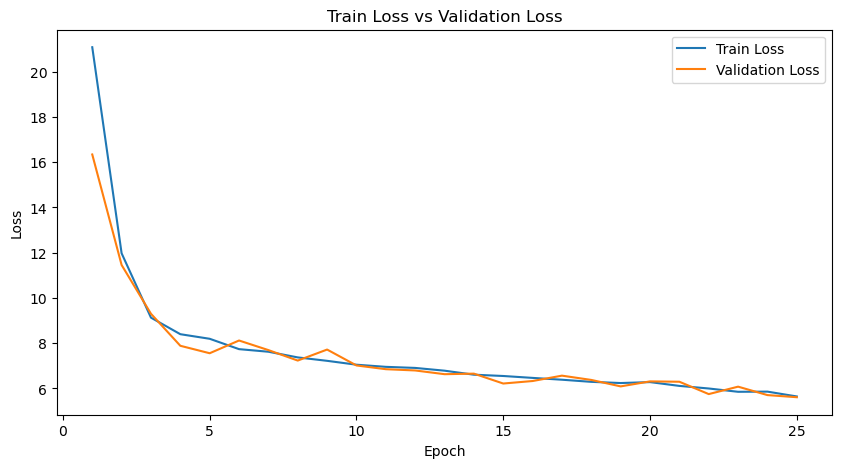

In [5]:
plot_losses(num_epochs, train_losses, val_losses)